In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
# Apply the function to the 'pitch_type' column
training_data = data.query('swing == 1')

# Apply the function to the 'pitch_type' column
testing_data_processed = testing_data

In [5]:
breaking_ball = training_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("CH")')


# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'line_drive', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo', 'swing'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'line_drive', 'contact', 'foul', 'fly_ball', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing'
], axis=1)   # Exclude the identifier from the features

In [7]:
train_data = training_features.drop(['whiff'], axis=1).copy()
train_label = training_features['whiff'].copy()
testing_data = testing_features.drop(['whiff'], axis=1).copy()
testing_label = testing_features['whiff'].copy()

In [8]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [10]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [11]:
y_train.value_counts()

whiff
0    19958
1     8437
Name: count, dtype: int64

In [12]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [13]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6709984152139461
Log Loss: 0.6392936068386669


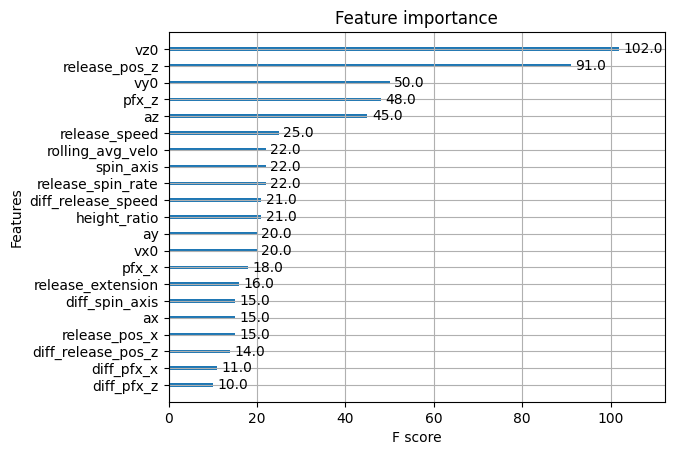

In [14]:
xgb.plot_importance(model)
plt.show()

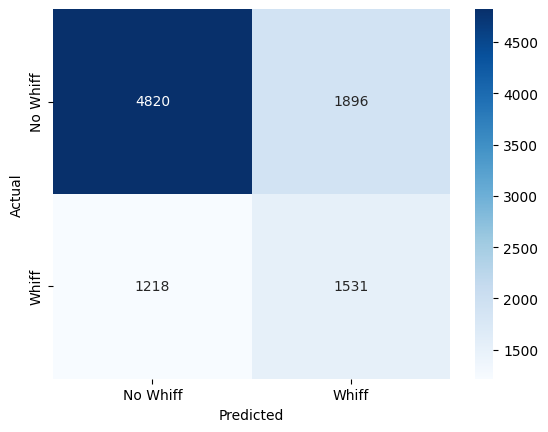

In [15]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Whiff', 'Whiff'], yticklabels=['No Whiff', 'Whiff'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [16]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu',
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [17]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-16 17:29:31,331] A new study created in memory with name: no-name-0d2db8fa-d3f2-4046-8a9d-eb5384d4e58d


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.66927
[2]	eval-logloss:0.66794
[3]	eval-logloss:0.66630
[4]	eval-logloss:0.66447
[5]	eval-logloss:0.65212
[6]	eval-logloss:0.64449
[7]	eval-logloss:0.63825
[8]	eval-logloss:0.63346
[9]	eval-logloss:0.63323


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.63291
[11]	eval-logloss:0.62909
[12]	eval-logloss:0.62634
[13]	eval-logloss:0.62414
[14]	eval-logloss:0.62389
[15]	eval-logloss:0.62393
[16]	eval-logloss:0.62115
[17]	eval-logloss:0.62070
[18]	eval-logloss:0.62033
[19]	eval-logloss:0.61911
[20]	eval-logloss:0.61859
[21]	eval-logloss:0.61825
[22]	eval-logloss:0.61816
[23]	eval-logloss:0.61707
[24]	eval-logloss:0.61670
[25]	eval-logloss:0.61617
[26]	eval-logloss:0.61560
[27]	eval-logloss:0.61538
[28]	eval-logloss:0.61560
[29]	eval-logloss:0.61517
[30]	eval-logloss:0.61482
[31]	eval-logloss:0.61454
[32]	eval-logloss:0.61443
[33]	eval-logloss:0.61328
[34]	eval-logloss:0.61323
[35]	eval-logloss:0.61346
[36]	eval-logloss:0.61336
[37]	eval-logloss:0.61343
[38]	eval-logloss:0.61283
[39]	eval-logloss:0.61207
[40]	eval-logloss:0.61164
[41]	eval-logloss:0.61102
[42]	eval-logloss:0.61003
[43]	eval-logloss:0.60976
[44]	eval-logloss:0.60957
[45]	eval-logloss:0.60912
[46]	eval-logloss:0.60892
[47]	eval-logloss:0.60845
[48]	eval-lo

[I 2023-11-16 17:29:32,239] Trial 0 finished with value: 0.6096255712676197 and parameters: {'max_depth': 6, 'eta': 0.20442672426930436, 'subsample': 0.6865940565658853, 'colsample_bytree': 0.862192717867228}. Best is trial 0 with value: 0.6096255712676197.


[0]	eval-logloss:0.69216
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68970
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68748
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68125
[7]	eval-logloss:0.67585
[8]	eval-logloss:0.67134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.67046
[10]	eval-logloss:0.66951
[11]	eval-logloss:0.66549
[12]	eval-logloss:0.66182
[13]	eval-logloss:0.65801
[14]	eval-logloss:0.65745
[15]	eval-logloss:0.65692
[16]	eval-logloss:0.65354
[17]	eval-logloss:0.65087
[18]	eval-logloss:0.65026
[19]	eval-logloss:0.64767
[20]	eval-logloss:0.64500
[21]	eval-logloss:0.64275
[22]	eval-logloss:0.64076
[23]	eval-logloss:0.63875
[24]	eval-logloss:0.63823
[25]	eval-logloss:0.63764
[26]	eval-logloss:0.63626
[27]	eval-logloss:0.63594
[28]	eval-logloss:0.63422
[29]	eval-logloss:0.63393
[30]	eval-logloss:0.63375
[31]	eval-logloss:0.63208
[32]	eval-logloss:0.63203
[33]	eval-logloss:0.63059
[34]	eval-logloss:0.62885
[35]	eval-logloss:0.62760
[36]	eval-logloss:0.62658
[37]	eval-logloss:0.62557
[38]	eval-logloss:0.62451
[39]	eval-logloss:0.62371
[40]	eval-logloss:0.62271
[41]	eval-logloss:0.62241
[42]	eval-logloss:0.62153
[43]	eval-logloss:0.62113
[44]	eval-logloss:0.62054
[45]	eval-logloss:0.62029
[46]	eval-logloss:0.62003
[47]	eval-log

[I 2023-11-16 17:29:33,311] Trial 1 finished with value: 0.6073539885179732 and parameters: {'max_depth': 7, 'eta': 0.05631761996523848, 'subsample': 0.7816747639475266, 'colsample_bytree': 0.6406717638441499}. Best is trial 1 with value: 0.6073539885179732.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.67665
[2]	eval-logloss:0.67481
[3]	eval-logloss:0.66464
[4]	eval-logloss:0.65632
[5]	eval-logloss:0.64983
[6]	eval-logloss:0.64542
[7]	eval-logloss:0.64145
[8]	eval-logloss:0.63785
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63717
[11]	eval-logloss:0.63425
[12]	eval-logloss:0.63201
[13]	eval-logloss:0.62965


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.62953
[15]	eval-logloss:0.62932
[16]	eval-logloss:0.62704
[17]	eval-logloss:0.62583
[18]	eval-logloss:0.62486
[19]	eval-logloss:0.62311
[20]	eval-logloss:0.62230
[21]	eval-logloss:0.62147
[22]	eval-logloss:0.62123
[23]	eval-logloss:0.62013
[24]	eval-logloss:0.61953
[25]	eval-logloss:0.61879
[26]	eval-logloss:0.61803
[27]	eval-logloss:0.61747
[28]	eval-logloss:0.61762
[29]	eval-logloss:0.61757
[30]	eval-logloss:0.61753
[31]	eval-logloss:0.61748
[32]	eval-logloss:0.61741
[33]	eval-logloss:0.61640
[34]	eval-logloss:0.61576
[35]	eval-logloss:0.61588
[36]	eval-logloss:0.61574
[37]	eval-logloss:0.61570
[38]	eval-logloss:0.61506
[39]	eval-logloss:0.61473
[40]	eval-logloss:0.61437
[41]	eval-logloss:0.61382
[42]	eval-logloss:0.61313
[43]	eval-logloss:0.61269
[44]	eval-logloss:0.61219
[45]	eval-logloss:0.61196
[46]	eval-logloss:0.61174
[47]	eval-logloss:0.61130
[48]	eval-logloss:0.61165
[49]	eval-logloss:0.61176
[50]	eval-logloss:0.61125
[51]	eval-logloss:0.61129
[52]	eval-lo

[I 2023-11-16 17:29:34,146] Trial 2 finished with value: 0.6059619199931403 and parameters: {'max_depth': 6, 'eta': 0.13538689970596696, 'subsample': 0.6940673519192907, 'colsample_bytree': 0.9540743572219776}. Best is trial 2 with value: 0.6059619199931403.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.67445
[2]	eval-logloss:0.67367
[3]	eval-logloss:0.67332
[4]	eval-logloss:0.67252
[5]	eval-logloss:0.66198
[6]	eval-logloss:0.65595
[7]	eval-logloss:0.65122
[8]	eval-logloss:0.64669
[9]	eval-logloss:0.64568
[10]	eval-logloss:0.64433
[11]	eval-logloss:0.64092
[12]	eval-logloss:0.63872
[13]	eval-logloss:0.63585
[14]	eval-logloss:0.63492
[15]	eval-logloss:0.63449
[16]	eval-logloss:0.63202
[17]	eval-logloss:0.63107
[18]	eval-logloss:0.63058
[19]	eval-logloss:0.62891
[20]	eval-logloss:0.62842
[21]	eval-logloss:0.62831
[22]	eval-logloss:0.62828


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[23]	eval-logloss:0.62686
[24]	eval-logloss:0.62585
[25]	eval-logloss:0.62499
[26]	eval-logloss:0.62492
[27]	eval-logloss:0.62490
[28]	eval-logloss:0.62498
[29]	eval-logloss:0.62432
[30]	eval-logloss:0.62481
[31]	eval-logloss:0.62458
[32]	eval-logloss:0.62451
[33]	eval-logloss:0.62401
[34]	eval-logloss:0.62377
[35]	eval-logloss:0.62377
[36]	eval-logloss:0.62364
[37]	eval-logloss:0.62287
[38]	eval-logloss:0.62245
[39]	eval-logloss:0.62246
[40]	eval-logloss:0.62193
[41]	eval-logloss:0.62153
[42]	eval-logloss:0.62123
[43]	eval-logloss:0.62076
[44]	eval-logloss:0.62086
[45]	eval-logloss:0.62038
[46]	eval-logloss:0.62039
[47]	eval-logloss:0.62006
[48]	eval-logloss:0.62076
[49]	eval-logloss:0.62099
[50]	eval-logloss:0.62020
[51]	eval-logloss:0.62074
[52]	eval-logloss:0.62071
[53]	eval-logloss:0.62034
[54]	eval-logloss:0.62046
[55]	eval-logloss:0.61997
[56]	eval-logloss:0.62036
[57]	eval-logloss:0.62066
[58]	eval-logloss:0.62030
[59]	eval-logloss:0.61968
[60]	eval-logloss:0.61999
[61]	eval-lo

[I 2023-11-16 17:29:34,709] Trial 3 finished with value: 0.6181413531157489 and parameters: {'max_depth': 3, 'eta': 0.2696173944498634, 'subsample': 0.7878713699120605, 'colsample_bytree': 0.8063920823255388}. Best is trial 2 with value: 0.6059619199931403.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66746
[3]	eval-logloss:0.65947
[4]	eval-logloss:0.65321
[5]	eval-logloss:0.64780
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.63948
[8]	eval-logloss:0.63648


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.63548
[10]	eval-logloss:0.63211
[11]	eval-logloss:0.62965
[12]	eval-logloss:0.62763
[13]	eval-logloss:0.62538
[14]	eval-logloss:0.62476
[15]	eval-logloss:0.62436
[16]	eval-logloss:0.62225
[17]	eval-logloss:0.62113
[18]	eval-logloss:0.61977
[19]	eval-logloss:0.61869
[20]	eval-logloss:0.61798
[21]	eval-logloss:0.61724
[22]	eval-logloss:0.61662
[23]	eval-logloss:0.61559
[24]	eval-logloss:0.61499
[25]	eval-logloss:0.61399
[26]	eval-logloss:0.61376
[27]	eval-logloss:0.61351
[28]	eval-logloss:0.61344
[29]	eval-logloss:0.61263
[30]	eval-logloss:0.61259
[31]	eval-logloss:0.61226
[32]	eval-logloss:0.61200
[33]	eval-logloss:0.61168
[34]	eval-logloss:0.61124
[35]	eval-logloss:0.61115
[36]	eval-logloss:0.61100
[37]	eval-logloss:0.61055
[38]	eval-logloss:0.61011
[39]	eval-logloss:0.61014
[40]	eval-logloss:0.60986
[41]	eval-logloss:0.60902
[42]	eval-logloss:0.60862
[43]	eval-logloss:0.60790
[44]	eval-logloss:0.60789
[45]	eval-logloss:0.60774
[46]	eval-logloss:0.60759
[47]	eval-log

[I 2023-11-16 17:29:35,713] Trial 4 finished with value: 0.6002843102734712 and parameters: {'max_depth': 7, 'eta': 0.11664683305695564, 'subsample': 0.8161002586917718, 'colsample_bytree': 0.9643966089410851}. Best is trial 4 with value: 0.6002843102734712.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68428
[2]	eval-logloss:0.68341


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68293
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67534
[6]	eval-logloss:0.67083
[7]	eval-logloss:0.66633
[8]	eval-logloss:0.66184
[9]	eval-logloss:0.66074
[10]	eval-logloss:0.65963
[11]	eval-logloss:0.65551
[12]	eval-logloss:0.65222
[13]	eval-logloss:0.64898
[14]	eval-logloss:0.64825
[15]	eval-logloss:0.64778
[16]	eval-logloss:0.64439
[17]	eval-logloss:0.64201
[18]	eval-logloss:0.64126
[19]	eval-logloss:0.63848
[20]	eval-logloss:0.63619
[21]	eval-logloss:0.63399
[22]	eval-logloss:0.63209
[23]	eval-logloss:0.63012
[24]	eval-logloss:0.62825
[25]	eval-logloss:0.62775
[26]	eval-logloss:0.62590
[27]	eval-logloss:0.62432
[28]	eval-logloss:0.62298
[29]	eval-logloss:0.62261
[30]	eval-logloss:0.62128
[31]	eval-logloss:0.61994
[32]	eval-logloss:0.61954
[33]	eval-logloss:0.61828
[34]	eval-logloss:0.61704
[35]	eval-logloss:0.61635
[36]	eval-logloss:0.61566
[37]	eval-logloss:0.61464
[38]	eval-logloss:0.61363
[39]	eval-logloss:0.61272
[40]	eval-logloss:0.61182
[41]	eval-logloss:0

[I 2023-11-16 17:29:37,444] Trial 5 finished with value: 0.5949238474609804 and parameters: {'max_depth': 9, 'eta': 0.05045992995428858, 'subsample': 0.6797846658766766, 'colsample_bytree': 0.7371030426743728}. Best is trial 5 with value: 0.5949238474609804.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.68080
[3]	eval-logloss:0.68094
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67146
[6]	eval-logloss:0.66535
[7]	eval-logloss:0.66082
[8]	eval-logloss:0.65617
[9]	eval-logloss:0.65532
[10]	eval-logloss:0.65485
[11]	eval-logloss:0.65149
[12]	eval-logloss:0.64859
[13]	eval-logloss:0.64526
[14]	eval-logloss:0.64487
[15]	eval-logloss:0.64444
[16]	eval-logloss:0.64199
[17]	eval-logloss:0.63995
[18]	eval-logloss:0.63895
[19]	eval-logloss:0.63664
[20]	eval-logloss:0.63553
[21]	eval-logloss:0.63441
[22]	eval-logloss:0.63406
[23]	eval-logloss:0.63269
[24]	eval-logloss:0.63248
[25]	eval-logloss:0.63180
[26]	eval-logloss:0.63111
[27]	eval-logloss:0.63113
[28]	eval-logloss:0.63064
[29]	eval-logloss:0.63044
[30]	eval-logloss:0.63011
[31]	eval-logloss:0.62966
[32]	eval-logloss:0.62999
[33]	eval-logloss:0.62879
[34]	eval-logloss:0.62850
[35]	eval-logloss:0.62813
[36]	eval-logloss:0.62831
[37]	eval-logloss:0.62779
[38]	eval-logloss:0.62

[I 2023-11-16 17:29:38,123] Trial 6 finished with value: 0.6182294015987685 and parameters: {'max_depth': 3, 'eta': 0.16467044752890506, 'subsample': 0.6307634503777904, 'colsample_bytree': 0.693891691740405}. Best is trial 5 with value: 0.5949238474609804.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.67838
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67261
[6]	eval-logloss:0.66876
[7]	eval-logloss:0.66487
[8]	eval-logloss:0.66137
[9]	eval-logloss:0.66070
[10]	eval-logloss:0.65983
[11]	eval-logloss:0.65658
[12]	eval-logloss:0.65380
[13]	eval-logloss:0.65120


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.65057
[15]	eval-logloss:0.65023
[16]	eval-logloss:0.64770
[17]	eval-logloss:0.64533
[18]	eval-logloss:0.64483
[19]	eval-logloss:0.64265
[20]	eval-logloss:0.64048
[21]	eval-logloss:0.63877
[22]	eval-logloss:0.63721
[23]	eval-logloss:0.63570
[24]	eval-logloss:0.63422
[25]	eval-logloss:0.63268
[26]	eval-logloss:0.63141
[27]	eval-logloss:0.63016
[28]	eval-logloss:0.62919
[29]	eval-logloss:0.62880
[30]	eval-logloss:0.62790
[31]	eval-logloss:0.62706
[32]	eval-logloss:0.62641
[33]	eval-logloss:0.62583
[34]	eval-logloss:0.62491
[35]	eval-logloss:0.62434
[36]	eval-logloss:0.62413
[37]	eval-logloss:0.62358
[38]	eval-logloss:0.62291
[39]	eval-logloss:0.62275
[40]	eval-logloss:0.62219
[41]	eval-logloss:0.62198
[42]	eval-logloss:0.62148
[43]	eval-logloss:0.62109
[44]	eval-logloss:0.62064
[45]	eval-logloss:0.62013
[46]	eval-logloss:0.61978
[47]	eval-logloss:0.61935
[48]	eval-logloss:0.61923
[49]	eval-logloss:0.61916
[50]	eval-logloss:0.61865
[51]	eval-logloss:0.61848
[52]	eval-lo

[I 2023-11-16 17:29:38,970] Trial 7 finished with value: 0.6105818516940409 and parameters: {'max_depth': 6, 'eta': 0.05891386862076485, 'subsample': 0.7292307965496817, 'colsample_bytree': 0.8674903416971835}. Best is trial 5 with value: 0.5949238474609804.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68748
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68535
[5]	eval-logloss:0.68382
[6]	eval-logloss:0.67161
[7]	eval-logloss:0.66163
[8]	eval-logloss:0.66057
[9]	eval-logloss:0.65992
[10]	eval-logloss:0.65929
[11]	eval-logloss:0.65150
[12]	eval-logloss:0.64593
[13]	eval-logloss:0.64021
[14]	eval-logloss:0.64018
[15]	eval-logloss:0.64013
[16]	eval-logloss:0.63484
[17]	eval-logloss:0.63188
[18]	eval-logloss:0.63106


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[19]	eval-logloss:0.63051
[20]	eval-logloss:0.62793
[21]	eval-logloss:0.62642
[22]	eval-logloss:0.62544
[23]	eval-logloss:0.62390
[24]	eval-logloss:0.62405
[25]	eval-logloss:0.62364
[26]	eval-logloss:0.62235
[27]	eval-logloss:0.62260
[28]	eval-logloss:0.62175
[29]	eval-logloss:0.62154
[30]	eval-logloss:0.62199
[31]	eval-logloss:0.62105
[32]	eval-logloss:0.62140
[33]	eval-logloss:0.62063
[34]	eval-logloss:0.62053
[35]	eval-logloss:0.61993
[36]	eval-logloss:0.62054
[37]	eval-logloss:0.61995
[38]	eval-logloss:0.61903
[39]	eval-logloss:0.61799
[40]	eval-logloss:0.61775
[41]	eval-logloss:0.61749
[42]	eval-logloss:0.61699
[43]	eval-logloss:0.61672
[44]	eval-logloss:0.61656
[45]	eval-logloss:0.61629
[46]	eval-logloss:0.61625
[47]	eval-logloss:0.61599
[48]	eval-logloss:0.61640
[49]	eval-logloss:0.61626
[50]	eval-logloss:0.61543
[51]	eval-logloss:0.61587
[52]	eval-logloss:0.61588
[53]	eval-logloss:0.61522
[54]	eval-logloss:0.61513
[55]	eval-logloss:0.61442
[56]	eval-logloss:0.61429
[57]	eval-lo

[I 2023-11-16 17:29:39,651] Trial 8 finished with value: 0.6087519417182108 and parameters: {'max_depth': 5, 'eta': 0.17058440807142972, 'subsample': 0.6179444889332654, 'colsample_bytree': 0.5619574519575019}. Best is trial 5 with value: 0.5949238474609804.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68420
[5]	eval-logloss:0.68273


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.67486
[7]	eval-logloss:0.66724
[8]	eval-logloss:0.66069
[9]	eval-logloss:0.65995
[10]	eval-logloss:0.65892
[11]	eval-logloss:0.65400
[12]	eval-logloss:0.64942
[13]	eval-logloss:0.64454
[14]	eval-logloss:0.64425
[15]	eval-logloss:0.64368
[16]	eval-logloss:0.63953
[17]	eval-logloss:0.63676
[18]	eval-logloss:0.63617
[19]	eval-logloss:0.63375
[20]	eval-logloss:0.63111
[21]	eval-logloss:0.62899
[22]	eval-logloss:0.62745
[23]	eval-logloss:0.62544
[24]	eval-logloss:0.62534
[25]	eval-logloss:0.62464
[26]	eval-logloss:0.62362
[27]	eval-logloss:0.62343
[28]	eval-logloss:0.62194
[29]	eval-logloss:0.62169
[30]	eval-logloss:0.62151
[31]	eval-logloss:0.62049
[32]	eval-logloss:0.62043
[33]	eval-logloss:0.61953
[34]	eval-logloss:0.61935
[35]	eval-logloss:0.61836
[36]	eval-logloss:0.61772
[37]	eval-logloss:0.61690
[38]	eval-logloss:0.61599
[39]	eval-logloss:0.61552
[40]	eval-logloss:0.61504
[41]	eval-logloss:0.61433
[42]	eval-logloss:0.61371
[43]	eval-logloss:0.61347
[44]	eval-loglos

[I 2023-11-16 17:29:40,726] Trial 9 finished with value: 0.6054024125338728 and parameters: {'max_depth': 7, 'eta': 0.0930329099315341, 'subsample': 0.7156999387251253, 'colsample_bytree': 0.6101716106220503}. Best is trial 5 with value: 0.5949238474609804.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.68985


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68902
[4]	eval-logloss:0.68816
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68379
[7]	eval-logloss:0.68148
[8]	eval-logloss:0.67927
[9]	eval-logloss:0.67874
[10]	eval-logloss:0.67802
[11]	eval-logloss:0.67592
[12]	eval-logloss:0.67399
[13]	eval-logloss:0.67205
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67109
[16]	eval-logloss:0.66917
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66711
[19]	eval-logloss:0.66539
[20]	eval-logloss:0.66363
[21]	eval-logloss:0.66212
[22]	eval-logloss:0.66061
[23]	eval-logloss:0.65902
[24]	eval-logloss:0.65750
[25]	eval-logloss:0.65704
[26]	eval-logloss:0.65552
[27]	eval-logloss:0.65409
[28]	eval-logloss:0.65266
[29]	eval-logloss:0.65225
[30]	eval-logloss:0.65099
[31]	eval-logloss:0.64975
[32]	eval-logloss:0.64927
[33]	eval-logloss:0.64806
[34]	eval-logloss:0.64674
[35]	eval-logloss:0.64555
[36]	eval-logloss:0.64445
[37]	eval-logloss:0.64330
[38]	eval-logloss:0.64228
[39]	eval-logloss:0.64134
[40]	eval-logloss:0.

[I 2023-11-16 17:29:42,597] Trial 10 finished with value: 0.6125985173496303 and parameters: {'max_depth': 9, 'eta': 0.01950940079677165, 'subsample': 0.8805175777381881, 'colsample_bytree': 0.7277657996062067}. Best is trial 5 with value: 0.5949238474609804.


[0]	eval-logloss:0.68002
[1]	eval-logloss:0.66895
[2]	eval-logloss:0.66526


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65648
[4]	eval-logloss:0.64925
[5]	eval-logloss:0.64296
[6]	eval-logloss:0.63820
[7]	eval-logloss:0.63356
[8]	eval-logloss:0.62985
[9]	eval-logloss:0.62860
[10]	eval-logloss:0.62537
[11]	eval-logloss:0.62270
[12]	eval-logloss:0.62024
[13]	eval-logloss:0.61771
[14]	eval-logloss:0.61724
[15]	eval-logloss:0.61677
[16]	eval-logloss:0.61445
[17]	eval-logloss:0.61292
[18]	eval-logloss:0.61176
[19]	eval-logloss:0.61052
[20]	eval-logloss:0.60915
[21]	eval-logloss:0.60816
[22]	eval-logloss:0.60782
[23]	eval-logloss:0.60645
[24]	eval-logloss:0.60606
[25]	eval-logloss:0.60523
[26]	eval-logloss:0.60452
[27]	eval-logloss:0.60415
[28]	eval-logloss:0.60376
[29]	eval-logloss:0.60330
[30]	eval-logloss:0.60324
[31]	eval-logloss:0.60328
[32]	eval-logloss:0.60293
[33]	eval-logloss:0.60291
[34]	eval-logloss:0.60228
[35]	eval-logloss:0.60244
[36]	eval-logloss:0.60233
[37]	eval-logloss:0.60176
[38]	eval-logloss:0.60128
[39]	eval-logloss:0.60120
[40]	eval-logloss:0.60085
[41]	eval-logloss:0

[I 2023-11-16 17:29:44,352] Trial 11 finished with value: 0.5916718362127368 and parameters: {'max_depth': 9, 'eta': 0.10848873857099951, 'subsample': 0.823842822249755, 'colsample_bytree': 0.9882071082431442}. Best is trial 11 with value: 0.5916718362127368.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69155
[4]	eval-logloss:0.69099
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.68907
[7]	eval-logloss:0.68773
[8]	eval-logloss:0.68740
[9]	eval-logloss:0.68714
[10]	eval-logloss:0.68672
[11]	eval-logloss:0.68524
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68219
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68151
[16]	eval-logloss:0.68003
[17]	eval-logloss:0.67877
[18]	eval-logloss:0.67846
[19]	eval-logloss:0.67809
[20]	eval-logloss:0.67785
[21]	eval-logloss:0.67663
[22]	eval-logloss:0.67541
[23]	eval-logloss:0.67425
[24]	eval-logloss:0.67383
[25]	eval-logloss:0.67364
[26]	eval-logloss:0.67253
[27]	eval-logloss:0.67223
[28]	eval-logloss:0.67108
[29]	eval-logloss:0.67063
[30]	eval-logloss:0.67034
[31]	eval-logloss:0.66922
[32]	eval-logloss:0.66891
[33]	eval-logloss:0.66770
[34]	eval-logloss:0.66733
[35]	eval-logloss:0.66629
[36]	eval-logloss:0.66523
[37]	eval-logloss:0.66412
[38]	eval-logloss:0.66301
[39]	eval-logloss:0.66210
[40]	eval-logloss:0.

[I 2023-11-16 17:29:46,105] Trial 12 finished with value: 0.6346970210038402 and parameters: {'max_depth': 9, 'eta': 0.012883907629788222, 'subsample': 0.8559930642470491, 'colsample_bytree': 0.5004725519195903}. Best is trial 11 with value: 0.5916718362127368.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.67068
[3]	eval-logloss:0.66258
[4]	eval-logloss:0.65569
[5]	eval-logloss:0.64988
[6]	eval-logloss:0.64521
[7]	eval-logloss:0.64088
[8]	eval-logloss:0.63689
[9]	eval-logloss:0.63597
[10]	eval-logloss:0.63236
[11]	eval-logloss:0.62957
[12]	eval-logloss:0.62700
[13]	eval-logloss:0.62420
[14]	eval-logloss:0.62355
[15]	eval-logloss:0.62281
[16]	eval-logloss:0.62104
[17]	eval-logloss:0.61928
[18]	eval-logloss:0.61740
[19]	eval-logloss:0.61584
[20]	eval-logloss:0.61437
[21]	eval-logloss:0.61317
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.61082
[24]	eval-logloss:0.61002
[25]	eval-logloss:0.60906
[26]	eval-logloss:0.60863
[27]	eval-logloss:0.60831
[28]	eval-logloss:0.60815
[29]	eval-logloss:0.60719
[30]	eval-logloss:0.60648
[31]	eval-logloss:0.60619
[32]	eval-logloss:0.60564
[33]	eval-logloss:0.60495
[34]	eval-logloss:0.60438
[35]	eval-logloss:0.60429
[36]	eval-logloss:0.60373
[37]	eval-logloss:0.60329
[38]	eval-logloss:0.60

[I 2023-11-16 17:29:47,941] Trial 13 finished with value: 0.5897435444887178 and parameters: {'max_depth': 9, 'eta': 0.08697808136442206, 'subsample': 0.7620048096739281, 'colsample_bytree': 0.998304521721364}. Best is trial 13 with value: 0.5897435444887178.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67310
[2]	eval-logloss:0.67066
[3]	eval-logloss:0.66302


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65634
[5]	eval-logloss:0.65085
[6]	eval-logloss:0.64634
[7]	eval-logloss:0.64235
[8]	eval-logloss:0.63876
[9]	eval-logloss:0.63764
[10]	eval-logloss:0.63414
[11]	eval-logloss:0.63138
[12]	eval-logloss:0.62966
[13]	eval-logloss:0.62726
[14]	eval-logloss:0.62634
[15]	eval-logloss:0.62607
[16]	eval-logloss:0.62406
[17]	eval-logloss:0.62240
[18]	eval-logloss:0.62047
[19]	eval-logloss:0.61875
[20]	eval-logloss:0.61738
[21]	eval-logloss:0.61636
[22]	eval-logloss:0.61543
[23]	eval-logloss:0.61457
[24]	eval-logloss:0.61357
[25]	eval-logloss:0.61272
[26]	eval-logloss:0.61196
[27]	eval-logloss:0.61144
[28]	eval-logloss:0.61102
[29]	eval-logloss:0.61043
[30]	eval-logloss:0.61031
[31]	eval-logloss:0.60976
[32]	eval-logloss:0.60920
[33]	eval-logloss:0.60864
[34]	eval-logloss:0.60809
[35]	eval-logloss:0.60785
[36]	eval-logloss:0.60753
[37]	eval-logloss:0.60757
[38]	eval-logloss:0.60700
[39]	eval-logloss:0.60682
[40]	eval-logloss:0.60642
[41]	eval-logloss:0.60586
[42]	eval-logloss:

[I 2023-11-16 17:29:49,249] Trial 14 finished with value: 0.5955108326971738 and parameters: {'max_depth': 8, 'eta': 0.09143432330200581, 'subsample': 0.7610811435500302, 'colsample_bytree': 0.9894829030446839}. Best is trial 13 with value: 0.5897435444887178.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.67814
[2]	eval-logloss:0.67457
[3]	eval-logloss:0.66530
[4]	eval-logloss:0.66254
[5]	eval-logloss:0.65425
[6]	eval-logloss:0.64877
[7]	eval-logloss:0.64357
[8]	eval-logloss:0.63922
[9]	eval-logloss:0.63845
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63371
[12]	eval-logloss:0.63079
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62708
[15]	eval-logloss:0.62629
[16]	eval-logloss:0.62354
[17]	eval-logloss:0.62115
[18]	eval-logloss:0.62039
[19]	eval-logloss:0.61879
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61582
[22]	eval-logloss:0.61455
[23]	eval-logloss:0.61299
[24]	eval-logloss:0.61201
[25]	eval-logloss:0.61082
[26]	eval-logloss:0.61031
[27]	eval-logloss:0.60940
[28]	eval-logloss:0.60923
[29]	eval-logloss:0.60924
[30]	eval-logloss:0.60905
[31]	eval-logloss:0.60867
[32]	eval-logloss:0.60817
[33]	eval-logloss:0.60762
[34]	eval-logloss:0.60729
[35]	eval-logloss:0.60688
[36]	eval-logloss:0.60663
[37]	eval-logloss:0.60625
[38]	eval-logloss:0.60

[I 2023-11-16 17:29:50,779] Trial 15 finished with value: 0.591361005306429 and parameters: {'max_depth': 8, 'eta': 0.10557806418805914, 'subsample': 0.8285609272515347, 'colsample_bytree': 0.907332047599996}. Best is trial 13 with value: 0.5897435444887178.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.67461
[2]	eval-logloss:0.67102
[3]	eval-logloss:0.65971
[4]	eval-logloss:0.65047


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.64357
[6]	eval-logloss:0.63782
[7]	eval-logloss:0.63290
[8]	eval-logloss:0.62933
[9]	eval-logloss:0.62808
[10]	eval-logloss:0.62688
[11]	eval-logloss:0.62382
[12]	eval-logloss:0.62202
[13]	eval-logloss:0.61966
[14]	eval-logloss:0.61924
[15]	eval-logloss:0.61852
[16]	eval-logloss:0.61684
[17]	eval-logloss:0.61551
[18]	eval-logloss:0.61455
[19]	eval-logloss:0.61305
[20]	eval-logloss:0.61208
[21]	eval-logloss:0.61182
[22]	eval-logloss:0.61070
[23]	eval-logloss:0.60964
[24]	eval-logloss:0.60896
[25]	eval-logloss:0.60828
[26]	eval-logloss:0.60809
[27]	eval-logloss:0.60741
[28]	eval-logloss:0.60710
[29]	eval-logloss:0.60628
[30]	eval-logloss:0.60587
[31]	eval-logloss:0.60567
[32]	eval-logloss:0.60521
[33]	eval-logloss:0.60491
[34]	eval-logloss:0.60475
[35]	eval-logloss:0.60473
[36]	eval-logloss:0.60441
[37]	eval-logloss:0.60426
[38]	eval-logloss:0.60390
[39]	eval-logloss:0.60346
[40]	eval-logloss:0.60331
[41]	eval-logloss:0.60298
[42]	eval-logloss:0.60248
[43]	eval-logloss

[I 2023-11-16 17:29:52,126] Trial 16 finished with value: 0.5936881982168105 and parameters: {'max_depth': 8, 'eta': 0.14033483373805342, 'subsample': 0.8975960930999309, 'colsample_bytree': 0.9138788027030134}. Best is trial 13 with value: 0.5897435444887178.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.66835
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.65147
[4]	eval-logloss:0.65023
[5]	eval-logloss:0.64078
[6]	eval-logloss:0.63496
[7]	eval-logloss:0.63088
[8]	eval-logloss:0.62648
[9]	eval-logloss:0.62590
[10]	eval-logloss:0.62487
[11]	eval-logloss:0.62235
[12]	eval-logloss:0.62015
[13]	eval-logloss:0.61847
[14]	eval-logloss:0.61829
[15]	eval-logloss:0.61824
[16]	eval-logloss:0.61591
[17]	eval-logloss:0.61449
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61304
[20]	eval-logloss:0.61213
[21]	eval-logloss:0.61246
[22]	eval-logloss:0.61271
[23]	eval-logloss:0.61218
[24]	eval-logloss:0.61159
[25]	eval-logloss:0.61002
[26]	eval-logloss:0.61032
[27]	eval-logloss:0.60982
[28]	eval-logloss:0.60964
[29]	eval-logloss:0.60919
[30]	eval-logloss:0.60934
[31]	eval-logloss:0.60904
[32]	eval-logloss:0.60814
[33]	eval-logloss:0.60772
[34]	eval-logloss:0.60716
[35]	eval-logloss:0.60694
[36]	eval-logloss:0.60662
[37]	eval-logloss:0.60657
[38]	eval-logloss:0.60

[I 2023-11-16 17:29:53,467] Trial 17 finished with value: 0.6069647845122152 and parameters: {'max_depth': 8, 'eta': 0.192878909519197, 'subsample': 0.834220827609631, 'colsample_bytree': 0.9058107652873713}. Best is trial 13 with value: 0.5897435444887178.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68475
[5]	eval-logloss:0.67940
[6]	eval-logloss:0.67514
[7]	eval-logloss:0.67111
[8]	eval-logloss:0.66757
[9]	eval-logloss:0.66714
[10]	eval-logloss:0.66643
[11]	eval-logloss:0.66321
[12]	eval-logloss:0.66040
[13]	eval-logloss:0.65752
[14]	eval-logloss:0.65719


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[15]	eval-logloss:0.65692
[16]	eval-logloss:0.65423
[17]	eval-logloss:0.65223
[18]	eval-logloss:0.65176
[19]	eval-logloss:0.64961
[20]	eval-logloss:0.64767
[21]	eval-logloss:0.64592
[22]	eval-logloss:0.64465
[23]	eval-logloss:0.64310
[24]	eval-logloss:0.64158
[25]	eval-logloss:0.64120
[26]	eval-logloss:0.63988
[27]	eval-logloss:0.63874
[28]	eval-logloss:0.63788
[29]	eval-logloss:0.63747
[30]	eval-logloss:0.63672
[31]	eval-logloss:0.63585
[32]	eval-logloss:0.63511
[33]	eval-logloss:0.63440
[34]	eval-logloss:0.63360
[35]	eval-logloss:0.63291
[36]	eval-logloss:0.63250
[37]	eval-logloss:0.63178
[38]	eval-logloss:0.63098
[39]	eval-logloss:0.63067
[40]	eval-logloss:0.63004
[41]	eval-logloss:0.62968
[42]	eval-logloss:0.62903
[43]	eval-logloss:0.62871
[44]	eval-logloss:0.62830
[45]	eval-logloss:0.62796
[46]	eval-logloss:0.62749
[47]	eval-logloss:0.62686
[48]	eval-logloss:0.62646
[49]	eval-logloss:0.62633
[50]	eval-logloss:0.62581
[51]	eval-logloss:0.62580
[52]	eval-logloss:0.62555
[53]	eval-lo

[I 2023-11-16 17:29:54,151] Trial 18 finished with value: 0.6181371916463977 and parameters: {'max_depth': 4, 'eta': 0.07186330204014264, 'subsample': 0.7954045841918118, 'colsample_bytree': 0.8127872498624007}. Best is trial 13 with value: 0.5897435444887178.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.67657
[2]	eval-logloss:0.67236
[3]	eval-logloss:0.66222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65362
[5]	eval-logloss:0.64711
[6]	eval-logloss:0.64239
[7]	eval-logloss:0.63810
[8]	eval-logloss:0.63441
[9]	eval-logloss:0.63348
[10]	eval-logloss:0.63281
[11]	eval-logloss:0.63016
[12]	eval-logloss:0.62806
[13]	eval-logloss:0.62543
[14]	eval-logloss:0.62502
[15]	eval-logloss:0.62469
[16]	eval-logloss:0.62191
[17]	eval-logloss:0.62061
[18]	eval-logloss:0.61950
[19]	eval-logloss:0.61767
[20]	eval-logloss:0.61657
[21]	eval-logloss:0.61578
[22]	eval-logloss:0.61497
[23]	eval-logloss:0.61351
[24]	eval-logloss:0.61286
[25]	eval-logloss:0.61181
[26]	eval-logloss:0.61103
[27]	eval-logloss:0.61049
[28]	eval-logloss:0.61023
[29]	eval-logloss:0.60977
[30]	eval-logloss:0.60934
[31]	eval-logloss:0.60884
[32]	eval-logloss:0.60864
[33]	eval-logloss:0.60877
[34]	eval-logloss:0.60839
[35]	eval-logloss:0.60802
[36]	eval-logloss:0.60795
[37]	eval-logloss:0.60765
[38]	eval-logloss:0.60743
[39]	eval-logloss:0.60696
[40]	eval-logloss:0.60686
[41]	eval-logloss:0.60637
[42]	eval-logloss:

[I 2023-11-16 17:29:55,568] Trial 19 finished with value: 0.5984617794130226 and parameters: {'max_depth': 8, 'eta': 0.1195451103813828, 'subsample': 0.7692543408529091, 'colsample_bytree': 0.9224378062985612}. Best is trial 13 with value: 0.5897435444887178.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67477
[2]	eval-logloss:0.67277
[3]	eval-logloss:0.66540


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65904
[5]	eval-logloss:0.65384
[6]	eval-logloss:0.64960
[7]	eval-logloss:0.64536
[8]	eval-logloss:0.64180
[9]	eval-logloss:0.64088
[10]	eval-logloss:0.63746
[11]	eval-logloss:0.63438
[12]	eval-logloss:0.63183
[13]	eval-logloss:0.62964
[14]	eval-logloss:0.62899
[15]	eval-logloss:0.62859
[16]	eval-logloss:0.62645
[17]	eval-logloss:0.62459
[18]	eval-logloss:0.62298
[19]	eval-logloss:0.62143
[20]	eval-logloss:0.62007
[21]	eval-logloss:0.61884
[22]	eval-logloss:0.61802
[23]	eval-logloss:0.61642
[24]	eval-logloss:0.61530
[25]	eval-logloss:0.61436
[26]	eval-logloss:0.61376
[27]	eval-logloss:0.61270
[28]	eval-logloss:0.61218
[29]	eval-logloss:0.61202
[30]	eval-logloss:0.61148
[31]	eval-logloss:0.61096
[32]	eval-logloss:0.61024
[33]	eval-logloss:0.60956
[34]	eval-logloss:0.60903
[35]	eval-logloss:0.60865
[36]	eval-logloss:0.60853
[37]	eval-logloss:0.60830
[38]	eval-logloss:0.60812
[39]	eval-logloss:0.60756
[40]	eval-logloss:0.60708
[41]	eval-logloss:0.60628
[42]	eval-logloss:

[I 2023-11-16 17:29:56,901] Trial 20 finished with value: 0.596964311866285 and parameters: {'max_depth': 8, 'eta': 0.08339290607391646, 'subsample': 0.8502408248442793, 'colsample_bytree': 0.9891342002982761}. Best is trial 13 with value: 0.5897435444887178.


[0]	eval-logloss:0.67952


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66839
[2]	eval-logloss:0.66427
[3]	eval-logloss:0.65540
[4]	eval-logloss:0.64799
[5]	eval-logloss:0.64194
[6]	eval-logloss:0.63748
[7]	eval-logloss:0.63281
[8]	eval-logloss:0.62920
[9]	eval-logloss:0.62800
[10]	eval-logloss:0.62490
[11]	eval-logloss:0.62222
[12]	eval-logloss:0.62007
[13]	eval-logloss:0.61734
[14]	eval-logloss:0.61704
[15]	eval-logloss:0.61632
[16]	eval-logloss:0.61384
[17]	eval-logloss:0.61243
[18]	eval-logloss:0.61106
[19]	eval-logloss:0.60976
[20]	eval-logloss:0.60886
[21]	eval-logloss:0.60822
[22]	eval-logloss:0.60763
[23]	eval-logloss:0.60660
[24]	eval-logloss:0.60637
[25]	eval-logloss:0.60551
[26]	eval-logloss:0.60493
[27]	eval-logloss:0.60418
[28]	eval-logloss:0.60331
[29]	eval-logloss:0.60248
[30]	eval-logloss:0.60213
[31]	eval-logloss:0.60170
[32]	eval-logloss:0.60157
[33]	eval-logloss:0.60098
[34]	eval-logloss:0.60054
[35]	eval-logloss:0.60020
[36]	eval-logloss:0.60005
[37]	eval-logloss:0.59977
[38]	eval-logloss:0.59929
[39]	eval-logloss:0.5

[I 2023-11-16 17:29:58,695] Trial 21 finished with value: 0.5877304007243563 and parameters: {'max_depth': 9, 'eta': 0.11042447372546957, 'subsample': 0.8184872627649347, 'colsample_bytree': 0.9993484126090877}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.67733
[2]	eval-logloss:0.67280


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66318
[4]	eval-logloss:0.65505
[5]	eval-logloss:0.64723
[6]	eval-logloss:0.64185
[7]	eval-logloss:0.63654
[8]	eval-logloss:0.63231
[9]	eval-logloss:0.63121
[10]	eval-logloss:0.63018
[11]	eval-logloss:0.62666
[12]	eval-logloss:0.62412
[13]	eval-logloss:0.62143
[14]	eval-logloss:0.62017
[15]	eval-logloss:0.61979
[16]	eval-logloss:0.61702
[17]	eval-logloss:0.61440
[18]	eval-logloss:0.61395
[19]	eval-logloss:0.61245
[20]	eval-logloss:0.61112
[21]	eval-logloss:0.60968
[22]	eval-logloss:0.60916
[23]	eval-logloss:0.60814
[24]	eval-logloss:0.60748
[25]	eval-logloss:0.60655
[26]	eval-logloss:0.60616
[27]	eval-logloss:0.60547
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60447
[30]	eval-logloss:0.60398
[31]	eval-logloss:0.60339
[32]	eval-logloss:0.60281
[33]	eval-logloss:0.60228
[34]	eval-logloss:0.60217
[35]	eval-logloss:0.60181
[36]	eval-logloss:0.60170
[37]	eval-logloss:0.60121
[38]	eval-logloss:0.60054
[39]	eval-logloss:0.60077
[40]	eval-logloss:0.60050
[41]	eval-logloss:0

[I 2023-11-16 17:30:00,373] Trial 22 finished with value: 0.5902427780130717 and parameters: {'max_depth': 9, 'eta': 0.10792071631411729, 'subsample': 0.8074923760773205, 'colsample_bytree': 0.9533977684608022}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.67610
[1]	eval-logloss:0.66245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65905
[3]	eval-logloss:0.64877
[4]	eval-logloss:0.64011
[5]	eval-logloss:0.63390
[6]	eval-logloss:0.62925
[7]	eval-logloss:0.62560
[8]	eval-logloss:0.62264
[9]	eval-logloss:0.62146
[10]	eval-logloss:0.61875
[11]	eval-logloss:0.61639
[12]	eval-logloss:0.61432
[13]	eval-logloss:0.61295
[14]	eval-logloss:0.61321
[15]	eval-logloss:0.61281
[16]	eval-logloss:0.61106
[17]	eval-logloss:0.60982
[18]	eval-logloss:0.60834
[19]	eval-logloss:0.60736
[20]	eval-logloss:0.60759
[21]	eval-logloss:0.60773
[22]	eval-logloss:0.60734
[23]	eval-logloss:0.60673
[24]	eval-logloss:0.60666
[25]	eval-logloss:0.60620
[26]	eval-logloss:0.60527
[27]	eval-logloss:0.60504
[28]	eval-logloss:0.60505
[29]	eval-logloss:0.60463
[30]	eval-logloss:0.60485
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60386
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60246
[35]	eval-logloss:0.60256
[36]	eval-logloss:0.60200
[37]	eval-logloss:0.60140
[38]	eval-logloss:0.60100
[39]	eval-logloss:0.60081
[40]	eval-logloss:0.

[I 2023-11-16 17:30:02,152] Trial 23 finished with value: 0.5949105191431557 and parameters: {'max_depth': 9, 'eta': 0.14839469853837564, 'subsample': 0.7491216381117589, 'colsample_bytree': 0.9943370801379042}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69065


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68134
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67014
[4]	eval-logloss:0.66314
[5]	eval-logloss:0.65674
[6]	eval-logloss:0.65188
[7]	eval-logloss:0.64704
[8]	eval-logloss:0.64293
[9]	eval-logloss:0.64164
[10]	eval-logloss:0.64017
[11]	eval-logloss:0.63684
[12]	eval-logloss:0.63361
[13]	eval-logloss:0.63105
[14]	eval-logloss:0.63020
[15]	eval-logloss:0.62959
[16]	eval-logloss:0.62668
[17]	eval-logloss:0.62416
[18]	eval-logloss:0.62328
[19]	eval-logloss:0.62139
[20]	eval-logloss:0.61991
[21]	eval-logloss:0.61866
[22]	eval-logloss:0.61776
[23]	eval-logloss:0.61626
[24]	eval-logloss:0.61477
[25]	eval-logloss:0.61373
[26]	eval-logloss:0.61278
[27]	eval-logloss:0.61175
[28]	eval-logloss:0.61064
[29]	eval-logloss:0.61029
[30]	eval-logloss:0.60997
[31]	eval-logloss:0.60907
[32]	eval-logloss:0.60840
[33]	eval-logloss:0.60790
[34]	eval-logloss:0.60727
[35]	eval-logloss:0.60668
[36]	eval-logloss:0.60608
[37]	eval-logloss:0.60542
[38]	eval-logloss:0.60508
[39]	eval-logloss:0.6

[I 2023-11-16 17:30:03,975] Trial 24 finished with value: 0.5936360350259995 and parameters: {'max_depth': 9, 'eta': 0.0768500127044298, 'subsample': 0.7982659519883161, 'colsample_bytree': 0.9428246591913266}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.67435
[3]	eval-logloss:0.66450
[4]	eval-logloss:0.65664
[5]	eval-logloss:0.64989
[6]	eval-logloss:0.64532


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64090
[8]	eval-logloss:0.63725
[9]	eval-logloss:0.63650
[10]	eval-logloss:0.63553
[11]	eval-logloss:0.63241
[12]	eval-logloss:0.63011
[13]	eval-logloss:0.62749
[14]	eval-logloss:0.62706
[15]	eval-logloss:0.62651
[16]	eval-logloss:0.62431
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62230
[19]	eval-logloss:0.62107
[20]	eval-logloss:0.61998
[21]	eval-logloss:0.61933
[22]	eval-logloss:0.61902
[23]	eval-logloss:0.61806
[24]	eval-logloss:0.61773
[25]	eval-logloss:0.61739
[26]	eval-logloss:0.61711
[27]	eval-logloss:0.61656
[28]	eval-logloss:0.61639
[29]	eval-logloss:0.61623
[30]	eval-logloss:0.61598
[31]	eval-logloss:0.61585
[32]	eval-logloss:0.61563
[33]	eval-logloss:0.61563
[34]	eval-logloss:0.61518
[35]	eval-logloss:0.61513
[36]	eval-logloss:0.61486
[37]	eval-logloss:0.61431
[38]	eval-logloss:0.61396
[39]	eval-logloss:0.61377
[40]	eval-logloss:0.61350
[41]	eval-logloss:0.61297
[42]	eval-logloss:0.61240
[43]	eval-logloss:0.61184
[44]	eval-logloss:0.61201
[45]	eval-loglo

[I 2023-11-16 17:30:04,997] Trial 25 finished with value: 0.6051002887206671 and parameters: {'max_depth': 7, 'eta': 0.124583058274812, 'subsample': 0.8046241462048206, 'colsample_bytree': 0.9447333950924393}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.67859
[2]	eval-logloss:0.67490


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66521
[4]	eval-logloss:0.65686
[5]	eval-logloss:0.65022
[6]	eval-logloss:0.64501
[7]	eval-logloss:0.64021
[8]	eval-logloss:0.63625
[9]	eval-logloss:0.63499
[10]	eval-logloss:0.63397
[11]	eval-logloss:0.63046
[12]	eval-logloss:0.62754
[13]	eval-logloss:0.62461
[14]	eval-logloss:0.62428
[15]	eval-logloss:0.62383
[16]	eval-logloss:0.62171
[17]	eval-logloss:0.61927
[18]	eval-logloss:0.61834
[19]	eval-logloss:0.61680
[20]	eval-logloss:0.61531
[21]	eval-logloss:0.61409
[22]	eval-logloss:0.61292
[23]	eval-logloss:0.61180
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.60952
[26]	eval-logloss:0.60857
[27]	eval-logloss:0.60805
[28]	eval-logloss:0.60778
[29]	eval-logloss:0.60721
[30]	eval-logloss:0.60676
[31]	eval-logloss:0.60598
[32]	eval-logloss:0.60534
[33]	eval-logloss:0.60479
[34]	eval-logloss:0.60423
[35]	eval-logloss:0.60392
[36]	eval-logloss:0.60359
[37]	eval-logloss:0.60329
[38]	eval-logloss:0.60272
[39]	eval-logloss:0.60218
[40]	eval-logloss:0.60177
[41]	eval-logloss:0

[I 2023-11-16 17:30:06,843] Trial 26 finished with value: 0.590673426670026 and parameters: {'max_depth': 9, 'eta': 0.09606157004653042, 'subsample': 0.7534621301873796, 'colsample_bytree': 0.9532475967156497}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.68840
[1]	eval-logloss:0.68404
[2]	eval-logloss:0.68277
[3]	eval-logloss:0.67885


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67508
[5]	eval-logloss:0.67151
[6]	eval-logloss:0.66847
[7]	eval-logloss:0.66537
[8]	eval-logloss:0.66224
[9]	eval-logloss:0.66137
[10]	eval-logloss:0.65854
[11]	eval-logloss:0.65609
[12]	eval-logloss:0.65375
[13]	eval-logloss:0.65127
[14]	eval-logloss:0.65057
[15]	eval-logloss:0.64996
[16]	eval-logloss:0.64779
[17]	eval-logloss:0.64565
[18]	eval-logloss:0.64365
[19]	eval-logloss:0.64182
[20]	eval-logloss:0.64014
[21]	eval-logloss:0.63868
[22]	eval-logloss:0.63730
[23]	eval-logloss:0.63569
[24]	eval-logloss:0.63424
[25]	eval-logloss:0.63265
[26]	eval-logloss:0.63143
[27]	eval-logloss:0.63022
[28]	eval-logloss:0.62910
[29]	eval-logloss:0.62865
[30]	eval-logloss:0.62770
[31]	eval-logloss:0.62674
[32]	eval-logloss:0.62605
[33]	eval-logloss:0.62509
[34]	eval-logloss:0.62420
[35]	eval-logloss:0.62328
[36]	eval-logloss:0.62245
[37]	eval-logloss:0.62160
[38]	eval-logloss:0.62059
[39]	eval-logloss:0.62004
[40]	eval-logloss:0.61933
[41]	eval-logloss:0.61846
[42]	eval-logloss:

[I 2023-11-16 17:30:08,377] Trial 27 finished with value: 0.6026232249555447 and parameters: {'max_depth': 8, 'eta': 0.038188455003997965, 'subsample': 0.7831510112290665, 'colsample_bytree': 0.9989533859300314}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67902
[3]	eval-logloss:0.67154
[4]	eval-logloss:0.66916
[5]	eval-logloss:0.66280
[6]	eval-logloss:0.65788
[7]	eval-logloss:0.65240
[8]	eval-logloss:0.64761
[9]	eval-logloss:0.64642
[10]	eval-logloss:0.64502
[11]	eval-logloss:0.64139
[12]	eval-logloss:0.63785
[13]	eval-logloss:0.63459
[14]	eval-logloss:0.63367
[15]	eval-logloss:0.63306
[16]	eval-logloss:0.63005
[17]	eval-logloss:0.62749
[18]	eval-logloss:0.62633
[19]	eval-logloss:0.62415
[20]	eval-logloss:0.62198
[21]	eval-logloss:0.62019
[22]	eval-logloss:0.61839
[23]	eval-logloss:0.61665
[24]	eval-logloss:0.61534
[25]	eval-logloss:0.61379
[26]	eval-logloss:0.61246
[27]	eval-logloss:0.61112
[28]	eval-logloss:0.61008
[29]	eval-logloss:0.60969
[30]	eval-logloss:0.60879
[31]	eval-logloss:0.60788
[32]	eval-logloss:0.60693
[33]	eval-logloss:0.60603
[34]	eval-logloss:0.60529
[35]	eval-logloss:0.60472
[36]	eval-logloss:0.60445
[37]	eval-logloss:0.60390
[38]	eval-logloss:0.60324
[39]	eval-logloss:0.60297
[40]	eval-logloss:0.

[I 2023-11-16 17:30:10,216] Trial 28 finished with value: 0.5905796330469547 and parameters: {'max_depth': 9, 'eta': 0.07200287596269811, 'subsample': 0.8542217418498093, 'colsample_bytree': 0.8854289429096469}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.67620
[2]	eval-logloss:0.67406
[3]	eval-logloss:0.67307
[4]	eval-logloss:0.67086
[5]	eval-logloss:0.66061
[6]	eval-logloss:0.65354


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64734
[8]	eval-logloss:0.64182
[9]	eval-logloss:0.64142
[10]	eval-logloss:0.64040
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63343
[13]	eval-logloss:0.63024
[14]	eval-logloss:0.62977
[15]	eval-logloss:0.62951
[16]	eval-logloss:0.62631
[17]	eval-logloss:0.62421
[18]	eval-logloss:0.62359
[19]	eval-logloss:0.62162
[20]	eval-logloss:0.61986
[21]	eval-logloss:0.61897
[22]	eval-logloss:0.61833
[23]	eval-logloss:0.61703
[24]	eval-logloss:0.61613
[25]	eval-logloss:0.61548
[26]	eval-logloss:0.61510
[27]	eval-logloss:0.61437
[28]	eval-logloss:0.61420
[29]	eval-logloss:0.61383
[30]	eval-logloss:0.61344
[31]	eval-logloss:0.61291
[32]	eval-logloss:0.61245
[33]	eval-logloss:0.61197
[34]	eval-logloss:0.61131
[35]	eval-logloss:0.61088
[36]	eval-logloss:0.61066
[37]	eval-logloss:0.61049
[38]	eval-logloss:0.61022
[39]	eval-logloss:0.61020
[40]	eval-logloss:0.60995
[41]	eval-logloss:0.60933
[42]	eval-logloss:0.60897
[43]	eval-logloss:0.60830
[44]	eval-logloss:0.60835
[45]	eval-loglo

[I 2023-11-16 17:30:11,252] Trial 29 finished with value: 0.601446808872982 and parameters: {'max_depth': 7, 'eta': 0.13016631575577545, 'subsample': 0.8058223090281192, 'colsample_bytree': 0.8451149190073203}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.67970
[2]	eval-logloss:0.67785
[3]	eval-logloss:0.66869
[4]	eval-logloss:0.66773
[5]	eval-logloss:0.66086
[6]	eval-logloss:0.65601
[7]	eval-logloss:0.65179
[8]	eval-logloss:0.64820
[9]	eval-logloss:0.64797
[10]	eval-logloss:0.64690
[11]	eval-logloss:0.64322
[12]	eval-logloss:0.64054


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.63797
[14]	eval-logloss:0.63734
[15]	eval-logloss:0.63699
[16]	eval-logloss:0.63434
[17]	eval-logloss:0.63252
[18]	eval-logloss:0.63215
[19]	eval-logloss:0.63053
[20]	eval-logloss:0.62995
[21]	eval-logloss:0.62919
[22]	eval-logloss:0.62862
[23]	eval-logloss:0.62752
[24]	eval-logloss:0.62653
[25]	eval-logloss:0.62549
[26]	eval-logloss:0.62512
[27]	eval-logloss:0.62458
[28]	eval-logloss:0.62468
[29]	eval-logloss:0.62414
[30]	eval-logloss:0.62416
[31]	eval-logloss:0.62369
[32]	eval-logloss:0.62353
[33]	eval-logloss:0.62319
[34]	eval-logloss:0.62278
[35]	eval-logloss:0.62237
[36]	eval-logloss:0.62222
[37]	eval-logloss:0.62190
[38]	eval-logloss:0.62137
[39]	eval-logloss:0.62118
[40]	eval-logloss:0.62085
[41]	eval-logloss:0.62046
[42]	eval-logloss:0.62013
[43]	eval-logloss:0.61955
[44]	eval-logloss:0.61928
[45]	eval-logloss:0.61874
[46]	eval-logloss:0.61815
[47]	eval-logloss:0.61774
[48]	eval-logloss:0.61811
[49]	eval-logloss:0.61838
[50]	eval-logloss:0.61791
[51]	eval-lo

[I 2023-11-16 17:30:12,031] Trial 30 finished with value: 0.6135834935959481 and parameters: {'max_depth': 4, 'eta': 0.15369195269642888, 'subsample': 0.7808184844085608, 'colsample_bytree': 0.8691915533344459}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.67301


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66305
[4]	eval-logloss:0.66048
[5]	eval-logloss:0.65228
[6]	eval-logloss:0.64670
[7]	eval-logloss:0.64083
[8]	eval-logloss:0.63638
[9]	eval-logloss:0.63533
[10]	eval-logloss:0.63379
[11]	eval-logloss:0.62923
[12]	eval-logloss:0.62576
[13]	eval-logloss:0.62271
[14]	eval-logloss:0.62215
[15]	eval-logloss:0.62145
[16]	eval-logloss:0.61901
[17]	eval-logloss:0.61670
[18]	eval-logloss:0.61641
[19]	eval-logloss:0.61406
[20]	eval-logloss:0.61203
[21]	eval-logloss:0.61114
[22]	eval-logloss:0.61019
[23]	eval-logloss:0.60880
[24]	eval-logloss:0.60784
[25]	eval-logloss:0.60704
[26]	eval-logloss:0.60639
[27]	eval-logloss:0.60579
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60438
[30]	eval-logloss:0.60368
[31]	eval-logloss:0.60321
[32]	eval-logloss:0.60293
[33]	eval-logloss:0.60227
[34]	eval-logloss:0.60161
[35]	eval-logloss:0.60130
[36]	eval-logloss:0.60126
[37]	eval-logloss:0.60108
[38]	eval-logloss:0.60062
[39]	eval-logloss:0.60032
[40]	eval-logloss:0.60000
[41]	eval-logloss:0

[I 2023-11-16 17:30:13,704] Trial 31 finished with value: 0.5900070351727257 and parameters: {'max_depth': 9, 'eta': 0.1024454263535366, 'subsample': 0.8447530417961725, 'colsample_bytree': 0.9033921661154669}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.67747


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67308
[3]	eval-logloss:0.66275
[4]	eval-logloss:0.65502
[5]	eval-logloss:0.64767
[6]	eval-logloss:0.64324
[7]	eval-logloss:0.63818
[8]	eval-logloss:0.63364
[9]	eval-logloss:0.63275
[10]	eval-logloss:0.63187
[11]	eval-logloss:0.62845
[12]	eval-logloss:0.62488
[13]	eval-logloss:0.62165
[14]	eval-logloss:0.62101
[15]	eval-logloss:0.62078
[16]	eval-logloss:0.61809
[17]	eval-logloss:0.61584
[18]	eval-logloss:0.61488
[19]	eval-logloss:0.61356
[20]	eval-logloss:0.61215
[21]	eval-logloss:0.61125
[22]	eval-logloss:0.61019
[23]	eval-logloss:0.60909
[24]	eval-logloss:0.60806
[25]	eval-logloss:0.60748
[26]	eval-logloss:0.60716
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60608
[29]	eval-logloss:0.60598
[30]	eval-logloss:0.60544
[31]	eval-logloss:0.60533
[32]	eval-logloss:0.60476
[33]	eval-logloss:0.60431
[34]	eval-logloss:0.60378
[35]	eval-logloss:0.60322
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.60304
[38]	eval-logloss:0.60250
[39]	eval-logloss:0.60256
[40]	eval-logloss:0.

[I 2023-11-16 17:30:15,531] Trial 32 finished with value: 0.5937772185768823 and parameters: {'max_depth': 9, 'eta': 0.10628584088956003, 'subsample': 0.815769745387757, 'colsample_bytree': 0.9379029901264044}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66736
[2]	eval-logloss:0.66421


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65514
[4]	eval-logloss:0.64797
[5]	eval-logloss:0.64169
[6]	eval-logloss:0.63663
[7]	eval-logloss:0.63276
[8]	eval-logloss:0.62951
[9]	eval-logloss:0.62859
[10]	eval-logloss:0.62578
[11]	eval-logloss:0.62343
[12]	eval-logloss:0.62130
[13]	eval-logloss:0.61939
[14]	eval-logloss:0.61889
[15]	eval-logloss:0.61845
[16]	eval-logloss:0.61639
[17]	eval-logloss:0.61503
[18]	eval-logloss:0.61391
[19]	eval-logloss:0.61318
[20]	eval-logloss:0.61238
[21]	eval-logloss:0.61223
[22]	eval-logloss:0.61166
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.61036
[25]	eval-logloss:0.60962
[26]	eval-logloss:0.60930
[27]	eval-logloss:0.60845
[28]	eval-logloss:0.60807
[29]	eval-logloss:0.60743
[30]	eval-logloss:0.60734
[31]	eval-logloss:0.60722
[32]	eval-logloss:0.60639
[33]	eval-logloss:0.60614
[34]	eval-logloss:0.60579
[35]	eval-logloss:0.60572
[36]	eval-logloss:0.60546
[37]	eval-logloss:0.60539
[38]	eval-logloss:0.60497
[39]	eval-logloss:0.60477
[40]	eval-logloss:0.60420
[41]	eval-logloss:0

[I 2023-11-16 17:30:16,847] Trial 33 finished with value: 0.5939331876729477 and parameters: {'max_depth': 8, 'eta': 0.12633786357227944, 'subsample': 0.8384836770399752, 'colsample_bytree': 0.9681222350077844}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.68223


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67333
[2]	eval-logloss:0.67076
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65615
[5]	eval-logloss:0.65029
[6]	eval-logloss:0.64570
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.63790
[9]	eval-logloss:0.63691
[10]	eval-logloss:0.63309
[11]	eval-logloss:0.63045
[12]	eval-logloss:0.62781
[13]	eval-logloss:0.62537
[14]	eval-logloss:0.62444
[15]	eval-logloss:0.62391
[16]	eval-logloss:0.62158
[17]	eval-logloss:0.61983
[18]	eval-logloss:0.61807
[19]	eval-logloss:0.61655
[20]	eval-logloss:0.61585
[21]	eval-logloss:0.61491
[22]	eval-logloss:0.61381
[23]	eval-logloss:0.61238
[24]	eval-logloss:0.61151
[25]	eval-logloss:0.61051
[26]	eval-logloss:0.60965
[27]	eval-logloss:0.60903
[28]	eval-logloss:0.60872
[29]	eval-logloss:0.60829
[30]	eval-logloss:0.60769
[31]	eval-logloss:0.60731
[32]	eval-logloss:0.60666
[33]	eval-logloss:0.60640
[34]	eval-logloss:0.60584
[35]	eval-logloss:0.60537
[36]	eval-logloss:0.60484
[37]	eval-logloss:0.60427
[38]	eval-logloss:0.60370
[39]	eval-logloss:0.6

[I 2023-11-16 17:30:18,747] Trial 34 finished with value: 0.592366046099072 and parameters: {'max_depth': 9, 'eta': 0.08439368174223132, 'subsample': 0.770495826064247, 'colsample_bytree': 0.9659757020959988}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67647
[3]	eval-logloss:0.66771
[4]	eval-logloss:0.65993
[5]	eval-logloss:0.65308


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64836
[7]	eval-logloss:0.64355
[8]	eval-logloss:0.63953
[9]	eval-logloss:0.63845
[10]	eval-logloss:0.63726
[11]	eval-logloss:0.63422
[12]	eval-logloss:0.63111
[13]	eval-logloss:0.62872
[14]	eval-logloss:0.62852
[15]	eval-logloss:0.62805
[16]	eval-logloss:0.62608
[17]	eval-logloss:0.62414
[18]	eval-logloss:0.62353
[19]	eval-logloss:0.62207
[20]	eval-logloss:0.62079
[21]	eval-logloss:0.61982
[22]	eval-logloss:0.61927
[23]	eval-logloss:0.61811
[24]	eval-logloss:0.61724
[25]	eval-logloss:0.61624
[26]	eval-logloss:0.61544
[27]	eval-logloss:0.61464
[28]	eval-logloss:0.61443
[29]	eval-logloss:0.61417
[30]	eval-logloss:0.61358
[31]	eval-logloss:0.61315
[32]	eval-logloss:0.61251
[33]	eval-logloss:0.61225
[34]	eval-logloss:0.61208
[35]	eval-logloss:0.61189
[36]	eval-logloss:0.61182
[37]	eval-logloss:0.61176
[38]	eval-logloss:0.61142
[39]	eval-logloss:0.61120
[40]	eval-logloss:0.61106
[41]	eval-logloss:0.61054
[42]	eval-logloss:0.61035
[43]	eval-logloss:0.61009
[44]	eval-loglos

[I 2023-11-16 17:30:19,804] Trial 35 finished with value: 0.602521373133248 and parameters: {'max_depth': 7, 'eta': 0.10559421136615298, 'subsample': 0.7947653637794684, 'colsample_bytree': 0.9247132929701116}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.67873
[2]	eval-logloss:0.67652
[3]	eval-logloss:0.66694
[4]	eval-logloss:0.66593
[5]	eval-logloss:0.65840
[6]	eval-logloss:0.65294
[7]	eval-logloss:0.64800
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64293


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.63913
[12]	eval-logloss:0.63655
[13]	eval-logloss:0.63395
[14]	eval-logloss:0.63364
[15]	eval-logloss:0.63351
[16]	eval-logloss:0.63115
[17]	eval-logloss:0.62930
[18]	eval-logloss:0.62908
[19]	eval-logloss:0.62751
[20]	eval-logloss:0.62602
[21]	eval-logloss:0.62539
[22]	eval-logloss:0.62506
[23]	eval-logloss:0.62396
[24]	eval-logloss:0.62324
[25]	eval-logloss:0.62258
[26]	eval-logloss:0.62223
[27]	eval-logloss:0.62154
[28]	eval-logloss:0.62094
[29]	eval-logloss:0.62023
[30]	eval-logloss:0.62032
[31]	eval-logloss:0.62003
[32]	eval-logloss:0.61957
[33]	eval-logloss:0.61923
[34]	eval-logloss:0.61899
[35]	eval-logloss:0.61849
[36]	eval-logloss:0.61849
[37]	eval-logloss:0.61820
[38]	eval-logloss:0.61797
[39]	eval-logloss:0.61798
[40]	eval-logloss:0.61768
[41]	eval-logloss:0.61704
[42]	eval-logloss:0.61666
[43]	eval-logloss:0.61634
[44]	eval-logloss:0.61641
[45]	eval-logloss:0.61634
[46]	eval-logloss:0.61627
[47]	eval-logloss:0.61585
[48]	eval-logloss:0.61579
[49]	eval-lo

[I 2023-11-16 17:30:20,678] Trial 36 finished with value: 0.6109954092583726 and parameters: {'max_depth': 5, 'eta': 0.13936517149039368, 'subsample': 0.8675275586088634, 'colsample_bytree': 0.8937487882482005}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67883

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



[2]	eval-logloss:0.67651
[3]	eval-logloss:0.67055
[4]	eval-logloss:0.66517
[5]	eval-logloss:0.66018
[6]	eval-logloss:0.65666
[7]	eval-logloss:0.65271
[8]	eval-logloss:0.64896
[9]	eval-logloss:0.64776
[10]	eval-logloss:0.64416
[11]	eval-logloss:0.64125
[12]	eval-logloss:0.63881
[13]	eval-logloss:0.63592
[14]	eval-logloss:0.63485
[15]	eval-logloss:0.63400
[16]	eval-logloss:0.63156
[17]	eval-logloss:0.62944
[18]	eval-logloss:0.62753
[19]	eval-logloss:0.62577
[20]	eval-logloss:0.62402
[21]	eval-logloss:0.62268
[22]	eval-logloss:0.62139
[23]	eval-logloss:0.61958
[24]	eval-logloss:0.61799
[25]	eval-logloss:0.61687
[26]	eval-logloss:0.61597
[27]	eval-logloss:0.61521
[28]	eval-logloss:0.61431
[29]	eval-logloss:0.61381
[30]	eval-logloss:0.61307
[31]	eval-logloss:0.61227
[32]	eval-logloss:0.61154
[33]	eval-logloss:0.61086
[34]	eval-logloss:0.61051
[35]	eval-logloss:0.61007
[36]	eval-logloss:0.60931
[37]	eval-logloss:0.60871
[38]	eval-logloss:0.60801
[39]	eval-logloss:0.60748
[40]	eval-logloss:0

[I 2023-11-16 17:30:22,557] Trial 37 finished with value: 0.5918643709949113 and parameters: {'max_depth': 9, 'eta': 0.05832173824555263, 'subsample': 0.8177755980475032, 'colsample_bytree': 0.9664077487302949}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.67960
[2]	eval-logloss:0.67712
[3]	eval-logloss:0.66808
[4]	eval-logloss:0.66082
[5]	eval-logloss:0.65447
[6]	eval-logloss:0.64988
[7]	eval-logloss:0.64527
[8]	eval-logloss:0.64145


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.64092
[10]	eval-logloss:0.64000
[11]	eval-logloss:0.63664
[12]	eval-logloss:0.63446
[13]	eval-logloss:0.63218
[14]	eval-logloss:0.63161
[15]	eval-logloss:0.63125
[16]	eval-logloss:0.62895
[17]	eval-logloss:0.62755
[18]	eval-logloss:0.62706
[19]	eval-logloss:0.62583
[20]	eval-logloss:0.62469
[21]	eval-logloss:0.62368
[22]	eval-logloss:0.62309
[23]	eval-logloss:0.62197
[24]	eval-logloss:0.62110
[25]	eval-logloss:0.62040
[26]	eval-logloss:0.61973
[27]	eval-logloss:0.61887
[28]	eval-logloss:0.61812
[29]	eval-logloss:0.61764
[30]	eval-logloss:0.61754
[31]	eval-logloss:0.61693
[32]	eval-logloss:0.61649
[33]	eval-logloss:0.61598
[34]	eval-logloss:0.61554
[35]	eval-logloss:0.61523
[36]	eval-logloss:0.61517
[37]	eval-logloss:0.61476
[38]	eval-logloss:0.61421
[39]	eval-logloss:0.61412
[40]	eval-logloss:0.61383
[41]	eval-logloss:0.61345
[42]	eval-logloss:0.61305
[43]	eval-logloss:0.61268
[44]	eval-logloss:0.61250
[45]	eval-logloss:0.61216
[46]	eval-logloss:0.61219
[47]	eval-log

[I 2023-11-16 17:30:23,548] Trial 38 finished with value: 0.6061007682071837 and parameters: {'max_depth': 6, 'eta': 0.1159433110267335, 'subsample': 0.8400808501581454, 'colsample_bytree': 0.9307887148654488}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66834


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66639
[4]	eval-logloss:0.66365
[5]	eval-logloss:0.65201
[6]	eval-logloss:0.64421
[7]	eval-logloss:0.63692
[8]	eval-logloss:0.63187
[9]	eval-logloss:0.63129
[10]	eval-logloss:0.63031
[11]	eval-logloss:0.62628
[12]	eval-logloss:0.62277
[13]	eval-logloss:0.61952
[14]	eval-logloss:0.61930
[15]	eval-logloss:0.61922
[16]	eval-logloss:0.61670
[17]	eval-logloss:0.61520
[18]	eval-logloss:0.61433
[19]	eval-logloss:0.61290
[20]	eval-logloss:0.61147
[21]	eval-logloss:0.61140
[22]	eval-logloss:0.61135
[23]	eval-logloss:0.61012
[24]	eval-logloss:0.60953
[25]	eval-logloss:0.60849
[26]	eval-logloss:0.60816
[27]	eval-logloss:0.60779
[28]	eval-logloss:0.60744
[29]	eval-logloss:0.60699
[30]	eval-logloss:0.60706
[31]	eval-logloss:0.60687
[32]	eval-logloss:0.60574
[33]	eval-logloss:0.60560
[34]	eval-logloss:0.60470
[35]	eval-logloss:0.60483
[36]	eval-logloss:0.60449
[37]	eval-logloss:0.60421
[38]	eval-logloss:0.60344
[39]	eval-logloss:0.60346
[40]	eval-logloss:0.60344
[41]	eval-logloss:0

[I 2023-11-16 17:30:24,811] Trial 39 finished with value: 0.6009504520862752 and parameters: {'max_depth': 8, 'eta': 0.16823676456307346, 'subsample': 0.8110365163166009, 'colsample_bytree': 0.8508086332080976}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.68729
[1]	eval-logloss:0.68187


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68010
[3]	eval-logloss:0.67526
[4]	eval-logloss:0.67084
[5]	eval-logloss:0.66641
[6]	eval-logloss:0.66291
[7]	eval-logloss:0.65926
[8]	eval-logloss:0.65572
[9]	eval-logloss:0.65442
[10]	eval-logloss:0.65130
[11]	eval-logloss:0.64851
[12]	eval-logloss:0.64618
[13]	eval-logloss:0.64357
[14]	eval-logloss:0.64258
[15]	eval-logloss:0.64191
[16]	eval-logloss:0.63943
[17]	eval-logloss:0.63724
[18]	eval-logloss:0.63477
[19]	eval-logloss:0.63278
[20]	eval-logloss:0.63106
[21]	eval-logloss:0.62957
[22]	eval-logloss:0.62826
[23]	eval-logloss:0.62682
[24]	eval-logloss:0.62529
[25]	eval-logloss:0.62366
[26]	eval-logloss:0.62260
[27]	eval-logloss:0.62149
[28]	eval-logloss:0.62045
[29]	eval-logloss:0.62002
[30]	eval-logloss:0.61892
[31]	eval-logloss:0.61813
[32]	eval-logloss:0.61726
[33]	eval-logloss:0.61642
[34]	eval-logloss:0.61552
[35]	eval-logloss:0.61469
[36]	eval-logloss:0.61397
[37]	eval-logloss:0.61330
[38]	eval-logloss:0.61253
[39]	eval-logloss:0.61194
[40]	eval-logloss:0.

[I 2023-11-16 17:30:26,855] Trial 40 finished with value: 0.5962218641124901 and parameters: {'max_depth': 9, 'eta': 0.04501815656873771, 'subsample': 0.7837205418306336, 'colsample_bytree': 0.9693430419299057}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69058


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68233
[2]	eval-logloss:0.67945
[3]	eval-logloss:0.67223
[4]	eval-logloss:0.66994
[5]	eval-logloss:0.66377
[6]	eval-logloss:0.65899
[7]	eval-logloss:0.65389
[8]	eval-logloss:0.64928
[9]	eval-logloss:0.64810
[10]	eval-logloss:0.64655
[11]	eval-logloss:0.64275
[12]	eval-logloss:0.63924
[13]	eval-logloss:0.63612
[14]	eval-logloss:0.63562
[15]	eval-logloss:0.63493
[16]	eval-logloss:0.63231
[17]	eval-logloss:0.62960
[18]	eval-logloss:0.62815
[19]	eval-logloss:0.62564
[20]	eval-logloss:0.62352
[21]	eval-logloss:0.62150
[22]	eval-logloss:0.61993
[23]	eval-logloss:0.61813
[24]	eval-logloss:0.61656
[25]	eval-logloss:0.61524
[26]	eval-logloss:0.61384
[27]	eval-logloss:0.61252
[28]	eval-logloss:0.61135
[29]	eval-logloss:0.61119
[30]	eval-logloss:0.61043
[31]	eval-logloss:0.60939
[32]	eval-logloss:0.60847
[33]	eval-logloss:0.60742
[34]	eval-logloss:0.60642
[35]	eval-logloss:0.60590
[36]	eval-logloss:0.60550
[37]	eval-logloss:0.60500
[38]	eval-logloss:0.60435
[39]	eval-logloss:0.6

[I 2023-11-16 17:30:28,637] Trial 41 finished with value: 0.5904325864022734 and parameters: {'max_depth': 9, 'eta': 0.06811262064089843, 'subsample': 0.8552753269645443, 'colsample_bytree': 0.8871491330353307}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68230
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67173
[4]	eval-logloss:0.66982
[5]	eval-logloss:0.66349
[6]	eval-logloss:0.65846
[7]	eval-logloss:0.65328
[8]	eval-logloss:0.64895
[9]	eval-logloss:0.64756
[10]	eval-logloss:0.64662
[11]	eval-logloss:0.64299
[12]	eval-logloss:0.63969
[13]	eval-logloss:0.63606
[14]	eval-logloss:0.63515
[15]	eval-logloss:0.63432
[16]	eval-logloss:0.63116
[17]	eval-logloss:0.62874
[18]	eval-logloss:0.62779
[19]	eval-logloss:0.62518
[20]	eval-logloss:0.62269
[21]	eval-logloss:0.62115
[22]	eval-logloss:0.61964
[23]	eval-logloss:0.61784
[24]	eval-logloss:0.61612
[25]	eval-logloss:0.61487
[26]	eval-logloss:0.61379
[27]	eval-logloss:0.61235
[28]	eval-logloss:0.61152
[29]	eval-logloss:0.61085
[30]	eval-logloss:0.61016
[31]	eval-logloss:0.60927
[32]	eval-logloss:0.60838
[33]	eval-logloss:0.60755
[34]	eval-logloss:0.60682
[35]	eval-logloss:0.60628
[36]	eval-logloss:0.60560
[37]	eval-logloss:0.60504
[38]	eval-logloss:0.60420
[39]	eval-logloss:0.6

[I 2023-11-16 17:30:30,656] Trial 42 finished with value: 0.5907347558944718 and parameters: {'max_depth': 9, 'eta': 0.06920817016249907, 'subsample': 0.8268484576100961, 'colsample_bytree': 0.9000220956016799}. Best is trial 21 with value: 0.5877304007243563.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.67784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67413
[3]	eval-logloss:0.66439
[4]	eval-logloss:0.65670
[5]	eval-logloss:0.64944
[6]	eval-logloss:0.64458
[7]	eval-logloss:0.63945
[8]	eval-logloss:0.63502
[9]	eval-logloss:0.63346
[10]	eval-logloss:0.63209
[11]	eval-logloss:0.62873
[12]	eval-logloss:0.62615
[13]	eval-logloss:0.62315
[14]	eval-logloss:0.62165
[15]	eval-logloss:0.62118
[16]	eval-logloss:0.61875
[17]	eval-logloss:0.61645
[18]	eval-logloss:0.61546
[19]	eval-logloss:0.61357
[20]	eval-logloss:0.61165
[21]	eval-logloss:0.61012
[22]	eval-logloss:0.60917
[23]	eval-logloss:0.60787
[24]	eval-logloss:0.60689
[25]	eval-logloss:0.60607
[26]	eval-logloss:0.60546
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60367
[29]	eval-logloss:0.60354
[30]	eval-logloss:0.60303
[31]	eval-logloss:0.60261
[32]	eval-logloss:0.60212
[33]	eval-logloss:0.60156
[34]	eval-logloss:0.60093
[35]	eval-logloss:0.60045
[36]	eval-logloss:0.60042
[37]	eval-logloss:0.60016
[38]	eval-logloss:0.59966
[39]	eval-logloss:0.59931
[40]	eval-logloss:0.

[I 2023-11-16 17:30:32,608] Trial 43 finished with value: 0.5875952164592531 and parameters: {'max_depth': 9, 'eta': 0.0977905576534049, 'subsample': 0.8409289830385202, 'colsample_bytree': 0.9454583655137876}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69047


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67945
[2]	eval-logloss:0.67629
[3]	eval-logloss:0.66749
[4]	eval-logloss:0.65990
[5]	eval-logloss:0.65356
[6]	eval-logloss:0.64878
[7]	eval-logloss:0.64419
[8]	eval-logloss:0.64008
[9]	eval-logloss:0.63938
[10]	eval-logloss:0.63844
[11]	eval-logloss:0.63513
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.62988
[14]	eval-logloss:0.62862
[15]	eval-logloss:0.62805
[16]	eval-logloss:0.62586
[17]	eval-logloss:0.62391
[18]	eval-logloss:0.62334
[19]	eval-logloss:0.62132
[20]	eval-logloss:0.61933
[21]	eval-logloss:0.61794
[22]	eval-logloss:0.61706
[23]	eval-logloss:0.61612
[24]	eval-logloss:0.61515
[25]	eval-logloss:0.61411
[26]	eval-logloss:0.61331
[27]	eval-logloss:0.61245
[28]	eval-logloss:0.61229
[29]	eval-logloss:0.61175
[30]	eval-logloss:0.61149
[31]	eval-logloss:0.61097
[32]	eval-logloss:0.61031
[33]	eval-logloss:0.60995
[34]	eval-logloss:0.60930
[35]	eval-logloss:0.60887
[36]	eval-logloss:0.60875
[37]	eval-logloss:0.60860
[38]	eval-logloss:0.60804
[39]	eval-logloss:0.6

[I 2023-11-16 17:30:34,029] Trial 44 finished with value: 0.5976258218884428 and parameters: {'max_depth': 8, 'eta': 0.0961821479222376, 'subsample': 0.8376469700945468, 'colsample_bytree': 0.9484055697540884}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67206


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66909
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65383
[5]	eval-logloss:0.64776
[6]	eval-logloss:0.64350
[7]	eval-logloss:0.63900
[8]	eval-logloss:0.63502
[9]	eval-logloss:0.63374
[10]	eval-logloss:0.63077
[11]	eval-logloss:0.62767
[12]	eval-logloss:0.62498
[13]	eval-logloss:0.62255
[14]	eval-logloss:0.62195
[15]	eval-logloss:0.62155
[16]	eval-logloss:0.61944
[17]	eval-logloss:0.61761
[18]	eval-logloss:0.61622
[19]	eval-logloss:0.61486
[20]	eval-logloss:0.61369
[21]	eval-logloss:0.61218
[22]	eval-logloss:0.61085
[23]	eval-logloss:0.60921
[24]	eval-logloss:0.60856
[25]	eval-logloss:0.60818
[26]	eval-logloss:0.60775
[27]	eval-logloss:0.60688
[28]	eval-logloss:0.60616
[29]	eval-logloss:0.60530
[30]	eval-logloss:0.60465
[31]	eval-logloss:0.60451
[32]	eval-logloss:0.60407
[33]	eval-logloss:0.60337
[34]	eval-logloss:0.60289
[35]	eval-logloss:0.60221
[36]	eval-logloss:0.60218
[37]	eval-logloss:0.60197
[38]	eval-logloss:0.60130
[39]	eval-logloss:0.60111
[40]	eval-logloss:0.

[I 2023-11-16 17:30:35,891] Trial 45 finished with value: 0.5876820823778348 and parameters: {'max_depth': 9, 'eta': 0.09106880682525743, 'subsample': 0.8715415241963738, 'colsample_bytree': 0.974197361972236}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68215
[1]	eval-logloss:0.67280


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66993
[3]	eval-logloss:0.66176
[4]	eval-logloss:0.65509
[5]	eval-logloss:0.64909
[6]	eval-logloss:0.64479
[7]	eval-logloss:0.63975
[8]	eval-logloss:0.63565
[9]	eval-logloss:0.63451
[10]	eval-logloss:0.63111
[11]	eval-logloss:0.62781
[12]	eval-logloss:0.62523
[13]	eval-logloss:0.62244
[14]	eval-logloss:0.62166
[15]	eval-logloss:0.62127
[16]	eval-logloss:0.61899
[17]	eval-logloss:0.61724
[18]	eval-logloss:0.61558
[19]	eval-logloss:0.61409
[20]	eval-logloss:0.61275
[21]	eval-logloss:0.61150
[22]	eval-logloss:0.61072
[23]	eval-logloss:0.60940
[24]	eval-logloss:0.60852
[25]	eval-logloss:0.60760
[26]	eval-logloss:0.60674
[27]	eval-logloss:0.60599
[28]	eval-logloss:0.60529
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60429
[31]	eval-logloss:0.60413
[32]	eval-logloss:0.60342
[33]	eval-logloss:0.60295
[34]	eval-logloss:0.60211
[35]	eval-logloss:0.60161
[36]	eval-logloss:0.60149
[37]	eval-logloss:0.60121
[38]	eval-logloss:0.60075
[39]	eval-logloss:0.60043
[40]	eval-logloss:0.

[I 2023-11-16 17:30:37,687] Trial 46 finished with value: 0.5899375480110713 and parameters: {'max_depth': 9, 'eta': 0.0874800893911193, 'subsample': 0.8718321120062188, 'colsample_bytree': 0.9768984063272179}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67392
[2]	eval-logloss:0.67167


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66366
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.65114
[6]	eval-logloss:0.64667
[7]	eval-logloss:0.64209
[8]	eval-logloss:0.63836
[9]	eval-logloss:0.63735
[10]	eval-logloss:0.63415
[11]	eval-logloss:0.63143
[12]	eval-logloss:0.62897
[13]	eval-logloss:0.62667
[14]	eval-logloss:0.62600
[15]	eval-logloss:0.62573
[16]	eval-logloss:0.62381
[17]	eval-logloss:0.62171
[18]	eval-logloss:0.62009
[19]	eval-logloss:0.61857
[20]	eval-logloss:0.61684
[21]	eval-logloss:0.61586
[22]	eval-logloss:0.61480
[23]	eval-logloss:0.61381
[24]	eval-logloss:0.61265
[25]	eval-logloss:0.61202
[26]	eval-logloss:0.61137
[27]	eval-logloss:0.61050
[28]	eval-logloss:0.60983
[29]	eval-logloss:0.60946
[30]	eval-logloss:0.60885
[31]	eval-logloss:0.60842
[32]	eval-logloss:0.60789
[33]	eval-logloss:0.60750
[34]	eval-logloss:0.60749
[35]	eval-logloss:0.60715
[36]	eval-logloss:0.60698
[37]	eval-logloss:0.60683
[38]	eval-logloss:0.60649
[39]	eval-logloss:0.60612
[40]	eval-logloss:0.60602
[41]	eval-logloss:0

[I 2023-11-16 17:30:39,188] Trial 47 finished with value: 0.5946437710075069 and parameters: {'max_depth': 8, 'eta': 0.0870037788941639, 'subsample': 0.870584439188939, 'colsample_bytree': 0.9803712382539997}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68621


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.66625
[5]	eval-logloss:0.66153
[6]	eval-logloss:0.65748
[7]	eval-logloss:0.65359
[8]	eval-logloss:0.64983
[9]	eval-logloss:0.64857
[10]	eval-logloss:0.64544
[11]	eval-logloss:0.64252
[12]	eval-logloss:0.63989
[13]	eval-logloss:0.63747
[14]	eval-logloss:0.63643
[15]	eval-logloss:0.63567
[16]	eval-logloss:0.63320
[17]	eval-logloss:0.63080
[18]	eval-logloss:0.62881
[19]	eval-logloss:0.62697
[20]	eval-logloss:0.62531
[21]	eval-logloss:0.62350
[22]	eval-logloss:0.62205
[23]	eval-logloss:0.62052
[24]	eval-logloss:0.61933
[25]	eval-logloss:0.61822
[26]	eval-logloss:0.61707
[27]	eval-logloss:0.61590
[28]	eval-logloss:0.61498
[29]	eval-logloss:0.61448
[30]	eval-logloss:0.61372
[31]	eval-logloss:0.61291
[32]	eval-logloss:0.61195
[33]	eval-logloss:0.61101
[34]	eval-logloss:0.61019
[35]	eval-logloss:0.60977
[36]	eval-logloss:0.60928
[37]	eval-logloss:0.60862
[38]	eval-logloss:0.60801
[39]	eval-logloss:0.6

[I 2023-11-16 17:30:41,089] Trial 48 finished with value: 0.5928874009550185 and parameters: {'max_depth': 9, 'eta': 0.05596979840826405, 'subsample': 0.8871551089858861, 'colsample_bytree': 0.9774017686258109}. Best is trial 43 with value: 0.5875952164592531.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.67331
[3]	eval-logloss:0.66616
[4]	eval-logloss:0.66007
[5]	eval-logloss:0.65496
[6]	eval-logloss:0.65086
[7]	eval-logloss:0.64676
[8]	eval-logloss:0.64323
[9]	eval-logloss:0.64242
[10]	eval-logloss:0.63950
[11]	eval-logloss:0.63637
[12]	eval-logloss:0.63404
[13]	eval-logloss:0.63199
[14]	eval-logloss:0.63154
[15]	eval-logloss:0.63118
[16]	eval-logloss:0.62913
[17]	eval-logloss:0.62726
[18]	eval-logloss:0.62573
[19]	eval-logloss:0.62445
[20]	eval-logloss:0.62338
[21]	eval-logloss:0.62256
[22]	eval-logloss:0.62149
[23]	eval-logloss:0.62034
[24]	eval-logloss:0.61951
[25]	eval-logloss:0.61887
[26]	eval-logloss:0.61825
[27]	eval-logloss:0.61750
[28]	eval-logloss:0.61680
[29]	eval-logloss:0.61608
[30]	eval-logloss:0.61554
[31]	eval-logloss:0.61509
[32]	eval-logloss:0.61472
[33]	eval-logloss:0.61436
[34]	eval-logloss:0.61381
[35]	eval-logloss:0.61342
[36]	eval-logloss:0.61313
[37]	eval-logloss:0.61284
[38]	eval-logloss:0.61

[I 2023-11-16 17:30:42,292] Trial 49 finished with value: 0.6011315790535814 and parameters: {'max_depth': 7, 'eta': 0.08602759829808349, 'subsample': 0.8759027318794658, 'colsample_bytree': 0.9976280342985575}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68470
[2]	eval-logloss:0.68369


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68021
[4]	eval-logloss:0.67665
[5]	eval-logloss:0.67325
[6]	eval-logloss:0.67038
[7]	eval-logloss:0.66742
[8]	eval-logloss:0.66453
[9]	eval-logloss:0.66386
[10]	eval-logloss:0.66124
[11]	eval-logloss:0.65882
[12]	eval-logloss:0.65669
[13]	eval-logloss:0.65453
[14]	eval-logloss:0.65396
[15]	eval-logloss:0.65342
[16]	eval-logloss:0.65143
[17]	eval-logloss:0.64944
[18]	eval-logloss:0.64760
[19]	eval-logloss:0.64566
[20]	eval-logloss:0.64396
[21]	eval-logloss:0.64232
[22]	eval-logloss:0.64080
[23]	eval-logloss:0.63937
[24]	eval-logloss:0.63795
[25]	eval-logloss:0.63661
[26]	eval-logloss:0.63542
[27]	eval-logloss:0.63412
[28]	eval-logloss:0.63295
[29]	eval-logloss:0.63256
[30]	eval-logloss:0.63169
[31]	eval-logloss:0.63066
[32]	eval-logloss:0.62966
[33]	eval-logloss:0.62879
[34]	eval-logloss:0.62785
[35]	eval-logloss:0.62696
[36]	eval-logloss:0.62619
[37]	eval-logloss:0.62534
[38]	eval-logloss:0.62455
[39]	eval-logloss:0.62381
[40]	eval-logloss:0.62307
[41]	eval-logloss:0

[I 2023-11-16 17:30:43,831] Trial 50 finished with value: 0.604282945149966 and parameters: {'max_depth': 8, 'eta': 0.035022883496977936, 'subsample': 0.8662302989790668, 'colsample_bytree': 0.998814575319146}. Best is trial 43 with value: 0.5875952164592531.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.67855
[2]	eval-logloss:0.67472
[3]	eval-logloss:0.66599
[4]	eval-logloss:0.65782
[5]	eval-logloss:0.65146
[6]	eval-logloss:0.64640
[7]	eval-logloss:0.64105
[8]	eval-logloss:0.63681
[9]	eval-logloss:0.63583
[10]	eval-logloss:0.63475
[11]	eval-logloss:0.63145
[12]	eval-logloss:0.62816
[13]	eval-logloss:0.62510
[14]	eval-logloss:0.62426
[15]	eval-logloss:0.62325
[16]	eval-logloss:0.62069
[17]	eval-logloss:0.61868
[18]	eval-logloss:0.61778
[19]	eval-logloss:0.61603
[20]	eval-logloss:0.61448
[21]	eval-logloss:0.61299
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.60933
[25]	eval-logloss:0.60862
[26]	eval-logloss:0.60746
[27]	eval-logloss:0.60666
[28]	eval-logloss:0.60633
[29]	eval-logloss:0.60553
[30]	eval-logloss:0.60527
[31]	eval-logloss:0.60469
[32]	eval-logloss:0.60411
[33]	eval-logloss:0.60349
[34]	eval-logloss:0.60278
[35]	eval-logloss:0.60235
[36]	eval-logloss:0.60217
[37]	eval-logloss:0.60182
[38]	eval-logloss:0.60

[I 2023-11-16 17:30:45,676] Trial 51 finished with value: 0.589361746922937 and parameters: {'max_depth': 9, 'eta': 0.0969116299051678, 'subsample': 0.899680676407565, 'colsample_bytree': 0.93105349042868}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68918


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67535
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.66194
[4]	eval-logloss:0.65349
[5]	eval-logloss:0.64689
[6]	eval-logloss:0.64205
[7]	eval-logloss:0.63673
[8]	eval-logloss:0.63270
[9]	eval-logloss:0.63162
[10]	eval-logloss:0.63058
[11]	eval-logloss:0.62762
[12]	eval-logloss:0.62468
[13]	eval-logloss:0.62250
[14]	eval-logloss:0.62205
[15]	eval-logloss:0.62143
[16]	eval-logloss:0.61892
[17]	eval-logloss:0.61671
[18]	eval-logloss:0.61580
[19]	eval-logloss:0.61425
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61181
[22]	eval-logloss:0.61093
[23]	eval-logloss:0.60967
[24]	eval-logloss:0.60878
[25]	eval-logloss:0.60781
[26]	eval-logloss:0.60680
[27]	eval-logloss:0.60618
[28]	eval-logloss:0.60556
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60403
[32]	eval-logloss:0.60354
[33]	eval-logloss:0.60282
[34]	eval-logloss:0.60229
[35]	eval-logloss:0.60212
[36]	eval-logloss:0.60234
[37]	eval-logloss:0.60226
[38]	eval-logloss:0.60153
[39]	eval-logloss:0.6

[I 2023-11-16 17:30:47,505] Trial 52 finished with value: 0.5885914184481976 and parameters: {'max_depth': 9, 'eta': 0.11323514514095158, 'subsample': 0.8997176433684743, 'colsample_bytree': 0.9290215853529071}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.67515


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67100
[3]	eval-logloss:0.66100
[4]	eval-logloss:0.65283
[5]	eval-logloss:0.64615
[6]	eval-logloss:0.64109
[7]	eval-logloss:0.63642
[8]	eval-logloss:0.63226
[9]	eval-logloss:0.63092
[10]	eval-logloss:0.62965
[11]	eval-logloss:0.62629
[12]	eval-logloss:0.62346
[13]	eval-logloss:0.62095
[14]	eval-logloss:0.62044
[15]	eval-logloss:0.61948
[16]	eval-logloss:0.61714
[17]	eval-logloss:0.61534
[18]	eval-logloss:0.61471
[19]	eval-logloss:0.61314
[20]	eval-logloss:0.61187
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60991
[23]	eval-logloss:0.60882
[24]	eval-logloss:0.60843
[25]	eval-logloss:0.60763
[26]	eval-logloss:0.60677
[27]	eval-logloss:0.60606
[28]	eval-logloss:0.60561
[29]	eval-logloss:0.60495
[30]	eval-logloss:0.60449
[31]	eval-logloss:0.60388
[32]	eval-logloss:0.60356
[33]	eval-logloss:0.60291
[34]	eval-logloss:0.60219
[35]	eval-logloss:0.60199
[36]	eval-logloss:0.60176
[37]	eval-logloss:0.60148
[38]	eval-logloss:0.60064
[39]	eval-logloss:0.60055
[40]	eval-logloss:0.

[I 2023-11-16 17:30:49,140] Trial 53 finished with value: 0.5904814098941235 and parameters: {'max_depth': 9, 'eta': 0.11508486497572988, 'subsample': 0.8998427721811325, 'colsample_bytree': 0.9301462790530306}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.67646
[2]	eval-logloss:0.67295
[3]	eval-logloss:0.66244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65375
[5]	eval-logloss:0.64744
[6]	eval-logloss:0.64261
[7]	eval-logloss:0.63762
[8]	eval-logloss:0.63345
[9]	eval-logloss:0.63216
[10]	eval-logloss:0.63069
[11]	eval-logloss:0.62751
[12]	eval-logloss:0.62474
[13]	eval-logloss:0.62273
[14]	eval-logloss:0.62216
[15]	eval-logloss:0.62166
[16]	eval-logloss:0.61881
[17]	eval-logloss:0.61669
[18]	eval-logloss:0.61581
[19]	eval-logloss:0.61462
[20]	eval-logloss:0.61335
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.61184
[23]	eval-logloss:0.61062
[24]	eval-logloss:0.60976
[25]	eval-logloss:0.60835
[26]	eval-logloss:0.60859
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60732
[29]	eval-logloss:0.60719
[30]	eval-logloss:0.60696
[31]	eval-logloss:0.60676
[32]	eval-logloss:0.60617
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60498
[35]	eval-logloss:0.60478
[36]	eval-logloss:0.60480
[37]	eval-logloss:0.60449
[38]	eval-logloss:0.60420
[39]	eval-logloss:0.60402
[40]	eval-logloss:0.60346
[41]	eval-logloss:0.60309
[42]	eval-logloss:

[I 2023-11-16 17:30:50,597] Trial 54 finished with value: 0.5931033087310505 and parameters: {'max_depth': 8, 'eta': 0.119761405695793, 'subsample': 0.8875523473590746, 'colsample_bytree': 0.9208954220135914}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67751


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66508
[2]	eval-logloss:0.66189
[3]	eval-logloss:0.65159
[4]	eval-logloss:0.64376
[5]	eval-logloss:0.63770
[6]	eval-logloss:0.63298
[7]	eval-logloss:0.62806
[8]	eval-logloss:0.62445
[9]	eval-logloss:0.62315
[10]	eval-logloss:0.62008
[11]	eval-logloss:0.61716
[12]	eval-logloss:0.61504
[13]	eval-logloss:0.61271
[14]	eval-logloss:0.61263
[15]	eval-logloss:0.61168
[16]	eval-logloss:0.61053
[17]	eval-logloss:0.60954
[18]	eval-logloss:0.60859
[19]	eval-logloss:0.60776
[20]	eval-logloss:0.60673
[21]	eval-logloss:0.60591
[22]	eval-logloss:0.60540
[23]	eval-logloss:0.60406
[24]	eval-logloss:0.60372
[25]	eval-logloss:0.60342
[26]	eval-logloss:0.60235
[27]	eval-logloss:0.60181
[28]	eval-logloss:0.60126
[29]	eval-logloss:0.60088
[30]	eval-logloss:0.60074
[31]	eval-logloss:0.60041
[32]	eval-logloss:0.60024
[33]	eval-logloss:0.60014
[34]	eval-logloss:0.59961
[35]	eval-logloss:0.59936
[36]	eval-logloss:0.59943
[37]	eval-logloss:0.59902
[38]	eval-logloss:0.59834
[39]	eval-logloss:0.5

[I 2023-11-16 17:30:52,300] Trial 55 finished with value: 0.5898081882360482 and parameters: {'max_depth': 9, 'eta': 0.13265073390081752, 'subsample': 0.8861375757093268, 'colsample_bytree': 0.9559480216610968}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67700


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66822
[4]	eval-logloss:0.66066
[5]	eval-logloss:0.65432
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64422
[8]	eval-logloss:0.64048
[9]	eval-logloss:0.63962
[10]	eval-logloss:0.63869
[11]	eval-logloss:0.63539
[12]	eval-logloss:0.63197
[13]	eval-logloss:0.62944
[14]	eval-logloss:0.62878
[15]	eval-logloss:0.62807
[16]	eval-logloss:0.62566
[17]	eval-logloss:0.62340
[18]	eval-logloss:0.62267
[19]	eval-logloss:0.62095
[20]	eval-logloss:0.61953
[21]	eval-logloss:0.61813
[22]	eval-logloss:0.61717
[23]	eval-logloss:0.61583
[24]	eval-logloss:0.61486
[25]	eval-logloss:0.61407
[26]	eval-logloss:0.61314
[27]	eval-logloss:0.61260
[28]	eval-logloss:0.61184
[29]	eval-logloss:0.61126
[30]	eval-logloss:0.61046
[31]	eval-logloss:0.61002
[32]	eval-logloss:0.60911
[33]	eval-logloss:0.60878
[34]	eval-logloss:0.60819
[35]	eval-logloss:0.60761
[36]	eval-logloss:0.60732
[37]	eval-logloss:0.60709
[38]	eval-logloss:0.60664
[39]	eval-logloss:0.60641
[40]	eval-logloss:0.60599
[41]	eval-logloss:0

[I 2023-11-16 17:30:53,789] Trial 56 finished with value: 0.5950171709250206 and parameters: {'max_depth': 8, 'eta': 0.09581251533216026, 'subsample': 0.8937221826932231, 'colsample_bytree': 0.9371582806362766}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68360


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67538
[2]	eval-logloss:0.67299
[3]	eval-logloss:0.66571
[4]	eval-logloss:0.65932
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.64901
[7]	eval-logloss:0.64432
[8]	eval-logloss:0.64056
[9]	eval-logloss:0.63950
[10]	eval-logloss:0.63623
[11]	eval-logloss:0.63294
[12]	eval-logloss:0.63033
[13]	eval-logloss:0.62797
[14]	eval-logloss:0.62719
[15]	eval-logloss:0.62670
[16]	eval-logloss:0.62437
[17]	eval-logloss:0.62255
[18]	eval-logloss:0.62027
[19]	eval-logloss:0.61866
[20]	eval-logloss:0.61727
[21]	eval-logloss:0.61604
[22]	eval-logloss:0.61471
[23]	eval-logloss:0.61344
[24]	eval-logloss:0.61232
[25]	eval-logloss:0.61179
[26]	eval-logloss:0.61083
[27]	eval-logloss:0.60994
[28]	eval-logloss:0.60922
[29]	eval-logloss:0.60858
[30]	eval-logloss:0.60792
[31]	eval-logloss:0.60737
[32]	eval-logloss:0.60660
[33]	eval-logloss:0.60621
[34]	eval-logloss:0.60579
[35]	eval-logloss:0.60534
[36]	eval-logloss:0.60493
[37]	eval-logloss:0.60455
[38]	eval-logloss:0.60429
[39]	eval-logloss:0.6

[I 2023-11-16 17:30:55,551] Trial 57 finished with value: 0.5908541403529506 and parameters: {'max_depth': 9, 'eta': 0.07596877739352198, 'subsample': 0.8595606183732001, 'colsample_bytree': 0.9782556819866653}. Best is trial 43 with value: 0.5875952164592531.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.67813
[2]	eval-logloss:0.67603
[3]	eval-logloss:0.66628
[4]	eval-logloss:0.65845
[5]	eval-logloss:0.65250
[6]	eval-logloss:0.64797
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.63996
[9]	eval-logloss:0.63937
[10]	eval-logloss:0.63833
[11]	eval-logloss:0.63524
[12]	eval-logloss:0.63325
[13]	eval-logloss:0.63090
[14]	eval-logloss:0.63053
[15]	eval-logloss:0.63051
[16]	eval-logloss:0.62861
[17]	eval-logloss:0.62669
[18]	eval-logloss:0.62597
[19]	eval-logloss:0.62507
[20]	eval-logloss:0.62430
[21]	eval-logloss:0.62355
[22]	eval-logloss:0.62306
[23]	eval-logloss:0.62212
[24]	eval-logloss:0.62148
[25]	eval-logloss:0.62058
[26]	eval-logloss:0.62055
[27]	eval-logloss:0.62030
[28]	eval-logloss:0.61968
[29]	eval-logloss:0.61921
[30]	eval-logloss:0.61924
[31]	eval-logloss:0.61859
[32]	eval-logloss:0.61782
[33]	eval-logloss:0.61758
[34]	eval-logloss:0.61737
[35]	eval-logloss:0.61709
[36]	eval-logloss:0.61685
[37]	eval-logloss:0.61662
[38]	eval-logloss:0.61

[I 2023-11-16 17:30:56,432] Trial 58 finished with value: 0.6082421081773762 and parameters: {'max_depth': 5, 'eta': 0.14538866172993414, 'subsample': 0.883238421153674, 'colsample_bytree': 0.9527008288601593}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.67847


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67465
[3]	eval-logloss:0.66545
[4]	eval-logloss:0.65746
[5]	eval-logloss:0.65134
[6]	eval-logloss:0.64617
[7]	eval-logloss:0.64083
[8]	eval-logloss:0.63661
[9]	eval-logloss:0.63583
[10]	eval-logloss:0.63441
[11]	eval-logloss:0.63115
[12]	eval-logloss:0.62755
[13]	eval-logloss:0.62479
[14]	eval-logloss:0.62432
[15]	eval-logloss:0.62329
[16]	eval-logloss:0.62089
[17]	eval-logloss:0.61877
[18]	eval-logloss:0.61810
[19]	eval-logloss:0.61621
[20]	eval-logloss:0.61448
[21]	eval-logloss:0.61277
[22]	eval-logloss:0.61153
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60916
[25]	eval-logloss:0.60817
[26]	eval-logloss:0.60718
[27]	eval-logloss:0.60632
[28]	eval-logloss:0.60608
[29]	eval-logloss:0.60562
[30]	eval-logloss:0.60495
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60377
[33]	eval-logloss:0.60341
[34]	eval-logloss:0.60289
[35]	eval-logloss:0.60230
[36]	eval-logloss:0.60217
[37]	eval-logloss:0.60199
[38]	eval-logloss:0.60169
[39]	eval-logloss:0.60155
[40]	eval-logloss:0.

[I 2023-11-16 17:30:58,131] Trial 59 finished with value: 0.592455857472229 and parameters: {'max_depth': 9, 'eta': 0.09684061786563058, 'subsample': 0.8986238964408237, 'colsample_bytree': 0.9166960585300117}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66894
[2]	eval-logloss:0.66661


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65791
[4]	eval-logloss:0.65084
[5]	eval-logloss:0.64469
[6]	eval-logloss:0.64029
[7]	eval-logloss:0.63597
[8]	eval-logloss:0.63210
[9]	eval-logloss:0.63130
[10]	eval-logloss:0.62854
[11]	eval-logloss:0.62569
[12]	eval-logloss:0.62385
[13]	eval-logloss:0.62197
[14]	eval-logloss:0.62190
[15]	eval-logloss:0.62144
[16]	eval-logloss:0.61955
[17]	eval-logloss:0.61800
[18]	eval-logloss:0.61658
[19]	eval-logloss:0.61560
[20]	eval-logloss:0.61447
[21]	eval-logloss:0.61382
[22]	eval-logloss:0.61317
[23]	eval-logloss:0.61224
[24]	eval-logloss:0.61162
[25]	eval-logloss:0.61085
[26]	eval-logloss:0.61035
[27]	eval-logloss:0.60987
[28]	eval-logloss:0.60932
[29]	eval-logloss:0.60845
[30]	eval-logloss:0.60821
[31]	eval-logloss:0.60769
[32]	eval-logloss:0.60725
[33]	eval-logloss:0.60655
[34]	eval-logloss:0.60639
[35]	eval-logloss:0.60564
[36]	eval-logloss:0.60556
[37]	eval-logloss:0.60555
[38]	eval-logloss:0.60510
[39]	eval-logloss:0.60499
[40]	eval-logloss:0.60489
[41]	eval-logloss:0

[I 2023-11-16 17:30:59,641] Trial 60 finished with value: 0.5930300129591282 and parameters: {'max_depth': 8, 'eta': 0.1109766829242605, 'subsample': 0.8618977716862231, 'colsample_bytree': 0.9998045597617221}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67663


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66427
[2]	eval-logloss:0.66095
[3]	eval-logloss:0.65066
[4]	eval-logloss:0.64276
[5]	eval-logloss:0.63641
[6]	eval-logloss:0.63212
[7]	eval-logloss:0.62662
[8]	eval-logloss:0.62275
[9]	eval-logloss:0.62157
[10]	eval-logloss:0.61855
[11]	eval-logloss:0.61580
[12]	eval-logloss:0.61385
[13]	eval-logloss:0.61198
[14]	eval-logloss:0.61195
[15]	eval-logloss:0.61120
[16]	eval-logloss:0.60927
[17]	eval-logloss:0.60785
[18]	eval-logloss:0.60675
[19]	eval-logloss:0.60585
[20]	eval-logloss:0.60455
[21]	eval-logloss:0.60369
[22]	eval-logloss:0.60348
[23]	eval-logloss:0.60269
[24]	eval-logloss:0.60222
[25]	eval-logloss:0.60159
[26]	eval-logloss:0.60144
[27]	eval-logloss:0.60104
[28]	eval-logloss:0.60034
[29]	eval-logloss:0.59997
[30]	eval-logloss:0.59994
[31]	eval-logloss:0.59955
[32]	eval-logloss:0.59918
[33]	eval-logloss:0.59914
[34]	eval-logloss:0.59901
[35]	eval-logloss:0.59888
[36]	eval-logloss:0.59852
[37]	eval-logloss:0.59832
[38]	eval-logloss:0.59828
[39]	eval-logloss:0.5

[I 2023-11-16 17:31:01,551] Trial 61 finished with value: 0.590120013779018 and parameters: {'max_depth': 9, 'eta': 0.13309095099633972, 'subsample': 0.8803597011856716, 'colsample_bytree': 0.9560271817628764}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66712
[2]	eval-logloss:0.66387
[3]	eval-logloss:0.65405
[4]	eval-logloss:0.64639
[5]	eval-logloss:0.64014
[6]	eval-logloss:0.63569
[7]	eval-logloss:0.63121
[8]	eval-logloss:0.62744
[9]	eval-logloss:0.62641
[10]	eval-logloss:0.62276
[11]	eval-logloss:0.62012
[12]	eval-logloss:0.61796
[13]	eval-logloss:0.61619
[14]	eval-logloss:0.61597
[15]	eval-logloss:0.61559
[16]	eval-logloss:0.61356
[17]	eval-logloss:0.61283
[18]	eval-logloss:0.61099
[19]	eval-logloss:0.61015
[20]	eval-logloss:0.60835
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60777
[23]	eval-logloss:0.60723
[24]	eval-logloss:0.60679
[25]	eval-logloss:0.60649
[26]	eval-logloss:0.60600
[27]	eval-logloss:0.60558
[28]	eval-logloss:0.60467
[29]	eval-logloss:0.60387
[30]	eval-logloss:0.60358
[31]	eval-logloss:0.60367
[32]	eval-logloss:0.60370
[33]	eval-logloss:0.60310
[34]	eval-logloss:0.60268
[35]	eval-logloss:0.60206
[36]	eval-logloss:0.60191
[37]	eval-logloss:0.60154
[38]	eval-logloss:0.60094
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:03,249] Trial 62 finished with value: 0.5917136281179869 and parameters: {'max_depth': 9, 'eta': 0.12387619291439901, 'subsample': 0.8888208569217468, 'colsample_bytree': 0.9661560524489115}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.67747
[2]	eval-logloss:0.67510
[3]	eval-logloss:0.66531
[4]	eval-logloss:0.65713
[5]	eval-logloss:0.65070
[6]	eval-logloss:0.64578
[7]	eval-logloss:0.64141
[8]	eval-logloss:0.63795
[9]	eval-logloss:0.63710


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.63642
[11]	eval-logloss:0.63323
[12]	eval-logloss:0.63070
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62854
[15]	eval-logloss:0.62819
[16]	eval-logloss:0.62621
[17]	eval-logloss:0.62478
[18]	eval-logloss:0.62401
[19]	eval-logloss:0.62306
[20]	eval-logloss:0.62190
[21]	eval-logloss:0.62137
[22]	eval-logloss:0.62090
[23]	eval-logloss:0.62028
[24]	eval-logloss:0.61959
[25]	eval-logloss:0.61897
[26]	eval-logloss:0.61863
[27]	eval-logloss:0.61825
[28]	eval-logloss:0.61744
[29]	eval-logloss:0.61712
[30]	eval-logloss:0.61708
[31]	eval-logloss:0.61693
[32]	eval-logloss:0.61639
[33]	eval-logloss:0.61597
[34]	eval-logloss:0.61584
[35]	eval-logloss:0.61592
[36]	eval-logloss:0.61584
[37]	eval-logloss:0.61554
[38]	eval-logloss:0.61525
[39]	eval-logloss:0.61526
[40]	eval-logloss:0.61482
[41]	eval-logloss:0.61439
[42]	eval-logloss:0.61411
[43]	eval-logloss:0.61386
[44]	eval-logloss:0.61368
[45]	eval-logloss:0.61353
[46]	eval-logloss:0.61306
[47]	eval-logloss:0.61316
[48]	eval-lo

[I 2023-11-16 17:31:04,312] Trial 63 finished with value: 0.6071319808397564 and parameters: {'max_depth': 6, 'eta': 0.1355751953051826, 'subsample': 0.8772098949006694, 'colsample_bytree': 0.9476090067067278}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66746


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66385
[3]	eval-logloss:0.65458
[4]	eval-logloss:0.64677
[5]	eval-logloss:0.64044
[6]	eval-logloss:0.63558
[7]	eval-logloss:0.63100
[8]	eval-logloss:0.62734
[9]	eval-logloss:0.62522
[10]	eval-logloss:0.62158
[11]	eval-logloss:0.61932
[12]	eval-logloss:0.61705
[13]	eval-logloss:0.61487
[14]	eval-logloss:0.61436
[15]	eval-logloss:0.61373
[16]	eval-logloss:0.61182
[17]	eval-logloss:0.61044
[18]	eval-logloss:0.60912
[19]	eval-logloss:0.60821
[20]	eval-logloss:0.60706
[21]	eval-logloss:0.60693
[22]	eval-logloss:0.60660
[23]	eval-logloss:0.60536
[24]	eval-logloss:0.60493
[25]	eval-logloss:0.60451
[26]	eval-logloss:0.60429
[27]	eval-logloss:0.60363
[28]	eval-logloss:0.60328
[29]	eval-logloss:0.60289
[30]	eval-logloss:0.60287
[31]	eval-logloss:0.60226
[32]	eval-logloss:0.60209
[33]	eval-logloss:0.60180
[34]	eval-logloss:0.60113
[35]	eval-logloss:0.60057
[36]	eval-logloss:0.60063
[37]	eval-logloss:0.60054
[38]	eval-logloss:0.59999
[39]	eval-logloss:0.59983
[40]	eval-logloss:0.

[I 2023-11-16 17:31:06,135] Trial 64 finished with value: 0.5904281993485412 and parameters: {'max_depth': 9, 'eta': 0.11561282361964875, 'subsample': 0.8478138116124091, 'colsample_bytree': 0.9862380846941091}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68955


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67797
[2]	eval-logloss:0.67473
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.65685
[5]	eval-logloss:0.65008
[6]	eval-logloss:0.64518
[7]	eval-logloss:0.63941
[8]	eval-logloss:0.63558
[9]	eval-logloss:0.63485
[10]	eval-logloss:0.63377
[11]	eval-logloss:0.63051
[12]	eval-logloss:0.62720
[13]	eval-logloss:0.62480
[14]	eval-logloss:0.62422
[15]	eval-logloss:0.62368
[16]	eval-logloss:0.62143
[17]	eval-logloss:0.61928
[18]	eval-logloss:0.61831
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61484
[21]	eval-logloss:0.61344
[22]	eval-logloss:0.61211
[23]	eval-logloss:0.61060
[24]	eval-logloss:0.60930
[25]	eval-logloss:0.60834
[26]	eval-logloss:0.60765
[27]	eval-logloss:0.60712
[28]	eval-logloss:0.60678
[29]	eval-logloss:0.60638
[30]	eval-logloss:0.60611
[31]	eval-logloss:0.60538
[32]	eval-logloss:0.60476
[33]	eval-logloss:0.60430
[34]	eval-logloss:0.60381
[35]	eval-logloss:0.60321
[36]	eval-logloss:0.60300
[37]	eval-logloss:0.60297
[38]	eval-logloss:0.60276
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:08,197] Trial 65 finished with value: 0.5918408989002704 and parameters: {'max_depth': 9, 'eta': 0.10016990147529839, 'subsample': 0.8905510944774334, 'colsample_bytree': 0.9145809507185881}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69227
[1]	eval-logloss:0.68667
[2]	eval-logloss:0.68606
[3]	eval-logloss:0.68139
[4]	eval-logloss:0.67714
[5]	eval-logloss:0.67372
[6]	eval-logloss:0.67061
[7]	eval-logloss:0.66775
[8]	eval-logloss:0.66526
[9]	eval-logloss:0.66495
[10]	eval-logloss:0.66434


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.66180
[12]	eval-logloss:0.65981
[13]	eval-logloss:0.65777
[14]	eval-logloss:0.65728
[15]	eval-logloss:0.65686
[16]	eval-logloss:0.65505
[17]	eval-logloss:0.65333
[18]	eval-logloss:0.65281
[19]	eval-logloss:0.65103
[20]	eval-logloss:0.64958
[21]	eval-logloss:0.64837
[22]	eval-logloss:0.64718
[23]	eval-logloss:0.64595
[24]	eval-logloss:0.64482
[25]	eval-logloss:0.64364
[26]	eval-logloss:0.64293
[27]	eval-logloss:0.64200
[28]	eval-logloss:0.64128
[29]	eval-logloss:0.64092
[30]	eval-logloss:0.64030
[31]	eval-logloss:0.63968
[32]	eval-logloss:0.63889
[33]	eval-logloss:0.63821
[34]	eval-logloss:0.63762
[35]	eval-logloss:0.63689
[36]	eval-logloss:0.63633
[37]	eval-logloss:0.63569
[38]	eval-logloss:0.63518
[39]	eval-logloss:0.63468
[40]	eval-logloss:0.63430
[41]	eval-logloss:0.63387
[42]	eval-logloss:0.63348
[43]	eval-logloss:0.63320
[44]	eval-logloss:0.63287
[45]	eval-logloss:0.63239
[46]	eval-logloss:0.63209
[47]	eval-logloss:0.63150
[48]	eval-logloss:0.63119
[49]	eval-lo

[I 2023-11-16 17:31:08,868] Trial 66 finished with value: 0.6227153152943213 and parameters: {'max_depth': 3, 'eta': 0.07929078798831793, 'subsample': 0.8784308582514693, 'colsample_bytree': 0.929963499189276}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67478


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66089
[2]	eval-logloss:0.65761
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63337
[6]	eval-logloss:0.62916
[7]	eval-logloss:0.62518
[8]	eval-logloss:0.62267
[9]	eval-logloss:0.62155
[10]	eval-logloss:0.61871
[11]	eval-logloss:0.61644
[12]	eval-logloss:0.61521
[13]	eval-logloss:0.61335
[14]	eval-logloss:0.61315
[15]	eval-logloss:0.61257
[16]	eval-logloss:0.61084
[17]	eval-logloss:0.60989
[18]	eval-logloss:0.60962
[19]	eval-logloss:0.60941
[20]	eval-logloss:0.60868
[21]	eval-logloss:0.60881
[22]	eval-logloss:0.60808
[23]	eval-logloss:0.60763
[24]	eval-logloss:0.60756
[25]	eval-logloss:0.60736
[26]	eval-logloss:0.60756
[27]	eval-logloss:0.60702
[28]	eval-logloss:0.60665
[29]	eval-logloss:0.60624
[30]	eval-logloss:0.60622
[31]	eval-logloss:0.60532
[32]	eval-logloss:0.60504
[33]	eval-logloss:0.60482
[34]	eval-logloss:0.60455
[35]	eval-logloss:0.60465
[36]	eval-logloss:0.60454
[37]	eval-logloss:0.60458
[38]	eval-logloss:0.60436
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:10,772] Trial 67 finished with value: 0.6010440161589214 and parameters: {'max_depth': 9, 'eta': 0.1595075358508531, 'subsample': 0.8628825725828528, 'colsample_bytree': 0.9804534021446549}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68888


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67605
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66246
[4]	eval-logloss:0.65432
[5]	eval-logloss:0.64739
[6]	eval-logloss:0.64252
[7]	eval-logloss:0.63726
[8]	eval-logloss:0.63323
[9]	eval-logloss:0.63218
[10]	eval-logloss:0.63108
[11]	eval-logloss:0.62753
[12]	eval-logloss:0.62432
[13]	eval-logloss:0.62128
[14]	eval-logloss:0.62098
[15]	eval-logloss:0.62033
[16]	eval-logloss:0.61774
[17]	eval-logloss:0.61567
[18]	eval-logloss:0.61495
[19]	eval-logloss:0.61356
[20]	eval-logloss:0.61204
[21]	eval-logloss:0.61032
[22]	eval-logloss:0.60948
[23]	eval-logloss:0.60833
[24]	eval-logloss:0.60791
[25]	eval-logloss:0.60709
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60583
[28]	eval-logloss:0.60551
[29]	eval-logloss:0.60539
[30]	eval-logloss:0.60536
[31]	eval-logloss:0.60469
[32]	eval-logloss:0.60427
[33]	eval-logloss:0.60395
[34]	eval-logloss:0.60320
[35]	eval-logloss:0.60267
[36]	eval-logloss:0.60288
[37]	eval-logloss:0.60307
[38]	eval-logloss:0.60226
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:12,739] Trial 68 finished with value: 0.5919343655575815 and parameters: {'max_depth': 9, 'eta': 0.10772051698868594, 'subsample': 0.8492780474795342, 'colsample_bytree': 0.9526195423795818}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.66699
[2]	eval-logloss:0.66415


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65520
[4]	eval-logloss:0.64772
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.63683
[7]	eval-logloss:0.63253
[8]	eval-logloss:0.62938
[9]	eval-logloss:0.62847
[10]	eval-logloss:0.62518
[11]	eval-logloss:0.62289
[12]	eval-logloss:0.62133
[13]	eval-logloss:0.61876
[14]	eval-logloss:0.61768
[15]	eval-logloss:0.61689
[16]	eval-logloss:0.61529
[17]	eval-logloss:0.61372
[18]	eval-logloss:0.61257
[19]	eval-logloss:0.61145
[20]	eval-logloss:0.61098
[21]	eval-logloss:0.61051
[22]	eval-logloss:0.61009
[23]	eval-logloss:0.60931
[24]	eval-logloss:0.60882
[25]	eval-logloss:0.60781
[26]	eval-logloss:0.60749
[27]	eval-logloss:0.60696
[28]	eval-logloss:0.60638
[29]	eval-logloss:0.60568
[30]	eval-logloss:0.60557
[31]	eval-logloss:0.60547
[32]	eval-logloss:0.60537
[33]	eval-logloss:0.60475
[34]	eval-logloss:0.60423
[35]	eval-logloss:0.60433
[36]	eval-logloss:0.60413
[37]	eval-logloss:0.60374
[38]	eval-logloss:0.60360
[39]	eval-logloss:0.60363
[40]	eval-logloss:0.60319
[41]	eval-logloss:0

[I 2023-11-16 17:31:14,164] Trial 69 finished with value: 0.594921288493926 and parameters: {'max_depth': 8, 'eta': 0.12648839138083878, 'subsample': 0.8313606430595998, 'colsample_bytree': 0.9613596106533179}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68455
[2]	eval-logloss:0.68346
[3]	eval-logloss:0.67725
[4]	eval-logloss:0.67645
[5]	eval-logloss:0.67116
[6]	eval-logloss:0.66694
[7]	eval-logloss:0.66297
[8]	eval-logloss:0.65946
[9]	eval-logloss:0.65921
[10]	eval-logloss:0.65862
[11]	eval-logloss:0.65525
[12]	eval-logloss:0.65245


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.64981
[14]	eval-logloss:0.64933
[15]	eval-logloss:0.64909
[16]	eval-logloss:0.64667
[17]	eval-logloss:0.64472
[18]	eval-logloss:0.64428
[19]	eval-logloss:0.64240
[20]	eval-logloss:0.64079
[21]	eval-logloss:0.63951
[22]	eval-logloss:0.63865
[23]	eval-logloss:0.63732
[24]	eval-logloss:0.63620
[25]	eval-logloss:0.63510
[26]	eval-logloss:0.63419
[27]	eval-logloss:0.63329
[28]	eval-logloss:0.63253
[29]	eval-logloss:0.63241
[30]	eval-logloss:0.63187
[31]	eval-logloss:0.63120
[32]	eval-logloss:0.63060
[33]	eval-logloss:0.63011
[34]	eval-logloss:0.62952
[35]	eval-logloss:0.62889
[36]	eval-logloss:0.62863
[37]	eval-logloss:0.62813
[38]	eval-logloss:0.62765
[39]	eval-logloss:0.62733
[40]	eval-logloss:0.62687
[41]	eval-logloss:0.62663
[42]	eval-logloss:0.62630
[43]	eval-logloss:0.62603
[44]	eval-logloss:0.62585
[45]	eval-logloss:0.62539
[46]	eval-logloss:0.62527
[47]	eval-logloss:0.62482
[48]	eval-logloss:0.62453
[49]	eval-logloss:0.62437
[50]	eval-logloss:0.62398
[51]	eval-lo

[I 2023-11-16 17:31:14,985] Trial 70 finished with value: 0.6177297805605495 and parameters: {'max_depth': 4, 'eta': 0.09004976193868255, 'subsample': 0.8727565041982858, 'colsample_bytree': 0.8713152429727823}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67299


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67020
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65517
[5]	eval-logloss:0.64896
[6]	eval-logloss:0.64445
[7]	eval-logloss:0.63938
[8]	eval-logloss:0.63538
[9]	eval-logloss:0.63385
[10]	eval-logloss:0.63027
[11]	eval-logloss:0.62732
[12]	eval-logloss:0.62476
[13]	eval-logloss:0.62226
[14]	eval-logloss:0.62167
[15]	eval-logloss:0.62115
[16]	eval-logloss:0.61895
[17]	eval-logloss:0.61731
[18]	eval-logloss:0.61588
[19]	eval-logloss:0.61452
[20]	eval-logloss:0.61325
[21]	eval-logloss:0.61261
[22]	eval-logloss:0.61161
[23]	eval-logloss:0.61054
[24]	eval-logloss:0.60961
[25]	eval-logloss:0.60902
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60723
[28]	eval-logloss:0.60678
[29]	eval-logloss:0.60594
[30]	eval-logloss:0.60564
[31]	eval-logloss:0.60506
[32]	eval-logloss:0.60398
[33]	eval-logloss:0.60319
[34]	eval-logloss:0.60300
[35]	eval-logloss:0.60257
[36]	eval-logloss:0.60246
[37]	eval-logloss:0.60222
[38]	eval-logloss:0.60172
[39]	eval-logloss:0.60139
[40]	eval-logloss:0.

[I 2023-11-16 17:31:16,786] Trial 71 finished with value: 0.5902586809459411 and parameters: {'max_depth': 9, 'eta': 0.08733065921705346, 'subsample': 0.8697296697985308, 'colsample_bytree': 0.9811948416476343}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67768
[2]	eval-logloss:0.67369
[3]	eval-logloss:0.66383
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.64932
[6]	eval-logloss:0.64464
[7]	eval-logloss:0.63928
[8]	eval-logloss:0.63492
[9]	eval-logloss:0.63371
[10]	eval-logloss:0.63258
[11]	eval-logloss:0.62888
[12]	eval-logloss:0.62575
[13]	eval-logloss:0.62332
[14]	eval-logloss:0.62275
[15]	eval-logloss:0.62250
[16]	eval-logloss:0.61990
[17]	eval-logloss:0.61746
[18]	eval-logloss:0.61636
[19]	eval-logloss:0.61471
[20]	eval-logloss:0.61319
[21]	eval-logloss:0.61237
[22]	eval-logloss:0.61135
[23]	eval-logloss:0.61057
[24]	eval-logloss:0.60971
[25]	eval-logloss:0.60879
[26]	eval-logloss:0.60807
[27]	eval-logloss:0.60765
[28]	eval-logloss:0.60686
[29]	eval-logloss:0.60650
[30]	eval-logloss:0.60598
[31]	eval-logloss:0.60502
[32]	eval-logloss:0.60457
[33]	eval-logloss:0.60404
[34]	eval-logloss:0.60375
[35]	eval-logloss:0.60316
[36]	eval-logloss:0.60296
[37]	eval-logloss:0.60259
[38]	eval-logloss:0.60192
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:18,669] Trial 72 finished with value: 0.5910086101623211 and parameters: {'max_depth': 9, 'eta': 0.10187817086281935, 'subsample': 0.8836405145663229, 'colsample_bytree': 0.9395133643464759}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68325


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67470
[2]	eval-logloss:0.67247
[3]	eval-logloss:0.66509
[4]	eval-logloss:0.65888
[5]	eval-logloss:0.65313
[6]	eval-logloss:0.64881
[7]	eval-logloss:0.64418
[8]	eval-logloss:0.64052
[9]	eval-logloss:0.63957
[10]	eval-logloss:0.63643
[11]	eval-logloss:0.63322
[12]	eval-logloss:0.63024
[13]	eval-logloss:0.62770
[14]	eval-logloss:0.62690
[15]	eval-logloss:0.62634
[16]	eval-logloss:0.62404
[17]	eval-logloss:0.62231
[18]	eval-logloss:0.62039
[19]	eval-logloss:0.61846
[20]	eval-logloss:0.61679
[21]	eval-logloss:0.61539
[22]	eval-logloss:0.61435
[23]	eval-logloss:0.61302
[24]	eval-logloss:0.61164
[25]	eval-logloss:0.61092
[26]	eval-logloss:0.60986
[27]	eval-logloss:0.60902
[28]	eval-logloss:0.60842
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60704
[31]	eval-logloss:0.60651
[32]	eval-logloss:0.60573
[33]	eval-logloss:0.60515
[34]	eval-logloss:0.60473
[35]	eval-logloss:0.60433
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60366
[38]	eval-logloss:0.60323
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:20,516] Trial 73 finished with value: 0.5902517909173651 and parameters: {'max_depth': 9, 'eta': 0.07752875468012999, 'subsample': 0.899185838788511, 'colsample_bytree': 0.971336111372169}. Best is trial 43 with value: 0.5875952164592531.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66732
[2]	eval-logloss:0.66422
[3]	eval-logloss:0.65480
[4]	eval-logloss:0.64739
[5]	eval-logloss:0.64082
[6]	eval-logloss:0.63592
[7]	eval-logloss:0.63186
[8]	eval-logloss:0.62825
[9]	eval-logloss:0.62746
[10]	eval-logloss:0.62398
[11]	eval-logloss:0.62101
[12]	eval-logloss:0.61864
[13]	eval-logloss:0.61672
[14]	eval-logloss:0.61615
[15]	eval-logloss:0.61551
[16]	eval-logloss:0.61349
[17]	eval-logloss:0.61214
[18]	eval-logloss:0.61051
[19]	eval-logloss:0.60908
[20]	eval-logloss:0.60806
[21]	eval-logloss:0.60752
[22]	eval-logloss:0.60658
[23]	eval-logloss:0.60560
[24]	eval-logloss:0.60464
[25]	eval-logloss:0.60341
[26]	eval-logloss:0.60291
[27]	eval-logloss:0.60253
[28]	eval-logloss:0.60232
[29]	eval-logloss:0.60175
[30]	eval-logloss:0.60150
[31]	eval-logloss:0.60142
[32]	eval-logloss:0.60086
[33]	eval-logloss:0.60048
[34]	eval-logloss:0.60012
[35]	eval-logloss:0.60004
[36]	eval-logloss:0.59981
[37]	eval-logloss:0.59959
[38]	eval-logloss:0.59

[I 2023-11-16 17:31:22,319] Trial 74 finished with value: 0.5895112799068859 and parameters: {'max_depth': 9, 'eta': 0.11396643799386273, 'subsample': 0.8554775602866265, 'colsample_bytree': 0.9843906494650201}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67926


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66771
[2]	eval-logloss:0.66412
[3]	eval-logloss:0.65499
[4]	eval-logloss:0.64788
[5]	eval-logloss:0.64161
[6]	eval-logloss:0.63667
[7]	eval-logloss:0.63261
[8]	eval-logloss:0.62854
[9]	eval-logloss:0.62693
[10]	eval-logloss:0.62364
[11]	eval-logloss:0.62166
[12]	eval-logloss:0.61921
[13]	eval-logloss:0.61724
[14]	eval-logloss:0.61690
[15]	eval-logloss:0.61631
[16]	eval-logloss:0.61465
[17]	eval-logloss:0.61308
[18]	eval-logloss:0.61153
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60937
[21]	eval-logloss:0.60874
[22]	eval-logloss:0.60792
[23]	eval-logloss:0.60690
[24]	eval-logloss:0.60629
[25]	eval-logloss:0.60526
[26]	eval-logloss:0.60447
[27]	eval-logloss:0.60365
[28]	eval-logloss:0.60303
[29]	eval-logloss:0.60249
[30]	eval-logloss:0.60255
[31]	eval-logloss:0.60202
[32]	eval-logloss:0.60147
[33]	eval-logloss:0.60084
[34]	eval-logloss:0.60017
[35]	eval-logloss:0.59970
[36]	eval-logloss:0.59974
[37]	eval-logloss:0.59963
[38]	eval-logloss:0.59931
[39]	eval-logloss:0.5

[I 2023-11-16 17:31:24,203] Trial 75 finished with value: 0.5897524186959018 and parameters: {'max_depth': 9, 'eta': 0.11219884188488598, 'subsample': 0.8510584999965822, 'colsample_bytree': 0.9903504761062474}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67990


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66869
[2]	eval-logloss:0.66503
[3]	eval-logloss:0.65580
[4]	eval-logloss:0.64803
[5]	eval-logloss:0.64189
[6]	eval-logloss:0.63736
[7]	eval-logloss:0.63262
[8]	eval-logloss:0.62941
[9]	eval-logloss:0.62800
[10]	eval-logloss:0.62441
[11]	eval-logloss:0.62174
[12]	eval-logloss:0.61993
[13]	eval-logloss:0.61738
[14]	eval-logloss:0.61683
[15]	eval-logloss:0.61613
[16]	eval-logloss:0.61341
[17]	eval-logloss:0.61136
[18]	eval-logloss:0.60946
[19]	eval-logloss:0.60836
[20]	eval-logloss:0.60728
[21]	eval-logloss:0.60696
[22]	eval-logloss:0.60631
[23]	eval-logloss:0.60531
[24]	eval-logloss:0.60457
[25]	eval-logloss:0.60407
[26]	eval-logloss:0.60374
[27]	eval-logloss:0.60318
[28]	eval-logloss:0.60227
[29]	eval-logloss:0.60165
[30]	eval-logloss:0.60131
[31]	eval-logloss:0.60096
[32]	eval-logloss:0.60037
[33]	eval-logloss:0.60007
[34]	eval-logloss:0.59987
[35]	eval-logloss:0.59966
[36]	eval-logloss:0.59960
[37]	eval-logloss:0.59905
[38]	eval-logloss:0.59869
[39]	eval-logloss:0.5

[I 2023-11-16 17:31:25,907] Trial 76 finished with value: 0.5893542535775598 and parameters: {'max_depth': 9, 'eta': 0.10990868836203385, 'subsample': 0.822788990209221, 'colsample_bytree': 0.989533453421549}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69088


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68245
[2]	eval-logloss:0.67936
[3]	eval-logloss:0.67181
[4]	eval-logloss:0.66531
[5]	eval-logloss:0.65959
[6]	eval-logloss:0.65529
[7]	eval-logloss:0.65072
[8]	eval-logloss:0.64687
[9]	eval-logloss:0.64581
[10]	eval-logloss:0.64456
[11]	eval-logloss:0.64078
[12]	eval-logloss:0.63793
[13]	eval-logloss:0.63502
[14]	eval-logloss:0.63408
[15]	eval-logloss:0.63339
[16]	eval-logloss:0.63069
[17]	eval-logloss:0.62807
[18]	eval-logloss:0.62707
[19]	eval-logloss:0.62496
[20]	eval-logloss:0.62285
[21]	eval-logloss:0.62100
[22]	eval-logloss:0.61956
[23]	eval-logloss:0.61798
[24]	eval-logloss:0.61642
[25]	eval-logloss:0.61479
[26]	eval-logloss:0.61353
[27]	eval-logloss:0.61215
[28]	eval-logloss:0.61130
[29]	eval-logloss:0.61080
[30]	eval-logloss:0.61026
[31]	eval-logloss:0.60931
[32]	eval-logloss:0.60856
[33]	eval-logloss:0.60779
[34]	eval-logloss:0.60723
[35]	eval-logloss:0.60683
[36]	eval-logloss:0.60633
[37]	eval-logloss:0.60566
[38]	eval-logloss:0.60503
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:27,919] Trial 77 finished with value: 0.5901693949467192 and parameters: {'max_depth': 9, 'eta': 0.06711409227982058, 'subsample': 0.8204151662563044, 'colsample_bytree': 0.9389945232832526}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67298


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66314
[4]	eval-logloss:0.66129
[5]	eval-logloss:0.65277
[6]	eval-logloss:0.64709
[7]	eval-logloss:0.64162
[8]	eval-logloss:0.63688
[9]	eval-logloss:0.63577
[10]	eval-logloss:0.63496
[11]	eval-logloss:0.63091
[12]	eval-logloss:0.62788
[13]	eval-logloss:0.62485
[14]	eval-logloss:0.62450
[15]	eval-logloss:0.62424
[16]	eval-logloss:0.62159
[17]	eval-logloss:0.61963
[18]	eval-logloss:0.61918
[19]	eval-logloss:0.61796
[20]	eval-logloss:0.61721
[21]	eval-logloss:0.61587
[22]	eval-logloss:0.61478
[23]	eval-logloss:0.61346
[24]	eval-logloss:0.61294
[25]	eval-logloss:0.61191
[26]	eval-logloss:0.61150
[27]	eval-logloss:0.61048
[28]	eval-logloss:0.60942
[29]	eval-logloss:0.60907
[30]	eval-logloss:0.60875
[31]	eval-logloss:0.60823
[32]	eval-logloss:0.60778
[33]	eval-logloss:0.60708
[34]	eval-logloss:0.60670
[35]	eval-logloss:0.60643
[36]	eval-logloss:0.60650
[37]	eval-logloss:0.60647
[38]	eval-logloss:0.60622
[39]	eval-logloss:0.60629
[40]	eval-logloss:0.60581
[41]	eval-logloss:0

[I 2023-11-16 17:31:29,285] Trial 78 finished with value: 0.5984232337517837 and parameters: {'max_depth': 8, 'eta': 0.12054839427505895, 'subsample': 0.8388505291306813, 'colsample_bytree': 0.9066881477578057}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67070


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66746
[3]	eval-logloss:0.65904
[4]	eval-logloss:0.65127
[5]	eval-logloss:0.64523
[6]	eval-logloss:0.64055
[7]	eval-logloss:0.63628
[8]	eval-logloss:0.63251
[9]	eval-logloss:0.63138
[10]	eval-logloss:0.62815
[11]	eval-logloss:0.62557
[12]	eval-logloss:0.62331
[13]	eval-logloss:0.62086
[14]	eval-logloss:0.61995
[15]	eval-logloss:0.61925
[16]	eval-logloss:0.61734
[17]	eval-logloss:0.61548
[18]	eval-logloss:0.61392
[19]	eval-logloss:0.61287
[20]	eval-logloss:0.61178
[21]	eval-logloss:0.61115
[22]	eval-logloss:0.61064
[23]	eval-logloss:0.60950
[24]	eval-logloss:0.60837
[25]	eval-logloss:0.60744
[26]	eval-logloss:0.60689
[27]	eval-logloss:0.60640
[28]	eval-logloss:0.60559
[29]	eval-logloss:0.60530
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60392
[32]	eval-logloss:0.60355
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60211
[35]	eval-logloss:0.60182
[36]	eval-logloss:0.60164
[37]	eval-logloss:0.60156
[38]	eval-logloss:0.60124
[39]	eval-logloss:0.60124
[40]	eval-logloss:0.

[I 2023-11-16 17:31:31,212] Trial 79 finished with value: 0.5888429547743234 and parameters: {'max_depth': 9, 'eta': 0.10241643896947407, 'subsample': 0.8286662914779839, 'colsample_bytree': 0.9654636840517233}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68069


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66738
[3]	eval-logloss:0.65863
[4]	eval-logloss:0.65112
[5]	eval-logloss:0.64499
[6]	eval-logloss:0.64048
[7]	eval-logloss:0.63601
[8]	eval-logloss:0.63240
[9]	eval-logloss:0.63103
[10]	eval-logloss:0.62768
[11]	eval-logloss:0.62524
[12]	eval-logloss:0.62314
[13]	eval-logloss:0.62034
[14]	eval-logloss:0.61966
[15]	eval-logloss:0.61891
[16]	eval-logloss:0.61653
[17]	eval-logloss:0.61477
[18]	eval-logloss:0.61306
[19]	eval-logloss:0.61195
[20]	eval-logloss:0.61020
[21]	eval-logloss:0.60944
[22]	eval-logloss:0.60882
[23]	eval-logloss:0.60733
[24]	eval-logloss:0.60651
[25]	eval-logloss:0.60614
[26]	eval-logloss:0.60578
[27]	eval-logloss:0.60486
[28]	eval-logloss:0.60418
[29]	eval-logloss:0.60360
[30]	eval-logloss:0.60342
[31]	eval-logloss:0.60318
[32]	eval-logloss:0.60302
[33]	eval-logloss:0.60238
[34]	eval-logloss:0.60161
[35]	eval-logloss:0.60108
[36]	eval-logloss:0.60112
[37]	eval-logloss:0.60040
[38]	eval-logloss:0.59984
[39]	eval-logloss:0.5

[I 2023-11-16 17:31:33,089] Trial 80 finished with value: 0.5900319031443277 and parameters: {'max_depth': 9, 'eta': 0.10256293089003622, 'subsample': 0.828500620204297, 'colsample_bytree': 0.9641814999162032}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67083
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.65954
[4]	eval-logloss:0.65237
[5]	eval-logloss:0.64618
[6]	eval-logloss:0.64163
[7]	eval-logloss:0.63712
[8]	eval-logloss:0.63333
[9]	eval-logloss:0.63249
[10]	eval-logloss:0.62902
[11]	eval-logloss:0.62609
[12]	eval-logloss:0.62357
[13]	eval-logloss:0.62074
[14]	eval-logloss:0.62019
[15]	eval-logloss:0.61932
[16]	eval-logloss:0.61718
[17]	eval-logloss:0.61495
[18]	eval-logloss:0.61364
[19]	eval-logloss:0.61248
[20]	eval-logloss:0.61133
[21]	eval-logloss:0.61017
[22]	eval-logloss:0.60972
[23]	eval-logloss:0.60891
[24]	eval-logloss:0.60849
[25]	eval-logloss:0.60763
[26]	eval-logloss:0.60688
[27]	eval-logloss:0.60612
[28]	eval-logloss:0.60526
[29]	eval-logloss:0.60507
[30]	eval-logloss:0.60485
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60427
[33]	eval-logloss:0.60364
[34]	eval-logloss:0.60311
[35]	eval-logloss:0.60292
[36]	eval-logloss:0.60285
[37]	eval-logloss:0.60266
[38]	eval-logloss:0.60233
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:34,880] Trial 81 finished with value: 0.5917896070076815 and parameters: {'max_depth': 9, 'eta': 0.09731063375811848, 'subsample': 0.8220532600411797, 'colsample_bytree': 0.9887961539779501}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66773


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66384
[3]	eval-logloss:0.65501
[4]	eval-logloss:0.64734
[5]	eval-logloss:0.64144
[6]	eval-logloss:0.63695
[7]	eval-logloss:0.63240
[8]	eval-logloss:0.62914
[9]	eval-logloss:0.62782
[10]	eval-logloss:0.62389
[11]	eval-logloss:0.62120
[12]	eval-logloss:0.61895
[13]	eval-logloss:0.61699
[14]	eval-logloss:0.61618
[15]	eval-logloss:0.61576
[16]	eval-logloss:0.61398
[17]	eval-logloss:0.61198
[18]	eval-logloss:0.61027
[19]	eval-logloss:0.60885
[20]	eval-logloss:0.60799
[21]	eval-logloss:0.60771
[22]	eval-logloss:0.60725
[23]	eval-logloss:0.60617
[24]	eval-logloss:0.60553
[25]	eval-logloss:0.60474
[26]	eval-logloss:0.60433
[27]	eval-logloss:0.60384
[28]	eval-logloss:0.60296
[29]	eval-logloss:0.60238
[30]	eval-logloss:0.60224
[31]	eval-logloss:0.60218
[32]	eval-logloss:0.60176
[33]	eval-logloss:0.60094
[34]	eval-logloss:0.60093
[35]	eval-logloss:0.60087
[36]	eval-logloss:0.60079
[37]	eval-logloss:0.60044
[38]	eval-logloss:0.60018
[39]	eval-logloss:0.59998
[40]	eval-logloss:0.

[I 2023-11-16 17:31:36,734] Trial 82 finished with value: 0.5917958143796272 and parameters: {'max_depth': 9, 'eta': 0.11073652930387205, 'subsample': 0.8143347172313836, 'colsample_bytree': 0.9740805456605036}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67177


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65372
[5]	eval-logloss:0.64770
[6]	eval-logloss:0.64283
[7]	eval-logloss:0.63807
[8]	eval-logloss:0.63465
[9]	eval-logloss:0.63361
[10]	eval-logloss:0.63058
[11]	eval-logloss:0.62766
[12]	eval-logloss:0.62569
[13]	eval-logloss:0.62293
[14]	eval-logloss:0.62178
[15]	eval-logloss:0.62141
[16]	eval-logloss:0.61939
[17]	eval-logloss:0.61742
[18]	eval-logloss:0.61581
[19]	eval-logloss:0.61429
[20]	eval-logloss:0.61299
[21]	eval-logloss:0.61219
[22]	eval-logloss:0.61128
[23]	eval-logloss:0.60998
[24]	eval-logloss:0.60910
[25]	eval-logloss:0.60824
[26]	eval-logloss:0.60790
[27]	eval-logloss:0.60711
[28]	eval-logloss:0.60646
[29]	eval-logloss:0.60557
[30]	eval-logloss:0.60548
[31]	eval-logloss:0.60503
[32]	eval-logloss:0.60459
[33]	eval-logloss:0.60369
[34]	eval-logloss:0.60326
[35]	eval-logloss:0.60250
[36]	eval-logloss:0.60254
[37]	eval-logloss:0.60228
[38]	eval-logloss:0.60169
[39]	eval-logloss:0.60165
[40]	eval-logloss:0.

[I 2023-11-16 17:31:38,657] Trial 83 finished with value: 0.5901477756109196 and parameters: {'max_depth': 9, 'eta': 0.09335684981062099, 'subsample': 0.844118279574054, 'colsample_bytree': 0.9992446134722129}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69011


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68043
[2]	eval-logloss:0.67736
[3]	eval-logloss:0.66872
[4]	eval-logloss:0.66183
[5]	eval-logloss:0.65532
[6]	eval-logloss:0.65044
[7]	eval-logloss:0.64519
[8]	eval-logloss:0.64067
[9]	eval-logloss:0.63947
[10]	eval-logloss:0.63823
[11]	eval-logloss:0.63453
[12]	eval-logloss:0.63146
[13]	eval-logloss:0.62880
[14]	eval-logloss:0.62783
[15]	eval-logloss:0.62730
[16]	eval-logloss:0.62459
[17]	eval-logloss:0.62217
[18]	eval-logloss:0.62109
[19]	eval-logloss:0.61899
[20]	eval-logloss:0.61676
[21]	eval-logloss:0.61523
[22]	eval-logloss:0.61395
[23]	eval-logloss:0.61223
[24]	eval-logloss:0.61061
[25]	eval-logloss:0.60958
[26]	eval-logloss:0.60858
[27]	eval-logloss:0.60732
[28]	eval-logloss:0.60661
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60556
[31]	eval-logloss:0.60500
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60342
[34]	eval-logloss:0.60281
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60251
[37]	eval-logloss:0.60218
[38]	eval-logloss:0.60182
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:40,442] Trial 84 finished with value: 0.5895761612746763 and parameters: {'max_depth': 9, 'eta': 0.08164906920376513, 'subsample': 0.858424887151411, 'colsample_bytree': 0.9451341672691481}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69024


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68075
[2]	eval-logloss:0.67800
[3]	eval-logloss:0.66969
[4]	eval-logloss:0.66275
[5]	eval-logloss:0.65613
[6]	eval-logloss:0.65117
[7]	eval-logloss:0.64608
[8]	eval-logloss:0.64158
[9]	eval-logloss:0.64012
[10]	eval-logloss:0.63874
[11]	eval-logloss:0.63507
[12]	eval-logloss:0.63173
[13]	eval-logloss:0.62929
[14]	eval-logloss:0.62869
[15]	eval-logloss:0.62794
[16]	eval-logloss:0.62532
[17]	eval-logloss:0.62306
[18]	eval-logloss:0.62236
[19]	eval-logloss:0.62010
[20]	eval-logloss:0.61808
[21]	eval-logloss:0.61640
[22]	eval-logloss:0.61503
[23]	eval-logloss:0.61376
[24]	eval-logloss:0.61262
[25]	eval-logloss:0.61160
[26]	eval-logloss:0.61045
[27]	eval-logloss:0.60922
[28]	eval-logloss:0.60851
[29]	eval-logloss:0.60819
[30]	eval-logloss:0.60754
[31]	eval-logloss:0.60668
[32]	eval-logloss:0.60605
[33]	eval-logloss:0.60543
[34]	eval-logloss:0.60504
[35]	eval-logloss:0.60467
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60386
[38]	eval-logloss:0.60335
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:42,386] Trial 85 finished with value: 0.5905523978281493 and parameters: {'max_depth': 9, 'eta': 0.0789018630171748, 'subsample': 0.8615633591387328, 'colsample_bytree': 0.9273678243098972}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.67679
[2]	eval-logloss:0.67329
[3]	eval-logloss:0.66339


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65577
[5]	eval-logloss:0.64858
[6]	eval-logloss:0.64349
[7]	eval-logloss:0.63839
[8]	eval-logloss:0.63488
[9]	eval-logloss:0.63386
[10]	eval-logloss:0.63287
[11]	eval-logloss:0.62927
[12]	eval-logloss:0.62677
[13]	eval-logloss:0.62463
[14]	eval-logloss:0.62397
[15]	eval-logloss:0.62351
[16]	eval-logloss:0.62108
[17]	eval-logloss:0.61936
[18]	eval-logloss:0.61860
[19]	eval-logloss:0.61763
[20]	eval-logloss:0.61650
[21]	eval-logloss:0.61531
[22]	eval-logloss:0.61450
[23]	eval-logloss:0.61332
[24]	eval-logloss:0.61241
[25]	eval-logloss:0.61139
[26]	eval-logloss:0.61097
[27]	eval-logloss:0.61013
[28]	eval-logloss:0.61001
[29]	eval-logloss:0.60948
[30]	eval-logloss:0.60934
[31]	eval-logloss:0.60865
[32]	eval-logloss:0.60826
[33]	eval-logloss:0.60785
[34]	eval-logloss:0.60724
[35]	eval-logloss:0.60701
[36]	eval-logloss:0.60706
[37]	eval-logloss:0.60718
[38]	eval-logloss:0.60681
[39]	eval-logloss:0.60680
[40]	eval-logloss:0.60624
[41]	eval-logloss:0.60582
[42]	eval-logloss:

[I 2023-11-16 17:31:43,759] Trial 86 finished with value: 0.5958355225570601 and parameters: {'max_depth': 8, 'eta': 0.11911555647519739, 'subsample': 0.8566594809056812, 'colsample_bytree': 0.9406472097466189}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67976


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66871
[2]	eval-logloss:0.66572
[3]	eval-logloss:0.65682
[4]	eval-logloss:0.64958
[5]	eval-logloss:0.64300
[6]	eval-logloss:0.63803
[7]	eval-logloss:0.63351
[8]	eval-logloss:0.62995
[9]	eval-logloss:0.62938
[10]	eval-logloss:0.62585
[11]	eval-logloss:0.62359
[12]	eval-logloss:0.62160
[13]	eval-logloss:0.61860
[14]	eval-logloss:0.61772
[15]	eval-logloss:0.61739
[16]	eval-logloss:0.61517
[17]	eval-logloss:0.61368
[18]	eval-logloss:0.61274
[19]	eval-logloss:0.61151
[20]	eval-logloss:0.61040
[21]	eval-logloss:0.60946
[22]	eval-logloss:0.60887
[23]	eval-logloss:0.60789
[24]	eval-logloss:0.60708
[25]	eval-logloss:0.60637
[26]	eval-logloss:0.60582
[27]	eval-logloss:0.60511
[28]	eval-logloss:0.60458
[29]	eval-logloss:0.60388
[30]	eval-logloss:0.60352
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60289
[33]	eval-logloss:0.60253
[34]	eval-logloss:0.60197
[35]	eval-logloss:0.60199
[36]	eval-logloss:0.60204
[37]	eval-logloss:0.60194
[38]	eval-logloss:0.60158
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:45,674] Trial 87 finished with value: 0.5894868667515801 and parameters: {'max_depth': 9, 'eta': 0.10782802440725489, 'subsample': 0.8354773016388696, 'colsample_bytree': 0.9585005663883094}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68909


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67282
[2]	eval-logloss:0.66836
[3]	eval-logloss:0.65672
[4]	eval-logloss:0.64710
[5]	eval-logloss:0.63965
[6]	eval-logloss:0.63486
[7]	eval-logloss:0.63004
[8]	eval-logloss:0.62646
[9]	eval-logloss:0.62557
[10]	eval-logloss:0.62397
[11]	eval-logloss:0.62029
[12]	eval-logloss:0.61747
[13]	eval-logloss:0.61512
[14]	eval-logloss:0.61460
[15]	eval-logloss:0.61386
[16]	eval-logloss:0.61127
[17]	eval-logloss:0.60943
[18]	eval-logloss:0.60891
[19]	eval-logloss:0.60806
[20]	eval-logloss:0.60726
[21]	eval-logloss:0.60713
[22]	eval-logloss:0.60667
[23]	eval-logloss:0.60550
[24]	eval-logloss:0.60421
[25]	eval-logloss:0.60335
[26]	eval-logloss:0.60300
[27]	eval-logloss:0.60210
[28]	eval-logloss:0.60120
[29]	eval-logloss:0.60061
[30]	eval-logloss:0.60014
[31]	eval-logloss:0.59991
[32]	eval-logloss:0.60000
[33]	eval-logloss:0.59951
[34]	eval-logloss:0.59912
[35]	eval-logloss:0.59902
[36]	eval-logloss:0.59878
[37]	eval-logloss:0.59857
[38]	eval-logloss:0.59812
[39]	eval-logloss:0.5

[I 2023-11-16 17:31:47,552] Trial 88 finished with value: 0.5925736050346941 and parameters: {'max_depth': 9, 'eta': 0.14034783778446272, 'subsample': 0.8276390636539408, 'colsample_bytree': 0.9158536657981229}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67846


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66674
[2]	eval-logloss:0.66403
[3]	eval-logloss:0.65461
[4]	eval-logloss:0.64751
[5]	eval-logloss:0.64177
[6]	eval-logloss:0.63755
[7]	eval-logloss:0.63314
[8]	eval-logloss:0.62935
[9]	eval-logloss:0.62871
[10]	eval-logloss:0.62584
[11]	eval-logloss:0.62351
[12]	eval-logloss:0.62185
[13]	eval-logloss:0.61933
[14]	eval-logloss:0.61877
[15]	eval-logloss:0.61853
[16]	eval-logloss:0.61650
[17]	eval-logloss:0.61544
[18]	eval-logloss:0.61442
[19]	eval-logloss:0.61353
[20]	eval-logloss:0.61258
[21]	eval-logloss:0.61215
[22]	eval-logloss:0.61152
[23]	eval-logloss:0.61039
[24]	eval-logloss:0.61013
[25]	eval-logloss:0.60936
[26]	eval-logloss:0.60919
[27]	eval-logloss:0.60894
[28]	eval-logloss:0.60861
[29]	eval-logloss:0.60814
[30]	eval-logloss:0.60814
[31]	eval-logloss:0.60787
[32]	eval-logloss:0.60794
[33]	eval-logloss:0.60765
[34]	eval-logloss:0.60688
[35]	eval-logloss:0.60686
[36]	eval-logloss:0.60714
[37]	eval-logloss:0.60682
[38]	eval-logloss:0.60650
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:48,925] Trial 89 finished with value: 0.5961300552257389 and parameters: {'max_depth': 8, 'eta': 0.12709238145474575, 'subsample': 0.8340630701393156, 'colsample_bytree': 0.9584799228348}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.66962


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66649
[3]	eval-logloss:0.65727
[4]	eval-logloss:0.65013
[5]	eval-logloss:0.64382
[6]	eval-logloss:0.63913
[7]	eval-logloss:0.63468
[8]	eval-logloss:0.63124
[9]	eval-logloss:0.63051
[10]	eval-logloss:0.62730
[11]	eval-logloss:0.62445
[12]	eval-logloss:0.62233
[13]	eval-logloss:0.62029
[14]	eval-logloss:0.61991
[15]	eval-logloss:0.61910
[16]	eval-logloss:0.61713
[17]	eval-logloss:0.61558
[18]	eval-logloss:0.61396
[19]	eval-logloss:0.61263
[20]	eval-logloss:0.61134
[21]	eval-logloss:0.61032
[22]	eval-logloss:0.60926
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60735
[25]	eval-logloss:0.60679
[26]	eval-logloss:0.60641
[27]	eval-logloss:0.60574
[28]	eval-logloss:0.60495
[29]	eval-logloss:0.60442
[30]	eval-logloss:0.60421
[31]	eval-logloss:0.60362
[32]	eval-logloss:0.60316
[33]	eval-logloss:0.60262
[34]	eval-logloss:0.60223
[35]	eval-logloss:0.60170
[36]	eval-logloss:0.60152
[37]	eval-logloss:0.60132
[38]	eval-logloss:0.60070
[39]	eval-logloss:0.60077
[40]	eval-logloss:0.

[I 2023-11-16 17:31:50,847] Trial 90 finished with value: 0.5902126746735782 and parameters: {'max_depth': 9, 'eta': 0.10521981187138899, 'subsample': 0.8440009877476474, 'colsample_bytree': 0.9828972307323472}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66853
[3]	eval-logloss:0.65988
[4]	eval-logloss:0.65291
[5]	eval-logloss:0.64694
[6]	eval-logloss:0.64252
[7]	eval-logloss:0.63803
[8]	eval-logloss:0.63393
[9]	eval-logloss:0.63260
[10]	eval-logloss:0.62892
[11]	eval-logloss:0.62579
[12]	eval-logloss:0.62357
[13]	eval-logloss:0.62104
[14]	eval-logloss:0.61993
[15]	eval-logloss:0.61995
[16]	eval-logloss:0.61789
[17]	eval-logloss:0.61617
[18]	eval-logloss:0.61467
[19]	eval-logloss:0.61340
[20]	eval-logloss:0.61199
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60964
[23]	eval-logloss:0.60851
[24]	eval-logloss:0.60815
[25]	eval-logloss:0.60691
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60557
[28]	eval-logloss:0.60529
[29]	eval-logloss:0.60470
[30]	eval-logloss:0.60398
[31]	eval-logloss:0.60318
[32]	eval-logloss:0.60257
[33]	eval-logloss:0.60193
[34]	eval-logloss:0.60171
[35]	eval-logloss:0.60096
[36]	eval-logloss:0.60087
[37]	eval-logloss:0.60076
[38]	eval-logloss:0.60023
[39]	eval-logloss:0.59993
[40]	eval-logloss:0.

[I 2023-11-16 17:31:52,593] Trial 91 finished with value: 0.5906439627046464 and parameters: {'max_depth': 9, 'eta': 0.09437528318420504, 'subsample': 0.8527409569705104, 'colsample_bytree': 0.9672544131475974}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68003


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67644
[3]	eval-logloss:0.66801
[4]	eval-logloss:0.66121
[5]	eval-logloss:0.65492
[6]	eval-logloss:0.65000
[7]	eval-logloss:0.64506
[8]	eval-logloss:0.64069
[9]	eval-logloss:0.63921
[10]	eval-logloss:0.63781
[11]	eval-logloss:0.63433
[12]	eval-logloss:0.63161
[13]	eval-logloss:0.62859
[14]	eval-logloss:0.62769
[15]	eval-logloss:0.62704
[16]	eval-logloss:0.62420
[17]	eval-logloss:0.62184
[18]	eval-logloss:0.62074
[19]	eval-logloss:0.61840
[20]	eval-logloss:0.61690
[21]	eval-logloss:0.61563
[22]	eval-logloss:0.61452
[23]	eval-logloss:0.61328
[24]	eval-logloss:0.61197
[25]	eval-logloss:0.61068
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60893
[28]	eval-logloss:0.60832
[29]	eval-logloss:0.60796
[30]	eval-logloss:0.60772
[31]	eval-logloss:0.60709
[32]	eval-logloss:0.60646
[33]	eval-logloss:0.60566
[34]	eval-logloss:0.60501
[35]	eval-logloss:0.60454
[36]	eval-logloss:0.60405
[37]	eval-logloss:0.60302
[38]	eval-logloss:0.60229
[39]	eval-logloss:0.60183
[40]	eval-logloss:0.

[I 2023-11-16 17:31:54,574] Trial 92 finished with value: 0.5912048394779579 and parameters: {'max_depth': 9, 'eta': 0.08217197039823046, 'subsample': 0.8331075053439421, 'colsample_bytree': 0.947768133407358}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.67583


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67230
[3]	eval-logloss:0.66124
[4]	eval-logloss:0.65290
[5]	eval-logloss:0.64628
[6]	eval-logloss:0.64078
[7]	eval-logloss:0.63551
[8]	eval-logloss:0.63110
[9]	eval-logloss:0.63000
[10]	eval-logloss:0.62865
[11]	eval-logloss:0.62524
[12]	eval-logloss:0.62239
[13]	eval-logloss:0.61972
[14]	eval-logloss:0.61926
[15]	eval-logloss:0.61865
[16]	eval-logloss:0.61637
[17]	eval-logloss:0.61449
[18]	eval-logloss:0.61360
[19]	eval-logloss:0.61249
[20]	eval-logloss:0.61118
[21]	eval-logloss:0.60989
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60820
[24]	eval-logloss:0.60710
[25]	eval-logloss:0.60603
[26]	eval-logloss:0.60562
[27]	eval-logloss:0.60494
[28]	eval-logloss:0.60406
[29]	eval-logloss:0.60359
[30]	eval-logloss:0.60337
[31]	eval-logloss:0.60290
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60193
[34]	eval-logloss:0.60136
[35]	eval-logloss:0.60106
[36]	eval-logloss:0.60096
[37]	eval-logloss:0.60115
[38]	eval-logloss:0.60069
[39]	eval-logloss:0.60043
[40]	eval-logloss:0.

[I 2023-11-16 17:31:56,438] Trial 93 finished with value: 0.5890993053817409 and parameters: {'max_depth': 9, 'eta': 0.11200198090737477, 'subsample': 0.8652372885027128, 'colsample_bytree': 0.9321053663666199}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67603
[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66238
[4]	eval-logloss:0.65959
[5]	eval-logloss:0.65101
[6]	eval-logloss:0.64490
[7]	eval-logloss:0.63993
[8]	eval-logloss:0.63492
[9]	eval-logloss:0.63388
[10]	eval-logloss:0.63280
[11]	eval-logloss:0.62882
[12]	eval-logloss:0.62518
[13]	eval-logloss:0.62277
[14]	eval-logloss:0.62206
[15]	eval-logloss:0.62150
[16]	eval-logloss:0.61864
[17]	eval-logloss:0.61643
[18]	eval-logloss:0.61608
[19]	eval-logloss:0.61406
[20]	eval-logloss:0.61192
[21]	eval-logloss:0.61041
[22]	eval-logloss:0.60970
[23]	eval-logloss:0.60845
[24]	eval-logloss:0.60722
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60529
[27]	eval-logloss:0.60485
[28]	eval-logloss:0.60420
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60393
[31]	eval-logloss:0.60357
[32]	eval-logloss:0.60307
[33]	eval-logloss:0.60291
[34]	eval-logloss:0.60269
[35]	eval-logloss:0.60263
[36]	eval-logloss:0.60241
[37]	eval-logloss:0.60221
[38]	eval-logloss:0.60211
[39]	eval-logloss:0.6

[I 2023-11-16 17:31:58,157] Trial 94 finished with value: 0.5933021429067312 and parameters: {'max_depth': 9, 'eta': 0.1115203067076626, 'subsample': 0.867541950786582, 'colsample_bytree': 0.8932917170066935}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68982


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:31:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67420
[3]	eval-logloss:0.66451
[4]	eval-logloss:0.65700
[5]	eval-logloss:0.65014
[6]	eval-logloss:0.64472
[7]	eval-logloss:0.63948
[8]	eval-logloss:0.63520
[9]	eval-logloss:0.63455
[10]	eval-logloss:0.63341
[11]	eval-logloss:0.62986
[12]	eval-logloss:0.62702
[13]	eval-logloss:0.62401
[14]	eval-logloss:0.62311
[15]	eval-logloss:0.62270
[16]	eval-logloss:0.62004
[17]	eval-logloss:0.61806
[18]	eval-logloss:0.61720
[19]	eval-logloss:0.61562
[20]	eval-logloss:0.61433
[21]	eval-logloss:0.61304
[22]	eval-logloss:0.61213
[23]	eval-logloss:0.61094
[24]	eval-logloss:0.60992
[25]	eval-logloss:0.60893
[26]	eval-logloss:0.60827
[27]	eval-logloss:0.60746
[28]	eval-logloss:0.60707
[29]	eval-logloss:0.60690
[30]	eval-logloss:0.60631
[31]	eval-logloss:0.60594
[32]	eval-logloss:0.60545
[33]	eval-logloss:0.60520
[34]	eval-logloss:0.60474
[35]	eval-logloss:0.60462
[36]	eval-logloss:0.60464
[37]	eval-logloss:0.60432
[38]	eval-logloss:0.60410
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:00,067] Trial 95 finished with value: 0.5912278419100144 and parameters: {'max_depth': 9, 'eta': 0.10264520946813288, 'subsample': 0.8025306171213028, 'colsample_bytree': 0.9290931709522116}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66729


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65538
[4]	eval-logloss:0.64909
[5]	eval-logloss:0.64288
[6]	eval-logloss:0.63803
[7]	eval-logloss:0.63418
[8]	eval-logloss:0.63096
[9]	eval-logloss:0.62975
[10]	eval-logloss:0.62674
[11]	eval-logloss:0.62430
[12]	eval-logloss:0.62217
[13]	eval-logloss:0.62017
[14]	eval-logloss:0.61976
[15]	eval-logloss:0.61913
[16]	eval-logloss:0.61701
[17]	eval-logloss:0.61540
[18]	eval-logloss:0.61430
[19]	eval-logloss:0.61332
[20]	eval-logloss:0.61244
[21]	eval-logloss:0.61199
[22]	eval-logloss:0.61189
[23]	eval-logloss:0.61099
[24]	eval-logloss:0.61056
[25]	eval-logloss:0.60999
[26]	eval-logloss:0.60982
[27]	eval-logloss:0.60900
[28]	eval-logloss:0.60871
[29]	eval-logloss:0.60856
[30]	eval-logloss:0.60835
[31]	eval-logloss:0.60768
[32]	eval-logloss:0.60738
[33]	eval-logloss:0.60683
[34]	eval-logloss:0.60658
[35]	eval-logloss:0.60665
[36]	eval-logloss:0.60663
[37]	eval-logloss:0.60657
[38]	eval-logloss:0.60650
[39]	eval-logloss:0.60665
[40]	eval-logloss:0.

[I 2023-11-16 17:32:01,483] Trial 96 finished with value: 0.5975744584092809 and parameters: {'max_depth': 8, 'eta': 0.12098812178834006, 'subsample': 0.8124966246865266, 'colsample_bytree': 0.9867799232300886}. Best is trial 43 with value: 0.5875952164592531.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66770
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.65548
[4]	eval-logloss:0.64785
[5]	eval-logloss:0.64151
[6]	eval-logloss:0.63688
[7]	eval-logloss:0.63310
[8]	eval-logloss:0.62965
[9]	eval-logloss:0.62856
[10]	eval-logloss:0.62496
[11]	eval-logloss:0.62227
[12]	eval-logloss:0.62024
[13]	eval-logloss:0.61793
[14]	eval-logloss:0.61736
[15]	eval-logloss:0.61682
[16]	eval-logloss:0.61479
[17]	eval-logloss:0.61335
[18]	eval-logloss:0.61198
[19]	eval-logloss:0.61132
[20]	eval-logloss:0.61085
[21]	eval-logloss:0.60989
[22]	eval-logloss:0.60917
[23]	eval-logloss:0.60784
[24]	eval-logloss:0.60734
[25]	eval-logloss:0.60630
[26]	eval-logloss:0.60599
[27]	eval-logloss:0.60523
[28]	eval-logloss:0.60486
[29]	eval-logloss:0.60451
[30]	eval-logloss:0.60388
[31]	eval-logloss:0.60259
[32]	eval-logloss:0.60247
[33]	eval-logloss:0.60165
[34]	eval-logloss:0.60123
[35]	eval-logloss:0.60142
[36]	eval-logloss:0.60148
[37]	eval-logloss:0.60133
[38]	eval-logloss:0.60

[I 2023-11-16 17:32:03,388] Trial 97 finished with value: 0.5909997618616418 and parameters: {'max_depth': 9, 'eta': 0.1152474985299151, 'subsample': 0.841284829597626, 'colsample_bytree': 0.9600524302181607}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66582


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66230
[3]	eval-logloss:0.65249
[4]	eval-logloss:0.64437
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.63260
[7]	eval-logloss:0.62749
[8]	eval-logloss:0.62313
[9]	eval-logloss:0.62256
[10]	eval-logloss:0.61972
[11]	eval-logloss:0.61677
[12]	eval-logloss:0.61470
[13]	eval-logloss:0.61265
[14]	eval-logloss:0.61249
[15]	eval-logloss:0.61231
[16]	eval-logloss:0.61066
[17]	eval-logloss:0.60906
[18]	eval-logloss:0.60804
[19]	eval-logloss:0.60729
[20]	eval-logloss:0.60626
[21]	eval-logloss:0.60552
[22]	eval-logloss:0.60500
[23]	eval-logloss:0.60393
[24]	eval-logloss:0.60339
[25]	eval-logloss:0.60297
[26]	eval-logloss:0.60282
[27]	eval-logloss:0.60265
[28]	eval-logloss:0.60214
[29]	eval-logloss:0.60131
[30]	eval-logloss:0.60105
[31]	eval-logloss:0.60101
[32]	eval-logloss:0.60090
[33]	eval-logloss:0.60090
[34]	eval-logloss:0.60049
[35]	eval-logloss:0.60025
[36]	eval-logloss:0.60040
[37]	eval-logloss:0.60026
[38]	eval-logloss:0.59989
[39]	eval-logloss:0.59944
[40]	eval-logloss:0.

[I 2023-11-16 17:32:05,290] Trial 98 finished with value: 0.594088667219188 and parameters: {'max_depth': 9, 'eta': 0.12900971682747164, 'subsample': 0.8767187627239628, 'colsample_bytree': 0.973945727148285}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68329
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.67471
[4]	eval-logloss:0.67365
[5]	eval-logloss:0.66767
[6]	eval-logloss:0.66316
[7]	eval-logloss:0.65885


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.65465
[9]	eval-logloss:0.65425
[10]	eval-logloss:0.65348
[11]	eval-logloss:0.65002
[12]	eval-logloss:0.64742
[13]	eval-logloss:0.64457
[14]	eval-logloss:0.64393
[15]	eval-logloss:0.64359
[16]	eval-logloss:0.64090
[17]	eval-logloss:0.63861
[18]	eval-logloss:0.63811
[19]	eval-logloss:0.63619
[20]	eval-logloss:0.63452
[21]	eval-logloss:0.63311
[22]	eval-logloss:0.63203
[23]	eval-logloss:0.63059
[24]	eval-logloss:0.62958
[25]	eval-logloss:0.62855
[26]	eval-logloss:0.62787
[27]	eval-logloss:0.62713
[28]	eval-logloss:0.62653
[29]	eval-logloss:0.62614
[30]	eval-logloss:0.62576
[31]	eval-logloss:0.62496
[32]	eval-logloss:0.62448
[33]	eval-logloss:0.62394
[34]	eval-logloss:0.62317
[35]	eval-logloss:0.62282
[36]	eval-logloss:0.62239
[37]	eval-logloss:0.62212
[38]	eval-logloss:0.62178
[39]	eval-logloss:0.62159
[40]	eval-logloss:0.62147
[41]	eval-logloss:0.62099
[42]	eval-logloss:0.62068
[43]	eval-logloss:0.62030
[44]	eval-logloss:0.61993
[45]	eval-logloss:0.61969
[46]	eval-logl

[I 2023-11-16 17:32:06,082] Trial 99 finished with value: 0.6127442767625376 and parameters: {'max_depth': 5, 'eta': 0.0906059030574763, 'subsample': 0.8247950530046471, 'colsample_bytree': 0.9058522481072192}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68908


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67584
[2]	eval-logloss:0.67253
[3]	eval-logloss:0.66238
[4]	eval-logloss:0.65395
[5]	eval-logloss:0.64636
[6]	eval-logloss:0.64118
[7]	eval-logloss:0.63624
[8]	eval-logloss:0.63215
[9]	eval-logloss:0.63111
[10]	eval-logloss:0.62950
[11]	eval-logloss:0.62577
[12]	eval-logloss:0.62259
[13]	eval-logloss:0.61998
[14]	eval-logloss:0.61972
[15]	eval-logloss:0.61951
[16]	eval-logloss:0.61652
[17]	eval-logloss:0.61490
[18]	eval-logloss:0.61371
[19]	eval-logloss:0.61167
[20]	eval-logloss:0.61025
[21]	eval-logloss:0.60898
[22]	eval-logloss:0.60820
[23]	eval-logloss:0.60673
[24]	eval-logloss:0.60608
[25]	eval-logloss:0.60520
[26]	eval-logloss:0.60469
[27]	eval-logloss:0.60413
[28]	eval-logloss:0.60370
[29]	eval-logloss:0.60331
[30]	eval-logloss:0.60330
[31]	eval-logloss:0.60237
[32]	eval-logloss:0.60169
[33]	eval-logloss:0.60121
[34]	eval-logloss:0.60075
[35]	eval-logloss:0.60002
[36]	eval-logloss:0.60014
[37]	eval-logloss:0.60005
[38]	eval-logloss:0.59932
[39]	eval-logloss:0.5

[I 2023-11-16 17:32:07,990] Trial 100 finished with value: 0.589033787033775 and parameters: {'max_depth': 9, 'eta': 0.10843453798723623, 'subsample': 0.8468917337237419, 'colsample_bytree': 0.9320957956808156}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68923


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67665
[2]	eval-logloss:0.67335
[3]	eval-logloss:0.66327
[4]	eval-logloss:0.65548
[5]	eval-logloss:0.64867
[6]	eval-logloss:0.64337
[7]	eval-logloss:0.63818
[8]	eval-logloss:0.63381
[9]	eval-logloss:0.63282
[10]	eval-logloss:0.63156
[11]	eval-logloss:0.62801
[12]	eval-logloss:0.62477
[13]	eval-logloss:0.62248
[14]	eval-logloss:0.62217
[15]	eval-logloss:0.62106
[16]	eval-logloss:0.61826
[17]	eval-logloss:0.61581
[18]	eval-logloss:0.61480
[19]	eval-logloss:0.61343
[20]	eval-logloss:0.61190
[21]	eval-logloss:0.61083
[22]	eval-logloss:0.60939
[23]	eval-logloss:0.60783
[24]	eval-logloss:0.60702
[25]	eval-logloss:0.60628
[26]	eval-logloss:0.60557
[27]	eval-logloss:0.60448
[28]	eval-logloss:0.60409
[29]	eval-logloss:0.60362
[30]	eval-logloss:0.60348
[31]	eval-logloss:0.60275
[32]	eval-logloss:0.60215
[33]	eval-logloss:0.60142
[34]	eval-logloss:0.60071
[35]	eval-logloss:0.60076
[36]	eval-logloss:0.60080
[37]	eval-logloss:0.60029
[38]	eval-logloss:0.59986
[39]	eval-logloss:0.5

[I 2023-11-16 17:32:09,916] Trial 101 finished with value: 0.5884293540141481 and parameters: {'max_depth': 9, 'eta': 0.10579670362505594, 'subsample': 0.8498592565608245, 'colsample_bytree': 0.931045352844192}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68962


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67739
[2]	eval-logloss:0.67353
[3]	eval-logloss:0.66363
[4]	eval-logloss:0.65562
[5]	eval-logloss:0.64881
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.63759
[8]	eval-logloss:0.63352
[9]	eval-logloss:0.63264
[10]	eval-logloss:0.63130
[11]	eval-logloss:0.62807
[12]	eval-logloss:0.62523
[13]	eval-logloss:0.62296
[14]	eval-logloss:0.62247
[15]	eval-logloss:0.62186
[16]	eval-logloss:0.61978
[17]	eval-logloss:0.61714
[18]	eval-logloss:0.61621
[19]	eval-logloss:0.61436
[20]	eval-logloss:0.61321
[21]	eval-logloss:0.61161
[22]	eval-logloss:0.61020
[23]	eval-logloss:0.60882
[24]	eval-logloss:0.60802
[25]	eval-logloss:0.60718
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60482
[29]	eval-logloss:0.60442
[30]	eval-logloss:0.60378
[31]	eval-logloss:0.60319
[32]	eval-logloss:0.60258
[33]	eval-logloss:0.60196
[34]	eval-logloss:0.60167
[35]	eval-logloss:0.60088
[36]	eval-logloss:0.60096
[37]	eval-logloss:0.60063
[38]	eval-logloss:0.59963
[39]	eval-logloss:0.5

[I 2023-11-16 17:32:11,701] Trial 102 finished with value: 0.5911945029000424 and parameters: {'max_depth': 9, 'eta': 0.1071670939444301, 'subsample': 0.8937776062218312, 'colsample_bytree': 0.9232250307340767}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68963


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67745
[2]	eval-logloss:0.67420
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.64940
[6]	eval-logloss:0.64428
[7]	eval-logloss:0.63933
[8]	eval-logloss:0.63512
[9]	eval-logloss:0.63374
[10]	eval-logloss:0.63242
[11]	eval-logloss:0.62849
[12]	eval-logloss:0.62568
[13]	eval-logloss:0.62279
[14]	eval-logloss:0.62266
[15]	eval-logloss:0.62234
[16]	eval-logloss:0.61990
[17]	eval-logloss:0.61721
[18]	eval-logloss:0.61650
[19]	eval-logloss:0.61510
[20]	eval-logloss:0.61370
[21]	eval-logloss:0.61288
[22]	eval-logloss:0.61206
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.60993
[25]	eval-logloss:0.60932
[26]	eval-logloss:0.60846
[27]	eval-logloss:0.60777
[28]	eval-logloss:0.60715
[29]	eval-logloss:0.60675
[30]	eval-logloss:0.60676
[31]	eval-logloss:0.60612
[32]	eval-logloss:0.60563
[33]	eval-logloss:0.60532
[34]	eval-logloss:0.60454
[35]	eval-logloss:0.60368
[36]	eval-logloss:0.60345
[37]	eval-logloss:0.60330
[38]	eval-logloss:0.60296
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:13,539] Trial 103 finished with value: 0.5898379585234456 and parameters: {'max_depth': 9, 'eta': 0.10015980238121099, 'subsample': 0.8455701232244766, 'colsample_bytree': 0.9316126386881008}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69019


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67928
[2]	eval-logloss:0.67569
[3]	eval-logloss:0.66674
[4]	eval-logloss:0.65908
[5]	eval-logloss:0.65185
[6]	eval-logloss:0.64645
[7]	eval-logloss:0.64160
[8]	eval-logloss:0.63724
[9]	eval-logloss:0.63586
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63114
[12]	eval-logloss:0.62830
[13]	eval-logloss:0.62506
[14]	eval-logloss:0.62375
[15]	eval-logloss:0.62305
[16]	eval-logloss:0.62053
[17]	eval-logloss:0.61850
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61633
[20]	eval-logloss:0.61464
[21]	eval-logloss:0.61289
[22]	eval-logloss:0.61188
[23]	eval-logloss:0.61029
[24]	eval-logloss:0.60914
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60732
[27]	eval-logloss:0.60628
[28]	eval-logloss:0.60539
[29]	eval-logloss:0.60498
[30]	eval-logloss:0.60412
[31]	eval-logloss:0.60359
[32]	eval-logloss:0.60310
[33]	eval-logloss:0.60239
[34]	eval-logloss:0.60194
[35]	eval-logloss:0.60172
[36]	eval-logloss:0.60148
[37]	eval-logloss:0.60139
[38]	eval-logloss:0.60095
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:15,393] Trial 104 finished with value: 0.5906006508032421 and parameters: {'max_depth': 9, 'eta': 0.09005267500717566, 'subsample': 0.8359663879151563, 'colsample_bytree': 0.9477313411615027}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68968


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67676
[2]	eval-logloss:0.67262
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65971
[5]	eval-logloss:0.65126
[6]	eval-logloss:0.64551
[7]	eval-logloss:0.64009
[8]	eval-logloss:0.63527
[9]	eval-logloss:0.63457
[10]	eval-logloss:0.63339
[11]	eval-logloss:0.62933
[12]	eval-logloss:0.62627
[13]	eval-logloss:0.62336
[14]	eval-logloss:0.62273
[15]	eval-logloss:0.62234
[16]	eval-logloss:0.61967
[17]	eval-logloss:0.61725
[18]	eval-logloss:0.61655
[19]	eval-logloss:0.61497
[20]	eval-logloss:0.61316
[21]	eval-logloss:0.61213
[22]	eval-logloss:0.61127
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60967
[25]	eval-logloss:0.60879
[26]	eval-logloss:0.60811
[27]	eval-logloss:0.60731
[28]	eval-logloss:0.60671
[29]	eval-logloss:0.60663
[30]	eval-logloss:0.60653
[31]	eval-logloss:0.60608
[32]	eval-logloss:0.60576
[33]	eval-logloss:0.60510
[34]	eval-logloss:0.60435
[35]	eval-logloss:0.60383
[36]	eval-logloss:0.60404
[37]	eval-logloss:0.60379
[38]	eval-logloss:0.60350
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:17,153] Trial 105 finished with value: 0.5934605468960089 and parameters: {'max_depth': 9, 'eta': 0.10800464789473224, 'subsample': 0.8182910733284627, 'colsample_bytree': 0.8983720892732795}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.67240


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66235
[4]	eval-logloss:0.65447
[5]	eval-logloss:0.64772
[6]	eval-logloss:0.64285
[7]	eval-logloss:0.63807
[8]	eval-logloss:0.63359
[9]	eval-logloss:0.63284
[10]	eval-logloss:0.63182
[11]	eval-logloss:0.62830
[12]	eval-logloss:0.62540
[13]	eval-logloss:0.62357
[14]	eval-logloss:0.62325
[15]	eval-logloss:0.62250
[16]	eval-logloss:0.61991
[17]	eval-logloss:0.61813
[18]	eval-logloss:0.61762
[19]	eval-logloss:0.61648
[20]	eval-logloss:0.61481
[21]	eval-logloss:0.61401
[22]	eval-logloss:0.61302
[23]	eval-logloss:0.61205
[24]	eval-logloss:0.61175
[25]	eval-logloss:0.61088
[26]	eval-logloss:0.61052
[27]	eval-logloss:0.60946
[28]	eval-logloss:0.60870
[29]	eval-logloss:0.60872
[30]	eval-logloss:0.60877
[31]	eval-logloss:0.60791
[32]	eval-logloss:0.60763
[33]	eval-logloss:0.60747
[34]	eval-logloss:0.60709
[35]	eval-logloss:0.60678
[36]	eval-logloss:0.60678
[37]	eval-logloss:0.60624
[38]	eval-logloss:0.60607
[39]	eval-logloss:0.60593
[40]	eval-logloss:0.60552
[41]	eval-logloss:0

[I 2023-11-16 17:32:18,610] Trial 106 finished with value: 0.598033872585193 and parameters: {'max_depth': 8, 'eta': 0.12212973507189159, 'subsample': 0.8511466980915975, 'colsample_bytree': 0.9151848883463239}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68072


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.65923
[4]	eval-logloss:0.65243
[5]	eval-logloss:0.64551
[6]	eval-logloss:0.64086
[7]	eval-logloss:0.63630
[8]	eval-logloss:0.63264
[9]	eval-logloss:0.63205
[10]	eval-logloss:0.62874
[11]	eval-logloss:0.62592
[12]	eval-logloss:0.62344
[13]	eval-logloss:0.62138
[14]	eval-logloss:0.62018
[15]	eval-logloss:0.61971
[16]	eval-logloss:0.61752
[17]	eval-logloss:0.61595
[18]	eval-logloss:0.61374
[19]	eval-logloss:0.61249
[20]	eval-logloss:0.61200
[21]	eval-logloss:0.61082
[22]	eval-logloss:0.60952
[23]	eval-logloss:0.60862
[24]	eval-logloss:0.60798
[25]	eval-logloss:0.60696
[26]	eval-logloss:0.60668
[27]	eval-logloss:0.60597
[28]	eval-logloss:0.60519
[29]	eval-logloss:0.60408
[30]	eval-logloss:0.60373
[31]	eval-logloss:0.60319
[32]	eval-logloss:0.60261
[33]	eval-logloss:0.60232
[34]	eval-logloss:0.60213
[35]	eval-logloss:0.60111
[36]	eval-logloss:0.60095
[37]	eval-logloss:0.60089
[38]	eval-logloss:0.60060
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:20,431] Trial 107 finished with value: 0.5933640717549151 and parameters: {'max_depth': 9, 'eta': 0.09848007512679176, 'subsample': 0.8689605683596046, 'colsample_bytree': 0.9582193632535503}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.67846


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67474
[3]	eval-logloss:0.66569
[4]	eval-logloss:0.65780
[5]	eval-logloss:0.65180
[6]	eval-logloss:0.64683
[7]	eval-logloss:0.64176
[8]	eval-logloss:0.63736
[9]	eval-logloss:0.63627
[10]	eval-logloss:0.63456
[11]	eval-logloss:0.63131
[12]	eval-logloss:0.62862
[13]	eval-logloss:0.62586
[14]	eval-logloss:0.62516
[15]	eval-logloss:0.62473
[16]	eval-logloss:0.62203
[17]	eval-logloss:0.61975
[18]	eval-logloss:0.61877
[19]	eval-logloss:0.61702
[20]	eval-logloss:0.61547
[21]	eval-logloss:0.61395
[22]	eval-logloss:0.61285
[23]	eval-logloss:0.61120
[24]	eval-logloss:0.61027
[25]	eval-logloss:0.60923
[26]	eval-logloss:0.60846
[27]	eval-logloss:0.60812
[28]	eval-logloss:0.60741
[29]	eval-logloss:0.60672
[30]	eval-logloss:0.60636
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60540
[33]	eval-logloss:0.60485
[34]	eval-logloss:0.60431
[35]	eval-logloss:0.60388
[36]	eval-logloss:0.60366
[37]	eval-logloss:0.60355
[38]	eval-logloss:0.60282
[39]	eval-logloss:0.60255
[40]	eval-logloss:0.

[I 2023-11-16 17:32:22,415] Trial 108 finished with value: 0.5919207685827322 and parameters: {'max_depth': 9, 'eta': 0.09363780479877683, 'subsample': 0.8821759481755022, 'colsample_bytree': 0.9400703869160079}. Best is trial 43 with value: 0.5875952164592531.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.66490
[3]	eval-logloss:0.65508
[4]	eval-logloss:0.64749
[5]	eval-logloss:0.64181
[6]	eval-logloss:0.63688
[7]	eval-logloss:0.63237
[8]	eval-logloss:0.62866
[9]	eval-logloss:0.62789
[10]	eval-logloss:0.62448
[11]	eval-logloss:0.62180
[12]	eval-logloss:0.61994
[13]	eval-logloss:0.61767
[14]	eval-logloss:0.61712
[15]	eval-logloss:0.61640
[16]	eval-logloss:0.61431
[17]	eval-logloss:0.61329
[18]	eval-logloss:0.61213
[19]	eval-logloss:0.61116
[20]	eval-logloss:0.61038
[21]	eval-logloss:0.60966
[22]	eval-logloss:0.60872
[23]	eval-logloss:0.60782
[24]	eval-logloss:0.60725
[25]	eval-logloss:0.60633
[26]	eval-logloss:0.60591
[27]	eval-logloss:0.60554
[28]	eval-logloss:0.60481
[29]	eval-logloss:0.60372
[30]	eval-logloss:0.60343
[31]	eval-logloss:0.60280
[32]	eval-logloss:0.60201
[33]	eval-logloss:0.60129
[34]	eval-logloss:0.60100
[35]	eval-logloss:0.60089
[36]	eval-logloss:0.60081
[37]	eval-logloss:0.60070
[38]	eval-logloss:0.60

[I 2023-11-16 17:32:24,211] Trial 109 finished with value: 0.591768046823143 and parameters: {'max_depth': 9, 'eta': 0.11758586998774037, 'subsample': 0.8923157834000939, 'colsample_bytree': 0.9698343775735351}. Best is trial 43 with value: 0.5875952164592531.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.66609
[4]	eval-logloss:0.66388
[5]	eval-logloss:0.65608
[6]	eval-logloss:0.65045
[7]	eval-logloss:0.64486
[8]	eval-logloss:0.64065
[9]	eval-logloss:0.64036
[10]	eval-logloss:0.63928
[11]	eval-logloss:0.63559
[12]	eval-logloss:0.63227
[13]	eval-logloss:0.62855
[14]	eval-logloss:0.62783
[15]	eval-logloss:0.62738
[16]	eval-logloss:0.62479
[17]	eval-logloss:0.62204
[18]	eval-logloss:0.62135
[19]	eval-logloss:0.61940
[20]	eval-logloss:0.61747
[21]	eval-logloss:0.61634
[22]	eval-logloss:0.61554
[23]	eval-logloss:0.61398
[24]	eval-logloss:0.61307
[25]	eval-logloss:0.61200
[26]	eval-logloss:0.61156
[27]	eval-logloss:0.61074
[28]	eval-logloss:0.60965
[29]	eval-logloss:0.60925
[30]	eval-logloss:0.60864
[31]	eval-logloss:0.60859
[32]	eval-logloss:0.60831
[33]	eval-logloss:0.60750
[34]	eval-logloss:0.60705
[35]	eval-logloss:0.60696
[36]	eval-logloss:0.60679
[37]	eval-logloss:0.60629
[38]	eval-logloss:0.60

[I 2023-11-16 17:32:25,678] Trial 110 finished with value: 0.5941792658967056 and parameters: {'max_depth': 8, 'eta': 0.10410083659083477, 'subsample': 0.830978585241838, 'colsample_bytree': 0.88197307784127}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67955


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.65771
[4]	eval-logloss:0.65035
[5]	eval-logloss:0.64377
[6]	eval-logloss:0.63989
[7]	eval-logloss:0.63541
[8]	eval-logloss:0.63126
[9]	eval-logloss:0.63010
[10]	eval-logloss:0.62678
[11]	eval-logloss:0.62405
[12]	eval-logloss:0.62164
[13]	eval-logloss:0.61964
[14]	eval-logloss:0.61941
[15]	eval-logloss:0.61877
[16]	eval-logloss:0.61694
[17]	eval-logloss:0.61541
[18]	eval-logloss:0.61388
[19]	eval-logloss:0.61269
[20]	eval-logloss:0.61122
[21]	eval-logloss:0.61046
[22]	eval-logloss:0.60962
[23]	eval-logloss:0.60864
[24]	eval-logloss:0.60762
[25]	eval-logloss:0.60708
[26]	eval-logloss:0.60687
[27]	eval-logloss:0.60620
[28]	eval-logloss:0.60549
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60443
[31]	eval-logloss:0.60397
[32]	eval-logloss:0.60367
[33]	eval-logloss:0.60348
[34]	eval-logloss:0.60309
[35]	eval-logloss:0.60275
[36]	eval-logloss:0.60264
[37]	eval-logloss:0.60251
[38]	eval-logloss:0.60209
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:27,560] Trial 111 finished with value: 0.5933492033625264 and parameters: {'max_depth': 9, 'eta': 0.11140160357777529, 'subsample': 0.8632702212935924, 'colsample_bytree': 0.992966696141996}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66685
[2]	eval-logloss:0.66347
[3]	eval-logloss:0.65436
[4]	eval-logloss:0.64712
[5]	eval-logloss:0.64091
[6]	eval-logloss:0.63610
[7]	eval-logloss:0.63204
[8]	eval-logloss:0.62809
[9]	eval-logloss:0.62686
[10]	eval-logloss:0.62332
[11]	eval-logloss:0.62029
[12]	eval-logloss:0.61764
[13]	eval-logloss:0.61548
[14]	eval-logloss:0.61527
[15]	eval-logloss:0.61492
[16]	eval-logloss:0.61264
[17]	eval-logloss:0.61130
[18]	eval-logloss:0.60938
[19]	eval-logloss:0.60819
[20]	eval-logloss:0.60723
[21]	eval-logloss:0.60699
[22]	eval-logloss:0.60616
[23]	eval-logloss:0.60483
[24]	eval-logloss:0.60435
[25]	eval-logloss:0.60404
[26]	eval-logloss:0.60325
[27]	eval-logloss:0.60284
[28]	eval-logloss:0.60225
[29]	eval-logloss:0.60208
[30]	eval-logloss:0.60209
[31]	eval-logloss:0.60195
[32]	eval-logloss:0.60163
[33]	eval-logloss:0.60070
[34]	eval-logloss:0.60018
[35]	eval-logloss:0.60031
[36]	eval-logloss:0.60019
[37]	eval-logloss:0.59997
[38]	eval-logloss:0.59950
[39]	eval-logloss:0.5

[I 2023-11-16 17:32:29,238] Trial 112 finished with value: 0.5893581376866524 and parameters: {'max_depth': 9, 'eta': 0.11541323085530932, 'subsample': 0.8561095896247984, 'colsample_bytree': 0.97661437854349}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.67393


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66987
[3]	eval-logloss:0.65849
[4]	eval-logloss:0.65051
[5]	eval-logloss:0.64334
[6]	eval-logloss:0.63826
[7]	eval-logloss:0.63354
[8]	eval-logloss:0.62941
[9]	eval-logloss:0.62812
[10]	eval-logloss:0.62664
[11]	eval-logloss:0.62311
[12]	eval-logloss:0.62050
[13]	eval-logloss:0.61802
[14]	eval-logloss:0.61800
[15]	eval-logloss:0.61715
[16]	eval-logloss:0.61478
[17]	eval-logloss:0.61287
[18]	eval-logloss:0.61220
[19]	eval-logloss:0.61037
[20]	eval-logloss:0.60921
[21]	eval-logloss:0.60830
[22]	eval-logloss:0.60747
[23]	eval-logloss:0.60646
[24]	eval-logloss:0.60592
[25]	eval-logloss:0.60467
[26]	eval-logloss:0.60417
[27]	eval-logloss:0.60342
[28]	eval-logloss:0.60276
[29]	eval-logloss:0.60196
[30]	eval-logloss:0.60176
[31]	eval-logloss:0.60142
[32]	eval-logloss:0.60092
[33]	eval-logloss:0.60062
[34]	eval-logloss:0.60009
[35]	eval-logloss:0.59957
[36]	eval-logloss:0.59900
[37]	eval-logloss:0.59908
[38]	eval-logloss:0.59875
[39]	eval-logloss:0.59853
[40]	eval-logloss:0.

[I 2023-11-16 17:32:31,153] Trial 113 finished with value: 0.5902020583901937 and parameters: {'max_depth': 9, 'eta': 0.12608123333958335, 'subsample': 0.8407828996724444, 'colsample_bytree': 0.9534879737508126}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68208


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67318
[2]	eval-logloss:0.67044
[3]	eval-logloss:0.66258
[4]	eval-logloss:0.65600
[5]	eval-logloss:0.64996
[6]	eval-logloss:0.64538
[7]	eval-logloss:0.64042
[8]	eval-logloss:0.63654
[9]	eval-logloss:0.63527
[10]	eval-logloss:0.63178
[11]	eval-logloss:0.62885
[12]	eval-logloss:0.62639
[13]	eval-logloss:0.62394
[14]	eval-logloss:0.62336
[15]	eval-logloss:0.62298
[16]	eval-logloss:0.62038
[17]	eval-logloss:0.61851
[18]	eval-logloss:0.61680
[19]	eval-logloss:0.61512
[20]	eval-logloss:0.61379
[21]	eval-logloss:0.61264
[22]	eval-logloss:0.61189
[23]	eval-logloss:0.61101
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60850
[26]	eval-logloss:0.60750
[27]	eval-logloss:0.60675
[28]	eval-logloss:0.60636
[29]	eval-logloss:0.60577
[30]	eval-logloss:0.60497
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60345
[33]	eval-logloss:0.60281
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60185
[36]	eval-logloss:0.60156
[37]	eval-logloss:0.60111
[38]	eval-logloss:0.60060
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:32,976] Trial 114 finished with value: 0.5907975447226103 and parameters: {'max_depth': 9, 'eta': 0.08632377923688105, 'subsample': 0.8738359158651083, 'colsample_bytree': 0.9700125060969701}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68932


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67726
[2]	eval-logloss:0.67380
[3]	eval-logloss:0.66381
[4]	eval-logloss:0.65530
[5]	eval-logloss:0.64788
[6]	eval-logloss:0.64287
[7]	eval-logloss:0.63758
[8]	eval-logloss:0.63298
[9]	eval-logloss:0.63200
[10]	eval-logloss:0.63060
[11]	eval-logloss:0.62712
[12]	eval-logloss:0.62469
[13]	eval-logloss:0.62219
[14]	eval-logloss:0.62189
[15]	eval-logloss:0.62142
[16]	eval-logloss:0.61862
[17]	eval-logloss:0.61663
[18]	eval-logloss:0.61610
[19]	eval-logloss:0.61404
[20]	eval-logloss:0.61253
[21]	eval-logloss:0.61094
[22]	eval-logloss:0.61004
[23]	eval-logloss:0.60872
[24]	eval-logloss:0.60783
[25]	eval-logloss:0.60722
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60447
[29]	eval-logloss:0.60420
[30]	eval-logloss:0.60352
[31]	eval-logloss:0.60294
[32]	eval-logloss:0.60215
[33]	eval-logloss:0.60158
[34]	eval-logloss:0.60122
[35]	eval-logloss:0.60057
[36]	eval-logloss:0.60046
[37]	eval-logloss:0.60018
[38]	eval-logloss:0.59940
[39]	eval-logloss:0.5

[I 2023-11-16 17:32:34,750] Trial 115 finished with value: 0.5890267592816758 and parameters: {'max_depth': 9, 'eta': 0.10167179830774352, 'subsample': 0.8482048435643673, 'colsample_bytree': 0.9353036028865288}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68944


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67434
[3]	eval-logloss:0.66471
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65012
[6]	eval-logloss:0.64470
[7]	eval-logloss:0.63974
[8]	eval-logloss:0.63542
[9]	eval-logloss:0.63424
[10]	eval-logloss:0.63313
[11]	eval-logloss:0.62934
[12]	eval-logloss:0.62629
[13]	eval-logloss:0.62275
[14]	eval-logloss:0.62181
[15]	eval-logloss:0.62121
[16]	eval-logloss:0.61899
[17]	eval-logloss:0.61662
[18]	eval-logloss:0.61537
[19]	eval-logloss:0.61389
[20]	eval-logloss:0.61220
[21]	eval-logloss:0.61096
[22]	eval-logloss:0.60995
[23]	eval-logloss:0.60867
[24]	eval-logloss:0.60820
[25]	eval-logloss:0.60697
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60556
[28]	eval-logloss:0.60498
[29]	eval-logloss:0.60462
[30]	eval-logloss:0.60447
[31]	eval-logloss:0.60390
[32]	eval-logloss:0.60319
[33]	eval-logloss:0.60271
[34]	eval-logloss:0.60237
[35]	eval-logloss:0.60182
[36]	eval-logloss:0.60172
[37]	eval-logloss:0.60122
[38]	eval-logloss:0.60083
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:36,584] Trial 116 finished with value: 0.5910699908737171 and parameters: {'max_depth': 9, 'eta': 0.09943599612337796, 'subsample': 0.8499490494793461, 'colsample_bytree': 0.9208782575059818}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68872


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67315
[2]	eval-logloss:0.66874
[3]	eval-logloss:0.65695
[4]	eval-logloss:0.64774
[5]	eval-logloss:0.63988
[6]	eval-logloss:0.63459
[7]	eval-logloss:0.62937
[8]	eval-logloss:0.62508
[9]	eval-logloss:0.62387
[10]	eval-logloss:0.62294
[11]	eval-logloss:0.61976
[12]	eval-logloss:0.61731
[13]	eval-logloss:0.61542
[14]	eval-logloss:0.61498
[15]	eval-logloss:0.61486
[16]	eval-logloss:0.61272
[17]	eval-logloss:0.61146
[18]	eval-logloss:0.61113
[19]	eval-logloss:0.61014
[20]	eval-logloss:0.60897
[21]	eval-logloss:0.60873
[22]	eval-logloss:0.60791
[23]	eval-logloss:0.60676
[24]	eval-logloss:0.60640
[25]	eval-logloss:0.60531
[26]	eval-logloss:0.60513
[27]	eval-logloss:0.60434
[28]	eval-logloss:0.60407
[29]	eval-logloss:0.60358
[30]	eval-logloss:0.60362
[31]	eval-logloss:0.60341
[32]	eval-logloss:0.60248
[33]	eval-logloss:0.60199
[34]	eval-logloss:0.60149
[35]	eval-logloss:0.60129
[36]	eval-logloss:0.60133
[37]	eval-logloss:0.60100
[38]	eval-logloss:0.60079
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:38,292] Trial 117 finished with value: 0.593413343416814 and parameters: {'max_depth': 9, 'eta': 0.1338983958722879, 'subsample': 0.8598531970617717, 'colsample_bytree': 0.9338422208359926}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67739


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66818
[4]	eval-logloss:0.66072
[5]	eval-logloss:0.65451
[6]	eval-logloss:0.64995
[7]	eval-logloss:0.64570
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.64133
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63699
[12]	eval-logloss:0.63445
[13]	eval-logloss:0.63234
[14]	eval-logloss:0.63187
[15]	eval-logloss:0.63156
[16]	eval-logloss:0.62940
[17]	eval-logloss:0.62778
[18]	eval-logloss:0.62667
[19]	eval-logloss:0.62538
[20]	eval-logloss:0.62434
[21]	eval-logloss:0.62353
[22]	eval-logloss:0.62282
[23]	eval-logloss:0.62180
[24]	eval-logloss:0.62111
[25]	eval-logloss:0.62023
[26]	eval-logloss:0.61966
[27]	eval-logloss:0.61915
[28]	eval-logloss:0.61870
[29]	eval-logloss:0.61829
[30]	eval-logloss:0.61806
[31]	eval-logloss:0.61792
[32]	eval-logloss:0.61748
[33]	eval-logloss:0.61698
[34]	eval-logloss:0.61654
[35]	eval-logloss:0.61592
[36]	eval-logloss:0.61580
[37]	eval-logloss:0.61576
[38]	eval-logloss:0.61556
[39]	eval-logloss:0.61530
[40]	eval-logloss:0.61498
[41]	eval-logloss:0

[I 2023-11-16 17:32:39,360] Trial 118 finished with value: 0.6066362393182717 and parameters: {'max_depth': 6, 'eta': 0.11570944145890784, 'subsample': 0.8653807603440465, 'colsample_bytree': 0.9472017669513636}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69024


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68096
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67009
[4]	eval-logloss:0.66776
[5]	eval-logloss:0.66114
[6]	eval-logloss:0.65627
[7]	eval-logloss:0.65092
[8]	eval-logloss:0.64643
[9]	eval-logloss:0.64522
[10]	eval-logloss:0.64387
[11]	eval-logloss:0.63978
[12]	eval-logloss:0.63654
[13]	eval-logloss:0.63312
[14]	eval-logloss:0.63249
[15]	eval-logloss:0.63169
[16]	eval-logloss:0.62863
[17]	eval-logloss:0.62584
[18]	eval-logloss:0.62525
[19]	eval-logloss:0.62290
[20]	eval-logloss:0.62099
[21]	eval-logloss:0.61938
[22]	eval-logloss:0.61804
[23]	eval-logloss:0.61625
[24]	eval-logloss:0.61489
[25]	eval-logloss:0.61335
[26]	eval-logloss:0.61205
[27]	eval-logloss:0.61099
[28]	eval-logloss:0.61000
[29]	eval-logloss:0.60941
[30]	eval-logloss:0.60890
[31]	eval-logloss:0.60809
[32]	eval-logloss:0.60746
[33]	eval-logloss:0.60659
[34]	eval-logloss:0.60601
[35]	eval-logloss:0.60541
[36]	eval-logloss:0.60524
[37]	eval-logloss:0.60472
[38]	eval-logloss:0.60398
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:41,158] Trial 119 finished with value: 0.5901907014541461 and parameters: {'max_depth': 9, 'eta': 0.07491964538966057, 'subsample': 0.8454609422756745, 'colsample_bytree': 0.9075783125682892}. Best is trial 43 with value: 0.5875952164592531.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66969
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.64914
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.63968
[8]	eval-logloss:0.63575
[9]	eval-logloss:0.63421
[10]	eval-logloss:0.63085
[11]	eval-logloss:0.62823
[12]	eval-logloss:0.62578
[13]	eval-logloss:0.62382
[14]	eval-logloss:0.62332
[15]	eval-logloss:0.62281
[16]	eval-logloss:0.62050
[17]	eval-logloss:0.61859
[18]	eval-logloss:0.61660
[19]	eval-logloss:0.61501
[20]	eval-logloss:0.61389
[21]	eval-logloss:0.61307
[22]	eval-logloss:0.61200
[23]	eval-logloss:0.61062
[24]	eval-logloss:0.61000
[25]	eval-logloss:0.60914
[26]	eval-logloss:0.60868
[27]	eval-logloss:0.60818
[28]	eval-logloss:0.60755
[29]	eval-logloss:0.60660
[30]	eval-logloss:0.60641
[31]	eval-logloss:0.60575
[32]	eval-logloss:0.60525
[33]	eval-logloss:0.60474
[34]	eval-logloss:0.60426
[35]	eval-logloss:0.60386
[36]	eval-logloss:0.60346
[37]	eval-logloss:0.60319
[38]	eval-logloss:0.60

[I 2023-11-16 17:32:43,040] Trial 120 finished with value: 0.5925288246516538 and parameters: {'max_depth': 9, 'eta': 0.09015328607905805, 'subsample': 0.881432761149015, 'colsample_bytree': 0.975768021860403}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67973


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66822
[2]	eval-logloss:0.66478
[3]	eval-logloss:0.65571
[4]	eval-logloss:0.64868
[5]	eval-logloss:0.64257
[6]	eval-logloss:0.63758
[7]	eval-logloss:0.63305
[8]	eval-logloss:0.62905
[9]	eval-logloss:0.62814
[10]	eval-logloss:0.62501
[11]	eval-logloss:0.62252
[12]	eval-logloss:0.62039
[13]	eval-logloss:0.61840
[14]	eval-logloss:0.61831
[15]	eval-logloss:0.61768
[16]	eval-logloss:0.61540
[17]	eval-logloss:0.61370
[18]	eval-logloss:0.61163
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60900
[21]	eval-logloss:0.60828
[22]	eval-logloss:0.60713
[23]	eval-logloss:0.60653
[24]	eval-logloss:0.60568
[25]	eval-logloss:0.60466
[26]	eval-logloss:0.60394
[27]	eval-logloss:0.60335
[28]	eval-logloss:0.60248
[29]	eval-logloss:0.60220
[30]	eval-logloss:0.60194
[31]	eval-logloss:0.60152
[32]	eval-logloss:0.60139
[33]	eval-logloss:0.60094
[34]	eval-logloss:0.60052
[35]	eval-logloss:0.60047
[36]	eval-logloss:0.60029
[37]	eval-logloss:0.60000
[38]	eval-logloss:0.59959
[39]	eval-logloss:0.5

[I 2023-11-16 17:32:44,930] Trial 121 finished with value: 0.5884773182956407 and parameters: {'max_depth': 9, 'eta': 0.10921661478809468, 'subsample': 0.8539103451244751, 'colsample_bytree': 0.9589088928592372}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.68934


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67702
[2]	eval-logloss:0.67358
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65604
[5]	eval-logloss:0.64863
[6]	eval-logloss:0.64298
[7]	eval-logloss:0.63824
[8]	eval-logloss:0.63361
[9]	eval-logloss:0.63282
[10]	eval-logloss:0.63129
[11]	eval-logloss:0.62728
[12]	eval-logloss:0.62379
[13]	eval-logloss:0.62144
[14]	eval-logloss:0.62059
[15]	eval-logloss:0.62002
[16]	eval-logloss:0.61774
[17]	eval-logloss:0.61543
[18]	eval-logloss:0.61505
[19]	eval-logloss:0.61338
[20]	eval-logloss:0.61169
[21]	eval-logloss:0.61053
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60865
[24]	eval-logloss:0.60762
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60588
[27]	eval-logloss:0.60540
[28]	eval-logloss:0.60430
[29]	eval-logloss:0.60418
[30]	eval-logloss:0.60423
[31]	eval-logloss:0.60386
[32]	eval-logloss:0.60335
[33]	eval-logloss:0.60281
[34]	eval-logloss:0.60202
[35]	eval-logloss:0.60155
[36]	eval-logloss:0.60133
[37]	eval-logloss:0.60151
[38]	eval-logloss:0.60131
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:46,601] Trial 122 finished with value: 0.5905259976646703 and parameters: {'max_depth': 9, 'eta': 0.10352535950318663, 'subsample': 0.8559958671160985, 'colsample_bytree': 0.9371952629381767}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.67878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67545
[3]	eval-logloss:0.66593
[4]	eval-logloss:0.65830
[5]	eval-logloss:0.65149
[6]	eval-logloss:0.64648
[7]	eval-logloss:0.64116
[8]	eval-logloss:0.63658
[9]	eval-logloss:0.63531
[10]	eval-logloss:0.63354
[11]	eval-logloss:0.63012
[12]	eval-logloss:0.62665
[13]	eval-logloss:0.62424
[14]	eval-logloss:0.62343
[15]	eval-logloss:0.62300
[16]	eval-logloss:0.62047
[17]	eval-logloss:0.61813
[18]	eval-logloss:0.61700
[19]	eval-logloss:0.61530
[20]	eval-logloss:0.61378
[21]	eval-logloss:0.61252
[22]	eval-logloss:0.61145
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60949
[25]	eval-logloss:0.60866
[26]	eval-logloss:0.60770
[27]	eval-logloss:0.60688
[28]	eval-logloss:0.60635
[29]	eval-logloss:0.60597
[30]	eval-logloss:0.60582
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60458
[33]	eval-logloss:0.60420
[34]	eval-logloss:0.60365
[35]	eval-logloss:0.60313
[36]	eval-logloss:0.60326
[37]	eval-logloss:0.60327
[38]	eval-logloss:0.60297
[39]	eval-logloss:0.60240
[40]	eval-logloss:0.

[I 2023-11-16 17:32:48,509] Trial 123 finished with value: 0.5915127519140924 and parameters: {'max_depth': 9, 'eta': 0.09697454797324263, 'subsample': 0.8737228105669028, 'colsample_bytree': 0.924846453661064}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66654
[2]	eval-logloss:0.66275
[3]	eval-logloss:0.65358
[4]	eval-logloss:0.64561
[5]	eval-logloss:0.63928
[6]	eval-logloss:0.63517
[7]	eval-logloss:0.63070
[8]	eval-logloss:0.62722
[9]	eval-logloss:0.62657
[10]	eval-logloss:0.62356
[11]	eval-logloss:0.62080
[12]	eval-logloss:0.61920
[13]	eval-logloss:0.61649
[14]	eval-logloss:0.61587
[15]	eval-logloss:0.61521
[16]	eval-logloss:0.61335
[17]	eval-logloss:0.61160
[18]	eval-logloss:0.60993
[19]	eval-logloss:0.60901
[20]	eval-logloss:0.60827
[21]	eval-logloss:0.60787
[22]	eval-logloss:0.60794
[23]	eval-logloss:0.60730
[24]	eval-logloss:0.60664
[25]	eval-logloss:0.60620
[26]	eval-logloss:0.60552
[27]	eval-logloss:0.60533
[28]	eval-logloss:0.60556
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60509
[32]	eval-logloss:0.60461
[33]	eval-logloss:0.60439
[34]	eval-logloss:0.60419
[35]	eval-logloss:0.60426
[36]	eval-logloss:0.60418
[37]	eval-logloss:0.60399
[38]	eval-logloss:0.60342
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:50,315] Trial 124 finished with value: 0.5941083247947178 and parameters: {'max_depth': 9, 'eta': 0.12030083935866563, 'subsample': 0.8223706857950449, 'colsample_bytree': 0.9878710993336843}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67927


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66771
[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.64801
[5]	eval-logloss:0.64179
[6]	eval-logloss:0.63688
[7]	eval-logloss:0.63245
[8]	eval-logloss:0.62855
[9]	eval-logloss:0.62709
[10]	eval-logloss:0.62368
[11]	eval-logloss:0.62116
[12]	eval-logloss:0.61855
[13]	eval-logloss:0.61623
[14]	eval-logloss:0.61525
[15]	eval-logloss:0.61491
[16]	eval-logloss:0.61316
[17]	eval-logloss:0.61099
[18]	eval-logloss:0.60996
[19]	eval-logloss:0.60839
[20]	eval-logloss:0.60736
[21]	eval-logloss:0.60665
[22]	eval-logloss:0.60575
[23]	eval-logloss:0.60444
[24]	eval-logloss:0.60363
[25]	eval-logloss:0.60284
[26]	eval-logloss:0.60263
[27]	eval-logloss:0.60216
[28]	eval-logloss:0.60157
[29]	eval-logloss:0.60107
[30]	eval-logloss:0.60100
[31]	eval-logloss:0.59992
[32]	eval-logloss:0.59956
[33]	eval-logloss:0.59895
[34]	eval-logloss:0.59860
[35]	eval-logloss:0.59859
[36]	eval-logloss:0.59870
[37]	eval-logloss:0.59821
[38]	eval-logloss:0.59775
[39]	eval-logloss:0.5

[I 2023-11-16 17:32:52,070] Trial 125 finished with value: 0.5876399060915638 and parameters: {'max_depth': 9, 'eta': 0.11209356110197123, 'subsample': 0.8511955127672359, 'colsample_bytree': 0.9602380590259743}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67745


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66557
[2]	eval-logloss:0.66194
[3]	eval-logloss:0.65232
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.63915
[6]	eval-logloss:0.63476
[7]	eval-logloss:0.63011
[8]	eval-logloss:0.62613
[9]	eval-logloss:0.62470
[10]	eval-logloss:0.62170
[11]	eval-logloss:0.61956
[12]	eval-logloss:0.61769
[13]	eval-logloss:0.61542
[14]	eval-logloss:0.61465
[15]	eval-logloss:0.61386
[16]	eval-logloss:0.61233
[17]	eval-logloss:0.61114
[18]	eval-logloss:0.61012
[19]	eval-logloss:0.60934
[20]	eval-logloss:0.60860
[21]	eval-logloss:0.60815
[22]	eval-logloss:0.60769
[23]	eval-logloss:0.60687
[24]	eval-logloss:0.60642
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60577
[27]	eval-logloss:0.60539
[28]	eval-logloss:0.60523
[29]	eval-logloss:0.60523
[30]	eval-logloss:0.60516
[31]	eval-logloss:0.60504
[32]	eval-logloss:0.60431
[33]	eval-logloss:0.60416
[34]	eval-logloss:0.60369
[35]	eval-logloss:0.60362
[36]	eval-logloss:0.60339
[37]	eval-logloss:0.60312
[38]	eval-logloss:0.60271
[39]	eval-logloss:0.6

[I 2023-11-16 17:32:53,822] Trial 126 finished with value: 0.5894540439995181 and parameters: {'max_depth': 9, 'eta': 0.1294160723820739, 'subsample': 0.8479630132417417, 'colsample_bytree': 0.9636410020007847}. Best is trial 43 with value: 0.5875952164592531.


[0]	eval-logloss:0.67936


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66853
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.65594
[4]	eval-logloss:0.64800
[5]	eval-logloss:0.64192
[6]	eval-logloss:0.63729
[7]	eval-logloss:0.63242
[8]	eval-logloss:0.62905
[9]	eval-logloss:0.62729
[10]	eval-logloss:0.62407
[11]	eval-logloss:0.62098
[12]	eval-logloss:0.61944
[13]	eval-logloss:0.61708
[14]	eval-logloss:0.61640
[15]	eval-logloss:0.61608
[16]	eval-logloss:0.61439
[17]	eval-logloss:0.61305
[18]	eval-logloss:0.61163
[19]	eval-logloss:0.61048
[20]	eval-logloss:0.60967
[21]	eval-logloss:0.60880
[22]	eval-logloss:0.60776
[23]	eval-logloss:0.60657
[24]	eval-logloss:0.60602
[25]	eval-logloss:0.60514
[26]	eval-logloss:0.60479
[27]	eval-logloss:0.60400
[28]	eval-logloss:0.60314
[29]	eval-logloss:0.60248
[30]	eval-logloss:0.60262
[31]	eval-logloss:0.60180
[32]	eval-logloss:0.60148
[33]	eval-logloss:0.60040
[34]	eval-logloss:0.60001
[35]	eval-logloss:0.59946
[36]	eval-logloss:0.59911
[37]	eval-logloss:0.59874
[38]	eval-logloss:0.59838
[39]	eval-logloss:0.5

[I 2023-11-16 17:32:55,780] Trial 127 finished with value: 0.5871205987855018 and parameters: {'max_depth': 9, 'eta': 0.11310280667839291, 'subsample': 0.8387172915511344, 'colsample_bytree': 0.999773159690971}. Best is trial 127 with value: 0.5871205987855018.


[0]	eval-logloss:0.67991


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66863
[2]	eval-logloss:0.66522
[3]	eval-logloss:0.65671
[4]	eval-logloss:0.64908
[5]	eval-logloss:0.64260
[6]	eval-logloss:0.63759
[7]	eval-logloss:0.63297
[8]	eval-logloss:0.62984
[9]	eval-logloss:0.62832
[10]	eval-logloss:0.62491
[11]	eval-logloss:0.62224
[12]	eval-logloss:0.62000
[13]	eval-logloss:0.61754
[14]	eval-logloss:0.61669
[15]	eval-logloss:0.61604
[16]	eval-logloss:0.61412
[17]	eval-logloss:0.61280
[18]	eval-logloss:0.61150
[19]	eval-logloss:0.61034
[20]	eval-logloss:0.60934
[21]	eval-logloss:0.60850
[22]	eval-logloss:0.60772
[23]	eval-logloss:0.60673
[24]	eval-logloss:0.60637
[25]	eval-logloss:0.60584
[26]	eval-logloss:0.60538
[27]	eval-logloss:0.60476
[28]	eval-logloss:0.60445
[29]	eval-logloss:0.60409
[30]	eval-logloss:0.60409
[31]	eval-logloss:0.60333
[32]	eval-logloss:0.60275
[33]	eval-logloss:0.60261
[34]	eval-logloss:0.60167
[35]	eval-logloss:0.60094
[36]	eval-logloss:0.60078
[37]	eval-logloss:0.60057
[38]	eval-logloss:0.60003
[39]	eval-logloss:0.5

[I 2023-11-16 17:32:57,622] Trial 128 finished with value: 0.5910120217569574 and parameters: {'max_depth': 9, 'eta': 0.10975707042338134, 'subsample': 0.841567028611354, 'colsample_bytree': 0.9855052112342777}. Best is trial 127 with value: 0.5871205987855018.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66534


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66200
[3]	eval-logloss:0.65249
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63842
[6]	eval-logloss:0.63381
[7]	eval-logloss:0.62902
[8]	eval-logloss:0.62580
[9]	eval-logloss:0.62447
[10]	eval-logloss:0.62116
[11]	eval-logloss:0.61884
[12]	eval-logloss:0.61644
[13]	eval-logloss:0.61493
[14]	eval-logloss:0.61495
[15]	eval-logloss:0.61434
[16]	eval-logloss:0.61226
[17]	eval-logloss:0.61085
[18]	eval-logloss:0.60986
[19]	eval-logloss:0.60859
[20]	eval-logloss:0.60744
[21]	eval-logloss:0.60716
[22]	eval-logloss:0.60650
[23]	eval-logloss:0.60562
[24]	eval-logloss:0.60517
[25]	eval-logloss:0.60417
[26]	eval-logloss:0.60378
[27]	eval-logloss:0.60342
[28]	eval-logloss:0.60290
[29]	eval-logloss:0.60268
[30]	eval-logloss:0.60264
[31]	eval-logloss:0.60198
[32]	eval-logloss:0.60147
[33]	eval-logloss:0.60116
[34]	eval-logloss:0.60089
[35]	eval-logloss:0.60057
[36]	eval-logloss:0.60070
[37]	eval-logloss:0.60057
[38]	eval-logloss:0.60018
[39]	eval-logloss:0.59980
[40]	eval-logloss:0.

[I 2023-11-16 17:32:59,354] Trial 129 finished with value: 0.5898707229416581 and parameters: {'max_depth': 9, 'eta': 0.12537021302005566, 'subsample': 0.8361570805843147, 'colsample_bytree': 0.99669669852469}. Best is trial 127 with value: 0.5871205987855018.


[0]	eval-logloss:0.69031


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:32:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67710
[3]	eval-logloss:0.66858
[4]	eval-logloss:0.66161
[5]	eval-logloss:0.65529
[6]	eval-logloss:0.65060
[7]	eval-logloss:0.64570
[8]	eval-logloss:0.64138
[9]	eval-logloss:0.63990
[10]	eval-logloss:0.63867
[11]	eval-logloss:0.63528
[12]	eval-logloss:0.63240
[13]	eval-logloss:0.62909
[14]	eval-logloss:0.62818
[15]	eval-logloss:0.62758
[16]	eval-logloss:0.62433
[17]	eval-logloss:0.62196
[18]	eval-logloss:0.62125
[19]	eval-logloss:0.61919
[20]	eval-logloss:0.61718
[21]	eval-logloss:0.61566
[22]	eval-logloss:0.61474
[23]	eval-logloss:0.61347
[24]	eval-logloss:0.61229
[25]	eval-logloss:0.61109
[26]	eval-logloss:0.60977
[27]	eval-logloss:0.60866
[28]	eval-logloss:0.60796
[29]	eval-logloss:0.60746
[30]	eval-logloss:0.60680
[31]	eval-logloss:0.60598
[32]	eval-logloss:0.60514
[33]	eval-logloss:0.60417
[34]	eval-logloss:0.60345
[35]	eval-logloss:0.60307
[36]	eval-logloss:0.60277
[37]	eval-logloss:0.60229
[38]	eval-logloss:0.60136
[39]	eval-logloss:0.6

[I 2023-11-16 17:33:01,268] Trial 130 finished with value: 0.5860347913889288 and parameters: {'max_depth': 9, 'eta': 0.08387975544111079, 'subsample': 0.8284423755641733, 'colsample_bytree': 0.951039519006053}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.69057


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67703
[3]	eval-logloss:0.66834
[4]	eval-logloss:0.66098
[5]	eval-logloss:0.65450
[6]	eval-logloss:0.65005
[7]	eval-logloss:0.64475
[8]	eval-logloss:0.64028
[9]	eval-logloss:0.63891
[10]	eval-logloss:0.63781
[11]	eval-logloss:0.63422
[12]	eval-logloss:0.63138
[13]	eval-logloss:0.62831
[14]	eval-logloss:0.62744
[15]	eval-logloss:0.62675
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62147
[18]	eval-logloss:0.62073
[19]	eval-logloss:0.61842
[20]	eval-logloss:0.61686
[21]	eval-logloss:0.61533
[22]	eval-logloss:0.61419
[23]	eval-logloss:0.61261
[24]	eval-logloss:0.61129
[25]	eval-logloss:0.61013
[26]	eval-logloss:0.60929
[27]	eval-logloss:0.60811
[28]	eval-logloss:0.60762
[29]	eval-logloss:0.60718
[30]	eval-logloss:0.60663
[31]	eval-logloss:0.60579
[32]	eval-logloss:0.60529
[33]	eval-logloss:0.60439
[34]	eval-logloss:0.60409
[35]	eval-logloss:0.60346
[36]	eval-logloss:0.60322
[37]	eval-logloss:0.60274
[38]	eval-logloss:0.60200
[39]	eval-logloss:0.6

[I 2023-11-16 17:33:02,818] Trial 131 finished with value: 0.5908430604361325 and parameters: {'max_depth': 9, 'eta': 0.08326456596006511, 'subsample': 0.8273069500410206, 'colsample_bytree': 0.9503123046768782}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.66943


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66666
[3]	eval-logloss:0.65785
[4]	eval-logloss:0.65001
[5]	eval-logloss:0.64315
[6]	eval-logloss:0.63822
[7]	eval-logloss:0.63394
[8]	eval-logloss:0.63071
[9]	eval-logloss:0.62947
[10]	eval-logloss:0.62562
[11]	eval-logloss:0.62261
[12]	eval-logloss:0.62003
[13]	eval-logloss:0.61730
[14]	eval-logloss:0.61678
[15]	eval-logloss:0.61661
[16]	eval-logloss:0.61429
[17]	eval-logloss:0.61250
[18]	eval-logloss:0.61087
[19]	eval-logloss:0.60951
[20]	eval-logloss:0.60849
[21]	eval-logloss:0.60806
[22]	eval-logloss:0.60724
[23]	eval-logloss:0.60586
[24]	eval-logloss:0.60492
[25]	eval-logloss:0.60396
[26]	eval-logloss:0.60355
[27]	eval-logloss:0.60289
[28]	eval-logloss:0.60238
[29]	eval-logloss:0.60204
[30]	eval-logloss:0.60185
[31]	eval-logloss:0.60116
[32]	eval-logloss:0.60057
[33]	eval-logloss:0.60011
[34]	eval-logloss:0.60001
[35]	eval-logloss:0.59968
[36]	eval-logloss:0.59960
[37]	eval-logloss:0.59932
[38]	eval-logloss:0.59902
[39]	eval-logloss:0.59862
[40]	eval-logloss:0.

[I 2023-11-16 17:33:04,431] Trial 132 finished with value: 0.5862797040058643 and parameters: {'max_depth': 9, 'eta': 0.10449252590796705, 'subsample': 0.8315217270322012, 'colsample_bytree': 0.9630207930047329}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67190
[2]	eval-logloss:0.66908


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66078
[4]	eval-logloss:0.65373
[5]	eval-logloss:0.64751
[6]	eval-logloss:0.64247
[7]	eval-logloss:0.63760
[8]	eval-logloss:0.63358
[9]	eval-logloss:0.63266
[10]	eval-logloss:0.62955
[11]	eval-logloss:0.62626
[12]	eval-logloss:0.62371
[13]	eval-logloss:0.62114
[14]	eval-logloss:0.62059
[15]	eval-logloss:0.61965
[16]	eval-logloss:0.61744
[17]	eval-logloss:0.61522
[18]	eval-logloss:0.61360
[19]	eval-logloss:0.61184
[20]	eval-logloss:0.61078
[21]	eval-logloss:0.60974
[22]	eval-logloss:0.60884
[23]	eval-logloss:0.60738
[24]	eval-logloss:0.60644
[25]	eval-logloss:0.60553
[26]	eval-logloss:0.60470
[27]	eval-logloss:0.60395
[28]	eval-logloss:0.60351
[29]	eval-logloss:0.60298
[30]	eval-logloss:0.60246
[31]	eval-logloss:0.60187
[32]	eval-logloss:0.60097
[33]	eval-logloss:0.60049
[34]	eval-logloss:0.59983
[35]	eval-logloss:0.59956
[36]	eval-logloss:0.59953
[37]	eval-logloss:0.59945
[38]	eval-logloss:0.59916
[39]	eval-logloss:0.59877
[40]	eval-logloss:0.59838
[41]	eval-logloss:0

[I 2023-11-16 17:33:05,872] Trial 133 finished with value: 0.5886800007749315 and parameters: {'max_depth': 9, 'eta': 0.09281666910392297, 'subsample': 0.8499753308272909, 'colsample_bytree': 0.9625116812419949}. Best is trial 130 with value: 0.5860347913889288.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67196
[2]	eval-logloss:0.66920
[3]	eval-logloss:0.66096
[4]	eval-logloss:0.65395
[5]	eval-logloss:0.64780
[6]	eval-logloss:0.64339
[7]	eval-logloss:0.63881
[8]	eval-logloss:0.63516
[9]	eval-logloss:0.63443
[10]	eval-logloss:0.63107
[11]	eval-logloss:0.62833
[12]	eval-logloss:0.62555
[13]	eval-logloss:0.62314
[14]	eval-logloss:0.62284
[15]	eval-logloss:0.62215
[16]	eval-logloss:0.62003
[17]	eval-logloss:0.61765
[18]	eval-logloss:0.61609
[19]	eval-logloss:0.61476
[20]	eval-logloss:0.61372
[21]	eval-logloss:0.61260
[22]	eval-logloss:0.61182
[23]	eval-logloss:0.61056
[24]	eval-logloss:0.60979
[25]	eval-logloss:0.60853
[26]	eval-logloss:0.60801
[27]	eval-logloss:0.60757
[28]	eval-logloss:0.60739
[29]	eval-logloss:0.60681
[30]	eval-logloss:0.60661
[31]	eval-logloss:0.60601
[32]	eval-logloss:0.60565
[33]	eval-logloss:0.60519
[34]	eval-logloss:0.60466
[35]	eval-logloss:0.60439
[36]	eval-logloss:0.60423
[37]	eval-logloss:0.60397
[38]	eval-logloss:0.60

[I 2023-11-16 17:33:07,443] Trial 134 finished with value: 0.5929914131978969 and parameters: {'max_depth': 9, 'eta': 0.09271524467740302, 'subsample': 0.8317059299055871, 'colsample_bytree': 0.964276954110253}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.67690


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67355
[3]	eval-logloss:0.66372
[4]	eval-logloss:0.65558
[5]	eval-logloss:0.64813
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.63827
[8]	eval-logloss:0.63376
[9]	eval-logloss:0.63218
[10]	eval-logloss:0.63084
[11]	eval-logloss:0.62687
[12]	eval-logloss:0.62407
[13]	eval-logloss:0.62110
[14]	eval-logloss:0.62041
[15]	eval-logloss:0.61968
[16]	eval-logloss:0.61737
[17]	eval-logloss:0.61463
[18]	eval-logloss:0.61369
[19]	eval-logloss:0.61245
[20]	eval-logloss:0.61079
[21]	eval-logloss:0.60969
[22]	eval-logloss:0.60881
[23]	eval-logloss:0.60761
[24]	eval-logloss:0.60694
[25]	eval-logloss:0.60609
[26]	eval-logloss:0.60586
[27]	eval-logloss:0.60486
[28]	eval-logloss:0.60457
[29]	eval-logloss:0.60451
[30]	eval-logloss:0.60404
[31]	eval-logloss:0.60343
[32]	eval-logloss:0.60300
[33]	eval-logloss:0.60232
[34]	eval-logloss:0.60175
[35]	eval-logloss:0.60148
[36]	eval-logloss:0.60150
[37]	eval-logloss:0.60121
[38]	eval-logloss:0.60057
[39]	eval-logloss:0.60042
[40]	eval-logloss:0.

[I 2023-11-16 17:33:09,041] Trial 135 finished with value: 0.5885520043651207 and parameters: {'max_depth': 9, 'eta': 0.10150192170945228, 'subsample': 0.8399053946703529, 'colsample_bytree': 0.9455670898037902}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67338


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67066
[3]	eval-logloss:0.66304
[4]	eval-logloss:0.65621
[5]	eval-logloss:0.65101
[6]	eval-logloss:0.64636
[7]	eval-logloss:0.64185
[8]	eval-logloss:0.63804
[9]	eval-logloss:0.63701
[10]	eval-logloss:0.63330
[11]	eval-logloss:0.63020
[12]	eval-logloss:0.62755
[13]	eval-logloss:0.62480
[14]	eval-logloss:0.62371
[15]	eval-logloss:0.62337
[16]	eval-logloss:0.62126
[17]	eval-logloss:0.61916
[18]	eval-logloss:0.61729
[19]	eval-logloss:0.61555
[20]	eval-logloss:0.61392
[21]	eval-logloss:0.61316
[22]	eval-logloss:0.61199
[23]	eval-logloss:0.61061
[24]	eval-logloss:0.60988
[25]	eval-logloss:0.60900
[26]	eval-logloss:0.60840
[27]	eval-logloss:0.60741
[28]	eval-logloss:0.60708
[29]	eval-logloss:0.60664
[30]	eval-logloss:0.60593
[31]	eval-logloss:0.60541
[32]	eval-logloss:0.60488
[33]	eval-logloss:0.60453
[34]	eval-logloss:0.60396
[35]	eval-logloss:0.60356
[36]	eval-logloss:0.60311
[37]	eval-logloss:0.60268
[38]	eval-logloss:0.60203
[39]	eval-logloss:0.60208
[40]	eval-logloss:0.

[I 2023-11-16 17:33:10,491] Trial 136 finished with value: 0.5889773741242618 and parameters: {'max_depth': 9, 'eta': 0.08363026290190353, 'subsample': 0.8378319180385068, 'colsample_bytree': 0.9556771664756987}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67009
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65590
[5]	eval-logloss:0.65039
[6]	eval-logloss:0.64590
[7]	eval-logloss:0.64145
[8]	eval-logloss:0.63773
[9]	eval-logloss:0.63637
[10]	eval-logloss:0.63274
[11]	eval-logloss:0.62925
[12]	eval-logloss:0.62643
[13]	eval-logloss:0.62374
[14]	eval-logloss:0.62251
[15]	eval-logloss:0.62186
[16]	eval-logloss:0.61994
[17]	eval-logloss:0.61799
[18]	eval-logloss:0.61613
[19]	eval-logloss:0.61466
[20]	eval-logloss:0.61318
[21]	eval-logloss:0.61229
[22]	eval-logloss:0.61118
[23]	eval-logloss:0.60960
[24]	eval-logloss:0.60879
[25]	eval-logloss:0.60781
[26]	eval-logloss:0.60712
[27]	eval-logloss:0.60610
[28]	eval-logloss:0.60562
[29]	eval-logloss:0.60491
[30]	eval-logloss:0.60411
[31]	eval-logloss:0.60371
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60293
[34]	eval-logloss:0.60244
[35]	eval-logloss:0.60200
[36]	eval-logloss:0.60180
[37]	eval-logloss:0.60165
[38]	eval-logloss:0.60103
[39]	eval-logloss:0.60045
[40]	eval-logloss:0.

[I 2023-11-16 17:33:12,113] Trial 137 finished with value: 0.5875523152974107 and parameters: {'max_depth': 9, 'eta': 0.08611552968576595, 'subsample': 0.838245789393003, 'colsample_bytree': 0.9766944083816591}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68421
[1]	eval-logloss:0.67616


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67339
[3]	eval-logloss:0.66684
[4]	eval-logloss:0.66105
[5]	eval-logloss:0.65555
[6]	eval-logloss:0.65139
[7]	eval-logloss:0.64732
[8]	eval-logloss:0.64372
[9]	eval-logloss:0.64229
[10]	eval-logloss:0.63878
[11]	eval-logloss:0.63576
[12]	eval-logloss:0.63317
[13]	eval-logloss:0.63101
[14]	eval-logloss:0.63028
[15]	eval-logloss:0.62960
[16]	eval-logloss:0.62711
[17]	eval-logloss:0.62510
[18]	eval-logloss:0.62268
[19]	eval-logloss:0.62096
[20]	eval-logloss:0.61917
[21]	eval-logloss:0.61777
[22]	eval-logloss:0.61669
[23]	eval-logloss:0.61530
[24]	eval-logloss:0.61428
[25]	eval-logloss:0.61348
[26]	eval-logloss:0.61258
[27]	eval-logloss:0.61154
[28]	eval-logloss:0.61116
[29]	eval-logloss:0.61084
[30]	eval-logloss:0.61007
[31]	eval-logloss:0.60930
[32]	eval-logloss:0.60861
[33]	eval-logloss:0.60814
[34]	eval-logloss:0.60750
[35]	eval-logloss:0.60675
[36]	eval-logloss:0.60613
[37]	eval-logloss:0.60554
[38]	eval-logloss:0.60495
[39]	eval-logloss:0.60484
[40]	eval-logloss:0.

[I 2023-11-16 17:33:13,785] Trial 138 finished with value: 0.5923109008940692 and parameters: {'max_depth': 9, 'eta': 0.06935949260287046, 'subsample': 0.8159461342370803, 'colsample_bytree': 0.9787700609032441}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.67401
[3]	eval-logloss:0.66733
[4]	eval-logloss:0.66139


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65612
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64798
[8]	eval-logloss:0.64444
[9]	eval-logloss:0.64362
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63756
[12]	eval-logloss:0.63498
[13]	eval-logloss:0.63227
[14]	eval-logloss:0.63143
[15]	eval-logloss:0.63053
[16]	eval-logloss:0.62833
[17]	eval-logloss:0.62647
[18]	eval-logloss:0.62442
[19]	eval-logloss:0.62288
[20]	eval-logloss:0.62158
[21]	eval-logloss:0.62038
[22]	eval-logloss:0.61939
[23]	eval-logloss:0.61810
[24]	eval-logloss:0.61693
[25]	eval-logloss:0.61572
[26]	eval-logloss:0.61488
[27]	eval-logloss:0.61377
[28]	eval-logloss:0.61333
[29]	eval-logloss:0.61281
[30]	eval-logloss:0.61254
[31]	eval-logloss:0.61193
[32]	eval-logloss:0.61178
[33]	eval-logloss:0.61123
[34]	eval-logloss:0.61056
[35]	eval-logloss:0.61031
[36]	eval-logloss:0.60978
[37]	eval-logloss:0.60938
[38]	eval-logloss:0.60896
[39]	eval-logloss:0.60890
[40]	eval-logloss:0.60871
[41]	eval-logloss:0.60800
[42]	eval-logloss:0.60760
[43]	eval-logloss

[I 2023-11-16 17:33:14,953] Trial 139 finished with value: 0.597645015873197 and parameters: {'max_depth': 8, 'eta': 0.07409508106583991, 'subsample': 0.8083722981398227, 'colsample_bytree': 0.9988567526532006}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67291
[2]	eval-logloss:0.66986


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65499
[5]	eval-logloss:0.64930
[6]	eval-logloss:0.64465
[7]	eval-logloss:0.64010
[8]	eval-logloss:0.63659
[9]	eval-logloss:0.63568
[10]	eval-logloss:0.63214
[11]	eval-logloss:0.62921
[12]	eval-logloss:0.62654
[13]	eval-logloss:0.62399
[14]	eval-logloss:0.62318
[15]	eval-logloss:0.62275
[16]	eval-logloss:0.62024
[17]	eval-logloss:0.61817
[18]	eval-logloss:0.61645
[19]	eval-logloss:0.61469
[20]	eval-logloss:0.61299
[21]	eval-logloss:0.61216
[22]	eval-logloss:0.61131
[23]	eval-logloss:0.60984
[24]	eval-logloss:0.60907
[25]	eval-logloss:0.60828
[26]	eval-logloss:0.60755
[27]	eval-logloss:0.60657
[28]	eval-logloss:0.60628
[29]	eval-logloss:0.60597
[30]	eval-logloss:0.60564
[31]	eval-logloss:0.60504
[32]	eval-logloss:0.60459
[33]	eval-logloss:0.60381
[34]	eval-logloss:0.60323
[35]	eval-logloss:0.60264
[36]	eval-logloss:0.60263
[37]	eval-logloss:0.60209
[38]	eval-logloss:0.60167
[39]	eval-logloss:0.60152
[40]	eval-logloss:0.60133
[41]	eval-logloss:0

[I 2023-11-16 17:33:16,543] Trial 140 finished with value: 0.5886280133336862 and parameters: {'max_depth': 9, 'eta': 0.09042064170530893, 'subsample': 0.8274658009984386, 'colsample_bytree': 0.97294482047506}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67361


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67074
[3]	eval-logloss:0.66312
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.65012
[6]	eval-logloss:0.64574
[7]	eval-logloss:0.64140
[8]	eval-logloss:0.63777
[9]	eval-logloss:0.63688
[10]	eval-logloss:0.63345
[11]	eval-logloss:0.63027
[12]	eval-logloss:0.62816
[13]	eval-logloss:0.62557
[14]	eval-logloss:0.62500
[15]	eval-logloss:0.62404
[16]	eval-logloss:0.62158
[17]	eval-logloss:0.61967
[18]	eval-logloss:0.61774
[19]	eval-logloss:0.61626
[20]	eval-logloss:0.61455
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61236
[23]	eval-logloss:0.61081
[24]	eval-logloss:0.60953
[25]	eval-logloss:0.60894
[26]	eval-logloss:0.60834
[27]	eval-logloss:0.60762
[28]	eval-logloss:0.60707
[29]	eval-logloss:0.60669
[30]	eval-logloss:0.60612
[31]	eval-logloss:0.60552
[32]	eval-logloss:0.60516
[33]	eval-logloss:0.60455
[34]	eval-logloss:0.60370
[35]	eval-logloss:0.60334
[36]	eval-logloss:0.60302
[37]	eval-logloss:0.60271
[38]	eval-logloss:0.60236
[39]	eval-logloss:0.60235
[40]	eval-logloss:0.

[I 2023-11-16 17:33:17,980] Trial 141 finished with value: 0.5900551456657431 and parameters: {'max_depth': 9, 'eta': 0.08665422461817504, 'subsample': 0.8268647622822266, 'colsample_bytree': 0.9738267160357411}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66819
[3]	eval-logloss:0.65984
[4]	eval-logloss:0.65301
[5]	eval-logloss:0.64636
[6]	eval-logloss:0.64181
[7]	eval-logloss:0.63753
[8]	eval-logloss:0.63374
[9]	eval-logloss:0.63252
[10]	eval-logloss:0.62908
[11]	eval-logloss:0.62624
[12]	eval-logloss:0.62367
[13]	eval-logloss:0.62121
[14]	eval-logloss:0.62033
[15]	eval-logloss:0.61986
[16]	eval-logloss:0.61778
[17]	eval-logloss:0.61558
[18]	eval-logloss:0.61401
[19]	eval-logloss:0.61249
[20]	eval-logloss:0.61105
[21]	eval-logloss:0.61036
[22]	eval-logloss:0.60963
[23]	eval-logloss:0.60835
[24]	eval-logloss:0.60724
[25]	eval-logloss:0.60671
[26]	eval-logloss:0.60623
[27]	eval-logloss:0.60581
[28]	eval-logloss:0.60553
[29]	eval-logloss:0.60474
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60400
[32]	eval-logloss:0.60356
[33]	eval-logloss:0.60316
[34]	eval-logloss:0.60265
[35]	eval-logloss:0.60239
[36]	eval-logloss:0.60210
[37]	eval-logloss:0.60201
[38]	eval-logloss:0.60135
[39]	eval-logloss:0.60129
[40]	eval-logloss:0.

[I 2023-11-16 17:33:19,592] Trial 142 finished with value: 0.5905793124184372 and parameters: {'max_depth': 9, 'eta': 0.09441763722883685, 'subsample': 0.8309876512658143, 'colsample_bytree': 0.9681684071378022}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67427
[2]	eval-logloss:0.67170


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66411
[4]	eval-logloss:0.65788
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64775
[7]	eval-logloss:0.64312
[8]	eval-logloss:0.63956
[9]	eval-logloss:0.63858
[10]	eval-logloss:0.63502
[11]	eval-logloss:0.63203
[12]	eval-logloss:0.62936
[13]	eval-logloss:0.62664
[14]	eval-logloss:0.62591
[15]	eval-logloss:0.62512
[16]	eval-logloss:0.62322
[17]	eval-logloss:0.62140
[18]	eval-logloss:0.61983
[19]	eval-logloss:0.61821
[20]	eval-logloss:0.61686
[21]	eval-logloss:0.61563
[22]	eval-logloss:0.61455
[23]	eval-logloss:0.61303
[24]	eval-logloss:0.61172
[25]	eval-logloss:0.61082
[26]	eval-logloss:0.61002
[27]	eval-logloss:0.60926
[28]	eval-logloss:0.60883
[29]	eval-logloss:0.60851
[30]	eval-logloss:0.60802
[31]	eval-logloss:0.60758
[32]	eval-logloss:0.60717
[33]	eval-logloss:0.60665
[34]	eval-logloss:0.60603
[35]	eval-logloss:0.60524
[36]	eval-logloss:0.60508
[37]	eval-logloss:0.60491
[38]	eval-logloss:0.60433
[39]	eval-logloss:0.60406
[40]	eval-logloss:0.60372
[41]	eval-logloss:0

[I 2023-11-16 17:33:21,194] Trial 143 finished with value: 0.5928134974284415 and parameters: {'max_depth': 9, 'eta': 0.07997018732668114, 'subsample': 0.8433978144140053, 'colsample_bytree': 0.9609675984523104}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.67914


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67629
[3]	eval-logloss:0.66739
[4]	eval-logloss:0.65980
[5]	eval-logloss:0.65243
[6]	eval-logloss:0.64741
[7]	eval-logloss:0.64261
[8]	eval-logloss:0.63823
[9]	eval-logloss:0.63661
[10]	eval-logloss:0.63531
[11]	eval-logloss:0.63164
[12]	eval-logloss:0.62852
[13]	eval-logloss:0.62607
[14]	eval-logloss:0.62535
[15]	eval-logloss:0.62464
[16]	eval-logloss:0.62196
[17]	eval-logloss:0.61963
[18]	eval-logloss:0.61886
[19]	eval-logloss:0.61679
[20]	eval-logloss:0.61501
[21]	eval-logloss:0.61351
[22]	eval-logloss:0.61206
[23]	eval-logloss:0.61036
[24]	eval-logloss:0.60903
[25]	eval-logloss:0.60779
[26]	eval-logloss:0.60701
[27]	eval-logloss:0.60633
[28]	eval-logloss:0.60582
[29]	eval-logloss:0.60553
[30]	eval-logloss:0.60527
[31]	eval-logloss:0.60491
[32]	eval-logloss:0.60445
[33]	eval-logloss:0.60357
[34]	eval-logloss:0.60336
[35]	eval-logloss:0.60258
[36]	eval-logloss:0.60199
[37]	eval-logloss:0.60177
[38]	eval-logloss:0.60131
[39]	eval-logloss:0.60109
[40]	eval-logloss:0.

[I 2023-11-16 17:33:22,664] Trial 144 finished with value: 0.5922757132884043 and parameters: {'max_depth': 9, 'eta': 0.0910003317461528, 'subsample': 0.8377105937074264, 'colsample_bytree': 0.9464443842686712}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66665
[3]	eval-logloss:0.65811
[4]	eval-logloss:0.65063
[5]	eval-logloss:0.64428
[6]	eval-logloss:0.63950
[7]	eval-logloss:0.63510
[8]	eval-logloss:0.63103
[9]	eval-logloss:0.62975
[10]	eval-logloss:0.62607
[11]	eval-logloss:0.62351
[12]	eval-logloss:0.62142
[13]	eval-logloss:0.61923
[14]	eval-logloss:0.61820
[15]	eval-logloss:0.61777
[16]	eval-logloss:0.61599
[17]	eval-logloss:0.61426
[18]	eval-logloss:0.61263
[19]	eval-logloss:0.61169
[20]	eval-logloss:0.61047
[21]	eval-logloss:0.60955
[22]	eval-logloss:0.60889
[23]	eval-logloss:0.60811
[24]	eval-logloss:0.60735
[25]	eval-logloss:0.60677
[26]	eval-logloss:0.60639
[27]	eval-logloss:0.60557
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60466
[30]	eval-logloss:0.60416
[31]	eval-logloss:0.60367
[32]	eval-logloss:0.60316
[33]	eval-logloss:0.60240
[34]	eval-logloss:0.60184
[35]	eval-logloss:0.60174
[36]	eval-logloss:0.60144
[37]	eval-logloss:0.60133
[38]	eval-logloss:0.60055
[39]	eval-logloss:0.6

[I 2023-11-16 17:33:24,232] Trial 145 finished with value: 0.5902093553373655 and parameters: {'max_depth': 9, 'eta': 0.1025200882075472, 'subsample': 0.8520773366818982, 'colsample_bytree': 0.9792023248524714}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67037


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66694
[3]	eval-logloss:0.65855
[4]	eval-logloss:0.65135
[5]	eval-logloss:0.64508
[6]	eval-logloss:0.64068
[7]	eval-logloss:0.63591
[8]	eval-logloss:0.63251
[9]	eval-logloss:0.63150
[10]	eval-logloss:0.62754
[11]	eval-logloss:0.62455
[12]	eval-logloss:0.62174
[13]	eval-logloss:0.61942
[14]	eval-logloss:0.61905
[15]	eval-logloss:0.61816
[16]	eval-logloss:0.61578
[17]	eval-logloss:0.61406
[18]	eval-logloss:0.61230
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.60972
[21]	eval-logloss:0.60932
[22]	eval-logloss:0.60827
[23]	eval-logloss:0.60732
[24]	eval-logloss:0.60672
[25]	eval-logloss:0.60612
[26]	eval-logloss:0.60588
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60470
[29]	eval-logloss:0.60468
[30]	eval-logloss:0.60432
[31]	eval-logloss:0.60343
[32]	eval-logloss:0.60330
[33]	eval-logloss:0.60307
[34]	eval-logloss:0.60288
[35]	eval-logloss:0.60298
[36]	eval-logloss:0.60254
[37]	eval-logloss:0.60243
[38]	eval-logloss:0.60216
[39]	eval-logloss:0.60195
[40]	eval-logloss:0.

[I 2023-11-16 17:33:25,693] Trial 146 finished with value: 0.5909408091894492 and parameters: {'max_depth': 9, 'eta': 0.09907329352996935, 'subsample': 0.8137502175105397, 'colsample_bytree': 0.9915960258425053}. Best is trial 130 with value: 0.5860347913889288.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.67784
[2]	eval-logloss:0.67514
[3]	eval-logloss:0.66856
[4]	eval-logloss:0.66282
[5]	eval-logloss:0.65767
[6]	eval-logloss:0.65378
[7]	eval-logloss:0.64950
[8]	eval-logloss:0.64598
[9]	eval-logloss:0.64499
[10]	eval-logloss:0.64139
[11]	eval-logloss:0.63854
[12]	eval-logloss:0.63579
[13]	eval-logloss:0.63296
[14]	eval-logloss:0.63186
[15]	eval-logloss:0.63090
[16]	eval-logloss:0.62827
[17]	eval-logloss:0.62617
[18]	eval-logloss:0.62418
[19]	eval-logloss:0.62241
[20]	eval-logloss:0.62077
[21]	eval-logloss:0.61901
[22]	eval-logloss:0.61772
[23]	eval-logloss:0.61617
[24]	eval-logloss:0.61514
[25]	eval-logloss:0.61395
[26]	eval-logloss:0.61305
[27]	eval-logloss:0.61239
[28]	eval-logloss:0.61170
[29]	eval-logloss:0.61123
[30]	eval-logloss:0.61044
[31]	eval-logloss:0.60955
[32]	eval-logloss:0.60872
[33]	eval-logloss:0.60806
[34]	eval-logloss:0.60761
[35]	eval-logloss:0.60709
[36]	eval-logloss:0.60645
[37]	eval-logloss:0.60585
[38]	eval-logloss:0.60

[I 2023-11-16 17:33:27,308] Trial 147 finished with value: 0.5892415495569254 and parameters: {'max_depth': 9, 'eta': 0.06301659089223796, 'subsample': 0.8223763824589307, 'colsample_bytree': 0.9551742866343573}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68161


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68023
[3]	eval-logloss:0.67944
[4]	eval-logloss:0.67639
[5]	eval-logloss:0.66883
[6]	eval-logloss:0.66340
[7]	eval-logloss:0.65737
[8]	eval-logloss:0.65179
[9]	eval-logloss:0.65041
[10]	eval-logloss:0.64906
[11]	eval-logloss:0.64452
[12]	eval-logloss:0.64104
[13]	eval-logloss:0.63770
[14]	eval-logloss:0.63711
[15]	eval-logloss:0.63646
[16]	eval-logloss:0.63290
[17]	eval-logloss:0.62992
[18]	eval-logloss:0.62950
[19]	eval-logloss:0.62680
[20]	eval-logloss:0.62459
[21]	eval-logloss:0.62280
[22]	eval-logloss:0.62125
[23]	eval-logloss:0.61936
[24]	eval-logloss:0.61764
[25]	eval-logloss:0.61709
[26]	eval-logloss:0.61577
[27]	eval-logloss:0.61466
[28]	eval-logloss:0.61337
[29]	eval-logloss:0.61272
[30]	eval-logloss:0.61224
[31]	eval-logloss:0.61139
[32]	eval-logloss:0.61050
[33]	eval-logloss:0.60952
[34]	eval-logloss:0.60900
[35]	eval-logloss:0.60854
[36]	eval-logloss:0.60827
[37]	eval-logloss:0.60749
[38]	eval-logloss:0.60683
[39]	eval-logloss:0.60647
[40]	eval-logloss:0.

[I 2023-11-16 17:33:28,891] Trial 148 finished with value: 0.5925024096583602 and parameters: {'max_depth': 9, 'eta': 0.07435882508467799, 'subsample': 0.8417982473624529, 'colsample_bytree': 0.7889710837057857}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.67917
[2]	eval-logloss:0.67539


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66668
[4]	eval-logloss:0.65946
[5]	eval-logloss:0.65295
[6]	eval-logloss:0.64818
[7]	eval-logloss:0.64269
[8]	eval-logloss:0.63836
[9]	eval-logloss:0.63704
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.63241
[12]	eval-logloss:0.62955
[13]	eval-logloss:0.62662
[14]	eval-logloss:0.62543
[15]	eval-logloss:0.62493
[16]	eval-logloss:0.62221
[17]	eval-logloss:0.61983
[18]	eval-logloss:0.61878
[19]	eval-logloss:0.61718
[20]	eval-logloss:0.61498
[21]	eval-logloss:0.61376
[22]	eval-logloss:0.61213
[23]	eval-logloss:0.61071
[24]	eval-logloss:0.60983
[25]	eval-logloss:0.60876
[26]	eval-logloss:0.60810
[27]	eval-logloss:0.60708
[28]	eval-logloss:0.60645
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60600
[31]	eval-logloss:0.60551
[32]	eval-logloss:0.60466
[33]	eval-logloss:0.60404
[34]	eval-logloss:0.60353
[35]	eval-logloss:0.60335
[36]	eval-logloss:0.60304
[37]	eval-logloss:0.60281
[38]	eval-logloss:0.60234
[39]	eval-logloss:0.60198
[40]	eval-logloss:0.60173
[41]	eval-logloss:0

[I 2023-11-16 17:33:30,401] Trial 149 finished with value: 0.589789953153979 and parameters: {'max_depth': 9, 'eta': 0.08706376691065439, 'subsample': 0.8336690241752286, 'colsample_bytree': 0.9435104064554123}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67459


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67191
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.65791
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.64771
[7]	eval-logloss:0.64284
[8]	eval-logloss:0.63892
[9]	eval-logloss:0.63766
[10]	eval-logloss:0.63441
[11]	eval-logloss:0.63172
[12]	eval-logloss:0.62911
[13]	eval-logloss:0.62682
[14]	eval-logloss:0.62607
[15]	eval-logloss:0.62542
[16]	eval-logloss:0.62303
[17]	eval-logloss:0.62114
[18]	eval-logloss:0.61898
[19]	eval-logloss:0.61705
[20]	eval-logloss:0.61589
[21]	eval-logloss:0.61498
[22]	eval-logloss:0.61419
[23]	eval-logloss:0.61268
[24]	eval-logloss:0.61133
[25]	eval-logloss:0.61046
[26]	eval-logloss:0.60968
[27]	eval-logloss:0.60886
[28]	eval-logloss:0.60880
[29]	eval-logloss:0.60807
[30]	eval-logloss:0.60752
[31]	eval-logloss:0.60707
[32]	eval-logloss:0.60688
[33]	eval-logloss:0.60648
[34]	eval-logloss:0.60596
[35]	eval-logloss:0.60555
[36]	eval-logloss:0.60528
[37]	eval-logloss:0.60466
[38]	eval-logloss:0.60404
[39]	eval-logloss:0.60344
[40]	eval-logloss:0.

[I 2023-11-16 17:33:32,064] Trial 150 finished with value: 0.5901934984728019 and parameters: {'max_depth': 9, 'eta': 0.08008720485727705, 'subsample': 0.802550290431538, 'colsample_bytree': 0.983606576404205}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67622
[2]	eval-logloss:0.67444
[3]	eval-logloss:0.66744
[4]	eval-logloss:0.66152
[5]	eval-logloss:0.65615
[6]	eval-logloss:0.65204
[7]	eval-logloss:0.64810


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.64472
[9]	eval-logloss:0.64385
[10]	eval-logloss:0.64052
[11]	eval-logloss:0.63788
[12]	eval-logloss:0.63566
[13]	eval-logloss:0.63309
[14]	eval-logloss:0.63229
[15]	eval-logloss:0.63174
[16]	eval-logloss:0.62972
[17]	eval-logloss:0.62755
[18]	eval-logloss:0.62603
[19]	eval-logloss:0.62471
[20]	eval-logloss:0.62345
[21]	eval-logloss:0.62260
[22]	eval-logloss:0.62162
[23]	eval-logloss:0.62050
[24]	eval-logloss:0.61973
[25]	eval-logloss:0.61887
[26]	eval-logloss:0.61825
[27]	eval-logloss:0.61748
[28]	eval-logloss:0.61697
[29]	eval-logloss:0.61694
[30]	eval-logloss:0.61682
[31]	eval-logloss:0.61622
[32]	eval-logloss:0.61594
[33]	eval-logloss:0.61538
[34]	eval-logloss:0.61486
[35]	eval-logloss:0.61418
[36]	eval-logloss:0.61406
[37]	eval-logloss:0.61387
[38]	eval-logloss:0.61341
[39]	eval-logloss:0.61330
[40]	eval-logloss:0.61302
[41]	eval-logloss:0.61248
[42]	eval-logloss:0.61195
[43]	eval-logloss:0.61159
[44]	eval-logloss:0.61120
[45]	eval-logloss:0.61091
[46]	eval-logl

[I 2023-11-16 17:33:33,117] Trial 151 finished with value: 0.6012253864358327 and parameters: {'max_depth': 7, 'eta': 0.08315009698997378, 'subsample': 0.8370237084143314, 'colsample_bytree': 0.9597063634385012}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68150


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66843
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65341
[5]	eval-logloss:0.64745
[6]	eval-logloss:0.64301
[7]	eval-logloss:0.63856
[8]	eval-logloss:0.63459
[9]	eval-logloss:0.63323
[10]	eval-logloss:0.62972
[11]	eval-logloss:0.62624
[12]	eval-logloss:0.62401
[13]	eval-logloss:0.62212
[14]	eval-logloss:0.62138
[15]	eval-logloss:0.62074
[16]	eval-logloss:0.61849
[17]	eval-logloss:0.61691
[18]	eval-logloss:0.61510
[19]	eval-logloss:0.61371
[20]	eval-logloss:0.61272
[21]	eval-logloss:0.61183
[22]	eval-logloss:0.61078
[23]	eval-logloss:0.60951
[24]	eval-logloss:0.60896
[25]	eval-logloss:0.60835
[26]	eval-logloss:0.60795
[27]	eval-logloss:0.60715
[28]	eval-logloss:0.60657
[29]	eval-logloss:0.60601
[30]	eval-logloss:0.60555
[31]	eval-logloss:0.60496
[32]	eval-logloss:0.60428
[33]	eval-logloss:0.60374
[34]	eval-logloss:0.60329
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60205
[37]	eval-logloss:0.60158
[38]	eval-logloss:0.60104
[39]	eval-logloss:0.6

[I 2023-11-16 17:33:34,593] Trial 152 finished with value: 0.5888365380590818 and parameters: {'max_depth': 9, 'eta': 0.09217673220588628, 'subsample': 0.8546602629029876, 'colsample_bytree': 0.9695015356379267}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68088


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67102
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.65913
[4]	eval-logloss:0.65263
[5]	eval-logloss:0.64687
[6]	eval-logloss:0.64218
[7]	eval-logloss:0.63758
[8]	eval-logloss:0.63374
[9]	eval-logloss:0.63227
[10]	eval-logloss:0.62880
[11]	eval-logloss:0.62598
[12]	eval-logloss:0.62377
[13]	eval-logloss:0.62165
[14]	eval-logloss:0.62111
[15]	eval-logloss:0.62048
[16]	eval-logloss:0.61803
[17]	eval-logloss:0.61647
[18]	eval-logloss:0.61468
[19]	eval-logloss:0.61324
[20]	eval-logloss:0.61205
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60961
[23]	eval-logloss:0.60868
[24]	eval-logloss:0.60799
[25]	eval-logloss:0.60685
[26]	eval-logloss:0.60600
[27]	eval-logloss:0.60517
[28]	eval-logloss:0.60438
[29]	eval-logloss:0.60405
[30]	eval-logloss:0.60376
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60282
[33]	eval-logloss:0.60214
[34]	eval-logloss:0.60163
[35]	eval-logloss:0.60099
[36]	eval-logloss:0.60100
[37]	eval-logloss:0.60094
[38]	eval-logloss:0.60067
[39]	eval-logloss:0.6

[I 2023-11-16 17:33:36,231] Trial 153 finished with value: 0.5908479053864291 and parameters: {'max_depth': 9, 'eta': 0.0945084978292725, 'subsample': 0.8575922033704309, 'colsample_bytree': 0.9693598524411757}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.66910


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66576
[3]	eval-logloss:0.65667
[4]	eval-logloss:0.64900
[5]	eval-logloss:0.64263
[6]	eval-logloss:0.63822
[7]	eval-logloss:0.63362
[8]	eval-logloss:0.62959
[9]	eval-logloss:0.62823
[10]	eval-logloss:0.62483
[11]	eval-logloss:0.62174
[12]	eval-logloss:0.61934
[13]	eval-logloss:0.61737
[14]	eval-logloss:0.61635
[15]	eval-logloss:0.61541
[16]	eval-logloss:0.61329
[17]	eval-logloss:0.61185
[18]	eval-logloss:0.61051
[19]	eval-logloss:0.60940
[20]	eval-logloss:0.60840
[21]	eval-logloss:0.60728
[22]	eval-logloss:0.60645
[23]	eval-logloss:0.60569
[24]	eval-logloss:0.60497
[25]	eval-logloss:0.60412
[26]	eval-logloss:0.60367
[27]	eval-logloss:0.60295
[28]	eval-logloss:0.60248
[29]	eval-logloss:0.60196
[30]	eval-logloss:0.60165
[31]	eval-logloss:0.60135
[32]	eval-logloss:0.60073
[33]	eval-logloss:0.60037
[34]	eval-logloss:0.59969
[35]	eval-logloss:0.59916
[36]	eval-logloss:0.59908
[37]	eval-logloss:0.59921
[38]	eval-logloss:0.59878
[39]	eval-logloss:0.59860
[40]	eval-logloss:0.

[I 2023-11-16 17:33:37,653] Trial 154 finished with value: 0.5894392513265956 and parameters: {'max_depth': 9, 'eta': 0.10469539015118226, 'subsample': 0.853423696935184, 'colsample_bytree': 0.9998954189187677}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66834


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65317
[5]	eval-logloss:0.64726
[6]	eval-logloss:0.64281
[7]	eval-logloss:0.63807
[8]	eval-logloss:0.63393
[9]	eval-logloss:0.63260
[10]	eval-logloss:0.62967
[11]	eval-logloss:0.62699
[12]	eval-logloss:0.62497
[13]	eval-logloss:0.62287
[14]	eval-logloss:0.62227
[15]	eval-logloss:0.62161
[16]	eval-logloss:0.61933
[17]	eval-logloss:0.61764
[18]	eval-logloss:0.61604
[19]	eval-logloss:0.61458
[20]	eval-logloss:0.61332
[21]	eval-logloss:0.61204
[22]	eval-logloss:0.61108
[23]	eval-logloss:0.60968
[24]	eval-logloss:0.60901
[25]	eval-logloss:0.60831
[26]	eval-logloss:0.60757
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60569
[29]	eval-logloss:0.60538
[30]	eval-logloss:0.60499
[31]	eval-logloss:0.60438
[32]	eval-logloss:0.60352
[33]	eval-logloss:0.60307
[34]	eval-logloss:0.60274
[35]	eval-logloss:0.60182
[36]	eval-logloss:0.60183
[37]	eval-logloss:0.60160
[38]	eval-logloss:0.60139
[39]	eval-logloss:0.60130
[40]	eval-logloss:0.60068
[41]	eval-logloss:0

[I 2023-11-16 17:33:39,282] Trial 155 finished with value: 0.5911654877823727 and parameters: {'max_depth': 9, 'eta': 0.09459259287975776, 'subsample': 0.8617721781710894, 'colsample_bytree': 0.9764131563278682}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.67088
[2]	eval-logloss:0.66762


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65182
[5]	eval-logloss:0.64578
[6]	eval-logloss:0.64143
[7]	eval-logloss:0.63713
[8]	eval-logloss:0.63359
[9]	eval-logloss:0.63279
[10]	eval-logloss:0.62937
[11]	eval-logloss:0.62649
[12]	eval-logloss:0.62500
[13]	eval-logloss:0.62236
[14]	eval-logloss:0.62186
[15]	eval-logloss:0.62086
[16]	eval-logloss:0.61917
[17]	eval-logloss:0.61698
[18]	eval-logloss:0.61554
[19]	eval-logloss:0.61437
[20]	eval-logloss:0.61309
[21]	eval-logloss:0.61231
[22]	eval-logloss:0.61148
[23]	eval-logloss:0.61028
[24]	eval-logloss:0.60966
[25]	eval-logloss:0.60903
[26]	eval-logloss:0.60802
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60682
[29]	eval-logloss:0.60676
[30]	eval-logloss:0.60650
[31]	eval-logloss:0.60607
[32]	eval-logloss:0.60589
[33]	eval-logloss:0.60559
[34]	eval-logloss:0.60528
[35]	eval-logloss:0.60508
[36]	eval-logloss:0.60464
[37]	eval-logloss:0.60441
[38]	eval-logloss:0.60375
[39]	eval-logloss:0.60380
[40]	eval-logloss:0.60354
[41]	eval-logloss:0

[I 2023-11-16 17:33:40,826] Trial 156 finished with value: 0.5927684515157057 and parameters: {'max_depth': 9, 'eta': 0.10144010552990734, 'subsample': 0.8286427001984858, 'colsample_bytree': 0.9665982816508432}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.67610
[2]	eval-logloss:0.67282


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66248
[4]	eval-logloss:0.65435
[5]	eval-logloss:0.64684
[6]	eval-logloss:0.64129
[7]	eval-logloss:0.63623
[8]	eval-logloss:0.63162
[9]	eval-logloss:0.63032
[10]	eval-logloss:0.62930
[11]	eval-logloss:0.62557
[12]	eval-logloss:0.62273
[13]	eval-logloss:0.62003
[14]	eval-logloss:0.61931
[15]	eval-logloss:0.61890
[16]	eval-logloss:0.61657
[17]	eval-logloss:0.61429
[18]	eval-logloss:0.61323
[19]	eval-logloss:0.61154
[20]	eval-logloss:0.60971
[21]	eval-logloss:0.60789
[22]	eval-logloss:0.60688
[23]	eval-logloss:0.60543
[24]	eval-logloss:0.60473
[25]	eval-logloss:0.60374
[26]	eval-logloss:0.60339
[27]	eval-logloss:0.60254
[28]	eval-logloss:0.60194
[29]	eval-logloss:0.60147
[30]	eval-logloss:0.60108
[31]	eval-logloss:0.60113
[32]	eval-logloss:0.60069
[33]	eval-logloss:0.60012
[34]	eval-logloss:0.59981
[35]	eval-logloss:0.59904
[36]	eval-logloss:0.59895
[37]	eval-logloss:0.59858
[38]	eval-logloss:0.59789
[39]	eval-logloss:0.59744
[40]	eval-logloss:0.59740
[41]	eval-logloss:0

[I 2023-11-16 17:33:42,340] Trial 157 finished with value: 0.5877009248198966 and parameters: {'max_depth': 9, 'eta': 0.1068667719080078, 'subsample': 0.8445219117303369, 'colsample_bytree': 0.9516432447651845}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.67494


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67142
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65238
[5]	eval-logloss:0.64499
[6]	eval-logloss:0.63901
[7]	eval-logloss:0.63387
[8]	eval-logloss:0.62965
[9]	eval-logloss:0.62878
[10]	eval-logloss:0.62748
[11]	eval-logloss:0.62417
[12]	eval-logloss:0.62177
[13]	eval-logloss:0.61945
[14]	eval-logloss:0.61868
[15]	eval-logloss:0.61795
[16]	eval-logloss:0.61565
[17]	eval-logloss:0.61362
[18]	eval-logloss:0.61258
[19]	eval-logloss:0.61125
[20]	eval-logloss:0.60988
[21]	eval-logloss:0.60886
[22]	eval-logloss:0.60820
[23]	eval-logloss:0.60716
[24]	eval-logloss:0.60654
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60550
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60411
[29]	eval-logloss:0.60388
[30]	eval-logloss:0.60316
[31]	eval-logloss:0.60280
[32]	eval-logloss:0.60284
[33]	eval-logloss:0.60204
[34]	eval-logloss:0.60168
[35]	eval-logloss:0.60107
[36]	eval-logloss:0.60079
[37]	eval-logloss:0.60042
[38]	eval-logloss:0.59964
[39]	eval-logloss:0.59920
[40]	eval-logloss:0.

[I 2023-11-16 17:33:44,003] Trial 158 finished with value: 0.5905452447986098 and parameters: {'max_depth': 9, 'eta': 0.11600359447074185, 'subsample': 0.8479007853122106, 'colsample_bytree': 0.9467426292112736}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.67999


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66867
[2]	eval-logloss:0.66527
[3]	eval-logloss:0.65631
[4]	eval-logloss:0.64928
[5]	eval-logloss:0.64298
[6]	eval-logloss:0.63815
[7]	eval-logloss:0.63370
[8]	eval-logloss:0.62969
[9]	eval-logloss:0.62911
[10]	eval-logloss:0.62557
[11]	eval-logloss:0.62277
[12]	eval-logloss:0.62047
[13]	eval-logloss:0.61826
[14]	eval-logloss:0.61756
[15]	eval-logloss:0.61689
[16]	eval-logloss:0.61489
[17]	eval-logloss:0.61351
[18]	eval-logloss:0.61196
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.60963
[21]	eval-logloss:0.60899
[22]	eval-logloss:0.60810
[23]	eval-logloss:0.60692
[24]	eval-logloss:0.60620
[25]	eval-logloss:0.60566
[26]	eval-logloss:0.60517
[27]	eval-logloss:0.60435
[28]	eval-logloss:0.60408
[29]	eval-logloss:0.60373
[30]	eval-logloss:0.60345
[31]	eval-logloss:0.60316
[32]	eval-logloss:0.60224
[33]	eval-logloss:0.60175
[34]	eval-logloss:0.60136
[35]	eval-logloss:0.60117
[36]	eval-logloss:0.60112
[37]	eval-logloss:0.60070
[38]	eval-logloss:0.60044
[39]	eval-logloss:0.6

[I 2023-11-16 17:33:45,675] Trial 159 finished with value: 0.5884381826039532 and parameters: {'max_depth': 9, 'eta': 0.10686803660885079, 'subsample': 0.8538866945053359, 'colsample_bytree': 0.9849677774897012}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67541
[2]	eval-logloss:0.67425
[3]	eval-logloss:0.66751
[4]	eval-logloss:0.66183
[5]	eval-logloss:0.65721
[6]	eval-logloss:0.65378
[7]	eval-logloss:0.65028
[8]	eval-logloss:0.64743
[9]	eval-logloss:0.64690
[10]	eval-logloss:0.64435
[11]	eval-logloss:0.64248
[12]	eval-logloss:0.64090


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.63917
[14]	eval-logloss:0.63863
[15]	eval-logloss:0.63821
[16]	eval-logloss:0.63638
[17]	eval-logloss:0.63510
[18]	eval-logloss:0.63354
[19]	eval-logloss:0.63260
[20]	eval-logloss:0.63180
[21]	eval-logloss:0.63086
[22]	eval-logloss:0.63026
[23]	eval-logloss:0.62907
[24]	eval-logloss:0.62834
[25]	eval-logloss:0.62738
[26]	eval-logloss:0.62712
[27]	eval-logloss:0.62668
[28]	eval-logloss:0.62626
[29]	eval-logloss:0.62574
[30]	eval-logloss:0.62548
[31]	eval-logloss:0.62520
[32]	eval-logloss:0.62511
[33]	eval-logloss:0.62472
[34]	eval-logloss:0.62430
[35]	eval-logloss:0.62392
[36]	eval-logloss:0.62372
[37]	eval-logloss:0.62349
[38]	eval-logloss:0.62325
[39]	eval-logloss:0.62321
[40]	eval-logloss:0.62285
[41]	eval-logloss:0.62233
[42]	eval-logloss:0.62193
[43]	eval-logloss:0.62151
[44]	eval-logloss:0.62146
[45]	eval-logloss:0.62121
[46]	eval-logloss:0.62105
[47]	eval-logloss:0.62069
[48]	eval-logloss:0.62064
[49]	eval-logloss:0.62052
[50]	eval-logloss:0.62019
[51]	eval-lo

[I 2023-11-16 17:33:46,301] Trial 160 finished with value: 0.6145371230722252 and parameters: {'max_depth': 4, 'eta': 0.12125450312526502, 'subsample': 0.8424899208343054, 'colsample_bytree': 0.9873806855636045}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.67751


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67384
[3]	eval-logloss:0.66429
[4]	eval-logloss:0.65586
[5]	eval-logloss:0.64869
[6]	eval-logloss:0.64357
[7]	eval-logloss:0.63814
[8]	eval-logloss:0.63432
[9]	eval-logloss:0.63316
[10]	eval-logloss:0.63217
[11]	eval-logloss:0.62906
[12]	eval-logloss:0.62619
[13]	eval-logloss:0.62372
[14]	eval-logloss:0.62323
[15]	eval-logloss:0.62281
[16]	eval-logloss:0.62018
[17]	eval-logloss:0.61783
[18]	eval-logloss:0.61755
[19]	eval-logloss:0.61615
[20]	eval-logloss:0.61434
[21]	eval-logloss:0.61300
[22]	eval-logloss:0.61205
[23]	eval-logloss:0.61032
[24]	eval-logloss:0.60959
[25]	eval-logloss:0.60921
[26]	eval-logloss:0.60828
[27]	eval-logloss:0.60753
[28]	eval-logloss:0.60694
[29]	eval-logloss:0.60658
[30]	eval-logloss:0.60622
[31]	eval-logloss:0.60585
[32]	eval-logloss:0.60536
[33]	eval-logloss:0.60441
[34]	eval-logloss:0.60404
[35]	eval-logloss:0.60365
[36]	eval-logloss:0.60340
[37]	eval-logloss:0.60298
[38]	eval-logloss:0.60252
[39]	eval-logloss:0.60261
[40]	eval-logloss:0.

[I 2023-11-16 17:33:47,977] Trial 161 finished with value: 0.5930894413253669 and parameters: {'max_depth': 9, 'eta': 0.1064833020627875, 'subsample': 0.8531871610648949, 'colsample_bytree': 0.9540551797327093}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66989
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65545
[5]	eval-logloss:0.64920
[6]	eval-logloss:0.64443
[7]	eval-logloss:0.63982
[8]	eval-logloss:0.63570
[9]	eval-logloss:0.63477
[10]	eval-logloss:0.63123
[11]	eval-logloss:0.62847
[12]	eval-logloss:0.62581
[13]	eval-logloss:0.62341
[14]	eval-logloss:0.62275
[15]	eval-logloss:0.62239
[16]	eval-logloss:0.62050
[17]	eval-logloss:0.61854
[18]	eval-logloss:0.61649
[19]	eval-logloss:0.61494
[20]	eval-logloss:0.61384
[21]	eval-logloss:0.61295
[22]	eval-logloss:0.61173
[23]	eval-logloss:0.61093
[24]	eval-logloss:0.61005
[25]	eval-logloss:0.60959
[26]	eval-logloss:0.60920
[27]	eval-logloss:0.60814
[28]	eval-logloss:0.60729
[29]	eval-logloss:0.60697
[30]	eval-logloss:0.60661
[31]	eval-logloss:0.60576
[32]	eval-logloss:0.60485
[33]	eval-logloss:0.60425
[34]	eval-logloss:0.60384
[35]	eval-logloss:0.60291
[36]	eval-logloss:0.60262
[37]	eval-logloss:0.60214
[38]	eval-logloss:0.60191
[39]	eval-logloss:0.60180
[40]	eval-logloss:0.

[I 2023-11-16 17:33:49,526] Trial 162 finished with value: 0.5915811565513184 and parameters: {'max_depth': 9, 'eta': 0.08873254063542296, 'subsample': 0.861680524606873, 'colsample_bytree': 0.9844092604952676}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68074


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66741
[3]	eval-logloss:0.65900
[4]	eval-logloss:0.65181
[5]	eval-logloss:0.64549
[6]	eval-logloss:0.64049
[7]	eval-logloss:0.63606
[8]	eval-logloss:0.63215
[9]	eval-logloss:0.63068
[10]	eval-logloss:0.62754
[11]	eval-logloss:0.62486
[12]	eval-logloss:0.62219
[13]	eval-logloss:0.61972
[14]	eval-logloss:0.61937
[15]	eval-logloss:0.61854
[16]	eval-logloss:0.61698
[17]	eval-logloss:0.61549
[18]	eval-logloss:0.61390
[19]	eval-logloss:0.61219
[20]	eval-logloss:0.61105
[21]	eval-logloss:0.61062
[22]	eval-logloss:0.60954
[23]	eval-logloss:0.60850
[24]	eval-logloss:0.60760
[25]	eval-logloss:0.60654
[26]	eval-logloss:0.60597
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60485
[29]	eval-logloss:0.60449
[30]	eval-logloss:0.60394
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60283
[33]	eval-logloss:0.60217
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.60167
[36]	eval-logloss:0.60145
[37]	eval-logloss:0.60121
[38]	eval-logloss:0.60051
[39]	eval-logloss:0.6

[I 2023-11-16 17:33:51,003] Trial 163 finished with value: 0.589604366044127 and parameters: {'max_depth': 9, 'eta': 0.09890314528077221, 'subsample': 0.8682410615370072, 'colsample_bytree': 0.9738918456293368}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.67591


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67250
[3]	eval-logloss:0.66227
[4]	eval-logloss:0.65358
[5]	eval-logloss:0.64643
[6]	eval-logloss:0.64125
[7]	eval-logloss:0.63628
[8]	eval-logloss:0.63230
[9]	eval-logloss:0.63143
[10]	eval-logloss:0.62996
[11]	eval-logloss:0.62635
[12]	eval-logloss:0.62380
[13]	eval-logloss:0.62131
[14]	eval-logloss:0.62080
[15]	eval-logloss:0.62007
[16]	eval-logloss:0.61751
[17]	eval-logloss:0.61522
[18]	eval-logloss:0.61426
[19]	eval-logloss:0.61232
[20]	eval-logloss:0.61079
[21]	eval-logloss:0.60991
[22]	eval-logloss:0.60917
[23]	eval-logloss:0.60768
[24]	eval-logloss:0.60624
[25]	eval-logloss:0.60571
[26]	eval-logloss:0.60536
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60420
[29]	eval-logloss:0.60383
[30]	eval-logloss:0.60370
[31]	eval-logloss:0.60346
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60260
[34]	eval-logloss:0.60206
[35]	eval-logloss:0.60158
[36]	eval-logloss:0.60173
[37]	eval-logloss:0.60179
[38]	eval-logloss:0.60143
[39]	eval-logloss:0.60147
[40]	eval-logloss:0.

[I 2023-11-16 17:33:52,566] Trial 164 finished with value: 0.5908383066848658 and parameters: {'max_depth': 9, 'eta': 0.10936643520946873, 'subsample': 0.8468756351694979, 'colsample_bytree': 0.9450879993306093}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.67901
[1]	eval-logloss:0.66761


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66423
[3]	eval-logloss:0.65470
[4]	eval-logloss:0.64736
[5]	eval-logloss:0.64151
[6]	eval-logloss:0.63660
[7]	eval-logloss:0.63196
[8]	eval-logloss:0.62809
[9]	eval-logloss:0.62685
[10]	eval-logloss:0.62367
[11]	eval-logloss:0.62087
[12]	eval-logloss:0.61851
[13]	eval-logloss:0.61641
[14]	eval-logloss:0.61589
[15]	eval-logloss:0.61541
[16]	eval-logloss:0.61328
[17]	eval-logloss:0.61190
[18]	eval-logloss:0.61019
[19]	eval-logloss:0.60861
[20]	eval-logloss:0.60728
[21]	eval-logloss:0.60659
[22]	eval-logloss:0.60624
[23]	eval-logloss:0.60524
[24]	eval-logloss:0.60456
[25]	eval-logloss:0.60416
[26]	eval-logloss:0.60368
[27]	eval-logloss:0.60343
[28]	eval-logloss:0.60291
[29]	eval-logloss:0.60219
[30]	eval-logloss:0.60160
[31]	eval-logloss:0.60082
[32]	eval-logloss:0.60005
[33]	eval-logloss:0.59979
[34]	eval-logloss:0.59924
[35]	eval-logloss:0.59919
[36]	eval-logloss:0.59893
[37]	eval-logloss:0.59892
[38]	eval-logloss:0.59850
[39]	eval-logloss:0.59809
[40]	eval-logloss:0.

[I 2023-11-16 17:33:53,973] Trial 165 finished with value: 0.5895257060668332 and parameters: {'max_depth': 9, 'eta': 0.11190873142532386, 'subsample': 0.8573753219944429, 'colsample_bytree': 0.9611172478902018}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68981


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67845
[2]	eval-logloss:0.67513
[3]	eval-logloss:0.66581
[4]	eval-logloss:0.65811
[5]	eval-logloss:0.65067
[6]	eval-logloss:0.64523
[7]	eval-logloss:0.64039
[8]	eval-logloss:0.63612
[9]	eval-logloss:0.63506
[10]	eval-logloss:0.63362
[11]	eval-logloss:0.63042
[12]	eval-logloss:0.62764
[13]	eval-logloss:0.62439
[14]	eval-logloss:0.62334
[15]	eval-logloss:0.62292
[16]	eval-logloss:0.62011
[17]	eval-logloss:0.61797
[18]	eval-logloss:0.61691
[19]	eval-logloss:0.61526
[20]	eval-logloss:0.61346
[21]	eval-logloss:0.61180
[22]	eval-logloss:0.61054
[23]	eval-logloss:0.60911
[24]	eval-logloss:0.60779
[25]	eval-logloss:0.60686
[26]	eval-logloss:0.60636
[27]	eval-logloss:0.60553
[28]	eval-logloss:0.60496
[29]	eval-logloss:0.60439
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60315
[32]	eval-logloss:0.60275
[33]	eval-logloss:0.60177
[34]	eval-logloss:0.60124
[35]	eval-logloss:0.60092
[36]	eval-logloss:0.60067
[37]	eval-logloss:0.60040
[38]	eval-logloss:0.59975
[39]	eval-logloss:0.5

[I 2023-11-16 17:33:55,574] Trial 166 finished with value: 0.588668730669758 and parameters: {'max_depth': 9, 'eta': 0.09408978093268325, 'subsample': 0.8389199078725439, 'colsample_bytree': 0.9400593168775289}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.67573


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67182
[3]	eval-logloss:0.66143
[4]	eval-logloss:0.65311
[5]	eval-logloss:0.64578
[6]	eval-logloss:0.64057
[7]	eval-logloss:0.63543
[8]	eval-logloss:0.63104
[9]	eval-logloss:0.63007
[10]	eval-logloss:0.62869
[11]	eval-logloss:0.62543
[12]	eval-logloss:0.62241
[13]	eval-logloss:0.62019
[14]	eval-logloss:0.61941
[15]	eval-logloss:0.61910
[16]	eval-logloss:0.61658
[17]	eval-logloss:0.61491
[18]	eval-logloss:0.61434
[19]	eval-logloss:0.61265
[20]	eval-logloss:0.61132
[21]	eval-logloss:0.61027
[22]	eval-logloss:0.60958
[23]	eval-logloss:0.60807
[24]	eval-logloss:0.60721
[25]	eval-logloss:0.60607
[26]	eval-logloss:0.60542
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60435
[29]	eval-logloss:0.60401
[30]	eval-logloss:0.60394
[31]	eval-logloss:0.60329
[32]	eval-logloss:0.60267
[33]	eval-logloss:0.60179
[34]	eval-logloss:0.60077
[35]	eval-logloss:0.60077
[36]	eval-logloss:0.60084
[37]	eval-logloss:0.60070
[38]	eval-logloss:0.60031
[39]	eval-logloss:0.60007
[40]	eval-logloss:0.

[I 2023-11-16 17:33:57,132] Trial 167 finished with value: 0.5912183358102481 and parameters: {'max_depth': 9, 'eta': 0.11615303610620199, 'subsample': 0.8373779430447537, 'colsample_bytree': 0.9394377294957504}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.67839


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67432
[3]	eval-logloss:0.66508
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65076
[6]	eval-logloss:0.64604
[7]	eval-logloss:0.64096
[8]	eval-logloss:0.63647
[9]	eval-logloss:0.63506
[10]	eval-logloss:0.63415
[11]	eval-logloss:0.63081
[12]	eval-logloss:0.62797
[13]	eval-logloss:0.62498
[14]	eval-logloss:0.62414
[15]	eval-logloss:0.62390
[16]	eval-logloss:0.62128
[17]	eval-logloss:0.61948
[18]	eval-logloss:0.61879
[19]	eval-logloss:0.61681
[20]	eval-logloss:0.61525
[21]	eval-logloss:0.61401
[22]	eval-logloss:0.61317
[23]	eval-logloss:0.61172
[24]	eval-logloss:0.61073
[25]	eval-logloss:0.60970
[26]	eval-logloss:0.60938
[27]	eval-logloss:0.60854
[28]	eval-logloss:0.60813
[29]	eval-logloss:0.60796
[30]	eval-logloss:0.60719
[31]	eval-logloss:0.60657
[32]	eval-logloss:0.60619
[33]	eval-logloss:0.60574
[34]	eval-logloss:0.60547
[35]	eval-logloss:0.60529
[36]	eval-logloss:0.60514
[37]	eval-logloss:0.60508
[38]	eval-logloss:0.60487
[39]	eval-logloss:0.60497
[40]	eval-logloss:0.

[I 2023-11-16 17:33:58,599] Trial 168 finished with value: 0.5942542813431456 and parameters: {'max_depth': 9, 'eta': 0.09751954965424285, 'subsample': 0.8172773633902447, 'colsample_bytree': 0.9163620574116708}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68044


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66944
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.65750
[4]	eval-logloss:0.65002
[5]	eval-logloss:0.64397
[6]	eval-logloss:0.63983
[7]	eval-logloss:0.63552
[8]	eval-logloss:0.63192
[9]	eval-logloss:0.63065
[10]	eval-logloss:0.62699
[11]	eval-logloss:0.62422
[12]	eval-logloss:0.62201
[13]	eval-logloss:0.61971
[14]	eval-logloss:0.61896
[15]	eval-logloss:0.61815
[16]	eval-logloss:0.61608
[17]	eval-logloss:0.61427
[18]	eval-logloss:0.61254
[19]	eval-logloss:0.61087
[20]	eval-logloss:0.60978
[21]	eval-logloss:0.60889
[22]	eval-logloss:0.60838
[23]	eval-logloss:0.60749
[24]	eval-logloss:0.60711
[25]	eval-logloss:0.60602
[26]	eval-logloss:0.60556
[27]	eval-logloss:0.60503
[28]	eval-logloss:0.60440
[29]	eval-logloss:0.60401
[30]	eval-logloss:0.60352
[31]	eval-logloss:0.60320
[32]	eval-logloss:0.60302
[33]	eval-logloss:0.60186
[34]	eval-logloss:0.60149
[35]	eval-logloss:0.60148
[36]	eval-logloss:0.60153
[37]	eval-logloss:0.60146
[38]	eval-logloss:0.60118
[39]	eval-logloss:0.6

[I 2023-11-16 17:34:00,287] Trial 169 finished with value: 0.5907806532618738 and parameters: {'max_depth': 9, 'eta': 0.10509047048445783, 'subsample': 0.8232380830026985, 'colsample_bytree': 0.9916405438312161}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68031


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67727
[3]	eval-logloss:0.66933
[4]	eval-logloss:0.66221
[5]	eval-logloss:0.65564
[6]	eval-logloss:0.65109
[7]	eval-logloss:0.64617
[8]	eval-logloss:0.64215
[9]	eval-logloss:0.64057
[10]	eval-logloss:0.63923
[11]	eval-logloss:0.63556
[12]	eval-logloss:0.63256
[13]	eval-logloss:0.62888
[14]	eval-logloss:0.62789
[15]	eval-logloss:0.62723
[16]	eval-logloss:0.62491
[17]	eval-logloss:0.62264
[18]	eval-logloss:0.62151
[19]	eval-logloss:0.61936
[20]	eval-logloss:0.61744
[21]	eval-logloss:0.61579
[22]	eval-logloss:0.61449
[23]	eval-logloss:0.61287
[24]	eval-logloss:0.61161
[25]	eval-logloss:0.61083
[26]	eval-logloss:0.60965
[27]	eval-logloss:0.60859
[28]	eval-logloss:0.60771
[29]	eval-logloss:0.60736
[30]	eval-logloss:0.60666
[31]	eval-logloss:0.60598
[32]	eval-logloss:0.60573
[33]	eval-logloss:0.60498
[34]	eval-logloss:0.60409
[35]	eval-logloss:0.60354
[36]	eval-logloss:0.60327
[37]	eval-logloss:0.60293
[38]	eval-logloss:0.60247
[39]	eval-logloss:0.60210
[40]	eval-logloss:0.

[I 2023-11-16 17:34:01,888] Trial 170 finished with value: 0.5895857428046836 and parameters: {'max_depth': 9, 'eta': 0.07769442266216847, 'subsample': 0.8437256051304546, 'colsample_bytree': 0.951063238593869}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67168


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66918
[3]	eval-logloss:0.66101
[4]	eval-logloss:0.65358
[5]	eval-logloss:0.64733
[6]	eval-logloss:0.64255
[7]	eval-logloss:0.63799
[8]	eval-logloss:0.63396
[9]	eval-logloss:0.63259
[10]	eval-logloss:0.62885
[11]	eval-logloss:0.62571
[12]	eval-logloss:0.62296
[13]	eval-logloss:0.62046
[14]	eval-logloss:0.61975
[15]	eval-logloss:0.61927
[16]	eval-logloss:0.61721
[17]	eval-logloss:0.61527
[18]	eval-logloss:0.61397
[19]	eval-logloss:0.61241
[20]	eval-logloss:0.61125
[21]	eval-logloss:0.60998
[22]	eval-logloss:0.60925
[23]	eval-logloss:0.60785
[24]	eval-logloss:0.60663
[25]	eval-logloss:0.60571
[26]	eval-logloss:0.60491
[27]	eval-logloss:0.60420
[28]	eval-logloss:0.60390
[29]	eval-logloss:0.60311
[30]	eval-logloss:0.60266
[31]	eval-logloss:0.60178
[32]	eval-logloss:0.60135
[33]	eval-logloss:0.60084
[34]	eval-logloss:0.60041
[35]	eval-logloss:0.59966
[36]	eval-logloss:0.59946
[37]	eval-logloss:0.59945
[38]	eval-logloss:0.59916
[39]	eval-logloss:0.59913
[40]	eval-logloss:0.

[I 2023-11-16 17:34:03,343] Trial 171 finished with value: 0.5877479111134967 and parameters: {'max_depth': 9, 'eta': 0.09064507035655853, 'subsample': 0.852159621714368, 'colsample_bytree': 0.9719660322713665}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67318


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67069
[3]	eval-logloss:0.66248
[4]	eval-logloss:0.65619
[5]	eval-logloss:0.65003
[6]	eval-logloss:0.64547
[7]	eval-logloss:0.64090
[8]	eval-logloss:0.63735
[9]	eval-logloss:0.63638
[10]	eval-logloss:0.63256
[11]	eval-logloss:0.62939
[12]	eval-logloss:0.62708
[13]	eval-logloss:0.62478
[14]	eval-logloss:0.62393
[15]	eval-logloss:0.62332
[16]	eval-logloss:0.62112
[17]	eval-logloss:0.61883
[18]	eval-logloss:0.61677
[19]	eval-logloss:0.61529
[20]	eval-logloss:0.61372
[21]	eval-logloss:0.61310
[22]	eval-logloss:0.61231
[23]	eval-logloss:0.61106
[24]	eval-logloss:0.61009
[25]	eval-logloss:0.60897
[26]	eval-logloss:0.60811
[27]	eval-logloss:0.60743
[28]	eval-logloss:0.60691
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60598
[31]	eval-logloss:0.60555
[32]	eval-logloss:0.60526
[33]	eval-logloss:0.60444
[34]	eval-logloss:0.60407
[35]	eval-logloss:0.60379
[36]	eval-logloss:0.60347
[37]	eval-logloss:0.60293
[38]	eval-logloss:0.60243
[39]	eval-logloss:0.60195
[40]	eval-logloss:0.

[I 2023-11-16 17:34:04,962] Trial 172 finished with value: 0.589174336809957 and parameters: {'max_depth': 9, 'eta': 0.08515084431101802, 'subsample': 0.8329707939451337, 'colsample_bytree': 0.9811991205211122}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67098


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66803
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65254
[5]	eval-logloss:0.64586
[6]	eval-logloss:0.64074
[7]	eval-logloss:0.63584
[8]	eval-logloss:0.63187
[9]	eval-logloss:0.63090
[10]	eval-logloss:0.62759
[11]	eval-logloss:0.62452
[12]	eval-logloss:0.62222
[13]	eval-logloss:0.61991
[14]	eval-logloss:0.61885
[15]	eval-logloss:0.61834
[16]	eval-logloss:0.61633
[17]	eval-logloss:0.61456
[18]	eval-logloss:0.61283
[19]	eval-logloss:0.61109
[20]	eval-logloss:0.61001
[21]	eval-logloss:0.60924
[22]	eval-logloss:0.60864
[23]	eval-logloss:0.60705
[24]	eval-logloss:0.60662
[25]	eval-logloss:0.60590
[26]	eval-logloss:0.60525
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60454
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60389
[31]	eval-logloss:0.60357
[32]	eval-logloss:0.60322
[33]	eval-logloss:0.60246
[34]	eval-logloss:0.60195
[35]	eval-logloss:0.60190
[36]	eval-logloss:0.60170
[37]	eval-logloss:0.60149
[38]	eval-logloss:0.60091
[39]	eval-logloss:0.60078
[40]	eval-logloss:0.

[I 2023-11-16 17:34:06,543] Trial 173 finished with value: 0.5896924438851683 and parameters: {'max_depth': 9, 'eta': 0.09763907077517758, 'subsample': 0.8499604219763028, 'colsample_bytree': 0.9581291031123117}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.67652
[2]	eval-logloss:0.67290


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65438
[5]	eval-logloss:0.64677
[6]	eval-logloss:0.64119
[7]	eval-logloss:0.63576
[8]	eval-logloss:0.63147
[9]	eval-logloss:0.63036
[10]	eval-logloss:0.62909
[11]	eval-logloss:0.62514
[12]	eval-logloss:0.62288
[13]	eval-logloss:0.61960
[14]	eval-logloss:0.61878
[15]	eval-logloss:0.61781
[16]	eval-logloss:0.61543
[17]	eval-logloss:0.61339
[18]	eval-logloss:0.61272
[19]	eval-logloss:0.61125
[20]	eval-logloss:0.60979
[21]	eval-logloss:0.60870
[22]	eval-logloss:0.60765
[23]	eval-logloss:0.60630
[24]	eval-logloss:0.60561
[25]	eval-logloss:0.60473
[26]	eval-logloss:0.60409
[27]	eval-logloss:0.60317
[28]	eval-logloss:0.60251
[29]	eval-logloss:0.60216
[30]	eval-logloss:0.60175
[31]	eval-logloss:0.60145
[32]	eval-logloss:0.60063
[33]	eval-logloss:0.60004
[34]	eval-logloss:0.59953
[35]	eval-logloss:0.59865
[36]	eval-logloss:0.59849
[37]	eval-logloss:0.59843
[38]	eval-logloss:0.59772
[39]	eval-logloss:0.59763
[40]	eval-logloss:0.59748
[41]	eval-logloss:0

[I 2023-11-16 17:34:08,010] Trial 174 finished with value: 0.5890275852670248 and parameters: {'max_depth': 9, 'eta': 0.10725640884899233, 'subsample': 0.8415905685002577, 'colsample_bytree': 0.9263578061568034}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.67866


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67662
[3]	eval-logloss:0.67516
[4]	eval-logloss:0.67246
[5]	eval-logloss:0.66376
[6]	eval-logloss:0.65732
[7]	eval-logloss:0.65124
[8]	eval-logloss:0.64550
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64348
[11]	eval-logloss:0.63856
[12]	eval-logloss:0.63531
[13]	eval-logloss:0.63148
[14]	eval-logloss:0.63084
[15]	eval-logloss:0.63018
[16]	eval-logloss:0.62691
[17]	eval-logloss:0.62422
[18]	eval-logloss:0.62372
[19]	eval-logloss:0.62136
[20]	eval-logloss:0.61912
[21]	eval-logloss:0.61715
[22]	eval-logloss:0.61580
[23]	eval-logloss:0.61424
[24]	eval-logloss:0.61351
[25]	eval-logloss:0.61294
[26]	eval-logloss:0.61166
[27]	eval-logloss:0.61157
[28]	eval-logloss:0.61020
[29]	eval-logloss:0.60937
[30]	eval-logloss:0.60828
[31]	eval-logloss:0.60694
[32]	eval-logloss:0.60669
[33]	eval-logloss:0.60558
[34]	eval-logloss:0.60445
[35]	eval-logloss:0.60387
[36]	eval-logloss:0.60318
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60200
[39]	eval-logloss:0.60141
[40]	eval-logloss:0.

[I 2023-11-16 17:34:09,528] Trial 175 finished with value: 0.5879935558174053 and parameters: {'max_depth': 9, 'eta': 0.09251287674948909, 'subsample': 0.8695739597806137, 'colsample_bytree': 0.6925698282237287}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68207
[2]	eval-logloss:0.68073


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67953
[4]	eval-logloss:0.67728
[5]	eval-logloss:0.67041
[6]	eval-logloss:0.66483
[7]	eval-logloss:0.65900
[8]	eval-logloss:0.65428
[9]	eval-logloss:0.65322
[10]	eval-logloss:0.65175
[11]	eval-logloss:0.64725
[12]	eval-logloss:0.64336
[13]	eval-logloss:0.63946
[14]	eval-logloss:0.63851
[15]	eval-logloss:0.63772
[16]	eval-logloss:0.63429
[17]	eval-logloss:0.63176
[18]	eval-logloss:0.63131
[19]	eval-logloss:0.62879
[20]	eval-logloss:0.62650
[21]	eval-logloss:0.62432
[22]	eval-logloss:0.62256
[23]	eval-logloss:0.62060
[24]	eval-logloss:0.62038
[25]	eval-logloss:0.61976
[26]	eval-logloss:0.61831
[27]	eval-logloss:0.61790
[28]	eval-logloss:0.61639
[29]	eval-logloss:0.61572
[30]	eval-logloss:0.61457
[31]	eval-logloss:0.61311
[32]	eval-logloss:0.61300
[33]	eval-logloss:0.61188
[34]	eval-logloss:0.61060
[35]	eval-logloss:0.60956
[36]	eval-logloss:0.60863
[37]	eval-logloss:0.60806
[38]	eval-logloss:0.60733
[39]	eval-logloss:0.60687
[40]	eval-logloss:0.60625
[41]	eval-logloss:0

[I 2023-11-16 17:34:11,141] Trial 176 finished with value: 0.5928382411838345 and parameters: {'max_depth': 9, 'eta': 0.07057451588853073, 'subsample': 0.876430695274491, 'colsample_bytree': 0.6910327757550856}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.67922


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67750
[3]	eval-logloss:0.67618
[4]	eval-logloss:0.67301
[5]	eval-logloss:0.66510
[6]	eval-logloss:0.65876
[7]	eval-logloss:0.65249
[8]	eval-logloss:0.64701
[9]	eval-logloss:0.64601
[10]	eval-logloss:0.64446
[11]	eval-logloss:0.64034
[12]	eval-logloss:0.63674
[13]	eval-logloss:0.63346
[14]	eval-logloss:0.63279
[15]	eval-logloss:0.63213
[16]	eval-logloss:0.62898
[17]	eval-logloss:0.62645
[18]	eval-logloss:0.62578
[19]	eval-logloss:0.62360
[20]	eval-logloss:0.62183
[21]	eval-logloss:0.61992
[22]	eval-logloss:0.61816
[23]	eval-logloss:0.61668
[24]	eval-logloss:0.61544
[25]	eval-logloss:0.61495
[26]	eval-logloss:0.61374
[27]	eval-logloss:0.61253
[28]	eval-logloss:0.61115
[29]	eval-logloss:0.61063
[30]	eval-logloss:0.61000
[31]	eval-logloss:0.60924
[32]	eval-logloss:0.60887
[33]	eval-logloss:0.60791
[34]	eval-logloss:0.60711
[35]	eval-logloss:0.60661
[36]	eval-logloss:0.60642
[37]	eval-logloss:0.60593
[38]	eval-logloss:0.60514
[39]	eval-logloss:0.60464
[40]	eval-logloss:0.

[I 2023-11-16 17:34:12,567] Trial 177 finished with value: 0.5924951649059097 and parameters: {'max_depth': 9, 'eta': 0.08737358996387973, 'subsample': 0.8878851821361414, 'colsample_bytree': 0.7460515879376275}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68965


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67664
[2]	eval-logloss:0.67493
[3]	eval-logloss:0.67316
[4]	eval-logloss:0.66913
[5]	eval-logloss:0.65975
[6]	eval-logloss:0.65285
[7]	eval-logloss:0.64579
[8]	eval-logloss:0.64045
[9]	eval-logloss:0.63909
[10]	eval-logloss:0.63777
[11]	eval-logloss:0.63340
[12]	eval-logloss:0.63005
[13]	eval-logloss:0.62679
[14]	eval-logloss:0.62660
[15]	eval-logloss:0.62590
[16]	eval-logloss:0.62256
[17]	eval-logloss:0.62021
[18]	eval-logloss:0.61927
[19]	eval-logloss:0.61690
[20]	eval-logloss:0.61509
[21]	eval-logloss:0.61366
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.61144
[24]	eval-logloss:0.61113
[25]	eval-logloss:0.61081
[26]	eval-logloss:0.60948
[27]	eval-logloss:0.60909
[28]	eval-logloss:0.60800
[29]	eval-logloss:0.60803
[30]	eval-logloss:0.60718
[31]	eval-logloss:0.60624
[32]	eval-logloss:0.60599
[33]	eval-logloss:0.60526
[34]	eval-logloss:0.60485
[35]	eval-logloss:0.60447
[36]	eval-logloss:0.60410
[37]	eval-logloss:0.60370
[38]	eval-logloss:0.60281
[39]	eval-logloss:0.6

[I 2023-11-16 17:34:14,058] Trial 178 finished with value: 0.5937584568276411 and parameters: {'max_depth': 9, 'eta': 0.11212248640165308, 'subsample': 0.8610916049868492, 'colsample_bytree': 0.7264870391668997}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68957


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67786
[2]	eval-logloss:0.67430
[3]	eval-logloss:0.66501
[4]	eval-logloss:0.65684
[5]	eval-logloss:0.65038
[6]	eval-logloss:0.64525
[7]	eval-logloss:0.63985
[8]	eval-logloss:0.63525
[9]	eval-logloss:0.63456
[10]	eval-logloss:0.63347
[11]	eval-logloss:0.63001
[12]	eval-logloss:0.62691
[13]	eval-logloss:0.62472
[14]	eval-logloss:0.62459
[15]	eval-logloss:0.62396
[16]	eval-logloss:0.62194
[17]	eval-logloss:0.61934
[18]	eval-logloss:0.61842
[19]	eval-logloss:0.61687
[20]	eval-logloss:0.61562
[21]	eval-logloss:0.61441
[22]	eval-logloss:0.61353
[23]	eval-logloss:0.61214
[24]	eval-logloss:0.61093
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.60984
[27]	eval-logloss:0.60882
[28]	eval-logloss:0.60794
[29]	eval-logloss:0.60732
[30]	eval-logloss:0.60677
[31]	eval-logloss:0.60601
[32]	eval-logloss:0.60568
[33]	eval-logloss:0.60501
[34]	eval-logloss:0.60430
[35]	eval-logloss:0.60389
[36]	eval-logloss:0.60358
[37]	eval-logloss:0.60352
[38]	eval-logloss:0.60292
[39]	eval-logloss:0.6

[I 2023-11-16 17:34:15,514] Trial 179 finished with value: 0.5918864068724884 and parameters: {'max_depth': 9, 'eta': 0.10052933597072666, 'subsample': 0.8711270995634934, 'colsample_bytree': 0.9392837473990344}. Best is trial 130 with value: 0.5860347913889288.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66920
[3]	eval-logloss:0.66104
[4]	eval-logloss:0.65405
[5]	eval-logloss:0.64783
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.63901
[8]	eval-logloss:0.63540
[9]	eval-logloss:0.63406
[10]	eval-logloss:0.63086
[11]	eval-logloss:0.62779
[12]	eval-logloss:0.62535
[13]	eval-logloss:0.62260
[14]	eval-logloss:0.62182
[15]	eval-logloss:0.62129
[16]	eval-logloss:0.61939
[17]	eval-logloss:0.61732
[18]	eval-logloss:0.61565
[19]	eval-logloss:0.61403
[20]	eval-logloss:0.61291
[21]	eval-logloss:0.61195
[22]	eval-logloss:0.61074
[23]	eval-logloss:0.60955
[24]	eval-logloss:0.60886
[25]	eval-logloss:0.60782
[26]	eval-logloss:0.60749
[27]	eval-logloss:0.60689
[28]	eval-logloss:0.60633
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60511
[31]	eval-logloss:0.60455
[32]	eval-logloss:0.60385
[33]	eval-logloss:0.60314
[34]	eval-logloss:0.60289
[35]	eval-logloss:0.60234
[36]	eval-logloss:0.60180
[37]	eval-logloss:0.60157
[38]	eval-logloss:0.60

[I 2023-11-16 17:34:17,117] Trial 180 finished with value: 0.5899612114549999 and parameters: {'max_depth': 9, 'eta': 0.09051006693823109, 'subsample': 0.865430809535417, 'colsample_bytree': 0.9760892229194964}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68977


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67834
[2]	eval-logloss:0.67658
[3]	eval-logloss:0.67485
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66313
[6]	eval-logloss:0.65696
[7]	eval-logloss:0.65008
[8]	eval-logloss:0.64475
[9]	eval-logloss:0.64412
[10]	eval-logloss:0.64279
[11]	eval-logloss:0.63790
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63087
[14]	eval-logloss:0.63068
[15]	eval-logloss:0.63027
[16]	eval-logloss:0.62720
[17]	eval-logloss:0.62490
[18]	eval-logloss:0.62350
[19]	eval-logloss:0.62072
[20]	eval-logloss:0.61862
[21]	eval-logloss:0.61686
[22]	eval-logloss:0.61580
[23]	eval-logloss:0.61452
[24]	eval-logloss:0.61323
[25]	eval-logloss:0.61207
[26]	eval-logloss:0.61120
[27]	eval-logloss:0.60987
[28]	eval-logloss:0.60904
[29]	eval-logloss:0.60860
[30]	eval-logloss:0.60836
[31]	eval-logloss:0.60747
[32]	eval-logloss:0.60668
[33]	eval-logloss:0.60578
[34]	eval-logloss:0.60490
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60361
[37]	eval-logloss:0.60316
[38]	eval-logloss:0.60247
[39]	eval-logloss:0.6

[I 2023-11-16 17:34:18,666] Trial 181 finished with value: 0.5919346119732839 and parameters: {'max_depth': 9, 'eta': 0.09344837152458749, 'subsample': 0.8500546052632733, 'colsample_bytree': 0.837793133196397}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67442
[2]	eval-logloss:0.67185


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66414
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65150
[6]	eval-logloss:0.64672
[7]	eval-logloss:0.64206
[8]	eval-logloss:0.63834
[9]	eval-logloss:0.63743
[10]	eval-logloss:0.63349
[11]	eval-logloss:0.63070
[12]	eval-logloss:0.62825
[13]	eval-logloss:0.62576
[14]	eval-logloss:0.62472
[15]	eval-logloss:0.62380
[16]	eval-logloss:0.62147
[17]	eval-logloss:0.61968
[18]	eval-logloss:0.61816
[19]	eval-logloss:0.61665
[20]	eval-logloss:0.61527
[21]	eval-logloss:0.61410
[22]	eval-logloss:0.61296
[23]	eval-logloss:0.61145
[24]	eval-logloss:0.61041
[25]	eval-logloss:0.60949
[26]	eval-logloss:0.60857
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60705
[29]	eval-logloss:0.60662
[30]	eval-logloss:0.60599
[31]	eval-logloss:0.60543
[32]	eval-logloss:0.60505
[33]	eval-logloss:0.60448
[34]	eval-logloss:0.60387
[35]	eval-logloss:0.60318
[36]	eval-logloss:0.60302
[37]	eval-logloss:0.60272
[38]	eval-logloss:0.60206
[39]	eval-logloss:0.60157
[40]	eval-logloss:0.60133
[41]	eval-logloss:0

[I 2023-11-16 17:34:20,159] Trial 182 finished with value: 0.5885431383497906 and parameters: {'max_depth': 9, 'eta': 0.08083735019532971, 'subsample': 0.839080204513374, 'colsample_bytree': 0.9653842338079027}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67321


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67045
[3]	eval-logloss:0.66272
[4]	eval-logloss:0.65618
[5]	eval-logloss:0.65050
[6]	eval-logloss:0.64580
[7]	eval-logloss:0.64118
[8]	eval-logloss:0.63715
[9]	eval-logloss:0.63609
[10]	eval-logloss:0.63244
[11]	eval-logloss:0.62937
[12]	eval-logloss:0.62696
[13]	eval-logloss:0.62427
[14]	eval-logloss:0.62291
[15]	eval-logloss:0.62224
[16]	eval-logloss:0.61997
[17]	eval-logloss:0.61824
[18]	eval-logloss:0.61661
[19]	eval-logloss:0.61500
[20]	eval-logloss:0.61343
[21]	eval-logloss:0.61261
[22]	eval-logloss:0.61171
[23]	eval-logloss:0.61050
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60840
[26]	eval-logloss:0.60765
[27]	eval-logloss:0.60686
[28]	eval-logloss:0.60654
[29]	eval-logloss:0.60623
[30]	eval-logloss:0.60557
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60494
[33]	eval-logloss:0.60414
[34]	eval-logloss:0.60373
[35]	eval-logloss:0.60353
[36]	eval-logloss:0.60340
[37]	eval-logloss:0.60312
[38]	eval-logloss:0.60250
[39]	eval-logloss:0.60240
[40]	eval-logloss:0.

[I 2023-11-16 17:34:21,773] Trial 183 finished with value: 0.5875315611069817 and parameters: {'max_depth': 9, 'eta': 0.08485319347866994, 'subsample': 0.8377974718178168, 'colsample_bytree': 0.9885503649331052}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67795


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67569
[3]	eval-logloss:0.66921
[4]	eval-logloss:0.66342
[5]	eval-logloss:0.65804
[6]	eval-logloss:0.65396
[7]	eval-logloss:0.64966
[8]	eval-logloss:0.64614
[9]	eval-logloss:0.64507
[10]	eval-logloss:0.64123
[11]	eval-logloss:0.63841
[12]	eval-logloss:0.63544
[13]	eval-logloss:0.63280
[14]	eval-logloss:0.63200
[15]	eval-logloss:0.63139
[16]	eval-logloss:0.62911
[17]	eval-logloss:0.62686
[18]	eval-logloss:0.62460
[19]	eval-logloss:0.62250
[20]	eval-logloss:0.62071
[21]	eval-logloss:0.61949
[22]	eval-logloss:0.61819
[23]	eval-logloss:0.61659
[24]	eval-logloss:0.61528
[25]	eval-logloss:0.61388
[26]	eval-logloss:0.61273
[27]	eval-logloss:0.61101
[28]	eval-logloss:0.61054
[29]	eval-logloss:0.61011
[30]	eval-logloss:0.60949
[31]	eval-logloss:0.60870
[32]	eval-logloss:0.60802
[33]	eval-logloss:0.60711
[34]	eval-logloss:0.60665
[35]	eval-logloss:0.60634
[36]	eval-logloss:0.60599
[37]	eval-logloss:0.60521
[38]	eval-logloss:0.60464
[39]	eval-logloss:0.60415
[40]	eval-logloss:0.

[I 2023-11-16 17:34:23,292] Trial 184 finished with value: 0.5909367844542716 and parameters: {'max_depth': 9, 'eta': 0.06410775696616525, 'subsample': 0.8304967641349942, 'colsample_bytree': 0.991259885773394}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67493


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67168
[3]	eval-logloss:0.66428
[4]	eval-logloss:0.65745
[5]	eval-logloss:0.65190
[6]	eval-logloss:0.64750
[7]	eval-logloss:0.64295
[8]	eval-logloss:0.63943
[9]	eval-logloss:0.63820
[10]	eval-logloss:0.63437
[11]	eval-logloss:0.63114
[12]	eval-logloss:0.62844
[13]	eval-logloss:0.62561
[14]	eval-logloss:0.62478
[15]	eval-logloss:0.62401
[16]	eval-logloss:0.62153
[17]	eval-logloss:0.61935
[18]	eval-logloss:0.61722
[19]	eval-logloss:0.61592
[20]	eval-logloss:0.61449
[21]	eval-logloss:0.61334
[22]	eval-logloss:0.61196
[23]	eval-logloss:0.61079
[24]	eval-logloss:0.60992
[25]	eval-logloss:0.60894
[26]	eval-logloss:0.60813
[27]	eval-logloss:0.60748
[28]	eval-logloss:0.60685
[29]	eval-logloss:0.60637
[30]	eval-logloss:0.60580
[31]	eval-logloss:0.60500
[32]	eval-logloss:0.60449
[33]	eval-logloss:0.60365
[34]	eval-logloss:0.60294
[35]	eval-logloss:0.60249
[36]	eval-logloss:0.60236
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60168
[39]	eval-logloss:0.60134
[40]	eval-logloss:0.

[I 2023-11-16 17:34:24,826] Trial 185 finished with value: 0.5888054577102952 and parameters: {'max_depth': 9, 'eta': 0.08052506684196614, 'subsample': 0.8248989090337405, 'colsample_bytree': 0.982912291329922}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68334
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.67244


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66533
[4]	eval-logloss:0.65914
[5]	eval-logloss:0.65359
[6]	eval-logloss:0.64900
[7]	eval-logloss:0.64438
[8]	eval-logloss:0.64020
[9]	eval-logloss:0.63912
[10]	eval-logloss:0.63503
[11]	eval-logloss:0.63210
[12]	eval-logloss:0.62944
[13]	eval-logloss:0.62702
[14]	eval-logloss:0.62624
[15]	eval-logloss:0.62583
[16]	eval-logloss:0.62370
[17]	eval-logloss:0.62151
[18]	eval-logloss:0.61972
[19]	eval-logloss:0.61809
[20]	eval-logloss:0.61628
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61388
[23]	eval-logloss:0.61232
[24]	eval-logloss:0.61116
[25]	eval-logloss:0.61021
[26]	eval-logloss:0.60958
[27]	eval-logloss:0.60884
[28]	eval-logloss:0.60824
[29]	eval-logloss:0.60789
[30]	eval-logloss:0.60723
[31]	eval-logloss:0.60670
[32]	eval-logloss:0.60619
[33]	eval-logloss:0.60536
[34]	eval-logloss:0.60492
[35]	eval-logloss:0.60450
[36]	eval-logloss:0.60396
[37]	eval-logloss:0.60360
[38]	eval-logloss:0.60322
[39]	eval-logloss:0.60316
[40]	eval-logloss:0.60311
[41]	eval-logloss:0

[I 2023-11-16 17:34:26,420] Trial 186 finished with value: 0.5903542229689045 and parameters: {'max_depth': 9, 'eta': 0.0763780330334376, 'subsample': 0.8348890156555219, 'colsample_bytree': 0.9985302139109349}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68425


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67650
[2]	eval-logloss:0.67442
[3]	eval-logloss:0.66734
[4]	eval-logloss:0.66152
[5]	eval-logloss:0.65596
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64711
[8]	eval-logloss:0.64290
[9]	eval-logloss:0.64180
[10]	eval-logloss:0.63870
[11]	eval-logloss:0.63539
[12]	eval-logloss:0.63289
[13]	eval-logloss:0.63046
[14]	eval-logloss:0.62958
[15]	eval-logloss:0.62886
[16]	eval-logloss:0.62647
[17]	eval-logloss:0.62432
[18]	eval-logloss:0.62253
[19]	eval-logloss:0.62082
[20]	eval-logloss:0.61915
[21]	eval-logloss:0.61773
[22]	eval-logloss:0.61643
[23]	eval-logloss:0.61511
[24]	eval-logloss:0.61395
[25]	eval-logloss:0.61273
[26]	eval-logloss:0.61163
[27]	eval-logloss:0.61037
[28]	eval-logloss:0.60964
[29]	eval-logloss:0.60889
[30]	eval-logloss:0.60836
[31]	eval-logloss:0.60770
[32]	eval-logloss:0.60667
[33]	eval-logloss:0.60586
[34]	eval-logloss:0.60512
[35]	eval-logloss:0.60447
[36]	eval-logloss:0.60427
[37]	eval-logloss:0.60361
[38]	eval-logloss:0.60269
[39]	eval-logloss:0.6

[I 2023-11-16 17:34:28,094] Trial 187 finished with value: 0.589305846992623 and parameters: {'max_depth': 9, 'eta': 0.07173878033947077, 'subsample': 0.8945979586176676, 'colsample_bytree': 0.9696844644396655}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.67369
[2]	eval-logloss:0.67115


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66305
[4]	eval-logloss:0.65657
[5]	eval-logloss:0.65045
[6]	eval-logloss:0.64587
[7]	eval-logloss:0.64136
[8]	eval-logloss:0.63756
[9]	eval-logloss:0.63616
[10]	eval-logloss:0.63245
[11]	eval-logloss:0.62945
[12]	eval-logloss:0.62722
[13]	eval-logloss:0.62496
[14]	eval-logloss:0.62379
[15]	eval-logloss:0.62273
[16]	eval-logloss:0.62037
[17]	eval-logloss:0.61838
[18]	eval-logloss:0.61660
[19]	eval-logloss:0.61517
[20]	eval-logloss:0.61399
[21]	eval-logloss:0.61277
[22]	eval-logloss:0.61159
[23]	eval-logloss:0.61043
[24]	eval-logloss:0.60934
[25]	eval-logloss:0.60810
[26]	eval-logloss:0.60748
[27]	eval-logloss:0.60661
[28]	eval-logloss:0.60609
[29]	eval-logloss:0.60592
[30]	eval-logloss:0.60572
[31]	eval-logloss:0.60504
[32]	eval-logloss:0.60446
[33]	eval-logloss:0.60392
[34]	eval-logloss:0.60358
[35]	eval-logloss:0.60305
[36]	eval-logloss:0.60266
[37]	eval-logloss:0.60224
[38]	eval-logloss:0.60174
[39]	eval-logloss:0.60141
[40]	eval-logloss:0.60084
[41]	eval-logloss:0

[I 2023-11-16 17:34:29,560] Trial 188 finished with value: 0.590318448139984 and parameters: {'max_depth': 9, 'eta': 0.08362744155396268, 'subsample': 0.8437961651932377, 'colsample_bytree': 0.9890129536146993}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66574


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66214
[3]	eval-logloss:0.65259
[4]	eval-logloss:0.64501
[5]	eval-logloss:0.63910
[6]	eval-logloss:0.63410
[7]	eval-logloss:0.62986
[8]	eval-logloss:0.62605
[9]	eval-logloss:0.62493
[10]	eval-logloss:0.62153
[11]	eval-logloss:0.61869
[12]	eval-logloss:0.61614
[13]	eval-logloss:0.61459
[14]	eval-logloss:0.61435
[15]	eval-logloss:0.61374
[16]	eval-logloss:0.61199
[17]	eval-logloss:0.61061
[18]	eval-logloss:0.60989
[19]	eval-logloss:0.60888
[20]	eval-logloss:0.60833
[21]	eval-logloss:0.60738
[22]	eval-logloss:0.60664
[23]	eval-logloss:0.60578
[24]	eval-logloss:0.60532
[25]	eval-logloss:0.60465
[26]	eval-logloss:0.60432
[27]	eval-logloss:0.60377
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60310
[30]	eval-logloss:0.60321
[31]	eval-logloss:0.60221
[32]	eval-logloss:0.60209
[33]	eval-logloss:0.60204
[34]	eval-logloss:0.60167
[35]	eval-logloss:0.60154
[36]	eval-logloss:0.60128
[37]	eval-logloss:0.60147
[38]	eval-logloss:0.60117
[39]	eval-logloss:0.60074
[40]	eval-logloss:0.

[I 2023-11-16 17:34:31,156] Trial 189 finished with value: 0.5905381723688023 and parameters: {'max_depth': 9, 'eta': 0.12307941779405324, 'subsample': 0.853925523995918, 'colsample_bytree': 0.9770759474759744}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67877
[3]	eval-logloss:0.67397
[4]	eval-logloss:0.66936
[5]	eval-logloss:0.66575
[6]	eval-logloss:0.66302
[7]	eval-logloss:0.66005
[8]	eval-logloss:0.65735
[9]	eval-logloss:0.65683
[10]	eval-logloss:0.65402
[11]	eval-logloss:0.65196
[12]	eval-logloss:0.65026
[13]	eval-logloss:0.64834
[14]	eval-logloss:0.64771
[15]	eval-logloss:0.64744
[16]	eval-logloss:0.64558
[17]	eval-logloss:0.64408


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[18]	eval-logloss:0.64249
[19]	eval-logloss:0.64114
[20]	eval-logloss:0.63988
[21]	eval-logloss:0.63889
[22]	eval-logloss:0.63813
[23]	eval-logloss:0.63708
[24]	eval-logloss:0.63646
[25]	eval-logloss:0.63571
[26]	eval-logloss:0.63525
[27]	eval-logloss:0.63474
[28]	eval-logloss:0.63402
[29]	eval-logloss:0.63371
[30]	eval-logloss:0.63359
[31]	eval-logloss:0.63292
[32]	eval-logloss:0.63235
[33]	eval-logloss:0.63188
[34]	eval-logloss:0.63154
[35]	eval-logloss:0.63103
[36]	eval-logloss:0.63087
[37]	eval-logloss:0.63059
[38]	eval-logloss:0.63013
[39]	eval-logloss:0.62984
[40]	eval-logloss:0.62950
[41]	eval-logloss:0.62893
[42]	eval-logloss:0.62860
[43]	eval-logloss:0.62842
[44]	eval-logloss:0.62795
[45]	eval-logloss:0.62771
[46]	eval-logloss:0.62750
[47]	eval-logloss:0.62702
[48]	eval-logloss:0.62689
[49]	eval-logloss:0.62689
[50]	eval-logloss:0.62668
[51]	eval-logloss:0.62647
[52]	eval-logloss:0.62634
[53]	eval-logloss:0.62600
[54]	eval-logloss:0.62580
[55]	eval-logloss:0.62553
[56]	eval-lo

[I 2023-11-16 17:34:31,700] Trial 190 finished with value: 0.6190277971236695 and parameters: {'max_depth': 3, 'eta': 0.10487205188846141, 'subsample': 0.8821975131713456, 'colsample_bytree': 0.9568159791971677}. Best is trial 130 with value: 0.5860347913889288.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.67899


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67577
[3]	eval-logloss:0.66681
[4]	eval-logloss:0.65938
[5]	eval-logloss:0.65218
[6]	eval-logloss:0.64741
[7]	eval-logloss:0.64201
[8]	eval-logloss:0.63780
[9]	eval-logloss:0.63634
[10]	eval-logloss:0.63507
[11]	eval-logloss:0.63163
[12]	eval-logloss:0.62893
[13]	eval-logloss:0.62631
[14]	eval-logloss:0.62546
[15]	eval-logloss:0.62436
[16]	eval-logloss:0.62170
[17]	eval-logloss:0.61933
[18]	eval-logloss:0.61845
[19]	eval-logloss:0.61641
[20]	eval-logloss:0.61436
[21]	eval-logloss:0.61300
[22]	eval-logloss:0.61214
[23]	eval-logloss:0.61062
[24]	eval-logloss:0.60892
[25]	eval-logloss:0.60773
[26]	eval-logloss:0.60692
[27]	eval-logloss:0.60599
[28]	eval-logloss:0.60555
[29]	eval-logloss:0.60508
[30]	eval-logloss:0.60487
[31]	eval-logloss:0.60430
[32]	eval-logloss:0.60385
[33]	eval-logloss:0.60287
[34]	eval-logloss:0.60200
[35]	eval-logloss:0.60106
[36]	eval-logloss:0.60088
[37]	eval-logloss:0.60046
[38]	eval-logloss:0.59996
[39]	eval-logloss:0.59956
[40]	eval-logloss:0.

[I 2023-11-16 17:34:33,317] Trial 191 finished with value: 0.5858252788004469 and parameters: {'max_depth': 9, 'eta': 0.08898431795565459, 'subsample': 0.8390802754036852, 'colsample_bytree': 0.9459614815761586}. Best is trial 191 with value: 0.5858252788004469.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.68187


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67798
[4]	eval-logloss:0.67152
[5]	eval-logloss:0.66925
[6]	eval-logloss:0.65813
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.63867
[9]	eval-logloss:0.63838
[10]	eval-logloss:0.63771
[11]	eval-logloss:0.63134
[12]	eval-logloss:0.62714
[13]	eval-logloss:0.62208
[14]	eval-logloss:0.62197
[15]	eval-logloss:0.62151
[16]	eval-logloss:0.61808
[17]	eval-logloss:0.61578
[18]	eval-logloss:0.61492
[19]	eval-logloss:0.61347
[20]	eval-logloss:0.61093
[21]	eval-logloss:0.60894
[22]	eval-logloss:0.60816
[23]	eval-logloss:0.60744
[24]	eval-logloss:0.60766
[25]	eval-logloss:0.60713
[26]	eval-logloss:0.60604
[27]	eval-logloss:0.60547
[28]	eval-logloss:0.60493
[29]	eval-logloss:0.60470
[30]	eval-logloss:0.60477
[31]	eval-logloss:0.60412
[32]	eval-logloss:0.60383
[33]	eval-logloss:0.60274
[34]	eval-logloss:0.60250
[35]	eval-logloss:0.60174
[36]	eval-logloss:0.60149
[37]	eval-logloss:0.60100
[38]	eval-logloss:0.60079
[39]	eval-logloss:0.60076
[40]	eval-logloss:0.

[I 2023-11-16 17:34:34,637] Trial 192 finished with value: 0.5980291373465483 and parameters: {'max_depth': 9, 'eta': 0.17753079622794402, 'subsample': 0.8380229670705452, 'colsample_bytree': 0.6238483751193424}. Best is trial 191 with value: 0.5858252788004469.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.68014
[2]	eval-logloss:0.67703
[3]	eval-logloss:0.66867
[4]	eval-logloss:0.66143
[5]	eval-logloss:0.65496
[6]	eval-logloss:0.65027
[7]	eval-logloss:0.64495
[8]	eval-logloss:0.64057
[9]	eval-logloss:0.63948
[10]	eval-logloss:0.63832
[11]	eval-logloss:0.63495
[12]	eval-logloss:0.63229
[13]	eval-logloss:0.62905
[14]	eval-logloss:0.62830
[15]	eval-logloss:0.62783
[16]	eval-logloss:0.62476
[17]	eval-logloss:0.62238
[18]	eval-logloss:0.62120
[19]	eval-logloss:0.61911
[20]	eval-logloss:0.61727
[21]	eval-logloss:0.61573
[22]	eval-logloss:0.61440
[23]	eval-logloss:0.61271
[24]	eval-logloss:0.61124
[25]	eval-logloss:0.61031
[26]	eval-logloss:0.60896
[27]	eval-logloss:0.60833
[28]	eval-logloss:0.60756
[29]	eval-logloss:0.60701
[30]	eval-logloss:0.60638
[31]	eval-logloss:0.60559
[32]	eval-logloss:0.60512
[33]	eval-logloss:0.60463
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60329
[36]	eval-logloss:0.60285
[37]	eval-logloss:0.60228
[38]	eval-logloss:0.60

[I 2023-11-16 17:34:36,325] Trial 193 finished with value: 0.5898693147662974 and parameters: {'max_depth': 9, 'eta': 0.0829878225563476, 'subsample': 0.8325722101052958, 'colsample_bytree': 0.9532364820558856}. Best is trial 191 with value: 0.5858252788004469.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67018
[3]	eval-logloss:0.66189
[4]	eval-logloss:0.65522
[5]	eval-logloss:0.64902
[6]	eval-logloss:0.64411
[7]	eval-logloss:0.63945
[8]	eval-logloss:0.63554
[9]	eval-logloss:0.63411
[10]	eval-logloss:0.63054
[11]	eval-logloss:0.62741
[12]	eval-logloss:0.62510
[13]	eval-logloss:0.62245
[14]	eval-logloss:0.62214
[15]	eval-logloss:0.62180
[16]	eval-logloss:0.61945
[17]	eval-logloss:0.61779
[18]	eval-logloss:0.61617
[19]	eval-logloss:0.61478
[20]	eval-logloss:0.61319
[21]	eval-logloss:0.61236
[22]	eval-logloss:0.61152
[23]	eval-logloss:0.61029
[24]	eval-logloss:0.60927
[25]	eval-logloss:0.60858
[26]	eval-logloss:0.60802
[27]	eval-logloss:0.60717
[28]	eval-logloss:0.60675
[29]	eval-logloss:0.60629
[30]	eval-logloss:0.60593
[31]	eval-logloss:0.60538
[32]	eval-logloss:0.60537
[33]	eval-logloss:0.60470
[34]	eval-logloss:0.60417
[35]	eval-logloss:0.60332
[36]	eval-logloss:0.60323
[37]	eval-logloss:0.60283
[38]	eval-logloss:0.60224
[39]	eval-logloss:0.60217
[40]	eval-logloss:0.

[I 2023-11-16 17:34:38,124] Trial 194 finished with value: 0.5887463006665326 and parameters: {'max_depth': 9, 'eta': 0.08754380016448232, 'subsample': 0.8441746202834047, 'colsample_bytree': 0.9682496387072802}. Best is trial 191 with value: 0.5858252788004469.


[0]	eval-logloss:0.68104


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66638
[3]	eval-logloss:0.65810
[4]	eval-logloss:0.65097
[5]	eval-logloss:0.64469
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.63564
[8]	eval-logloss:0.63224
[9]	eval-logloss:0.63139
[10]	eval-logloss:0.62745
[11]	eval-logloss:0.62422
[12]	eval-logloss:0.62187
[13]	eval-logloss:0.61919
[14]	eval-logloss:0.61893
[15]	eval-logloss:0.61854
[16]	eval-logloss:0.61642
[17]	eval-logloss:0.61481
[18]	eval-logloss:0.61317
[19]	eval-logloss:0.61193
[20]	eval-logloss:0.61041
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60907
[23]	eval-logloss:0.60748
[24]	eval-logloss:0.60656
[25]	eval-logloss:0.60570
[26]	eval-logloss:0.60522
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60400
[29]	eval-logloss:0.60353
[30]	eval-logloss:0.60351
[31]	eval-logloss:0.60336
[32]	eval-logloss:0.60308
[33]	eval-logloss:0.60272
[34]	eval-logloss:0.60237
[35]	eval-logloss:0.60247
[36]	eval-logloss:0.60263
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60156
[39]	eval-logloss:0.6

[I 2023-11-16 17:34:39,919] Trial 195 finished with value: 0.5875693706704385 and parameters: {'max_depth': 9, 'eta': 0.09912331499189012, 'subsample': 0.8189517593826003, 'colsample_bytree': 0.9990536685705494}. Best is trial 191 with value: 0.5858252788004469.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66642
[3]	eval-logloss:0.65815
[4]	eval-logloss:0.65089
[5]	eval-logloss:0.64482
[6]	eval-logloss:0.64025
[7]	eval-logloss:0.63582
[8]	eval-logloss:0.63235
[9]	eval-logloss:0.63133
[10]	eval-logloss:0.62736
[11]	eval-logloss:0.62475
[12]	eval-logloss:0.62286
[13]	eval-logloss:0.62004
[14]	eval-logloss:0.61969
[15]	eval-logloss:0.61945
[16]	eval-logloss:0.61713
[17]	eval-logloss:0.61550
[18]	eval-logloss:0.61330
[19]	eval-logloss:0.61172
[20]	eval-logloss:0.61063
[21]	eval-logloss:0.60982
[22]	eval-logloss:0.60937
[23]	eval-logloss:0.60794
[24]	eval-logloss:0.60697
[25]	eval-logloss:0.60620
[26]	eval-logloss:0.60522
[27]	eval-logloss:0.60427
[28]	eval-logloss:0.60397
[29]	eval-logloss:0.60356
[30]	eval-logloss:0.60329
[31]	eval-logloss:0.60293
[32]	eval-logloss:0.60240
[33]	eval-logloss:0.60175
[34]	eval-logloss:0.60115
[35]	eval-logloss:0.60113
[36]	eval-logloss:0.60098
[37]	eval-logloss:0.60092
[38]	eval-logloss:0.60

[I 2023-11-16 17:34:41,656] Trial 196 finished with value: 0.589034304710844 and parameters: {'max_depth': 9, 'eta': 0.09950148049958363, 'subsample': 0.8188236041108201, 'colsample_bytree': 0.9956008526363477}. Best is trial 191 with value: 0.5858252788004469.


[0]	eval-logloss:0.67847


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66675
[2]	eval-logloss:0.66345
[3]	eval-logloss:0.65435
[4]	eval-logloss:0.64715
[5]	eval-logloss:0.64091
[6]	eval-logloss:0.63622
[7]	eval-logloss:0.63197
[8]	eval-logloss:0.62818
[9]	eval-logloss:0.62726
[10]	eval-logloss:0.62343
[11]	eval-logloss:0.62115
[12]	eval-logloss:0.61944
[13]	eval-logloss:0.61773
[14]	eval-logloss:0.61737
[15]	eval-logloss:0.61662
[16]	eval-logloss:0.61483
[17]	eval-logloss:0.61373
[18]	eval-logloss:0.61175
[19]	eval-logloss:0.60992
[20]	eval-logloss:0.60955
[21]	eval-logloss:0.60895
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60755
[24]	eval-logloss:0.60692
[25]	eval-logloss:0.60597
[26]	eval-logloss:0.60566
[27]	eval-logloss:0.60530
[28]	eval-logloss:0.60506
[29]	eval-logloss:0.60426
[30]	eval-logloss:0.60396
[31]	eval-logloss:0.60356
[32]	eval-logloss:0.60344
[33]	eval-logloss:0.60303
[34]	eval-logloss:0.60252
[35]	eval-logloss:0.60258
[36]	eval-logloss:0.60239
[37]	eval-logloss:0.60200
[38]	eval-logloss:0.60136
[39]	eval-logloss:0.6

[I 2023-11-16 17:34:43,297] Trial 197 finished with value: 0.5951003577723575 and parameters: {'max_depth': 9, 'eta': 0.11755694431317629, 'subsample': 0.7895553242206484, 'colsample_bytree': 0.9998825906930303}. Best is trial 191 with value: 0.5858252788004469.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66813


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66489
[3]	eval-logloss:0.65567
[4]	eval-logloss:0.64852
[5]	eval-logloss:0.64203
[6]	eval-logloss:0.63701
[7]	eval-logloss:0.63263
[8]	eval-logloss:0.62896
[9]	eval-logloss:0.62754
[10]	eval-logloss:0.62451
[11]	eval-logloss:0.62163
[12]	eval-logloss:0.61961
[13]	eval-logloss:0.61760
[14]	eval-logloss:0.61687
[15]	eval-logloss:0.61622
[16]	eval-logloss:0.61390
[17]	eval-logloss:0.61218
[18]	eval-logloss:0.61045
[19]	eval-logloss:0.60869
[20]	eval-logloss:0.60744
[21]	eval-logloss:0.60663
[22]	eval-logloss:0.60587
[23]	eval-logloss:0.60505
[24]	eval-logloss:0.60462
[25]	eval-logloss:0.60414
[26]	eval-logloss:0.60347
[27]	eval-logloss:0.60253
[28]	eval-logloss:0.60195
[29]	eval-logloss:0.60160
[30]	eval-logloss:0.60112
[31]	eval-logloss:0.60069
[32]	eval-logloss:0.59987
[33]	eval-logloss:0.59975
[34]	eval-logloss:0.59938
[35]	eval-logloss:0.59902
[36]	eval-logloss:0.59819
[37]	eval-logloss:0.59820
[38]	eval-logloss:0.59771
[39]	eval-logloss:0.59753
[40]	eval-logloss:0.

[I 2023-11-16 17:34:44,932] Trial 198 finished with value: 0.5863094212452835 and parameters: {'max_depth': 9, 'eta': 0.1098928905446223, 'subsample': 0.8574078371965443, 'colsample_bytree': 0.9866392580718887}. Best is trial 191 with value: 0.5858252788004469.


[0]	eval-logloss:0.67992


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66898
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.65622
[4]	eval-logloss:0.64913
[5]	eval-logloss:0.64292
[6]	eval-logloss:0.63811
[7]	eval-logloss:0.63346
[8]	eval-logloss:0.62924
[9]	eval-logloss:0.62827
[10]	eval-logloss:0.62484
[11]	eval-logloss:0.62202
[12]	eval-logloss:0.61925
[13]	eval-logloss:0.61698
[14]	eval-logloss:0.61639
[15]	eval-logloss:0.61581
[16]	eval-logloss:0.61415
[17]	eval-logloss:0.61212
[18]	eval-logloss:0.61087
[19]	eval-logloss:0.60974
[20]	eval-logloss:0.60871
[21]	eval-logloss:0.60771
[22]	eval-logloss:0.60709
[23]	eval-logloss:0.60564
[24]	eval-logloss:0.60483
[25]	eval-logloss:0.60422
[26]	eval-logloss:0.60393
[27]	eval-logloss:0.60346
[28]	eval-logloss:0.60265
[29]	eval-logloss:0.60247
[30]	eval-logloss:0.60207
[31]	eval-logloss:0.60149
[32]	eval-logloss:0.60074
[33]	eval-logloss:0.60047
[34]	eval-logloss:0.59974
[35]	eval-logloss:0.59955
[36]	eval-logloss:0.59976
[37]	eval-logloss:0.59969
[38]	eval-logloss:0.59959
[39]	eval-logloss:0.5

[I 2023-11-16 17:34:46,573] Trial 199 finished with value: 0.5873686424541091 and parameters: {'max_depth': 9, 'eta': 0.10678887476758175, 'subsample': 0.8587522982982434, 'colsample_bytree': 0.9844283883706424}. Best is trial 191 with value: 0.5858252788004469.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.66941
[2]	eval-logloss:0.66646


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65733
[4]	eval-logloss:0.64987
[5]	eval-logloss:0.64333
[6]	eval-logloss:0.63854
[7]	eval-logloss:0.63347
[8]	eval-logloss:0.62951
[9]	eval-logloss:0.62843
[10]	eval-logloss:0.62570
[11]	eval-logloss:0.62252
[12]	eval-logloss:0.62044
[13]	eval-logloss:0.61893
[14]	eval-logloss:0.61876
[15]	eval-logloss:0.61825
[16]	eval-logloss:0.61661
[17]	eval-logloss:0.61548
[18]	eval-logloss:0.61354
[19]	eval-logloss:0.61223
[20]	eval-logloss:0.61125
[21]	eval-logloss:0.61063
[22]	eval-logloss:0.60972
[23]	eval-logloss:0.60870
[24]	eval-logloss:0.60785
[25]	eval-logloss:0.60720
[26]	eval-logloss:0.60681
[27]	eval-logloss:0.60661
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60574
[30]	eval-logloss:0.60541
[31]	eval-logloss:0.60447
[32]	eval-logloss:0.60384
[33]	eval-logloss:0.60324
[34]	eval-logloss:0.60267
[35]	eval-logloss:0.60259
[36]	eval-logloss:0.60222
[37]	eval-logloss:0.60217
[38]	eval-logloss:0.60174
[39]	eval-logloss:0.60149
[40]	eval-logloss:0.60114
[41]	eval-logloss:0

[I 2023-11-16 17:34:48,185] Trial 200 finished with value: 0.589910905453416 and parameters: {'max_depth': 9, 'eta': 0.10823328461678833, 'subsample': 0.8626496688564987, 'colsample_bytree': 0.9824116236910138}. Best is trial 191 with value: 0.5858252788004469.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.66962


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66665
[3]	eval-logloss:0.65808
[4]	eval-logloss:0.65113
[5]	eval-logloss:0.64475
[6]	eval-logloss:0.64006
[7]	eval-logloss:0.63569
[8]	eval-logloss:0.63120
[9]	eval-logloss:0.62968
[10]	eval-logloss:0.62620
[11]	eval-logloss:0.62305
[12]	eval-logloss:0.62045
[13]	eval-logloss:0.61812
[14]	eval-logloss:0.61752
[15]	eval-logloss:0.61683
[16]	eval-logloss:0.61466
[17]	eval-logloss:0.61324
[18]	eval-logloss:0.61136
[19]	eval-logloss:0.60989
[20]	eval-logloss:0.60824
[21]	eval-logloss:0.60707
[22]	eval-logloss:0.60631
[23]	eval-logloss:0.60515
[24]	eval-logloss:0.60430
[25]	eval-logloss:0.60378
[26]	eval-logloss:0.60312
[27]	eval-logloss:0.60255
[28]	eval-logloss:0.60221
[29]	eval-logloss:0.60149
[30]	eval-logloss:0.60110
[31]	eval-logloss:0.60032
[32]	eval-logloss:0.59967
[33]	eval-logloss:0.59955
[34]	eval-logloss:0.59904
[35]	eval-logloss:0.59899
[36]	eval-logloss:0.59900
[37]	eval-logloss:0.59892
[38]	eval-logloss:0.59861
[39]	eval-logloss:0.59810
[40]	eval-logloss:0.

[I 2023-11-16 17:34:49,598] Trial 201 finished with value: 0.5853185513304848 and parameters: {'max_depth': 9, 'eta': 0.10110483644791751, 'subsample': 0.8566065413173862, 'colsample_bytree': 0.9868906349565952}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67960


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66886
[2]	eval-logloss:0.66561
[3]	eval-logloss:0.65655
[4]	eval-logloss:0.64942
[5]	eval-logloss:0.64321
[6]	eval-logloss:0.63819
[7]	eval-logloss:0.63380
[8]	eval-logloss:0.62996
[9]	eval-logloss:0.62839
[10]	eval-logloss:0.62553
[11]	eval-logloss:0.62245
[12]	eval-logloss:0.62015
[13]	eval-logloss:0.61772
[14]	eval-logloss:0.61755
[15]	eval-logloss:0.61663
[16]	eval-logloss:0.61427
[17]	eval-logloss:0.61228
[18]	eval-logloss:0.61107
[19]	eval-logloss:0.60973
[20]	eval-logloss:0.60866
[21]	eval-logloss:0.60760
[22]	eval-logloss:0.60694
[23]	eval-logloss:0.60589
[24]	eval-logloss:0.60492
[25]	eval-logloss:0.60449
[26]	eval-logloss:0.60421
[27]	eval-logloss:0.60345
[28]	eval-logloss:0.60264
[29]	eval-logloss:0.60181
[30]	eval-logloss:0.60162
[31]	eval-logloss:0.60113
[32]	eval-logloss:0.60051
[33]	eval-logloss:0.59991
[34]	eval-logloss:0.59963
[35]	eval-logloss:0.59934
[36]	eval-logloss:0.59914
[37]	eval-logloss:0.59889
[38]	eval-logloss:0.59853
[39]	eval-logloss:0.5

[I 2023-11-16 17:34:51,183] Trial 202 finished with value: 0.5882362467462084 and parameters: {'max_depth': 9, 'eta': 0.10534244685351139, 'subsample': 0.8577213330514796, 'colsample_bytree': 0.9880344276303548}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66814


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66499
[3]	eval-logloss:0.65586
[4]	eval-logloss:0.64904
[5]	eval-logloss:0.64285
[6]	eval-logloss:0.63842
[7]	eval-logloss:0.63386
[8]	eval-logloss:0.63051
[9]	eval-logloss:0.62931
[10]	eval-logloss:0.62625
[11]	eval-logloss:0.62331
[12]	eval-logloss:0.62112
[13]	eval-logloss:0.61895
[14]	eval-logloss:0.61809
[15]	eval-logloss:0.61775
[16]	eval-logloss:0.61596
[17]	eval-logloss:0.61415
[18]	eval-logloss:0.61275
[19]	eval-logloss:0.61150
[20]	eval-logloss:0.60989
[21]	eval-logloss:0.60940
[22]	eval-logloss:0.60867
[23]	eval-logloss:0.60779
[24]	eval-logloss:0.60678
[25]	eval-logloss:0.60581
[26]	eval-logloss:0.60555
[27]	eval-logloss:0.60450
[28]	eval-logloss:0.60388
[29]	eval-logloss:0.60312
[30]	eval-logloss:0.60266
[31]	eval-logloss:0.60212
[32]	eval-logloss:0.60128
[33]	eval-logloss:0.60077
[34]	eval-logloss:0.60040
[35]	eval-logloss:0.60005
[36]	eval-logloss:0.59975
[37]	eval-logloss:0.59988
[38]	eval-logloss:0.59952
[39]	eval-logloss:0.59929
[40]	eval-logloss:0.

[I 2023-11-16 17:34:52,729] Trial 203 finished with value: 0.5916621299110604 and parameters: {'max_depth': 9, 'eta': 0.11000016502347, 'subsample': 0.8558207195851752, 'colsample_bytree': 0.9880098423054531}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.66973


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66636
[3]	eval-logloss:0.65795
[4]	eval-logloss:0.65040
[5]	eval-logloss:0.64373
[6]	eval-logloss:0.63886
[7]	eval-logloss:0.63390
[8]	eval-logloss:0.63015
[9]	eval-logloss:0.62887
[10]	eval-logloss:0.62594
[11]	eval-logloss:0.62282
[12]	eval-logloss:0.62078
[13]	eval-logloss:0.61861
[14]	eval-logloss:0.61827
[15]	eval-logloss:0.61769
[16]	eval-logloss:0.61553
[17]	eval-logloss:0.61387
[18]	eval-logloss:0.61244
[19]	eval-logloss:0.61103
[20]	eval-logloss:0.60986
[21]	eval-logloss:0.60907
[22]	eval-logloss:0.60807
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60672
[25]	eval-logloss:0.60584
[26]	eval-logloss:0.60523
[27]	eval-logloss:0.60446
[28]	eval-logloss:0.60382
[29]	eval-logloss:0.60312
[30]	eval-logloss:0.60300
[31]	eval-logloss:0.60216
[32]	eval-logloss:0.60131
[33]	eval-logloss:0.60070
[34]	eval-logloss:0.60009
[35]	eval-logloss:0.59965
[36]	eval-logloss:0.59960
[37]	eval-logloss:0.59959
[38]	eval-logloss:0.59887
[39]	eval-logloss:0.59898
[40]	eval-logloss:0.

[I 2023-11-16 17:34:54,189] Trial 204 finished with value: 0.5873041880756136 and parameters: {'max_depth': 9, 'eta': 0.10417658176912556, 'subsample': 0.8674313215947153, 'colsample_bytree': 0.9999059535819145}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68014


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66947
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.65711
[4]	eval-logloss:0.64984
[5]	eval-logloss:0.64327
[6]	eval-logloss:0.63880
[7]	eval-logloss:0.63412
[8]	eval-logloss:0.63072
[9]	eval-logloss:0.62993
[10]	eval-logloss:0.62650
[11]	eval-logloss:0.62358
[12]	eval-logloss:0.62100
[13]	eval-logloss:0.61868
[14]	eval-logloss:0.61829
[15]	eval-logloss:0.61749
[16]	eval-logloss:0.61596
[17]	eval-logloss:0.61392
[18]	eval-logloss:0.61223
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.60971
[21]	eval-logloss:0.60885
[22]	eval-logloss:0.60769
[23]	eval-logloss:0.60647
[24]	eval-logloss:0.60582
[25]	eval-logloss:0.60504
[26]	eval-logloss:0.60451
[27]	eval-logloss:0.60382
[28]	eval-logloss:0.60355
[29]	eval-logloss:0.60245
[30]	eval-logloss:0.60249
[31]	eval-logloss:0.60196
[32]	eval-logloss:0.60162
[33]	eval-logloss:0.60087
[34]	eval-logloss:0.60067
[35]	eval-logloss:0.60005
[36]	eval-logloss:0.60005
[37]	eval-logloss:0.59991
[38]	eval-logloss:0.59936
[39]	eval-logloss:0.5

[I 2023-11-16 17:34:55,810] Trial 205 finished with value: 0.589356066678904 and parameters: {'max_depth': 9, 'eta': 0.10340449905935238, 'subsample': 0.8702188631176712, 'colsample_bytree': 0.9896211303452065}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68068


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67074
[2]	eval-logloss:0.66777
[3]	eval-logloss:0.65922
[4]	eval-logloss:0.65198
[5]	eval-logloss:0.64584
[6]	eval-logloss:0.64089
[7]	eval-logloss:0.63644
[8]	eval-logloss:0.63276
[9]	eval-logloss:0.63186
[10]	eval-logloss:0.62852
[11]	eval-logloss:0.62583
[12]	eval-logloss:0.62318
[13]	eval-logloss:0.62122
[14]	eval-logloss:0.62084
[15]	eval-logloss:0.61998
[16]	eval-logloss:0.61760
[17]	eval-logloss:0.61600
[18]	eval-logloss:0.61458
[19]	eval-logloss:0.61324
[20]	eval-logloss:0.61246
[21]	eval-logloss:0.61144
[22]	eval-logloss:0.61087
[23]	eval-logloss:0.60983
[24]	eval-logloss:0.60905
[25]	eval-logloss:0.60809
[26]	eval-logloss:0.60762
[27]	eval-logloss:0.60682
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60553
[30]	eval-logloss:0.60542
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60427
[33]	eval-logloss:0.60392
[34]	eval-logloss:0.60365
[35]	eval-logloss:0.60279
[36]	eval-logloss:0.60260
[37]	eval-logloss:0.60217
[38]	eval-logloss:0.60179
[39]	eval-logloss:0.6

[I 2023-11-16 17:34:57,376] Trial 206 finished with value: 0.5923611622160154 and parameters: {'max_depth': 9, 'eta': 0.09725206908554955, 'subsample': 0.8665184264804471, 'colsample_bytree': 0.999736174775883}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66765
[2]	eval-logloss:0.66462


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65550
[4]	eval-logloss:0.64814
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.63648
[7]	eval-logloss:0.63227
[8]	eval-logloss:0.62873
[9]	eval-logloss:0.62730
[10]	eval-logloss:0.62377
[11]	eval-logloss:0.62112
[12]	eval-logloss:0.61910
[13]	eval-logloss:0.61752
[14]	eval-logloss:0.61719
[15]	eval-logloss:0.61694
[16]	eval-logloss:0.61483
[17]	eval-logloss:0.61332
[18]	eval-logloss:0.61140
[19]	eval-logloss:0.61033
[20]	eval-logloss:0.60937
[21]	eval-logloss:0.60839
[22]	eval-logloss:0.60795
[23]	eval-logloss:0.60702
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60567
[26]	eval-logloss:0.60558
[27]	eval-logloss:0.60493
[28]	eval-logloss:0.60460
[29]	eval-logloss:0.60368
[30]	eval-logloss:0.60340
[31]	eval-logloss:0.60309
[32]	eval-logloss:0.60234
[33]	eval-logloss:0.60200
[34]	eval-logloss:0.60148
[35]	eval-logloss:0.60149
[36]	eval-logloss:0.60139
[37]	eval-logloss:0.60116
[38]	eval-logloss:0.60092
[39]	eval-logloss:0.60053
[40]	eval-logloss:0.60002
[41]	eval-logloss:0

[I 2023-11-16 17:34:58,802] Trial 207 finished with value: 0.5935322370831692 and parameters: {'max_depth': 9, 'eta': 0.11459630594748352, 'subsample': 0.860375191225658, 'colsample_bytree': 0.9858669833539664}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68030


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66648
[3]	eval-logloss:0.65787
[4]	eval-logloss:0.65022
[5]	eval-logloss:0.64410
[6]	eval-logloss:0.63964
[7]	eval-logloss:0.63539
[8]	eval-logloss:0.63150
[9]	eval-logloss:0.63036
[10]	eval-logloss:0.62699
[11]	eval-logloss:0.62401
[12]	eval-logloss:0.62138
[13]	eval-logloss:0.61936
[14]	eval-logloss:0.61917
[15]	eval-logloss:0.61853
[16]	eval-logloss:0.61642
[17]	eval-logloss:0.61453
[18]	eval-logloss:0.61218
[19]	eval-logloss:0.61099
[20]	eval-logloss:0.60988
[21]	eval-logloss:0.60896
[22]	eval-logloss:0.60837
[23]	eval-logloss:0.60737
[24]	eval-logloss:0.60669
[25]	eval-logloss:0.60610
[26]	eval-logloss:0.60540
[27]	eval-logloss:0.60475
[28]	eval-logloss:0.60384
[29]	eval-logloss:0.60297
[30]	eval-logloss:0.60287
[31]	eval-logloss:0.60240
[32]	eval-logloss:0.60150
[33]	eval-logloss:0.60130
[34]	eval-logloss:0.60083
[35]	eval-logloss:0.60063
[36]	eval-logloss:0.60074
[37]	eval-logloss:0.60083
[38]	eval-logloss:0.60011
[39]	eval-logloss:0.5

[I 2023-11-16 17:35:00,429] Trial 208 finished with value: 0.5882342059392593 and parameters: {'max_depth': 9, 'eta': 0.10448663384156635, 'subsample': 0.8593227016492766, 'colsample_bytree': 0.9787631103475991}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68083


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67061
[2]	eval-logloss:0.66744
[3]	eval-logloss:0.65872
[4]	eval-logloss:0.65185
[5]	eval-logloss:0.64554
[6]	eval-logloss:0.64078
[7]	eval-logloss:0.63606
[8]	eval-logloss:0.63211
[9]	eval-logloss:0.63087
[10]	eval-logloss:0.62782
[11]	eval-logloss:0.62555
[12]	eval-logloss:0.62330
[13]	eval-logloss:0.62108
[14]	eval-logloss:0.62043
[15]	eval-logloss:0.62003
[16]	eval-logloss:0.61801
[17]	eval-logloss:0.61605
[18]	eval-logloss:0.61430
[19]	eval-logloss:0.61318
[20]	eval-logloss:0.61194
[21]	eval-logloss:0.61128
[22]	eval-logloss:0.61053
[23]	eval-logloss:0.60910
[24]	eval-logloss:0.60859
[25]	eval-logloss:0.60762
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60659
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60522
[32]	eval-logloss:0.60475
[33]	eval-logloss:0.60403
[34]	eval-logloss:0.60351
[35]	eval-logloss:0.60310
[36]	eval-logloss:0.60292
[37]	eval-logloss:0.60254
[38]	eval-logloss:0.60238
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:01,882] Trial 209 finished with value: 0.5914682534349145 and parameters: {'max_depth': 9, 'eta': 0.09865808138635002, 'subsample': 0.8731388937397381, 'colsample_bytree': 0.9766411175693441}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.66688
[3]	eval-logloss:0.65829
[4]	eval-logloss:0.65060
[5]	eval-logloss:0.64445
[6]	eval-logloss:0.64008
[7]	eval-logloss:0.63566
[8]	eval-logloss:0.63164
[9]	eval-logloss:0.62975
[10]	eval-logloss:0.62668
[11]	eval-logloss:0.62352
[12]	eval-logloss:0.62095
[13]	eval-logloss:0.61925
[14]	eval-logloss:0.61888
[15]	eval-logloss:0.61794
[16]	eval-logloss:0.61592
[17]	eval-logloss:0.61392
[18]	eval-logloss:0.61260
[19]	eval-logloss:0.61093
[20]	eval-logloss:0.61011
[21]	eval-logloss:0.60938
[22]	eval-logloss:0.60875
[23]	eval-logloss:0.60791
[24]	eval-logloss:0.60719
[25]	eval-logloss:0.60578
[26]	eval-logloss:0.60519
[27]	eval-logloss:0.60431
[28]	eval-logloss:0.60333
[29]	eval-logloss:0.60278
[30]	eval-logloss:0.60268
[31]	eval-logloss:0.60207
[32]	eval-logloss:0.60162
[33]	eval-logloss:0.60109
[34]	eval-logloss:0.60060
[35]	eval-logloss:0.60067
[36]	eval-logloss:0.60059
[37]	eval-logloss:0.60045
[38]	eval-logloss:0.60

[I 2023-11-16 17:35:03,441] Trial 210 finished with value: 0.5876817527923959 and parameters: {'max_depth': 9, 'eta': 0.10256714471518405, 'subsample': 0.8592602877432646, 'colsample_bytree': 0.9924331498674661}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67996


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66954
[2]	eval-logloss:0.66646
[3]	eval-logloss:0.65776
[4]	eval-logloss:0.65035
[5]	eval-logloss:0.64443
[6]	eval-logloss:0.63970
[7]	eval-logloss:0.63524
[8]	eval-logloss:0.63085
[9]	eval-logloss:0.62957
[10]	eval-logloss:0.62650
[11]	eval-logloss:0.62360
[12]	eval-logloss:0.62148
[13]	eval-logloss:0.61934
[14]	eval-logloss:0.61883
[15]	eval-logloss:0.61779
[16]	eval-logloss:0.61556
[17]	eval-logloss:0.61407
[18]	eval-logloss:0.61281
[19]	eval-logloss:0.61123
[20]	eval-logloss:0.60981
[21]	eval-logloss:0.60903
[22]	eval-logloss:0.60844
[23]	eval-logloss:0.60728
[24]	eval-logloss:0.60652
[25]	eval-logloss:0.60591
[26]	eval-logloss:0.60549
[27]	eval-logloss:0.60503
[28]	eval-logloss:0.60437
[29]	eval-logloss:0.60364
[30]	eval-logloss:0.60341
[31]	eval-logloss:0.60340
[32]	eval-logloss:0.60301
[33]	eval-logloss:0.60253
[34]	eval-logloss:0.60225
[35]	eval-logloss:0.60152
[36]	eval-logloss:0.60143
[37]	eval-logloss:0.60127
[38]	eval-logloss:0.60090
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:05,040] Trial 211 finished with value: 0.590727835562541 and parameters: {'max_depth': 9, 'eta': 0.10337482874670509, 'subsample': 0.8664507952258947, 'colsample_bytree': 0.9943476311952586}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66867
[3]	eval-logloss:0.65995
[4]	eval-logloss:0.65304
[5]	eval-logloss:0.64668
[6]	eval-logloss:0.64251
[7]	eval-logloss:0.63774
[8]	eval-logloss:0.63393
[9]	eval-logloss:0.63289
[10]	eval-logloss:0.62967
[11]	eval-logloss:0.62656
[12]	eval-logloss:0.62430
[13]	eval-logloss:0.62230
[14]	eval-logloss:0.62145
[15]	eval-logloss:0.62074
[16]	eval-logloss:0.61838
[17]	eval-logloss:0.61681
[18]	eval-logloss:0.61492
[19]	eval-logloss:0.61350
[20]	eval-logloss:0.61228
[21]	eval-logloss:0.61142
[22]	eval-logloss:0.61046
[23]	eval-logloss:0.60959
[24]	eval-logloss:0.60906
[25]	eval-logloss:0.60834
[26]	eval-logloss:0.60748
[27]	eval-logloss:0.60692
[28]	eval-logloss:0.60626
[29]	eval-logloss:0.60575
[30]	eval-logloss:0.60529
[31]	eval-logloss:0.60489
[32]	eval-logloss:0.60407
[33]	eval-logloss:0.60311
[34]	eval-logloss:0.60298
[35]	eval-logloss:0.60236
[36]	eval-logloss:0.60200
[37]	eval-logloss:0.60172
[38]	eval-logloss:0.60166
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:06,531] Trial 212 finished with value: 0.5899124775575051 and parameters: {'max_depth': 9, 'eta': 0.0953594995411374, 'subsample': 0.860136996554516, 'colsample_bytree': 0.9807543769318142}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66502
[3]	eval-logloss:0.65593
[4]	eval-logloss:0.64850
[5]	eval-logloss:0.64247
[6]	eval-logloss:0.63791
[7]	eval-logloss:0.63316
[8]	eval-logloss:0.62921
[9]	eval-logloss:0.62818
[10]	eval-logloss:0.62506
[11]	eval-logloss:0.62229
[12]	eval-logloss:0.62004
[13]	eval-logloss:0.61766
[14]	eval-logloss:0.61737
[15]	eval-logloss:0.61678
[16]	eval-logloss:0.61517
[17]	eval-logloss:0.61382
[18]	eval-logloss:0.61245
[19]	eval-logloss:0.61191
[20]	eval-logloss:0.61111
[21]	eval-logloss:0.61022
[22]	eval-logloss:0.60975
[23]	eval-logloss:0.60848
[24]	eval-logloss:0.60750
[25]	eval-logloss:0.60678
[26]	eval-logloss:0.60604
[27]	eval-logloss:0.60535
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60444
[31]	eval-logloss:0.60431
[32]	eval-logloss:0.60425
[33]	eval-logloss:0.60383
[34]	eval-logloss:0.60353
[35]	eval-logloss:0.60300
[36]	eval-logloss:0.60246
[37]	eval-logloss:0.60247
[38]	eval-logloss:0.60200
[39]	eval-logloss:0.60201
[40]	eval-logloss:0.

[I 2023-11-16 17:35:08,194] Trial 213 finished with value: 0.588512926445165 and parameters: {'max_depth': 9, 'eta': 0.11367243350592403, 'subsample': 0.8466613946740408, 'colsample_bytree': 0.9915514967238594}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68191


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67255
[2]	eval-logloss:0.67002
[3]	eval-logloss:0.66150
[4]	eval-logloss:0.65471
[5]	eval-logloss:0.64869
[6]	eval-logloss:0.64399
[7]	eval-logloss:0.63945
[8]	eval-logloss:0.63483
[9]	eval-logloss:0.63340
[10]	eval-logloss:0.62965
[11]	eval-logloss:0.62664
[12]	eval-logloss:0.62400
[13]	eval-logloss:0.62178
[14]	eval-logloss:0.62133
[15]	eval-logloss:0.62082
[16]	eval-logloss:0.61841
[17]	eval-logloss:0.61647
[18]	eval-logloss:0.61470
[19]	eval-logloss:0.61339
[20]	eval-logloss:0.61201
[21]	eval-logloss:0.61120
[22]	eval-logloss:0.61042
[23]	eval-logloss:0.60912
[24]	eval-logloss:0.60819
[25]	eval-logloss:0.60728
[26]	eval-logloss:0.60645
[27]	eval-logloss:0.60580
[28]	eval-logloss:0.60560
[29]	eval-logloss:0.60500
[30]	eval-logloss:0.60463
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60421
[33]	eval-logloss:0.60377
[34]	eval-logloss:0.60315
[35]	eval-logloss:0.60301
[36]	eval-logloss:0.60282
[37]	eval-logloss:0.60261
[38]	eval-logloss:0.60189
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:09,840] Trial 214 finished with value: 0.5906294659001569 and parameters: {'max_depth': 9, 'eta': 0.09081970086197605, 'subsample': 0.7253506533543775, 'colsample_bytree': 0.9998686818338456}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.66935


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66612
[3]	eval-logloss:0.65703
[4]	eval-logloss:0.65026
[5]	eval-logloss:0.64416
[6]	eval-logloss:0.63947
[7]	eval-logloss:0.63500
[8]	eval-logloss:0.63139
[9]	eval-logloss:0.63002
[10]	eval-logloss:0.62658
[11]	eval-logloss:0.62382
[12]	eval-logloss:0.62104
[13]	eval-logloss:0.61848
[14]	eval-logloss:0.61767
[15]	eval-logloss:0.61679
[16]	eval-logloss:0.61470
[17]	eval-logloss:0.61274
[18]	eval-logloss:0.61107
[19]	eval-logloss:0.61010
[20]	eval-logloss:0.60875
[21]	eval-logloss:0.60817
[22]	eval-logloss:0.60746
[23]	eval-logloss:0.60651
[24]	eval-logloss:0.60542
[25]	eval-logloss:0.60455
[26]	eval-logloss:0.60399
[27]	eval-logloss:0.60342
[28]	eval-logloss:0.60286
[29]	eval-logloss:0.60251
[30]	eval-logloss:0.60221
[31]	eval-logloss:0.60184
[32]	eval-logloss:0.60156
[33]	eval-logloss:0.60092
[34]	eval-logloss:0.60031
[35]	eval-logloss:0.59984
[36]	eval-logloss:0.59944
[37]	eval-logloss:0.59945
[38]	eval-logloss:0.59906
[39]	eval-logloss:0.59900
[40]	eval-logloss:0.

[I 2023-11-16 17:35:11,282] Trial 215 finished with value: 0.5858226567686436 and parameters: {'max_depth': 9, 'eta': 0.10188427953944237, 'subsample': 0.8576421668490112, 'colsample_bytree': 0.9771770394497169}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68054


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67017
[2]	eval-logloss:0.66689
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.65147
[5]	eval-logloss:0.64551
[6]	eval-logloss:0.64045
[7]	eval-logloss:0.63604
[8]	eval-logloss:0.63247
[9]	eval-logloss:0.63124
[10]	eval-logloss:0.62753
[11]	eval-logloss:0.62528
[12]	eval-logloss:0.62328
[13]	eval-logloss:0.62112
[14]	eval-logloss:0.62084
[15]	eval-logloss:0.62035
[16]	eval-logloss:0.61797
[17]	eval-logloss:0.61643
[18]	eval-logloss:0.61449
[19]	eval-logloss:0.61378
[20]	eval-logloss:0.61228
[21]	eval-logloss:0.61162
[22]	eval-logloss:0.61072
[23]	eval-logloss:0.61002
[24]	eval-logloss:0.60938
[25]	eval-logloss:0.60875
[26]	eval-logloss:0.60853
[27]	eval-logloss:0.60796
[28]	eval-logloss:0.60772
[29]	eval-logloss:0.60736
[30]	eval-logloss:0.60705
[31]	eval-logloss:0.60668
[32]	eval-logloss:0.60631
[33]	eval-logloss:0.60568
[34]	eval-logloss:0.60547
[35]	eval-logloss:0.60499
[36]	eval-logloss:0.60441
[37]	eval-logloss:0.60439
[38]	eval-logloss:0.60377
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:12,873] Trial 216 finished with value: 0.5914374910006711 and parameters: {'max_depth': 9, 'eta': 0.10130075460388058, 'subsample': 0.8579698847224044, 'colsample_bytree': 0.9763295621522718}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.65132


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64787
[3]	eval-logloss:0.63819
[4]	eval-logloss:0.63075
[5]	eval-logloss:0.62617
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.62086
[8]	eval-logloss:0.61915
[9]	eval-logloss:0.61843
[10]	eval-logloss:0.61644
[11]	eval-logloss:0.61552
[12]	eval-logloss:0.61507
[13]	eval-logloss:0.61347
[14]	eval-logloss:0.61380
[15]	eval-logloss:0.61371
[16]	eval-logloss:0.61274
[17]	eval-logloss:0.61321
[18]	eval-logloss:0.61252
[19]	eval-logloss:0.61135
[20]	eval-logloss:0.61042
[21]	eval-logloss:0.60989
[22]	eval-logloss:0.61030
[23]	eval-logloss:0.60969
[24]	eval-logloss:0.60982
[25]	eval-logloss:0.60890
[26]	eval-logloss:0.60933
[27]	eval-logloss:0.60889
[28]	eval-logloss:0.60817
[29]	eval-logloss:0.60806
[30]	eval-logloss:0.60796
[31]	eval-logloss:0.60881
[32]	eval-logloss:0.60895
[33]	eval-logloss:0.60801
[34]	eval-logloss:0.60801
[35]	eval-logloss:0.60780
[36]	eval-logloss:0.60749
[37]	eval-logloss:0.60731
[38]	eval-logloss:0.60733
[39]	eval-logloss:0.60805
[40]	eval-logloss:0.

[I 2023-11-16 17:35:14,314] Trial 217 finished with value: 0.6173744863681546 and parameters: {'max_depth': 9, 'eta': 0.24077005289933426, 'subsample': 0.8677803011073698, 'colsample_bytree': 0.9881366435248936}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68093


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67141
[2]	eval-logloss:0.66817
[3]	eval-logloss:0.65994
[4]	eval-logloss:0.65282
[5]	eval-logloss:0.64672
[6]	eval-logloss:0.64178
[7]	eval-logloss:0.63703
[8]	eval-logloss:0.63269
[9]	eval-logloss:0.63130
[10]	eval-logloss:0.62799
[11]	eval-logloss:0.62537
[12]	eval-logloss:0.62306
[13]	eval-logloss:0.62074
[14]	eval-logloss:0.62047
[15]	eval-logloss:0.62037
[16]	eval-logloss:0.61785
[17]	eval-logloss:0.61592
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61283
[20]	eval-logloss:0.61127
[21]	eval-logloss:0.61036
[22]	eval-logloss:0.60937
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60738
[25]	eval-logloss:0.60700
[26]	eval-logloss:0.60636
[27]	eval-logloss:0.60571
[28]	eval-logloss:0.60483
[29]	eval-logloss:0.60445
[30]	eval-logloss:0.60427
[31]	eval-logloss:0.60338
[32]	eval-logloss:0.60308
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60229
[35]	eval-logloss:0.60201
[36]	eval-logloss:0.60190
[37]	eval-logloss:0.60176
[38]	eval-logloss:0.60116
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:16,126] Trial 218 finished with value: 0.5902791235917049 and parameters: {'max_depth': 9, 'eta': 0.09590322331803976, 'subsample': 0.8740079875465023, 'colsample_bytree': 0.9789963844384652}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.66674
[2]	eval-logloss:0.66376


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65477
[4]	eval-logloss:0.64758
[5]	eval-logloss:0.64152
[6]	eval-logloss:0.63666
[7]	eval-logloss:0.63211
[8]	eval-logloss:0.62789
[9]	eval-logloss:0.62690
[10]	eval-logloss:0.62353
[11]	eval-logloss:0.62086
[12]	eval-logloss:0.61932
[13]	eval-logloss:0.61741
[14]	eval-logloss:0.61728
[15]	eval-logloss:0.61639
[16]	eval-logloss:0.61503
[17]	eval-logloss:0.61300
[18]	eval-logloss:0.61166
[19]	eval-logloss:0.61067
[20]	eval-logloss:0.60952
[21]	eval-logloss:0.60908
[22]	eval-logloss:0.60859
[23]	eval-logloss:0.60765
[24]	eval-logloss:0.60701
[25]	eval-logloss:0.60602
[26]	eval-logloss:0.60540
[27]	eval-logloss:0.60518
[28]	eval-logloss:0.60419
[29]	eval-logloss:0.60383
[30]	eval-logloss:0.60364
[31]	eval-logloss:0.60332
[32]	eval-logloss:0.60256
[33]	eval-logloss:0.60201
[34]	eval-logloss:0.60139
[35]	eval-logloss:0.60075
[36]	eval-logloss:0.60067
[37]	eval-logloss:0.60053
[38]	eval-logloss:0.60020
[39]	eval-logloss:0.60017
[40]	eval-logloss:0.59975
[41]	eval-logloss:0

[I 2023-11-16 17:35:17,659] Trial 219 finished with value: 0.592419575839498 and parameters: {'max_depth': 9, 'eta': 0.11941016142673794, 'subsample': 0.8612008283444809, 'colsample_bytree': 0.9701116115554865}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67280
[2]	eval-logloss:0.66983


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66176
[4]	eval-logloss:0.65505
[5]	eval-logloss:0.64919
[6]	eval-logloss:0.64423
[7]	eval-logloss:0.63934
[8]	eval-logloss:0.63552
[9]	eval-logloss:0.63437
[10]	eval-logloss:0.63075
[11]	eval-logloss:0.62769
[12]	eval-logloss:0.62558
[13]	eval-logloss:0.62268
[14]	eval-logloss:0.62219
[15]	eval-logloss:0.62153
[16]	eval-logloss:0.61917
[17]	eval-logloss:0.61709
[18]	eval-logloss:0.61528
[19]	eval-logloss:0.61383
[20]	eval-logloss:0.61232
[21]	eval-logloss:0.61177
[22]	eval-logloss:0.61100
[23]	eval-logloss:0.60953
[24]	eval-logloss:0.60886
[25]	eval-logloss:0.60822
[26]	eval-logloss:0.60743
[27]	eval-logloss:0.60664
[28]	eval-logloss:0.60620
[29]	eval-logloss:0.60571
[30]	eval-logloss:0.60534
[31]	eval-logloss:0.60476
[32]	eval-logloss:0.60434
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60363
[35]	eval-logloss:0.60340
[36]	eval-logloss:0.60329
[37]	eval-logloss:0.60293
[38]	eval-logloss:0.60231
[39]	eval-logloss:0.60219
[40]	eval-logloss:0.60194
[41]	eval-logloss:0

[I 2023-11-16 17:35:19,316] Trial 220 finished with value: 0.5918306404989242 and parameters: {'max_depth': 9, 'eta': 0.08913674105981158, 'subsample': 0.8100707986853625, 'colsample_bytree': 0.9998433109463981}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68124
[1]	eval-logloss:0.67136
[2]	eval-logloss:0.66921
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65467
[5]	eval-logloss:0.64935
[6]	eval-logloss:0.64487


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64071
[8]	eval-logloss:0.63715
[9]	eval-logloss:0.63607
[10]	eval-logloss:0.63293
[11]	eval-logloss:0.63046
[12]	eval-logloss:0.62873
[13]	eval-logloss:0.62651
[14]	eval-logloss:0.62628
[15]	eval-logloss:0.62582
[16]	eval-logloss:0.62405
[17]	eval-logloss:0.62234
[18]	eval-logloss:0.62099
[19]	eval-logloss:0.62015
[20]	eval-logloss:0.61931
[21]	eval-logloss:0.61874
[22]	eval-logloss:0.61817
[23]	eval-logloss:0.61725
[24]	eval-logloss:0.61664
[25]	eval-logloss:0.61609
[26]	eval-logloss:0.61572
[27]	eval-logloss:0.61535
[28]	eval-logloss:0.61484
[29]	eval-logloss:0.61436
[30]	eval-logloss:0.61413
[31]	eval-logloss:0.61365
[32]	eval-logloss:0.61353
[33]	eval-logloss:0.61293
[34]	eval-logloss:0.61213
[35]	eval-logloss:0.61178
[36]	eval-logloss:0.61152
[37]	eval-logloss:0.61152
[38]	eval-logloss:0.61090
[39]	eval-logloss:0.61079
[40]	eval-logloss:0.61064
[41]	eval-logloss:0.61026
[42]	eval-logloss:0.60999
[43]	eval-logloss:0.60977
[44]	eval-logloss:0.60965
[45]	eval-loglo

[I 2023-11-16 17:35:20,286] Trial 221 finished with value: 0.6013456707618222 and parameters: {'max_depth': 7, 'eta': 0.10688661786313207, 'subsample': 0.8495180977001818, 'colsample_bytree': 0.9867496322999981}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68654
[2]	eval-logloss:0.68394
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67564
[6]	eval-logloss:0.66605
[7]	eval-logloss:0.65754
[8]	eval-logloss:0.65061
[9]	eval-logloss:0.64926
[10]	eval-logloss:0.64819
[11]	eval-logloss:0.64213
[12]	eval-logloss:0.63763
[13]	eval-logloss:0.63295
[14]	eval-logloss:0.63259
[15]	eval-logloss:0.63229
[16]	eval-logloss:0.62849
[17]	eval-logloss:0.62562
[18]	eval-logloss:0.62519
[19]	eval-logloss:0.62285
[20]	eval-logloss:0.62015
[21]	eval-logloss:0.61798
[22]	eval-logloss:0.61628
[23]	eval-logloss:0.61440
[24]	eval-logloss:0.61384
[25]	eval-logloss:0.61331
[26]	eval-logloss:0.61217
[27]	eval-logloss:0.61182
[28]	eval-logloss:0.61021
[29]	eval-logloss:0.60952
[30]	eval-logloss:0.60931
[31]	eval-logloss:0.60801
[32]	eval-logloss:0.60778
[33]	eval-logloss:0.60702
[34]	eval-logloss:0.60609
[35]	eval-logloss:0.60491
[36]	eval-logloss:0.60419
[37]	eval-logloss:0.60357
[38]	eval-logloss:0.60

[I 2023-11-16 17:35:21,877] Trial 222 finished with value: 0.5919643533886855 and parameters: {'max_depth': 9, 'eta': 0.1039552282574058, 'subsample': 0.8548435085348516, 'colsample_bytree': 0.677295863626896}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67929


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66801
[2]	eval-logloss:0.66427
[3]	eval-logloss:0.65492
[4]	eval-logloss:0.64740
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.63620
[7]	eval-logloss:0.63175
[8]	eval-logloss:0.62788
[9]	eval-logloss:0.62650
[10]	eval-logloss:0.62333
[11]	eval-logloss:0.62050
[12]	eval-logloss:0.61861
[13]	eval-logloss:0.61651
[14]	eval-logloss:0.61595
[15]	eval-logloss:0.61545
[16]	eval-logloss:0.61361
[17]	eval-logloss:0.61176
[18]	eval-logloss:0.61027
[19]	eval-logloss:0.60924
[20]	eval-logloss:0.60808
[21]	eval-logloss:0.60699
[22]	eval-logloss:0.60611
[23]	eval-logloss:0.60493
[24]	eval-logloss:0.60404
[25]	eval-logloss:0.60359
[26]	eval-logloss:0.60311
[27]	eval-logloss:0.60270
[28]	eval-logloss:0.60230
[29]	eval-logloss:0.60196
[30]	eval-logloss:0.60223
[31]	eval-logloss:0.60189
[32]	eval-logloss:0.60146
[33]	eval-logloss:0.60070
[34]	eval-logloss:0.60023
[35]	eval-logloss:0.60006
[36]	eval-logloss:0.59986
[37]	eval-logloss:0.59977
[38]	eval-logloss:0.59979
[39]	eval-logloss:0.5

[I 2023-11-16 17:35:23,545] Trial 223 finished with value: 0.5884660188516245 and parameters: {'max_depth': 9, 'eta': 0.11184663701968504, 'subsample': 0.8492783565264638, 'colsample_bytree': 0.9739076607694036}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68994


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67828
[2]	eval-logloss:0.67667
[3]	eval-logloss:0.67522
[4]	eval-logloss:0.67174
[5]	eval-logloss:0.66309
[6]	eval-logloss:0.65575
[7]	eval-logloss:0.64957
[8]	eval-logloss:0.64374
[9]	eval-logloss:0.64249
[10]	eval-logloss:0.64113
[11]	eval-logloss:0.63640
[12]	eval-logloss:0.63281
[13]	eval-logloss:0.62920
[14]	eval-logloss:0.62823
[15]	eval-logloss:0.62760
[16]	eval-logloss:0.62435
[17]	eval-logloss:0.62205
[18]	eval-logloss:0.62126
[19]	eval-logloss:0.61827
[20]	eval-logloss:0.61583
[21]	eval-logloss:0.61432
[22]	eval-logloss:0.61315
[23]	eval-logloss:0.61172
[24]	eval-logloss:0.61019
[25]	eval-logloss:0.60953
[26]	eval-logloss:0.60838
[27]	eval-logloss:0.60697
[28]	eval-logloss:0.60603
[29]	eval-logloss:0.60557
[30]	eval-logloss:0.60540
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60435
[33]	eval-logloss:0.60356
[34]	eval-logloss:0.60311
[35]	eval-logloss:0.60267
[36]	eval-logloss:0.60269
[37]	eval-logloss:0.60224
[38]	eval-logloss:0.60175
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:25,002] Trial 224 finished with value: 0.590323531757497 and parameters: {'max_depth': 9, 'eta': 0.09841958526825645, 'subsample': 0.8664704015378676, 'colsample_bytree': 0.7711788210671593}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68427
[1]	eval-logloss:0.67733
[2]	eval-logloss:0.67610
[3]	eval-logloss:0.67004
[4]	eval-logloss:0.66409
[5]	eval-logloss:0.65922
[6]	eval-logloss:0.65561
[7]	eval-logloss:0.65201
[8]	eval-logloss:0.64856
[9]	eval-logloss:0.64793
[10]	eval-logloss:0.64493
[11]	eval-logloss:0.64248


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.64070
[13]	eval-logloss:0.63851
[14]	eval-logloss:0.63800
[15]	eval-logloss:0.63785
[16]	eval-logloss:0.63597
[17]	eval-logloss:0.63429
[18]	eval-logloss:0.63233
[19]	eval-logloss:0.63143
[20]	eval-logloss:0.63035
[21]	eval-logloss:0.62954
[22]	eval-logloss:0.62855
[23]	eval-logloss:0.62737
[24]	eval-logloss:0.62649
[25]	eval-logloss:0.62555
[26]	eval-logloss:0.62508
[27]	eval-logloss:0.62470
[28]	eval-logloss:0.62442
[29]	eval-logloss:0.62396
[30]	eval-logloss:0.62352
[31]	eval-logloss:0.62306
[32]	eval-logloss:0.62266
[33]	eval-logloss:0.62235
[34]	eval-logloss:0.62200
[35]	eval-logloss:0.62179
[36]	eval-logloss:0.62181
[37]	eval-logloss:0.62158
[38]	eval-logloss:0.62107
[39]	eval-logloss:0.62089
[40]	eval-logloss:0.62057
[41]	eval-logloss:0.61993
[42]	eval-logloss:0.61983
[43]	eval-logloss:0.61923
[44]	eval-logloss:0.61894
[45]	eval-logloss:0.61860
[46]	eval-logloss:0.61821
[47]	eval-logloss:0.61791
[48]	eval-logloss:0.61786
[49]	eval-logloss:0.61769
[50]	eval-lo

[I 2023-11-16 17:35:25,837] Trial 225 finished with value: 0.612206723038732 and parameters: {'max_depth': 5, 'eta': 0.09275876292403859, 'subsample': 0.7571004569047749, 'colsample_bytree': 0.984209861026154}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67987


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66941
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.65719
[4]	eval-logloss:0.65003
[5]	eval-logloss:0.64355
[6]	eval-logloss:0.63911
[7]	eval-logloss:0.63402
[8]	eval-logloss:0.63048
[9]	eval-logloss:0.62969
[10]	eval-logloss:0.62674
[11]	eval-logloss:0.62401
[12]	eval-logloss:0.62137
[13]	eval-logloss:0.61946
[14]	eval-logloss:0.61903
[15]	eval-logloss:0.61856
[16]	eval-logloss:0.61642
[17]	eval-logloss:0.61408
[18]	eval-logloss:0.61246
[19]	eval-logloss:0.61085
[20]	eval-logloss:0.60969
[21]	eval-logloss:0.60841
[22]	eval-logloss:0.60699
[23]	eval-logloss:0.60615
[24]	eval-logloss:0.60537
[25]	eval-logloss:0.60473
[26]	eval-logloss:0.60437
[27]	eval-logloss:0.60350
[28]	eval-logloss:0.60284
[29]	eval-logloss:0.60241
[30]	eval-logloss:0.60235
[31]	eval-logloss:0.60193
[32]	eval-logloss:0.60180
[33]	eval-logloss:0.60150
[34]	eval-logloss:0.60084
[35]	eval-logloss:0.60048
[36]	eval-logloss:0.60055
[37]	eval-logloss:0.59999
[38]	eval-logloss:0.59955
[39]	eval-logloss:0.5

[I 2023-11-16 17:35:27,337] Trial 226 finished with value: 0.5906326145284304 and parameters: {'max_depth': 9, 'eta': 0.10607234421380853, 'subsample': 0.8783768661257838, 'colsample_bytree': 0.9673226996775376}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.67439
[3]	eval-logloss:0.67278
[4]	eval-logloss:0.66944
[5]	eval-logloss:0.65958
[6]	eval-logloss:0.65263
[7]	eval-logloss:0.64551
[8]	eval-logloss:0.63993
[9]	eval-logloss:0.63849
[10]	eval-logloss:0.63692
[11]	eval-logloss:0.63223
[12]	eval-logloss:0.62824
[13]	eval-logloss:0.62489
[14]	eval-logloss:0.62474
[15]	eval-logloss:0.62433
[16]	eval-logloss:0.62182
[17]	eval-logloss:0.61953
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61596
[20]	eval-logloss:0.61459
[21]	eval-logloss:0.61353
[22]	eval-logloss:0.61237
[23]	eval-logloss:0.61123
[24]	eval-logloss:0.60993
[25]	eval-logloss:0.60915
[26]	eval-logloss:0.60837
[27]	eval-logloss:0.60718
[28]	eval-logloss:0.60662
[29]	eval-logloss:0.60622
[30]	eval-logloss:0.60561
[31]	eval-logloss:0.60509
[32]	eval-logloss:0.60466
[33]	eval-logloss:0.60443
[34]	eval-logloss:0.60327
[35]	eval-logloss:0.60288
[36]	eval-logloss:0.60263
[37]	eval-logloss:0.60261
[38]	eval-logloss:0.60

[I 2023-11-16 17:35:28,816] Trial 227 finished with value: 0.592259440596936 and parameters: {'max_depth': 9, 'eta': 0.11209668454799881, 'subsample': 0.8587676788813404, 'colsample_bytree': 0.8430917411009807}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.66712
[3]	eval-logloss:0.65846


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65128
[5]	eval-logloss:0.64535
[6]	eval-logloss:0.64058
[7]	eval-logloss:0.63634
[8]	eval-logloss:0.63281
[9]	eval-logloss:0.63178
[10]	eval-logloss:0.62800
[11]	eval-logloss:0.62528
[12]	eval-logloss:0.62309
[13]	eval-logloss:0.62067
[14]	eval-logloss:0.62026
[15]	eval-logloss:0.61971
[16]	eval-logloss:0.61782
[17]	eval-logloss:0.61624
[18]	eval-logloss:0.61451
[19]	eval-logloss:0.61313
[20]	eval-logloss:0.61154
[21]	eval-logloss:0.61067
[22]	eval-logloss:0.61010
[23]	eval-logloss:0.60890
[24]	eval-logloss:0.60865
[25]	eval-logloss:0.60777
[26]	eval-logloss:0.60739
[27]	eval-logloss:0.60690
[28]	eval-logloss:0.60651
[29]	eval-logloss:0.60575
[30]	eval-logloss:0.60575
[31]	eval-logloss:0.60563
[32]	eval-logloss:0.60530
[33]	eval-logloss:0.60501
[34]	eval-logloss:0.60440
[35]	eval-logloss:0.60431
[36]	eval-logloss:0.60412
[37]	eval-logloss:0.60404
[38]	eval-logloss:0.60346
[39]	eval-logloss:0.60306
[40]	eval-logloss:0.60247
[41]	eval-logloss:0.60194
[42]	eval-logloss:

[I 2023-11-16 17:35:30,413] Trial 228 finished with value: 0.5930875259338861 and parameters: {'max_depth': 9, 'eta': 0.10159332573838303, 'subsample': 0.7421763155925696, 'colsample_bytree': 0.991419593723043}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.67876


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67566
[3]	eval-logloss:0.66694
[4]	eval-logloss:0.66510
[5]	eval-logloss:0.65773
[6]	eval-logloss:0.65262
[7]	eval-logloss:0.64717
[8]	eval-logloss:0.64234
[9]	eval-logloss:0.64153
[10]	eval-logloss:0.63996
[11]	eval-logloss:0.63572
[12]	eval-logloss:0.63233
[13]	eval-logloss:0.62917
[14]	eval-logloss:0.62811
[15]	eval-logloss:0.62725
[16]	eval-logloss:0.62438
[17]	eval-logloss:0.62200
[18]	eval-logloss:0.62136
[19]	eval-logloss:0.61895
[20]	eval-logloss:0.61713
[21]	eval-logloss:0.61585
[22]	eval-logloss:0.61460
[23]	eval-logloss:0.61327
[24]	eval-logloss:0.61226
[25]	eval-logloss:0.61083
[26]	eval-logloss:0.60983
[27]	eval-logloss:0.60876
[28]	eval-logloss:0.60791
[29]	eval-logloss:0.60765
[30]	eval-logloss:0.60719
[31]	eval-logloss:0.60649
[32]	eval-logloss:0.60558
[33]	eval-logloss:0.60478
[34]	eval-logloss:0.60414
[35]	eval-logloss:0.60334
[36]	eval-logloss:0.60283
[37]	eval-logloss:0.60238
[38]	eval-logloss:0.60192
[39]	eval-logloss:0.60144
[40]	eval-logloss:0.

[I 2023-11-16 17:35:31,875] Trial 229 finished with value: 0.5915384129060591 and parameters: {'max_depth': 9, 'eta': 0.08676819736822876, 'subsample': 0.8474659496870689, 'colsample_bytree': 0.8773481562356324}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.67327
[3]	eval-logloss:0.67126
[4]	eval-logloss:0.66780
[5]	eval-logloss:0.65759
[6]	eval-logloss:0.65035
[7]	eval-logloss:0.64328
[8]	eval-logloss:0.63784
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63586
[11]	eval-logloss:0.63111
[12]	eval-logloss:0.62767
[13]	eval-logloss:0.62467
[14]	eval-logloss:0.62439
[15]	eval-logloss:0.62427
[16]	eval-logloss:0.62107
[17]	eval-logloss:0.61838
[18]	eval-logloss:0.61803
[19]	eval-logloss:0.61562
[20]	eval-logloss:0.61365
[21]	eval-logloss:0.61269
[22]	eval-logloss:0.61161
[23]	eval-logloss:0.60990
[24]	eval-logloss:0.60897
[25]	eval-logloss:0.60792
[26]	eval-logloss:0.60733
[27]	eval-logloss:0.60633
[28]	eval-logloss:0.60566
[29]	eval-logloss:0.60534
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60480
[32]	eval-logloss:0.60448
[33]	eval-logloss:0.60384
[34]	eval-logloss:0.60278
[35]	eval-logloss:0.60240
[36]	eval-logloss:0.60231
[37]	eval-logloss:0.60237
[38]	eval-logloss:0.60

[I 2023-11-16 17:35:33,336] Trial 230 finished with value: 0.5929990873197009 and parameters: {'max_depth': 9, 'eta': 0.11934330069861801, 'subsample': 0.8526552689170421, 'colsample_bytree': 0.8274849146458345}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66847


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66506
[3]	eval-logloss:0.65604
[4]	eval-logloss:0.64906
[5]	eval-logloss:0.64266
[6]	eval-logloss:0.63775
[7]	eval-logloss:0.63350
[8]	eval-logloss:0.62973
[9]	eval-logloss:0.62820
[10]	eval-logloss:0.62435
[11]	eval-logloss:0.62143
[12]	eval-logloss:0.61933
[13]	eval-logloss:0.61714
[14]	eval-logloss:0.61637
[15]	eval-logloss:0.61547
[16]	eval-logloss:0.61329
[17]	eval-logloss:0.61157
[18]	eval-logloss:0.60996
[19]	eval-logloss:0.60886
[20]	eval-logloss:0.60729
[21]	eval-logloss:0.60623
[22]	eval-logloss:0.60567
[23]	eval-logloss:0.60460
[24]	eval-logloss:0.60377
[25]	eval-logloss:0.60285
[26]	eval-logloss:0.60232
[27]	eval-logloss:0.60173
[28]	eval-logloss:0.60118
[29]	eval-logloss:0.60095
[30]	eval-logloss:0.60034
[31]	eval-logloss:0.59982
[32]	eval-logloss:0.59897
[33]	eval-logloss:0.59845
[34]	eval-logloss:0.59837
[35]	eval-logloss:0.59820
[36]	eval-logloss:0.59791
[37]	eval-logloss:0.59792
[38]	eval-logloss:0.59753
[39]	eval-logloss:0.59715
[40]	eval-logloss:0.

[I 2023-11-16 17:35:34,916] Trial 231 finished with value: 0.587558745143578 and parameters: {'max_depth': 9, 'eta': 0.10770254178792221, 'subsample': 0.8537104233640476, 'colsample_bytree': 0.9824721563900624}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66902
[2]	eval-logloss:0.66586


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65665
[4]	eval-logloss:0.64929
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.63865
[7]	eval-logloss:0.63393
[8]	eval-logloss:0.62990
[9]	eval-logloss:0.62891
[10]	eval-logloss:0.62546
[11]	eval-logloss:0.62244
[12]	eval-logloss:0.61987
[13]	eval-logloss:0.61776
[14]	eval-logloss:0.61719
[15]	eval-logloss:0.61648
[16]	eval-logloss:0.61439
[17]	eval-logloss:0.61267
[18]	eval-logloss:0.61087
[19]	eval-logloss:0.60973
[20]	eval-logloss:0.60869
[21]	eval-logloss:0.60814
[22]	eval-logloss:0.60721
[23]	eval-logloss:0.60596
[24]	eval-logloss:0.60524
[25]	eval-logloss:0.60463
[26]	eval-logloss:0.60438
[27]	eval-logloss:0.60379
[28]	eval-logloss:0.60319
[29]	eval-logloss:0.60323
[30]	eval-logloss:0.60299
[31]	eval-logloss:0.60225
[32]	eval-logloss:0.60191
[33]	eval-logloss:0.60129
[34]	eval-logloss:0.60096
[35]	eval-logloss:0.60097
[36]	eval-logloss:0.60100
[37]	eval-logloss:0.60077
[38]	eval-logloss:0.60033
[39]	eval-logloss:0.60021
[40]	eval-logloss:0.59945
[41]	eval-logloss:0

[I 2023-11-16 17:35:36,550] Trial 232 finished with value: 0.588516697231291 and parameters: {'max_depth': 9, 'eta': 0.10856089990274032, 'subsample': 0.8442672956509899, 'colsample_bytree': 0.9796901324062774}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66874
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65335
[5]	eval-logloss:0.64690
[6]	eval-logloss:0.64164
[7]	eval-logloss:0.63687
[8]	eval-logloss:0.63241
[9]	eval-logloss:0.63096
[10]	eval-logloss:0.62782
[11]	eval-logloss:0.62462
[12]	eval-logloss:0.62240
[13]	eval-logloss:0.62038
[14]	eval-logloss:0.61978
[15]	eval-logloss:0.61917
[16]	eval-logloss:0.61658
[17]	eval-logloss:0.61482
[18]	eval-logloss:0.61330
[19]	eval-logloss:0.61173
[20]	eval-logloss:0.61062
[21]	eval-logloss:0.60962
[22]	eval-logloss:0.60882
[23]	eval-logloss:0.60773
[24]	eval-logloss:0.60683
[25]	eval-logloss:0.60634
[26]	eval-logloss:0.60558
[27]	eval-logloss:0.60489
[28]	eval-logloss:0.60411
[29]	eval-logloss:0.60364
[30]	eval-logloss:0.60334
[31]	eval-logloss:0.60261
[32]	eval-logloss:0.60201
[33]	eval-logloss:0.60167
[34]	eval-logloss:0.60120
[35]	eval-logloss:0.60052
[36]	eval-logloss:0.60051
[37]	eval-logloss:0.60024
[38]	eval-logloss:0.59968
[39]	eval-logloss:0.59945
[40]	eval-logloss:0.

[I 2023-11-16 17:35:38,005] Trial 233 finished with value: 0.5902331048208783 and parameters: {'max_depth': 9, 'eta': 0.09672308330618587, 'subsample': 0.8622054515055734, 'colsample_bytree': 0.9634796138202181}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68718
[2]	eval-logloss:0.68478
[3]	eval-logloss:0.68311
[4]	eval-logloss:0.67885
[5]	eval-logloss:0.67592
[6]	eval-logloss:0.66753
[7]	eval-logloss:0.65887
[8]	eval-logloss:0.65730
[9]	eval-logloss:0.65591
[10]	eval-logloss:0.65473
[11]	eval-logloss:0.64791
[12]	eval-logloss:0.64266
[13]	eval-logloss:0.63670
[14]	eval-logloss:0.63635
[15]	eval-logloss:0.63572
[16]	eval-logloss:0.63106
[17]	eval-logloss:0.62791
[18]	eval-logloss:0.62722
[19]	eval-logloss:0.62681
[20]	eval-logloss:0.62374
[21]	eval-logloss:0.62105
[22]	eval-logloss:0.61894
[23]	eval-logloss:0.61712
[24]	eval-logloss:0.61692
[25]	eval-logloss:0.61687
[26]	eval-logloss:0.61531
[27]	eval-logloss:0.61518
[28]	eval-logloss:0.61358
[29]	eval-logloss:0.61324
[30]	eval-logloss:0.61310
[31]	eval-logloss:0.61174
[32]	eval-logloss:0.61137
[33]	eval-logloss:0.60967
[34]	eval-logloss:0.60955
[35]	eval-logloss:0.60821
[36]	eval-logloss:0.60735
[37]	eval-logloss:0.60610
[38]	eval-logloss:0.60

[I 2023-11-16 17:35:39,488] Trial 234 finished with value: 0.590989372156541 and parameters: {'max_depth': 9, 'eta': 0.10393345475608474, 'subsample': 0.8640181690146201, 'colsample_bytree': 0.587945455963838}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68821


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67504
[2]	eval-logloss:0.67292
[3]	eval-logloss:0.67107
[4]	eval-logloss:0.66729
[5]	eval-logloss:0.65685
[6]	eval-logloss:0.64958
[7]	eval-logloss:0.64204
[8]	eval-logloss:0.63643
[9]	eval-logloss:0.63518
[10]	eval-logloss:0.63432
[11]	eval-logloss:0.62980
[12]	eval-logloss:0.62563
[13]	eval-logloss:0.62195
[14]	eval-logloss:0.62157
[15]	eval-logloss:0.62121
[16]	eval-logloss:0.61791
[17]	eval-logloss:0.61538
[18]	eval-logloss:0.61476
[19]	eval-logloss:0.61276
[20]	eval-logloss:0.61093
[21]	eval-logloss:0.61010
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60802
[24]	eval-logloss:0.60728
[25]	eval-logloss:0.60577
[26]	eval-logloss:0.60508
[27]	eval-logloss:0.60444
[28]	eval-logloss:0.60431
[29]	eval-logloss:0.60430
[30]	eval-logloss:0.60374
[31]	eval-logloss:0.60252
[32]	eval-logloss:0.60169
[33]	eval-logloss:0.60163
[34]	eval-logloss:0.60133
[35]	eval-logloss:0.60129
[36]	eval-logloss:0.60158
[37]	eval-logloss:0.60146
[38]	eval-logloss:0.60126
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:41,012] Trial 235 finished with value: 0.5936528085163338 and parameters: {'max_depth': 9, 'eta': 0.1161048772095411, 'subsample': 0.667397126253381, 'colsample_bytree': 0.8510990985718427}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67183
[2]	eval-logloss:0.66860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66045
[4]	eval-logloss:0.65419
[5]	eval-logloss:0.64802
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.63892
[8]	eval-logloss:0.63510
[9]	eval-logloss:0.63362
[10]	eval-logloss:0.62983
[11]	eval-logloss:0.62672
[12]	eval-logloss:0.62419
[13]	eval-logloss:0.62209
[14]	eval-logloss:0.62103
[15]	eval-logloss:0.62000
[16]	eval-logloss:0.61805
[17]	eval-logloss:0.61634
[18]	eval-logloss:0.61443
[19]	eval-logloss:0.61315
[20]	eval-logloss:0.61168
[21]	eval-logloss:0.61095
[22]	eval-logloss:0.60984
[23]	eval-logloss:0.60859
[24]	eval-logloss:0.60772
[25]	eval-logloss:0.60694
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60564
[28]	eval-logloss:0.60526
[29]	eval-logloss:0.60468
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60404
[32]	eval-logloss:0.60355
[33]	eval-logloss:0.60289
[34]	eval-logloss:0.60233
[35]	eval-logloss:0.60166
[36]	eval-logloss:0.60156
[37]	eval-logloss:0.60104
[38]	eval-logloss:0.60062
[39]	eval-logloss:0.60024
[40]	eval-logloss:0.59993
[41]	eval-logloss:0

[I 2023-11-16 17:35:42,441] Trial 236 finished with value: 0.5890292641762788 and parameters: {'max_depth': 9, 'eta': 0.09250353687121568, 'subsample': 0.851930411740118, 'colsample_bytree': 0.9999559346549731}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.66992
[2]	eval-logloss:0.66693
[3]	eval-logloss:0.65854
[4]	eval-logloss:0.65148
[5]	eval-logloss:0.64513
[6]	eval-logloss:0.64049
[7]	eval-logloss:0.63626
[8]	eval-logloss:0.63230
[9]	eval-logloss:0.63044
[10]	eval-logloss:0.62673
[11]	eval-logloss:0.62405
[12]	eval-logloss:0.62184
[13]	eval-logloss:0.61924
[14]	eval-logloss:0.61849
[15]	eval-logloss:0.61763
[16]	eval-logloss:0.61557
[17]	eval-logloss:0.61383
[18]	eval-logloss:0.61197
[19]	eval-logloss:0.61076
[20]	eval-logloss:0.60954
[21]	eval-logloss:0.60820
[22]	eval-logloss:0.60699
[23]	eval-logloss:0.60603
[24]	eval-logloss:0.60545
[25]	eval-logloss:0.60485
[26]	eval-logloss:0.60385
[27]	eval-logloss:0.60304
[28]	eval-logloss:0.60255
[29]	eval-logloss:0.60157
[30]	eval-logloss:0.60121
[31]	eval-logloss:0.60100
[32]	eval-logloss:0.60023
[33]	eval-logloss:0.59969
[34]	eval-logloss:0.59942
[35]	eval-logloss:0.59852
[36]	eval-logloss:0.59821
[37]	eval-logloss:0.59797
[38]	eval-logloss:0.59

[I 2023-11-16 17:35:43,998] Trial 237 finished with value: 0.5864018914635057 and parameters: {'max_depth': 9, 'eta': 0.09945035493328865, 'subsample': 0.8562669395326713, 'colsample_bytree': 0.9768917786228359}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67512


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66163
[2]	eval-logloss:0.65761
[3]	eval-logloss:0.64741
[4]	eval-logloss:0.63926
[5]	eval-logloss:0.63345
[6]	eval-logloss:0.62858
[7]	eval-logloss:0.62383
[8]	eval-logloss:0.62039
[9]	eval-logloss:0.61956
[10]	eval-logloss:0.61733
[11]	eval-logloss:0.61474
[12]	eval-logloss:0.61266
[13]	eval-logloss:0.61110
[14]	eval-logloss:0.61123
[15]	eval-logloss:0.61081
[16]	eval-logloss:0.60949
[17]	eval-logloss:0.60852
[18]	eval-logloss:0.60782
[19]	eval-logloss:0.60712
[20]	eval-logloss:0.60563
[21]	eval-logloss:0.60506
[22]	eval-logloss:0.60423
[23]	eval-logloss:0.60352
[24]	eval-logloss:0.60377
[25]	eval-logloss:0.60335
[26]	eval-logloss:0.60331
[27]	eval-logloss:0.60271
[28]	eval-logloss:0.60219
[29]	eval-logloss:0.60186
[30]	eval-logloss:0.60209
[31]	eval-logloss:0.60111
[32]	eval-logloss:0.60036
[33]	eval-logloss:0.60023
[34]	eval-logloss:0.60054
[35]	eval-logloss:0.60038
[36]	eval-logloss:0.59950
[37]	eval-logloss:0.59959
[38]	eval-logloss:0.59895
[39]	eval-logloss:0.5

[I 2023-11-16 17:35:45,507] Trial 238 finished with value: 0.5943383487796966 and parameters: {'max_depth': 9, 'eta': 0.14958585210109773, 'subsample': 0.8691910727729855, 'colsample_bytree': 0.9775254464642537}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68067


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67048
[2]	eval-logloss:0.66716
[3]	eval-logloss:0.65856
[4]	eval-logloss:0.65160
[5]	eval-logloss:0.64543
[6]	eval-logloss:0.64074
[7]	eval-logloss:0.63617
[8]	eval-logloss:0.63220
[9]	eval-logloss:0.63053
[10]	eval-logloss:0.62704
[11]	eval-logloss:0.62405
[12]	eval-logloss:0.62166
[13]	eval-logloss:0.61925
[14]	eval-logloss:0.61879
[15]	eval-logloss:0.61836
[16]	eval-logloss:0.61632
[17]	eval-logloss:0.61450
[18]	eval-logloss:0.61247
[19]	eval-logloss:0.61142
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60879
[22]	eval-logloss:0.60800
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60674
[25]	eval-logloss:0.60652
[26]	eval-logloss:0.60627
[27]	eval-logloss:0.60563
[28]	eval-logloss:0.60538
[29]	eval-logloss:0.60478
[30]	eval-logloss:0.60468
[31]	eval-logloss:0.60444
[32]	eval-logloss:0.60394
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60302
[35]	eval-logloss:0.60250
[36]	eval-logloss:0.60190
[37]	eval-logloss:0.60178
[38]	eval-logloss:0.60140
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:46,935] Trial 239 finished with value: 0.5893267563470249 and parameters: {'max_depth': 9, 'eta': 0.09773066233733417, 'subsample': 0.8573652553564169, 'colsample_bytree': 0.9900168744490713}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67316
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66237
[4]	eval-logloss:0.65569
[5]	eval-logloss:0.64966
[6]	eval-logloss:0.64536
[7]	eval-logloss:0.64105
[8]	eval-logloss:0.63704
[9]	eval-logloss:0.63581
[10]	eval-logloss:0.63198
[11]	eval-logloss:0.62926
[12]	eval-logloss:0.62668
[13]	eval-logloss:0.62394
[14]	eval-logloss:0.62304
[15]	eval-logloss:0.62210
[16]	eval-logloss:0.61974
[17]	eval-logloss:0.61753
[18]	eval-logloss:0.61621
[19]	eval-logloss:0.61464
[20]	eval-logloss:0.61296
[21]	eval-logloss:0.61200
[22]	eval-logloss:0.61135
[23]	eval-logloss:0.60988
[24]	eval-logloss:0.60891
[25]	eval-logloss:0.60803
[26]	eval-logloss:0.60719
[27]	eval-logloss:0.60648
[28]	eval-logloss:0.60593
[29]	eval-logloss:0.60580
[30]	eval-logloss:0.60553
[31]	eval-logloss:0.60488
[32]	eval-logloss:0.60455
[33]	eval-logloss:0.60422
[34]	eval-logloss:0.60407
[35]	eval-logloss:0.60387
[36]	eval-logloss:0.60388
[37]	eval-logloss:0.60360
[38]	eval-logloss:0.60

[I 2023-11-16 17:35:48,545] Trial 240 finished with value: 0.590104280542694 and parameters: {'max_depth': 9, 'eta': 0.08554553911117724, 'subsample': 0.8338869809706, 'colsample_bytree': 0.9711337755936071}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.66981
[2]	eval-logloss:0.66646


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65772
[4]	eval-logloss:0.65016
[5]	eval-logloss:0.64406
[6]	eval-logloss:0.63930
[7]	eval-logloss:0.63464
[8]	eval-logloss:0.63113
[9]	eval-logloss:0.62956
[10]	eval-logloss:0.62606
[11]	eval-logloss:0.62306
[12]	eval-logloss:0.62072
[13]	eval-logloss:0.61887
[14]	eval-logloss:0.61845
[15]	eval-logloss:0.61801
[16]	eval-logloss:0.61631
[17]	eval-logloss:0.61448
[18]	eval-logloss:0.61291
[19]	eval-logloss:0.61188
[20]	eval-logloss:0.61100
[21]	eval-logloss:0.61030
[22]	eval-logloss:0.60941
[23]	eval-logloss:0.60824
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60757
[26]	eval-logloss:0.60729
[27]	eval-logloss:0.60713
[28]	eval-logloss:0.60692
[29]	eval-logloss:0.60634
[30]	eval-logloss:0.60603
[31]	eval-logloss:0.60560
[32]	eval-logloss:0.60493
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60344
[35]	eval-logloss:0.60314
[36]	eval-logloss:0.60314
[37]	eval-logloss:0.60295
[38]	eval-logloss:0.60269
[39]	eval-logloss:0.60264
[40]	eval-logloss:0.60221
[41]	eval-logloss:0

[I 2023-11-16 17:35:50,143] Trial 241 finished with value: 0.5898195764833953 and parameters: {'max_depth': 9, 'eta': 0.10672273936322414, 'subsample': 0.8465117659851041, 'colsample_bytree': 0.9834557811037095}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68048


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66999
[2]	eval-logloss:0.66687
[3]	eval-logloss:0.65788
[4]	eval-logloss:0.65115
[5]	eval-logloss:0.64494
[6]	eval-logloss:0.64046
[7]	eval-logloss:0.63567
[8]	eval-logloss:0.63177
[9]	eval-logloss:0.63100
[10]	eval-logloss:0.62768
[11]	eval-logloss:0.62447
[12]	eval-logloss:0.62272
[13]	eval-logloss:0.62064
[14]	eval-logloss:0.62037
[15]	eval-logloss:0.61968
[16]	eval-logloss:0.61771
[17]	eval-logloss:0.61614
[18]	eval-logloss:0.61491
[19]	eval-logloss:0.61410
[20]	eval-logloss:0.61281
[21]	eval-logloss:0.61165
[22]	eval-logloss:0.61094
[23]	eval-logloss:0.60970
[24]	eval-logloss:0.60908
[25]	eval-logloss:0.60833
[26]	eval-logloss:0.60786
[27]	eval-logloss:0.60704
[28]	eval-logloss:0.60661
[29]	eval-logloss:0.60581
[30]	eval-logloss:0.60565
[31]	eval-logloss:0.60485
[32]	eval-logloss:0.60431
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60358
[35]	eval-logloss:0.60308
[36]	eval-logloss:0.60290
[37]	eval-logloss:0.60257
[38]	eval-logloss:0.60227
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:51,612] Trial 242 finished with value: 0.5923924090754727 and parameters: {'max_depth': 9, 'eta': 0.10184781517038931, 'subsample': 0.8585923640093611, 'colsample_bytree': 0.9626232568462253}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.66897
[2]	eval-logloss:0.66555
[3]	eval-logloss:0.65648
[4]	eval-logloss:0.64964
[5]	eval-logloss:0.64317
[6]	eval-logloss:0.63852
[7]	eval-logloss:0.63385
[8]	eval-logloss:0.63025
[9]	eval-logloss:0.62928
[10]	eval-logloss:0.62547
[11]	eval-logloss:0.62257
[12]	eval-logloss:0.62036
[13]	eval-logloss:0.61839
[14]	eval-logloss:0.61778
[15]	eval-logloss:0.61711
[16]	eval-logloss:0.61537
[17]	eval-logloss:0.61350
[18]	eval-logloss:0.61266
[19]	eval-logloss:0.61140
[20]	eval-logloss:0.61057
[21]	eval-logloss:0.60980
[22]	eval-logloss:0.60904
[23]	eval-logloss:0.60783
[24]	eval-logloss:0.60728
[25]	eval-logloss:0.60667
[26]	eval-logloss:0.60622
[27]	eval-logloss:0.60544
[28]	eval-logloss:0.60481
[29]	eval-logloss:0.60453
[30]	eval-logloss:0.60368
[31]	eval-logloss:0.60317
[32]	eval-logloss:0.60310
[33]	eval-logloss:0.60262
[34]	eval-logloss:0.60192
[35]	eval-logloss:0.60154
[36]	eval-logloss:0.60134
[37]	eval-logloss:0.60097
[38]	eval-logloss:0.60

[I 2023-11-16 17:35:53,222] Trial 243 finished with value: 0.5916588581317078 and parameters: {'max_depth': 9, 'eta': 0.11005550046057894, 'subsample': 0.8420815937198096, 'colsample_bytree': 0.990565651526265}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68117


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67074
[2]	eval-logloss:0.66802
[3]	eval-logloss:0.65966
[4]	eval-logloss:0.65262
[5]	eval-logloss:0.64670
[6]	eval-logloss:0.64201
[7]	eval-logloss:0.63767
[8]	eval-logloss:0.63398
[9]	eval-logloss:0.63280
[10]	eval-logloss:0.62944
[11]	eval-logloss:0.62657
[12]	eval-logloss:0.62437
[13]	eval-logloss:0.62219
[14]	eval-logloss:0.62162
[15]	eval-logloss:0.62093
[16]	eval-logloss:0.61860
[17]	eval-logloss:0.61642
[18]	eval-logloss:0.61518
[19]	eval-logloss:0.61372
[20]	eval-logloss:0.61242
[21]	eval-logloss:0.61155
[22]	eval-logloss:0.61035
[23]	eval-logloss:0.60921
[24]	eval-logloss:0.60831
[25]	eval-logloss:0.60758
[26]	eval-logloss:0.60667
[27]	eval-logloss:0.60593
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60471
[30]	eval-logloss:0.60443
[31]	eval-logloss:0.60387
[32]	eval-logloss:0.60350
[33]	eval-logloss:0.60322
[34]	eval-logloss:0.60287
[35]	eval-logloss:0.60261
[36]	eval-logloss:0.60241
[37]	eval-logloss:0.60222
[38]	eval-logloss:0.60186
[39]	eval-logloss:0.6

[I 2023-11-16 17:35:54,820] Trial 244 finished with value: 0.5904853961194987 and parameters: {'max_depth': 9, 'eta': 0.09513930782071665, 'subsample': 0.853589839783055, 'colsample_bytree': 0.9740869751956442}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.67782


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67386
[3]	eval-logloss:0.66418
[4]	eval-logloss:0.66138
[5]	eval-logloss:0.65338
[6]	eval-logloss:0.64758
[7]	eval-logloss:0.64190
[8]	eval-logloss:0.63720
[9]	eval-logloss:0.63590
[10]	eval-logloss:0.63468
[11]	eval-logloss:0.63076
[12]	eval-logloss:0.62774
[13]	eval-logloss:0.62397
[14]	eval-logloss:0.62338
[15]	eval-logloss:0.62309
[16]	eval-logloss:0.61992
[17]	eval-logloss:0.61765
[18]	eval-logloss:0.61701
[19]	eval-logloss:0.61502
[20]	eval-logloss:0.61270
[21]	eval-logloss:0.61107
[22]	eval-logloss:0.61013
[23]	eval-logloss:0.60865
[24]	eval-logloss:0.60756
[25]	eval-logloss:0.60643
[26]	eval-logloss:0.60590
[27]	eval-logloss:0.60533
[28]	eval-logloss:0.60456
[29]	eval-logloss:0.60446
[30]	eval-logloss:0.60355
[31]	eval-logloss:0.60321
[32]	eval-logloss:0.60251
[33]	eval-logloss:0.60177
[34]	eval-logloss:0.60150
[35]	eval-logloss:0.60108
[36]	eval-logloss:0.60081
[37]	eval-logloss:0.60045
[38]	eval-logloss:0.59983
[39]	eval-logloss:0.59967
[40]	eval-logloss:0.

[I 2023-11-16 17:35:56,268] Trial 245 finished with value: 0.5878733246457091 and parameters: {'max_depth': 9, 'eta': 0.10154889254622344, 'subsample': 0.8263202591992037, 'colsample_bytree': 0.8843362806949595}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67309
[2]	eval-logloss:0.67014
[3]	eval-logloss:0.66217
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.64911
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.63975
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.63536
[10]	eval-logloss:0.63184
[11]	eval-logloss:0.62861
[12]	eval-logloss:0.62607
[13]	eval-logloss:0.62379
[14]	eval-logloss:0.62291
[15]	eval-logloss:0.62245
[16]	eval-logloss:0.62057
[17]	eval-logloss:0.61834
[18]	eval-logloss:0.61675
[19]	eval-logloss:0.61515
[20]	eval-logloss:0.61384
[21]	eval-logloss:0.61288
[22]	eval-logloss:0.61183
[23]	eval-logloss:0.61015
[24]	eval-logloss:0.60909
[25]	eval-logloss:0.60835
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60716
[28]	eval-logloss:0.60683
[29]	eval-logloss:0.60649
[30]	eval-logloss:0.60616
[31]	eval-logloss:0.60577
[32]	eval-logloss:0.60561
[33]	eval-logloss:0.60511
[34]	eval-logloss:0.60480
[35]	eval-logloss:0.60463
[36]	eval-logloss:0.60465
[37]	eval-logloss:0.60423
[38]	eval-logloss:0.60

[I 2023-11-16 17:35:57,841] Trial 246 finished with value: 0.5894754175258684 and parameters: {'max_depth': 9, 'eta': 0.08927322787452431, 'subsample': 0.8267584753907932, 'colsample_bytree': 0.999565620503238}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.67705


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67311
[3]	eval-logloss:0.66367
[4]	eval-logloss:0.66121
[5]	eval-logloss:0.65347
[6]	eval-logloss:0.64803
[7]	eval-logloss:0.64258
[8]	eval-logloss:0.63771
[9]	eval-logloss:0.63624
[10]	eval-logloss:0.63519
[11]	eval-logloss:0.63120
[12]	eval-logloss:0.62819
[13]	eval-logloss:0.62500
[14]	eval-logloss:0.62400
[15]	eval-logloss:0.62370
[16]	eval-logloss:0.62089
[17]	eval-logloss:0.61865
[18]	eval-logloss:0.61786
[19]	eval-logloss:0.61610
[20]	eval-logloss:0.61421
[21]	eval-logloss:0.61295
[22]	eval-logloss:0.61198
[23]	eval-logloss:0.61107
[24]	eval-logloss:0.60938
[25]	eval-logloss:0.60839
[26]	eval-logloss:0.60759
[27]	eval-logloss:0.60683
[28]	eval-logloss:0.60648
[29]	eval-logloss:0.60663
[30]	eval-logloss:0.60638
[31]	eval-logloss:0.60594
[32]	eval-logloss:0.60534
[33]	eval-logloss:0.60440
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60390
[36]	eval-logloss:0.60398
[37]	eval-logloss:0.60366
[38]	eval-logloss:0.60337
[39]	eval-logloss:0.60321
[40]	eval-logloss:0.

[I 2023-11-16 17:35:59,479] Trial 247 finished with value: 0.5915534035618866 and parameters: {'max_depth': 9, 'eta': 0.10023911313272148, 'subsample': 0.8198509992389721, 'colsample_bytree': 0.8873083338564186}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67801


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66541
[2]	eval-logloss:0.66212
[3]	eval-logloss:0.65254
[4]	eval-logloss:0.64458
[5]	eval-logloss:0.63795
[6]	eval-logloss:0.63334
[7]	eval-logloss:0.62893
[8]	eval-logloss:0.62576
[9]	eval-logloss:0.62453
[10]	eval-logloss:0.62067
[11]	eval-logloss:0.61779
[12]	eval-logloss:0.61619
[13]	eval-logloss:0.61443
[14]	eval-logloss:0.61434
[15]	eval-logloss:0.61361
[16]	eval-logloss:0.61195
[17]	eval-logloss:0.61030
[18]	eval-logloss:0.60846
[19]	eval-logloss:0.60774
[20]	eval-logloss:0.60718
[21]	eval-logloss:0.60698
[22]	eval-logloss:0.60679
[23]	eval-logloss:0.60597
[24]	eval-logloss:0.60522
[25]	eval-logloss:0.60413
[26]	eval-logloss:0.60368
[27]	eval-logloss:0.60338
[28]	eval-logloss:0.60331
[29]	eval-logloss:0.60287
[30]	eval-logloss:0.60250
[31]	eval-logloss:0.60189
[32]	eval-logloss:0.60142
[33]	eval-logloss:0.60100
[34]	eval-logloss:0.60038
[35]	eval-logloss:0.60042
[36]	eval-logloss:0.60031
[37]	eval-logloss:0.60015
[38]	eval-logloss:0.59961
[39]	eval-logloss:0.5

[I 2023-11-16 17:36:01,027] Trial 248 finished with value: 0.5907025007151321 and parameters: {'max_depth': 9, 'eta': 0.12565156719886947, 'subsample': 0.7711941366991008, 'colsample_bytree': 0.9830502930357947}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.67402
[3]	eval-logloss:0.67258
[4]	eval-logloss:0.66914
[5]	eval-logloss:0.65951
[6]	eval-logloss:0.65223
[7]	eval-logloss:0.64542
[8]	eval-logloss:0.63983
[9]	eval-logloss:0.63876
[10]	eval-logloss:0.63755
[11]	eval-logloss:0.63313
[12]	eval-logloss:0.62961
[13]	eval-logloss:0.62613
[14]	eval-logloss:0.62550
[15]	eval-logloss:0.62532
[16]	eval-logloss:0.62183
[17]	eval-logloss:0.61979
[18]	eval-logloss:0.61890
[19]	eval-logloss:0.61662
[20]	eval-logloss:0.61473
[21]	eval-logloss:0.61368
[22]	eval-logloss:0.61213
[23]	eval-logloss:0.61093
[24]	eval-logloss:0.60982
[25]	eval-logloss:0.60856
[26]	eval-logloss:0.60838
[27]	eval-logloss:0.60776
[28]	eval-logloss:0.60692
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60627
[31]	eval-logloss:0.60614
[32]	eval-logloss:0.60532
[33]	eval-logloss:0.60476
[34]	eval-logloss:0.60467
[35]	eval-logloss:0.60468
[36]	eval-logloss:0.60457
[37]	eval-logloss:0.60424
[38]	eval-logloss:0.60

[I 2023-11-16 17:36:02,545] Trial 249 finished with value: 0.5952648697856611 and parameters: {'max_depth': 9, 'eta': 0.11306465984408112, 'subsample': 0.8006870671520248, 'colsample_bytree': 0.8607433889088523}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67428


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67154
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65759
[5]	eval-logloss:0.65146
[6]	eval-logloss:0.64685
[7]	eval-logloss:0.64267
[8]	eval-logloss:0.63911
[9]	eval-logloss:0.63786
[10]	eval-logloss:0.63451
[11]	eval-logloss:0.63172
[12]	eval-logloss:0.62922
[13]	eval-logloss:0.62637
[14]	eval-logloss:0.62552
[15]	eval-logloss:0.62507
[16]	eval-logloss:0.62259
[17]	eval-logloss:0.62027
[18]	eval-logloss:0.61859
[19]	eval-logloss:0.61698
[20]	eval-logloss:0.61565
[21]	eval-logloss:0.61419
[22]	eval-logloss:0.61283
[23]	eval-logloss:0.61139
[24]	eval-logloss:0.61015
[25]	eval-logloss:0.60899
[26]	eval-logloss:0.60804
[27]	eval-logloss:0.60727
[28]	eval-logloss:0.60691
[29]	eval-logloss:0.60622
[30]	eval-logloss:0.60576
[31]	eval-logloss:0.60489
[32]	eval-logloss:0.60457
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60355
[35]	eval-logloss:0.60298
[36]	eval-logloss:0.60280
[37]	eval-logloss:0.60242
[38]	eval-logloss:0.60179
[39]	eval-logloss:0.60147
[40]	eval-logloss:0.

[I 2023-11-16 17:36:04,188] Trial 250 finished with value: 0.5887368314339263 and parameters: {'max_depth': 9, 'eta': 0.0783385131293057, 'subsample': 0.8316019347839819, 'colsample_bytree': 0.9664342628183734}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.67884


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67471
[3]	eval-logloss:0.66578
[4]	eval-logloss:0.65821
[5]	eval-logloss:0.65125
[6]	eval-logloss:0.64612
[7]	eval-logloss:0.64070
[8]	eval-logloss:0.63619
[9]	eval-logloss:0.63465
[10]	eval-logloss:0.63369
[11]	eval-logloss:0.63007
[12]	eval-logloss:0.62704
[13]	eval-logloss:0.62428
[14]	eval-logloss:0.62345
[15]	eval-logloss:0.62298
[16]	eval-logloss:0.62013
[17]	eval-logloss:0.61806
[18]	eval-logloss:0.61719
[19]	eval-logloss:0.61555
[20]	eval-logloss:0.61392
[21]	eval-logloss:0.61263
[22]	eval-logloss:0.61194
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.60927
[25]	eval-logloss:0.60780
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60621
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60544
[30]	eval-logloss:0.60514
[31]	eval-logloss:0.60490
[32]	eval-logloss:0.60426
[33]	eval-logloss:0.60362
[34]	eval-logloss:0.60335
[35]	eval-logloss:0.60310
[36]	eval-logloss:0.60293
[37]	eval-logloss:0.60241
[38]	eval-logloss:0.60210
[39]	eval-logloss:0.60192
[40]	eval-logloss:0.

[I 2023-11-16 17:36:05,657] Trial 251 finished with value: 0.5917587036621275 and parameters: {'max_depth': 9, 'eta': 0.09394360186375082, 'subsample': 0.8076615151248075, 'colsample_bytree': 0.9514941073567365}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.68034


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67861
[3]	eval-logloss:0.67298
[4]	eval-logloss:0.66818
[5]	eval-logloss:0.66369
[6]	eval-logloss:0.66008
[7]	eval-logloss:0.65609
[8]	eval-logloss:0.65283
[9]	eval-logloss:0.65193
[10]	eval-logloss:0.64854
[11]	eval-logloss:0.64556
[12]	eval-logloss:0.64291
[13]	eval-logloss:0.64010
[14]	eval-logloss:0.63902
[15]	eval-logloss:0.63844
[16]	eval-logloss:0.63600
[17]	eval-logloss:0.63370
[18]	eval-logloss:0.63158
[19]	eval-logloss:0.62985
[20]	eval-logloss:0.62833
[21]	eval-logloss:0.62657
[22]	eval-logloss:0.62492
[23]	eval-logloss:0.62353
[24]	eval-logloss:0.62211
[25]	eval-logloss:0.62065
[26]	eval-logloss:0.61936
[27]	eval-logloss:0.61796
[28]	eval-logloss:0.61699
[29]	eval-logloss:0.61638
[30]	eval-logloss:0.61551
[31]	eval-logloss:0.61450
[32]	eval-logloss:0.61372
[33]	eval-logloss:0.61296
[34]	eval-logloss:0.61205
[35]	eval-logloss:0.61153
[36]	eval-logloss:0.61115
[37]	eval-logloss:0.61039
[38]	eval-logloss:0.60960
[39]	eval-logloss:0.60918
[40]	eval-logloss:0.

[I 2023-11-16 17:36:07,412] Trial 252 finished with value: 0.5933660922408621 and parameters: {'max_depth': 9, 'eta': 0.05107165359342816, 'subsample': 0.8372690841427238, 'colsample_bytree': 0.9878589739969101}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69128


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69054
[3]	eval-logloss:0.69010
[4]	eval-logloss:0.68891
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68174
[8]	eval-logloss:0.67875
[9]	eval-logloss:0.67805
[10]	eval-logloss:0.67722
[11]	eval-logloss:0.67459
[12]	eval-logloss:0.67199
[13]	eval-logloss:0.66931
[14]	eval-logloss:0.66878
[15]	eval-logloss:0.66813
[16]	eval-logloss:0.66546
[17]	eval-logloss:0.66325
[18]	eval-logloss:0.66268
[19]	eval-logloss:0.66055
[20]	eval-logloss:0.65827
[21]	eval-logloss:0.65643
[22]	eval-logloss:0.65447
[23]	eval-logloss:0.65239
[24]	eval-logloss:0.65167
[25]	eval-logloss:0.65119
[26]	eval-logloss:0.64959
[27]	eval-logloss:0.64892
[28]	eval-logloss:0.64712
[29]	eval-logloss:0.64663
[30]	eval-logloss:0.64607
[31]	eval-logloss:0.64446
[32]	eval-logloss:0.64399
[33]	eval-logloss:0.64239
[34]	eval-logloss:0.64068
[35]	eval-logloss:0.63921
[36]	eval-logloss:0.63793
[37]	eval-logloss:0.63655
[38]	eval-logloss:0.63513
[39]	eval-logloss:0.63405
[40]	eval-logloss:0.

[I 2023-11-16 17:36:09,265] Trial 253 finished with value: 0.6062880845582129 and parameters: {'max_depth': 9, 'eta': 0.027780368740172826, 'subsample': 0.872246213374114, 'colsample_bytree': 0.6489039509531781}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68129
[2]	eval-logloss:0.67916
[3]	eval-logloss:0.67076
[4]	eval-logloss:0.66969
[5]	eval-logloss:0.66265
[6]	eval-logloss:0.65724
[7]	eval-logloss:0.65227
[8]	eval-logloss:0.64789


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.64715
[10]	eval-logloss:0.64625
[11]	eval-logloss:0.64251
[12]	eval-logloss:0.63947
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63623
[15]	eval-logloss:0.63589
[16]	eval-logloss:0.63327
[17]	eval-logloss:0.63122
[18]	eval-logloss:0.63047
[19]	eval-logloss:0.62882
[20]	eval-logloss:0.62702
[21]	eval-logloss:0.62581
[22]	eval-logloss:0.62498
[23]	eval-logloss:0.62370
[24]	eval-logloss:0.62269
[25]	eval-logloss:0.62178
[26]	eval-logloss:0.62130
[27]	eval-logloss:0.62054
[28]	eval-logloss:0.61988
[29]	eval-logloss:0.61949
[30]	eval-logloss:0.61918
[31]	eval-logloss:0.61875
[32]	eval-logloss:0.61838
[33]	eval-logloss:0.61788
[34]	eval-logloss:0.61728
[35]	eval-logloss:0.61681
[36]	eval-logloss:0.61649
[37]	eval-logloss:0.61659
[38]	eval-logloss:0.61618
[39]	eval-logloss:0.61616
[40]	eval-logloss:0.61581
[41]	eval-logloss:0.61523
[42]	eval-logloss:0.61466
[43]	eval-logloss:0.61416
[44]	eval-logloss:0.61408
[45]	eval-logloss:0.61372
[46]	eval-logloss:0.61336
[47]	eval-log

[I 2023-11-16 17:36:10,039] Trial 254 finished with value: 0.6047197810521528 and parameters: {'max_depth': 6, 'eta': 0.10250542284366417, 'subsample': 0.864077753025074, 'colsample_bytree': 0.8908978209237097}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.67702


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67532
[3]	eval-logloss:0.67347
[4]	eval-logloss:0.66968
[5]	eval-logloss:0.65992
[6]	eval-logloss:0.65307
[7]	eval-logloss:0.64653
[8]	eval-logloss:0.64127
[9]	eval-logloss:0.64028
[10]	eval-logloss:0.63915
[11]	eval-logloss:0.63505
[12]	eval-logloss:0.63140
[13]	eval-logloss:0.62782
[14]	eval-logloss:0.62744
[15]	eval-logloss:0.62736
[16]	eval-logloss:0.62453
[17]	eval-logloss:0.62222
[18]	eval-logloss:0.62155
[19]	eval-logloss:0.61937
[20]	eval-logloss:0.61773
[21]	eval-logloss:0.61650
[22]	eval-logloss:0.61579
[23]	eval-logloss:0.61444
[24]	eval-logloss:0.61349
[25]	eval-logloss:0.61347
[26]	eval-logloss:0.61304
[27]	eval-logloss:0.61231
[28]	eval-logloss:0.61182
[29]	eval-logloss:0.61136
[30]	eval-logloss:0.61097
[31]	eval-logloss:0.61028
[32]	eval-logloss:0.60922
[33]	eval-logloss:0.60844
[34]	eval-logloss:0.60801
[35]	eval-logloss:0.60754
[36]	eval-logloss:0.60707
[37]	eval-logloss:0.60666
[38]	eval-logloss:0.60635
[39]	eval-logloss:0.60569
[40]	eval-logloss:0.

[I 2023-11-16 17:36:11,553] Trial 255 finished with value: 0.5948892122492092 and parameters: {'max_depth': 9, 'eta': 0.10778455620089548, 'subsample': 0.824184875449776, 'colsample_bytree': 0.8100562138338508}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67297
[2]	eval-logloss:0.66983
[3]	eval-logloss:0.66151
[4]	eval-logloss:0.65452
[5]	eval-logloss:0.64862
[6]	eval-logloss:0.64372
[7]	eval-logloss:0.63925
[8]	eval-logloss:0.63554
[9]	eval-logloss:0.63467
[10]	eval-logloss:0.63136
[11]	eval-logloss:0.62827
[12]	eval-logloss:0.62580
[13]	eval-logloss:0.62337
[14]	eval-logloss:0.62248
[15]	eval-logloss:0.62188
[16]	eval-logloss:0.61984
[17]	eval-logloss:0.61801
[18]	eval-logloss:0.61619
[19]	eval-logloss:0.61496
[20]	eval-logloss:0.61360
[21]	eval-logloss:0.61281
[22]	eval-logloss:0.61129
[23]	eval-logloss:0.60986
[24]	eval-logloss:0.60933
[25]	eval-logloss:0.60875
[26]	eval-logloss:0.60795
[27]	eval-logloss:0.60679
[28]	eval-logloss:0.60602
[29]	eval-logloss:0.60576
[30]	eval-logloss:0.60511
[31]	eval-logloss:0.60436
[32]	eval-logloss:0.60370
[33]	eval-logloss:0.60350
[34]	eval-logloss:0.60299
[35]	eval-logloss:0.60229
[36]	eval-logloss:0.60221
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60164
[39]	eval-logloss:0.6

[I 2023-11-16 17:36:13,197] Trial 256 finished with value: 0.5882891458011499 and parameters: {'max_depth': 9, 'eta': 0.08859141351831083, 'subsample': 0.8406517310012929, 'colsample_bytree': 0.9747805269636807}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.67025


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66656
[3]	eval-logloss:0.65827
[4]	eval-logloss:0.65160
[5]	eval-logloss:0.64577
[6]	eval-logloss:0.64088
[7]	eval-logloss:0.63593
[8]	eval-logloss:0.63253
[9]	eval-logloss:0.63165
[10]	eval-logloss:0.62810
[11]	eval-logloss:0.62555
[12]	eval-logloss:0.62303
[13]	eval-logloss:0.62052
[14]	eval-logloss:0.61997
[15]	eval-logloss:0.61909
[16]	eval-logloss:0.61683
[17]	eval-logloss:0.61452
[18]	eval-logloss:0.61267
[19]	eval-logloss:0.61126
[20]	eval-logloss:0.61019
[21]	eval-logloss:0.60948
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60687
[25]	eval-logloss:0.60616
[26]	eval-logloss:0.60581
[27]	eval-logloss:0.60548
[28]	eval-logloss:0.60512
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60458
[31]	eval-logloss:0.60423
[32]	eval-logloss:0.60375
[33]	eval-logloss:0.60356
[34]	eval-logloss:0.60297
[35]	eval-logloss:0.60302
[36]	eval-logloss:0.60282
[37]	eval-logloss:0.60241
[38]	eval-logloss:0.60209
[39]	eval-logloss:0.60182
[40]	eval-logloss:0.

[I 2023-11-16 17:36:14,622] Trial 257 finished with value: 0.5888001239476 and parameters: {'max_depth': 9, 'eta': 0.09822394371040927, 'subsample': 0.8156169841257329, 'colsample_bytree': 0.9584791783589567}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.66837


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66489
[3]	eval-logloss:0.65583
[4]	eval-logloss:0.64819
[5]	eval-logloss:0.64223
[6]	eval-logloss:0.63721
[7]	eval-logloss:0.63217
[8]	eval-logloss:0.62832
[9]	eval-logloss:0.62741
[10]	eval-logloss:0.62413
[11]	eval-logloss:0.62123
[12]	eval-logloss:0.61849
[13]	eval-logloss:0.61651
[14]	eval-logloss:0.61636
[15]	eval-logloss:0.61618
[16]	eval-logloss:0.61407
[17]	eval-logloss:0.61260
[18]	eval-logloss:0.61120
[19]	eval-logloss:0.61028
[20]	eval-logloss:0.60868
[21]	eval-logloss:0.60791
[22]	eval-logloss:0.60734
[23]	eval-logloss:0.60650
[24]	eval-logloss:0.60590
[25]	eval-logloss:0.60524
[26]	eval-logloss:0.60465
[27]	eval-logloss:0.60411
[28]	eval-logloss:0.60312
[29]	eval-logloss:0.60241
[30]	eval-logloss:0.60215
[31]	eval-logloss:0.60223
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60186
[34]	eval-logloss:0.60145
[35]	eval-logloss:0.60140
[36]	eval-logloss:0.60138
[37]	eval-logloss:0.60118
[38]	eval-logloss:0.60105
[39]	eval-logloss:0.60052
[40]	eval-logloss:0.

[I 2023-11-16 17:36:16,217] Trial 258 finished with value: 0.5909188022624111 and parameters: {'max_depth': 9, 'eta': 0.11466059113769565, 'subsample': 0.8759328250057643, 'colsample_bytree': 0.991414642247591}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67308


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67029
[3]	eval-logloss:0.66249
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.65071
[6]	eval-logloss:0.64620
[7]	eval-logloss:0.64183
[8]	eval-logloss:0.63793
[9]	eval-logloss:0.63690
[10]	eval-logloss:0.63301
[11]	eval-logloss:0.63007
[12]	eval-logloss:0.62763
[13]	eval-logloss:0.62503
[14]	eval-logloss:0.62434
[15]	eval-logloss:0.62346
[16]	eval-logloss:0.62107
[17]	eval-logloss:0.61960
[18]	eval-logloss:0.61775
[19]	eval-logloss:0.61630
[20]	eval-logloss:0.61451
[21]	eval-logloss:0.61308
[22]	eval-logloss:0.61209
[23]	eval-logloss:0.61067
[24]	eval-logloss:0.60965
[25]	eval-logloss:0.60890
[26]	eval-logloss:0.60821
[27]	eval-logloss:0.60724
[28]	eval-logloss:0.60681
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60596
[31]	eval-logloss:0.60536
[32]	eval-logloss:0.60486
[33]	eval-logloss:0.60412
[34]	eval-logloss:0.60343
[35]	eval-logloss:0.60303
[36]	eval-logloss:0.60255
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60176
[39]	eval-logloss:0.60152
[40]	eval-logloss:0.

[I 2023-11-16 17:36:17,782] Trial 259 finished with value: 0.5903335672781003 and parameters: {'max_depth': 9, 'eta': 0.08399335971366546, 'subsample': 0.8575421067451531, 'colsample_bytree': 0.9818256981537985}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.67632


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67304
[3]	eval-logloss:0.66318
[4]	eval-logloss:0.65481
[5]	eval-logloss:0.64764
[6]	eval-logloss:0.64239
[7]	eval-logloss:0.63722
[8]	eval-logloss:0.63287
[9]	eval-logloss:0.63151
[10]	eval-logloss:0.63014
[11]	eval-logloss:0.62666
[12]	eval-logloss:0.62326
[13]	eval-logloss:0.62052
[14]	eval-logloss:0.61990
[15]	eval-logloss:0.61954
[16]	eval-logloss:0.61718
[17]	eval-logloss:0.61481
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61222
[20]	eval-logloss:0.61084
[21]	eval-logloss:0.60962
[22]	eval-logloss:0.60894
[23]	eval-logloss:0.60765
[24]	eval-logloss:0.60683
[25]	eval-logloss:0.60582
[26]	eval-logloss:0.60519
[27]	eval-logloss:0.60412
[28]	eval-logloss:0.60383
[29]	eval-logloss:0.60338
[30]	eval-logloss:0.60264
[31]	eval-logloss:0.60239
[32]	eval-logloss:0.60204
[33]	eval-logloss:0.60115
[34]	eval-logloss:0.60068
[35]	eval-logloss:0.60005
[36]	eval-logloss:0.59980
[37]	eval-logloss:0.59968
[38]	eval-logloss:0.59920
[39]	eval-logloss:0.59930
[40]	eval-logloss:0.

[I 2023-11-16 17:36:19,228] Trial 260 finished with value: 0.587457740566959 and parameters: {'max_depth': 9, 'eta': 0.10445177279204057, 'subsample': 0.847725688743709, 'colsample_bytree': 0.9099350738301148}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68789
[1]	eval-logloss:0.67129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66753
[3]	eval-logloss:0.65498
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.63912
[6]	eval-logloss:0.63359
[7]	eval-logloss:0.62918
[8]	eval-logloss:0.62531
[9]	eval-logloss:0.62389
[10]	eval-logloss:0.62209
[11]	eval-logloss:0.61893
[12]	eval-logloss:0.61583
[13]	eval-logloss:0.61354
[14]	eval-logloss:0.61379
[15]	eval-logloss:0.61363
[16]	eval-logloss:0.61142
[17]	eval-logloss:0.60944
[18]	eval-logloss:0.60863
[19]	eval-logloss:0.60754
[20]	eval-logloss:0.60622
[21]	eval-logloss:0.60564
[22]	eval-logloss:0.60469
[23]	eval-logloss:0.60401
[24]	eval-logloss:0.60368
[25]	eval-logloss:0.60319
[26]	eval-logloss:0.60274
[27]	eval-logloss:0.60260
[28]	eval-logloss:0.60225
[29]	eval-logloss:0.60227
[30]	eval-logloss:0.60214
[31]	eval-logloss:0.60148
[32]	eval-logloss:0.60045
[33]	eval-logloss:0.59990
[34]	eval-logloss:0.59964
[35]	eval-logloss:0.59940
[36]	eval-logloss:0.59944
[37]	eval-logloss:0.59930
[38]	eval-logloss:0.59919
[39]	eval-logloss:0.59889
[40]	eval-logloss:0.

[I 2023-11-16 17:36:20,776] Trial 261 finished with value: 0.5953681254896186 and parameters: {'max_depth': 9, 'eta': 0.14387990087182145, 'subsample': 0.847746824141446, 'colsample_bytree': 0.9098028996845403}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69005


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67882
[2]	eval-logloss:0.67541
[3]	eval-logloss:0.66659
[4]	eval-logloss:0.65878
[5]	eval-logloss:0.65176
[6]	eval-logloss:0.64734
[7]	eval-logloss:0.64236
[8]	eval-logloss:0.63795
[9]	eval-logloss:0.63650
[10]	eval-logloss:0.63544
[11]	eval-logloss:0.63213
[12]	eval-logloss:0.62932
[13]	eval-logloss:0.62622
[14]	eval-logloss:0.62488
[15]	eval-logloss:0.62433
[16]	eval-logloss:0.62151
[17]	eval-logloss:0.61898
[18]	eval-logloss:0.61786
[19]	eval-logloss:0.61620
[20]	eval-logloss:0.61420
[21]	eval-logloss:0.61250
[22]	eval-logloss:0.61097
[23]	eval-logloss:0.60962
[24]	eval-logloss:0.60845
[25]	eval-logloss:0.60754
[26]	eval-logloss:0.60683
[27]	eval-logloss:0.60593
[28]	eval-logloss:0.60542
[29]	eval-logloss:0.60496
[30]	eval-logloss:0.60496
[31]	eval-logloss:0.60373
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60282
[34]	eval-logloss:0.60267
[35]	eval-logloss:0.60186
[36]	eval-logloss:0.60138
[37]	eval-logloss:0.60117
[38]	eval-logloss:0.60033
[39]	eval-logloss:0.6

[I 2023-11-16 17:36:22,408] Trial 262 finished with value: 0.587753077665986 and parameters: {'max_depth': 9, 'eta': 0.09288069752686544, 'subsample': 0.8322252824200083, 'colsample_bytree': 0.9487099566299261}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.67891


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67516
[3]	eval-logloss:0.66598
[4]	eval-logloss:0.66334
[5]	eval-logloss:0.65617
[6]	eval-logloss:0.65088
[7]	eval-logloss:0.64543
[8]	eval-logloss:0.64116
[9]	eval-logloss:0.63962
[10]	eval-logloss:0.63806
[11]	eval-logloss:0.63420
[12]	eval-logloss:0.63104
[13]	eval-logloss:0.62768
[14]	eval-logloss:0.62713
[15]	eval-logloss:0.62662
[16]	eval-logloss:0.62377
[17]	eval-logloss:0.62137
[18]	eval-logloss:0.62012
[19]	eval-logloss:0.61807
[20]	eval-logloss:0.61604
[21]	eval-logloss:0.61484
[22]	eval-logloss:0.61359
[23]	eval-logloss:0.61193
[24]	eval-logloss:0.61086
[25]	eval-logloss:0.60986
[26]	eval-logloss:0.60913
[27]	eval-logloss:0.60803
[28]	eval-logloss:0.60751
[29]	eval-logloss:0.60733
[30]	eval-logloss:0.60695
[31]	eval-logloss:0.60638
[32]	eval-logloss:0.60579
[33]	eval-logloss:0.60523
[34]	eval-logloss:0.60466
[35]	eval-logloss:0.60420
[36]	eval-logloss:0.60394
[37]	eval-logloss:0.60372
[38]	eval-logloss:0.60329
[39]	eval-logloss:0.60317
[40]	eval-logloss:0.

[I 2023-11-16 17:36:23,906] Trial 263 finished with value: 0.5904868937197978 and parameters: {'max_depth': 9, 'eta': 0.09171699287313945, 'subsample': 0.8294468138750787, 'colsample_bytree': 0.901115507784055}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68105


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67809
[3]	eval-logloss:0.66998
[4]	eval-logloss:0.66301
[5]	eval-logloss:0.65668
[6]	eval-logloss:0.65207
[7]	eval-logloss:0.64737
[8]	eval-logloss:0.64315
[9]	eval-logloss:0.64178
[10]	eval-logloss:0.64046
[11]	eval-logloss:0.63717
[12]	eval-logloss:0.63406
[13]	eval-logloss:0.63093
[14]	eval-logloss:0.62993
[15]	eval-logloss:0.62932
[16]	eval-logloss:0.62663
[17]	eval-logloss:0.62427
[18]	eval-logloss:0.62326
[19]	eval-logloss:0.62107
[20]	eval-logloss:0.61949
[21]	eval-logloss:0.61798
[22]	eval-logloss:0.61659
[23]	eval-logloss:0.61485
[24]	eval-logloss:0.61359
[25]	eval-logloss:0.61242
[26]	eval-logloss:0.61155
[27]	eval-logloss:0.61036
[28]	eval-logloss:0.60959
[29]	eval-logloss:0.60938
[30]	eval-logloss:0.60865
[31]	eval-logloss:0.60781
[32]	eval-logloss:0.60720
[33]	eval-logloss:0.60625
[34]	eval-logloss:0.60520
[35]	eval-logloss:0.60445
[36]	eval-logloss:0.60429
[37]	eval-logloss:0.60371
[38]	eval-logloss:0.60319
[39]	eval-logloss:0.60280
[40]	eval-logloss:0.

[I 2023-11-16 17:36:25,504] Trial 264 finished with value: 0.5895814492328955 and parameters: {'max_depth': 9, 'eta': 0.07677620367964307, 'subsample': 0.8354505776242073, 'colsample_bytree': 0.9193110939365409}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.67812


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67411
[3]	eval-logloss:0.66444
[4]	eval-logloss:0.65627
[5]	eval-logloss:0.64935
[6]	eval-logloss:0.64431
[7]	eval-logloss:0.63959
[8]	eval-logloss:0.63491
[9]	eval-logloss:0.63384
[10]	eval-logloss:0.63232
[11]	eval-logloss:0.62888
[12]	eval-logloss:0.62578
[13]	eval-logloss:0.62314
[14]	eval-logloss:0.62212
[15]	eval-logloss:0.62182
[16]	eval-logloss:0.61918
[17]	eval-logloss:0.61721
[18]	eval-logloss:0.61649
[19]	eval-logloss:0.61441
[20]	eval-logloss:0.61276
[21]	eval-logloss:0.61149
[22]	eval-logloss:0.61052
[23]	eval-logloss:0.60940
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60750
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60612
[28]	eval-logloss:0.60538
[29]	eval-logloss:0.60487
[30]	eval-logloss:0.60442
[31]	eval-logloss:0.60404
[32]	eval-logloss:0.60354
[33]	eval-logloss:0.60297
[34]	eval-logloss:0.60286
[35]	eval-logloss:0.60291
[36]	eval-logloss:0.60294
[37]	eval-logloss:0.60288
[38]	eval-logloss:0.60233
[39]	eval-logloss:0.60239
[40]	eval-logloss:0.

[I 2023-11-16 17:36:27,113] Trial 265 finished with value: 0.5906564379817527 and parameters: {'max_depth': 9, 'eta': 0.097214467140162, 'subsample': 0.8226193590759175, 'colsample_bytree': 0.9469724388720154}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68993


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67980
[2]	eval-logloss:0.67650
[3]	eval-logloss:0.66758
[4]	eval-logloss:0.66515
[5]	eval-logloss:0.65829
[6]	eval-logloss:0.65326
[7]	eval-logloss:0.64775
[8]	eval-logloss:0.64335
[9]	eval-logloss:0.64217
[10]	eval-logloss:0.64060
[11]	eval-logloss:0.63695
[12]	eval-logloss:0.63351
[13]	eval-logloss:0.62990
[14]	eval-logloss:0.62900
[15]	eval-logloss:0.62809
[16]	eval-logloss:0.62510
[17]	eval-logloss:0.62268
[18]	eval-logloss:0.62156
[19]	eval-logloss:0.61912
[20]	eval-logloss:0.61722
[21]	eval-logloss:0.61585
[22]	eval-logloss:0.61471
[23]	eval-logloss:0.61310
[24]	eval-logloss:0.61179
[25]	eval-logloss:0.61046
[26]	eval-logloss:0.60933
[27]	eval-logloss:0.60827
[28]	eval-logloss:0.60739
[29]	eval-logloss:0.60709
[30]	eval-logloss:0.60649
[31]	eval-logloss:0.60594
[32]	eval-logloss:0.60541
[33]	eval-logloss:0.60489
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60346
[36]	eval-logloss:0.60291
[37]	eval-logloss:0.60234
[38]	eval-logloss:0.60171
[39]	eval-logloss:0.6

[I 2023-11-16 17:36:28,624] Trial 266 finished with value: 0.5914854875089608 and parameters: {'max_depth': 9, 'eta': 0.08506965924596029, 'subsample': 0.8431314374838942, 'colsample_bytree': 0.8808492263368796}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.67165


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66699
[3]	eval-logloss:0.65464
[4]	eval-logloss:0.64540
[5]	eval-logloss:0.63816
[6]	eval-logloss:0.63298
[7]	eval-logloss:0.62825
[8]	eval-logloss:0.62524
[9]	eval-logloss:0.62464
[10]	eval-logloss:0.62414
[11]	eval-logloss:0.62059
[12]	eval-logloss:0.61875
[13]	eval-logloss:0.61705
[14]	eval-logloss:0.61705
[15]	eval-logloss:0.61739
[16]	eval-logloss:0.61483
[17]	eval-logloss:0.61341
[18]	eval-logloss:0.61333
[19]	eval-logloss:0.61139
[20]	eval-logloss:0.61029
[21]	eval-logloss:0.60989
[22]	eval-logloss:0.60938
[23]	eval-logloss:0.60867
[24]	eval-logloss:0.60766
[25]	eval-logloss:0.60722
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60531
[28]	eval-logloss:0.60537
[29]	eval-logloss:0.60500
[30]	eval-logloss:0.60453
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60506
[33]	eval-logloss:0.60440
[34]	eval-logloss:0.60380
[35]	eval-logloss:0.60384
[36]	eval-logloss:0.60401
[37]	eval-logloss:0.60382
[38]	eval-logloss:0.60329
[39]	eval-logloss:0.60300
[40]	eval-logloss:0.

[I 2023-11-16 17:36:30,168] Trial 267 finished with value: 0.599429544723434 and parameters: {'max_depth': 9, 'eta': 0.15392499638368734, 'subsample': 0.8286010242420021, 'colsample_bytree': 0.9359218702034221}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.67893


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67521
[3]	eval-logloss:0.66620
[4]	eval-logloss:0.65863
[5]	eval-logloss:0.65137
[6]	eval-logloss:0.64657
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.63769
[9]	eval-logloss:0.63639
[10]	eval-logloss:0.63515
[11]	eval-logloss:0.63203
[12]	eval-logloss:0.62972
[13]	eval-logloss:0.62634
[14]	eval-logloss:0.62539
[15]	eval-logloss:0.62461
[16]	eval-logloss:0.62179
[17]	eval-logloss:0.61966
[18]	eval-logloss:0.61855
[19]	eval-logloss:0.61711
[20]	eval-logloss:0.61531
[21]	eval-logloss:0.61396
[22]	eval-logloss:0.61301
[23]	eval-logloss:0.61157
[24]	eval-logloss:0.61047
[25]	eval-logloss:0.60934
[26]	eval-logloss:0.60872
[27]	eval-logloss:0.60773
[28]	eval-logloss:0.60712
[29]	eval-logloss:0.60648
[30]	eval-logloss:0.60628
[31]	eval-logloss:0.60559
[32]	eval-logloss:0.60496
[33]	eval-logloss:0.60452
[34]	eval-logloss:0.60372
[35]	eval-logloss:0.60307
[36]	eval-logloss:0.60253
[37]	eval-logloss:0.60221
[38]	eval-logloss:0.60177
[39]	eval-logloss:0.60128
[40]	eval-logloss:0.

[I 2023-11-16 17:36:31,784] Trial 268 finished with value: 0.5912286674760269 and parameters: {'max_depth': 9, 'eta': 0.09171033493711914, 'subsample': 0.8368699199530623, 'colsample_bytree': 0.9533167855551361}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68492


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68276
[3]	eval-logloss:0.68119
[4]	eval-logloss:0.67625
[5]	eval-logloss:0.67386
[6]	eval-logloss:0.66493
[7]	eval-logloss:0.65701
[8]	eval-logloss:0.65479
[9]	eval-logloss:0.65378
[10]	eval-logloss:0.65229
[11]	eval-logloss:0.64472
[12]	eval-logloss:0.63852
[13]	eval-logloss:0.63275
[14]	eval-logloss:0.63188
[15]	eval-logloss:0.63133
[16]	eval-logloss:0.62624
[17]	eval-logloss:0.62377
[18]	eval-logloss:0.62291
[19]	eval-logloss:0.62233
[20]	eval-logloss:0.62185
[21]	eval-logloss:0.61887
[22]	eval-logloss:0.61672
[23]	eval-logloss:0.61471
[24]	eval-logloss:0.61417
[25]	eval-logloss:0.61369
[26]	eval-logloss:0.61227
[27]	eval-logloss:0.61231
[28]	eval-logloss:0.61098
[29]	eval-logloss:0.61043
[30]	eval-logloss:0.61089
[31]	eval-logloss:0.60954
[32]	eval-logloss:0.60852
[33]	eval-logloss:0.60797
[34]	eval-logloss:0.60753
[35]	eval-logloss:0.60651
[36]	eval-logloss:0.60540
[37]	eval-logloss:0.60405
[38]	eval-logloss:0.60313
[39]	eval-logloss:0.60313
[40]	eval-logloss:0.

[I 2023-11-16 17:36:33,098] Trial 269 finished with value: 0.5933725808166177 and parameters: {'max_depth': 9, 'eta': 0.12243827414741598, 'subsample': 0.8148615745315589, 'colsample_bytree': 0.5284264963694429}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67734
[2]	eval-logloss:0.67352
[3]	eval-logloss:0.66366
[4]	eval-logloss:0.66187
[5]	eval-logloss:0.65427
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64339
[8]	eval-logloss:0.63835
[9]	eval-logloss:0.63740
[10]	eval-logloss:0.63628
[11]	eval-logloss:0.63172
[12]	eval-logloss:0.62844
[13]	eval-logloss:0.62531
[14]	eval-logloss:0.62475
[15]	eval-logloss:0.62397
[16]	eval-logloss:0.62030
[17]	eval-logloss:0.61826
[18]	eval-logloss:0.61766
[19]	eval-logloss:0.61565
[20]	eval-logloss:0.61396
[21]	eval-logloss:0.61288
[22]	eval-logloss:0.61210
[23]	eval-logloss:0.61069
[24]	eval-logloss:0.60957
[25]	eval-logloss:0.60852
[26]	eval-logloss:0.60803
[27]	eval-logloss:0.60708
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60596
[30]	eval-logloss:0.60530
[31]	eval-logloss:0.60465
[32]	eval-logloss:0.60408
[33]	eval-logloss:0.60361
[34]	eval-logloss:0.60313
[35]	eval-logloss:0.60236
[36]	eval-logloss:0.60217
[37]	eval-logloss:0.60204
[38]	eval-logloss:0.60163
[39]	eval-logloss:0.6

[I 2023-11-16 17:36:34,686] Trial 270 finished with value: 0.590103704085484 and parameters: {'max_depth': 9, 'eta': 0.10076068903152446, 'subsample': 0.8417187102124611, 'colsample_bytree': 0.872441311601173}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.67435
[2]	eval-logloss:0.67207


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66990
[4]	eval-logloss:0.66626
[5]	eval-logloss:0.65517
[6]	eval-logloss:0.64752
[7]	eval-logloss:0.64024
[8]	eval-logloss:0.63436
[9]	eval-logloss:0.63327
[10]	eval-logloss:0.63226
[11]	eval-logloss:0.62794
[12]	eval-logloss:0.62466
[13]	eval-logloss:0.62206
[14]	eval-logloss:0.62158
[15]	eval-logloss:0.62137
[16]	eval-logloss:0.61798
[17]	eval-logloss:0.61554
[18]	eval-logloss:0.61438
[19]	eval-logloss:0.61236
[20]	eval-logloss:0.61029
[21]	eval-logloss:0.60881
[22]	eval-logloss:0.60792
[23]	eval-logloss:0.60714
[24]	eval-logloss:0.60607
[25]	eval-logloss:0.60525
[26]	eval-logloss:0.60492
[27]	eval-logloss:0.60423
[28]	eval-logloss:0.60352
[29]	eval-logloss:0.60331
[30]	eval-logloss:0.60308
[31]	eval-logloss:0.60287
[32]	eval-logloss:0.60272
[33]	eval-logloss:0.60216
[34]	eval-logloss:0.60124
[35]	eval-logloss:0.60116
[36]	eval-logloss:0.60065
[37]	eval-logloss:0.60055
[38]	eval-logloss:0.59990
[39]	eval-logloss:0.59978
[40]	eval-logloss:0.59906
[41]	eval-logloss:0

[I 2023-11-16 17:36:36,281] Trial 271 finished with value: 0.5902791297241266 and parameters: {'max_depth': 9, 'eta': 0.12936799091155346, 'subsample': 0.829930990499836, 'colsample_bytree': 0.8201850473743145}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.67567


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67223
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65955
[5]	eval-logloss:0.65160
[6]	eval-logloss:0.64581
[7]	eval-logloss:0.64025
[8]	eval-logloss:0.63545
[9]	eval-logloss:0.63410
[10]	eval-logloss:0.63311
[11]	eval-logloss:0.62896
[12]	eval-logloss:0.62529
[13]	eval-logloss:0.62217
[14]	eval-logloss:0.62167
[15]	eval-logloss:0.62119
[16]	eval-logloss:0.61867
[17]	eval-logloss:0.61609
[18]	eval-logloss:0.61476
[19]	eval-logloss:0.61293
[20]	eval-logloss:0.61121
[21]	eval-logloss:0.60981
[22]	eval-logloss:0.60912
[23]	eval-logloss:0.60817
[24]	eval-logloss:0.60765
[25]	eval-logloss:0.60668
[26]	eval-logloss:0.60583
[27]	eval-logloss:0.60512
[28]	eval-logloss:0.60460
[29]	eval-logloss:0.60436
[30]	eval-logloss:0.60373
[31]	eval-logloss:0.60314
[32]	eval-logloss:0.60243
[33]	eval-logloss:0.60191
[34]	eval-logloss:0.60139
[35]	eval-logloss:0.60108
[36]	eval-logloss:0.60123
[37]	eval-logloss:0.60089
[38]	eval-logloss:0.60025
[39]	eval-logloss:0.60015
[40]	eval-logloss:0.

[I 2023-11-16 17:36:37,838] Trial 272 finished with value: 0.5901860566734993 and parameters: {'max_depth': 9, 'eta': 0.10966717262901084, 'subsample': 0.846474389046062, 'colsample_bytree': 0.8640470177023517}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66362


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65932
[3]	eval-logloss:0.64955
[4]	eval-logloss:0.64160
[5]	eval-logloss:0.63536
[6]	eval-logloss:0.63042
[7]	eval-logloss:0.62610
[8]	eval-logloss:0.62287
[9]	eval-logloss:0.62199
[10]	eval-logloss:0.61960
[11]	eval-logloss:0.61731
[12]	eval-logloss:0.61555
[13]	eval-logloss:0.61406
[14]	eval-logloss:0.61403
[15]	eval-logloss:0.61372
[16]	eval-logloss:0.61232
[17]	eval-logloss:0.61052
[18]	eval-logloss:0.60916
[19]	eval-logloss:0.60856
[20]	eval-logloss:0.60793
[21]	eval-logloss:0.60832
[22]	eval-logloss:0.60816
[23]	eval-logloss:0.60780
[24]	eval-logloss:0.60704
[25]	eval-logloss:0.60641
[26]	eval-logloss:0.60586
[27]	eval-logloss:0.60542
[28]	eval-logloss:0.60548
[29]	eval-logloss:0.60514
[30]	eval-logloss:0.60497
[31]	eval-logloss:0.60466
[32]	eval-logloss:0.60421
[33]	eval-logloss:0.60408
[34]	eval-logloss:0.60384
[35]	eval-logloss:0.60395
[36]	eval-logloss:0.60363
[37]	eval-logloss:0.60352
[38]	eval-logloss:0.60337
[39]	eval-logloss:0.60338
[40]	eval-logloss:0.

[I 2023-11-16 17:36:39,310] Trial 273 finished with value: 0.5964584278322136 and parameters: {'max_depth': 9, 'eta': 0.13482591314684106, 'subsample': 0.7872747340924, 'colsample_bytree': 0.9659003247510843}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68047


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67694
[3]	eval-logloss:0.66828
[4]	eval-logloss:0.66565
[5]	eval-logloss:0.65906
[6]	eval-logloss:0.65386
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64450
[9]	eval-logloss:0.64353
[10]	eval-logloss:0.64213
[11]	eval-logloss:0.63838
[12]	eval-logloss:0.63509
[13]	eval-logloss:0.63221
[14]	eval-logloss:0.63132
[15]	eval-logloss:0.63052
[16]	eval-logloss:0.62770
[17]	eval-logloss:0.62506
[18]	eval-logloss:0.62401
[19]	eval-logloss:0.62118
[20]	eval-logloss:0.61906
[21]	eval-logloss:0.61710
[22]	eval-logloss:0.61553
[23]	eval-logloss:0.61382
[24]	eval-logloss:0.61244
[25]	eval-logloss:0.61119
[26]	eval-logloss:0.61024
[27]	eval-logloss:0.60895
[28]	eval-logloss:0.60814
[29]	eval-logloss:0.60795
[30]	eval-logloss:0.60731
[31]	eval-logloss:0.60670
[32]	eval-logloss:0.60613
[33]	eval-logloss:0.60550
[34]	eval-logloss:0.60493
[35]	eval-logloss:0.60446
[36]	eval-logloss:0.60395
[37]	eval-logloss:0.60326
[38]	eval-logloss:0.60289
[39]	eval-logloss:0.60207
[40]	eval-logloss:0.

[I 2023-11-16 17:36:40,968] Trial 274 finished with value: 0.5886625567234899 and parameters: {'max_depth': 9, 'eta': 0.08049384001986121, 'subsample': 0.8342605476012181, 'colsample_bytree': 0.8961190067702525}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.67787


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67627
[3]	eval-logloss:0.67460
[4]	eval-logloss:0.67123
[5]	eval-logloss:0.66273
[6]	eval-logloss:0.65589
[7]	eval-logloss:0.64922
[8]	eval-logloss:0.64335
[9]	eval-logloss:0.64243
[10]	eval-logloss:0.64093
[11]	eval-logloss:0.63625
[12]	eval-logloss:0.63239
[13]	eval-logloss:0.62890
[14]	eval-logloss:0.62859
[15]	eval-logloss:0.62753
[16]	eval-logloss:0.62452
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.62182
[19]	eval-logloss:0.61904
[20]	eval-logloss:0.61710
[21]	eval-logloss:0.61550
[22]	eval-logloss:0.61407
[23]	eval-logloss:0.61290
[24]	eval-logloss:0.61167
[25]	eval-logloss:0.61105
[26]	eval-logloss:0.60999
[27]	eval-logloss:0.60877
[28]	eval-logloss:0.60769
[29]	eval-logloss:0.60763
[30]	eval-logloss:0.60737
[31]	eval-logloss:0.60666
[32]	eval-logloss:0.60611
[33]	eval-logloss:0.60526
[34]	eval-logloss:0.60439
[35]	eval-logloss:0.60377
[36]	eval-logloss:0.60317
[37]	eval-logloss:0.60276
[38]	eval-logloss:0.60198
[39]	eval-logloss:0.60189
[40]	eval-logloss:0.

[I 2023-11-16 17:36:42,495] Trial 275 finished with value: 0.5921296835025319 and parameters: {'max_depth': 9, 'eta': 0.09515971002524844, 'subsample': 0.852347045014096, 'colsample_bytree': 0.7955465229487664}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68252


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67152
[4]	eval-logloss:0.66468
[5]	eval-logloss:0.65876
[6]	eval-logloss:0.65426
[7]	eval-logloss:0.64952
[8]	eval-logloss:0.64537
[9]	eval-logloss:0.64429
[10]	eval-logloss:0.64336
[11]	eval-logloss:0.63973
[12]	eval-logloss:0.63680
[13]	eval-logloss:0.63390
[14]	eval-logloss:0.63292
[15]	eval-logloss:0.63216
[16]	eval-logloss:0.62905
[17]	eval-logloss:0.62649
[18]	eval-logloss:0.62549
[19]	eval-logloss:0.62317
[20]	eval-logloss:0.62124
[21]	eval-logloss:0.61968
[22]	eval-logloss:0.61775
[23]	eval-logloss:0.61613
[24]	eval-logloss:0.61490
[25]	eval-logloss:0.61343
[26]	eval-logloss:0.61240
[27]	eval-logloss:0.61108
[28]	eval-logloss:0.61013
[29]	eval-logloss:0.60975
[30]	eval-logloss:0.60910
[31]	eval-logloss:0.60843
[32]	eval-logloss:0.60758
[33]	eval-logloss:0.60711
[34]	eval-logloss:0.60671
[35]	eval-logloss:0.60612
[36]	eval-logloss:0.60561
[37]	eval-logloss:0.60496
[38]	eval-logloss:0.60430
[39]	eval-logloss:0.60370
[40]	eval-logloss:0.

[I 2023-11-16 17:36:44,196] Trial 276 finished with value: 0.5906938335171638 and parameters: {'max_depth': 9, 'eta': 0.06975296876262296, 'subsample': 0.8108263662258278, 'colsample_bytree': 0.9478377241905547}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.67955


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67575
[3]	eval-logloss:0.66698
[4]	eval-logloss:0.65929
[5]	eval-logloss:0.65271
[6]	eval-logloss:0.64739
[7]	eval-logloss:0.64303
[8]	eval-logloss:0.63871
[9]	eval-logloss:0.63748
[10]	eval-logloss:0.63552
[11]	eval-logloss:0.63184
[12]	eval-logloss:0.62886
[13]	eval-logloss:0.62555
[14]	eval-logloss:0.62487
[15]	eval-logloss:0.62426
[16]	eval-logloss:0.62177
[17]	eval-logloss:0.61925
[18]	eval-logloss:0.61838
[19]	eval-logloss:0.61650
[20]	eval-logloss:0.61443
[21]	eval-logloss:0.61267
[22]	eval-logloss:0.61163
[23]	eval-logloss:0.61068
[24]	eval-logloss:0.60925
[25]	eval-logloss:0.60803
[26]	eval-logloss:0.60746
[27]	eval-logloss:0.60642
[28]	eval-logloss:0.60602
[29]	eval-logloss:0.60565
[30]	eval-logloss:0.60505
[31]	eval-logloss:0.60448
[32]	eval-logloss:0.60354
[33]	eval-logloss:0.60321
[34]	eval-logloss:0.60283
[35]	eval-logloss:0.60271
[36]	eval-logloss:0.60248
[37]	eval-logloss:0.60186
[38]	eval-logloss:0.60132
[39]	eval-logloss:0.60111
[40]	eval-logloss:0.

[I 2023-11-16 17:36:45,688] Trial 277 finished with value: 0.5891739105786812 and parameters: {'max_depth': 9, 'eta': 0.08736396058798626, 'subsample': 0.8233539658154767, 'colsample_bytree': 0.9212675496212492}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66747
[2]	eval-logloss:0.66419
[3]	eval-logloss:0.65495
[4]	eval-logloss:0.64761
[5]	eval-logloss:0.64134
[6]	eval-logloss:0.63678
[7]	eval-logloss:0.63184
[8]	eval-logloss:0.62805
[9]	eval-logloss:0.62713
[10]	eval-logloss:0.62425
[11]	eval-logloss:0.62185
[12]	eval-logloss:0.61971
[13]	eval-logloss:0.61719
[14]	eval-logloss:0.61678
[15]	eval-logloss:0.61650
[16]	eval-logloss:0.61464
[17]	eval-logloss:0.61266
[18]	eval-logloss:0.61117
[19]	eval-logloss:0.61001
[20]	eval-logloss:0.60896
[21]	eval-logloss:0.60840
[22]	eval-logloss:0.60735
[23]	eval-logloss:0.60667
[24]	eval-logloss:0.60573
[25]	eval-logloss:0.60479
[26]	eval-logloss:0.60445
[27]	eval-logloss:0.60401
[28]	eval-logloss:0.60382
[29]	eval-logloss:0.60293
[30]	eval-logloss:0.60273
[31]	eval-logloss:0.60202
[32]	eval-logloss:0.60151
[33]	eval-logloss:0.60082
[34]	eval-logloss:0.60024
[35]	eval-logloss:0.60029
[36]	eval-logloss:0.60030
[37]	eval-logloss:0.60022
[38]	eval-logloss:0.60

[I 2023-11-16 17:36:47,252] Trial 278 finished with value: 0.5897539334292426 and parameters: {'max_depth': 9, 'eta': 0.11571871732897236, 'subsample': 0.8686831257072727, 'colsample_bytree': 0.9577624821591526}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68962


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67782
[2]	eval-logloss:0.67574
[3]	eval-logloss:0.67479
[4]	eval-logloss:0.67129
[5]	eval-logloss:0.66259
[6]	eval-logloss:0.65572
[7]	eval-logloss:0.64960
[8]	eval-logloss:0.64447
[9]	eval-logloss:0.64351
[10]	eval-logloss:0.64201
[11]	eval-logloss:0.63748
[12]	eval-logloss:0.63364
[13]	eval-logloss:0.63010
[14]	eval-logloss:0.62942
[15]	eval-logloss:0.62875
[16]	eval-logloss:0.62548
[17]	eval-logloss:0.62256
[18]	eval-logloss:0.62215
[19]	eval-logloss:0.62032
[20]	eval-logloss:0.61826
[21]	eval-logloss:0.61701
[22]	eval-logloss:0.61554
[23]	eval-logloss:0.61412
[24]	eval-logloss:0.61347
[25]	eval-logloss:0.61280
[26]	eval-logloss:0.61156
[27]	eval-logloss:0.61134
[28]	eval-logloss:0.61063
[29]	eval-logloss:0.61011
[30]	eval-logloss:0.60926
[31]	eval-logloss:0.60785
[32]	eval-logloss:0.60734
[33]	eval-logloss:0.60630
[34]	eval-logloss:0.60565
[35]	eval-logloss:0.60469
[36]	eval-logloss:0.60428
[37]	eval-logloss:0.60362
[38]	eval-logloss:0.60327
[39]	eval-logloss:0.6

[I 2023-11-16 17:36:48,776] Trial 279 finished with value: 0.5919998613761894 and parameters: {'max_depth': 9, 'eta': 0.10066386418005623, 'subsample': 0.8836625646969449, 'colsample_bytree': 0.7168583293100119}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68978


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67846
[2]	eval-logloss:0.67482
[3]	eval-logloss:0.66552
[4]	eval-logloss:0.65780
[5]	eval-logloss:0.65108
[6]	eval-logloss:0.64595
[7]	eval-logloss:0.64133
[8]	eval-logloss:0.63679
[9]	eval-logloss:0.63562
[10]	eval-logloss:0.63409
[11]	eval-logloss:0.63061
[12]	eval-logloss:0.62700
[13]	eval-logloss:0.62408
[14]	eval-logloss:0.62363
[15]	eval-logloss:0.62288
[16]	eval-logloss:0.62029
[17]	eval-logloss:0.61862
[18]	eval-logloss:0.61793
[19]	eval-logloss:0.61575
[20]	eval-logloss:0.61390
[21]	eval-logloss:0.61262
[22]	eval-logloss:0.61174
[23]	eval-logloss:0.61032
[24]	eval-logloss:0.60937
[25]	eval-logloss:0.60800
[26]	eval-logloss:0.60697
[27]	eval-logloss:0.60609
[28]	eval-logloss:0.60573
[29]	eval-logloss:0.60532
[30]	eval-logloss:0.60499
[31]	eval-logloss:0.60445
[32]	eval-logloss:0.60414
[33]	eval-logloss:0.60385
[34]	eval-logloss:0.60361
[35]	eval-logloss:0.60321
[36]	eval-logloss:0.60271
[37]	eval-logloss:0.60225
[38]	eval-logloss:0.60166
[39]	eval-logloss:0.6

[I 2023-11-16 17:36:50,387] Trial 280 finished with value: 0.590769162353233 and parameters: {'max_depth': 9, 'eta': 0.09164689912707819, 'subsample': 0.7759793269635062, 'colsample_bytree': 0.9387671800327075}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66833


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66455
[3]	eval-logloss:0.65578
[4]	eval-logloss:0.64864
[5]	eval-logloss:0.64285
[6]	eval-logloss:0.63746
[7]	eval-logloss:0.63237
[8]	eval-logloss:0.62865
[9]	eval-logloss:0.62787
[10]	eval-logloss:0.62404
[11]	eval-logloss:0.62218
[12]	eval-logloss:0.62022
[13]	eval-logloss:0.61790
[14]	eval-logloss:0.61713
[15]	eval-logloss:0.61685
[16]	eval-logloss:0.61460
[17]	eval-logloss:0.61328
[18]	eval-logloss:0.61162
[19]	eval-logloss:0.61043
[20]	eval-logloss:0.60956
[21]	eval-logloss:0.60898
[22]	eval-logloss:0.60875
[23]	eval-logloss:0.60777
[24]	eval-logloss:0.60684
[25]	eval-logloss:0.60594
[26]	eval-logloss:0.60520
[27]	eval-logloss:0.60464
[28]	eval-logloss:0.60418
[29]	eval-logloss:0.60344
[30]	eval-logloss:0.60321
[31]	eval-logloss:0.60293
[32]	eval-logloss:0.60242
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60220
[35]	eval-logloss:0.60232
[36]	eval-logloss:0.60207
[37]	eval-logloss:0.60168
[38]	eval-logloss:0.60131
[39]	eval-logloss:0.60165
[40]	eval-logloss:0.

[I 2023-11-16 17:36:51,884] Trial 281 finished with value: 0.5932185747913059 and parameters: {'max_depth': 9, 'eta': 0.11042946321395009, 'subsample': 0.7975205035946235, 'colsample_bytree': 0.9678762349556413}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68562


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65763
[2]	eval-logloss:0.65692
[3]	eval-logloss:0.65531
[4]	eval-logloss:0.65249
[5]	eval-logloss:0.63750
[6]	eval-logloss:0.62972
[7]	eval-logloss:0.62536
[8]	eval-logloss:0.62263
[9]	eval-logloss:0.62276
[10]	eval-logloss:0.62324
[11]	eval-logloss:0.62135
[12]	eval-logloss:0.61944
[13]	eval-logloss:0.61886
[14]	eval-logloss:0.61849
[15]	eval-logloss:0.61884
[16]	eval-logloss:0.61823
[17]	eval-logloss:0.61780
[18]	eval-logloss:0.61727
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61585
[21]	eval-logloss:0.61536
[22]	eval-logloss:0.61471
[23]	eval-logloss:0.61363
[24]	eval-logloss:0.61430
[25]	eval-logloss:0.61358
[26]	eval-logloss:0.61477
[27]	eval-logloss:0.61557
[28]	eval-logloss:0.61544
[29]	eval-logloss:0.61511
[30]	eval-logloss:0.61593
[31]	eval-logloss:0.61547
[32]	eval-logloss:0.61536
[33]	eval-logloss:0.61596
[34]	eval-logloss:0.61555
[35]	eval-logloss:0.61500
[36]	eval-logloss:0.61542
[37]	eval-logloss:0.61564
[38]	eval-logloss:0.61521
[39]	eval-logloss:0.6

[I 2023-11-16 17:36:53,077] Trial 282 finished with value: 0.6245223796912508 and parameters: {'max_depth': 9, 'eta': 0.2913493124348703, 'subsample': 0.8500201563892882, 'colsample_bytree': 0.7132393556431078}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68523


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67849
[2]	eval-logloss:0.67601
[3]	eval-logloss:0.66939
[4]	eval-logloss:0.66333
[5]	eval-logloss:0.65838
[6]	eval-logloss:0.65411
[7]	eval-logloss:0.64990
[8]	eval-logloss:0.64567
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64154
[11]	eval-logloss:0.63835
[12]	eval-logloss:0.63568
[13]	eval-logloss:0.63300
[14]	eval-logloss:0.63201
[15]	eval-logloss:0.63144
[16]	eval-logloss:0.62867
[17]	eval-logloss:0.62662
[18]	eval-logloss:0.62413
[19]	eval-logloss:0.62233
[20]	eval-logloss:0.62046
[21]	eval-logloss:0.61856
[22]	eval-logloss:0.61719
[23]	eval-logloss:0.61591
[24]	eval-logloss:0.61468
[25]	eval-logloss:0.61358
[26]	eval-logloss:0.61237
[27]	eval-logloss:0.61131
[28]	eval-logloss:0.61049
[29]	eval-logloss:0.61003
[30]	eval-logloss:0.60948
[31]	eval-logloss:0.60880
[32]	eval-logloss:0.60805
[33]	eval-logloss:0.60727
[34]	eval-logloss:0.60672
[35]	eval-logloss:0.60633
[36]	eval-logloss:0.60579
[37]	eval-logloss:0.60521
[38]	eval-logloss:0.60413
[39]	eval-logloss:0.6

[I 2023-11-16 17:36:54,772] Trial 283 finished with value: 0.5921909498334625 and parameters: {'max_depth': 9, 'eta': 0.06321244880119302, 'subsample': 0.7068960348841928, 'colsample_bytree': 0.960356508998997}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.66976
[2]	eval-logloss:0.66666


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65828
[4]	eval-logloss:0.65077
[5]	eval-logloss:0.64382
[6]	eval-logloss:0.63917
[7]	eval-logloss:0.63418
[8]	eval-logloss:0.63050
[9]	eval-logloss:0.62924
[10]	eval-logloss:0.62598
[11]	eval-logloss:0.62309
[12]	eval-logloss:0.62041
[13]	eval-logloss:0.61818
[14]	eval-logloss:0.61786
[15]	eval-logloss:0.61720
[16]	eval-logloss:0.61490
[17]	eval-logloss:0.61338
[18]	eval-logloss:0.61195
[19]	eval-logloss:0.61070
[20]	eval-logloss:0.60975
[21]	eval-logloss:0.60886
[22]	eval-logloss:0.60801
[23]	eval-logloss:0.60682
[24]	eval-logloss:0.60608
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60458
[27]	eval-logloss:0.60393
[28]	eval-logloss:0.60369
[29]	eval-logloss:0.60325
[30]	eval-logloss:0.60302
[31]	eval-logloss:0.60254
[32]	eval-logloss:0.60201
[33]	eval-logloss:0.60141
[34]	eval-logloss:0.60074
[35]	eval-logloss:0.60043
[36]	eval-logloss:0.60013
[37]	eval-logloss:0.60012
[38]	eval-logloss:0.59937
[39]	eval-logloss:0.59933
[40]	eval-logloss:0.59910
[41]	eval-logloss:0

[I 2023-11-16 17:36:56,276] Trial 284 finished with value: 0.5891190648297606 and parameters: {'max_depth': 9, 'eta': 0.10453898771067409, 'subsample': 0.8412809091036759, 'colsample_bytree': 0.9985843088539539}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.67853


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67635
[3]	eval-logloss:0.67452
[4]	eval-logloss:0.67134
[5]	eval-logloss:0.66238
[6]	eval-logloss:0.65586
[7]	eval-logloss:0.64933
[8]	eval-logloss:0.64419
[9]	eval-logloss:0.64357
[10]	eval-logloss:0.64245
[11]	eval-logloss:0.63802
[12]	eval-logloss:0.63446
[13]	eval-logloss:0.63107
[14]	eval-logloss:0.63069
[15]	eval-logloss:0.62956
[16]	eval-logloss:0.62639
[17]	eval-logloss:0.62388
[18]	eval-logloss:0.62345
[19]	eval-logloss:0.62134
[20]	eval-logloss:0.61938
[21]	eval-logloss:0.61793
[22]	eval-logloss:0.61668
[23]	eval-logloss:0.61475
[24]	eval-logloss:0.61387
[25]	eval-logloss:0.61376
[26]	eval-logloss:0.61287
[27]	eval-logloss:0.61169
[28]	eval-logloss:0.61119
[29]	eval-logloss:0.61050
[30]	eval-logloss:0.60996
[31]	eval-logloss:0.60936
[32]	eval-logloss:0.60884
[33]	eval-logloss:0.60810
[34]	eval-logloss:0.60721
[35]	eval-logloss:0.60671
[36]	eval-logloss:0.60636
[37]	eval-logloss:0.60608
[38]	eval-logloss:0.60570
[39]	eval-logloss:0.60556
[40]	eval-logloss:0.

[I 2023-11-16 17:36:57,881] Trial 285 finished with value: 0.5955398158527675 and parameters: {'max_depth': 9, 'eta': 0.09923362810088711, 'subsample': 0.8358391169901612, 'colsample_bytree': 0.780350623517658}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.67614
[2]	eval-logloss:0.67466


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67328
[4]	eval-logloss:0.67038
[5]	eval-logloss:0.66071
[6]	eval-logloss:0.65332
[7]	eval-logloss:0.64599
[8]	eval-logloss:0.63999
[9]	eval-logloss:0.63906
[10]	eval-logloss:0.63788
[11]	eval-logloss:0.63303
[12]	eval-logloss:0.62966
[13]	eval-logloss:0.62659
[14]	eval-logloss:0.62641
[15]	eval-logloss:0.62604
[16]	eval-logloss:0.62312
[17]	eval-logloss:0.62114
[18]	eval-logloss:0.62028
[19]	eval-logloss:0.61818
[20]	eval-logloss:0.61621
[21]	eval-logloss:0.61462
[22]	eval-logloss:0.61416
[23]	eval-logloss:0.61268
[24]	eval-logloss:0.61189
[25]	eval-logloss:0.61125
[26]	eval-logloss:0.61056
[27]	eval-logloss:0.60943
[28]	eval-logloss:0.60859
[29]	eval-logloss:0.60861
[30]	eval-logloss:0.60816
[31]	eval-logloss:0.60697
[32]	eval-logloss:0.60647
[33]	eval-logloss:0.60570
[34]	eval-logloss:0.60489
[35]	eval-logloss:0.60486
[36]	eval-logloss:0.60488
[37]	eval-logloss:0.60450
[38]	eval-logloss:0.60423
[39]	eval-logloss:0.60411
[40]	eval-logloss:0.60354
[41]	eval-logloss:0

[I 2023-11-16 17:36:59,144] Trial 286 finished with value: 0.5957143275204597 and parameters: {'max_depth': 8, 'eta': 0.12081792985514722, 'subsample': 0.8516320858202981, 'colsample_bytree': 0.7529830653934214}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69031


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:36:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67996
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.66798
[4]	eval-logloss:0.66088
[5]	eval-logloss:0.65428
[6]	eval-logloss:0.64927
[7]	eval-logloss:0.64430
[8]	eval-logloss:0.63986
[9]	eval-logloss:0.63895
[10]	eval-logloss:0.63739
[11]	eval-logloss:0.63340
[12]	eval-logloss:0.63042
[13]	eval-logloss:0.62780
[14]	eval-logloss:0.62726
[15]	eval-logloss:0.62673
[16]	eval-logloss:0.62421
[17]	eval-logloss:0.62211
[18]	eval-logloss:0.62124
[19]	eval-logloss:0.61885
[20]	eval-logloss:0.61717
[21]	eval-logloss:0.61601
[22]	eval-logloss:0.61487
[23]	eval-logloss:0.61320
[24]	eval-logloss:0.61219
[25]	eval-logloss:0.61109
[26]	eval-logloss:0.61011
[27]	eval-logloss:0.60932
[28]	eval-logloss:0.60853
[29]	eval-logloss:0.60819
[30]	eval-logloss:0.60759
[31]	eval-logloss:0.60720
[32]	eval-logloss:0.60661
[33]	eval-logloss:0.60603
[34]	eval-logloss:0.60533
[35]	eval-logloss:0.60457
[36]	eval-logloss:0.60423
[37]	eval-logloss:0.60374
[38]	eval-logloss:0.60296
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:00,747] Trial 287 finished with value: 0.5914262712811551 and parameters: {'max_depth': 9, 'eta': 0.08328366113659669, 'subsample': 0.8643618947194621, 'colsample_bytree': 0.9264015836073014}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.66031


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65665
[3]	eval-logloss:0.64621
[4]	eval-logloss:0.63902
[5]	eval-logloss:0.63268
[6]	eval-logloss:0.62853
[7]	eval-logloss:0.62491
[8]	eval-logloss:0.62151
[9]	eval-logloss:0.62028
[10]	eval-logloss:0.61762
[11]	eval-logloss:0.61536
[12]	eval-logloss:0.61364
[13]	eval-logloss:0.61206
[14]	eval-logloss:0.61192
[15]	eval-logloss:0.61077
[16]	eval-logloss:0.60923
[17]	eval-logloss:0.60877
[18]	eval-logloss:0.60777
[19]	eval-logloss:0.60752
[20]	eval-logloss:0.60738
[21]	eval-logloss:0.60700
[22]	eval-logloss:0.60685
[23]	eval-logloss:0.60608
[24]	eval-logloss:0.60572
[25]	eval-logloss:0.60447
[26]	eval-logloss:0.60454
[27]	eval-logloss:0.60421
[28]	eval-logloss:0.60352
[29]	eval-logloss:0.60281
[30]	eval-logloss:0.60279
[31]	eval-logloss:0.60290
[32]	eval-logloss:0.60266
[33]	eval-logloss:0.60231
[34]	eval-logloss:0.60187
[35]	eval-logloss:0.60192
[36]	eval-logloss:0.60159
[37]	eval-logloss:0.60059
[38]	eval-logloss:0.60062
[39]	eval-logloss:0.60071
[40]	eval-logloss:0.

[I 2023-11-16 17:37:02,391] Trial 288 finished with value: 0.5990490759996738 and parameters: {'max_depth': 9, 'eta': 0.16214977778809023, 'subsample': 0.7944896681632502, 'colsample_bytree': 0.9742079706137216}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.67784
[3]	eval-logloss:0.66948
[4]	eval-logloss:0.66267


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65638
[6]	eval-logloss:0.65185
[7]	eval-logloss:0.64724
[8]	eval-logloss:0.64367
[9]	eval-logloss:0.64276
[10]	eval-logloss:0.64183
[11]	eval-logloss:0.63860
[12]	eval-logloss:0.63604
[13]	eval-logloss:0.63327
[14]	eval-logloss:0.63273
[15]	eval-logloss:0.63225
[16]	eval-logloss:0.62972
[17]	eval-logloss:0.62755
[18]	eval-logloss:0.62661
[19]	eval-logloss:0.62496
[20]	eval-logloss:0.62320
[21]	eval-logloss:0.62221
[22]	eval-logloss:0.62121
[23]	eval-logloss:0.62023
[24]	eval-logloss:0.61951
[25]	eval-logloss:0.61854
[26]	eval-logloss:0.61809
[27]	eval-logloss:0.61732
[28]	eval-logloss:0.61675
[29]	eval-logloss:0.61635
[30]	eval-logloss:0.61613
[31]	eval-logloss:0.61554
[32]	eval-logloss:0.61526
[33]	eval-logloss:0.61472
[34]	eval-logloss:0.61387
[35]	eval-logloss:0.61352
[36]	eval-logloss:0.61344
[37]	eval-logloss:0.61306
[38]	eval-logloss:0.61275
[39]	eval-logloss:0.61234
[40]	eval-logloss:0.61218
[41]	eval-logloss:0.61168
[42]	eval-logloss:0.61150
[43]	eval-logloss

[I 2023-11-16 17:37:03,465] Trial 289 finished with value: 0.602284191786713 and parameters: {'max_depth': 7, 'eta': 0.09599895960438734, 'subsample': 0.8442668765678627, 'colsample_bytree': 0.948632578817212}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68726
[1]	eval-logloss:0.68205


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68068
[3]	eval-logloss:0.67590
[4]	eval-logloss:0.67096
[5]	eval-logloss:0.66631
[6]	eval-logloss:0.66274
[7]	eval-logloss:0.65914
[8]	eval-logloss:0.65550
[9]	eval-logloss:0.65437
[10]	eval-logloss:0.65102
[11]	eval-logloss:0.64784
[12]	eval-logloss:0.64490
[13]	eval-logloss:0.64229
[14]	eval-logloss:0.64145
[15]	eval-logloss:0.64064
[16]	eval-logloss:0.63780
[17]	eval-logloss:0.63526
[18]	eval-logloss:0.63303
[19]	eval-logloss:0.63072
[20]	eval-logloss:0.62890
[21]	eval-logloss:0.62708
[22]	eval-logloss:0.62564
[23]	eval-logloss:0.62376
[24]	eval-logloss:0.62253
[25]	eval-logloss:0.62083
[26]	eval-logloss:0.61951
[27]	eval-logloss:0.61829
[28]	eval-logloss:0.61710
[29]	eval-logloss:0.61696
[30]	eval-logloss:0.61604
[31]	eval-logloss:0.61511
[32]	eval-logloss:0.61434
[33]	eval-logloss:0.61350
[34]	eval-logloss:0.61275
[35]	eval-logloss:0.61192
[36]	eval-logloss:0.61149
[37]	eval-logloss:0.61080
[38]	eval-logloss:0.60996
[39]	eval-logloss:0.60907
[40]	eval-logloss:0.

[I 2023-11-16 17:37:05,038] Trial 290 finished with value: 0.5918943580474167 and parameters: {'max_depth': 9, 'eta': 0.04568088177985563, 'subsample': 0.6025564331532435, 'colsample_bytree': 0.9917503222654951}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68351


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67527
[2]	eval-logloss:0.67238
[3]	eval-logloss:0.66537
[4]	eval-logloss:0.65890
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64524
[8]	eval-logloss:0.64130
[9]	eval-logloss:0.63998
[10]	eval-logloss:0.63656
[11]	eval-logloss:0.63362
[12]	eval-logloss:0.63129
[13]	eval-logloss:0.62910
[14]	eval-logloss:0.62830
[15]	eval-logloss:0.62741
[16]	eval-logloss:0.62531
[17]	eval-logloss:0.62348
[18]	eval-logloss:0.62113
[19]	eval-logloss:0.61939
[20]	eval-logloss:0.61758
[21]	eval-logloss:0.61599
[22]	eval-logloss:0.61508
[23]	eval-logloss:0.61375
[24]	eval-logloss:0.61248
[25]	eval-logloss:0.61150
[26]	eval-logloss:0.61085
[27]	eval-logloss:0.60979
[28]	eval-logloss:0.60917
[29]	eval-logloss:0.60875
[30]	eval-logloss:0.60811
[31]	eval-logloss:0.60757
[32]	eval-logloss:0.60680
[33]	eval-logloss:0.60607
[34]	eval-logloss:0.60562
[35]	eval-logloss:0.60484
[36]	eval-logloss:0.60462
[37]	eval-logloss:0.60389
[38]	eval-logloss:0.60363
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:06,686] Trial 291 finished with value: 0.591276635429984 and parameters: {'max_depth': 9, 'eta': 0.07514667413361618, 'subsample': 0.8176401138140761, 'colsample_bytree': 0.9799498711042384}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68553


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68313
[3]	eval-logloss:0.68128
[4]	eval-logloss:0.67752
[5]	eval-logloss:0.67483
[6]	eval-logloss:0.66571
[7]	eval-logloss:0.65695
[8]	eval-logloss:0.65067
[9]	eval-logloss:0.64935
[10]	eval-logloss:0.64773
[11]	eval-logloss:0.64207
[12]	eval-logloss:0.63714
[13]	eval-logloss:0.63223
[14]	eval-logloss:0.63140
[15]	eval-logloss:0.63092
[16]	eval-logloss:0.62706
[17]	eval-logloss:0.62460
[18]	eval-logloss:0.62376
[19]	eval-logloss:0.62094
[20]	eval-logloss:0.61845
[21]	eval-logloss:0.61653
[22]	eval-logloss:0.61563
[23]	eval-logloss:0.61354
[24]	eval-logloss:0.61352
[25]	eval-logloss:0.61317
[26]	eval-logloss:0.61238
[27]	eval-logloss:0.61219
[28]	eval-logloss:0.61076
[29]	eval-logloss:0.61061
[30]	eval-logloss:0.61059
[31]	eval-logloss:0.60946
[32]	eval-logloss:0.60881
[33]	eval-logloss:0.60754
[34]	eval-logloss:0.60661
[35]	eval-logloss:0.60553
[36]	eval-logloss:0.60510
[37]	eval-logloss:0.60441
[38]	eval-logloss:0.60386
[39]	eval-logloss:0.60367
[40]	eval-logloss:0.

[I 2023-11-16 17:37:08,222] Trial 292 finished with value: 0.5918351003853728 and parameters: {'max_depth': 9, 'eta': 0.10716370658501691, 'subsample': 0.825871451499236, 'colsample_bytree': 0.6623800132010081}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.67039


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66409
[3]	eval-logloss:0.65110
[4]	eval-logloss:0.64842
[5]	eval-logloss:0.63909
[6]	eval-logloss:0.63302
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62364
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.62201
[11]	eval-logloss:0.61919
[12]	eval-logloss:0.61715
[13]	eval-logloss:0.61437
[14]	eval-logloss:0.61423
[15]	eval-logloss:0.61489
[16]	eval-logloss:0.61301
[17]	eval-logloss:0.61189
[18]	eval-logloss:0.61203
[19]	eval-logloss:0.61094
[20]	eval-logloss:0.61031
[21]	eval-logloss:0.61031
[22]	eval-logloss:0.61010
[23]	eval-logloss:0.60906
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60799
[26]	eval-logloss:0.60736
[27]	eval-logloss:0.60719
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60546
[30]	eval-logloss:0.60540
[31]	eval-logloss:0.60512
[32]	eval-logloss:0.60506
[33]	eval-logloss:0.60465
[34]	eval-logloss:0.60396
[35]	eval-logloss:0.60395
[36]	eval-logloss:0.60403
[37]	eval-logloss:0.60355
[38]	eval-logloss:0.60307
[39]	eval-logloss:0.60323
[40]	eval-logloss:0.

[I 2023-11-16 17:37:09,730] Trial 293 finished with value: 0.6018705852314614 and parameters: {'max_depth': 9, 'eta': 0.1714627619971042, 'subsample': 0.8048952983924036, 'colsample_bytree': 0.9000882272568871}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68181


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67266
[2]	eval-logloss:0.66958
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65532
[5]	eval-logloss:0.64930
[6]	eval-logloss:0.64452
[7]	eval-logloss:0.63943
[8]	eval-logloss:0.63529
[9]	eval-logloss:0.63372
[10]	eval-logloss:0.63061
[11]	eval-logloss:0.62774
[12]	eval-logloss:0.62541
[13]	eval-logloss:0.62319
[14]	eval-logloss:0.62282
[15]	eval-logloss:0.62250
[16]	eval-logloss:0.62041
[17]	eval-logloss:0.61840
[18]	eval-logloss:0.61676
[19]	eval-logloss:0.61502
[20]	eval-logloss:0.61373
[21]	eval-logloss:0.61274
[22]	eval-logloss:0.61149
[23]	eval-logloss:0.61025
[24]	eval-logloss:0.60935
[25]	eval-logloss:0.60873
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60714
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60558
[30]	eval-logloss:0.60488
[31]	eval-logloss:0.60447
[32]	eval-logloss:0.60426
[33]	eval-logloss:0.60365
[34]	eval-logloss:0.60302
[35]	eval-logloss:0.60250
[36]	eval-logloss:0.60241
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60129
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:11,218] Trial 294 finished with value: 0.589995537903536 and parameters: {'max_depth': 9, 'eta': 0.08876510864006827, 'subsample': 0.8793069319486565, 'colsample_bytree': 0.9996353473066998}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66811
[2]	eval-logloss:0.66504


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65544
[4]	eval-logloss:0.64816
[5]	eval-logloss:0.64202
[6]	eval-logloss:0.63727
[7]	eval-logloss:0.63286
[8]	eval-logloss:0.62974
[9]	eval-logloss:0.62843
[10]	eval-logloss:0.62490
[11]	eval-logloss:0.62176
[12]	eval-logloss:0.62003
[13]	eval-logloss:0.61856
[14]	eval-logloss:0.61823
[15]	eval-logloss:0.61786
[16]	eval-logloss:0.61558
[17]	eval-logloss:0.61409
[18]	eval-logloss:0.61148
[19]	eval-logloss:0.61075
[20]	eval-logloss:0.60949
[21]	eval-logloss:0.60858
[22]	eval-logloss:0.60809
[23]	eval-logloss:0.60711
[24]	eval-logloss:0.60655
[25]	eval-logloss:0.60627
[26]	eval-logloss:0.60586
[27]	eval-logloss:0.60551
[28]	eval-logloss:0.60520
[29]	eval-logloss:0.60432
[30]	eval-logloss:0.60447
[31]	eval-logloss:0.60376
[32]	eval-logloss:0.60363
[33]	eval-logloss:0.60287
[34]	eval-logloss:0.60228
[35]	eval-logloss:0.60240
[36]	eval-logloss:0.60234
[37]	eval-logloss:0.60191
[38]	eval-logloss:0.60162
[39]	eval-logloss:0.60126
[40]	eval-logloss:0.60081
[41]	eval-logloss:0

[I 2023-11-16 17:37:12,809] Trial 295 finished with value: 0.5931618127683138 and parameters: {'max_depth': 9, 'eta': 0.113548361854845, 'subsample': 0.743269521685111, 'colsample_bytree': 0.9700448650087461}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.67314


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66361
[4]	eval-logloss:0.65548
[5]	eval-logloss:0.64789
[6]	eval-logloss:0.64287
[7]	eval-logloss:0.63766
[8]	eval-logloss:0.63346
[9]	eval-logloss:0.63254
[10]	eval-logloss:0.63136
[11]	eval-logloss:0.62789
[12]	eval-logloss:0.62492
[13]	eval-logloss:0.62195
[14]	eval-logloss:0.62090
[15]	eval-logloss:0.62008
[16]	eval-logloss:0.61731
[17]	eval-logloss:0.61529
[18]	eval-logloss:0.61424
[19]	eval-logloss:0.61284
[20]	eval-logloss:0.61104
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60921
[23]	eval-logloss:0.60756
[24]	eval-logloss:0.60661
[25]	eval-logloss:0.60553
[26]	eval-logloss:0.60496
[27]	eval-logloss:0.60379
[28]	eval-logloss:0.60304
[29]	eval-logloss:0.60252
[30]	eval-logloss:0.60220
[31]	eval-logloss:0.60195
[32]	eval-logloss:0.60147
[33]	eval-logloss:0.60094
[34]	eval-logloss:0.60047
[35]	eval-logloss:0.60025
[36]	eval-logloss:0.60010
[37]	eval-logloss:0.59964
[38]	eval-logloss:0.59947
[39]	eval-logloss:0.59895
[40]	eval-logloss:0.59865
[41]	eval-logloss:0

[I 2023-11-16 17:37:14,466] Trial 296 finished with value: 0.5884352749720674 and parameters: {'max_depth': 9, 'eta': 0.10330139125955554, 'subsample': 0.8327974016005223, 'colsample_bytree': 0.9110300904829147}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67146


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66859
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65297
[5]	eval-logloss:0.64698
[6]	eval-logloss:0.64236
[7]	eval-logloss:0.63792
[8]	eval-logloss:0.63444
[9]	eval-logloss:0.63311
[10]	eval-logloss:0.62966
[11]	eval-logloss:0.62687
[12]	eval-logloss:0.62414
[13]	eval-logloss:0.62204
[14]	eval-logloss:0.62164
[15]	eval-logloss:0.62108
[16]	eval-logloss:0.61888
[17]	eval-logloss:0.61724
[18]	eval-logloss:0.61580
[19]	eval-logloss:0.61461
[20]	eval-logloss:0.61336
[21]	eval-logloss:0.61208
[22]	eval-logloss:0.61121
[23]	eval-logloss:0.60967
[24]	eval-logloss:0.60907
[25]	eval-logloss:0.60800
[26]	eval-logloss:0.60717
[27]	eval-logloss:0.60652
[28]	eval-logloss:0.60626
[29]	eval-logloss:0.60575
[30]	eval-logloss:0.60541
[31]	eval-logloss:0.60509
[32]	eval-logloss:0.60413
[33]	eval-logloss:0.60381
[34]	eval-logloss:0.60339
[35]	eval-logloss:0.60303
[36]	eval-logloss:0.60294
[37]	eval-logloss:0.60263
[38]	eval-logloss:0.60209
[39]	eval-logloss:0.60207
[40]	eval-logloss:0.

[I 2023-11-16 17:37:16,099] Trial 297 finished with value: 0.5923578202893229 and parameters: {'max_depth': 9, 'eta': 0.09279057019587673, 'subsample': 0.8557150290567602, 'colsample_bytree': 0.9612866337908141}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.66697


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66170
[3]	eval-logloss:0.64910
[4]	eval-logloss:0.63886
[5]	eval-logloss:0.63187
[6]	eval-logloss:0.62732
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.62025
[9]	eval-logloss:0.61956
[10]	eval-logloss:0.61866
[11]	eval-logloss:0.61715
[12]	eval-logloss:0.61596
[13]	eval-logloss:0.61320
[14]	eval-logloss:0.61313
[15]	eval-logloss:0.61248
[16]	eval-logloss:0.61035
[17]	eval-logloss:0.60886
[18]	eval-logloss:0.60785
[19]	eval-logloss:0.60715
[20]	eval-logloss:0.60691
[21]	eval-logloss:0.60704
[22]	eval-logloss:0.60579
[23]	eval-logloss:0.60453
[24]	eval-logloss:0.60453
[25]	eval-logloss:0.60369
[26]	eval-logloss:0.60376
[27]	eval-logloss:0.60375
[28]	eval-logloss:0.60385
[29]	eval-logloss:0.60359
[30]	eval-logloss:0.60377
[31]	eval-logloss:0.60326
[32]	eval-logloss:0.60342
[33]	eval-logloss:0.60293
[34]	eval-logloss:0.60261
[35]	eval-logloss:0.60309
[36]	eval-logloss:0.60283
[37]	eval-logloss:0.60227
[38]	eval-logloss:0.60201
[39]	eval-logloss:0.60233
[40]	eval-logloss:0.

[I 2023-11-16 17:37:17,548] Trial 298 finished with value: 0.608203389129095 and parameters: {'max_depth': 9, 'eta': 0.19091756716932967, 'subsample': 0.7830517438967697, 'colsample_bytree': 0.935529217593985}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67852


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66677
[2]	eval-logloss:0.66334
[3]	eval-logloss:0.65408
[4]	eval-logloss:0.64626
[5]	eval-logloss:0.64013
[6]	eval-logloss:0.63554
[7]	eval-logloss:0.63090
[8]	eval-logloss:0.62677
[9]	eval-logloss:0.62578
[10]	eval-logloss:0.62257
[11]	eval-logloss:0.62020
[12]	eval-logloss:0.61777
[13]	eval-logloss:0.61509
[14]	eval-logloss:0.61479
[15]	eval-logloss:0.61428
[16]	eval-logloss:0.61233
[17]	eval-logloss:0.61038
[18]	eval-logloss:0.60952
[19]	eval-logloss:0.60831
[20]	eval-logloss:0.60729
[21]	eval-logloss:0.60662
[22]	eval-logloss:0.60579
[23]	eval-logloss:0.60475
[24]	eval-logloss:0.60376
[25]	eval-logloss:0.60367
[26]	eval-logloss:0.60379
[27]	eval-logloss:0.60347
[28]	eval-logloss:0.60307
[29]	eval-logloss:0.60182
[30]	eval-logloss:0.60206
[31]	eval-logloss:0.60170
[32]	eval-logloss:0.60108
[33]	eval-logloss:0.60002
[34]	eval-logloss:0.59940
[35]	eval-logloss:0.59878
[36]	eval-logloss:0.59873
[37]	eval-logloss:0.59876
[38]	eval-logloss:0.59815
[39]	eval-logloss:0.5

[I 2023-11-16 17:37:19,000] Trial 299 finished with value: 0.5889365413404035 and parameters: {'max_depth': 9, 'eta': 0.11858666773824231, 'subsample': 0.8694259326775873, 'colsample_bytree': 0.9836992695410038}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.67162


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66799
[3]	eval-logloss:0.65561
[4]	eval-logloss:0.64673
[5]	eval-logloss:0.63923
[6]	eval-logloss:0.63374
[7]	eval-logloss:0.62944
[8]	eval-logloss:0.62516
[9]	eval-logloss:0.62426
[10]	eval-logloss:0.62314
[11]	eval-logloss:0.62006
[12]	eval-logloss:0.61779
[13]	eval-logloss:0.61507
[14]	eval-logloss:0.61498
[15]	eval-logloss:0.61404
[16]	eval-logloss:0.61186
[17]	eval-logloss:0.61072
[18]	eval-logloss:0.60967
[19]	eval-logloss:0.60878
[20]	eval-logloss:0.60761
[21]	eval-logloss:0.60699
[22]	eval-logloss:0.60647
[23]	eval-logloss:0.60484
[24]	eval-logloss:0.60420
[25]	eval-logloss:0.60368
[26]	eval-logloss:0.60348
[27]	eval-logloss:0.60318
[28]	eval-logloss:0.60276
[29]	eval-logloss:0.60242
[30]	eval-logloss:0.60209
[31]	eval-logloss:0.60132
[32]	eval-logloss:0.60071
[33]	eval-logloss:0.60031
[34]	eval-logloss:0.59958
[35]	eval-logloss:0.59940
[36]	eval-logloss:0.59914
[37]	eval-logloss:0.59907
[38]	eval-logloss:0.59866
[39]	eval-logloss:0.59867
[40]	eval-logloss:0.

[I 2023-11-16 17:37:20,567] Trial 300 finished with value: 0.5928888495092499 and parameters: {'max_depth': 9, 'eta': 0.1406160765227704, 'subsample': 0.8473011448360883, 'colsample_bytree': 0.9534701147746731}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.67837


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67670
[3]	eval-logloss:0.67498
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.66305
[6]	eval-logloss:0.65604
[7]	eval-logloss:0.64954
[8]	eval-logloss:0.64445
[9]	eval-logloss:0.64329
[10]	eval-logloss:0.64250
[11]	eval-logloss:0.63745
[12]	eval-logloss:0.63339
[13]	eval-logloss:0.62977
[14]	eval-logloss:0.62933
[15]	eval-logloss:0.62872
[16]	eval-logloss:0.62593
[17]	eval-logloss:0.62336
[18]	eval-logloss:0.62255
[19]	eval-logloss:0.61969
[20]	eval-logloss:0.61760
[21]	eval-logloss:0.61592
[22]	eval-logloss:0.61452
[23]	eval-logloss:0.61316
[24]	eval-logloss:0.61290
[25]	eval-logloss:0.61257
[26]	eval-logloss:0.61121
[27]	eval-logloss:0.61060
[28]	eval-logloss:0.60961
[29]	eval-logloss:0.60918
[30]	eval-logloss:0.60813
[31]	eval-logloss:0.60722
[32]	eval-logloss:0.60656
[33]	eval-logloss:0.60574
[34]	eval-logloss:0.60520
[35]	eval-logloss:0.60439
[36]	eval-logloss:0.60397
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60303
[39]	eval-logloss:0.60242
[40]	eval-logloss:0.

[I 2023-11-16 17:37:22,093] Trial 301 finished with value: 0.5903888454949604 and parameters: {'max_depth': 9, 'eta': 0.09788388557951182, 'subsample': 0.8623748759818849, 'colsample_bytree': 0.701918600459654}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67534
[2]	eval-logloss:0.67271
[3]	eval-logloss:0.66575


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65969
[5]	eval-logloss:0.65425
[6]	eval-logloss:0.65019
[7]	eval-logloss:0.64608
[8]	eval-logloss:0.64281
[9]	eval-logloss:0.64199
[10]	eval-logloss:0.63872
[11]	eval-logloss:0.63588
[12]	eval-logloss:0.63362
[13]	eval-logloss:0.63086
[14]	eval-logloss:0.63040
[15]	eval-logloss:0.62952
[16]	eval-logloss:0.62731
[17]	eval-logloss:0.62518
[18]	eval-logloss:0.62318
[19]	eval-logloss:0.62140
[20]	eval-logloss:0.61984
[21]	eval-logloss:0.61870
[22]	eval-logloss:0.61766
[23]	eval-logloss:0.61627
[24]	eval-logloss:0.61510
[25]	eval-logloss:0.61411
[26]	eval-logloss:0.61330
[27]	eval-logloss:0.61229
[28]	eval-logloss:0.61177
[29]	eval-logloss:0.61099
[30]	eval-logloss:0.61084
[31]	eval-logloss:0.60999
[32]	eval-logloss:0.60949
[33]	eval-logloss:0.60887
[34]	eval-logloss:0.60830
[35]	eval-logloss:0.60785
[36]	eval-logloss:0.60750
[37]	eval-logloss:0.60700
[38]	eval-logloss:0.60681
[39]	eval-logloss:0.60646
[40]	eval-logloss:0.60619
[41]	eval-logloss:0.60566
[42]	eval-logloss:

[I 2023-11-16 17:37:23,291] Trial 302 finished with value: 0.5953413295293253 and parameters: {'max_depth': 8, 'eta': 0.0799644481481241, 'subsample': 0.8193610619127092, 'colsample_bytree': 0.9746218387668467}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66824


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66527
[3]	eval-logloss:0.65645
[4]	eval-logloss:0.64868
[5]	eval-logloss:0.64265
[6]	eval-logloss:0.63757
[7]	eval-logloss:0.63282
[8]	eval-logloss:0.62909
[9]	eval-logloss:0.62796
[10]	eval-logloss:0.62503
[11]	eval-logloss:0.62223
[12]	eval-logloss:0.62018
[13]	eval-logloss:0.61696
[14]	eval-logloss:0.61661
[15]	eval-logloss:0.61610
[16]	eval-logloss:0.61375
[17]	eval-logloss:0.61231
[18]	eval-logloss:0.61075
[19]	eval-logloss:0.60956
[20]	eval-logloss:0.60914
[21]	eval-logloss:0.60853
[22]	eval-logloss:0.60797
[23]	eval-logloss:0.60680
[24]	eval-logloss:0.60631
[25]	eval-logloss:0.60561
[26]	eval-logloss:0.60554
[27]	eval-logloss:0.60444
[28]	eval-logloss:0.60416
[29]	eval-logloss:0.60370
[30]	eval-logloss:0.60306
[31]	eval-logloss:0.60237
[32]	eval-logloss:0.60221
[33]	eval-logloss:0.60185
[34]	eval-logloss:0.60117
[35]	eval-logloss:0.60109
[36]	eval-logloss:0.60114
[37]	eval-logloss:0.60104
[38]	eval-logloss:0.60066
[39]	eval-logloss:0.60053
[40]	eval-logloss:0.

[I 2023-11-16 17:37:24,869] Trial 303 finished with value: 0.5905662828174251 and parameters: {'max_depth': 9, 'eta': 0.11011384189638637, 'subsample': 0.8389449161922408, 'colsample_bytree': 0.9910979497257171}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68407


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68301
[3]	eval-logloss:0.68184
[4]	eval-logloss:0.67972
[5]	eval-logloss:0.67393
[6]	eval-logloss:0.66924
[7]	eval-logloss:0.66429
[8]	eval-logloss:0.65966
[9]	eval-logloss:0.65847
[10]	eval-logloss:0.65695
[11]	eval-logloss:0.65295
[12]	eval-logloss:0.64945
[13]	eval-logloss:0.64588
[14]	eval-logloss:0.64507
[15]	eval-logloss:0.64442
[16]	eval-logloss:0.64139
[17]	eval-logloss:0.63889
[18]	eval-logloss:0.63804
[19]	eval-logloss:0.63555
[20]	eval-logloss:0.63320
[21]	eval-logloss:0.63132
[22]	eval-logloss:0.62933
[23]	eval-logloss:0.62726
[24]	eval-logloss:0.62554
[25]	eval-logloss:0.62531
[26]	eval-logloss:0.62371
[27]	eval-logloss:0.62190
[28]	eval-logloss:0.62045
[29]	eval-logloss:0.61997
[30]	eval-logloss:0.61857
[31]	eval-logloss:0.61720
[32]	eval-logloss:0.61653
[33]	eval-logloss:0.61556
[34]	eval-logloss:0.61435
[35]	eval-logloss:0.61348
[36]	eval-logloss:0.61280
[37]	eval-logloss:0.61195
[38]	eval-logloss:0.61102
[39]	eval-logloss:0.61044
[40]	eval-logloss:0.

[I 2023-11-16 17:37:26,475] Trial 304 finished with value: 0.5948398627076359 and parameters: {'max_depth': 9, 'eta': 0.05539215267839581, 'subsample': 0.8536459082620141, 'colsample_bytree': 0.7500841157299913}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68965


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67900
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67590
[4]	eval-logloss:0.67265
[5]	eval-logloss:0.66410
[6]	eval-logloss:0.65778
[7]	eval-logloss:0.65157
[8]	eval-logloss:0.64588
[9]	eval-logloss:0.64480
[10]	eval-logloss:0.64321
[11]	eval-logloss:0.63878
[12]	eval-logloss:0.63569
[13]	eval-logloss:0.63191
[14]	eval-logloss:0.63062
[15]	eval-logloss:0.62976
[16]	eval-logloss:0.62699
[17]	eval-logloss:0.62446
[18]	eval-logloss:0.62358
[19]	eval-logloss:0.62143
[20]	eval-logloss:0.61942
[21]	eval-logloss:0.61727
[22]	eval-logloss:0.61578
[23]	eval-logloss:0.61417
[24]	eval-logloss:0.61322
[25]	eval-logloss:0.61167
[26]	eval-logloss:0.61085
[27]	eval-logloss:0.60976
[28]	eval-logloss:0.60917
[29]	eval-logloss:0.60859
[30]	eval-logloss:0.60738
[31]	eval-logloss:0.60679
[32]	eval-logloss:0.60591
[33]	eval-logloss:0.60538
[34]	eval-logloss:0.60533
[35]	eval-logloss:0.60478
[36]	eval-logloss:0.60438
[37]	eval-logloss:0.60391
[38]	eval-logloss:0.60338
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:28,094] Trial 305 finished with value: 0.5901178207737511 and parameters: {'max_depth': 9, 'eta': 0.08873842647701964, 'subsample': 0.8727726378599158, 'colsample_bytree': 0.8361170655611413}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.67725


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67323
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.65546
[5]	eval-logloss:0.64877
[6]	eval-logloss:0.64369
[7]	eval-logloss:0.63848
[8]	eval-logloss:0.63410
[9]	eval-logloss:0.63313
[10]	eval-logloss:0.63182
[11]	eval-logloss:0.62821
[12]	eval-logloss:0.62547
[13]	eval-logloss:0.62297
[14]	eval-logloss:0.62190
[15]	eval-logloss:0.62108
[16]	eval-logloss:0.61861
[17]	eval-logloss:0.61701
[18]	eval-logloss:0.61649
[19]	eval-logloss:0.61451
[20]	eval-logloss:0.61288
[21]	eval-logloss:0.61127
[22]	eval-logloss:0.61014
[23]	eval-logloss:0.60870
[24]	eval-logloss:0.60768
[25]	eval-logloss:0.60679
[26]	eval-logloss:0.60623
[27]	eval-logloss:0.60585
[28]	eval-logloss:0.60550
[29]	eval-logloss:0.60502
[30]	eval-logloss:0.60439
[31]	eval-logloss:0.60402
[32]	eval-logloss:0.60376
[33]	eval-logloss:0.60299
[34]	eval-logloss:0.60248
[35]	eval-logloss:0.60244
[36]	eval-logloss:0.60230
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60152
[39]	eval-logloss:0.60111
[40]	eval-logloss:0.

[I 2023-11-16 17:37:29,591] Trial 306 finished with value: 0.5931383049097859 and parameters: {'max_depth': 9, 'eta': 0.1038538528690918, 'subsample': 0.8292946799731445, 'colsample_bytree': 0.9438841384318856}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.67895
[2]	eval-logloss:0.67677
[3]	eval-logloss:0.67482
[4]	eval-logloss:0.67129
[5]	eval-logloss:0.66248
[6]	eval-logloss:0.65559
[7]	eval-logloss:0.64933
[8]	eval-logloss:0.64392
[9]	eval-logloss:0.64307
[10]	eval-logloss:0.64178
[11]	eval-logloss:0.63734
[12]	eval-logloss:0.63334
[13]	eval-logloss:0.62984
[14]	eval-logloss:0.62877
[15]	eval-logloss:0.62836
[16]	eval-logloss:0.62516
[17]	eval-logloss:0.62302
[18]	eval-logloss:0.62236
[19]	eval-logloss:0.61965
[20]	eval-logloss:0.61749
[21]	eval-logloss:0.61587
[22]	eval-logloss:0.61415
[23]	eval-logloss:0.61272
[24]	eval-logloss:0.61254
[25]	eval-logloss:0.61153
[26]	eval-logloss:0.61012
[27]	eval-logloss:0.61005
[28]	eval-logloss:0.60893
[29]	eval-logloss:0.60837
[30]	eval-logloss:0.60786
[31]	eval-logloss:0.60688
[32]	eval-logloss:0.60696
[33]	eval-logloss:0.60664
[34]	eval-logloss:0.60584
[35]	eval-logloss:0.60482
[36]	eval-logloss:0.60444
[37]	eval-logloss:0.60344
[38]	eval-logloss:0.60

[I 2023-11-16 17:37:31,089] Trial 307 finished with value: 0.590632807476829 and parameters: {'max_depth': 9, 'eta': 0.09422191814694966, 'subsample': 0.7630733609722894, 'colsample_bytree': 0.687194132238227}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67381


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66343
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65056
[6]	eval-logloss:0.64587
[7]	eval-logloss:0.64121
[8]	eval-logloss:0.63738
[9]	eval-logloss:0.63625
[10]	eval-logloss:0.63297
[11]	eval-logloss:0.62996
[12]	eval-logloss:0.62766
[13]	eval-logloss:0.62503
[14]	eval-logloss:0.62382
[15]	eval-logloss:0.62323
[16]	eval-logloss:0.62109
[17]	eval-logloss:0.61902
[18]	eval-logloss:0.61729
[19]	eval-logloss:0.61568
[20]	eval-logloss:0.61426
[21]	eval-logloss:0.61332
[22]	eval-logloss:0.61228
[23]	eval-logloss:0.61114
[24]	eval-logloss:0.60981
[25]	eval-logloss:0.60892
[26]	eval-logloss:0.60879
[27]	eval-logloss:0.60791
[28]	eval-logloss:0.60738
[29]	eval-logloss:0.60673
[30]	eval-logloss:0.60652
[31]	eval-logloss:0.60611
[32]	eval-logloss:0.60539
[33]	eval-logloss:0.60477
[34]	eval-logloss:0.60444
[35]	eval-logloss:0.60398
[36]	eval-logloss:0.60414
[37]	eval-logloss:0.60380
[38]	eval-logloss:0.60344
[39]	eval-logloss:0.60326
[40]	eval-logloss:0.

[I 2023-11-16 17:37:32,745] Trial 308 finished with value: 0.5894927305972237 and parameters: {'max_depth': 9, 'eta': 0.08341538332799711, 'subsample': 0.8403644454077622, 'colsample_bytree': 0.9819559734121087}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68934


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67755
[2]	eval-logloss:0.67453
[3]	eval-logloss:0.66511
[4]	eval-logloss:0.66261
[5]	eval-logloss:0.65473
[6]	eval-logloss:0.64887
[7]	eval-logloss:0.64335
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63769
[10]	eval-logloss:0.63613
[11]	eval-logloss:0.63171
[12]	eval-logloss:0.62857
[13]	eval-logloss:0.62585
[14]	eval-logloss:0.62496
[15]	eval-logloss:0.62450
[16]	eval-logloss:0.62198
[17]	eval-logloss:0.61948
[18]	eval-logloss:0.61879
[19]	eval-logloss:0.61654
[20]	eval-logloss:0.61483
[21]	eval-logloss:0.61380
[22]	eval-logloss:0.61282
[23]	eval-logloss:0.61119
[24]	eval-logloss:0.61026
[25]	eval-logloss:0.60952
[26]	eval-logloss:0.60852
[27]	eval-logloss:0.60751
[28]	eval-logloss:0.60674
[29]	eval-logloss:0.60643
[30]	eval-logloss:0.60579
[31]	eval-logloss:0.60530
[32]	eval-logloss:0.60478
[33]	eval-logloss:0.60434
[34]	eval-logloss:0.60373
[35]	eval-logloss:0.60282
[36]	eval-logloss:0.60245
[37]	eval-logloss:0.60213
[38]	eval-logloss:0.60163
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:34,312] Trial 309 finished with value: 0.5901183845206414 and parameters: {'max_depth': 9, 'eta': 0.09861589021660164, 'subsample': 0.8458056031930071, 'colsample_bytree': 0.8834345078997047}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67941


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66814
[2]	eval-logloss:0.66512
[3]	eval-logloss:0.65624
[4]	eval-logloss:0.64871
[5]	eval-logloss:0.64249
[6]	eval-logloss:0.63789
[7]	eval-logloss:0.63358
[8]	eval-logloss:0.62975
[9]	eval-logloss:0.62838
[10]	eval-logloss:0.62542
[11]	eval-logloss:0.62242
[12]	eval-logloss:0.62009
[13]	eval-logloss:0.61831
[14]	eval-logloss:0.61808
[15]	eval-logloss:0.61760
[16]	eval-logloss:0.61572
[17]	eval-logloss:0.61422
[18]	eval-logloss:0.61263
[19]	eval-logloss:0.61158
[20]	eval-logloss:0.61024
[21]	eval-logloss:0.60937
[22]	eval-logloss:0.60782
[23]	eval-logloss:0.60692
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60558
[26]	eval-logloss:0.60528
[27]	eval-logloss:0.60461
[28]	eval-logloss:0.60406
[29]	eval-logloss:0.60322
[30]	eval-logloss:0.60293
[31]	eval-logloss:0.60248
[32]	eval-logloss:0.60254
[33]	eval-logloss:0.60223
[34]	eval-logloss:0.60173
[35]	eval-logloss:0.60142
[36]	eval-logloss:0.60136
[37]	eval-logloss:0.60119
[38]	eval-logloss:0.60053
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:35,782] Trial 310 finished with value: 0.5903880813490696 and parameters: {'max_depth': 9, 'eta': 0.11249017066227701, 'subsample': 0.85906445954179, 'colsample_bytree': 0.9700657010439684}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66891


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66554
[3]	eval-logloss:0.65675
[4]	eval-logloss:0.64918
[5]	eval-logloss:0.64290
[6]	eval-logloss:0.63814
[7]	eval-logloss:0.63364
[8]	eval-logloss:0.62989
[9]	eval-logloss:0.62877
[10]	eval-logloss:0.62612
[11]	eval-logloss:0.62298
[12]	eval-logloss:0.62013
[13]	eval-logloss:0.61817
[14]	eval-logloss:0.61765
[15]	eval-logloss:0.61716
[16]	eval-logloss:0.61539
[17]	eval-logloss:0.61380
[18]	eval-logloss:0.61269
[19]	eval-logloss:0.61186
[20]	eval-logloss:0.61074
[21]	eval-logloss:0.61009
[22]	eval-logloss:0.60957
[23]	eval-logloss:0.60887
[24]	eval-logloss:0.60819
[25]	eval-logloss:0.60781
[26]	eval-logloss:0.60718
[27]	eval-logloss:0.60681
[28]	eval-logloss:0.60594
[29]	eval-logloss:0.60551
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60462
[33]	eval-logloss:0.60427
[34]	eval-logloss:0.60373
[35]	eval-logloss:0.60337
[36]	eval-logloss:0.60323
[37]	eval-logloss:0.60304
[38]	eval-logloss:0.60261
[39]	eval-logloss:0.60240
[40]	eval-logloss:0.

[I 2023-11-16 17:37:37,405] Trial 311 finished with value: 0.5909778927894048 and parameters: {'max_depth': 9, 'eta': 0.10666172838203933, 'subsample': 0.8658461678011056, 'colsample_bytree': 0.9907340743006589}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68077


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67820
[4]	eval-logloss:0.67535
[5]	eval-logloss:0.66817
[6]	eval-logloss:0.66261
[7]	eval-logloss:0.65661
[8]	eval-logloss:0.65138
[9]	eval-logloss:0.65031
[10]	eval-logloss:0.64932
[11]	eval-logloss:0.64505
[12]	eval-logloss:0.64174
[13]	eval-logloss:0.63818
[14]	eval-logloss:0.63756
[15]	eval-logloss:0.63701
[16]	eval-logloss:0.63375
[17]	eval-logloss:0.63082
[18]	eval-logloss:0.63047
[19]	eval-logloss:0.62781
[20]	eval-logloss:0.62550
[21]	eval-logloss:0.62348
[22]	eval-logloss:0.62153
[23]	eval-logloss:0.61952
[24]	eval-logloss:0.61809
[25]	eval-logloss:0.61773
[26]	eval-logloss:0.61646
[27]	eval-logloss:0.61506
[28]	eval-logloss:0.61397
[29]	eval-logloss:0.61361
[30]	eval-logloss:0.61251
[31]	eval-logloss:0.61127
[32]	eval-logloss:0.61026
[33]	eval-logloss:0.60901
[34]	eval-logloss:0.60808
[35]	eval-logloss:0.60743
[36]	eval-logloss:0.60668
[37]	eval-logloss:0.60634
[38]	eval-logloss:0.60526
[39]	eval-logloss:0.60497
[40]	eval-logloss:0.

[I 2023-11-16 17:37:38,970] Trial 312 finished with value: 0.5921633565301393 and parameters: {'max_depth': 9, 'eta': 0.07398428681678454, 'subsample': 0.8513881772786689, 'colsample_bytree': 0.8154659207773821}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68280
[1]	eval-logloss:0.67493
[2]	eval-logloss:0.67372
[3]	eval-logloss:0.66685
[4]	eval-logloss:0.66128
[5]	eval-logloss:0.65658
[6]	eval-logloss:0.65353
[7]	eval-logloss:0.65019
[8]	eval-logloss:0.64703
[9]	eval-logloss:0.64632
[10]	eval-logloss:0.64367
[11]	eval-logloss:0.64134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.63952
[13]	eval-logloss:0.63758
[14]	eval-logloss:0.63695
[15]	eval-logloss:0.63653
[16]	eval-logloss:0.63454
[17]	eval-logloss:0.63327
[18]	eval-logloss:0.63196
[19]	eval-logloss:0.63106
[20]	eval-logloss:0.63027
[21]	eval-logloss:0.62942
[22]	eval-logloss:0.62888
[23]	eval-logloss:0.62769
[24]	eval-logloss:0.62705
[25]	eval-logloss:0.62632
[26]	eval-logloss:0.62629
[27]	eval-logloss:0.62593
[28]	eval-logloss:0.62557
[29]	eval-logloss:0.62515
[30]	eval-logloss:0.62499
[31]	eval-logloss:0.62481
[32]	eval-logloss:0.62430
[33]	eval-logloss:0.62384
[34]	eval-logloss:0.62342
[35]	eval-logloss:0.62310
[36]	eval-logloss:0.62307
[37]	eval-logloss:0.62284
[38]	eval-logloss:0.62238
[39]	eval-logloss:0.62237
[40]	eval-logloss:0.62229
[41]	eval-logloss:0.62157
[42]	eval-logloss:0.62115
[43]	eval-logloss:0.62068
[44]	eval-logloss:0.62048
[45]	eval-logloss:0.62042
[46]	eval-logloss:0.62046
[47]	eval-logloss:0.61992
[48]	eval-logloss:0.61995
[49]	eval-logloss:0.61973
[50]	eval-lo

[I 2023-11-16 17:37:39,587] Trial 313 finished with value: 0.6142245474999942 and parameters: {'max_depth': 4, 'eta': 0.1244968516019406, 'subsample': 0.8337815110745355, 'colsample_bytree': 0.9612943521623898}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.67808


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67442
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.64970
[6]	eval-logloss:0.64467
[7]	eval-logloss:0.63964
[8]	eval-logloss:0.63511
[9]	eval-logloss:0.63397
[10]	eval-logloss:0.63286
[11]	eval-logloss:0.62934
[12]	eval-logloss:0.62650
[13]	eval-logloss:0.62373
[14]	eval-logloss:0.62312
[15]	eval-logloss:0.62238
[16]	eval-logloss:0.61973
[17]	eval-logloss:0.61737
[18]	eval-logloss:0.61689
[19]	eval-logloss:0.61530
[20]	eval-logloss:0.61333
[21]	eval-logloss:0.61165
[22]	eval-logloss:0.61066
[23]	eval-logloss:0.60919
[24]	eval-logloss:0.60831
[25]	eval-logloss:0.60765
[26]	eval-logloss:0.60717
[27]	eval-logloss:0.60632
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60561
[30]	eval-logloss:0.60514
[31]	eval-logloss:0.60457
[32]	eval-logloss:0.60427
[33]	eval-logloss:0.60362
[34]	eval-logloss:0.60324
[35]	eval-logloss:0.60235
[36]	eval-logloss:0.60238
[37]	eval-logloss:0.60199
[38]	eval-logloss:0.60168
[39]	eval-logloss:0.60185
[40]	eval-logloss:0.

[I 2023-11-16 17:37:41,180] Trial 314 finished with value: 0.5900349771329082 and parameters: {'max_depth': 9, 'eta': 0.10037158318585739, 'subsample': 0.8274254183912003, 'colsample_bytree': 0.9532625174991024}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67720
[1]	eval-logloss:0.66546


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66160
[3]	eval-logloss:0.65191
[4]	eval-logloss:0.64485
[5]	eval-logloss:0.63823
[6]	eval-logloss:0.63388
[7]	eval-logloss:0.62998
[8]	eval-logloss:0.62640
[9]	eval-logloss:0.62552
[10]	eval-logloss:0.62220
[11]	eval-logloss:0.61969
[12]	eval-logloss:0.61801
[13]	eval-logloss:0.61606
[14]	eval-logloss:0.61578
[15]	eval-logloss:0.61520
[16]	eval-logloss:0.61355
[17]	eval-logloss:0.61190
[18]	eval-logloss:0.61087
[19]	eval-logloss:0.60988
[20]	eval-logloss:0.60948
[21]	eval-logloss:0.60940
[22]	eval-logloss:0.60907
[23]	eval-logloss:0.60793
[24]	eval-logloss:0.60790
[25]	eval-logloss:0.60738
[26]	eval-logloss:0.60737
[27]	eval-logloss:0.60668
[28]	eval-logloss:0.60606
[29]	eval-logloss:0.60574
[30]	eval-logloss:0.60524
[31]	eval-logloss:0.60534
[32]	eval-logloss:0.60483
[33]	eval-logloss:0.60392
[34]	eval-logloss:0.60361
[35]	eval-logloss:0.60351
[36]	eval-logloss:0.60350
[37]	eval-logloss:0.60339
[38]	eval-logloss:0.60290
[39]	eval-logloss:0.60265
[40]	eval-logloss:0.

[I 2023-11-16 17:37:42,805] Trial 315 finished with value: 0.5924075273459942 and parameters: {'max_depth': 9, 'eta': 0.13094889639418592, 'subsample': 0.8397238118807154, 'colsample_bytree': 0.9991548645106785}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68969


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67917
[2]	eval-logloss:0.67611
[3]	eval-logloss:0.66729
[4]	eval-logloss:0.65967
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64321
[8]	eval-logloss:0.63884
[9]	eval-logloss:0.63789
[10]	eval-logloss:0.63670
[11]	eval-logloss:0.63302
[12]	eval-logloss:0.63016
[13]	eval-logloss:0.62737
[14]	eval-logloss:0.62683
[15]	eval-logloss:0.62629
[16]	eval-logloss:0.62378
[17]	eval-logloss:0.62160
[18]	eval-logloss:0.62088
[19]	eval-logloss:0.61909
[20]	eval-logloss:0.61756
[21]	eval-logloss:0.61603
[22]	eval-logloss:0.61482
[23]	eval-logloss:0.61324
[24]	eval-logloss:0.61229
[25]	eval-logloss:0.61117
[26]	eval-logloss:0.61007
[27]	eval-logloss:0.60924
[28]	eval-logloss:0.60863
[29]	eval-logloss:0.60788
[30]	eval-logloss:0.60720
[31]	eval-logloss:0.60651
[32]	eval-logloss:0.60585
[33]	eval-logloss:0.60523
[34]	eval-logloss:0.60446
[35]	eval-logloss:0.60427
[36]	eval-logloss:0.60398
[37]	eval-logloss:0.60341
[38]	eval-logloss:0.60269
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:44,296] Trial 316 finished with value: 0.5915669720403774 and parameters: {'max_depth': 9, 'eta': 0.0884279045563344, 'subsample': 0.8767418847432035, 'colsample_bytree': 0.9261924497380987}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68919


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67635
[2]	eval-logloss:0.67471
[3]	eval-logloss:0.67353
[4]	eval-logloss:0.66975
[5]	eval-logloss:0.65997
[6]	eval-logloss:0.65282
[7]	eval-logloss:0.64565
[8]	eval-logloss:0.63952
[9]	eval-logloss:0.63836
[10]	eval-logloss:0.63672
[11]	eval-logloss:0.63177
[12]	eval-logloss:0.62802
[13]	eval-logloss:0.62533
[14]	eval-logloss:0.62489
[15]	eval-logloss:0.62407
[16]	eval-logloss:0.62126
[17]	eval-logloss:0.61895
[18]	eval-logloss:0.61819
[19]	eval-logloss:0.61628
[20]	eval-logloss:0.61459
[21]	eval-logloss:0.61272
[22]	eval-logloss:0.61178
[23]	eval-logloss:0.61047
[24]	eval-logloss:0.60954
[25]	eval-logloss:0.60886
[26]	eval-logloss:0.60814
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60657
[29]	eval-logloss:0.60598
[30]	eval-logloss:0.60538
[31]	eval-logloss:0.60489
[32]	eval-logloss:0.60421
[33]	eval-logloss:0.60355
[34]	eval-logloss:0.60290
[35]	eval-logloss:0.60249
[36]	eval-logloss:0.60229
[37]	eval-logloss:0.60234
[38]	eval-logloss:0.60179
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:45,844] Trial 317 finished with value: 0.5908982465176491 and parameters: {'max_depth': 9, 'eta': 0.11670502097871464, 'subsample': 0.8902340458147588, 'colsample_bytree': 0.7998934189501281}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66885


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65347
[2]	eval-logloss:0.64896
[3]	eval-logloss:0.63777
[4]	eval-logloss:0.62923
[5]	eval-logloss:0.62426
[6]	eval-logloss:0.62102
[7]	eval-logloss:0.61770
[8]	eval-logloss:0.61545
[9]	eval-logloss:0.61519
[10]	eval-logloss:0.61360
[11]	eval-logloss:0.61232
[12]	eval-logloss:0.61121
[13]	eval-logloss:0.61066
[14]	eval-logloss:0.61125
[15]	eval-logloss:0.61138
[16]	eval-logloss:0.61028
[17]	eval-logloss:0.60876
[18]	eval-logloss:0.60758
[19]	eval-logloss:0.60729
[20]	eval-logloss:0.60650
[21]	eval-logloss:0.60592
[22]	eval-logloss:0.60526
[23]	eval-logloss:0.60514
[24]	eval-logloss:0.60501
[25]	eval-logloss:0.60480
[26]	eval-logloss:0.60506
[27]	eval-logloss:0.60447
[28]	eval-logloss:0.60466
[29]	eval-logloss:0.60374
[30]	eval-logloss:0.60369
[31]	eval-logloss:0.60328
[32]	eval-logloss:0.60312
[33]	eval-logloss:0.60225
[34]	eval-logloss:0.60206
[35]	eval-logloss:0.60198
[36]	eval-logloss:0.60187
[37]	eval-logloss:0.60123
[38]	eval-logloss:0.60160
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:47,374] Trial 318 finished with value: 0.6047788625760057 and parameters: {'max_depth': 9, 'eta': 0.21196547172958538, 'subsample': 0.8551622383875369, 'colsample_bytree': 0.9799129273227548}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66780
[3]	eval-logloss:0.65975
[4]	eval-logloss:0.65291
[5]	eval-logloss:0.64669
[6]	eval-logloss:0.64190
[7]	eval-logloss:0.63764
[8]	eval-logloss:0.63403
[9]	eval-logloss:0.63329
[10]	eval-logloss:0.62945
[11]	eval-logloss:0.62612
[12]	eval-logloss:0.62396
[13]	eval-logloss:0.62129
[14]	eval-logloss:0.62059
[15]	eval-logloss:0.62003
[16]	eval-logloss:0.61797
[17]	eval-logloss:0.61608
[18]	eval-logloss:0.61421
[19]	eval-logloss:0.61277
[20]	eval-logloss:0.61190
[21]	eval-logloss:0.61114
[22]	eval-logloss:0.61051
[23]	eval-logloss:0.60917
[24]	eval-logloss:0.60822
[25]	eval-logloss:0.60741
[26]	eval-logloss:0.60639
[27]	eval-logloss:0.60591
[28]	eval-logloss:0.60534
[29]	eval-logloss:0.60499
[30]	eval-logloss:0.60456
[31]	eval-logloss:0.60394
[32]	eval-logloss:0.60336
[33]	eval-logloss:0.60282
[34]	eval-logloss:0.60274
[35]	eval-logloss:0.60249
[36]	eval-logloss:0.60231
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60188
[39]	eval-logloss:0.60158
[40]	eval-logloss:0.

[I 2023-11-16 17:37:48,999] Trial 319 finished with value: 0.5898855323390457 and parameters: {'max_depth': 9, 'eta': 0.09331250258326972, 'subsample': 0.8209704687628963, 'colsample_bytree': 0.9671247330547387}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.67605


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67261
[3]	eval-logloss:0.66259
[4]	eval-logloss:0.66010
[5]	eval-logloss:0.65230
[6]	eval-logloss:0.64654
[7]	eval-logloss:0.64110
[8]	eval-logloss:0.63625
[9]	eval-logloss:0.63483
[10]	eval-logloss:0.63317
[11]	eval-logloss:0.62879
[12]	eval-logloss:0.62523
[13]	eval-logloss:0.62242
[14]	eval-logloss:0.62196
[15]	eval-logloss:0.62118
[16]	eval-logloss:0.61900
[17]	eval-logloss:0.61727
[18]	eval-logloss:0.61673
[19]	eval-logloss:0.61459
[20]	eval-logloss:0.61324
[21]	eval-logloss:0.61267
[22]	eval-logloss:0.61141
[23]	eval-logloss:0.61022
[24]	eval-logloss:0.60945
[25]	eval-logloss:0.60861
[26]	eval-logloss:0.60813
[27]	eval-logloss:0.60741
[28]	eval-logloss:0.60690
[29]	eval-logloss:0.60647
[30]	eval-logloss:0.60599
[31]	eval-logloss:0.60502
[32]	eval-logloss:0.60451
[33]	eval-logloss:0.60406
[34]	eval-logloss:0.60346
[35]	eval-logloss:0.60322
[36]	eval-logloss:0.60316
[37]	eval-logloss:0.60306
[38]	eval-logloss:0.60280
[39]	eval-logloss:0.60283
[40]	eval-logloss:0.

[I 2023-11-16 17:37:50,435] Trial 320 finished with value: 0.5939107126122743 and parameters: {'max_depth': 9, 'eta': 0.10709355496369431, 'subsample': 0.846519070271214, 'colsample_bytree': 0.8718826440164037}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68717


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68297
[4]	eval-logloss:0.67914
[5]	eval-logloss:0.67725
[6]	eval-logloss:0.66807
[7]	eval-logloss:0.65949
[8]	eval-logloss:0.65294
[9]	eval-logloss:0.65170
[10]	eval-logloss:0.65035
[11]	eval-logloss:0.64465
[12]	eval-logloss:0.63985
[13]	eval-logloss:0.63508
[14]	eval-logloss:0.63417
[15]	eval-logloss:0.63393
[16]	eval-logloss:0.62972
[17]	eval-logloss:0.62694
[18]	eval-logloss:0.62603
[19]	eval-logloss:0.62327
[20]	eval-logloss:0.62060
[21]	eval-logloss:0.61816
[22]	eval-logloss:0.61621
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61444
[25]	eval-logloss:0.61339
[26]	eval-logloss:0.61265
[27]	eval-logloss:0.61222
[28]	eval-logloss:0.61116
[29]	eval-logloss:0.61078
[30]	eval-logloss:0.61065
[31]	eval-logloss:0.60955
[32]	eval-logloss:0.60959
[33]	eval-logloss:0.60873
[34]	eval-logloss:0.60742
[35]	eval-logloss:0.60646
[36]	eval-logloss:0.60617
[37]	eval-logloss:0.60506
[38]	eval-logloss:0.60416
[39]	eval-logloss:0.60390
[40]	eval-logloss:0.

[I 2023-11-16 17:37:51,967] Trial 321 finished with value: 0.5948018482058234 and parameters: {'max_depth': 9, 'eta': 0.10156448112393236, 'subsample': 0.7776526104000463, 'colsample_bytree': 0.6387223617970452}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68943


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68842
[4]	eval-logloss:0.68748
[5]	eval-logloss:0.68481
[6]	eval-logloss:0.68234
[7]	eval-logloss:0.67983
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67687
[10]	eval-logloss:0.67607
[11]	eval-logloss:0.67383
[12]	eval-logloss:0.67183
[13]	eval-logloss:0.66953
[14]	eval-logloss:0.66906
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66640
[17]	eval-logloss:0.66460
[18]	eval-logloss:0.66422
[19]	eval-logloss:0.66230
[20]	eval-logloss:0.66035
[21]	eval-logloss:0.65871
[22]	eval-logloss:0.65703
[23]	eval-logloss:0.65536
[24]	eval-logloss:0.65364
[25]	eval-logloss:0.65322
[26]	eval-logloss:0.65165
[27]	eval-logloss:0.65001
[28]	eval-logloss:0.64858
[29]	eval-logloss:0.64814
[30]	eval-logloss:0.64687
[31]	eval-logloss:0.64558
[32]	eval-logloss:0.64511
[33]	eval-logloss:0.64389
[34]	eval-logloss:0.64260
[35]	eval-logloss:0.64141
[36]	eval-logloss:0.64021
[37]	eval-logloss:0.63902
[38]	eval-logloss:0.63782
[39]	eval-logloss:0.63685
[40]	eval-logloss:0.

[I 2023-11-16 17:37:53,756] Trial 322 finished with value: 0.6080486934262804 and parameters: {'max_depth': 9, 'eta': 0.02232090353745378, 'subsample': 0.861245981693896, 'colsample_bytree': 0.728264966311366}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68244
[1]	eval-logloss:0.67383


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67107
[3]	eval-logloss:0.66320
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.64970
[6]	eval-logloss:0.64521
[7]	eval-logloss:0.64118
[8]	eval-logloss:0.63683
[9]	eval-logloss:0.63586
[10]	eval-logloss:0.63192
[11]	eval-logloss:0.62859
[12]	eval-logloss:0.62592
[13]	eval-logloss:0.62340
[14]	eval-logloss:0.62257
[15]	eval-logloss:0.62240
[16]	eval-logloss:0.61998
[17]	eval-logloss:0.61826
[18]	eval-logloss:0.61626
[19]	eval-logloss:0.61489
[20]	eval-logloss:0.61338
[21]	eval-logloss:0.61270
[22]	eval-logloss:0.61179
[23]	eval-logloss:0.61052
[24]	eval-logloss:0.60997
[25]	eval-logloss:0.60922
[26]	eval-logloss:0.60859
[27]	eval-logloss:0.60798
[28]	eval-logloss:0.60781
[29]	eval-logloss:0.60770
[30]	eval-logloss:0.60718
[31]	eval-logloss:0.60651
[32]	eval-logloss:0.60655
[33]	eval-logloss:0.60624
[34]	eval-logloss:0.60535
[35]	eval-logloss:0.60488
[36]	eval-logloss:0.60439
[37]	eval-logloss:0.60395
[38]	eval-logloss:0.60345
[39]	eval-logloss:0.60313
[40]	eval-logloss:0.

[I 2023-11-16 17:37:55,410] Trial 323 finished with value: 0.5901532337214164 and parameters: {'max_depth': 9, 'eta': 0.08520614704390236, 'subsample': 0.6796171111069811, 'colsample_bytree': 0.9903263765098492}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68923


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67648
[2]	eval-logloss:0.67221
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65404
[5]	eval-logloss:0.64609
[6]	eval-logloss:0.64020
[7]	eval-logloss:0.63511
[8]	eval-logloss:0.63062
[9]	eval-logloss:0.62911
[10]	eval-logloss:0.62796
[11]	eval-logloss:0.62461
[12]	eval-logloss:0.62221
[13]	eval-logloss:0.62000
[14]	eval-logloss:0.61942
[15]	eval-logloss:0.61866
[16]	eval-logloss:0.61676
[17]	eval-logloss:0.61503
[18]	eval-logloss:0.61446
[19]	eval-logloss:0.61290
[20]	eval-logloss:0.61143
[21]	eval-logloss:0.61045
[22]	eval-logloss:0.60950
[23]	eval-logloss:0.60864
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60776
[26]	eval-logloss:0.60710
[27]	eval-logloss:0.60619
[28]	eval-logloss:0.60578
[29]	eval-logloss:0.60503
[30]	eval-logloss:0.60414
[31]	eval-logloss:0.60376
[32]	eval-logloss:0.60345
[33]	eval-logloss:0.60278
[34]	eval-logloss:0.60243
[35]	eval-logloss:0.60238
[36]	eval-logloss:0.60254
[37]	eval-logloss:0.60221
[38]	eval-logloss:0.60142
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:56,869] Trial 324 finished with value: 0.5913563338221469 and parameters: {'max_depth': 9, 'eta': 0.11141504999723632, 'subsample': 0.8113894783428955, 'colsample_bytree': 0.9415341864611467}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69013


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67906
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67576
[4]	eval-logloss:0.67221
[5]	eval-logloss:0.66353
[6]	eval-logloss:0.65705
[7]	eval-logloss:0.65034
[8]	eval-logloss:0.64448
[9]	eval-logloss:0.64359
[10]	eval-logloss:0.64178
[11]	eval-logloss:0.63710
[12]	eval-logloss:0.63338
[13]	eval-logloss:0.62942
[14]	eval-logloss:0.62854
[15]	eval-logloss:0.62798
[16]	eval-logloss:0.62457
[17]	eval-logloss:0.62201
[18]	eval-logloss:0.62114
[19]	eval-logloss:0.61874
[20]	eval-logloss:0.61697
[21]	eval-logloss:0.61503
[22]	eval-logloss:0.61376
[23]	eval-logloss:0.61195
[24]	eval-logloss:0.61067
[25]	eval-logloss:0.61019
[26]	eval-logloss:0.60909
[27]	eval-logloss:0.60793
[28]	eval-logloss:0.60754
[29]	eval-logloss:0.60715
[30]	eval-logloss:0.60624
[31]	eval-logloss:0.60532
[32]	eval-logloss:0.60478
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60327
[35]	eval-logloss:0.60237
[36]	eval-logloss:0.60194
[37]	eval-logloss:0.60109
[38]	eval-logloss:0.60068
[39]	eval-logloss:0.6

[I 2023-11-16 17:37:58,430] Trial 325 finished with value: 0.5876733453144753 and parameters: {'max_depth': 9, 'eta': 0.09684101547559672, 'subsample': 0.8355528297255321, 'colsample_bytree': 0.7689310798702407}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68998


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67782
[2]	eval-logloss:0.67377
[3]	eval-logloss:0.66452
[4]	eval-logloss:0.65689
[5]	eval-logloss:0.64975
[6]	eval-logloss:0.64438
[7]	eval-logloss:0.63926
[8]	eval-logloss:0.63490
[9]	eval-logloss:0.63379
[10]	eval-logloss:0.63232
[11]	eval-logloss:0.62846
[12]	eval-logloss:0.62595
[13]	eval-logloss:0.62310
[14]	eval-logloss:0.62241
[15]	eval-logloss:0.62195
[16]	eval-logloss:0.61934
[17]	eval-logloss:0.61705
[18]	eval-logloss:0.61599
[19]	eval-logloss:0.61424
[20]	eval-logloss:0.61183
[21]	eval-logloss:0.61068
[22]	eval-logloss:0.60964
[23]	eval-logloss:0.60835
[24]	eval-logloss:0.60716
[25]	eval-logloss:0.60581
[26]	eval-logloss:0.60530
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60407
[29]	eval-logloss:0.60348
[30]	eval-logloss:0.60302
[31]	eval-logloss:0.60270
[32]	eval-logloss:0.60193
[33]	eval-logloss:0.60149
[34]	eval-logloss:0.60091
[35]	eval-logloss:0.60062
[36]	eval-logloss:0.60045
[37]	eval-logloss:0.60028
[38]	eval-logloss:0.59966
[39]	eval-logloss:0.5

[I 2023-11-16 17:38:00,066] Trial 326 finished with value: 0.5887984852070323 and parameters: {'max_depth': 9, 'eta': 0.09620770885406871, 'subsample': 0.8342544020526791, 'colsample_bytree': 0.915134411017735}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68980


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67685
[2]	eval-logloss:0.67358
[3]	eval-logloss:0.66360
[4]	eval-logloss:0.65543
[5]	eval-logloss:0.64823
[6]	eval-logloss:0.64335
[7]	eval-logloss:0.63862
[8]	eval-logloss:0.63468
[9]	eval-logloss:0.63343
[10]	eval-logloss:0.63222
[11]	eval-logloss:0.62854
[12]	eval-logloss:0.62556
[13]	eval-logloss:0.62285
[14]	eval-logloss:0.62206
[15]	eval-logloss:0.62201
[16]	eval-logloss:0.61979
[17]	eval-logloss:0.61785
[18]	eval-logloss:0.61735
[19]	eval-logloss:0.61541
[20]	eval-logloss:0.61402
[21]	eval-logloss:0.61253
[22]	eval-logloss:0.61159
[23]	eval-logloss:0.61033
[24]	eval-logloss:0.60971
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60791
[27]	eval-logloss:0.60696
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60596
[30]	eval-logloss:0.60505
[31]	eval-logloss:0.60450
[32]	eval-logloss:0.60393
[33]	eval-logloss:0.60341
[34]	eval-logloss:0.60278
[35]	eval-logloss:0.60230
[36]	eval-logloss:0.60228
[37]	eval-logloss:0.60220
[38]	eval-logloss:0.60154
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:01,653] Trial 327 finished with value: 0.5906495762773492 and parameters: {'max_depth': 9, 'eta': 0.10423524174535607, 'subsample': 0.8401468952069796, 'colsample_bytree': 0.9330069088717245}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66812
[2]	eval-logloss:0.66440


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65529
[4]	eval-logloss:0.64733
[5]	eval-logloss:0.64163
[6]	eval-logloss:0.63746
[7]	eval-logloss:0.63288
[8]	eval-logloss:0.62917
[9]	eval-logloss:0.62788
[10]	eval-logloss:0.62425
[11]	eval-logloss:0.62163
[12]	eval-logloss:0.61966
[13]	eval-logloss:0.61742
[14]	eval-logloss:0.61677
[15]	eval-logloss:0.61636
[16]	eval-logloss:0.61429
[17]	eval-logloss:0.61303
[18]	eval-logloss:0.61163
[19]	eval-logloss:0.61024
[20]	eval-logloss:0.60935
[21]	eval-logloss:0.60884
[22]	eval-logloss:0.60783
[23]	eval-logloss:0.60694
[24]	eval-logloss:0.60629
[25]	eval-logloss:0.60550
[26]	eval-logloss:0.60509
[27]	eval-logloss:0.60440
[28]	eval-logloss:0.60373
[29]	eval-logloss:0.60340
[30]	eval-logloss:0.60349
[31]	eval-logloss:0.60305
[32]	eval-logloss:0.60289
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60186
[35]	eval-logloss:0.60179
[36]	eval-logloss:0.60145
[37]	eval-logloss:0.60153
[38]	eval-logloss:0.60137
[39]	eval-logloss:0.60091
[40]	eval-logloss:0.60060
[41]	eval-logloss:0

[I 2023-11-16 17:38:03,086] Trial 328 finished with value: 0.5920633680578866 and parameters: {'max_depth': 9, 'eta': 0.11662695926658924, 'subsample': 0.8256202846516889, 'colsample_bytree': 0.9757796002382375}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68813


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67078
[2]	eval-logloss:0.66570
[3]	eval-logloss:0.65342
[4]	eval-logloss:0.65170
[5]	eval-logloss:0.64245
[6]	eval-logloss:0.63653
[7]	eval-logloss:0.63140
[8]	eval-logloss:0.62671
[9]	eval-logloss:0.62613
[10]	eval-logloss:0.62510
[11]	eval-logloss:0.62234
[12]	eval-logloss:0.61926
[13]	eval-logloss:0.61728
[14]	eval-logloss:0.61724
[15]	eval-logloss:0.61717
[16]	eval-logloss:0.61468
[17]	eval-logloss:0.61315
[18]	eval-logloss:0.61346
[19]	eval-logloss:0.61208
[20]	eval-logloss:0.61092
[21]	eval-logloss:0.60977
[22]	eval-logloss:0.60958
[23]	eval-logloss:0.60890
[24]	eval-logloss:0.60858
[25]	eval-logloss:0.60760
[26]	eval-logloss:0.60666
[27]	eval-logloss:0.60614
[28]	eval-logloss:0.60599
[29]	eval-logloss:0.60534
[30]	eval-logloss:0.60544
[31]	eval-logloss:0.60431
[32]	eval-logloss:0.60390
[33]	eval-logloss:0.60272
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60183
[36]	eval-logloss:0.60148
[37]	eval-logloss:0.60131
[38]	eval-logloss:0.60025
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:04,694] Trial 329 finished with value: 0.5968194207469265 and parameters: {'max_depth': 9, 'eta': 0.15738241872204287, 'subsample': 0.8308097314470294, 'colsample_bytree': 0.8910154422163651}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.67563


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67391
[3]	eval-logloss:0.67208
[4]	eval-logloss:0.66851
[5]	eval-logloss:0.65915
[6]	eval-logloss:0.65218
[7]	eval-logloss:0.64500
[8]	eval-logloss:0.64000
[9]	eval-logloss:0.63885
[10]	eval-logloss:0.63795
[11]	eval-logloss:0.63342
[12]	eval-logloss:0.62979
[13]	eval-logloss:0.62649
[14]	eval-logloss:0.62629
[15]	eval-logloss:0.62542
[16]	eval-logloss:0.62252
[17]	eval-logloss:0.62018
[18]	eval-logloss:0.61931
[19]	eval-logloss:0.61742
[20]	eval-logloss:0.61530
[21]	eval-logloss:0.61354
[22]	eval-logloss:0.61220
[23]	eval-logloss:0.61076
[24]	eval-logloss:0.60994
[25]	eval-logloss:0.60935
[26]	eval-logloss:0.60873
[27]	eval-logloss:0.60812
[28]	eval-logloss:0.60722
[29]	eval-logloss:0.60709
[30]	eval-logloss:0.60664
[31]	eval-logloss:0.60608
[32]	eval-logloss:0.60571
[33]	eval-logloss:0.60499
[34]	eval-logloss:0.60423
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60372
[37]	eval-logloss:0.60356
[38]	eval-logloss:0.60296
[39]	eval-logloss:0.60249
[40]	eval-logloss:0.

[I 2023-11-16 17:38:06,223] Trial 330 finished with value: 0.5914567384508768 and parameters: {'max_depth': 9, 'eta': 0.10898514664895464, 'subsample': 0.8473562369196777, 'colsample_bytree': 0.832139655948764}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68439
[1]	eval-logloss:0.67686


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67452
[3]	eval-logloss:0.66788
[4]	eval-logloss:0.66213
[5]	eval-logloss:0.65667
[6]	eval-logloss:0.65238
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64459
[9]	eval-logloss:0.64333
[10]	eval-logloss:0.63966
[11]	eval-logloss:0.63689
[12]	eval-logloss:0.63446
[13]	eval-logloss:0.63167
[14]	eval-logloss:0.63070
[15]	eval-logloss:0.62989
[16]	eval-logloss:0.62766
[17]	eval-logloss:0.62545
[18]	eval-logloss:0.62345
[19]	eval-logloss:0.62135
[20]	eval-logloss:0.61964
[21]	eval-logloss:0.61857
[22]	eval-logloss:0.61702
[23]	eval-logloss:0.61562
[24]	eval-logloss:0.61421
[25]	eval-logloss:0.61269
[26]	eval-logloss:0.61169
[27]	eval-logloss:0.61034
[28]	eval-logloss:0.60976
[29]	eval-logloss:0.60936
[30]	eval-logloss:0.60902
[31]	eval-logloss:0.60840
[32]	eval-logloss:0.60777
[33]	eval-logloss:0.60692
[34]	eval-logloss:0.60625
[35]	eval-logloss:0.60595
[36]	eval-logloss:0.60555
[37]	eval-logloss:0.60522
[38]	eval-logloss:0.60477
[39]	eval-logloss:0.60463
[40]	eval-logloss:0.

[I 2023-11-16 17:38:07,802] Trial 331 finished with value: 0.5907100002077978 and parameters: {'max_depth': 9, 'eta': 0.06765927158592971, 'subsample': 0.8339471924083091, 'colsample_bytree': 0.9562822760439412}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.68050
[3]	eval-logloss:0.68000
[4]	eval-logloss:0.67834
[5]	eval-logloss:0.67026
[6]	eval-logloss:0.66397
[7]	eval-logloss:0.65820
[8]	eval-logloss:0.65305
[9]	eval-logloss:0.65239
[10]	eval-logloss:0.65139
[11]	eval-logloss:0.64712
[12]	eval-logloss:0.64391
[13]	eval-logloss:0.64029
[14]	eval-logloss:0.64011
[15]	eval-logloss:0.63975
[16]	eval-logloss:0.63675
[17]	eval-logloss:0.63471
[18]	eval-logloss:0.63414
[19]	eval-logloss:0.63176
[20]	eval-logloss:0.62970
[21]	eval-logloss:0.62824
[22]	eval-logloss:0.62687
[23]	eval-logloss:0.62525
[24]	eval-logloss:0.62408
[25]	eval-logloss:0.62349
[26]	eval-logloss:0.62259
[27]	eval-logloss:0.62154
[28]	eval-logloss:0.62068
[29]	eval-logloss:0.62024
[30]	eval-logloss:0.62001
[31]	eval-logloss:0.61968
[32]	eval-logloss:0.61895
[33]	eval-logloss:0.61842
[34]	eval-logloss:0.61798
[35]	eval-logloss:0.61776
[36]	eval-logloss:0.61769
[37]	eval-logloss:0.61711
[38]	eval-logloss:0.61

[I 2023-11-16 17:38:08,660] Trial 332 finished with value: 0.6073679092378315 and parameters: {'max_depth': 6, 'eta': 0.09899420186462918, 'subsample': 0.7489812129816962, 'colsample_bytree': 0.8010978211971186}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67236
[2]	eval-logloss:0.66945
[3]	eval-logloss:0.66104
[4]	eval-logloss:0.65435
[5]	eval-logloss:0.64828
[6]	eval-logloss:0.64360
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63479
[9]	eval-logloss:0.63392
[10]	eval-logloss:0.63027
[11]	eval-logloss:0.62730
[12]	eval-logloss:0.62521
[13]	eval-logloss:0.62293
[14]	eval-logloss:0.62243
[15]	eval-logloss:0.62187
[16]	eval-logloss:0.61949
[17]	eval-logloss:0.61737
[18]	eval-logloss:0.61600
[19]	eval-logloss:0.61439
[20]	eval-logloss:0.61283
[21]	eval-logloss:0.61166
[22]	eval-logloss:0.61084
[23]	eval-logloss:0.60961
[24]	eval-logloss:0.60856
[25]	eval-logloss:0.60787
[26]	eval-logloss:0.60758
[27]	eval-logloss:0.60663
[28]	eval-logloss:0.60615
[29]	eval-logloss:0.60558
[30]	eval-logloss:0.60539
[31]	eval-logloss:0.60516
[32]	eval-logloss:0.60476
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60331
[35]	eval-logloss:0.60286
[36]	eval-logloss:0.60281
[37]	eval-logloss:0.60232
[38]	eval-logloss:0.60176
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:10,332] Trial 333 finished with value: 0.5889532367552571 and parameters: {'max_depth': 9, 'eta': 0.09048248341572256, 'subsample': 0.8421147442664868, 'colsample_bytree': 0.9996462568080393}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68842


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67419
[2]	eval-logloss:0.67004
[3]	eval-logloss:0.65989
[4]	eval-logloss:0.65834
[5]	eval-logloss:0.64954
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.63787
[8]	eval-logloss:0.63258
[9]	eval-logloss:0.63216
[10]	eval-logloss:0.63077
[11]	eval-logloss:0.62642
[12]	eval-logloss:0.62310
[13]	eval-logloss:0.62083
[14]	eval-logloss:0.62033
[15]	eval-logloss:0.61964
[16]	eval-logloss:0.61702
[17]	eval-logloss:0.61493
[18]	eval-logloss:0.61454
[19]	eval-logloss:0.61298
[20]	eval-logloss:0.61165
[21]	eval-logloss:0.61013
[22]	eval-logloss:0.60962
[23]	eval-logloss:0.60803
[24]	eval-logloss:0.60722
[25]	eval-logloss:0.60641
[26]	eval-logloss:0.60587
[27]	eval-logloss:0.60494
[28]	eval-logloss:0.60446
[29]	eval-logloss:0.60430
[30]	eval-logloss:0.60426
[31]	eval-logloss:0.60367
[32]	eval-logloss:0.60304
[33]	eval-logloss:0.60246
[34]	eval-logloss:0.60210
[35]	eval-logloss:0.60210
[36]	eval-logloss:0.60210
[37]	eval-logloss:0.60206
[38]	eval-logloss:0.60157
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:11,917] Trial 334 finished with value: 0.5930184647964051 and parameters: {'max_depth': 9, 'eta': 0.1213689838097845, 'subsample': 0.8509965288207756, 'colsample_bytree': 0.9047106566389649}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69017


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68014
[2]	eval-logloss:0.67847
[3]	eval-logloss:0.67675
[4]	eval-logloss:0.67355
[5]	eval-logloss:0.66561
[6]	eval-logloss:0.65947
[7]	eval-logloss:0.65342
[8]	eval-logloss:0.64826
[9]	eval-logloss:0.64701
[10]	eval-logloss:0.64545
[11]	eval-logloss:0.64104
[12]	eval-logloss:0.63736
[13]	eval-logloss:0.63337
[14]	eval-logloss:0.63265
[15]	eval-logloss:0.63213
[16]	eval-logloss:0.62906
[17]	eval-logloss:0.62640
[18]	eval-logloss:0.62506
[19]	eval-logloss:0.62229
[20]	eval-logloss:0.61986
[21]	eval-logloss:0.61793
[22]	eval-logloss:0.61632
[23]	eval-logloss:0.61457
[24]	eval-logloss:0.61323
[25]	eval-logloss:0.61194
[26]	eval-logloss:0.61072
[27]	eval-logloss:0.60991
[28]	eval-logloss:0.60876
[29]	eval-logloss:0.60839
[30]	eval-logloss:0.60777
[31]	eval-logloss:0.60660
[32]	eval-logloss:0.60585
[33]	eval-logloss:0.60520
[34]	eval-logloss:0.60433
[35]	eval-logloss:0.60374
[36]	eval-logloss:0.60332
[37]	eval-logloss:0.60278
[38]	eval-logloss:0.60206
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:13,594] Trial 335 finished with value: 0.5898896358551543 and parameters: {'max_depth': 9, 'eta': 0.08003352548628757, 'subsample': 0.8375087214148501, 'colsample_bytree': 0.8478843592822847}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.66937
[2]	eval-logloss:0.66620
[3]	eval-logloss:0.65739
[4]	eval-logloss:0.64992
[5]	eval-logloss:0.64339
[6]	eval-logloss:0.63859
[7]	eval-logloss:0.63418
[8]	eval-logloss:0.63053
[9]	eval-logloss:0.62954
[10]	eval-logloss:0.62597
[11]	eval-logloss:0.62353
[12]	eval-logloss:0.62117
[13]	eval-logloss:0.61930
[14]	eval-logloss:0.61858
[15]	eval-logloss:0.61818
[16]	eval-logloss:0.61562
[17]	eval-logloss:0.61397
[18]	eval-logloss:0.61250
[19]	eval-logloss:0.61121
[20]	eval-logloss:0.61020
[21]	eval-logloss:0.60936
[22]	eval-logloss:0.60861
[23]	eval-logloss:0.60764
[24]	eval-logloss:0.60697
[25]	eval-logloss:0.60654
[26]	eval-logloss:0.60619
[27]	eval-logloss:0.60539
[28]	eval-logloss:0.60483
[29]	eval-logloss:0.60435
[30]	eval-logloss:0.60392
[31]	eval-logloss:0.60353
[32]	eval-logloss:0.60257
[33]	eval-logloss:0.60178
[34]	eval-logloss:0.60123
[35]	eval-logloss:0.60102
[36]	eval-logloss:0.60057
[37]	eval-logloss:0.60052
[38]	eval-logloss:0.59

[I 2023-11-16 17:38:15,154] Trial 336 finished with value: 0.5876463284331409 and parameters: {'max_depth': 9, 'eta': 0.10369141020107649, 'subsample': 0.8571441182157805, 'colsample_bytree': 0.9833881912689815}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.67633


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67502
[3]	eval-logloss:0.67298
[4]	eval-logloss:0.66917
[5]	eval-logloss:0.65966
[6]	eval-logloss:0.65296
[7]	eval-logloss:0.64559
[8]	eval-logloss:0.64010
[9]	eval-logloss:0.63907
[10]	eval-logloss:0.63783
[11]	eval-logloss:0.63308
[12]	eval-logloss:0.62970
[13]	eval-logloss:0.62647
[14]	eval-logloss:0.62643
[15]	eval-logloss:0.62568
[16]	eval-logloss:0.62280
[17]	eval-logloss:0.62075
[18]	eval-logloss:0.61991
[19]	eval-logloss:0.61753
[20]	eval-logloss:0.61543
[21]	eval-logloss:0.61406
[22]	eval-logloss:0.61304
[23]	eval-logloss:0.61164
[24]	eval-logloss:0.61061
[25]	eval-logloss:0.60904
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60799
[28]	eval-logloss:0.60721
[29]	eval-logloss:0.60682
[30]	eval-logloss:0.60653
[31]	eval-logloss:0.60578
[32]	eval-logloss:0.60497
[33]	eval-logloss:0.60453
[34]	eval-logloss:0.60413
[35]	eval-logloss:0.60362
[36]	eval-logloss:0.60353
[37]	eval-logloss:0.60339
[38]	eval-logloss:0.60295
[39]	eval-logloss:0.60271
[40]	eval-logloss:0.

[I 2023-11-16 17:38:16,969] Trial 337 finished with value: 0.5942183455837533 and parameters: {'max_depth': 9, 'eta': 0.10865695551911594, 'subsample': 0.8576443813474844, 'colsample_bytree': 0.8244893364819417}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67557


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67409
[4]	eval-logloss:0.67119
[5]	eval-logloss:0.66188
[6]	eval-logloss:0.65437
[7]	eval-logloss:0.64782
[8]	eval-logloss:0.64189
[9]	eval-logloss:0.64074
[10]	eval-logloss:0.64018
[11]	eval-logloss:0.63529
[12]	eval-logloss:0.63150
[13]	eval-logloss:0.62767
[14]	eval-logloss:0.62751
[15]	eval-logloss:0.62733
[16]	eval-logloss:0.62359
[17]	eval-logloss:0.62070
[18]	eval-logloss:0.61952
[19]	eval-logloss:0.61693
[20]	eval-logloss:0.61430
[21]	eval-logloss:0.61336
[22]	eval-logloss:0.61196
[23]	eval-logloss:0.61034
[24]	eval-logloss:0.60905
[25]	eval-logloss:0.60806
[26]	eval-logloss:0.60733
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60562
[29]	eval-logloss:0.60531
[30]	eval-logloss:0.60466
[31]	eval-logloss:0.60380
[32]	eval-logloss:0.60302
[33]	eval-logloss:0.60261
[34]	eval-logloss:0.60193
[35]	eval-logloss:0.60176
[36]	eval-logloss:0.60158
[37]	eval-logloss:0.60136
[38]	eval-logloss:0.60059
[39]	eval-logloss:0.60014
[40]	eval-logloss:0.60003
[41]	eval-logloss:0

[I 2023-11-16 17:38:18,530] Trial 338 finished with value: 0.5911931416253934 and parameters: {'max_depth': 9, 'eta': 0.09555147314625707, 'subsample': 0.6395948840419172, 'colsample_bytree': 0.8551236943614181}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67671


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66354
[2]	eval-logloss:0.65952
[3]	eval-logloss:0.64917
[4]	eval-logloss:0.64141
[5]	eval-logloss:0.63501
[6]	eval-logloss:0.63044
[7]	eval-logloss:0.62675
[8]	eval-logloss:0.62315
[9]	eval-logloss:0.62231
[10]	eval-logloss:0.61941
[11]	eval-logloss:0.61692
[12]	eval-logloss:0.61448
[13]	eval-logloss:0.61192
[14]	eval-logloss:0.61173
[15]	eval-logloss:0.61079
[16]	eval-logloss:0.60882
[17]	eval-logloss:0.60695
[18]	eval-logloss:0.60563
[19]	eval-logloss:0.60511
[20]	eval-logloss:0.60417
[21]	eval-logloss:0.60392
[22]	eval-logloss:0.60250
[23]	eval-logloss:0.60162
[24]	eval-logloss:0.60140
[25]	eval-logloss:0.60096
[26]	eval-logloss:0.60100
[27]	eval-logloss:0.60038
[28]	eval-logloss:0.60018
[29]	eval-logloss:0.59980
[30]	eval-logloss:0.59959
[31]	eval-logloss:0.59881
[32]	eval-logloss:0.59832
[33]	eval-logloss:0.59772
[34]	eval-logloss:0.59712
[35]	eval-logloss:0.59749
[36]	eval-logloss:0.59761
[37]	eval-logloss:0.59759
[38]	eval-logloss:0.59712
[39]	eval-logloss:0.5

[I 2023-11-16 17:38:20,101] Trial 339 finished with value: 0.5901047019130455 and parameters: {'max_depth': 9, 'eta': 0.1357891780592319, 'subsample': 0.8530352992632478, 'colsample_bytree': 0.9841135035473301}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68936


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67599
[2]	eval-logloss:0.67462
[3]	eval-logloss:0.67352
[4]	eval-logloss:0.66965
[5]	eval-logloss:0.65973
[6]	eval-logloss:0.65167
[7]	eval-logloss:0.64461
[8]	eval-logloss:0.63903
[9]	eval-logloss:0.63747
[10]	eval-logloss:0.63610
[11]	eval-logloss:0.63159
[12]	eval-logloss:0.62799
[13]	eval-logloss:0.62452
[14]	eval-logloss:0.62436
[15]	eval-logloss:0.62363
[16]	eval-logloss:0.62089
[17]	eval-logloss:0.61799
[18]	eval-logloss:0.61751
[19]	eval-logloss:0.61530
[20]	eval-logloss:0.61316
[21]	eval-logloss:0.61167
[22]	eval-logloss:0.61015
[23]	eval-logloss:0.60832
[24]	eval-logloss:0.60727
[25]	eval-logloss:0.60668
[26]	eval-logloss:0.60597
[27]	eval-logloss:0.60517
[28]	eval-logloss:0.60430
[29]	eval-logloss:0.60399
[30]	eval-logloss:0.60394
[31]	eval-logloss:0.60347
[32]	eval-logloss:0.60291
[33]	eval-logloss:0.60206
[34]	eval-logloss:0.60149
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60140
[37]	eval-logloss:0.60124
[38]	eval-logloss:0.60073
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:21,484] Trial 340 finished with value: 0.5935288736816536 and parameters: {'max_depth': 9, 'eta': 0.11482026296090636, 'subsample': 0.8617945578964632, 'colsample_bytree': 0.7602111819461191}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67442
[2]	eval-logloss:0.67238
[3]	eval-logloss:0.66485
[4]	eval-logloss:0.65843
[5]	eval-logloss:0.65264
[6]	eval-logloss:0.64810
[7]	eval-logloss:0.64375
[8]	eval-logloss:0.64015
[9]	eval-logloss:0.63902
[10]	eval-logloss:0.63542
[11]	eval-logloss:0.63225
[12]	eval-logloss:0.63019
[13]	eval-logloss:0.62810
[14]	eval-logloss:0.62705
[15]	eval-logloss:0.62663
[16]	eval-logloss:0.62453
[17]	eval-logloss:0.62285
[18]	eval-logloss:0.62098
[19]	eval-logloss:0.61963
[20]	eval-logloss:0.61862
[21]	eval-logloss:0.61737
[22]	eval-logloss:0.61656
[23]	eval-logloss:0.61497
[24]	eval-logloss:0.61422
[25]	eval-logloss:0.61368
[26]	eval-logloss:0.61294
[27]	eval-logloss:0.61195
[28]	eval-logloss:0.61134
[29]	eval-logloss:0.61104
[30]	eval-logloss:0.61029
[31]	eval-logloss:0.60951
[32]	eval-logloss:0.60929
[33]	eval-logloss:0.60855
[34]	eval-logloss:0.60790
[35]	eval-logloss:0.60738
[36]	eval-logloss:0.60727
[37]	eval-logloss:0.60688
[38]	eval-logloss:0.60

[I 2023-11-16 17:38:22,779] Trial 341 finished with value: 0.5955431950087589 and parameters: {'max_depth': 8, 'eta': 0.0861745416343276, 'subsample': 0.8505872179945738, 'colsample_bytree': 0.9713759190054496}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67020


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66697
[3]	eval-logloss:0.65832
[4]	eval-logloss:0.65124
[5]	eval-logloss:0.64555
[6]	eval-logloss:0.64070
[7]	eval-logloss:0.63579
[8]	eval-logloss:0.63225
[9]	eval-logloss:0.63094
[10]	eval-logloss:0.62745
[11]	eval-logloss:0.62440
[12]	eval-logloss:0.62238
[13]	eval-logloss:0.62012
[14]	eval-logloss:0.61956
[15]	eval-logloss:0.61909
[16]	eval-logloss:0.61711
[17]	eval-logloss:0.61518
[18]	eval-logloss:0.61368
[19]	eval-logloss:0.61245
[20]	eval-logloss:0.61135
[21]	eval-logloss:0.61021
[22]	eval-logloss:0.60938
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60747
[25]	eval-logloss:0.60651
[26]	eval-logloss:0.60581
[27]	eval-logloss:0.60554
[28]	eval-logloss:0.60541
[29]	eval-logloss:0.60474
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60373
[32]	eval-logloss:0.60343
[33]	eval-logloss:0.60249
[34]	eval-logloss:0.60221
[35]	eval-logloss:0.60211
[36]	eval-logloss:0.60189
[37]	eval-logloss:0.60167
[38]	eval-logloss:0.60132
[39]	eval-logloss:0.60121
[40]	eval-logloss:0.

[I 2023-11-16 17:38:24,427] Trial 342 finished with value: 0.5924338120923929 and parameters: {'max_depth': 9, 'eta': 0.10451636420118035, 'subsample': 0.8463590648183577, 'colsample_bytree': 0.9878218270591097}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.67822


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67653
[3]	eval-logloss:0.67541
[4]	eval-logloss:0.67197
[5]	eval-logloss:0.66358
[6]	eval-logloss:0.65666
[7]	eval-logloss:0.65001
[8]	eval-logloss:0.64395
[9]	eval-logloss:0.64292
[10]	eval-logloss:0.64129
[11]	eval-logloss:0.63654
[12]	eval-logloss:0.63272
[13]	eval-logloss:0.62908
[14]	eval-logloss:0.62889
[15]	eval-logloss:0.62798
[16]	eval-logloss:0.62503
[17]	eval-logloss:0.62287
[18]	eval-logloss:0.62218
[19]	eval-logloss:0.61925
[20]	eval-logloss:0.61676
[21]	eval-logloss:0.61527
[22]	eval-logloss:0.61414
[23]	eval-logloss:0.61250
[24]	eval-logloss:0.61157
[25]	eval-logloss:0.61099
[26]	eval-logloss:0.60996
[27]	eval-logloss:0.60840
[28]	eval-logloss:0.60766
[29]	eval-logloss:0.60736
[30]	eval-logloss:0.60675
[31]	eval-logloss:0.60604
[32]	eval-logloss:0.60564
[33]	eval-logloss:0.60509
[34]	eval-logloss:0.60454
[35]	eval-logloss:0.60422
[36]	eval-logloss:0.60416
[37]	eval-logloss:0.60363
[38]	eval-logloss:0.60327
[39]	eval-logloss:0.60289
[40]	eval-logloss:0.

[I 2023-11-16 17:38:25,973] Trial 343 finished with value: 0.5913671165410802 and parameters: {'max_depth': 9, 'eta': 0.09755932158764295, 'subsample': 0.8651138394179959, 'colsample_bytree': 0.744180138825145}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68431
[1]	eval-logloss:0.67648


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67398
[3]	eval-logloss:0.66684
[4]	eval-logloss:0.66061
[5]	eval-logloss:0.65490
[6]	eval-logloss:0.65027
[7]	eval-logloss:0.64610
[8]	eval-logloss:0.64227
[9]	eval-logloss:0.64129
[10]	eval-logloss:0.63772
[11]	eval-logloss:0.63474
[12]	eval-logloss:0.63201
[13]	eval-logloss:0.62938
[14]	eval-logloss:0.62850
[15]	eval-logloss:0.62777
[16]	eval-logloss:0.62552
[17]	eval-logloss:0.62344
[18]	eval-logloss:0.62144
[19]	eval-logloss:0.61968
[20]	eval-logloss:0.61803
[21]	eval-logloss:0.61653
[22]	eval-logloss:0.61524
[23]	eval-logloss:0.61372
[24]	eval-logloss:0.61265
[25]	eval-logloss:0.61180
[26]	eval-logloss:0.61094
[27]	eval-logloss:0.61011
[28]	eval-logloss:0.60959
[29]	eval-logloss:0.60896
[30]	eval-logloss:0.60833
[31]	eval-logloss:0.60792
[32]	eval-logloss:0.60746
[33]	eval-logloss:0.60682
[34]	eval-logloss:0.60625
[35]	eval-logloss:0.60604
[36]	eval-logloss:0.60558
[37]	eval-logloss:0.60514
[38]	eval-logloss:0.60488
[39]	eval-logloss:0.60437
[40]	eval-logloss:0.

[I 2023-11-16 17:38:27,679] Trial 344 finished with value: 0.5897285282573498 and parameters: {'max_depth': 9, 'eta': 0.0724911808681678, 'subsample': 0.731349967720457, 'colsample_bytree': 0.9649913045111536}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68908


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67605
[2]	eval-logloss:0.67468
[3]	eval-logloss:0.67298
[4]	eval-logloss:0.66956
[5]	eval-logloss:0.65981
[6]	eval-logloss:0.65301
[7]	eval-logloss:0.64535
[8]	eval-logloss:0.64000
[9]	eval-logloss:0.63858
[10]	eval-logloss:0.63756
[11]	eval-logloss:0.63332
[12]	eval-logloss:0.62919
[13]	eval-logloss:0.62595
[14]	eval-logloss:0.62561
[15]	eval-logloss:0.62535
[16]	eval-logloss:0.62217
[17]	eval-logloss:0.61998
[18]	eval-logloss:0.61877
[19]	eval-logloss:0.61661
[20]	eval-logloss:0.61507
[21]	eval-logloss:0.61360
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61124
[24]	eval-logloss:0.61029
[25]	eval-logloss:0.60926
[26]	eval-logloss:0.60872
[27]	eval-logloss:0.60761
[28]	eval-logloss:0.60654
[29]	eval-logloss:0.60632
[30]	eval-logloss:0.60605
[31]	eval-logloss:0.60583
[32]	eval-logloss:0.60534
[33]	eval-logloss:0.60463
[34]	eval-logloss:0.60382
[35]	eval-logloss:0.60369
[36]	eval-logloss:0.60344
[37]	eval-logloss:0.60339
[38]	eval-logloss:0.60245
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:29,073] Trial 345 finished with value: 0.5921063853415681 and parameters: {'max_depth': 9, 'eta': 0.11107551192469636, 'subsample': 0.8565064105312119, 'colsample_bytree': 0.8432771082497907}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.67968
[2]	eval-logloss:0.67751
[3]	eval-logloss:0.67595
[4]	eval-logloss:0.67349
[5]	eval-logloss:0.66437
[6]	eval-logloss:0.65787
[7]	eval-logloss:0.65093
[8]	eval-logloss:0.64524
[9]	eval-logloss:0.64385
[10]	eval-logloss:0.64279
[11]	eval-logloss:0.63821
[12]	eval-logloss:0.63459
[13]	eval-logloss:0.63114
[14]	eval-logloss:0.63031
[15]	eval-logloss:0.62966
[16]	eval-logloss:0.62595
[17]	eval-logloss:0.62345
[18]	eval-logloss:0.62294
[19]	eval-logloss:0.62035
[20]	eval-logloss:0.61784
[21]	eval-logloss:0.61619
[22]	eval-logloss:0.61501
[23]	eval-logloss:0.61356
[24]	eval-logloss:0.61211
[25]	eval-logloss:0.61146
[26]	eval-logloss:0.60996
[27]	eval-logloss:0.60828
[28]	eval-logloss:0.60758
[29]	eval-logloss:0.60707
[30]	eval-logloss:0.60614
[31]	eval-logloss:0.60518
[32]	eval-logloss:0.60426
[33]	eval-logloss:0.60372
[34]	eval-logloss:0.60326
[35]	eval-logloss:0.60278
[36]	eval-logloss:0.60226
[37]	eval-logloss:0.60168
[38]	eval-logloss:0.60

[I 2023-11-16 17:38:30,629] Trial 346 finished with value: 0.590059296713112 and parameters: {'max_depth': 9, 'eta': 0.09133589995904709, 'subsample': 0.8041816299641511, 'colsample_bytree': 0.7817346181484021}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67817


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66591
[2]	eval-logloss:0.66232
[3]	eval-logloss:0.65299
[4]	eval-logloss:0.64528
[5]	eval-logloss:0.63915
[6]	eval-logloss:0.63475
[7]	eval-logloss:0.63041
[8]	eval-logloss:0.62693
[9]	eval-logloss:0.62574
[10]	eval-logloss:0.62221
[11]	eval-logloss:0.61976
[12]	eval-logloss:0.61759
[13]	eval-logloss:0.61539
[14]	eval-logloss:0.61548
[15]	eval-logloss:0.61473
[16]	eval-logloss:0.61274
[17]	eval-logloss:0.61182
[18]	eval-logloss:0.61024
[19]	eval-logloss:0.60937
[20]	eval-logloss:0.60845
[21]	eval-logloss:0.60770
[22]	eval-logloss:0.60736
[23]	eval-logloss:0.60672
[24]	eval-logloss:0.60659
[25]	eval-logloss:0.60624
[26]	eval-logloss:0.60586
[27]	eval-logloss:0.60474
[28]	eval-logloss:0.60417
[29]	eval-logloss:0.60372
[30]	eval-logloss:0.60330
[31]	eval-logloss:0.60312
[32]	eval-logloss:0.60228
[33]	eval-logloss:0.60127
[34]	eval-logloss:0.60097
[35]	eval-logloss:0.60092
[36]	eval-logloss:0.60039
[37]	eval-logloss:0.60021
[38]	eval-logloss:0.59985
[39]	eval-logloss:0.5

[I 2023-11-16 17:38:32,293] Trial 347 finished with value: 0.5923582515288037 and parameters: {'max_depth': 9, 'eta': 0.12517358150917265, 'subsample': 0.8448602150480714, 'colsample_bytree': 0.9822791593638348}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68291


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68135
[3]	eval-logloss:0.67674
[4]	eval-logloss:0.67265
[5]	eval-logloss:0.66878
[6]	eval-logloss:0.66554
[7]	eval-logloss:0.66200
[8]	eval-logloss:0.65894
[9]	eval-logloss:0.65813
[10]	eval-logloss:0.65517
[11]	eval-logloss:0.65257
[12]	eval-logloss:0.65004
[13]	eval-logloss:0.64757
[14]	eval-logloss:0.64670
[15]	eval-logloss:0.64609
[16]	eval-logloss:0.64357
[17]	eval-logloss:0.64138
[18]	eval-logloss:0.63928
[19]	eval-logloss:0.63728
[20]	eval-logloss:0.63553
[21]	eval-logloss:0.63382
[22]	eval-logloss:0.63211
[23]	eval-logloss:0.63046
[24]	eval-logloss:0.62891
[25]	eval-logloss:0.62750
[26]	eval-logloss:0.62618
[27]	eval-logloss:0.62497
[28]	eval-logloss:0.62377
[29]	eval-logloss:0.62321
[30]	eval-logloss:0.62220
[31]	eval-logloss:0.62099
[32]	eval-logloss:0.61988
[33]	eval-logloss:0.61907
[34]	eval-logloss:0.61825
[35]	eval-logloss:0.61734
[36]	eval-logloss:0.61664
[37]	eval-logloss:0.61594
[38]	eval-logloss:0.61522
[39]	eval-logloss:0.61468
[40]	eval-logloss:0.

[I 2023-11-16 17:38:34,283] Trial 348 finished with value: 0.5964636412951855 and parameters: {'max_depth': 9, 'eta': 0.04043587083513095, 'subsample': 0.8413315959567972, 'colsample_bytree': 0.9727156098065055}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68009


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66914
[2]	eval-logloss:0.66600
[3]	eval-logloss:0.65729
[4]	eval-logloss:0.65013
[5]	eval-logloss:0.64373
[6]	eval-logloss:0.63930
[7]	eval-logloss:0.63478
[8]	eval-logloss:0.63065
[9]	eval-logloss:0.62920
[10]	eval-logloss:0.62565
[11]	eval-logloss:0.62282
[12]	eval-logloss:0.61999
[13]	eval-logloss:0.61776
[14]	eval-logloss:0.61723
[15]	eval-logloss:0.61673
[16]	eval-logloss:0.61454
[17]	eval-logloss:0.61289
[18]	eval-logloss:0.61117
[19]	eval-logloss:0.61017
[20]	eval-logloss:0.60883
[21]	eval-logloss:0.60805
[22]	eval-logloss:0.60773
[23]	eval-logloss:0.60662
[24]	eval-logloss:0.60609
[25]	eval-logloss:0.60560
[26]	eval-logloss:0.60501
[27]	eval-logloss:0.60406
[28]	eval-logloss:0.60373
[29]	eval-logloss:0.60321
[30]	eval-logloss:0.60310
[31]	eval-logloss:0.60247
[32]	eval-logloss:0.60115
[33]	eval-logloss:0.60075
[34]	eval-logloss:0.60042
[35]	eval-logloss:0.60016
[36]	eval-logloss:0.59982
[37]	eval-logloss:0.59917
[38]	eval-logloss:0.59875
[39]	eval-logloss:0.5

[I 2023-11-16 17:38:36,017] Trial 349 finished with value: 0.5887938723952368 and parameters: {'max_depth': 9, 'eta': 0.10356078715295049, 'subsample': 0.8567133842280353, 'colsample_bytree': 0.9915713553677847}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69032


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68065
[2]	eval-logloss:0.67777
[3]	eval-logloss:0.66927
[4]	eval-logloss:0.66233
[5]	eval-logloss:0.65597
[6]	eval-logloss:0.65096
[7]	eval-logloss:0.64599
[8]	eval-logloss:0.64165
[9]	eval-logloss:0.64081
[10]	eval-logloss:0.63908
[11]	eval-logloss:0.63526
[12]	eval-logloss:0.63198
[13]	eval-logloss:0.62905
[14]	eval-logloss:0.62837
[15]	eval-logloss:0.62774
[16]	eval-logloss:0.62532
[17]	eval-logloss:0.62301
[18]	eval-logloss:0.62227
[19]	eval-logloss:0.62024
[20]	eval-logloss:0.61834
[21]	eval-logloss:0.61704
[22]	eval-logloss:0.61569
[23]	eval-logloss:0.61392
[24]	eval-logloss:0.61268
[25]	eval-logloss:0.61129
[26]	eval-logloss:0.61016
[27]	eval-logloss:0.60901
[28]	eval-logloss:0.60835
[29]	eval-logloss:0.60766
[30]	eval-logloss:0.60700
[31]	eval-logloss:0.60626
[32]	eval-logloss:0.60576
[33]	eval-logloss:0.60512
[34]	eval-logloss:0.60442
[35]	eval-logloss:0.60404
[36]	eval-logloss:0.60381
[37]	eval-logloss:0.60343
[38]	eval-logloss:0.60300
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:37,605] Trial 350 finished with value: 0.5901900347142132 and parameters: {'max_depth': 9, 'eta': 0.07980641785301085, 'subsample': 0.8675983520526646, 'colsample_bytree': 0.9480954067664412}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68892


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67496
[2]	eval-logloss:0.67089
[3]	eval-logloss:0.66074
[4]	eval-logloss:0.65875
[5]	eval-logloss:0.65005
[6]	eval-logloss:0.64375
[7]	eval-logloss:0.63847
[8]	eval-logloss:0.63316
[9]	eval-logloss:0.63231
[10]	eval-logloss:0.63086
[11]	eval-logloss:0.62716
[12]	eval-logloss:0.62409
[13]	eval-logloss:0.62122
[14]	eval-logloss:0.62106
[15]	eval-logloss:0.62047
[16]	eval-logloss:0.61799
[17]	eval-logloss:0.61569
[18]	eval-logloss:0.61510
[19]	eval-logloss:0.61314
[20]	eval-logloss:0.61183
[21]	eval-logloss:0.61044
[22]	eval-logloss:0.61022
[23]	eval-logloss:0.60926
[24]	eval-logloss:0.60840
[25]	eval-logloss:0.60756
[26]	eval-logloss:0.60687
[27]	eval-logloss:0.60599
[28]	eval-logloss:0.60573
[29]	eval-logloss:0.60556
[30]	eval-logloss:0.60520
[31]	eval-logloss:0.60422
[32]	eval-logloss:0.60371
[33]	eval-logloss:0.60286
[34]	eval-logloss:0.60251
[35]	eval-logloss:0.60175
[36]	eval-logloss:0.60174
[37]	eval-logloss:0.60153
[38]	eval-logloss:0.60088
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:39,252] Trial 351 finished with value: 0.5913885334897682 and parameters: {'max_depth': 9, 'eta': 0.11711441576911102, 'subsample': 0.8493310027797545, 'colsample_bytree': 0.8651122639084304}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68898


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67259
[2]	eval-logloss:0.67061
[3]	eval-logloss:0.66927
[4]	eval-logloss:0.66542
[5]	eval-logloss:0.65439
[6]	eval-logloss:0.64642
[7]	eval-logloss:0.63948
[8]	eval-logloss:0.63320
[9]	eval-logloss:0.63223
[10]	eval-logloss:0.63139
[11]	eval-logloss:0.62722
[12]	eval-logloss:0.62423
[13]	eval-logloss:0.62114
[14]	eval-logloss:0.62054
[15]	eval-logloss:0.61940
[16]	eval-logloss:0.61674
[17]	eval-logloss:0.61472
[18]	eval-logloss:0.61425
[19]	eval-logloss:0.61265
[20]	eval-logloss:0.61071
[21]	eval-logloss:0.61009
[22]	eval-logloss:0.60975
[23]	eval-logloss:0.60870
[24]	eval-logloss:0.60817
[25]	eval-logloss:0.60725
[26]	eval-logloss:0.60662
[27]	eval-logloss:0.60551
[28]	eval-logloss:0.60507
[29]	eval-logloss:0.60508
[30]	eval-logloss:0.60477
[31]	eval-logloss:0.60417
[32]	eval-logloss:0.60389
[33]	eval-logloss:0.60361
[34]	eval-logloss:0.60355
[35]	eval-logloss:0.60357
[36]	eval-logloss:0.60352
[37]	eval-logloss:0.60372
[38]	eval-logloss:0.60319
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:40,746] Trial 352 finished with value: 0.5963177568914755 and parameters: {'max_depth': 9, 'eta': 0.14552230152035184, 'subsample': 0.8366581251805215, 'colsample_bytree': 0.7598829373577757}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68066


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67023
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.65834
[4]	eval-logloss:0.65153
[5]	eval-logloss:0.64535
[6]	eval-logloss:0.64103
[7]	eval-logloss:0.63689
[8]	eval-logloss:0.63315
[9]	eval-logloss:0.63184
[10]	eval-logloss:0.62817
[11]	eval-logloss:0.62501
[12]	eval-logloss:0.62289
[13]	eval-logloss:0.62016
[14]	eval-logloss:0.61981
[15]	eval-logloss:0.61894
[16]	eval-logloss:0.61670
[17]	eval-logloss:0.61495
[18]	eval-logloss:0.61294
[19]	eval-logloss:0.61190
[20]	eval-logloss:0.61105
[21]	eval-logloss:0.61031
[22]	eval-logloss:0.60952
[23]	eval-logloss:0.60861
[24]	eval-logloss:0.60775
[25]	eval-logloss:0.60682
[26]	eval-logloss:0.60643
[27]	eval-logloss:0.60611
[28]	eval-logloss:0.60585
[29]	eval-logloss:0.60502
[30]	eval-logloss:0.60457
[31]	eval-logloss:0.60441
[32]	eval-logloss:0.60421
[33]	eval-logloss:0.60379
[34]	eval-logloss:0.60364
[35]	eval-logloss:0.60319
[36]	eval-logloss:0.60301
[37]	eval-logloss:0.60275
[38]	eval-logloss:0.60223
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:42,407] Trial 353 finished with value: 0.5941863994046427 and parameters: {'max_depth': 9, 'eta': 0.09848359118590758, 'subsample': 0.7943834922832863, 'colsample_bytree': 0.9998542310799765}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68621


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67637
[6]	eval-logloss:0.66735
[7]	eval-logloss:0.65780
[8]	eval-logloss:0.65098
[9]	eval-logloss:0.64968
[10]	eval-logloss:0.64787
[11]	eval-logloss:0.64164
[12]	eval-logloss:0.63656
[13]	eval-logloss:0.63197
[14]	eval-logloss:0.63163
[15]	eval-logloss:0.63089
[16]	eval-logloss:0.62666
[17]	eval-logloss:0.62397
[18]	eval-logloss:0.62342
[19]	eval-logloss:0.62140
[20]	eval-logloss:0.61849
[21]	eval-logloss:0.61619
[22]	eval-logloss:0.61463
[23]	eval-logloss:0.61306
[24]	eval-logloss:0.61295
[25]	eval-logloss:0.61246
[26]	eval-logloss:0.61103
[27]	eval-logloss:0.61090
[28]	eval-logloss:0.60966
[29]	eval-logloss:0.60933
[30]	eval-logloss:0.60954
[31]	eval-logloss:0.60872
[32]	eval-logloss:0.60830
[33]	eval-logloss:0.60723
[34]	eval-logloss:0.60703
[35]	eval-logloss:0.60554
[36]	eval-logloss:0.60531
[37]	eval-logloss:0.60485
[38]	eval-logloss:0.60420
[39]	eval-logloss:0.60363
[40]	eval-logloss:0.

[I 2023-11-16 17:38:43,797] Trial 354 finished with value: 0.5924259374533637 and parameters: {'max_depth': 9, 'eta': 0.10682965216622202, 'subsample': 0.8618284840442003, 'colsample_bytree': 0.593755679862596}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68435
[4]	eval-logloss:0.68338
[5]	eval-logloss:0.67717
[6]	eval-logloss:0.67245
[7]	eval-logloss:0.66795
[8]	eval-logloss:0.66389
[9]	eval-logloss:0.66349
[10]	eval-logloss:0.66271
[11]	eval-logloss:0.65916
[12]	eval-logloss:0.65612
[13]	eval-logloss:0.65307
[14]	eval-logloss:0.65258
[15]	eval-logloss:0.65223
[16]	eval-logloss:0.64937
[17]	eval-logloss:0.64751
[18]	eval-logloss:0.64700
[19]	eval-logloss:0.64482
[20]	eval-logloss:0.64282
[21]	eval-logloss:0.64126
[22]	eval-logloss:0.63997
[23]	eval-logloss:0.63853
[24]	eval-logloss:0.63704
[25]	eval-logloss:0.63652
[26]	eval-logloss:0.63536
[27]	eval-logloss:0.63466
[28]	eval-logloss:0.63378
[29]	eval-logloss:0.63333
[30]	eval-logloss:0.63262
[31]	eval-logloss:0.63179
[32]	eval-logloss:0.63184
[33]	eval-logloss:0.63125
[34]	eval-logloss:0.63053
[35]	eval-logloss:0.62983
[36]	eval-logloss:0.62943
[37]	eval-logloss:0.62874
[38]	eval-logloss:0.62

[I 2023-11-16 17:38:44,499] Trial 355 finished with value: 0.616948991773667 and parameters: {'max_depth': 4, 'eta': 0.08715881522000038, 'subsample': 0.7724578252194769, 'colsample_bytree': 0.7332171047010042}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67283
[2]	eval-logloss:0.67055
[3]	eval-logloss:0.66271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65578
[5]	eval-logloss:0.64985
[6]	eval-logloss:0.64545
[7]	eval-logloss:0.64140
[8]	eval-logloss:0.63799
[9]	eval-logloss:0.63713
[10]	eval-logloss:0.63382
[11]	eval-logloss:0.63125
[12]	eval-logloss:0.62878
[13]	eval-logloss:0.62673
[14]	eval-logloss:0.62591
[15]	eval-logloss:0.62542
[16]	eval-logloss:0.62319
[17]	eval-logloss:0.62108
[18]	eval-logloss:0.61922
[19]	eval-logloss:0.61778
[20]	eval-logloss:0.61670
[21]	eval-logloss:0.61576
[22]	eval-logloss:0.61485
[23]	eval-logloss:0.61352
[24]	eval-logloss:0.61284
[25]	eval-logloss:0.61220
[26]	eval-logloss:0.61170
[27]	eval-logloss:0.61114
[28]	eval-logloss:0.61064
[29]	eval-logloss:0.61009
[30]	eval-logloss:0.61012
[31]	eval-logloss:0.60997
[32]	eval-logloss:0.60948
[33]	eval-logloss:0.60898
[34]	eval-logloss:0.60844
[35]	eval-logloss:0.60822
[36]	eval-logloss:0.60815
[37]	eval-logloss:0.60784
[38]	eval-logloss:0.60764
[39]	eval-logloss:0.60761
[40]	eval-logloss:0.60750
[41]	eval-logloss:0.60731
[42]	eval-logloss:

[I 2023-11-16 17:38:45,784] Trial 356 finished with value: 0.5991781426164876 and parameters: {'max_depth': 8, 'eta': 0.09313353407138922, 'subsample': 0.7595042689479437, 'colsample_bytree': 0.9625381053606132}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68055


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66631
[3]	eval-logloss:0.65746
[4]	eval-logloss:0.65041
[5]	eval-logloss:0.64440
[6]	eval-logloss:0.63983
[7]	eval-logloss:0.63543
[8]	eval-logloss:0.63159
[9]	eval-logloss:0.63034
[10]	eval-logloss:0.62689
[11]	eval-logloss:0.62440
[12]	eval-logloss:0.62196
[13]	eval-logloss:0.61963
[14]	eval-logloss:0.61857
[15]	eval-logloss:0.61798
[16]	eval-logloss:0.61597
[17]	eval-logloss:0.61435
[18]	eval-logloss:0.61302
[19]	eval-logloss:0.61190
[20]	eval-logloss:0.61151
[21]	eval-logloss:0.60972
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60788
[24]	eval-logloss:0.60704
[25]	eval-logloss:0.60633
[26]	eval-logloss:0.60582
[27]	eval-logloss:0.60484
[28]	eval-logloss:0.60406
[29]	eval-logloss:0.60355
[30]	eval-logloss:0.60339
[31]	eval-logloss:0.60252
[32]	eval-logloss:0.60171
[33]	eval-logloss:0.60121
[34]	eval-logloss:0.60083
[35]	eval-logloss:0.60082
[36]	eval-logloss:0.60034
[37]	eval-logloss:0.60052
[38]	eval-logloss:0.59986
[39]	eval-logloss:0.5

[I 2023-11-16 17:38:47,373] Trial 357 finished with value: 0.5875549391057292 and parameters: {'max_depth': 9, 'eta': 0.10197848096287324, 'subsample': 0.853860134508977, 'colsample_bytree': 0.9802186911191086}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.67253
[3]	eval-logloss:0.66548
[4]	eval-logloss:0.65937
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.65065
[7]	eval-logloss:0.64706
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.64365
[10]	eval-logloss:0.64084
[11]	eval-logloss:0.63840
[12]	eval-logloss:0.63675


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.63493
[14]	eval-logloss:0.63459
[15]	eval-logloss:0.63437
[16]	eval-logloss:0.63234
[17]	eval-logloss:0.63076
[18]	eval-logloss:0.62951
[19]	eval-logloss:0.62865
[20]	eval-logloss:0.62750
[21]	eval-logloss:0.62629
[22]	eval-logloss:0.62585
[23]	eval-logloss:0.62488
[24]	eval-logloss:0.62431
[25]	eval-logloss:0.62356
[26]	eval-logloss:0.62333
[27]	eval-logloss:0.62292
[28]	eval-logloss:0.62255
[29]	eval-logloss:0.62195
[30]	eval-logloss:0.62189
[31]	eval-logloss:0.62152
[32]	eval-logloss:0.62114
[33]	eval-logloss:0.62073
[34]	eval-logloss:0.62040
[35]	eval-logloss:0.61992
[36]	eval-logloss:0.61983
[37]	eval-logloss:0.61974
[38]	eval-logloss:0.61920
[39]	eval-logloss:0.61902
[40]	eval-logloss:0.61876
[41]	eval-logloss:0.61852
[42]	eval-logloss:0.61805
[43]	eval-logloss:0.61782
[44]	eval-logloss:0.61757
[45]	eval-logloss:0.61745
[46]	eval-logloss:0.61727
[47]	eval-logloss:0.61729
[48]	eval-logloss:0.61736
[49]	eval-logloss:0.61718
[50]	eval-logloss:0.61691
[51]	eval-lo

[I 2023-11-16 17:38:48,041] Trial 358 finished with value: 0.6112853110458168 and parameters: {'max_depth': 5, 'eta': 0.11192873617809303, 'subsample': 0.8552306337069523, 'colsample_bytree': 0.9794274493485773}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68033


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67012
[2]	eval-logloss:0.66679
[3]	eval-logloss:0.65813
[4]	eval-logloss:0.65105
[5]	eval-logloss:0.64458
[6]	eval-logloss:0.63953
[7]	eval-logloss:0.63535
[8]	eval-logloss:0.63124
[9]	eval-logloss:0.63030
[10]	eval-logloss:0.62723
[11]	eval-logloss:0.62419
[12]	eval-logloss:0.62177
[13]	eval-logloss:0.61997
[14]	eval-logloss:0.61908
[15]	eval-logloss:0.61869
[16]	eval-logloss:0.61694
[17]	eval-logloss:0.61540
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61251
[20]	eval-logloss:0.61132
[21]	eval-logloss:0.61003
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60720
[25]	eval-logloss:0.60660
[26]	eval-logloss:0.60631
[27]	eval-logloss:0.60551
[28]	eval-logloss:0.60515
[29]	eval-logloss:0.60446
[30]	eval-logloss:0.60441
[31]	eval-logloss:0.60372
[32]	eval-logloss:0.60302
[33]	eval-logloss:0.60258
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60192
[36]	eval-logloss:0.60207
[37]	eval-logloss:0.60199
[38]	eval-logloss:0.60175
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:49,650] Trial 359 finished with value: 0.5904311258909093 and parameters: {'max_depth': 9, 'eta': 0.10292357533621792, 'subsample': 0.8754363842762418, 'colsample_bytree': 0.9895485964922108}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66705


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66344
[3]	eval-logloss:0.65447
[4]	eval-logloss:0.64645
[5]	eval-logloss:0.63994
[6]	eval-logloss:0.63526
[7]	eval-logloss:0.63083
[8]	eval-logloss:0.62672
[9]	eval-logloss:0.62608
[10]	eval-logloss:0.62347
[11]	eval-logloss:0.62117
[12]	eval-logloss:0.61892
[13]	eval-logloss:0.61707
[14]	eval-logloss:0.61706
[15]	eval-logloss:0.61660
[16]	eval-logloss:0.61465
[17]	eval-logloss:0.61318
[18]	eval-logloss:0.61188
[19]	eval-logloss:0.61100
[20]	eval-logloss:0.61026
[21]	eval-logloss:0.60951
[22]	eval-logloss:0.60893
[23]	eval-logloss:0.60802
[24]	eval-logloss:0.60760
[25]	eval-logloss:0.60683
[26]	eval-logloss:0.60641
[27]	eval-logloss:0.60577
[28]	eval-logloss:0.60570
[29]	eval-logloss:0.60538
[30]	eval-logloss:0.60484
[31]	eval-logloss:0.60479
[32]	eval-logloss:0.60445
[33]	eval-logloss:0.60396
[34]	eval-logloss:0.60376
[35]	eval-logloss:0.60379
[36]	eval-logloss:0.60352
[37]	eval-logloss:0.60362
[38]	eval-logloss:0.60327
[39]	eval-logloss:0.60320
[40]	eval-logloss:0.

[I 2023-11-16 17:38:51,257] Trial 360 finished with value: 0.5911679083585577 and parameters: {'max_depth': 9, 'eta': 0.11914102696433951, 'subsample': 0.8503432702818277, 'colsample_bytree': 0.9767637719772643}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68271


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68154
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67761
[5]	eval-logloss:0.67123
[6]	eval-logloss:0.66613
[7]	eval-logloss:0.66065
[8]	eval-logloss:0.65632
[9]	eval-logloss:0.65548
[10]	eval-logloss:0.65384
[11]	eval-logloss:0.64976
[12]	eval-logloss:0.64678
[13]	eval-logloss:0.64342
[14]	eval-logloss:0.64296
[15]	eval-logloss:0.64240
[16]	eval-logloss:0.63930
[17]	eval-logloss:0.63666
[18]	eval-logloss:0.63567
[19]	eval-logloss:0.63287
[20]	eval-logloss:0.63053
[21]	eval-logloss:0.62846
[22]	eval-logloss:0.62671
[23]	eval-logloss:0.62481
[24]	eval-logloss:0.62268
[25]	eval-logloss:0.62115
[26]	eval-logloss:0.61970
[27]	eval-logloss:0.61803
[28]	eval-logloss:0.61666
[29]	eval-logloss:0.61630
[30]	eval-logloss:0.61524
[31]	eval-logloss:0.61428
[32]	eval-logloss:0.61329
[33]	eval-logloss:0.61226
[34]	eval-logloss:0.61134
[35]	eval-logloss:0.61063
[36]	eval-logloss:0.61023
[37]	eval-logloss:0.60958
[38]	eval-logloss:0.60890
[39]	eval-logloss:0.60827
[40]	eval-logloss:0.

[I 2023-11-16 17:38:52,895] Trial 361 finished with value: 0.5945577855606333 and parameters: {'max_depth': 9, 'eta': 0.06264347094215314, 'subsample': 0.86218763418001, 'colsample_bytree': 0.8336260636936371}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.67647


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67504
[3]	eval-logloss:0.67318
[4]	eval-logloss:0.66902
[5]	eval-logloss:0.65984
[6]	eval-logloss:0.65326
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.64048
[9]	eval-logloss:0.63916
[10]	eval-logloss:0.63752
[11]	eval-logloss:0.63304
[12]	eval-logloss:0.62964
[13]	eval-logloss:0.62573
[14]	eval-logloss:0.62552
[15]	eval-logloss:0.62506
[16]	eval-logloss:0.62169
[17]	eval-logloss:0.61925
[18]	eval-logloss:0.61857
[19]	eval-logloss:0.61591
[20]	eval-logloss:0.61368
[21]	eval-logloss:0.61254
[22]	eval-logloss:0.61130
[23]	eval-logloss:0.61002
[24]	eval-logloss:0.60891
[25]	eval-logloss:0.60772
[26]	eval-logloss:0.60710
[27]	eval-logloss:0.60611
[28]	eval-logloss:0.60555
[29]	eval-logloss:0.60496
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60419
[32]	eval-logloss:0.60368
[33]	eval-logloss:0.60299
[34]	eval-logloss:0.60227
[35]	eval-logloss:0.60159
[36]	eval-logloss:0.60158
[37]	eval-logloss:0.60139
[38]	eval-logloss:0.60064
[39]	eval-logloss:0.60020
[40]	eval-logloss:0.

[I 2023-11-16 17:38:54,462] Trial 362 finished with value: 0.5912969174336961 and parameters: {'max_depth': 9, 'eta': 0.10749547287651301, 'subsample': 0.8451040130011761, 'colsample_bytree': 0.8233336268087771}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.66992


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66679
[3]	eval-logloss:0.65816
[4]	eval-logloss:0.65139
[5]	eval-logloss:0.64486
[6]	eval-logloss:0.64030
[7]	eval-logloss:0.63530
[8]	eval-logloss:0.63142
[9]	eval-logloss:0.63059
[10]	eval-logloss:0.62753
[11]	eval-logloss:0.62514
[12]	eval-logloss:0.62262
[13]	eval-logloss:0.62017
[14]	eval-logloss:0.61963
[15]	eval-logloss:0.61946
[16]	eval-logloss:0.61744
[17]	eval-logloss:0.61590
[18]	eval-logloss:0.61443
[19]	eval-logloss:0.61304
[20]	eval-logloss:0.61203
[21]	eval-logloss:0.61082
[22]	eval-logloss:0.60977
[23]	eval-logloss:0.60848
[24]	eval-logloss:0.60781
[25]	eval-logloss:0.60699
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60572
[28]	eval-logloss:0.60507
[29]	eval-logloss:0.60427
[30]	eval-logloss:0.60374
[31]	eval-logloss:0.60367
[32]	eval-logloss:0.60311
[33]	eval-logloss:0.60258
[34]	eval-logloss:0.60230
[35]	eval-logloss:0.60171
[36]	eval-logloss:0.60158
[37]	eval-logloss:0.60115
[38]	eval-logloss:0.60049
[39]	eval-logloss:0.60028
[40]	eval-logloss:0.

[I 2023-11-16 17:38:56,094] Trial 363 finished with value: 0.590051872754387 and parameters: {'max_depth': 9, 'eta': 0.10109724197847204, 'subsample': 0.8707241262414238, 'colsample_bytree': 0.987639166998055}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68972


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67820
[2]	eval-logloss:0.67669
[3]	eval-logloss:0.67570
[4]	eval-logloss:0.67254
[5]	eval-logloss:0.66349
[6]	eval-logloss:0.65641
[7]	eval-logloss:0.64984
[8]	eval-logloss:0.64389
[9]	eval-logloss:0.64270
[10]	eval-logloss:0.64089
[11]	eval-logloss:0.63609
[12]	eval-logloss:0.63272
[13]	eval-logloss:0.62924
[14]	eval-logloss:0.62875
[15]	eval-logloss:0.62829
[16]	eval-logloss:0.62519
[17]	eval-logloss:0.62278
[18]	eval-logloss:0.62207
[19]	eval-logloss:0.61977
[20]	eval-logloss:0.61743
[21]	eval-logloss:0.61550
[22]	eval-logloss:0.61429
[23]	eval-logloss:0.61281
[24]	eval-logloss:0.61134
[25]	eval-logloss:0.61074
[26]	eval-logloss:0.60968
[27]	eval-logloss:0.60842
[28]	eval-logloss:0.60809
[29]	eval-logloss:0.60782
[30]	eval-logloss:0.60660
[31]	eval-logloss:0.60615
[32]	eval-logloss:0.60565
[33]	eval-logloss:0.60475
[34]	eval-logloss:0.60416
[35]	eval-logloss:0.60342
[36]	eval-logloss:0.60306
[37]	eval-logloss:0.60274
[38]	eval-logloss:0.60201
[39]	eval-logloss:0.6

[I 2023-11-16 17:38:57,485] Trial 364 finished with value: 0.5903102949625352 and parameters: {'max_depth': 9, 'eta': 0.0977152717446185, 'subsample': 0.8561921030517505, 'colsample_bytree': 0.7382555128131958}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66240
[2]	eval-logloss:0.65884
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.63957
[5]	eval-logloss:0.63358
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62604
[8]	eval-logloss:0.62178
[9]	eval-logloss:0.62011
[10]	eval-logloss:0.61724
[11]	eval-logloss:0.61502
[12]	eval-logloss:0.61356
[13]	eval-logloss:0.61225
[14]	eval-logloss:0.61170
[15]	eval-logloss:0.61125
[16]	eval-logloss:0.60983
[17]	eval-logloss:0.60795
[18]	eval-logloss:0.60716
[19]	eval-logloss:0.60697
[20]	eval-logloss:0.60598
[21]	eval-logloss:0.60543
[22]	eval-logloss:0.60521
[23]	eval-logloss:0.60432
[24]	eval-logloss:0.60393
[25]	eval-logloss:0.60255
[26]	eval-logloss:0.60214
[27]	eval-logloss:0.60200
[28]	eval-logloss:0.60155
[29]	eval-logloss:0.60100
[30]	eval-logloss:0.60104
[31]	eval-logloss:0.60030
[32]	eval-logloss:0.59998
[33]	eval-logloss:0.59999
[34]	eval-logloss:0.59950
[35]	eval-logloss:0.59947
[36]	eval-logloss:0.59898
[37]	eval-logloss:0.59865
[38]	eval-logloss:0.59

[I 2023-11-16 17:38:58,997] Trial 365 finished with value: 0.5932929297981827 and parameters: {'max_depth': 9, 'eta': 0.15428613351477735, 'subsample': 0.8853422244803036, 'colsample_bytree': 0.9730684055271108}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.66821
[2]	eval-logloss:0.66480


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65595
[4]	eval-logloss:0.64842
[5]	eval-logloss:0.64191
[6]	eval-logloss:0.63733
[7]	eval-logloss:0.63276
[8]	eval-logloss:0.62917
[9]	eval-logloss:0.62744
[10]	eval-logloss:0.62398
[11]	eval-logloss:0.62165
[12]	eval-logloss:0.61948
[13]	eval-logloss:0.61759
[14]	eval-logloss:0.61683
[15]	eval-logloss:0.61616
[16]	eval-logloss:0.61471
[17]	eval-logloss:0.61294
[18]	eval-logloss:0.61154
[19]	eval-logloss:0.61074
[20]	eval-logloss:0.60909
[21]	eval-logloss:0.60812
[22]	eval-logloss:0.60719
[23]	eval-logloss:0.60563
[24]	eval-logloss:0.60536
[25]	eval-logloss:0.60471
[26]	eval-logloss:0.60445
[27]	eval-logloss:0.60389
[28]	eval-logloss:0.60366
[29]	eval-logloss:0.60331
[30]	eval-logloss:0.60313
[31]	eval-logloss:0.60276
[32]	eval-logloss:0.60247
[33]	eval-logloss:0.60195
[34]	eval-logloss:0.60135
[35]	eval-logloss:0.60117
[36]	eval-logloss:0.60116
[37]	eval-logloss:0.60114
[38]	eval-logloss:0.60040
[39]	eval-logloss:0.60040
[40]	eval-logloss:0.59970
[41]	eval-logloss:0

[I 2023-11-16 17:39:00,730] Trial 366 finished with value: 0.588701006119496 and parameters: {'max_depth': 9, 'eta': 0.11273481188336429, 'subsample': 0.8503055469349071, 'colsample_bytree': 0.9814753527508229}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68005
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66651


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65793
[4]	eval-logloss:0.65129
[5]	eval-logloss:0.64457
[6]	eval-logloss:0.63950
[7]	eval-logloss:0.63545
[8]	eval-logloss:0.63139
[9]	eval-logloss:0.62995
[10]	eval-logloss:0.62600
[11]	eval-logloss:0.62294
[12]	eval-logloss:0.62054
[13]	eval-logloss:0.61858
[14]	eval-logloss:0.61795
[15]	eval-logloss:0.61706
[16]	eval-logloss:0.61544
[17]	eval-logloss:0.61362
[18]	eval-logloss:0.61242
[19]	eval-logloss:0.61143
[20]	eval-logloss:0.61028
[21]	eval-logloss:0.60922
[22]	eval-logloss:0.60823
[23]	eval-logloss:0.60718
[24]	eval-logloss:0.60668
[25]	eval-logloss:0.60587
[26]	eval-logloss:0.60565
[27]	eval-logloss:0.60501
[28]	eval-logloss:0.60437
[29]	eval-logloss:0.60405
[30]	eval-logloss:0.60372
[31]	eval-logloss:0.60327
[32]	eval-logloss:0.60304
[33]	eval-logloss:0.60247
[34]	eval-logloss:0.60191
[35]	eval-logloss:0.60173
[36]	eval-logloss:0.60169
[37]	eval-logloss:0.60139
[38]	eval-logloss:0.60072
[39]	eval-logloss:0.60098
[40]	eval-logloss:0.60077
[41]	eval-logloss:0

[I 2023-11-16 17:39:02,312] Trial 367 finished with value: 0.5882228848222263 and parameters: {'max_depth': 9, 'eta': 0.1053106952778431, 'subsample': 0.8418587852860772, 'colsample_bytree': 0.9657062989302603}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.67362


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67172
[3]	eval-logloss:0.67043
[4]	eval-logloss:0.66622
[5]	eval-logloss:0.65641
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64097
[8]	eval-logloss:0.63538
[9]	eval-logloss:0.63451
[10]	eval-logloss:0.63338
[11]	eval-logloss:0.62822
[12]	eval-logloss:0.62484
[13]	eval-logloss:0.62160
[14]	eval-logloss:0.62122
[15]	eval-logloss:0.62058
[16]	eval-logloss:0.61803
[17]	eval-logloss:0.61583
[18]	eval-logloss:0.61567
[19]	eval-logloss:0.61332
[20]	eval-logloss:0.61129
[21]	eval-logloss:0.61006
[22]	eval-logloss:0.60890
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60714
[25]	eval-logloss:0.60646
[26]	eval-logloss:0.60598
[27]	eval-logloss:0.60507
[28]	eval-logloss:0.60466
[29]	eval-logloss:0.60443
[30]	eval-logloss:0.60423
[31]	eval-logloss:0.60344
[32]	eval-logloss:0.60276
[33]	eval-logloss:0.60198
[34]	eval-logloss:0.60166
[35]	eval-logloss:0.60152
[36]	eval-logloss:0.60135
[37]	eval-logloss:0.60125
[38]	eval-logloss:0.60060
[39]	eval-logloss:0.60021
[40]	eval-logloss:0.

[I 2023-11-16 17:39:03,820] Trial 368 finished with value: 0.5914392474286643 and parameters: {'max_depth': 9, 'eta': 0.1307519575437464, 'subsample': 0.8636135515806959, 'colsample_bytree': 0.7894204121204577}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68296


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67444
[2]	eval-logloss:0.67192
[3]	eval-logloss:0.66466
[4]	eval-logloss:0.65813
[5]	eval-logloss:0.65275
[6]	eval-logloss:0.64799
[7]	eval-logloss:0.64326
[8]	eval-logloss:0.63936
[9]	eval-logloss:0.63841
[10]	eval-logloss:0.63479
[11]	eval-logloss:0.63177
[12]	eval-logloss:0.62895
[13]	eval-logloss:0.62653
[14]	eval-logloss:0.62575
[15]	eval-logloss:0.62524
[16]	eval-logloss:0.62305
[17]	eval-logloss:0.62090
[18]	eval-logloss:0.61859
[19]	eval-logloss:0.61734
[20]	eval-logloss:0.61594
[21]	eval-logloss:0.61464
[22]	eval-logloss:0.61324
[23]	eval-logloss:0.61198
[24]	eval-logloss:0.61060
[25]	eval-logloss:0.60977
[26]	eval-logloss:0.60873
[27]	eval-logloss:0.60756
[28]	eval-logloss:0.60687
[29]	eval-logloss:0.60641
[30]	eval-logloss:0.60588
[31]	eval-logloss:0.60546
[32]	eval-logloss:0.60475
[33]	eval-logloss:0.60422
[34]	eval-logloss:0.60357
[35]	eval-logloss:0.60316
[36]	eval-logloss:0.60315
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60248
[39]	eval-logloss:0.6

[I 2023-11-16 17:39:05,530] Trial 369 finished with value: 0.5911103472382198 and parameters: {'max_depth': 9, 'eta': 0.07756877875568303, 'subsample': 0.8577293853469928, 'colsample_bytree': 0.9926300359308833}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.67246


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66996
[3]	eval-logloss:0.66807
[4]	eval-logloss:0.66359
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.64502
[7]	eval-logloss:0.63850
[8]	eval-logloss:0.63241
[9]	eval-logloss:0.63207
[10]	eval-logloss:0.63102
[11]	eval-logloss:0.62597
[12]	eval-logloss:0.62304
[13]	eval-logloss:0.62009
[14]	eval-logloss:0.61964
[15]	eval-logloss:0.61892
[16]	eval-logloss:0.61649
[17]	eval-logloss:0.61469
[18]	eval-logloss:0.61486
[19]	eval-logloss:0.61328
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.61102
[22]	eval-logloss:0.60974
[23]	eval-logloss:0.60880
[24]	eval-logloss:0.60853
[25]	eval-logloss:0.60755
[26]	eval-logloss:0.60753
[27]	eval-logloss:0.60680
[28]	eval-logloss:0.60615
[29]	eval-logloss:0.60576
[30]	eval-logloss:0.60581
[31]	eval-logloss:0.60576
[32]	eval-logloss:0.60598
[33]	eval-logloss:0.60588
[34]	eval-logloss:0.60512
[35]	eval-logloss:0.60444
[36]	eval-logloss:0.60479
[37]	eval-logloss:0.60456
[38]	eval-logloss:0.60361
[39]	eval-logloss:0.60341
[40]	eval-logloss:0.

[I 2023-11-16 17:39:06,906] Trial 370 finished with value: 0.5965163005124623 and parameters: {'max_depth': 9, 'eta': 0.13826018138349372, 'subsample': 0.7810880852728179, 'colsample_bytree': 0.7662678292141203}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67869
[3]	eval-logloss:0.67710
[4]	eval-logloss:0.67405
[5]	eval-logloss:0.66595
[6]	eval-logloss:0.65960
[7]	eval-logloss:0.65351
[8]	eval-logloss:0.64831
[9]	eval-logloss:0.64732
[10]	eval-logloss:0.64591
[11]	eval-logloss:0.64096
[12]	eval-logloss:0.63738
[13]	eval-logloss:0.63363
[14]	eval-logloss:0.63262
[15]	eval-logloss:0.63214
[16]	eval-logloss:0.62861
[17]	eval-logloss:0.62602
[18]	eval-logloss:0.62570
[19]	eval-logloss:0.62283
[20]	eval-logloss:0.62043
[21]	eval-logloss:0.61860
[22]	eval-logloss:0.61692
[23]	eval-logloss:0.61547
[24]	eval-logloss:0.61374
[25]	eval-logloss:0.61310
[26]	eval-logloss:0.61222
[27]	eval-logloss:0.61094
[28]	eval-logloss:0.60997
[29]	eval-logloss:0.60944
[30]	eval-logloss:0.60851
[31]	eval-logloss:0.60727
[32]	eval-logloss:0.60644
[33]	eval-logloss:0.60543
[34]	eval-logloss:0.60486
[35]	eval-logloss:0.60435
[36]	eval-logloss:0.60404
[37]	eval-logloss:0.60365
[38]	eval-logloss:0.60

[I 2023-11-16 17:39:08,528] Trial 371 finished with value: 0.5894583706623014 and parameters: {'max_depth': 9, 'eta': 0.08323740235204664, 'subsample': 0.8171188075380137, 'colsample_bytree': 0.8108516613327877}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.67368


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67217
[3]	eval-logloss:0.67018
[4]	eval-logloss:0.66591
[5]	eval-logloss:0.65587
[6]	eval-logloss:0.64815
[7]	eval-logloss:0.64132
[8]	eval-logloss:0.63600
[9]	eval-logloss:0.63518
[10]	eval-logloss:0.63370
[11]	eval-logloss:0.62936
[12]	eval-logloss:0.62521
[13]	eval-logloss:0.62196
[14]	eval-logloss:0.62160
[15]	eval-logloss:0.62095
[16]	eval-logloss:0.61804
[17]	eval-logloss:0.61564
[18]	eval-logloss:0.61475
[19]	eval-logloss:0.61216
[20]	eval-logloss:0.61053
[21]	eval-logloss:0.60923
[22]	eval-logloss:0.60827
[23]	eval-logloss:0.60728
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60580
[26]	eval-logloss:0.60510
[27]	eval-logloss:0.60424
[28]	eval-logloss:0.60383
[29]	eval-logloss:0.60389
[30]	eval-logloss:0.60367
[31]	eval-logloss:0.60331
[32]	eval-logloss:0.60246
[33]	eval-logloss:0.60156
[34]	eval-logloss:0.60093
[35]	eval-logloss:0.60088
[36]	eval-logloss:0.60087
[37]	eval-logloss:0.60096
[38]	eval-logloss:0.60046
[39]	eval-logloss:0.60030
[40]	eval-logloss:0.

[I 2023-11-16 17:39:10,032] Trial 372 finished with value: 0.5890905162194053 and parameters: {'max_depth': 9, 'eta': 0.12261292582181574, 'subsample': 0.8457712093114124, 'colsample_bytree': 0.8151745914462851}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69213
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68946


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68743
[5]	eval-logloss:0.68614
[6]	eval-logloss:0.68210
[7]	eval-logloss:0.67804
[8]	eval-logloss:0.67446
[9]	eval-logloss:0.67344
[10]	eval-logloss:0.67248
[11]	eval-logloss:0.66921
[12]	eval-logloss:0.66606
[13]	eval-logloss:0.66273
[14]	eval-logloss:0.66201
[15]	eval-logloss:0.66116
[16]	eval-logloss:0.65795
[17]	eval-logloss:0.65538
[18]	eval-logloss:0.65491
[19]	eval-logloss:0.65237
[20]	eval-logloss:0.64998
[21]	eval-logloss:0.64779
[22]	eval-logloss:0.64585
[23]	eval-logloss:0.64385
[24]	eval-logloss:0.64309
[25]	eval-logloss:0.64231
[26]	eval-logloss:0.64066
[27]	eval-logloss:0.64011
[28]	eval-logloss:0.63828
[29]	eval-logloss:0.63767
[30]	eval-logloss:0.63738
[31]	eval-logloss:0.63555
[32]	eval-logloss:0.63514
[33]	eval-logloss:0.63363
[34]	eval-logloss:0.63180
[35]	eval-logloss:0.63034
[36]	eval-logloss:0.62917
[37]	eval-logloss:0.62787
[38]	eval-logloss:0.62643
[39]	eval-logloss:0.62550
[40]	eval-logloss:0.62434
[41]	eval-logloss:0

[I 2023-11-16 17:39:11,747] Trial 373 finished with value: 0.6002944413038578 and parameters: {'max_depth': 9, 'eta': 0.036642096149141226, 'subsample': 0.7880129298281204, 'colsample_bytree': 0.6770669209787715}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68857
[1]	eval-logloss:0.67794


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67650
[3]	eval-logloss:0.67518
[4]	eval-logloss:0.67227
[5]	eval-logloss:0.66319
[6]	eval-logloss:0.65653
[7]	eval-logloss:0.65007
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.64368
[10]	eval-logloss:0.64252
[11]	eval-logloss:0.63805
[12]	eval-logloss:0.63399
[13]	eval-logloss:0.63029
[14]	eval-logloss:0.62958
[15]	eval-logloss:0.62919
[16]	eval-logloss:0.62634
[17]	eval-logloss:0.62438
[18]	eval-logloss:0.62398
[19]	eval-logloss:0.62131
[20]	eval-logloss:0.61940
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61577
[23]	eval-logloss:0.61417
[24]	eval-logloss:0.61329
[25]	eval-logloss:0.61254
[26]	eval-logloss:0.61189
[27]	eval-logloss:0.61034
[28]	eval-logloss:0.60980
[29]	eval-logloss:0.60944
[30]	eval-logloss:0.60914
[31]	eval-logloss:0.60865
[32]	eval-logloss:0.60859
[33]	eval-logloss:0.60789
[34]	eval-logloss:0.60728
[35]	eval-logloss:0.60708
[36]	eval-logloss:0.60658
[37]	eval-logloss:0.60602
[38]	eval-logloss:0.60543
[39]	eval-logloss:0.60490
[40]	eval-logloss:0.

[I 2023-11-16 17:39:13,304] Trial 374 finished with value: 0.5955455708546851 and parameters: {'max_depth': 9, 'eta': 0.09646489560220046, 'subsample': 0.7020452933167188, 'colsample_bytree': 0.7759565899821393}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67937


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66813
[2]	eval-logloss:0.66468
[3]	eval-logloss:0.65549
[4]	eval-logloss:0.64802
[5]	eval-logloss:0.64171
[6]	eval-logloss:0.63721
[7]	eval-logloss:0.63261
[8]	eval-logloss:0.62892
[9]	eval-logloss:0.62768
[10]	eval-logloss:0.62431
[11]	eval-logloss:0.62179
[12]	eval-logloss:0.61984
[13]	eval-logloss:0.61804
[14]	eval-logloss:0.61774
[15]	eval-logloss:0.61737
[16]	eval-logloss:0.61532
[17]	eval-logloss:0.61380
[18]	eval-logloss:0.61243
[19]	eval-logloss:0.61109
[20]	eval-logloss:0.60997
[21]	eval-logloss:0.60869
[22]	eval-logloss:0.60789
[23]	eval-logloss:0.60673
[24]	eval-logloss:0.60640
[25]	eval-logloss:0.60524
[26]	eval-logloss:0.60503
[27]	eval-logloss:0.60442
[28]	eval-logloss:0.60383
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60275
[31]	eval-logloss:0.60211
[32]	eval-logloss:0.60139
[33]	eval-logloss:0.60088
[34]	eval-logloss:0.60054
[35]	eval-logloss:0.60030
[36]	eval-logloss:0.60005
[37]	eval-logloss:0.60008
[38]	eval-logloss:0.59990
[39]	eval-logloss:0.5

[I 2023-11-16 17:39:14,880] Trial 375 finished with value: 0.5909683594652312 and parameters: {'max_depth': 9, 'eta': 0.11130054596667147, 'subsample': 0.8674433922434217, 'colsample_bytree': 0.9814728916248293}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.64833


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64394
[3]	eval-logloss:0.63398
[4]	eval-logloss:0.62740
[5]	eval-logloss:0.62325
[6]	eval-logloss:0.62140
[7]	eval-logloss:0.61938
[8]	eval-logloss:0.61823
[9]	eval-logloss:0.61730
[10]	eval-logloss:0.61704
[11]	eval-logloss:0.61599
[12]	eval-logloss:0.61446
[13]	eval-logloss:0.61400
[14]	eval-logloss:0.61423
[15]	eval-logloss:0.61331
[16]	eval-logloss:0.61307
[17]	eval-logloss:0.61336
[18]	eval-logloss:0.61322
[19]	eval-logloss:0.61271
[20]	eval-logloss:0.61188
[21]	eval-logloss:0.61188
[22]	eval-logloss:0.61149
[23]	eval-logloss:0.61073
[24]	eval-logloss:0.61053
[25]	eval-logloss:0.61082
[26]	eval-logloss:0.61182
[27]	eval-logloss:0.61211
[28]	eval-logloss:0.61238
[29]	eval-logloss:0.61262
[30]	eval-logloss:0.61311
[31]	eval-logloss:0.61294
[32]	eval-logloss:0.61262
[33]	eval-logloss:0.61216
[34]	eval-logloss:0.61195
[35]	eval-logloss:0.61175
[36]	eval-logloss:0.61155
[37]	eval-logloss:0.61161
[38]	eval-logloss:0.61115
[39]	eval-logloss:0.61174
[40]	eval-logloss:0.

[I 2023-11-16 17:39:16,028] Trial 376 finished with value: 0.6191636589780124 and parameters: {'max_depth': 9, 'eta': 0.24995693011606473, 'subsample': 0.8517105247137011, 'colsample_bytree': 0.9580075567141129}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67234
[2]	eval-logloss:0.67023
[3]	eval-logloss:0.66220
[4]	eval-logloss:0.65540
[5]	eval-logloss:0.64994
[6]	eval-logloss:0.64580
[7]	eval-logloss:0.64126
[8]	eval-logloss:0.63766
[9]	eval-logloss:0.63693
[10]	eval-logloss:0.63392
[11]	eval-logloss:0.63140
[12]	eval-logloss:0.62930
[13]	eval-logloss:0.62692
[14]	eval-logloss:0.62624
[15]	eval-logloss:0.62596
[16]	eval-logloss:0.62418
[17]	eval-logloss:0.62288
[18]	eval-logloss:0.62125
[19]	eval-logloss:0.62018
[20]	eval-logloss:0.61909
[21]	eval-logloss:0.61854
[22]	eval-logloss:0.61765
[23]	eval-logloss:0.61677
[24]	eval-logloss:0.61626
[25]	eval-logloss:0.61557
[26]	eval-logloss:0.61520
[27]	eval-logloss:0.61485
[28]	eval-logloss:0.61422
[29]	eval-logloss:0.61329
[30]	eval-logloss:0.61320
[31]	eval-logloss:0.61295
[32]	eval-logloss:0.61263
[33]	eval-logloss:0.61215
[34]	eval-logloss:0.61156
[35]	eval-logloss:0.61132
[36]	eval-logloss:0.61098
[37]	eval-logloss:0.61072
[38]	eval-logloss:0.61

[I 2023-11-16 17:39:17,041] Trial 377 finished with value: 0.5997612265455478 and parameters: {'max_depth': 7, 'eta': 0.10276424841918676, 'subsample': 0.8814582486343291, 'colsample_bytree': 0.9702394624552483}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.67877


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67682
[3]	eval-logloss:0.67088
[4]	eval-logloss:0.66569
[5]	eval-logloss:0.66094
[6]	eval-logloss:0.65713
[7]	eval-logloss:0.65305
[8]	eval-logloss:0.64958
[9]	eval-logloss:0.64867
[10]	eval-logloss:0.64546
[11]	eval-logloss:0.64253
[12]	eval-logloss:0.63976
[13]	eval-logloss:0.63692
[14]	eval-logloss:0.63600
[15]	eval-logloss:0.63532
[16]	eval-logloss:0.63295
[17]	eval-logloss:0.63086
[18]	eval-logloss:0.62892
[19]	eval-logloss:0.62681
[20]	eval-logloss:0.62519
[21]	eval-logloss:0.62368
[22]	eval-logloss:0.62220
[23]	eval-logloss:0.62059
[24]	eval-logloss:0.61908
[25]	eval-logloss:0.61780
[26]	eval-logloss:0.61662
[27]	eval-logloss:0.61537
[28]	eval-logloss:0.61448
[29]	eval-logloss:0.61399
[30]	eval-logloss:0.61324
[31]	eval-logloss:0.61227
[32]	eval-logloss:0.61170
[33]	eval-logloss:0.61103
[34]	eval-logloss:0.61024
[35]	eval-logloss:0.60984
[36]	eval-logloss:0.60950
[37]	eval-logloss:0.60866
[38]	eval-logloss:0.60776
[39]	eval-logloss:0.60739
[40]	eval-logloss:0.

[I 2023-11-16 17:39:18,723] Trial 378 finished with value: 0.5925600607095135 and parameters: {'max_depth': 9, 'eta': 0.0569583132213944, 'subsample': 0.8375359732560808, 'colsample_bytree': 0.9932786014590576}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68996


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67839
[3]	eval-logloss:0.67673
[4]	eval-logloss:0.67393
[5]	eval-logloss:0.66521
[6]	eval-logloss:0.65873
[7]	eval-logloss:0.65210
[8]	eval-logloss:0.64720
[9]	eval-logloss:0.64587
[10]	eval-logloss:0.64504
[11]	eval-logloss:0.64092
[12]	eval-logloss:0.63728
[13]	eval-logloss:0.63397
[14]	eval-logloss:0.63299
[15]	eval-logloss:0.63263
[16]	eval-logloss:0.62927
[17]	eval-logloss:0.62729
[18]	eval-logloss:0.62683
[19]	eval-logloss:0.62412
[20]	eval-logloss:0.62176
[21]	eval-logloss:0.61996
[22]	eval-logloss:0.61894
[23]	eval-logloss:0.61738
[24]	eval-logloss:0.61653
[25]	eval-logloss:0.61631
[26]	eval-logloss:0.61525
[27]	eval-logloss:0.61467
[28]	eval-logloss:0.61355
[29]	eval-logloss:0.61309
[30]	eval-logloss:0.61246
[31]	eval-logloss:0.61158
[32]	eval-logloss:0.61132
[33]	eval-logloss:0.60982
[34]	eval-logloss:0.60900
[35]	eval-logloss:0.60820
[36]	eval-logloss:0.60782
[37]	eval-logloss:0.60696
[38]	eval-logloss:0.60647
[39]	eval-logloss:0.6

[I 2023-11-16 17:39:20,287] Trial 379 finished with value: 0.5925925277465982 and parameters: {'max_depth': 9, 'eta': 0.08816466343110764, 'subsample': 0.8250016658242729, 'colsample_bytree': 0.7122642137545299}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67883


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66722
[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65452
[4]	eval-logloss:0.64670
[5]	eval-logloss:0.64020
[6]	eval-logloss:0.63503
[7]	eval-logloss:0.63100
[8]	eval-logloss:0.62753
[9]	eval-logloss:0.62616
[10]	eval-logloss:0.62305
[11]	eval-logloss:0.61999
[12]	eval-logloss:0.61833
[13]	eval-logloss:0.61641
[14]	eval-logloss:0.61615
[15]	eval-logloss:0.61585
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61233
[18]	eval-logloss:0.61100
[19]	eval-logloss:0.60996
[20]	eval-logloss:0.60950
[21]	eval-logloss:0.60850
[22]	eval-logloss:0.60777
[23]	eval-logloss:0.60664
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60600
[26]	eval-logloss:0.60531
[27]	eval-logloss:0.60478
[28]	eval-logloss:0.60435
[29]	eval-logloss:0.60359
[30]	eval-logloss:0.60297
[31]	eval-logloss:0.60250
[32]	eval-logloss:0.60205
[33]	eval-logloss:0.60167
[34]	eval-logloss:0.60106
[35]	eval-logloss:0.60072
[36]	eval-logloss:0.60075
[37]	eval-logloss:0.60054
[38]	eval-logloss:0.59981
[39]	eval-logloss:0.5

[I 2023-11-16 17:39:21,870] Trial 380 finished with value: 0.5899027218564948 and parameters: {'max_depth': 9, 'eta': 0.11672818300074006, 'subsample': 0.8597737783514732, 'colsample_bytree': 0.9814941931224351}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.67933
[2]	eval-logloss:0.67728


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67603
[4]	eval-logloss:0.67264
[5]	eval-logloss:0.66431
[6]	eval-logloss:0.65809
[7]	eval-logloss:0.65132
[8]	eval-logloss:0.64598
[9]	eval-logloss:0.64478
[10]	eval-logloss:0.64307
[11]	eval-logloss:0.63814
[12]	eval-logloss:0.63445
[13]	eval-logloss:0.63111
[14]	eval-logloss:0.62972
[15]	eval-logloss:0.62911
[16]	eval-logloss:0.62546
[17]	eval-logloss:0.62274
[18]	eval-logloss:0.62198
[19]	eval-logloss:0.61951
[20]	eval-logloss:0.61764
[21]	eval-logloss:0.61607
[22]	eval-logloss:0.61467
[23]	eval-logloss:0.61296
[24]	eval-logloss:0.61154
[25]	eval-logloss:0.61102
[26]	eval-logloss:0.60961
[27]	eval-logloss:0.60842
[28]	eval-logloss:0.60777
[29]	eval-logloss:0.60711
[30]	eval-logloss:0.60633
[31]	eval-logloss:0.60560
[32]	eval-logloss:0.60502
[33]	eval-logloss:0.60457
[34]	eval-logloss:0.60428
[35]	eval-logloss:0.60355
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60256
[38]	eval-logloss:0.60200
[39]	eval-logloss:0.60165
[40]	eval-logloss:0.60102
[41]	eval-logloss:0

[I 2023-11-16 17:39:23,453] Trial 381 finished with value: 0.5896691831892105 and parameters: {'max_depth': 9, 'eta': 0.09335912176353221, 'subsample': 0.8980628671651146, 'colsample_bytree': 0.7933875355197298}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69081


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68572
[4]	eval-logloss:0.68358
[5]	eval-logloss:0.68151
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.67781
[8]	eval-logloss:0.67580
[9]	eval-logloss:0.67522
[10]	eval-logloss:0.67340
[11]	eval-logloss:0.67173
[12]	eval-logloss:0.67014
[13]	eval-logloss:0.66854
[14]	eval-logloss:0.66799
[15]	eval-logloss:0.66759
[16]	eval-logloss:0.66591
[17]	eval-logloss:0.66431
[18]	eval-logloss:0.66279
[19]	eval-logloss:0.66135
[20]	eval-logloss:0.65980
[21]	eval-logloss:0.65838
[22]	eval-logloss:0.65694
[23]	eval-logloss:0.65563
[24]	eval-logloss:0.65427
[25]	eval-logloss:0.65307
[26]	eval-logloss:0.65186
[27]	eval-logloss:0.65068
[28]	eval-logloss:0.64956
[29]	eval-logloss:0.64919
[30]	eval-logloss:0.64818
[31]	eval-logloss:0.64722
[32]	eval-logloss:0.64614
[33]	eval-logloss:0.64507
[34]	eval-logloss:0.64401
[35]	eval-logloss:0.64301
[36]	eval-logloss:0.64210
[37]	eval-logloss:0.64117
[38]	eval-logloss:0.64026
[39]	eval-logloss:0.6

[I 2023-11-16 17:39:25,412] Trial 382 finished with value: 0.6104549382563135 and parameters: {'max_depth': 9, 'eta': 0.017748443369888955, 'subsample': 0.8722580769356164, 'colsample_bytree': 0.9993529505320531}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.66895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66578
[3]	eval-logloss:0.65656
[4]	eval-logloss:0.64933
[5]	eval-logloss:0.64296
[6]	eval-logloss:0.63831
[7]	eval-logloss:0.63400
[8]	eval-logloss:0.63038
[9]	eval-logloss:0.62903
[10]	eval-logloss:0.62577
[11]	eval-logloss:0.62316
[12]	eval-logloss:0.62063
[13]	eval-logloss:0.61877
[14]	eval-logloss:0.61807
[15]	eval-logloss:0.61743
[16]	eval-logloss:0.61546
[17]	eval-logloss:0.61393
[18]	eval-logloss:0.61253
[19]	eval-logloss:0.61134
[20]	eval-logloss:0.61037
[21]	eval-logloss:0.60994
[22]	eval-logloss:0.60914
[23]	eval-logloss:0.60825
[24]	eval-logloss:0.60759
[25]	eval-logloss:0.60679
[26]	eval-logloss:0.60622
[27]	eval-logloss:0.60566
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60482
[30]	eval-logloss:0.60456
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60368
[33]	eval-logloss:0.60330
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60228
[36]	eval-logloss:0.60208
[37]	eval-logloss:0.60196
[38]	eval-logloss:0.60161
[39]	eval-logloss:0.60142
[40]	eval-logloss:0.

[I 2023-11-16 17:39:27,029] Trial 383 finished with value: 0.5900292318078851 and parameters: {'max_depth': 9, 'eta': 0.10760775533671325, 'subsample': 0.8440483870417158, 'colsample_bytree': 0.9625683065556994}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.67747


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67394
[3]	eval-logloss:0.66451
[4]	eval-logloss:0.66208
[5]	eval-logloss:0.65406
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64259
[8]	eval-logloss:0.63724
[9]	eval-logloss:0.63645
[10]	eval-logloss:0.63508
[11]	eval-logloss:0.63113
[12]	eval-logloss:0.62833
[13]	eval-logloss:0.62492
[14]	eval-logloss:0.62469
[15]	eval-logloss:0.62413
[16]	eval-logloss:0.62149
[17]	eval-logloss:0.61974
[18]	eval-logloss:0.61878
[19]	eval-logloss:0.61688
[20]	eval-logloss:0.61507
[21]	eval-logloss:0.61411
[22]	eval-logloss:0.61299
[23]	eval-logloss:0.61199
[24]	eval-logloss:0.61101
[25]	eval-logloss:0.60995
[26]	eval-logloss:0.60935
[27]	eval-logloss:0.60823
[28]	eval-logloss:0.60764
[29]	eval-logloss:0.60715
[30]	eval-logloss:0.60663
[31]	eval-logloss:0.60589
[32]	eval-logloss:0.60527
[33]	eval-logloss:0.60440
[34]	eval-logloss:0.60382
[35]	eval-logloss:0.60312
[36]	eval-logloss:0.60291
[37]	eval-logloss:0.60270
[38]	eval-logloss:0.60226
[39]	eval-logloss:0.60224
[40]	eval-logloss:0.

[I 2023-11-16 17:39:28,468] Trial 384 finished with value: 0.5918911781237671 and parameters: {'max_depth': 9, 'eta': 0.10087801118397183, 'subsample': 0.8516970038084976, 'colsample_bytree': 0.8729760681149151}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.67077
[3]	eval-logloss:0.66306
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.65082
[6]	eval-logloss:0.64663
[7]	eval-logloss:0.64212
[8]	eval-logloss:0.63837
[9]	eval-logloss:0.63733
[10]	eval-logloss:0.63354
[11]	eval-logloss:0.63059
[12]	eval-logloss:0.62814
[13]	eval-logloss:0.62555
[14]	eval-logloss:0.62473
[15]	eval-logloss:0.62411
[16]	eval-logloss:0.62193
[17]	eval-logloss:0.61939
[18]	eval-logloss:0.61745
[19]	eval-logloss:0.61596
[20]	eval-logloss:0.61417
[21]	eval-logloss:0.61301
[22]	eval-logloss:0.61201
[23]	eval-logloss:0.61053
[24]	eval-logloss:0.60940
[25]	eval-logloss:0.60796
[26]	eval-logloss:0.60699
[27]	eval-logloss:0.60631
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60574
[30]	eval-logloss:0.60524
[31]	eval-logloss:0.60449
[32]	eval-logloss:0.60409
[33]	eval-logloss:0.60356
[34]	eval-logloss:0.60341
[35]	eval-logloss:0.60310
[36]	eval-logloss:0.60290
[37]	eval-logloss:0.60225
[38]	eval-logloss:0.60

[I 2023-11-16 17:39:30,092] Trial 385 finished with value: 0.5886821391071363 and parameters: {'max_depth': 9, 'eta': 0.08305159534527023, 'subsample': 0.8092404052319866, 'colsample_bytree': 0.9731866883736018}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68359
[2]	eval-logloss:0.68183


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67999
[4]	eval-logloss:0.67452
[5]	eval-logloss:0.67207
[6]	eval-logloss:0.66046
[7]	eval-logloss:0.64984
[8]	eval-logloss:0.64793
[9]	eval-logloss:0.64695
[10]	eval-logloss:0.64556
[11]	eval-logloss:0.63722
[12]	eval-logloss:0.63122
[13]	eval-logloss:0.62585
[14]	eval-logloss:0.62562
[15]	eval-logloss:0.62530
[16]	eval-logloss:0.62063
[17]	eval-logloss:0.61814
[18]	eval-logloss:0.61734
[19]	eval-logloss:0.61726
[20]	eval-logloss:0.61476
[21]	eval-logloss:0.61260
[22]	eval-logloss:0.61107
[23]	eval-logloss:0.60911
[24]	eval-logloss:0.60875
[25]	eval-logloss:0.60827
[26]	eval-logloss:0.60754
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60544
[30]	eval-logloss:0.60545
[31]	eval-logloss:0.60503
[32]	eval-logloss:0.60444
[33]	eval-logloss:0.60387
[34]	eval-logloss:0.60349
[35]	eval-logloss:0.60310
[36]	eval-logloss:0.60319
[37]	eval-logloss:0.60308
[38]	eval-logloss:0.60274
[39]	eval-logloss:0.60223
[40]	eval-logloss:0.60151
[41]	eval-logloss:0

[I 2023-11-16 17:39:31,594] Trial 386 finished with value: 0.5985989883197912 and parameters: {'max_depth': 9, 'eta': 0.16583661724620752, 'subsample': 0.832333468095428, 'colsample_bytree': 0.5577293334679796}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67753
[2]	eval-logloss:0.67606
[3]	eval-logloss:0.67439
[4]	eval-logloss:0.67139
[5]	eval-logloss:0.66253
[6]	eval-logloss:0.65613
[7]	eval-logloss:0.65016
[8]	eval-logloss:0.64463
[9]	eval-logloss:0.64353
[10]	eval-logloss:0.64271
[11]	eval-logloss:0.63797
[12]	eval-logloss:0.63347
[13]	eval-logloss:0.62944
[14]	eval-logloss:0.62863
[15]	eval-logloss:0.62781
[16]	eval-logloss:0.62415
[17]	eval-logloss:0.62165
[18]	eval-logloss:0.62113
[19]	eval-logloss:0.61846
[20]	eval-logloss:0.61682
[21]	eval-logloss:0.61479
[22]	eval-logloss:0.61340
[23]	eval-logloss:0.61169
[24]	eval-logloss:0.61019
[25]	eval-logloss:0.60948
[26]	eval-logloss:0.60885
[27]	eval-logloss:0.60791
[28]	eval-logloss:0.60694
[29]	eval-logloss:0.60693
[30]	eval-logloss:0.60656
[31]	eval-logloss:0.60617
[32]	eval-logloss:0.60641
[33]	eval-logloss:0.60570
[34]	eval-logloss:0.60519
[35]	eval-logloss:0.60500
[36]	eval-logloss:0.60494
[37]	eval-logloss:0.60447
[38]	eval-logloss:0.60413
[39]	eval-logloss:0.6

[I 2023-11-16 17:39:33,103] Trial 387 finished with value: 0.5919882644397981 and parameters: {'max_depth': 9, 'eta': 0.09642254197248924, 'subsample': 0.7178309566996566, 'colsample_bytree': 0.7705229472265346}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68194


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67107
[4]	eval-logloss:0.66414
[5]	eval-logloss:0.65819
[6]	eval-logloss:0.65330
[7]	eval-logloss:0.64879
[8]	eval-logloss:0.64430
[9]	eval-logloss:0.64320
[10]	eval-logloss:0.64215
[11]	eval-logloss:0.63873
[12]	eval-logloss:0.63535
[13]	eval-logloss:0.63209
[14]	eval-logloss:0.63131
[15]	eval-logloss:0.63058
[16]	eval-logloss:0.62749
[17]	eval-logloss:0.62520
[18]	eval-logloss:0.62484
[19]	eval-logloss:0.62275
[20]	eval-logloss:0.62126
[21]	eval-logloss:0.61983
[22]	eval-logloss:0.61819
[23]	eval-logloss:0.61701
[24]	eval-logloss:0.61595
[25]	eval-logloss:0.61496
[26]	eval-logloss:0.61402
[27]	eval-logloss:0.61296
[28]	eval-logloss:0.61246
[29]	eval-logloss:0.61186
[30]	eval-logloss:0.61101
[31]	eval-logloss:0.61003
[32]	eval-logloss:0.60960
[33]	eval-logloss:0.60893
[34]	eval-logloss:0.60814
[35]	eval-logloss:0.60782
[36]	eval-logloss:0.60743
[37]	eval-logloss:0.60677
[38]	eval-logloss:0.60609
[39]	eval-logloss:0.60539
[40]	eval-logloss:0.

[I 2023-11-16 17:39:34,814] Trial 388 finished with value: 0.5922333621447439 and parameters: {'max_depth': 9, 'eta': 0.07195636746521528, 'subsample': 0.7536437449747445, 'colsample_bytree': 0.9401211905979924}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.67632


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67453
[3]	eval-logloss:0.67286
[4]	eval-logloss:0.66971
[5]	eval-logloss:0.66018
[6]	eval-logloss:0.65365
[7]	eval-logloss:0.64626
[8]	eval-logloss:0.64053
[9]	eval-logloss:0.63942
[10]	eval-logloss:0.63784
[11]	eval-logloss:0.63341
[12]	eval-logloss:0.62992
[13]	eval-logloss:0.62651
[14]	eval-logloss:0.62604
[15]	eval-logloss:0.62547
[16]	eval-logloss:0.62253
[17]	eval-logloss:0.61977
[18]	eval-logloss:0.61871
[19]	eval-logloss:0.61690
[20]	eval-logloss:0.61530
[21]	eval-logloss:0.61383
[22]	eval-logloss:0.61304
[23]	eval-logloss:0.61182
[24]	eval-logloss:0.61077
[25]	eval-logloss:0.60963
[26]	eval-logloss:0.60871
[27]	eval-logloss:0.60771
[28]	eval-logloss:0.60684
[29]	eval-logloss:0.60643
[30]	eval-logloss:0.60600
[31]	eval-logloss:0.60584
[32]	eval-logloss:0.60509
[33]	eval-logloss:0.60446
[34]	eval-logloss:0.60369
[35]	eval-logloss:0.60343
[36]	eval-logloss:0.60316
[37]	eval-logloss:0.60286
[38]	eval-logloss:0.60235
[39]	eval-logloss:0.60201
[40]	eval-logloss:0.

[I 2023-11-16 17:39:36,624] Trial 389 finished with value: 0.5911443794052839 and parameters: {'max_depth': 9, 'eta': 0.11027843515815747, 'subsample': 0.8548691928567151, 'colsample_bytree': 0.8555814544884309}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66201
[1]	eval-logloss:0.64604


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64283
[3]	eval-logloss:0.63177
[4]	eval-logloss:0.62525
[5]	eval-logloss:0.62217
[6]	eval-logloss:0.62066
[7]	eval-logloss:0.62071
[8]	eval-logloss:0.61979
[9]	eval-logloss:0.61990
[10]	eval-logloss:0.61907
[11]	eval-logloss:0.61677
[12]	eval-logloss:0.61736
[13]	eval-logloss:0.61509
[14]	eval-logloss:0.61511
[15]	eval-logloss:0.61484
[16]	eval-logloss:0.61431
[17]	eval-logloss:0.61481
[18]	eval-logloss:0.61390
[19]	eval-logloss:0.61443
[20]	eval-logloss:0.61514
[21]	eval-logloss:0.61525
[22]	eval-logloss:0.61558
[23]	eval-logloss:0.61431
[24]	eval-logloss:0.61425
[25]	eval-logloss:0.61302
[26]	eval-logloss:0.61397
[27]	eval-logloss:0.61418
[28]	eval-logloss:0.61407
[29]	eval-logloss:0.61357
[30]	eval-logloss:0.61427
[31]	eval-logloss:0.61400
[32]	eval-logloss:0.61401
[33]	eval-logloss:0.61425
[34]	eval-logloss:0.61519
[35]	eval-logloss:0.61473
[36]	eval-logloss:0.61537
[37]	eval-logloss:0.61671
[38]	eval-logloss:0.61612
[39]	eval-logloss:0.61640
[40]	eval-logloss:0.

[I 2023-11-16 17:39:37,872] Trial 390 finished with value: 0.6316489107433251 and parameters: {'max_depth': 9, 'eta': 0.2973312072142968, 'subsample': 0.8372688723487545, 'colsample_bytree': 0.9999357949167041}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.67997
[2]	eval-logloss:0.67716
[3]	eval-logloss:0.66822
[4]	eval-logloss:0.66113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65478
[6]	eval-logloss:0.64988
[7]	eval-logloss:0.64478
[8]	eval-logloss:0.64082
[9]	eval-logloss:0.63987
[10]	eval-logloss:0.63884
[11]	eval-logloss:0.63506
[12]	eval-logloss:0.63210
[13]	eval-logloss:0.62949
[14]	eval-logloss:0.62922
[15]	eval-logloss:0.62878
[16]	eval-logloss:0.62631
[17]	eval-logloss:0.62418
[18]	eval-logloss:0.62320
[19]	eval-logloss:0.62144
[20]	eval-logloss:0.61970
[21]	eval-logloss:0.61859
[22]	eval-logloss:0.61758
[23]	eval-logloss:0.61621
[24]	eval-logloss:0.61528
[25]	eval-logloss:0.61435
[26]	eval-logloss:0.61377
[27]	eval-logloss:0.61266
[28]	eval-logloss:0.61197
[29]	eval-logloss:0.61172
[30]	eval-logloss:0.61158
[31]	eval-logloss:0.61105
[32]	eval-logloss:0.61044
[33]	eval-logloss:0.60972
[34]	eval-logloss:0.60907
[35]	eval-logloss:0.60810
[36]	eval-logloss:0.60780
[37]	eval-logloss:0.60753
[38]	eval-logloss:0.60738
[39]	eval-logloss:0.60731
[40]	eval-logloss:0.60708
[41]	eval-logloss:0.60642
[42]	eval-logloss:0.60615
[43]	eval-logloss

[I 2023-11-16 17:39:39,184] Trial 391 finished with value: 0.5953580971023908 and parameters: {'max_depth': 8, 'eta': 0.09163905739682278, 'subsample': 0.8650138266941111, 'colsample_bytree': 0.9544792279299635}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68098


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67386
[4]	eval-logloss:0.66881
[5]	eval-logloss:0.66431
[6]	eval-logloss:0.66068
[7]	eval-logloss:0.65652
[8]	eval-logloss:0.65290
[9]	eval-logloss:0.65184
[10]	eval-logloss:0.64872
[11]	eval-logloss:0.64589
[12]	eval-logloss:0.64319
[13]	eval-logloss:0.64054
[14]	eval-logloss:0.63951
[15]	eval-logloss:0.63874
[16]	eval-logloss:0.63650
[17]	eval-logloss:0.63444
[18]	eval-logloss:0.63235
[19]	eval-logloss:0.63025
[20]	eval-logloss:0.62870
[21]	eval-logloss:0.62704
[22]	eval-logloss:0.62537
[23]	eval-logloss:0.62380
[24]	eval-logloss:0.62243
[25]	eval-logloss:0.62121
[26]	eval-logloss:0.61988
[27]	eval-logloss:0.61854
[28]	eval-logloss:0.61758
[29]	eval-logloss:0.61709
[30]	eval-logloss:0.61646
[31]	eval-logloss:0.61555
[32]	eval-logloss:0.61472
[33]	eval-logloss:0.61384
[34]	eval-logloss:0.61294
[35]	eval-logloss:0.61218
[36]	eval-logloss:0.61171
[37]	eval-logloss:0.61113
[38]	eval-logloss:0.61053
[39]	eval-logloss:0.61008
[40]	eval-logloss:0.

[I 2023-11-16 17:39:40,952] Trial 392 finished with value: 0.5954117814041708 and parameters: {'max_depth': 9, 'eta': 0.04981931927428129, 'subsample': 0.8464679857113901, 'colsample_bytree': 0.9845716701872927}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.67119


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66600
[3]	eval-logloss:0.65413
[4]	eval-logloss:0.65218
[5]	eval-logloss:0.64321
[6]	eval-logloss:0.63703
[7]	eval-logloss:0.63114
[8]	eval-logloss:0.62673
[9]	eval-logloss:0.62605
[10]	eval-logloss:0.62575
[11]	eval-logloss:0.62287
[12]	eval-logloss:0.62023
[13]	eval-logloss:0.61756
[14]	eval-logloss:0.61702
[15]	eval-logloss:0.61615
[16]	eval-logloss:0.61374
[17]	eval-logloss:0.61155
[18]	eval-logloss:0.61147
[19]	eval-logloss:0.61025
[20]	eval-logloss:0.60951
[21]	eval-logloss:0.60882
[22]	eval-logloss:0.60838
[23]	eval-logloss:0.60738
[24]	eval-logloss:0.60713
[25]	eval-logloss:0.60629
[26]	eval-logloss:0.60592
[27]	eval-logloss:0.60516
[28]	eval-logloss:0.60468
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60417
[31]	eval-logloss:0.60361
[32]	eval-logloss:0.60352
[33]	eval-logloss:0.60302
[34]	eval-logloss:0.60270
[35]	eval-logloss:0.60248
[36]	eval-logloss:0.60266
[37]	eval-logloss:0.60254
[38]	eval-logloss:0.60227
[39]	eval-logloss:0.60223
[40]	eval-logloss:0.

[I 2023-11-16 17:39:42,472] Trial 393 finished with value: 0.5969338181505447 and parameters: {'max_depth': 9, 'eta': 0.14899059650877136, 'subsample': 0.8189520333372902, 'colsample_bytree': 0.8641853595190291}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68635


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68397
[3]	eval-logloss:0.68222
[4]	eval-logloss:0.67735
[5]	eval-logloss:0.67377
[6]	eval-logloss:0.66463
[7]	eval-logloss:0.65654
[8]	eval-logloss:0.65468
[9]	eval-logloss:0.65383
[10]	eval-logloss:0.65206
[11]	eval-logloss:0.64423
[12]	eval-logloss:0.63808
[13]	eval-logloss:0.63201
[14]	eval-logloss:0.63120
[15]	eval-logloss:0.63081
[16]	eval-logloss:0.62582
[17]	eval-logloss:0.62319
[18]	eval-logloss:0.62266
[19]	eval-logloss:0.62206
[20]	eval-logloss:0.62162
[21]	eval-logloss:0.61834
[22]	eval-logloss:0.61613
[23]	eval-logloss:0.61430
[24]	eval-logloss:0.61403
[25]	eval-logloss:0.61422
[26]	eval-logloss:0.61291
[27]	eval-logloss:0.61173
[28]	eval-logloss:0.61014
[29]	eval-logloss:0.61022
[30]	eval-logloss:0.60976
[31]	eval-logloss:0.60849
[32]	eval-logloss:0.60796
[33]	eval-logloss:0.60707
[34]	eval-logloss:0.60677
[35]	eval-logloss:0.60596
[36]	eval-logloss:0.60520
[37]	eval-logloss:0.60421
[38]	eval-logloss:0.60275
[39]	eval-logloss:0.60215
[40]	eval-logloss:0.

[I 2023-11-16 17:39:43,795] Trial 394 finished with value: 0.5913203856783484 and parameters: {'max_depth': 9, 'eta': 0.1281965383606396, 'subsample': 0.8596034574786454, 'colsample_bytree': 0.5013194582792657}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.67774


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67584
[3]	eval-logloss:0.67439
[4]	eval-logloss:0.67040
[5]	eval-logloss:0.66130
[6]	eval-logloss:0.65456
[7]	eval-logloss:0.64790
[8]	eval-logloss:0.64233
[9]	eval-logloss:0.64122
[10]	eval-logloss:0.63994
[11]	eval-logloss:0.63574
[12]	eval-logloss:0.63243
[13]	eval-logloss:0.62820
[14]	eval-logloss:0.62758
[15]	eval-logloss:0.62707
[16]	eval-logloss:0.62416
[17]	eval-logloss:0.62168
[18]	eval-logloss:0.62131
[19]	eval-logloss:0.61907
[20]	eval-logloss:0.61765
[21]	eval-logloss:0.61582
[22]	eval-logloss:0.61407
[23]	eval-logloss:0.61210
[24]	eval-logloss:0.61145
[25]	eval-logloss:0.61013
[26]	eval-logloss:0.60883
[27]	eval-logloss:0.60741
[28]	eval-logloss:0.60684
[29]	eval-logloss:0.60644
[30]	eval-logloss:0.60574
[31]	eval-logloss:0.60530
[32]	eval-logloss:0.60470
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60365
[35]	eval-logloss:0.60318
[36]	eval-logloss:0.60279
[37]	eval-logloss:0.60250
[38]	eval-logloss:0.60225
[39]	eval-logloss:0.60191
[40]	eval-logloss:0.

[I 2023-11-16 17:39:45,340] Trial 395 finished with value: 0.5937519367204838 and parameters: {'max_depth': 9, 'eta': 0.10412154780947211, 'subsample': 0.8288081406463836, 'colsample_bytree': 0.7812500390764514}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.67512


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67110
[3]	eval-logloss:0.66028
[4]	eval-logloss:0.65144
[5]	eval-logloss:0.64429
[6]	eval-logloss:0.63845
[7]	eval-logloss:0.63338
[8]	eval-logloss:0.62925
[9]	eval-logloss:0.62850
[10]	eval-logloss:0.62706
[11]	eval-logloss:0.62316
[12]	eval-logloss:0.62052
[13]	eval-logloss:0.61798
[14]	eval-logloss:0.61742
[15]	eval-logloss:0.61672
[16]	eval-logloss:0.61410
[17]	eval-logloss:0.61270
[18]	eval-logloss:0.61201
[19]	eval-logloss:0.61033
[20]	eval-logloss:0.60899
[21]	eval-logloss:0.60787
[22]	eval-logloss:0.60713
[23]	eval-logloss:0.60611
[24]	eval-logloss:0.60519
[25]	eval-logloss:0.60456
[26]	eval-logloss:0.60409
[27]	eval-logloss:0.60327
[28]	eval-logloss:0.60295
[29]	eval-logloss:0.60270
[30]	eval-logloss:0.60237
[31]	eval-logloss:0.60171
[32]	eval-logloss:0.60135
[33]	eval-logloss:0.60059
[34]	eval-logloss:0.60003
[35]	eval-logloss:0.59977
[36]	eval-logloss:0.60013
[37]	eval-logloss:0.59988
[38]	eval-logloss:0.59944
[39]	eval-logloss:0.59936
[40]	eval-logloss:0.

[I 2023-11-16 17:39:46,954] Trial 396 finished with value: 0.5905818296774262 and parameters: {'max_depth': 9, 'eta': 0.11427599172253364, 'subsample': 0.8428668560055793, 'colsample_bytree': 0.9263547891784675}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68226


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67319
[2]	eval-logloss:0.67031
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65574
[5]	eval-logloss:0.64953
[6]	eval-logloss:0.64488
[7]	eval-logloss:0.63998
[8]	eval-logloss:0.63571
[9]	eval-logloss:0.63466
[10]	eval-logloss:0.63139
[11]	eval-logloss:0.62839
[12]	eval-logloss:0.62609
[13]	eval-logloss:0.62328
[14]	eval-logloss:0.62266
[15]	eval-logloss:0.62236
[16]	eval-logloss:0.62003
[17]	eval-logloss:0.61822
[18]	eval-logloss:0.61643
[19]	eval-logloss:0.61497
[20]	eval-logloss:0.61369
[21]	eval-logloss:0.61231
[22]	eval-logloss:0.61136
[23]	eval-logloss:0.61023
[24]	eval-logloss:0.60957
[25]	eval-logloss:0.60872
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60712
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60532
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60407
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60216
[36]	eval-logloss:0.60192
[37]	eval-logloss:0.60159
[38]	eval-logloss:0.60122
[39]	eval-logloss:0.6

[I 2023-11-16 17:39:48,619] Trial 397 finished with value: 0.5914610064252219 and parameters: {'max_depth': 9, 'eta': 0.08735934153718136, 'subsample': 0.8767966536930497, 'colsample_bytree': 0.9882538892763479}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.68537
[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68433
[5]	eval-logloss:0.67846
[6]	eval-logloss:0.67390
[7]	eval-logloss:0.67007
[8]	eval-logloss:0.66630
[9]	eval-logloss:0.66595
[10]	eval-logloss:0.66535
[11]	eval-logloss:0.66209
[12]	eval-logloss:0.65956


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.65698
[14]	eval-logloss:0.65653
[15]	eval-logloss:0.65614
[16]	eval-logloss:0.65358
[17]	eval-logloss:0.65164
[18]	eval-logloss:0.65108
[19]	eval-logloss:0.64883
[20]	eval-logloss:0.64725
[21]	eval-logloss:0.64586
[22]	eval-logloss:0.64462
[23]	eval-logloss:0.64308
[24]	eval-logloss:0.64168
[25]	eval-logloss:0.64104
[26]	eval-logloss:0.63993
[27]	eval-logloss:0.63907
[28]	eval-logloss:0.63835
[29]	eval-logloss:0.63793
[30]	eval-logloss:0.63721
[31]	eval-logloss:0.63654
[32]	eval-logloss:0.63595
[33]	eval-logloss:0.63544
[34]	eval-logloss:0.63476
[35]	eval-logloss:0.63419
[36]	eval-logloss:0.63369
[37]	eval-logloss:0.63331
[38]	eval-logloss:0.63252
[39]	eval-logloss:0.63209
[40]	eval-logloss:0.63157
[41]	eval-logloss:0.63117
[42]	eval-logloss:0.63045
[43]	eval-logloss:0.62994
[44]	eval-logloss:0.62954
[45]	eval-logloss:0.62915
[46]	eval-logloss:0.62885
[47]	eval-logloss:0.62831
[48]	eval-logloss:0.62818
[49]	eval-logloss:0.62820
[50]	eval-logloss:0.62752
[51]	eval-lo

[I 2023-11-16 17:39:49,174] Trial 398 finished with value: 0.6200081157646994 and parameters: {'max_depth': 3, 'eta': 0.09919405376301628, 'subsample': 0.7670155138468097, 'colsample_bytree': 0.8077340135817078}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.66917


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66635
[3]	eval-logloss:0.65686
[4]	eval-logloss:0.64964
[5]	eval-logloss:0.64340
[6]	eval-logloss:0.63845
[7]	eval-logloss:0.63384
[8]	eval-logloss:0.63006
[9]	eval-logloss:0.62901
[10]	eval-logloss:0.62599
[11]	eval-logloss:0.62361
[12]	eval-logloss:0.62155
[13]	eval-logloss:0.61938
[14]	eval-logloss:0.61885
[15]	eval-logloss:0.61864
[16]	eval-logloss:0.61622
[17]	eval-logloss:0.61420
[18]	eval-logloss:0.61272
[19]	eval-logloss:0.61170
[20]	eval-logloss:0.61037
[21]	eval-logloss:0.60965
[22]	eval-logloss:0.60913
[23]	eval-logloss:0.60805
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60641
[26]	eval-logloss:0.60626
[27]	eval-logloss:0.60562
[28]	eval-logloss:0.60547
[29]	eval-logloss:0.60472
[30]	eval-logloss:0.60466
[31]	eval-logloss:0.60399
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60322
[34]	eval-logloss:0.60280
[35]	eval-logloss:0.60298
[36]	eval-logloss:0.60257
[37]	eval-logloss:0.60217
[38]	eval-logloss:0.60166
[39]	eval-logloss:0.60133
[40]	eval-logloss:0.

[I 2023-11-16 17:39:50,771] Trial 399 finished with value: 0.5919934035263151 and parameters: {'max_depth': 9, 'eta': 0.10830449490655178, 'subsample': 0.7386443728172963, 'colsample_bytree': 0.9686351989945965}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68358


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67504
[2]	eval-logloss:0.67217
[3]	eval-logloss:0.66481
[4]	eval-logloss:0.65880
[5]	eval-logloss:0.65333
[6]	eval-logloss:0.64901
[7]	eval-logloss:0.64431
[8]	eval-logloss:0.64093
[9]	eval-logloss:0.63951
[10]	eval-logloss:0.63585
[11]	eval-logloss:0.63284
[12]	eval-logloss:0.63083
[13]	eval-logloss:0.62811
[14]	eval-logloss:0.62684
[15]	eval-logloss:0.62643
[16]	eval-logloss:0.62422
[17]	eval-logloss:0.62203
[18]	eval-logloss:0.62028
[19]	eval-logloss:0.61822
[20]	eval-logloss:0.61671
[21]	eval-logloss:0.61537
[22]	eval-logloss:0.61449
[23]	eval-logloss:0.61314
[24]	eval-logloss:0.61206
[25]	eval-logloss:0.61127
[26]	eval-logloss:0.61014
[27]	eval-logloss:0.60915
[28]	eval-logloss:0.60862
[29]	eval-logloss:0.60790
[30]	eval-logloss:0.60741
[31]	eval-logloss:0.60679
[32]	eval-logloss:0.60602
[33]	eval-logloss:0.60571
[34]	eval-logloss:0.60523
[35]	eval-logloss:0.60487
[36]	eval-logloss:0.60424
[37]	eval-logloss:0.60357
[38]	eval-logloss:0.60279
[39]	eval-logloss:0.6

[I 2023-11-16 17:39:52,451] Trial 400 finished with value: 0.5893034967974168 and parameters: {'max_depth': 9, 'eta': 0.07624453099662727, 'subsample': 0.7990530526556775, 'colsample_bytree': 0.9755320596833422}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67860


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66672
[2]	eval-logloss:0.66311
[3]	eval-logloss:0.65365
[4]	eval-logloss:0.64591
[5]	eval-logloss:0.63961
[6]	eval-logloss:0.63470
[7]	eval-logloss:0.63051
[8]	eval-logloss:0.62681
[9]	eval-logloss:0.62560
[10]	eval-logloss:0.62175
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61681
[13]	eval-logloss:0.61487
[14]	eval-logloss:0.61458
[15]	eval-logloss:0.61421
[16]	eval-logloss:0.61278
[17]	eval-logloss:0.61141
[18]	eval-logloss:0.60996
[19]	eval-logloss:0.60903
[20]	eval-logloss:0.60819
[21]	eval-logloss:0.60736
[22]	eval-logloss:0.60702
[23]	eval-logloss:0.60654
[24]	eval-logloss:0.60596
[25]	eval-logloss:0.60553
[26]	eval-logloss:0.60530
[27]	eval-logloss:0.60476
[28]	eval-logloss:0.60416
[29]	eval-logloss:0.60401
[30]	eval-logloss:0.60379
[31]	eval-logloss:0.60336
[32]	eval-logloss:0.60261
[33]	eval-logloss:0.60211
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.60147
[36]	eval-logloss:0.60116
[37]	eval-logloss:0.60110
[38]	eval-logloss:0.60094
[39]	eval-logloss:0.6

[I 2023-11-16 17:39:54,012] Trial 401 finished with value: 0.5932068614055676 and parameters: {'max_depth': 9, 'eta': 0.12006038367488123, 'subsample': 0.8527201554894033, 'colsample_bytree': 0.9549847202139593}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.67049


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66740
[3]	eval-logloss:0.65824
[4]	eval-logloss:0.65096
[5]	eval-logloss:0.64498
[6]	eval-logloss:0.64029
[7]	eval-logloss:0.63540
[8]	eval-logloss:0.63208
[9]	eval-logloss:0.63053
[10]	eval-logloss:0.62687
[11]	eval-logloss:0.62382
[12]	eval-logloss:0.62165
[13]	eval-logloss:0.61912
[14]	eval-logloss:0.61871
[15]	eval-logloss:0.61800
[16]	eval-logloss:0.61570
[17]	eval-logloss:0.61403
[18]	eval-logloss:0.61263
[19]	eval-logloss:0.61165
[20]	eval-logloss:0.61044
[21]	eval-logloss:0.60940
[22]	eval-logloss:0.60886
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60718
[25]	eval-logloss:0.60658
[26]	eval-logloss:0.60626
[27]	eval-logloss:0.60547
[28]	eval-logloss:0.60493
[29]	eval-logloss:0.60446
[30]	eval-logloss:0.60391
[31]	eval-logloss:0.60331
[32]	eval-logloss:0.60325
[33]	eval-logloss:0.60257
[34]	eval-logloss:0.60198
[35]	eval-logloss:0.60168
[36]	eval-logloss:0.60178
[37]	eval-logloss:0.60176
[38]	eval-logloss:0.60111
[39]	eval-logloss:0.60062
[40]	eval-logloss:0.

[I 2023-11-16 17:39:55,649] Trial 402 finished with value: 0.5897806795200706 and parameters: {'max_depth': 9, 'eta': 0.10111889409755724, 'subsample': 0.8390528474098051, 'colsample_bytree': 0.9906096321010978}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67159
[2]	eval-logloss:0.66828
[3]	eval-logloss:0.66042
[4]	eval-logloss:0.65356
[5]	eval-logloss:0.64740
[6]	eval-logloss:0.64267
[7]	eval-logloss:0.63829
[8]	eval-logloss:0.63446
[9]	eval-logloss:0.63325
[10]	eval-logloss:0.62939
[11]	eval-logloss:0.62620
[12]	eval-logloss:0.62359
[13]	eval-logloss:0.62104
[14]	eval-logloss:0.62073
[15]	eval-logloss:0.62013
[16]	eval-logloss:0.61814
[17]	eval-logloss:0.61636
[18]	eval-logloss:0.61464
[19]	eval-logloss:0.61331
[20]	eval-logloss:0.61178
[21]	eval-logloss:0.61131
[22]	eval-logloss:0.61079
[23]	eval-logloss:0.60961
[24]	eval-logloss:0.60865
[25]	eval-logloss:0.60773
[26]	eval-logloss:0.60760
[27]	eval-logloss:0.60673
[28]	eval-logloss:0.60657
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60591
[31]	eval-logloss:0.60508
[32]	eval-logloss:0.60476
[33]	eval-logloss:0.60437
[34]	eval-logloss:0.60396
[35]	eval-logloss:0.60385
[36]	eval-logloss:0.60340
[37]	eval-logloss:0.60327
[38]	eval-logloss:0.60291
[39]	eval-logloss:0.6

[I 2023-11-16 17:39:57,207] Trial 403 finished with value: 0.5896489067837557 and parameters: {'max_depth': 9, 'eta': 0.09320391914446574, 'subsample': 0.8118294034851816, 'colsample_bytree': 0.9632651139215368}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69072


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68237
[2]	eval-logloss:0.68073
[3]	eval-logloss:0.67929
[4]	eval-logloss:0.67666
[5]	eval-logloss:0.66997
[6]	eval-logloss:0.66416
[7]	eval-logloss:0.65858
[8]	eval-logloss:0.65346
[9]	eval-logloss:0.65234
[10]	eval-logloss:0.65125
[11]	eval-logloss:0.64765
[12]	eval-logloss:0.64403
[13]	eval-logloss:0.64073
[14]	eval-logloss:0.63992
[15]	eval-logloss:0.63912
[16]	eval-logloss:0.63582
[17]	eval-logloss:0.63346
[18]	eval-logloss:0.63269
[19]	eval-logloss:0.63000
[20]	eval-logloss:0.62749
[21]	eval-logloss:0.62533
[22]	eval-logloss:0.62356
[23]	eval-logloss:0.62163
[24]	eval-logloss:0.62136
[25]	eval-logloss:0.62075
[26]	eval-logloss:0.61909
[27]	eval-logloss:0.61873
[28]	eval-logloss:0.61756
[29]	eval-logloss:0.61711
[30]	eval-logloss:0.61600
[31]	eval-logloss:0.61484
[32]	eval-logloss:0.61459
[33]	eval-logloss:0.61355
[34]	eval-logloss:0.61214
[35]	eval-logloss:0.61106
[36]	eval-logloss:0.61063
[37]	eval-logloss:0.60966
[38]	eval-logloss:0.60850
[39]	eval-logloss:0.6

[I 2023-11-16 17:39:58,682] Trial 404 finished with value: 0.5933719597030026 and parameters: {'max_depth': 9, 'eta': 0.06736337569459536, 'subsample': 0.7640370333333842, 'colsample_bytree': 0.7255688356985114}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.67668
[2]	eval-logloss:0.67400
[3]	eval-logloss:0.66356
[4]	eval-logloss:0.66241
[5]	eval-logloss:0.65417


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64860
[7]	eval-logloss:0.64320
[8]	eval-logloss:0.63919
[9]	eval-logloss:0.63856
[10]	eval-logloss:0.63814
[11]	eval-logloss:0.63437
[12]	eval-logloss:0.63147
[13]	eval-logloss:0.62923
[14]	eval-logloss:0.62891
[15]	eval-logloss:0.62876
[16]	eval-logloss:0.62646
[17]	eval-logloss:0.62475
[18]	eval-logloss:0.62434
[19]	eval-logloss:0.62295
[20]	eval-logloss:0.62170
[21]	eval-logloss:0.62119
[22]	eval-logloss:0.62056
[23]	eval-logloss:0.61972
[24]	eval-logloss:0.61914
[25]	eval-logloss:0.61830
[26]	eval-logloss:0.61797
[27]	eval-logloss:0.61758
[28]	eval-logloss:0.61715
[29]	eval-logloss:0.61695
[30]	eval-logloss:0.61678
[31]	eval-logloss:0.61657
[32]	eval-logloss:0.61584
[33]	eval-logloss:0.61542
[34]	eval-logloss:0.61516
[35]	eval-logloss:0.61491
[36]	eval-logloss:0.61486
[37]	eval-logloss:0.61459
[38]	eval-logloss:0.61446
[39]	eval-logloss:0.61457
[40]	eval-logloss:0.61414
[41]	eval-logloss:0.61354
[42]	eval-logloss:0.61335
[43]	eval-logloss:0.61319
[44]	eval-loglos

[I 2023-11-16 17:39:59,592] Trial 405 finished with value: 0.6098445802161515 and parameters: {'max_depth': 6, 'eta': 0.14236108137422682, 'subsample': 0.867688424416565, 'colsample_bytree': 0.894414879433849}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68684


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68480
[3]	eval-logloss:0.68305
[4]	eval-logloss:0.67966
[5]	eval-logloss:0.67686
[6]	eval-logloss:0.66876
[7]	eval-logloss:0.65967
[8]	eval-logloss:0.65259
[9]	eval-logloss:0.65134
[10]	eval-logloss:0.64981
[11]	eval-logloss:0.64373
[12]	eval-logloss:0.63877
[13]	eval-logloss:0.63409
[14]	eval-logloss:0.63393
[15]	eval-logloss:0.63296
[16]	eval-logloss:0.62883
[17]	eval-logloss:0.62584
[18]	eval-logloss:0.62532
[19]	eval-logloss:0.62332
[20]	eval-logloss:0.62063
[21]	eval-logloss:0.61828
[22]	eval-logloss:0.61686
[23]	eval-logloss:0.61506
[24]	eval-logloss:0.61480
[25]	eval-logloss:0.61412
[26]	eval-logloss:0.61334
[27]	eval-logloss:0.61302
[28]	eval-logloss:0.61135
[29]	eval-logloss:0.61101
[30]	eval-logloss:0.61125
[31]	eval-logloss:0.61047
[32]	eval-logloss:0.61023
[33]	eval-logloss:0.60887
[34]	eval-logloss:0.60861
[35]	eval-logloss:0.60782
[36]	eval-logloss:0.60767
[37]	eval-logloss:0.60664
[38]	eval-logloss:0.60592
[39]	eval-logloss:0.60565
[40]	eval-logloss:0.

[I 2023-11-16 17:40:01,117] Trial 406 finished with value: 0.5919610809197096 and parameters: {'max_depth': 9, 'eta': 0.1062397539257272, 'subsample': 0.8484011637366471, 'colsample_bytree': 0.6167435239496554}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67297


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65869
[2]	eval-logloss:0.65476
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.63705
[5]	eval-logloss:0.63106
[6]	eval-logloss:0.62731
[7]	eval-logloss:0.62452
[8]	eval-logloss:0.62087
[9]	eval-logloss:0.62015
[10]	eval-logloss:0.61803
[11]	eval-logloss:0.61642
[12]	eval-logloss:0.61476
[13]	eval-logloss:0.61389
[14]	eval-logloss:0.61399
[15]	eval-logloss:0.61363
[16]	eval-logloss:0.61164
[17]	eval-logloss:0.61107
[18]	eval-logloss:0.61050
[19]	eval-logloss:0.60992
[20]	eval-logloss:0.60964
[21]	eval-logloss:0.60902
[22]	eval-logloss:0.60816
[23]	eval-logloss:0.60733
[24]	eval-logloss:0.60709
[25]	eval-logloss:0.60720
[26]	eval-logloss:0.60716
[27]	eval-logloss:0.60648
[28]	eval-logloss:0.60578
[29]	eval-logloss:0.60541
[30]	eval-logloss:0.60591
[31]	eval-logloss:0.60512
[32]	eval-logloss:0.60431
[33]	eval-logloss:0.60398
[34]	eval-logloss:0.60399
[35]	eval-logloss:0.60350
[36]	eval-logloss:0.60247
[37]	eval-logloss:0.60254
[38]	eval-logloss:0.60188
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:02,537] Trial 407 finished with value: 0.6011759229483956 and parameters: {'max_depth': 9, 'eta': 0.17215215636403264, 'subsample': 0.8582886335980516, 'colsample_bytree': 0.9809141490607562}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.67097
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.65260
[4]	eval-logloss:0.64315
[5]	eval-logloss:0.63605
[6]	eval-logloss:0.63094
[7]	eval-logloss:0.62673
[8]	eval-logloss:0.62196
[9]	eval-logloss:0.62144
[10]	eval-logloss:0.62063
[11]	eval-logloss:0.61782
[12]	eval-logloss:0.61637
[13]	eval-logloss:0.61468
[14]	eval-logloss:0.61407
[15]	eval-logloss:0.61371
[16]	eval-logloss:0.61179
[17]	eval-logloss:0.61093
[18]	eval-logloss:0.61047
[19]	eval-logloss:0.60947
[20]	eval-logloss:0.60871
[21]	eval-logloss:0.60803
[22]	eval-logloss:0.60724
[23]	eval-logloss:0.60625
[24]	eval-logloss:0.60576
[25]	eval-logloss:0.60500
[26]	eval-logloss:0.60479
[27]	eval-logloss:0.60426
[28]	eval-logloss:0.60440
[29]	eval-logloss:0.60417
[30]	eval-logloss:0.60415
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60314
[33]	eval-logloss:0.60249
[34]	eval-logloss:0.60177
[35]	eval-logloss:0.60187
[36]	eval-logloss:0.60154
[37]	eval-logloss:0.60141
[38]	eval-logloss:0.60

[I 2023-11-16 17:40:04,094] Trial 408 finished with value: 0.5989053889926855 and parameters: {'max_depth': 9, 'eta': 0.15841339023800677, 'subsample': 0.8226227255823421, 'colsample_bytree': 0.915919595246043}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68997


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67821
[3]	eval-logloss:0.67686
[4]	eval-logloss:0.67400
[5]	eval-logloss:0.66566
[6]	eval-logloss:0.65934
[7]	eval-logloss:0.65351
[8]	eval-logloss:0.64828
[9]	eval-logloss:0.64711
[10]	eval-logloss:0.64529
[11]	eval-logloss:0.64085
[12]	eval-logloss:0.63719
[13]	eval-logloss:0.63320
[14]	eval-logloss:0.63254
[15]	eval-logloss:0.63177
[16]	eval-logloss:0.62842
[17]	eval-logloss:0.62586
[18]	eval-logloss:0.62521
[19]	eval-logloss:0.62297
[20]	eval-logloss:0.62107
[21]	eval-logloss:0.61924
[22]	eval-logloss:0.61791
[23]	eval-logloss:0.61614
[24]	eval-logloss:0.61463
[25]	eval-logloss:0.61400
[26]	eval-logloss:0.61298
[27]	eval-logloss:0.61175
[28]	eval-logloss:0.61092
[29]	eval-logloss:0.61059
[30]	eval-logloss:0.61020
[31]	eval-logloss:0.60936
[32]	eval-logloss:0.60848
[33]	eval-logloss:0.60762
[34]	eval-logloss:0.60704
[35]	eval-logloss:0.60633
[36]	eval-logloss:0.60588
[37]	eval-logloss:0.60549
[38]	eval-logloss:0.60450
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:05,788] Trial 409 finished with value: 0.591098478535953 and parameters: {'max_depth': 9, 'eta': 0.08608183451070839, 'subsample': 0.8340117667899133, 'colsample_bytree': 0.8013145243634081}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.67597
[2]	eval-logloss:0.67359
[3]	eval-logloss:0.67252
[4]	eval-logloss:0.66915
[5]	eval-logloss:0.65947
[6]	eval-logloss:0.65236
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.63936
[9]	eval-logloss:0.63799
[10]	eval-logloss:0.63677
[11]	eval-logloss:0.63228
[12]	eval-logloss:0.62843
[13]	eval-logloss:0.62518
[14]	eval-logloss:0.62475
[15]	eval-logloss:0.62400
[16]	eval-logloss:0.62091
[17]	eval-logloss:0.61879
[18]	eval-logloss:0.61804
[19]	eval-logloss:0.61593
[20]	eval-logloss:0.61413
[21]	eval-logloss:0.61279
[22]	eval-logloss:0.61190
[23]	eval-logloss:0.61036
[24]	eval-logloss:0.60939
[25]	eval-logloss:0.60881
[26]	eval-logloss:0.60783
[27]	eval-logloss:0.60704
[28]	eval-logloss:0.60640
[29]	eval-logloss:0.60620
[30]	eval-logloss:0.60572
[31]	eval-logloss:0.60534
[32]	eval-logloss:0.60509
[33]	eval-logloss:0.60454
[34]	eval-logloss:0.60391
[35]	eval-logloss:0.60320
[36]	eval-logloss:0.60297
[37]	eval-logloss:0.60259
[38]	eval-logloss:0.60

[I 2023-11-16 17:40:07,596] Trial 410 finished with value: 0.5927785810722105 and parameters: {'max_depth': 9, 'eta': 0.11501490689814857, 'subsample': 0.8890540159683054, 'colsample_bytree': 0.7560424388829148}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.66584
[3]	eval-logloss:0.66494
[4]	eval-logloss:0.66136
[5]	eval-logloss:0.64805
[6]	eval-logloss:0.63945
[7]	eval-logloss:0.63283
[8]	eval-logloss:0.62829
[9]	eval-logloss:0.62711
[10]	eval-logloss:0.62575
[11]	eval-logloss:0.62202
[12]	eval-logloss:0.61961
[13]	eval-logloss:0.61698
[14]	eval-logloss:0.61679
[15]	eval-logloss:0.61633
[16]	eval-logloss:0.61362
[17]	eval-logloss:0.61115
[18]	eval-logloss:0.61069
[19]	eval-logloss:0.60942
[20]	eval-logloss:0.60796
[21]	eval-logloss:0.60784
[22]	eval-logloss:0.60713
[23]	eval-logloss:0.60642
[24]	eval-logloss:0.60595
[25]	eval-logloss:0.60562
[26]	eval-logloss:0.60508
[27]	eval-logloss:0.60527
[28]	eval-logloss:0.60450
[29]	eval-logloss:0.60404
[30]	eval-logloss:0.60404
[31]	eval-logloss:0.60405
[32]	eval-logloss:0.60371
[33]	eval-logloss:0.60359
[34]	eval-logloss:0.60332
[35]	eval-logloss:0.60330
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.60343
[38]	eval-logloss:0.60

[I 2023-11-16 17:40:09,109] Trial 411 finished with value: 0.5969661861376223 and parameters: {'max_depth': 9, 'eta': 0.18109535370806115, 'subsample': 0.8642982323181848, 'colsample_bytree': 0.7068789504784297}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67570
[3]	eval-logloss:0.66703
[4]	eval-logloss:0.65993
[5]	eval-logloss:0.65318
[6]	eval-logloss:0.64835
[7]	eval-logloss:0.64353
[8]	eval-logloss:0.63971
[9]	eval-logloss:0.63873
[10]	eval-logloss:0.63783
[11]	eval-logloss:0.63423
[12]	eval-logloss:0.63122
[13]	eval-logloss:0.62827
[14]	eval-logloss:0.62726
[15]	eval-logloss:0.62691
[16]	eval-logloss:0.62456
[17]	eval-logloss:0.62240
[18]	eval-logloss:0.62171
[19]	eval-logloss:0.61994
[20]	eval-logloss:0.61834
[21]	eval-logloss:0.61717
[22]	eval-logloss:0.61659
[23]	eval-logloss:0.61525
[24]	eval-logloss:0.61437
[25]	eval-logloss:0.61347
[26]	eval-logloss:0.61307
[27]	eval-logloss:0.61201
[28]	eval-logloss:0.61157
[29]	eval-logloss:0.61136
[30]	eval-logloss:0.61098
[31]	eval-logloss:0.61034
[32]	eval-logloss:0.60963
[33]	eval-logloss:0.60898
[34]	eval-logloss:0.60845
[35]	eval-logloss:0.60774
[36]	eval-logloss:0.60758
[37]	eval-logloss:0.60736
[38]	eval-logloss:0.60

[I 2023-11-16 17:40:10,433] Trial 412 finished with value: 0.5941819938763118 and parameters: {'max_depth': 8, 'eta': 0.09657828364800301, 'subsample': 0.8427958427183682, 'colsample_bytree': 0.9453799989097313}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68978


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67726
[2]	eval-logloss:0.67495
[3]	eval-logloss:0.67323
[4]	eval-logloss:0.66997
[5]	eval-logloss:0.66085
[6]	eval-logloss:0.65381
[7]	eval-logloss:0.64759
[8]	eval-logloss:0.64166
[9]	eval-logloss:0.64100
[10]	eval-logloss:0.63995
[11]	eval-logloss:0.63514
[12]	eval-logloss:0.63186
[13]	eval-logloss:0.62872
[14]	eval-logloss:0.62798
[15]	eval-logloss:0.62726
[16]	eval-logloss:0.62402
[17]	eval-logloss:0.62128
[18]	eval-logloss:0.62036
[19]	eval-logloss:0.61776
[20]	eval-logloss:0.61624
[21]	eval-logloss:0.61466
[22]	eval-logloss:0.61292
[23]	eval-logloss:0.61168
[24]	eval-logloss:0.61019
[25]	eval-logloss:0.60932
[26]	eval-logloss:0.60783
[27]	eval-logloss:0.60676
[28]	eval-logloss:0.60633
[29]	eval-logloss:0.60596
[30]	eval-logloss:0.60552
[31]	eval-logloss:0.60508
[32]	eval-logloss:0.60451
[33]	eval-logloss:0.60408
[34]	eval-logloss:0.60367
[35]	eval-logloss:0.60296
[36]	eval-logloss:0.60263
[37]	eval-logloss:0.60232
[38]	eval-logloss:0.60203
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:12,156] Trial 413 finished with value: 0.5904768065122422 and parameters: {'max_depth': 9, 'eta': 0.1019992999530537, 'subsample': 0.778683939708045, 'colsample_bytree': 0.851250165454783}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.68796


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68722
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68518
[5]	eval-logloss:0.68172
[6]	eval-logloss:0.67844
[7]	eval-logloss:0.67535
[8]	eval-logloss:0.67235
[9]	eval-logloss:0.67157
[10]	eval-logloss:0.67075
[11]	eval-logloss:0.66808
[12]	eval-logloss:0.66550
[13]	eval-logloss:0.66265
[14]	eval-logloss:0.66191
[15]	eval-logloss:0.66120
[16]	eval-logloss:0.65853
[17]	eval-logloss:0.65632
[18]	eval-logloss:0.65582
[19]	eval-logloss:0.65364
[20]	eval-logloss:0.65148
[21]	eval-logloss:0.64963
[22]	eval-logloss:0.64792
[23]	eval-logloss:0.64600
[24]	eval-logloss:0.64540
[25]	eval-logloss:0.64478
[26]	eval-logloss:0.64305
[27]	eval-logloss:0.64252
[28]	eval-logloss:0.64089
[29]	eval-logloss:0.64046
[30]	eval-logloss:0.63903
[31]	eval-logloss:0.63742
[32]	eval-logloss:0.63701
[33]	eval-logloss:0.63546
[34]	eval-logloss:0.63399
[35]	eval-logloss:0.63276
[36]	eval-logloss:0.63159
[37]	eval-logloss:0.63021
[38]	eval-logloss:0.62876
[39]	eval-logloss:0.62776
[40]	eval-logloss:0.

[I 2023-11-16 17:40:13,972] Trial 414 finished with value: 0.6015688805143644 and parameters: {'max_depth': 9, 'eta': 0.03081795317801228, 'subsample': 0.7686306978148085, 'colsample_bytree': 0.7203779778089379}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69006


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67921
[2]	eval-logloss:0.67757
[3]	eval-logloss:0.67586
[4]	eval-logloss:0.67284
[5]	eval-logloss:0.66434
[6]	eval-logloss:0.65785
[7]	eval-logloss:0.65130
[8]	eval-logloss:0.64603
[9]	eval-logloss:0.64491
[10]	eval-logloss:0.64404
[11]	eval-logloss:0.63962
[12]	eval-logloss:0.63576
[13]	eval-logloss:0.63219
[14]	eval-logloss:0.63190
[15]	eval-logloss:0.63132
[16]	eval-logloss:0.62819
[17]	eval-logloss:0.62578
[18]	eval-logloss:0.62552
[19]	eval-logloss:0.62279
[20]	eval-logloss:0.62074
[21]	eval-logloss:0.61936
[22]	eval-logloss:0.61785
[23]	eval-logloss:0.61591
[24]	eval-logloss:0.61554
[25]	eval-logloss:0.61482
[26]	eval-logloss:0.61338
[27]	eval-logloss:0.61277
[28]	eval-logloss:0.61152
[29]	eval-logloss:0.61127
[30]	eval-logloss:0.61013
[31]	eval-logloss:0.60908
[32]	eval-logloss:0.60879
[33]	eval-logloss:0.60823
[34]	eval-logloss:0.60721
[35]	eval-logloss:0.60604
[36]	eval-logloss:0.60530
[37]	eval-logloss:0.60448
[38]	eval-logloss:0.60380
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:15,595] Trial 415 finished with value: 0.5900083411639095 and parameters: {'max_depth': 9, 'eta': 0.09150826181207888, 'subsample': 0.8545886888048829, 'colsample_bytree': 0.6972698356065258}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66975


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65298
[2]	eval-logloss:0.64923
[3]	eval-logloss:0.63918
[4]	eval-logloss:0.63173
[5]	eval-logloss:0.62735
[6]	eval-logloss:0.62326
[7]	eval-logloss:0.61982
[8]	eval-logloss:0.61742
[9]	eval-logloss:0.61717
[10]	eval-logloss:0.61518
[11]	eval-logloss:0.61278
[12]	eval-logloss:0.61194
[13]	eval-logloss:0.61027
[14]	eval-logloss:0.61016
[15]	eval-logloss:0.60990
[16]	eval-logloss:0.60967
[17]	eval-logloss:0.60851
[18]	eval-logloss:0.60812
[19]	eval-logloss:0.60767
[20]	eval-logloss:0.60675
[21]	eval-logloss:0.60700
[22]	eval-logloss:0.60698
[23]	eval-logloss:0.60676
[24]	eval-logloss:0.60643
[25]	eval-logloss:0.60595
[26]	eval-logloss:0.60591
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60533
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60605
[31]	eval-logloss:0.60564
[32]	eval-logloss:0.60540
[33]	eval-logloss:0.60515
[34]	eval-logloss:0.60526
[35]	eval-logloss:0.60533
[36]	eval-logloss:0.60561
[37]	eval-logloss:0.60552
[38]	eval-logloss:0.60495
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:17,150] Trial 416 finished with value: 0.6082990746693486 and parameters: {'max_depth': 9, 'eta': 0.20509511728305782, 'subsample': 0.8724824195760846, 'colsample_bytree': 0.9999970874698765}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67452


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67151
[3]	eval-logloss:0.66408
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65100
[6]	eval-logloss:0.64660
[7]	eval-logloss:0.64210
[8]	eval-logloss:0.63830
[9]	eval-logloss:0.63745
[10]	eval-logloss:0.63339
[11]	eval-logloss:0.63068
[12]	eval-logloss:0.62792
[13]	eval-logloss:0.62522
[14]	eval-logloss:0.62479
[15]	eval-logloss:0.62404
[16]	eval-logloss:0.62180
[17]	eval-logloss:0.61983
[18]	eval-logloss:0.61800
[19]	eval-logloss:0.61648
[20]	eval-logloss:0.61535
[21]	eval-logloss:0.61447
[22]	eval-logloss:0.61312
[23]	eval-logloss:0.61173
[24]	eval-logloss:0.61093
[25]	eval-logloss:0.60953
[26]	eval-logloss:0.60866
[27]	eval-logloss:0.60800
[28]	eval-logloss:0.60710
[29]	eval-logloss:0.60635
[30]	eval-logloss:0.60573
[31]	eval-logloss:0.60531
[32]	eval-logloss:0.60494
[33]	eval-logloss:0.60432
[34]	eval-logloss:0.60366
[35]	eval-logloss:0.60315
[36]	eval-logloss:0.60299
[37]	eval-logloss:0.60255
[38]	eval-logloss:0.60196
[39]	eval-logloss:0.60156
[40]	eval-logloss:0.

[I 2023-11-16 17:40:18,781] Trial 417 finished with value: 0.588872242144567 and parameters: {'max_depth': 9, 'eta': 0.08167218732752667, 'subsample': 0.8296063432579429, 'colsample_bytree': 0.9882566367112996}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66567


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66271
[3]	eval-logloss:0.65282
[4]	eval-logloss:0.64459
[5]	eval-logloss:0.63727
[6]	eval-logloss:0.63281
[7]	eval-logloss:0.62852
[8]	eval-logloss:0.62528
[9]	eval-logloss:0.62425
[10]	eval-logloss:0.62112
[11]	eval-logloss:0.61913
[12]	eval-logloss:0.61708
[13]	eval-logloss:0.61524
[14]	eval-logloss:0.61518
[15]	eval-logloss:0.61407
[16]	eval-logloss:0.61217
[17]	eval-logloss:0.61026
[18]	eval-logloss:0.60835
[19]	eval-logloss:0.60744
[20]	eval-logloss:0.60699
[21]	eval-logloss:0.60638
[22]	eval-logloss:0.60565
[23]	eval-logloss:0.60469
[24]	eval-logloss:0.60434
[25]	eval-logloss:0.60310
[26]	eval-logloss:0.60239
[27]	eval-logloss:0.60219
[28]	eval-logloss:0.60177
[29]	eval-logloss:0.60128
[30]	eval-logloss:0.60123
[31]	eval-logloss:0.60101
[32]	eval-logloss:0.60075
[33]	eval-logloss:0.60064
[34]	eval-logloss:0.60044
[35]	eval-logloss:0.60055
[36]	eval-logloss:0.60064
[37]	eval-logloss:0.60097
[38]	eval-logloss:0.60075
[39]	eval-logloss:0.60009
[40]	eval-logloss:0.

[I 2023-11-16 17:40:20,374] Trial 418 finished with value: 0.5921716687193379 and parameters: {'max_depth': 9, 'eta': 0.12475178765340167, 'subsample': 0.7576219352798372, 'colsample_bytree': 0.9737748421828264}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.67622


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67168
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65392
[5]	eval-logloss:0.64686
[6]	eval-logloss:0.64179
[7]	eval-logloss:0.63737
[8]	eval-logloss:0.63300
[9]	eval-logloss:0.63244
[10]	eval-logloss:0.63092
[11]	eval-logloss:0.62725
[12]	eval-logloss:0.62469
[13]	eval-logloss:0.62192
[14]	eval-logloss:0.62138
[15]	eval-logloss:0.62074
[16]	eval-logloss:0.61864
[17]	eval-logloss:0.61647
[18]	eval-logloss:0.61544
[19]	eval-logloss:0.61390
[20]	eval-logloss:0.61259
[21]	eval-logloss:0.61138
[22]	eval-logloss:0.61049
[23]	eval-logloss:0.60930
[24]	eval-logloss:0.60884
[25]	eval-logloss:0.60779
[26]	eval-logloss:0.60721
[27]	eval-logloss:0.60663
[28]	eval-logloss:0.60612
[29]	eval-logloss:0.60558
[30]	eval-logloss:0.60483
[31]	eval-logloss:0.60435
[32]	eval-logloss:0.60420
[33]	eval-logloss:0.60419
[34]	eval-logloss:0.60389
[35]	eval-logloss:0.60354
[36]	eval-logloss:0.60347
[37]	eval-logloss:0.60351
[38]	eval-logloss:0.60319
[39]	eval-logloss:0.60294
[40]	eval-logloss:0.

[I 2023-11-16 17:40:21,966] Trial 419 finished with value: 0.5950748437308404 and parameters: {'max_depth': 9, 'eta': 0.10751592613691814, 'subsample': 0.7851350995364694, 'colsample_bytree': 0.9376474644693856}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.67129
[2]	eval-logloss:0.66827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65274
[5]	eval-logloss:0.64660
[6]	eval-logloss:0.64180
[7]	eval-logloss:0.63699
[8]	eval-logloss:0.63322
[9]	eval-logloss:0.63187
[10]	eval-logloss:0.62807
[11]	eval-logloss:0.62515
[12]	eval-logloss:0.62225
[13]	eval-logloss:0.62004
[14]	eval-logloss:0.61913
[15]	eval-logloss:0.61860
[16]	eval-logloss:0.61647
[17]	eval-logloss:0.61464
[18]	eval-logloss:0.61346
[19]	eval-logloss:0.61240
[20]	eval-logloss:0.61113
[21]	eval-logloss:0.60983
[22]	eval-logloss:0.60925
[23]	eval-logloss:0.60810
[24]	eval-logloss:0.60752
[25]	eval-logloss:0.60688
[26]	eval-logloss:0.60637
[27]	eval-logloss:0.60578
[28]	eval-logloss:0.60531
[29]	eval-logloss:0.60484
[30]	eval-logloss:0.60474
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60359
[33]	eval-logloss:0.60302
[34]	eval-logloss:0.60243
[35]	eval-logloss:0.60205
[36]	eval-logloss:0.60199
[37]	eval-logloss:0.60190
[38]	eval-logloss:0.60158
[39]	eval-logloss:0.60113
[40]	eval-logloss:0.60066
[41]	eval-logloss:0

[I 2023-11-16 17:40:23,476] Trial 420 finished with value: 0.5888834249400771 and parameters: {'max_depth': 9, 'eta': 0.0968132859407035, 'subsample': 0.8488927695014168, 'colsample_bytree': 0.9647380687406257}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.66442
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.64830
[5]	eval-logloss:0.64171
[6]	eval-logloss:0.63719
[7]	eval-logloss:0.63251
[8]	eval-logloss:0.62915
[9]	eval-logloss:0.62829
[10]	eval-logloss:0.62489
[11]	eval-logloss:0.62252
[12]	eval-logloss:0.61953
[13]	eval-logloss:0.61744
[14]	eval-logloss:0.61670
[15]	eval-logloss:0.61639
[16]	eval-logloss:0.61434
[17]	eval-logloss:0.61312
[18]	eval-logloss:0.61163
[19]	eval-logloss:0.61083
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60913
[22]	eval-logloss:0.60815
[23]	eval-logloss:0.60714
[24]	eval-logloss:0.60648
[25]	eval-logloss:0.60538
[26]	eval-logloss:0.60520
[27]	eval-logloss:0.60496
[28]	eval-logloss:0.60466
[29]	eval-logloss:0.60419
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60389
[32]	eval-logloss:0.60382
[33]	eval-logloss:0.60294
[34]	eval-logloss:0.60221
[35]	eval-logloss:0.60205
[36]	eval-logloss:0.60194
[37]	eval-logloss:0.60177
[38]	eval-logloss:0.60

[I 2023-11-16 17:40:25,043] Trial 421 finished with value: 0.5918899965185893 and parameters: {'max_depth': 9, 'eta': 0.11352622498720483, 'subsample': 0.8377566740444329, 'colsample_bytree': 0.9801559768015099}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67898
[2]	eval-logloss:0.67594
[3]	eval-logloss:0.66671
[4]	eval-logloss:0.65920
[5]	eval-logloss:0.65238
[6]	eval-logloss:0.64721
[7]	eval-logloss:0.64208
[8]	eval-logloss:0.63765
[9]	eval-logloss:0.63631
[10]	eval-logloss:0.63505
[11]	eval-logloss:0.63142
[12]	eval-logloss:0.62813
[13]	eval-logloss:0.62537
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62369
[16]	eval-logloss:0.62131
[17]	eval-logloss:0.61943
[18]	eval-logloss:0.61849
[19]	eval-logloss:0.61706
[20]	eval-logloss:0.61533
[21]	eval-logloss:0.61400
[22]	eval-logloss:0.61284
[23]	eval-logloss:0.61122
[24]	eval-logloss:0.61018
[25]	eval-logloss:0.60897
[26]	eval-logloss:0.60844
[27]	eval-logloss:0.60782
[28]	eval-logloss:0.60750
[29]	eval-logloss:0.60698
[30]	eval-logloss:0.60638
[31]	eval-logloss:0.60573
[32]	eval-logloss:0.60507
[33]	eval-logloss:0.60437
[34]	eval-logloss:0.60373
[35]	eval-logloss:0.60314
[36]	eval-logloss:0.60298
[37]	eval-logloss:0.60286
[38]	eval-logloss:0.60257
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:26,667] Trial 422 finished with value: 0.5907095442015589 and parameters: {'max_depth': 9, 'eta': 0.08988630283494904, 'subsample': 0.8611128072085515, 'colsample_bytree': 0.952733732429186}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68476


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68189
[5]	eval-logloss:0.67993
[6]	eval-logloss:0.67169
[7]	eval-logloss:0.66302
[8]	eval-logloss:0.65595
[9]	eval-logloss:0.65485
[10]	eval-logloss:0.65411
[11]	eval-logloss:0.64837
[12]	eval-logloss:0.64355
[13]	eval-logloss:0.63921
[14]	eval-logloss:0.63892
[15]	eval-logloss:0.63874
[16]	eval-logloss:0.63463
[17]	eval-logloss:0.63124
[18]	eval-logloss:0.63082
[19]	eval-logloss:0.62874
[20]	eval-logloss:0.62559
[21]	eval-logloss:0.62378
[22]	eval-logloss:0.62225
[23]	eval-logloss:0.62025
[24]	eval-logloss:0.62028
[25]	eval-logloss:0.61988
[26]	eval-logloss:0.61877
[27]	eval-logloss:0.61818
[28]	eval-logloss:0.61685
[29]	eval-logloss:0.61658
[30]	eval-logloss:0.61659
[31]	eval-logloss:0.61547
[32]	eval-logloss:0.61527
[33]	eval-logloss:0.61387
[34]	eval-logloss:0.61324
[35]	eval-logloss:0.61222
[36]	eval-logloss:0.61133
[37]	eval-logloss:0.61050
[38]	eval-logloss:0.60958
[39]	eval-logloss:0.60931
[40]	eval-logloss:0.60885
[41]	eval-logloss:0.60846
[42]	eval-logloss:

[I 2023-11-16 17:40:27,921] Trial 423 finished with value: 0.5972050579526803 and parameters: {'max_depth': 8, 'eta': 0.10326638485305828, 'subsample': 0.8541350657097136, 'colsample_bytree': 0.6314926547388224}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68011


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66879
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.65820
[4]	eval-logloss:0.65013
[5]	eval-logloss:0.64355
[6]	eval-logloss:0.63917
[7]	eval-logloss:0.63460
[8]	eval-logloss:0.63070
[9]	eval-logloss:0.62960
[10]	eval-logloss:0.62645
[11]	eval-logloss:0.62409
[12]	eval-logloss:0.62252
[13]	eval-logloss:0.62010
[14]	eval-logloss:0.61927
[15]	eval-logloss:0.61917
[16]	eval-logloss:0.61734
[17]	eval-logloss:0.61542
[18]	eval-logloss:0.61386
[19]	eval-logloss:0.61255
[20]	eval-logloss:0.61138
[21]	eval-logloss:0.61033
[22]	eval-logloss:0.60993
[23]	eval-logloss:0.60815
[24]	eval-logloss:0.60749
[25]	eval-logloss:0.60693
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60606
[28]	eval-logloss:0.60631
[29]	eval-logloss:0.60599
[30]	eval-logloss:0.60592
[31]	eval-logloss:0.60553
[32]	eval-logloss:0.60550
[33]	eval-logloss:0.60483
[34]	eval-logloss:0.60416
[35]	eval-logloss:0.60431
[36]	eval-logloss:0.60404
[37]	eval-logloss:0.60381
[38]	eval-logloss:0.60344
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:29,525] Trial 424 finished with value: 0.5923665864003508 and parameters: {'max_depth': 9, 'eta': 0.10860944327278438, 'subsample': 0.6288848063563552, 'colsample_bytree': 0.9917349903578315}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.67505


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67186
[3]	eval-logloss:0.66085
[4]	eval-logloss:0.65228
[5]	eval-logloss:0.64513
[6]	eval-logloss:0.64028
[7]	eval-logloss:0.63473
[8]	eval-logloss:0.63022
[9]	eval-logloss:0.62939
[10]	eval-logloss:0.62823
[11]	eval-logloss:0.62501
[12]	eval-logloss:0.62253
[13]	eval-logloss:0.61992
[14]	eval-logloss:0.61944
[15]	eval-logloss:0.61886
[16]	eval-logloss:0.61721
[17]	eval-logloss:0.61507
[18]	eval-logloss:0.61420
[19]	eval-logloss:0.61325
[20]	eval-logloss:0.61170
[21]	eval-logloss:0.61092
[22]	eval-logloss:0.61021
[23]	eval-logloss:0.60918
[24]	eval-logloss:0.60852
[25]	eval-logloss:0.60753
[26]	eval-logloss:0.60750
[27]	eval-logloss:0.60663
[28]	eval-logloss:0.60631
[29]	eval-logloss:0.60605
[30]	eval-logloss:0.60559
[31]	eval-logloss:0.60511
[32]	eval-logloss:0.60420
[33]	eval-logloss:0.60352
[34]	eval-logloss:0.60318
[35]	eval-logloss:0.60299
[36]	eval-logloss:0.60280
[37]	eval-logloss:0.60261
[38]	eval-logloss:0.60244
[39]	eval-logloss:0.60228
[40]	eval-logloss:0.

[I 2023-11-16 17:40:30,963] Trial 425 finished with value: 0.5928858350405322 and parameters: {'max_depth': 9, 'eta': 0.12064643861728597, 'subsample': 0.8807974707712473, 'colsample_bytree': 0.9313734832227538}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.65878
[2]	eval-logloss:0.65710
[3]	eval-logloss:0.65512
[4]	eval-logloss:0.65105
[5]	eval-logloss:0.63859
[6]	eval-logloss:0.63125
[7]	eval-logloss:0.62672
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.62503
[10]	eval-logloss:0.62373
[11]	eval-logloss:0.62049
[12]	eval-logloss:0.61943
[13]	eval-logloss:0.61801
[14]	eval-logloss:0.61813
[15]	eval-logloss:0.61849
[16]	eval-logloss:0.61734
[17]	eval-logloss:0.61586
[18]	eval-logloss:0.61556
[19]	eval-logloss:0.61519
[20]	eval-logloss:0.61489
[21]	eval-logloss:0.61502
[22]	eval-logloss:0.61518
[23]	eval-logloss:0.61514
[24]	eval-logloss:0.61533
[25]	eval-logloss:0.61468
[26]	eval-logloss:0.61597
[27]	eval-logloss:0.61530
[28]	eval-logloss:0.61608
[29]	eval-logloss:0.61673
[30]	eval-logloss:0.61709
[31]	eval-logloss:0.61767
[32]	eval-logloss:0.61719
[33]	eval-logloss:0.61648
[34]	eval-logloss:0.61652
[35]	eval-logloss:0.61794
[36]	eval-logloss:0.61847
[37]	eval-logloss:0.61891
[38]	eval-logloss:0.61

[I 2023-11-16 17:40:32,184] Trial 426 finished with value: 0.6305412005849527 and parameters: {'max_depth': 9, 'eta': 0.2824830858142138, 'subsample': 0.8434713459410087, 'colsample_bytree': 0.840790719086581}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68451


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68225
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67597
[6]	eval-logloss:0.66729
[7]	eval-logloss:0.65875
[8]	eval-logloss:0.65190
[9]	eval-logloss:0.65071
[10]	eval-logloss:0.64932
[11]	eval-logloss:0.64354
[12]	eval-logloss:0.63888
[13]	eval-logloss:0.63368
[14]	eval-logloss:0.63269
[15]	eval-logloss:0.63251
[16]	eval-logloss:0.62823
[17]	eval-logloss:0.62504
[18]	eval-logloss:0.62477
[19]	eval-logloss:0.62215
[20]	eval-logloss:0.61948
[21]	eval-logloss:0.61728
[22]	eval-logloss:0.61621
[23]	eval-logloss:0.61459
[24]	eval-logloss:0.61454
[25]	eval-logloss:0.61405
[26]	eval-logloss:0.61270
[27]	eval-logloss:0.61253
[28]	eval-logloss:0.61122
[29]	eval-logloss:0.61076
[30]	eval-logloss:0.61080
[31]	eval-logloss:0.60907
[32]	eval-logloss:0.60873
[33]	eval-logloss:0.60802
[34]	eval-logloss:0.60687
[35]	eval-logloss:0.60597
[36]	eval-logloss:0.60545
[37]	eval-logloss:0.60463
[38]	eval-logloss:0.60360
[39]	eval-logloss:0.60314
[40]	eval-logloss:0.60238
[41]	eval-logloss:0

[I 2023-11-16 17:40:33,725] Trial 427 finished with value: 0.5927408897617091 and parameters: {'max_depth': 9, 'eta': 0.09761279947310765, 'subsample': 0.8155882323370239, 'colsample_bytree': 0.6654768671454926}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67519


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67275
[3]	eval-logloss:0.66518
[4]	eval-logloss:0.65865
[5]	eval-logloss:0.65277
[6]	eval-logloss:0.64818
[7]	eval-logloss:0.64357
[8]	eval-logloss:0.63972
[9]	eval-logloss:0.63858
[10]	eval-logloss:0.63513
[11]	eval-logloss:0.63216
[12]	eval-logloss:0.62950
[13]	eval-logloss:0.62694
[14]	eval-logloss:0.62648
[15]	eval-logloss:0.62576
[16]	eval-logloss:0.62354
[17]	eval-logloss:0.62142
[18]	eval-logloss:0.61931
[19]	eval-logloss:0.61753
[20]	eval-logloss:0.61626
[21]	eval-logloss:0.61519
[22]	eval-logloss:0.61369
[23]	eval-logloss:0.61251
[24]	eval-logloss:0.61175
[25]	eval-logloss:0.61054
[26]	eval-logloss:0.60960
[27]	eval-logloss:0.60856
[28]	eval-logloss:0.60790
[29]	eval-logloss:0.60724
[30]	eval-logloss:0.60704
[31]	eval-logloss:0.60651
[32]	eval-logloss:0.60609
[33]	eval-logloss:0.60559
[34]	eval-logloss:0.60495
[35]	eval-logloss:0.60500
[36]	eval-logloss:0.60460
[37]	eval-logloss:0.60451
[38]	eval-logloss:0.60375
[39]	eval-logloss:0.60319
[40]	eval-logloss:0.

[I 2023-11-16 17:40:35,382] Trial 428 finished with value: 0.5923421013491367 and parameters: {'max_depth': 9, 'eta': 0.07772027150393275, 'subsample': 0.7219649033915113, 'colsample_bytree': 0.9715981079774255}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66739


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65158
[2]	eval-logloss:0.64691
[3]	eval-logloss:0.63568
[4]	eval-logloss:0.62923
[5]	eval-logloss:0.62420
[6]	eval-logloss:0.62039
[7]	eval-logloss:0.61734
[8]	eval-logloss:0.61507
[9]	eval-logloss:0.61494
[10]	eval-logloss:0.61217
[11]	eval-logloss:0.61165
[12]	eval-logloss:0.61056
[13]	eval-logloss:0.61041
[14]	eval-logloss:0.61041
[15]	eval-logloss:0.61059
[16]	eval-logloss:0.60883
[17]	eval-logloss:0.60831
[18]	eval-logloss:0.60756
[19]	eval-logloss:0.60588
[20]	eval-logloss:0.60542
[21]	eval-logloss:0.60503
[22]	eval-logloss:0.60543
[23]	eval-logloss:0.60457
[24]	eval-logloss:0.60510
[25]	eval-logloss:0.60512
[26]	eval-logloss:0.60554
[27]	eval-logloss:0.60508
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60470
[30]	eval-logloss:0.60532
[31]	eval-logloss:0.60537
[32]	eval-logloss:0.60531
[33]	eval-logloss:0.60469
[34]	eval-logloss:0.60496
[35]	eval-logloss:0.60514
[36]	eval-logloss:0.60492
[37]	eval-logloss:0.60513
[38]	eval-logloss:0.60440
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:36,819] Trial 429 finished with value: 0.6132491329492238 and parameters: {'max_depth': 9, 'eta': 0.22796844220447304, 'subsample': 0.8488701264677293, 'colsample_bytree': 0.9832034012571483}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68256


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67310
[2]	eval-logloss:0.67013
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65548
[5]	eval-logloss:0.64988
[6]	eval-logloss:0.64525
[7]	eval-logloss:0.64083
[8]	eval-logloss:0.63703
[9]	eval-logloss:0.63588
[10]	eval-logloss:0.63226
[11]	eval-logloss:0.62906
[12]	eval-logloss:0.62699
[13]	eval-logloss:0.62435
[14]	eval-logloss:0.62328
[15]	eval-logloss:0.62277
[16]	eval-logloss:0.62025
[17]	eval-logloss:0.61846
[18]	eval-logloss:0.61641
[19]	eval-logloss:0.61457
[20]	eval-logloss:0.61323
[21]	eval-logloss:0.61205
[22]	eval-logloss:0.61104
[23]	eval-logloss:0.60944
[24]	eval-logloss:0.60857
[25]	eval-logloss:0.60804
[26]	eval-logloss:0.60732
[27]	eval-logloss:0.60667
[28]	eval-logloss:0.60640
[29]	eval-logloss:0.60574
[30]	eval-logloss:0.60539
[31]	eval-logloss:0.60489
[32]	eval-logloss:0.60410
[33]	eval-logloss:0.60359
[34]	eval-logloss:0.60299
[35]	eval-logloss:0.60242
[36]	eval-logloss:0.60210
[37]	eval-logloss:0.60170
[38]	eval-logloss:0.60141
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:38,347] Trial 430 finished with value: 0.5908670384598113 and parameters: {'max_depth': 9, 'eta': 0.0861491542433169, 'subsample': 0.8230538825727142, 'colsample_bytree': 0.9912702992388744}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.67944
[2]	eval-logloss:0.67835
[3]	eval-logloss:0.67748
[4]	eval-logloss:0.67504


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.66637
[6]	eval-logloss:0.66019
[7]	eval-logloss:0.65404
[8]	eval-logloss:0.64899
[9]	eval-logloss:0.64844
[10]	eval-logloss:0.64763
[11]	eval-logloss:0.64332
[12]	eval-logloss:0.63972
[13]	eval-logloss:0.63625
[14]	eval-logloss:0.63594
[15]	eval-logloss:0.63580
[16]	eval-logloss:0.63274
[17]	eval-logloss:0.63067
[18]	eval-logloss:0.62998
[19]	eval-logloss:0.62767
[20]	eval-logloss:0.62576
[21]	eval-logloss:0.62417
[22]	eval-logloss:0.62286
[23]	eval-logloss:0.62131
[24]	eval-logloss:0.61991
[25]	eval-logloss:0.61916
[26]	eval-logloss:0.61814
[27]	eval-logloss:0.61740
[28]	eval-logloss:0.61689
[29]	eval-logloss:0.61639
[30]	eval-logloss:0.61624
[31]	eval-logloss:0.61574
[32]	eval-logloss:0.61558
[33]	eval-logloss:0.61527
[34]	eval-logloss:0.61500
[35]	eval-logloss:0.61447
[36]	eval-logloss:0.61432
[37]	eval-logloss:0.61377
[38]	eval-logloss:0.61337
[39]	eval-logloss:0.61297
[40]	eval-logloss:0.61266
[41]	eval-logloss:0.61248
[42]	eval-logloss:0.61206
[43]	eval-logloss

[I 2023-11-16 17:40:39,418] Trial 431 finished with value: 0.6033215250604117 and parameters: {'max_depth': 7, 'eta': 0.10251513104272691, 'subsample': 0.7927349885961149, 'colsample_bytree': 0.7508225392313091}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.67852


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67623
[3]	eval-logloss:0.66993
[4]	eval-logloss:0.66453
[5]	eval-logloss:0.65936
[6]	eval-logloss:0.65521
[7]	eval-logloss:0.65093
[8]	eval-logloss:0.64724
[9]	eval-logloss:0.64623
[10]	eval-logloss:0.64267
[11]	eval-logloss:0.63956
[12]	eval-logloss:0.63680
[13]	eval-logloss:0.63427
[14]	eval-logloss:0.63368
[15]	eval-logloss:0.63318
[16]	eval-logloss:0.63063
[17]	eval-logloss:0.62829
[18]	eval-logloss:0.62590
[19]	eval-logloss:0.62405
[20]	eval-logloss:0.62226
[21]	eval-logloss:0.62078
[22]	eval-logloss:0.61943
[23]	eval-logloss:0.61782
[24]	eval-logloss:0.61688
[25]	eval-logloss:0.61540
[26]	eval-logloss:0.61433
[27]	eval-logloss:0.61293
[28]	eval-logloss:0.61206
[29]	eval-logloss:0.61143
[30]	eval-logloss:0.61062
[31]	eval-logloss:0.60980
[32]	eval-logloss:0.60906
[33]	eval-logloss:0.60835
[34]	eval-logloss:0.60788
[35]	eval-logloss:0.60723
[36]	eval-logloss:0.60665
[37]	eval-logloss:0.60608
[38]	eval-logloss:0.60553
[39]	eval-logloss:0.60526
[40]	eval-logloss:0.

[I 2023-11-16 17:40:41,152] Trial 432 finished with value: 0.590000364095589 and parameters: {'max_depth': 9, 'eta': 0.060697513534560626, 'subsample': 0.8699681312403209, 'colsample_bytree': 0.9595917718681839}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66354
[1]	eval-logloss:0.64532
[2]	eval-logloss:0.64203


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.63159
[4]	eval-logloss:0.62495
[5]	eval-logloss:0.62189
[6]	eval-logloss:0.62075
[7]	eval-logloss:0.61789
[8]	eval-logloss:0.61664
[9]	eval-logloss:0.61733
[10]	eval-logloss:0.61556
[11]	eval-logloss:0.61499
[12]	eval-logloss:0.61382
[13]	eval-logloss:0.61280
[14]	eval-logloss:0.61296
[15]	eval-logloss:0.61272
[16]	eval-logloss:0.61189
[17]	eval-logloss:0.61277
[18]	eval-logloss:0.61215
[19]	eval-logloss:0.61282
[20]	eval-logloss:0.61251
[21]	eval-logloss:0.61217
[22]	eval-logloss:0.61356
[23]	eval-logloss:0.61279
[24]	eval-logloss:0.61374
[25]	eval-logloss:0.61359
[26]	eval-logloss:0.61329
[27]	eval-logloss:0.61325
[28]	eval-logloss:0.61307
[29]	eval-logloss:0.61186
[30]	eval-logloss:0.61250
[31]	eval-logloss:0.61244
[32]	eval-logloss:0.61226
[33]	eval-logloss:0.61237
[34]	eval-logloss:0.61217
[35]	eval-logloss:0.61243
[36]	eval-logloss:0.61227
[37]	eval-logloss:0.61280
[38]	eval-logloss:0.61295
[39]	eval-logloss:0.61246
[40]	eval-logloss:0.61206
[41]	eval-logloss:0

[I 2023-11-16 17:40:42,606] Trial 433 finished with value: 0.6307043984737362 and parameters: {'max_depth': 9, 'eta': 0.27239991857674417, 'subsample': 0.8341184162085041, 'colsample_bytree': 0.9996050717511247}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68438


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68066
[3]	eval-logloss:0.67894
[4]	eval-logloss:0.67312
[5]	eval-logloss:0.67050
[6]	eval-logloss:0.65828
[7]	eval-logloss:0.64760
[8]	eval-logloss:0.64025
[9]	eval-logloss:0.63952
[10]	eval-logloss:0.63795
[11]	eval-logloss:0.63207
[12]	eval-logloss:0.62734
[13]	eval-logloss:0.62241
[14]	eval-logloss:0.62217
[15]	eval-logloss:0.62185
[16]	eval-logloss:0.61886
[17]	eval-logloss:0.61591
[18]	eval-logloss:0.61575
[19]	eval-logloss:0.61391
[20]	eval-logloss:0.61161
[21]	eval-logloss:0.61076
[22]	eval-logloss:0.60982
[23]	eval-logloss:0.60808
[24]	eval-logloss:0.60798
[25]	eval-logloss:0.60699
[26]	eval-logloss:0.60674
[27]	eval-logloss:0.60663
[28]	eval-logloss:0.60544
[29]	eval-logloss:0.60501
[30]	eval-logloss:0.60521
[31]	eval-logloss:0.60410
[32]	eval-logloss:0.60373
[33]	eval-logloss:0.60358
[34]	eval-logloss:0.60278
[35]	eval-logloss:0.60236
[36]	eval-logloss:0.60215
[37]	eval-logloss:0.60177
[38]	eval-logloss:0.60188
[39]	eval-logloss:0.60221
[40]	eval-logloss:0.

[I 2023-11-16 17:40:44,179] Trial 434 finished with value: 0.5956621054882658 and parameters: {'max_depth': 9, 'eta': 0.14839412597016244, 'subsample': 0.8578876415906733, 'colsample_bytree': 0.6471690460617012}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68666


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67335
[2]	eval-logloss:0.66929
[3]	eval-logloss:0.65852
[4]	eval-logloss:0.64910
[5]	eval-logloss:0.64208
[6]	eval-logloss:0.63647
[7]	eval-logloss:0.63115
[8]	eval-logloss:0.62722
[9]	eval-logloss:0.62662
[10]	eval-logloss:0.62620
[11]	eval-logloss:0.62337
[12]	eval-logloss:0.62086
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61853
[15]	eval-logloss:0.61874
[16]	eval-logloss:0.61650
[17]	eval-logloss:0.61449
[18]	eval-logloss:0.61371
[19]	eval-logloss:0.61245
[20]	eval-logloss:0.61064
[21]	eval-logloss:0.61014
[22]	eval-logloss:0.60956
[23]	eval-logloss:0.60794
[24]	eval-logloss:0.60770
[25]	eval-logloss:0.60690
[26]	eval-logloss:0.60653
[27]	eval-logloss:0.60619
[28]	eval-logloss:0.60611
[29]	eval-logloss:0.60608
[30]	eval-logloss:0.60613
[31]	eval-logloss:0.60612
[32]	eval-logloss:0.60596
[33]	eval-logloss:0.60527
[34]	eval-logloss:0.60465
[35]	eval-logloss:0.60504
[36]	eval-logloss:0.60444
[37]	eval-logloss:0.60381
[38]	eval-logloss:0.60332
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:45,622] Trial 435 finished with value: 0.5967450807454565 and parameters: {'max_depth': 9, 'eta': 0.13223183940161706, 'subsample': 0.6971964229317533, 'colsample_bytree': 0.9460866792215529}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66838
[2]	eval-logloss:0.66511
[3]	eval-logloss:0.65621
[4]	eval-logloss:0.64825
[5]	eval-logloss:0.64151
[6]	eval-logloss:0.63685
[7]	eval-logloss:0.63218
[8]	eval-logloss:0.62860
[9]	eval-logloss:0.62725
[10]	eval-logloss:0.62408
[11]	eval-logloss:0.62157
[12]	eval-logloss:0.61935
[13]	eval-logloss:0.61673
[14]	eval-logloss:0.61621
[15]	eval-logloss:0.61520
[16]	eval-logloss:0.61353
[17]	eval-logloss:0.61195
[18]	eval-logloss:0.61081
[19]	eval-logloss:0.60956
[20]	eval-logloss:0.60847
[21]	eval-logloss:0.60753
[22]	eval-logloss:0.60684
[23]	eval-logloss:0.60563
[24]	eval-logloss:0.60537
[25]	eval-logloss:0.60518
[26]	eval-logloss:0.60475
[27]	eval-logloss:0.60400
[28]	eval-logloss:0.60361
[29]	eval-logloss:0.60287
[30]	eval-logloss:0.60267
[31]	eval-logloss:0.60169
[32]	eval-logloss:0.60117
[33]	eval-logloss:0.60053
[34]	eval-logloss:0.60006
[35]	eval-logloss:0.59978
[36]	eval-logloss:0.59970
[37]	eval-logloss:0.59977
[38]	eval-logloss:0.59

[I 2023-11-16 17:40:47,199] Trial 436 finished with value: 0.5908205051445573 and parameters: {'max_depth': 9, 'eta': 0.11282150138585151, 'subsample': 0.8392702944474103, 'colsample_bytree': 0.9755913725353051}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.67855
[2]	eval-logloss:0.67724
[3]	eval-logloss:0.67584
[4]	eval-logloss:0.67269
[5]	eval-logloss:0.66410
[6]	eval-logloss:0.65720
[7]	eval-logloss:0.65091
[8]	eval-logloss:0.64520
[9]	eval-logloss:0.64406
[10]	eval-logloss:0.64261
[11]	eval-logloss:0.63803
[12]	eval-logloss:0.63411
[13]	eval-logloss:0.63052
[14]	eval-logloss:0.62986
[15]	eval-logloss:0.62867
[16]	eval-logloss:0.62590
[17]	eval-logloss:0.62361
[18]	eval-logloss:0.62270
[19]	eval-logloss:0.62074
[20]	eval-logloss:0.61840
[21]	eval-logloss:0.61668
[22]	eval-logloss:0.61495
[23]	eval-logloss:0.61360
[24]	eval-logloss:0.61290
[25]	eval-logloss:0.61213
[26]	eval-logloss:0.61095
[27]	eval-logloss:0.60966
[28]	eval-logloss:0.60878
[29]	eval-logloss:0.60839
[30]	eval-logloss:0.60776
[31]	eval-logloss:0.60729
[32]	eval-logloss:0.60685
[33]	eval-logloss:0.60652
[34]	eval-logloss:0.60575
[35]	eval-logloss:0.60527
[36]	eval-logloss:0.60488
[37]	eval-logloss:0.60446
[38]	eval-logloss:0.60

[I 2023-11-16 17:40:49,011] Trial 437 finished with value: 0.5922684287069603 and parameters: {'max_depth': 9, 'eta': 0.09540843251800221, 'subsample': 0.8647495990282257, 'colsample_bytree': 0.7379710742576077}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.67619


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67474
[3]	eval-logloss:0.67289
[4]	eval-logloss:0.66965
[5]	eval-logloss:0.66010
[6]	eval-logloss:0.65387
[7]	eval-logloss:0.64707
[8]	eval-logloss:0.64098
[9]	eval-logloss:0.64041
[10]	eval-logloss:0.63933
[11]	eval-logloss:0.63493
[12]	eval-logloss:0.63086
[13]	eval-logloss:0.62741
[14]	eval-logloss:0.62724
[15]	eval-logloss:0.62646
[16]	eval-logloss:0.62298
[17]	eval-logloss:0.62067
[18]	eval-logloss:0.61969
[19]	eval-logloss:0.61802
[20]	eval-logloss:0.61588
[21]	eval-logloss:0.61373
[22]	eval-logloss:0.61223
[23]	eval-logloss:0.61058
[24]	eval-logloss:0.60975
[25]	eval-logloss:0.60871
[26]	eval-logloss:0.60752
[27]	eval-logloss:0.60653
[28]	eval-logloss:0.60590
[29]	eval-logloss:0.60545
[30]	eval-logloss:0.60488
[31]	eval-logloss:0.60424
[32]	eval-logloss:0.60360
[33]	eval-logloss:0.60278
[34]	eval-logloss:0.60226
[35]	eval-logloss:0.60190
[36]	eval-logloss:0.60178
[37]	eval-logloss:0.60154
[38]	eval-logloss:0.60104
[39]	eval-logloss:0.60069
[40]	eval-logloss:0.

[I 2023-11-16 17:40:50,533] Trial 438 finished with value: 0.5912547832500852 and parameters: {'max_depth': 9, 'eta': 0.10788178481043162, 'subsample': 0.8465446588189177, 'colsample_bytree': 0.8314552831834152}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69011


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67611
[4]	eval-logloss:0.67300
[5]	eval-logloss:0.66537
[6]	eval-logloss:0.65870
[7]	eval-logloss:0.65238
[8]	eval-logloss:0.64737
[9]	eval-logloss:0.64616
[10]	eval-logloss:0.64500
[11]	eval-logloss:0.64017
[12]	eval-logloss:0.63627
[13]	eval-logloss:0.63248
[14]	eval-logloss:0.63222
[15]	eval-logloss:0.63159
[16]	eval-logloss:0.62844
[17]	eval-logloss:0.62575
[18]	eval-logloss:0.62519
[19]	eval-logloss:0.62207
[20]	eval-logloss:0.61961
[21]	eval-logloss:0.61804
[22]	eval-logloss:0.61653
[23]	eval-logloss:0.61488
[24]	eval-logloss:0.61455
[25]	eval-logloss:0.61416
[26]	eval-logloss:0.61316
[27]	eval-logloss:0.61245
[28]	eval-logloss:0.61144
[29]	eval-logloss:0.61102
[30]	eval-logloss:0.61004
[31]	eval-logloss:0.60901
[32]	eval-logloss:0.60881
[33]	eval-logloss:0.60755
[34]	eval-logloss:0.60651
[35]	eval-logloss:0.60575
[36]	eval-logloss:0.60558
[37]	eval-logloss:0.60476
[38]	eval-logloss:0.60441
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:52,099] Trial 439 finished with value: 0.5918007274489547 and parameters: {'max_depth': 9, 'eta': 0.09001836963222978, 'subsample': 0.8541235332823902, 'colsample_bytree': 0.7083896298409992}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66726


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66396
[3]	eval-logloss:0.65445
[4]	eval-logloss:0.64637
[5]	eval-logloss:0.64078
[6]	eval-logloss:0.63605
[7]	eval-logloss:0.63145
[8]	eval-logloss:0.62821
[9]	eval-logloss:0.62728
[10]	eval-logloss:0.62353
[11]	eval-logloss:0.62090
[12]	eval-logloss:0.61893
[13]	eval-logloss:0.61718
[14]	eval-logloss:0.61671
[15]	eval-logloss:0.61631
[16]	eval-logloss:0.61457
[17]	eval-logloss:0.61253
[18]	eval-logloss:0.61099
[19]	eval-logloss:0.61018
[20]	eval-logloss:0.60946
[21]	eval-logloss:0.60891
[22]	eval-logloss:0.60834
[23]	eval-logloss:0.60715
[24]	eval-logloss:0.60667
[25]	eval-logloss:0.60613
[26]	eval-logloss:0.60557
[27]	eval-logloss:0.60501
[28]	eval-logloss:0.60514
[29]	eval-logloss:0.60470
[30]	eval-logloss:0.60479
[31]	eval-logloss:0.60427
[32]	eval-logloss:0.60403
[33]	eval-logloss:0.60296
[34]	eval-logloss:0.60262
[35]	eval-logloss:0.60264
[36]	eval-logloss:0.60275
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60156
[39]	eval-logloss:0.60156
[40]	eval-logloss:0.

[I 2023-11-16 17:40:53,683] Trial 440 finished with value: 0.5929890206328935 and parameters: {'max_depth': 9, 'eta': 0.11799367979020244, 'subsample': 0.8069563657810134, 'colsample_bytree': 0.967868900132155}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67442


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67183
[3]	eval-logloss:0.66435
[4]	eval-logloss:0.65805
[5]	eval-logloss:0.65204
[6]	eval-logloss:0.64738
[7]	eval-logloss:0.64322
[8]	eval-logloss:0.63940
[9]	eval-logloss:0.63858
[10]	eval-logloss:0.63511
[11]	eval-logloss:0.63235
[12]	eval-logloss:0.62960
[13]	eval-logloss:0.62686
[14]	eval-logloss:0.62599
[15]	eval-logloss:0.62525
[16]	eval-logloss:0.62305
[17]	eval-logloss:0.62092
[18]	eval-logloss:0.61911
[19]	eval-logloss:0.61759
[20]	eval-logloss:0.61614
[21]	eval-logloss:0.61497
[22]	eval-logloss:0.61377
[23]	eval-logloss:0.61261
[24]	eval-logloss:0.61183
[25]	eval-logloss:0.61056
[26]	eval-logloss:0.61014
[27]	eval-logloss:0.60955
[28]	eval-logloss:0.60887
[29]	eval-logloss:0.60783
[30]	eval-logloss:0.60731
[31]	eval-logloss:0.60657
[32]	eval-logloss:0.60624
[33]	eval-logloss:0.60577
[34]	eval-logloss:0.60529
[35]	eval-logloss:0.60491
[36]	eval-logloss:0.60458
[37]	eval-logloss:0.60412
[38]	eval-logloss:0.60351
[39]	eval-logloss:0.60324
[40]	eval-logloss:0.

[I 2023-11-16 17:40:55,216] Trial 441 finished with value: 0.5909759489752636 and parameters: {'max_depth': 9, 'eta': 0.08109762270551847, 'subsample': 0.8308110946537068, 'colsample_bytree': 0.9856100318734303}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.67760
[2]	eval-logloss:0.67604
[3]	eval-logloss:0.67507
[4]	eval-logloss:0.67188
[5]	eval-logloss:0.66310
[6]	eval-logloss:0.65587
[7]	eval-logloss:0.64917
[8]	eval-logloss:0.64377
[9]	eval-logloss:0.64234
[10]	eval-logloss:0.64044
[11]	eval-logloss:0.63557
[12]	eval-logloss:0.63211
[13]	eval-logloss:0.62802
[14]	eval-logloss:0.62749
[15]	eval-logloss:0.62677
[16]	eval-logloss:0.62367
[17]	eval-logloss:0.62105
[18]	eval-logloss:0.62021
[19]	eval-logloss:0.61768
[20]	eval-logloss:0.61525
[21]	eval-logloss:0.61349
[22]	eval-logloss:0.61226
[23]	eval-logloss:0.61072
[24]	eval-logloss:0.60982
[25]	eval-logloss:0.60950
[26]	eval-logloss:0.60860
[27]	eval-logloss:0.60734
[28]	eval-logloss:0.60669
[29]	eval-logloss:0.60652
[30]	eval-logloss:0.60636
[31]	eval-logloss:0.60572
[32]	eval-logloss:0.60468
[33]	eval-logloss:0.60399
[34]	eval-logloss:0.60351
[35]	eval-logloss:0.60281
[36]	eval-logloss:0.60266
[37]	eval-logloss:0.60240
[38]	eval-logloss:0.60

[I 2023-11-16 17:40:56,725] Trial 442 finished with value: 0.5929926348219384 and parameters: {'max_depth': 9, 'eta': 0.10033099247318321, 'subsample': 0.8609956811305057, 'colsample_bytree': 0.7878928378187612}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68918


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67381
[2]	eval-logloss:0.66912
[3]	eval-logloss:0.65767
[4]	eval-logloss:0.65454
[5]	eval-logloss:0.64552
[6]	eval-logloss:0.63963
[7]	eval-logloss:0.63380
[8]	eval-logloss:0.62914
[9]	eval-logloss:0.62858
[10]	eval-logloss:0.62780
[11]	eval-logloss:0.62450
[12]	eval-logloss:0.62165
[13]	eval-logloss:0.61955
[14]	eval-logloss:0.61888
[15]	eval-logloss:0.61913
[16]	eval-logloss:0.61634
[17]	eval-logloss:0.61395
[18]	eval-logloss:0.61346
[19]	eval-logloss:0.61194
[20]	eval-logloss:0.61069
[21]	eval-logloss:0.60964
[22]	eval-logloss:0.60898
[23]	eval-logloss:0.60766
[24]	eval-logloss:0.60660
[25]	eval-logloss:0.60562
[26]	eval-logloss:0.60548
[27]	eval-logloss:0.60475
[28]	eval-logloss:0.60389
[29]	eval-logloss:0.60355
[30]	eval-logloss:0.60341
[31]	eval-logloss:0.60248
[32]	eval-logloss:0.60272
[33]	eval-logloss:0.60237
[34]	eval-logloss:0.60267
[35]	eval-logloss:0.60208
[36]	eval-logloss:0.60163
[37]	eval-logloss:0.60100
[38]	eval-logloss:0.60040
[39]	eval-logloss:0.6

[I 2023-11-16 17:40:58,278] Trial 443 finished with value: 0.5951020781221071 and parameters: {'max_depth': 9, 'eta': 0.13924117691926816, 'subsample': 0.8031417811339159, 'colsample_bytree': 0.9090580614999251}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68971
[1]	eval-logloss:0.67733


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67576
[3]	eval-logloss:0.67442
[4]	eval-logloss:0.67052
[5]	eval-logloss:0.66152
[6]	eval-logloss:0.65461
[7]	eval-logloss:0.64788
[8]	eval-logloss:0.64216
[9]	eval-logloss:0.64095
[10]	eval-logloss:0.63951
[11]	eval-logloss:0.63509
[12]	eval-logloss:0.63151
[13]	eval-logloss:0.62803
[14]	eval-logloss:0.62763
[15]	eval-logloss:0.62678
[16]	eval-logloss:0.62328
[17]	eval-logloss:0.62080
[18]	eval-logloss:0.61991
[19]	eval-logloss:0.61743
[20]	eval-logloss:0.61561
[21]	eval-logloss:0.61391
[22]	eval-logloss:0.61250
[23]	eval-logloss:0.61094
[24]	eval-logloss:0.60971
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60886
[27]	eval-logloss:0.60782
[28]	eval-logloss:0.60718
[29]	eval-logloss:0.60673
[30]	eval-logloss:0.60610
[31]	eval-logloss:0.60581
[32]	eval-logloss:0.60543
[33]	eval-logloss:0.60496
[34]	eval-logloss:0.60430
[35]	eval-logloss:0.60402
[36]	eval-logloss:0.60387
[37]	eval-logloss:0.60336
[38]	eval-logloss:0.60307
[39]	eval-logloss:0.60292
[40]	eval-logloss:0.

[I 2023-11-16 17:40:59,832] Trial 444 finished with value: 0.5918561878624324 and parameters: {'max_depth': 9, 'eta': 0.10522782882670122, 'subsample': 0.8918338057559401, 'colsample_bytree': 0.7693653697687214}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69147


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68339
[3]	eval-logloss:0.67855
[4]	eval-logloss:0.67690
[5]	eval-logloss:0.67223
[6]	eval-logloss:0.66844
[7]	eval-logloss:0.66439
[8]	eval-logloss:0.66062
[9]	eval-logloss:0.65953
[10]	eval-logloss:0.65830
[11]	eval-logloss:0.65501
[12]	eval-logloss:0.65212
[13]	eval-logloss:0.64911
[14]	eval-logloss:0.64794
[15]	eval-logloss:0.64720
[16]	eval-logloss:0.64420
[17]	eval-logloss:0.64152
[18]	eval-logloss:0.64065
[19]	eval-logloss:0.63851
[20]	eval-logloss:0.63624
[21]	eval-logloss:0.63438
[22]	eval-logloss:0.63269
[23]	eval-logloss:0.63083
[24]	eval-logloss:0.62873
[25]	eval-logloss:0.62715
[26]	eval-logloss:0.62571
[27]	eval-logloss:0.62397
[28]	eval-logloss:0.62258
[29]	eval-logloss:0.62204
[30]	eval-logloss:0.62070
[31]	eval-logloss:0.61947
[32]	eval-logloss:0.61837
[33]	eval-logloss:0.61745
[34]	eval-logloss:0.61618
[35]	eval-logloss:0.61523
[36]	eval-logloss:0.61442
[37]	eval-logloss:0.61359
[38]	eval-logloss:0.61261
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:01,595] Trial 445 finished with value: 0.5954464462040414 and parameters: {'max_depth': 9, 'eta': 0.04467790560062157, 'subsample': 0.7898482077259883, 'colsample_bytree': 0.8765639091470505}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69037


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68987
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68473
[7]	eval-logloss:0.68272
[8]	eval-logloss:0.68081
[9]	eval-logloss:0.68033
[10]	eval-logloss:0.67965
[11]	eval-logloss:0.67792
[12]	eval-logloss:0.67632
[13]	eval-logloss:0.67446
[14]	eval-logloss:0.67400
[15]	eval-logloss:0.67348
[16]	eval-logloss:0.67185
[17]	eval-logloss:0.67034
[18]	eval-logloss:0.66966
[19]	eval-logloss:0.66803
[20]	eval-logloss:0.66646
[21]	eval-logloss:0.66503
[22]	eval-logloss:0.66361
[23]	eval-logloss:0.66217
[24]	eval-logloss:0.66068
[25]	eval-logloss:0.65939
[26]	eval-logloss:0.65819
[27]	eval-logloss:0.65686
[28]	eval-logloss:0.65559
[29]	eval-logloss:0.65508
[30]	eval-logloss:0.65393
[31]	eval-logloss:0.65280
[32]	eval-logloss:0.65163
[33]	eval-logloss:0.65046
[34]	eval-logloss:0.64934
[35]	eval-logloss:0.64828
[36]	eval-logloss:0.64731
[37]	eval-logloss:0.64630
[38]	eval-logloss:0.64525
[39]	eval-logloss:0.64435
[40]	eval-logloss:0.

[I 2023-11-16 17:41:03,513] Trial 446 finished with value: 0.614161236318485 and parameters: {'max_depth': 9, 'eta': 0.0167791580037657, 'subsample': 0.8255466291122164, 'colsample_bytree': 0.8609091809743346}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67183


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66887
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65336
[5]	eval-logloss:0.64670
[6]	eval-logloss:0.64200
[7]	eval-logloss:0.63814
[8]	eval-logloss:0.63418
[9]	eval-logloss:0.63331
[10]	eval-logloss:0.63005
[11]	eval-logloss:0.62690
[12]	eval-logloss:0.62421
[13]	eval-logloss:0.62149
[14]	eval-logloss:0.62139
[15]	eval-logloss:0.62114
[16]	eval-logloss:0.61848
[17]	eval-logloss:0.61585
[18]	eval-logloss:0.61342
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.61062
[21]	eval-logloss:0.60975
[22]	eval-logloss:0.60852
[23]	eval-logloss:0.60749
[24]	eval-logloss:0.60695
[25]	eval-logloss:0.60617
[26]	eval-logloss:0.60587
[27]	eval-logloss:0.60539
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60455
[30]	eval-logloss:0.60437
[31]	eval-logloss:0.60414
[32]	eval-logloss:0.60402
[33]	eval-logloss:0.60371
[34]	eval-logloss:0.60319
[35]	eval-logloss:0.60319
[36]	eval-logloss:0.60331
[37]	eval-logloss:0.60333
[38]	eval-logloss:0.60287
[39]	eval-logloss:0.60265
[40]	eval-logloss:0.

[I 2023-11-16 17:41:05,125] Trial 447 finished with value: 0.5928467331526025 and parameters: {'max_depth': 9, 'eta': 0.0937635823372873, 'subsample': 0.6803207179350994, 'colsample_bytree': 0.9550133194970595}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.65393


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.64276
[4]	eval-logloss:0.63495
[5]	eval-logloss:0.62937
[6]	eval-logloss:0.62523
[7]	eval-logloss:0.62161
[8]	eval-logloss:0.61946
[9]	eval-logloss:0.61812
[10]	eval-logloss:0.61605
[11]	eval-logloss:0.61401
[12]	eval-logloss:0.61247
[13]	eval-logloss:0.61045
[14]	eval-logloss:0.60999
[15]	eval-logloss:0.61060
[16]	eval-logloss:0.60904
[17]	eval-logloss:0.60889
[18]	eval-logloss:0.60774
[19]	eval-logloss:0.60771
[20]	eval-logloss:0.60725
[21]	eval-logloss:0.60647
[22]	eval-logloss:0.60663
[23]	eval-logloss:0.60628
[24]	eval-logloss:0.60605
[25]	eval-logloss:0.60574
[26]	eval-logloss:0.60547
[27]	eval-logloss:0.60426
[28]	eval-logloss:0.60359
[29]	eval-logloss:0.60344
[30]	eval-logloss:0.60327
[31]	eval-logloss:0.60259
[32]	eval-logloss:0.60192
[33]	eval-logloss:0.60129
[34]	eval-logloss:0.60099
[35]	eval-logloss:0.60068
[36]	eval-logloss:0.60098
[37]	eval-logloss:0.60070
[38]	eval-logloss:0.59993
[39]	eval-logloss:0.60020
[40]	eval-logloss:0.59972
[41]	eval-logloss:0

[I 2023-11-16 17:41:06,658] Trial 448 finished with value: 0.5970050093055128 and parameters: {'max_depth': 9, 'eta': 0.18285448581234354, 'subsample': 0.840796452374229, 'colsample_bytree': 0.9775017678191344}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.68511
[2]	eval-logloss:0.68400
[3]	eval-logloss:0.67812
[4]	eval-logloss:0.67283
[5]	eval-logloss:0.66815
[6]	eval-logloss:0.66423
[7]	eval-logloss:0.66045
[8]	eval-logloss:0.65705
[9]	eval-logloss:0.65652


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.65569
[11]	eval-logloss:0.65264
[12]	eval-logloss:0.65011
[13]	eval-logloss:0.64772
[14]	eval-logloss:0.64731
[15]	eval-logloss:0.64703
[16]	eval-logloss:0.64485
[17]	eval-logloss:0.64288
[18]	eval-logloss:0.64236
[19]	eval-logloss:0.64057
[20]	eval-logloss:0.63896
[21]	eval-logloss:0.63734
[22]	eval-logloss:0.63628
[23]	eval-logloss:0.63516
[24]	eval-logloss:0.63400
[25]	eval-logloss:0.63280
[26]	eval-logloss:0.63193
[27]	eval-logloss:0.63112
[28]	eval-logloss:0.63025
[29]	eval-logloss:0.63003
[30]	eval-logloss:0.62958
[31]	eval-logloss:0.62882
[32]	eval-logloss:0.62835
[33]	eval-logloss:0.62779
[34]	eval-logloss:0.62728
[35]	eval-logloss:0.62675
[36]	eval-logloss:0.62627
[37]	eval-logloss:0.62576
[38]	eval-logloss:0.62543
[39]	eval-logloss:0.62516
[40]	eval-logloss:0.62457
[41]	eval-logloss:0.62399
[42]	eval-logloss:0.62357
[43]	eval-logloss:0.62330
[44]	eval-logloss:0.62297
[45]	eval-logloss:0.62249
[46]	eval-logloss:0.62217
[47]	eval-logloss:0.62182
[48]	eval-lo

[I 2023-11-16 17:41:07,345] Trial 449 finished with value: 0.6150280607679748 and parameters: {'max_depth': 5, 'eta': 0.07220831873764486, 'subsample': 0.8750027067462129, 'colsample_bytree': 0.9223948338494554}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68898


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67615
[2]	eval-logloss:0.67284
[3]	eval-logloss:0.66237
[4]	eval-logloss:0.65986
[5]	eval-logloss:0.65089
[6]	eval-logloss:0.64441
[7]	eval-logloss:0.63909
[8]	eval-logloss:0.63390
[9]	eval-logloss:0.63287
[10]	eval-logloss:0.63159
[11]	eval-logloss:0.62680
[12]	eval-logloss:0.62363
[13]	eval-logloss:0.62066
[14]	eval-logloss:0.62014
[15]	eval-logloss:0.61981
[16]	eval-logloss:0.61700
[17]	eval-logloss:0.61504
[18]	eval-logloss:0.61422
[19]	eval-logloss:0.61257
[20]	eval-logloss:0.61059
[21]	eval-logloss:0.60955
[22]	eval-logloss:0.60843
[23]	eval-logloss:0.60768
[24]	eval-logloss:0.60695
[25]	eval-logloss:0.60608
[26]	eval-logloss:0.60527
[27]	eval-logloss:0.60441
[28]	eval-logloss:0.60455
[29]	eval-logloss:0.60431
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60406
[32]	eval-logloss:0.60427
[33]	eval-logloss:0.60348
[34]	eval-logloss:0.60292
[35]	eval-logloss:0.60278
[36]	eval-logloss:0.60306
[37]	eval-logloss:0.60257
[38]	eval-logloss:0.60195
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:08,946] Trial 450 finished with value: 0.5914692438983483 and parameters: {'max_depth': 9, 'eta': 0.11206707325901695, 'subsample': 0.7097455183409643, 'colsample_bytree': 0.9010239324743599}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.67056


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66717
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65165
[5]	eval-logloss:0.64523
[6]	eval-logloss:0.64088
[7]	eval-logloss:0.63604
[8]	eval-logloss:0.63204
[9]	eval-logloss:0.63068
[10]	eval-logloss:0.62738
[11]	eval-logloss:0.62445
[12]	eval-logloss:0.62204
[13]	eval-logloss:0.62001
[14]	eval-logloss:0.61933
[15]	eval-logloss:0.61876
[16]	eval-logloss:0.61684
[17]	eval-logloss:0.61538
[18]	eval-logloss:0.61379
[19]	eval-logloss:0.61273
[20]	eval-logloss:0.61185
[21]	eval-logloss:0.61019
[22]	eval-logloss:0.60952
[23]	eval-logloss:0.60821
[24]	eval-logloss:0.60777
[25]	eval-logloss:0.60703
[26]	eval-logloss:0.60668
[27]	eval-logloss:0.60624
[28]	eval-logloss:0.60578
[29]	eval-logloss:0.60560
[30]	eval-logloss:0.60524
[31]	eval-logloss:0.60473
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60380
[34]	eval-logloss:0.60277
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60242
[37]	eval-logloss:0.60219
[38]	eval-logloss:0.60106
[39]	eval-logloss:0.60115
[40]	eval-logloss:0.

[I 2023-11-16 17:41:10,583] Trial 451 finished with value: 0.5901557787651845 and parameters: {'max_depth': 9, 'eta': 0.10018977554973438, 'subsample': 0.8507424293564189, 'colsample_bytree': 0.9920173003481298}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68769


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66683
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.66338
[4]	eval-logloss:0.65895
[5]	eval-logloss:0.64654
[6]	eval-logloss:0.63894
[7]	eval-logloss:0.63231
[8]	eval-logloss:0.62746
[9]	eval-logloss:0.62691
[10]	eval-logloss:0.62625
[11]	eval-logloss:0.62182
[12]	eval-logloss:0.61958
[13]	eval-logloss:0.61647
[14]	eval-logloss:0.61594
[15]	eval-logloss:0.61619
[16]	eval-logloss:0.61409
[17]	eval-logloss:0.61290
[18]	eval-logloss:0.61205
[19]	eval-logloss:0.61063
[20]	eval-logloss:0.60998
[21]	eval-logloss:0.60905
[22]	eval-logloss:0.60884
[23]	eval-logloss:0.60767
[24]	eval-logloss:0.60783
[25]	eval-logloss:0.60764
[26]	eval-logloss:0.60711
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60584
[30]	eval-logloss:0.60513
[31]	eval-logloss:0.60448
[32]	eval-logloss:0.60409
[33]	eval-logloss:0.60373
[34]	eval-logloss:0.60346
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60251
[37]	eval-logloss:0.60285
[38]	eval-logloss:0.60240
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:12,114] Trial 452 finished with value: 0.6024432885703148 and parameters: {'max_depth': 9, 'eta': 0.1914354241014685, 'subsample': 0.867896414131543, 'colsample_bytree': 0.684309818115956}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67976
[2]	eval-logloss:0.67846
[3]	eval-logloss:0.67709
[4]	eval-logloss:0.67395
[5]	eval-logloss:0.66599
[6]	eval-logloss:0.66013
[7]	eval-logloss:0.65363
[8]	eval-logloss:0.64825
[9]	eval-logloss:0.64732
[10]	eval-logloss:0.64602
[11]	eval-logloss:0.64144
[12]	eval-logloss:0.63789
[13]	eval-logloss:0.63432
[14]	eval-logloss:0.63343
[15]	eval-logloss:0.63317
[16]	eval-logloss:0.63016
[17]	eval-logloss:0.62742
[18]	eval-logloss:0.62619
[19]	eval-logloss:0.62364
[20]	eval-logloss:0.62125
[21]	eval-logloss:0.61981
[22]	eval-logloss:0.61832
[23]	eval-logloss:0.61655
[24]	eval-logloss:0.61512
[25]	eval-logloss:0.61361
[26]	eval-logloss:0.61246
[27]	eval-logloss:0.61096
[28]	eval-logloss:0.61031
[29]	eval-logloss:0.60978
[30]	eval-logloss:0.60891
[31]	eval-logloss:0.60806
[32]	eval-logloss:0.60698
[33]	eval-logloss:0.60633
[34]	eval-logloss:0.60582
[35]	eval-logloss:0.60528
[36]	eval-logloss:0.60508
[37]	eval-logloss:0.60451
[38]	eval-logloss:0.60406
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:13,727] Trial 453 finished with value: 0.5918554255745735 and parameters: {'max_depth': 9, 'eta': 0.08402370908735796, 'subsample': 0.8571394510933814, 'colsample_bytree': 0.8261576291649918}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66601


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66247
[3]	eval-logloss:0.65280
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.63880
[6]	eval-logloss:0.63415
[7]	eval-logloss:0.62946
[8]	eval-logloss:0.62603
[9]	eval-logloss:0.62461
[10]	eval-logloss:0.62194
[11]	eval-logloss:0.61995
[12]	eval-logloss:0.61800
[13]	eval-logloss:0.61617
[14]	eval-logloss:0.61552
[15]	eval-logloss:0.61463
[16]	eval-logloss:0.61256
[17]	eval-logloss:0.61152
[18]	eval-logloss:0.61007
[19]	eval-logloss:0.60870
[20]	eval-logloss:0.60784
[21]	eval-logloss:0.60721
[22]	eval-logloss:0.60665
[23]	eval-logloss:0.60548
[24]	eval-logloss:0.60453
[25]	eval-logloss:0.60336
[26]	eval-logloss:0.60269
[27]	eval-logloss:0.60219
[28]	eval-logloss:0.60188
[29]	eval-logloss:0.60153
[30]	eval-logloss:0.60104
[31]	eval-logloss:0.60091
[32]	eval-logloss:0.60037
[33]	eval-logloss:0.59945
[34]	eval-logloss:0.59881
[35]	eval-logloss:0.59857
[36]	eval-logloss:0.59778
[37]	eval-logloss:0.59782
[38]	eval-logloss:0.59793
[39]	eval-logloss:0.59829
[40]	eval-logloss:0.

[I 2023-11-16 17:41:15,507] Trial 454 finished with value: 0.5897186215415121 and parameters: {'max_depth': 9, 'eta': 0.12632780082852574, 'subsample': 0.844505243034976, 'colsample_bytree': 0.9663043749974561}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67990


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66926
[2]	eval-logloss:0.66632
[3]	eval-logloss:0.65766
[4]	eval-logloss:0.65031
[5]	eval-logloss:0.64419
[6]	eval-logloss:0.63940
[7]	eval-logloss:0.63547
[8]	eval-logloss:0.63157
[9]	eval-logloss:0.63062
[10]	eval-logloss:0.62752
[11]	eval-logloss:0.62397
[12]	eval-logloss:0.62116
[13]	eval-logloss:0.61864
[14]	eval-logloss:0.61793
[15]	eval-logloss:0.61785
[16]	eval-logloss:0.61552
[17]	eval-logloss:0.61362
[18]	eval-logloss:0.61194
[19]	eval-logloss:0.61067
[20]	eval-logloss:0.60978
[21]	eval-logloss:0.60909
[22]	eval-logloss:0.60841
[23]	eval-logloss:0.60725
[24]	eval-logloss:0.60651
[25]	eval-logloss:0.60556
[26]	eval-logloss:0.60504
[27]	eval-logloss:0.60445
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60307
[30]	eval-logloss:0.60244
[31]	eval-logloss:0.60240
[32]	eval-logloss:0.60218
[33]	eval-logloss:0.60179
[34]	eval-logloss:0.60157
[35]	eval-logloss:0.60158
[36]	eval-logloss:0.60143
[37]	eval-logloss:0.60130
[38]	eval-logloss:0.60093
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:17,275] Trial 455 finished with value: 0.5899571228211709 and parameters: {'max_depth': 9, 'eta': 0.10591325182063549, 'subsample': 0.7721646879199258, 'colsample_bytree': 0.9827480475573768}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69056


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68654
[2]	eval-logloss:0.68430
[3]	eval-logloss:0.68225
[4]	eval-logloss:0.67924
[5]	eval-logloss:0.67659
[6]	eval-logloss:0.66951
[7]	eval-logloss:0.66153
[8]	eval-logloss:0.65475
[9]	eval-logloss:0.65310
[10]	eval-logloss:0.65215
[11]	eval-logloss:0.64668
[12]	eval-logloss:0.64194
[13]	eval-logloss:0.63705
[14]	eval-logloss:0.63637
[15]	eval-logloss:0.63555
[16]	eval-logloss:0.63128
[17]	eval-logloss:0.62826
[18]	eval-logloss:0.62804
[19]	eval-logloss:0.62563
[20]	eval-logloss:0.62254
[21]	eval-logloss:0.62057
[22]	eval-logloss:0.61891
[23]	eval-logloss:0.61689
[24]	eval-logloss:0.61637
[25]	eval-logloss:0.61574
[26]	eval-logloss:0.61474
[27]	eval-logloss:0.61433
[28]	eval-logloss:0.61295
[29]	eval-logloss:0.61287
[30]	eval-logloss:0.61299
[31]	eval-logloss:0.61179
[32]	eval-logloss:0.61116
[33]	eval-logloss:0.60988
[34]	eval-logloss:0.60962
[35]	eval-logloss:0.60847
[36]	eval-logloss:0.60753
[37]	eval-logloss:0.60652
[38]	eval-logloss:0.60577
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:18,954] Trial 456 finished with value: 0.5915036491627581 and parameters: {'max_depth': 9, 'eta': 0.09193083584391341, 'subsample': 0.8350356915275094, 'colsample_bytree': 0.5991731608184017}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68958


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67629
[2]	eval-logloss:0.67397
[3]	eval-logloss:0.67203
[4]	eval-logloss:0.66758
[5]	eval-logloss:0.65822
[6]	eval-logloss:0.65087
[7]	eval-logloss:0.64404
[8]	eval-logloss:0.63904
[9]	eval-logloss:0.63816
[10]	eval-logloss:0.63694
[11]	eval-logloss:0.63226
[12]	eval-logloss:0.62855
[13]	eval-logloss:0.62460
[14]	eval-logloss:0.62378
[15]	eval-logloss:0.62304
[16]	eval-logloss:0.62003
[17]	eval-logloss:0.61823
[18]	eval-logloss:0.61717
[19]	eval-logloss:0.61526
[20]	eval-logloss:0.61277
[21]	eval-logloss:0.61134
[22]	eval-logloss:0.61014
[23]	eval-logloss:0.60869
[24]	eval-logloss:0.60842
[25]	eval-logloss:0.60808
[26]	eval-logloss:0.60763
[27]	eval-logloss:0.60713
[28]	eval-logloss:0.60622
[29]	eval-logloss:0.60580
[30]	eval-logloss:0.60480
[31]	eval-logloss:0.60432
[32]	eval-logloss:0.60407
[33]	eval-logloss:0.60354
[34]	eval-logloss:0.60288
[35]	eval-logloss:0.60228
[36]	eval-logloss:0.60201
[37]	eval-logloss:0.60159
[38]	eval-logloss:0.60117
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:20,624] Trial 457 finished with value: 0.5902246714060828 and parameters: {'max_depth': 9, 'eta': 0.116216953028145, 'subsample': 0.8287442700981468, 'colsample_bytree': 0.7239716922979477}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.67800


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67453
[3]	eval-logloss:0.66526
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65069
[6]	eval-logloss:0.64555
[7]	eval-logloss:0.64023
[8]	eval-logloss:0.63628
[9]	eval-logloss:0.63532
[10]	eval-logloss:0.63440
[11]	eval-logloss:0.63095
[12]	eval-logloss:0.62713
[13]	eval-logloss:0.62470
[14]	eval-logloss:0.62373
[15]	eval-logloss:0.62329
[16]	eval-logloss:0.62074
[17]	eval-logloss:0.61864
[18]	eval-logloss:0.61797
[19]	eval-logloss:0.61595
[20]	eval-logloss:0.61381
[21]	eval-logloss:0.61247
[22]	eval-logloss:0.61170
[23]	eval-logloss:0.61000
[24]	eval-logloss:0.60934
[25]	eval-logloss:0.60859
[26]	eval-logloss:0.60783
[27]	eval-logloss:0.60667
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60612
[30]	eval-logloss:0.60558
[31]	eval-logloss:0.60507
[32]	eval-logloss:0.60491
[33]	eval-logloss:0.60406
[34]	eval-logloss:0.60344
[35]	eval-logloss:0.60300
[36]	eval-logloss:0.60265
[37]	eval-logloss:0.60268
[38]	eval-logloss:0.60240
[39]	eval-logloss:0.60203
[40]	eval-logloss:0.

[I 2023-11-16 17:41:22,197] Trial 458 finished with value: 0.5912721787197946 and parameters: {'max_depth': 9, 'eta': 0.09824572423626239, 'subsample': 0.8515369096751997, 'colsample_bytree': 0.9411175538271177}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.66857


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66575
[3]	eval-logloss:0.65731
[4]	eval-logloss:0.65019
[5]	eval-logloss:0.64421
[6]	eval-logloss:0.63966
[7]	eval-logloss:0.63442
[8]	eval-logloss:0.63024
[9]	eval-logloss:0.62930
[10]	eval-logloss:0.62593
[11]	eval-logloss:0.62270
[12]	eval-logloss:0.62011
[13]	eval-logloss:0.61797
[14]	eval-logloss:0.61730
[15]	eval-logloss:0.61711
[16]	eval-logloss:0.61497
[17]	eval-logloss:0.61356
[18]	eval-logloss:0.61196
[19]	eval-logloss:0.61089
[20]	eval-logloss:0.61000
[21]	eval-logloss:0.60907
[22]	eval-logloss:0.60848
[23]	eval-logloss:0.60733
[24]	eval-logloss:0.60648
[25]	eval-logloss:0.60558
[26]	eval-logloss:0.60499
[27]	eval-logloss:0.60462
[28]	eval-logloss:0.60427
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60372
[31]	eval-logloss:0.60334
[32]	eval-logloss:0.60275
[33]	eval-logloss:0.60242
[34]	eval-logloss:0.60233
[35]	eval-logloss:0.60209
[36]	eval-logloss:0.60207
[37]	eval-logloss:0.60226
[38]	eval-logloss:0.60197
[39]	eval-logloss:0.60163
[40]	eval-logloss:0.

[I 2023-11-16 17:41:23,923] Trial 459 finished with value: 0.5912469259398528 and parameters: {'max_depth': 9, 'eta': 0.1093980764322141, 'subsample': 0.8611210861227769, 'colsample_bytree': 0.9595364457963098}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68185


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67228
[2]	eval-logloss:0.66916
[3]	eval-logloss:0.66136
[4]	eval-logloss:0.65451
[5]	eval-logloss:0.64880
[6]	eval-logloss:0.64431
[7]	eval-logloss:0.63987
[8]	eval-logloss:0.63621
[9]	eval-logloss:0.63516
[10]	eval-logloss:0.63192
[11]	eval-logloss:0.62903
[12]	eval-logloss:0.62679
[13]	eval-logloss:0.62423
[14]	eval-logloss:0.62362
[15]	eval-logloss:0.62256
[16]	eval-logloss:0.62022
[17]	eval-logloss:0.61811
[18]	eval-logloss:0.61596
[19]	eval-logloss:0.61429
[20]	eval-logloss:0.61289
[21]	eval-logloss:0.61180
[22]	eval-logloss:0.61066
[23]	eval-logloss:0.60912
[24]	eval-logloss:0.60815
[25]	eval-logloss:0.60701
[26]	eval-logloss:0.60630
[27]	eval-logloss:0.60565
[28]	eval-logloss:0.60539
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60474
[31]	eval-logloss:0.60418
[32]	eval-logloss:0.60358
[33]	eval-logloss:0.60293
[34]	eval-logloss:0.60225
[35]	eval-logloss:0.60187
[36]	eval-logloss:0.60159
[37]	eval-logloss:0.60107
[38]	eval-logloss:0.60078
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:25,727] Trial 460 finished with value: 0.5887801763025367 and parameters: {'max_depth': 9, 'eta': 0.08845297809603453, 'subsample': 0.817148118602485, 'colsample_bytree': 0.9993574917824621}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68098


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66747
[3]	eval-logloss:0.65842
[4]	eval-logloss:0.65103
[5]	eval-logloss:0.64506
[6]	eval-logloss:0.64045
[7]	eval-logloss:0.63570
[8]	eval-logloss:0.63237
[9]	eval-logloss:0.63116
[10]	eval-logloss:0.62794
[11]	eval-logloss:0.62515
[12]	eval-logloss:0.62243
[13]	eval-logloss:0.61993
[14]	eval-logloss:0.61973
[15]	eval-logloss:0.61974
[16]	eval-logloss:0.61704
[17]	eval-logloss:0.61481
[18]	eval-logloss:0.61301
[19]	eval-logloss:0.61168
[20]	eval-logloss:0.61069
[21]	eval-logloss:0.61008
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60854
[24]	eval-logloss:0.60810
[25]	eval-logloss:0.60747
[26]	eval-logloss:0.60673
[27]	eval-logloss:0.60645
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60575
[30]	eval-logloss:0.60539
[31]	eval-logloss:0.60494
[32]	eval-logloss:0.60481
[33]	eval-logloss:0.60418
[34]	eval-logloss:0.60369
[35]	eval-logloss:0.60369
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60296
[38]	eval-logloss:0.60222
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:27,345] Trial 461 finished with value: 0.5925614058719364 and parameters: {'max_depth': 9, 'eta': 0.10280618753222241, 'subsample': 0.7485150781546825, 'colsample_bytree': 0.9746704969904638}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66335
[2]	eval-logloss:0.66073


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.65085
[4]	eval-logloss:0.64283
[5]	eval-logloss:0.63705
[6]	eval-logloss:0.63270
[7]	eval-logloss:0.62934
[8]	eval-logloss:0.62624
[9]	eval-logloss:0.62534
[10]	eval-logloss:0.62194
[11]	eval-logloss:0.62038
[12]	eval-logloss:0.61904
[13]	eval-logloss:0.61777
[14]	eval-logloss:0.61779
[15]	eval-logloss:0.61731
[16]	eval-logloss:0.61596
[17]	eval-logloss:0.61538
[18]	eval-logloss:0.61395
[19]	eval-logloss:0.61315
[20]	eval-logloss:0.61274
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.61240
[23]	eval-logloss:0.61185
[24]	eval-logloss:0.61166
[25]	eval-logloss:0.61044
[26]	eval-logloss:0.61004
[27]	eval-logloss:0.60981
[28]	eval-logloss:0.60961
[29]	eval-logloss:0.60950
[30]	eval-logloss:0.60952
[31]	eval-logloss:0.60918
[32]	eval-logloss:0.60879
[33]	eval-logloss:0.60849
[34]	eval-logloss:0.60832
[35]	eval-logloss:0.60850
[36]	eval-logloss:0.60855
[37]	eval-logloss:0.60831
[38]	eval-logloss:0.60782
[39]	eval-logloss:0.60748
[40]	eval-logloss:0.60692
[41]	eval-logloss:0

[I 2023-11-16 17:41:28,503] Trial 462 finished with value: 0.6025736166216871 and parameters: {'max_depth': 8, 'eta': 0.15336493255317318, 'subsample': 0.7268724451773284, 'colsample_bytree': 0.9889234304021225}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.66912
[2]	eval-logloss:0.66429
[3]	eval-logloss:0.65150
[4]	eval-logloss:0.64227
[5]	eval-logloss:0.63463
[6]	eval-logloss:0.62868
[7]	eval-logloss:0.62429
[8]	eval-logloss:0.62093
[9]	eval-logloss:0.61942
[10]	eval-logloss:0.61893
[11]	eval-logloss:0.61560
[12]	eval-logloss:0.61351
[13]	eval-logloss:0.61228
[14]	eval-logloss:0.61244
[15]	eval-logloss:0.61195
[16]	eval-logloss:0.61041
[17]	eval-logloss:0.60960
[18]	eval-logloss:0.60871
[19]	eval-logloss:0.60773
[20]	eval-logloss:0.60743
[21]	eval-logloss:0.60708
[22]	eval-logloss:0.60693
[23]	eval-logloss:0.60587
[24]	eval-logloss:0.60495
[25]	eval-logloss:0.60430
[26]	eval-logloss:0.60459
[27]	eval-logloss:0.60424
[28]	eval-logloss:0.60395
[29]	eval-logloss:0.60380
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60341
[32]	eval-logloss:0.60314
[33]	eval-logloss:0.60233
[34]	eval-logloss:0.60209
[35]	eval-logloss:0.60190
[36]	eval-logloss:0.60168
[37]	eval-logloss:0.60183
[38]	eval-logloss:0.60

[I 2023-11-16 17:41:30,042] Trial 463 finished with value: 0.5979538536845622 and parameters: {'max_depth': 9, 'eta': 0.1716359230919774, 'subsample': 0.8382652603533911, 'colsample_bytree': 0.9289754076492907}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68040


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67937
[3]	eval-logloss:0.67790
[4]	eval-logloss:0.67485
[5]	eval-logloss:0.66736
[6]	eval-logloss:0.66176
[7]	eval-logloss:0.65570
[8]	eval-logloss:0.65066
[9]	eval-logloss:0.64930
[10]	eval-logloss:0.64807
[11]	eval-logloss:0.64353
[12]	eval-logloss:0.64000
[13]	eval-logloss:0.63617
[14]	eval-logloss:0.63530
[15]	eval-logloss:0.63461
[16]	eval-logloss:0.63153
[17]	eval-logloss:0.62908
[18]	eval-logloss:0.62872
[19]	eval-logloss:0.62587
[20]	eval-logloss:0.62370
[21]	eval-logloss:0.62147
[22]	eval-logloss:0.61938
[23]	eval-logloss:0.61744
[24]	eval-logloss:0.61590
[25]	eval-logloss:0.61526
[26]	eval-logloss:0.61398
[27]	eval-logloss:0.61265
[28]	eval-logloss:0.61157
[29]	eval-logloss:0.61097
[30]	eval-logloss:0.61002
[31]	eval-logloss:0.60902
[32]	eval-logloss:0.60797
[33]	eval-logloss:0.60727
[34]	eval-logloss:0.60599
[35]	eval-logloss:0.60522
[36]	eval-logloss:0.60475
[37]	eval-logloss:0.60402
[38]	eval-logloss:0.60310
[39]	eval-logloss:0.60266
[40]	eval-logloss:0.

[I 2023-11-16 17:41:31,678] Trial 464 finished with value: 0.5907835323435946 and parameters: {'max_depth': 9, 'eta': 0.07629521826752039, 'subsample': 0.8469534411610079, 'colsample_bytree': 0.8077095096028792}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.66685


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66317
[3]	eval-logloss:0.65374
[4]	eval-logloss:0.64633
[5]	eval-logloss:0.63990
[6]	eval-logloss:0.63502
[7]	eval-logloss:0.63056
[8]	eval-logloss:0.62720
[9]	eval-logloss:0.62604
[10]	eval-logloss:0.62203
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61835
[13]	eval-logloss:0.61664
[14]	eval-logloss:0.61623
[15]	eval-logloss:0.61617
[16]	eval-logloss:0.61423
[17]	eval-logloss:0.61230
[18]	eval-logloss:0.61071
[19]	eval-logloss:0.61012
[20]	eval-logloss:0.60953
[21]	eval-logloss:0.60913
[22]	eval-logloss:0.60923
[23]	eval-logloss:0.60825
[24]	eval-logloss:0.60782
[25]	eval-logloss:0.60703
[26]	eval-logloss:0.60655
[27]	eval-logloss:0.60606
[28]	eval-logloss:0.60602
[29]	eval-logloss:0.60478
[30]	eval-logloss:0.60478
[31]	eval-logloss:0.60388
[32]	eval-logloss:0.60339
[33]	eval-logloss:0.60285
[34]	eval-logloss:0.60238
[35]	eval-logloss:0.60236
[36]	eval-logloss:0.60248
[37]	eval-logloss:0.60187
[38]	eval-logloss:0.60142
[39]	eval-logloss:0.60133
[40]	eval-logloss:0.

[I 2023-11-16 17:41:33,311] Trial 465 finished with value: 0.59163532207742 and parameters: {'max_depth': 9, 'eta': 0.1184379278354192, 'subsample': 0.7960471045355675, 'colsample_bytree': 0.9664571957813268}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.67838
[2]	eval-logloss:0.67485


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66541
[4]	eval-logloss:0.65777
[5]	eval-logloss:0.65119
[6]	eval-logloss:0.64634
[7]	eval-logloss:0.64116
[8]	eval-logloss:0.63647
[9]	eval-logloss:0.63546
[10]	eval-logloss:0.63411
[11]	eval-logloss:0.63081
[12]	eval-logloss:0.62780
[13]	eval-logloss:0.62551
[14]	eval-logloss:0.62505
[15]	eval-logloss:0.62454
[16]	eval-logloss:0.62229
[17]	eval-logloss:0.61974
[18]	eval-logloss:0.61908
[19]	eval-logloss:0.61742
[20]	eval-logloss:0.61582
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61344
[23]	eval-logloss:0.61217
[24]	eval-logloss:0.61130
[25]	eval-logloss:0.60997
[26]	eval-logloss:0.60923
[27]	eval-logloss:0.60815
[28]	eval-logloss:0.60771
[29]	eval-logloss:0.60731
[30]	eval-logloss:0.60712
[31]	eval-logloss:0.60602
[32]	eval-logloss:0.60526
[33]	eval-logloss:0.60472
[34]	eval-logloss:0.60445
[35]	eval-logloss:0.60384
[36]	eval-logloss:0.60385
[37]	eval-logloss:0.60364
[38]	eval-logloss:0.60294
[39]	eval-logloss:0.60327
[40]	eval-logloss:0.60265
[41]	eval-logloss:0

[I 2023-11-16 17:41:34,917] Trial 466 finished with value: 0.5931665552975343 and parameters: {'max_depth': 9, 'eta': 0.09649564415880124, 'subsample': 0.8836102132794524, 'colsample_bytree': 0.9502315977200948}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.67622


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67235
[3]	eval-logloss:0.66190
[4]	eval-logloss:0.65901
[5]	eval-logloss:0.65126
[6]	eval-logloss:0.64536
[7]	eval-logloss:0.63943
[8]	eval-logloss:0.63436
[9]	eval-logloss:0.63296
[10]	eval-logloss:0.63175
[11]	eval-logloss:0.62775
[12]	eval-logloss:0.62402
[13]	eval-logloss:0.62160
[14]	eval-logloss:0.62105
[15]	eval-logloss:0.62067
[16]	eval-logloss:0.61796
[17]	eval-logloss:0.61586
[18]	eval-logloss:0.61509
[19]	eval-logloss:0.61320
[20]	eval-logloss:0.61129
[21]	eval-logloss:0.61046
[22]	eval-logloss:0.60969
[23]	eval-logloss:0.60801
[24]	eval-logloss:0.60721
[25]	eval-logloss:0.60661
[26]	eval-logloss:0.60625
[27]	eval-logloss:0.60553
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60427
[30]	eval-logloss:0.60396
[31]	eval-logloss:0.60359
[32]	eval-logloss:0.60297
[33]	eval-logloss:0.60236
[34]	eval-logloss:0.60170
[35]	eval-logloss:0.60127
[36]	eval-logloss:0.60084
[37]	eval-logloss:0.60015
[38]	eval-logloss:0.59954
[39]	eval-logloss:0.59919
[40]	eval-logloss:0.

[I 2023-11-16 17:41:36,513] Trial 467 finished with value: 0.5901372869392818 and parameters: {'max_depth': 9, 'eta': 0.11207742324586098, 'subsample': 0.8555403823652714, 'colsample_bytree': 0.8817955507606298}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67387


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67124
[3]	eval-logloss:0.66306
[4]	eval-logloss:0.65606
[5]	eval-logloss:0.65014
[6]	eval-logloss:0.64573
[7]	eval-logloss:0.64137
[8]	eval-logloss:0.63752
[9]	eval-logloss:0.63666
[10]	eval-logloss:0.63293
[11]	eval-logloss:0.63007
[12]	eval-logloss:0.62744
[13]	eval-logloss:0.62466
[14]	eval-logloss:0.62394
[15]	eval-logloss:0.62341
[16]	eval-logloss:0.62099
[17]	eval-logloss:0.61900
[18]	eval-logloss:0.61703
[19]	eval-logloss:0.61543
[20]	eval-logloss:0.61413
[21]	eval-logloss:0.61315
[22]	eval-logloss:0.61201
[23]	eval-logloss:0.61083
[24]	eval-logloss:0.61017
[25]	eval-logloss:0.60921
[26]	eval-logloss:0.60845
[27]	eval-logloss:0.60781
[28]	eval-logloss:0.60757
[29]	eval-logloss:0.60716
[30]	eval-logloss:0.60658
[31]	eval-logloss:0.60623
[32]	eval-logloss:0.60606
[33]	eval-logloss:0.60577
[34]	eval-logloss:0.60512
[35]	eval-logloss:0.60475
[36]	eval-logloss:0.60418
[37]	eval-logloss:0.60381
[38]	eval-logloss:0.60392
[39]	eval-logloss:0.60349
[40]	eval-logloss:0.

[I 2023-11-16 17:41:38,126] Trial 468 finished with value: 0.5922520765224442 and parameters: {'max_depth': 9, 'eta': 0.08520153109877873, 'subsample': 0.7146194413019159, 'colsample_bytree': 0.9814566830933775}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68469


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67738
[2]	eval-logloss:0.67501
[3]	eval-logloss:0.66831
[4]	eval-logloss:0.66204
[5]	eval-logloss:0.65655
[6]	eval-logloss:0.65190
[7]	eval-logloss:0.64764
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.64228
[10]	eval-logloss:0.63889
[11]	eval-logloss:0.63595
[12]	eval-logloss:0.63333
[13]	eval-logloss:0.63080
[14]	eval-logloss:0.63016
[15]	eval-logloss:0.63013
[16]	eval-logloss:0.62729
[17]	eval-logloss:0.62512
[18]	eval-logloss:0.62291
[19]	eval-logloss:0.62081
[20]	eval-logloss:0.61929
[21]	eval-logloss:0.61810
[22]	eval-logloss:0.61666
[23]	eval-logloss:0.61515
[24]	eval-logloss:0.61399
[25]	eval-logloss:0.61289
[26]	eval-logloss:0.61188
[27]	eval-logloss:0.61085
[28]	eval-logloss:0.61028
[29]	eval-logloss:0.60998
[30]	eval-logloss:0.60947
[31]	eval-logloss:0.60863
[32]	eval-logloss:0.60820
[33]	eval-logloss:0.60768
[34]	eval-logloss:0.60726
[35]	eval-logloss:0.60714
[36]	eval-logloss:0.60691
[37]	eval-logloss:0.60647
[38]	eval-logloss:0.60583
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:39,871] Trial 469 finished with value: 0.5920579077317172 and parameters: {'max_depth': 9, 'eta': 0.06632133025256294, 'subsample': 0.6898196879956139, 'colsample_bytree': 0.9882710574403429}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68940


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67700
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67390
[4]	eval-logloss:0.66975
[5]	eval-logloss:0.66063
[6]	eval-logloss:0.65412
[7]	eval-logloss:0.64752
[8]	eval-logloss:0.64225
[9]	eval-logloss:0.64108
[10]	eval-logloss:0.63935
[11]	eval-logloss:0.63440
[12]	eval-logloss:0.63084
[13]	eval-logloss:0.62718
[14]	eval-logloss:0.62696
[15]	eval-logloss:0.62638
[16]	eval-logloss:0.62299
[17]	eval-logloss:0.62074
[18]	eval-logloss:0.62013
[19]	eval-logloss:0.61824
[20]	eval-logloss:0.61633
[21]	eval-logloss:0.61437
[22]	eval-logloss:0.61332
[23]	eval-logloss:0.61179
[24]	eval-logloss:0.61046
[25]	eval-logloss:0.60989
[26]	eval-logloss:0.60892
[27]	eval-logloss:0.60772
[28]	eval-logloss:0.60682
[29]	eval-logloss:0.60682
[30]	eval-logloss:0.60617
[31]	eval-logloss:0.60574
[32]	eval-logloss:0.60521
[33]	eval-logloss:0.60407
[34]	eval-logloss:0.60344
[35]	eval-logloss:0.60305
[36]	eval-logloss:0.60289
[37]	eval-logloss:0.60254
[38]	eval-logloss:0.60179
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:41,752] Trial 470 finished with value: 0.5915132571984272 and parameters: {'max_depth': 9, 'eta': 0.10477782674000413, 'subsample': 0.8425218504881017, 'colsample_bytree': 0.8148420784906671}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68133


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67130
[2]	eval-logloss:0.66830
[3]	eval-logloss:0.65987
[4]	eval-logloss:0.65280
[5]	eval-logloss:0.64654
[6]	eval-logloss:0.64180
[7]	eval-logloss:0.63743
[8]	eval-logloss:0.63357
[9]	eval-logloss:0.63214
[10]	eval-logloss:0.62901
[11]	eval-logloss:0.62623
[12]	eval-logloss:0.62353
[13]	eval-logloss:0.62142
[14]	eval-logloss:0.62072
[15]	eval-logloss:0.61961
[16]	eval-logloss:0.61720
[17]	eval-logloss:0.61534
[18]	eval-logloss:0.61345
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.61058
[21]	eval-logloss:0.60967
[22]	eval-logloss:0.60846
[23]	eval-logloss:0.60729
[24]	eval-logloss:0.60619
[25]	eval-logloss:0.60561
[26]	eval-logloss:0.60509
[27]	eval-logloss:0.60459
[28]	eval-logloss:0.60391
[29]	eval-logloss:0.60335
[30]	eval-logloss:0.60275
[31]	eval-logloss:0.60238
[32]	eval-logloss:0.60193
[33]	eval-logloss:0.60139
[34]	eval-logloss:0.60084
[35]	eval-logloss:0.60046
[36]	eval-logloss:0.59984
[37]	eval-logloss:0.59943
[38]	eval-logloss:0.59931
[39]	eval-logloss:0.5

[I 2023-11-16 17:41:43,393] Trial 471 finished with value: 0.5897791220233427 and parameters: {'max_depth': 9, 'eta': 0.09389633501758274, 'subsample': 0.8693657221939912, 'colsample_bytree': 0.9730022779497658}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68036


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67821
[3]	eval-logloss:0.67262
[4]	eval-logloss:0.66741
[5]	eval-logloss:0.66276
[6]	eval-logloss:0.65921
[7]	eval-logloss:0.65534
[8]	eval-logloss:0.65204
[9]	eval-logloss:0.65108
[10]	eval-logloss:0.64777
[11]	eval-logloss:0.64488
[12]	eval-logloss:0.64246
[13]	eval-logloss:0.63965
[14]	eval-logloss:0.63852
[15]	eval-logloss:0.63773
[16]	eval-logloss:0.63527
[17]	eval-logloss:0.63309
[18]	eval-logloss:0.63094
[19]	eval-logloss:0.62899
[20]	eval-logloss:0.62711
[21]	eval-logloss:0.62533
[22]	eval-logloss:0.62391
[23]	eval-logloss:0.62236
[24]	eval-logloss:0.62111
[25]	eval-logloss:0.62000
[26]	eval-logloss:0.61885
[27]	eval-logloss:0.61737
[28]	eval-logloss:0.61663
[29]	eval-logloss:0.61609
[30]	eval-logloss:0.61511
[31]	eval-logloss:0.61387
[32]	eval-logloss:0.61317
[33]	eval-logloss:0.61240
[34]	eval-logloss:0.61141
[35]	eval-logloss:0.61075
[36]	eval-logloss:0.61019
[37]	eval-logloss:0.60966
[38]	eval-logloss:0.60892
[39]	eval-logloss:0.60829
[40]	eval-logloss:0.

[I 2023-11-16 17:41:45,188] Trial 472 finished with value: 0.5935041202564437 and parameters: {'max_depth': 9, 'eta': 0.051690074156632265, 'subsample': 0.8215943693985156, 'colsample_bytree': 0.9581653083107211}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68089


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67057
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.65917
[4]	eval-logloss:0.65151
[5]	eval-logloss:0.64573
[6]	eval-logloss:0.64076
[7]	eval-logloss:0.63600
[8]	eval-logloss:0.63270
[9]	eval-logloss:0.63155
[10]	eval-logloss:0.62802
[11]	eval-logloss:0.62461
[12]	eval-logloss:0.62197
[13]	eval-logloss:0.61962
[14]	eval-logloss:0.61925
[15]	eval-logloss:0.61876
[16]	eval-logloss:0.61698
[17]	eval-logloss:0.61551
[18]	eval-logloss:0.61382
[19]	eval-logloss:0.61306
[20]	eval-logloss:0.61189
[21]	eval-logloss:0.61136
[22]	eval-logloss:0.61045
[23]	eval-logloss:0.60924
[24]	eval-logloss:0.60859
[25]	eval-logloss:0.60767
[26]	eval-logloss:0.60716
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60661
[29]	eval-logloss:0.60624
[30]	eval-logloss:0.60616
[31]	eval-logloss:0.60537
[32]	eval-logloss:0.60528
[33]	eval-logloss:0.60499
[34]	eval-logloss:0.60430
[35]	eval-logloss:0.60432
[36]	eval-logloss:0.60383
[37]	eval-logloss:0.60370
[38]	eval-logloss:0.60339
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:46,869] Trial 473 finished with value: 0.5921532226147607 and parameters: {'max_depth': 9, 'eta': 0.09979440019674016, 'subsample': 0.7340932689075388, 'colsample_bytree': 0.9996479868138834}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68707


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68363
[4]	eval-logloss:0.68043
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67016
[7]	eval-logloss:0.66207
[8]	eval-logloss:0.65554
[9]	eval-logloss:0.65426
[10]	eval-logloss:0.65297
[11]	eval-logloss:0.64729
[12]	eval-logloss:0.64239
[13]	eval-logloss:0.63782
[14]	eval-logloss:0.63735
[15]	eval-logloss:0.63643
[16]	eval-logloss:0.63208
[17]	eval-logloss:0.62908
[18]	eval-logloss:0.62800
[19]	eval-logloss:0.62545
[20]	eval-logloss:0.62260
[21]	eval-logloss:0.62014
[22]	eval-logloss:0.61814
[23]	eval-logloss:0.61638
[24]	eval-logloss:0.61587
[25]	eval-logloss:0.61527
[26]	eval-logloss:0.61387
[27]	eval-logloss:0.61350
[28]	eval-logloss:0.61236
[29]	eval-logloss:0.61210
[30]	eval-logloss:0.61204
[31]	eval-logloss:0.61088
[32]	eval-logloss:0.61070
[33]	eval-logloss:0.60918
[34]	eval-logloss:0.60893
[35]	eval-logloss:0.60735
[36]	eval-logloss:0.60695
[37]	eval-logloss:0.60604
[38]	eval-logloss:0.60532
[39]	eval-logloss:0.60475
[40]	eval-logloss:0.

[I 2023-11-16 17:41:48,507] Trial 474 finished with value: 0.591278600798577 and parameters: {'max_depth': 9, 'eta': 0.08938738284086836, 'subsample': 0.8633292578567905, 'colsample_bytree': 0.6327732702965292}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68760
[1]	eval-logloss:0.67369
[2]	eval-logloss:0.67196


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67114
[4]	eval-logloss:0.66790
[5]	eval-logloss:0.65758
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64338
[8]	eval-logloss:0.63769
[9]	eval-logloss:0.63675
[10]	eval-logloss:0.63629
[11]	eval-logloss:0.63204
[12]	eval-logloss:0.62852
[13]	eval-logloss:0.62507
[14]	eval-logloss:0.62472
[15]	eval-logloss:0.62434
[16]	eval-logloss:0.62158
[17]	eval-logloss:0.61972
[18]	eval-logloss:0.61887
[19]	eval-logloss:0.61721
[20]	eval-logloss:0.61570
[21]	eval-logloss:0.61467
[22]	eval-logloss:0.61367
[23]	eval-logloss:0.61251
[24]	eval-logloss:0.61184
[25]	eval-logloss:0.61148
[26]	eval-logloss:0.61104
[27]	eval-logloss:0.61037
[28]	eval-logloss:0.60961
[29]	eval-logloss:0.60862
[30]	eval-logloss:0.60872
[31]	eval-logloss:0.60834
[32]	eval-logloss:0.60778
[33]	eval-logloss:0.60743
[34]	eval-logloss:0.60727
[35]	eval-logloss:0.60721
[36]	eval-logloss:0.60678
[37]	eval-logloss:0.60672
[38]	eval-logloss:0.60620
[39]	eval-logloss:0.60610
[40]	eval-logloss:0.60595
[41]	eval-logloss:0

[I 2023-11-16 17:41:49,802] Trial 475 finished with value: 0.5980978662373738 and parameters: {'max_depth': 8, 'eta': 0.1342480870901813, 'subsample': 0.7387709989568462, 'colsample_bytree': 0.7433679469922626}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67959


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66832
[2]	eval-logloss:0.66552
[3]	eval-logloss:0.65679
[4]	eval-logloss:0.64902
[5]	eval-logloss:0.64284
[6]	eval-logloss:0.63832
[7]	eval-logloss:0.63401
[8]	eval-logloss:0.63051
[9]	eval-logloss:0.62923
[10]	eval-logloss:0.62559
[11]	eval-logloss:0.62341
[12]	eval-logloss:0.62133
[13]	eval-logloss:0.61859
[14]	eval-logloss:0.61770
[15]	eval-logloss:0.61736
[16]	eval-logloss:0.61547
[17]	eval-logloss:0.61386
[18]	eval-logloss:0.61269
[19]	eval-logloss:0.61172
[20]	eval-logloss:0.61084
[21]	eval-logloss:0.61010
[22]	eval-logloss:0.60978
[23]	eval-logloss:0.60878
[24]	eval-logloss:0.60795
[25]	eval-logloss:0.60730
[26]	eval-logloss:0.60686
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60580
[29]	eval-logloss:0.60534
[30]	eval-logloss:0.60496
[31]	eval-logloss:0.60470
[32]	eval-logloss:0.60417
[33]	eval-logloss:0.60353
[34]	eval-logloss:0.60286
[35]	eval-logloss:0.60294
[36]	eval-logloss:0.60279
[37]	eval-logloss:0.60264
[38]	eval-logloss:0.60208
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:51,564] Trial 476 finished with value: 0.5914946070348205 and parameters: {'max_depth': 9, 'eta': 0.1101561267723062, 'subsample': 0.8303493921054345, 'colsample_bytree': 0.9799846685022421}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68900


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67587
[2]	eval-logloss:0.67077
[3]	eval-logloss:0.65970
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64259
[7]	eval-logloss:0.63710
[8]	eval-logloss:0.63230
[9]	eval-logloss:0.63131
[10]	eval-logloss:0.63015
[11]	eval-logloss:0.62666
[12]	eval-logloss:0.62361
[13]	eval-logloss:0.61996
[14]	eval-logloss:0.61951
[15]	eval-logloss:0.61906
[16]	eval-logloss:0.61610
[17]	eval-logloss:0.61372
[18]	eval-logloss:0.61347
[19]	eval-logloss:0.61154
[20]	eval-logloss:0.61042
[21]	eval-logloss:0.60920
[22]	eval-logloss:0.60831
[23]	eval-logloss:0.60729
[24]	eval-logloss:0.60621
[25]	eval-logloss:0.60555
[26]	eval-logloss:0.60467
[27]	eval-logloss:0.60400
[28]	eval-logloss:0.60378
[29]	eval-logloss:0.60351
[30]	eval-logloss:0.60361
[31]	eval-logloss:0.60359
[32]	eval-logloss:0.60361
[33]	eval-logloss:0.60268
[34]	eval-logloss:0.60224
[35]	eval-logloss:0.60179
[36]	eval-logloss:0.60176
[37]	eval-logloss:0.60183
[38]	eval-logloss:0.60165
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:53,211] Trial 477 finished with value: 0.5928911554052182 and parameters: {'max_depth': 9, 'eta': 0.12113647486274767, 'subsample': 0.8124206912692972, 'colsample_bytree': 0.8891881940937404}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69019


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67837
[3]	eval-logloss:0.67708
[4]	eval-logloss:0.67450
[5]	eval-logloss:0.66619
[6]	eval-logloss:0.65975
[7]	eval-logloss:0.65381
[8]	eval-logloss:0.64871
[9]	eval-logloss:0.64766
[10]	eval-logloss:0.64670
[11]	eval-logloss:0.64206
[12]	eval-logloss:0.63848
[13]	eval-logloss:0.63477
[14]	eval-logloss:0.63434
[15]	eval-logloss:0.63394
[16]	eval-logloss:0.63064
[17]	eval-logloss:0.62778
[18]	eval-logloss:0.62736
[19]	eval-logloss:0.62432
[20]	eval-logloss:0.62230
[21]	eval-logloss:0.62050
[22]	eval-logloss:0.61903
[23]	eval-logloss:0.61726
[24]	eval-logloss:0.61558
[25]	eval-logloss:0.61498
[26]	eval-logloss:0.61361
[27]	eval-logloss:0.61203
[28]	eval-logloss:0.61125
[29]	eval-logloss:0.61089
[30]	eval-logloss:0.61051
[31]	eval-logloss:0.60994
[32]	eval-logloss:0.60902
[33]	eval-logloss:0.60858
[34]	eval-logloss:0.60760
[35]	eval-logloss:0.60722
[36]	eval-logloss:0.60679
[37]	eval-logloss:0.60578
[38]	eval-logloss:0.60514
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:54,826] Trial 478 finished with value: 0.5918059533119734 and parameters: {'max_depth': 9, 'eta': 0.08195067899671807, 'subsample': 0.7527905483107737, 'colsample_bytree': 0.7905021449379006}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68932


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67657
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67353
[4]	eval-logloss:0.66993
[5]	eval-logloss:0.66078
[6]	eval-logloss:0.65387
[7]	eval-logloss:0.64653
[8]	eval-logloss:0.64135
[9]	eval-logloss:0.64068
[10]	eval-logloss:0.63919
[11]	eval-logloss:0.63469
[12]	eval-logloss:0.63085
[13]	eval-logloss:0.62721
[14]	eval-logloss:0.62695
[15]	eval-logloss:0.62593
[16]	eval-logloss:0.62251
[17]	eval-logloss:0.62026
[18]	eval-logloss:0.61910
[19]	eval-logloss:0.61677
[20]	eval-logloss:0.61460
[21]	eval-logloss:0.61350
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61134
[24]	eval-logloss:0.61025
[25]	eval-logloss:0.60880
[26]	eval-logloss:0.60805
[27]	eval-logloss:0.60712
[28]	eval-logloss:0.60620
[29]	eval-logloss:0.60625
[30]	eval-logloss:0.60593
[31]	eval-logloss:0.60518
[32]	eval-logloss:0.60443
[33]	eval-logloss:0.60389
[34]	eval-logloss:0.60331
[35]	eval-logloss:0.60238
[36]	eval-logloss:0.60217
[37]	eval-logloss:0.60178
[38]	eval-logloss:0.60082
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:56,384] Trial 479 finished with value: 0.5909624965566829 and parameters: {'max_depth': 9, 'eta': 0.10428745395192593, 'subsample': 0.8484044146549777, 'colsample_bytree': 0.8399306356940913}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68963


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67796
[2]	eval-logloss:0.67678
[3]	eval-logloss:0.67526
[4]	eval-logloss:0.67220
[5]	eval-logloss:0.66332
[6]	eval-logloss:0.65673
[7]	eval-logloss:0.64979
[8]	eval-logloss:0.64393
[9]	eval-logloss:0.64278
[10]	eval-logloss:0.64148
[11]	eval-logloss:0.63703
[12]	eval-logloss:0.63314
[13]	eval-logloss:0.62948
[14]	eval-logloss:0.62859
[15]	eval-logloss:0.62803
[16]	eval-logloss:0.62481
[17]	eval-logloss:0.62194
[18]	eval-logloss:0.62144
[19]	eval-logloss:0.61917
[20]	eval-logloss:0.61722
[21]	eval-logloss:0.61548
[22]	eval-logloss:0.61393
[23]	eval-logloss:0.61203
[24]	eval-logloss:0.61096
[25]	eval-logloss:0.61006
[26]	eval-logloss:0.60905
[27]	eval-logloss:0.60763
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60644
[30]	eval-logloss:0.60574
[31]	eval-logloss:0.60468
[32]	eval-logloss:0.60437
[33]	eval-logloss:0.60362
[34]	eval-logloss:0.60264
[35]	eval-logloss:0.60201
[36]	eval-logloss:0.60138
[37]	eval-logloss:0.60123
[38]	eval-logloss:0.60079
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:57,949] Trial 480 finished with value: 0.5903321215845903 and parameters: {'max_depth': 9, 'eta': 0.09529516052587664, 'subsample': 0.8382450634766488, 'colsample_bytree': 0.7321591868693869}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68833


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67493
[2]	eval-logloss:0.67117
[3]	eval-logloss:0.66021
[4]	eval-logloss:0.65156
[5]	eval-logloss:0.64459
[6]	eval-logloss:0.63964
[7]	eval-logloss:0.63498
[8]	eval-logloss:0.63080
[9]	eval-logloss:0.62970
[10]	eval-logloss:0.62829
[11]	eval-logloss:0.62471
[12]	eval-logloss:0.62225
[13]	eval-logloss:0.61984
[14]	eval-logloss:0.61980
[15]	eval-logloss:0.61916
[16]	eval-logloss:0.61670
[17]	eval-logloss:0.61483
[18]	eval-logloss:0.61418
[19]	eval-logloss:0.61235
[20]	eval-logloss:0.61093
[21]	eval-logloss:0.61025
[22]	eval-logloss:0.60937
[23]	eval-logloss:0.60844
[24]	eval-logloss:0.60761
[25]	eval-logloss:0.60698
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60577
[28]	eval-logloss:0.60522
[29]	eval-logloss:0.60501
[30]	eval-logloss:0.60449
[31]	eval-logloss:0.60429
[32]	eval-logloss:0.60381
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60279
[35]	eval-logloss:0.60291
[36]	eval-logloss:0.60269
[37]	eval-logloss:0.60251
[38]	eval-logloss:0.60166
[39]	eval-logloss:0.6

[I 2023-11-16 17:41:59,568] Trial 481 finished with value: 0.5905738094869055 and parameters: {'max_depth': 9, 'eta': 0.11472845993641641, 'subsample': 0.7444681309357989, 'colsample_bytree': 0.9366103352534859}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65484


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65097
[3]	eval-logloss:0.63979
[4]	eval-logloss:0.63218
[5]	eval-logloss:0.62719
[6]	eval-logloss:0.62363
[7]	eval-logloss:0.62007
[8]	eval-logloss:0.61747
[9]	eval-logloss:0.61553
[10]	eval-logloss:0.61334
[11]	eval-logloss:0.61229
[12]	eval-logloss:0.61102
[13]	eval-logloss:0.60980
[14]	eval-logloss:0.60972
[15]	eval-logloss:0.60936
[16]	eval-logloss:0.60807
[17]	eval-logloss:0.60715
[18]	eval-logloss:0.60607
[19]	eval-logloss:0.60540
[20]	eval-logloss:0.60496
[21]	eval-logloss:0.60496
[22]	eval-logloss:0.60460
[23]	eval-logloss:0.60415
[24]	eval-logloss:0.60325
[25]	eval-logloss:0.60264
[26]	eval-logloss:0.60247
[27]	eval-logloss:0.60241
[28]	eval-logloss:0.60184
[29]	eval-logloss:0.60093
[30]	eval-logloss:0.60137
[31]	eval-logloss:0.60181
[32]	eval-logloss:0.60088
[33]	eval-logloss:0.60103
[34]	eval-logloss:0.60094
[35]	eval-logloss:0.60059
[36]	eval-logloss:0.60004
[37]	eval-logloss:0.60083
[38]	eval-logloss:0.60085
[39]	eval-logloss:0.60077
[40]	eval-logloss:0.

[I 2023-11-16 17:42:01,199] Trial 482 finished with value: 0.6001054629219156 and parameters: {'max_depth': 9, 'eta': 0.19651070132739026, 'subsample': 0.8577812147526626, 'colsample_bytree': 0.9907153125900231}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.67831
[2]	eval-logloss:0.67491


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66536
[4]	eval-logloss:0.65730
[5]	eval-logloss:0.65013
[6]	eval-logloss:0.64499
[7]	eval-logloss:0.63991
[8]	eval-logloss:0.63555
[9]	eval-logloss:0.63453
[10]	eval-logloss:0.63354
[11]	eval-logloss:0.62999
[12]	eval-logloss:0.62670
[13]	eval-logloss:0.62400
[14]	eval-logloss:0.62330
[15]	eval-logloss:0.62245
[16]	eval-logloss:0.62005
[17]	eval-logloss:0.61759
[18]	eval-logloss:0.61702
[19]	eval-logloss:0.61499
[20]	eval-logloss:0.61329
[21]	eval-logloss:0.61225
[22]	eval-logloss:0.61124
[23]	eval-logloss:0.60973
[24]	eval-logloss:0.60879
[25]	eval-logloss:0.60803
[26]	eval-logloss:0.60705
[27]	eval-logloss:0.60619
[28]	eval-logloss:0.60577
[29]	eval-logloss:0.60548
[30]	eval-logloss:0.60485
[31]	eval-logloss:0.60417
[32]	eval-logloss:0.60353
[33]	eval-logloss:0.60314
[34]	eval-logloss:0.60263
[35]	eval-logloss:0.60191
[36]	eval-logloss:0.60145
[37]	eval-logloss:0.60108
[38]	eval-logloss:0.60054
[39]	eval-logloss:0.60031
[40]	eval-logloss:0.60020
[41]	eval-logloss:0

[I 2023-11-16 17:42:02,842] Trial 483 finished with value: 0.5914174921729758 and parameters: {'max_depth': 9, 'eta': 0.09946141966944236, 'subsample': 0.8526632283059355, 'colsample_bytree': 0.947523429137908}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67752


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66527
[2]	eval-logloss:0.66179
[3]	eval-logloss:0.65200
[4]	eval-logloss:0.64429
[5]	eval-logloss:0.63802
[6]	eval-logloss:0.63366
[7]	eval-logloss:0.62896
[8]	eval-logloss:0.62570
[9]	eval-logloss:0.62483
[10]	eval-logloss:0.62170
[11]	eval-logloss:0.61904
[12]	eval-logloss:0.61704
[13]	eval-logloss:0.61525
[14]	eval-logloss:0.61516
[15]	eval-logloss:0.61485
[16]	eval-logloss:0.61313
[17]	eval-logloss:0.61146
[18]	eval-logloss:0.61038
[19]	eval-logloss:0.60937
[20]	eval-logloss:0.60899
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60747
[23]	eval-logloss:0.60681
[24]	eval-logloss:0.60583
[25]	eval-logloss:0.60514
[26]	eval-logloss:0.60488
[27]	eval-logloss:0.60400
[28]	eval-logloss:0.60367
[29]	eval-logloss:0.60344
[30]	eval-logloss:0.60350
[31]	eval-logloss:0.60279
[32]	eval-logloss:0.60232
[33]	eval-logloss:0.60172
[34]	eval-logloss:0.60139
[35]	eval-logloss:0.60109
[36]	eval-logloss:0.60088
[37]	eval-logloss:0.60105
[38]	eval-logloss:0.60061
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:04,455] Trial 484 finished with value: 0.5925926421123047 and parameters: {'max_depth': 9, 'eta': 0.12695784625474088, 'subsample': 0.8745840362130157, 'colsample_bytree': 0.9625801145282434}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.66043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65725
[3]	eval-logloss:0.64654
[4]	eval-logloss:0.63794
[5]	eval-logloss:0.63194
[6]	eval-logloss:0.62751
[7]	eval-logloss:0.62347
[8]	eval-logloss:0.62117
[9]	eval-logloss:0.61960
[10]	eval-logloss:0.61650
[11]	eval-logloss:0.61446
[12]	eval-logloss:0.61311
[13]	eval-logloss:0.61149
[14]	eval-logloss:0.61142
[15]	eval-logloss:0.61122
[16]	eval-logloss:0.61009
[17]	eval-logloss:0.60876
[18]	eval-logloss:0.60757
[19]	eval-logloss:0.60743
[20]	eval-logloss:0.60702
[21]	eval-logloss:0.60684
[22]	eval-logloss:0.60659
[23]	eval-logloss:0.60563
[24]	eval-logloss:0.60518
[25]	eval-logloss:0.60468
[26]	eval-logloss:0.60489
[27]	eval-logloss:0.60506
[28]	eval-logloss:0.60475
[29]	eval-logloss:0.60391
[30]	eval-logloss:0.60424
[31]	eval-logloss:0.60405
[32]	eval-logloss:0.60351
[33]	eval-logloss:0.60329
[34]	eval-logloss:0.60327
[35]	eval-logloss:0.60330
[36]	eval-logloss:0.60306
[37]	eval-logloss:0.60267
[38]	eval-logloss:0.60233
[39]	eval-logloss:0.60183
[40]	eval-logloss:0.

[I 2023-11-16 17:42:06,049] Trial 485 finished with value: 0.6000311730545357 and parameters: {'max_depth': 9, 'eta': 0.15831814171249323, 'subsample': 0.7343623873248161, 'colsample_bytree': 0.973427450983828}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68990


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67688
[2]	eval-logloss:0.67499
[3]	eval-logloss:0.67356
[4]	eval-logloss:0.67024
[5]	eval-logloss:0.66114
[6]	eval-logloss:0.65413
[7]	eval-logloss:0.64697
[8]	eval-logloss:0.64139
[9]	eval-logloss:0.64016
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63511
[12]	eval-logloss:0.63159
[13]	eval-logloss:0.62766
[14]	eval-logloss:0.62720
[15]	eval-logloss:0.62638
[16]	eval-logloss:0.62319
[17]	eval-logloss:0.62047
[18]	eval-logloss:0.61959
[19]	eval-logloss:0.61737
[20]	eval-logloss:0.61501
[21]	eval-logloss:0.61332
[22]	eval-logloss:0.61241
[23]	eval-logloss:0.61081
[24]	eval-logloss:0.61074
[25]	eval-logloss:0.61040
[26]	eval-logloss:0.60982
[27]	eval-logloss:0.60961
[28]	eval-logloss:0.60865
[29]	eval-logloss:0.60785
[30]	eval-logloss:0.60692
[31]	eval-logloss:0.60644
[32]	eval-logloss:0.60609
[33]	eval-logloss:0.60510
[34]	eval-logloss:0.60448
[35]	eval-logloss:0.60417
[36]	eval-logloss:0.60434
[37]	eval-logloss:0.60374
[38]	eval-logloss:0.60287
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:07,628] Trial 486 finished with value: 0.5918463212026962 and parameters: {'max_depth': 9, 'eta': 0.10802132876747711, 'subsample': 0.8341233884442084, 'colsample_bytree': 0.7031048541265251}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68775


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66459
[3]	eval-logloss:0.65226
[4]	eval-logloss:0.65019
[5]	eval-logloss:0.64145
[6]	eval-logloss:0.63462
[7]	eval-logloss:0.62946
[8]	eval-logloss:0.62534
[9]	eval-logloss:0.62484
[10]	eval-logloss:0.62422
[11]	eval-logloss:0.62052
[12]	eval-logloss:0.61773
[13]	eval-logloss:0.61565
[14]	eval-logloss:0.61533
[15]	eval-logloss:0.61551
[16]	eval-logloss:0.61393
[17]	eval-logloss:0.61307
[18]	eval-logloss:0.61335
[19]	eval-logloss:0.61234
[20]	eval-logloss:0.61156
[21]	eval-logloss:0.61074
[22]	eval-logloss:0.61042
[23]	eval-logloss:0.61014
[24]	eval-logloss:0.61021
[25]	eval-logloss:0.60971
[26]	eval-logloss:0.60949
[27]	eval-logloss:0.60871
[28]	eval-logloss:0.60846
[29]	eval-logloss:0.60763
[30]	eval-logloss:0.60790
[31]	eval-logloss:0.60669
[32]	eval-logloss:0.60575
[33]	eval-logloss:0.60573
[34]	eval-logloss:0.60526
[35]	eval-logloss:0.60423
[36]	eval-logloss:0.60413
[37]	eval-logloss:0.60455
[38]	eval-logloss:0.60387
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:09,186] Trial 487 finished with value: 0.59977405894686 and parameters: {'max_depth': 9, 'eta': 0.16118907064531707, 'subsample': 0.8641853658446108, 'colsample_bytree': 0.9064920660181318}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68740


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.67932
[5]	eval-logloss:0.67679
[6]	eval-logloss:0.66929
[7]	eval-logloss:0.66161
[8]	eval-logloss:0.65964
[9]	eval-logloss:0.65815
[10]	eval-logloss:0.65685
[11]	eval-logloss:0.65053
[12]	eval-logloss:0.64516
[13]	eval-logloss:0.63966
[14]	eval-logloss:0.63858
[15]	eval-logloss:0.63789
[16]	eval-logloss:0.63319
[17]	eval-logloss:0.62936
[18]	eval-logloss:0.62891
[19]	eval-logloss:0.62836
[20]	eval-logloss:0.62519
[21]	eval-logloss:0.62293
[22]	eval-logloss:0.62087
[23]	eval-logloss:0.61883
[24]	eval-logloss:0.61861
[25]	eval-logloss:0.61864
[26]	eval-logloss:0.61701
[27]	eval-logloss:0.61658
[28]	eval-logloss:0.61463
[29]	eval-logloss:0.61407
[30]	eval-logloss:0.61387
[31]	eval-logloss:0.61220
[32]	eval-logloss:0.61182
[33]	eval-logloss:0.61034
[34]	eval-logloss:0.60994
[35]	eval-logloss:0.60852
[36]	eval-logloss:0.60764
[37]	eval-logloss:0.60663
[38]	eval-logloss:0.60499
[39]	eval-logloss:0.60429
[40]	eval-logloss:0.

[I 2023-11-16 17:42:10,698] Trial 488 finished with value: 0.5892902473128595 and parameters: {'max_depth': 9, 'eta': 0.09019238884388883, 'subsample': 0.8443317983459633, 'colsample_bytree': 0.576962098959346}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68057


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67885
[3]	eval-logloss:0.67735
[4]	eval-logloss:0.67444
[5]	eval-logloss:0.66705
[6]	eval-logloss:0.66082
[7]	eval-logloss:0.65520
[8]	eval-logloss:0.65012
[9]	eval-logloss:0.64925
[10]	eval-logloss:0.64750
[11]	eval-logloss:0.64286
[12]	eval-logloss:0.63935
[13]	eval-logloss:0.63581
[14]	eval-logloss:0.63493
[15]	eval-logloss:0.63447
[16]	eval-logloss:0.63102
[17]	eval-logloss:0.62869
[18]	eval-logloss:0.62793
[19]	eval-logloss:0.62540
[20]	eval-logloss:0.62304
[21]	eval-logloss:0.62113
[22]	eval-logloss:0.61951
[23]	eval-logloss:0.61801
[24]	eval-logloss:0.61621
[25]	eval-logloss:0.61544
[26]	eval-logloss:0.61401
[27]	eval-logloss:0.61293
[28]	eval-logloss:0.61125
[29]	eval-logloss:0.61104
[30]	eval-logloss:0.60999
[31]	eval-logloss:0.60889
[32]	eval-logloss:0.60869
[33]	eval-logloss:0.60788
[34]	eval-logloss:0.60704
[35]	eval-logloss:0.60630
[36]	eval-logloss:0.60567
[37]	eval-logloss:0.60524
[38]	eval-logloss:0.60432
[39]	eval-logloss:0.60399
[40]	eval-logloss:0.

[I 2023-11-16 17:42:12,355] Trial 489 finished with value: 0.5912023864274357 and parameters: {'max_depth': 9, 'eta': 0.0773377418195169, 'subsample': 0.7617276360266074, 'colsample_bytree': 0.7656030674434391}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.67998
[2]	eval-logloss:0.67922
[3]	eval-logloss:0.67421
[4]	eval-logloss:0.66956
[5]	eval-logloss:0.66581
[6]	eval-logloss:0.66320
[7]	eval-logloss:0.66045
[8]	eval-logloss:0.65789
[9]	eval-logloss:0.65740
[10]	eval-logloss:0.65489
[11]	eval-logloss:0.65262
[12]	eval-logloss:0.65098
[13]	eval-logloss:0.64873


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.64821
[15]	eval-logloss:0.64772
[16]	eval-logloss:0.64592
[17]	eval-logloss:0.64462
[18]	eval-logloss:0.64303
[19]	eval-logloss:0.64171
[20]	eval-logloss:0.64054
[21]	eval-logloss:0.63955
[22]	eval-logloss:0.63888
[23]	eval-logloss:0.63769
[24]	eval-logloss:0.63702
[25]	eval-logloss:0.63586
[26]	eval-logloss:0.63521
[27]	eval-logloss:0.63468
[28]	eval-logloss:0.63447
[29]	eval-logloss:0.63403
[30]	eval-logloss:0.63371
[31]	eval-logloss:0.63322
[32]	eval-logloss:0.63286
[33]	eval-logloss:0.63229
[34]	eval-logloss:0.63173
[35]	eval-logloss:0.63150
[36]	eval-logloss:0.63120
[37]	eval-logloss:0.63063
[38]	eval-logloss:0.63013
[39]	eval-logloss:0.62995
[40]	eval-logloss:0.62976
[41]	eval-logloss:0.62919
[42]	eval-logloss:0.62893
[43]	eval-logloss:0.62849
[44]	eval-logloss:0.62825
[45]	eval-logloss:0.62793
[46]	eval-logloss:0.62753
[47]	eval-logloss:0.62699
[48]	eval-logloss:0.62701
[49]	eval-logloss:0.62686
[50]	eval-logloss:0.62646
[51]	eval-logloss:0.62642
[52]	eval-lo

[I 2023-11-16 17:42:13,047] Trial 490 finished with value: 0.6195675022391013 and parameters: {'max_depth': 3, 'eta': 0.10222761570307189, 'subsample': 0.8236462088427942, 'colsample_bytree': 0.9911617211003038}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67316


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67020
[3]	eval-logloss:0.66284
[4]	eval-logloss:0.65618
[5]	eval-logloss:0.65033
[6]	eval-logloss:0.64561
[7]	eval-logloss:0.64072
[8]	eval-logloss:0.63648
[9]	eval-logloss:0.63519
[10]	eval-logloss:0.63196
[11]	eval-logloss:0.62892
[12]	eval-logloss:0.62622
[13]	eval-logloss:0.62386
[14]	eval-logloss:0.62343
[15]	eval-logloss:0.62264
[16]	eval-logloss:0.62058
[17]	eval-logloss:0.61883
[18]	eval-logloss:0.61696
[19]	eval-logloss:0.61577
[20]	eval-logloss:0.61408
[21]	eval-logloss:0.61245
[22]	eval-logloss:0.61126
[23]	eval-logloss:0.60980
[24]	eval-logloss:0.60908
[25]	eval-logloss:0.60824
[26]	eval-logloss:0.60735
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60590
[29]	eval-logloss:0.60514
[30]	eval-logloss:0.60457
[31]	eval-logloss:0.60436
[32]	eval-logloss:0.60393
[33]	eval-logloss:0.60362
[34]	eval-logloss:0.60307
[35]	eval-logloss:0.60243
[36]	eval-logloss:0.60243
[37]	eval-logloss:0.60207
[38]	eval-logloss:0.60143
[39]	eval-logloss:0.60105
[40]	eval-logloss:0.

[I 2023-11-16 17:42:14,726] Trial 491 finished with value: 0.5892091630000313 and parameters: {'max_depth': 9, 'eta': 0.08605508227039005, 'subsample': 0.8792734136254925, 'colsample_bytree': 0.9821947788313466}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67198


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66943
[3]	eval-logloss:0.66154
[4]	eval-logloss:0.65465
[5]	eval-logloss:0.64765
[6]	eval-logloss:0.64233
[7]	eval-logloss:0.63764
[8]	eval-logloss:0.63368
[9]	eval-logloss:0.63270
[10]	eval-logloss:0.62932
[11]	eval-logloss:0.62573
[12]	eval-logloss:0.62331
[13]	eval-logloss:0.62061
[14]	eval-logloss:0.61998
[15]	eval-logloss:0.61918
[16]	eval-logloss:0.61669
[17]	eval-logloss:0.61489
[18]	eval-logloss:0.61301
[19]	eval-logloss:0.61125
[20]	eval-logloss:0.61006
[21]	eval-logloss:0.60930
[22]	eval-logloss:0.60863
[23]	eval-logloss:0.60654
[24]	eval-logloss:0.60587
[25]	eval-logloss:0.60498
[26]	eval-logloss:0.60373
[27]	eval-logloss:0.60322
[28]	eval-logloss:0.60254
[29]	eval-logloss:0.60241
[30]	eval-logloss:0.60267
[31]	eval-logloss:0.60256
[32]	eval-logloss:0.60278
[33]	eval-logloss:0.60260
[34]	eval-logloss:0.60192
[35]	eval-logloss:0.60203
[36]	eval-logloss:0.60185
[37]	eval-logloss:0.60163
[38]	eval-logloss:0.60116
[39]	eval-logloss:0.60071
[40]	eval-logloss:0.

[I 2023-11-16 17:42:16,383] Trial 492 finished with value: 0.5906973439144575 and parameters: {'max_depth': 9, 'eta': 0.09535332941336189, 'subsample': 0.6045690297584564, 'colsample_bytree': 0.9998561294171314}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69104


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68378
[2]	eval-logloss:0.68256
[3]	eval-logloss:0.68129
[4]	eval-logloss:0.67903
[5]	eval-logloss:0.67305
[6]	eval-logloss:0.66818
[7]	eval-logloss:0.66295
[8]	eval-logloss:0.65887
[9]	eval-logloss:0.65814
[10]	eval-logloss:0.65679
[11]	eval-logloss:0.65251
[12]	eval-logloss:0.64918
[13]	eval-logloss:0.64542
[14]	eval-logloss:0.64461
[15]	eval-logloss:0.64424
[16]	eval-logloss:0.64128
[17]	eval-logloss:0.63896
[18]	eval-logloss:0.63824
[19]	eval-logloss:0.63555
[20]	eval-logloss:0.63277
[21]	eval-logloss:0.63056
[22]	eval-logloss:0.62854
[23]	eval-logloss:0.62650
[24]	eval-logloss:0.62614
[25]	eval-logloss:0.62568
[26]	eval-logloss:0.62388
[27]	eval-logloss:0.62318
[28]	eval-logloss:0.62144
[29]	eval-logloss:0.62085
[30]	eval-logloss:0.61976
[31]	eval-logloss:0.61835
[32]	eval-logloss:0.61795
[33]	eval-logloss:0.61675
[34]	eval-logloss:0.61510
[35]	eval-logloss:0.61392
[36]	eval-logloss:0.61320
[37]	eval-logloss:0.61237
[38]	eval-logloss:0.61141
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:18,023] Trial 493 finished with value: 0.5937289101562885 and parameters: {'max_depth': 9, 'eta': 0.057976412844955416, 'subsample': 0.8514438643072715, 'colsample_bytree': 0.6969190391862845}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68585


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68340
[3]	eval-logloss:0.68150
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67554
[6]	eval-logloss:0.66673
[7]	eval-logloss:0.65750
[8]	eval-logloss:0.65058
[9]	eval-logloss:0.64916
[10]	eval-logloss:0.64831
[11]	eval-logloss:0.64217
[12]	eval-logloss:0.63728
[13]	eval-logloss:0.63253
[14]	eval-logloss:0.63217
[15]	eval-logloss:0.63152
[16]	eval-logloss:0.62746
[17]	eval-logloss:0.62473
[18]	eval-logloss:0.62453
[19]	eval-logloss:0.62202
[20]	eval-logloss:0.61952
[21]	eval-logloss:0.61753
[22]	eval-logloss:0.61629
[23]	eval-logloss:0.61483
[24]	eval-logloss:0.61444
[25]	eval-logloss:0.61424
[26]	eval-logloss:0.61266
[27]	eval-logloss:0.61251
[28]	eval-logloss:0.61152
[29]	eval-logloss:0.61115
[30]	eval-logloss:0.61103
[31]	eval-logloss:0.61039
[32]	eval-logloss:0.60996
[33]	eval-logloss:0.60870
[34]	eval-logloss:0.60859
[35]	eval-logloss:0.60753
[36]	eval-logloss:0.60671
[37]	eval-logloss:0.60606
[38]	eval-logloss:0.60473
[39]	eval-logloss:0.60433
[40]	eval-logloss:0.

[I 2023-11-16 17:42:19,562] Trial 494 finished with value: 0.5928071799779625 and parameters: {'max_depth': 9, 'eta': 0.11148395137510832, 'subsample': 0.859458017948781, 'colsample_bytree': 0.6214644672063931}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.66290


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66084
[3]	eval-logloss:0.65977
[4]	eval-logloss:0.65675
[5]	eval-logloss:0.64223
[6]	eval-logloss:0.63454
[7]	eval-logloss:0.62904
[8]	eval-logloss:0.62512
[9]	eval-logloss:0.62549
[10]	eval-logloss:0.62503
[11]	eval-logloss:0.62183
[12]	eval-logloss:0.62094
[13]	eval-logloss:0.61890
[14]	eval-logloss:0.61823
[15]	eval-logloss:0.61825
[16]	eval-logloss:0.61634
[17]	eval-logloss:0.61509
[18]	eval-logloss:0.61464
[19]	eval-logloss:0.61267
[20]	eval-logloss:0.61287
[21]	eval-logloss:0.61189
[22]	eval-logloss:0.61226
[23]	eval-logloss:0.61066
[24]	eval-logloss:0.61052
[25]	eval-logloss:0.61065
[26]	eval-logloss:0.61104
[27]	eval-logloss:0.61099
[28]	eval-logloss:0.61084
[29]	eval-logloss:0.61030
[30]	eval-logloss:0.61124
[31]	eval-logloss:0.61164
[32]	eval-logloss:0.61133
[33]	eval-logloss:0.61062
[34]	eval-logloss:0.61066
[35]	eval-logloss:0.61089
[36]	eval-logloss:0.61122
[37]	eval-logloss:0.61136
[38]	eval-logloss:0.61107
[39]	eval-logloss:0.61112
[40]	eval-logloss:0.

[I 2023-11-16 17:42:21,008] Trial 495 finished with value: 0.6199754512136059 and parameters: {'max_depth': 9, 'eta': 0.24878267764244316, 'subsample': 0.8412565724336191, 'colsample_bytree': 0.7160208033869427}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.68959
[2]	eval-logloss:0.68842
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68572
[5]	eval-logloss:0.68426
[6]	eval-logloss:0.67537
[7]	eval-logloss:0.66716
[8]	eval-logloss:0.66052


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.66013
[10]	eval-logloss:0.65952
[11]	eval-logloss:0.65440
[12]	eval-logloss:0.64986
[13]	eval-logloss:0.64593
[14]	eval-logloss:0.64539
[15]	eval-logloss:0.64495
[16]	eval-logloss:0.64091
[17]	eval-logloss:0.63813
[18]	eval-logloss:0.63775
[19]	eval-logloss:0.63544
[20]	eval-logloss:0.63321
[21]	eval-logloss:0.63142
[22]	eval-logloss:0.62999
[23]	eval-logloss:0.62849
[24]	eval-logloss:0.62819
[25]	eval-logloss:0.62798
[26]	eval-logloss:0.62687
[27]	eval-logloss:0.62677
[28]	eval-logloss:0.62533
[29]	eval-logloss:0.62498
[30]	eval-logloss:0.62495
[31]	eval-logloss:0.62383
[32]	eval-logloss:0.62344
[33]	eval-logloss:0.62249
[34]	eval-logloss:0.62161
[35]	eval-logloss:0.62059
[36]	eval-logloss:0.62024
[37]	eval-logloss:0.61979
[38]	eval-logloss:0.61920
[39]	eval-logloss:0.61875
[40]	eval-logloss:0.61808
[41]	eval-logloss:0.61753
[42]	eval-logloss:0.61699
[43]	eval-logloss:0.61685
[44]	eval-logloss:0.61670
[45]	eval-logloss:0.61656
[46]	eval-logloss:0.61628
[47]	eval-log

[I 2023-11-16 17:42:21,911] Trial 496 finished with value: 0.6077715153441067 and parameters: {'max_depth': 6, 'eta': 0.10631996936737614, 'subsample': 0.8987725871573031, 'colsample_bytree': 0.6688247286360487}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67749
[3]	eval-logloss:0.67495
[4]	eval-logloss:0.66793
[5]	eval-logloss:0.66496
[6]	eval-logloss:0.64999
[7]	eval-logloss:0.63773
[8]	eval-logloss:0.63082
[9]	eval-logloss:0.63050
[10]	eval-logloss:0.62947
[11]	eval-logloss:0.62398
[12]	eval-logloss:0.61997
[13]	eval-logloss:0.61638
[14]	eval-logloss:0.61651
[15]	eval-logloss:0.61675
[16]	eval-logloss:0.61347
[17]	eval-logloss:0.61237
[18]	eval-logloss:0.61215
[19]	eval-logloss:0.61113
[20]	eval-logloss:0.60970
[21]	eval-logloss:0.60786
[22]	eval-logloss:0.60738
[23]	eval-logloss:0.60689
[24]	eval-logloss:0.60666
[25]	eval-logloss:0.60587
[26]	eval-logloss:0.60569
[27]	eval-logloss:0.60661
[28]	eval-logloss:0.60666
[29]	eval-logloss:0.60643
[30]	eval-logloss:0.60642
[31]	eval-logloss:0.60671
[32]	eval-logloss:0.60662
[33]	eval-logloss:0.60650
[34]	eval-logloss:0.60661
[35]	eval-logloss:0.60665
[36]	eval-logloss:0.60651
[37]	eval-logloss:0.60569
[38]	eval-logloss:0.60429
[39]	eval-logloss:0.60427
[40]	eval-logloss:0.

[I 2023-11-16 17:42:23,413] Trial 497 finished with value: 0.6117974858686509 and parameters: {'max_depth': 9, 'eta': 0.2275583949714866, 'subsample': 0.8690984315548627, 'colsample_bytree': 0.6485272373482823}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68432
[1]	eval-logloss:0.67667


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67394
[3]	eval-logloss:0.66710
[4]	eval-logloss:0.66091
[5]	eval-logloss:0.65529
[6]	eval-logloss:0.65082
[7]	eval-logloss:0.64641
[8]	eval-logloss:0.64274
[9]	eval-logloss:0.64161
[10]	eval-logloss:0.63804
[11]	eval-logloss:0.63516
[12]	eval-logloss:0.63264
[13]	eval-logloss:0.62979
[14]	eval-logloss:0.62875
[15]	eval-logloss:0.62827
[16]	eval-logloss:0.62575
[17]	eval-logloss:0.62366
[18]	eval-logloss:0.62154
[19]	eval-logloss:0.61990
[20]	eval-logloss:0.61835
[21]	eval-logloss:0.61729
[22]	eval-logloss:0.61591
[23]	eval-logloss:0.61453
[24]	eval-logloss:0.61353
[25]	eval-logloss:0.61231
[26]	eval-logloss:0.61139
[27]	eval-logloss:0.61035
[28]	eval-logloss:0.61018
[29]	eval-logloss:0.61005
[30]	eval-logloss:0.60951
[31]	eval-logloss:0.60897
[32]	eval-logloss:0.60848
[33]	eval-logloss:0.60765
[34]	eval-logloss:0.60699
[35]	eval-logloss:0.60670
[36]	eval-logloss:0.60636
[37]	eval-logloss:0.60579
[38]	eval-logloss:0.60541
[39]	eval-logloss:0.60492
[40]	eval-logloss:0.

[I 2023-11-16 17:42:25,088] Trial 498 finished with value: 0.591705598517458 and parameters: {'max_depth': 9, 'eta': 0.07173507522090142, 'subsample': 0.8296007400679583, 'colsample_bytree': 0.9672589360822395}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67811
[3]	eval-logloss:0.66955
[4]	eval-logloss:0.66242
[5]	eval-logloss:0.65666
[6]	eval-logloss:0.65228
[7]	eval-logloss:0.64868


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.64498
[9]	eval-logloss:0.64479
[10]	eval-logloss:0.64386
[11]	eval-logloss:0.64056
[12]	eval-logloss:0.63833
[13]	eval-logloss:0.63593
[14]	eval-logloss:0.63553
[15]	eval-logloss:0.63535
[16]	eval-logloss:0.63319
[17]	eval-logloss:0.63145
[18]	eval-logloss:0.63093
[19]	eval-logloss:0.63008
[20]	eval-logloss:0.62889
[21]	eval-logloss:0.62789
[22]	eval-logloss:0.62712
[23]	eval-logloss:0.62597
[24]	eval-logloss:0.62511
[25]	eval-logloss:0.62408
[26]	eval-logloss:0.62352
[27]	eval-logloss:0.62298
[28]	eval-logloss:0.62235
[29]	eval-logloss:0.62183
[30]	eval-logloss:0.62167
[31]	eval-logloss:0.62122
[32]	eval-logloss:0.62075
[33]	eval-logloss:0.62035
[34]	eval-logloss:0.61986
[35]	eval-logloss:0.61976
[36]	eval-logloss:0.61961
[37]	eval-logloss:0.61937
[38]	eval-logloss:0.61913
[39]	eval-logloss:0.61898
[40]	eval-logloss:0.61870
[41]	eval-logloss:0.61839
[42]	eval-logloss:0.61791
[43]	eval-logloss:0.61737
[44]	eval-logloss:0.61723
[45]	eval-logloss:0.61694
[46]	eval-logl

[I 2023-11-16 17:42:25,933] Trial 499 finished with value: 0.6100210549213267 and parameters: {'max_depth': 5, 'eta': 0.12119387726634474, 'subsample': 0.8467029845574661, 'colsample_bytree': 0.9525761335773001}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68451


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68159
[5]	eval-logloss:0.67904
[6]	eval-logloss:0.67015
[7]	eval-logloss:0.66179
[8]	eval-logloss:0.65520
[9]	eval-logloss:0.65378
[10]	eval-logloss:0.65218
[11]	eval-logloss:0.64666
[12]	eval-logloss:0.64211
[13]	eval-logloss:0.63751
[14]	eval-logloss:0.63713
[15]	eval-logloss:0.63698
[16]	eval-logloss:0.63284
[17]	eval-logloss:0.63010
[18]	eval-logloss:0.62959
[19]	eval-logloss:0.62696
[20]	eval-logloss:0.62411
[21]	eval-logloss:0.62221
[22]	eval-logloss:0.62071
[23]	eval-logloss:0.61890
[24]	eval-logloss:0.61854
[25]	eval-logloss:0.61798
[26]	eval-logloss:0.61708
[27]	eval-logloss:0.61691
[28]	eval-logloss:0.61574
[29]	eval-logloss:0.61506
[30]	eval-logloss:0.61503
[31]	eval-logloss:0.61346
[32]	eval-logloss:0.61335
[33]	eval-logloss:0.61232
[34]	eval-logloss:0.61136
[35]	eval-logloss:0.61050
[36]	eval-logloss:0.60977
[37]	eval-logloss:0.60892
[38]	eval-logloss:0.60810
[39]	eval-logloss:0.60756
[40]	eval-logloss:0.60689
[41]	eval-logloss:0.60633
[42]	eval-logloss:

[I 2023-11-16 17:42:27,197] Trial 500 finished with value: 0.5951611169489268 and parameters: {'max_depth': 8, 'eta': 0.09978012261286844, 'subsample': 0.8066194151645637, 'colsample_bytree': 0.6794391767361152}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68158


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67193
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66104
[4]	eval-logloss:0.65467
[5]	eval-logloss:0.64845
[6]	eval-logloss:0.64415
[7]	eval-logloss:0.63985
[8]	eval-logloss:0.63567
[9]	eval-logloss:0.63447
[10]	eval-logloss:0.63106
[11]	eval-logloss:0.62809
[12]	eval-logloss:0.62552
[13]	eval-logloss:0.62319
[14]	eval-logloss:0.62228
[15]	eval-logloss:0.62168
[16]	eval-logloss:0.61945
[17]	eval-logloss:0.61759
[18]	eval-logloss:0.61579
[19]	eval-logloss:0.61406
[20]	eval-logloss:0.61239
[21]	eval-logloss:0.61119
[22]	eval-logloss:0.60984
[23]	eval-logloss:0.60855
[24]	eval-logloss:0.60771
[25]	eval-logloss:0.60655
[26]	eval-logloss:0.60621
[27]	eval-logloss:0.60562
[28]	eval-logloss:0.60506
[29]	eval-logloss:0.60449
[30]	eval-logloss:0.60411
[31]	eval-logloss:0.60378
[32]	eval-logloss:0.60323
[33]	eval-logloss:0.60289
[34]	eval-logloss:0.60236
[35]	eval-logloss:0.60208
[36]	eval-logloss:0.60180
[37]	eval-logloss:0.60129
[38]	eval-logloss:0.60050
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:28,824] Trial 501 finished with value: 0.5882525523823042 and parameters: {'max_depth': 9, 'eta': 0.09158633983912896, 'subsample': 0.8337609180878608, 'colsample_bytree': 0.9760862922982877}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68265


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67340
[2]	eval-logloss:0.67074
[3]	eval-logloss:0.66329
[4]	eval-logloss:0.65645
[5]	eval-logloss:0.65079
[6]	eval-logloss:0.64631
[7]	eval-logloss:0.64166
[8]	eval-logloss:0.63816
[9]	eval-logloss:0.63689
[10]	eval-logloss:0.63324
[11]	eval-logloss:0.62995
[12]	eval-logloss:0.62764
[13]	eval-logloss:0.62513
[14]	eval-logloss:0.62458
[15]	eval-logloss:0.62388
[16]	eval-logloss:0.62188
[17]	eval-logloss:0.62016
[18]	eval-logloss:0.61811
[19]	eval-logloss:0.61635
[20]	eval-logloss:0.61474
[21]	eval-logloss:0.61320
[22]	eval-logloss:0.61194
[23]	eval-logloss:0.61063
[24]	eval-logloss:0.60937
[25]	eval-logloss:0.60866
[26]	eval-logloss:0.60803
[27]	eval-logloss:0.60746
[28]	eval-logloss:0.60683
[29]	eval-logloss:0.60668
[30]	eval-logloss:0.60636
[31]	eval-logloss:0.60547
[32]	eval-logloss:0.60526
[33]	eval-logloss:0.60475
[34]	eval-logloss:0.60444
[35]	eval-logloss:0.60408
[36]	eval-logloss:0.60390
[37]	eval-logloss:0.60343
[38]	eval-logloss:0.60307
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:30,466] Trial 502 finished with value: 0.5905084048440971 and parameters: {'max_depth': 9, 'eta': 0.08236154646588341, 'subsample': 0.855252368875625, 'colsample_bytree': 0.986007058702451}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.67597


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67418
[3]	eval-logloss:0.67205
[4]	eval-logloss:0.66783
[5]	eval-logloss:0.65843
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.63876
[9]	eval-logloss:0.63788
[10]	eval-logloss:0.63662
[11]	eval-logloss:0.63219
[12]	eval-logloss:0.62805
[13]	eval-logloss:0.62462
[14]	eval-logloss:0.62379
[15]	eval-logloss:0.62312
[16]	eval-logloss:0.62018
[17]	eval-logloss:0.61760
[18]	eval-logloss:0.61686
[19]	eval-logloss:0.61467
[20]	eval-logloss:0.61315
[21]	eval-logloss:0.61197
[22]	eval-logloss:0.61081
[23]	eval-logloss:0.60957
[24]	eval-logloss:0.60859
[25]	eval-logloss:0.60836
[26]	eval-logloss:0.60758
[27]	eval-logloss:0.60657
[28]	eval-logloss:0.60608
[29]	eval-logloss:0.60553
[30]	eval-logloss:0.60522
[31]	eval-logloss:0.60454
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60341
[34]	eval-logloss:0.60277
[35]	eval-logloss:0.60225
[36]	eval-logloss:0.60210
[37]	eval-logloss:0.60181
[38]	eval-logloss:0.60124
[39]	eval-logloss:0.60089
[40]	eval-logloss:0.

[I 2023-11-16 17:42:32,339] Trial 503 finished with value: 0.592904382337647 and parameters: {'max_depth': 9, 'eta': 0.11507524285843154, 'subsample': 0.8199354498657004, 'colsample_bytree': 0.7593256533127177}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68940


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67668
[2]	eval-logloss:0.67315
[3]	eval-logloss:0.66279
[4]	eval-logloss:0.65448
[5]	eval-logloss:0.64745
[6]	eval-logloss:0.64220
[7]	eval-logloss:0.63692
[8]	eval-logloss:0.63237
[9]	eval-logloss:0.63116
[10]	eval-logloss:0.62968
[11]	eval-logloss:0.62642
[12]	eval-logloss:0.62349
[13]	eval-logloss:0.62172
[14]	eval-logloss:0.62086
[15]	eval-logloss:0.62053
[16]	eval-logloss:0.61833
[17]	eval-logloss:0.61623
[18]	eval-logloss:0.61526
[19]	eval-logloss:0.61360
[20]	eval-logloss:0.61237
[21]	eval-logloss:0.61121
[22]	eval-logloss:0.61004
[23]	eval-logloss:0.60918
[24]	eval-logloss:0.60842
[25]	eval-logloss:0.60801
[26]	eval-logloss:0.60738
[27]	eval-logloss:0.60702
[28]	eval-logloss:0.60636
[29]	eval-logloss:0.60588
[30]	eval-logloss:0.60601
[31]	eval-logloss:0.60603
[32]	eval-logloss:0.60553
[33]	eval-logloss:0.60506
[34]	eval-logloss:0.60448
[35]	eval-logloss:0.60405
[36]	eval-logloss:0.60407
[37]	eval-logloss:0.60397
[38]	eval-logloss:0.60374
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:33,950] Trial 504 finished with value: 0.5933495878972694 and parameters: {'max_depth': 9, 'eta': 0.1075116953510935, 'subsample': 0.8647652130847228, 'colsample_bytree': 0.9233553447499014}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.67717


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67403
[3]	eval-logloss:0.66397
[4]	eval-logloss:0.66143
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.64717
[7]	eval-logloss:0.64220
[8]	eval-logloss:0.63774
[9]	eval-logloss:0.63707
[10]	eval-logloss:0.63568
[11]	eval-logloss:0.63195
[12]	eval-logloss:0.62866
[13]	eval-logloss:0.62566
[14]	eval-logloss:0.62493
[15]	eval-logloss:0.62425
[16]	eval-logloss:0.62121
[17]	eval-logloss:0.61894
[18]	eval-logloss:0.61784
[19]	eval-logloss:0.61560
[20]	eval-logloss:0.61365
[21]	eval-logloss:0.61235
[22]	eval-logloss:0.61126
[23]	eval-logloss:0.61010
[24]	eval-logloss:0.60912
[25]	eval-logloss:0.60819
[26]	eval-logloss:0.60758
[27]	eval-logloss:0.60662
[28]	eval-logloss:0.60643
[29]	eval-logloss:0.60589
[30]	eval-logloss:0.60548
[31]	eval-logloss:0.60542
[32]	eval-logloss:0.60508
[33]	eval-logloss:0.60478
[34]	eval-logloss:0.60456
[35]	eval-logloss:0.60386
[36]	eval-logloss:0.60354
[37]	eval-logloss:0.60311
[38]	eval-logloss:0.60278
[39]	eval-logloss:0.60247
[40]	eval-logloss:0.

[I 2023-11-16 17:42:35,606] Trial 505 finished with value: 0.5922590125019672 and parameters: {'max_depth': 9, 'eta': 0.09612681483173985, 'subsample': 0.7177915404431117, 'colsample_bytree': 0.8666008444615875}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.67699


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67332
[3]	eval-logloss:0.66367
[4]	eval-logloss:0.65565
[5]	eval-logloss:0.64878
[6]	eval-logloss:0.64382
[7]	eval-logloss:0.63858
[8]	eval-logloss:0.63462
[9]	eval-logloss:0.63327
[10]	eval-logloss:0.63184
[11]	eval-logloss:0.62826
[12]	eval-logloss:0.62533
[13]	eval-logloss:0.62294
[14]	eval-logloss:0.62228
[15]	eval-logloss:0.62193
[16]	eval-logloss:0.61917
[17]	eval-logloss:0.61710
[18]	eval-logloss:0.61615
[19]	eval-logloss:0.61458
[20]	eval-logloss:0.61341
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.61111
[23]	eval-logloss:0.60974
[24]	eval-logloss:0.60915
[25]	eval-logloss:0.60799
[26]	eval-logloss:0.60773
[27]	eval-logloss:0.60676
[28]	eval-logloss:0.60602
[29]	eval-logloss:0.60601
[30]	eval-logloss:0.60599
[31]	eval-logloss:0.60579
[32]	eval-logloss:0.60543
[33]	eval-logloss:0.60435
[34]	eval-logloss:0.60362
[35]	eval-logloss:0.60293
[36]	eval-logloss:0.60291
[37]	eval-logloss:0.60291
[38]	eval-logloss:0.60240
[39]	eval-logloss:0.60215
[40]	eval-logloss:0.

[I 2023-11-16 17:42:37,213] Trial 506 finished with value: 0.5891704649153117 and parameters: {'max_depth': 9, 'eta': 0.10299243563169094, 'subsample': 0.8391904252768527, 'colsample_bytree': 0.936910860748342}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.67235


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66946
[3]	eval-logloss:0.66114
[4]	eval-logloss:0.65398
[5]	eval-logloss:0.64768
[6]	eval-logloss:0.64316
[7]	eval-logloss:0.63843
[8]	eval-logloss:0.63385
[9]	eval-logloss:0.63226
[10]	eval-logloss:0.62876
[11]	eval-logloss:0.62580
[12]	eval-logloss:0.62338
[13]	eval-logloss:0.62093
[14]	eval-logloss:0.62039
[15]	eval-logloss:0.61972
[16]	eval-logloss:0.61728
[17]	eval-logloss:0.61528
[18]	eval-logloss:0.61323
[19]	eval-logloss:0.61194
[20]	eval-logloss:0.61047
[21]	eval-logloss:0.60923
[22]	eval-logloss:0.60848
[23]	eval-logloss:0.60730
[24]	eval-logloss:0.60621
[25]	eval-logloss:0.60530
[26]	eval-logloss:0.60423
[27]	eval-logloss:0.60326
[28]	eval-logloss:0.60302
[29]	eval-logloss:0.60304
[30]	eval-logloss:0.60246
[31]	eval-logloss:0.60224
[32]	eval-logloss:0.60196
[33]	eval-logloss:0.60177
[34]	eval-logloss:0.60089
[35]	eval-logloss:0.60089
[36]	eval-logloss:0.60060
[37]	eval-logloss:0.60055
[38]	eval-logloss:0.59986
[39]	eval-logloss:0.59951
[40]	eval-logloss:0.

[I 2023-11-16 17:42:38,873] Trial 507 finished with value: 0.5912127109783042 and parameters: {'max_depth': 9, 'eta': 0.09266648986874208, 'subsample': 0.7263009492639037, 'colsample_bytree': 0.9577813485552745}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67545


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66156
[2]	eval-logloss:0.65759
[3]	eval-logloss:0.64739
[4]	eval-logloss:0.63986
[5]	eval-logloss:0.63357
[6]	eval-logloss:0.62907
[7]	eval-logloss:0.62503
[8]	eval-logloss:0.62254
[9]	eval-logloss:0.62041
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61539
[12]	eval-logloss:0.61390
[13]	eval-logloss:0.61191
[14]	eval-logloss:0.61178
[15]	eval-logloss:0.61134
[16]	eval-logloss:0.60933
[17]	eval-logloss:0.60850
[18]	eval-logloss:0.60738
[19]	eval-logloss:0.60658
[20]	eval-logloss:0.60611
[21]	eval-logloss:0.60567
[22]	eval-logloss:0.60532
[23]	eval-logloss:0.60439
[24]	eval-logloss:0.60381
[25]	eval-logloss:0.60341
[26]	eval-logloss:0.60301
[27]	eval-logloss:0.60217
[28]	eval-logloss:0.60223
[29]	eval-logloss:0.60117
[30]	eval-logloss:0.60144
[31]	eval-logloss:0.60101
[32]	eval-logloss:0.60061
[33]	eval-logloss:0.60033
[34]	eval-logloss:0.60000
[35]	eval-logloss:0.60015
[36]	eval-logloss:0.60001
[37]	eval-logloss:0.59968
[38]	eval-logloss:0.59914
[39]	eval-logloss:0.5

[I 2023-11-16 17:42:40,493] Trial 508 finished with value: 0.5907378856954334 and parameters: {'max_depth': 9, 'eta': 0.14752971694990352, 'subsample': 0.8007976621787991, 'colsample_bytree': 0.9720987344910009}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67227


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65724
[2]	eval-logloss:0.65298
[3]	eval-logloss:0.64278
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.62967
[6]	eval-logloss:0.62546
[7]	eval-logloss:0.62121
[8]	eval-logloss:0.61823
[9]	eval-logloss:0.61704
[10]	eval-logloss:0.61562
[11]	eval-logloss:0.61406
[12]	eval-logloss:0.61204
[13]	eval-logloss:0.61068
[14]	eval-logloss:0.61071
[15]	eval-logloss:0.61059
[16]	eval-logloss:0.60864
[17]	eval-logloss:0.60784
[18]	eval-logloss:0.60626
[19]	eval-logloss:0.60615
[20]	eval-logloss:0.60557
[21]	eval-logloss:0.60477
[22]	eval-logloss:0.60446
[23]	eval-logloss:0.60341
[24]	eval-logloss:0.60300
[25]	eval-logloss:0.60251
[26]	eval-logloss:0.60234
[27]	eval-logloss:0.60223
[28]	eval-logloss:0.60262
[29]	eval-logloss:0.60221
[30]	eval-logloss:0.60261
[31]	eval-logloss:0.60187
[32]	eval-logloss:0.60142
[33]	eval-logloss:0.60139
[34]	eval-logloss:0.60125
[35]	eval-logloss:0.60133
[36]	eval-logloss:0.60068
[37]	eval-logloss:0.60078
[38]	eval-logloss:0.60075
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:42,035] Trial 509 finished with value: 0.6000096822286556 and parameters: {'max_depth': 9, 'eta': 0.17766239691437108, 'subsample': 0.8492077653977989, 'colsample_bytree': 0.9926862084481387}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68915


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67606
[2]	eval-logloss:0.67464
[3]	eval-logloss:0.67313
[4]	eval-logloss:0.66906
[5]	eval-logloss:0.66003
[6]	eval-logloss:0.65301
[7]	eval-logloss:0.64571
[8]	eval-logloss:0.64000
[9]	eval-logloss:0.63912
[10]	eval-logloss:0.63792
[11]	eval-logloss:0.63301
[12]	eval-logloss:0.62978
[13]	eval-logloss:0.62604
[14]	eval-logloss:0.62574
[15]	eval-logloss:0.62508
[16]	eval-logloss:0.62219
[17]	eval-logloss:0.61981
[18]	eval-logloss:0.61912
[19]	eval-logloss:0.61612
[20]	eval-logloss:0.61370
[21]	eval-logloss:0.61228
[22]	eval-logloss:0.61102
[23]	eval-logloss:0.60953
[24]	eval-logloss:0.60863
[25]	eval-logloss:0.60782
[26]	eval-logloss:0.60724
[27]	eval-logloss:0.60638
[28]	eval-logloss:0.60543
[29]	eval-logloss:0.60508
[30]	eval-logloss:0.60468
[31]	eval-logloss:0.60432
[32]	eval-logloss:0.60325
[33]	eval-logloss:0.60260
[34]	eval-logloss:0.60195
[35]	eval-logloss:0.60141
[36]	eval-logloss:0.60094
[37]	eval-logloss:0.60091
[38]	eval-logloss:0.60050
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:43,631] Trial 510 finished with value: 0.5885549239423097 and parameters: {'max_depth': 9, 'eta': 0.11113859091055582, 'subsample': 0.8590142116626499, 'colsample_bytree': 0.8459261074379307}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68962


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67612
[3]	eval-logloss:0.66686
[4]	eval-logloss:0.65963
[5]	eval-logloss:0.65328
[6]	eval-logloss:0.64843
[7]	eval-logloss:0.64374
[8]	eval-logloss:0.63934
[9]	eval-logloss:0.63835
[10]	eval-logloss:0.63666
[11]	eval-logloss:0.63302
[12]	eval-logloss:0.62971
[13]	eval-logloss:0.62724
[14]	eval-logloss:0.62616
[15]	eval-logloss:0.62567
[16]	eval-logloss:0.62279
[17]	eval-logloss:0.62057
[18]	eval-logloss:0.61954
[19]	eval-logloss:0.61762
[20]	eval-logloss:0.61560
[21]	eval-logloss:0.61401
[22]	eval-logloss:0.61278
[23]	eval-logloss:0.61117
[24]	eval-logloss:0.61035
[25]	eval-logloss:0.60922
[26]	eval-logloss:0.60843
[27]	eval-logloss:0.60739
[28]	eval-logloss:0.60662
[29]	eval-logloss:0.60597
[30]	eval-logloss:0.60553
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60456
[33]	eval-logloss:0.60409
[34]	eval-logloss:0.60355
[35]	eval-logloss:0.60269
[36]	eval-logloss:0.60237
[37]	eval-logloss:0.60193
[38]	eval-logloss:0.60163
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:45,280] Trial 511 finished with value: 0.5884174432874919 and parameters: {'max_depth': 9, 'eta': 0.08614573353984485, 'subsample': 0.8723157525500563, 'colsample_bytree': 0.9164502449006918}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68478


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68206
[3]	eval-logloss:0.68015
[4]	eval-logloss:0.67554
[5]	eval-logloss:0.67238
[6]	eval-logloss:0.66068
[7]	eval-logloss:0.65076
[8]	eval-logloss:0.64263
[9]	eval-logloss:0.64147
[10]	eval-logloss:0.64030
[11]	eval-logloss:0.63376
[12]	eval-logloss:0.62937
[13]	eval-logloss:0.62474
[14]	eval-logloss:0.62444
[15]	eval-logloss:0.62413
[16]	eval-logloss:0.62045
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61707
[19]	eval-logloss:0.61508
[20]	eval-logloss:0.61271
[21]	eval-logloss:0.61122
[22]	eval-logloss:0.60998
[23]	eval-logloss:0.60850
[24]	eval-logloss:0.60845
[25]	eval-logloss:0.60799
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60733
[28]	eval-logloss:0.60619
[29]	eval-logloss:0.60555
[30]	eval-logloss:0.60566
[31]	eval-logloss:0.60449
[32]	eval-logloss:0.60414
[33]	eval-logloss:0.60346
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60218
[36]	eval-logloss:0.60231
[37]	eval-logloss:0.60161
[38]	eval-logloss:0.60117
[39]	eval-logloss:0.60116
[40]	eval-logloss:0.

[I 2023-11-16 17:42:46,783] Trial 512 finished with value: 0.5942933686992232 and parameters: {'max_depth': 9, 'eta': 0.14228589155621368, 'subsample': 0.8438682870929853, 'colsample_bytree': 0.654332990009759}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68786


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67399
[2]	eval-logloss:0.67036
[3]	eval-logloss:0.66007
[4]	eval-logloss:0.65109
[5]	eval-logloss:0.64394
[6]	eval-logloss:0.63828
[7]	eval-logloss:0.63328
[8]	eval-logloss:0.62907
[9]	eval-logloss:0.62830
[10]	eval-logloss:0.62785
[11]	eval-logloss:0.62414
[12]	eval-logloss:0.62168
[13]	eval-logloss:0.61870
[14]	eval-logloss:0.61840
[15]	eval-logloss:0.61828
[16]	eval-logloss:0.61535
[17]	eval-logloss:0.61355
[18]	eval-logloss:0.61279
[19]	eval-logloss:0.61098
[20]	eval-logloss:0.60982
[21]	eval-logloss:0.60894
[22]	eval-logloss:0.60870
[23]	eval-logloss:0.60756
[24]	eval-logloss:0.60658
[25]	eval-logloss:0.60516
[26]	eval-logloss:0.60493
[27]	eval-logloss:0.60471
[28]	eval-logloss:0.60470
[29]	eval-logloss:0.60472
[30]	eval-logloss:0.60425
[31]	eval-logloss:0.60425
[32]	eval-logloss:0.60389
[33]	eval-logloss:0.60361
[34]	eval-logloss:0.60331
[35]	eval-logloss:0.60353
[36]	eval-logloss:0.60330
[37]	eval-logloss:0.60284
[38]	eval-logloss:0.60223
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:48,401] Trial 513 finished with value: 0.597871658502402 and parameters: {'max_depth': 9, 'eta': 0.11826763197521994, 'subsample': 0.6602061520646615, 'colsample_bytree': 0.9455928593883355}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68657


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68329
[4]	eval-logloss:0.68106
[5]	eval-logloss:0.67885
[6]	eval-logloss:0.66973
[7]	eval-logloss:0.66134
[8]	eval-logloss:0.65412
[9]	eval-logloss:0.65275
[10]	eval-logloss:0.65119
[11]	eval-logloss:0.64517
[12]	eval-logloss:0.64027
[13]	eval-logloss:0.63536
[14]	eval-logloss:0.63483
[15]	eval-logloss:0.63448
[16]	eval-logloss:0.62974
[17]	eval-logloss:0.62649
[18]	eval-logloss:0.62572
[19]	eval-logloss:0.62340
[20]	eval-logloss:0.62048
[21]	eval-logloss:0.61858
[22]	eval-logloss:0.61694
[23]	eval-logloss:0.61509
[24]	eval-logloss:0.61457
[25]	eval-logloss:0.61425
[26]	eval-logloss:0.61306
[27]	eval-logloss:0.61270
[28]	eval-logloss:0.61117
[29]	eval-logloss:0.61067
[30]	eval-logloss:0.61066
[31]	eval-logloss:0.60983
[32]	eval-logloss:0.60950
[33]	eval-logloss:0.60848
[34]	eval-logloss:0.60727
[35]	eval-logloss:0.60609
[36]	eval-logloss:0.60529
[37]	eval-logloss:0.60456
[38]	eval-logloss:0.60387
[39]	eval-logloss:0.60363
[40]	eval-logloss:0.

[I 2023-11-16 17:42:49,932] Trial 514 finished with value: 0.5930038748314008 and parameters: {'max_depth': 9, 'eta': 0.09910811788533704, 'subsample': 0.8875842522648609, 'colsample_bytree': 0.6703064207434412}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.67276


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66547
[4]	eval-logloss:0.65889
[5]	eval-logloss:0.65358
[6]	eval-logloss:0.64938
[7]	eval-logloss:0.64483
[8]	eval-logloss:0.64108
[9]	eval-logloss:0.63999
[10]	eval-logloss:0.63644
[11]	eval-logloss:0.63352
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.62844
[14]	eval-logloss:0.62723
[15]	eval-logloss:0.62679
[16]	eval-logloss:0.62462
[17]	eval-logloss:0.62239
[18]	eval-logloss:0.62070
[19]	eval-logloss:0.61912
[20]	eval-logloss:0.61750
[21]	eval-logloss:0.61648
[22]	eval-logloss:0.61497
[23]	eval-logloss:0.61373
[24]	eval-logloss:0.61278
[25]	eval-logloss:0.61154
[26]	eval-logloss:0.61094
[27]	eval-logloss:0.60973
[28]	eval-logloss:0.60924
[29]	eval-logloss:0.60894
[30]	eval-logloss:0.60865
[31]	eval-logloss:0.60810
[32]	eval-logloss:0.60770
[33]	eval-logloss:0.60711
[34]	eval-logloss:0.60666
[35]	eval-logloss:0.60602
[36]	eval-logloss:0.60558
[37]	eval-logloss:0.60525
[38]	eval-logloss:0.60462
[39]	eval-logloss:0.60429
[40]	eval-logloss:0.60396
[41]	eval-logloss:0

[I 2023-11-16 17:42:51,585] Trial 515 finished with value: 0.5902146329555933 and parameters: {'max_depth': 9, 'eta': 0.07716924961018631, 'subsample': 0.8272319109088049, 'colsample_bytree': 0.981423921035107}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69144


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68565
[2]	eval-logloss:0.68485
[3]	eval-logloss:0.68410
[4]	eval-logloss:0.68225
[5]	eval-logloss:0.67698
[6]	eval-logloss:0.67274
[7]	eval-logloss:0.66866
[8]	eval-logloss:0.66462
[9]	eval-logloss:0.66377
[10]	eval-logloss:0.66261
[11]	eval-logloss:0.65891
[12]	eval-logloss:0.65554
[13]	eval-logloss:0.65203
[14]	eval-logloss:0.65135
[15]	eval-logloss:0.65073
[16]	eval-logloss:0.64761
[17]	eval-logloss:0.64485
[18]	eval-logloss:0.64436
[19]	eval-logloss:0.64162
[20]	eval-logloss:0.63927
[21]	eval-logloss:0.63715
[22]	eval-logloss:0.63504
[23]	eval-logloss:0.63306
[24]	eval-logloss:0.63098
[25]	eval-logloss:0.63014
[26]	eval-logloss:0.62863
[27]	eval-logloss:0.62672
[28]	eval-logloss:0.62502
[29]	eval-logloss:0.62440
[30]	eval-logloss:0.62319
[31]	eval-logloss:0.62182
[32]	eval-logloss:0.62045
[33]	eval-logloss:0.61927
[34]	eval-logloss:0.61818
[35]	eval-logloss:0.61716
[36]	eval-logloss:0.61620
[37]	eval-logloss:0.61526
[38]	eval-logloss:0.61417
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:53,254] Trial 516 finished with value: 0.595285629458933 and parameters: {'max_depth': 9, 'eta': 0.04519424130213734, 'subsample': 0.7757368812963847, 'colsample_bytree': 0.8053334083372229}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68924


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67678
[2]	eval-logloss:0.67493
[3]	eval-logloss:0.67331
[4]	eval-logloss:0.66986
[5]	eval-logloss:0.66073
[6]	eval-logloss:0.65362
[7]	eval-logloss:0.64658
[8]	eval-logloss:0.64116
[9]	eval-logloss:0.64044
[10]	eval-logloss:0.63903
[11]	eval-logloss:0.63419
[12]	eval-logloss:0.63052
[13]	eval-logloss:0.62732
[14]	eval-logloss:0.62702
[15]	eval-logloss:0.62625
[16]	eval-logloss:0.62311
[17]	eval-logloss:0.62043
[18]	eval-logloss:0.61933
[19]	eval-logloss:0.61728
[20]	eval-logloss:0.61547
[21]	eval-logloss:0.61354
[22]	eval-logloss:0.61250
[23]	eval-logloss:0.61107
[24]	eval-logloss:0.61008
[25]	eval-logloss:0.60946
[26]	eval-logloss:0.60835
[27]	eval-logloss:0.60685
[28]	eval-logloss:0.60556
[29]	eval-logloss:0.60525
[30]	eval-logloss:0.60483
[31]	eval-logloss:0.60427
[32]	eval-logloss:0.60412
[33]	eval-logloss:0.60336
[34]	eval-logloss:0.60294
[35]	eval-logloss:0.60274
[36]	eval-logloss:0.60237
[37]	eval-logloss:0.60191
[38]	eval-logloss:0.60139
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:54,780] Trial 517 finished with value: 0.590931714834922 and parameters: {'max_depth': 9, 'eta': 0.10464466916413366, 'subsample': 0.8521514109206317, 'colsample_bytree': 0.7436063704289426}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68194


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66133
[4]	eval-logloss:0.65441
[5]	eval-logloss:0.64811
[6]	eval-logloss:0.64369
[7]	eval-logloss:0.63961
[8]	eval-logloss:0.63560
[9]	eval-logloss:0.63450
[10]	eval-logloss:0.63120
[11]	eval-logloss:0.62838
[12]	eval-logloss:0.62646
[13]	eval-logloss:0.62410
[14]	eval-logloss:0.62327
[15]	eval-logloss:0.62245
[16]	eval-logloss:0.62032
[17]	eval-logloss:0.61837
[18]	eval-logloss:0.61682
[19]	eval-logloss:0.61547
[20]	eval-logloss:0.61379
[21]	eval-logloss:0.61256
[22]	eval-logloss:0.61147
[23]	eval-logloss:0.61050
[24]	eval-logloss:0.60959
[25]	eval-logloss:0.60862
[26]	eval-logloss:0.60832
[27]	eval-logloss:0.60756
[28]	eval-logloss:0.60710
[29]	eval-logloss:0.60666
[30]	eval-logloss:0.60602
[31]	eval-logloss:0.60565
[32]	eval-logloss:0.60568
[33]	eval-logloss:0.60509
[34]	eval-logloss:0.60484
[35]	eval-logloss:0.60394
[36]	eval-logloss:0.60380
[37]	eval-logloss:0.60351
[38]	eval-logloss:0.60309
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:56,464] Trial 518 finished with value: 0.5899358191039573 and parameters: {'max_depth': 9, 'eta': 0.08922769936210936, 'subsample': 0.7837307889787934, 'colsample_bytree': 0.9643038149515376}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68568


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68382
[3]	eval-logloss:0.68228
[4]	eval-logloss:0.67749
[5]	eval-logloss:0.67519
[6]	eval-logloss:0.66660
[7]	eval-logloss:0.65790
[8]	eval-logloss:0.65684
[9]	eval-logloss:0.65603
[10]	eval-logloss:0.65482
[11]	eval-logloss:0.64741
[12]	eval-logloss:0.64165
[13]	eval-logloss:0.63607
[14]	eval-logloss:0.63521
[15]	eval-logloss:0.63448
[16]	eval-logloss:0.62944
[17]	eval-logloss:0.62653
[18]	eval-logloss:0.62565
[19]	eval-logloss:0.62548
[20]	eval-logloss:0.62304
[21]	eval-logloss:0.62017
[22]	eval-logloss:0.61830
[23]	eval-logloss:0.61600
[24]	eval-logloss:0.61580
[25]	eval-logloss:0.61497
[26]	eval-logloss:0.61362
[27]	eval-logloss:0.61350
[28]	eval-logloss:0.61235
[29]	eval-logloss:0.61190
[30]	eval-logloss:0.61187
[31]	eval-logloss:0.61096
[32]	eval-logloss:0.61048
[33]	eval-logloss:0.60935
[34]	eval-logloss:0.60886
[35]	eval-logloss:0.60782
[36]	eval-logloss:0.60715
[37]	eval-logloss:0.60620
[38]	eval-logloss:0.60517
[39]	eval-logloss:0.60462
[40]	eval-logloss:0.

[I 2023-11-16 17:42:57,940] Trial 519 finished with value: 0.5934442629971964 and parameters: {'max_depth': 9, 'eta': 0.11079424168380372, 'subsample': 0.8131166019259548, 'colsample_bytree': 0.5550902371104925}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69088


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68250
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67198
[4]	eval-logloss:0.66983
[5]	eval-logloss:0.66365
[6]	eval-logloss:0.65869
[7]	eval-logloss:0.65368
[8]	eval-logloss:0.64950
[9]	eval-logloss:0.64797
[10]	eval-logloss:0.64661
[11]	eval-logloss:0.64272
[12]	eval-logloss:0.63944
[13]	eval-logloss:0.63609
[14]	eval-logloss:0.63484
[15]	eval-logloss:0.63405
[16]	eval-logloss:0.63128
[17]	eval-logloss:0.62871
[18]	eval-logloss:0.62764
[19]	eval-logloss:0.62527
[20]	eval-logloss:0.62295
[21]	eval-logloss:0.62147
[22]	eval-logloss:0.62024
[23]	eval-logloss:0.61851
[24]	eval-logloss:0.61694
[25]	eval-logloss:0.61565
[26]	eval-logloss:0.61433
[27]	eval-logloss:0.61321
[28]	eval-logloss:0.61257
[29]	eval-logloss:0.61252
[30]	eval-logloss:0.61174
[31]	eval-logloss:0.61084
[32]	eval-logloss:0.61005
[33]	eval-logloss:0.60908
[34]	eval-logloss:0.60835
[35]	eval-logloss:0.60799
[36]	eval-logloss:0.60775
[37]	eval-logloss:0.60723
[38]	eval-logloss:0.60637
[39]	eval-logloss:0.6

[I 2023-11-16 17:42:59,625] Trial 520 finished with value: 0.5940905519096233 and parameters: {'max_depth': 9, 'eta': 0.06869270334880485, 'subsample': 0.8361795958824801, 'colsample_bytree': 0.894822139761558}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67305
[2]	eval-logloss:0.67107
[3]	eval-logloss:0.66362
[4]	eval-logloss:0.65737
[5]	eval-logloss:0.65162


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.64736
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.63983
[9]	eval-logloss:0.63925
[10]	eval-logloss:0.63598
[11]	eval-logloss:0.63310
[12]	eval-logloss:0.63130
[13]	eval-logloss:0.62926
[14]	eval-logloss:0.62880
[15]	eval-logloss:0.62815
[16]	eval-logloss:0.62633
[17]	eval-logloss:0.62482
[18]	eval-logloss:0.62348
[19]	eval-logloss:0.62222
[20]	eval-logloss:0.62097
[21]	eval-logloss:0.61996
[22]	eval-logloss:0.61921
[23]	eval-logloss:0.61838
[24]	eval-logloss:0.61775
[25]	eval-logloss:0.61729
[26]	eval-logloss:0.61685
[27]	eval-logloss:0.61602
[28]	eval-logloss:0.61560
[29]	eval-logloss:0.61482
[30]	eval-logloss:0.61448
[31]	eval-logloss:0.61432
[32]	eval-logloss:0.61416
[33]	eval-logloss:0.61344
[34]	eval-logloss:0.61298
[35]	eval-logloss:0.61236
[36]	eval-logloss:0.61225
[37]	eval-logloss:0.61213
[38]	eval-logloss:0.61173
[39]	eval-logloss:0.61155
[40]	eval-logloss:0.61119
[41]	eval-logloss:0.61080
[42]	eval-logloss:0.61034
[43]	eval-logloss:0.61002
[44]	eval-loglos

[I 2023-11-16 17:43:00,796] Trial 521 finished with value: 0.601758752992448 and parameters: {'max_depth': 7, 'eta': 0.09921926513661908, 'subsample': 0.8625808666772045, 'colsample_bytree': 0.9998911427594149}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69259


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69058
[2]	eval-logloss:0.69023
[3]	eval-logloss:0.68975
[4]	eval-logloss:0.68906
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68549
[7]	eval-logloss:0.68364
[8]	eval-logloss:0.68191
[9]	eval-logloss:0.68150
[10]	eval-logloss:0.68104
[11]	eval-logloss:0.67949
[12]	eval-logloss:0.67782
[13]	eval-logloss:0.67609
[14]	eval-logloss:0.67570
[15]	eval-logloss:0.67519
[16]	eval-logloss:0.67365
[17]	eval-logloss:0.67220
[18]	eval-logloss:0.67187
[19]	eval-logloss:0.67041
[20]	eval-logloss:0.66888
[21]	eval-logloss:0.66764
[22]	eval-logloss:0.66641
[23]	eval-logloss:0.66507
[24]	eval-logloss:0.66457
[25]	eval-logloss:0.66417
[26]	eval-logloss:0.66288
[27]	eval-logloss:0.66249
[28]	eval-logloss:0.66125
[29]	eval-logloss:0.66081
[30]	eval-logloss:0.65973
[31]	eval-logloss:0.65852
[32]	eval-logloss:0.65809
[33]	eval-logloss:0.65692
[34]	eval-logloss:0.65570
[35]	eval-logloss:0.65454
[36]	eval-logloss:0.65352
[37]	eval-logloss:0.65252
[38]	eval-logloss:0.65154
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:02,663] Trial 522 finished with value: 0.6214830338427337 and parameters: {'max_depth': 9, 'eta': 0.01549442514356883, 'subsample': 0.8471924302234244, 'colsample_bytree': 0.6839769860779045}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67763


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66550
[2]	eval-logloss:0.66260
[3]	eval-logloss:0.65272
[4]	eval-logloss:0.64494
[5]	eval-logloss:0.63847
[6]	eval-logloss:0.63370
[7]	eval-logloss:0.62923
[8]	eval-logloss:0.62500
[9]	eval-logloss:0.62347
[10]	eval-logloss:0.62053
[11]	eval-logloss:0.61866
[12]	eval-logloss:0.61623
[13]	eval-logloss:0.61405
[14]	eval-logloss:0.61385
[15]	eval-logloss:0.61358
[16]	eval-logloss:0.61146
[17]	eval-logloss:0.60997
[18]	eval-logloss:0.60843
[19]	eval-logloss:0.60753
[20]	eval-logloss:0.60737
[21]	eval-logloss:0.60692
[22]	eval-logloss:0.60613
[23]	eval-logloss:0.60491
[24]	eval-logloss:0.60423
[25]	eval-logloss:0.60355
[26]	eval-logloss:0.60334
[27]	eval-logloss:0.60283
[28]	eval-logloss:0.60261
[29]	eval-logloss:0.60257
[30]	eval-logloss:0.60220
[31]	eval-logloss:0.60213
[32]	eval-logloss:0.60181
[33]	eval-logloss:0.60150
[34]	eval-logloss:0.60106
[35]	eval-logloss:0.60098
[36]	eval-logloss:0.60096
[37]	eval-logloss:0.60083
[38]	eval-logloss:0.60026
[39]	eval-logloss:0.5

[I 2023-11-16 17:43:04,340] Trial 523 finished with value: 0.5915898591322019 and parameters: {'max_depth': 9, 'eta': 0.12437482593662717, 'subsample': 0.7888494402081188, 'colsample_bytree': 0.9829748354006568}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.65920


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65671
[3]	eval-logloss:0.65734
[4]	eval-logloss:0.65378
[5]	eval-logloss:0.63970
[6]	eval-logloss:0.63309
[7]	eval-logloss:0.62656
[8]	eval-logloss:0.62239
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.62105
[11]	eval-logloss:0.61812
[12]	eval-logloss:0.61732
[13]	eval-logloss:0.61593
[14]	eval-logloss:0.61609
[15]	eval-logloss:0.61767
[16]	eval-logloss:0.61673
[17]	eval-logloss:0.61523
[18]	eval-logloss:0.61515
[19]	eval-logloss:0.61523
[20]	eval-logloss:0.61483
[21]	eval-logloss:0.61424
[22]	eval-logloss:0.61421
[23]	eval-logloss:0.61375
[24]	eval-logloss:0.61332
[25]	eval-logloss:0.61378
[26]	eval-logloss:0.61399
[27]	eval-logloss:0.61362
[28]	eval-logloss:0.61270
[29]	eval-logloss:0.61293
[30]	eval-logloss:0.61211
[31]	eval-logloss:0.61261
[32]	eval-logloss:0.61211
[33]	eval-logloss:0.61187
[34]	eval-logloss:0.61144
[35]	eval-logloss:0.61094
[36]	eval-logloss:0.61122
[37]	eval-logloss:0.61105
[38]	eval-logloss:0.61077
[39]	eval-logloss:0.61123
[40]	eval-logloss:0.

[I 2023-11-16 17:43:05,699] Trial 524 finished with value: 0.626202711748183 and parameters: {'max_depth': 9, 'eta': 0.26800499844054654, 'subsample': 0.8538739078872238, 'colsample_bytree': 0.7950266534480119}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69024


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67838
[3]	eval-logloss:0.67721
[4]	eval-logloss:0.67411
[5]	eval-logloss:0.66612
[6]	eval-logloss:0.66008
[7]	eval-logloss:0.65366
[8]	eval-logloss:0.64847
[9]	eval-logloss:0.64734
[10]	eval-logloss:0.64626
[11]	eval-logloss:0.64166
[12]	eval-logloss:0.63804
[13]	eval-logloss:0.63423
[14]	eval-logloss:0.63352
[15]	eval-logloss:0.63307
[16]	eval-logloss:0.62962
[17]	eval-logloss:0.62679
[18]	eval-logloss:0.62634
[19]	eval-logloss:0.62356
[20]	eval-logloss:0.62106
[21]	eval-logloss:0.61922
[22]	eval-logloss:0.61742
[23]	eval-logloss:0.61564
[24]	eval-logloss:0.61431
[25]	eval-logloss:0.61374
[26]	eval-logloss:0.61257
[27]	eval-logloss:0.61126
[28]	eval-logloss:0.60993
[29]	eval-logloss:0.60946
[30]	eval-logloss:0.60882
[31]	eval-logloss:0.60785
[32]	eval-logloss:0.60695
[33]	eval-logloss:0.60590
[34]	eval-logloss:0.60499
[35]	eval-logloss:0.60439
[36]	eval-logloss:0.60413
[37]	eval-logloss:0.60355
[38]	eval-logloss:0.60275
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:07,334] Trial 525 finished with value: 0.5908779576540039 and parameters: {'max_depth': 9, 'eta': 0.08146302886090234, 'subsample': 0.8389518979139909, 'colsample_bytree': 0.7779135118486664}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68384


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68032
[3]	eval-logloss:0.67869
[4]	eval-logloss:0.67394
[5]	eval-logloss:0.67118
[6]	eval-logloss:0.65866
[7]	eval-logloss:0.64880
[8]	eval-logloss:0.64077
[9]	eval-logloss:0.63863
[10]	eval-logloss:0.63762
[11]	eval-logloss:0.63174
[12]	eval-logloss:0.62653
[13]	eval-logloss:0.62185
[14]	eval-logloss:0.62164
[15]	eval-logloss:0.62148
[16]	eval-logloss:0.61758
[17]	eval-logloss:0.61524
[18]	eval-logloss:0.61499
[19]	eval-logloss:0.61388
[20]	eval-logloss:0.61106
[21]	eval-logloss:0.60955
[22]	eval-logloss:0.60919
[23]	eval-logloss:0.60809
[24]	eval-logloss:0.60764
[25]	eval-logloss:0.60709
[26]	eval-logloss:0.60669
[27]	eval-logloss:0.60649
[28]	eval-logloss:0.60549
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60548
[31]	eval-logloss:0.60501
[32]	eval-logloss:0.60436
[33]	eval-logloss:0.60341
[34]	eval-logloss:0.60251
[35]	eval-logloss:0.60235
[36]	eval-logloss:0.60227
[37]	eval-logloss:0.60242
[38]	eval-logloss:0.60151
[39]	eval-logloss:0.60157
[40]	eval-logloss:0.

[I 2023-11-16 17:43:09,002] Trial 526 finished with value: 0.5954290216089146 and parameters: {'max_depth': 9, 'eta': 0.1620867623338933, 'subsample': 0.866063546413227, 'colsample_bytree': 0.6614547903674561}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68917


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67827
[2]	eval-logloss:0.67682
[3]	eval-logloss:0.67511
[4]	eval-logloss:0.67228
[5]	eval-logloss:0.66334
[6]	eval-logloss:0.65678
[7]	eval-logloss:0.65000
[8]	eval-logloss:0.64454
[9]	eval-logloss:0.64329
[10]	eval-logloss:0.64277
[11]	eval-logloss:0.63770
[12]	eval-logloss:0.63351
[13]	eval-logloss:0.62957
[14]	eval-logloss:0.62915
[15]	eval-logloss:0.62893
[16]	eval-logloss:0.62549
[17]	eval-logloss:0.62315
[18]	eval-logloss:0.62220
[19]	eval-logloss:0.61980
[20]	eval-logloss:0.61768
[21]	eval-logloss:0.61644
[22]	eval-logloss:0.61454
[23]	eval-logloss:0.61282
[24]	eval-logloss:0.61136
[25]	eval-logloss:0.60993
[26]	eval-logloss:0.60912
[27]	eval-logloss:0.60782
[28]	eval-logloss:0.60733
[29]	eval-logloss:0.60728
[30]	eval-logloss:0.60701
[31]	eval-logloss:0.60630
[32]	eval-logloss:0.60576
[33]	eval-logloss:0.60567
[34]	eval-logloss:0.60520
[35]	eval-logloss:0.60510
[36]	eval-logloss:0.60469
[37]	eval-logloss:0.60424
[38]	eval-logloss:0.60366
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:10,624] Trial 527 finished with value: 0.5934119657709884 and parameters: {'max_depth': 9, 'eta': 0.09285613116317551, 'subsample': 0.667856517316256, 'colsample_bytree': 0.8566301028573717}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67687


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66388
[2]	eval-logloss:0.66030
[3]	eval-logloss:0.65025
[4]	eval-logloss:0.64309
[5]	eval-logloss:0.63694
[6]	eval-logloss:0.63251
[7]	eval-logloss:0.62844
[8]	eval-logloss:0.62494
[9]	eval-logloss:0.62390
[10]	eval-logloss:0.62043
[11]	eval-logloss:0.61799
[12]	eval-logloss:0.61557
[13]	eval-logloss:0.61307
[14]	eval-logloss:0.61284
[15]	eval-logloss:0.61235
[16]	eval-logloss:0.61087
[17]	eval-logloss:0.60907
[18]	eval-logloss:0.60839
[19]	eval-logloss:0.60707
[20]	eval-logloss:0.60610
[21]	eval-logloss:0.60536
[22]	eval-logloss:0.60416
[23]	eval-logloss:0.60338
[24]	eval-logloss:0.60302
[25]	eval-logloss:0.60272
[26]	eval-logloss:0.60294
[27]	eval-logloss:0.60221
[28]	eval-logloss:0.60180
[29]	eval-logloss:0.60118
[30]	eval-logloss:0.60143
[31]	eval-logloss:0.60071
[32]	eval-logloss:0.60036
[33]	eval-logloss:0.59959
[34]	eval-logloss:0.59904
[35]	eval-logloss:0.59903
[36]	eval-logloss:0.59910
[37]	eval-logloss:0.59898
[38]	eval-logloss:0.59876
[39]	eval-logloss:0.5

[I 2023-11-16 17:43:12,264] Trial 528 finished with value: 0.590678157460105 and parameters: {'max_depth': 9, 'eta': 0.13190419550223553, 'subsample': 0.8566560978299951, 'colsample_bytree': 0.9701779303767388}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68078
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.66820
[3]	eval-logloss:0.65986


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.65328
[5]	eval-logloss:0.64768
[6]	eval-logloss:0.64317
[7]	eval-logloss:0.63907
[8]	eval-logloss:0.63545
[9]	eval-logloss:0.63462
[10]	eval-logloss:0.63101
[11]	eval-logloss:0.62848
[12]	eval-logloss:0.62661
[13]	eval-logloss:0.62440
[14]	eval-logloss:0.62424
[15]	eval-logloss:0.62359
[16]	eval-logloss:0.62161
[17]	eval-logloss:0.61996
[18]	eval-logloss:0.61817
[19]	eval-logloss:0.61696
[20]	eval-logloss:0.61613
[21]	eval-logloss:0.61539
[22]	eval-logloss:0.61466
[23]	eval-logloss:0.61345
[24]	eval-logloss:0.61287
[25]	eval-logloss:0.61154
[26]	eval-logloss:0.61117
[27]	eval-logloss:0.61066
[28]	eval-logloss:0.61019
[29]	eval-logloss:0.60990
[30]	eval-logloss:0.60952
[31]	eval-logloss:0.60890
[32]	eval-logloss:0.60856
[33]	eval-logloss:0.60793
[34]	eval-logloss:0.60759
[35]	eval-logloss:0.60746
[36]	eval-logloss:0.60717
[37]	eval-logloss:0.60703
[38]	eval-logloss:0.60662
[39]	eval-logloss:0.60682
[40]	eval-logloss:0.60681
[41]	eval-logloss:0.60610
[42]	eval-logloss:

[I 2023-11-16 17:43:13,571] Trial 529 finished with value: 0.596269972752078 and parameters: {'max_depth': 8, 'eta': 0.10617404053202709, 'subsample': 0.8328400132668663, 'colsample_bytree': 0.9901463034105337}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67977


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66852
[2]	eval-logloss:0.66506
[3]	eval-logloss:0.65633
[4]	eval-logloss:0.64802
[5]	eval-logloss:0.64064
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.63163
[8]	eval-logloss:0.62787
[9]	eval-logloss:0.62635
[10]	eval-logloss:0.62343
[11]	eval-logloss:0.62092
[12]	eval-logloss:0.61908
[13]	eval-logloss:0.61698
[14]	eval-logloss:0.61656
[15]	eval-logloss:0.61652
[16]	eval-logloss:0.61415
[17]	eval-logloss:0.61251
[18]	eval-logloss:0.61149
[19]	eval-logloss:0.61043
[20]	eval-logloss:0.60961
[21]	eval-logloss:0.60939
[22]	eval-logloss:0.60918
[23]	eval-logloss:0.60825
[24]	eval-logloss:0.60794
[25]	eval-logloss:0.60729
[26]	eval-logloss:0.60677
[27]	eval-logloss:0.60635
[28]	eval-logloss:0.60588
[29]	eval-logloss:0.60582
[30]	eval-logloss:0.60598
[31]	eval-logloss:0.60638
[32]	eval-logloss:0.60624
[33]	eval-logloss:0.60618
[34]	eval-logloss:0.60508
[35]	eval-logloss:0.60560
[36]	eval-logloss:0.60535
[37]	eval-logloss:0.60508
[38]	eval-logloss:0.60463
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:15,190] Trial 530 finished with value: 0.5957308111337686 and parameters: {'max_depth': 9, 'eta': 0.11548618081285125, 'subsample': 0.6356878300579599, 'colsample_bytree': 0.9591692987879248}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68073


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67065
[2]	eval-logloss:0.66749
[3]	eval-logloss:0.65913
[4]	eval-logloss:0.65194
[5]	eval-logloss:0.64538
[6]	eval-logloss:0.64060
[7]	eval-logloss:0.63565
[8]	eval-logloss:0.63209
[9]	eval-logloss:0.63105
[10]	eval-logloss:0.62794
[11]	eval-logloss:0.62494
[12]	eval-logloss:0.62242
[13]	eval-logloss:0.62003
[14]	eval-logloss:0.61948
[15]	eval-logloss:0.61902
[16]	eval-logloss:0.61752
[17]	eval-logloss:0.61569
[18]	eval-logloss:0.61447
[19]	eval-logloss:0.61320
[20]	eval-logloss:0.61202
[21]	eval-logloss:0.61094
[22]	eval-logloss:0.60968
[23]	eval-logloss:0.60891
[24]	eval-logloss:0.60804
[25]	eval-logloss:0.60716
[26]	eval-logloss:0.60629
[27]	eval-logloss:0.60567
[28]	eval-logloss:0.60515
[29]	eval-logloss:0.60475
[30]	eval-logloss:0.60435
[31]	eval-logloss:0.60448
[32]	eval-logloss:0.60423
[33]	eval-logloss:0.60377
[34]	eval-logloss:0.60339
[35]	eval-logloss:0.60340
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60308
[38]	eval-logloss:0.60273
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:16,845] Trial 531 finished with value: 0.5934224439112858 and parameters: {'max_depth': 9, 'eta': 0.10082321905744364, 'subsample': 0.877957969179924, 'colsample_bytree': 0.9772347438122357}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69070


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68306
[2]	eval-logloss:0.68066
[3]	eval-logloss:0.67385
[4]	eval-logloss:0.66776
[5]	eval-logloss:0.66227
[6]	eval-logloss:0.65813
[7]	eval-logloss:0.65359
[8]	eval-logloss:0.64924
[9]	eval-logloss:0.64829
[10]	eval-logloss:0.64706
[11]	eval-logloss:0.64343
[12]	eval-logloss:0.64058
[13]	eval-logloss:0.63762
[14]	eval-logloss:0.63655
[15]	eval-logloss:0.63608
[16]	eval-logloss:0.63330
[17]	eval-logloss:0.63063
[18]	eval-logloss:0.62992
[19]	eval-logloss:0.62759
[20]	eval-logloss:0.62552
[21]	eval-logloss:0.62397
[22]	eval-logloss:0.62250
[23]	eval-logloss:0.62111
[24]	eval-logloss:0.61974
[25]	eval-logloss:0.61823
[26]	eval-logloss:0.61684
[27]	eval-logloss:0.61591
[28]	eval-logloss:0.61486
[29]	eval-logloss:0.61431
[30]	eval-logloss:0.61329
[31]	eval-logloss:0.61230
[32]	eval-logloss:0.61162
[33]	eval-logloss:0.61100
[34]	eval-logloss:0.61020
[35]	eval-logloss:0.60948
[36]	eval-logloss:0.60894
[37]	eval-logloss:0.60817
[38]	eval-logloss:0.60734
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:18,541] Trial 532 finished with value: 0.5937910952901081 and parameters: {'max_depth': 9, 'eta': 0.06109828623443071, 'subsample': 0.7060927053130274, 'colsample_bytree': 0.9529618717515519}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68949


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67839
[2]	eval-logloss:0.67430
[3]	eval-logloss:0.66483
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65025
[6]	eval-logloss:0.64520
[7]	eval-logloss:0.64019
[8]	eval-logloss:0.63547
[9]	eval-logloss:0.63418
[10]	eval-logloss:0.63306
[11]	eval-logloss:0.62920
[12]	eval-logloss:0.62642
[13]	eval-logloss:0.62303
[14]	eval-logloss:0.62263
[15]	eval-logloss:0.62208
[16]	eval-logloss:0.61911
[17]	eval-logloss:0.61721
[18]	eval-logloss:0.61661
[19]	eval-logloss:0.61501
[20]	eval-logloss:0.61352
[21]	eval-logloss:0.61180
[22]	eval-logloss:0.61070
[23]	eval-logloss:0.60934
[24]	eval-logloss:0.60855
[25]	eval-logloss:0.60774
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60619
[28]	eval-logloss:0.60542
[29]	eval-logloss:0.60501
[30]	eval-logloss:0.60432
[31]	eval-logloss:0.60379
[32]	eval-logloss:0.60341
[33]	eval-logloss:0.60248
[34]	eval-logloss:0.60201
[35]	eval-logloss:0.60168
[36]	eval-logloss:0.60146
[37]	eval-logloss:0.60093
[38]	eval-logloss:0.60056
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:20,461] Trial 533 finished with value: 0.5895697318319612 and parameters: {'max_depth': 9, 'eta': 0.09533363688739609, 'subsample': 0.8245892185348102, 'colsample_bytree': 0.9404657172867785}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67321
[2]	eval-logloss:0.67060


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66248
[4]	eval-logloss:0.65596
[5]	eval-logloss:0.64962
[6]	eval-logloss:0.64526
[7]	eval-logloss:0.64066
[8]	eval-logloss:0.63673
[9]	eval-logloss:0.63574
[10]	eval-logloss:0.63282
[11]	eval-logloss:0.62974
[12]	eval-logloss:0.62745
[13]	eval-logloss:0.62471
[14]	eval-logloss:0.62394
[15]	eval-logloss:0.62329
[16]	eval-logloss:0.62132
[17]	eval-logloss:0.61929
[18]	eval-logloss:0.61745
[19]	eval-logloss:0.61602
[20]	eval-logloss:0.61494
[21]	eval-logloss:0.61368
[22]	eval-logloss:0.61274
[23]	eval-logloss:0.61089
[24]	eval-logloss:0.61010
[25]	eval-logloss:0.60882
[26]	eval-logloss:0.60804
[27]	eval-logloss:0.60699
[28]	eval-logloss:0.60632
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60567
[31]	eval-logloss:0.60515
[32]	eval-logloss:0.60460
[33]	eval-logloss:0.60381
[34]	eval-logloss:0.60322
[35]	eval-logloss:0.60253
[36]	eval-logloss:0.60257
[37]	eval-logloss:0.60260
[38]	eval-logloss:0.60226
[39]	eval-logloss:0.60190
[40]	eval-logloss:0.60162
[41]	eval-logloss:0

[I 2023-11-16 17:43:22,142] Trial 534 finished with value: 0.5905840987202136 and parameters: {'max_depth': 9, 'eta': 0.08589461334154708, 'subsample': 0.8439720192169928, 'colsample_bytree': 0.9873582190732241}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68887


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67598
[2]	eval-logloss:0.67235
[3]	eval-logloss:0.66212
[4]	eval-logloss:0.65371
[5]	eval-logloss:0.64656
[6]	eval-logloss:0.64129
[7]	eval-logloss:0.63631
[8]	eval-logloss:0.63190
[9]	eval-logloss:0.63087
[10]	eval-logloss:0.62940
[11]	eval-logloss:0.62595
[12]	eval-logloss:0.62341
[13]	eval-logloss:0.62059
[14]	eval-logloss:0.61984
[15]	eval-logloss:0.61914
[16]	eval-logloss:0.61645
[17]	eval-logloss:0.61467
[18]	eval-logloss:0.61352
[19]	eval-logloss:0.61229
[20]	eval-logloss:0.61094
[21]	eval-logloss:0.60938
[22]	eval-logloss:0.60857
[23]	eval-logloss:0.60724
[24]	eval-logloss:0.60629
[25]	eval-logloss:0.60600
[26]	eval-logloss:0.60564
[27]	eval-logloss:0.60490
[28]	eval-logloss:0.60414
[29]	eval-logloss:0.60354
[30]	eval-logloss:0.60313
[31]	eval-logloss:0.60264
[32]	eval-logloss:0.60235
[33]	eval-logloss:0.60171
[34]	eval-logloss:0.60162
[35]	eval-logloss:0.60089
[36]	eval-logloss:0.60063
[37]	eval-logloss:0.60054
[38]	eval-logloss:0.60032
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:23,749] Trial 535 finished with value: 0.5912635214095099 and parameters: {'max_depth': 9, 'eta': 0.10864431917950267, 'subsample': 0.8488851745947759, 'colsample_bytree': 0.9299165036996249}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68643


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68238
[4]	eval-logloss:0.67909
[5]	eval-logloss:0.67584
[6]	eval-logloss:0.66728
[7]	eval-logloss:0.65823
[8]	eval-logloss:0.65145
[9]	eval-logloss:0.65003
[10]	eval-logloss:0.64891
[11]	eval-logloss:0.64268
[12]	eval-logloss:0.63772
[13]	eval-logloss:0.63318
[14]	eval-logloss:0.63283
[15]	eval-logloss:0.63232
[16]	eval-logloss:0.62855
[17]	eval-logloss:0.62508
[18]	eval-logloss:0.62454
[19]	eval-logloss:0.62168
[20]	eval-logloss:0.61889
[21]	eval-logloss:0.61675
[22]	eval-logloss:0.61517
[23]	eval-logloss:0.61352
[24]	eval-logloss:0.61297
[25]	eval-logloss:0.61231
[26]	eval-logloss:0.61126
[27]	eval-logloss:0.61072
[28]	eval-logloss:0.60975
[29]	eval-logloss:0.60940
[30]	eval-logloss:0.60921
[31]	eval-logloss:0.60811
[32]	eval-logloss:0.60769
[33]	eval-logloss:0.60669
[34]	eval-logloss:0.60649
[35]	eval-logloss:0.60534
[36]	eval-logloss:0.60470
[37]	eval-logloss:0.60397
[38]	eval-logloss:0.60313
[39]	eval-logloss:0.60272
[40]	eval-logloss:0.

[I 2023-11-16 17:43:25,341] Trial 536 finished with value: 0.5902022510125821 and parameters: {'max_depth': 9, 'eta': 0.10403646102629421, 'subsample': 0.8593506542394256, 'colsample_bytree': 0.6150299567574811}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68309


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67964
[3]	eval-logloss:0.67746
[4]	eval-logloss:0.67264
[5]	eval-logloss:0.66979
[6]	eval-logloss:0.65783
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.63723
[9]	eval-logloss:0.63647
[10]	eval-logloss:0.63546
[11]	eval-logloss:0.62893
[12]	eval-logloss:0.62423
[13]	eval-logloss:0.61948
[14]	eval-logloss:0.61931
[15]	eval-logloss:0.61963
[16]	eval-logloss:0.61645
[17]	eval-logloss:0.61537
[18]	eval-logloss:0.61478
[19]	eval-logloss:0.61362
[20]	eval-logloss:0.61194
[21]	eval-logloss:0.61025
[22]	eval-logloss:0.61097
[23]	eval-logloss:0.61009
[24]	eval-logloss:0.61119
[25]	eval-logloss:0.61043
[26]	eval-logloss:0.61067
[27]	eval-logloss:0.61054
[28]	eval-logloss:0.61014
[29]	eval-logloss:0.60996
[30]	eval-logloss:0.61041
[31]	eval-logloss:0.61031
[32]	eval-logloss:0.61019
[33]	eval-logloss:0.60987
[34]	eval-logloss:0.60990
[35]	eval-logloss:0.60938
[36]	eval-logloss:0.60945
[37]	eval-logloss:0.60899
[38]	eval-logloss:0.60834
[39]	eval-logloss:0.60861
[40]	eval-logloss:0.

[I 2023-11-16 17:43:26,940] Trial 537 finished with value: 0.6144836234351149 and parameters: {'max_depth': 9, 'eta': 0.18763382616467028, 'subsample': 0.7788241052052008, 'colsample_bytree': 0.5991422341364998}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67863


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66655
[2]	eval-logloss:0.66296
[3]	eval-logloss:0.65362
[4]	eval-logloss:0.64638
[5]	eval-logloss:0.63997
[6]	eval-logloss:0.63558
[7]	eval-logloss:0.63034
[8]	eval-logloss:0.62699
[9]	eval-logloss:0.62571
[10]	eval-logloss:0.62223
[11]	eval-logloss:0.61874
[12]	eval-logloss:0.61678
[13]	eval-logloss:0.61443
[14]	eval-logloss:0.61398
[15]	eval-logloss:0.61360
[16]	eval-logloss:0.61162
[17]	eval-logloss:0.61023
[18]	eval-logloss:0.60860
[19]	eval-logloss:0.60773
[20]	eval-logloss:0.60669
[21]	eval-logloss:0.60583
[22]	eval-logloss:0.60488
[23]	eval-logloss:0.60346
[24]	eval-logloss:0.60282
[25]	eval-logloss:0.60247
[26]	eval-logloss:0.60229
[27]	eval-logloss:0.60142
[28]	eval-logloss:0.60114
[29]	eval-logloss:0.60050
[30]	eval-logloss:0.60075
[31]	eval-logloss:0.60031
[32]	eval-logloss:0.59999
[33]	eval-logloss:0.59936
[34]	eval-logloss:0.59894
[35]	eval-logloss:0.59899
[36]	eval-logloss:0.59862
[37]	eval-logloss:0.59816
[38]	eval-logloss:0.59788
[39]	eval-logloss:0.5

[I 2023-11-16 17:43:28,725] Trial 538 finished with value: 0.5880271400053652 and parameters: {'max_depth': 9, 'eta': 0.11727275379055128, 'subsample': 0.8402545164143504, 'colsample_bytree': 0.9663286628729859}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68471
[2]	eval-logloss:0.68363
[3]	eval-logloss:0.67749
[4]	eval-logloss:0.67675
[5]	eval-logloss:0.67141
[6]	eval-logloss:0.66727
[7]	eval-logloss:0.66333
[8]	eval-logloss:0.65984
[9]	eval-logloss:0.65953


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.65897
[11]	eval-logloss:0.65577
[12]	eval-logloss:0.65299
[13]	eval-logloss:0.65030
[14]	eval-logloss:0.64992
[15]	eval-logloss:0.64962
[16]	eval-logloss:0.64719
[17]	eval-logloss:0.64527
[18]	eval-logloss:0.64483
[19]	eval-logloss:0.64285
[20]	eval-logloss:0.64117
[21]	eval-logloss:0.63989
[22]	eval-logloss:0.63890
[23]	eval-logloss:0.63761
[24]	eval-logloss:0.63636
[25]	eval-logloss:0.63515
[26]	eval-logloss:0.63428
[27]	eval-logloss:0.63366
[28]	eval-logloss:0.63304
[29]	eval-logloss:0.63287
[30]	eval-logloss:0.63244
[31]	eval-logloss:0.63185
[32]	eval-logloss:0.63112
[33]	eval-logloss:0.63060
[34]	eval-logloss:0.63012
[35]	eval-logloss:0.62961
[36]	eval-logloss:0.62934
[37]	eval-logloss:0.62895
[38]	eval-logloss:0.62844
[39]	eval-logloss:0.62809
[40]	eval-logloss:0.62764
[41]	eval-logloss:0.62738
[42]	eval-logloss:0.62699
[43]	eval-logloss:0.62665
[44]	eval-logloss:0.62641
[45]	eval-logloss:0.62587
[46]	eval-logloss:0.62567
[47]	eval-logloss:0.62522
[48]	eval-lo

[I 2023-11-16 17:43:29,511] Trial 539 finished with value: 0.6172321642059126 and parameters: {'max_depth': 4, 'eta': 0.08850498901710833, 'subsample': 0.871714807589934, 'colsample_bytree': 0.884073481898855}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68598


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66340
[2]	eval-logloss:0.66015
[3]	eval-logloss:0.65842
[4]	eval-logloss:0.65392
[5]	eval-logloss:0.63955
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.61997
[9]	eval-logloss:0.62033
[10]	eval-logloss:0.61931
[11]	eval-logloss:0.61593
[12]	eval-logloss:0.61290
[13]	eval-logloss:0.60949
[14]	eval-logloss:0.61019
[15]	eval-logloss:0.61110
[16]	eval-logloss:0.60941
[17]	eval-logloss:0.60854
[18]	eval-logloss:0.60754
[19]	eval-logloss:0.60599
[20]	eval-logloss:0.60491
[21]	eval-logloss:0.60482
[22]	eval-logloss:0.60455
[23]	eval-logloss:0.60348
[24]	eval-logloss:0.60294
[25]	eval-logloss:0.60177
[26]	eval-logloss:0.60150
[27]	eval-logloss:0.60203
[28]	eval-logloss:0.60189
[29]	eval-logloss:0.60213
[30]	eval-logloss:0.60260
[31]	eval-logloss:0.60230
[32]	eval-logloss:0.60209
[33]	eval-logloss:0.60135
[34]	eval-logloss:0.60071
[35]	eval-logloss:0.60102
[36]	eval-logloss:0.60145
[37]	eval-logloss:0.60132
[38]	eval-logloss:0.60098
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:31,118] Trial 540 finished with value: 0.6081401805747448 and parameters: {'max_depth': 9, 'eta': 0.21057525027146176, 'subsample': 0.7474324203050258, 'colsample_bytree': 0.8274337693089502}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68471


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68319
[3]	eval-logloss:0.67910
[4]	eval-logloss:0.67541
[5]	eval-logloss:0.67192
[6]	eval-logloss:0.66909
[7]	eval-logloss:0.66593
[8]	eval-logloss:0.66296
[9]	eval-logloss:0.66207
[10]	eval-logloss:0.65931
[11]	eval-logloss:0.65682
[12]	eval-logloss:0.65454
[13]	eval-logloss:0.65202
[14]	eval-logloss:0.65117
[15]	eval-logloss:0.65047
[16]	eval-logloss:0.64814
[17]	eval-logloss:0.64596
[18]	eval-logloss:0.64395
[19]	eval-logloss:0.64212
[20]	eval-logloss:0.64040
[21]	eval-logloss:0.63865
[22]	eval-logloss:0.63711
[23]	eval-logloss:0.63537
[24]	eval-logloss:0.63394
[25]	eval-logloss:0.63223
[26]	eval-logloss:0.63082
[27]	eval-logloss:0.62929
[28]	eval-logloss:0.62821
[29]	eval-logloss:0.62756
[30]	eval-logloss:0.62645
[31]	eval-logloss:0.62526
[32]	eval-logloss:0.62421
[33]	eval-logloss:0.62310
[34]	eval-logloss:0.62194
[35]	eval-logloss:0.62096
[36]	eval-logloss:0.62033
[37]	eval-logloss:0.61959
[38]	eval-logloss:0.61870
[39]	eval-logloss:0.61802
[40]	eval-logloss:0.

[I 2023-11-16 17:43:32,983] Trial 541 finished with value: 0.5973985258637607 and parameters: {'max_depth': 9, 'eta': 0.03406657844775521, 'subsample': 0.8284950459342473, 'colsample_bytree': 0.9908601589365462}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67116


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66749
[3]	eval-logloss:0.65955
[4]	eval-logloss:0.65267
[5]	eval-logloss:0.64683
[6]	eval-logloss:0.64211
[7]	eval-logloss:0.63721
[8]	eval-logloss:0.63354
[9]	eval-logloss:0.63244
[10]	eval-logloss:0.62927
[11]	eval-logloss:0.62630
[12]	eval-logloss:0.62403
[13]	eval-logloss:0.62129
[14]	eval-logloss:0.62095
[15]	eval-logloss:0.62027
[16]	eval-logloss:0.61837
[17]	eval-logloss:0.61637
[18]	eval-logloss:0.61451
[19]	eval-logloss:0.61289
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.61098
[22]	eval-logloss:0.61023
[23]	eval-logloss:0.60892
[24]	eval-logloss:0.60814
[25]	eval-logloss:0.60732
[26]	eval-logloss:0.60676
[27]	eval-logloss:0.60624
[28]	eval-logloss:0.60597
[29]	eval-logloss:0.60551
[30]	eval-logloss:0.60506
[31]	eval-logloss:0.60458
[32]	eval-logloss:0.60433
[33]	eval-logloss:0.60381
[34]	eval-logloss:0.60328
[35]	eval-logloss:0.60347
[36]	eval-logloss:0.60341
[37]	eval-logloss:0.60342
[38]	eval-logloss:0.60298
[39]	eval-logloss:0.60322
[40]	eval-logloss:0.

[I 2023-11-16 17:43:34,607] Trial 542 finished with value: 0.5932158729187533 and parameters: {'max_depth': 9, 'eta': 0.09594234079214736, 'subsample': 0.816853770192698, 'colsample_bytree': 0.9767864085154256}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68949


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67670
[2]	eval-logloss:0.67284
[3]	eval-logloss:0.66298
[4]	eval-logloss:0.65445
[5]	eval-logloss:0.64722
[6]	eval-logloss:0.64148
[7]	eval-logloss:0.63707
[8]	eval-logloss:0.63278
[9]	eval-logloss:0.63113
[10]	eval-logloss:0.62980
[11]	eval-logloss:0.62634
[12]	eval-logloss:0.62320
[13]	eval-logloss:0.62127
[14]	eval-logloss:0.62077
[15]	eval-logloss:0.62066
[16]	eval-logloss:0.61805
[17]	eval-logloss:0.61607
[18]	eval-logloss:0.61539
[19]	eval-logloss:0.61388
[20]	eval-logloss:0.61215
[21]	eval-logloss:0.61105
[22]	eval-logloss:0.61014
[23]	eval-logloss:0.60916
[24]	eval-logloss:0.60825
[25]	eval-logloss:0.60766
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60579
[29]	eval-logloss:0.60536
[30]	eval-logloss:0.60478
[31]	eval-logloss:0.60478
[32]	eval-logloss:0.60383
[33]	eval-logloss:0.60312
[34]	eval-logloss:0.60244
[35]	eval-logloss:0.60180
[36]	eval-logloss:0.60172
[37]	eval-logloss:0.60179
[38]	eval-logloss:0.60118
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:36,201] Trial 543 finished with value: 0.5923914750856972 and parameters: {'max_depth': 9, 'eta': 0.11262281108494986, 'subsample': 0.8534188022360473, 'colsample_bytree': 0.9103296362025225}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69026


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68062
[2]	eval-logloss:0.67884
[3]	eval-logloss:0.67722
[4]	eval-logloss:0.67429
[5]	eval-logloss:0.66714
[6]	eval-logloss:0.66068
[7]	eval-logloss:0.65463
[8]	eval-logloss:0.64945
[9]	eval-logloss:0.64843
[10]	eval-logloss:0.64703
[11]	eval-logloss:0.64288
[12]	eval-logloss:0.63893
[13]	eval-logloss:0.63561
[14]	eval-logloss:0.63468
[15]	eval-logloss:0.63419
[16]	eval-logloss:0.63060
[17]	eval-logloss:0.62819
[18]	eval-logloss:0.62742
[19]	eval-logloss:0.62450
[20]	eval-logloss:0.62223
[21]	eval-logloss:0.62075
[22]	eval-logloss:0.61893
[23]	eval-logloss:0.61725
[24]	eval-logloss:0.61697
[25]	eval-logloss:0.61624
[26]	eval-logloss:0.61474
[27]	eval-logloss:0.61480
[28]	eval-logloss:0.61358
[29]	eval-logloss:0.61329
[30]	eval-logloss:0.61204
[31]	eval-logloss:0.61102
[32]	eval-logloss:0.61087
[33]	eval-logloss:0.61002
[34]	eval-logloss:0.60875
[35]	eval-logloss:0.60808
[36]	eval-logloss:0.60773
[37]	eval-logloss:0.60708
[38]	eval-logloss:0.60642
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:37,747] Trial 544 finished with value: 0.5916672943892048 and parameters: {'max_depth': 9, 'eta': 0.07909247541732363, 'subsample': 0.7675521067633658, 'colsample_bytree': 0.718689898829127}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67019


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66719
[3]	eval-logloss:0.65861
[4]	eval-logloss:0.65133
[5]	eval-logloss:0.64494
[6]	eval-logloss:0.64056
[7]	eval-logloss:0.63579
[8]	eval-logloss:0.63148
[9]	eval-logloss:0.63054
[10]	eval-logloss:0.62710
[11]	eval-logloss:0.62426
[12]	eval-logloss:0.62196
[13]	eval-logloss:0.62004
[14]	eval-logloss:0.61991
[15]	eval-logloss:0.61922
[16]	eval-logloss:0.61726
[17]	eval-logloss:0.61525
[18]	eval-logloss:0.61392
[19]	eval-logloss:0.61248
[20]	eval-logloss:0.61149
[21]	eval-logloss:0.61049
[22]	eval-logloss:0.60996
[23]	eval-logloss:0.60917
[24]	eval-logloss:0.60844
[25]	eval-logloss:0.60793
[26]	eval-logloss:0.60741
[27]	eval-logloss:0.60694
[28]	eval-logloss:0.60630
[29]	eval-logloss:0.60532
[30]	eval-logloss:0.60513
[31]	eval-logloss:0.60467
[32]	eval-logloss:0.60400
[33]	eval-logloss:0.60338
[34]	eval-logloss:0.60312
[35]	eval-logloss:0.60262
[36]	eval-logloss:0.60237
[37]	eval-logloss:0.60226
[38]	eval-logloss:0.60222
[39]	eval-logloss:0.60186
[40]	eval-logloss:0.

[I 2023-11-16 17:43:39,385] Trial 545 finished with value: 0.5919154199870345 and parameters: {'max_depth': 9, 'eta': 0.10154041206263266, 'subsample': 0.8644811461977545, 'colsample_bytree': 0.9998640504325458}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.67360


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67096
[3]	eval-logloss:0.67041
[4]	eval-logloss:0.66741
[5]	eval-logloss:0.65547
[6]	eval-logloss:0.64819
[7]	eval-logloss:0.64117
[8]	eval-logloss:0.63582
[9]	eval-logloss:0.63528
[10]	eval-logloss:0.63437
[11]	eval-logloss:0.62988
[12]	eval-logloss:0.62569
[13]	eval-logloss:0.62222
[14]	eval-logloss:0.62169
[15]	eval-logloss:0.62151
[16]	eval-logloss:0.61809
[17]	eval-logloss:0.61645
[18]	eval-logloss:0.61595
[19]	eval-logloss:0.61359
[20]	eval-logloss:0.61192
[21]	eval-logloss:0.61064
[22]	eval-logloss:0.60992
[23]	eval-logloss:0.60891
[24]	eval-logloss:0.60925
[25]	eval-logloss:0.60862
[26]	eval-logloss:0.60767
[27]	eval-logloss:0.60769
[28]	eval-logloss:0.60723
[29]	eval-logloss:0.60747
[30]	eval-logloss:0.60721
[31]	eval-logloss:0.60645
[32]	eval-logloss:0.60673
[33]	eval-logloss:0.60603
[34]	eval-logloss:0.60569
[35]	eval-logloss:0.60543
[36]	eval-logloss:0.60542
[37]	eval-logloss:0.60494
[38]	eval-logloss:0.60472
[39]	eval-logloss:0.60456
[40]	eval-logloss:0.

[I 2023-11-16 17:43:40,909] Trial 546 finished with value: 0.5985579898182909 and parameters: {'max_depth': 9, 'eta': 0.12396177097510871, 'subsample': 0.6097821865001685, 'colsample_bytree': 0.6978066561215824}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68837


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67719
[2]	eval-logloss:0.67590
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.67083
[5]	eval-logloss:0.66214
[6]	eval-logloss:0.65545
[7]	eval-logloss:0.64864
[8]	eval-logloss:0.64299
[9]	eval-logloss:0.64183
[10]	eval-logloss:0.64100
[11]	eval-logloss:0.63635
[12]	eval-logloss:0.63241
[13]	eval-logloss:0.62840
[14]	eval-logloss:0.62786
[15]	eval-logloss:0.62759
[16]	eval-logloss:0.62417
[17]	eval-logloss:0.62168
[18]	eval-logloss:0.62150
[19]	eval-logloss:0.61947
[20]	eval-logloss:0.61712
[21]	eval-logloss:0.61541
[22]	eval-logloss:0.61423
[23]	eval-logloss:0.61241
[24]	eval-logloss:0.61107
[25]	eval-logloss:0.60978
[26]	eval-logloss:0.60890
[27]	eval-logloss:0.60759
[28]	eval-logloss:0.60720
[29]	eval-logloss:0.60724
[30]	eval-logloss:0.60656
[31]	eval-logloss:0.60587
[32]	eval-logloss:0.60539
[33]	eval-logloss:0.60477
[34]	eval-logloss:0.60414
[35]	eval-logloss:0.60391
[36]	eval-logloss:0.60427
[37]	eval-logloss:0.60363
[38]	eval-logloss:0.60289
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:42,471] Trial 547 finished with value: 0.5911990269114397 and parameters: {'max_depth': 9, 'eta': 0.09072672615941235, 'subsample': 0.6521735558028515, 'colsample_bytree': 0.8483102458676961}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69146


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68211
[4]	eval-logloss:0.67833
[5]	eval-logloss:0.67473
[6]	eval-logloss:0.67180
[7]	eval-logloss:0.66884
[8]	eval-logloss:0.66560
[9]	eval-logloss:0.66486
[10]	eval-logloss:0.66390
[11]	eval-logloss:0.66091
[12]	eval-logloss:0.65826
[13]	eval-logloss:0.65578
[14]	eval-logloss:0.65520
[15]	eval-logloss:0.65481
[16]	eval-logloss:0.65227
[17]	eval-logloss:0.64987
[18]	eval-logloss:0.64903
[19]	eval-logloss:0.64682
[20]	eval-logloss:0.64476
[21]	eval-logloss:0.64302
[22]	eval-logloss:0.64134
[23]	eval-logloss:0.63966
[24]	eval-logloss:0.63797
[25]	eval-logloss:0.63626
[26]	eval-logloss:0.63474
[27]	eval-logloss:0.63323
[28]	eval-logloss:0.63178
[29]	eval-logloss:0.63144
[30]	eval-logloss:0.63037
[31]	eval-logloss:0.62899
[32]	eval-logloss:0.62797
[33]	eval-logloss:0.62687
[34]	eval-logloss:0.62575
[35]	eval-logloss:0.62482
[36]	eval-logloss:0.62410
[37]	eval-logloss:0.62317
[38]	eval-logloss:0.62219
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:44,335] Trial 548 finished with value: 0.5993741634409155 and parameters: {'max_depth': 9, 'eta': 0.032989000492280623, 'subsample': 0.6883596823742296, 'colsample_bytree': 0.9491829480671438}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.67886


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67588
[4]	eval-logloss:0.67318
[5]	eval-logloss:0.66413
[6]	eval-logloss:0.65762
[7]	eval-logloss:0.65084
[8]	eval-logloss:0.64544
[9]	eval-logloss:0.64468
[10]	eval-logloss:0.64375
[11]	eval-logloss:0.63892
[12]	eval-logloss:0.63539
[13]	eval-logloss:0.63145
[14]	eval-logloss:0.63089
[15]	eval-logloss:0.63043
[16]	eval-logloss:0.62745
[17]	eval-logloss:0.62452
[18]	eval-logloss:0.62422
[19]	eval-logloss:0.62243
[20]	eval-logloss:0.62042
[21]	eval-logloss:0.61885
[22]	eval-logloss:0.61759
[23]	eval-logloss:0.61641
[24]	eval-logloss:0.61518
[25]	eval-logloss:0.61452
[26]	eval-logloss:0.61373
[27]	eval-logloss:0.61233
[28]	eval-logloss:0.61183
[29]	eval-logloss:0.61143
[30]	eval-logloss:0.61101
[31]	eval-logloss:0.61027
[32]	eval-logloss:0.61026
[33]	eval-logloss:0.60942
[34]	eval-logloss:0.60867
[35]	eval-logloss:0.60812
[36]	eval-logloss:0.60787
[37]	eval-logloss:0.60735
[38]	eval-logloss:0.60659
[39]	eval-logloss:0.60597
[40]	eval-logloss:0.

[I 2023-11-16 17:43:45,595] Trial 549 finished with value: 0.5960597738474859 and parameters: {'max_depth': 8, 'eta': 0.10600324137047562, 'subsample': 0.8359756254291177, 'colsample_bytree': 0.7519287205155912}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.65916


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65506
[3]	eval-logloss:0.64407
[4]	eval-logloss:0.63661
[5]	eval-logloss:0.63003
[6]	eval-logloss:0.62523
[7]	eval-logloss:0.62182
[8]	eval-logloss:0.61806
[9]	eval-logloss:0.61657
[10]	eval-logloss:0.61500
[11]	eval-logloss:0.61340
[12]	eval-logloss:0.61158
[13]	eval-logloss:0.61042
[14]	eval-logloss:0.61020
[15]	eval-logloss:0.60997
[16]	eval-logloss:0.60851
[17]	eval-logloss:0.60711
[18]	eval-logloss:0.60587
[19]	eval-logloss:0.60522
[20]	eval-logloss:0.60501
[21]	eval-logloss:0.60481
[22]	eval-logloss:0.60500
[23]	eval-logloss:0.60366
[24]	eval-logloss:0.60364
[25]	eval-logloss:0.60281
[26]	eval-logloss:0.60220
[27]	eval-logloss:0.60151
[28]	eval-logloss:0.60170
[29]	eval-logloss:0.60129
[30]	eval-logloss:0.60149
[31]	eval-logloss:0.60140
[32]	eval-logloss:0.60073
[33]	eval-logloss:0.59965
[34]	eval-logloss:0.59947
[35]	eval-logloss:0.59951
[36]	eval-logloss:0.59918
[37]	eval-logloss:0.59904
[38]	eval-logloss:0.59894
[39]	eval-logloss:0.59907
[40]	eval-logloss:0.

[I 2023-11-16 17:43:47,201] Trial 550 finished with value: 0.5931151449147625 and parameters: {'max_depth': 9, 'eta': 0.16819831301190044, 'subsample': 0.8471807797305048, 'colsample_bytree': 0.9679970533331426}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68832


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68362
[2]	eval-logloss:0.68227
[3]	eval-logloss:0.67805
[4]	eval-logloss:0.67407
[5]	eval-logloss:0.67014
[6]	eval-logloss:0.66684
[7]	eval-logloss:0.66370
[8]	eval-logloss:0.66029
[9]	eval-logloss:0.65926
[10]	eval-logloss:0.65625
[11]	eval-logloss:0.65374
[12]	eval-logloss:0.65129
[13]	eval-logloss:0.64853
[14]	eval-logloss:0.64777
[15]	eval-logloss:0.64704
[16]	eval-logloss:0.64465
[17]	eval-logloss:0.64208
[18]	eval-logloss:0.63998
[19]	eval-logloss:0.63813
[20]	eval-logloss:0.63635
[21]	eval-logloss:0.63463
[22]	eval-logloss:0.63288
[23]	eval-logloss:0.63145
[24]	eval-logloss:0.62981
[25]	eval-logloss:0.62822
[26]	eval-logloss:0.62693
[27]	eval-logloss:0.62525
[28]	eval-logloss:0.62393
[29]	eval-logloss:0.62333
[30]	eval-logloss:0.62236
[31]	eval-logloss:0.62108
[32]	eval-logloss:0.62015
[33]	eval-logloss:0.61918
[34]	eval-logloss:0.61826
[35]	eval-logloss:0.61745
[36]	eval-logloss:0.61654
[37]	eval-logloss:0.61553
[38]	eval-logloss:0.61451
[39]	eval-logloss:0.6

[I 2023-11-16 17:43:49,076] Trial 551 finished with value: 0.595803788865843 and parameters: {'max_depth': 9, 'eta': 0.038354780184445075, 'subsample': 0.7640431534880874, 'colsample_bytree': 0.9856595739346128}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66892
[3]	eval-logloss:0.66081
[4]	eval-logloss:0.65313
[5]	eval-logloss:0.64658
[6]	eval-logloss:0.64146
[7]	eval-logloss:0.63658
[8]	eval-logloss:0.63217
[9]	eval-logloss:0.63106
[10]	eval-logloss:0.62726
[11]	eval-logloss:0.62450
[12]	eval-logloss:0.62202
[13]	eval-logloss:0.61922
[14]	eval-logloss:0.61861
[15]	eval-logloss:0.61847
[16]	eval-logloss:0.61562
[17]	eval-logloss:0.61398
[18]	eval-logloss:0.61205
[19]	eval-logloss:0.61049
[20]	eval-logloss:0.60916
[21]	eval-logloss:0.60830
[22]	eval-logloss:0.60760
[23]	eval-logloss:0.60640
[24]	eval-logloss:0.60604
[25]	eval-logloss:0.60548
[26]	eval-logloss:0.60498
[27]	eval-logloss:0.60438
[28]	eval-logloss:0.60442
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60338
[32]	eval-logloss:0.60294
[33]	eval-logloss:0.60290
[34]	eval-logloss:0.60229
[35]	eval-logloss:0.60204
[36]	eval-logloss:0.60211
[37]	eval-logloss:0.60223
[38]	eval-logloss:0.60196
[39]	eval-logloss:0.60145
[40]	eval-logloss:0.

[I 2023-11-16 17:43:50,673] Trial 552 finished with value: 0.592005636527183 and parameters: {'max_depth': 9, 'eta': 0.09769687696831417, 'subsample': 0.6841043467526025, 'colsample_bytree': 0.9776846327101827}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68380
[1]	eval-logloss:0.67533


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67314
[3]	eval-logloss:0.66594
[4]	eval-logloss:0.65941
[5]	eval-logloss:0.65401
[6]	eval-logloss:0.64909
[7]	eval-logloss:0.64472
[8]	eval-logloss:0.64041
[9]	eval-logloss:0.63975
[10]	eval-logloss:0.63619
[11]	eval-logloss:0.63340
[12]	eval-logloss:0.63048
[13]	eval-logloss:0.62808
[14]	eval-logloss:0.62754
[15]	eval-logloss:0.62699
[16]	eval-logloss:0.62446
[17]	eval-logloss:0.62262
[18]	eval-logloss:0.62097
[19]	eval-logloss:0.61913
[20]	eval-logloss:0.61805
[21]	eval-logloss:0.61674
[22]	eval-logloss:0.61546
[23]	eval-logloss:0.61418
[24]	eval-logloss:0.61302
[25]	eval-logloss:0.61180
[26]	eval-logloss:0.61097
[27]	eval-logloss:0.61028
[28]	eval-logloss:0.60953
[29]	eval-logloss:0.60915
[30]	eval-logloss:0.60871
[31]	eval-logloss:0.60807
[32]	eval-logloss:0.60738
[33]	eval-logloss:0.60704
[34]	eval-logloss:0.60635
[35]	eval-logloss:0.60596
[36]	eval-logloss:0.60547
[37]	eval-logloss:0.60480
[38]	eval-logloss:0.60450
[39]	eval-logloss:0.60420
[40]	eval-logloss:0.

[I 2023-11-16 17:43:52,343] Trial 553 finished with value: 0.5897043699125931 and parameters: {'max_depth': 9, 'eta': 0.07483454427391853, 'subsample': 0.7585875169466221, 'colsample_bytree': 0.9554272220055063}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69137
[1]	eval-logloss:0.68863


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68697
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68285
[5]	eval-logloss:0.68096
[6]	eval-logloss:0.67461
[7]	eval-logloss:0.66837
[8]	eval-logloss:0.66333
[9]	eval-logloss:0.66196
[10]	eval-logloss:0.66097
[11]	eval-logloss:0.65583
[12]	eval-logloss:0.65177
[13]	eval-logloss:0.64742
[14]	eval-logloss:0.64674
[15]	eval-logloss:0.64615
[16]	eval-logloss:0.64213
[17]	eval-logloss:0.63912
[18]	eval-logloss:0.63871
[19]	eval-logloss:0.63605
[20]	eval-logloss:0.63323
[21]	eval-logloss:0.63096
[22]	eval-logloss:0.62873
[23]	eval-logloss:0.62652
[24]	eval-logloss:0.62622
[25]	eval-logloss:0.62581
[26]	eval-logloss:0.62424
[27]	eval-logloss:0.62400
[28]	eval-logloss:0.62219
[29]	eval-logloss:0.62152
[30]	eval-logloss:0.62122
[31]	eval-logloss:0.61946
[32]	eval-logloss:0.61913
[33]	eval-logloss:0.61784
[34]	eval-logloss:0.61615
[35]	eval-logloss:0.61485
[36]	eval-logloss:0.61403
[37]	eval-logloss:0.61300
[38]	eval-logloss:0.61180
[39]	eval-logloss:0.61109
[40]	eval-logloss:0.

[I 2023-11-16 17:43:53,984] Trial 554 finished with value: 0.5937110953628456 and parameters: {'max_depth': 9, 'eta': 0.06514579841140508, 'subsample': 0.8586490230858767, 'colsample_bytree': 0.6369115052944494}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69193


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69111
[4]	eval-logloss:0.69036
[5]	eval-logloss:0.68950
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68524
[8]	eval-logloss:0.68473
[9]	eval-logloss:0.68429
[10]	eval-logloss:0.68372
[11]	eval-logloss:0.68168
[12]	eval-logloss:0.67966
[13]	eval-logloss:0.67758
[14]	eval-logloss:0.67717
[15]	eval-logloss:0.67665
[16]	eval-logloss:0.67452
[17]	eval-logloss:0.67272
[18]	eval-logloss:0.67239
[19]	eval-logloss:0.67193
[20]	eval-logloss:0.67039
[21]	eval-logloss:0.66881
[22]	eval-logloss:0.66714
[23]	eval-logloss:0.66564
[24]	eval-logloss:0.66507
[25]	eval-logloss:0.66461
[26]	eval-logloss:0.66319
[27]	eval-logloss:0.66263
[28]	eval-logloss:0.66118
[29]	eval-logloss:0.66063
[30]	eval-logloss:0.66019
[31]	eval-logloss:0.65869
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65676
[34]	eval-logloss:0.65638
[35]	eval-logloss:0.65494
[36]	eval-logloss:0.65367
[37]	eval-logloss:0.65231
[38]	eval-logloss:0.65103
[39]	eval-logloss:0.64990
[40]	eval-logloss:0.

[I 2023-11-16 17:43:55,748] Trial 555 finished with value: 0.619813394376451 and parameters: {'max_depth': 9, 'eta': 0.019141094059861113, 'subsample': 0.8815599970174226, 'colsample_bytree': 0.5680880777722074}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68735
[1]	eval-logloss:0.67895


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67510
[3]	eval-logloss:0.67443
[4]	eval-logloss:0.66942
[5]	eval-logloss:0.66524
[6]	eval-logloss:0.65219
[7]	eval-logloss:0.63846
[8]	eval-logloss:0.63054
[9]	eval-logloss:0.63063
[10]	eval-logloss:0.62984
[11]	eval-logloss:0.62623
[12]	eval-logloss:0.62286
[13]	eval-logloss:0.62048
[14]	eval-logloss:0.62032
[15]	eval-logloss:0.62085
[16]	eval-logloss:0.61873
[17]	eval-logloss:0.61745
[18]	eval-logloss:0.61745
[19]	eval-logloss:0.61656
[20]	eval-logloss:0.61560
[21]	eval-logloss:0.61504
[22]	eval-logloss:0.61558
[23]	eval-logloss:0.61547
[24]	eval-logloss:0.61544
[25]	eval-logloss:0.61427
[26]	eval-logloss:0.61456
[27]	eval-logloss:0.61439
[28]	eval-logloss:0.61467
[29]	eval-logloss:0.61554
[30]	eval-logloss:0.61570
[31]	eval-logloss:0.61612
[32]	eval-logloss:0.61587
[33]	eval-logloss:0.61571
[34]	eval-logloss:0.61533
[35]	eval-logloss:0.61451
[36]	eval-logloss:0.61510
[37]	eval-logloss:0.61584
[38]	eval-logloss:0.61534
[39]	eval-logloss:0.61529
[40]	eval-logloss:0.

[I 2023-11-16 17:43:56,937] Trial 556 finished with value: 0.6249350213935534 and parameters: {'max_depth': 9, 'eta': 0.29898107828457665, 'subsample': 0.8908390320073998, 'colsample_bytree': 0.6115354646347397}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.66820


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66465
[3]	eval-logloss:0.65496
[4]	eval-logloss:0.64768
[5]	eval-logloss:0.64093
[6]	eval-logloss:0.63598
[7]	eval-logloss:0.63115
[8]	eval-logloss:0.62757
[9]	eval-logloss:0.62636
[10]	eval-logloss:0.62312
[11]	eval-logloss:0.62046
[12]	eval-logloss:0.61869
[13]	eval-logloss:0.61693
[14]	eval-logloss:0.61666
[15]	eval-logloss:0.61604
[16]	eval-logloss:0.61410
[17]	eval-logloss:0.61222
[18]	eval-logloss:0.61112
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60950
[21]	eval-logloss:0.60893
[22]	eval-logloss:0.60834
[23]	eval-logloss:0.60709
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60581
[26]	eval-logloss:0.60501
[27]	eval-logloss:0.60466
[28]	eval-logloss:0.60414
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60365
[31]	eval-logloss:0.60313
[32]	eval-logloss:0.60289
[33]	eval-logloss:0.60262
[34]	eval-logloss:0.60214
[35]	eval-logloss:0.60204
[36]	eval-logloss:0.60210
[37]	eval-logloss:0.60181
[38]	eval-logloss:0.60143
[39]	eval-logloss:0.60086
[40]	eval-logloss:0.

[I 2023-11-16 17:43:58,542] Trial 557 finished with value: 0.591085138858798 and parameters: {'max_depth': 9, 'eta': 0.1124156454368828, 'subsample': 0.8418956052408981, 'colsample_bytree': 0.9918057175801049}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68729


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:43:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66826
[2]	eval-logloss:0.66604
[3]	eval-logloss:0.66530
[4]	eval-logloss:0.66092
[5]	eval-logloss:0.64740
[6]	eval-logloss:0.63969
[7]	eval-logloss:0.63298
[8]	eval-logloss:0.62706
[9]	eval-logloss:0.62629
[10]	eval-logloss:0.62533
[11]	eval-logloss:0.62184
[12]	eval-logloss:0.61985
[13]	eval-logloss:0.61680
[14]	eval-logloss:0.61695
[15]	eval-logloss:0.61782
[16]	eval-logloss:0.61556
[17]	eval-logloss:0.61433
[18]	eval-logloss:0.61380
[19]	eval-logloss:0.61321
[20]	eval-logloss:0.61173
[21]	eval-logloss:0.61127
[22]	eval-logloss:0.61100
[23]	eval-logloss:0.60953
[24]	eval-logloss:0.60911
[25]	eval-logloss:0.60834
[26]	eval-logloss:0.60827
[27]	eval-logloss:0.60772
[28]	eval-logloss:0.60716
[29]	eval-logloss:0.60691
[30]	eval-logloss:0.60705
[31]	eval-logloss:0.60670
[32]	eval-logloss:0.60617
[33]	eval-logloss:0.60581
[34]	eval-logloss:0.60497
[35]	eval-logloss:0.60510
[36]	eval-logloss:0.60444
[37]	eval-logloss:0.60402
[38]	eval-logloss:0.60344
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:00,105] Trial 558 finished with value: 0.6057577861519206 and parameters: {'max_depth': 9, 'eta': 0.1939942916642204, 'subsample': 0.8078767563474673, 'colsample_bytree': 0.7869311876853057}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67580


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66217
[2]	eval-logloss:0.65866
[3]	eval-logloss:0.64909
[4]	eval-logloss:0.64147
[5]	eval-logloss:0.63440
[6]	eval-logloss:0.63007
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.62369
[9]	eval-logloss:0.62247
[10]	eval-logloss:0.61987
[11]	eval-logloss:0.61838
[12]	eval-logloss:0.61721
[13]	eval-logloss:0.61558
[14]	eval-logloss:0.61593
[15]	eval-logloss:0.61566
[16]	eval-logloss:0.61386
[17]	eval-logloss:0.61253
[18]	eval-logloss:0.61170
[19]	eval-logloss:0.61063
[20]	eval-logloss:0.60985
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.61030
[23]	eval-logloss:0.60957
[24]	eval-logloss:0.60982
[25]	eval-logloss:0.60909
[26]	eval-logloss:0.60860
[27]	eval-logloss:0.60864
[28]	eval-logloss:0.60933
[29]	eval-logloss:0.60911
[30]	eval-logloss:0.60880
[31]	eval-logloss:0.60850
[32]	eval-logloss:0.60814
[33]	eval-logloss:0.60762
[34]	eval-logloss:0.60753
[35]	eval-logloss:0.60767
[36]	eval-logloss:0.60750
[37]	eval-logloss:0.60725
[38]	eval-logloss:0.60657
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:01,894] Trial 559 finished with value: 0.6056891415595786 and parameters: {'max_depth': 9, 'eta': 0.1532658800159697, 'subsample': 0.6256770779222037, 'colsample_bytree': 0.9669558935850014}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69100


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68444
[2]	eval-logloss:0.68191
[3]	eval-logloss:0.67579
[4]	eval-logloss:0.67017
[5]	eval-logloss:0.66509
[6]	eval-logloss:0.66126
[7]	eval-logloss:0.65710
[8]	eval-logloss:0.65322
[9]	eval-logloss:0.65230
[10]	eval-logloss:0.65125
[11]	eval-logloss:0.64785
[12]	eval-logloss:0.64513
[13]	eval-logloss:0.64210
[14]	eval-logloss:0.64094
[15]	eval-logloss:0.64041
[16]	eval-logloss:0.63776
[17]	eval-logloss:0.63524
[18]	eval-logloss:0.63418
[19]	eval-logloss:0.63168
[20]	eval-logloss:0.62957
[21]	eval-logloss:0.62757
[22]	eval-logloss:0.62608
[23]	eval-logloss:0.62465
[24]	eval-logloss:0.62301
[25]	eval-logloss:0.62158
[26]	eval-logloss:0.62028
[27]	eval-logloss:0.61896
[28]	eval-logloss:0.61780
[29]	eval-logloss:0.61737
[30]	eval-logloss:0.61646
[31]	eval-logloss:0.61507
[32]	eval-logloss:0.61414
[33]	eval-logloss:0.61313
[34]	eval-logloss:0.61196
[35]	eval-logloss:0.61130
[36]	eval-logloss:0.61048
[37]	eval-logloss:0.60974
[38]	eval-logloss:0.60911
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:03,725] Trial 560 finished with value: 0.5930762420458415 and parameters: {'max_depth': 9, 'eta': 0.053783602283882195, 'subsample': 0.8223515143055763, 'colsample_bytree': 0.918181483131159}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68884


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67925
[2]	eval-logloss:0.67771
[3]	eval-logloss:0.67623
[4]	eval-logloss:0.67357
[5]	eval-logloss:0.66491
[6]	eval-logloss:0.65852
[7]	eval-logloss:0.65249
[8]	eval-logloss:0.64709
[9]	eval-logloss:0.64598
[10]	eval-logloss:0.64530
[11]	eval-logloss:0.64026
[12]	eval-logloss:0.63601
[13]	eval-logloss:0.63224
[14]	eval-logloss:0.63162
[15]	eval-logloss:0.63132
[16]	eval-logloss:0.62786
[17]	eval-logloss:0.62515
[18]	eval-logloss:0.62438
[19]	eval-logloss:0.62158
[20]	eval-logloss:0.61912
[21]	eval-logloss:0.61766
[22]	eval-logloss:0.61612
[23]	eval-logloss:0.61494
[24]	eval-logloss:0.61377
[25]	eval-logloss:0.61226
[26]	eval-logloss:0.61111
[27]	eval-logloss:0.60988
[28]	eval-logloss:0.60909
[29]	eval-logloss:0.60877
[30]	eval-logloss:0.60760
[31]	eval-logloss:0.60686
[32]	eval-logloss:0.60630
[33]	eval-logloss:0.60580
[34]	eval-logloss:0.60512
[35]	eval-logloss:0.60467
[36]	eval-logloss:0.60443
[37]	eval-logloss:0.60390
[38]	eval-logloss:0.60339
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:05,757] Trial 561 finished with value: 0.5915605712155814 and parameters: {'max_depth': 9, 'eta': 0.08370372442831946, 'subsample': 0.6969509294548766, 'colsample_bytree': 0.8212762396533813}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68820


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67657
[2]	eval-logloss:0.67508
[3]	eval-logloss:0.67414
[4]	eval-logloss:0.67130
[5]	eval-logloss:0.66104
[6]	eval-logloss:0.65324
[7]	eval-logloss:0.64683
[8]	eval-logloss:0.64078
[9]	eval-logloss:0.63996
[10]	eval-logloss:0.63939
[11]	eval-logloss:0.63460
[12]	eval-logloss:0.63030
[13]	eval-logloss:0.62604
[14]	eval-logloss:0.62552
[15]	eval-logloss:0.62534
[16]	eval-logloss:0.62190
[17]	eval-logloss:0.61987
[18]	eval-logloss:0.61843
[19]	eval-logloss:0.61602
[20]	eval-logloss:0.61409
[21]	eval-logloss:0.61303
[22]	eval-logloss:0.61191
[23]	eval-logloss:0.61018
[24]	eval-logloss:0.60946
[25]	eval-logloss:0.60932
[26]	eval-logloss:0.60881
[27]	eval-logloss:0.60778
[28]	eval-logloss:0.60719
[29]	eval-logloss:0.60690
[30]	eval-logloss:0.60638
[31]	eval-logloss:0.60598
[32]	eval-logloss:0.60613
[33]	eval-logloss:0.60580
[34]	eval-logloss:0.60530
[35]	eval-logloss:0.60494
[36]	eval-logloss:0.60493
[37]	eval-logloss:0.60480
[38]	eval-logloss:0.60423
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:07,531] Trial 562 finished with value: 0.594555266613715 and parameters: {'max_depth': 9, 'eta': 0.10228925818253218, 'subsample': 0.6469061256951485, 'colsample_bytree': 0.7352892958823282}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68973


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67859
[2]	eval-logloss:0.67534
[3]	eval-logloss:0.66661
[4]	eval-logloss:0.65918
[5]	eval-logloss:0.65236
[6]	eval-logloss:0.64746
[7]	eval-logloss:0.64248
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63715
[10]	eval-logloss:0.63570
[11]	eval-logloss:0.63217
[12]	eval-logloss:0.62865
[13]	eval-logloss:0.62590
[14]	eval-logloss:0.62555
[15]	eval-logloss:0.62483
[16]	eval-logloss:0.62188
[17]	eval-logloss:0.61980
[18]	eval-logloss:0.61896
[19]	eval-logloss:0.61716
[20]	eval-logloss:0.61519
[21]	eval-logloss:0.61414
[22]	eval-logloss:0.61294
[23]	eval-logloss:0.61125
[24]	eval-logloss:0.61007
[25]	eval-logloss:0.60921
[26]	eval-logloss:0.60837
[27]	eval-logloss:0.60734
[28]	eval-logloss:0.60687
[29]	eval-logloss:0.60661
[30]	eval-logloss:0.60623
[31]	eval-logloss:0.60590
[32]	eval-logloss:0.60508
[33]	eval-logloss:0.60403
[34]	eval-logloss:0.60370
[35]	eval-logloss:0.60312
[36]	eval-logloss:0.60270
[37]	eval-logloss:0.60251
[38]	eval-logloss:0.60208
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:09,214] Trial 563 finished with value: 0.5883439089843441 and parameters: {'max_depth': 9, 'eta': 0.09171639658237674, 'subsample': 0.8520043209393767, 'colsample_bytree': 0.9335732297644314}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.67322
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.66063


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.65208
[6]	eval-logloss:0.64625
[7]	eval-logloss:0.64141
[8]	eval-logloss:0.63689
[9]	eval-logloss:0.63600
[10]	eval-logloss:0.63477
[11]	eval-logloss:0.63067
[12]	eval-logloss:0.62807
[13]	eval-logloss:0.62611
[14]	eval-logloss:0.62588
[15]	eval-logloss:0.62578
[16]	eval-logloss:0.62341
[17]	eval-logloss:0.62152
[18]	eval-logloss:0.62124
[19]	eval-logloss:0.61985
[20]	eval-logloss:0.61867
[21]	eval-logloss:0.61830
[22]	eval-logloss:0.61799
[23]	eval-logloss:0.61714
[24]	eval-logloss:0.61653
[25]	eval-logloss:0.61603
[26]	eval-logloss:0.61553
[27]	eval-logloss:0.61477
[28]	eval-logloss:0.61395
[29]	eval-logloss:0.61363
[30]	eval-logloss:0.61357
[31]	eval-logloss:0.61330
[32]	eval-logloss:0.61260
[33]	eval-logloss:0.61174
[34]	eval-logloss:0.61144
[35]	eval-logloss:0.61120
[36]	eval-logloss:0.61092
[37]	eval-logloss:0.61065
[38]	eval-logloss:0.60991
[39]	eval-logloss:0.61011
[40]	eval-logloss:0.60985
[41]	eval-logloss:0.60887
[42]	eval-logloss:0.60853
[43]	eval-logloss

[I 2023-11-16 17:44:10,321] Trial 564 finished with value: 0.6021262240392465 and parameters: {'max_depth': 7, 'eta': 0.130274528994959, 'subsample': 0.8683073128438492, 'colsample_bytree': 0.8951240208234832}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68677


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68442
[3]	eval-logloss:0.68278
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67563
[6]	eval-logloss:0.66773
[7]	eval-logloss:0.66043
[8]	eval-logloss:0.65853
[9]	eval-logloss:0.65735
[10]	eval-logloss:0.65655
[11]	eval-logloss:0.64961
[12]	eval-logloss:0.64382
[13]	eval-logloss:0.63799
[14]	eval-logloss:0.63710
[15]	eval-logloss:0.63602
[16]	eval-logloss:0.63141
[17]	eval-logloss:0.62845
[18]	eval-logloss:0.62767
[19]	eval-logloss:0.62674
[20]	eval-logloss:0.62657
[21]	eval-logloss:0.62344
[22]	eval-logloss:0.62057
[23]	eval-logloss:0.61854
[24]	eval-logloss:0.61830
[25]	eval-logloss:0.61828
[26]	eval-logloss:0.61688
[27]	eval-logloss:0.61636
[28]	eval-logloss:0.61457
[29]	eval-logloss:0.61419
[30]	eval-logloss:0.61374
[31]	eval-logloss:0.61226
[32]	eval-logloss:0.61224
[33]	eval-logloss:0.61030
[34]	eval-logloss:0.60988
[35]	eval-logloss:0.60859
[36]	eval-logloss:0.60759
[37]	eval-logloss:0.60640
[38]	eval-logloss:0.60530
[39]	eval-logloss:0.60465
[40]	eval-logloss:0.

[I 2023-11-16 17:44:11,875] Trial 565 finished with value: 0.5924251297137743 and parameters: {'max_depth': 9, 'eta': 0.10639928813773154, 'subsample': 0.8318686148718066, 'colsample_bytree': 0.541259110063423}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.67499


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67287
[3]	eval-logloss:0.67112
[4]	eval-logloss:0.66781
[5]	eval-logloss:0.65735
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64239
[8]	eval-logloss:0.63663
[9]	eval-logloss:0.63579
[10]	eval-logloss:0.63496
[11]	eval-logloss:0.63046
[12]	eval-logloss:0.62701
[13]	eval-logloss:0.62409
[14]	eval-logloss:0.62381
[15]	eval-logloss:0.62345
[16]	eval-logloss:0.62019
[17]	eval-logloss:0.61799
[18]	eval-logloss:0.61749
[19]	eval-logloss:0.61478
[20]	eval-logloss:0.61294
[21]	eval-logloss:0.61198
[22]	eval-logloss:0.61091
[23]	eval-logloss:0.60967
[24]	eval-logloss:0.60875
[25]	eval-logloss:0.60735
[26]	eval-logloss:0.60628
[27]	eval-logloss:0.60549
[28]	eval-logloss:0.60557
[29]	eval-logloss:0.60510
[30]	eval-logloss:0.60444
[31]	eval-logloss:0.60380
[32]	eval-logloss:0.60317
[33]	eval-logloss:0.60310
[34]	eval-logloss:0.60234
[35]	eval-logloss:0.60229
[36]	eval-logloss:0.60248
[37]	eval-logloss:0.60221
[38]	eval-logloss:0.60178
[39]	eval-logloss:0.60191
[40]	eval-logloss:0.

[I 2023-11-16 17:44:13,481] Trial 566 finished with value: 0.5961515353580495 and parameters: {'max_depth': 9, 'eta': 0.1205163510649873, 'subsample': 0.7972518100379754, 'colsample_bytree': 0.8340927614477647}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.67805


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67638
[3]	eval-logloss:0.67536
[4]	eval-logloss:0.67210
[5]	eval-logloss:0.66333
[6]	eval-logloss:0.65668
[7]	eval-logloss:0.64986
[8]	eval-logloss:0.64369
[9]	eval-logloss:0.64285
[10]	eval-logloss:0.64176
[11]	eval-logloss:0.63698
[12]	eval-logloss:0.63336
[13]	eval-logloss:0.62971
[14]	eval-logloss:0.62931
[15]	eval-logloss:0.62873
[16]	eval-logloss:0.62606
[17]	eval-logloss:0.62362
[18]	eval-logloss:0.62310
[19]	eval-logloss:0.62057
[20]	eval-logloss:0.61811
[21]	eval-logloss:0.61649
[22]	eval-logloss:0.61563
[23]	eval-logloss:0.61372
[24]	eval-logloss:0.61244
[25]	eval-logloss:0.61212
[26]	eval-logloss:0.61109
[27]	eval-logloss:0.61017
[28]	eval-logloss:0.60953
[29]	eval-logloss:0.60935
[30]	eval-logloss:0.60891
[31]	eval-logloss:0.60833
[32]	eval-logloss:0.60773
[33]	eval-logloss:0.60710
[34]	eval-logloss:0.60621
[35]	eval-logloss:0.60574
[36]	eval-logloss:0.60535
[37]	eval-logloss:0.60513
[38]	eval-logloss:0.60462
[39]	eval-logloss:0.60467
[40]	eval-logloss:0.

[I 2023-11-16 17:44:15,032] Trial 567 finished with value: 0.5947460867351005 and parameters: {'max_depth': 9, 'eta': 0.09839053778767719, 'subsample': 0.8594119845054327, 'colsample_bytree': 0.8011616694553344}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.66871


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66541
[3]	eval-logloss:0.65607
[4]	eval-logloss:0.64862
[5]	eval-logloss:0.64244
[6]	eval-logloss:0.63795
[7]	eval-logloss:0.63321
[8]	eval-logloss:0.62949
[9]	eval-logloss:0.62818
[10]	eval-logloss:0.62471
[11]	eval-logloss:0.62164
[12]	eval-logloss:0.61883
[13]	eval-logloss:0.61712
[14]	eval-logloss:0.61637
[15]	eval-logloss:0.61551
[16]	eval-logloss:0.61408
[17]	eval-logloss:0.61244
[18]	eval-logloss:0.61150
[19]	eval-logloss:0.61035
[20]	eval-logloss:0.60925
[21]	eval-logloss:0.60859
[22]	eval-logloss:0.60762
[23]	eval-logloss:0.60638
[24]	eval-logloss:0.60570
[25]	eval-logloss:0.60535
[26]	eval-logloss:0.60442
[27]	eval-logloss:0.60370
[28]	eval-logloss:0.60341
[29]	eval-logloss:0.60293
[30]	eval-logloss:0.60275
[31]	eval-logloss:0.60244
[32]	eval-logloss:0.60212
[33]	eval-logloss:0.60160
[34]	eval-logloss:0.60106
[35]	eval-logloss:0.60097
[36]	eval-logloss:0.60044
[37]	eval-logloss:0.60059
[38]	eval-logloss:0.60011
[39]	eval-logloss:0.59974
[40]	eval-logloss:0.

[I 2023-11-16 17:44:16,695] Trial 568 finished with value: 0.5911802823019936 and parameters: {'max_depth': 9, 'eta': 0.11120864513523343, 'subsample': 0.8446284207575309, 'colsample_bytree': 0.9803219389182691}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68114


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67098
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.65952
[4]	eval-logloss:0.65281
[5]	eval-logloss:0.64656
[6]	eval-logloss:0.64204
[7]	eval-logloss:0.63745
[8]	eval-logloss:0.63357
[9]	eval-logloss:0.63183
[10]	eval-logloss:0.62880
[11]	eval-logloss:0.62584
[12]	eval-logloss:0.62337
[13]	eval-logloss:0.62100
[14]	eval-logloss:0.61989
[15]	eval-logloss:0.61967
[16]	eval-logloss:0.61779
[17]	eval-logloss:0.61612
[18]	eval-logloss:0.61452
[19]	eval-logloss:0.61326
[20]	eval-logloss:0.61241
[21]	eval-logloss:0.61114
[22]	eval-logloss:0.61021
[23]	eval-logloss:0.60897
[24]	eval-logloss:0.60845
[25]	eval-logloss:0.60788
[26]	eval-logloss:0.60727
[27]	eval-logloss:0.60655
[28]	eval-logloss:0.60615
[29]	eval-logloss:0.60595
[30]	eval-logloss:0.60590
[31]	eval-logloss:0.60522
[32]	eval-logloss:0.60436
[33]	eval-logloss:0.60393
[34]	eval-logloss:0.60340
[35]	eval-logloss:0.60258
[36]	eval-logloss:0.60245
[37]	eval-logloss:0.60236
[38]	eval-logloss:0.60175
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:18,339] Trial 569 finished with value: 0.5922578629684733 and parameters: {'max_depth': 9, 'eta': 0.09571341118306696, 'subsample': 0.8513394554445843, 'colsample_bytree': 0.9594921554557782}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68910


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67351
[2]	eval-logloss:0.67164
[3]	eval-logloss:0.67014
[4]	eval-logloss:0.66576
[5]	eval-logloss:0.65497
[6]	eval-logloss:0.64626
[7]	eval-logloss:0.63922
[8]	eval-logloss:0.63351
[9]	eval-logloss:0.63252
[10]	eval-logloss:0.63147
[11]	eval-logloss:0.62675
[12]	eval-logloss:0.62393
[13]	eval-logloss:0.62155
[14]	eval-logloss:0.62114
[15]	eval-logloss:0.62046
[16]	eval-logloss:0.61707
[17]	eval-logloss:0.61500
[18]	eval-logloss:0.61506
[19]	eval-logloss:0.61362
[20]	eval-logloss:0.61239
[21]	eval-logloss:0.61168
[22]	eval-logloss:0.61071
[23]	eval-logloss:0.60942
[24]	eval-logloss:0.60874
[25]	eval-logloss:0.60796
[26]	eval-logloss:0.60749
[27]	eval-logloss:0.60679
[28]	eval-logloss:0.60601
[29]	eval-logloss:0.60559
[30]	eval-logloss:0.60518
[31]	eval-logloss:0.60486
[32]	eval-logloss:0.60415
[33]	eval-logloss:0.60378
[34]	eval-logloss:0.60297
[35]	eval-logloss:0.60288
[36]	eval-logloss:0.60262
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60149
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:19,848] Trial 570 finished with value: 0.5928087972716817 and parameters: {'max_depth': 9, 'eta': 0.13666159997985272, 'subsample': 0.8745333361238684, 'colsample_bytree': 0.7698296512764212}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69029
[1]	eval-logloss:0.67977


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67632
[3]	eval-logloss:0.66751
[4]	eval-logloss:0.66498
[5]	eval-logloss:0.65757
[6]	eval-logloss:0.65239
[7]	eval-logloss:0.64675
[8]	eval-logloss:0.64203
[9]	eval-logloss:0.64093
[10]	eval-logloss:0.63938
[11]	eval-logloss:0.63541
[12]	eval-logloss:0.63141
[13]	eval-logloss:0.62796
[14]	eval-logloss:0.62736
[15]	eval-logloss:0.62688
[16]	eval-logloss:0.62395
[17]	eval-logloss:0.62152
[18]	eval-logloss:0.62029
[19]	eval-logloss:0.61781
[20]	eval-logloss:0.61590
[21]	eval-logloss:0.61463
[22]	eval-logloss:0.61311
[23]	eval-logloss:0.61167
[24]	eval-logloss:0.61065
[25]	eval-logloss:0.60951
[26]	eval-logloss:0.60887
[27]	eval-logloss:0.60830
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60731
[30]	eval-logloss:0.60683
[31]	eval-logloss:0.60631
[32]	eval-logloss:0.60576
[33]	eval-logloss:0.60528
[34]	eval-logloss:0.60462
[35]	eval-logloss:0.60381
[36]	eval-logloss:0.60321
[37]	eval-logloss:0.60269
[38]	eval-logloss:0.60182
[39]	eval-logloss:0.60152
[40]	eval-logloss:0.

[I 2023-11-16 17:44:21,497] Trial 571 finished with value: 0.5890217623426991 and parameters: {'max_depth': 9, 'eta': 0.08708347653401072, 'subsample': 0.7537273336727306, 'colsample_bytree': 0.8805744793143437}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68769
[1]	eval-logloss:0.67645


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66261
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.64620
[6]	eval-logloss:0.64101
[7]	eval-logloss:0.63478
[8]	eval-logloss:0.63064
[9]	eval-logloss:0.62912
[10]	eval-logloss:0.62832
[11]	eval-logloss:0.62438
[12]	eval-logloss:0.62149
[13]	eval-logloss:0.61879
[14]	eval-logloss:0.61823
[15]	eval-logloss:0.61828
[16]	eval-logloss:0.61594
[17]	eval-logloss:0.61413
[18]	eval-logloss:0.61369
[19]	eval-logloss:0.61222
[20]	eval-logloss:0.61117
[21]	eval-logloss:0.61012
[22]	eval-logloss:0.60950
[23]	eval-logloss:0.60854
[24]	eval-logloss:0.60790
[25]	eval-logloss:0.60634
[26]	eval-logloss:0.60562
[27]	eval-logloss:0.60541
[28]	eval-logloss:0.60507
[29]	eval-logloss:0.60499
[30]	eval-logloss:0.60431
[31]	eval-logloss:0.60360
[32]	eval-logloss:0.60329
[33]	eval-logloss:0.60319
[34]	eval-logloss:0.60271
[35]	eval-logloss:0.60296
[36]	eval-logloss:0.60312
[37]	eval-logloss:0.60275
[38]	eval-logloss:0.60198
[39]	eval-logloss:0.60171
[40]	eval-logloss:0.

[I 2023-11-16 17:44:23,159] Trial 572 finished with value: 0.5899522659289582 and parameters: {'max_depth': 9, 'eta': 0.10709620449009744, 'subsample': 0.6753003863955029, 'colsample_bytree': 0.9433658564381732}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68996


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67763
[2]	eval-logloss:0.67362
[3]	eval-logloss:0.66362
[4]	eval-logloss:0.66184
[5]	eval-logloss:0.65405
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64265
[8]	eval-logloss:0.63774
[9]	eval-logloss:0.63632
[10]	eval-logloss:0.63510
[11]	eval-logloss:0.63086
[12]	eval-logloss:0.62776
[13]	eval-logloss:0.62488
[14]	eval-logloss:0.62414
[15]	eval-logloss:0.62345
[16]	eval-logloss:0.62068
[17]	eval-logloss:0.61845
[18]	eval-logloss:0.61741
[19]	eval-logloss:0.61551
[20]	eval-logloss:0.61366
[21]	eval-logloss:0.61232
[22]	eval-logloss:0.61141
[23]	eval-logloss:0.60987
[24]	eval-logloss:0.60868
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60689
[27]	eval-logloss:0.60579
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60487
[30]	eval-logloss:0.60431
[31]	eval-logloss:0.60393
[32]	eval-logloss:0.60320
[33]	eval-logloss:0.60242
[34]	eval-logloss:0.60155
[35]	eval-logloss:0.60104
[36]	eval-logloss:0.60075
[37]	eval-logloss:0.60056
[38]	eval-logloss:0.59981
[39]	eval-logloss:0.5

[I 2023-11-16 17:44:24,784] Trial 573 finished with value: 0.5897633568044933 and parameters: {'max_depth': 9, 'eta': 0.10170170280047248, 'subsample': 0.836398673393511, 'colsample_bytree': 0.8719734561423508}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67868


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66736
[2]	eval-logloss:0.66408
[3]	eval-logloss:0.65489
[4]	eval-logloss:0.64686
[5]	eval-logloss:0.64050
[6]	eval-logloss:0.63561
[7]	eval-logloss:0.63171
[8]	eval-logloss:0.62860
[9]	eval-logloss:0.62723
[10]	eval-logloss:0.62398
[11]	eval-logloss:0.62133
[12]	eval-logloss:0.61950
[13]	eval-logloss:0.61748
[14]	eval-logloss:0.61735
[15]	eval-logloss:0.61698
[16]	eval-logloss:0.61498
[17]	eval-logloss:0.61345
[18]	eval-logloss:0.61169
[19]	eval-logloss:0.61054
[20]	eval-logloss:0.60992
[21]	eval-logloss:0.60960
[22]	eval-logloss:0.60884
[23]	eval-logloss:0.60746
[24]	eval-logloss:0.60691
[25]	eval-logloss:0.60591
[26]	eval-logloss:0.60528
[27]	eval-logloss:0.60523
[28]	eval-logloss:0.60523
[29]	eval-logloss:0.60490
[30]	eval-logloss:0.60475
[31]	eval-logloss:0.60456
[32]	eval-logloss:0.60381
[33]	eval-logloss:0.60364
[34]	eval-logloss:0.60334
[35]	eval-logloss:0.60345
[36]	eval-logloss:0.60339
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60364
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:26,400] Trial 574 finished with value: 0.5924820569233765 and parameters: {'max_depth': 9, 'eta': 0.1164604261402175, 'subsample': 0.7428350715851904, 'colsample_bytree': 0.9918150972432824}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68300


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67449
[2]	eval-logloss:0.67166
[3]	eval-logloss:0.66408
[4]	eval-logloss:0.65753
[5]	eval-logloss:0.65182
[6]	eval-logloss:0.64754
[7]	eval-logloss:0.64304
[8]	eval-logloss:0.63945
[9]	eval-logloss:0.63848
[10]	eval-logloss:0.63494
[11]	eval-logloss:0.63218
[12]	eval-logloss:0.62962
[13]	eval-logloss:0.62687
[14]	eval-logloss:0.62615
[15]	eval-logloss:0.62529
[16]	eval-logloss:0.62302
[17]	eval-logloss:0.62112
[18]	eval-logloss:0.61890
[19]	eval-logloss:0.61703
[20]	eval-logloss:0.61583
[21]	eval-logloss:0.61475
[22]	eval-logloss:0.61342
[23]	eval-logloss:0.61215
[24]	eval-logloss:0.61128
[25]	eval-logloss:0.61036
[26]	eval-logloss:0.60972
[27]	eval-logloss:0.60892
[28]	eval-logloss:0.60848
[29]	eval-logloss:0.60805
[30]	eval-logloss:0.60781
[31]	eval-logloss:0.60751
[32]	eval-logloss:0.60664
[33]	eval-logloss:0.60599
[34]	eval-logloss:0.60560
[35]	eval-logloss:0.60515
[36]	eval-logloss:0.60490
[37]	eval-logloss:0.60459
[38]	eval-logloss:0.60381
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:28,094] Trial 575 finished with value: 0.5901185436800662 and parameters: {'max_depth': 9, 'eta': 0.08214014512497482, 'subsample': 0.8272093712703878, 'colsample_bytree': 0.9744524351042451}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68610


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68486
[4]	eval-logloss:0.68190
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67152
[7]	eval-logloss:0.66327
[8]	eval-logloss:0.66205
[9]	eval-logloss:0.66121
[10]	eval-logloss:0.65986
[11]	eval-logloss:0.65310
[12]	eval-logloss:0.64781
[13]	eval-logloss:0.64248
[14]	eval-logloss:0.64188
[15]	eval-logloss:0.64101
[16]	eval-logloss:0.63625
[17]	eval-logloss:0.63283
[18]	eval-logloss:0.63192
[19]	eval-logloss:0.63115
[20]	eval-logloss:0.62833
[21]	eval-logloss:0.62533
[22]	eval-logloss:0.62286
[23]	eval-logloss:0.62054
[24]	eval-logloss:0.61998
[25]	eval-logloss:0.61973
[26]	eval-logloss:0.61798
[27]	eval-logloss:0.61781
[28]	eval-logloss:0.61592
[29]	eval-logloss:0.61574
[30]	eval-logloss:0.61554
[31]	eval-logloss:0.61439
[32]	eval-logloss:0.61399
[33]	eval-logloss:0.61256
[34]	eval-logloss:0.61235
[35]	eval-logloss:0.61092
[36]	eval-logloss:0.60974
[37]	eval-logloss:0.60891
[38]	eval-logloss:0.60801
[39]	eval-logloss:0.60782
[40]	eval-logloss:0.60704
[41]	eval-logloss:0

[I 2023-11-16 17:44:29,665] Trial 576 finished with value: 0.5908454392581952 and parameters: {'max_depth': 9, 'eta': 0.0926508224710396, 'subsample': 0.8942461336798226, 'colsample_bytree': 0.5805253083998727}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67055


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66775
[3]	eval-logloss:0.66002
[4]	eval-logloss:0.65271
[5]	eval-logloss:0.64638
[6]	eval-logloss:0.64122
[7]	eval-logloss:0.63645
[8]	eval-logloss:0.63242
[9]	eval-logloss:0.63147
[10]	eval-logloss:0.62785
[11]	eval-logloss:0.62490
[12]	eval-logloss:0.62237
[13]	eval-logloss:0.61979
[14]	eval-logloss:0.61894
[15]	eval-logloss:0.61816
[16]	eval-logloss:0.61610
[17]	eval-logloss:0.61416
[18]	eval-logloss:0.61273
[19]	eval-logloss:0.61164
[20]	eval-logloss:0.61008
[21]	eval-logloss:0.60943
[22]	eval-logloss:0.60876
[23]	eval-logloss:0.60780
[24]	eval-logloss:0.60699
[25]	eval-logloss:0.60631
[26]	eval-logloss:0.60580
[27]	eval-logloss:0.60502
[28]	eval-logloss:0.60464
[29]	eval-logloss:0.60426
[30]	eval-logloss:0.60400
[31]	eval-logloss:0.60354
[32]	eval-logloss:0.60317
[33]	eval-logloss:0.60303
[34]	eval-logloss:0.60230
[35]	eval-logloss:0.60169
[36]	eval-logloss:0.60169
[37]	eval-logloss:0.60161
[38]	eval-logloss:0.60111
[39]	eval-logloss:0.60073
[40]	eval-logloss:0.

[I 2023-11-16 17:44:31,310] Trial 577 finished with value: 0.5897499822709136 and parameters: {'max_depth': 9, 'eta': 0.09988337538026971, 'subsample': 0.8644509113024865, 'colsample_bytree': 0.9833932069463278}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68259
[2]	eval-logloss:0.68156


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68058
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67149
[6]	eval-logloss:0.66612
[7]	eval-logloss:0.66057
[8]	eval-logloss:0.65607
[9]	eval-logloss:0.65528
[10]	eval-logloss:0.65443
[11]	eval-logloss:0.65040
[12]	eval-logloss:0.64692
[13]	eval-logloss:0.64334
[14]	eval-logloss:0.64281
[15]	eval-logloss:0.64203
[16]	eval-logloss:0.63872
[17]	eval-logloss:0.63603
[18]	eval-logloss:0.63542
[19]	eval-logloss:0.63274
[20]	eval-logloss:0.63044
[21]	eval-logloss:0.62852
[22]	eval-logloss:0.62686
[23]	eval-logloss:0.62507
[24]	eval-logloss:0.62471
[25]	eval-logloss:0.62440
[26]	eval-logloss:0.62300
[27]	eval-logloss:0.62256
[28]	eval-logloss:0.62119
[29]	eval-logloss:0.62088
[30]	eval-logloss:0.61972
[31]	eval-logloss:0.61850
[32]	eval-logloss:0.61802
[33]	eval-logloss:0.61697
[34]	eval-logloss:0.61579
[35]	eval-logloss:0.61464
[36]	eval-logloss:0.61411
[37]	eval-logloss:0.61348
[38]	eval-logloss:0.61265
[39]	eval-logloss:0.61211
[40]	eval-logloss:0.61149
[41]	eval-logloss:0

[I 2023-11-16 17:44:32,595] Trial 578 finished with value: 0.5975847379709982 and parameters: {'max_depth': 8, 'eta': 0.072838764755322, 'subsample': 0.8554546774291192, 'colsample_bytree': 0.7071735688358873}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66421


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64757
[2]	eval-logloss:0.64459
[3]	eval-logloss:0.63535
[4]	eval-logloss:0.62878
[5]	eval-logloss:0.62535
[6]	eval-logloss:0.62279
[7]	eval-logloss:0.62172
[8]	eval-logloss:0.61958
[9]	eval-logloss:0.61970
[10]	eval-logloss:0.61801
[11]	eval-logloss:0.61697
[12]	eval-logloss:0.61590
[13]	eval-logloss:0.61439
[14]	eval-logloss:0.61489
[15]	eval-logloss:0.61537
[16]	eval-logloss:0.61434
[17]	eval-logloss:0.61451
[18]	eval-logloss:0.61463
[19]	eval-logloss:0.61452
[20]	eval-logloss:0.61427
[21]	eval-logloss:0.61400
[22]	eval-logloss:0.61490
[23]	eval-logloss:0.61436
[24]	eval-logloss:0.61421
[25]	eval-logloss:0.61364
[26]	eval-logloss:0.61442
[27]	eval-logloss:0.61393
[28]	eval-logloss:0.61397
[29]	eval-logloss:0.61452
[30]	eval-logloss:0.61535
[31]	eval-logloss:0.61541
[32]	eval-logloss:0.61539
[33]	eval-logloss:0.61385
[34]	eval-logloss:0.61423
[35]	eval-logloss:0.61445
[36]	eval-logloss:0.61513
[37]	eval-logloss:0.61561
[38]	eval-logloss:0.61559
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:33,897] Trial 579 finished with value: 0.628561234393709 and parameters: {'max_depth': 9, 'eta': 0.2655876537278886, 'subsample': 0.817968497498208, 'colsample_bytree': 0.9680955938038369}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68738


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67573
[2]	eval-logloss:0.67393
[3]	eval-logloss:0.67228
[4]	eval-logloss:0.66897
[5]	eval-logloss:0.65875
[6]	eval-logloss:0.65176
[7]	eval-logloss:0.64432
[8]	eval-logloss:0.63865
[9]	eval-logloss:0.63736
[10]	eval-logloss:0.63692
[11]	eval-logloss:0.63242
[12]	eval-logloss:0.62867
[13]	eval-logloss:0.62566
[14]	eval-logloss:0.62505
[15]	eval-logloss:0.62516
[16]	eval-logloss:0.62219
[17]	eval-logloss:0.61989
[18]	eval-logloss:0.61934
[19]	eval-logloss:0.61722
[20]	eval-logloss:0.61558
[21]	eval-logloss:0.61438
[22]	eval-logloss:0.61351
[23]	eval-logloss:0.61234
[24]	eval-logloss:0.61151
[25]	eval-logloss:0.61030
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60816
[28]	eval-logloss:0.60778
[29]	eval-logloss:0.60748
[30]	eval-logloss:0.60713
[31]	eval-logloss:0.60678
[32]	eval-logloss:0.60643
[33]	eval-logloss:0.60556
[34]	eval-logloss:0.60467
[35]	eval-logloss:0.60483
[36]	eval-logloss:0.60429
[37]	eval-logloss:0.60354
[38]	eval-logloss:0.60313
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:35,443] Trial 580 finished with value: 0.5933416821499984 and parameters: {'max_depth': 9, 'eta': 0.10980725493736636, 'subsample': 0.6953640235921293, 'colsample_bytree': 0.8154941194955473}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67189


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66908
[3]	eval-logloss:0.66121
[4]	eval-logloss:0.65430
[5]	eval-logloss:0.64819
[6]	eval-logloss:0.64353
[7]	eval-logloss:0.63886
[8]	eval-logloss:0.63509
[9]	eval-logloss:0.63375
[10]	eval-logloss:0.63019
[11]	eval-logloss:0.62782
[12]	eval-logloss:0.62560
[13]	eval-logloss:0.62347
[14]	eval-logloss:0.62229
[15]	eval-logloss:0.62148
[16]	eval-logloss:0.61929
[17]	eval-logloss:0.61730
[18]	eval-logloss:0.61579
[19]	eval-logloss:0.61418
[20]	eval-logloss:0.61292
[21]	eval-logloss:0.61196
[22]	eval-logloss:0.61094
[23]	eval-logloss:0.60982
[24]	eval-logloss:0.60894
[25]	eval-logloss:0.60779
[26]	eval-logloss:0.60691
[27]	eval-logloss:0.60607
[28]	eval-logloss:0.60587
[29]	eval-logloss:0.60548
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60447
[32]	eval-logloss:0.60419
[33]	eval-logloss:0.60343
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60278
[36]	eval-logloss:0.60258
[37]	eval-logloss:0.60222
[38]	eval-logloss:0.60184
[39]	eval-logloss:0.60122
[40]	eval-logloss:0.

[I 2023-11-16 17:44:37,106] Trial 581 finished with value: 0.5936509771821618 and parameters: {'max_depth': 9, 'eta': 0.09311235362978545, 'subsample': 0.8023152760245968, 'colsample_bytree': 0.999978986921912}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66713


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66399
[3]	eval-logloss:0.65398
[4]	eval-logloss:0.64591
[5]	eval-logloss:0.63959
[6]	eval-logloss:0.63447
[7]	eval-logloss:0.63058
[8]	eval-logloss:0.62711
[9]	eval-logloss:0.62634
[10]	eval-logloss:0.62273
[11]	eval-logloss:0.62023
[12]	eval-logloss:0.61847
[13]	eval-logloss:0.61635
[14]	eval-logloss:0.61602
[15]	eval-logloss:0.61518
[16]	eval-logloss:0.61374
[17]	eval-logloss:0.61297
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.61080
[20]	eval-logloss:0.60934
[21]	eval-logloss:0.60883
[22]	eval-logloss:0.60843
[23]	eval-logloss:0.60724
[24]	eval-logloss:0.60672
[25]	eval-logloss:0.60595
[26]	eval-logloss:0.60535
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60404
[29]	eval-logloss:0.60350
[30]	eval-logloss:0.60341
[31]	eval-logloss:0.60304
[32]	eval-logloss:0.60322
[33]	eval-logloss:0.60321
[34]	eval-logloss:0.60219
[35]	eval-logloss:0.60241
[36]	eval-logloss:0.60193
[37]	eval-logloss:0.60158
[38]	eval-logloss:0.60131
[39]	eval-logloss:0.60130
[40]	eval-logloss:0.

[I 2023-11-16 17:44:38,694] Trial 582 finished with value: 0.5951549306571218 and parameters: {'max_depth': 9, 'eta': 0.1217282489518064, 'subsample': 0.729562657866789, 'colsample_bytree': 0.9848523763127879}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68918


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67662
[2]	eval-logloss:0.67290
[3]	eval-logloss:0.66288
[4]	eval-logloss:0.65470
[5]	eval-logloss:0.64766
[6]	eval-logloss:0.64237
[7]	eval-logloss:0.63713
[8]	eval-logloss:0.63330
[9]	eval-logloss:0.63224
[10]	eval-logloss:0.63093
[11]	eval-logloss:0.62757
[12]	eval-logloss:0.62432
[13]	eval-logloss:0.62178
[14]	eval-logloss:0.62091
[15]	eval-logloss:0.62038
[16]	eval-logloss:0.61761
[17]	eval-logloss:0.61541
[18]	eval-logloss:0.61463
[19]	eval-logloss:0.61293
[20]	eval-logloss:0.61122
[21]	eval-logloss:0.61002
[22]	eval-logloss:0.60918
[23]	eval-logloss:0.60787
[24]	eval-logloss:0.60752
[25]	eval-logloss:0.60648
[26]	eval-logloss:0.60602
[27]	eval-logloss:0.60547
[28]	eval-logloss:0.60489
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60382
[31]	eval-logloss:0.60327
[32]	eval-logloss:0.60253
[33]	eval-logloss:0.60202
[34]	eval-logloss:0.60103
[35]	eval-logloss:0.60050
[36]	eval-logloss:0.60043
[37]	eval-logloss:0.60055
[38]	eval-logloss:0.60025
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:40,350] Trial 583 finished with value: 0.5894346409936583 and parameters: {'max_depth': 9, 'eta': 0.1045988978460892, 'subsample': 0.8461634767013685, 'colsample_bytree': 0.9502223754575226}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68760


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66941
[2]	eval-logloss:0.66777
[3]	eval-logloss:0.66653
[4]	eval-logloss:0.66237
[5]	eval-logloss:0.64824
[6]	eval-logloss:0.64036
[7]	eval-logloss:0.63473
[8]	eval-logloss:0.63051
[9]	eval-logloss:0.63035
[10]	eval-logloss:0.62957
[11]	eval-logloss:0.62537
[12]	eval-logloss:0.62272
[13]	eval-logloss:0.61932
[14]	eval-logloss:0.61925
[15]	eval-logloss:0.61921
[16]	eval-logloss:0.61585
[17]	eval-logloss:0.61510
[18]	eval-logloss:0.61424
[19]	eval-logloss:0.61384
[20]	eval-logloss:0.61330
[21]	eval-logloss:0.61294
[22]	eval-logloss:0.61286
[23]	eval-logloss:0.61211
[24]	eval-logloss:0.61176
[25]	eval-logloss:0.61142
[26]	eval-logloss:0.61063
[27]	eval-logloss:0.61066
[28]	eval-logloss:0.61040
[29]	eval-logloss:0.61063
[30]	eval-logloss:0.61132
[31]	eval-logloss:0.61065
[32]	eval-logloss:0.61068
[33]	eval-logloss:0.61029
[34]	eval-logloss:0.60967
[35]	eval-logloss:0.60946
[36]	eval-logloss:0.60970
[37]	eval-logloss:0.61003
[38]	eval-logloss:0.60877
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:41,848] Trial 584 finished with value: 0.6124836308335545 and parameters: {'max_depth': 9, 'eta': 0.18306910744686178, 'subsample': 0.6265503917396216, 'colsample_bytree': 0.6874860298899593}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68729


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68429
[4]	eval-logloss:0.68121
[5]	eval-logloss:0.67934
[6]	eval-logloss:0.67099
[7]	eval-logloss:0.66373
[8]	eval-logloss:0.65675
[9]	eval-logloss:0.65567
[10]	eval-logloss:0.65459
[11]	eval-logloss:0.64833
[12]	eval-logloss:0.64336
[13]	eval-logloss:0.63849
[14]	eval-logloss:0.63778
[15]	eval-logloss:0.63701
[16]	eval-logloss:0.63235
[17]	eval-logloss:0.62946
[18]	eval-logloss:0.62905
[19]	eval-logloss:0.62654
[20]	eval-logloss:0.62374
[21]	eval-logloss:0.62095
[22]	eval-logloss:0.61895
[23]	eval-logloss:0.61702
[24]	eval-logloss:0.61674
[25]	eval-logloss:0.61608
[26]	eval-logloss:0.61487
[27]	eval-logloss:0.61431
[28]	eval-logloss:0.61294
[29]	eval-logloss:0.61276
[30]	eval-logloss:0.61289
[31]	eval-logloss:0.61126
[32]	eval-logloss:0.61132
[33]	eval-logloss:0.61033
[34]	eval-logloss:0.60933
[35]	eval-logloss:0.60822
[36]	eval-logloss:0.60725
[37]	eval-logloss:0.60654
[38]	eval-logloss:0.60515
[39]	eval-logloss:0.60472
[40]	eval-logloss:0.

[I 2023-11-16 17:44:43,802] Trial 585 finished with value: 0.591428984485752 and parameters: {'max_depth': 9, 'eta': 0.08674210253390623, 'subsample': 0.703860753709848, 'colsample_bytree': 0.6579797268756477}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68644


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66238
[2]	eval-logloss:0.65671
[3]	eval-logloss:0.64316
[4]	eval-logloss:0.64066
[5]	eval-logloss:0.63143
[6]	eval-logloss:0.62653
[7]	eval-logloss:0.62301
[8]	eval-logloss:0.62017
[9]	eval-logloss:0.62022
[10]	eval-logloss:0.61984
[11]	eval-logloss:0.61728
[12]	eval-logloss:0.61578
[13]	eval-logloss:0.61354
[14]	eval-logloss:0.61299
[15]	eval-logloss:0.61296
[16]	eval-logloss:0.61149
[17]	eval-logloss:0.61064
[18]	eval-logloss:0.61027
[19]	eval-logloss:0.61014
[20]	eval-logloss:0.60980
[21]	eval-logloss:0.60928
[22]	eval-logloss:0.60902
[23]	eval-logloss:0.60834
[24]	eval-logloss:0.60833
[25]	eval-logloss:0.60766
[26]	eval-logloss:0.60851
[27]	eval-logloss:0.60804
[28]	eval-logloss:0.60835
[29]	eval-logloss:0.60781
[30]	eval-logloss:0.60833
[31]	eval-logloss:0.60831
[32]	eval-logloss:0.60847
[33]	eval-logloss:0.60862
[34]	eval-logloss:0.60757
[35]	eval-logloss:0.60761
[36]	eval-logloss:0.60812
[37]	eval-logloss:0.60823
[38]	eval-logloss:0.60846
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:45,314] Trial 586 finished with value: 0.614377198410265 and parameters: {'max_depth': 9, 'eta': 0.23530319426128857, 'subsample': 0.8393617388282274, 'colsample_bytree': 0.8637728695985112}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68910


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67588
[2]	eval-logloss:0.67385
[3]	eval-logloss:0.67205
[4]	eval-logloss:0.66890
[5]	eval-logloss:0.65940
[6]	eval-logloss:0.65231
[7]	eval-logloss:0.64543
[8]	eval-logloss:0.64044
[9]	eval-logloss:0.63955
[10]	eval-logloss:0.63793
[11]	eval-logloss:0.63335
[12]	eval-logloss:0.63000
[13]	eval-logloss:0.62620
[14]	eval-logloss:0.62566
[15]	eval-logloss:0.62452
[16]	eval-logloss:0.62128
[17]	eval-logloss:0.61897
[18]	eval-logloss:0.61833
[19]	eval-logloss:0.61621
[20]	eval-logloss:0.61390
[21]	eval-logloss:0.61298
[22]	eval-logloss:0.61167
[23]	eval-logloss:0.61043
[24]	eval-logloss:0.60921
[25]	eval-logloss:0.60881
[26]	eval-logloss:0.60825
[27]	eval-logloss:0.60718
[28]	eval-logloss:0.60645
[29]	eval-logloss:0.60587
[30]	eval-logloss:0.60539
[31]	eval-logloss:0.60442
[32]	eval-logloss:0.60412
[33]	eval-logloss:0.60360
[34]	eval-logloss:0.60311
[35]	eval-logloss:0.60253
[36]	eval-logloss:0.60247
[37]	eval-logloss:0.60208
[38]	eval-logloss:0.60148
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:46,875] Trial 587 finished with value: 0.5934656251034237 and parameters: {'max_depth': 9, 'eta': 0.11232913065117649, 'subsample': 0.8312905882311493, 'colsample_bytree': 0.7829611082409564}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68076


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67044
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.65843
[4]	eval-logloss:0.65083
[5]	eval-logloss:0.64482
[6]	eval-logloss:0.64039
[7]	eval-logloss:0.63588
[8]	eval-logloss:0.63195
[9]	eval-logloss:0.63072
[10]	eval-logloss:0.62688
[11]	eval-logloss:0.62421
[12]	eval-logloss:0.62169
[13]	eval-logloss:0.61945
[14]	eval-logloss:0.61852
[15]	eval-logloss:0.61780
[16]	eval-logloss:0.61583
[17]	eval-logloss:0.61416
[18]	eval-logloss:0.61255
[19]	eval-logloss:0.61143
[20]	eval-logloss:0.61033
[21]	eval-logloss:0.60895
[22]	eval-logloss:0.60767
[23]	eval-logloss:0.60644
[24]	eval-logloss:0.60545
[25]	eval-logloss:0.60493
[26]	eval-logloss:0.60436
[27]	eval-logloss:0.60332
[28]	eval-logloss:0.60240
[29]	eval-logloss:0.60213
[30]	eval-logloss:0.60163
[31]	eval-logloss:0.60109
[32]	eval-logloss:0.60073
[33]	eval-logloss:0.60002
[34]	eval-logloss:0.59960
[35]	eval-logloss:0.59932
[36]	eval-logloss:0.59932
[37]	eval-logloss:0.59934
[38]	eval-logloss:0.59904
[39]	eval-logloss:0.5

[I 2023-11-16 17:44:48,531] Trial 588 finished with value: 0.5896666760647749 and parameters: {'max_depth': 9, 'eta': 0.09881899840053089, 'subsample': 0.8490773315756268, 'colsample_bytree': 0.9608025874374329}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69020


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68293
[3]	eval-logloss:0.68074
[4]	eval-logloss:0.67726
[5]	eval-logloss:0.67502
[6]	eval-logloss:0.66570
[7]	eval-logloss:0.65559
[8]	eval-logloss:0.64809
[9]	eval-logloss:0.64725
[10]	eval-logloss:0.64627
[11]	eval-logloss:0.63981
[12]	eval-logloss:0.63478
[13]	eval-logloss:0.63009
[14]	eval-logloss:0.62990
[15]	eval-logloss:0.62909
[16]	eval-logloss:0.62502
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.62154
[19]	eval-logloss:0.61929
[20]	eval-logloss:0.61688
[21]	eval-logloss:0.61505
[22]	eval-logloss:0.61437
[23]	eval-logloss:0.61311
[24]	eval-logloss:0.61263
[25]	eval-logloss:0.61193
[26]	eval-logloss:0.61068
[27]	eval-logloss:0.61047
[28]	eval-logloss:0.60969
[29]	eval-logloss:0.60925
[30]	eval-logloss:0.60904
[31]	eval-logloss:0.60800
[32]	eval-logloss:0.60774
[33]	eval-logloss:0.60697
[34]	eval-logloss:0.60696
[35]	eval-logloss:0.60600
[36]	eval-logloss:0.60520
[37]	eval-logloss:0.60468
[38]	eval-logloss:0.60411
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:50,116] Trial 589 finished with value: 0.5922412782323987 and parameters: {'max_depth': 9, 'eta': 0.11696154859761124, 'subsample': 0.8611515639343134, 'colsample_bytree': 0.6087658881356225}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68361


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67510
[2]	eval-logloss:0.67290
[3]	eval-logloss:0.66545
[4]	eval-logloss:0.65940
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.64969
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.64172
[9]	eval-logloss:0.64068
[10]	eval-logloss:0.63728
[11]	eval-logloss:0.63441
[12]	eval-logloss:0.63180
[13]	eval-logloss:0.62969
[14]	eval-logloss:0.62934
[15]	eval-logloss:0.62875
[16]	eval-logloss:0.62651
[17]	eval-logloss:0.62436
[18]	eval-logloss:0.62252
[19]	eval-logloss:0.62095
[20]	eval-logloss:0.61957
[21]	eval-logloss:0.61840
[22]	eval-logloss:0.61740
[23]	eval-logloss:0.61628
[24]	eval-logloss:0.61545
[25]	eval-logloss:0.61426
[26]	eval-logloss:0.61373
[27]	eval-logloss:0.61279
[28]	eval-logloss:0.61216
[29]	eval-logloss:0.61136
[30]	eval-logloss:0.61098
[31]	eval-logloss:0.61036
[32]	eval-logloss:0.60958
[33]	eval-logloss:0.60898
[34]	eval-logloss:0.60868
[35]	eval-logloss:0.60797
[36]	eval-logloss:0.60770
[37]	eval-logloss:0.60744
[38]	eval-logloss:0.60681
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:51,621] Trial 590 finished with value: 0.5919657568981633 and parameters: {'max_depth': 8, 'eta': 0.07950029862637319, 'subsample': 0.8691559682704606, 'colsample_bytree': 0.9741601098927628}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68889


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67009
[5]	eval-logloss:0.66725
[6]	eval-logloss:0.65481
[7]	eval-logloss:0.64289
[8]	eval-logloss:0.63345
[9]	eval-logloss:0.63305
[10]	eval-logloss:0.63241
[11]	eval-logloss:0.62629
[12]	eval-logloss:0.62236
[13]	eval-logloss:0.61872
[14]	eval-logloss:0.61880
[15]	eval-logloss:0.61786
[16]	eval-logloss:0.61521
[17]	eval-logloss:0.61349
[18]	eval-logloss:0.61284
[19]	eval-logloss:0.61135
[20]	eval-logloss:0.60924
[21]	eval-logloss:0.60870
[22]	eval-logloss:0.60858
[23]	eval-logloss:0.60698
[24]	eval-logloss:0.60650
[25]	eval-logloss:0.60592
[26]	eval-logloss:0.60566
[27]	eval-logloss:0.60589
[28]	eval-logloss:0.60520
[29]	eval-logloss:0.60460
[30]	eval-logloss:0.60504
[31]	eval-logloss:0.60515
[32]	eval-logloss:0.60436
[33]	eval-logloss:0.60358
[34]	eval-logloss:0.60331
[35]	eval-logloss:0.60332
[36]	eval-logloss:0.60325
[37]	eval-logloss:0.60310
[38]	eval-logloss:0.60253
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:53,253] Trial 591 finished with value: 0.6025870215900755 and parameters: {'max_depth': 9, 'eta': 0.1977791473331611, 'subsample': 0.855754862293209, 'colsample_bytree': 0.6314036285661745}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.67047
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.65370
[4]	eval-logloss:0.65144
[5]	eval-logloss:0.64192
[6]	eval-logloss:0.63462
[7]	eval-logloss:0.62944
[8]	eval-logloss:0.62480
[9]	eval-logloss:0.62387
[10]	eval-logloss:0.62238
[11]	eval-logloss:0.61940
[12]	eval-logloss:0.61679
[13]	eval-logloss:0.61409
[14]	eval-logloss:0.61434
[15]	eval-logloss:0.61422
[16]	eval-logloss:0.61133
[17]	eval-logloss:0.61019
[18]	eval-logloss:0.60934
[19]	eval-logloss:0.60856
[20]	eval-logloss:0.60734
[21]	eval-logloss:0.60702
[22]	eval-logloss:0.60650
[23]	eval-logloss:0.60553
[24]	eval-logloss:0.60566
[25]	eval-logloss:0.60551
[26]	eval-logloss:0.60480
[27]	eval-logloss:0.60419
[28]	eval-logloss:0.60428
[29]	eval-logloss:0.60372
[30]	eval-logloss:0.60366
[31]	eval-logloss:0.60379
[32]	eval-logloss:0.60387
[33]	eval-logloss:0.60358
[34]	eval-logloss:0.60351
[35]	eval-logloss:0.60379
[36]	eval-logloss:0.60363
[37]	eval-logloss:0.60326
[38]	eval-logloss:0.60

[I 2023-11-16 17:44:55,004] Trial 592 finished with value: 0.5988079384700052 and parameters: {'max_depth': 9, 'eta': 0.1500674842065916, 'subsample': 0.7243292544481327, 'colsample_bytree': 0.9010646224048104}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68088


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67041
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.65829
[4]	eval-logloss:0.65130
[5]	eval-logloss:0.64555
[6]	eval-logloss:0.64071
[7]	eval-logloss:0.63573
[8]	eval-logloss:0.63163
[9]	eval-logloss:0.63024
[10]	eval-logloss:0.62751
[11]	eval-logloss:0.62455
[12]	eval-logloss:0.62173
[13]	eval-logloss:0.61955
[14]	eval-logloss:0.61905
[15]	eval-logloss:0.61863
[16]	eval-logloss:0.61679
[17]	eval-logloss:0.61523
[18]	eval-logloss:0.61365
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.61057
[21]	eval-logloss:0.60965
[22]	eval-logloss:0.60832
[23]	eval-logloss:0.60706
[24]	eval-logloss:0.60631
[25]	eval-logloss:0.60539
[26]	eval-logloss:0.60471
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60369
[29]	eval-logloss:0.60221
[30]	eval-logloss:0.60205
[31]	eval-logloss:0.60173
[32]	eval-logloss:0.60130
[33]	eval-logloss:0.60037
[34]	eval-logloss:0.59980
[35]	eval-logloss:0.59924
[36]	eval-logloss:0.59913
[37]	eval-logloss:0.59893
[38]	eval-logloss:0.59822
[39]	eval-logloss:0.5

[I 2023-11-16 17:44:56,763] Trial 593 finished with value: 0.5883284657943475 and parameters: {'max_depth': 9, 'eta': 0.10417147005806786, 'subsample': 0.8849181199819889, 'colsample_bytree': 0.9918435828230799}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65907
[2]	eval-logloss:0.65678
[3]	eval-logloss:0.64639
[4]	eval-logloss:0.63928
[5]	eval-logloss:0.63433
[6]	eval-logloss:0.63187
[7]	eval-logloss:0.62971
[8]	eval-logloss:0.62741


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[9]	eval-logloss:0.62650
[10]	eval-logloss:0.62404
[11]	eval-logloss:0.62266
[12]	eval-logloss:0.62146
[13]	eval-logloss:0.62024
[14]	eval-logloss:0.61965
[15]	eval-logloss:0.61957
[16]	eval-logloss:0.61854
[17]	eval-logloss:0.61790
[18]	eval-logloss:0.61713
[19]	eval-logloss:0.61706
[20]	eval-logloss:0.61634
[21]	eval-logloss:0.61630
[22]	eval-logloss:0.61654
[23]	eval-logloss:0.61554
[24]	eval-logloss:0.61552
[25]	eval-logloss:0.61456
[26]	eval-logloss:0.61462
[27]	eval-logloss:0.61424
[28]	eval-logloss:0.61377
[29]	eval-logloss:0.61351
[30]	eval-logloss:0.61389
[31]	eval-logloss:0.61416
[32]	eval-logloss:0.61384
[33]	eval-logloss:0.61368
[34]	eval-logloss:0.61301
[35]	eval-logloss:0.61302
[36]	eval-logloss:0.61326
[37]	eval-logloss:0.61360
[38]	eval-logloss:0.61328
[39]	eval-logloss:0.61337
[40]	eval-logloss:0.61334
[41]	eval-logloss:0.61254
[42]	eval-logloss:0.61290
[43]	eval-logloss:0.61223
[44]	eval-logloss:0.61192
[45]	eval-logloss:0.61191
[46]	eval-logloss:0.61212
[47]	eval-log

[I 2023-11-16 17:44:57,682] Trial 594 finished with value: 0.6103265035007297 and parameters: {'max_depth': 6, 'eta': 0.21563652711269252, 'subsample': 0.8431514542603136, 'colsample_bytree': 0.9995576713360856}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69108


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68570
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68037
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.66860
[7]	eval-logloss:0.66034
[8]	eval-logloss:0.65394
[9]	eval-logloss:0.65256
[10]	eval-logloss:0.65093
[11]	eval-logloss:0.64543
[12]	eval-logloss:0.64071
[13]	eval-logloss:0.63562
[14]	eval-logloss:0.63516
[15]	eval-logloss:0.63468
[16]	eval-logloss:0.63077
[17]	eval-logloss:0.62803
[18]	eval-logloss:0.62742
[19]	eval-logloss:0.62446
[20]	eval-logloss:0.62130
[21]	eval-logloss:0.61867
[22]	eval-logloss:0.61707
[23]	eval-logloss:0.61504
[24]	eval-logloss:0.61454
[25]	eval-logloss:0.61369
[26]	eval-logloss:0.61246
[27]	eval-logloss:0.61249
[28]	eval-logloss:0.61095
[29]	eval-logloss:0.61039
[30]	eval-logloss:0.61040
[31]	eval-logloss:0.60899
[32]	eval-logloss:0.60870
[33]	eval-logloss:0.60743
[34]	eval-logloss:0.60608
[35]	eval-logloss:0.60527
[36]	eval-logloss:0.60467
[37]	eval-logloss:0.60390
[38]	eval-logloss:0.60287
[39]	eval-logloss:0.6

[I 2023-11-16 17:44:59,352] Trial 595 finished with value: 0.5877217682745017 and parameters: {'max_depth': 9, 'eta': 0.09492474078353957, 'subsample': 0.7955289030017695, 'colsample_bytree': 0.646324142440948}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68745


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66668
[2]	eval-logloss:0.66458
[3]	eval-logloss:0.66328
[4]	eval-logloss:0.65970
[5]	eval-logloss:0.64680
[6]	eval-logloss:0.63814
[7]	eval-logloss:0.63163
[8]	eval-logloss:0.62723
[9]	eval-logloss:0.62663
[10]	eval-logloss:0.62552
[11]	eval-logloss:0.62162
[12]	eval-logloss:0.61912
[13]	eval-logloss:0.61666
[14]	eval-logloss:0.61652
[15]	eval-logloss:0.61668
[16]	eval-logloss:0.61418
[17]	eval-logloss:0.61283
[18]	eval-logloss:0.61187
[19]	eval-logloss:0.61057
[20]	eval-logloss:0.61044
[21]	eval-logloss:0.60919
[22]	eval-logloss:0.60975
[23]	eval-logloss:0.60894
[24]	eval-logloss:0.60847
[25]	eval-logloss:0.60839
[26]	eval-logloss:0.60776
[27]	eval-logloss:0.60778
[28]	eval-logloss:0.60782
[29]	eval-logloss:0.60664
[30]	eval-logloss:0.60644
[31]	eval-logloss:0.60653
[32]	eval-logloss:0.60592
[33]	eval-logloss:0.60607
[34]	eval-logloss:0.60560
[35]	eval-logloss:0.60571
[36]	eval-logloss:0.60610
[37]	eval-logloss:0.60598
[38]	eval-logloss:0.60555
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:01,026] Trial 596 finished with value: 0.6073309066051886 and parameters: {'max_depth': 9, 'eta': 0.20136736107110192, 'subsample': 0.809441895336356, 'colsample_bytree': 0.7280218864103664}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68984


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67872
[2]	eval-logloss:0.67482
[3]	eval-logloss:0.66585
[4]	eval-logloss:0.65781
[5]	eval-logloss:0.65042
[6]	eval-logloss:0.64551
[7]	eval-logloss:0.64033
[8]	eval-logloss:0.63647
[9]	eval-logloss:0.63531
[10]	eval-logloss:0.63414
[11]	eval-logloss:0.63094
[12]	eval-logloss:0.62839
[13]	eval-logloss:0.62594
[14]	eval-logloss:0.62538
[15]	eval-logloss:0.62466
[16]	eval-logloss:0.62252
[17]	eval-logloss:0.62045
[18]	eval-logloss:0.61969
[19]	eval-logloss:0.61774
[20]	eval-logloss:0.61615
[21]	eval-logloss:0.61481
[22]	eval-logloss:0.61419
[23]	eval-logloss:0.61290
[24]	eval-logloss:0.61147
[25]	eval-logloss:0.61049
[26]	eval-logloss:0.60974
[27]	eval-logloss:0.60903
[28]	eval-logloss:0.60829
[29]	eval-logloss:0.60795
[30]	eval-logloss:0.60766
[31]	eval-logloss:0.60722
[32]	eval-logloss:0.60651
[33]	eval-logloss:0.60610
[34]	eval-logloss:0.60592
[35]	eval-logloss:0.60539
[36]	eval-logloss:0.60517
[37]	eval-logloss:0.60445
[38]	eval-logloss:0.60378
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:02,690] Trial 597 finished with value: 0.5919424364616145 and parameters: {'max_depth': 9, 'eta': 0.09674140424537783, 'subsample': 0.8014638185070035, 'colsample_bytree': 0.9359045944188575}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69025


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68563
[2]	eval-logloss:0.68343
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67734
[5]	eval-logloss:0.67496
[6]	eval-logloss:0.66701
[7]	eval-logloss:0.65778
[8]	eval-logloss:0.65072
[9]	eval-logloss:0.64936
[10]	eval-logloss:0.64802
[11]	eval-logloss:0.64171
[12]	eval-logloss:0.63676
[13]	eval-logloss:0.63223
[14]	eval-logloss:0.63174
[15]	eval-logloss:0.63103
[16]	eval-logloss:0.62718
[17]	eval-logloss:0.62415
[18]	eval-logloss:0.62361
[19]	eval-logloss:0.62142
[20]	eval-logloss:0.61870
[21]	eval-logloss:0.61663
[22]	eval-logloss:0.61507
[23]	eval-logloss:0.61329
[24]	eval-logloss:0.61306
[25]	eval-logloss:0.61280
[26]	eval-logloss:0.61180
[27]	eval-logloss:0.61170
[28]	eval-logloss:0.61028
[29]	eval-logloss:0.60988
[30]	eval-logloss:0.61003
[31]	eval-logloss:0.60887
[32]	eval-logloss:0.60835
[33]	eval-logloss:0.60751
[34]	eval-logloss:0.60731
[35]	eval-logloss:0.60644
[36]	eval-logloss:0.60570
[37]	eval-logloss:0.60487
[38]	eval-logloss:0.60405
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:04,285] Trial 598 finished with value: 0.5921896002333035 and parameters: {'max_depth': 9, 'eta': 0.10852417527560188, 'subsample': 0.823886707312635, 'colsample_bytree': 0.624144385667105}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68954


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67893
[2]	eval-logloss:0.67692
[3]	eval-logloss:0.67523
[4]	eval-logloss:0.67219
[5]	eval-logloss:0.66387
[6]	eval-logloss:0.65709
[7]	eval-logloss:0.65078
[8]	eval-logloss:0.64493
[9]	eval-logloss:0.64424
[10]	eval-logloss:0.64341
[11]	eval-logloss:0.63843
[12]	eval-logloss:0.63492
[13]	eval-logloss:0.63113
[14]	eval-logloss:0.63018
[15]	eval-logloss:0.62946
[16]	eval-logloss:0.62636
[17]	eval-logloss:0.62416
[18]	eval-logloss:0.62374
[19]	eval-logloss:0.62136
[20]	eval-logloss:0.61909
[21]	eval-logloss:0.61695
[22]	eval-logloss:0.61571
[23]	eval-logloss:0.61397
[24]	eval-logloss:0.61279
[25]	eval-logloss:0.61256
[26]	eval-logloss:0.61130
[27]	eval-logloss:0.60984
[28]	eval-logloss:0.60884
[29]	eval-logloss:0.60859
[30]	eval-logloss:0.60808
[31]	eval-logloss:0.60752
[32]	eval-logloss:0.60762
[33]	eval-logloss:0.60709
[34]	eval-logloss:0.60668
[35]	eval-logloss:0.60575
[36]	eval-logloss:0.60555
[37]	eval-logloss:0.60478
[38]	eval-logloss:0.60425
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:05,852] Trial 599 finished with value: 0.5916717954431631 and parameters: {'max_depth': 9, 'eta': 0.09050974264110587, 'subsample': 0.7816506716014692, 'colsample_bytree': 0.7635404567300659}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.67657


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67497
[3]	eval-logloss:0.67303
[4]	eval-logloss:0.66920
[5]	eval-logloss:0.65965
[6]	eval-logloss:0.65312
[7]	eval-logloss:0.64662
[8]	eval-logloss:0.64125
[9]	eval-logloss:0.64016
[10]	eval-logloss:0.63885
[11]	eval-logloss:0.63448
[12]	eval-logloss:0.63121
[13]	eval-logloss:0.62812
[14]	eval-logloss:0.62794
[15]	eval-logloss:0.62751
[16]	eval-logloss:0.62395
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.62054
[19]	eval-logloss:0.61813
[20]	eval-logloss:0.61568
[21]	eval-logloss:0.61480
[22]	eval-logloss:0.61351
[23]	eval-logloss:0.61246
[24]	eval-logloss:0.61129
[25]	eval-logloss:0.61053
[26]	eval-logloss:0.60933
[27]	eval-logloss:0.60857
[28]	eval-logloss:0.60818
[29]	eval-logloss:0.60778
[30]	eval-logloss:0.60748
[31]	eval-logloss:0.60732
[32]	eval-logloss:0.60710
[33]	eval-logloss:0.60690
[34]	eval-logloss:0.60599
[35]	eval-logloss:0.60584
[36]	eval-logloss:0.60520
[37]	eval-logloss:0.60491
[38]	eval-logloss:0.60404
[39]	eval-logloss:0.60361
[40]	eval-logloss:0.

[I 2023-11-16 17:45:07,456] Trial 600 finished with value: 0.593602488254232 and parameters: {'max_depth': 9, 'eta': 0.10452838828879273, 'subsample': 0.7109954198405225, 'colsample_bytree': 0.739445022758746}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68944


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67535
[2]	eval-logloss:0.67306
[3]	eval-logloss:0.67114
[4]	eval-logloss:0.66674
[5]	eval-logloss:0.65647
[6]	eval-logloss:0.64884
[7]	eval-logloss:0.64237
[8]	eval-logloss:0.63654
[9]	eval-logloss:0.63556
[10]	eval-logloss:0.63457
[11]	eval-logloss:0.63005
[12]	eval-logloss:0.62621
[13]	eval-logloss:0.62300
[14]	eval-logloss:0.62247
[15]	eval-logloss:0.62211
[16]	eval-logloss:0.61902
[17]	eval-logloss:0.61771
[18]	eval-logloss:0.61735
[19]	eval-logloss:0.61548
[20]	eval-logloss:0.61315
[21]	eval-logloss:0.61215
[22]	eval-logloss:0.61121
[23]	eval-logloss:0.61000
[24]	eval-logloss:0.60915
[25]	eval-logloss:0.60903
[26]	eval-logloss:0.60859
[27]	eval-logloss:0.60719
[28]	eval-logloss:0.60689
[29]	eval-logloss:0.60629
[30]	eval-logloss:0.60585
[31]	eval-logloss:0.60544
[32]	eval-logloss:0.60496
[33]	eval-logloss:0.60417
[34]	eval-logloss:0.60365
[35]	eval-logloss:0.60374
[36]	eval-logloss:0.60326
[37]	eval-logloss:0.60324
[38]	eval-logloss:0.60275
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:08,991] Trial 601 finished with value: 0.5931604851902557 and parameters: {'max_depth': 9, 'eta': 0.12588144406825152, 'subsample': 0.815831648555409, 'colsample_bytree': 0.7912797614562737}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68740


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.67979
[5]	eval-logloss:0.67667
[6]	eval-logloss:0.66634
[7]	eval-logloss:0.65699
[8]	eval-logloss:0.65005
[9]	eval-logloss:0.64890
[10]	eval-logloss:0.64720
[11]	eval-logloss:0.64098
[12]	eval-logloss:0.63650
[13]	eval-logloss:0.63180
[14]	eval-logloss:0.63161
[15]	eval-logloss:0.63129
[16]	eval-logloss:0.62718
[17]	eval-logloss:0.62450
[18]	eval-logloss:0.62403
[19]	eval-logloss:0.62151
[20]	eval-logloss:0.61842
[21]	eval-logloss:0.61581
[22]	eval-logloss:0.61458
[23]	eval-logloss:0.61296
[24]	eval-logloss:0.61237
[25]	eval-logloss:0.61188
[26]	eval-logloss:0.61128
[27]	eval-logloss:0.61114
[28]	eval-logloss:0.60988
[29]	eval-logloss:0.60938
[30]	eval-logloss:0.60944
[31]	eval-logloss:0.60856
[32]	eval-logloss:0.60817
[33]	eval-logloss:0.60707
[34]	eval-logloss:0.60592
[35]	eval-logloss:0.60486
[36]	eval-logloss:0.60432
[37]	eval-logloss:0.60338
[38]	eval-logloss:0.60272
[39]	eval-logloss:0.60230
[40]	eval-logloss:0.

[I 2023-11-16 17:45:10,528] Trial 602 finished with value: 0.5921253892731146 and parameters: {'max_depth': 9, 'eta': 0.11409182438554769, 'subsample': 0.7983202045250662, 'colsample_bytree': 0.6376501548847537}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68649


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68447
[3]	eval-logloss:0.68295
[4]	eval-logloss:0.67880
[5]	eval-logloss:0.67674
[6]	eval-logloss:0.66889
[7]	eval-logloss:0.66102
[8]	eval-logloss:0.65966
[9]	eval-logloss:0.65824
[10]	eval-logloss:0.65682
[11]	eval-logloss:0.65043
[12]	eval-logloss:0.64480
[13]	eval-logloss:0.63904
[14]	eval-logloss:0.63828
[15]	eval-logloss:0.63766
[16]	eval-logloss:0.63279
[17]	eval-logloss:0.62926
[18]	eval-logloss:0.62879
[19]	eval-logloss:0.62792
[20]	eval-logloss:0.62465
[21]	eval-logloss:0.62171
[22]	eval-logloss:0.62005
[23]	eval-logloss:0.61802
[24]	eval-logloss:0.61746
[25]	eval-logloss:0.61682
[26]	eval-logloss:0.61548
[27]	eval-logloss:0.61529
[28]	eval-logloss:0.61401
[29]	eval-logloss:0.61365
[30]	eval-logloss:0.61335
[31]	eval-logloss:0.61221
[32]	eval-logloss:0.61181
[33]	eval-logloss:0.61041
[34]	eval-logloss:0.61032
[35]	eval-logloss:0.60906
[36]	eval-logloss:0.60818
[37]	eval-logloss:0.60695
[38]	eval-logloss:0.60558
[39]	eval-logloss:0.60493
[40]	eval-logloss:0.

[I 2023-11-16 17:45:12,084] Trial 603 finished with value: 0.5906453609336878 and parameters: {'max_depth': 9, 'eta': 0.09617878698847293, 'subsample': 0.8141430172360327, 'colsample_bytree': 0.5858260211816664}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68630


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68489
[3]	eval-logloss:0.68338
[4]	eval-logloss:0.67903
[5]	eval-logloss:0.67712
[6]	eval-logloss:0.66897
[7]	eval-logloss:0.66160
[8]	eval-logloss:0.66014
[9]	eval-logloss:0.65960
[10]	eval-logloss:0.65841
[11]	eval-logloss:0.65179
[12]	eval-logloss:0.64576
[13]	eval-logloss:0.63964
[14]	eval-logloss:0.63909
[15]	eval-logloss:0.63851
[16]	eval-logloss:0.63331
[17]	eval-logloss:0.62974
[18]	eval-logloss:0.62936
[19]	eval-logloss:0.62881
[20]	eval-logloss:0.62869
[21]	eval-logloss:0.62532
[22]	eval-logloss:0.62278
[23]	eval-logloss:0.62005
[24]	eval-logloss:0.61985
[25]	eval-logloss:0.61898
[26]	eval-logloss:0.61767
[27]	eval-logloss:0.61753
[28]	eval-logloss:0.61618
[29]	eval-logloss:0.61612
[30]	eval-logloss:0.61646
[31]	eval-logloss:0.61496
[32]	eval-logloss:0.61449
[33]	eval-logloss:0.61295
[34]	eval-logloss:0.61227
[35]	eval-logloss:0.61084
[36]	eval-logloss:0.60990
[37]	eval-logloss:0.60897
[38]	eval-logloss:0.60738
[39]	eval-logloss:0.60675
[40]	eval-logloss:0.

[I 2023-11-16 17:45:13,546] Trial 604 finished with value: 0.5935576702392377 and parameters: {'max_depth': 9, 'eta': 0.10113162310615685, 'subsample': 0.7386181741110872, 'colsample_bytree': 0.5235590362678377}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68350


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68090
[3]	eval-logloss:0.67869
[4]	eval-logloss:0.67364
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.65922
[7]	eval-logloss:0.64871
[8]	eval-logloss:0.64107
[9]	eval-logloss:0.64023
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63296
[12]	eval-logloss:0.62819
[13]	eval-logloss:0.62422
[14]	eval-logloss:0.62390
[15]	eval-logloss:0.62358
[16]	eval-logloss:0.61918
[17]	eval-logloss:0.61653
[18]	eval-logloss:0.61591
[19]	eval-logloss:0.61384
[20]	eval-logloss:0.61131
[21]	eval-logloss:0.60964
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60809
[24]	eval-logloss:0.60796
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60730
[27]	eval-logloss:0.60679
[28]	eval-logloss:0.60597
[29]	eval-logloss:0.60570
[30]	eval-logloss:0.60594
[31]	eval-logloss:0.60501
[32]	eval-logloss:0.60446
[33]	eval-logloss:0.60363
[34]	eval-logloss:0.60295
[35]	eval-logloss:0.60242
[36]	eval-logloss:0.60253
[37]	eval-logloss:0.60208
[38]	eval-logloss:0.60167
[39]	eval-logloss:0.60131
[40]	eval-logloss:0.

[I 2023-11-16 17:45:15,079] Trial 605 finished with value: 0.5977835341481506 and parameters: {'max_depth': 9, 'eta': 0.1446056903041124, 'subsample': 0.8223014443879076, 'colsample_bytree': 0.6520292038306624}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69111


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68361
[2]	eval-logloss:0.68232
[3]	eval-logloss:0.68101
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67221
[6]	eval-logloss:0.66686
[7]	eval-logloss:0.66144
[8]	eval-logloss:0.65666
[9]	eval-logloss:0.65528
[10]	eval-logloss:0.65466
[11]	eval-logloss:0.65078
[12]	eval-logloss:0.64738
[13]	eval-logloss:0.64370
[14]	eval-logloss:0.64295
[15]	eval-logloss:0.64218
[16]	eval-logloss:0.63897
[17]	eval-logloss:0.63660
[18]	eval-logloss:0.63575
[19]	eval-logloss:0.63295
[20]	eval-logloss:0.63039
[21]	eval-logloss:0.62829
[22]	eval-logloss:0.62658
[23]	eval-logloss:0.62493
[24]	eval-logloss:0.62451
[25]	eval-logloss:0.62389
[26]	eval-logloss:0.62251
[27]	eval-logloss:0.62182
[28]	eval-logloss:0.62054
[29]	eval-logloss:0.61982
[30]	eval-logloss:0.61845
[31]	eval-logloss:0.61709
[32]	eval-logloss:0.61651
[33]	eval-logloss:0.61545
[34]	eval-logloss:0.61434
[35]	eval-logloss:0.61326
[36]	eval-logloss:0.61229
[37]	eval-logloss:0.61151
[38]	eval-logloss:0.61045
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:16,727] Trial 606 finished with value: 0.5931363331096189 and parameters: {'max_depth': 9, 'eta': 0.06159931638875693, 'subsample': 0.7902915049071261, 'colsample_bytree': 0.715417053462224}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69037


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67789
[3]	eval-logloss:0.67668
[4]	eval-logloss:0.67332
[5]	eval-logloss:0.66540
[6]	eval-logloss:0.65862
[7]	eval-logloss:0.65230
[8]	eval-logloss:0.64668
[9]	eval-logloss:0.64566
[10]	eval-logloss:0.64479
[11]	eval-logloss:0.63994
[12]	eval-logloss:0.63641
[13]	eval-logloss:0.63270
[14]	eval-logloss:0.63190
[15]	eval-logloss:0.63126
[16]	eval-logloss:0.62766
[17]	eval-logloss:0.62556
[18]	eval-logloss:0.62488
[19]	eval-logloss:0.62250
[20]	eval-logloss:0.61990
[21]	eval-logloss:0.61813
[22]	eval-logloss:0.61675
[23]	eval-logloss:0.61467
[24]	eval-logloss:0.61337
[25]	eval-logloss:0.61229
[26]	eval-logloss:0.61075
[27]	eval-logloss:0.61000
[28]	eval-logloss:0.60949
[29]	eval-logloss:0.60892
[30]	eval-logloss:0.60794
[31]	eval-logloss:0.60704
[32]	eval-logloss:0.60689
[33]	eval-logloss:0.60638
[34]	eval-logloss:0.60564
[35]	eval-logloss:0.60498
[36]	eval-logloss:0.60438
[37]	eval-logloss:0.60375
[38]	eval-logloss:0.60280
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:18,309] Trial 607 finished with value: 0.5904261536386076 and parameters: {'max_depth': 9, 'eta': 0.08795580378826318, 'subsample': 0.7726139288414622, 'colsample_bytree': 0.7291049199898787}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68988


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67730
[2]	eval-logloss:0.67532
[3]	eval-logloss:0.67335
[4]	eval-logloss:0.66964
[5]	eval-logloss:0.66049
[6]	eval-logloss:0.65374
[7]	eval-logloss:0.64668
[8]	eval-logloss:0.64120
[9]	eval-logloss:0.64048
[10]	eval-logloss:0.63908
[11]	eval-logloss:0.63466
[12]	eval-logloss:0.63094
[13]	eval-logloss:0.62728
[14]	eval-logloss:0.62670
[15]	eval-logloss:0.62627
[16]	eval-logloss:0.62315
[17]	eval-logloss:0.62122
[18]	eval-logloss:0.62071
[19]	eval-logloss:0.61897
[20]	eval-logloss:0.61706
[21]	eval-logloss:0.61577
[22]	eval-logloss:0.61402
[23]	eval-logloss:0.61250
[24]	eval-logloss:0.61271
[25]	eval-logloss:0.61233
[26]	eval-logloss:0.61184
[27]	eval-logloss:0.61153
[28]	eval-logloss:0.61063
[29]	eval-logloss:0.61051
[30]	eval-logloss:0.60990
[31]	eval-logloss:0.60939
[32]	eval-logloss:0.60892
[33]	eval-logloss:0.60813
[34]	eval-logloss:0.60728
[35]	eval-logloss:0.60693
[36]	eval-logloss:0.60664
[37]	eval-logloss:0.60604
[38]	eval-logloss:0.60527
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:20,039] Trial 608 finished with value: 0.5951472273932982 and parameters: {'max_depth': 9, 'eta': 0.10854381487112884, 'subsample': 0.8333487308829353, 'colsample_bytree': 0.7064810611261221}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68506


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65972
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.63943
[4]	eval-logloss:0.63204
[5]	eval-logloss:0.62609
[6]	eval-logloss:0.62357
[7]	eval-logloss:0.62246
[8]	eval-logloss:0.62091
[9]	eval-logloss:0.61965
[10]	eval-logloss:0.61887
[11]	eval-logloss:0.61737
[12]	eval-logloss:0.61659
[13]	eval-logloss:0.61642
[14]	eval-logloss:0.61654
[15]	eval-logloss:0.61618
[16]	eval-logloss:0.61637
[17]	eval-logloss:0.61585
[18]	eval-logloss:0.61626
[19]	eval-logloss:0.61625
[20]	eval-logloss:0.61634
[21]	eval-logloss:0.61623
[22]	eval-logloss:0.61641
[23]	eval-logloss:0.61594
[24]	eval-logloss:0.61634
[25]	eval-logloss:0.61493
[26]	eval-logloss:0.61524
[27]	eval-logloss:0.61545
[28]	eval-logloss:0.61523
[29]	eval-logloss:0.61452
[30]	eval-logloss:0.61498
[31]	eval-logloss:0.61561
[32]	eval-logloss:0.61570
[33]	eval-logloss:0.61639
[34]	eval-logloss:0.61686
[35]	eval-logloss:0.61667
[36]	eval-logloss:0.61662
[37]	eval-logloss:0.61659
[38]	eval-logloss:0.61609
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:21,619] Trial 609 finished with value: 0.6270009014610628 and parameters: {'max_depth': 9, 'eta': 0.2848160892284388, 'subsample': 0.80740564716867, 'colsample_bytree': 0.912982707198513}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68400


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68236
[4]	eval-logloss:0.67912
[5]	eval-logloss:0.67698
[6]	eval-logloss:0.66864
[7]	eval-logloss:0.66069
[8]	eval-logloss:0.65383
[9]	eval-logloss:0.65266
[10]	eval-logloss:0.65102
[11]	eval-logloss:0.64521
[12]	eval-logloss:0.64057
[13]	eval-logloss:0.63554
[14]	eval-logloss:0.63515
[15]	eval-logloss:0.63441
[16]	eval-logloss:0.63055
[17]	eval-logloss:0.62746
[18]	eval-logloss:0.62699
[19]	eval-logloss:0.62420
[20]	eval-logloss:0.62148
[21]	eval-logloss:0.61912
[22]	eval-logloss:0.61693
[23]	eval-logloss:0.61500
[24]	eval-logloss:0.61476
[25]	eval-logloss:0.61390
[26]	eval-logloss:0.61294
[27]	eval-logloss:0.61249
[28]	eval-logloss:0.61132
[29]	eval-logloss:0.61130
[30]	eval-logloss:0.61119
[31]	eval-logloss:0.60958
[32]	eval-logloss:0.60942
[33]	eval-logloss:0.60800
[34]	eval-logloss:0.60644
[35]	eval-logloss:0.60562
[36]	eval-logloss:0.60522
[37]	eval-logloss:0.60441
[38]	eval-logloss:0.60311
[39]	eval-logloss:0.60238
[40]	eval-logloss:0.60162
[41]	eval-logloss:0

[I 2023-11-16 17:45:23,156] Trial 610 finished with value: 0.5905805197053872 and parameters: {'max_depth': 9, 'eta': 0.09536767723213006, 'subsample': 0.8291242962170577, 'colsample_bytree': 0.6627342189032482}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68956


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67675
[2]	eval-logloss:0.67453
[3]	eval-logloss:0.67289
[4]	eval-logloss:0.66802
[5]	eval-logloss:0.65853
[6]	eval-logloss:0.65120
[7]	eval-logloss:0.64406
[8]	eval-logloss:0.63827
[9]	eval-logloss:0.63686
[10]	eval-logloss:0.63520
[11]	eval-logloss:0.63043
[12]	eval-logloss:0.62669
[13]	eval-logloss:0.62312
[14]	eval-logloss:0.62283
[15]	eval-logloss:0.62207
[16]	eval-logloss:0.61940
[17]	eval-logloss:0.61727
[18]	eval-logloss:0.61675
[19]	eval-logloss:0.61461
[20]	eval-logloss:0.61308
[21]	eval-logloss:0.61170
[22]	eval-logloss:0.61135
[23]	eval-logloss:0.60969
[24]	eval-logloss:0.60888
[25]	eval-logloss:0.60802
[26]	eval-logloss:0.60752
[27]	eval-logloss:0.60671
[28]	eval-logloss:0.60621
[29]	eval-logloss:0.60619
[30]	eval-logloss:0.60600
[31]	eval-logloss:0.60565
[32]	eval-logloss:0.60563
[33]	eval-logloss:0.60492
[34]	eval-logloss:0.60404
[35]	eval-logloss:0.60384
[36]	eval-logloss:0.60385
[37]	eval-logloss:0.60403
[38]	eval-logloss:0.60353
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:24,763] Trial 611 finished with value: 0.5884399600246555 and parameters: {'max_depth': 9, 'eta': 0.11595376703074341, 'subsample': 0.8353094328427111, 'colsample_bytree': 0.755363450368484}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68008


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67748
[3]	eval-logloss:0.67612
[4]	eval-logloss:0.66957
[5]	eval-logloss:0.66607
[6]	eval-logloss:0.65094
[7]	eval-logloss:0.64032
[8]	eval-logloss:0.63238
[9]	eval-logloss:0.63138
[10]	eval-logloss:0.63029
[11]	eval-logloss:0.62577
[12]	eval-logloss:0.62337
[13]	eval-logloss:0.61957
[14]	eval-logloss:0.61926
[15]	eval-logloss:0.61926
[16]	eval-logloss:0.61662
[17]	eval-logloss:0.61407
[18]	eval-logloss:0.61258
[19]	eval-logloss:0.61222
[20]	eval-logloss:0.61035
[21]	eval-logloss:0.60952
[22]	eval-logloss:0.60959
[23]	eval-logloss:0.60841
[24]	eval-logloss:0.60950
[25]	eval-logloss:0.60841
[26]	eval-logloss:0.60828
[27]	eval-logloss:0.60856
[28]	eval-logloss:0.60767
[29]	eval-logloss:0.60711
[30]	eval-logloss:0.60798
[31]	eval-logloss:0.60710
[32]	eval-logloss:0.60649
[33]	eval-logloss:0.60591
[34]	eval-logloss:0.60566
[35]	eval-logloss:0.60591
[36]	eval-logloss:0.60555
[37]	eval-logloss:0.60555
[38]	eval-logloss:0.60553
[39]	eval-logloss:0.60514
[40]	eval-logloss:0.

[I 2023-11-16 17:45:26,178] Trial 612 finished with value: 0.6092489611168027 and parameters: {'max_depth': 9, 'eta': 0.22226567191076357, 'subsample': 0.8414659651721181, 'colsample_bytree': 0.6384659525275513}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68022


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66967
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.65737
[4]	eval-logloss:0.65006
[5]	eval-logloss:0.64370
[6]	eval-logloss:0.63918
[7]	eval-logloss:0.63481
[8]	eval-logloss:0.63126
[9]	eval-logloss:0.63025
[10]	eval-logloss:0.62659
[11]	eval-logloss:0.62385
[12]	eval-logloss:0.62212
[13]	eval-logloss:0.61990
[14]	eval-logloss:0.61942
[15]	eval-logloss:0.61868
[16]	eval-logloss:0.61664
[17]	eval-logloss:0.61465
[18]	eval-logloss:0.61310
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.61153
[21]	eval-logloss:0.61088
[22]	eval-logloss:0.61043
[23]	eval-logloss:0.60938
[24]	eval-logloss:0.60869
[25]	eval-logloss:0.60844
[26]	eval-logloss:0.60766
[27]	eval-logloss:0.60709
[28]	eval-logloss:0.60654
[29]	eval-logloss:0.60596
[30]	eval-logloss:0.60576
[31]	eval-logloss:0.60518
[32]	eval-logloss:0.60481
[33]	eval-logloss:0.60448
[34]	eval-logloss:0.60421
[35]	eval-logloss:0.60421
[36]	eval-logloss:0.60434
[37]	eval-logloss:0.60419
[38]	eval-logloss:0.60406
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:27,881] Trial 613 finished with value: 0.5937549083196849 and parameters: {'max_depth': 9, 'eta': 0.10206125377288716, 'subsample': 0.7861861053786194, 'colsample_bytree': 0.9824457676338766}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68932


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67498
[2]	eval-logloss:0.67282
[3]	eval-logloss:0.67108
[4]	eval-logloss:0.66658
[5]	eval-logloss:0.65544
[6]	eval-logloss:0.64730
[7]	eval-logloss:0.64023
[8]	eval-logloss:0.63442
[9]	eval-logloss:0.63321
[10]	eval-logloss:0.63272
[11]	eval-logloss:0.62832
[12]	eval-logloss:0.62502
[13]	eval-logloss:0.62246
[14]	eval-logloss:0.62209
[15]	eval-logloss:0.62202
[16]	eval-logloss:0.61870
[17]	eval-logloss:0.61683
[18]	eval-logloss:0.61575
[19]	eval-logloss:0.61328
[20]	eval-logloss:0.61196
[21]	eval-logloss:0.61058
[22]	eval-logloss:0.61021
[23]	eval-logloss:0.60884
[24]	eval-logloss:0.60789
[25]	eval-logloss:0.60722
[26]	eval-logloss:0.60676
[27]	eval-logloss:0.60597
[28]	eval-logloss:0.60563
[29]	eval-logloss:0.60476
[30]	eval-logloss:0.60468
[31]	eval-logloss:0.60399
[32]	eval-logloss:0.60363
[33]	eval-logloss:0.60316
[34]	eval-logloss:0.60283
[35]	eval-logloss:0.60288
[36]	eval-logloss:0.60304
[37]	eval-logloss:0.60251
[38]	eval-logloss:0.60234
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:29,423] Trial 614 finished with value: 0.5949324027855032 and parameters: {'max_depth': 9, 'eta': 0.13459613849967916, 'subsample': 0.8258999453335779, 'colsample_bytree': 0.7419048412485599}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69239


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68903
[3]	eval-logloss:0.68852
[4]	eval-logloss:0.68761
[5]	eval-logloss:0.68492
[6]	eval-logloss:0.68268
[7]	eval-logloss:0.68027
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67740
[10]	eval-logloss:0.67673
[11]	eval-logloss:0.67463
[12]	eval-logloss:0.67269
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.66999
[15]	eval-logloss:0.66937
[16]	eval-logloss:0.66737
[17]	eval-logloss:0.66561
[18]	eval-logloss:0.66514
[19]	eval-logloss:0.66325
[20]	eval-logloss:0.66140
[21]	eval-logloss:0.65972
[22]	eval-logloss:0.65819
[23]	eval-logloss:0.65656
[24]	eval-logloss:0.65480
[25]	eval-logloss:0.65432
[26]	eval-logloss:0.65268
[27]	eval-logloss:0.65114
[28]	eval-logloss:0.64976
[29]	eval-logloss:0.64927
[30]	eval-logloss:0.64791
[31]	eval-logloss:0.64665
[32]	eval-logloss:0.64533
[33]	eval-logloss:0.64414
[34]	eval-logloss:0.64290
[35]	eval-logloss:0.64182
[36]	eval-logloss:0.64079
[37]	eval-logloss:0.63967
[38]	eval-logloss:0.63858
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:31,308] Trial 615 finished with value: 0.6090550067505892 and parameters: {'max_depth': 9, 'eta': 0.021482921815256656, 'subsample': 0.8109875047149684, 'colsample_bytree': 0.7808531293306453}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68694


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66155
[2]	eval-logloss:0.65618
[3]	eval-logloss:0.64188
[4]	eval-logloss:0.63252
[5]	eval-logloss:0.62625
[6]	eval-logloss:0.62267
[7]	eval-logloss:0.61940
[8]	eval-logloss:0.61937
[9]	eval-logloss:0.61888
[10]	eval-logloss:0.61772
[11]	eval-logloss:0.61685
[12]	eval-logloss:0.61568
[13]	eval-logloss:0.61356
[14]	eval-logloss:0.61369
[15]	eval-logloss:0.61285
[16]	eval-logloss:0.61169
[17]	eval-logloss:0.61166
[18]	eval-logloss:0.61022
[19]	eval-logloss:0.61033
[20]	eval-logloss:0.61058
[21]	eval-logloss:0.61078
[22]	eval-logloss:0.60999
[23]	eval-logloss:0.60924
[24]	eval-logloss:0.60873
[25]	eval-logloss:0.60817
[26]	eval-logloss:0.60858
[27]	eval-logloss:0.60784
[28]	eval-logloss:0.60841
[29]	eval-logloss:0.60791
[30]	eval-logloss:0.60798
[31]	eval-logloss:0.60843
[32]	eval-logloss:0.60851
[33]	eval-logloss:0.60880
[34]	eval-logloss:0.60875
[35]	eval-logloss:0.60869
[36]	eval-logloss:0.60882
[37]	eval-logloss:0.60993
[38]	eval-logloss:0.61029
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:32,660] Trial 616 finished with value: 0.6182244420248081 and parameters: {'max_depth': 9, 'eta': 0.24294200830443613, 'subsample': 0.837469424478297, 'colsample_bytree': 0.9297043045798892}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68687


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66543
[2]	eval-logloss:0.66272
[3]	eval-logloss:0.66043
[4]	eval-logloss:0.65762
[5]	eval-logloss:0.64464
[6]	eval-logloss:0.63681
[7]	eval-logloss:0.62989
[8]	eval-logloss:0.62404
[9]	eval-logloss:0.62370
[10]	eval-logloss:0.62306
[11]	eval-logloss:0.61989
[12]	eval-logloss:0.61695
[13]	eval-logloss:0.61433
[14]	eval-logloss:0.61438
[15]	eval-logloss:0.61487
[16]	eval-logloss:0.61381
[17]	eval-logloss:0.61261
[18]	eval-logloss:0.61171
[19]	eval-logloss:0.61055
[20]	eval-logloss:0.61067
[21]	eval-logloss:0.61000
[22]	eval-logloss:0.60994
[23]	eval-logloss:0.60903
[24]	eval-logloss:0.60876
[25]	eval-logloss:0.60789
[26]	eval-logloss:0.60820
[27]	eval-logloss:0.60787
[28]	eval-logloss:0.60797
[29]	eval-logloss:0.60745
[30]	eval-logloss:0.60690
[31]	eval-logloss:0.60686
[32]	eval-logloss:0.60686
[33]	eval-logloss:0.60693
[34]	eval-logloss:0.60589
[35]	eval-logloss:0.60634
[36]	eval-logloss:0.60669
[37]	eval-logloss:0.60603
[38]	eval-logloss:0.60599
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:34,191] Trial 617 finished with value: 0.6127037954220688 and parameters: {'max_depth': 9, 'eta': 0.20609384760900926, 'subsample': 0.7761813667481234, 'colsample_bytree': 0.8548508146520841}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65737


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65264
[3]	eval-logloss:0.64194
[4]	eval-logloss:0.63486
[5]	eval-logloss:0.62940
[6]	eval-logloss:0.62604
[7]	eval-logloss:0.62244
[8]	eval-logloss:0.61938
[9]	eval-logloss:0.61861
[10]	eval-logloss:0.61616
[11]	eval-logloss:0.61453
[12]	eval-logloss:0.61344
[13]	eval-logloss:0.61238
[14]	eval-logloss:0.61230
[15]	eval-logloss:0.61239
[16]	eval-logloss:0.61058
[17]	eval-logloss:0.60971
[18]	eval-logloss:0.60950
[19]	eval-logloss:0.60901
[20]	eval-logloss:0.60876
[21]	eval-logloss:0.60811
[22]	eval-logloss:0.60823
[23]	eval-logloss:0.60751
[24]	eval-logloss:0.60674
[25]	eval-logloss:0.60574
[26]	eval-logloss:0.60512
[27]	eval-logloss:0.60521
[28]	eval-logloss:0.60571
[29]	eval-logloss:0.60562
[30]	eval-logloss:0.60507
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60428
[33]	eval-logloss:0.60383
[34]	eval-logloss:0.60366
[35]	eval-logloss:0.60296
[36]	eval-logloss:0.60283
[37]	eval-logloss:0.60250
[38]	eval-logloss:0.60178
[39]	eval-logloss:0.60197
[40]	eval-logloss:0.

[I 2023-11-16 17:45:35,829] Trial 618 finished with value: 0.6025623929404257 and parameters: {'max_depth': 9, 'eta': 0.17656287890243466, 'subsample': 0.8195030051511538, 'colsample_bytree': 0.9918570500146531}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68849


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68680
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68262
[5]	eval-logloss:0.68025
[6]	eval-logloss:0.67369
[7]	eval-logloss:0.66745
[8]	eval-logloss:0.66600
[9]	eval-logloss:0.66505
[10]	eval-logloss:0.66381
[11]	eval-logloss:0.65794
[12]	eval-logloss:0.65268
[13]	eval-logloss:0.64741
[14]	eval-logloss:0.64662
[15]	eval-logloss:0.64559
[16]	eval-logloss:0.64118
[17]	eval-logloss:0.63802
[18]	eval-logloss:0.63728
[19]	eval-logloss:0.63661
[20]	eval-logloss:0.63619
[21]	eval-logloss:0.63322
[22]	eval-logloss:0.63049
[23]	eval-logloss:0.62835
[24]	eval-logloss:0.62766
[25]	eval-logloss:0.62753
[26]	eval-logloss:0.62540
[27]	eval-logloss:0.62495
[28]	eval-logloss:0.62262
[29]	eval-logloss:0.62233
[30]	eval-logloss:0.62209
[31]	eval-logloss:0.62025
[32]	eval-logloss:0.62016
[33]	eval-logloss:0.61819
[34]	eval-logloss:0.61794
[35]	eval-logloss:0.61617
[36]	eval-logloss:0.61485
[37]	eval-logloss:0.61330
[38]	eval-logloss:0.61166
[39]	eval-logloss:0.61113
[40]	eval-logloss:0.

[I 2023-11-16 17:45:37,375] Trial 619 finished with value: 0.5911562074651912 and parameters: {'max_depth': 9, 'eta': 0.07218752961064809, 'subsample': 0.8509602738209263, 'colsample_bytree': 0.5248212695700613}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68705


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68509
[3]	eval-logloss:0.68371
[4]	eval-logloss:0.68068
[5]	eval-logloss:0.67814
[6]	eval-logloss:0.67184
[7]	eval-logloss:0.66432
[8]	eval-logloss:0.65814
[9]	eval-logloss:0.65698
[10]	eval-logloss:0.65519
[11]	eval-logloss:0.64997
[12]	eval-logloss:0.64527
[13]	eval-logloss:0.64059
[14]	eval-logloss:0.64015
[15]	eval-logloss:0.63941
[16]	eval-logloss:0.63540
[17]	eval-logloss:0.63266
[18]	eval-logloss:0.63221
[19]	eval-logloss:0.62954
[20]	eval-logloss:0.62672
[21]	eval-logloss:0.62485
[22]	eval-logloss:0.62298
[23]	eval-logloss:0.62113
[24]	eval-logloss:0.62066
[25]	eval-logloss:0.62015
[26]	eval-logloss:0.61902
[27]	eval-logloss:0.61874
[28]	eval-logloss:0.61722
[29]	eval-logloss:0.61663
[30]	eval-logloss:0.61642
[31]	eval-logloss:0.61530
[32]	eval-logloss:0.61494
[33]	eval-logloss:0.61356
[34]	eval-logloss:0.61336
[35]	eval-logloss:0.61224
[36]	eval-logloss:0.61145
[37]	eval-logloss:0.61069
[38]	eval-logloss:0.60954
[39]	eval-logloss:0.60884
[40]	eval-logloss:0.

[I 2023-11-16 17:45:38,946] Trial 620 finished with value: 0.594774368410077 and parameters: {'max_depth': 9, 'eta': 0.08230911570606068, 'subsample': 0.8306399314140537, 'colsample_bytree': 0.5988583996280259}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68296
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67386
[6]	eval-logloss:0.66843
[7]	eval-logloss:0.66328
[8]	eval-logloss:0.65906
[9]	eval-logloss:0.65873


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.65809
[11]	eval-logloss:0.65423
[12]	eval-logloss:0.65122
[13]	eval-logloss:0.64838
[14]	eval-logloss:0.64800
[15]	eval-logloss:0.64776
[16]	eval-logloss:0.64505
[17]	eval-logloss:0.64297
[18]	eval-logloss:0.64248
[19]	eval-logloss:0.64029
[20]	eval-logloss:0.63839
[21]	eval-logloss:0.63720
[22]	eval-logloss:0.63617
[23]	eval-logloss:0.63479
[24]	eval-logloss:0.63347
[25]	eval-logloss:0.63222
[26]	eval-logloss:0.63148
[27]	eval-logloss:0.63056
[28]	eval-logloss:0.62989
[29]	eval-logloss:0.62964
[30]	eval-logloss:0.62923
[31]	eval-logloss:0.62862
[32]	eval-logloss:0.62797
[33]	eval-logloss:0.62731
[34]	eval-logloss:0.62676
[35]	eval-logloss:0.62622
[36]	eval-logloss:0.62590
[37]	eval-logloss:0.62570
[38]	eval-logloss:0.62518
[39]	eval-logloss:0.62498
[40]	eval-logloss:0.62462
[41]	eval-logloss:0.62427
[42]	eval-logloss:0.62406
[43]	eval-logloss:0.62353
[44]	eval-logloss:0.62346
[45]	eval-logloss:0.62318
[46]	eval-logloss:0.62270
[47]	eval-logloss:0.62237
[48]	eval-lo

[I 2023-11-16 17:45:39,706] Trial 621 finished with value: 0.6159683864075477 and parameters: {'max_depth': 4, 'eta': 0.10913868074900487, 'subsample': 0.860856147530305, 'colsample_bytree': 0.8372253092125436}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67849
[2]	eval-logloss:0.67742
[3]	eval-logloss:0.67597
[4]	eval-logloss:0.67279
[5]	eval-logloss:0.66408
[6]	eval-logloss:0.65807
[7]	eval-logloss:0.65129
[8]	eval-logloss:0.64576
[9]	eval-logloss:0.64463
[10]	eval-logloss:0.64318
[11]	eval-logloss:0.63872
[12]	eval-logloss:0.63528
[13]	eval-logloss:0.63127
[14]	eval-logloss:0.63102
[15]	eval-logloss:0.63024
[16]	eval-logloss:0.62695
[17]	eval-logloss:0.62444
[18]	eval-logloss:0.62409
[19]	eval-logloss:0.62151
[20]	eval-logloss:0.61976
[21]	eval-logloss:0.61834
[22]	eval-logloss:0.61714
[23]	eval-logloss:0.61542
[24]	eval-logloss:0.61411
[25]	eval-logloss:0.61341
[26]	eval-logloss:0.61229
[27]	eval-logloss:0.61049
[28]	eval-logloss:0.60966
[29]	eval-logloss:0.60929
[30]	eval-logloss:0.60838
[31]	eval-logloss:0.60756
[32]	eval-logloss:0.60669
[33]	eval-logloss:0.60595
[34]	eval-logloss:0.60503
[35]	eval-logloss:0.60446
[36]	eval-logloss:0.60413
[37]	eval-logloss:0.60351
[38]	eval-logloss:0.60277
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:41,277] Trial 622 finished with value: 0.59037969959155 and parameters: {'max_depth': 9, 'eta': 0.09223701917514322, 'subsample': 0.8452497385092802, 'colsample_bytree': 0.7750813012718679}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67816


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66609
[2]	eval-logloss:0.66271
[3]	eval-logloss:0.65354
[4]	eval-logloss:0.64645
[5]	eval-logloss:0.64019
[6]	eval-logloss:0.63524
[7]	eval-logloss:0.63093
[8]	eval-logloss:0.62717
[9]	eval-logloss:0.62616
[10]	eval-logloss:0.62292
[11]	eval-logloss:0.62037
[12]	eval-logloss:0.61925
[13]	eval-logloss:0.61669
[14]	eval-logloss:0.61602
[15]	eval-logloss:0.61536
[16]	eval-logloss:0.61393
[17]	eval-logloss:0.61208
[18]	eval-logloss:0.61054
[19]	eval-logloss:0.60913
[20]	eval-logloss:0.60841
[21]	eval-logloss:0.60810
[22]	eval-logloss:0.60708
[23]	eval-logloss:0.60628
[24]	eval-logloss:0.60530
[25]	eval-logloss:0.60478
[26]	eval-logloss:0.60477
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60401
[29]	eval-logloss:0.60313
[30]	eval-logloss:0.60299
[31]	eval-logloss:0.60287
[32]	eval-logloss:0.60244
[33]	eval-logloss:0.60209
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60230
[36]	eval-logloss:0.60254
[37]	eval-logloss:0.60235
[38]	eval-logloss:0.60164
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:42,978] Trial 623 finished with value: 0.5924316155725281 and parameters: {'max_depth': 9, 'eta': 0.12177709680398861, 'subsample': 0.792665907472004, 'colsample_bytree': 0.962213003537435}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68751


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68528
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67665
[6]	eval-logloss:0.66837
[7]	eval-logloss:0.65995
[8]	eval-logloss:0.65870
[9]	eval-logloss:0.65758
[10]	eval-logloss:0.65600
[11]	eval-logloss:0.64901
[12]	eval-logloss:0.64363
[13]	eval-logloss:0.63832
[14]	eval-logloss:0.63779
[15]	eval-logloss:0.63708
[16]	eval-logloss:0.63263
[17]	eval-logloss:0.62967
[18]	eval-logloss:0.62880
[19]	eval-logloss:0.62815
[20]	eval-logloss:0.62501
[21]	eval-logloss:0.62190
[22]	eval-logloss:0.62012
[23]	eval-logloss:0.61826
[24]	eval-logloss:0.61773
[25]	eval-logloss:0.61754
[26]	eval-logloss:0.61642
[27]	eval-logloss:0.61612
[28]	eval-logloss:0.61422
[29]	eval-logloss:0.61384
[30]	eval-logloss:0.61376
[31]	eval-logloss:0.61247
[32]	eval-logloss:0.61192
[33]	eval-logloss:0.60991
[34]	eval-logloss:0.60980
[35]	eval-logloss:0.60815
[36]	eval-logloss:0.60755
[37]	eval-logloss:0.60650
[38]	eval-logloss:0.60514
[39]	eval-logloss:0.60448
[40]	eval-logloss:0.

[I 2023-11-16 17:45:44,560] Trial 624 finished with value: 0.5907822985011002 and parameters: {'max_depth': 9, 'eta': 0.10074464017434619, 'subsample': 0.8662376520962881, 'colsample_bytree': 0.5683993289262296}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68571


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68308
[3]	eval-logloss:0.68111
[4]	eval-logloss:0.67729
[5]	eval-logloss:0.67422
[6]	eval-logloss:0.66497
[7]	eval-logloss:0.65657
[8]	eval-logloss:0.64972
[9]	eval-logloss:0.64880
[10]	eval-logloss:0.64744
[11]	eval-logloss:0.64151
[12]	eval-logloss:0.63640
[13]	eval-logloss:0.63133
[14]	eval-logloss:0.63062
[15]	eval-logloss:0.63013
[16]	eval-logloss:0.62586
[17]	eval-logloss:0.62285
[18]	eval-logloss:0.62249
[19]	eval-logloss:0.62018
[20]	eval-logloss:0.61751
[21]	eval-logloss:0.61538
[22]	eval-logloss:0.61407
[23]	eval-logloss:0.61258
[24]	eval-logloss:0.61258
[25]	eval-logloss:0.61197
[26]	eval-logloss:0.61117
[27]	eval-logloss:0.61063
[28]	eval-logloss:0.60894
[29]	eval-logloss:0.60868
[30]	eval-logloss:0.60866
[31]	eval-logloss:0.60694
[32]	eval-logloss:0.60667
[33]	eval-logloss:0.60550
[34]	eval-logloss:0.60428
[35]	eval-logloss:0.60345
[36]	eval-logloss:0.60323
[37]	eval-logloss:0.60244
[38]	eval-logloss:0.60169
[39]	eval-logloss:0.60142
[40]	eval-logloss:0.

[I 2023-11-16 17:45:46,121] Trial 625 finished with value: 0.5889040185368621 and parameters: {'max_depth': 9, 'eta': 0.10668799889712417, 'subsample': 0.839564614932625, 'colsample_bytree': 0.6796622297433539}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67944


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67843
[4]	eval-logloss:0.67590
[5]	eval-logloss:0.66803
[6]	eval-logloss:0.66206
[7]	eval-logloss:0.65614
[8]	eval-logloss:0.65117
[9]	eval-logloss:0.65021
[10]	eval-logloss:0.64874
[11]	eval-logloss:0.64429
[12]	eval-logloss:0.64070
[13]	eval-logloss:0.63707
[14]	eval-logloss:0.63651
[15]	eval-logloss:0.63588
[16]	eval-logloss:0.63266
[17]	eval-logloss:0.63062
[18]	eval-logloss:0.63013
[19]	eval-logloss:0.62742
[20]	eval-logloss:0.62506
[21]	eval-logloss:0.62319
[22]	eval-logloss:0.62155
[23]	eval-logloss:0.61981
[24]	eval-logloss:0.61848
[25]	eval-logloss:0.61783
[26]	eval-logloss:0.61660
[27]	eval-logloss:0.61562
[28]	eval-logloss:0.61484
[29]	eval-logloss:0.61437
[30]	eval-logloss:0.61377
[31]	eval-logloss:0.61307
[32]	eval-logloss:0.61291
[33]	eval-logloss:0.61230
[34]	eval-logloss:0.61158
[35]	eval-logloss:0.61121
[36]	eval-logloss:0.61089
[37]	eval-logloss:0.61001
[38]	eval-logloss:0.60914
[39]	eval-logloss:0.60879
[40]	eval-logloss:0.60836
[41]	eval-logloss:0

[I 2023-11-16 17:45:47,451] Trial 626 finished with value: 0.5959364508695708 and parameters: {'max_depth': 8, 'eta': 0.08571846656380806, 'subsample': 0.756235769608244, 'colsample_bytree': 0.7489785461511749}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68019
[2]	eval-logloss:0.67624


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67482
[4]	eval-logloss:0.66959
[5]	eval-logloss:0.66776
[6]	eval-logloss:0.64940
[7]	eval-logloss:0.63739
[8]	eval-logloss:0.62909
[9]	eval-logloss:0.62925
[10]	eval-logloss:0.62913
[11]	eval-logloss:0.62496
[12]	eval-logloss:0.62147
[13]	eval-logloss:0.61832
[14]	eval-logloss:0.61828
[15]	eval-logloss:0.61860
[16]	eval-logloss:0.61600
[17]	eval-logloss:0.61695
[18]	eval-logloss:0.61668
[19]	eval-logloss:0.61614
[20]	eval-logloss:0.61646
[21]	eval-logloss:0.61750
[22]	eval-logloss:0.61734
[23]	eval-logloss:0.61654
[24]	eval-logloss:0.61743
[25]	eval-logloss:0.61721
[26]	eval-logloss:0.61747
[27]	eval-logloss:0.61755
[28]	eval-logloss:0.61669
[29]	eval-logloss:0.61663
[30]	eval-logloss:0.61748
[31]	eval-logloss:0.61645
[32]	eval-logloss:0.61638
[33]	eval-logloss:0.61699
[34]	eval-logloss:0.61669
[35]	eval-logloss:0.61737
[36]	eval-logloss:0.61771
[37]	eval-logloss:0.61812
[38]	eval-logloss:0.61812
[39]	eval-logloss:0.61771
[40]	eval-logloss:0.61786
[41]	eval-logloss:0

[I 2023-11-16 17:45:48,577] Trial 627 finished with value: 0.6279360885311589 and parameters: {'max_depth': 9, 'eta': 0.2590433961975629, 'subsample': 0.7474675656387655, 'colsample_bytree': 0.6682818935614964}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68841


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68703
[3]	eval-logloss:0.68584
[4]	eval-logloss:0.68213
[5]	eval-logloss:0.67924
[6]	eval-logloss:0.67248
[7]	eval-logloss:0.66572
[8]	eval-logloss:0.66441
[9]	eval-logloss:0.66328
[10]	eval-logloss:0.66225
[11]	eval-logloss:0.65625
[12]	eval-logloss:0.65129
[13]	eval-logloss:0.64581
[14]	eval-logloss:0.64529
[15]	eval-logloss:0.64458
[16]	eval-logloss:0.63951
[17]	eval-logloss:0.63602
[18]	eval-logloss:0.63537
[19]	eval-logloss:0.63477
[20]	eval-logloss:0.63167
[21]	eval-logloss:0.62876
[22]	eval-logloss:0.62651
[23]	eval-logloss:0.62420
[24]	eval-logloss:0.62385
[25]	eval-logloss:0.62344
[26]	eval-logloss:0.62163
[27]	eval-logloss:0.62127
[28]	eval-logloss:0.61963
[29]	eval-logloss:0.61960
[30]	eval-logloss:0.61940
[31]	eval-logloss:0.61797
[32]	eval-logloss:0.61787
[33]	eval-logloss:0.61593
[34]	eval-logloss:0.61574
[35]	eval-logloss:0.61427
[36]	eval-logloss:0.61313
[37]	eval-logloss:0.61161
[38]	eval-logloss:0.61040
[39]	eval-logloss:0.60945
[40]	eval-logloss:0.

[I 2023-11-16 17:45:50,111] Trial 628 finished with value: 0.5933152013286952 and parameters: {'max_depth': 9, 'eta': 0.07659497586666293, 'subsample': 0.623927815602829, 'colsample_bytree': 0.5540030602563855}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68398


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68047
[3]	eval-logloss:0.67833
[4]	eval-logloss:0.67370
[5]	eval-logloss:0.67167
[6]	eval-logloss:0.65653
[7]	eval-logloss:0.64496
[8]	eval-logloss:0.63661
[9]	eval-logloss:0.63658
[10]	eval-logloss:0.63578
[11]	eval-logloss:0.63032
[12]	eval-logloss:0.62600
[13]	eval-logloss:0.62191
[14]	eval-logloss:0.62183
[15]	eval-logloss:0.62183
[16]	eval-logloss:0.61780
[17]	eval-logloss:0.61633
[18]	eval-logloss:0.61494
[19]	eval-logloss:0.61370
[20]	eval-logloss:0.61247
[21]	eval-logloss:0.61100
[22]	eval-logloss:0.61020
[23]	eval-logloss:0.60963
[24]	eval-logloss:0.60985
[25]	eval-logloss:0.60939
[26]	eval-logloss:0.60903
[27]	eval-logloss:0.60874
[28]	eval-logloss:0.60827
[29]	eval-logloss:0.60762
[30]	eval-logloss:0.60820
[31]	eval-logloss:0.60746
[32]	eval-logloss:0.60687
[33]	eval-logloss:0.60652
[34]	eval-logloss:0.60553
[35]	eval-logloss:0.60478
[36]	eval-logloss:0.60515
[37]	eval-logloss:0.60454
[38]	eval-logloss:0.60394
[39]	eval-logloss:0.60332
[40]	eval-logloss:0.

[I 2023-11-16 17:45:51,668] Trial 629 finished with value: 0.6033469133399363 and parameters: {'max_depth': 9, 'eta': 0.1712018867708502, 'subsample': 0.7142291580623502, 'colsample_bytree': 0.6426189270726282}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69086


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68257
[2]	eval-logloss:0.67979
[3]	eval-logloss:0.67274
[4]	eval-logloss:0.66628
[5]	eval-logloss:0.66071
[6]	eval-logloss:0.65615
[7]	eval-logloss:0.65108
[8]	eval-logloss:0.64677
[9]	eval-logloss:0.64557
[10]	eval-logloss:0.64421
[11]	eval-logloss:0.64051
[12]	eval-logloss:0.63708
[13]	eval-logloss:0.63367
[14]	eval-logloss:0.63295
[15]	eval-logloss:0.63245
[16]	eval-logloss:0.62979
[17]	eval-logloss:0.62730
[18]	eval-logloss:0.62621
[19]	eval-logloss:0.62392
[20]	eval-logloss:0.62206
[21]	eval-logloss:0.61998
[22]	eval-logloss:0.61810
[23]	eval-logloss:0.61670
[24]	eval-logloss:0.61516
[25]	eval-logloss:0.61406
[26]	eval-logloss:0.61256
[27]	eval-logloss:0.61138
[28]	eval-logloss:0.61057
[29]	eval-logloss:0.61010
[30]	eval-logloss:0.60919
[31]	eval-logloss:0.60851
[32]	eval-logloss:0.60780
[33]	eval-logloss:0.60694
[34]	eval-logloss:0.60641
[35]	eval-logloss:0.60594
[36]	eval-logloss:0.60558
[37]	eval-logloss:0.60488
[38]	eval-logloss:0.60407
[39]	eval-logloss:0.6

[I 2023-11-16 17:45:53,371] Trial 630 finished with value: 0.5905940488943978 and parameters: {'max_depth': 9, 'eta': 0.06772238749151295, 'subsample': 0.854056872092318, 'colsample_bytree': 0.9452327473383764}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68958


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68624
[5]	eval-logloss:0.68461
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.67509
[8]	eval-logloss:0.67070
[9]	eval-logloss:0.66988
[10]	eval-logloss:0.66885
[11]	eval-logloss:0.66469
[12]	eval-logloss:0.66111
[13]	eval-logloss:0.65737
[14]	eval-logloss:0.65658
[15]	eval-logloss:0.65573
[16]	eval-logloss:0.65229
[17]	eval-logloss:0.64961
[18]	eval-logloss:0.64903
[19]	eval-logloss:0.64637
[20]	eval-logloss:0.64342
[21]	eval-logloss:0.64132
[22]	eval-logloss:0.63904
[23]	eval-logloss:0.63665
[24]	eval-logloss:0.63613
[25]	eval-logloss:0.63574
[26]	eval-logloss:0.63390
[27]	eval-logloss:0.63345
[28]	eval-logloss:0.63161
[29]	eval-logloss:0.63110
[30]	eval-logloss:0.63055
[31]	eval-logloss:0.62906
[32]	eval-logloss:0.62861
[33]	eval-logloss:0.62696
[34]	eval-logloss:0.62674
[35]	eval-logloss:0.62524
[36]	eval-logloss:0.62399
[37]	eval-logloss:0.62259
[38]	eval-logloss:0.62111
[39]	eval-logloss:0.61992
[40]	eval-logloss:0.

[I 2023-11-16 17:45:55,032] Trial 631 finished with value: 0.5975594177865017 and parameters: {'max_depth': 9, 'eta': 0.046137271840438934, 'subsample': 0.8747750332170813, 'colsample_bytree': 0.6275956339307913}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68489


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68257
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.67793
[5]	eval-logloss:0.67551
[6]	eval-logloss:0.66561
[7]	eval-logloss:0.65513
[8]	eval-logloss:0.64626
[9]	eval-logloss:0.64573
[10]	eval-logloss:0.64467
[11]	eval-logloss:0.63816
[12]	eval-logloss:0.63246
[13]	eval-logloss:0.62710
[14]	eval-logloss:0.62693
[15]	eval-logloss:0.62650
[16]	eval-logloss:0.62269
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.61929
[19]	eval-logloss:0.61721
[20]	eval-logloss:0.61398
[21]	eval-logloss:0.61212
[22]	eval-logloss:0.61033
[23]	eval-logloss:0.60854
[24]	eval-logloss:0.60860
[25]	eval-logloss:0.60763
[26]	eval-logloss:0.60675
[27]	eval-logloss:0.60706
[28]	eval-logloss:0.60625
[29]	eval-logloss:0.60531
[30]	eval-logloss:0.60569
[31]	eval-logloss:0.60500
[32]	eval-logloss:0.60427
[33]	eval-logloss:0.60380
[34]	eval-logloss:0.60342
[35]	eval-logloss:0.60294
[36]	eval-logloss:0.60261
[37]	eval-logloss:0.60195
[38]	eval-logloss:0.60057
[39]	eval-logloss:0.59991
[40]	eval-logloss:0.

[I 2023-11-16 17:45:56,754] Trial 632 finished with value: 0.592952251788408 and parameters: {'max_depth': 9, 'eta': 0.12975063365193076, 'subsample': 0.6895353964034895, 'colsample_bytree': 0.6101516415147108}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68688
[1]	eval-logloss:0.66625


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66439
[3]	eval-logloss:0.66276
[4]	eval-logloss:0.66002
[5]	eval-logloss:0.64673
[6]	eval-logloss:0.63788
[7]	eval-logloss:0.63097
[8]	eval-logloss:0.62570
[9]	eval-logloss:0.62535
[10]	eval-logloss:0.62455
[11]	eval-logloss:0.62090
[12]	eval-logloss:0.61861
[13]	eval-logloss:0.61681
[14]	eval-logloss:0.61667
[15]	eval-logloss:0.61644
[16]	eval-logloss:0.61478
[17]	eval-logloss:0.61345
[18]	eval-logloss:0.61315
[19]	eval-logloss:0.61243
[20]	eval-logloss:0.61133
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.61107
[23]	eval-logloss:0.61001
[24]	eval-logloss:0.60986
[25]	eval-logloss:0.60921
[26]	eval-logloss:0.60877
[27]	eval-logloss:0.60800
[28]	eval-logloss:0.60739
[29]	eval-logloss:0.60752
[30]	eval-logloss:0.60815
[31]	eval-logloss:0.60743
[32]	eval-logloss:0.60712
[33]	eval-logloss:0.60725
[34]	eval-logloss:0.60714
[35]	eval-logloss:0.60704
[36]	eval-logloss:0.60684
[37]	eval-logloss:0.60648
[38]	eval-logloss:0.60591
[39]	eval-logloss:0.60613
[40]	eval-logloss:0.

[I 2023-11-16 17:45:58,184] Trial 633 finished with value: 0.6110997232492118 and parameters: {'max_depth': 9, 'eta': 0.19943666658198306, 'subsample': 0.8465254983118162, 'colsample_bytree': 0.7606734582986177}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67894
[3]	eval-logloss:0.67885
[4]	eval-logloss:0.67785
[5]	eval-logloss:0.66910
[6]	eval-logloss:0.66339
[7]	eval-logloss:0.65870
[8]	eval-logloss:0.65475
[9]	eval-logloss:0.65400
[10]	eval-logloss:0.65300
[11]	eval-logloss:0.64920
[12]	eval-logloss:0.64662
[13]	eval-logloss:0.64370


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[14]	eval-logloss:0.64295
[15]	eval-logloss:0.64265
[16]	eval-logloss:0.63957
[17]	eval-logloss:0.63810
[18]	eval-logloss:0.63753
[19]	eval-logloss:0.63520
[20]	eval-logloss:0.63442
[21]	eval-logloss:0.63376
[22]	eval-logloss:0.63273
[23]	eval-logloss:0.63135
[24]	eval-logloss:0.63034
[25]	eval-logloss:0.62935
[26]	eval-logloss:0.62860
[27]	eval-logloss:0.62833
[28]	eval-logloss:0.62830
[29]	eval-logloss:0.62774
[30]	eval-logloss:0.62775
[31]	eval-logloss:0.62759
[32]	eval-logloss:0.62738
[33]	eval-logloss:0.62692
[34]	eval-logloss:0.62648
[35]	eval-logloss:0.62609
[36]	eval-logloss:0.62592
[37]	eval-logloss:0.62564
[38]	eval-logloss:0.62461
[39]	eval-logloss:0.62435
[40]	eval-logloss:0.62398
[41]	eval-logloss:0.62334
[42]	eval-logloss:0.62293
[43]	eval-logloss:0.62226
[44]	eval-logloss:0.62185
[45]	eval-logloss:0.62137
[46]	eval-logloss:0.62110
[47]	eval-logloss:0.62049
[48]	eval-logloss:0.62106
[49]	eval-logloss:0.62133
[50]	eval-logloss:0.62085
[51]	eval-logloss:0.62125
[52]	eval-lo

[I 2023-11-16 17:45:58,884] Trial 634 finished with value: 0.6179030171302254 and parameters: {'max_depth': 3, 'eta': 0.18468567486845744, 'subsample': 0.7687527156227397, 'colsample_bytree': 0.8047600916185184}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68666


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.67961
[5]	eval-logloss:0.67703
[6]	eval-logloss:0.66942
[7]	eval-logloss:0.66140
[8]	eval-logloss:0.65979
[9]	eval-logloss:0.65856
[10]	eval-logloss:0.65705
[11]	eval-logloss:0.65028
[12]	eval-logloss:0.64448
[13]	eval-logloss:0.63892
[14]	eval-logloss:0.63813
[15]	eval-logloss:0.63734
[16]	eval-logloss:0.63255
[17]	eval-logloss:0.62935
[18]	eval-logloss:0.62889
[19]	eval-logloss:0.62861
[20]	eval-logloss:0.62574
[21]	eval-logloss:0.62321
[22]	eval-logloss:0.62122
[23]	eval-logloss:0.61886
[24]	eval-logloss:0.61868
[25]	eval-logloss:0.61826
[26]	eval-logloss:0.61673
[27]	eval-logloss:0.61668
[28]	eval-logloss:0.61489
[29]	eval-logloss:0.61448
[30]	eval-logloss:0.61415
[31]	eval-logloss:0.61252
[32]	eval-logloss:0.61228
[33]	eval-logloss:0.61056
[34]	eval-logloss:0.61025
[35]	eval-logloss:0.60881
[36]	eval-logloss:0.60773
[37]	eval-logloss:0.60666
[38]	eval-logloss:0.60519
[39]	eval-logloss:0.60464
[40]	eval-logloss:0.

[I 2023-11-16 17:46:00,482] Trial 635 finished with value: 0.5894220368485562 and parameters: {'max_depth': 9, 'eta': 0.0962698306151657, 'subsample': 0.8202986583537984, 'colsample_bytree': 0.5892397969389882}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68796


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66654
[2]	eval-logloss:0.66377
[3]	eval-logloss:0.66221
[4]	eval-logloss:0.65705
[5]	eval-logloss:0.64387
[6]	eval-logloss:0.63688
[7]	eval-logloss:0.62954
[8]	eval-logloss:0.62498
[9]	eval-logloss:0.62429
[10]	eval-logloss:0.62331
[11]	eval-logloss:0.61942
[12]	eval-logloss:0.61702
[13]	eval-logloss:0.61496
[14]	eval-logloss:0.61464
[15]	eval-logloss:0.61457
[16]	eval-logloss:0.61185
[17]	eval-logloss:0.61093
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.61058
[20]	eval-logloss:0.60926
[21]	eval-logloss:0.60856
[22]	eval-logloss:0.60850
[23]	eval-logloss:0.60795
[24]	eval-logloss:0.60816
[25]	eval-logloss:0.60719
[26]	eval-logloss:0.60716
[27]	eval-logloss:0.60723
[28]	eval-logloss:0.60740
[29]	eval-logloss:0.60678
[30]	eval-logloss:0.60642
[31]	eval-logloss:0.60653
[32]	eval-logloss:0.60602
[33]	eval-logloss:0.60603
[34]	eval-logloss:0.60549
[35]	eval-logloss:0.60549
[36]	eval-logloss:0.60584
[37]	eval-logloss:0.60512
[38]	eval-logloss:0.60523
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:01,946] Trial 636 finished with value: 0.6054957377890857 and parameters: {'max_depth': 9, 'eta': 0.20639175512097238, 'subsample': 0.8339090805407291, 'colsample_bytree': 0.6962707092065539}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68867
[1]	eval-logloss:0.68207
[2]	eval-logloss:0.67837


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67673
[4]	eval-logloss:0.67204
[5]	eval-logloss:0.66916
[6]	eval-logloss:0.65560
[7]	eval-logloss:0.64307
[8]	eval-logloss:0.63478
[9]	eval-logloss:0.63398
[10]	eval-logloss:0.63336
[11]	eval-logloss:0.62726
[12]	eval-logloss:0.62210
[13]	eval-logloss:0.61773
[14]	eval-logloss:0.61751
[15]	eval-logloss:0.61719
[16]	eval-logloss:0.61475
[17]	eval-logloss:0.61245
[18]	eval-logloss:0.61140
[19]	eval-logloss:0.60974
[20]	eval-logloss:0.60773
[21]	eval-logloss:0.60658
[22]	eval-logloss:0.60616
[23]	eval-logloss:0.60470
[24]	eval-logloss:0.60450
[25]	eval-logloss:0.60388
[26]	eval-logloss:0.60397
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.60312
[29]	eval-logloss:0.60292
[30]	eval-logloss:0.60333
[31]	eval-logloss:0.60405
[32]	eval-logloss:0.60395
[33]	eval-logloss:0.60281
[34]	eval-logloss:0.60186
[35]	eval-logloss:0.60161
[36]	eval-logloss:0.60167
[37]	eval-logloss:0.60158
[38]	eval-logloss:0.60095
[39]	eval-logloss:0.60121
[40]	eval-logloss:0.60084
[41]	eval-logloss:0

[I 2023-11-16 17:46:03,436] Trial 637 finished with value: 0.6007392413990125 and parameters: {'max_depth': 9, 'eta': 0.19358606048515076, 'subsample': 0.8584745262619731, 'colsample_bytree': 0.5998929709334497}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68566


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68260
[3]	eval-logloss:0.68076
[4]	eval-logloss:0.67787
[5]	eval-logloss:0.67496
[6]	eval-logloss:0.66600
[7]	eval-logloss:0.65670
[8]	eval-logloss:0.64901
[9]	eval-logloss:0.64762
[10]	eval-logloss:0.64614
[11]	eval-logloss:0.63990
[12]	eval-logloss:0.63485
[13]	eval-logloss:0.63011
[14]	eval-logloss:0.62991
[15]	eval-logloss:0.62918
[16]	eval-logloss:0.62472
[17]	eval-logloss:0.62221
[18]	eval-logloss:0.62171
[19]	eval-logloss:0.61968
[20]	eval-logloss:0.61731
[21]	eval-logloss:0.61491
[22]	eval-logloss:0.61392
[23]	eval-logloss:0.61153
[24]	eval-logloss:0.61123
[25]	eval-logloss:0.61099
[26]	eval-logloss:0.61023
[27]	eval-logloss:0.60992
[28]	eval-logloss:0.60890
[29]	eval-logloss:0.60808
[30]	eval-logloss:0.60795
[31]	eval-logloss:0.60668
[32]	eval-logloss:0.60639
[33]	eval-logloss:0.60495
[34]	eval-logloss:0.60492
[35]	eval-logloss:0.60384
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.60233
[38]	eval-logloss:0.60153
[39]	eval-logloss:0.60111
[40]	eval-logloss:0.

[I 2023-11-16 17:46:04,979] Trial 638 finished with value: 0.5909489120171315 and parameters: {'max_depth': 9, 'eta': 0.11271137642570254, 'subsample': 0.8052533692540785, 'colsample_bytree': 0.6154551964349889}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68645


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65886
[2]	eval-logloss:0.65717
[3]	eval-logloss:0.65523
[4]	eval-logloss:0.65271
[5]	eval-logloss:0.63790
[6]	eval-logloss:0.62964
[7]	eval-logloss:0.62524
[8]	eval-logloss:0.62151
[9]	eval-logloss:0.62124
[10]	eval-logloss:0.61933
[11]	eval-logloss:0.61818
[12]	eval-logloss:0.61620
[13]	eval-logloss:0.61479
[14]	eval-logloss:0.61510
[15]	eval-logloss:0.61599
[16]	eval-logloss:0.61494
[17]	eval-logloss:0.61440
[18]	eval-logloss:0.61436
[19]	eval-logloss:0.61411
[20]	eval-logloss:0.61429
[21]	eval-logloss:0.61424
[22]	eval-logloss:0.61544
[23]	eval-logloss:0.61456
[24]	eval-logloss:0.61495
[25]	eval-logloss:0.61373
[26]	eval-logloss:0.61474
[27]	eval-logloss:0.61432
[28]	eval-logloss:0.61406
[29]	eval-logloss:0.61387
[30]	eval-logloss:0.61467
[31]	eval-logloss:0.61470
[32]	eval-logloss:0.61474
[33]	eval-logloss:0.61501
[34]	eval-logloss:0.61505
[35]	eval-logloss:0.61594
[36]	eval-logloss:0.61664
[37]	eval-logloss:0.61571
[38]	eval-logloss:0.61542
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:06,250] Trial 639 finished with value: 0.6276143881113213 and parameters: {'max_depth': 9, 'eta': 0.2829227369243257, 'subsample': 0.8286986426168446, 'colsample_bytree': 0.8223700852124468}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68926
[4]	eval-logloss:0.68727
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.67837
[7]	eval-logloss:0.67086
[8]	eval-logloss:0.66489
[9]	eval-logloss:0.66410


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.66312
[11]	eval-logloss:0.65830
[12]	eval-logloss:0.65406
[13]	eval-logloss:0.64963
[14]	eval-logloss:0.64936
[15]	eval-logloss:0.64928
[16]	eval-logloss:0.64549
[17]	eval-logloss:0.64266
[18]	eval-logloss:0.64215
[19]	eval-logloss:0.64006
[20]	eval-logloss:0.63747
[21]	eval-logloss:0.63552
[22]	eval-logloss:0.63419
[23]	eval-logloss:0.63229
[24]	eval-logloss:0.63184
[25]	eval-logloss:0.63121
[26]	eval-logloss:0.62994
[27]	eval-logloss:0.62969
[28]	eval-logloss:0.62861
[29]	eval-logloss:0.62804
[30]	eval-logloss:0.62806
[31]	eval-logloss:0.62702
[32]	eval-logloss:0.62697
[33]	eval-logloss:0.62625
[34]	eval-logloss:0.62531
[35]	eval-logloss:0.62432
[36]	eval-logloss:0.62376
[37]	eval-logloss:0.62302
[38]	eval-logloss:0.62195
[39]	eval-logloss:0.62165
[40]	eval-logloss:0.62084
[41]	eval-logloss:0.62021
[42]	eval-logloss:0.61981
[43]	eval-logloss:0.61917
[44]	eval-logloss:0.61891
[45]	eval-logloss:0.61844
[46]	eval-logloss:0.61835
[47]	eval-logloss:0.61785
[48]	eval-lo

[I 2023-11-16 17:46:07,088] Trial 640 finished with value: 0.611355979680966 and parameters: {'max_depth': 5, 'eta': 0.10313262200179829, 'subsample': 0.761337527005221, 'colsample_bytree': 0.679017014932665}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.66973
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65506
[5]	eval-logloss:0.64909
[6]	eval-logloss:0.64416
[7]	eval-logloss:0.63941
[8]	eval-logloss:0.63553
[9]	eval-logloss:0.63409
[10]	eval-logloss:0.63091
[11]	eval-logloss:0.62859
[12]	eval-logloss:0.62631
[13]	eval-logloss:0.62380
[14]	eval-logloss:0.62301
[15]	eval-logloss:0.62255
[16]	eval-logloss:0.62048
[17]	eval-logloss:0.61867
[18]	eval-logloss:0.61686
[19]	eval-logloss:0.61560
[20]	eval-logloss:0.61444
[21]	eval-logloss:0.61303
[22]	eval-logloss:0.61242
[23]	eval-logloss:0.61083
[24]	eval-logloss:0.61018
[25]	eval-logloss:0.60928
[26]	eval-logloss:0.60879
[27]	eval-logloss:0.60814
[28]	eval-logloss:0.60746
[29]	eval-logloss:0.60713
[30]	eval-logloss:0.60641
[31]	eval-logloss:0.60586
[32]	eval-logloss:0.60571
[33]	eval-logloss:0.60492
[34]	eval-logloss:0.60413
[35]	eval-logloss:0.60382
[36]	eval-logloss:0.60361
[37]	eval-logloss:0.60331
[38]	eval-logloss:0.60

[I 2023-11-16 17:46:08,720] Trial 641 finished with value: 0.5905544941390531 and parameters: {'max_depth': 9, 'eta': 0.08989573514208037, 'subsample': 0.8499353229637566, 'colsample_bytree': 0.9764051116397745}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.68898


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68662
[5]	eval-logloss:0.68362
[6]	eval-logloss:0.68100
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67552
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67420
[11]	eval-logloss:0.67186
[12]	eval-logloss:0.66963
[13]	eval-logloss:0.66710
[14]	eval-logloss:0.66661
[15]	eval-logloss:0.66604
[16]	eval-logloss:0.66386
[17]	eval-logloss:0.66188
[18]	eval-logloss:0.66130
[19]	eval-logloss:0.65922
[20]	eval-logloss:0.65719
[21]	eval-logloss:0.65541
[22]	eval-logloss:0.65378
[23]	eval-logloss:0.65204
[24]	eval-logloss:0.65153
[25]	eval-logloss:0.65100
[26]	eval-logloss:0.64939
[27]	eval-logloss:0.64873
[28]	eval-logloss:0.64723
[29]	eval-logloss:0.64675
[30]	eval-logloss:0.64533
[31]	eval-logloss:0.64382
[32]	eval-logloss:0.64338
[33]	eval-logloss:0.64190
[34]	eval-logloss:0.64044
[35]	eval-logloss:0.63907
[36]	eval-logloss:0.63789
[37]	eval-logloss:0.63667
[38]	eval-logloss:0.63545
[39]	eval-logloss:0.63452
[40]	eval-logloss:0.

[I 2023-11-16 17:46:10,457] Trial 642 finished with value: 0.6075583945166672 and parameters: {'max_depth': 9, 'eta': 0.025270439111573617, 'subsample': 0.8147184851189766, 'colsample_bytree': 0.6864931548300758}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66823
[1]	eval-logloss:0.65226
[2]	eval-logloss:0.64902
[3]	eval-logloss:0.63713
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62531
[6]	eval-logloss:0.62292
[7]	eval-logloss:0.62120
[8]	eval-logloss:0.61939
[9]	eval-logloss:0.61867
[10]	eval-logloss:0.61701
[11]	eval-logloss:0.61571
[12]	eval-logloss:0.61427
[13]	eval-logloss:0.61288
[14]	eval-logloss:0.61286
[15]	eval-logloss:0.61309
[16]	eval-logloss:0.61229
[17]	eval-logloss:0.61136
[18]	eval-logloss:0.61120
[19]	eval-logloss:0.61093
[20]	eval-logloss:0.60927
[21]	eval-logloss:0.60985
[22]	eval-logloss:0.61002
[23]	eval-logloss:0.60956
[24]	eval-logloss:0.60959
[25]	eval-logloss:0.60910
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60924
[28]	eval-logloss:0.60865
[29]	eval-logloss:0.60842
[30]	eval-logloss:0.60843
[31]	eval-logloss:0.60775
[32]	eval-logloss:0.60786
[33]	eval-logloss:0.60802
[34]	eval-logloss:0.60762
[35]	eval-logloss:0.60756
[36]	eval-logloss:0.60766
[37]	eval-logloss:0.60776
[38]	eval-logloss:0.60

[I 2023-11-16 17:46:11,848] Trial 643 finished with value: 0.6144756234180911 and parameters: {'max_depth': 9, 'eta': 0.2277109251260221, 'subsample': 0.8415963613548835, 'colsample_bytree': 0.9895519949587366}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.67563


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67336
[3]	eval-logloss:0.67219
[4]	eval-logloss:0.66854
[5]	eval-logloss:0.65827
[6]	eval-logloss:0.65038
[7]	eval-logloss:0.64282
[8]	eval-logloss:0.63736
[9]	eval-logloss:0.63629
[10]	eval-logloss:0.63492
[11]	eval-logloss:0.63018
[12]	eval-logloss:0.62704
[13]	eval-logloss:0.62345
[14]	eval-logloss:0.62327
[15]	eval-logloss:0.62282
[16]	eval-logloss:0.61957
[17]	eval-logloss:0.61692
[18]	eval-logloss:0.61603
[19]	eval-logloss:0.61385
[20]	eval-logloss:0.61197
[21]	eval-logloss:0.61139
[22]	eval-logloss:0.61089
[23]	eval-logloss:0.60952
[24]	eval-logloss:0.60910
[25]	eval-logloss:0.60893
[26]	eval-logloss:0.60833
[27]	eval-logloss:0.60817
[28]	eval-logloss:0.60742
[29]	eval-logloss:0.60713
[30]	eval-logloss:0.60670
[31]	eval-logloss:0.60577
[32]	eval-logloss:0.60531
[33]	eval-logloss:0.60483
[34]	eval-logloss:0.60409
[35]	eval-logloss:0.60349
[36]	eval-logloss:0.60329
[37]	eval-logloss:0.60270
[38]	eval-logloss:0.60197
[39]	eval-logloss:0.60195
[40]	eval-logloss:0.

[I 2023-11-16 17:46:13,403] Trial 644 finished with value: 0.593100838631505 and parameters: {'max_depth': 9, 'eta': 0.11857913958515572, 'subsample': 0.8647821594987604, 'colsample_bytree': 0.7240136454589922}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.67791


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67651
[3]	eval-logloss:0.67491
[4]	eval-logloss:0.67182
[5]	eval-logloss:0.66302
[6]	eval-logloss:0.65685
[7]	eval-logloss:0.65005
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.64289
[10]	eval-logloss:0.64137
[11]	eval-logloss:0.63709
[12]	eval-logloss:0.63345
[13]	eval-logloss:0.63005
[14]	eval-logloss:0.62983
[15]	eval-logloss:0.62914
[16]	eval-logloss:0.62625
[17]	eval-logloss:0.62373
[18]	eval-logloss:0.62281
[19]	eval-logloss:0.62040
[20]	eval-logloss:0.61829
[21]	eval-logloss:0.61667
[22]	eval-logloss:0.61531
[23]	eval-logloss:0.61396
[24]	eval-logloss:0.61284
[25]	eval-logloss:0.61175
[26]	eval-logloss:0.61040
[27]	eval-logloss:0.60925
[28]	eval-logloss:0.60870
[29]	eval-logloss:0.60848
[30]	eval-logloss:0.60787
[31]	eval-logloss:0.60735
[32]	eval-logloss:0.60662
[33]	eval-logloss:0.60584
[34]	eval-logloss:0.60520
[35]	eval-logloss:0.60441
[36]	eval-logloss:0.60440
[37]	eval-logloss:0.60425
[38]	eval-logloss:0.60372
[39]	eval-logloss:0.60336
[40]	eval-logloss:0.

[I 2023-11-16 17:46:14,998] Trial 645 finished with value: 0.5929806967982706 and parameters: {'max_depth': 9, 'eta': 0.09744494022406808, 'subsample': 0.8551132981137335, 'colsample_bytree': 0.8476849154919064}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67952


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66860
[2]	eval-logloss:0.66540
[3]	eval-logloss:0.65625
[4]	eval-logloss:0.64868
[5]	eval-logloss:0.64207
[6]	eval-logloss:0.63734
[7]	eval-logloss:0.63262
[8]	eval-logloss:0.62854
[9]	eval-logloss:0.62730
[10]	eval-logloss:0.62376
[11]	eval-logloss:0.62123
[12]	eval-logloss:0.61935
[13]	eval-logloss:0.61671
[14]	eval-logloss:0.61597
[15]	eval-logloss:0.61544
[16]	eval-logloss:0.61345
[17]	eval-logloss:0.61158
[18]	eval-logloss:0.60995
[19]	eval-logloss:0.60849
[20]	eval-logloss:0.60713
[21]	eval-logloss:0.60663
[22]	eval-logloss:0.60555
[23]	eval-logloss:0.60452
[24]	eval-logloss:0.60370
[25]	eval-logloss:0.60316
[26]	eval-logloss:0.60262
[27]	eval-logloss:0.60211
[28]	eval-logloss:0.60146
[29]	eval-logloss:0.60082
[30]	eval-logloss:0.60015
[31]	eval-logloss:0.59980
[32]	eval-logloss:0.59962
[33]	eval-logloss:0.59928
[34]	eval-logloss:0.59859
[35]	eval-logloss:0.59856
[36]	eval-logloss:0.59841
[37]	eval-logloss:0.59838
[38]	eval-logloss:0.59792
[39]	eval-logloss:0.5

[I 2023-11-16 17:46:16,525] Trial 646 finished with value: 0.5872813605268059 and parameters: {'max_depth': 9, 'eta': 0.10820209113759377, 'subsample': 0.8367831733635535, 'colsample_bytree': 0.9997903573087212}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69001


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68878
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68541
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67343
[8]	eval-logloss:0.66835
[9]	eval-logloss:0.66748
[10]	eval-logloss:0.66667
[11]	eval-logloss:0.66228
[12]	eval-logloss:0.65844
[13]	eval-logloss:0.65459
[14]	eval-logloss:0.65376
[15]	eval-logloss:0.65298
[16]	eval-logloss:0.64917
[17]	eval-logloss:0.64613
[18]	eval-logloss:0.64540
[19]	eval-logloss:0.64272
[20]	eval-logloss:0.63963
[21]	eval-logloss:0.63723
[22]	eval-logloss:0.63522
[23]	eval-logloss:0.63302
[24]	eval-logloss:0.63270
[25]	eval-logloss:0.63217
[26]	eval-logloss:0.63067
[27]	eval-logloss:0.63021
[28]	eval-logloss:0.62842
[29]	eval-logloss:0.62806
[30]	eval-logloss:0.62779
[31]	eval-logloss:0.62618
[32]	eval-logloss:0.62602
[33]	eval-logloss:0.62439
[34]	eval-logloss:0.62265
[35]	eval-logloss:0.62124
[36]	eval-logloss:0.62028
[37]	eval-logloss:0.61901
[38]	eval-logloss:0.61765
[39]	eval-logloss:0.61640
[40]	eval-logloss:0.

[I 2023-11-16 17:46:18,052] Trial 647 finished with value: 0.5951714842064646 and parameters: {'max_depth': 9, 'eta': 0.050672144002910445, 'subsample': 0.6342639418616172, 'colsample_bytree': 0.6530594963983081}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68486


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68368
[3]	eval-logloss:0.67995
[4]	eval-logloss:0.67629
[5]	eval-logloss:0.67262
[6]	eval-logloss:0.66946
[7]	eval-logloss:0.66656
[8]	eval-logloss:0.66348
[9]	eval-logloss:0.66258
[10]	eval-logloss:0.65967
[11]	eval-logloss:0.65693
[12]	eval-logloss:0.65452
[13]	eval-logloss:0.65221
[14]	eval-logloss:0.65148
[15]	eval-logloss:0.65088
[16]	eval-logloss:0.64843
[17]	eval-logloss:0.64646
[18]	eval-logloss:0.64436
[19]	eval-logloss:0.64239
[20]	eval-logloss:0.64053
[21]	eval-logloss:0.63868
[22]	eval-logloss:0.63711
[23]	eval-logloss:0.63548
[24]	eval-logloss:0.63418
[25]	eval-logloss:0.63260
[26]	eval-logloss:0.63137
[27]	eval-logloss:0.62989
[28]	eval-logloss:0.62868
[29]	eval-logloss:0.62834
[30]	eval-logloss:0.62732
[31]	eval-logloss:0.62633
[32]	eval-logloss:0.62539
[33]	eval-logloss:0.62437
[34]	eval-logloss:0.62334
[35]	eval-logloss:0.62238
[36]	eval-logloss:0.62175
[37]	eval-logloss:0.62070
[38]	eval-logloss:0.61976
[39]	eval-logloss:0.61897
[40]	eval-logloss:0.

[I 2023-11-16 17:46:19,821] Trial 648 finished with value: 0.5984995928303198 and parameters: {'max_depth': 9, 'eta': 0.03330513432055686, 'subsample': 0.6140998776360937, 'colsample_bytree': 0.970797948511184}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68887


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67209
[2]	eval-logloss:0.66772
[3]	eval-logloss:0.65537
[4]	eval-logloss:0.65348
[5]	eval-logloss:0.64402
[6]	eval-logloss:0.63766
[7]	eval-logloss:0.63161
[8]	eval-logloss:0.62754
[9]	eval-logloss:0.62621
[10]	eval-logloss:0.62487
[11]	eval-logloss:0.62095
[12]	eval-logloss:0.61867
[13]	eval-logloss:0.61588
[14]	eval-logloss:0.61586
[15]	eval-logloss:0.61613
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61136
[18]	eval-logloss:0.61042
[19]	eval-logloss:0.60912
[20]	eval-logloss:0.60790
[21]	eval-logloss:0.60702
[22]	eval-logloss:0.60695
[23]	eval-logloss:0.60571
[24]	eval-logloss:0.60527
[25]	eval-logloss:0.60464
[26]	eval-logloss:0.60459
[27]	eval-logloss:0.60411
[28]	eval-logloss:0.60395
[29]	eval-logloss:0.60369
[30]	eval-logloss:0.60346
[31]	eval-logloss:0.60299
[32]	eval-logloss:0.60218
[33]	eval-logloss:0.60107
[34]	eval-logloss:0.60048
[35]	eval-logloss:0.60009
[36]	eval-logloss:0.60010
[37]	eval-logloss:0.60015
[38]	eval-logloss:0.59982
[39]	eval-logloss:0.5

[I 2023-11-16 17:46:21,415] Trial 649 finished with value: 0.5918734236882652 and parameters: {'max_depth': 9, 'eta': 0.14236000994985126, 'subsample': 0.8373673113910424, 'colsample_bytree': 0.8702878785482351}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68517


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68309
[3]	eval-logloss:0.68130
[4]	eval-logloss:0.67550
[5]	eval-logloss:0.67330
[6]	eval-logloss:0.66118
[7]	eval-logloss:0.65046
[8]	eval-logloss:0.64257
[9]	eval-logloss:0.64147
[10]	eval-logloss:0.64089
[11]	eval-logloss:0.63459
[12]	eval-logloss:0.62880
[13]	eval-logloss:0.62358
[14]	eval-logloss:0.62374
[15]	eval-logloss:0.62334
[16]	eval-logloss:0.61948
[17]	eval-logloss:0.61710
[18]	eval-logloss:0.61578
[19]	eval-logloss:0.61380
[20]	eval-logloss:0.61179
[21]	eval-logloss:0.61080
[22]	eval-logloss:0.60968
[23]	eval-logloss:0.60791
[24]	eval-logloss:0.60861
[25]	eval-logloss:0.60836
[26]	eval-logloss:0.60764
[27]	eval-logloss:0.60783
[28]	eval-logloss:0.60704
[29]	eval-logloss:0.60654
[30]	eval-logloss:0.60659
[31]	eval-logloss:0.60615
[32]	eval-logloss:0.60654
[33]	eval-logloss:0.60598
[34]	eval-logloss:0.60538
[35]	eval-logloss:0.60477
[36]	eval-logloss:0.60466
[37]	eval-logloss:0.60356
[38]	eval-logloss:0.60333
[39]	eval-logloss:0.60347
[40]	eval-logloss:0.

[I 2023-11-16 17:46:22,938] Trial 650 finished with value: 0.6012097525689971 and parameters: {'max_depth': 9, 'eta': 0.15497809544204275, 'subsample': 0.648917068065027, 'colsample_bytree': 0.6437257868112929}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68723
[2]	eval-logloss:0.68514


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68427
[4]	eval-logloss:0.68067
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.66957
[7]	eval-logloss:0.66064
[8]	eval-logloss:0.65886
[9]	eval-logloss:0.65786
[10]	eval-logloss:0.65634
[11]	eval-logloss:0.64965
[12]	eval-logloss:0.64394
[13]	eval-logloss:0.63870
[14]	eval-logloss:0.63769
[15]	eval-logloss:0.63723
[16]	eval-logloss:0.63281
[17]	eval-logloss:0.62956
[18]	eval-logloss:0.62945
[19]	eval-logloss:0.62873
[20]	eval-logloss:0.62580
[21]	eval-logloss:0.62340
[22]	eval-logloss:0.62123
[23]	eval-logloss:0.61939
[24]	eval-logloss:0.61933
[25]	eval-logloss:0.61850
[26]	eval-logloss:0.61688
[27]	eval-logloss:0.61637
[28]	eval-logloss:0.61473
[29]	eval-logloss:0.61483
[30]	eval-logloss:0.61467
[31]	eval-logloss:0.61333
[32]	eval-logloss:0.61286
[33]	eval-logloss:0.61191
[34]	eval-logloss:0.61170
[35]	eval-logloss:0.61041
[36]	eval-logloss:0.60964
[37]	eval-logloss:0.60874
[38]	eval-logloss:0.60733
[39]	eval-logloss:0.60684
[40]	eval-logloss:0.60657
[41]	eval-logloss:0

[I 2023-11-16 17:46:24,501] Trial 651 finished with value: 0.5951958595948715 and parameters: {'max_depth': 8, 'eta': 0.10793897042517775, 'subsample': 0.8428279885063552, 'colsample_bytree': 0.5816483351501329}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68488


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66002
[2]	eval-logloss:0.65589
[3]	eval-logloss:0.64143
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62627
[6]	eval-logloss:0.62346
[7]	eval-logloss:0.62125
[8]	eval-logloss:0.61923
[9]	eval-logloss:0.61937
[10]	eval-logloss:0.61913
[11]	eval-logloss:0.61690
[12]	eval-logloss:0.61660
[13]	eval-logloss:0.61639
[14]	eval-logloss:0.61617
[15]	eval-logloss:0.61690
[16]	eval-logloss:0.61519
[17]	eval-logloss:0.61394
[18]	eval-logloss:0.61340
[19]	eval-logloss:0.61364
[20]	eval-logloss:0.61395
[21]	eval-logloss:0.61321
[22]	eval-logloss:0.61294
[23]	eval-logloss:0.61273
[24]	eval-logloss:0.61307
[25]	eval-logloss:0.61207
[26]	eval-logloss:0.61147
[27]	eval-logloss:0.61077
[28]	eval-logloss:0.61044
[29]	eval-logloss:0.60957
[30]	eval-logloss:0.61020
[31]	eval-logloss:0.61024
[32]	eval-logloss:0.60999
[33]	eval-logloss:0.61010
[34]	eval-logloss:0.61013
[35]	eval-logloss:0.61093
[36]	eval-logloss:0.61081
[37]	eval-logloss:0.61069
[38]	eval-logloss:0.61060
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:25,819] Trial 652 finished with value: 0.6201756865653592 and parameters: {'max_depth': 9, 'eta': 0.2568637505653628, 'subsample': 0.8489254921547742, 'colsample_bytree': 0.9539624726603096}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69003


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67861
[2]	eval-logloss:0.67457
[3]	eval-logloss:0.66569
[4]	eval-logloss:0.65778
[5]	eval-logloss:0.65053
[6]	eval-logloss:0.64567
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.63630
[9]	eval-logloss:0.63498
[10]	eval-logloss:0.63359
[11]	eval-logloss:0.63006
[12]	eval-logloss:0.62719
[13]	eval-logloss:0.62467
[14]	eval-logloss:0.62373
[15]	eval-logloss:0.62298
[16]	eval-logloss:0.62005
[17]	eval-logloss:0.61770
[18]	eval-logloss:0.61705
[19]	eval-logloss:0.61525
[20]	eval-logloss:0.61342
[21]	eval-logloss:0.61215
[22]	eval-logloss:0.61100
[23]	eval-logloss:0.60968
[24]	eval-logloss:0.60865
[25]	eval-logloss:0.60769
[26]	eval-logloss:0.60710
[27]	eval-logloss:0.60649
[28]	eval-logloss:0.60585
[29]	eval-logloss:0.60563
[30]	eval-logloss:0.60520
[31]	eval-logloss:0.60462
[32]	eval-logloss:0.60407
[33]	eval-logloss:0.60337
[34]	eval-logloss:0.60292
[35]	eval-logloss:0.60226
[36]	eval-logloss:0.60203
[37]	eval-logloss:0.60189
[38]	eval-logloss:0.60118
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:27,562] Trial 653 finished with value: 0.5884946857740796 and parameters: {'max_depth': 9, 'eta': 0.09398830842933441, 'subsample': 0.8328091033496547, 'colsample_bytree': 0.926121419306776}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69279


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69110
[5]	eval-logloss:0.69054
[6]	eval-logloss:0.68923
[7]	eval-logloss:0.68772
[8]	eval-logloss:0.68637
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68569
[11]	eval-logloss:0.68441
[12]	eval-logloss:0.68313
[13]	eval-logloss:0.68171
[14]	eval-logloss:0.68141
[15]	eval-logloss:0.68098
[16]	eval-logloss:0.67965
[17]	eval-logloss:0.67844
[18]	eval-logloss:0.67811
[19]	eval-logloss:0.67701
[20]	eval-logloss:0.67572
[21]	eval-logloss:0.67461
[22]	eval-logloss:0.67355
[23]	eval-logloss:0.67234
[24]	eval-logloss:0.67183
[25]	eval-logloss:0.67152
[26]	eval-logloss:0.67054
[27]	eval-logloss:0.67026
[28]	eval-logloss:0.66910
[29]	eval-logloss:0.66872
[30]	eval-logloss:0.66832
[31]	eval-logloss:0.66720
[32]	eval-logloss:0.66677
[33]	eval-logloss:0.66578
[34]	eval-logloss:0.66468
[35]	eval-logloss:0.66366
[36]	eval-logloss:0.66277
[37]	eval-logloss:0.66185
[38]	eval-logloss:0.66092
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:29,390] Trial 654 finished with value: 0.6327489151736408 and parameters: {'max_depth': 9, 'eta': 0.011864260962898249, 'subsample': 0.84209076531614, 'colsample_bytree': 0.6736535343759438}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68467
[2]	eval-logloss:0.68385
[3]	eval-logloss:0.68009
[4]	eval-logloss:0.67640


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.67289
[6]	eval-logloss:0.66988
[7]	eval-logloss:0.66699
[8]	eval-logloss:0.66397
[9]	eval-logloss:0.66335
[10]	eval-logloss:0.66082
[11]	eval-logloss:0.65814
[12]	eval-logloss:0.65593
[13]	eval-logloss:0.65371
[14]	eval-logloss:0.65326
[15]	eval-logloss:0.65300
[16]	eval-logloss:0.65095
[17]	eval-logloss:0.64918
[18]	eval-logloss:0.64738
[19]	eval-logloss:0.64537
[20]	eval-logloss:0.64365
[21]	eval-logloss:0.64207
[22]	eval-logloss:0.64074
[23]	eval-logloss:0.63913
[24]	eval-logloss:0.63791
[25]	eval-logloss:0.63645
[26]	eval-logloss:0.63520
[27]	eval-logloss:0.63412
[28]	eval-logloss:0.63324
[29]	eval-logloss:0.63310
[30]	eval-logloss:0.63241
[31]	eval-logloss:0.63163
[32]	eval-logloss:0.63097
[33]	eval-logloss:0.63006
[34]	eval-logloss:0.62925
[35]	eval-logloss:0.62857
[36]	eval-logloss:0.62796
[37]	eval-logloss:0.62741
[38]	eval-logloss:0.62662
[39]	eval-logloss:0.62588
[40]	eval-logloss:0.62520
[41]	eval-logloss:0.62434
[42]	eval-logloss:0.62372
[43]	eval-logloss

[I 2023-11-16 17:46:30,547] Trial 655 finished with value: 0.608777403923393 and parameters: {'max_depth': 7, 'eta': 0.03923031062155902, 'subsample': 0.6055012462657983, 'colsample_bytree': 0.9813974020028321}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68040


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66982
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.65723
[4]	eval-logloss:0.65003
[5]	eval-logloss:0.64385
[6]	eval-logloss:0.63883
[7]	eval-logloss:0.63436
[8]	eval-logloss:0.63004
[9]	eval-logloss:0.62891
[10]	eval-logloss:0.62521
[11]	eval-logloss:0.62295
[12]	eval-logloss:0.62095
[13]	eval-logloss:0.61841
[14]	eval-logloss:0.61775
[15]	eval-logloss:0.61707
[16]	eval-logloss:0.61487
[17]	eval-logloss:0.61330
[18]	eval-logloss:0.61140
[19]	eval-logloss:0.61047
[20]	eval-logloss:0.60914
[21]	eval-logloss:0.60843
[22]	eval-logloss:0.60780
[23]	eval-logloss:0.60656
[24]	eval-logloss:0.60588
[25]	eval-logloss:0.60514
[26]	eval-logloss:0.60435
[27]	eval-logloss:0.60378
[28]	eval-logloss:0.60352
[29]	eval-logloss:0.60285
[30]	eval-logloss:0.60271
[31]	eval-logloss:0.60283
[32]	eval-logloss:0.60203
[33]	eval-logloss:0.60164
[34]	eval-logloss:0.60103
[35]	eval-logloss:0.60078
[36]	eval-logloss:0.60043
[37]	eval-logloss:0.60029
[38]	eval-logloss:0.60004
[39]	eval-logloss:0.5

[I 2023-11-16 17:46:32,218] Trial 656 finished with value: 0.5918684336216999 and parameters: {'max_depth': 9, 'eta': 0.10172168699619692, 'subsample': 0.7806548668894013, 'colsample_bytree': 0.992205903908133}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68696


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66481
[2]	eval-logloss:0.66093
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64612
[5]	eval-logloss:0.63501
[6]	eval-logloss:0.62939
[7]	eval-logloss:0.62505
[8]	eval-logloss:0.62156
[9]	eval-logloss:0.61984
[10]	eval-logloss:0.61950
[11]	eval-logloss:0.61647
[12]	eval-logloss:0.61376
[13]	eval-logloss:0.61263
[14]	eval-logloss:0.61251
[15]	eval-logloss:0.61165
[16]	eval-logloss:0.61083
[17]	eval-logloss:0.61040
[18]	eval-logloss:0.61059
[19]	eval-logloss:0.60954
[20]	eval-logloss:0.60826
[21]	eval-logloss:0.60741
[22]	eval-logloss:0.60718
[23]	eval-logloss:0.60624
[24]	eval-logloss:0.60592
[25]	eval-logloss:0.60617
[26]	eval-logloss:0.60606
[27]	eval-logloss:0.60610
[28]	eval-logloss:0.60644
[29]	eval-logloss:0.60634
[30]	eval-logloss:0.60650
[31]	eval-logloss:0.60669
[32]	eval-logloss:0.60648
[33]	eval-logloss:0.60607
[34]	eval-logloss:0.60567
[35]	eval-logloss:0.60522
[36]	eval-logloss:0.60544
[37]	eval-logloss:0.60497
[38]	eval-logloss:0.60432
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:33,725] Trial 657 finished with value: 0.6095945172082602 and parameters: {'max_depth': 9, 'eta': 0.2123202291141233, 'subsample': 0.8716010550454107, 'colsample_bytree': 0.8996398436635563}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68893


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67898
[2]	eval-logloss:0.67750
[3]	eval-logloss:0.67644
[4]	eval-logloss:0.67383
[5]	eval-logloss:0.66482
[6]	eval-logloss:0.65833
[7]	eval-logloss:0.65236
[8]	eval-logloss:0.64690
[9]	eval-logloss:0.64555
[10]	eval-logloss:0.64480
[11]	eval-logloss:0.64015
[12]	eval-logloss:0.63641
[13]	eval-logloss:0.63265
[14]	eval-logloss:0.63199
[15]	eval-logloss:0.63213
[16]	eval-logloss:0.62883
[17]	eval-logloss:0.62629
[18]	eval-logloss:0.62522
[19]	eval-logloss:0.62246
[20]	eval-logloss:0.62031
[21]	eval-logloss:0.61850
[22]	eval-logloss:0.61695
[23]	eval-logloss:0.61552
[24]	eval-logloss:0.61436
[25]	eval-logloss:0.61401
[26]	eval-logloss:0.61299
[27]	eval-logloss:0.61163
[28]	eval-logloss:0.61141
[29]	eval-logloss:0.61107
[30]	eval-logloss:0.61018
[31]	eval-logloss:0.60935
[32]	eval-logloss:0.60901
[33]	eval-logloss:0.60822
[34]	eval-logloss:0.60777
[35]	eval-logloss:0.60773
[36]	eval-logloss:0.60753
[37]	eval-logloss:0.60742
[38]	eval-logloss:0.60674
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:35,343] Trial 658 finished with value: 0.5955143728237546 and parameters: {'max_depth': 9, 'eta': 0.08676510897281361, 'subsample': 0.6429225959307779, 'colsample_bytree': 0.7952934814876959}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68936


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68578
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68125
[4]	eval-logloss:0.67808
[5]	eval-logloss:0.67518
[6]	eval-logloss:0.67265
[7]	eval-logloss:0.66992
[8]	eval-logloss:0.66723
[9]	eval-logloss:0.66654
[10]	eval-logloss:0.66409
[11]	eval-logloss:0.66188
[12]	eval-logloss:0.65974
[13]	eval-logloss:0.65756
[14]	eval-logloss:0.65691
[15]	eval-logloss:0.65631
[16]	eval-logloss:0.65431
[17]	eval-logloss:0.65228
[18]	eval-logloss:0.65042
[19]	eval-logloss:0.64850
[20]	eval-logloss:0.64672
[21]	eval-logloss:0.64509
[22]	eval-logloss:0.64336
[23]	eval-logloss:0.64167
[24]	eval-logloss:0.64010
[25]	eval-logloss:0.63864
[26]	eval-logloss:0.63746
[27]	eval-logloss:0.63619
[28]	eval-logloss:0.63493
[29]	eval-logloss:0.63445
[30]	eval-logloss:0.63330
[31]	eval-logloss:0.63229
[32]	eval-logloss:0.63109
[33]	eval-logloss:0.63001
[34]	eval-logloss:0.62894
[35]	eval-logloss:0.62796
[36]	eval-logloss:0.62717
[37]	eval-logloss:0.62622
[38]	eval-logloss:0.62534
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:37,286] Trial 659 finished with value: 0.6012133472281502 and parameters: {'max_depth': 9, 'eta': 0.02826722764105216, 'subsample': 0.8363820567346175, 'colsample_bytree': 0.9638128450738901}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68685


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68438
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.67929
[5]	eval-logloss:0.67619
[6]	eval-logloss:0.66731
[7]	eval-logloss:0.65851
[8]	eval-logloss:0.65605
[9]	eval-logloss:0.65472
[10]	eval-logloss:0.65346
[11]	eval-logloss:0.64599
[12]	eval-logloss:0.63989
[13]	eval-logloss:0.63412
[14]	eval-logloss:0.63367
[15]	eval-logloss:0.63284
[16]	eval-logloss:0.62832
[17]	eval-logloss:0.62498
[18]	eval-logloss:0.62467
[19]	eval-logloss:0.62402
[20]	eval-logloss:0.62099
[21]	eval-logloss:0.61850
[22]	eval-logloss:0.61676
[23]	eval-logloss:0.61502
[24]	eval-logloss:0.61458
[25]	eval-logloss:0.61442
[26]	eval-logloss:0.61330
[27]	eval-logloss:0.61264
[28]	eval-logloss:0.61129
[29]	eval-logloss:0.61098
[30]	eval-logloss:0.61079
[31]	eval-logloss:0.60959
[32]	eval-logloss:0.60891
[33]	eval-logloss:0.60797
[34]	eval-logloss:0.60787
[35]	eval-logloss:0.60654
[36]	eval-logloss:0.60598
[37]	eval-logloss:0.60488
[38]	eval-logloss:0.60383
[39]	eval-logloss:0.60346
[40]	eval-logloss:0.

[I 2023-11-16 17:46:38,813] Trial 660 finished with value: 0.5946673224685258 and parameters: {'max_depth': 9, 'eta': 0.1100599172526302, 'subsample': 0.8601973944516076, 'colsample_bytree': 0.5705563601744226}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69145


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68617
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67864
[6]	eval-logloss:0.67127
[7]	eval-logloss:0.66511
[8]	eval-logloss:0.66371
[9]	eval-logloss:0.66287
[10]	eval-logloss:0.66149
[11]	eval-logloss:0.65539
[12]	eval-logloss:0.65030
[13]	eval-logloss:0.64484
[14]	eval-logloss:0.64384
[15]	eval-logloss:0.64302
[16]	eval-logloss:0.63815
[17]	eval-logloss:0.63489
[18]	eval-logloss:0.63449
[19]	eval-logloss:0.63394
[20]	eval-logloss:0.63334
[21]	eval-logloss:0.63032
[22]	eval-logloss:0.62776
[23]	eval-logloss:0.62550
[24]	eval-logloss:0.62481
[25]	eval-logloss:0.62441
[26]	eval-logloss:0.62248
[27]	eval-logloss:0.62209
[28]	eval-logloss:0.61991
[29]	eval-logloss:0.61947
[30]	eval-logloss:0.61936
[31]	eval-logloss:0.61739
[32]	eval-logloss:0.61694
[33]	eval-logloss:0.61522
[34]	eval-logloss:0.61484
[35]	eval-logloss:0.61333
[36]	eval-logloss:0.61227
[37]	eval-logloss:0.61062
[38]	eval-logloss:0.60902
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:40,402] Trial 661 finished with value: 0.5908390749887519 and parameters: {'max_depth': 9, 'eta': 0.07956952433661271, 'subsample': 0.8481684742238104, 'colsample_bytree': 0.5172469173670381}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67634


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66340
[2]	eval-logloss:0.65966
[3]	eval-logloss:0.64951
[4]	eval-logloss:0.64174
[5]	eval-logloss:0.63566
[6]	eval-logloss:0.63135
[7]	eval-logloss:0.62738
[8]	eval-logloss:0.62372
[9]	eval-logloss:0.62259
[10]	eval-logloss:0.62000
[11]	eval-logloss:0.61768
[12]	eval-logloss:0.61582
[13]	eval-logloss:0.61427
[14]	eval-logloss:0.61445
[15]	eval-logloss:0.61399
[16]	eval-logloss:0.61270
[17]	eval-logloss:0.61168
[18]	eval-logloss:0.61072
[19]	eval-logloss:0.61012
[20]	eval-logloss:0.60935
[21]	eval-logloss:0.60835
[22]	eval-logloss:0.60817
[23]	eval-logloss:0.60727
[24]	eval-logloss:0.60670
[25]	eval-logloss:0.60632
[26]	eval-logloss:0.60619
[27]	eval-logloss:0.60546
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60470
[31]	eval-logloss:0.60439
[32]	eval-logloss:0.60405
[33]	eval-logloss:0.60375
[34]	eval-logloss:0.60298
[35]	eval-logloss:0.60303
[36]	eval-logloss:0.60252
[37]	eval-logloss:0.60262
[38]	eval-logloss:0.60282
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:42,037] Trial 662 finished with value: 0.5967364505651546 and parameters: {'max_depth': 9, 'eta': 0.13725792654587837, 'subsample': 0.8554727040802257, 'colsample_bytree': 0.9995816942569571}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68617


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65872
[2]	eval-logloss:0.65289
[3]	eval-logloss:0.63917
[4]	eval-logloss:0.63790
[5]	eval-logloss:0.62877
[6]	eval-logloss:0.62640
[7]	eval-logloss:0.62276
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.62133
[10]	eval-logloss:0.62045
[11]	eval-logloss:0.61876
[12]	eval-logloss:0.61811
[13]	eval-logloss:0.61757
[14]	eval-logloss:0.61784
[15]	eval-logloss:0.61723
[16]	eval-logloss:0.61709
[17]	eval-logloss:0.61684
[18]	eval-logloss:0.61675
[19]	eval-logloss:0.61624
[20]	eval-logloss:0.61656
[21]	eval-logloss:0.61717
[22]	eval-logloss:0.61732
[23]	eval-logloss:0.61716
[24]	eval-logloss:0.61784
[25]	eval-logloss:0.61815
[26]	eval-logloss:0.61851
[27]	eval-logloss:0.61819
[28]	eval-logloss:0.61922
[29]	eval-logloss:0.61857
[30]	eval-logloss:0.61732
[31]	eval-logloss:0.61782
[32]	eval-logloss:0.61786
[33]	eval-logloss:0.61714
[34]	eval-logloss:0.61741
[35]	eval-logloss:0.61788
[36]	eval-logloss:0.61837
[37]	eval-logloss:0.61942
[38]	eval-logloss:0.61949
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:43,283] Trial 663 finished with value: 0.6267128622643091 and parameters: {'max_depth': 9, 'eta': 0.2885672344615008, 'subsample': 0.8261636148877382, 'colsample_bytree': 0.8795802620979359}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.67756


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67558
[3]	eval-logloss:0.67435
[4]	eval-logloss:0.67019
[5]	eval-logloss:0.66093
[6]	eval-logloss:0.65429
[7]	eval-logloss:0.64772
[8]	eval-logloss:0.64154
[9]	eval-logloss:0.64056
[10]	eval-logloss:0.63950
[11]	eval-logloss:0.63465
[12]	eval-logloss:0.63117
[13]	eval-logloss:0.62807
[14]	eval-logloss:0.62668
[15]	eval-logloss:0.62604
[16]	eval-logloss:0.62348
[17]	eval-logloss:0.62094
[18]	eval-logloss:0.62016
[19]	eval-logloss:0.61791
[20]	eval-logloss:0.61600
[21]	eval-logloss:0.61470
[22]	eval-logloss:0.61360
[23]	eval-logloss:0.61241
[24]	eval-logloss:0.61130
[25]	eval-logloss:0.61062
[26]	eval-logloss:0.60970
[27]	eval-logloss:0.60867
[28]	eval-logloss:0.60766
[29]	eval-logloss:0.60729
[30]	eval-logloss:0.60677
[31]	eval-logloss:0.60607
[32]	eval-logloss:0.60537
[33]	eval-logloss:0.60487
[34]	eval-logloss:0.60413
[35]	eval-logloss:0.60371
[36]	eval-logloss:0.60334
[37]	eval-logloss:0.60297
[38]	eval-logloss:0.60228
[39]	eval-logloss:0.60217
[40]	eval-logloss:0.

[I 2023-11-16 17:46:44,879] Trial 664 finished with value: 0.5925247523681216 and parameters: {'max_depth': 9, 'eta': 0.10351310791967212, 'subsample': 0.8777593264731353, 'colsample_bytree': 0.8132887760497098}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68719


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66655
[2]	eval-logloss:0.66452
[3]	eval-logloss:0.66223
[4]	eval-logloss:0.65735
[5]	eval-logloss:0.64452
[6]	eval-logloss:0.63594
[7]	eval-logloss:0.62951
[8]	eval-logloss:0.62381
[9]	eval-logloss:0.62355
[10]	eval-logloss:0.62297
[11]	eval-logloss:0.61878
[12]	eval-logloss:0.61585
[13]	eval-logloss:0.61315
[14]	eval-logloss:0.61284
[15]	eval-logloss:0.61215
[16]	eval-logloss:0.61005
[17]	eval-logloss:0.60917
[18]	eval-logloss:0.60862
[19]	eval-logloss:0.60734
[20]	eval-logloss:0.60657
[21]	eval-logloss:0.60582
[22]	eval-logloss:0.60526
[23]	eval-logloss:0.60378
[24]	eval-logloss:0.60316
[25]	eval-logloss:0.60261
[26]	eval-logloss:0.60274
[27]	eval-logloss:0.60202
[28]	eval-logloss:0.60199
[29]	eval-logloss:0.60164
[30]	eval-logloss:0.60218
[31]	eval-logloss:0.60211
[32]	eval-logloss:0.60119
[33]	eval-logloss:0.60066
[34]	eval-logloss:0.60098
[35]	eval-logloss:0.60080
[36]	eval-logloss:0.60000
[37]	eval-logloss:0.59982
[38]	eval-logloss:0.59988
[39]	eval-logloss:0.5

[I 2023-11-16 17:46:46,361] Trial 665 finished with value: 0.6025040739507929 and parameters: {'max_depth': 9, 'eta': 0.18837980192916448, 'subsample': 0.8453191140290922, 'colsample_bytree': 0.7719978935651843}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68679


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68495
[3]	eval-logloss:0.68332
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67605
[6]	eval-logloss:0.66688
[7]	eval-logloss:0.65719
[8]	eval-logloss:0.65548
[9]	eval-logloss:0.65431
[10]	eval-logloss:0.65305
[11]	eval-logloss:0.64542
[12]	eval-logloss:0.63929
[13]	eval-logloss:0.63342
[14]	eval-logloss:0.63294
[15]	eval-logloss:0.63231
[16]	eval-logloss:0.62810
[17]	eval-logloss:0.62438
[18]	eval-logloss:0.62385
[19]	eval-logloss:0.62348
[20]	eval-logloss:0.62030
[21]	eval-logloss:0.61751
[22]	eval-logloss:0.61579
[23]	eval-logloss:0.61362
[24]	eval-logloss:0.61332
[25]	eval-logloss:0.61212
[26]	eval-logloss:0.61059
[27]	eval-logloss:0.61053
[28]	eval-logloss:0.60939
[29]	eval-logloss:0.60870
[30]	eval-logloss:0.60849
[31]	eval-logloss:0.60674
[32]	eval-logloss:0.60652
[33]	eval-logloss:0.60531
[34]	eval-logloss:0.60468
[35]	eval-logloss:0.60313
[36]	eval-logloss:0.60230
[37]	eval-logloss:0.60118
[38]	eval-logloss:0.60010
[39]	eval-logloss:0.59987
[40]	eval-logloss:0.

[I 2023-11-16 17:46:47,850] Trial 666 finished with value: 0.5868391496782739 and parameters: {'max_depth': 9, 'eta': 0.11419658191957414, 'subsample': 0.7921044951151908, 'colsample_bytree': 0.5555865642060781}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68760


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66532
[2]	eval-logloss:0.66328
[3]	eval-logloss:0.66052
[4]	eval-logloss:0.65713
[5]	eval-logloss:0.64182
[6]	eval-logloss:0.63375
[7]	eval-logloss:0.62782
[8]	eval-logloss:0.62345
[9]	eval-logloss:0.62380
[10]	eval-logloss:0.62279
[11]	eval-logloss:0.61979
[12]	eval-logloss:0.61823
[13]	eval-logloss:0.61494
[14]	eval-logloss:0.61504
[15]	eval-logloss:0.61545
[16]	eval-logloss:0.61362
[17]	eval-logloss:0.61370
[18]	eval-logloss:0.61328
[19]	eval-logloss:0.61224
[20]	eval-logloss:0.61265
[21]	eval-logloss:0.61204
[22]	eval-logloss:0.61222
[23]	eval-logloss:0.61110
[24]	eval-logloss:0.61131
[25]	eval-logloss:0.61092
[26]	eval-logloss:0.61080
[27]	eval-logloss:0.61007
[28]	eval-logloss:0.60974
[29]	eval-logloss:0.60893
[30]	eval-logloss:0.60945
[31]	eval-logloss:0.60952
[32]	eval-logloss:0.60923
[33]	eval-logloss:0.60906
[34]	eval-logloss:0.60883
[35]	eval-logloss:0.60860
[36]	eval-logloss:0.60815
[37]	eval-logloss:0.60841
[38]	eval-logloss:0.60745
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:49,236] Trial 667 finished with value: 0.6192157353915122 and parameters: {'max_depth': 9, 'eta': 0.2331904966331303, 'subsample': 0.7932988773247331, 'colsample_bytree': 0.708534973749133}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68932


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67534
[2]	eval-logloss:0.67144
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65232
[5]	eval-logloss:0.64466
[6]	eval-logloss:0.63925
[7]	eval-logloss:0.63468
[8]	eval-logloss:0.63090
[9]	eval-logloss:0.62977
[10]	eval-logloss:0.62891
[11]	eval-logloss:0.62502
[12]	eval-logloss:0.62193
[13]	eval-logloss:0.61945
[14]	eval-logloss:0.61918
[15]	eval-logloss:0.61910
[16]	eval-logloss:0.61683
[17]	eval-logloss:0.61445
[18]	eval-logloss:0.61365
[19]	eval-logloss:0.61225
[20]	eval-logloss:0.61091
[21]	eval-logloss:0.61005
[22]	eval-logloss:0.60941
[23]	eval-logloss:0.60819
[24]	eval-logloss:0.60705
[25]	eval-logloss:0.60637
[26]	eval-logloss:0.60583
[27]	eval-logloss:0.60521
[28]	eval-logloss:0.60410
[29]	eval-logloss:0.60332
[30]	eval-logloss:0.60232
[31]	eval-logloss:0.60187
[32]	eval-logloss:0.60102
[33]	eval-logloss:0.60060
[34]	eval-logloss:0.60020
[35]	eval-logloss:0.59956
[36]	eval-logloss:0.59932
[37]	eval-logloss:0.59935
[38]	eval-logloss:0.59928
[39]	eval-logloss:0.5

[I 2023-11-16 17:46:50,878] Trial 668 finished with value: 0.5911126282760903 and parameters: {'max_depth': 9, 'eta': 0.11638719251232582, 'subsample': 0.8640047269240636, 'colsample_bytree': 0.9419948439217127}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68960


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67550
[2]	eval-logloss:0.67350
[3]	eval-logloss:0.67157
[4]	eval-logloss:0.66865
[5]	eval-logloss:0.65827
[6]	eval-logloss:0.65051
[7]	eval-logloss:0.64309
[8]	eval-logloss:0.63729
[9]	eval-logloss:0.63631
[10]	eval-logloss:0.63528
[11]	eval-logloss:0.63045
[12]	eval-logloss:0.62709
[13]	eval-logloss:0.62338
[14]	eval-logloss:0.62261
[15]	eval-logloss:0.62184
[16]	eval-logloss:0.61879
[17]	eval-logloss:0.61639
[18]	eval-logloss:0.61535
[19]	eval-logloss:0.61269
[20]	eval-logloss:0.61097
[21]	eval-logloss:0.60883
[22]	eval-logloss:0.60793
[23]	eval-logloss:0.60668
[24]	eval-logloss:0.60658
[25]	eval-logloss:0.60598
[26]	eval-logloss:0.60510
[27]	eval-logloss:0.60466
[28]	eval-logloss:0.60364
[29]	eval-logloss:0.60356
[30]	eval-logloss:0.60281
[31]	eval-logloss:0.60221
[32]	eval-logloss:0.60177
[33]	eval-logloss:0.60071
[34]	eval-logloss:0.59977
[35]	eval-logloss:0.59906
[36]	eval-logloss:0.59855
[37]	eval-logloss:0.59831
[38]	eval-logloss:0.59761
[39]	eval-logloss:0.5

[I 2023-11-16 17:46:52,437] Trial 669 finished with value: 0.5903802916480831 and parameters: {'max_depth': 9, 'eta': 0.1234429937968598, 'subsample': 0.8371859168990106, 'colsample_bytree': 0.6929652409270873}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68668


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68362
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67579
[6]	eval-logloss:0.66687
[7]	eval-logloss:0.65879
[8]	eval-logloss:0.65745
[9]	eval-logloss:0.65608
[10]	eval-logloss:0.65437
[11]	eval-logloss:0.64669
[12]	eval-logloss:0.64058
[13]	eval-logloss:0.63455
[14]	eval-logloss:0.63385
[15]	eval-logloss:0.63267
[16]	eval-logloss:0.62791
[17]	eval-logloss:0.62452
[18]	eval-logloss:0.62383
[19]	eval-logloss:0.62334
[20]	eval-logloss:0.62278
[21]	eval-logloss:0.61940
[22]	eval-logloss:0.61706
[23]	eval-logloss:0.61492
[24]	eval-logloss:0.61434
[25]	eval-logloss:0.61424
[26]	eval-logloss:0.61290
[27]	eval-logloss:0.61226
[28]	eval-logloss:0.61081
[29]	eval-logloss:0.61042
[30]	eval-logloss:0.61006
[31]	eval-logloss:0.60891
[32]	eval-logloss:0.60853
[33]	eval-logloss:0.60669
[34]	eval-logloss:0.60655
[35]	eval-logloss:0.60545
[36]	eval-logloss:0.60465
[37]	eval-logloss:0.60375
[38]	eval-logloss:0.60292
[39]	eval-logloss:0.60259
[40]	eval-logloss:0.

[I 2023-11-16 17:46:53,990] Trial 670 finished with value: 0.5910062484984495 and parameters: {'max_depth': 9, 'eta': 0.11425343148812422, 'subsample': 0.8542729627582234, 'colsample_bytree': 0.54258601659456}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68887


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67433
[2]	eval-logloss:0.67009
[3]	eval-logloss:0.65905
[4]	eval-logloss:0.65017
[5]	eval-logloss:0.64324
[6]	eval-logloss:0.63803
[7]	eval-logloss:0.63347
[8]	eval-logloss:0.62938
[9]	eval-logloss:0.62866
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62390
[12]	eval-logloss:0.62155
[13]	eval-logloss:0.61925
[14]	eval-logloss:0.61871
[15]	eval-logloss:0.61836
[16]	eval-logloss:0.61579
[17]	eval-logloss:0.61430
[18]	eval-logloss:0.61354
[19]	eval-logloss:0.61230
[20]	eval-logloss:0.61161
[21]	eval-logloss:0.61046
[22]	eval-logloss:0.61000
[23]	eval-logloss:0.60882
[24]	eval-logloss:0.60832
[25]	eval-logloss:0.60740
[26]	eval-logloss:0.60678
[27]	eval-logloss:0.60650
[28]	eval-logloss:0.60516
[29]	eval-logloss:0.60461
[30]	eval-logloss:0.60446
[31]	eval-logloss:0.60401
[32]	eval-logloss:0.60348
[33]	eval-logloss:0.60290
[34]	eval-logloss:0.60247
[35]	eval-logloss:0.60198
[36]	eval-logloss:0.60217
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60197
[39]	eval-logloss:0.6

[I 2023-11-16 17:46:55,911] Trial 671 finished with value: 0.5929715932948135 and parameters: {'max_depth': 9, 'eta': 0.12923085843125, 'subsample': 0.8701661131902255, 'colsample_bytree': 0.9182689066741343}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68537


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68372
[4]	eval-logloss:0.67880
[5]	eval-logloss:0.67610
[6]	eval-logloss:0.66775
[7]	eval-logloss:0.65916
[8]	eval-logloss:0.65748
[9]	eval-logloss:0.65637
[10]	eval-logloss:0.65541
[11]	eval-logloss:0.64820
[12]	eval-logloss:0.64280
[13]	eval-logloss:0.63672
[14]	eval-logloss:0.63647
[15]	eval-logloss:0.63629
[16]	eval-logloss:0.63147
[17]	eval-logloss:0.62823
[18]	eval-logloss:0.62747
[19]	eval-logloss:0.62686
[20]	eval-logloss:0.62380
[21]	eval-logloss:0.62082
[22]	eval-logloss:0.61925
[23]	eval-logloss:0.61759
[24]	eval-logloss:0.61763
[25]	eval-logloss:0.61723
[26]	eval-logloss:0.61599
[27]	eval-logloss:0.61590
[28]	eval-logloss:0.61463
[29]	eval-logloss:0.61475
[30]	eval-logloss:0.61525
[31]	eval-logloss:0.61394
[32]	eval-logloss:0.61372
[33]	eval-logloss:0.61307
[34]	eval-logloss:0.61298
[35]	eval-logloss:0.61258
[36]	eval-logloss:0.61196
[37]	eval-logloss:0.61099
[38]	eval-logloss:0.61022
[39]	eval-logloss:0.60948
[40]	eval-logloss:0.60918
[41]	eval-logloss:0

[I 2023-11-16 17:46:57,404] Trial 672 finished with value: 0.5976241189552275 and parameters: {'max_depth': 9, 'eta': 0.11149965196767768, 'subsample': 0.698209617939159, 'colsample_bytree': 0.5776315252431996}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66439
[1]	eval-logloss:0.64830


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64428
[3]	eval-logloss:0.63475
[4]	eval-logloss:0.62853
[5]	eval-logloss:0.62522
[6]	eval-logloss:0.62393
[7]	eval-logloss:0.62194
[8]	eval-logloss:0.62112
[9]	eval-logloss:0.62022
[10]	eval-logloss:0.61960
[11]	eval-logloss:0.61969
[12]	eval-logloss:0.61947
[13]	eval-logloss:0.61855
[14]	eval-logloss:0.61884
[15]	eval-logloss:0.61949
[16]	eval-logloss:0.61965
[17]	eval-logloss:0.61945
[18]	eval-logloss:0.62037
[19]	eval-logloss:0.62132
[20]	eval-logloss:0.62234
[21]	eval-logloss:0.62245
[22]	eval-logloss:0.62292
[23]	eval-logloss:0.62163
[24]	eval-logloss:0.62119
[25]	eval-logloss:0.62091
[26]	eval-logloss:0.62146
[27]	eval-logloss:0.62165
[28]	eval-logloss:0.62278
[29]	eval-logloss:0.62307
[30]	eval-logloss:0.62344
[31]	eval-logloss:0.62337
[32]	eval-logloss:0.62297
[33]	eval-logloss:0.62245
[34]	eval-logloss:0.62252
[35]	eval-logloss:0.62370
[36]	eval-logloss:0.62449
[37]	eval-logloss:0.62524
[38]	eval-logloss:0.62430
[39]	eval-logloss:0.62414
[40]	eval-logloss:0.

[I 2023-11-16 17:46:58,499] Trial 673 finished with value: 0.6350238975440231 and parameters: {'max_depth': 9, 'eta': 0.27153833054328846, 'subsample': 0.6745676822249153, 'colsample_bytree': 0.9819603833590944}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68384


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68227
[4]	eval-logloss:0.67711
[5]	eval-logloss:0.67445
[6]	eval-logloss:0.66502
[7]	eval-logloss:0.65596
[8]	eval-logloss:0.65459
[9]	eval-logloss:0.65363
[10]	eval-logloss:0.65208
[11]	eval-logloss:0.64517
[12]	eval-logloss:0.63888
[13]	eval-logloss:0.63253
[14]	eval-logloss:0.63198
[15]	eval-logloss:0.63130
[16]	eval-logloss:0.62596
[17]	eval-logloss:0.62239
[18]	eval-logloss:0.62181
[19]	eval-logloss:0.62110
[20]	eval-logloss:0.61852
[21]	eval-logloss:0.61602
[22]	eval-logloss:0.61465
[23]	eval-logloss:0.61277
[24]	eval-logloss:0.61271
[25]	eval-logloss:0.61189
[26]	eval-logloss:0.61117
[27]	eval-logloss:0.61060
[28]	eval-logloss:0.60940
[29]	eval-logloss:0.60948
[30]	eval-logloss:0.60977
[31]	eval-logloss:0.60878
[32]	eval-logloss:0.60875
[33]	eval-logloss:0.60765
[34]	eval-logloss:0.60772
[35]	eval-logloss:0.60695
[36]	eval-logloss:0.60619
[37]	eval-logloss:0.60479
[38]	eval-logloss:0.60367
[39]	eval-logloss:0.60363
[40]	eval-logloss:0.60312
[41]	eval-logloss:0

[I 2023-11-16 17:47:00,042] Trial 674 finished with value: 0.5965286757415111 and parameters: {'max_depth': 9, 'eta': 0.12057453558187052, 'subsample': 0.663197114635434, 'colsample_bytree': 0.5698363092623677}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68885


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67609
[2]	eval-logloss:0.67450
[3]	eval-logloss:0.67276
[4]	eval-logloss:0.67042
[5]	eval-logloss:0.66135
[6]	eval-logloss:0.65434
[7]	eval-logloss:0.64746
[8]	eval-logloss:0.64180
[9]	eval-logloss:0.64129
[10]	eval-logloss:0.63992
[11]	eval-logloss:0.63515
[12]	eval-logloss:0.63209
[13]	eval-logloss:0.62850
[14]	eval-logloss:0.62810
[15]	eval-logloss:0.62736
[16]	eval-logloss:0.62430
[17]	eval-logloss:0.62206
[18]	eval-logloss:0.62175
[19]	eval-logloss:0.61928
[20]	eval-logloss:0.61717
[21]	eval-logloss:0.61540
[22]	eval-logloss:0.61406
[23]	eval-logloss:0.61261
[24]	eval-logloss:0.61155
[25]	eval-logloss:0.61039
[26]	eval-logloss:0.60968
[27]	eval-logloss:0.60837
[28]	eval-logloss:0.60772
[29]	eval-logloss:0.60742
[30]	eval-logloss:0.60717
[31]	eval-logloss:0.60652
[32]	eval-logloss:0.60582
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60464
[35]	eval-logloss:0.60412
[36]	eval-logloss:0.60397
[37]	eval-logloss:0.60366
[38]	eval-logloss:0.60276
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:01,622] Trial 675 finished with value: 0.5923563667388487 and parameters: {'max_depth': 9, 'eta': 0.10716831958423013, 'subsample': 0.8480300365392278, 'colsample_bytree': 0.8335871571489109}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69172


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.69145
[4]	eval-logloss:0.69079
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68865
[7]	eval-logloss:0.68703
[8]	eval-logloss:0.68540
[9]	eval-logloss:0.68503
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68309
[12]	eval-logloss:0.68164
[13]	eval-logloss:0.68007
[14]	eval-logloss:0.67976
[15]	eval-logloss:0.67935
[16]	eval-logloss:0.67775
[17]	eval-logloss:0.67645
[18]	eval-logloss:0.67606
[19]	eval-logloss:0.67457
[20]	eval-logloss:0.67318
[21]	eval-logloss:0.67198
[22]	eval-logloss:0.67075
[23]	eval-logloss:0.66950
[24]	eval-logloss:0.66902
[25]	eval-logloss:0.66864
[26]	eval-logloss:0.66758
[27]	eval-logloss:0.66726
[28]	eval-logloss:0.66603
[29]	eval-logloss:0.66560
[30]	eval-logloss:0.66527
[31]	eval-logloss:0.66403
[32]	eval-logloss:0.66354
[33]	eval-logloss:0.66245
[34]	eval-logloss:0.66126
[35]	eval-logloss:0.66024
[36]	eval-logloss:0.65947
[37]	eval-logloss:0.65844
[38]	eval-logloss:0.65730
[39]	eval-logloss:0.65642
[40]	eval-logloss:0.65545
[41]	eval-logloss:0

[I 2023-11-16 17:47:03,884] Trial 676 finished with value: 0.627737660935423 and parameters: {'max_depth': 9, 'eta': 0.013362707661100925, 'subsample': 0.6350537801627749, 'colsample_bytree': 0.6671323233695221}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69106


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68391
[3]	eval-logloss:0.68272
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67524
[6]	eval-logloss:0.66668
[7]	eval-logloss:0.65933
[8]	eval-logloss:0.65777
[9]	eval-logloss:0.65730
[10]	eval-logloss:0.65589
[11]	eval-logloss:0.64895
[12]	eval-logloss:0.64304
[13]	eval-logloss:0.63723
[14]	eval-logloss:0.63632
[15]	eval-logloss:0.63519
[16]	eval-logloss:0.63062
[17]	eval-logloss:0.62740
[18]	eval-logloss:0.62637
[19]	eval-logloss:0.62523
[20]	eval-logloss:0.62531
[21]	eval-logloss:0.62239
[22]	eval-logloss:0.62010
[23]	eval-logloss:0.61765
[24]	eval-logloss:0.61740
[25]	eval-logloss:0.61733
[26]	eval-logloss:0.61581
[27]	eval-logloss:0.61533
[28]	eval-logloss:0.61363
[29]	eval-logloss:0.61346
[30]	eval-logloss:0.61326
[31]	eval-logloss:0.61205
[32]	eval-logloss:0.61170
[33]	eval-logloss:0.61015
[34]	eval-logloss:0.60986
[35]	eval-logloss:0.60882
[36]	eval-logloss:0.60808
[37]	eval-logloss:0.60729
[38]	eval-logloss:0.60584
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:05,383] Trial 677 finished with value: 0.5931462681605774 and parameters: {'max_depth': 9, 'eta': 0.11443215797904013, 'subsample': 0.8323942232027915, 'colsample_bytree': 0.5083307057530755}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.67690
[2]	eval-logloss:0.67304
[3]	eval-logloss:0.66309
[4]	eval-logloss:0.66140
[5]	eval-logloss:0.65337
[6]	eval-logloss:0.64752
[7]	eval-logloss:0.64157
[8]	eval-logloss:0.63673
[9]	eval-logloss:0.63543
[10]	eval-logloss:0.63449
[11]	eval-logloss:0.63024
[12]	eval-logloss:0.62716
[13]	eval-logloss:0.62408
[14]	eval-logloss:0.62328
[15]	eval-logloss:0.62284
[16]	eval-logloss:0.61982
[17]	eval-logloss:0.61725
[18]	eval-logloss:0.61672
[19]	eval-logloss:0.61500
[20]	eval-logloss:0.61347
[21]	eval-logloss:0.61208
[22]	eval-logloss:0.61064
[23]	eval-logloss:0.60888
[24]	eval-logloss:0.60760
[25]	eval-logloss:0.60695
[26]	eval-logloss:0.60655
[27]	eval-logloss:0.60592
[28]	eval-logloss:0.60538
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60412
[31]	eval-logloss:0.60353
[32]	eval-logloss:0.60310
[33]	eval-logloss:0.60222
[34]	eval-logloss:0.60196
[35]	eval-logloss:0.60124
[36]	eval-logloss:0.60104
[37]	eval-logloss:0.60060
[38]	eval-logloss:0.60

[I 2023-11-16 17:47:07,073] Trial 678 finished with value: 0.5894736927293924 and parameters: {'max_depth': 9, 'eta': 0.10539903816822746, 'subsample': 0.8403468339162106, 'colsample_bytree': 0.8920863204834614}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68901


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67647
[2]	eval-logloss:0.67394
[3]	eval-logloss:0.67216
[4]	eval-logloss:0.66878
[5]	eval-logloss:0.65948
[6]	eval-logloss:0.65240
[7]	eval-logloss:0.64575
[8]	eval-logloss:0.64009
[9]	eval-logloss:0.63902
[10]	eval-logloss:0.63831
[11]	eval-logloss:0.63344
[12]	eval-logloss:0.63041
[13]	eval-logloss:0.62705
[14]	eval-logloss:0.62618
[15]	eval-logloss:0.62569
[16]	eval-logloss:0.62238
[17]	eval-logloss:0.62026
[18]	eval-logloss:0.61969
[19]	eval-logloss:0.61731
[20]	eval-logloss:0.61558
[21]	eval-logloss:0.61374
[22]	eval-logloss:0.61218
[23]	eval-logloss:0.61079
[24]	eval-logloss:0.60953
[25]	eval-logloss:0.60832
[26]	eval-logloss:0.60768
[27]	eval-logloss:0.60634
[28]	eval-logloss:0.60542
[29]	eval-logloss:0.60494
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60429
[32]	eval-logloss:0.60382
[33]	eval-logloss:0.60327
[34]	eval-logloss:0.60264
[35]	eval-logloss:0.60208
[36]	eval-logloss:0.60211
[37]	eval-logloss:0.60162
[38]	eval-logloss:0.60153
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:08,838] Trial 679 finished with value: 0.5933818513791981 and parameters: {'max_depth': 9, 'eta': 0.10004220374452805, 'subsample': 0.7876978048225406, 'colsample_bytree': 0.8584429894497355}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68807


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66379
[2]	eval-logloss:0.66173
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65594
[5]	eval-logloss:0.64194
[6]	eval-logloss:0.63467
[7]	eval-logloss:0.62894
[8]	eval-logloss:0.62546
[9]	eval-logloss:0.62424
[10]	eval-logloss:0.62292
[11]	eval-logloss:0.62052
[12]	eval-logloss:0.61792
[13]	eval-logloss:0.61624
[14]	eval-logloss:0.61588
[15]	eval-logloss:0.61586
[16]	eval-logloss:0.61459
[17]	eval-logloss:0.61445
[18]	eval-logloss:0.61466
[19]	eval-logloss:0.61344
[20]	eval-logloss:0.61294
[21]	eval-logloss:0.61280
[22]	eval-logloss:0.61258
[23]	eval-logloss:0.61181
[24]	eval-logloss:0.61189
[25]	eval-logloss:0.61084
[26]	eval-logloss:0.61147
[27]	eval-logloss:0.61154
[28]	eval-logloss:0.61068
[29]	eval-logloss:0.61098
[30]	eval-logloss:0.61067
[31]	eval-logloss:0.61039
[32]	eval-logloss:0.61046
[33]	eval-logloss:0.61000
[34]	eval-logloss:0.61009
[35]	eval-logloss:0.60999
[36]	eval-logloss:0.60987
[37]	eval-logloss:0.61064
[38]	eval-logloss:0.61016
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:09,996] Trial 680 finished with value: 0.612606279008337 and parameters: {'max_depth': 8, 'eta': 0.25298244452743324, 'subsample': 0.858193424949951, 'colsample_bytree': 0.6988394518416197}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68608


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68236
[4]	eval-logloss:0.67904
[5]	eval-logloss:0.67645
[6]	eval-logloss:0.66783
[7]	eval-logloss:0.65826
[8]	eval-logloss:0.65093
[9]	eval-logloss:0.64959
[10]	eval-logloss:0.64819
[11]	eval-logloss:0.64238
[12]	eval-logloss:0.63693
[13]	eval-logloss:0.63252
[14]	eval-logloss:0.63232
[15]	eval-logloss:0.63158
[16]	eval-logloss:0.62787
[17]	eval-logloss:0.62509
[18]	eval-logloss:0.62455
[19]	eval-logloss:0.62219
[20]	eval-logloss:0.61951
[21]	eval-logloss:0.61764
[22]	eval-logloss:0.61647
[23]	eval-logloss:0.61496
[24]	eval-logloss:0.61466
[25]	eval-logloss:0.61461
[26]	eval-logloss:0.61372
[27]	eval-logloss:0.61319
[28]	eval-logloss:0.61193
[29]	eval-logloss:0.61193
[30]	eval-logloss:0.61218
[31]	eval-logloss:0.61137
[32]	eval-logloss:0.61126
[33]	eval-logloss:0.61008
[34]	eval-logloss:0.60965
[35]	eval-logloss:0.60856
[36]	eval-logloss:0.60784
[37]	eval-logloss:0.60747
[38]	eval-logloss:0.60625
[39]	eval-logloss:0.60593
[40]	eval-logloss:0.

[I 2023-11-16 17:47:11,431] Trial 681 finished with value: 0.5938316452711998 and parameters: {'max_depth': 9, 'eta': 0.11160213490361091, 'subsample': 0.8500977103692517, 'colsample_bytree': 0.6259353736673566}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67421
[2]	eval-logloss:0.67034
[3]	eval-logloss:0.65907
[4]	eval-logloss:0.65040
[5]	eval-logloss:0.64278
[6]	eval-logloss:0.63782
[7]	eval-logloss:0.63235
[8]	eval-logloss:0.62842
[9]	eval-logloss:0.62738
[10]	eval-logloss:0.62587
[11]	eval-logloss:0.62289
[12]	eval-logloss:0.61998
[13]	eval-logloss:0.61805
[14]	eval-logloss:0.61803
[15]	eval-logloss:0.61744
[16]	eval-logloss:0.61540
[17]	eval-logloss:0.61422
[18]	eval-logloss:0.61302
[19]	eval-logloss:0.61103
[20]	eval-logloss:0.60962
[21]	eval-logloss:0.60892
[22]	eval-logloss:0.60856
[23]	eval-logloss:0.60721
[24]	eval-logloss:0.60695
[25]	eval-logloss:0.60617
[26]	eval-logloss:0.60593
[27]	eval-logloss:0.60528
[28]	eval-logloss:0.60492
[29]	eval-logloss:0.60427
[30]	eval-logloss:0.60383
[31]	eval-logloss:0.60367
[32]	eval-logloss:0.60316
[33]	eval-logloss:0.60277
[34]	eval-logloss:0.60226
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60143
[37]	eval-logloss:0.60142
[38]	eval-logloss:0.60142
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:13,059] Trial 682 finished with value: 0.5912535941127479 and parameters: {'max_depth': 9, 'eta': 0.12589838003751283, 'subsample': 0.8660856433362772, 'colsample_bytree': 0.9541351111811874}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68320


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68173
[4]	eval-logloss:0.67726
[5]	eval-logloss:0.67531
[6]	eval-logloss:0.66542
[7]	eval-logloss:0.65627
[8]	eval-logloss:0.64829
[9]	eval-logloss:0.64718
[10]	eval-logloss:0.64675
[11]	eval-logloss:0.64105
[12]	eval-logloss:0.63557
[13]	eval-logloss:0.63114
[14]	eval-logloss:0.63089
[15]	eval-logloss:0.63024
[16]	eval-logloss:0.62600
[17]	eval-logloss:0.62322
[18]	eval-logloss:0.62190
[19]	eval-logloss:0.61957
[20]	eval-logloss:0.61675
[21]	eval-logloss:0.61463
[22]	eval-logloss:0.61274
[23]	eval-logloss:0.61165
[24]	eval-logloss:0.61159
[25]	eval-logloss:0.61125
[26]	eval-logloss:0.61030
[27]	eval-logloss:0.61031
[28]	eval-logloss:0.60896
[29]	eval-logloss:0.60880
[30]	eval-logloss:0.60885
[31]	eval-logloss:0.60818
[32]	eval-logloss:0.60839
[33]	eval-logloss:0.60767
[34]	eval-logloss:0.60744
[35]	eval-logloss:0.60635
[36]	eval-logloss:0.60556
[37]	eval-logloss:0.60434
[38]	eval-logloss:0.60343
[39]	eval-logloss:0.60301
[40]	eval-logloss:0.60246
[41]	eval-logloss:0

[I 2023-11-16 17:47:14,612] Trial 683 finished with value: 0.5966568062441928 and parameters: {'max_depth': 9, 'eta': 0.11947516004213728, 'subsample': 0.7051556211111799, 'colsample_bytree': 0.5971276386413679}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69148


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68479
[3]	eval-logloss:0.68286
[4]	eval-logloss:0.67869
[5]	eval-logloss:0.67595
[6]	eval-logloss:0.66816
[7]	eval-logloss:0.65977
[8]	eval-logloss:0.65825
[9]	eval-logloss:0.65711
[10]	eval-logloss:0.65561
[11]	eval-logloss:0.64889
[12]	eval-logloss:0.64347
[13]	eval-logloss:0.63799
[14]	eval-logloss:0.63699
[15]	eval-logloss:0.63619
[16]	eval-logloss:0.63169
[17]	eval-logloss:0.62829
[18]	eval-logloss:0.62801
[19]	eval-logloss:0.62767
[20]	eval-logloss:0.62467
[21]	eval-logloss:0.62168
[22]	eval-logloss:0.61973
[23]	eval-logloss:0.61764
[24]	eval-logloss:0.61741
[25]	eval-logloss:0.61707
[26]	eval-logloss:0.61621
[27]	eval-logloss:0.61620
[28]	eval-logloss:0.61454
[29]	eval-logloss:0.61426
[30]	eval-logloss:0.61447
[31]	eval-logloss:0.61304
[32]	eval-logloss:0.61233
[33]	eval-logloss:0.61087
[34]	eval-logloss:0.61059
[35]	eval-logloss:0.60948
[36]	eval-logloss:0.60859
[37]	eval-logloss:0.60743
[38]	eval-logloss:0.60691
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:16,155] Trial 684 finished with value: 0.5936116840976502 and parameters: {'max_depth': 9, 'eta': 0.09941041211422429, 'subsample': 0.8309731912153847, 'colsample_bytree': 0.5563778146951492}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69035
[1]	eval-logloss:0.68736


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68511
[3]	eval-logloss:0.68352
[4]	eval-logloss:0.67856
[5]	eval-logloss:0.67659
[6]	eval-logloss:0.66767
[7]	eval-logloss:0.65974
[8]	eval-logloss:0.65848
[9]	eval-logloss:0.65793
[10]	eval-logloss:0.65734
[11]	eval-logloss:0.65051
[12]	eval-logloss:0.64485
[13]	eval-logloss:0.63846
[14]	eval-logloss:0.63833
[15]	eval-logloss:0.63763
[16]	eval-logloss:0.63208
[17]	eval-logloss:0.62837
[18]	eval-logloss:0.62778
[19]	eval-logloss:0.62771
[20]	eval-logloss:0.62750
[21]	eval-logloss:0.62425
[22]	eval-logloss:0.62175
[23]	eval-logloss:0.61944
[24]	eval-logloss:0.61936
[25]	eval-logloss:0.61890
[26]	eval-logloss:0.61706
[27]	eval-logloss:0.61711
[28]	eval-logloss:0.61533
[29]	eval-logloss:0.61470
[30]	eval-logloss:0.61485
[31]	eval-logloss:0.61376
[32]	eval-logloss:0.61343
[33]	eval-logloss:0.61237
[34]	eval-logloss:0.61211
[35]	eval-logloss:0.61084
[36]	eval-logloss:0.60995
[37]	eval-logloss:0.60798
[38]	eval-logloss:0.60698
[39]	eval-logloss:0.60670
[40]	eval-logloss:0.

[I 2023-11-16 17:47:17,909] Trial 685 finished with value: 0.5934347996808496 and parameters: {'max_depth': 9, 'eta': 0.10687243388627923, 'subsample': 0.6555634810435667, 'colsample_bytree': 0.5111654917883591}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68934
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68750
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.67954
[7]	eval-logloss:0.67264
[8]	eval-logloss:0.66711
[9]	eval-logloss:0.66650
[10]	eval-logloss:0.66589


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[11]	eval-logloss:0.66099
[12]	eval-logloss:0.65694
[13]	eval-logloss:0.65298
[14]	eval-logloss:0.65255
[15]	eval-logloss:0.65240
[16]	eval-logloss:0.64881
[17]	eval-logloss:0.64610
[18]	eval-logloss:0.64565
[19]	eval-logloss:0.64350
[20]	eval-logloss:0.64085
[21]	eval-logloss:0.63878
[22]	eval-logloss:0.63719
[23]	eval-logloss:0.63567
[24]	eval-logloss:0.63534
[25]	eval-logloss:0.63496
[26]	eval-logloss:0.63384
[27]	eval-logloss:0.63358
[28]	eval-logloss:0.63208
[29]	eval-logloss:0.63194
[30]	eval-logloss:0.63206
[31]	eval-logloss:0.63085
[32]	eval-logloss:0.63059
[33]	eval-logloss:0.62942
[34]	eval-logloss:0.62921
[35]	eval-logloss:0.62800
[36]	eval-logloss:0.62745
[37]	eval-logloss:0.62663
[38]	eval-logloss:0.62584
[39]	eval-logloss:0.62533
[40]	eval-logloss:0.62482
[41]	eval-logloss:0.62442
[42]	eval-logloss:0.62390
[43]	eval-logloss:0.62344
[44]	eval-logloss:0.62300
[45]	eval-logloss:0.62277
[46]	eval-logloss:0.62283
[47]	eval-logloss:0.62238
[48]	eval-logloss:0.62166
[49]	eval-lo

[I 2023-11-16 17:47:18,708] Trial 686 finished with value: 0.6135598086066868 and parameters: {'max_depth': 5, 'eta': 0.09139439990647713, 'subsample': 0.8438367231634549, 'colsample_bytree': 0.6244148477522293}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69118


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68635
[3]	eval-logloss:0.68494
[4]	eval-logloss:0.68107
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67093
[7]	eval-logloss:0.66361
[8]	eval-logloss:0.66205
[9]	eval-logloss:0.66109
[10]	eval-logloss:0.66015
[11]	eval-logloss:0.65347
[12]	eval-logloss:0.64833
[13]	eval-logloss:0.64276
[14]	eval-logloss:0.64223
[15]	eval-logloss:0.64166
[16]	eval-logloss:0.63640
[17]	eval-logloss:0.63277
[18]	eval-logloss:0.63207
[19]	eval-logloss:0.63161
[20]	eval-logloss:0.62886
[21]	eval-logloss:0.62633
[22]	eval-logloss:0.62412
[23]	eval-logloss:0.62217
[24]	eval-logloss:0.62227
[25]	eval-logloss:0.62141
[26]	eval-logloss:0.61968
[27]	eval-logloss:0.61963
[28]	eval-logloss:0.61772
[29]	eval-logloss:0.61739
[30]	eval-logloss:0.61742
[31]	eval-logloss:0.61623
[32]	eval-logloss:0.61602
[33]	eval-logloss:0.61476
[34]	eval-logloss:0.61439
[35]	eval-logloss:0.61287
[36]	eval-logloss:0.61170
[37]	eval-logloss:0.61036
[38]	eval-logloss:0.60915
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:20,275] Trial 687 finished with value: 0.594709309372914 and parameters: {'max_depth': 9, 'eta': 0.08439994460542113, 'subsample': 0.6202362838419594, 'colsample_bytree': 0.5585266807229243}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68797


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67682
[2]	eval-logloss:0.67445
[3]	eval-logloss:0.67288
[4]	eval-logloss:0.67057
[5]	eval-logloss:0.66126
[6]	eval-logloss:0.65412
[7]	eval-logloss:0.64743
[8]	eval-logloss:0.64152
[9]	eval-logloss:0.64012
[10]	eval-logloss:0.63970
[11]	eval-logloss:0.63526
[12]	eval-logloss:0.63086
[13]	eval-logloss:0.62712
[14]	eval-logloss:0.62641
[15]	eval-logloss:0.62602
[16]	eval-logloss:0.62227
[17]	eval-logloss:0.61995
[18]	eval-logloss:0.61909
[19]	eval-logloss:0.61656
[20]	eval-logloss:0.61497
[21]	eval-logloss:0.61331
[22]	eval-logloss:0.61243
[23]	eval-logloss:0.61094
[24]	eval-logloss:0.60997
[25]	eval-logloss:0.60862
[26]	eval-logloss:0.60803
[27]	eval-logloss:0.60727
[28]	eval-logloss:0.60693
[29]	eval-logloss:0.60658
[30]	eval-logloss:0.60617
[31]	eval-logloss:0.60600
[32]	eval-logloss:0.60538
[33]	eval-logloss:0.60482
[34]	eval-logloss:0.60428
[35]	eval-logloss:0.60384
[36]	eval-logloss:0.60362
[37]	eval-logloss:0.60321
[38]	eval-logloss:0.60271
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:21,862] Trial 688 finished with value: 0.591499684651869 and parameters: {'max_depth': 9, 'eta': 0.10276882863627403, 'subsample': 0.6932750024242584, 'colsample_bytree': 0.8420965360639246}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68607


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67040
[2]	eval-logloss:0.66853
[3]	eval-logloss:0.66836
[4]	eval-logloss:0.66463
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64334
[7]	eval-logloss:0.63703
[8]	eval-logloss:0.63085
[9]	eval-logloss:0.62986
[10]	eval-logloss:0.62927
[11]	eval-logloss:0.62414
[12]	eval-logloss:0.62094
[13]	eval-logloss:0.61822
[14]	eval-logloss:0.61823
[15]	eval-logloss:0.61828
[16]	eval-logloss:0.61463
[17]	eval-logloss:0.61334
[18]	eval-logloss:0.61281
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.61007
[21]	eval-logloss:0.61000
[22]	eval-logloss:0.60881
[23]	eval-logloss:0.60757
[24]	eval-logloss:0.60732
[25]	eval-logloss:0.60728
[26]	eval-logloss:0.60677
[27]	eval-logloss:0.60738
[28]	eval-logloss:0.60754
[29]	eval-logloss:0.60705
[30]	eval-logloss:0.60712
[31]	eval-logloss:0.60759
[32]	eval-logloss:0.60696
[33]	eval-logloss:0.60641
[34]	eval-logloss:0.60600
[35]	eval-logloss:0.60589
[36]	eval-logloss:0.60571
[37]	eval-logloss:0.60590
[38]	eval-logloss:0.60563
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:23,406] Trial 689 finished with value: 0.6057947825794463 and parameters: {'max_depth': 9, 'eta': 0.1470836841426392, 'subsample': 0.6000041778760701, 'colsample_bytree': 0.7495406879285055}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.68026


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67825
[3]	eval-logloss:0.67275
[4]	eval-logloss:0.66720
[5]	eval-logloss:0.66204
[6]	eval-logloss:0.65779
[7]	eval-logloss:0.65405
[8]	eval-logloss:0.65028
[9]	eval-logloss:0.64937
[10]	eval-logloss:0.64600
[11]	eval-logloss:0.64264
[12]	eval-logloss:0.63992
[13]	eval-logloss:0.63772
[14]	eval-logloss:0.63688
[15]	eval-logloss:0.63620
[16]	eval-logloss:0.63345
[17]	eval-logloss:0.63127
[18]	eval-logloss:0.62880
[19]	eval-logloss:0.62701
[20]	eval-logloss:0.62527
[21]	eval-logloss:0.62373
[22]	eval-logloss:0.62223
[23]	eval-logloss:0.62082
[24]	eval-logloss:0.61947
[25]	eval-logloss:0.61800
[26]	eval-logloss:0.61683
[27]	eval-logloss:0.61560
[28]	eval-logloss:0.61472
[29]	eval-logloss:0.61440
[30]	eval-logloss:0.61363
[31]	eval-logloss:0.61276
[32]	eval-logloss:0.61196
[33]	eval-logloss:0.61122
[34]	eval-logloss:0.61046
[35]	eval-logloss:0.61012
[36]	eval-logloss:0.60979
[37]	eval-logloss:0.60890
[38]	eval-logloss:0.60815
[39]	eval-logloss:0.60752
[40]	eval-logloss:0.

[I 2023-11-16 17:47:25,184] Trial 690 finished with value: 0.5942980268914074 and parameters: {'max_depth': 9, 'eta': 0.053849244927047804, 'subsample': 0.6811707768295778, 'colsample_bytree': 0.9718735922277915}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67862
[2]	eval-logloss:0.67712
[3]	eval-logloss:0.67107
[4]	eval-logloss:0.66562


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.66086
[6]	eval-logloss:0.65698
[7]	eval-logloss:0.65356
[8]	eval-logloss:0.65019
[9]	eval-logloss:0.64965
[10]	eval-logloss:0.64632
[11]	eval-logloss:0.64343
[12]	eval-logloss:0.64118
[13]	eval-logloss:0.63855
[14]	eval-logloss:0.63802
[15]	eval-logloss:0.63749
[16]	eval-logloss:0.63517
[17]	eval-logloss:0.63330
[18]	eval-logloss:0.63157
[19]	eval-logloss:0.62986
[20]	eval-logloss:0.62841
[21]	eval-logloss:0.62733
[22]	eval-logloss:0.62624
[23]	eval-logloss:0.62506
[24]	eval-logloss:0.62406
[25]	eval-logloss:0.62306
[26]	eval-logloss:0.62211
[27]	eval-logloss:0.62112
[28]	eval-logloss:0.62050
[29]	eval-logloss:0.62002
[30]	eval-logloss:0.61941
[31]	eval-logloss:0.61893
[32]	eval-logloss:0.61846
[33]	eval-logloss:0.61793
[34]	eval-logloss:0.61750
[35]	eval-logloss:0.61717
[36]	eval-logloss:0.61650
[37]	eval-logloss:0.61615
[38]	eval-logloss:0.61568
[39]	eval-logloss:0.61553
[40]	eval-logloss:0.61514
[41]	eval-logloss:0.61464
[42]	eval-logloss:0.61426
[43]	eval-logloss

[I 2023-11-16 17:47:26,306] Trial 691 finished with value: 0.6042302237656376 and parameters: {'max_depth': 7, 'eta': 0.0694114664572671, 'subsample': 0.7768167811705031, 'colsample_bytree': 0.9861782137996872}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69081


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68651
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68332
[4]	eval-logloss:0.67872
[5]	eval-logloss:0.67627
[6]	eval-logloss:0.66779
[7]	eval-logloss:0.65950
[8]	eval-logloss:0.65793
[9]	eval-logloss:0.65699
[10]	eval-logloss:0.65534
[11]	eval-logloss:0.64788
[12]	eval-logloss:0.64233
[13]	eval-logloss:0.63658
[14]	eval-logloss:0.63620
[15]	eval-logloss:0.63577
[16]	eval-logloss:0.63116
[17]	eval-logloss:0.62759
[18]	eval-logloss:0.62727
[19]	eval-logloss:0.62665
[20]	eval-logloss:0.62380
[21]	eval-logloss:0.62116
[22]	eval-logloss:0.61921
[23]	eval-logloss:0.61723
[24]	eval-logloss:0.61711
[25]	eval-logloss:0.61590
[26]	eval-logloss:0.61434
[27]	eval-logloss:0.61426
[28]	eval-logloss:0.61339
[29]	eval-logloss:0.61337
[30]	eval-logloss:0.61362
[31]	eval-logloss:0.61229
[32]	eval-logloss:0.61251
[33]	eval-logloss:0.61082
[34]	eval-logloss:0.61013
[35]	eval-logloss:0.60890
[36]	eval-logloss:0.60838
[37]	eval-logloss:0.60724
[38]	eval-logloss:0.60629
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:27,823] Trial 692 finished with value: 0.5945368423860838 and parameters: {'max_depth': 9, 'eta': 0.11004516456831188, 'subsample': 0.7371930633179666, 'colsample_bytree': 0.5907654660313868}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68516


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66694
[2]	eval-logloss:0.66512
[3]	eval-logloss:0.66449
[4]	eval-logloss:0.66163
[5]	eval-logloss:0.64857
[6]	eval-logloss:0.64000
[7]	eval-logloss:0.63208
[8]	eval-logloss:0.62666
[9]	eval-logloss:0.62515
[10]	eval-logloss:0.62496
[11]	eval-logloss:0.62033
[12]	eval-logloss:0.61681
[13]	eval-logloss:0.61535
[14]	eval-logloss:0.61577
[15]	eval-logloss:0.61647
[16]	eval-logloss:0.61373
[17]	eval-logloss:0.61342
[18]	eval-logloss:0.61289
[19]	eval-logloss:0.61133
[20]	eval-logloss:0.61080
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60990
[23]	eval-logloss:0.60963
[24]	eval-logloss:0.60999
[25]	eval-logloss:0.60983
[26]	eval-logloss:0.60883
[27]	eval-logloss:0.60808
[28]	eval-logloss:0.60861
[29]	eval-logloss:0.60851
[30]	eval-logloss:0.60831
[31]	eval-logloss:0.60857
[32]	eval-logloss:0.60872
[33]	eval-logloss:0.60884
[34]	eval-logloss:0.60811
[35]	eval-logloss:0.60728
[36]	eval-logloss:0.60733
[37]	eval-logloss:0.60742
[38]	eval-logloss:0.60753
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:29,347] Trial 693 finished with value: 0.6120038124174637 and parameters: {'max_depth': 9, 'eta': 0.18082826994197845, 'subsample': 0.6095859112313452, 'colsample_bytree': 0.8099749831284189}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68673


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68277
[4]	eval-logloss:0.67927
[5]	eval-logloss:0.67653
[6]	eval-logloss:0.66768
[7]	eval-logloss:0.65959
[8]	eval-logloss:0.65313
[9]	eval-logloss:0.65226
[10]	eval-logloss:0.65115
[11]	eval-logloss:0.64539
[12]	eval-logloss:0.64104
[13]	eval-logloss:0.63663
[14]	eval-logloss:0.63625
[15]	eval-logloss:0.63593
[16]	eval-logloss:0.63166
[17]	eval-logloss:0.62888
[18]	eval-logloss:0.62846
[19]	eval-logloss:0.62609
[20]	eval-logloss:0.62307
[21]	eval-logloss:0.62106
[22]	eval-logloss:0.61934
[23]	eval-logloss:0.61729
[24]	eval-logloss:0.61724
[25]	eval-logloss:0.61661
[26]	eval-logloss:0.61553
[27]	eval-logloss:0.61505
[28]	eval-logloss:0.61365
[29]	eval-logloss:0.61314
[30]	eval-logloss:0.61293
[31]	eval-logloss:0.61160
[32]	eval-logloss:0.61114
[33]	eval-logloss:0.61002
[34]	eval-logloss:0.60840
[35]	eval-logloss:0.60765
[36]	eval-logloss:0.60717
[37]	eval-logloss:0.60641
[38]	eval-logloss:0.60541
[39]	eval-logloss:0.60517
[40]	eval-logloss:0.

[I 2023-11-16 17:47:30,941] Trial 694 finished with value: 0.5917041366697092 and parameters: {'max_depth': 9, 'eta': 0.0973212879715976, 'subsample': 0.8537621689390733, 'colsample_bytree': 0.6567548415731466}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68881


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67850
[2]	eval-logloss:0.67525
[3]	eval-logloss:0.66679
[4]	eval-logloss:0.65918
[5]	eval-logloss:0.65184
[6]	eval-logloss:0.64605
[7]	eval-logloss:0.64128
[8]	eval-logloss:0.63712
[9]	eval-logloss:0.63601
[10]	eval-logloss:0.63559
[11]	eval-logloss:0.63232
[12]	eval-logloss:0.62908
[13]	eval-logloss:0.62557
[14]	eval-logloss:0.62541
[15]	eval-logloss:0.62531
[16]	eval-logloss:0.62214
[17]	eval-logloss:0.62008
[18]	eval-logloss:0.61925
[19]	eval-logloss:0.61694
[20]	eval-logloss:0.61559
[21]	eval-logloss:0.61429
[22]	eval-logloss:0.61274
[23]	eval-logloss:0.61150
[24]	eval-logloss:0.61069
[25]	eval-logloss:0.60926
[26]	eval-logloss:0.60857
[27]	eval-logloss:0.60774
[28]	eval-logloss:0.60768
[29]	eval-logloss:0.60771
[30]	eval-logloss:0.60736
[31]	eval-logloss:0.60702
[32]	eval-logloss:0.60675
[33]	eval-logloss:0.60588
[34]	eval-logloss:0.60557
[35]	eval-logloss:0.60552
[36]	eval-logloss:0.60533
[37]	eval-logloss:0.60487
[38]	eval-logloss:0.60444
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:32,602] Trial 695 finished with value: 0.5924457449986767 and parameters: {'max_depth': 9, 'eta': 0.09094066439125834, 'subsample': 0.6133095376059867, 'colsample_bytree': 0.9097909932920637}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68719


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66015
[2]	eval-logloss:0.65921
[3]	eval-logloss:0.65792
[4]	eval-logloss:0.65173
[5]	eval-logloss:0.63734
[6]	eval-logloss:0.63115
[7]	eval-logloss:0.62778
[8]	eval-logloss:0.62437
[9]	eval-logloss:0.62490
[10]	eval-logloss:0.62574
[11]	eval-logloss:0.62366
[12]	eval-logloss:0.62213
[13]	eval-logloss:0.62079
[14]	eval-logloss:0.62120
[15]	eval-logloss:0.62149
[16]	eval-logloss:0.62048
[17]	eval-logloss:0.62038
[18]	eval-logloss:0.61964
[19]	eval-logloss:0.61988
[20]	eval-logloss:0.61929
[21]	eval-logloss:0.61897
[22]	eval-logloss:0.61873
[23]	eval-logloss:0.61865
[24]	eval-logloss:0.61817
[25]	eval-logloss:0.61877
[26]	eval-logloss:0.62017
[27]	eval-logloss:0.62020
[28]	eval-logloss:0.62106
[29]	eval-logloss:0.62119
[30]	eval-logloss:0.62129
[31]	eval-logloss:0.62094
[32]	eval-logloss:0.61994
[33]	eval-logloss:0.61999
[34]	eval-logloss:0.62071
[35]	eval-logloss:0.62190
[36]	eval-logloss:0.62234
[37]	eval-logloss:0.62336
[38]	eval-logloss:0.62238
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:33,842] Trial 696 finished with value: 0.6389514231384672 and parameters: {'max_depth': 9, 'eta': 0.29372235345447606, 'subsample': 0.7546921301290112, 'colsample_bytree': 0.6880972245175241}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69149


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68165
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67332
[7]	eval-logloss:0.66719
[8]	eval-logloss:0.66618
[9]	eval-logloss:0.66554
[10]	eval-logloss:0.66441
[11]	eval-logloss:0.65830
[12]	eval-logloss:0.65309
[13]	eval-logloss:0.64756
[14]	eval-logloss:0.64667
[15]	eval-logloss:0.64587
[16]	eval-logloss:0.64162
[17]	eval-logloss:0.63855
[18]	eval-logloss:0.63813
[19]	eval-logloss:0.63725
[20]	eval-logloss:0.63667
[21]	eval-logloss:0.63344
[22]	eval-logloss:0.63104
[23]	eval-logloss:0.62858
[24]	eval-logloss:0.62812
[25]	eval-logloss:0.62787
[26]	eval-logloss:0.62594
[27]	eval-logloss:0.62559
[28]	eval-logloss:0.62316
[29]	eval-logloss:0.62273
[30]	eval-logloss:0.62259
[31]	eval-logloss:0.62071
[32]	eval-logloss:0.62032
[33]	eval-logloss:0.61823
[34]	eval-logloss:0.61752
[35]	eval-logloss:0.61577
[36]	eval-logloss:0.61490
[37]	eval-logloss:0.61334
[38]	eval-logloss:0.61180
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:35,415] Trial 697 finished with value: 0.5927766189473772 and parameters: {'max_depth': 9, 'eta': 0.0771838223748023, 'subsample': 0.8257441228582046, 'colsample_bytree': 0.52366748554232}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68672


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.67862
[5]	eval-logloss:0.67608
[6]	eval-logloss:0.66655
[7]	eval-logloss:0.65881
[8]	eval-logloss:0.65723
[9]	eval-logloss:0.65636
[10]	eval-logloss:0.65516
[11]	eval-logloss:0.64792
[12]	eval-logloss:0.64140
[13]	eval-logloss:0.63611
[14]	eval-logloss:0.63597
[15]	eval-logloss:0.63530
[16]	eval-logloss:0.63015
[17]	eval-logloss:0.62753
[18]	eval-logloss:0.62692
[19]	eval-logloss:0.62605
[20]	eval-logloss:0.62589
[21]	eval-logloss:0.62268
[22]	eval-logloss:0.62064
[23]	eval-logloss:0.61870
[24]	eval-logloss:0.61859
[25]	eval-logloss:0.61791
[26]	eval-logloss:0.61665
[27]	eval-logloss:0.61634
[28]	eval-logloss:0.61450
[29]	eval-logloss:0.61402
[30]	eval-logloss:0.61399
[31]	eval-logloss:0.61276
[32]	eval-logloss:0.61238
[33]	eval-logloss:0.61092
[34]	eval-logloss:0.61058
[35]	eval-logloss:0.60944
[36]	eval-logloss:0.60867
[37]	eval-logloss:0.60714
[38]	eval-logloss:0.60641
[39]	eval-logloss:0.60597
[40]	eval-logloss:0.

[I 2023-11-16 17:47:36,981] Trial 698 finished with value: 0.5975789730917626 and parameters: {'max_depth': 9, 'eta': 0.11721356316757559, 'subsample': 0.7631535035818334, 'colsample_bytree': 0.5401984636214691}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68051


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66992
[2]	eval-logloss:0.66713
[3]	eval-logloss:0.65825
[4]	eval-logloss:0.65075
[5]	eval-logloss:0.64407
[6]	eval-logloss:0.63881
[7]	eval-logloss:0.63466
[8]	eval-logloss:0.63116
[9]	eval-logloss:0.62997
[10]	eval-logloss:0.62631
[11]	eval-logloss:0.62331
[12]	eval-logloss:0.62109
[13]	eval-logloss:0.61907
[14]	eval-logloss:0.61858
[15]	eval-logloss:0.61783
[16]	eval-logloss:0.61531
[17]	eval-logloss:0.61334
[18]	eval-logloss:0.61180
[19]	eval-logloss:0.61098
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60935
[22]	eval-logloss:0.60863
[23]	eval-logloss:0.60745
[24]	eval-logloss:0.60684
[25]	eval-logloss:0.60603
[26]	eval-logloss:0.60565
[27]	eval-logloss:0.60491
[28]	eval-logloss:0.60493
[29]	eval-logloss:0.60423
[30]	eval-logloss:0.60414
[31]	eval-logloss:0.60435
[32]	eval-logloss:0.60416
[33]	eval-logloss:0.60383
[34]	eval-logloss:0.60336
[35]	eval-logloss:0.60344
[36]	eval-logloss:0.60337
[37]	eval-logloss:0.60319
[38]	eval-logloss:0.60297
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:38,659] Trial 699 finished with value: 0.5933108928427722 and parameters: {'max_depth': 9, 'eta': 0.10639202331385544, 'subsample': 0.7197753146710509, 'colsample_bytree': 0.9739128513917005}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68160


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68050
[3]	eval-logloss:0.67930
[4]	eval-logloss:0.67169
[5]	eval-logloss:0.66900
[6]	eval-logloss:0.65446
[7]	eval-logloss:0.64497
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.64398
[10]	eval-logloss:0.64253
[11]	eval-logloss:0.63372
[12]	eval-logloss:0.62957
[13]	eval-logloss:0.62439
[14]	eval-logloss:0.62424
[15]	eval-logloss:0.62424
[16]	eval-logloss:0.62055
[17]	eval-logloss:0.61960
[18]	eval-logloss:0.61875
[19]	eval-logloss:0.61877
[20]	eval-logloss:0.61810
[21]	eval-logloss:0.61774
[22]	eval-logloss:0.61687
[23]	eval-logloss:0.61642
[24]	eval-logloss:0.61606
[25]	eval-logloss:0.61579
[26]	eval-logloss:0.61570
[27]	eval-logloss:0.61522
[28]	eval-logloss:0.61522
[29]	eval-logloss:0.61549
[30]	eval-logloss:0.61575
[31]	eval-logloss:0.61606
[32]	eval-logloss:0.61563
[33]	eval-logloss:0.61493
[34]	eval-logloss:0.61520
[35]	eval-logloss:0.61491
[36]	eval-logloss:0.61499
[37]	eval-logloss:0.61471
[38]	eval-logloss:0.61515
[39]	eval-logloss:0.61555
[40]	eval-logloss:0.

[I 2023-11-16 17:47:40,114] Trial 700 finished with value: 0.6235370131907964 and parameters: {'max_depth': 9, 'eta': 0.2724603794768243, 'subsample': 0.8604623606637236, 'colsample_bytree': 0.5088943931317796}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.65913
[2]	eval-logloss:0.65560
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.63640
[5]	eval-logloss:0.63083
[6]	eval-logloss:0.62631
[7]	eval-logloss:0.62281
[8]	eval-logloss:0.62039
[9]	eval-logloss:0.61940
[10]	eval-logloss:0.61684
[11]	eval-logloss:0.61495
[12]	eval-logloss:0.61295
[13]	eval-logloss:0.61157
[14]	eval-logloss:0.61178
[15]	eval-logloss:0.61017
[16]	eval-logloss:0.60908
[17]	eval-logloss:0.60835
[18]	eval-logloss:0.60788
[19]	eval-logloss:0.60810
[20]	eval-logloss:0.60785
[21]	eval-logloss:0.60752
[22]	eval-logloss:0.60686
[23]	eval-logloss:0.60620
[24]	eval-logloss:0.60595
[25]	eval-logloss:0.60585
[26]	eval-logloss:0.60612
[27]	eval-logloss:0.60557
[28]	eval-logloss:0.60526
[29]	eval-logloss:0.60473
[30]	eval-logloss:0.60523
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60433
[33]	eval-logloss:0.60380
[34]	eval-logloss:0.60360
[35]	eval-logloss:0.60338
[36]	eval-logloss:0.60313
[37]	eval-logloss:0.60270
[38]	eval-logloss:0.60

[I 2023-11-16 17:47:41,688] Trial 701 finished with value: 0.6000282209228894 and parameters: {'max_depth': 9, 'eta': 0.16726766978817484, 'subsample': 0.836514116990988, 'colsample_bytree': 0.9613660060861655}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68968


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67686
[3]	eval-logloss:0.67521
[4]	eval-logloss:0.67230
[5]	eval-logloss:0.66297
[6]	eval-logloss:0.65544
[7]	eval-logloss:0.64889
[8]	eval-logloss:0.64331
[9]	eval-logloss:0.64203
[10]	eval-logloss:0.64055
[11]	eval-logloss:0.63632
[12]	eval-logloss:0.63280
[13]	eval-logloss:0.62868
[14]	eval-logloss:0.62773
[15]	eval-logloss:0.62704
[16]	eval-logloss:0.62394
[17]	eval-logloss:0.62175
[18]	eval-logloss:0.62051
[19]	eval-logloss:0.61803
[20]	eval-logloss:0.61577
[21]	eval-logloss:0.61447
[22]	eval-logloss:0.61334
[23]	eval-logloss:0.61171
[24]	eval-logloss:0.61143
[25]	eval-logloss:0.61039
[26]	eval-logloss:0.60965
[27]	eval-logloss:0.60942
[28]	eval-logloss:0.60875
[29]	eval-logloss:0.60838
[30]	eval-logloss:0.60798
[31]	eval-logloss:0.60726
[32]	eval-logloss:0.60718
[33]	eval-logloss:0.60676
[34]	eval-logloss:0.60611
[35]	eval-logloss:0.60558
[36]	eval-logloss:0.60519
[37]	eval-logloss:0.60485
[38]	eval-logloss:0.60455
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:43,270] Trial 702 finished with value: 0.5925301283660059 and parameters: {'max_depth': 9, 'eta': 0.09875971457259768, 'subsample': 0.7516264576025485, 'colsample_bytree': 0.7243805915831043}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66735
[1]	eval-logloss:0.65217


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64906
[3]	eval-logloss:0.63897
[4]	eval-logloss:0.63237
[5]	eval-logloss:0.62738
[6]	eval-logloss:0.62505
[7]	eval-logloss:0.62370
[8]	eval-logloss:0.62135
[9]	eval-logloss:0.62163
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.61934
[12]	eval-logloss:0.61870
[13]	eval-logloss:0.61701
[14]	eval-logloss:0.61751
[15]	eval-logloss:0.61744
[16]	eval-logloss:0.61492
[17]	eval-logloss:0.61516
[18]	eval-logloss:0.61472
[19]	eval-logloss:0.61451
[20]	eval-logloss:0.61466
[21]	eval-logloss:0.61481
[22]	eval-logloss:0.61557
[23]	eval-logloss:0.61521
[24]	eval-logloss:0.61613
[25]	eval-logloss:0.61595
[26]	eval-logloss:0.61540
[27]	eval-logloss:0.61623
[28]	eval-logloss:0.61728
[29]	eval-logloss:0.61810
[30]	eval-logloss:0.61839
[31]	eval-logloss:0.61792
[32]	eval-logloss:0.61810
[33]	eval-logloss:0.61799
[34]	eval-logloss:0.61848
[35]	eval-logloss:0.61902
[36]	eval-logloss:0.62028
[37]	eval-logloss:0.62080
[38]	eval-logloss:0.62033
[39]	eval-logloss:0.62090
[40]	eval-logloss:0.

[I 2023-11-16 17:47:44,537] Trial 703 finished with value: 0.6276766304856912 and parameters: {'max_depth': 9, 'eta': 0.2419993280787456, 'subsample': 0.6622823411275232, 'colsample_bytree': 0.9915579449072812}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68813


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67483
[2]	eval-logloss:0.67327
[3]	eval-logloss:0.67137
[4]	eval-logloss:0.66784
[5]	eval-logloss:0.65795
[6]	eval-logloss:0.65154
[7]	eval-logloss:0.64469
[8]	eval-logloss:0.63917
[9]	eval-logloss:0.63787
[10]	eval-logloss:0.63675
[11]	eval-logloss:0.63214
[12]	eval-logloss:0.62876
[13]	eval-logloss:0.62479
[14]	eval-logloss:0.62464
[15]	eval-logloss:0.62419
[16]	eval-logloss:0.62092
[17]	eval-logloss:0.61859
[18]	eval-logloss:0.61822
[19]	eval-logloss:0.61593
[20]	eval-logloss:0.61369
[21]	eval-logloss:0.61214
[22]	eval-logloss:0.61113
[23]	eval-logloss:0.60971
[24]	eval-logloss:0.60925
[25]	eval-logloss:0.60806
[26]	eval-logloss:0.60730
[27]	eval-logloss:0.60620
[28]	eval-logloss:0.60641
[29]	eval-logloss:0.60618
[30]	eval-logloss:0.60565
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60516
[33]	eval-logloss:0.60494
[34]	eval-logloss:0.60472
[35]	eval-logloss:0.60493
[36]	eval-logloss:0.60457
[37]	eval-logloss:0.60447
[38]	eval-logloss:0.60384
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:46,075] Trial 704 finished with value: 0.5934387868312254 and parameters: {'max_depth': 9, 'eta': 0.114710242403156, 'subsample': 0.7188351865455603, 'colsample_bytree': 0.7348227991578115}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68465
[2]	eval-logloss:0.68284
[3]	eval-logloss:0.68119
[4]	eval-logloss:0.67621
[5]	eval-logloss:0.67317
[6]	eval-logloss:0.66340
[7]	eval-logloss:0.65293
[8]	eval-logloss:0.65121
[9]	eval-logloss:0.64921
[10]	eval-logloss:0.64829
[11]	eval-logloss:0.64071
[12]	eval-logloss:0.63455
[13]	eval-logloss:0.62888
[14]	eval-logloss:0.62842
[15]	eval-logloss:0.62840
[16]	eval-logloss:0.62392
[17]	eval-logloss:0.62003
[18]	eval-logloss:0.61934
[19]	eval-logloss:0.61901
[20]	eval-logloss:0.61662
[21]	eval-logloss:0.61390
[22]	eval-logloss:0.61220
[23]	eval-logloss:0.61029
[24]	eval-logloss:0.60981
[25]	eval-logloss:0.60981
[26]	eval-logloss:0.60875
[27]	eval-logloss:0.60850
[28]	eval-logloss:0.60712
[29]	eval-logloss:0.60679
[30]	eval-logloss:0.60656
[31]	eval-logloss:0.60525
[32]	eval-logloss:0.60444
[33]	eval-logloss:0.60308
[34]	eval-logloss:0.60267
[35]	eval-logloss:0.60183
[36]	eval-logloss:0.60160
[37]	eval-logloss:0.60096
[38]	eval-logloss:0.60

[I 2023-11-16 17:47:47,820] Trial 705 finished with value: 0.5901843612972276 and parameters: {'max_depth': 9, 'eta': 0.13794176108827028, 'subsample': 0.8406991632545877, 'colsample_bytree': 0.588255687598085}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68412
[2]	eval-logloss:0.68175
[3]	eval-logloss:0.67950
[4]	eval-logloss:0.67570
[5]	eval-logloss:0.67168
[6]	eval-logloss:0.66079
[7]	eval-logloss:0.65083
[8]	eval-logloss:0.64916
[9]	eval-logloss:0.64750
[10]	eval-logloss:0.64604
[11]	eval-logloss:0.63758
[12]	eval-logloss:0.63138
[13]	eval-logloss:0.62529
[14]	eval-logloss:0.62495
[15]	eval-logloss:0.62433
[16]	eval-logloss:0.61940
[17]	eval-logloss:0.61708
[18]	eval-logloss:0.61632
[19]	eval-logloss:0.61577
[20]	eval-logloss:0.61474
[21]	eval-logloss:0.61209
[22]	eval-logloss:0.61025
[23]	eval-logloss:0.60838
[24]	eval-logloss:0.60785
[25]	eval-logloss:0.60766
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60600
[28]	eval-logloss:0.60503
[29]	eval-logloss:0.60505
[30]	eval-logloss:0.60524
[31]	eval-logloss:0.60450
[32]	eval-logloss:0.60380
[33]	eval-logloss:0.60218
[34]	eval-logloss:0.60188
[35]	eval-logloss:0.60121
[36]	eval-logloss:0.60083
[37]	eval-logloss:0.60034
[38]	eval-logloss:0.59941
[39]	eval-logloss:0.5

[I 2023-11-16 17:47:49,260] Trial 706 finished with value: 0.5925938248962388 and parameters: {'max_depth': 9, 'eta': 0.16106205295903558, 'subsample': 0.8508389960800827, 'colsample_bytree': 0.5424503475573978}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68432
[1]	eval-logloss:0.67724
[2]	eval-logloss:0.67583
[3]	eval-logloss:0.66942
[4]	eval-logloss:0.66387
[5]	eval-logloss:0.65898


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.65499
[7]	eval-logloss:0.65140
[8]	eval-logloss:0.64829
[9]	eval-logloss:0.64758
[10]	eval-logloss:0.64425
[11]	eval-logloss:0.64136
[12]	eval-logloss:0.63906
[13]	eval-logloss:0.63693
[14]	eval-logloss:0.63642
[15]	eval-logloss:0.63610
[16]	eval-logloss:0.63422
[17]	eval-logloss:0.63247
[18]	eval-logloss:0.63076
[19]	eval-logloss:0.62945
[20]	eval-logloss:0.62818
[21]	eval-logloss:0.62715
[22]	eval-logloss:0.62640
[23]	eval-logloss:0.62536
[24]	eval-logloss:0.62449
[25]	eval-logloss:0.62379
[26]	eval-logloss:0.62311
[27]	eval-logloss:0.62246
[28]	eval-logloss:0.62199
[29]	eval-logloss:0.62152
[30]	eval-logloss:0.62130
[31]	eval-logloss:0.62095
[32]	eval-logloss:0.62025
[33]	eval-logloss:0.61987
[34]	eval-logloss:0.61941
[35]	eval-logloss:0.61903
[36]	eval-logloss:0.61882
[37]	eval-logloss:0.61853
[38]	eval-logloss:0.61808
[39]	eval-logloss:0.61789
[40]	eval-logloss:0.61733
[41]	eval-logloss:0.61704
[42]	eval-logloss:0.61667
[43]	eval-logloss:0.61613
[44]	eval-loglos

[I 2023-11-16 17:47:50,192] Trial 707 finished with value: 0.6072502292809392 and parameters: {'max_depth': 6, 'eta': 0.0838224045270651, 'subsample': 0.8633185590647616, 'colsample_bytree': 0.9998521657243306}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68613


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66178
[2]	eval-logloss:0.65732
[3]	eval-logloss:0.64452
[4]	eval-logloss:0.63466
[5]	eval-logloss:0.62808
[6]	eval-logloss:0.62445
[7]	eval-logloss:0.62158
[8]	eval-logloss:0.61945
[9]	eval-logloss:0.61876
[10]	eval-logloss:0.61715
[11]	eval-logloss:0.61610
[12]	eval-logloss:0.61497
[13]	eval-logloss:0.61359
[14]	eval-logloss:0.61388
[15]	eval-logloss:0.61394
[16]	eval-logloss:0.61334
[17]	eval-logloss:0.61259
[18]	eval-logloss:0.61253
[19]	eval-logloss:0.61201
[20]	eval-logloss:0.61216
[21]	eval-logloss:0.61121
[22]	eval-logloss:0.61047
[23]	eval-logloss:0.60978
[24]	eval-logloss:0.60999
[25]	eval-logloss:0.60887
[26]	eval-logloss:0.60897
[27]	eval-logloss:0.60862
[28]	eval-logloss:0.60819
[29]	eval-logloss:0.60825
[30]	eval-logloss:0.60833
[31]	eval-logloss:0.60765
[32]	eval-logloss:0.60827
[33]	eval-logloss:0.60822
[34]	eval-logloss:0.60945
[35]	eval-logloss:0.60950
[36]	eval-logloss:0.60967
[37]	eval-logloss:0.60947
[38]	eval-logloss:0.60956
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:51,748] Trial 708 finished with value: 0.6141513009260907 and parameters: {'max_depth': 9, 'eta': 0.23875673625515614, 'subsample': 0.871452808931836, 'colsample_bytree': 0.9437041152404769}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67299
[2]	eval-logloss:0.67016


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65568
[5]	eval-logloss:0.65023
[6]	eval-logloss:0.64608
[7]	eval-logloss:0.64240
[8]	eval-logloss:0.63853
[9]	eval-logloss:0.63738
[10]	eval-logloss:0.63424
[11]	eval-logloss:0.63178
[12]	eval-logloss:0.62993
[13]	eval-logloss:0.62798
[14]	eval-logloss:0.62722
[15]	eval-logloss:0.62691
[16]	eval-logloss:0.62440
[17]	eval-logloss:0.62284
[18]	eval-logloss:0.62094
[19]	eval-logloss:0.61936
[20]	eval-logloss:0.61834
[21]	eval-logloss:0.61749
[22]	eval-logloss:0.61685
[23]	eval-logloss:0.61573
[24]	eval-logloss:0.61504
[25]	eval-logloss:0.61411
[26]	eval-logloss:0.61329
[27]	eval-logloss:0.61301
[28]	eval-logloss:0.61282
[29]	eval-logloss:0.61221
[30]	eval-logloss:0.61198
[31]	eval-logloss:0.61171
[32]	eval-logloss:0.61144
[33]	eval-logloss:0.61128
[34]	eval-logloss:0.61110
[35]	eval-logloss:0.61114
[36]	eval-logloss:0.61102
[37]	eval-logloss:0.61102
[38]	eval-logloss:0.61085
[39]	eval-logloss:0.61033
[40]	eval-logloss:0.61022
[41]	eval-logloss:0

[I 2023-11-16 17:47:53,118] Trial 709 finished with value: 0.5978752855299035 and parameters: {'max_depth': 8, 'eta': 0.09335587801693623, 'subsample': 0.7739912294197615, 'colsample_bytree': 0.9802811405762578}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68782


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66857
[2]	eval-logloss:0.66437
[3]	eval-logloss:0.65100
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63392
[6]	eval-logloss:0.62920
[7]	eval-logloss:0.62521
[8]	eval-logloss:0.62153
[9]	eval-logloss:0.62050
[10]	eval-logloss:0.61986
[11]	eval-logloss:0.61783
[12]	eval-logloss:0.61555
[13]	eval-logloss:0.61398
[14]	eval-logloss:0.61385
[15]	eval-logloss:0.61373
[16]	eval-logloss:0.61068
[17]	eval-logloss:0.60909
[18]	eval-logloss:0.60820
[19]	eval-logloss:0.60749
[20]	eval-logloss:0.60637
[21]	eval-logloss:0.60605
[22]	eval-logloss:0.60650
[23]	eval-logloss:0.60611
[24]	eval-logloss:0.60523
[25]	eval-logloss:0.60484
[26]	eval-logloss:0.60469
[27]	eval-logloss:0.60438
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60417
[30]	eval-logloss:0.60396
[31]	eval-logloss:0.60386
[32]	eval-logloss:0.60343
[33]	eval-logloss:0.60281
[34]	eval-logloss:0.60232
[35]	eval-logloss:0.60186
[36]	eval-logloss:0.60198
[37]	eval-logloss:0.60225
[38]	eval-logloss:0.60155
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:54,726] Trial 710 finished with value: 0.6011160222227293 and parameters: {'max_depth': 9, 'eta': 0.174220581820129, 'subsample': 0.8452251220740604, 'colsample_bytree': 0.9313773814501581}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69210


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68778
[4]	eval-logloss:0.68670
[5]	eval-logloss:0.68359
[6]	eval-logloss:0.68100
[7]	eval-logloss:0.67812
[8]	eval-logloss:0.67538
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67396
[11]	eval-logloss:0.67148
[12]	eval-logloss:0.66916
[13]	eval-logloss:0.66679
[14]	eval-logloss:0.66638
[15]	eval-logloss:0.66574
[16]	eval-logloss:0.66337
[17]	eval-logloss:0.66127
[18]	eval-logloss:0.66083
[19]	eval-logloss:0.65870
[20]	eval-logloss:0.65680
[21]	eval-logloss:0.65514
[22]	eval-logloss:0.65333
[23]	eval-logloss:0.65159
[24]	eval-logloss:0.64994
[25]	eval-logloss:0.64933
[26]	eval-logloss:0.64776
[27]	eval-logloss:0.64617
[28]	eval-logloss:0.64460
[29]	eval-logloss:0.64419
[30]	eval-logloss:0.64283
[31]	eval-logloss:0.64134
[32]	eval-logloss:0.63993
[33]	eval-logloss:0.63868
[34]	eval-logloss:0.63732
[35]	eval-logloss:0.63603
[36]	eval-logloss:0.63507
[37]	eval-logloss:0.63387
[38]	eval-logloss:0.63278
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:56,612] Trial 711 finished with value: 0.6057982960032859 and parameters: {'max_depth': 9, 'eta': 0.0257597380050891, 'subsample': 0.8789204610554125, 'colsample_bytree': 0.7738676188806405}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69115


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68432
[2]	eval-logloss:0.68213
[3]	eval-logloss:0.68173
[4]	eval-logloss:0.67615
[5]	eval-logloss:0.67292
[6]	eval-logloss:0.65989
[7]	eval-logloss:0.64792
[8]	eval-logloss:0.64739
[9]	eval-logloss:0.64588
[10]	eval-logloss:0.64501
[11]	eval-logloss:0.63663
[12]	eval-logloss:0.63074
[13]	eval-logloss:0.62526
[14]	eval-logloss:0.62507
[15]	eval-logloss:0.62473
[16]	eval-logloss:0.62110
[17]	eval-logloss:0.61886
[18]	eval-logloss:0.61836
[19]	eval-logloss:0.61752
[20]	eval-logloss:0.61565
[21]	eval-logloss:0.61360
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.61185
[24]	eval-logloss:0.61237
[25]	eval-logloss:0.61147
[26]	eval-logloss:0.61137
[27]	eval-logloss:0.61123
[28]	eval-logloss:0.60989
[29]	eval-logloss:0.60917
[30]	eval-logloss:0.60973
[31]	eval-logloss:0.60982
[32]	eval-logloss:0.60955
[33]	eval-logloss:0.60948
[34]	eval-logloss:0.60897
[35]	eval-logloss:0.60842
[36]	eval-logloss:0.60844
[37]	eval-logloss:0.60828
[38]	eval-logloss:0.60687
[39]	eval-logloss:0.6

[I 2023-11-16 17:47:58,092] Trial 712 finished with value: 0.6062876377132369 and parameters: {'max_depth': 9, 'eta': 0.19910291969147892, 'subsample': 0.8563814388405812, 'colsample_bytree': 0.5722660030554415}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68728


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68032
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.66983
[7]	eval-logloss:0.66226
[8]	eval-logloss:0.66015
[9]	eval-logloss:0.65967
[10]	eval-logloss:0.65858
[11]	eval-logloss:0.65191
[12]	eval-logloss:0.64583
[13]	eval-logloss:0.64025
[14]	eval-logloss:0.63978
[15]	eval-logloss:0.63870
[16]	eval-logloss:0.63372
[17]	eval-logloss:0.63069
[18]	eval-logloss:0.63011
[19]	eval-logloss:0.62959
[20]	eval-logloss:0.62919
[21]	eval-logloss:0.62622
[22]	eval-logloss:0.62369
[23]	eval-logloss:0.62151
[24]	eval-logloss:0.62126
[25]	eval-logloss:0.62030
[26]	eval-logloss:0.61850
[27]	eval-logloss:0.61833
[28]	eval-logloss:0.61619
[29]	eval-logloss:0.61635
[30]	eval-logloss:0.61616
[31]	eval-logloss:0.61477
[32]	eval-logloss:0.61474
[33]	eval-logloss:0.61330
[34]	eval-logloss:0.61293
[35]	eval-logloss:0.61129
[36]	eval-logloss:0.61045
[37]	eval-logloss:0.60947
[38]	eval-logloss:0.60859
[39]	eval-logloss:0.60795
[40]	eval-logloss:0.

[I 2023-11-16 17:47:59,599] Trial 713 finished with value: 0.5953874135040135 and parameters: {'max_depth': 9, 'eta': 0.10492509720117653, 'subsample': 0.7406935129187183, 'colsample_bytree': 0.5121084307286425}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68878


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:47:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67572
[2]	eval-logloss:0.67322
[3]	eval-logloss:0.67222
[4]	eval-logloss:0.66840
[5]	eval-logloss:0.65878
[6]	eval-logloss:0.65149
[7]	eval-logloss:0.64521
[8]	eval-logloss:0.63903
[9]	eval-logloss:0.63804
[10]	eval-logloss:0.63705
[11]	eval-logloss:0.63240
[12]	eval-logloss:0.62859
[13]	eval-logloss:0.62532
[14]	eval-logloss:0.62469
[15]	eval-logloss:0.62429
[16]	eval-logloss:0.62044
[17]	eval-logloss:0.61883
[18]	eval-logloss:0.61866
[19]	eval-logloss:0.61589
[20]	eval-logloss:0.61434
[21]	eval-logloss:0.61268
[22]	eval-logloss:0.61134
[23]	eval-logloss:0.60963
[24]	eval-logloss:0.60864
[25]	eval-logloss:0.60798
[26]	eval-logloss:0.60729
[27]	eval-logloss:0.60623
[28]	eval-logloss:0.60564
[29]	eval-logloss:0.60508
[30]	eval-logloss:0.60467
[31]	eval-logloss:0.60428
[32]	eval-logloss:0.60361
[33]	eval-logloss:0.60353
[34]	eval-logloss:0.60297
[35]	eval-logloss:0.60273
[36]	eval-logloss:0.60234
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60173
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:01,192] Trial 714 finished with value: 0.5926180907771265 and parameters: {'max_depth': 9, 'eta': 0.11077366671425781, 'subsample': 0.7691724872476446, 'colsample_bytree': 0.8172909555280456}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68455


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68201
[3]	eval-logloss:0.68037
[4]	eval-logloss:0.67538
[5]	eval-logloss:0.67290
[6]	eval-logloss:0.66274
[7]	eval-logloss:0.65336
[8]	eval-logloss:0.64588
[9]	eval-logloss:0.64472
[10]	eval-logloss:0.64308
[11]	eval-logloss:0.63728
[12]	eval-logloss:0.63316
[13]	eval-logloss:0.62864
[14]	eval-logloss:0.62822
[15]	eval-logloss:0.62796
[16]	eval-logloss:0.62391
[17]	eval-logloss:0.62145
[18]	eval-logloss:0.62078
[19]	eval-logloss:0.61838
[20]	eval-logloss:0.61619
[21]	eval-logloss:0.61398
[22]	eval-logloss:0.61293
[23]	eval-logloss:0.61123
[24]	eval-logloss:0.61112
[25]	eval-logloss:0.61021
[26]	eval-logloss:0.60937
[27]	eval-logloss:0.60925
[28]	eval-logloss:0.60752
[29]	eval-logloss:0.60726
[30]	eval-logloss:0.60761
[31]	eval-logloss:0.60654
[32]	eval-logloss:0.60642
[33]	eval-logloss:0.60533
[34]	eval-logloss:0.60475
[35]	eval-logloss:0.60467
[36]	eval-logloss:0.60460
[37]	eval-logloss:0.60370
[38]	eval-logloss:0.60308
[39]	eval-logloss:0.60320
[40]	eval-logloss:0.

[I 2023-11-16 17:48:02,779] Trial 715 finished with value: 0.5954026664365007 and parameters: {'max_depth': 9, 'eta': 0.1249342596318869, 'subsample': 0.827333009417222, 'colsample_bytree': 0.6733113430399382}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68927


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68691
[4]	eval-logloss:0.68440
[5]	eval-logloss:0.68241
[6]	eval-logloss:0.67710
[7]	eval-logloss:0.67200
[8]	eval-logloss:0.67054
[9]	eval-logloss:0.66989
[10]	eval-logloss:0.66845
[11]	eval-logloss:0.66318
[12]	eval-logloss:0.65851
[13]	eval-logloss:0.65365
[14]	eval-logloss:0.65279
[15]	eval-logloss:0.65232
[16]	eval-logloss:0.64829
[17]	eval-logloss:0.64511
[18]	eval-logloss:0.64458
[19]	eval-logloss:0.64397
[20]	eval-logloss:0.64324
[21]	eval-logloss:0.64013
[22]	eval-logloss:0.63732
[23]	eval-logloss:0.63492
[24]	eval-logloss:0.63434
[25]	eval-logloss:0.63407
[26]	eval-logloss:0.63228
[27]	eval-logloss:0.63187
[28]	eval-logloss:0.62963
[29]	eval-logloss:0.62903
[30]	eval-logloss:0.62903
[31]	eval-logloss:0.62722
[32]	eval-logloss:0.62672
[33]	eval-logloss:0.62467
[34]	eval-logloss:0.62430
[35]	eval-logloss:0.62278
[36]	eval-logloss:0.62139
[37]	eval-logloss:0.61953
[38]	eval-logloss:0.61789
[39]	eval-logloss:0.61682
[40]	eval-logloss:0.

[I 2023-11-16 17:48:04,378] Trial 716 finished with value: 0.5956952618913193 and parameters: {'max_depth': 9, 'eta': 0.060457628192369973, 'subsample': 0.8003551563104924, 'colsample_bytree': 0.5433042929412328}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68736


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68174
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67514
[4]	eval-logloss:0.67089
[5]	eval-logloss:0.66672
[6]	eval-logloss:0.66320
[7]	eval-logloss:0.65952
[8]	eval-logloss:0.65610
[9]	eval-logloss:0.65498
[10]	eval-logloss:0.65196
[11]	eval-logloss:0.64922
[12]	eval-logloss:0.64654
[13]	eval-logloss:0.64380
[14]	eval-logloss:0.64275
[15]	eval-logloss:0.64190
[16]	eval-logloss:0.63957
[17]	eval-logloss:0.63732
[18]	eval-logloss:0.63511
[19]	eval-logloss:0.63314
[20]	eval-logloss:0.63127
[21]	eval-logloss:0.62966
[22]	eval-logloss:0.62815
[23]	eval-logloss:0.62643
[24]	eval-logloss:0.62481
[25]	eval-logloss:0.62349
[26]	eval-logloss:0.62216
[27]	eval-logloss:0.62079
[28]	eval-logloss:0.61980
[29]	eval-logloss:0.61929
[30]	eval-logloss:0.61818
[31]	eval-logloss:0.61710
[32]	eval-logloss:0.61596
[33]	eval-logloss:0.61485
[34]	eval-logloss:0.61399
[35]	eval-logloss:0.61334
[36]	eval-logloss:0.61279
[37]	eval-logloss:0.61209
[38]	eval-logloss:0.61114
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:06,196] Trial 717 finished with value: 0.5936755060506126 and parameters: {'max_depth': 9, 'eta': 0.0441459160640756, 'subsample': 0.8337349910266418, 'colsample_bytree': 0.972334646647458}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68913


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67711
[2]	eval-logloss:0.67354
[3]	eval-logloss:0.66428
[4]	eval-logloss:0.66239
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.64906
[7]	eval-logloss:0.64334
[8]	eval-logloss:0.63808
[9]	eval-logloss:0.63685
[10]	eval-logloss:0.63554
[11]	eval-logloss:0.63120
[12]	eval-logloss:0.62729
[13]	eval-logloss:0.62396
[14]	eval-logloss:0.62340
[15]	eval-logloss:0.62310
[16]	eval-logloss:0.62020
[17]	eval-logloss:0.61777
[18]	eval-logloss:0.61657
[19]	eval-logloss:0.61452
[20]	eval-logloss:0.61259
[21]	eval-logloss:0.61101
[22]	eval-logloss:0.60952
[23]	eval-logloss:0.60803
[24]	eval-logloss:0.60712
[25]	eval-logloss:0.60603
[26]	eval-logloss:0.60541
[27]	eval-logloss:0.60428
[28]	eval-logloss:0.60407
[29]	eval-logloss:0.60349
[30]	eval-logloss:0.60310
[31]	eval-logloss:0.60226
[32]	eval-logloss:0.60172
[33]	eval-logloss:0.60091
[34]	eval-logloss:0.60011
[35]	eval-logloss:0.59908
[36]	eval-logloss:0.59883
[37]	eval-logloss:0.59901
[38]	eval-logloss:0.59855
[39]	eval-logloss:0.5

[I 2023-11-16 17:48:07,849] Trial 718 finished with value: 0.5853363056141648 and parameters: {'max_depth': 9, 'eta': 0.10042126093879118, 'subsample': 0.8510583514349132, 'colsample_bytree': 0.8881609445676764}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68875


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67829
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.66604
[4]	eval-logloss:0.65856
[5]	eval-logloss:0.65213
[6]	eval-logloss:0.64664
[7]	eval-logloss:0.64170
[8]	eval-logloss:0.63779
[9]	eval-logloss:0.63660
[10]	eval-logloss:0.63518
[11]	eval-logloss:0.63170
[12]	eval-logloss:0.62860
[13]	eval-logloss:0.62595
[14]	eval-logloss:0.62534
[15]	eval-logloss:0.62417
[16]	eval-logloss:0.62160
[17]	eval-logloss:0.61948
[18]	eval-logloss:0.61870
[19]	eval-logloss:0.61656
[20]	eval-logloss:0.61475
[21]	eval-logloss:0.61365
[22]	eval-logloss:0.61273
[23]	eval-logloss:0.61120
[24]	eval-logloss:0.61025
[25]	eval-logloss:0.60924
[26]	eval-logloss:0.60831
[27]	eval-logloss:0.60751
[28]	eval-logloss:0.60700
[29]	eval-logloss:0.60658
[30]	eval-logloss:0.60635
[31]	eval-logloss:0.60604
[32]	eval-logloss:0.60577
[33]	eval-logloss:0.60523
[34]	eval-logloss:0.60456
[35]	eval-logloss:0.60438
[36]	eval-logloss:0.60398
[37]	eval-logloss:0.60373
[38]	eval-logloss:0.60338
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:09,787] Trial 719 finished with value: 0.5907691047990324 and parameters: {'max_depth': 9, 'eta': 0.09007599811008739, 'subsample': 0.7252022843055663, 'colsample_bytree': 0.9211682855980456}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68964


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67823
[2]	eval-logloss:0.67516
[3]	eval-logloss:0.66588
[4]	eval-logloss:0.66344
[5]	eval-logloss:0.65579
[6]	eval-logloss:0.64989
[7]	eval-logloss:0.64401
[8]	eval-logloss:0.63901
[9]	eval-logloss:0.63768
[10]	eval-logloss:0.63663
[11]	eval-logloss:0.63262
[12]	eval-logloss:0.62930
[13]	eval-logloss:0.62646
[14]	eval-logloss:0.62615
[15]	eval-logloss:0.62597
[16]	eval-logloss:0.62297
[17]	eval-logloss:0.62061
[18]	eval-logloss:0.62016
[19]	eval-logloss:0.61823
[20]	eval-logloss:0.61638
[21]	eval-logloss:0.61504
[22]	eval-logloss:0.61360
[23]	eval-logloss:0.61246
[24]	eval-logloss:0.61146
[25]	eval-logloss:0.61037
[26]	eval-logloss:0.60981
[27]	eval-logloss:0.60905
[28]	eval-logloss:0.60833
[29]	eval-logloss:0.60795
[30]	eval-logloss:0.60749
[31]	eval-logloss:0.60676
[32]	eval-logloss:0.60558
[33]	eval-logloss:0.60491
[34]	eval-logloss:0.60446
[35]	eval-logloss:0.60389
[36]	eval-logloss:0.60350
[37]	eval-logloss:0.60325
[38]	eval-logloss:0.60305
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:11,401] Trial 720 finished with value: 0.5924581349718011 and parameters: {'max_depth': 9, 'eta': 0.09658226340664908, 'subsample': 0.8619668888883301, 'colsample_bytree': 0.8944311612132261}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68958


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67761
[2]	eval-logloss:0.67557
[3]	eval-logloss:0.67426
[4]	eval-logloss:0.67081
[5]	eval-logloss:0.66226
[6]	eval-logloss:0.65486
[7]	eval-logloss:0.64820
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.64217
[10]	eval-logloss:0.64071
[11]	eval-logloss:0.63589
[12]	eval-logloss:0.63274
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62789
[15]	eval-logloss:0.62757
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62204
[18]	eval-logloss:0.62106
[19]	eval-logloss:0.61820
[20]	eval-logloss:0.61567
[21]	eval-logloss:0.61414
[22]	eval-logloss:0.61315
[23]	eval-logloss:0.61144
[24]	eval-logloss:0.61102
[25]	eval-logloss:0.61030
[26]	eval-logloss:0.60855
[27]	eval-logloss:0.60836
[28]	eval-logloss:0.60760
[29]	eval-logloss:0.60738
[30]	eval-logloss:0.60668
[31]	eval-logloss:0.60603
[32]	eval-logloss:0.60599
[33]	eval-logloss:0.60570
[34]	eval-logloss:0.60514
[35]	eval-logloss:0.60418
[36]	eval-logloss:0.60367
[37]	eval-logloss:0.60284
[38]	eval-logloss:0.60223
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:12,957] Trial 721 finished with value: 0.5942224884240683 and parameters: {'max_depth': 9, 'eta': 0.10079747244868627, 'subsample': 0.7845051440895026, 'colsample_bytree': 0.7112335289745136}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67277


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65832
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64389
[4]	eval-logloss:0.63638
[5]	eval-logloss:0.63103
[6]	eval-logloss:0.62702
[7]	eval-logloss:0.62341
[8]	eval-logloss:0.62049
[9]	eval-logloss:0.61882
[10]	eval-logloss:0.61667
[11]	eval-logloss:0.61440
[12]	eval-logloss:0.61338
[13]	eval-logloss:0.61142
[14]	eval-logloss:0.61151
[15]	eval-logloss:0.61132
[16]	eval-logloss:0.61067
[17]	eval-logloss:0.60996
[18]	eval-logloss:0.60879
[19]	eval-logloss:0.60814
[20]	eval-logloss:0.60831
[21]	eval-logloss:0.60809
[22]	eval-logloss:0.60691
[23]	eval-logloss:0.60608
[24]	eval-logloss:0.60578
[25]	eval-logloss:0.60569
[26]	eval-logloss:0.60590
[27]	eval-logloss:0.60563
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60497
[30]	eval-logloss:0.60449
[31]	eval-logloss:0.60437
[32]	eval-logloss:0.60381
[33]	eval-logloss:0.60325
[34]	eval-logloss:0.60294
[35]	eval-logloss:0.60322
[36]	eval-logloss:0.60236
[37]	eval-logloss:0.60197
[38]	eval-logloss:0.60156
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:14,565] Trial 722 finished with value: 0.5989004912617943 and parameters: {'max_depth': 9, 'eta': 0.17509265014585304, 'subsample': 0.8537317999478592, 'colsample_bytree': 0.9862581292536854}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68287


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67404
[2]	eval-logloss:0.67168
[3]	eval-logloss:0.66395
[4]	eval-logloss:0.65774
[5]	eval-logloss:0.65189
[6]	eval-logloss:0.64722
[7]	eval-logloss:0.64250
[8]	eval-logloss:0.63886
[9]	eval-logloss:0.63769
[10]	eval-logloss:0.63418
[11]	eval-logloss:0.63121
[12]	eval-logloss:0.62861
[13]	eval-logloss:0.62622
[14]	eval-logloss:0.62534
[15]	eval-logloss:0.62487
[16]	eval-logloss:0.62226
[17]	eval-logloss:0.62027
[18]	eval-logloss:0.61838
[19]	eval-logloss:0.61670
[20]	eval-logloss:0.61543
[21]	eval-logloss:0.61410
[22]	eval-logloss:0.61291
[23]	eval-logloss:0.61168
[24]	eval-logloss:0.61080
[25]	eval-logloss:0.60983
[26]	eval-logloss:0.60925
[27]	eval-logloss:0.60836
[28]	eval-logloss:0.60781
[29]	eval-logloss:0.60703
[30]	eval-logloss:0.60612
[31]	eval-logloss:0.60586
[32]	eval-logloss:0.60505
[33]	eval-logloss:0.60437
[34]	eval-logloss:0.60407
[35]	eval-logloss:0.60318
[36]	eval-logloss:0.60293
[37]	eval-logloss:0.60250
[38]	eval-logloss:0.60217
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:16,297] Trial 723 finished with value: 0.5882693112027719 and parameters: {'max_depth': 9, 'eta': 0.08095901498291151, 'subsample': 0.8680389170310238, 'colsample_bytree': 0.992310218982504}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66397
[3]	eval-logloss:0.65169
[4]	eval-logloss:0.64955
[5]	eval-logloss:0.64042
[6]	eval-logloss:0.63386
[7]	eval-logloss:0.62896
[8]	eval-logloss:0.62452
[9]	eval-logloss:0.62350
[10]	eval-logloss:0.62239
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61693
[13]	eval-logloss:0.61404
[14]	eval-logloss:0.61396
[15]	eval-logloss:0.61422
[16]	eval-logloss:0.61253
[17]	eval-logloss:0.61091
[18]	eval-logloss:0.61094
[19]	eval-logloss:0.60942
[20]	eval-logloss:0.60901
[21]	eval-logloss:0.60837
[22]	eval-logloss:0.60792
[23]	eval-logloss:0.60742
[24]	eval-logloss:0.60626
[25]	eval-logloss:0.60560
[26]	eval-logloss:0.60552
[27]	eval-logloss:0.60543
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60462
[30]	eval-logloss:0.60432
[31]	eval-logloss:0.60340
[32]	eval-logloss:0.60398
[33]	eval-logloss:0.60347
[34]	eval-logloss:0.60414
[35]	eval-logloss:0.60403
[36]	eval-logloss:0.60442
[37]	eval-logloss:0.60388
[38]	eval-logloss:0.60325
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:17,869] Trial 724 finished with value: 0.601466031071045 and parameters: {'max_depth': 9, 'eta': 0.1670901774014353, 'subsample': 0.8207611300198694, 'colsample_bytree': 0.8862009841997182}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69008


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67995
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.66865
[4]	eval-logloss:0.66683
[5]	eval-logloss:0.65981
[6]	eval-logloss:0.65446
[7]	eval-logloss:0.64911
[8]	eval-logloss:0.64456
[9]	eval-logloss:0.64350
[10]	eval-logloss:0.64272
[11]	eval-logloss:0.63871
[12]	eval-logloss:0.63507
[13]	eval-logloss:0.63171
[14]	eval-logloss:0.63122
[15]	eval-logloss:0.63087
[16]	eval-logloss:0.62809
[17]	eval-logloss:0.62584
[18]	eval-logloss:0.62482
[19]	eval-logloss:0.62232
[20]	eval-logloss:0.62012
[21]	eval-logloss:0.61892
[22]	eval-logloss:0.61789
[23]	eval-logloss:0.61658
[24]	eval-logloss:0.61543
[25]	eval-logloss:0.61438
[26]	eval-logloss:0.61398
[27]	eval-logloss:0.61334
[28]	eval-logloss:0.61277
[29]	eval-logloss:0.61279
[30]	eval-logloss:0.61252
[31]	eval-logloss:0.61174
[32]	eval-logloss:0.61174
[33]	eval-logloss:0.61124
[34]	eval-logloss:0.61025
[35]	eval-logloss:0.61001
[36]	eval-logloss:0.60947
[37]	eval-logloss:0.60857
[38]	eval-logloss:0.60784
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:19,224] Trial 725 finished with value: 0.5971050870964522 and parameters: {'max_depth': 8, 'eta': 0.08741444820561133, 'subsample': 0.7111885608557516, 'colsample_bytree': 0.8755979305661536}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68969


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67464
[3]	eval-logloss:0.66511
[4]	eval-logloss:0.65769
[5]	eval-logloss:0.65089
[6]	eval-logloss:0.64571
[7]	eval-logloss:0.64043
[8]	eval-logloss:0.63617
[9]	eval-logloss:0.63462
[10]	eval-logloss:0.63339
[11]	eval-logloss:0.62995
[12]	eval-logloss:0.62673
[13]	eval-logloss:0.62382
[14]	eval-logloss:0.62341
[15]	eval-logloss:0.62280
[16]	eval-logloss:0.62028
[17]	eval-logloss:0.61822
[18]	eval-logloss:0.61733
[19]	eval-logloss:0.61558
[20]	eval-logloss:0.61383
[21]	eval-logloss:0.61272
[22]	eval-logloss:0.61181
[23]	eval-logloss:0.61057
[24]	eval-logloss:0.60950
[25]	eval-logloss:0.60820
[26]	eval-logloss:0.60735
[27]	eval-logloss:0.60656
[28]	eval-logloss:0.60592
[29]	eval-logloss:0.60555
[30]	eval-logloss:0.60504
[31]	eval-logloss:0.60438
[32]	eval-logloss:0.60398
[33]	eval-logloss:0.60344
[34]	eval-logloss:0.60305
[35]	eval-logloss:0.60232
[36]	eval-logloss:0.60201
[37]	eval-logloss:0.60175
[38]	eval-logloss:0.60169
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:20,922] Trial 726 finished with value: 0.58994697686861 and parameters: {'max_depth': 9, 'eta': 0.0957501231721042, 'subsample': 0.8575421787412447, 'colsample_bytree': 0.9126710503756728}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68922


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68054
[2]	eval-logloss:0.67749
[3]	eval-logloss:0.67003
[4]	eval-logloss:0.66805
[5]	eval-logloss:0.66116
[6]	eval-logloss:0.65556
[7]	eval-logloss:0.64997
[8]	eval-logloss:0.64541
[9]	eval-logloss:0.64416
[10]	eval-logloss:0.64341
[11]	eval-logloss:0.63935
[12]	eval-logloss:0.63589
[13]	eval-logloss:0.63194
[14]	eval-logloss:0.63095
[15]	eval-logloss:0.63001
[16]	eval-logloss:0.62699
[17]	eval-logloss:0.62453
[18]	eval-logloss:0.62357
[19]	eval-logloss:0.62112
[20]	eval-logloss:0.61894
[21]	eval-logloss:0.61779
[22]	eval-logloss:0.61636
[23]	eval-logloss:0.61490
[24]	eval-logloss:0.61374
[25]	eval-logloss:0.61215
[26]	eval-logloss:0.61123
[27]	eval-logloss:0.61011
[28]	eval-logloss:0.60947
[29]	eval-logloss:0.60910
[30]	eval-logloss:0.60839
[31]	eval-logloss:0.60755
[32]	eval-logloss:0.60683
[33]	eval-logloss:0.60626
[34]	eval-logloss:0.60570
[35]	eval-logloss:0.60541
[36]	eval-logloss:0.60540
[37]	eval-logloss:0.60452
[38]	eval-logloss:0.60379
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:22,558] Trial 727 finished with value: 0.5914960774223251 and parameters: {'max_depth': 9, 'eta': 0.07456339741456156, 'subsample': 0.6510321897714154, 'colsample_bytree': 0.9011998072264095}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68931


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67735
[2]	eval-logloss:0.67551
[3]	eval-logloss:0.67379
[4]	eval-logloss:0.67081
[5]	eval-logloss:0.66219
[6]	eval-logloss:0.65507
[7]	eval-logloss:0.64814
[8]	eval-logloss:0.64267
[9]	eval-logloss:0.64165
[10]	eval-logloss:0.64049
[11]	eval-logloss:0.63556
[12]	eval-logloss:0.63206
[13]	eval-logloss:0.62886
[14]	eval-logloss:0.62842
[15]	eval-logloss:0.62792
[16]	eval-logloss:0.62453
[17]	eval-logloss:0.62194
[18]	eval-logloss:0.62087
[19]	eval-logloss:0.61876
[20]	eval-logloss:0.61663
[21]	eval-logloss:0.61505
[22]	eval-logloss:0.61389
[23]	eval-logloss:0.61244
[24]	eval-logloss:0.61150
[25]	eval-logloss:0.61033
[26]	eval-logloss:0.60960
[27]	eval-logloss:0.60867
[28]	eval-logloss:0.60780
[29]	eval-logloss:0.60767
[30]	eval-logloss:0.60694
[31]	eval-logloss:0.60644
[32]	eval-logloss:0.60593
[33]	eval-logloss:0.60550
[34]	eval-logloss:0.60484
[35]	eval-logloss:0.60423
[36]	eval-logloss:0.60407
[37]	eval-logloss:0.60378
[38]	eval-logloss:0.60292
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:24,191] Trial 728 finished with value: 0.5905544529318951 and parameters: {'max_depth': 9, 'eta': 0.10320240894626237, 'subsample': 0.8854029484962818, 'colsample_bytree': 0.8486172803477599}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68222


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68017
[3]	eval-logloss:0.67829
[4]	eval-logloss:0.67412
[5]	eval-logloss:0.67144
[6]	eval-logloss:0.65783
[7]	eval-logloss:0.64808
[8]	eval-logloss:0.64614
[9]	eval-logloss:0.64484
[10]	eval-logloss:0.64384
[11]	eval-logloss:0.63498
[12]	eval-logloss:0.62820
[13]	eval-logloss:0.62263
[14]	eval-logloss:0.62204
[15]	eval-logloss:0.62103
[16]	eval-logloss:0.61630
[17]	eval-logloss:0.61320
[18]	eval-logloss:0.61260
[19]	eval-logloss:0.61173
[20]	eval-logloss:0.61073
[21]	eval-logloss:0.60936
[22]	eval-logloss:0.60895
[23]	eval-logloss:0.60789
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60716
[26]	eval-logloss:0.60634
[27]	eval-logloss:0.60568
[28]	eval-logloss:0.60526
[29]	eval-logloss:0.60528
[30]	eval-logloss:0.60581
[31]	eval-logloss:0.60506
[32]	eval-logloss:0.60488
[33]	eval-logloss:0.60374
[34]	eval-logloss:0.60374
[35]	eval-logloss:0.60302
[36]	eval-logloss:0.60304
[37]	eval-logloss:0.60253
[38]	eval-logloss:0.60161
[39]	eval-logloss:0.60114
[40]	eval-logloss:0.

[I 2023-11-16 17:48:25,637] Trial 729 finished with value: 0.6017397923432736 and parameters: {'max_depth': 9, 'eta': 0.20437592971920732, 'subsample': 0.8476250627290496, 'colsample_bytree': 0.5278890740413344}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68985


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67889
[2]	eval-logloss:0.67550
[3]	eval-logloss:0.66644
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.65713
[6]	eval-logloss:0.65157
[7]	eval-logloss:0.64616
[8]	eval-logloss:0.64136
[9]	eval-logloss:0.64030
[10]	eval-logloss:0.63900
[11]	eval-logloss:0.63458
[12]	eval-logloss:0.63152
[13]	eval-logloss:0.62872
[14]	eval-logloss:0.62786
[15]	eval-logloss:0.62717
[16]	eval-logloss:0.62445
[17]	eval-logloss:0.62176
[18]	eval-logloss:0.62097
[19]	eval-logloss:0.61864
[20]	eval-logloss:0.61645
[21]	eval-logloss:0.61474
[22]	eval-logloss:0.61359
[23]	eval-logloss:0.61215
[24]	eval-logloss:0.61089
[25]	eval-logloss:0.60958
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60765
[28]	eval-logloss:0.60710
[29]	eval-logloss:0.60685
[30]	eval-logloss:0.60612
[31]	eval-logloss:0.60539
[32]	eval-logloss:0.60462
[33]	eval-logloss:0.60371
[34]	eval-logloss:0.60315
[35]	eval-logloss:0.60254
[36]	eval-logloss:0.60235
[37]	eval-logloss:0.60208
[38]	eval-logloss:0.60127
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:27,304] Trial 730 finished with value: 0.5900175519153295 and parameters: {'max_depth': 9, 'eta': 0.09003386509633972, 'subsample': 0.8505382600892869, 'colsample_bytree': 0.8860771238845428}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.66100
[2]	eval-logloss:0.65754
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.63881
[5]	eval-logloss:0.63272
[6]	eval-logloss:0.62843
[7]	eval-logloss:0.62448
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61994
[10]	eval-logloss:0.61753
[11]	eval-logloss:0.61568
[12]	eval-logloss:0.61448
[13]	eval-logloss:0.61193
[14]	eval-logloss:0.61229
[15]	eval-logloss:0.61157
[16]	eval-logloss:0.61018
[17]	eval-logloss:0.60892
[18]	eval-logloss:0.60766
[19]	eval-logloss:0.60661
[20]	eval-logloss:0.60655
[21]	eval-logloss:0.60604
[22]	eval-logloss:0.60613
[23]	eval-logloss:0.60510
[24]	eval-logloss:0.60518
[25]	eval-logloss:0.60391
[26]	eval-logloss:0.60305
[27]	eval-logloss:0.60315
[28]	eval-logloss:0.60247
[29]	eval-logloss:0.60227
[30]	eval-logloss:0.60231
[31]	eval-logloss:0.60179
[32]	eval-logloss:0.60149
[33]	eval-logloss:0.60098
[34]	eval-logloss:0.60012
[35]	eval-logloss:0.60044
[36]	eval-logloss:0.60011
[37]	eval-logloss:0.60032
[38]	eval-logloss:0.59

[I 2023-11-16 17:48:28,913] Trial 731 finished with value: 0.5983138972384112 and parameters: {'max_depth': 9, 'eta': 0.15767764723589056, 'subsample': 0.7465809064827514, 'colsample_bytree': 0.9815539530444304}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68424
[3]	eval-logloss:0.68311
[4]	eval-logloss:0.67879
[5]	eval-logloss:0.67589
[6]	eval-logloss:0.66863
[7]	eval-logloss:0.66130
[8]	eval-logloss:0.65947
[9]	eval-logloss:0.65843
[10]	eval-logloss:0.65711
[11]	eval-logloss:0.65009
[12]	eval-logloss:0.64408
[13]	eval-logloss:0.63842
[14]	eval-logloss:0.63736
[15]	eval-logloss:0.63638
[16]	eval-logloss:0.63190
[17]	eval-logloss:0.62886
[18]	eval-logloss:0.62823
[19]	eval-logloss:0.62738
[20]	eval-logloss:0.62732
[21]	eval-logloss:0.62432
[22]	eval-logloss:0.62172
[23]	eval-logloss:0.61950
[24]	eval-logloss:0.61932
[25]	eval-logloss:0.61898
[26]	eval-logloss:0.61762
[27]	eval-logloss:0.61729
[28]	eval-logloss:0.61524
[29]	eval-logloss:0.61454
[30]	eval-logloss:0.61442
[31]	eval-logloss:0.61295
[32]	eval-logloss:0.61238
[33]	eval-logloss:0.61046
[34]	eval-logloss:0.61032
[35]	eval-logloss:0.60885
[36]	eval-logloss:0.60805
[37]	eval-logloss:0.60685
[38]	eval-logloss:0.60550
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:30,490] Trial 732 finished with value: 0.5908326144176095 and parameters: {'max_depth': 9, 'eta': 0.10097738713466867, 'subsample': 0.838171355576287, 'colsample_bytree': 0.5382549098290157}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67970


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66889
[2]	eval-logloss:0.66628
[3]	eval-logloss:0.65799
[4]	eval-logloss:0.65068
[5]	eval-logloss:0.64434
[6]	eval-logloss:0.64004
[7]	eval-logloss:0.63507
[8]	eval-logloss:0.63106
[9]	eval-logloss:0.63011
[10]	eval-logloss:0.62682
[11]	eval-logloss:0.62386
[12]	eval-logloss:0.62161
[13]	eval-logloss:0.62021
[14]	eval-logloss:0.61962
[15]	eval-logloss:0.61927
[16]	eval-logloss:0.61718
[17]	eval-logloss:0.61531
[18]	eval-logloss:0.61352
[19]	eval-logloss:0.61283
[20]	eval-logloss:0.61144
[21]	eval-logloss:0.61094
[22]	eval-logloss:0.61017
[23]	eval-logloss:0.60912
[24]	eval-logloss:0.60855
[25]	eval-logloss:0.60744
[26]	eval-logloss:0.60713
[27]	eval-logloss:0.60659
[28]	eval-logloss:0.60591
[29]	eval-logloss:0.60520
[30]	eval-logloss:0.60512
[31]	eval-logloss:0.60449
[32]	eval-logloss:0.60392
[33]	eval-logloss:0.60339
[34]	eval-logloss:0.60281
[35]	eval-logloss:0.60238
[36]	eval-logloss:0.60219
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60189
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:32,129] Trial 733 finished with value: 0.5930569898024555 and parameters: {'max_depth': 9, 'eta': 0.11016492236705776, 'subsample': 0.863448165535193, 'colsample_bytree': 0.9665399125583038}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68939


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67546
[2]	eval-logloss:0.67386
[3]	eval-logloss:0.67270
[4]	eval-logloss:0.66836
[5]	eval-logloss:0.65834
[6]	eval-logloss:0.65132
[7]	eval-logloss:0.64470
[8]	eval-logloss:0.63850
[9]	eval-logloss:0.63729
[10]	eval-logloss:0.63585
[11]	eval-logloss:0.63096
[12]	eval-logloss:0.62750
[13]	eval-logloss:0.62435
[14]	eval-logloss:0.62384
[15]	eval-logloss:0.62323
[16]	eval-logloss:0.62020
[17]	eval-logloss:0.61768
[18]	eval-logloss:0.61670
[19]	eval-logloss:0.61509
[20]	eval-logloss:0.61307
[21]	eval-logloss:0.61212
[22]	eval-logloss:0.61085
[23]	eval-logloss:0.60889
[24]	eval-logloss:0.60849
[25]	eval-logloss:0.60786
[26]	eval-logloss:0.60687
[27]	eval-logloss:0.60648
[28]	eval-logloss:0.60590
[29]	eval-logloss:0.60557
[30]	eval-logloss:0.60489
[31]	eval-logloss:0.60450
[32]	eval-logloss:0.60361
[33]	eval-logloss:0.60272
[34]	eval-logloss:0.60217
[35]	eval-logloss:0.60175
[36]	eval-logloss:0.60135
[37]	eval-logloss:0.60112
[38]	eval-logloss:0.60057
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:33,685] Trial 734 finished with value: 0.59328314828361 and parameters: {'max_depth': 9, 'eta': 0.11890190196204245, 'subsample': 0.8752485775540836, 'colsample_bytree': 0.7634737564079688}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68966


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67649
[3]	eval-logloss:0.67510
[4]	eval-logloss:0.67167
[5]	eval-logloss:0.66328
[6]	eval-logloss:0.65613
[7]	eval-logloss:0.64946
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.64309
[10]	eval-logloss:0.64173
[11]	eval-logloss:0.63689
[12]	eval-logloss:0.63330
[13]	eval-logloss:0.62959
[14]	eval-logloss:0.62924
[15]	eval-logloss:0.62844
[16]	eval-logloss:0.62515
[17]	eval-logloss:0.62258
[18]	eval-logloss:0.62194
[19]	eval-logloss:0.61915
[20]	eval-logloss:0.61704
[21]	eval-logloss:0.61507
[22]	eval-logloss:0.61368
[23]	eval-logloss:0.61201
[24]	eval-logloss:0.61099
[25]	eval-logloss:0.61036
[26]	eval-logloss:0.60950
[27]	eval-logloss:0.60819
[28]	eval-logloss:0.60711
[29]	eval-logloss:0.60706
[30]	eval-logloss:0.60655
[31]	eval-logloss:0.60600
[32]	eval-logloss:0.60545
[33]	eval-logloss:0.60465
[34]	eval-logloss:0.60424
[35]	eval-logloss:0.60359
[36]	eval-logloss:0.60341
[37]	eval-logloss:0.60311
[38]	eval-logloss:0.60237
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:35,279] Trial 735 finished with value: 0.5931473028266935 and parameters: {'max_depth': 9, 'eta': 0.09501308090650919, 'subsample': 0.8436818421493447, 'colsample_bytree': 0.7429444757508277}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68380


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66011
[2]	eval-logloss:0.65601
[3]	eval-logloss:0.64190
[4]	eval-logloss:0.64003
[5]	eval-logloss:0.63270
[6]	eval-logloss:0.62820
[7]	eval-logloss:0.62646
[8]	eval-logloss:0.62469
[9]	eval-logloss:0.62445
[10]	eval-logloss:0.62412
[11]	eval-logloss:0.62224
[12]	eval-logloss:0.62239
[13]	eval-logloss:0.62179
[14]	eval-logloss:0.62263
[15]	eval-logloss:0.62337
[16]	eval-logloss:0.62304
[17]	eval-logloss:0.62222
[18]	eval-logloss:0.62265
[19]	eval-logloss:0.62230
[20]	eval-logloss:0.62312
[21]	eval-logloss:0.62314
[22]	eval-logloss:0.62407
[23]	eval-logloss:0.62375
[24]	eval-logloss:0.62359
[25]	eval-logloss:0.62391
[26]	eval-logloss:0.62399
[27]	eval-logloss:0.62409
[28]	eval-logloss:0.62598
[29]	eval-logloss:0.62615
[30]	eval-logloss:0.62685
[31]	eval-logloss:0.62783
[32]	eval-logloss:0.62958
[33]	eval-logloss:0.62925
[34]	eval-logloss:0.62948
[35]	eval-logloss:0.63088
[36]	eval-logloss:0.63159
[37]	eval-logloss:0.63177
[38]	eval-logloss:0.63148
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:36,666] Trial 736 finished with value: 0.6457971040240887 and parameters: {'max_depth': 9, 'eta': 0.28031969763695413, 'subsample': 0.6187398016204694, 'colsample_bytree': 0.9049860144222126}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69119


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68240
[2]	eval-logloss:0.68102
[3]	eval-logloss:0.67971
[4]	eval-logloss:0.67751
[5]	eval-logloss:0.67037
[6]	eval-logloss:0.66497
[7]	eval-logloss:0.65913
[8]	eval-logloss:0.65401
[9]	eval-logloss:0.65298
[10]	eval-logloss:0.65183
[11]	eval-logloss:0.64753
[12]	eval-logloss:0.64385
[13]	eval-logloss:0.64043
[14]	eval-logloss:0.63939
[15]	eval-logloss:0.63883
[16]	eval-logloss:0.63533
[17]	eval-logloss:0.63246
[18]	eval-logloss:0.63194
[19]	eval-logloss:0.62918
[20]	eval-logloss:0.62709
[21]	eval-logloss:0.62492
[22]	eval-logloss:0.62344
[23]	eval-logloss:0.62152
[24]	eval-logloss:0.61975
[25]	eval-logloss:0.61928
[26]	eval-logloss:0.61789
[27]	eval-logloss:0.61633
[28]	eval-logloss:0.61504
[29]	eval-logloss:0.61426
[30]	eval-logloss:0.61288
[31]	eval-logloss:0.61169
[32]	eval-logloss:0.61072
[33]	eval-logloss:0.60984
[34]	eval-logloss:0.60869
[35]	eval-logloss:0.60778
[36]	eval-logloss:0.60714
[37]	eval-logloss:0.60659
[38]	eval-logloss:0.60578
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:38,303] Trial 737 finished with value: 0.5906728983942207 and parameters: {'max_depth': 9, 'eta': 0.06674026354466756, 'subsample': 0.7951622778093028, 'colsample_bytree': 0.7843465836665272}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68929


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67679
[2]	eval-logloss:0.67514
[3]	eval-logloss:0.67355
[4]	eval-logloss:0.67062
[5]	eval-logloss:0.66150
[6]	eval-logloss:0.65427
[7]	eval-logloss:0.64745
[8]	eval-logloss:0.64197
[9]	eval-logloss:0.64107
[10]	eval-logloss:0.63961
[11]	eval-logloss:0.63522
[12]	eval-logloss:0.63144
[13]	eval-logloss:0.62812
[14]	eval-logloss:0.62793
[15]	eval-logloss:0.62712
[16]	eval-logloss:0.62363
[17]	eval-logloss:0.62106
[18]	eval-logloss:0.62035
[19]	eval-logloss:0.61827
[20]	eval-logloss:0.61639
[21]	eval-logloss:0.61441
[22]	eval-logloss:0.61352
[23]	eval-logloss:0.61228
[24]	eval-logloss:0.61142
[25]	eval-logloss:0.61020
[26]	eval-logloss:0.60917
[27]	eval-logloss:0.60781
[28]	eval-logloss:0.60697
[29]	eval-logloss:0.60661
[30]	eval-logloss:0.60616
[31]	eval-logloss:0.60564
[32]	eval-logloss:0.60476
[33]	eval-logloss:0.60430
[34]	eval-logloss:0.60372
[35]	eval-logloss:0.60280
[36]	eval-logloss:0.60272
[37]	eval-logloss:0.60258
[38]	eval-logloss:0.60172
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:39,952] Trial 738 finished with value: 0.5931698213502427 and parameters: {'max_depth': 9, 'eta': 0.10535920002408541, 'subsample': 0.855734380305547, 'colsample_bytree': 0.8318603765888887}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69010


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67996
[2]	eval-logloss:0.67684
[3]	eval-logloss:0.66850
[4]	eval-logloss:0.66580
[5]	eval-logloss:0.65864
[6]	eval-logloss:0.65323
[7]	eval-logloss:0.64804
[8]	eval-logloss:0.64397
[9]	eval-logloss:0.64302
[10]	eval-logloss:0.64185
[11]	eval-logloss:0.63774
[12]	eval-logloss:0.63451
[13]	eval-logloss:0.63080
[14]	eval-logloss:0.63005
[15]	eval-logloss:0.62933
[16]	eval-logloss:0.62630
[17]	eval-logloss:0.62392
[18]	eval-logloss:0.62289
[19]	eval-logloss:0.62077
[20]	eval-logloss:0.61843
[21]	eval-logloss:0.61712
[22]	eval-logloss:0.61571
[23]	eval-logloss:0.61418
[24]	eval-logloss:0.61290
[25]	eval-logloss:0.61171
[26]	eval-logloss:0.61044
[27]	eval-logloss:0.60963
[28]	eval-logloss:0.60886
[29]	eval-logloss:0.60844
[30]	eval-logloss:0.60794
[31]	eval-logloss:0.60701
[32]	eval-logloss:0.60648
[33]	eval-logloss:0.60547
[34]	eval-logloss:0.60486
[35]	eval-logloss:0.60437
[36]	eval-logloss:0.60390
[37]	eval-logloss:0.60339
[38]	eval-logloss:0.60288
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:41,574] Trial 739 finished with value: 0.5900538056783972 and parameters: {'max_depth': 9, 'eta': 0.0833576952795142, 'subsample': 0.8320879840996638, 'colsample_bytree': 0.874047110251607}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68836


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66888
[3]	eval-logloss:0.65743
[4]	eval-logloss:0.64818
[5]	eval-logloss:0.64048
[6]	eval-logloss:0.63618
[7]	eval-logloss:0.63092
[8]	eval-logloss:0.62616
[9]	eval-logloss:0.62481
[10]	eval-logloss:0.62344
[11]	eval-logloss:0.62030
[12]	eval-logloss:0.61768
[13]	eval-logloss:0.61556
[14]	eval-logloss:0.61540
[15]	eval-logloss:0.61454
[16]	eval-logloss:0.61251
[17]	eval-logloss:0.61123
[18]	eval-logloss:0.61043
[19]	eval-logloss:0.60877
[20]	eval-logloss:0.60819
[21]	eval-logloss:0.60731
[22]	eval-logloss:0.60655
[23]	eval-logloss:0.60541
[24]	eval-logloss:0.60474
[25]	eval-logloss:0.60467
[26]	eval-logloss:0.60415
[27]	eval-logloss:0.60359
[28]	eval-logloss:0.60337
[29]	eval-logloss:0.60324
[30]	eval-logloss:0.60278
[31]	eval-logloss:0.60232
[32]	eval-logloss:0.60186
[33]	eval-logloss:0.60151
[34]	eval-logloss:0.60100
[35]	eval-logloss:0.60111
[36]	eval-logloss:0.60123
[37]	eval-logloss:0.60144
[38]	eval-logloss:0.60115
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:43,159] Trial 740 finished with value: 0.5926906629523981 and parameters: {'max_depth': 9, 'eta': 0.1318233680682404, 'subsample': 0.8503081340620372, 'colsample_bytree': 0.9239023696039698}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67915


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66789
[2]	eval-logloss:0.66464
[3]	eval-logloss:0.65523
[4]	eval-logloss:0.64733
[5]	eval-logloss:0.64076
[6]	eval-logloss:0.63592
[7]	eval-logloss:0.63143
[8]	eval-logloss:0.62781
[9]	eval-logloss:0.62647
[10]	eval-logloss:0.62382
[11]	eval-logloss:0.62164
[12]	eval-logloss:0.61938
[13]	eval-logloss:0.61718
[14]	eval-logloss:0.61652
[15]	eval-logloss:0.61573
[16]	eval-logloss:0.61416
[17]	eval-logloss:0.61258
[18]	eval-logloss:0.61084
[19]	eval-logloss:0.60969
[20]	eval-logloss:0.60895
[21]	eval-logloss:0.60841
[22]	eval-logloss:0.60778
[23]	eval-logloss:0.60671
[24]	eval-logloss:0.60596
[25]	eval-logloss:0.60540
[26]	eval-logloss:0.60468
[27]	eval-logloss:0.60413
[28]	eval-logloss:0.60368
[29]	eval-logloss:0.60307
[30]	eval-logloss:0.60308
[31]	eval-logloss:0.60305
[32]	eval-logloss:0.60266
[33]	eval-logloss:0.60241
[34]	eval-logloss:0.60172
[35]	eval-logloss:0.60168
[36]	eval-logloss:0.60132
[37]	eval-logloss:0.60101
[38]	eval-logloss:0.60053
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:44,770] Trial 741 finished with value: 0.5935785791853285 and parameters: {'max_depth': 9, 'eta': 0.11276053521840435, 'subsample': 0.8683276903575977, 'colsample_bytree': 0.9766495639879074}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68079


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67053
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65161
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64101
[7]	eval-logloss:0.63660
[8]	eval-logloss:0.63258
[9]	eval-logloss:0.63166
[10]	eval-logloss:0.62826
[11]	eval-logloss:0.62520
[12]	eval-logloss:0.62319
[13]	eval-logloss:0.62116
[14]	eval-logloss:0.62023
[15]	eval-logloss:0.61912
[16]	eval-logloss:0.61639
[17]	eval-logloss:0.61461
[18]	eval-logloss:0.61318
[19]	eval-logloss:0.61198
[20]	eval-logloss:0.61055
[21]	eval-logloss:0.60919
[22]	eval-logloss:0.60837
[23]	eval-logloss:0.60746
[24]	eval-logloss:0.60673
[25]	eval-logloss:0.60624
[26]	eval-logloss:0.60588
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60535
[29]	eval-logloss:0.60478
[30]	eval-logloss:0.60443
[31]	eval-logloss:0.60413
[32]	eval-logloss:0.60342
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60250
[35]	eval-logloss:0.60227
[36]	eval-logloss:0.60196
[37]	eval-logloss:0.60173
[38]	eval-logloss:0.60153
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:46,417] Trial 742 finished with value: 0.5896298849455881 and parameters: {'max_depth': 9, 'eta': 0.09926016846538957, 'subsample': 0.8602229852149605, 'colsample_bytree': 0.9907663470344251}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68416


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68179
[3]	eval-logloss:0.67962
[4]	eval-logloss:0.67425
[5]	eval-logloss:0.67178
[6]	eval-logloss:0.66019
[7]	eval-logloss:0.64898
[8]	eval-logloss:0.64100
[9]	eval-logloss:0.64021
[10]	eval-logloss:0.63924
[11]	eval-logloss:0.63263
[12]	eval-logloss:0.62761
[13]	eval-logloss:0.62254
[14]	eval-logloss:0.62219
[15]	eval-logloss:0.62154
[16]	eval-logloss:0.61789
[17]	eval-logloss:0.61495
[18]	eval-logloss:0.61453
[19]	eval-logloss:0.61282
[20]	eval-logloss:0.60975
[21]	eval-logloss:0.60872
[22]	eval-logloss:0.60792
[23]	eval-logloss:0.60612
[24]	eval-logloss:0.60586
[25]	eval-logloss:0.60531
[26]	eval-logloss:0.60464
[27]	eval-logloss:0.60464
[28]	eval-logloss:0.60388
[29]	eval-logloss:0.60393
[30]	eval-logloss:0.60375
[31]	eval-logloss:0.60361
[32]	eval-logloss:0.60332
[33]	eval-logloss:0.60222
[34]	eval-logloss:0.60205
[35]	eval-logloss:0.60136
[36]	eval-logloss:0.60067
[37]	eval-logloss:0.59974
[38]	eval-logloss:0.59938
[39]	eval-logloss:0.59932
[40]	eval-logloss:0.

[I 2023-11-16 17:48:47,928] Trial 743 finished with value: 0.5942215517155724 and parameters: {'max_depth': 9, 'eta': 0.150944056024929, 'subsample': 0.8101892364234284, 'colsample_bytree': 0.6046803707338947}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68985


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67885
[2]	eval-logloss:0.67706
[3]	eval-logloss:0.67521
[4]	eval-logloss:0.67208
[5]	eval-logloss:0.66351
[6]	eval-logloss:0.65734
[7]	eval-logloss:0.65089
[8]	eval-logloss:0.64584
[9]	eval-logloss:0.64493
[10]	eval-logloss:0.64380
[11]	eval-logloss:0.63937
[12]	eval-logloss:0.63566
[13]	eval-logloss:0.63176
[14]	eval-logloss:0.63113
[15]	eval-logloss:0.63031
[16]	eval-logloss:0.62706
[17]	eval-logloss:0.62490
[18]	eval-logloss:0.62423
[19]	eval-logloss:0.62148
[20]	eval-logloss:0.61934
[21]	eval-logloss:0.61741
[22]	eval-logloss:0.61589
[23]	eval-logloss:0.61436
[24]	eval-logloss:0.61416
[25]	eval-logloss:0.61354
[26]	eval-logloss:0.61215
[27]	eval-logloss:0.61189
[28]	eval-logloss:0.61068
[29]	eval-logloss:0.61016
[30]	eval-logloss:0.60942
[31]	eval-logloss:0.60819
[32]	eval-logloss:0.60790
[33]	eval-logloss:0.60693
[34]	eval-logloss:0.60629
[35]	eval-logloss:0.60542
[36]	eval-logloss:0.60452
[37]	eval-logloss:0.60411
[38]	eval-logloss:0.60328
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:49,357] Trial 744 finished with value: 0.5920258187291901 and parameters: {'max_depth': 9, 'eta': 0.09218881468092065, 'subsample': 0.8236397765345611, 'colsample_bytree': 0.717409645278676}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68585


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68365
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67529
[6]	eval-logloss:0.66752
[7]	eval-logloss:0.65789
[8]	eval-logloss:0.65080
[9]	eval-logloss:0.64929
[10]	eval-logloss:0.64729
[11]	eval-logloss:0.64160
[12]	eval-logloss:0.63650
[13]	eval-logloss:0.63191
[14]	eval-logloss:0.63148
[15]	eval-logloss:0.63089
[16]	eval-logloss:0.62674
[17]	eval-logloss:0.62379
[18]	eval-logloss:0.62312
[19]	eval-logloss:0.62101
[20]	eval-logloss:0.61802
[21]	eval-logloss:0.61627
[22]	eval-logloss:0.61495
[23]	eval-logloss:0.61331
[24]	eval-logloss:0.61246
[25]	eval-logloss:0.61210
[26]	eval-logloss:0.61117
[27]	eval-logloss:0.61102
[28]	eval-logloss:0.60945
[29]	eval-logloss:0.60928
[30]	eval-logloss:0.60922
[31]	eval-logloss:0.60832
[32]	eval-logloss:0.60805
[33]	eval-logloss:0.60678
[34]	eval-logloss:0.60662
[35]	eval-logloss:0.60583
[36]	eval-logloss:0.60518
[37]	eval-logloss:0.60451
[38]	eval-logloss:0.60402
[39]	eval-logloss:0.60335
[40]	eval-logloss:0.

[I 2023-11-16 17:48:50,952] Trial 745 finished with value: 0.5910564095652765 and parameters: {'max_depth': 9, 'eta': 0.10587172828497816, 'subsample': 0.8394663700177243, 'colsample_bytree': 0.6064467411135379}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68769


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68614
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67892
[6]	eval-logloss:0.67145
[7]	eval-logloss:0.66488
[8]	eval-logloss:0.66344
[9]	eval-logloss:0.66275
[10]	eval-logloss:0.66152
[11]	eval-logloss:0.65566
[12]	eval-logloss:0.64970
[13]	eval-logloss:0.64465
[14]	eval-logloss:0.64408
[15]	eval-logloss:0.64347
[16]	eval-logloss:0.63881
[17]	eval-logloss:0.63551
[18]	eval-logloss:0.63464
[19]	eval-logloss:0.63420
[20]	eval-logloss:0.63424
[21]	eval-logloss:0.63109
[22]	eval-logloss:0.62846
[23]	eval-logloss:0.62618
[24]	eval-logloss:0.62583
[25]	eval-logloss:0.62513
[26]	eval-logloss:0.62301
[27]	eval-logloss:0.62280
[28]	eval-logloss:0.62067
[29]	eval-logloss:0.62004
[30]	eval-logloss:0.62001
[31]	eval-logloss:0.61846
[32]	eval-logloss:0.61778
[33]	eval-logloss:0.61627
[34]	eval-logloss:0.61582
[35]	eval-logloss:0.61420
[36]	eval-logloss:0.61329
[37]	eval-logloss:0.61197
[38]	eval-logloss:0.61071
[39]	eval-logloss:0.60977
[40]	eval-logloss:0.

[I 2023-11-16 17:48:52,465] Trial 746 finished with value: 0.5936782945268189 and parameters: {'max_depth': 9, 'eta': 0.08593103916905842, 'subsample': 0.7345144085776737, 'colsample_bytree': 0.5061095499425288}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68475


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65933
[2]	eval-logloss:0.65791
[3]	eval-logloss:0.65567
[4]	eval-logloss:0.65077
[5]	eval-logloss:0.63609
[6]	eval-logloss:0.62852
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.61953
[9]	eval-logloss:0.61863
[10]	eval-logloss:0.61799
[11]	eval-logloss:0.61523
[12]	eval-logloss:0.61417
[13]	eval-logloss:0.61305
[14]	eval-logloss:0.61315
[15]	eval-logloss:0.61303
[16]	eval-logloss:0.61163
[17]	eval-logloss:0.61176
[18]	eval-logloss:0.61168
[19]	eval-logloss:0.61133
[20]	eval-logloss:0.60995
[21]	eval-logloss:0.60887
[22]	eval-logloss:0.60871
[23]	eval-logloss:0.60809
[24]	eval-logloss:0.60822
[25]	eval-logloss:0.60891
[26]	eval-logloss:0.60910
[27]	eval-logloss:0.60951
[28]	eval-logloss:0.60988
[29]	eval-logloss:0.61007
[30]	eval-logloss:0.61034
[31]	eval-logloss:0.61040
[32]	eval-logloss:0.60987
[33]	eval-logloss:0.60889
[34]	eval-logloss:0.60916
[35]	eval-logloss:0.60890
[36]	eval-logloss:0.60872
[37]	eval-logloss:0.60902
[38]	eval-logloss:0.60926
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:53,691] Trial 747 finished with value: 0.6158771915426554 and parameters: {'max_depth': 9, 'eta': 0.26631408870938633, 'subsample': 0.8464476946573484, 'colsample_bytree': 0.7936959396368471}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67224


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65753
[2]	eval-logloss:0.65355
[3]	eval-logloss:0.64260
[4]	eval-logloss:0.63441
[5]	eval-logloss:0.62816
[6]	eval-logloss:0.62377
[7]	eval-logloss:0.62092
[8]	eval-logloss:0.61856
[9]	eval-logloss:0.61751
[10]	eval-logloss:0.61529
[11]	eval-logloss:0.61379
[12]	eval-logloss:0.61259
[13]	eval-logloss:0.61076
[14]	eval-logloss:0.61106
[15]	eval-logloss:0.61114
[16]	eval-logloss:0.60986
[17]	eval-logloss:0.60928
[18]	eval-logloss:0.60870
[19]	eval-logloss:0.60810
[20]	eval-logloss:0.60770
[21]	eval-logloss:0.60696
[22]	eval-logloss:0.60634
[23]	eval-logloss:0.60586
[24]	eval-logloss:0.60566
[25]	eval-logloss:0.60505
[26]	eval-logloss:0.60487
[27]	eval-logloss:0.60450
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60374
[30]	eval-logloss:0.60411
[31]	eval-logloss:0.60303
[32]	eval-logloss:0.60273
[33]	eval-logloss:0.60199
[34]	eval-logloss:0.60208
[35]	eval-logloss:0.60175
[36]	eval-logloss:0.60187
[37]	eval-logloss:0.60169
[38]	eval-logloss:0.60112
[39]	eval-logloss:0.6

[I 2023-11-16 17:48:55,280] Trial 748 finished with value: 0.6001112646145125 and parameters: {'max_depth': 9, 'eta': 0.17996723725886182, 'subsample': 0.8542659137816884, 'colsample_bytree': 0.9991853059205767}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68487
[2]	eval-logloss:0.68284
[3]	eval-logloss:0.68092


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67622
[5]	eval-logloss:0.67224
[6]	eval-logloss:0.66074
[7]	eval-logloss:0.65102
[8]	eval-logloss:0.64941
[9]	eval-logloss:0.64866
[10]	eval-logloss:0.64726
[11]	eval-logloss:0.63892
[12]	eval-logloss:0.63226
[13]	eval-logloss:0.62663
[14]	eval-logloss:0.62610
[15]	eval-logloss:0.62558
[16]	eval-logloss:0.62169
[17]	eval-logloss:0.61993
[18]	eval-logloss:0.61928
[19]	eval-logloss:0.61916
[20]	eval-logloss:0.61907
[21]	eval-logloss:0.61769
[22]	eval-logloss:0.61615
[23]	eval-logloss:0.61515
[24]	eval-logloss:0.61510
[25]	eval-logloss:0.61524
[26]	eval-logloss:0.61439
[27]	eval-logloss:0.61373
[28]	eval-logloss:0.61285
[29]	eval-logloss:0.61248
[30]	eval-logloss:0.61284
[31]	eval-logloss:0.61278
[32]	eval-logloss:0.61232
[33]	eval-logloss:0.61121
[34]	eval-logloss:0.61107
[35]	eval-logloss:0.60970
[36]	eval-logloss:0.60949
[37]	eval-logloss:0.60876
[38]	eval-logloss:0.60798
[39]	eval-logloss:0.60809
[40]	eval-logloss:0.60783
[41]	eval-logloss:0.60749
[42]	eval-logloss:

[I 2023-11-16 17:48:56,514] Trial 749 finished with value: 0.6040404393928875 and parameters: {'max_depth': 8, 'eta': 0.1843017451423103, 'subsample': 0.829858980230937, 'colsample_bytree': 0.5336797652984404}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68711


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67585
[6]	eval-logloss:0.66637
[7]	eval-logloss:0.65680
[8]	eval-logloss:0.65495
[9]	eval-logloss:0.65400
[10]	eval-logloss:0.65258
[11]	eval-logloss:0.64576
[12]	eval-logloss:0.63949
[13]	eval-logloss:0.63420
[14]	eval-logloss:0.63339
[15]	eval-logloss:0.63278
[16]	eval-logloss:0.62820
[17]	eval-logloss:0.62453
[18]	eval-logloss:0.62379
[19]	eval-logloss:0.62302
[20]	eval-logloss:0.62025
[21]	eval-logloss:0.61743
[22]	eval-logloss:0.61566
[23]	eval-logloss:0.61417
[24]	eval-logloss:0.61423
[25]	eval-logloss:0.61329
[26]	eval-logloss:0.61175
[27]	eval-logloss:0.61105
[28]	eval-logloss:0.60936
[29]	eval-logloss:0.60904
[30]	eval-logloss:0.60897
[31]	eval-logloss:0.60823
[32]	eval-logloss:0.60785
[33]	eval-logloss:0.60708
[34]	eval-logloss:0.60676
[35]	eval-logloss:0.60531
[36]	eval-logloss:0.60452
[37]	eval-logloss:0.60390
[38]	eval-logloss:0.60297
[39]	eval-logloss:0.60235
[40]	eval-logloss:0.

[I 2023-11-16 17:48:58,010] Trial 750 finished with value: 0.5934095821692138 and parameters: {'max_depth': 9, 'eta': 0.11855383179309907, 'subsample': 0.7821818089320464, 'colsample_bytree': 0.5636728344552779}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.64978
[3]	eval-logloss:0.63953
[4]	eval-logloss:0.63195
[5]	eval-logloss:0.62754
[6]	eval-logloss:0.62470
[7]	eval-logloss:0.62442
[8]	eval-logloss:0.62207
[9]	eval-logloss:0.62147
[10]	eval-logloss:0.62078
[11]	eval-logloss:0.62048
[12]	eval-logloss:0.61962
[13]	eval-logloss:0.61934
[14]	eval-logloss:0.62010
[15]	eval-logloss:0.62043
[16]	eval-logloss:0.61909
[17]	eval-logloss:0.61930
[18]	eval-logloss:0.61936
[19]	eval-logloss:0.62091
[20]	eval-logloss:0.62143
[21]	eval-logloss:0.62201
[22]	eval-logloss:0.62277
[23]	eval-logloss:0.62215
[24]	eval-logloss:0.62175
[25]	eval-logloss:0.62203
[26]	eval-logloss:0.62242
[27]	eval-logloss:0.62287
[28]	eval-logloss:0.62259
[29]	eval-logloss:0.62287
[30]	eval-logloss:0.62373
[31]	eval-logloss:0.62400
[32]	eval-logloss:0.62323
[33]	eval-logloss:0.62313
[34]	eval-logloss:0.62302
[35]	eval-logloss:0.62349
[36]	eval-logloss:0.62425
[37]	eval-logloss:0.62422
[38]	eval-logloss:0.62

[I 2023-11-16 17:48:59,190] Trial 751 finished with value: 0.6292126791384941 and parameters: {'max_depth': 9, 'eta': 0.24531945414965003, 'subsample': 0.6870376932686757, 'colsample_bytree': 0.9560061284436652}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.68004
[2]	eval-logloss:0.67960


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67906
[4]	eval-logloss:0.67358
[5]	eval-logloss:0.67184
[6]	eval-logloss:0.65427
[7]	eval-logloss:0.64184
[8]	eval-logloss:0.64036
[9]	eval-logloss:0.64083
[10]	eval-logloss:0.64099
[11]	eval-logloss:0.63319
[12]	eval-logloss:0.62901
[13]	eval-logloss:0.62419
[14]	eval-logloss:0.62510
[15]	eval-logloss:0.62554
[16]	eval-logloss:0.62189
[17]	eval-logloss:0.62159
[18]	eval-logloss:0.62091
[19]	eval-logloss:0.62130
[20]	eval-logloss:0.62036
[21]	eval-logloss:0.61986
[22]	eval-logloss:0.62062
[23]	eval-logloss:0.62058
[24]	eval-logloss:0.62116
[25]	eval-logloss:0.62030
[26]	eval-logloss:0.61969
[27]	eval-logloss:0.62107
[28]	eval-logloss:0.62154
[29]	eval-logloss:0.62160
[30]	eval-logloss:0.62241
[31]	eval-logloss:0.62230
[32]	eval-logloss:0.62325
[33]	eval-logloss:0.62311
[34]	eval-logloss:0.62150
[35]	eval-logloss:0.62190
[36]	eval-logloss:0.62302
[37]	eval-logloss:0.62437
[38]	eval-logloss:0.62415
[39]	eval-logloss:0.62400
[40]	eval-logloss:0.62445
[41]	eval-logloss:0

[I 2023-11-16 17:49:00,427] Trial 752 finished with value: 0.6457703862524639 and parameters: {'max_depth': 9, 'eta': 0.2755494933929056, 'subsample': 0.6267410445594221, 'colsample_bytree': 0.550747755122645}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68971


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67624
[3]	eval-logloss:0.67436
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66272
[6]	eval-logloss:0.65666
[7]	eval-logloss:0.64980
[8]	eval-logloss:0.64418
[9]	eval-logloss:0.64320
[10]	eval-logloss:0.64184
[11]	eval-logloss:0.63701
[12]	eval-logloss:0.63380
[13]	eval-logloss:0.62957
[14]	eval-logloss:0.62901
[15]	eval-logloss:0.62816
[16]	eval-logloss:0.62508
[17]	eval-logloss:0.62260
[18]	eval-logloss:0.62110
[19]	eval-logloss:0.61885
[20]	eval-logloss:0.61661
[21]	eval-logloss:0.61555
[22]	eval-logloss:0.61408
[23]	eval-logloss:0.61253
[24]	eval-logloss:0.61148
[25]	eval-logloss:0.61050
[26]	eval-logloss:0.60953
[27]	eval-logloss:0.60846
[28]	eval-logloss:0.60771
[29]	eval-logloss:0.60701
[30]	eval-logloss:0.60644
[31]	eval-logloss:0.60571
[32]	eval-logloss:0.60504
[33]	eval-logloss:0.60479
[34]	eval-logloss:0.60426
[35]	eval-logloss:0.60346
[36]	eval-logloss:0.60352
[37]	eval-logloss:0.60257
[38]	eval-logloss:0.60170
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:02,336] Trial 753 finished with value: 0.5902555816332312 and parameters: {'max_depth': 9, 'eta': 0.09803294726234388, 'subsample': 0.841224913907601, 'colsample_bytree': 0.8588574555558055}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68332


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67495
[2]	eval-logloss:0.67215
[3]	eval-logloss:0.66487
[4]	eval-logloss:0.65863
[5]	eval-logloss:0.65286
[6]	eval-logloss:0.64831
[7]	eval-logloss:0.64367
[8]	eval-logloss:0.64010
[9]	eval-logloss:0.63908
[10]	eval-logloss:0.63547
[11]	eval-logloss:0.63238
[12]	eval-logloss:0.62999
[13]	eval-logloss:0.62740
[14]	eval-logloss:0.62643
[15]	eval-logloss:0.62586
[16]	eval-logloss:0.62342
[17]	eval-logloss:0.62123
[18]	eval-logloss:0.61961
[19]	eval-logloss:0.61784
[20]	eval-logloss:0.61628
[21]	eval-logloss:0.61481
[22]	eval-logloss:0.61380
[23]	eval-logloss:0.61201
[24]	eval-logloss:0.61091
[25]	eval-logloss:0.60952
[26]	eval-logloss:0.60857
[27]	eval-logloss:0.60757
[28]	eval-logloss:0.60706
[29]	eval-logloss:0.60642
[30]	eval-logloss:0.60574
[31]	eval-logloss:0.60520
[32]	eval-logloss:0.60472
[33]	eval-logloss:0.60432
[34]	eval-logloss:0.60393
[35]	eval-logloss:0.60328
[36]	eval-logloss:0.60319
[37]	eval-logloss:0.60266
[38]	eval-logloss:0.60211
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:04,066] Trial 754 finished with value: 0.5888855407747999 and parameters: {'max_depth': 9, 'eta': 0.07865589889691205, 'subsample': 0.8060774161798249, 'colsample_bytree': 0.9999837370415384}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68759


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67498
[2]	eval-logloss:0.67129
[3]	eval-logloss:0.66107
[4]	eval-logloss:0.65312
[5]	eval-logloss:0.64646
[6]	eval-logloss:0.64093
[7]	eval-logloss:0.63579
[8]	eval-logloss:0.63225
[9]	eval-logloss:0.63064
[10]	eval-logloss:0.62961
[11]	eval-logloss:0.62702
[12]	eval-logloss:0.62400
[13]	eval-logloss:0.62122
[14]	eval-logloss:0.62064
[15]	eval-logloss:0.62033
[16]	eval-logloss:0.61766
[17]	eval-logloss:0.61606
[18]	eval-logloss:0.61532
[19]	eval-logloss:0.61346
[20]	eval-logloss:0.61233
[21]	eval-logloss:0.61106
[22]	eval-logloss:0.60996
[23]	eval-logloss:0.60861
[24]	eval-logloss:0.60772
[25]	eval-logloss:0.60658
[26]	eval-logloss:0.60616
[27]	eval-logloss:0.60562
[28]	eval-logloss:0.60498
[29]	eval-logloss:0.60467
[30]	eval-logloss:0.60431
[31]	eval-logloss:0.60424
[32]	eval-logloss:0.60390
[33]	eval-logloss:0.60335
[34]	eval-logloss:0.60290
[35]	eval-logloss:0.60290
[36]	eval-logloss:0.60277
[37]	eval-logloss:0.60212
[38]	eval-logloss:0.60168
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:05,744] Trial 755 finished with value: 0.5931085225990387 and parameters: {'max_depth': 9, 'eta': 0.10891480773738309, 'subsample': 0.7267274819574923, 'colsample_bytree': 0.9367073130955279}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69082


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68311
[3]	eval-logloss:0.68125
[4]	eval-logloss:0.67643
[5]	eval-logloss:0.67375
[6]	eval-logloss:0.66412
[7]	eval-logloss:0.65582
[8]	eval-logloss:0.65440
[9]	eval-logloss:0.65376
[10]	eval-logloss:0.65238
[11]	eval-logloss:0.64484
[12]	eval-logloss:0.63848
[13]	eval-logloss:0.63213
[14]	eval-logloss:0.63096
[15]	eval-logloss:0.63034
[16]	eval-logloss:0.62557
[17]	eval-logloss:0.62268
[18]	eval-logloss:0.62212
[19]	eval-logloss:0.62158
[20]	eval-logloss:0.62111
[21]	eval-logloss:0.61775
[22]	eval-logloss:0.61541
[23]	eval-logloss:0.61329
[24]	eval-logloss:0.61322
[25]	eval-logloss:0.61292
[26]	eval-logloss:0.61190
[27]	eval-logloss:0.61172
[28]	eval-logloss:0.61036
[29]	eval-logloss:0.61006
[30]	eval-logloss:0.61000
[31]	eval-logloss:0.60845
[32]	eval-logloss:0.60766
[33]	eval-logloss:0.60639
[34]	eval-logloss:0.60639
[35]	eval-logloss:0.60526
[36]	eval-logloss:0.60446
[37]	eval-logloss:0.60353
[38]	eval-logloss:0.60286
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:07,258] Trial 756 finished with value: 0.5917159751508134 and parameters: {'max_depth': 9, 'eta': 0.1260335722117156, 'subsample': 0.8179875671226458, 'colsample_bytree': 0.5249004848880708}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68564


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66185
[2]	eval-logloss:0.66088
[3]	eval-logloss:0.65944
[4]	eval-logloss:0.65615
[5]	eval-logloss:0.64127
[6]	eval-logloss:0.63262
[7]	eval-logloss:0.62659
[8]	eval-logloss:0.62109
[9]	eval-logloss:0.62130
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61644
[12]	eval-logloss:0.61413
[13]	eval-logloss:0.61230
[14]	eval-logloss:0.61242
[15]	eval-logloss:0.61235
[16]	eval-logloss:0.61131
[17]	eval-logloss:0.61104
[18]	eval-logloss:0.61159
[19]	eval-logloss:0.61010
[20]	eval-logloss:0.60923
[21]	eval-logloss:0.60847
[22]	eval-logloss:0.60884
[23]	eval-logloss:0.60848
[24]	eval-logloss:0.60814
[25]	eval-logloss:0.60853
[26]	eval-logloss:0.60969
[27]	eval-logloss:0.61015
[28]	eval-logloss:0.60989
[29]	eval-logloss:0.60941
[30]	eval-logloss:0.60944
[31]	eval-logloss:0.60870
[32]	eval-logloss:0.60833
[33]	eval-logloss:0.60882
[34]	eval-logloss:0.60924
[35]	eval-logloss:0.60956
[36]	eval-logloss:0.60818
[37]	eval-logloss:0.60850
[38]	eval-logloss:0.60850
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:08,785] Trial 757 finished with value: 0.6204664629035141 and parameters: {'max_depth': 9, 'eta': 0.2518197673090384, 'subsample': 0.8600572528492162, 'colsample_bytree': 0.8020277163933134}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.66992


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66682
[3]	eval-logloss:0.65843
[4]	eval-logloss:0.65153
[5]	eval-logloss:0.64497
[6]	eval-logloss:0.64057
[7]	eval-logloss:0.63587
[8]	eval-logloss:0.63222
[9]	eval-logloss:0.63136
[10]	eval-logloss:0.62831
[11]	eval-logloss:0.62594
[12]	eval-logloss:0.62341
[13]	eval-logloss:0.62129
[14]	eval-logloss:0.62070
[15]	eval-logloss:0.61993
[16]	eval-logloss:0.61783
[17]	eval-logloss:0.61620
[18]	eval-logloss:0.61459
[19]	eval-logloss:0.61310
[20]	eval-logloss:0.61198
[21]	eval-logloss:0.61094
[22]	eval-logloss:0.61053
[23]	eval-logloss:0.60904
[24]	eval-logloss:0.60869
[25]	eval-logloss:0.60789
[26]	eval-logloss:0.60733
[27]	eval-logloss:0.60696
[28]	eval-logloss:0.60596
[29]	eval-logloss:0.60548
[30]	eval-logloss:0.60519
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60432
[33]	eval-logloss:0.60381
[34]	eval-logloss:0.60318
[35]	eval-logloss:0.60261
[36]	eval-logloss:0.60246
[37]	eval-logloss:0.60231
[38]	eval-logloss:0.60153
[39]	eval-logloss:0.60114
[40]	eval-logloss:0.

[I 2023-11-16 17:49:10,436] Trial 758 finished with value: 0.5899097044512174 and parameters: {'max_depth': 9, 'eta': 0.10131322485305541, 'subsample': 0.871500687690738, 'colsample_bytree': 0.9652157812457958}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68696


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66058
[2]	eval-logloss:0.65562
[3]	eval-logloss:0.64208
[4]	eval-logloss:0.64089
[5]	eval-logloss:0.63190
[6]	eval-logloss:0.62701
[7]	eval-logloss:0.62272
[8]	eval-logloss:0.62038
[9]	eval-logloss:0.61982
[10]	eval-logloss:0.61953
[11]	eval-logloss:0.61702
[12]	eval-logloss:0.61585
[13]	eval-logloss:0.61474
[14]	eval-logloss:0.61432
[15]	eval-logloss:0.61567
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61427
[18]	eval-logloss:0.61318
[19]	eval-logloss:0.61340
[20]	eval-logloss:0.61391
[21]	eval-logloss:0.61425
[22]	eval-logloss:0.61339
[23]	eval-logloss:0.61299
[24]	eval-logloss:0.61296
[25]	eval-logloss:0.61352
[26]	eval-logloss:0.61400
[27]	eval-logloss:0.61362
[28]	eval-logloss:0.61348
[29]	eval-logloss:0.61326
[30]	eval-logloss:0.61287
[31]	eval-logloss:0.61159
[32]	eval-logloss:0.61098
[33]	eval-logloss:0.61032
[34]	eval-logloss:0.60963
[35]	eval-logloss:0.60979
[36]	eval-logloss:0.60981
[37]	eval-logloss:0.60991
[38]	eval-logloss:0.60982
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:11,950] Trial 759 finished with value: 0.6188805798573497 and parameters: {'max_depth': 9, 'eta': 0.2599609137779571, 'subsample': 0.836432878820172, 'colsample_bytree': 0.8670255219119325}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.67952


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67819
[3]	eval-logloss:0.67820
[4]	eval-logloss:0.67191
[5]	eval-logloss:0.66934
[6]	eval-logloss:0.65429
[7]	eval-logloss:0.64232
[8]	eval-logloss:0.64045
[9]	eval-logloss:0.63909
[10]	eval-logloss:0.63901
[11]	eval-logloss:0.63135
[12]	eval-logloss:0.62818
[13]	eval-logloss:0.62314
[14]	eval-logloss:0.62298
[15]	eval-logloss:0.62332
[16]	eval-logloss:0.61999
[17]	eval-logloss:0.61866
[18]	eval-logloss:0.61863
[19]	eval-logloss:0.61854
[20]	eval-logloss:0.61822
[21]	eval-logloss:0.61775
[22]	eval-logloss:0.61738
[23]	eval-logloss:0.61713
[24]	eval-logloss:0.61707
[25]	eval-logloss:0.61705
[26]	eval-logloss:0.61728
[27]	eval-logloss:0.61672
[28]	eval-logloss:0.61686
[29]	eval-logloss:0.61680
[30]	eval-logloss:0.61773
[31]	eval-logloss:0.61781
[32]	eval-logloss:0.61703
[33]	eval-logloss:0.61794
[34]	eval-logloss:0.61798
[35]	eval-logloss:0.61930
[36]	eval-logloss:0.61962
[37]	eval-logloss:0.61918
[38]	eval-logloss:0.61915
[39]	eval-logloss:0.61953
[40]	eval-logloss:0.

[I 2023-11-16 17:49:13,151] Trial 760 finished with value: 0.6294845437439336 and parameters: {'max_depth': 9, 'eta': 0.2973135397054493, 'subsample': 0.8504612253054542, 'colsample_bytree': 0.5813564656500328}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68702


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.67940
[5]	eval-logloss:0.67703
[6]	eval-logloss:0.66808
[7]	eval-logloss:0.66002
[8]	eval-logloss:0.65389
[9]	eval-logloss:0.65291
[10]	eval-logloss:0.65200
[11]	eval-logloss:0.64616
[12]	eval-logloss:0.64123
[13]	eval-logloss:0.63699
[14]	eval-logloss:0.63660
[15]	eval-logloss:0.63584
[16]	eval-logloss:0.63186
[17]	eval-logloss:0.62865
[18]	eval-logloss:0.62787
[19]	eval-logloss:0.62498
[20]	eval-logloss:0.62217
[21]	eval-logloss:0.61993
[22]	eval-logloss:0.61842
[23]	eval-logloss:0.61656
[24]	eval-logloss:0.61601
[25]	eval-logloss:0.61548
[26]	eval-logloss:0.61386
[27]	eval-logloss:0.61353
[28]	eval-logloss:0.61214
[29]	eval-logloss:0.61179
[30]	eval-logloss:0.61182
[31]	eval-logloss:0.61044
[32]	eval-logloss:0.60997
[33]	eval-logloss:0.60882
[34]	eval-logloss:0.60739
[35]	eval-logloss:0.60651
[36]	eval-logloss:0.60589
[37]	eval-logloss:0.60519
[38]	eval-logloss:0.60449
[39]	eval-logloss:0.60396
[40]	eval-logloss:0.

[I 2023-11-16 17:49:14,876] Trial 761 finished with value: 0.5892964310549476 and parameters: {'max_depth': 9, 'eta': 0.0923666579806397, 'subsample': 0.864668860485676, 'colsample_bytree': 0.6619778737698936}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68841


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68403
[2]	eval-logloss:0.68263
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67428
[5]	eval-logloss:0.67050
[6]	eval-logloss:0.66744
[7]	eval-logloss:0.66401
[8]	eval-logloss:0.66105
[9]	eval-logloss:0.66008
[10]	eval-logloss:0.65709
[11]	eval-logloss:0.65438
[12]	eval-logloss:0.65205
[13]	eval-logloss:0.64945
[14]	eval-logloss:0.64860
[15]	eval-logloss:0.64776
[16]	eval-logloss:0.64551
[17]	eval-logloss:0.64315
[18]	eval-logloss:0.64111
[19]	eval-logloss:0.63905
[20]	eval-logloss:0.63729
[21]	eval-logloss:0.63564
[22]	eval-logloss:0.63398
[23]	eval-logloss:0.63243
[24]	eval-logloss:0.63083
[25]	eval-logloss:0.62931
[26]	eval-logloss:0.62776
[27]	eval-logloss:0.62620
[28]	eval-logloss:0.62506
[29]	eval-logloss:0.62439
[30]	eval-logloss:0.62328
[31]	eval-logloss:0.62199
[32]	eval-logloss:0.62102
[33]	eval-logloss:0.62002
[34]	eval-logloss:0.61896
[35]	eval-logloss:0.61808
[36]	eval-logloss:0.61729
[37]	eval-logloss:0.61653
[38]	eval-logloss:0.61587
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:16,788] Trial 762 finished with value: 0.5951633030195155 and parameters: {'max_depth': 9, 'eta': 0.03730414309751916, 'subsample': 0.8261246700461581, 'colsample_bytree': 0.9830122898429436}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69140


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68342
[4]	eval-logloss:0.67967
[5]	eval-logloss:0.67618
[6]	eval-logloss:0.66764
[7]	eval-logloss:0.65974
[8]	eval-logloss:0.65836
[9]	eval-logloss:0.65704
[10]	eval-logloss:0.65548
[11]	eval-logloss:0.64798
[12]	eval-logloss:0.64183
[13]	eval-logloss:0.63626
[14]	eval-logloss:0.63533
[15]	eval-logloss:0.63439
[16]	eval-logloss:0.62975
[17]	eval-logloss:0.62667
[18]	eval-logloss:0.62655
[19]	eval-logloss:0.62634
[20]	eval-logloss:0.62571
[21]	eval-logloss:0.62225
[22]	eval-logloss:0.61981
[23]	eval-logloss:0.61753
[24]	eval-logloss:0.61716
[25]	eval-logloss:0.61635
[26]	eval-logloss:0.61509
[27]	eval-logloss:0.61461
[28]	eval-logloss:0.61282
[29]	eval-logloss:0.61286
[30]	eval-logloss:0.61314
[31]	eval-logloss:0.61140
[32]	eval-logloss:0.61053
[33]	eval-logloss:0.60921
[34]	eval-logloss:0.60947
[35]	eval-logloss:0.60839
[36]	eval-logloss:0.60747
[37]	eval-logloss:0.60598
[38]	eval-logloss:0.60464
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:18,332] Trial 763 finished with value: 0.589975854582276 and parameters: {'max_depth': 9, 'eta': 0.11358806894264867, 'subsample': 0.8459643826289516, 'colsample_bytree': 0.5013420369644297}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69054


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68453
[2]	eval-logloss:0.68254
[3]	eval-logloss:0.67695
[4]	eval-logloss:0.67191
[5]	eval-logloss:0.66725
[6]	eval-logloss:0.66335
[7]	eval-logloss:0.65958
[8]	eval-logloss:0.65573
[9]	eval-logloss:0.65474
[10]	eval-logloss:0.65353
[11]	eval-logloss:0.65040
[12]	eval-logloss:0.64745
[13]	eval-logloss:0.64461
[14]	eval-logloss:0.64359
[15]	eval-logloss:0.64280
[16]	eval-logloss:0.64021
[17]	eval-logloss:0.63768
[18]	eval-logloss:0.63660
[19]	eval-logloss:0.63419
[20]	eval-logloss:0.63198
[21]	eval-logloss:0.63019
[22]	eval-logloss:0.62846
[23]	eval-logloss:0.62698
[24]	eval-logloss:0.62519
[25]	eval-logloss:0.62349
[26]	eval-logloss:0.62211
[27]	eval-logloss:0.62078
[28]	eval-logloss:0.61952
[29]	eval-logloss:0.61898
[30]	eval-logloss:0.61819
[31]	eval-logloss:0.61678
[32]	eval-logloss:0.61583
[33]	eval-logloss:0.61525
[34]	eval-logloss:0.61435
[35]	eval-logloss:0.61329
[36]	eval-logloss:0.61241
[37]	eval-logloss:0.61168
[38]	eval-logloss:0.61089
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:20,153] Trial 764 finished with value: 0.5929995769661897 and parameters: {'max_depth': 9, 'eta': 0.04911897720209146, 'subsample': 0.733416259382583, 'colsample_bytree': 0.9462290611936016}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.66990


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66647
[3]	eval-logloss:0.65877
[4]	eval-logloss:0.65122
[5]	eval-logloss:0.64501
[6]	eval-logloss:0.64076
[7]	eval-logloss:0.63574
[8]	eval-logloss:0.63166
[9]	eval-logloss:0.63037
[10]	eval-logloss:0.62700
[11]	eval-logloss:0.62431
[12]	eval-logloss:0.62210
[13]	eval-logloss:0.62022
[14]	eval-logloss:0.61965
[15]	eval-logloss:0.61912
[16]	eval-logloss:0.61686
[17]	eval-logloss:0.61527
[18]	eval-logloss:0.61341
[19]	eval-logloss:0.61196
[20]	eval-logloss:0.61072
[21]	eval-logloss:0.60982
[22]	eval-logloss:0.60922
[23]	eval-logloss:0.60784
[24]	eval-logloss:0.60737
[25]	eval-logloss:0.60659
[26]	eval-logloss:0.60629
[27]	eval-logloss:0.60565
[28]	eval-logloss:0.60531
[29]	eval-logloss:0.60534
[30]	eval-logloss:0.60537
[31]	eval-logloss:0.60519
[32]	eval-logloss:0.60506
[33]	eval-logloss:0.60475
[34]	eval-logloss:0.60467
[35]	eval-logloss:0.60489
[36]	eval-logloss:0.60469
[37]	eval-logloss:0.60419
[38]	eval-logloss:0.60329
[39]	eval-logloss:0.60297
[40]	eval-logloss:0.

[I 2023-11-16 17:49:21,846] Trial 765 finished with value: 0.5934097166442784 and parameters: {'max_depth': 9, 'eta': 0.10432661929798409, 'subsample': 0.6476500066263724, 'colsample_bytree': 0.9728085266948354}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.67976
[2]	eval-logloss:0.67553


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.67424
[4]	eval-logloss:0.66746
[5]	eval-logloss:0.66176
[6]	eval-logloss:0.64915
[7]	eval-logloss:0.63708
[8]	eval-logloss:0.62961
[9]	eval-logloss:0.62824
[10]	eval-logloss:0.62804
[11]	eval-logloss:0.62275
[12]	eval-logloss:0.61955
[13]	eval-logloss:0.61576
[14]	eval-logloss:0.61568
[15]	eval-logloss:0.61510
[16]	eval-logloss:0.61214
[17]	eval-logloss:0.61107
[18]	eval-logloss:0.61080
[19]	eval-logloss:0.61000
[20]	eval-logloss:0.60943
[21]	eval-logloss:0.60835
[22]	eval-logloss:0.60746
[23]	eval-logloss:0.60723
[24]	eval-logloss:0.60764
[25]	eval-logloss:0.60706
[26]	eval-logloss:0.60699
[27]	eval-logloss:0.60653
[28]	eval-logloss:0.60679
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60626
[31]	eval-logloss:0.60672
[32]	eval-logloss:0.60662
[33]	eval-logloss:0.60570
[34]	eval-logloss:0.60605
[35]	eval-logloss:0.60589
[36]	eval-logloss:0.60544
[37]	eval-logloss:0.60507
[38]	eval-logloss:0.60425
[39]	eval-logloss:0.60452
[40]	eval-logloss:0.60359
[41]	eval-logloss:0

[I 2023-11-16 17:49:23,227] Trial 766 finished with value: 0.6094540317040548 and parameters: {'max_depth': 9, 'eta': 0.23780345978865874, 'subsample': 0.8564919491377648, 'colsample_bytree': 0.6094265557851344}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.68066
[2]	eval-logloss:0.67989
[3]	eval-logloss:0.67512
[4]	eval-logloss:0.67083
[5]	eval-logloss:0.66718
[6]	eval-logloss:0.66440
[7]	eval-logloss:0.66176
[8]	eval-logloss:0.65915
[9]	eval-logloss:0.65866
[10]	eval-logloss:0.65631
[11]	eval-logloss:0.65431


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[12]	eval-logloss:0.65265
[13]	eval-logloss:0.65055
[14]	eval-logloss:0.64989
[15]	eval-logloss:0.64938
[16]	eval-logloss:0.64763
[17]	eval-logloss:0.64590
[18]	eval-logloss:0.64460
[19]	eval-logloss:0.64353
[20]	eval-logloss:0.64245
[21]	eval-logloss:0.64161
[22]	eval-logloss:0.64067
[23]	eval-logloss:0.63927
[24]	eval-logloss:0.63846
[25]	eval-logloss:0.63751
[26]	eval-logloss:0.63691
[27]	eval-logloss:0.63649
[28]	eval-logloss:0.63589
[29]	eval-logloss:0.63548
[30]	eval-logloss:0.63506
[31]	eval-logloss:0.63454
[32]	eval-logloss:0.63389
[33]	eval-logloss:0.63342
[34]	eval-logloss:0.63287
[35]	eval-logloss:0.63245
[36]	eval-logloss:0.63210
[37]	eval-logloss:0.63172
[38]	eval-logloss:0.63137
[39]	eval-logloss:0.63108
[40]	eval-logloss:0.63067
[41]	eval-logloss:0.63013
[42]	eval-logloss:0.62986
[43]	eval-logloss:0.62941
[44]	eval-logloss:0.62907
[45]	eval-logloss:0.62867
[46]	eval-logloss:0.62852
[47]	eval-logloss:0.62786
[48]	eval-logloss:0.62769
[49]	eval-logloss:0.62734
[50]	eval-lo

[I 2023-11-16 17:49:23,960] Trial 767 finished with value: 0.620147944259564 and parameters: {'max_depth': 3, 'eta': 0.09548694125588582, 'subsample': 0.8361968223634616, 'colsample_bytree': 0.9873632799528556}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69146


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68805
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68152
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67170
[7]	eval-logloss:0.66386
[8]	eval-logloss:0.66199
[9]	eval-logloss:0.66113
[10]	eval-logloss:0.65965
[11]	eval-logloss:0.65362
[12]	eval-logloss:0.64839
[13]	eval-logloss:0.64356
[14]	eval-logloss:0.64321
[15]	eval-logloss:0.64231
[16]	eval-logloss:0.63734
[17]	eval-logloss:0.63388
[18]	eval-logloss:0.63338
[19]	eval-logloss:0.63260
[20]	eval-logloss:0.62968
[21]	eval-logloss:0.62706
[22]	eval-logloss:0.62437
[23]	eval-logloss:0.62227
[24]	eval-logloss:0.62196
[25]	eval-logloss:0.62169
[26]	eval-logloss:0.61957
[27]	eval-logloss:0.61942
[28]	eval-logloss:0.61776
[29]	eval-logloss:0.61728
[30]	eval-logloss:0.61720
[31]	eval-logloss:0.61563
[32]	eval-logloss:0.61532
[33]	eval-logloss:0.61402
[34]	eval-logloss:0.61358
[35]	eval-logloss:0.61240
[36]	eval-logloss:0.61141
[37]	eval-logloss:0.61017
[38]	eval-logloss:0.60912
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:25,741] Trial 768 finished with value: 0.5925659995916291 and parameters: {'max_depth': 9, 'eta': 0.0871155397994422, 'subsample': 0.7636555390181019, 'colsample_bytree': 0.5506294569545755}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66298
[1]	eval-logloss:0.64691


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64351
[3]	eval-logloss:0.63513
[4]	eval-logloss:0.62977
[5]	eval-logloss:0.62587
[6]	eval-logloss:0.62362
[7]	eval-logloss:0.62257
[8]	eval-logloss:0.62087
[9]	eval-logloss:0.61975
[10]	eval-logloss:0.61801
[11]	eval-logloss:0.61751
[12]	eval-logloss:0.61648
[13]	eval-logloss:0.61475
[14]	eval-logloss:0.61469
[15]	eval-logloss:0.61461
[16]	eval-logloss:0.61446
[17]	eval-logloss:0.61377
[18]	eval-logloss:0.61348
[19]	eval-logloss:0.61246
[20]	eval-logloss:0.61316
[21]	eval-logloss:0.61312
[22]	eval-logloss:0.61345
[23]	eval-logloss:0.61229
[24]	eval-logloss:0.61304
[25]	eval-logloss:0.61330
[26]	eval-logloss:0.61407
[27]	eval-logloss:0.61423
[28]	eval-logloss:0.61490
[29]	eval-logloss:0.61457
[30]	eval-logloss:0.61532
[31]	eval-logloss:0.61522
[32]	eval-logloss:0.61495
[33]	eval-logloss:0.61417
[34]	eval-logloss:0.61367
[35]	eval-logloss:0.61432
[36]	eval-logloss:0.61521
[37]	eval-logloss:0.61646
[38]	eval-logloss:0.61705
[39]	eval-logloss:0.61717
[40]	eval-logloss:0.

[I 2023-11-16 17:49:27,050] Trial 769 finished with value: 0.6239444461831027 and parameters: {'max_depth': 9, 'eta': 0.28504464518963446, 'subsample': 0.8427358363383027, 'colsample_bytree': 0.9572006533108115}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68683
[3]	eval-logloss:0.68562
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68076
[6]	eval-logloss:0.67446
[7]	eval-logloss:0.66723
[8]	eval-logloss:0.66147
[9]	eval-logloss:0.66031
[10]	eval-logloss:0.65942
[11]	eval-logloss:0.65447
[12]	eval-logloss:0.65023
[13]	eval-logloss:0.64566
[14]	eval-logloss:0.64528
[15]	eval-logloss:0.64453
[16]	eval-logloss:0.64023
[17]	eval-logloss:0.63716
[18]	eval-logloss:0.63675
[19]	eval-logloss:0.63402
[20]	eval-logloss:0.63093
[21]	eval-logloss:0.62859
[22]	eval-logloss:0.62642
[23]	eval-logloss:0.62405
[24]	eval-logloss:0.62391
[25]	eval-logloss:0.62324
[26]	eval-logloss:0.62181
[27]	eval-logloss:0.62142
[28]	eval-logloss:0.61970
[29]	eval-logloss:0.61913
[30]	eval-logloss:0.61893
[31]	eval-logloss:0.61742
[32]	eval-logloss:0.61713
[33]	eval-logloss:0.61558
[34]	eval-logloss:0.61546
[35]	eval-logloss:0.61393
[36]	eval-logloss:0.61303
[37]	eval-logloss:0.61212
[38]	eval-logloss:0.61074
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:28,678] Trial 770 finished with value: 0.592143628678079 and parameters: {'max_depth': 9, 'eta': 0.07159103281320439, 'subsample': 0.7891485933691327, 'colsample_bytree': 0.6346251202813823}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68998
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68886
[5]	eval-logloss:0.68807
[6]	eval-logloss:0.68036
[7]	eval-logloss:0.67321
[8]	eval-logloss:0.66770
[9]	eval-logloss:0.66719
[10]	eval-logloss:0.66665
[11]	eval-logloss:0.66202
[12]	eval-logloss:0.65784


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[13]	eval-logloss:0.65384
[14]	eval-logloss:0.65339
[15]	eval-logloss:0.65314
[16]	eval-logloss:0.65002
[17]	eval-logloss:0.64711
[18]	eval-logloss:0.64654
[19]	eval-logloss:0.64464
[20]	eval-logloss:0.64224
[21]	eval-logloss:0.64024
[22]	eval-logloss:0.63892
[23]	eval-logloss:0.63722
[24]	eval-logloss:0.63680
[25]	eval-logloss:0.63649
[26]	eval-logloss:0.63567
[27]	eval-logloss:0.63527
[28]	eval-logloss:0.63389
[29]	eval-logloss:0.63360
[30]	eval-logloss:0.63356
[31]	eval-logloss:0.63228
[32]	eval-logloss:0.63206
[33]	eval-logloss:0.63089
[34]	eval-logloss:0.62996
[35]	eval-logloss:0.62901
[36]	eval-logloss:0.62852
[37]	eval-logloss:0.62768
[38]	eval-logloss:0.62699
[39]	eval-logloss:0.62647
[40]	eval-logloss:0.62581
[41]	eval-logloss:0.62549
[42]	eval-logloss:0.62501
[43]	eval-logloss:0.62448
[44]	eval-logloss:0.62413
[45]	eval-logloss:0.62397
[46]	eval-logloss:0.62389
[47]	eval-logloss:0.62323
[48]	eval-logloss:0.62277
[49]	eval-logloss:0.62265
[50]	eval-logloss:0.62220
[51]	eval-lo

[I 2023-11-16 17:49:29,402] Trial 771 finished with value: 0.6157161081721103 and parameters: {'max_depth': 4, 'eta': 0.1090567799795863, 'subsample': 0.8756378678515798, 'colsample_bytree': 0.6493041268296399}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68069


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67006
[2]	eval-logloss:0.66726
[3]	eval-logloss:0.65824
[4]	eval-logloss:0.65100
[5]	eval-logloss:0.64504
[6]	eval-logloss:0.64018
[7]	eval-logloss:0.63562
[8]	eval-logloss:0.63169
[9]	eval-logloss:0.63084
[10]	eval-logloss:0.62749
[11]	eval-logloss:0.62503
[12]	eval-logloss:0.62312
[13]	eval-logloss:0.62059
[14]	eval-logloss:0.61983
[15]	eval-logloss:0.61924
[16]	eval-logloss:0.61754
[17]	eval-logloss:0.61556
[18]	eval-logloss:0.61425
[19]	eval-logloss:0.61319
[20]	eval-logloss:0.61209
[21]	eval-logloss:0.61100
[22]	eval-logloss:0.61021
[23]	eval-logloss:0.60909
[24]	eval-logloss:0.60817
[25]	eval-logloss:0.60769
[26]	eval-logloss:0.60732
[27]	eval-logloss:0.60652
[28]	eval-logloss:0.60592
[29]	eval-logloss:0.60532
[30]	eval-logloss:0.60485
[31]	eval-logloss:0.60438
[32]	eval-logloss:0.60388
[33]	eval-logloss:0.60321
[34]	eval-logloss:0.60296
[35]	eval-logloss:0.60254
[36]	eval-logloss:0.60260
[37]	eval-logloss:0.60229
[38]	eval-logloss:0.60204
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:31,058] Trial 772 finished with value: 0.5921345346385146 and parameters: {'max_depth': 9, 'eta': 0.09994181890418442, 'subsample': 0.8530326835062713, 'colsample_bytree': 0.9778730167748931}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69095


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69063
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68820
[6]	eval-logloss:0.68678
[7]	eval-logloss:0.68513
[8]	eval-logloss:0.68359
[9]	eval-logloss:0.68325
[10]	eval-logloss:0.68285
[11]	eval-logloss:0.68132
[12]	eval-logloss:0.67993
[13]	eval-logloss:0.67840
[14]	eval-logloss:0.67806
[15]	eval-logloss:0.67765
[16]	eval-logloss:0.67616
[17]	eval-logloss:0.67491
[18]	eval-logloss:0.67465
[19]	eval-logloss:0.67325
[20]	eval-logloss:0.67189
[21]	eval-logloss:0.67079
[22]	eval-logloss:0.66954
[23]	eval-logloss:0.66825
[24]	eval-logloss:0.66773
[25]	eval-logloss:0.66742
[26]	eval-logloss:0.66629
[27]	eval-logloss:0.66586
[28]	eval-logloss:0.66466
[29]	eval-logloss:0.66425
[30]	eval-logloss:0.66323
[31]	eval-logloss:0.66212
[32]	eval-logloss:0.66173
[33]	eval-logloss:0.66068
[34]	eval-logloss:0.65955
[35]	eval-logloss:0.65849
[36]	eval-logloss:0.65746
[37]	eval-logloss:0.65646
[38]	eval-logloss:0.65545
[39]	eval-logloss:0.65452
[40]	eval-logloss:0.

[I 2023-11-16 17:49:33,014] Trial 773 finished with value: 0.6260233167981085 and parameters: {'max_depth': 9, 'eta': 0.013476556467325346, 'subsample': 0.883377235055471, 'colsample_bytree': 0.6986253303685727}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.67907
[2]	eval-logloss:0.67809
[3]	eval-logloss:0.67755
[4]	eval-logloss:0.67584
[5]	eval-logloss:0.66656
[6]	eval-logloss:0.65985


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.65377
[8]	eval-logloss:0.64865
[9]	eval-logloss:0.64796
[10]	eval-logloss:0.64695
[11]	eval-logloss:0.64267
[12]	eval-logloss:0.63919
[13]	eval-logloss:0.63586
[14]	eval-logloss:0.63539
[15]	eval-logloss:0.63508
[16]	eval-logloss:0.63181
[17]	eval-logloss:0.62969
[18]	eval-logloss:0.62890
[19]	eval-logloss:0.62695
[20]	eval-logloss:0.62491
[21]	eval-logloss:0.62385
[22]	eval-logloss:0.62339
[23]	eval-logloss:0.62195
[24]	eval-logloss:0.62088
[25]	eval-logloss:0.62041
[26]	eval-logloss:0.61985
[27]	eval-logloss:0.61916
[28]	eval-logloss:0.61856
[29]	eval-logloss:0.61791
[30]	eval-logloss:0.61755
[31]	eval-logloss:0.61710
[32]	eval-logloss:0.61702
[33]	eval-logloss:0.61656
[34]	eval-logloss:0.61594
[35]	eval-logloss:0.61589
[36]	eval-logloss:0.61540
[37]	eval-logloss:0.61518
[38]	eval-logloss:0.61472
[39]	eval-logloss:0.61453
[40]	eval-logloss:0.61407
[41]	eval-logloss:0.61353
[42]	eval-logloss:0.61329
[43]	eval-logloss:0.61271
[44]	eval-logloss:0.61261
[45]	eval-loglo

[I 2023-11-16 17:49:33,951] Trial 774 finished with value: 0.6063216844791743 and parameters: {'max_depth': 6, 'eta': 0.12015034095172894, 'subsample': 0.8138775243272326, 'colsample_bytree': 0.7543140282050106}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69184


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68376
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.67643
[7]	eval-logloss:0.67101
[8]	eval-logloss:0.66987
[9]	eval-logloss:0.66899
[10]	eval-logloss:0.66779
[11]	eval-logloss:0.66252
[12]	eval-logloss:0.65783
[13]	eval-logloss:0.65324
[14]	eval-logloss:0.65261
[15]	eval-logloss:0.65179
[16]	eval-logloss:0.64735
[17]	eval-logloss:0.64402
[18]	eval-logloss:0.64314
[19]	eval-logloss:0.64274
[20]	eval-logloss:0.63971
[21]	eval-logloss:0.63690
[22]	eval-logloss:0.63431
[23]	eval-logloss:0.63213
[24]	eval-logloss:0.63181
[25]	eval-logloss:0.63117
[26]	eval-logloss:0.62941
[27]	eval-logloss:0.62906
[28]	eval-logloss:0.62701
[29]	eval-logloss:0.62682
[30]	eval-logloss:0.62661
[31]	eval-logloss:0.62486
[32]	eval-logloss:0.62446
[33]	eval-logloss:0.62256
[34]	eval-logloss:0.62226
[35]	eval-logloss:0.62093
[36]	eval-logloss:0.61990
[37]	eval-logloss:0.61864
[38]	eval-logloss:0.61738
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:35,570] Trial 775 finished with value: 0.5968571718539512 and parameters: {'max_depth': 9, 'eta': 0.058394481727434465, 'subsample': 0.6782607335731846, 'colsample_bytree': 0.5653034735355029}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.67844
[2]	eval-logloss:0.67679
[3]	eval-logloss:0.67550


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.67272
[5]	eval-logloss:0.66352
[6]	eval-logloss:0.65720
[7]	eval-logloss:0.65094
[8]	eval-logloss:0.64566
[9]	eval-logloss:0.64468
[10]	eval-logloss:0.64383
[11]	eval-logloss:0.63956
[12]	eval-logloss:0.63616
[13]	eval-logloss:0.63261
[14]	eval-logloss:0.63217
[15]	eval-logloss:0.63186
[16]	eval-logloss:0.62893
[17]	eval-logloss:0.62661
[18]	eval-logloss:0.62594
[19]	eval-logloss:0.62447
[20]	eval-logloss:0.62262
[21]	eval-logloss:0.62141
[22]	eval-logloss:0.62062
[23]	eval-logloss:0.61929
[24]	eval-logloss:0.61859
[25]	eval-logloss:0.61748
[26]	eval-logloss:0.61698
[27]	eval-logloss:0.61622
[28]	eval-logloss:0.61540
[29]	eval-logloss:0.61498
[30]	eval-logloss:0.61460
[31]	eval-logloss:0.61376
[32]	eval-logloss:0.61323
[33]	eval-logloss:0.61273
[34]	eval-logloss:0.61252
[35]	eval-logloss:0.61213
[36]	eval-logloss:0.61178
[37]	eval-logloss:0.61149
[38]	eval-logloss:0.61078
[39]	eval-logloss:0.61059
[40]	eval-logloss:0.61020
[41]	eval-logloss:0.60997
[42]	eval-logloss:

[I 2023-11-16 17:49:36,646] Trial 776 finished with value: 0.6004112985613134 and parameters: {'max_depth': 7, 'eta': 0.11296976649732042, 'subsample': 0.8317103962910205, 'colsample_bytree': 0.819920720490554}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68742


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67258
[2]	eval-logloss:0.67058
[3]	eval-logloss:0.66957
[4]	eval-logloss:0.66592
[5]	eval-logloss:0.65376
[6]	eval-logloss:0.64565
[7]	eval-logloss:0.63899
[8]	eval-logloss:0.63309
[9]	eval-logloss:0.63192
[10]	eval-logloss:0.63125
[11]	eval-logloss:0.62600
[12]	eval-logloss:0.62241
[13]	eval-logloss:0.61876
[14]	eval-logloss:0.61873
[15]	eval-logloss:0.61838
[16]	eval-logloss:0.61489
[17]	eval-logloss:0.61295
[18]	eval-logloss:0.61250
[19]	eval-logloss:0.61081
[20]	eval-logloss:0.60915
[21]	eval-logloss:0.60846
[22]	eval-logloss:0.60838
[23]	eval-logloss:0.60686
[24]	eval-logloss:0.60662
[25]	eval-logloss:0.60564
[26]	eval-logloss:0.60536
[27]	eval-logloss:0.60493
[28]	eval-logloss:0.60473
[29]	eval-logloss:0.60507
[30]	eval-logloss:0.60479
[31]	eval-logloss:0.60394
[32]	eval-logloss:0.60356
[33]	eval-logloss:0.60262
[34]	eval-logloss:0.60229
[35]	eval-logloss:0.60247
[36]	eval-logloss:0.60239
[37]	eval-logloss:0.60192
[38]	eval-logloss:0.60140
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:38,167] Trial 777 finished with value: 0.5979542387560528 and parameters: {'max_depth': 9, 'eta': 0.14230793717967538, 'subsample': 0.6672460957320598, 'colsample_bytree': 0.731249944846673}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68251


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67356
[2]	eval-logloss:0.67072
[3]	eval-logloss:0.66308
[4]	eval-logloss:0.65575
[5]	eval-logloss:0.64903
[6]	eval-logloss:0.64420
[7]	eval-logloss:0.64005
[8]	eval-logloss:0.63629
[9]	eval-logloss:0.63524
[10]	eval-logloss:0.63169
[11]	eval-logloss:0.62845
[12]	eval-logloss:0.62646
[13]	eval-logloss:0.62368
[14]	eval-logloss:0.62284
[15]	eval-logloss:0.62264
[16]	eval-logloss:0.61995
[17]	eval-logloss:0.61836
[18]	eval-logloss:0.61676
[19]	eval-logloss:0.61500
[20]	eval-logloss:0.61349
[21]	eval-logloss:0.61257
[22]	eval-logloss:0.61196
[23]	eval-logloss:0.61068
[24]	eval-logloss:0.60962
[25]	eval-logloss:0.60891
[26]	eval-logloss:0.60858
[27]	eval-logloss:0.60755
[28]	eval-logloss:0.60741
[29]	eval-logloss:0.60713
[30]	eval-logloss:0.60732
[31]	eval-logloss:0.60685
[32]	eval-logloss:0.60663
[33]	eval-logloss:0.60595
[34]	eval-logloss:0.60571
[35]	eval-logloss:0.60576
[36]	eval-logloss:0.60570
[37]	eval-logloss:0.60539
[38]	eval-logloss:0.60491
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:40,051] Trial 778 finished with value: 0.5955416146069368 and parameters: {'max_depth': 9, 'eta': 0.08874379906748302, 'subsample': 0.6395636373667848, 'colsample_bytree': 0.9656640548466439}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.66194
[2]	eval-logloss:0.65836
[3]	eval-logloss:0.64807
[4]	eval-logloss:0.63971
[5]	eval-logloss:0.63402
[6]	eval-logloss:0.62968
[7]	eval-logloss:0.62605
[8]	eval-logloss:0.62403
[9]	eval-logloss:0.62281
[10]	eval-logloss:0.62035
[11]	eval-logloss:0.61813
[12]	eval-logloss:0.61682
[13]	eval-logloss:0.61526
[14]	eval-logloss:0.61521
[15]	eval-logloss:0.61578
[16]	eval-logloss:0.61395
[17]	eval-logloss:0.61204
[18]	eval-logloss:0.61108
[19]	eval-logloss:0.61117
[20]	eval-logloss:0.61036
[21]	eval-logloss:0.60984
[22]	eval-logloss:0.60945
[23]	eval-logloss:0.60918
[24]	eval-logloss:0.60860
[25]	eval-logloss:0.60754
[26]	eval-logloss:0.60713
[27]	eval-logloss:0.60746
[28]	eval-logloss:0.60708
[29]	eval-logloss:0.60623
[30]	eval-logloss:0.60638
[31]	eval-logloss:0.60572
[32]	eval-logloss:0.60603
[33]	eval-logloss:0.60559
[34]	eval-logloss:0.60558
[35]	eval-logloss:0.60597
[36]	eval-logloss:0.60600
[37]	eval-logloss:0.60567
[38]	eval-logloss:0.60

[I 2023-11-16 17:49:41,699] Trial 779 finished with value: 0.6053244100300574 and parameters: {'max_depth': 9, 'eta': 0.16283654282595936, 'subsample': 0.7018467545239757, 'colsample_bytree': 0.9903509810854493}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68995


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68051
[2]	eval-logloss:0.67778
[3]	eval-logloss:0.66934
[4]	eval-logloss:0.66665
[5]	eval-logloss:0.65946
[6]	eval-logloss:0.65401
[7]	eval-logloss:0.64892
[8]	eval-logloss:0.64411
[9]	eval-logloss:0.64297
[10]	eval-logloss:0.64249
[11]	eval-logloss:0.63850
[12]	eval-logloss:0.63507
[13]	eval-logloss:0.63211
[14]	eval-logloss:0.63085
[15]	eval-logloss:0.63045
[16]	eval-logloss:0.62766
[17]	eval-logloss:0.62500
[18]	eval-logloss:0.62401
[19]	eval-logloss:0.62162
[20]	eval-logloss:0.61978
[21]	eval-logloss:0.61882
[22]	eval-logloss:0.61735
[23]	eval-logloss:0.61590
[24]	eval-logloss:0.61454
[25]	eval-logloss:0.61289
[26]	eval-logloss:0.61176
[27]	eval-logloss:0.61094
[28]	eval-logloss:0.61036
[29]	eval-logloss:0.60987
[30]	eval-logloss:0.60935
[31]	eval-logloss:0.60861
[32]	eval-logloss:0.60793
[33]	eval-logloss:0.60736
[34]	eval-logloss:0.60643
[35]	eval-logloss:0.60610
[36]	eval-logloss:0.60551
[37]	eval-logloss:0.60478
[38]	eval-logloss:0.60393
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:43,644] Trial 780 finished with value: 0.5920023972144343 and parameters: {'max_depth': 9, 'eta': 0.07982087500729222, 'subsample': 0.7093090235736563, 'colsample_bytree': 0.9021076186799536}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68958


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67708
[2]	eval-logloss:0.67371
[3]	eval-logloss:0.66371
[4]	eval-logloss:0.65564
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64309
[7]	eval-logloss:0.63887
[8]	eval-logloss:0.63463
[9]	eval-logloss:0.63346
[10]	eval-logloss:0.63175
[11]	eval-logloss:0.62826
[12]	eval-logloss:0.62487
[13]	eval-logloss:0.62241
[14]	eval-logloss:0.62167
[15]	eval-logloss:0.62062
[16]	eval-logloss:0.61814
[17]	eval-logloss:0.61601
[18]	eval-logloss:0.61492
[19]	eval-logloss:0.61314
[20]	eval-logloss:0.61177
[21]	eval-logloss:0.61057
[22]	eval-logloss:0.60957
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60694
[25]	eval-logloss:0.60605
[26]	eval-logloss:0.60563
[27]	eval-logloss:0.60464
[28]	eval-logloss:0.60390
[29]	eval-logloss:0.60350
[30]	eval-logloss:0.60288
[31]	eval-logloss:0.60248
[32]	eval-logloss:0.60147
[33]	eval-logloss:0.60114
[34]	eval-logloss:0.60057
[35]	eval-logloss:0.59978
[36]	eval-logloss:0.59950
[37]	eval-logloss:0.59961
[38]	eval-logloss:0.59888
[39]	eval-logloss:0.5

[I 2023-11-16 17:49:45,270] Trial 781 finished with value: 0.589906679379028 and parameters: {'max_depth': 9, 'eta': 0.10460889192692144, 'subsample': 0.8655513505367095, 'colsample_bytree': 0.936914299098845}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68126


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67106
[2]	eval-logloss:0.66858
[3]	eval-logloss:0.65996
[4]	eval-logloss:0.65301
[5]	eval-logloss:0.64686
[6]	eval-logloss:0.64238
[7]	eval-logloss:0.63779
[8]	eval-logloss:0.63373
[9]	eval-logloss:0.63296
[10]	eval-logloss:0.62985
[11]	eval-logloss:0.62683
[12]	eval-logloss:0.62426
[13]	eval-logloss:0.62178
[14]	eval-logloss:0.62120
[15]	eval-logloss:0.62036
[16]	eval-logloss:0.61862
[17]	eval-logloss:0.61664
[18]	eval-logloss:0.61534
[19]	eval-logloss:0.61404
[20]	eval-logloss:0.61279
[21]	eval-logloss:0.61149
[22]	eval-logloss:0.61090
[23]	eval-logloss:0.60992
[24]	eval-logloss:0.60950
[25]	eval-logloss:0.60854
[26]	eval-logloss:0.60793
[27]	eval-logloss:0.60745
[28]	eval-logloss:0.60669
[29]	eval-logloss:0.60572
[30]	eval-logloss:0.60530
[31]	eval-logloss:0.60473
[32]	eval-logloss:0.60388
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60285
[35]	eval-logloss:0.60227
[36]	eval-logloss:0.60225
[37]	eval-logloss:0.60229
[38]	eval-logloss:0.60231
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:46,911] Trial 782 finished with value: 0.592573781432198 and parameters: {'max_depth': 9, 'eta': 0.09568365053653073, 'subsample': 0.898160348982724, 'colsample_bytree': 0.9822536670274484}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68953


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67672
[2]	eval-logloss:0.67315
[3]	eval-logloss:0.66274
[4]	eval-logloss:0.65436
[5]	eval-logloss:0.64697
[6]	eval-logloss:0.64177
[7]	eval-logloss:0.63698
[8]	eval-logloss:0.63255
[9]	eval-logloss:0.63159
[10]	eval-logloss:0.62978
[11]	eval-logloss:0.62583
[12]	eval-logloss:0.62310
[13]	eval-logloss:0.62084
[14]	eval-logloss:0.61996
[15]	eval-logloss:0.61949
[16]	eval-logloss:0.61652
[17]	eval-logloss:0.61476
[18]	eval-logloss:0.61393
[19]	eval-logloss:0.61227
[20]	eval-logloss:0.61098
[21]	eval-logloss:0.60973
[22]	eval-logloss:0.60869
[23]	eval-logloss:0.60754
[24]	eval-logloss:0.60665
[25]	eval-logloss:0.60612
[26]	eval-logloss:0.60563
[27]	eval-logloss:0.60475
[28]	eval-logloss:0.60376
[29]	eval-logloss:0.60338
[30]	eval-logloss:0.60292
[31]	eval-logloss:0.60228
[32]	eval-logloss:0.60159
[33]	eval-logloss:0.60124
[34]	eval-logloss:0.60056
[35]	eval-logloss:0.59998
[36]	eval-logloss:0.59942
[37]	eval-logloss:0.59953
[38]	eval-logloss:0.59905
[39]	eval-logloss:0.5

[I 2023-11-16 17:49:48,570] Trial 783 finished with value: 0.5897292637232441 and parameters: {'max_depth': 9, 'eta': 0.10817357342498636, 'subsample': 0.8581663041253085, 'colsample_bytree': 0.9129420735416651}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.66831
[2]	eval-logloss:0.66737
[3]	eval-logloss:0.66617
[4]	eval-logloss:0.66424
[5]	eval-logloss:0.65143
[6]	eval-logloss:0.64392


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.63830
[8]	eval-logloss:0.63385
[9]	eval-logloss:0.63304
[10]	eval-logloss:0.63247
[11]	eval-logloss:0.62922
[12]	eval-logloss:0.62696
[13]	eval-logloss:0.62514
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62417
[16]	eval-logloss:0.62199
[17]	eval-logloss:0.62070
[18]	eval-logloss:0.62065
[19]	eval-logloss:0.62020
[20]	eval-logloss:0.61928
[21]	eval-logloss:0.61919
[22]	eval-logloss:0.61875
[23]	eval-logloss:0.61768
[24]	eval-logloss:0.61750
[25]	eval-logloss:0.61686
[26]	eval-logloss:0.61719
[27]	eval-logloss:0.61639
[28]	eval-logloss:0.61672
[29]	eval-logloss:0.61700
[30]	eval-logloss:0.61715
[31]	eval-logloss:0.61747
[32]	eval-logloss:0.61708
[33]	eval-logloss:0.61663
[34]	eval-logloss:0.61668
[35]	eval-logloss:0.61647
[36]	eval-logloss:0.61667
[37]	eval-logloss:0.61735
[38]	eval-logloss:0.61666
[39]	eval-logloss:0.61723
[40]	eval-logloss:0.61653
[41]	eval-logloss:0.61581
[42]	eval-logloss:0.61541
[43]	eval-logloss:0.61451
[44]	eval-logloss:0.61519
[45]	eval-loglo

[I 2023-11-16 17:49:49,387] Trial 784 finished with value: 0.6127792543207475 and parameters: {'max_depth': 5, 'eta': 0.25773142838783586, 'subsample': 0.8478286392475911, 'colsample_bytree': 0.7735074737382481}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68925


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67339
[3]	eval-logloss:0.66394
[4]	eval-logloss:0.65572
[5]	eval-logloss:0.64890
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.63953
[8]	eval-logloss:0.63499
[9]	eval-logloss:0.63367
[10]	eval-logloss:0.63247
[11]	eval-logloss:0.62898
[12]	eval-logloss:0.62575
[13]	eval-logloss:0.62312
[14]	eval-logloss:0.62223
[15]	eval-logloss:0.62173
[16]	eval-logloss:0.61925
[17]	eval-logloss:0.61733
[18]	eval-logloss:0.61665
[19]	eval-logloss:0.61450
[20]	eval-logloss:0.61287
[21]	eval-logloss:0.61200
[22]	eval-logloss:0.61127
[23]	eval-logloss:0.60957
[24]	eval-logloss:0.60837
[25]	eval-logloss:0.60743
[26]	eval-logloss:0.60666
[27]	eval-logloss:0.60603
[28]	eval-logloss:0.60577
[29]	eval-logloss:0.60547
[30]	eval-logloss:0.60474
[31]	eval-logloss:0.60394
[32]	eval-logloss:0.60349
[33]	eval-logloss:0.60288
[34]	eval-logloss:0.60235
[35]	eval-logloss:0.60213
[36]	eval-logloss:0.60183
[37]	eval-logloss:0.60167
[38]	eval-logloss:0.60119
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:51,092] Trial 785 finished with value: 0.5922612294819385 and parameters: {'max_depth': 9, 'eta': 0.10014445563725483, 'subsample': 0.8233205839166933, 'colsample_bytree': 0.9243979340085139}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.67120
[3]	eval-logloss:0.66079
[4]	eval-logloss:0.65821
[5]	eval-logloss:0.64998
[6]	eval-logloss:0.64435
[7]	eval-logloss:0.63820
[8]	eval-logloss:0.63346
[9]	eval-logloss:0.63214
[10]	eval-logloss:0.63079
[11]	eval-logloss:0.62680
[12]	eval-logloss:0.62408
[13]	eval-logloss:0.62117
[14]	eval-logloss:0.62056
[15]	eval-logloss:0.62013
[16]	eval-logloss:0.61769
[17]	eval-logloss:0.61509
[18]	eval-logloss:0.61478
[19]	eval-logloss:0.61348
[20]	eval-logloss:0.61172
[21]	eval-logloss:0.61076
[22]	eval-logloss:0.60960
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60722
[25]	eval-logloss:0.60655
[26]	eval-logloss:0.60620
[27]	eval-logloss:0.60548
[28]	eval-logloss:0.60509
[29]	eval-logloss:0.60463
[30]	eval-logloss:0.60422
[31]	eval-logloss:0.60417
[32]	eval-logloss:0.60348
[33]	eval-logloss:0.60326
[34]	eval-logloss:0.60257
[35]	eval-logloss:0.60220
[36]	eval-logloss:0.60199
[37]	eval-logloss:0.60200
[38]	eval-logloss:0.60

[I 2023-11-16 17:49:52,706] Trial 786 finished with value: 0.591698662899154 and parameters: {'max_depth': 9, 'eta': 0.11536832640645622, 'subsample': 0.839509335058404, 'colsample_bytree': 0.8864982272423496}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68882


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67378
[2]	eval-logloss:0.66952
[3]	eval-logloss:0.65757
[4]	eval-logloss:0.64873
[5]	eval-logloss:0.64150
[6]	eval-logloss:0.63650
[7]	eval-logloss:0.63147
[8]	eval-logloss:0.62711
[9]	eval-logloss:0.62595
[10]	eval-logloss:0.62451
[11]	eval-logloss:0.62167
[12]	eval-logloss:0.61900
[13]	eval-logloss:0.61678
[14]	eval-logloss:0.61658
[15]	eval-logloss:0.61621
[16]	eval-logloss:0.61399
[17]	eval-logloss:0.61279
[18]	eval-logloss:0.61212
[19]	eval-logloss:0.61051
[20]	eval-logloss:0.60933
[21]	eval-logloss:0.60839
[22]	eval-logloss:0.60794
[23]	eval-logloss:0.60698
[24]	eval-logloss:0.60675
[25]	eval-logloss:0.60610
[26]	eval-logloss:0.60574
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60480
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60393
[31]	eval-logloss:0.60326
[32]	eval-logloss:0.60306
[33]	eval-logloss:0.60251
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60205
[36]	eval-logloss:0.60219
[37]	eval-logloss:0.60229
[38]	eval-logloss:0.60239
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:54,341] Trial 787 finished with value: 0.5946065198027721 and parameters: {'max_depth': 9, 'eta': 0.13090187172226783, 'subsample': 0.8688433120817058, 'colsample_bytree': 0.9515366147001905}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68900
[1]	eval-logloss:0.68163


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68015
[3]	eval-logloss:0.67808
[4]	eval-logloss:0.67099
[5]	eval-logloss:0.66739
[6]	eval-logloss:0.65328
[7]	eval-logloss:0.64429
[8]	eval-logloss:0.64300
[9]	eval-logloss:0.64302
[10]	eval-logloss:0.64160
[11]	eval-logloss:0.63330
[12]	eval-logloss:0.62823
[13]	eval-logloss:0.62249
[14]	eval-logloss:0.62241
[15]	eval-logloss:0.62203
[16]	eval-logloss:0.61853
[17]	eval-logloss:0.61779
[18]	eval-logloss:0.61720
[19]	eval-logloss:0.61720
[20]	eval-logloss:0.61765
[21]	eval-logloss:0.61656
[22]	eval-logloss:0.61599
[23]	eval-logloss:0.61529
[24]	eval-logloss:0.61586
[25]	eval-logloss:0.61570
[26]	eval-logloss:0.61517
[27]	eval-logloss:0.61542
[28]	eval-logloss:0.61610
[29]	eval-logloss:0.61619
[30]	eval-logloss:0.61704
[31]	eval-logloss:0.61658
[32]	eval-logloss:0.61616
[33]	eval-logloss:0.61561
[34]	eval-logloss:0.61544
[35]	eval-logloss:0.61510
[36]	eval-logloss:0.61430
[37]	eval-logloss:0.61424
[38]	eval-logloss:0.61386
[39]	eval-logloss:0.61370
[40]	eval-logloss:0.

[I 2023-11-16 17:49:55,738] Trial 788 finished with value: 0.6200078921509852 and parameters: {'max_depth': 9, 'eta': 0.2500736861870908, 'subsample': 0.8514732336853126, 'colsample_bytree': 0.5158868170143671}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67880
[2]	eval-logloss:0.67722
[3]	eval-logloss:0.67549
[4]	eval-logloss:0.67207
[5]	eval-logloss:0.66379
[6]	eval-logloss:0.65721
[7]	eval-logloss:0.65062
[8]	eval-logloss:0.64523
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64235
[11]	eval-logloss:0.63786
[12]	eval-logloss:0.63449
[13]	eval-logloss:0.63096
[14]	eval-logloss:0.63043
[15]	eval-logloss:0.62969
[16]	eval-logloss:0.62653
[17]	eval-logloss:0.62413
[18]	eval-logloss:0.62315
[19]	eval-logloss:0.62075
[20]	eval-logloss:0.61891
[21]	eval-logloss:0.61739
[22]	eval-logloss:0.61614
[23]	eval-logloss:0.61453
[24]	eval-logloss:0.61305
[25]	eval-logloss:0.61202
[26]	eval-logloss:0.61101
[27]	eval-logloss:0.60981
[28]	eval-logloss:0.60909
[29]	eval-logloss:0.60854
[30]	eval-logloss:0.60821
[31]	eval-logloss:0.60758
[32]	eval-logloss:0.60668
[33]	eval-logloss:0.60611
[34]	eval-logloss:0.60551
[35]	eval-logloss:0.60437
[36]	eval-logloss:0.60408
[37]	eval-logloss:0.60351
[38]	eval-logloss:0.60294
[39]	eval-logloss:0.6

[I 2023-11-16 17:49:57,351] Trial 789 finished with value: 0.5915316067099383 and parameters: {'max_depth': 9, 'eta': 0.09066238953810779, 'subsample': 0.859978434483455, 'colsample_bytree': 0.8561242801838168}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67444


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67213
[3]	eval-logloss:0.66500
[4]	eval-logloss:0.65876
[5]	eval-logloss:0.65296
[6]	eval-logloss:0.64872
[7]	eval-logloss:0.64480
[8]	eval-logloss:0.64124
[9]	eval-logloss:0.64031
[10]	eval-logloss:0.63678
[11]	eval-logloss:0.63412
[12]	eval-logloss:0.63173
[13]	eval-logloss:0.62898
[14]	eval-logloss:0.62816
[15]	eval-logloss:0.62751
[16]	eval-logloss:0.62542
[17]	eval-logloss:0.62344
[18]	eval-logloss:0.62193
[19]	eval-logloss:0.62054
[20]	eval-logloss:0.61918
[21]	eval-logloss:0.61799
[22]	eval-logloss:0.61700
[23]	eval-logloss:0.61569
[24]	eval-logloss:0.61477
[25]	eval-logloss:0.61379
[26]	eval-logloss:0.61338
[27]	eval-logloss:0.61295
[28]	eval-logloss:0.61207
[29]	eval-logloss:0.61159
[30]	eval-logloss:0.61112
[31]	eval-logloss:0.61077
[32]	eval-logloss:0.61052
[33]	eval-logloss:0.60957
[34]	eval-logloss:0.60895
[35]	eval-logloss:0.60872
[36]	eval-logloss:0.60834
[37]	eval-logloss:0.60778
[38]	eval-logloss:0.60751
[39]	eval-logloss:0.60718
[40]	eval-logloss:0.

[I 2023-11-16 17:49:59,121] Trial 790 finished with value: 0.5960240298340957 and parameters: {'max_depth': 8, 'eta': 0.08424157332033853, 'subsample': 0.8299877863986272, 'colsample_bytree': 0.999944085330623}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68936


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67699
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67360
[4]	eval-logloss:0.66945
[5]	eval-logloss:0.66040
[6]	eval-logloss:0.65409
[7]	eval-logloss:0.64685
[8]	eval-logloss:0.64081
[9]	eval-logloss:0.63955
[10]	eval-logloss:0.63768
[11]	eval-logloss:0.63298
[12]	eval-logloss:0.62941
[13]	eval-logloss:0.62621
[14]	eval-logloss:0.62612
[15]	eval-logloss:0.62580
[16]	eval-logloss:0.62320
[17]	eval-logloss:0.62050
[18]	eval-logloss:0.61962
[19]	eval-logloss:0.61697
[20]	eval-logloss:0.61500
[21]	eval-logloss:0.61337
[22]	eval-logloss:0.61217
[23]	eval-logloss:0.61066
[24]	eval-logloss:0.60981
[25]	eval-logloss:0.60862
[26]	eval-logloss:0.60761
[27]	eval-logloss:0.60639
[28]	eval-logloss:0.60584
[29]	eval-logloss:0.60559
[30]	eval-logloss:0.60526
[31]	eval-logloss:0.60492
[32]	eval-logloss:0.60439
[33]	eval-logloss:0.60379
[34]	eval-logloss:0.60282
[35]	eval-logloss:0.60245
[36]	eval-logloss:0.60238
[37]	eval-logloss:0.60235
[38]	eval-logloss:0.60181
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:00,835] Trial 791 finished with value: 0.592042570230218 and parameters: {'max_depth': 9, 'eta': 0.10435956465059582, 'subsample': 0.843225535055235, 'colsample_bytree': 0.8400686184765656}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66226
[2]	eval-logloss:0.65904
[3]	eval-logloss:0.64836
[4]	eval-logloss:0.64012
[5]	eval-logloss:0.63399
[6]	eval-logloss:0.62984
[7]	eval-logloss:0.62566
[8]	eval-logloss:0.62207
[9]	eval-logloss:0.62117
[10]	eval-logloss:0.61865
[11]	eval-logloss:0.61511
[12]	eval-logloss:0.61362
[13]	eval-logloss:0.61184
[14]	eval-logloss:0.61165
[15]	eval-logloss:0.61071
[16]	eval-logloss:0.60948
[17]	eval-logloss:0.60840
[18]	eval-logloss:0.60809
[19]	eval-logloss:0.60725
[20]	eval-logloss:0.60594
[21]	eval-logloss:0.60586
[22]	eval-logloss:0.60521
[23]	eval-logloss:0.60434
[24]	eval-logloss:0.60432
[25]	eval-logloss:0.60370
[26]	eval-logloss:0.60315
[27]	eval-logloss:0.60286
[28]	eval-logloss:0.60264
[29]	eval-logloss:0.60120
[30]	eval-logloss:0.60107
[31]	eval-logloss:0.60071
[32]	eval-logloss:0.60070
[33]	eval-logloss:0.60028
[34]	eval-logloss:0.59974
[35]	eval-logloss:0.59957
[36]	eval-logloss:0.59943
[37]	eval-logloss:0.59941
[38]	eval-logloss:0.59

[I 2023-11-16 17:50:02,286] Trial 792 finished with value: 0.5902595046336383 and parameters: {'max_depth': 9, 'eta': 0.15324386699414902, 'subsample': 0.8899521320415238, 'colsample_bytree': 0.971091600433655}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68776
[2]	eval-logloss:0.68588
[3]	eval-logloss:0.68472
[4]	eval-logloss:0.68145
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67063
[7]	eval-logloss:0.66226
[8]	eval-logloss:0.65548
[9]	eval-logloss:0.65424
[10]	eval-logloss:0.65307
[11]	eval-logloss:0.64772
[12]	eval-logloss:0.64273
[13]	eval-logloss:0.63808
[14]	eval-logloss:0.63726
[15]	eval-logloss:0.63664
[16]	eval-logloss:0.63297
[17]	eval-logloss:0.62993
[18]	eval-logloss:0.62911
[19]	eval-logloss:0.62644
[20]	eval-logloss:0.62373
[21]	eval-logloss:0.62170
[22]	eval-logloss:0.61963
[23]	eval-logloss:0.61756
[24]	eval-logloss:0.61759
[25]	eval-logloss:0.61660
[26]	eval-logloss:0.61520
[27]	eval-logloss:0.61493
[28]	eval-logloss:0.61348
[29]	eval-logloss:0.61281
[30]	eval-logloss:0.61264
[31]	eval-logloss:0.61129
[32]	eval-logloss:0.61095
[33]	eval-logloss:0.61012
[34]	eval-logloss:0.60850
[35]	eval-logloss:0.60785
[36]	eval-logloss:0.60736
[37]	eval-logloss:0.60670
[38]	eval-logloss:0.60

[I 2023-11-16 17:50:03,889] Trial 793 finished with value: 0.5949907082643341 and parameters: {'max_depth': 9, 'eta': 0.09564010970541299, 'subsample': 0.7702775237109896, 'colsample_bytree': 0.6748537845895186}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69073


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68148
[2]	eval-logloss:0.68000
[3]	eval-logloss:0.67876
[4]	eval-logloss:0.67578
[5]	eval-logloss:0.66826
[6]	eval-logloss:0.66202
[7]	eval-logloss:0.65612
[8]	eval-logloss:0.65107
[9]	eval-logloss:0.65006
[10]	eval-logloss:0.64900
[11]	eval-logloss:0.64478
[12]	eval-logloss:0.64093
[13]	eval-logloss:0.63726
[14]	eval-logloss:0.63653
[15]	eval-logloss:0.63573
[16]	eval-logloss:0.63246
[17]	eval-logloss:0.62996
[18]	eval-logloss:0.62929
[19]	eval-logloss:0.62593
[20]	eval-logloss:0.62350
[21]	eval-logloss:0.62149
[22]	eval-logloss:0.61979
[23]	eval-logloss:0.61806
[24]	eval-logloss:0.61763
[25]	eval-logloss:0.61655
[26]	eval-logloss:0.61488
[27]	eval-logloss:0.61476
[28]	eval-logloss:0.61380
[29]	eval-logloss:0.61356
[30]	eval-logloss:0.61254
[31]	eval-logloss:0.61147
[32]	eval-logloss:0.61105
[33]	eval-logloss:0.60983
[34]	eval-logloss:0.60854
[35]	eval-logloss:0.60801
[36]	eval-logloss:0.60740
[37]	eval-logloss:0.60661
[38]	eval-logloss:0.60575
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:05,373] Trial 794 finished with value: 0.5915375238098122 and parameters: {'max_depth': 9, 'eta': 0.07694277745838733, 'subsample': 0.7544149450077171, 'colsample_bytree': 0.684522828664079}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67830


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66714
[2]	eval-logloss:0.66350
[3]	eval-logloss:0.65364
[4]	eval-logloss:0.64544
[5]	eval-logloss:0.63843
[6]	eval-logloss:0.63365
[7]	eval-logloss:0.62968
[8]	eval-logloss:0.62619
[9]	eval-logloss:0.62535
[10]	eval-logloss:0.62249
[11]	eval-logloss:0.61975
[12]	eval-logloss:0.61810
[13]	eval-logloss:0.61579
[14]	eval-logloss:0.61554
[15]	eval-logloss:0.61506
[16]	eval-logloss:0.61352
[17]	eval-logloss:0.61243
[18]	eval-logloss:0.61105
[19]	eval-logloss:0.61009
[20]	eval-logloss:0.60895
[21]	eval-logloss:0.60856
[22]	eval-logloss:0.60801
[23]	eval-logloss:0.60668
[24]	eval-logloss:0.60645
[25]	eval-logloss:0.60545
[26]	eval-logloss:0.60477
[27]	eval-logloss:0.60432
[28]	eval-logloss:0.60479
[29]	eval-logloss:0.60436
[30]	eval-logloss:0.60361
[31]	eval-logloss:0.60311
[32]	eval-logloss:0.60295
[33]	eval-logloss:0.60257
[34]	eval-logloss:0.60169
[35]	eval-logloss:0.60208
[36]	eval-logloss:0.60209
[37]	eval-logloss:0.60207
[38]	eval-logloss:0.60182
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:07,037] Trial 795 finished with value: 0.5927075247686029 and parameters: {'max_depth': 9, 'eta': 0.12330932758592858, 'subsample': 0.6674442759047163, 'colsample_bytree': 0.9895430609621083}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68330
[2]	eval-logloss:0.68067
[3]	eval-logloss:0.67909
[4]	eval-logloss:0.67473
[5]	eval-logloss:0.67051
[6]	eval-logloss:0.65814
[7]	eval-logloss:0.64721
[8]	eval-logloss:0.64552
[9]	eval-logloss:0.64484
[10]	eval-logloss:0.64375
[11]	eval-logloss:0.63588
[12]	eval-logloss:0.62997
[13]	eval-logloss:0.62515
[14]	eval-logloss:0.62472
[15]	eval-logloss:0.62401
[16]	eval-logloss:0.61985
[17]	eval-logloss:0.61818
[18]	eval-logloss:0.61757
[19]	eval-logloss:0.61766
[20]	eval-logloss:0.61526
[21]	eval-logloss:0.61360
[22]	eval-logloss:0.61206
[23]	eval-logloss:0.61123
[24]	eval-logloss:0.61131
[25]	eval-logloss:0.61104
[26]	eval-logloss:0.61024
[27]	eval-logloss:0.61016
[28]	eval-logloss:0.60929
[29]	eval-logloss:0.60897
[30]	eval-logloss:0.60960
[31]	eval-logloss:0.60958
[32]	eval-logloss:0.60928
[33]	eval-logloss:0.60913
[34]	eval-logloss:0.60882
[35]	eval-logloss:0.60808
[36]	eval-logloss:0.60828
[37]	eval-logloss:0.60834
[38]	eval-logloss:0.60

[I 2023-11-16 17:50:08,518] Trial 796 finished with value: 0.6077901335558473 and parameters: {'max_depth': 9, 'eta': 0.18583866679260355, 'subsample': 0.7992451375942528, 'colsample_bytree': 0.5835650532323194}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67781
[2]	eval-logloss:0.67545
[3]	eval-logloss:0.66882
[4]	eval-logloss:0.66335
[5]	eval-logloss:0.65813
[6]	eval-logloss:0.65396
[7]	eval-logloss:0.64972
[8]	eval-logloss:0.64604
[9]	eval-logloss:0.64482
[10]	eval-logloss:0.64124
[11]	eval-logloss:0.63820
[12]	eval-logloss:0.63541
[13]	eval-logloss:0.63257
[14]	eval-logloss:0.63144
[15]	eval-logloss:0.63081
[16]	eval-logloss:0.62821
[17]	eval-logloss:0.62586
[18]	eval-logloss:0.62375
[19]	eval-logloss:0.62220
[20]	eval-logloss:0.62099
[21]	eval-logloss:0.61984
[22]	eval-logloss:0.61843
[23]	eval-logloss:0.61688
[24]	eval-logloss:0.61570
[25]	eval-logloss:0.61442
[26]	eval-logloss:0.61372
[27]	eval-logloss:0.61237
[28]	eval-logloss:0.61159
[29]	eval-logloss:0.61103
[30]	eval-logloss:0.61020
[31]	eval-logloss:0.60952
[32]	eval-logloss:0.60893
[33]	eval-logloss:0.60802
[34]	eval-logloss:0.60742
[35]	eval-logloss:0.60710
[36]	eval-logloss:0.60671
[37]	eval-logloss:0.60618
[38]	eval-logloss:0.60

[I 2023-11-16 17:50:10,219] Trial 797 finished with value: 0.5897725038223849 and parameters: {'max_depth': 9, 'eta': 0.06369312395000575, 'subsample': 0.8351898208432558, 'colsample_bytree': 0.9636034274027167}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68687


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67151
[2]	eval-logloss:0.66944
[3]	eval-logloss:0.66690
[4]	eval-logloss:0.66389
[5]	eval-logloss:0.65210
[6]	eval-logloss:0.64435
[7]	eval-logloss:0.63721
[8]	eval-logloss:0.63052
[9]	eval-logloss:0.62948
[10]	eval-logloss:0.62840
[11]	eval-logloss:0.62473
[12]	eval-logloss:0.62079
[13]	eval-logloss:0.61759
[14]	eval-logloss:0.61716
[15]	eval-logloss:0.61690
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61159
[18]	eval-logloss:0.61138
[19]	eval-logloss:0.60942
[20]	eval-logloss:0.60836
[21]	eval-logloss:0.60826
[22]	eval-logloss:0.60745
[23]	eval-logloss:0.60635
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60540
[26]	eval-logloss:0.60505
[27]	eval-logloss:0.60525
[28]	eval-logloss:0.60559
[29]	eval-logloss:0.60496
[30]	eval-logloss:0.60462
[31]	eval-logloss:0.60431
[32]	eval-logloss:0.60451
[33]	eval-logloss:0.60434
[34]	eval-logloss:0.60433
[35]	eval-logloss:0.60416
[36]	eval-logloss:0.60408
[37]	eval-logloss:0.60392
[38]	eval-logloss:0.60384
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:11,826] Trial 798 finished with value: 0.5990554685153283 and parameters: {'max_depth': 9, 'eta': 0.13988155052926854, 'subsample': 0.6073730019517116, 'colsample_bytree': 0.8259393356937355}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.67560


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67323
[3]	eval-logloss:0.67195
[4]	eval-logloss:0.66870
[5]	eval-logloss:0.65875
[6]	eval-logloss:0.65146
[7]	eval-logloss:0.64502
[8]	eval-logloss:0.63924
[9]	eval-logloss:0.63831
[10]	eval-logloss:0.63717
[11]	eval-logloss:0.63238
[12]	eval-logloss:0.62826
[13]	eval-logloss:0.62493
[14]	eval-logloss:0.62471
[15]	eval-logloss:0.62413
[16]	eval-logloss:0.62089
[17]	eval-logloss:0.61837
[18]	eval-logloss:0.61826
[19]	eval-logloss:0.61558
[20]	eval-logloss:0.61332
[21]	eval-logloss:0.61174
[22]	eval-logloss:0.61043
[23]	eval-logloss:0.60917
[24]	eval-logloss:0.60844
[25]	eval-logloss:0.60738
[26]	eval-logloss:0.60680
[27]	eval-logloss:0.60600
[28]	eval-logloss:0.60605
[29]	eval-logloss:0.60549
[30]	eval-logloss:0.60442
[31]	eval-logloss:0.60401
[32]	eval-logloss:0.60374
[33]	eval-logloss:0.60349
[34]	eval-logloss:0.60260
[35]	eval-logloss:0.60246
[36]	eval-logloss:0.60201
[37]	eval-logloss:0.60172
[38]	eval-logloss:0.60081
[39]	eval-logloss:0.60070
[40]	eval-logloss:0.

[I 2023-11-16 17:50:13,434] Trial 799 finished with value: 0.592624908842662 and parameters: {'max_depth': 9, 'eta': 0.10930165316610074, 'subsample': 0.7445214574224729, 'colsample_bytree': 0.783288829778318}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69075


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68672
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68290
[4]	eval-logloss:0.67989
[5]	eval-logloss:0.67585
[6]	eval-logloss:0.66786
[7]	eval-logloss:0.65949
[8]	eval-logloss:0.65245
[9]	eval-logloss:0.65145
[10]	eval-logloss:0.65061
[11]	eval-logloss:0.64496
[12]	eval-logloss:0.64018
[13]	eval-logloss:0.63559
[14]	eval-logloss:0.63519
[15]	eval-logloss:0.63508
[16]	eval-logloss:0.63016
[17]	eval-logloss:0.62715
[18]	eval-logloss:0.62648
[19]	eval-logloss:0.62367
[20]	eval-logloss:0.62094
[21]	eval-logloss:0.61842
[22]	eval-logloss:0.61681
[23]	eval-logloss:0.61540
[24]	eval-logloss:0.61504
[25]	eval-logloss:0.61468
[26]	eval-logloss:0.61364
[27]	eval-logloss:0.61372
[28]	eval-logloss:0.61303
[29]	eval-logloss:0.61271
[30]	eval-logloss:0.61233
[31]	eval-logloss:0.61105
[32]	eval-logloss:0.61086
[33]	eval-logloss:0.60971
[34]	eval-logloss:0.60954
[35]	eval-logloss:0.60869
[36]	eval-logloss:0.60851
[37]	eval-logloss:0.60732
[38]	eval-logloss:0.60614
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:14,998] Trial 800 finished with value: 0.594582503049056 and parameters: {'max_depth': 9, 'eta': 0.09902376873907219, 'subsample': 0.6205031852526237, 'colsample_bytree': 0.6142274223263026}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68175


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67242
[2]	eval-logloss:0.66957
[3]	eval-logloss:0.66148
[4]	eval-logloss:0.65442
[5]	eval-logloss:0.64872
[6]	eval-logloss:0.64362
[7]	eval-logloss:0.63890
[8]	eval-logloss:0.63526
[9]	eval-logloss:0.63405
[10]	eval-logloss:0.63069
[11]	eval-logloss:0.62749
[12]	eval-logloss:0.62493
[13]	eval-logloss:0.62274
[14]	eval-logloss:0.62170
[15]	eval-logloss:0.62109
[16]	eval-logloss:0.61884
[17]	eval-logloss:0.61695
[18]	eval-logloss:0.61517
[19]	eval-logloss:0.61391
[20]	eval-logloss:0.61268
[21]	eval-logloss:0.61132
[22]	eval-logloss:0.61064
[23]	eval-logloss:0.60920
[24]	eval-logloss:0.60832
[25]	eval-logloss:0.60729
[26]	eval-logloss:0.60653
[27]	eval-logloss:0.60615
[28]	eval-logloss:0.60555
[29]	eval-logloss:0.60507
[30]	eval-logloss:0.60452
[31]	eval-logloss:0.60439
[32]	eval-logloss:0.60345
[33]	eval-logloss:0.60285
[34]	eval-logloss:0.60227
[35]	eval-logloss:0.60210
[36]	eval-logloss:0.60195
[37]	eval-logloss:0.60164
[38]	eval-logloss:0.60112
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:16,933] Trial 801 finished with value: 0.588576972747577 and parameters: {'max_depth': 9, 'eta': 0.09135389400041458, 'subsample': 0.8480488714612795, 'colsample_bytree': 0.980078079303552}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66320


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64602
[2]	eval-logloss:0.64297
[3]	eval-logloss:0.63291
[4]	eval-logloss:0.62633
[5]	eval-logloss:0.62269
[6]	eval-logloss:0.62137
[7]	eval-logloss:0.61941
[8]	eval-logloss:0.61723
[9]	eval-logloss:0.61682
[10]	eval-logloss:0.61496
[11]	eval-logloss:0.61393
[12]	eval-logloss:0.61432
[13]	eval-logloss:0.61381
[14]	eval-logloss:0.61456
[15]	eval-logloss:0.61459
[16]	eval-logloss:0.61471
[17]	eval-logloss:0.61438
[18]	eval-logloss:0.61470
[19]	eval-logloss:0.61387
[20]	eval-logloss:0.61367
[21]	eval-logloss:0.61373
[22]	eval-logloss:0.61356
[23]	eval-logloss:0.61324
[24]	eval-logloss:0.61342
[25]	eval-logloss:0.61369
[26]	eval-logloss:0.61277
[27]	eval-logloss:0.61252
[28]	eval-logloss:0.61229
[29]	eval-logloss:0.61233
[30]	eval-logloss:0.61323
[31]	eval-logloss:0.61286
[32]	eval-logloss:0.61254
[33]	eval-logloss:0.61184
[34]	eval-logloss:0.61260
[35]	eval-logloss:0.61204
[36]	eval-logloss:0.61167
[37]	eval-logloss:0.61239
[38]	eval-logloss:0.61224
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:18,203] Trial 802 finished with value: 0.6199557789749228 and parameters: {'max_depth': 8, 'eta': 0.2790656507818712, 'subsample': 0.8794354651444521, 'colsample_bytree': 0.9907565315904306}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68972


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67662
[2]	eval-logloss:0.67197
[3]	eval-logloss:0.66162
[4]	eval-logloss:0.65891
[5]	eval-logloss:0.65036
[6]	eval-logloss:0.64464
[7]	eval-logloss:0.63873
[8]	eval-logloss:0.63401
[9]	eval-logloss:0.63261
[10]	eval-logloss:0.63131
[11]	eval-logloss:0.62757
[12]	eval-logloss:0.62422
[13]	eval-logloss:0.62140
[14]	eval-logloss:0.62064
[15]	eval-logloss:0.62046
[16]	eval-logloss:0.61765
[17]	eval-logloss:0.61560
[18]	eval-logloss:0.61503
[19]	eval-logloss:0.61355
[20]	eval-logloss:0.61188
[21]	eval-logloss:0.61049
[22]	eval-logloss:0.60949
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60743
[25]	eval-logloss:0.60650
[26]	eval-logloss:0.60581
[27]	eval-logloss:0.60524
[28]	eval-logloss:0.60514
[29]	eval-logloss:0.60422
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60366
[32]	eval-logloss:0.60316
[33]	eval-logloss:0.60276
[34]	eval-logloss:0.60219
[35]	eval-logloss:0.60215
[36]	eval-logloss:0.60234
[37]	eval-logloss:0.60197
[38]	eval-logloss:0.60116
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:19,843] Trial 803 finished with value: 0.5929996699922008 and parameters: {'max_depth': 9, 'eta': 0.11566144740847822, 'subsample': 0.8029481045475315, 'colsample_bytree': 0.8679201705750283}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68011


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66917
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.65655
[4]	eval-logloss:0.64913
[5]	eval-logloss:0.64231
[6]	eval-logloss:0.63779
[7]	eval-logloss:0.63330
[8]	eval-logloss:0.62974
[9]	eval-logloss:0.62887
[10]	eval-logloss:0.62530
[11]	eval-logloss:0.62226
[12]	eval-logloss:0.62024
[13]	eval-logloss:0.61742
[14]	eval-logloss:0.61729
[15]	eval-logloss:0.61622
[16]	eval-logloss:0.61391
[17]	eval-logloss:0.61185
[18]	eval-logloss:0.60966
[19]	eval-logloss:0.60901
[20]	eval-logloss:0.60824
[21]	eval-logloss:0.60765
[22]	eval-logloss:0.60708
[23]	eval-logloss:0.60619
[24]	eval-logloss:0.60569
[25]	eval-logloss:0.60465
[26]	eval-logloss:0.60383
[27]	eval-logloss:0.60338
[28]	eval-logloss:0.60318
[29]	eval-logloss:0.60267
[30]	eval-logloss:0.60205
[31]	eval-logloss:0.60200
[32]	eval-logloss:0.60150
[33]	eval-logloss:0.60131
[34]	eval-logloss:0.60114
[35]	eval-logloss:0.60121
[36]	eval-logloss:0.60127
[37]	eval-logloss:0.60100
[38]	eval-logloss:0.60077
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:21,526] Trial 804 finished with value: 0.5928792489128953 and parameters: {'max_depth': 9, 'eta': 0.10592347717993135, 'subsample': 0.779537057742285, 'colsample_bytree': 0.972923324952064}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69110


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68727
[2]	eval-logloss:0.68492
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.67995
[5]	eval-logloss:0.67714
[6]	eval-logloss:0.66958
[7]	eval-logloss:0.66216
[8]	eval-logloss:0.65609
[9]	eval-logloss:0.65501
[10]	eval-logloss:0.65335
[11]	eval-logloss:0.64759
[12]	eval-logloss:0.64302
[13]	eval-logloss:0.63851
[14]	eval-logloss:0.63799
[15]	eval-logloss:0.63761
[16]	eval-logloss:0.63367
[17]	eval-logloss:0.63067
[18]	eval-logloss:0.63005
[19]	eval-logloss:0.62725
[20]	eval-logloss:0.62429
[21]	eval-logloss:0.62212
[22]	eval-logloss:0.62054
[23]	eval-logloss:0.61843
[24]	eval-logloss:0.61819
[25]	eval-logloss:0.61783
[26]	eval-logloss:0.61663
[27]	eval-logloss:0.61654
[28]	eval-logloss:0.61492
[29]	eval-logloss:0.61421
[30]	eval-logloss:0.61408
[31]	eval-logloss:0.61271
[32]	eval-logloss:0.61250
[33]	eval-logloss:0.61104
[34]	eval-logloss:0.60973
[35]	eval-logloss:0.60838
[36]	eval-logloss:0.60765
[37]	eval-logloss:0.60662
[38]	eval-logloss:0.60524
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:23,125] Trial 805 finished with value: 0.5915656825993679 and parameters: {'max_depth': 9, 'eta': 0.08326934026338938, 'subsample': 0.8191243011486219, 'colsample_bytree': 0.6373621652166123}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68933


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67748
[2]	eval-logloss:0.67412
[3]	eval-logloss:0.66421
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.64953
[6]	eval-logloss:0.64425
[7]	eval-logloss:0.63945
[8]	eval-logloss:0.63498
[9]	eval-logloss:0.63402
[10]	eval-logloss:0.63288
[11]	eval-logloss:0.62884
[12]	eval-logloss:0.62544
[13]	eval-logloss:0.62301
[14]	eval-logloss:0.62234
[15]	eval-logloss:0.62186
[16]	eval-logloss:0.61917
[17]	eval-logloss:0.61683
[18]	eval-logloss:0.61613
[19]	eval-logloss:0.61443
[20]	eval-logloss:0.61279
[21]	eval-logloss:0.61100
[22]	eval-logloss:0.60986
[23]	eval-logloss:0.60837
[24]	eval-logloss:0.60783
[25]	eval-logloss:0.60662
[26]	eval-logloss:0.60572
[27]	eval-logloss:0.60501
[28]	eval-logloss:0.60382
[29]	eval-logloss:0.60320
[30]	eval-logloss:0.60296
[31]	eval-logloss:0.60238
[32]	eval-logloss:0.60160
[33]	eval-logloss:0.60124
[34]	eval-logloss:0.60067
[35]	eval-logloss:0.60052
[36]	eval-logloss:0.60047
[37]	eval-logloss:0.60006
[38]	eval-logloss:0.59979
[39]	eval-logloss:0.5

[I 2023-11-16 17:50:24,825] Trial 806 finished with value: 0.5894891874788976 and parameters: {'max_depth': 9, 'eta': 0.1010027335283017, 'subsample': 0.8610804935064126, 'colsample_bytree': 0.9525978628083098}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68708
[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68580
[4]	eval-logloss:0.68422
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67631
[7]	eval-logloss:0.67291
[8]	eval-logloss:0.66955
[9]	eval-logloss:0.66884
[10]	eval-logloss:0.66816
[11]	eval-logloss:0.66473
[12]	eval-logloss:0.66173
[13]	eval-logloss:0.65883
[14]	eval-logloss:0.65813
[15]	eval-logloss:0.65755
[16]	eval-logloss:0.65480
[17]	eval-logloss:0.65252
[18]	eval-logloss:0.65180
[19]	eval-logloss:0.64924
[20]	eval-logloss:0.64687
[21]	eval-logloss:0.64501
[22]	eval-logloss:0.64302
[23]	eval-logloss:0.64113
[24]	eval-logloss:0.63914
[25]	eval-logloss:0.63853
[26]	eval-logloss:0.63679
[27]	eval-logloss:0.63495
[28]	eval-logloss:0.63337
[29]	eval-logloss:0.63293
[30]	eval-logloss:0.63162
[31]	eval-logloss:0.63022
[32]	eval-logloss:0.63001
[33]	eval-logloss:0.62864
[34]	eval-logloss:0.62710
[35]	eval-logloss:0.62624
[36]	eval-logloss:0.62532
[37]	eval-logloss:0.62430
[38]	eval-logloss:0.62305
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:26,529] Trial 807 finished with value: 0.5986393404128936 and parameters: {'max_depth': 9, 'eta': 0.03425701760952503, 'subsample': 0.6440659471524856, 'colsample_bytree': 0.7525467349439774}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69022


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68300
[3]	eval-logloss:0.68128
[4]	eval-logloss:0.67736
[5]	eval-logloss:0.67405
[6]	eval-logloss:0.66429
[7]	eval-logloss:0.65575
[8]	eval-logloss:0.64899
[9]	eval-logloss:0.64834
[10]	eval-logloss:0.64703
[11]	eval-logloss:0.64108
[12]	eval-logloss:0.63659
[13]	eval-logloss:0.63174
[14]	eval-logloss:0.63126
[15]	eval-logloss:0.63072
[16]	eval-logloss:0.62679
[17]	eval-logloss:0.62398
[18]	eval-logloss:0.62335
[19]	eval-logloss:0.62066
[20]	eval-logloss:0.61818
[21]	eval-logloss:0.61614
[22]	eval-logloss:0.61511
[23]	eval-logloss:0.61314
[24]	eval-logloss:0.61287
[25]	eval-logloss:0.61267
[26]	eval-logloss:0.61119
[27]	eval-logloss:0.61061
[28]	eval-logloss:0.60923
[29]	eval-logloss:0.60867
[30]	eval-logloss:0.60882
[31]	eval-logloss:0.60777
[32]	eval-logloss:0.60723
[33]	eval-logloss:0.60663
[34]	eval-logloss:0.60552
[35]	eval-logloss:0.60464
[36]	eval-logloss:0.60416
[37]	eval-logloss:0.60376
[38]	eval-logloss:0.60306
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:28,140] Trial 808 finished with value: 0.5908533216392189 and parameters: {'max_depth': 9, 'eta': 0.11164805992295054, 'subsample': 0.852154626880809, 'colsample_bytree': 0.6588902414997362}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68346


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68151
[3]	eval-logloss:0.67944
[4]	eval-logloss:0.67399
[5]	eval-logloss:0.67111
[6]	eval-logloss:0.65936
[7]	eval-logloss:0.65080
[8]	eval-logloss:0.64915
[9]	eval-logloss:0.64912
[10]	eval-logloss:0.64862
[11]	eval-logloss:0.64023
[12]	eval-logloss:0.63344
[13]	eval-logloss:0.62697
[14]	eval-logloss:0.62650
[15]	eval-logloss:0.62618
[16]	eval-logloss:0.62116
[17]	eval-logloss:0.61916
[18]	eval-logloss:0.61783
[19]	eval-logloss:0.61759
[20]	eval-logloss:0.61706
[21]	eval-logloss:0.61482
[22]	eval-logloss:0.61372
[23]	eval-logloss:0.61213
[24]	eval-logloss:0.61228
[25]	eval-logloss:0.61129
[26]	eval-logloss:0.61075
[27]	eval-logloss:0.61108
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.61014
[30]	eval-logloss:0.61018
[31]	eval-logloss:0.60907
[32]	eval-logloss:0.60908
[33]	eval-logloss:0.60869
[34]	eval-logloss:0.60855
[35]	eval-logloss:0.60790
[36]	eval-logloss:0.60789
[37]	eval-logloss:0.60762
[38]	eval-logloss:0.60691
[39]	eval-logloss:0.60668
[40]	eval-logloss:0.

[I 2023-11-16 17:50:29,969] Trial 809 finished with value: 0.601693397456534 and parameters: {'max_depth': 9, 'eta': 0.16488059394563875, 'subsample': 0.7011553696912717, 'colsample_bytree': 0.5369361396997284}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68151


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68081
[4]	eval-logloss:0.67611
[5]	eval-logloss:0.67251
[6]	eval-logloss:0.66101
[7]	eval-logloss:0.65036
[8]	eval-logloss:0.64197
[9]	eval-logloss:0.64106
[10]	eval-logloss:0.64057
[11]	eval-logloss:0.63321
[12]	eval-logloss:0.62849
[13]	eval-logloss:0.62344
[14]	eval-logloss:0.62403
[15]	eval-logloss:0.62383
[16]	eval-logloss:0.61958
[17]	eval-logloss:0.61682
[18]	eval-logloss:0.61540
[19]	eval-logloss:0.61328
[20]	eval-logloss:0.61116
[21]	eval-logloss:0.61047
[22]	eval-logloss:0.61038
[23]	eval-logloss:0.60911
[24]	eval-logloss:0.60937
[25]	eval-logloss:0.60900
[26]	eval-logloss:0.60800
[27]	eval-logloss:0.60819
[28]	eval-logloss:0.60801
[29]	eval-logloss:0.60838
[30]	eval-logloss:0.60841
[31]	eval-logloss:0.60796
[32]	eval-logloss:0.60809
[33]	eval-logloss:0.60760
[34]	eval-logloss:0.60755
[35]	eval-logloss:0.60685
[36]	eval-logloss:0.60671
[37]	eval-logloss:0.60591
[38]	eval-logloss:0.60509
[39]	eval-logloss:0.60529
[40]	eval-logloss:0.60508
[41]	eval-logloss:0

[I 2023-11-16 17:50:31,509] Trial 810 finished with value: 0.6020033245153904 and parameters: {'max_depth': 9, 'eta': 0.14615216253206362, 'subsample': 0.6351630793192511, 'colsample_bytree': 0.5973118942805861}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67862
[3]	eval-logloss:0.67072
[4]	eval-logloss:0.66373
[5]	eval-logloss:0.65732
[6]	eval-logloss:0.65288
[7]	eval-logloss:0.64821
[8]	eval-logloss:0.64415
[9]	eval-logloss:0.64295
[10]	eval-logloss:0.64162
[11]	eval-logloss:0.63809
[12]	eval-logloss:0.63494
[13]	eval-logloss:0.63192
[14]	eval-logloss:0.63055
[15]	eval-logloss:0.62963
[16]	eval-logloss:0.62690
[17]	eval-logloss:0.62448
[18]	eval-logloss:0.62358
[19]	eval-logloss:0.62157
[20]	eval-logloss:0.61954
[21]	eval-logloss:0.61780
[22]	eval-logloss:0.61645
[23]	eval-logloss:0.61480
[24]	eval-logloss:0.61339
[25]	eval-logloss:0.61268
[26]	eval-logloss:0.61195
[27]	eval-logloss:0.61078
[28]	eval-logloss:0.60984
[29]	eval-logloss:0.60949
[30]	eval-logloss:0.60885
[31]	eval-logloss:0.60794
[32]	eval-logloss:0.60723
[33]	eval-logloss:0.60679
[34]	eval-logloss:0.60621
[35]	eval-logloss:0.60572
[36]	eval-logloss:0.60548
[37]	eval-logloss:0.60501
[38]	eval-logloss:0.60

[I 2023-11-16 17:50:33,172] Trial 811 finished with value: 0.590689558442719 and parameters: {'max_depth': 9, 'eta': 0.07358672457917953, 'subsample': 0.8401653877194264, 'colsample_bytree': 0.9315918614369306}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68979


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67812
[2]	eval-logloss:0.67653
[3]	eval-logloss:0.67499
[4]	eval-logloss:0.67111
[5]	eval-logloss:0.66255
[6]	eval-logloss:0.65569
[7]	eval-logloss:0.64928
[8]	eval-logloss:0.64334
[9]	eval-logloss:0.64247
[10]	eval-logloss:0.64110
[11]	eval-logloss:0.63642
[12]	eval-logloss:0.63262
[13]	eval-logloss:0.62939
[14]	eval-logloss:0.62820
[15]	eval-logloss:0.62763
[16]	eval-logloss:0.62455
[17]	eval-logloss:0.62214
[18]	eval-logloss:0.62153
[19]	eval-logloss:0.61901
[20]	eval-logloss:0.61666
[21]	eval-logloss:0.61531
[22]	eval-logloss:0.61415
[23]	eval-logloss:0.61272
[24]	eval-logloss:0.61171
[25]	eval-logloss:0.61105
[26]	eval-logloss:0.60964
[27]	eval-logloss:0.60830
[28]	eval-logloss:0.60773
[29]	eval-logloss:0.60734
[30]	eval-logloss:0.60669
[31]	eval-logloss:0.60544
[32]	eval-logloss:0.60462
[33]	eval-logloss:0.60396
[34]	eval-logloss:0.60356
[35]	eval-logloss:0.60275
[36]	eval-logloss:0.60259
[37]	eval-logloss:0.60198
[38]	eval-logloss:0.60130
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:34,813] Trial 812 finished with value: 0.5890661076800009 and parameters: {'max_depth': 9, 'eta': 0.09490982002939402, 'subsample': 0.8705355028419819, 'colsample_bytree': 0.8070130685199206}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68966


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67618
[2]	eval-logloss:0.67397
[3]	eval-logloss:0.67231
[4]	eval-logloss:0.66844
[5]	eval-logloss:0.65765
[6]	eval-logloss:0.65042
[7]	eval-logloss:0.64361
[8]	eval-logloss:0.63829
[9]	eval-logloss:0.63765
[10]	eval-logloss:0.63636
[11]	eval-logloss:0.63120
[12]	eval-logloss:0.62760
[13]	eval-logloss:0.62426
[14]	eval-logloss:0.62369
[15]	eval-logloss:0.62308
[16]	eval-logloss:0.61995
[17]	eval-logloss:0.61779
[18]	eval-logloss:0.61721
[19]	eval-logloss:0.61506
[20]	eval-logloss:0.61297
[21]	eval-logloss:0.61132
[22]	eval-logloss:0.61101
[23]	eval-logloss:0.60972
[24]	eval-logloss:0.60955
[25]	eval-logloss:0.60898
[26]	eval-logloss:0.60809
[27]	eval-logloss:0.60797
[28]	eval-logloss:0.60710
[29]	eval-logloss:0.60657
[30]	eval-logloss:0.60593
[31]	eval-logloss:0.60549
[32]	eval-logloss:0.60504
[33]	eval-logloss:0.60418
[34]	eval-logloss:0.60381
[35]	eval-logloss:0.60341
[36]	eval-logloss:0.60351
[37]	eval-logloss:0.60326
[38]	eval-logloss:0.60304
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:36,388] Trial 813 finished with value: 0.592858377658232 and parameters: {'max_depth': 9, 'eta': 0.1191234941366369, 'subsample': 0.8269129170125169, 'colsample_bytree': 0.7099677409045637}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68192


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66962
[3]	eval-logloss:0.66150
[4]	eval-logloss:0.65445
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64415
[7]	eval-logloss:0.63966
[8]	eval-logloss:0.63624
[9]	eval-logloss:0.63503
[10]	eval-logloss:0.63141
[11]	eval-logloss:0.62821
[12]	eval-logloss:0.62562
[13]	eval-logloss:0.62305
[14]	eval-logloss:0.62249
[15]	eval-logloss:0.62193
[16]	eval-logloss:0.61993
[17]	eval-logloss:0.61823
[18]	eval-logloss:0.61661
[19]	eval-logloss:0.61498
[20]	eval-logloss:0.61393
[21]	eval-logloss:0.61233
[22]	eval-logloss:0.61139
[23]	eval-logloss:0.60996
[24]	eval-logloss:0.60899
[25]	eval-logloss:0.60853
[26]	eval-logloss:0.60788
[27]	eval-logloss:0.60704
[28]	eval-logloss:0.60656
[29]	eval-logloss:0.60574
[30]	eval-logloss:0.60559
[31]	eval-logloss:0.60489
[32]	eval-logloss:0.60428
[33]	eval-logloss:0.60369
[34]	eval-logloss:0.60292
[35]	eval-logloss:0.60200
[36]	eval-logloss:0.60193
[37]	eval-logloss:0.60187
[38]	eval-logloss:0.60134
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:38,056] Trial 814 finished with value: 0.5897919751379745 and parameters: {'max_depth': 9, 'eta': 0.08815113921317924, 'subsample': 0.8555513148430527, 'colsample_bytree': 0.9811024596958318}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68051


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67018
[2]	eval-logloss:0.66721
[3]	eval-logloss:0.65822
[4]	eval-logloss:0.65047
[5]	eval-logloss:0.64418
[6]	eval-logloss:0.63912
[7]	eval-logloss:0.63462
[8]	eval-logloss:0.63052
[9]	eval-logloss:0.62914
[10]	eval-logloss:0.62593
[11]	eval-logloss:0.62349
[12]	eval-logloss:0.62097
[13]	eval-logloss:0.61830
[14]	eval-logloss:0.61775
[15]	eval-logloss:0.61735
[16]	eval-logloss:0.61492
[17]	eval-logloss:0.61303
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.60970
[20]	eval-logloss:0.60888
[21]	eval-logloss:0.60852
[22]	eval-logloss:0.60792
[23]	eval-logloss:0.60690
[24]	eval-logloss:0.60649
[25]	eval-logloss:0.60582
[26]	eval-logloss:0.60528
[27]	eval-logloss:0.60463
[28]	eval-logloss:0.60453
[29]	eval-logloss:0.60390
[30]	eval-logloss:0.60346
[31]	eval-logloss:0.60286
[32]	eval-logloss:0.60277
[33]	eval-logloss:0.60264
[34]	eval-logloss:0.60230
[35]	eval-logloss:0.60244
[36]	eval-logloss:0.60238
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60156
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:39,774] Trial 815 finished with value: 0.5928817770353364 and parameters: {'max_depth': 9, 'eta': 0.10280831512752336, 'subsample': 0.7225894686786007, 'colsample_bytree': 0.9996609112446359}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68751


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66488
[2]	eval-logloss:0.66319
[3]	eval-logloss:0.66162
[4]	eval-logloss:0.65619
[5]	eval-logloss:0.64238
[6]	eval-logloss:0.63452
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62174
[9]	eval-logloss:0.62157
[10]	eval-logloss:0.62097
[11]	eval-logloss:0.61827
[12]	eval-logloss:0.61546
[13]	eval-logloss:0.61263
[14]	eval-logloss:0.61236
[15]	eval-logloss:0.61175
[16]	eval-logloss:0.60971
[17]	eval-logloss:0.60977
[18]	eval-logloss:0.60954
[19]	eval-logloss:0.60767
[20]	eval-logloss:0.60674
[21]	eval-logloss:0.60594
[22]	eval-logloss:0.60593
[23]	eval-logloss:0.60509
[24]	eval-logloss:0.60563
[25]	eval-logloss:0.60553
[26]	eval-logloss:0.60527
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60434
[29]	eval-logloss:0.60368
[30]	eval-logloss:0.60381
[31]	eval-logloss:0.60352
[32]	eval-logloss:0.60363
[33]	eval-logloss:0.60332
[34]	eval-logloss:0.60340
[35]	eval-logloss:0.60364
[36]	eval-logloss:0.60396
[37]	eval-logloss:0.60413
[38]	eval-logloss:0.60319
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:41,217] Trial 816 finished with value: 0.6080356206875566 and parameters: {'max_depth': 9, 'eta': 0.21190111788711005, 'subsample': 0.845096285640179, 'colsample_bytree': 0.7202927899891902}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67827


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66662
[2]	eval-logloss:0.66352
[3]	eval-logloss:0.65343
[4]	eval-logloss:0.64512
[5]	eval-logloss:0.63865
[6]	eval-logloss:0.63384
[7]	eval-logloss:0.62940
[8]	eval-logloss:0.62689
[9]	eval-logloss:0.62544
[10]	eval-logloss:0.62242
[11]	eval-logloss:0.61970
[12]	eval-logloss:0.61752
[13]	eval-logloss:0.61608
[14]	eval-logloss:0.61595
[15]	eval-logloss:0.61506
[16]	eval-logloss:0.61341
[17]	eval-logloss:0.61249
[18]	eval-logloss:0.61192
[19]	eval-logloss:0.61113
[20]	eval-logloss:0.61059
[21]	eval-logloss:0.61010
[22]	eval-logloss:0.60945
[23]	eval-logloss:0.60866
[24]	eval-logloss:0.60841
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60677
[28]	eval-logloss:0.60625
[29]	eval-logloss:0.60590
[30]	eval-logloss:0.60583
[31]	eval-logloss:0.60573
[32]	eval-logloss:0.60531
[33]	eval-logloss:0.60518
[34]	eval-logloss:0.60467
[35]	eval-logloss:0.60444
[36]	eval-logloss:0.60400
[37]	eval-logloss:0.60349
[38]	eval-logloss:0.60313
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:42,873] Trial 817 finished with value: 0.5984380193732529 and parameters: {'max_depth': 9, 'eta': 0.1276923099244491, 'subsample': 0.7310256231089527, 'colsample_bytree': 0.9602034181929336}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68378
[2]	eval-logloss:0.68236


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67520
[5]	eval-logloss:0.67377
[6]	eval-logloss:0.66050
[7]	eval-logloss:0.65070
[8]	eval-logloss:0.64869
[9]	eval-logloss:0.64840
[10]	eval-logloss:0.64828
[11]	eval-logloss:0.64007
[12]	eval-logloss:0.63312
[13]	eval-logloss:0.62702
[14]	eval-logloss:0.62657
[15]	eval-logloss:0.62628
[16]	eval-logloss:0.62299
[17]	eval-logloss:0.62096
[18]	eval-logloss:0.61940
[19]	eval-logloss:0.61968
[20]	eval-logloss:0.61934
[21]	eval-logloss:0.61728
[22]	eval-logloss:0.61725
[23]	eval-logloss:0.61562
[24]	eval-logloss:0.61531
[25]	eval-logloss:0.61488
[26]	eval-logloss:0.61410
[27]	eval-logloss:0.61378
[28]	eval-logloss:0.61331
[29]	eval-logloss:0.61340
[30]	eval-logloss:0.61362
[31]	eval-logloss:0.61320
[32]	eval-logloss:0.61386
[33]	eval-logloss:0.61368
[34]	eval-logloss:0.61362
[35]	eval-logloss:0.61313
[36]	eval-logloss:0.61326
[37]	eval-logloss:0.61231
[38]	eval-logloss:0.61147
[39]	eval-logloss:0.61113
[40]	eval-logloss:0.61112
[41]	eval-logloss:0

[I 2023-11-16 17:50:44,090] Trial 818 finished with value: 0.6113897623800019 and parameters: {'max_depth': 8, 'eta': 0.19361809064132118, 'subsample': 0.6893280630304846, 'colsample_bytree': 0.5018824783968}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.65301
[3]	eval-logloss:0.64019
[4]	eval-logloss:0.63292
[5]	eval-logloss:0.62798
[6]	eval-logloss:0.62548
[7]	eval-logloss:0.62466
[8]	eval-logloss:0.62394
[9]	eval-logloss:0.62301
[10]	eval-logloss:0.62234
[11]	eval-logloss:0.62161
[12]	eval-logloss:0.62254
[13]	eval-logloss:0.62135
[14]	eval-logloss:0.62121
[15]	eval-logloss:0.62023
[16]	eval-logloss:0.61934
[17]	eval-logloss:0.61952
[18]	eval-logloss:0.61927
[19]	eval-logloss:0.61919
[20]	eval-logloss:0.62039
[21]	eval-logloss:0.62106
[22]	eval-logloss:0.62128
[23]	eval-logloss:0.62041
[24]	eval-logloss:0.62018
[25]	eval-logloss:0.62036
[26]	eval-logloss:0.62112
[27]	eval-logloss:0.62079
[28]	eval-logloss:0.62060
[29]	eval-logloss:0.62061
[30]	eval-logloss:0.62052
[31]	eval-logloss:0.62071
[32]	eval-logloss:0.62070
[33]	eval-logloss:0.62094
[34]	eval-logloss:0.62164
[35]	eval-logloss:0.62123
[36]	eval-logloss:0.62082
[37]	eval-logloss:0.62099
[38]	eval-logloss:0.62

[I 2023-11-16 17:50:45,574] Trial 819 finished with value: 0.6316061186006706 and parameters: {'max_depth': 9, 'eta': 0.29846676552511653, 'subsample': 0.834139394293669, 'colsample_bytree': 0.9442725896803984}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68128


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67142
[2]	eval-logloss:0.66834
[3]	eval-logloss:0.66026
[4]	eval-logloss:0.65362
[5]	eval-logloss:0.64729
[6]	eval-logloss:0.64247
[7]	eval-logloss:0.63781
[8]	eval-logloss:0.63351
[9]	eval-logloss:0.63215
[10]	eval-logloss:0.62836
[11]	eval-logloss:0.62542
[12]	eval-logloss:0.62324
[13]	eval-logloss:0.62073
[14]	eval-logloss:0.62006
[15]	eval-logloss:0.61984
[16]	eval-logloss:0.61781
[17]	eval-logloss:0.61588
[18]	eval-logloss:0.61398
[19]	eval-logloss:0.61239
[20]	eval-logloss:0.61139
[21]	eval-logloss:0.61077
[22]	eval-logloss:0.61022
[23]	eval-logloss:0.60890
[24]	eval-logloss:0.60803
[25]	eval-logloss:0.60710
[26]	eval-logloss:0.60644
[27]	eval-logloss:0.60601
[28]	eval-logloss:0.60561
[29]	eval-logloss:0.60492
[30]	eval-logloss:0.60481
[31]	eval-logloss:0.60429
[32]	eval-logloss:0.60380
[33]	eval-logloss:0.60345
[34]	eval-logloss:0.60308
[35]	eval-logloss:0.60322
[36]	eval-logloss:0.60302
[37]	eval-logloss:0.60276
[38]	eval-logloss:0.60275
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:47,219] Trial 820 finished with value: 0.5895468448593578 and parameters: {'max_depth': 9, 'eta': 0.09428605860745849, 'subsample': 0.7930675086814186, 'colsample_bytree': 0.9712137735199773}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66347
[1]	eval-logloss:0.64688


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64256
[3]	eval-logloss:0.63319
[4]	eval-logloss:0.62753
[5]	eval-logloss:0.62428
[6]	eval-logloss:0.62243
[7]	eval-logloss:0.61915
[8]	eval-logloss:0.61717
[9]	eval-logloss:0.61666
[10]	eval-logloss:0.61589
[11]	eval-logloss:0.61438
[12]	eval-logloss:0.61426
[13]	eval-logloss:0.61300
[14]	eval-logloss:0.61350
[15]	eval-logloss:0.61374
[16]	eval-logloss:0.61351
[17]	eval-logloss:0.61298
[18]	eval-logloss:0.61292
[19]	eval-logloss:0.61225
[20]	eval-logloss:0.61149
[21]	eval-logloss:0.61089
[22]	eval-logloss:0.61109
[23]	eval-logloss:0.61082
[24]	eval-logloss:0.61036
[25]	eval-logloss:0.60987
[26]	eval-logloss:0.61099
[27]	eval-logloss:0.61194
[28]	eval-logloss:0.61159
[29]	eval-logloss:0.61032
[30]	eval-logloss:0.61014
[31]	eval-logloss:0.61068
[32]	eval-logloss:0.61141
[33]	eval-logloss:0.61055
[34]	eval-logloss:0.61139
[35]	eval-logloss:0.61235
[36]	eval-logloss:0.61110
[37]	eval-logloss:0.61041
[38]	eval-logloss:0.61072
[39]	eval-logloss:0.61089
[40]	eval-logloss:0.

[I 2023-11-16 17:50:48,811] Trial 821 finished with value: 0.626010865583583 and parameters: {'max_depth': 9, 'eta': 0.2651106632684028, 'subsample': 0.8654537716719279, 'colsample_bytree': 0.9891045679035088}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68635


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66344
[2]	eval-logloss:0.65860
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.64182
[5]	eval-logloss:0.63328
[6]	eval-logloss:0.62727
[7]	eval-logloss:0.62217
[8]	eval-logloss:0.61879
[9]	eval-logloss:0.61790
[10]	eval-logloss:0.61770
[11]	eval-logloss:0.61487
[12]	eval-logloss:0.61293
[13]	eval-logloss:0.61077
[14]	eval-logloss:0.61086
[15]	eval-logloss:0.61074
[16]	eval-logloss:0.60984
[17]	eval-logloss:0.60872
[18]	eval-logloss:0.60843
[19]	eval-logloss:0.60728
[20]	eval-logloss:0.60666
[21]	eval-logloss:0.60700
[22]	eval-logloss:0.60681
[23]	eval-logloss:0.60566
[24]	eval-logloss:0.60546
[25]	eval-logloss:0.60570
[26]	eval-logloss:0.60609
[27]	eval-logloss:0.60487
[28]	eval-logloss:0.60465
[29]	eval-logloss:0.60395
[30]	eval-logloss:0.60458
[31]	eval-logloss:0.60443
[32]	eval-logloss:0.60411
[33]	eval-logloss:0.60364
[34]	eval-logloss:0.60270
[35]	eval-logloss:0.60269
[36]	eval-logloss:0.60313
[37]	eval-logloss:0.60373
[38]	eval-logloss:0.60319
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:50,339] Trial 822 finished with value: 0.6095551816037857 and parameters: {'max_depth': 9, 'eta': 0.21876632538930324, 'subsample': 0.856869868218478, 'colsample_bytree': 0.8968928569084609}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.67627
[2]	eval-logloss:0.67231
[3]	eval-logloss:0.66198
[4]	eval-logloss:0.66017
[5]	eval-logloss:0.65175
[6]	eval-logloss:0.64596
[7]	eval-logloss:0.64012
[8]	eval-logloss:0.63519
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.63254
[11]	eval-logloss:0.62842
[12]	eval-logloss:0.62490
[13]	eval-logloss:0.62212
[14]	eval-logloss:0.62109
[15]	eval-logloss:0.62061
[16]	eval-logloss:0.61788
[17]	eval-logloss:0.61542
[18]	eval-logloss:0.61480
[19]	eval-logloss:0.61260
[20]	eval-logloss:0.61095
[21]	eval-logloss:0.60960
[22]	eval-logloss:0.60832
[23]	eval-logloss:0.60684
[24]	eval-logloss:0.60589
[25]	eval-logloss:0.60509
[26]	eval-logloss:0.60475
[27]	eval-logloss:0.60397
[28]	eval-logloss:0.60332
[29]	eval-logloss:0.60306
[30]	eval-logloss:0.60287
[31]	eval-logloss:0.60249
[32]	eval-logloss:0.60187
[33]	eval-logloss:0.60114
[34]	eval-logloss:0.60097
[35]	eval-logloss:0.60040
[36]	eval-logloss:0.60010
[37]	eval-logloss:0.59970
[38]	eval-logloss:0.59

[I 2023-11-16 17:50:51,981] Trial 823 finished with value: 0.5904046125036895 and parameters: {'max_depth': 9, 'eta': 0.10901739256750816, 'subsample': 0.8406743339504578, 'colsample_bytree': 0.8802863327341492}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67731
[2]	eval-logloss:0.67316
[3]	eval-logloss:0.66329
[4]	eval-logloss:0.65533
[5]	eval-logloss:0.64827
[6]	eval-logloss:0.64338
[7]	eval-logloss:0.63854
[8]	eval-logloss:0.63462
[9]	eval-logloss:0.63328
[10]	eval-logloss:0.63174
[11]	eval-logloss:0.62800
[12]	eval-logloss:0.62525
[13]	eval-logloss:0.62210
[14]	eval-logloss:0.62170
[15]	eval-logloss:0.62127
[16]	eval-logloss:0.61856
[17]	eval-logloss:0.61634
[18]	eval-logloss:0.61561
[19]	eval-logloss:0.61398
[20]	eval-logloss:0.61244
[21]	eval-logloss:0.61086
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60832
[24]	eval-logloss:0.60761
[25]	eval-logloss:0.60677
[26]	eval-logloss:0.60618
[27]	eval-logloss:0.60544
[28]	eval-logloss:0.60484
[29]	eval-logloss:0.60474
[30]	eval-logloss:0.60406
[31]	eval-logloss:0.60350
[32]	eval-logloss:0.60334
[33]	eval-logloss:0.60283
[34]	eval-logloss:0.60196
[35]	eval-logloss:0.60190
[36]	eval-logloss:0.60194
[37]	eval-logloss:0.60175
[38]	eval-logloss:0.60141
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:53,670] Trial 824 finished with value: 0.5897685346233531 and parameters: {'max_depth': 9, 'eta': 0.10037930613039953, 'subsample': 0.7511003985676079, 'colsample_bytree': 0.9203863362690057}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69135


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68132
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67189
[7]	eval-logloss:0.66519
[8]	eval-logloss:0.66390
[9]	eval-logloss:0.66288
[10]	eval-logloss:0.66153
[11]	eval-logloss:0.65522
[12]	eval-logloss:0.64961
[13]	eval-logloss:0.64443
[14]	eval-logloss:0.64371
[15]	eval-logloss:0.64263
[16]	eval-logloss:0.63759
[17]	eval-logloss:0.63438
[18]	eval-logloss:0.63369
[19]	eval-logloss:0.63284
[20]	eval-logloss:0.63248
[21]	eval-logloss:0.62936
[22]	eval-logloss:0.62650
[23]	eval-logloss:0.62432
[24]	eval-logloss:0.62368
[25]	eval-logloss:0.62348
[26]	eval-logloss:0.62139
[27]	eval-logloss:0.62121
[28]	eval-logloss:0.61915
[29]	eval-logloss:0.61889
[30]	eval-logloss:0.61880
[31]	eval-logloss:0.61665
[32]	eval-logloss:0.61641
[33]	eval-logloss:0.61457
[34]	eval-logloss:0.61409
[35]	eval-logloss:0.61243
[36]	eval-logloss:0.61150
[37]	eval-logloss:0.60977
[38]	eval-logloss:0.60826
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:55,252] Trial 825 finished with value: 0.5894245564816998 and parameters: {'max_depth': 9, 'eta': 0.08100325535778194, 'subsample': 0.8507760941804174, 'colsample_bytree': 0.5288831692022122}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67320


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67083
[3]	eval-logloss:0.66301
[4]	eval-logloss:0.65637
[5]	eval-logloss:0.65013
[6]	eval-logloss:0.64544
[7]	eval-logloss:0.64079
[8]	eval-logloss:0.63660
[9]	eval-logloss:0.63514
[10]	eval-logloss:0.63181
[11]	eval-logloss:0.62878
[12]	eval-logloss:0.62606
[13]	eval-logloss:0.62410
[14]	eval-logloss:0.62344
[15]	eval-logloss:0.62275
[16]	eval-logloss:0.62048
[17]	eval-logloss:0.61840
[18]	eval-logloss:0.61668
[19]	eval-logloss:0.61551
[20]	eval-logloss:0.61413
[21]	eval-logloss:0.61324
[22]	eval-logloss:0.61237
[23]	eval-logloss:0.61120
[24]	eval-logloss:0.61044
[25]	eval-logloss:0.60976
[26]	eval-logloss:0.60901
[27]	eval-logloss:0.60832
[28]	eval-logloss:0.60769
[29]	eval-logloss:0.60694
[30]	eval-logloss:0.60608
[31]	eval-logloss:0.60563
[32]	eval-logloss:0.60499
[33]	eval-logloss:0.60439
[34]	eval-logloss:0.60415
[35]	eval-logloss:0.60342
[36]	eval-logloss:0.60312
[37]	eval-logloss:0.60291
[38]	eval-logloss:0.60257
[39]	eval-logloss:0.60243
[40]	eval-logloss:0.

[I 2023-11-16 17:50:56,997] Trial 826 finished with value: 0.5923851471994422 and parameters: {'max_depth': 9, 'eta': 0.08767348642156202, 'subsample': 0.8624179405089872, 'colsample_bytree': 0.9806455115138042}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69087


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68569
[2]	eval-logloss:0.68385
[3]	eval-logloss:0.68223
[4]	eval-logloss:0.67764
[5]	eval-logloss:0.67512
[6]	eval-logloss:0.66626
[7]	eval-logloss:0.65683
[8]	eval-logloss:0.65509
[9]	eval-logloss:0.65350
[10]	eval-logloss:0.65254
[11]	eval-logloss:0.64561
[12]	eval-logloss:0.63978
[13]	eval-logloss:0.63406
[14]	eval-logloss:0.63356
[15]	eval-logloss:0.63304
[16]	eval-logloss:0.62854
[17]	eval-logloss:0.62540
[18]	eval-logloss:0.62463
[19]	eval-logloss:0.62437
[20]	eval-logloss:0.62111
[21]	eval-logloss:0.61839
[22]	eval-logloss:0.61657
[23]	eval-logloss:0.61507
[24]	eval-logloss:0.61481
[25]	eval-logloss:0.61439
[26]	eval-logloss:0.61328
[27]	eval-logloss:0.61307
[28]	eval-logloss:0.61172
[29]	eval-logloss:0.61124
[30]	eval-logloss:0.61085
[31]	eval-logloss:0.60967
[32]	eval-logloss:0.60892
[33]	eval-logloss:0.60732
[34]	eval-logloss:0.60721
[35]	eval-logloss:0.60558
[36]	eval-logloss:0.60485
[37]	eval-logloss:0.60407
[38]	eval-logloss:0.60291
[39]	eval-logloss:0.6

[I 2023-11-16 17:50:58,577] Trial 827 finished with value: 0.5922056478052633 and parameters: {'max_depth': 9, 'eta': 0.11560039158413424, 'subsample': 0.828849449717387, 'colsample_bytree': 0.5492948109892065}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68348
[2]	eval-logloss:0.68047
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67566
[5]	eval-logloss:0.67410
[6]	eval-logloss:0.65959
[7]	eval-logloss:0.64707
[8]	eval-logloss:0.63763
[9]	eval-logloss:0.63701
[10]	eval-logloss:0.63684
[11]	eval-logloss:0.63056
[12]	eval-logloss:0.62583
[13]	eval-logloss:0.62179
[14]	eval-logloss:0.62190
[15]	eval-logloss:0.62197
[16]	eval-logloss:0.61868
[17]	eval-logloss:0.61674
[18]	eval-logloss:0.61631
[19]	eval-logloss:0.61445
[20]	eval-logloss:0.61331
[21]	eval-logloss:0.61246
[22]	eval-logloss:0.61184
[23]	eval-logloss:0.61077
[24]	eval-logloss:0.61107
[25]	eval-logloss:0.61086
[26]	eval-logloss:0.61038
[27]	eval-logloss:0.61064
[28]	eval-logloss:0.61011
[29]	eval-logloss:0.61015
[30]	eval-logloss:0.61003
[31]	eval-logloss:0.60956
[32]	eval-logloss:0.60910
[33]	eval-logloss:0.60914
[34]	eval-logloss:0.60910
[35]	eval-logloss:0.60894
[36]	eval-logloss:0.60878
[37]	eval-logloss:0.60881
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:00,303] Trial 828 finished with value: 0.6115099536176768 and parameters: {'max_depth': 9, 'eta': 0.20283950027323103, 'subsample': 0.761707448683754, 'colsample_bytree': 0.6226493194964524}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68207
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67893
[4]	eval-logloss:0.67241
[5]	eval-logloss:0.66980
[6]	eval-logloss:0.65559
[7]	eval-logloss:0.64435
[8]	eval-logloss:0.63627
[9]	eval-logloss:0.63546
[10]	eval-logloss:0.63467
[11]	eval-logloss:0.62915
[12]	eval-logloss:0.62492
[13]	eval-logloss:0.62132
[14]	eval-logloss:0.62153
[15]	eval-logloss:0.62096
[16]	eval-logloss:0.61764
[17]	eval-logloss:0.61636
[18]	eval-logloss:0.61622
[19]	eval-logloss:0.61537
[20]	eval-logloss:0.61402
[21]	eval-logloss:0.61372
[22]	eval-logloss:0.61315
[23]	eval-logloss:0.61258
[24]	eval-logloss:0.61292
[25]	eval-logloss:0.61197
[26]	eval-logloss:0.61180
[27]	eval-logloss:0.61070
[28]	eval-logloss:0.61038
[29]	eval-logloss:0.60975
[30]	eval-logloss:0.61046
[31]	eval-logloss:0.60944
[32]	eval-logloss:0.60952
[33]	eval-logloss:0.60915
[34]	eval-logloss:0.60859
[35]	eval-logloss:0.60850
[36]	eval-logloss:0.60813
[37]	eval-logloss:0.60885
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:01,793] Trial 829 finished with value: 0.6093781986226005 and parameters: {'max_depth': 9, 'eta': 0.21147738568508392, 'subsample': 0.8445871719574791, 'colsample_bytree': 0.6462694764713836}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68603


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68003
[2]	eval-logloss:0.67780
[3]	eval-logloss:0.67212
[4]	eval-logloss:0.66702
[5]	eval-logloss:0.66212
[6]	eval-logloss:0.65814
[7]	eval-logloss:0.65419
[8]	eval-logloss:0.65091
[9]	eval-logloss:0.64969
[10]	eval-logloss:0.64619
[11]	eval-logloss:0.64344
[12]	eval-logloss:0.64072
[13]	eval-logloss:0.63804
[14]	eval-logloss:0.63682
[15]	eval-logloss:0.63625
[16]	eval-logloss:0.63374
[17]	eval-logloss:0.63157
[18]	eval-logloss:0.62952
[19]	eval-logloss:0.62759
[20]	eval-logloss:0.62593
[21]	eval-logloss:0.62439
[22]	eval-logloss:0.62313
[23]	eval-logloss:0.62147
[24]	eval-logloss:0.62015
[25]	eval-logloss:0.61878
[26]	eval-logloss:0.61766
[27]	eval-logloss:0.61650
[28]	eval-logloss:0.61580
[29]	eval-logloss:0.61519
[30]	eval-logloss:0.61449
[31]	eval-logloss:0.61366
[32]	eval-logloss:0.61311
[33]	eval-logloss:0.61244
[34]	eval-logloss:0.61145
[35]	eval-logloss:0.61081
[36]	eval-logloss:0.61022
[37]	eval-logloss:0.60967
[38]	eval-logloss:0.60912
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:03,598] Trial 830 finished with value: 0.5931706931247959 and parameters: {'max_depth': 9, 'eta': 0.05432153245443978, 'subsample': 0.809543143003224, 'colsample_bytree': 0.9641595222734055}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68391
[3]	eval-logloss:0.68187
[4]	eval-logloss:0.67751
[5]	eval-logloss:0.67503
[6]	eval-logloss:0.66618
[7]	eval-logloss:0.65745
[8]	eval-logloss:0.65541
[9]	eval-logloss:0.65408
[10]	eval-logloss:0.65272
[11]	eval-logloss:0.64604
[12]	eval-logloss:0.64082
[13]	eval-logloss:0.63491
[14]	eval-logloss:0.63458
[15]	eval-logloss:0.63394
[16]	eval-logloss:0.62940
[17]	eval-logloss:0.62626
[18]	eval-logloss:0.62563
[19]	eval-logloss:0.62512
[20]	eval-logloss:0.62243
[21]	eval-logloss:0.62001
[22]	eval-logloss:0.61842
[23]	eval-logloss:0.61689
[24]	eval-logloss:0.61655
[25]	eval-logloss:0.61566
[26]	eval-logloss:0.61439
[27]	eval-logloss:0.61413
[28]	eval-logloss:0.61210
[29]	eval-logloss:0.61171
[30]	eval-logloss:0.61144
[31]	eval-logloss:0.61011
[32]	eval-logloss:0.60951
[33]	eval-logloss:0.60796
[34]	eval-logloss:0.60753
[35]	eval-logloss:0.60653
[36]	eval-logloss:0.60593
[37]	eval-logloss:0.60516
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:05,125] Trial 831 finished with value: 0.5907788092175391 and parameters: {'max_depth': 9, 'eta': 0.10687771588204933, 'subsample': 0.8751319869706463, 'colsample_bytree': 0.565232251177504}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68936


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67719
[2]	eval-logloss:0.67471
[3]	eval-logloss:0.67321
[4]	eval-logloss:0.67026
[5]	eval-logloss:0.66164
[6]	eval-logloss:0.65465
[7]	eval-logloss:0.64829
[8]	eval-logloss:0.64210
[9]	eval-logloss:0.64111
[10]	eval-logloss:0.64025
[11]	eval-logloss:0.63593
[12]	eval-logloss:0.63232
[13]	eval-logloss:0.62897
[14]	eval-logloss:0.62831
[15]	eval-logloss:0.62779
[16]	eval-logloss:0.62420
[17]	eval-logloss:0.62151
[18]	eval-logloss:0.62038
[19]	eval-logloss:0.61805
[20]	eval-logloss:0.61567
[21]	eval-logloss:0.61445
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.61131
[24]	eval-logloss:0.61037
[25]	eval-logloss:0.60914
[26]	eval-logloss:0.60797
[27]	eval-logloss:0.60711
[28]	eval-logloss:0.60620
[29]	eval-logloss:0.60564
[30]	eval-logloss:0.60499
[31]	eval-logloss:0.60446
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60377
[34]	eval-logloss:0.60375
[35]	eval-logloss:0.60281
[36]	eval-logloss:0.60219
[37]	eval-logloss:0.60185
[38]	eval-logloss:0.60164
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:06,753] Trial 832 finished with value: 0.589710979040939 and parameters: {'max_depth': 9, 'eta': 0.09619573369663438, 'subsample': 0.7856410334128031, 'colsample_bytree': 0.8405221010407586}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68775


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66939
[3]	eval-logloss:0.66698
[4]	eval-logloss:0.66378
[5]	eval-logloss:0.65114
[6]	eval-logloss:0.64324
[7]	eval-logloss:0.63648
[8]	eval-logloss:0.63130
[9]	eval-logloss:0.63063
[10]	eval-logloss:0.63004
[11]	eval-logloss:0.62621
[12]	eval-logloss:0.62345
[13]	eval-logloss:0.62037
[14]	eval-logloss:0.62010
[15]	eval-logloss:0.61969
[16]	eval-logloss:0.61712
[17]	eval-logloss:0.61607
[18]	eval-logloss:0.61579
[19]	eval-logloss:0.61417
[20]	eval-logloss:0.61238
[21]	eval-logloss:0.61191
[22]	eval-logloss:0.61214
[23]	eval-logloss:0.61087
[24]	eval-logloss:0.61068
[25]	eval-logloss:0.61054
[26]	eval-logloss:0.61023
[27]	eval-logloss:0.61004
[28]	eval-logloss:0.60946
[29]	eval-logloss:0.60934
[30]	eval-logloss:0.60899
[31]	eval-logloss:0.60886
[32]	eval-logloss:0.60854
[33]	eval-logloss:0.60834
[34]	eval-logloss:0.60794
[35]	eval-logloss:0.60809
[36]	eval-logloss:0.60812
[37]	eval-logloss:0.60755
[38]	eval-logloss:0.60694
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:08,343] Trial 833 finished with value: 0.6030092582990771 and parameters: {'max_depth': 9, 'eta': 0.15962609607454112, 'subsample': 0.8226114739981746, 'colsample_bytree': 0.6888177107449104}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68643


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66387
[2]	eval-logloss:0.66065
[3]	eval-logloss:0.65875
[4]	eval-logloss:0.65527
[5]	eval-logloss:0.64162
[6]	eval-logloss:0.63441
[7]	eval-logloss:0.62787
[8]	eval-logloss:0.62302
[9]	eval-logloss:0.62294
[10]	eval-logloss:0.62236
[11]	eval-logloss:0.61929
[12]	eval-logloss:0.61791
[13]	eval-logloss:0.61639
[14]	eval-logloss:0.61618
[15]	eval-logloss:0.61630
[16]	eval-logloss:0.61448
[17]	eval-logloss:0.61297
[18]	eval-logloss:0.61247
[19]	eval-logloss:0.61174
[20]	eval-logloss:0.61141
[21]	eval-logloss:0.61183
[22]	eval-logloss:0.61182
[23]	eval-logloss:0.61124
[24]	eval-logloss:0.61078
[25]	eval-logloss:0.61024
[26]	eval-logloss:0.60996
[27]	eval-logloss:0.60953
[28]	eval-logloss:0.60993
[29]	eval-logloss:0.60897
[30]	eval-logloss:0.60940
[31]	eval-logloss:0.60876
[32]	eval-logloss:0.60781
[33]	eval-logloss:0.60780
[34]	eval-logloss:0.60754
[35]	eval-logloss:0.60707
[36]	eval-logloss:0.60747
[37]	eval-logloss:0.60811
[38]	eval-logloss:0.60778
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:09,775] Trial 834 finished with value: 0.6197132927980449 and parameters: {'max_depth': 9, 'eta': 0.22789668892428824, 'subsample': 0.7718931168720584, 'colsample_bytree': 0.7368123968102859}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68817


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66910
[2]	eval-logloss:0.66706
[3]	eval-logloss:0.66463
[4]	eval-logloss:0.66147
[5]	eval-logloss:0.64919
[6]	eval-logloss:0.64145
[7]	eval-logloss:0.63393
[8]	eval-logloss:0.62862
[9]	eval-logloss:0.62772
[10]	eval-logloss:0.62684
[11]	eval-logloss:0.62365
[12]	eval-logloss:0.61947
[13]	eval-logloss:0.61681
[14]	eval-logloss:0.61654
[15]	eval-logloss:0.61603
[16]	eval-logloss:0.61399
[17]	eval-logloss:0.61285
[18]	eval-logloss:0.61327
[19]	eval-logloss:0.61214
[20]	eval-logloss:0.61121
[21]	eval-logloss:0.61077
[22]	eval-logloss:0.60967
[23]	eval-logloss:0.60876
[24]	eval-logloss:0.60883
[25]	eval-logloss:0.60836
[26]	eval-logloss:0.60853
[27]	eval-logloss:0.60796
[28]	eval-logloss:0.60693
[29]	eval-logloss:0.60647
[30]	eval-logloss:0.60641
[31]	eval-logloss:0.60590
[32]	eval-logloss:0.60532
[33]	eval-logloss:0.60456
[34]	eval-logloss:0.60423
[35]	eval-logloss:0.60426
[36]	eval-logloss:0.60457
[37]	eval-logloss:0.60457
[38]	eval-logloss:0.60420
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:11,352] Trial 835 finished with value: 0.6000826449250438 and parameters: {'max_depth': 9, 'eta': 0.16923027687340528, 'subsample': 0.8350391788368571, 'colsample_bytree': 0.8491244435625309}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68807
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.68197
[3]	eval-logloss:0.67760
[4]	eval-logloss:0.67358
[5]	eval-logloss:0.66988
[6]	eval-logloss:0.66682
[7]	eval-logloss:0.66336
[8]	eval-logloss:0.66013
[9]	eval-logloss:0.65917
[10]	eval-logloss:0.65633
[11]	eval-logloss:0.65378
[12]	eval-logloss:0.65126
[13]	eval-logloss:0.64902
[14]	eval-logloss:0.64812
[15]	eval-logloss:0.64738
[16]	eval-logloss:0.64518
[17]	eval-logloss:0.64300
[18]	eval-logloss:0.64076
[19]	eval-logloss:0.63887
[20]	eval-logloss:0.63719
[21]	eval-logloss:0.63564
[22]	eval-logloss:0.63384
[23]	eval-logloss:0.63236
[24]	eval-logloss:0.63095
[25]	eval-logloss:0.62969
[26]	eval-logloss:0.62857
[27]	eval-logloss:0.62730
[28]	eval-logloss:0.62629
[29]	eval-logloss:0.62573
[30]	eval-logloss:0.62475
[31]	eval-logloss:0.62372
[32]	eval-logloss:0.62286
[33]	eval-logloss:0.62182
[34]	eval-logloss:0.62074
[35]	eval-logloss:0.61986
[36]	eval-logloss:0.61916
[37]	eval-logloss:0.61833
[38]	eval-logloss:0.61

[I 2023-11-16 17:51:13,223] Trial 836 finished with value: 0.598358313017428 and parameters: {'max_depth': 9, 'eta': 0.039041747559135004, 'subsample': 0.853422578550772, 'colsample_bytree': 0.9926515995860616}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68833


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67252
[2]	eval-logloss:0.67030
[3]	eval-logloss:0.66885
[4]	eval-logloss:0.66445
[5]	eval-logloss:0.65363
[6]	eval-logloss:0.64556
[7]	eval-logloss:0.63811
[8]	eval-logloss:0.63206
[9]	eval-logloss:0.63140
[10]	eval-logloss:0.63000
[11]	eval-logloss:0.62539
[12]	eval-logloss:0.62223
[13]	eval-logloss:0.61911
[14]	eval-logloss:0.61876
[15]	eval-logloss:0.61819
[16]	eval-logloss:0.61521
[17]	eval-logloss:0.61323
[18]	eval-logloss:0.61261
[19]	eval-logloss:0.61041
[20]	eval-logloss:0.60894
[21]	eval-logloss:0.60788
[22]	eval-logloss:0.60686
[23]	eval-logloss:0.60559
[24]	eval-logloss:0.60518
[25]	eval-logloss:0.60458
[26]	eval-logloss:0.60430
[27]	eval-logloss:0.60381
[28]	eval-logloss:0.60336
[29]	eval-logloss:0.60351
[30]	eval-logloss:0.60309
[31]	eval-logloss:0.60254
[32]	eval-logloss:0.60201
[33]	eval-logloss:0.60155
[34]	eval-logloss:0.60115
[35]	eval-logloss:0.60073
[36]	eval-logloss:0.60066
[37]	eval-logloss:0.60065
[38]	eval-logloss:0.60028
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:14,807] Trial 837 finished with value: 0.5923001191066971 and parameters: {'max_depth': 9, 'eta': 0.13526359472873606, 'subsample': 0.8659777410678859, 'colsample_bytree': 0.7968189510716254}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68949


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67779
[3]	eval-logloss:0.67569
[4]	eval-logloss:0.67139
[5]	eval-logloss:0.66833
[6]	eval-logloss:0.65411
[7]	eval-logloss:0.64052
[8]	eval-logloss:0.63951
[9]	eval-logloss:0.63971
[10]	eval-logloss:0.63922
[11]	eval-logloss:0.63271
[12]	eval-logloss:0.62783
[13]	eval-logloss:0.62353
[14]	eval-logloss:0.62408
[15]	eval-logloss:0.62432
[16]	eval-logloss:0.61982
[17]	eval-logloss:0.61906
[18]	eval-logloss:0.61855
[19]	eval-logloss:0.61902
[20]	eval-logloss:0.61718
[21]	eval-logloss:0.61629
[22]	eval-logloss:0.61493
[23]	eval-logloss:0.61278
[24]	eval-logloss:0.61298
[25]	eval-logloss:0.61221
[26]	eval-logloss:0.61223
[27]	eval-logloss:0.61239
[28]	eval-logloss:0.61216
[29]	eval-logloss:0.61205
[30]	eval-logloss:0.61176
[31]	eval-logloss:0.61203
[32]	eval-logloss:0.61183
[33]	eval-logloss:0.61178
[34]	eval-logloss:0.61135
[35]	eval-logloss:0.61184
[36]	eval-logloss:0.61103
[37]	eval-logloss:0.61138
[38]	eval-logloss:0.61048
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:16,459] Trial 838 finished with value: 0.6233028574255643 and parameters: {'max_depth': 9, 'eta': 0.2621746086930223, 'subsample': 0.8147768962977349, 'colsample_bytree': 0.5783178892725958}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69129


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68643
[2]	eval-logloss:0.68443
[3]	eval-logloss:0.68278
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67531
[6]	eval-logloss:0.66588
[7]	eval-logloss:0.65768
[8]	eval-logloss:0.65535
[9]	eval-logloss:0.65463
[10]	eval-logloss:0.65288
[11]	eval-logloss:0.64534
[12]	eval-logloss:0.63883
[13]	eval-logloss:0.63230
[14]	eval-logloss:0.63123
[15]	eval-logloss:0.63050
[16]	eval-logloss:0.62577
[17]	eval-logloss:0.62256
[18]	eval-logloss:0.62173
[19]	eval-logloss:0.62124
[20]	eval-logloss:0.62086
[21]	eval-logloss:0.61765
[22]	eval-logloss:0.61542
[23]	eval-logloss:0.61305
[24]	eval-logloss:0.61262
[25]	eval-logloss:0.61159
[26]	eval-logloss:0.61017
[27]	eval-logloss:0.60980
[28]	eval-logloss:0.60819
[29]	eval-logloss:0.60810
[30]	eval-logloss:0.60772
[31]	eval-logloss:0.60619
[32]	eval-logloss:0.60588
[33]	eval-logloss:0.60462
[34]	eval-logloss:0.60446
[35]	eval-logloss:0.60317
[36]	eval-logloss:0.60247
[37]	eval-logloss:0.60140
[38]	eval-logloss:0.60026
[39]	eval-logloss:0.5

[I 2023-11-16 17:51:17,959] Trial 839 finished with value: 0.5893615175690418 and parameters: {'max_depth': 9, 'eta': 0.12258715416584678, 'subsample': 0.8471707244697056, 'colsample_bytree': 0.5198548224608474}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.66198
[2]	eval-logloss:0.65627
[3]	eval-logloss:0.64137
[4]	eval-logloss:0.63946
[5]	eval-logloss:0.63066
[6]	eval-logloss:0.62508
[7]	eval-logloss:0.62155
[8]	eval-logloss:0.61821
[9]	eval-logloss:0.61778
[10]	eval-logloss:0.61767
[11]	eval-logloss:0.61510
[12]	eval-logloss:0.61292
[13]	eval-logloss:0.61157
[14]	eval-logloss:0.61208
[15]	eval-logloss:0.61162
[16]	eval-logloss:0.61089
[17]	eval-logloss:0.61080
[18]	eval-logloss:0.61061
[19]	eval-logloss:0.60993
[20]	eval-logloss:0.60922
[21]	eval-logloss:0.60877
[22]	eval-logloss:0.60900
[23]	eval-logloss:0.60736
[24]	eval-logloss:0.60705
[25]	eval-logloss:0.60708
[26]	eval-logloss:0.60725
[27]	eval-logloss:0.60622
[28]	eval-logloss:0.60615
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60733
[31]	eval-logloss:0.60710
[32]	eval-logloss:0.60704
[33]	eval-logloss:0.60698
[34]	eval-logloss:0.60683
[35]	eval-logloss:0.60688
[36]	eval-logloss:0.60677
[37]	eval-logloss:0.60675
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:19,526] Trial 840 finished with value: 0.618539743692662 and parameters: {'max_depth': 9, 'eta': 0.24301711824231392, 'subsample': 0.8574405705557634, 'colsample_bytree': 0.907272137272137}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67185
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.65260
[3]	eval-logloss:0.64111
[4]	eval-logloss:0.63386
[5]	eval-logloss:0.62861
[6]	eval-logloss:0.62486
[7]	eval-logloss:0.62104
[8]	eval-logloss:0.61915
[9]	eval-logloss:0.61849
[10]	eval-logloss:0.61623
[11]	eval-logloss:0.61384
[12]	eval-logloss:0.61221
[13]	eval-logloss:0.61066
[14]	eval-logloss:0.60982
[15]	eval-logloss:0.60945
[16]	eval-logloss:0.60729
[17]	eval-logloss:0.60684
[18]	eval-logloss:0.60570
[19]	eval-logloss:0.60480
[20]	eval-logloss:0.60380
[21]	eval-logloss:0.60381
[22]	eval-logloss:0.60383
[23]	eval-logloss:0.60332
[24]	eval-logloss:0.60307
[25]	eval-logloss:0.60232
[26]	eval-logloss:0.60191
[27]	eval-logloss:0.60144
[28]	eval-logloss:0.60113
[29]	eval-logloss:0.60081
[30]	eval-logloss:0.60104
[31]	eval-logloss:0.60066
[32]	eval-logloss:0.59995
[33]	eval-logloss:0.59986
[34]	eval-logloss:0.59986
[35]	eval-logloss:0.59968
[36]	eval-logloss:0.59976
[37]	eval-logloss:0.59963
[38]	eval-logloss:0.59

[I 2023-11-16 17:51:21,169] Trial 841 finished with value: 0.5963966631915708 and parameters: {'max_depth': 9, 'eta': 0.1767391048708582, 'subsample': 0.838262340632834, 'colsample_bytree': 0.9758686266680059}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68963


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67732
[2]	eval-logloss:0.67309
[3]	eval-logloss:0.66380
[4]	eval-logloss:0.65574
[5]	eval-logloss:0.64890
[6]	eval-logloss:0.64405
[7]	eval-logloss:0.63888
[8]	eval-logloss:0.63452
[9]	eval-logloss:0.63341
[10]	eval-logloss:0.63222
[11]	eval-logloss:0.62879
[12]	eval-logloss:0.62622
[13]	eval-logloss:0.62320
[14]	eval-logloss:0.62229
[15]	eval-logloss:0.62153
[16]	eval-logloss:0.61937
[17]	eval-logloss:0.61757
[18]	eval-logloss:0.61675
[19]	eval-logloss:0.61464
[20]	eval-logloss:0.61317
[21]	eval-logloss:0.61177
[22]	eval-logloss:0.61124
[23]	eval-logloss:0.60958
[24]	eval-logloss:0.60891
[25]	eval-logloss:0.60824
[26]	eval-logloss:0.60765
[27]	eval-logloss:0.60689
[28]	eval-logloss:0.60638
[29]	eval-logloss:0.60588
[30]	eval-logloss:0.60570
[31]	eval-logloss:0.60551
[32]	eval-logloss:0.60501
[33]	eval-logloss:0.60435
[34]	eval-logloss:0.60366
[35]	eval-logloss:0.60346
[36]	eval-logloss:0.60329
[37]	eval-logloss:0.60325
[38]	eval-logloss:0.60294
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:23,005] Trial 842 finished with value: 0.592085601713708 and parameters: {'max_depth': 9, 'eta': 0.10382133807079315, 'subsample': 0.8304601595651465, 'colsample_bytree': 0.948437674186496}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68876


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68595
[4]	eval-logloss:0.68376
[5]	eval-logloss:0.68186
[6]	eval-logloss:0.67462
[7]	eval-logloss:0.66704
[8]	eval-logloss:0.66077
[9]	eval-logloss:0.66001
[10]	eval-logloss:0.65910
[11]	eval-logloss:0.65392
[12]	eval-logloss:0.64939
[13]	eval-logloss:0.64493
[14]	eval-logloss:0.64472
[15]	eval-logloss:0.64424
[16]	eval-logloss:0.64020
[17]	eval-logloss:0.63736
[18]	eval-logloss:0.63678
[19]	eval-logloss:0.63430
[20]	eval-logloss:0.63145
[21]	eval-logloss:0.62945
[22]	eval-logloss:0.62781
[23]	eval-logloss:0.62584
[24]	eval-logloss:0.62539
[25]	eval-logloss:0.62511
[26]	eval-logloss:0.62397
[27]	eval-logloss:0.62342
[28]	eval-logloss:0.62211
[29]	eval-logloss:0.62185
[30]	eval-logloss:0.62185
[31]	eval-logloss:0.62072
[32]	eval-logloss:0.62070
[33]	eval-logloss:0.61939
[34]	eval-logloss:0.61912
[35]	eval-logloss:0.61778
[36]	eval-logloss:0.61705
[37]	eval-logloss:0.61620
[38]	eval-logloss:0.61518
[39]	eval-logloss:0.61490
[40]	eval-logloss:0.

[I 2023-11-16 17:51:24,176] Trial 843 finished with value: 0.601431953711114 and parameters: {'max_depth': 7, 'eta': 0.09148129127078704, 'subsample': 0.8489020093237265, 'colsample_bytree': 0.5928078838928348}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.65609
[4]	eval-logloss:0.64796
[5]	eval-logloss:0.64142
[6]	eval-logloss:0.63663
[7]	eval-logloss:0.63242
[8]	eval-logloss:0.62861
[9]	eval-logloss:0.62753
[10]	eval-logloss:0.62436
[11]	eval-logloss:0.62218
[12]	eval-logloss:0.62020
[13]	eval-logloss:0.61856
[14]	eval-logloss:0.61835
[15]	eval-logloss:0.61769
[16]	eval-logloss:0.61583
[17]	eval-logloss:0.61451
[18]	eval-logloss:0.61283
[19]	eval-logloss:0.61109
[20]	eval-logloss:0.61029
[21]	eval-logloss:0.60947
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60744
[24]	eval-logloss:0.60694
[25]	eval-logloss:0.60636
[26]	eval-logloss:0.60589
[27]	eval-logloss:0.60586
[28]	eval-logloss:0.60555
[29]	eval-logloss:0.60544
[30]	eval-logloss:0.60527
[31]	eval-logloss:0.60494
[32]	eval-logloss:0.60418
[33]	eval-logloss:0.60369
[34]	eval-logloss:0.60370
[35]	eval-logloss:0.60344
[36]	eval-logloss:0.60348
[37]	eval-logloss:0.60314
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:26,033] Trial 844 finished with value: 0.5948439321726542 and parameters: {'max_depth': 9, 'eta': 0.1121294787369133, 'subsample': 0.7591927422316979, 'colsample_bytree': 0.984396376044642}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.66284
[2]	eval-logloss:0.66067
[3]	eval-logloss:0.66017
[4]	eval-logloss:0.65533
[5]	eval-logloss:0.64141
[6]	eval-logloss:0.63336
[7]	eval-logloss:0.62693
[8]	eval-logloss:0.62369
[9]	eval-logloss:0.62354
[10]	eval-logloss:0.62299
[11]	eval-logloss:0.61949
[12]	eval-logloss:0.61726
[13]	eval-logloss:0.61517
[14]	eval-logloss:0.61527
[15]	eval-logloss:0.61478
[16]	eval-logloss:0.61281
[17]	eval-logloss:0.61177
[18]	eval-logloss:0.61144
[19]	eval-logloss:0.61160
[20]	eval-logloss:0.61137
[21]	eval-logloss:0.61088
[22]	eval-logloss:0.61141
[23]	eval-logloss:0.61085
[24]	eval-logloss:0.61028
[25]	eval-logloss:0.61027
[26]	eval-logloss:0.60899
[27]	eval-logloss:0.60893
[28]	eval-logloss:0.60936
[29]	eval-logloss:0.60978
[30]	eval-logloss:0.61009
[31]	eval-logloss:0.60986
[32]	eval-logloss:0.60963
[33]	eval-logloss:0.60918
[34]	eval-logloss:0.60889
[35]	eval-logloss:0.60865
[36]	eval-logloss:0.60856
[37]	eval-logloss:0.60870
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:27,585] Trial 845 finished with value: 0.6168584485487526 and parameters: {'max_depth': 9, 'eta': 0.23524811406760632, 'subsample': 0.8707508723505774, 'colsample_bytree': 0.7661756062995893}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68834


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67762
[3]	eval-logloss:0.67655
[4]	eval-logloss:0.67141
[5]	eval-logloss:0.66847
[6]	eval-logloss:0.65449
[7]	eval-logloss:0.64110
[8]	eval-logloss:0.63162
[9]	eval-logloss:0.63123
[10]	eval-logloss:0.63073
[11]	eval-logloss:0.62590
[12]	eval-logloss:0.62300
[13]	eval-logloss:0.61963
[14]	eval-logloss:0.61965
[15]	eval-logloss:0.61942
[16]	eval-logloss:0.61603
[17]	eval-logloss:0.61428
[18]	eval-logloss:0.61391
[19]	eval-logloss:0.61300
[20]	eval-logloss:0.61182
[21]	eval-logloss:0.61076
[22]	eval-logloss:0.61109
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.61019
[25]	eval-logloss:0.61011
[26]	eval-logloss:0.60961
[27]	eval-logloss:0.60920
[28]	eval-logloss:0.60950
[29]	eval-logloss:0.60958
[30]	eval-logloss:0.60988
[31]	eval-logloss:0.60987
[32]	eval-logloss:0.60956
[33]	eval-logloss:0.60917
[34]	eval-logloss:0.60893
[35]	eval-logloss:0.60819
[36]	eval-logloss:0.60820
[37]	eval-logloss:0.60833
[38]	eval-logloss:0.60856
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:29,142] Trial 846 finished with value: 0.6095234108061484 and parameters: {'max_depth': 9, 'eta': 0.22208685329758074, 'subsample': 0.8603917359733364, 'colsample_bytree': 0.6175140727768552}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.67714
[2]	eval-logloss:0.67466
[3]	eval-logloss:0.66794
[4]	eval-logloss:0.66202
[5]	eval-logloss:0.65644
[6]	eval-logloss:0.65216
[7]	eval-logloss:0.64771
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.64307
[10]	eval-logloss:0.63942
[11]	eval-logloss:0.63643
[12]	eval-logloss:0.63415
[13]	eval-logloss:0.63154
[14]	eval-logloss:0.63031
[15]	eval-logloss:0.62970
[16]	eval-logloss:0.62744
[17]	eval-logloss:0.62531
[18]	eval-logloss:0.62336
[19]	eval-logloss:0.62161
[20]	eval-logloss:0.61988
[21]	eval-logloss:0.61854
[22]	eval-logloss:0.61729
[23]	eval-logloss:0.61563
[24]	eval-logloss:0.61452
[25]	eval-logloss:0.61299
[26]	eval-logloss:0.61213
[27]	eval-logloss:0.61115
[28]	eval-logloss:0.61056
[29]	eval-logloss:0.61013
[30]	eval-logloss:0.60931
[31]	eval-logloss:0.60834
[32]	eval-logloss:0.60767
[33]	eval-logloss:0.60687
[34]	eval-logloss:0.60594
[35]	eval-logloss:0.60544
[36]	eval-logloss:0.60478
[37]	eval-logloss:0.60424
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:31,010] Trial 847 finished with value: 0.5894545107072133 and parameters: {'max_depth': 9, 'eta': 0.06592995322916012, 'subsample': 0.8422895079890236, 'colsample_bytree': 0.9594301822688848}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.67362
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.64883
[6]	eval-logloss:0.64369
[7]	eval-logloss:0.63921
[8]	eval-logloss:0.63511
[9]	eval-logloss:0.63413
[10]	eval-logloss:0.63372
[11]	eval-logloss:0.63041
[12]	eval-logloss:0.62764
[13]	eval-logloss:0.62418
[14]	eval-logloss:0.62359
[15]	eval-logloss:0.62373
[16]	eval-logloss:0.62061
[17]	eval-logloss:0.61850
[18]	eval-logloss:0.61759
[19]	eval-logloss:0.61602
[20]	eval-logloss:0.61465
[21]	eval-logloss:0.61290
[22]	eval-logloss:0.61181
[23]	eval-logloss:0.61003
[24]	eval-logloss:0.60924
[25]	eval-logloss:0.60850
[26]	eval-logloss:0.60762
[27]	eval-logloss:0.60670
[28]	eval-logloss:0.60612
[29]	eval-logloss:0.60563
[30]	eval-logloss:0.60525
[31]	eval-logloss:0.60471
[32]	eval-logloss:0.60442
[33]	eval-logloss:0.60419
[34]	eval-logloss:0.60403
[35]	eval-logloss:0.60372
[36]	eval-logloss:0.60372
[37]	eval-logloss:0.60335
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:32,640] Trial 848 finished with value: 0.5935789744149509 and parameters: {'max_depth': 9, 'eta': 0.0992947148071107, 'subsample': 0.64297475415692, 'colsample_bytree': 0.9361946778719507}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68731


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66456
[2]	eval-logloss:0.66178
[3]	eval-logloss:0.65972
[4]	eval-logloss:0.65406
[5]	eval-logloss:0.64148
[6]	eval-logloss:0.63288
[7]	eval-logloss:0.62770
[8]	eval-logloss:0.62466
[9]	eval-logloss:0.62454
[10]	eval-logloss:0.62336
[11]	eval-logloss:0.62036
[12]	eval-logloss:0.61791
[13]	eval-logloss:0.61458
[14]	eval-logloss:0.61486
[15]	eval-logloss:0.61487
[16]	eval-logloss:0.61334
[17]	eval-logloss:0.61265
[18]	eval-logloss:0.61162
[19]	eval-logloss:0.61048
[20]	eval-logloss:0.61076
[21]	eval-logloss:0.61090
[22]	eval-logloss:0.61049
[23]	eval-logloss:0.60901
[24]	eval-logloss:0.60952
[25]	eval-logloss:0.60902
[26]	eval-logloss:0.60926
[27]	eval-logloss:0.60933
[28]	eval-logloss:0.60894
[29]	eval-logloss:0.60805
[30]	eval-logloss:0.60860
[31]	eval-logloss:0.60845
[32]	eval-logloss:0.60805
[33]	eval-logloss:0.60763
[34]	eval-logloss:0.60734
[35]	eval-logloss:0.60675
[36]	eval-logloss:0.60707
[37]	eval-logloss:0.60828
[38]	eval-logloss:0.60846
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:34,150] Trial 849 finished with value: 0.6141445370269424 and parameters: {'max_depth': 9, 'eta': 0.22594315942653853, 'subsample': 0.8205980144809437, 'colsample_bytree': 0.6992434594728079}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.66885
[2]	eval-logloss:0.66511
[3]	eval-logloss:0.65617
[4]	eval-logloss:0.64896
[5]	eval-logloss:0.64303
[6]	eval-logloss:0.63829
[7]	eval-logloss:0.63439
[8]	eval-logloss:0.63060
[9]	eval-logloss:0.62969
[10]	eval-logloss:0.62608
[11]	eval-logloss:0.62369
[12]	eval-logloss:0.62140
[13]	eval-logloss:0.61891
[14]	eval-logloss:0.61840
[15]	eval-logloss:0.61749
[16]	eval-logloss:0.61464
[17]	eval-logloss:0.61329
[18]	eval-logloss:0.61203
[19]	eval-logloss:0.61064
[20]	eval-logloss:0.61002
[21]	eval-logloss:0.60943
[22]	eval-logloss:0.60849
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60695
[25]	eval-logloss:0.60669
[26]	eval-logloss:0.60623
[27]	eval-logloss:0.60555
[28]	eval-logloss:0.60524
[29]	eval-logloss:0.60487
[30]	eval-logloss:0.60433
[31]	eval-logloss:0.60433
[32]	eval-logloss:0.60379
[33]	eval-logloss:0.60345
[34]	eval-logloss:0.60288
[35]	eval-logloss:0.60299
[36]	eval-logloss:0.60280
[37]	eval-logloss:0.60221
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:35,688] Trial 850 finished with value: 0.5929124553948939 and parameters: {'max_depth': 9, 'eta': 0.10754635957629678, 'subsample': 0.7970474480267753, 'colsample_bytree': 0.975373855390058}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66365
[1]	eval-logloss:0.64683
[2]	eval-logloss:0.64470
[3]	eval-logloss:0.63410
[4]	eval-logloss:0.62778
[5]	eval-logloss:0.62440
[6]	eval-logloss:0.62257
[7]	eval-logloss:0.62002
[8]	eval-logloss:0.61836
[9]	eval-logloss:0.61795
[10]	eval-logloss:0.61694
[11]	eval-logloss:0.61656
[12]	eval-logloss:0.61572
[13]	eval-logloss:0.61468
[14]	eval-logloss:0.61377
[15]	eval-logloss:0.61253
[16]	eval-logloss:0.61205
[17]	eval-logloss:0.61087
[18]	eval-logloss:0.61067
[19]	eval-logloss:0.61074
[20]	eval-logloss:0.61005
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60983
[23]	eval-logloss:0.60957
[24]	eval-logloss:0.61048
[25]	eval-logloss:0.61024
[26]	eval-logloss:0.61045
[27]	eval-logloss:0.61090
[28]	eval-logloss:0.61090
[29]	eval-logloss:0.61086
[30]	eval-logloss:0.61036
[31]	eval-logloss:0.60932
[32]	eval-logloss:0.60900
[33]	eval-logloss:0.60882
[34]	eval-logloss:0.60870
[35]	eval-logloss:0.60883
[36]	eval-logloss:0.60862
[37]	eval-logloss:0.60905
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:37,093] Trial 851 finished with value: 0.6144721824520526 and parameters: {'max_depth': 8, 'eta': 0.2760940658597361, 'subsample': 0.8816370426340608, 'colsample_bytree': 0.9997507890273784}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69021


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67794
[3]	eval-logloss:0.67660
[4]	eval-logloss:0.67338
[5]	eval-logloss:0.66523
[6]	eval-logloss:0.65936
[7]	eval-logloss:0.65332
[8]	eval-logloss:0.64799
[9]	eval-logloss:0.64698
[10]	eval-logloss:0.64486
[11]	eval-logloss:0.64056
[12]	eval-logloss:0.63714
[13]	eval-logloss:0.63315
[14]	eval-logloss:0.63255
[15]	eval-logloss:0.63195
[16]	eval-logloss:0.62873
[17]	eval-logloss:0.62620
[18]	eval-logloss:0.62559
[19]	eval-logloss:0.62286
[20]	eval-logloss:0.62102
[21]	eval-logloss:0.61916
[22]	eval-logloss:0.61755
[23]	eval-logloss:0.61587
[24]	eval-logloss:0.61446
[25]	eval-logloss:0.61372
[26]	eval-logloss:0.61251
[27]	eval-logloss:0.61118
[28]	eval-logloss:0.61024
[29]	eval-logloss:0.60980
[30]	eval-logloss:0.60911
[31]	eval-logloss:0.60809
[32]	eval-logloss:0.60762
[33]	eval-logloss:0.60669
[34]	eval-logloss:0.60601
[35]	eval-logloss:0.60506
[36]	eval-logloss:0.60468
[37]	eval-logloss:0.60410
[38]	eval-logloss:0.60333
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:38,722] Trial 852 finished with value: 0.5919139095494997 and parameters: {'max_depth': 9, 'eta': 0.0860250268317441, 'subsample': 0.8345195930952816, 'colsample_bytree': 0.8102523563060562}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68559
[6]	eval-logloss:0.68343
[7]	eval-logloss:0.68114
[8]	eval-logloss:0.67897
[9]	eval-logloss:0.67844
[10]	eval-logloss:0.67772
[11]	eval-logloss:0.67556
[12]	eval-logloss:0.67348
[13]	eval-logloss:0.67149
[14]	eval-logloss:0.67092
[15]	eval-logloss:0.67045
[16]	eval-logloss:0.66853
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66631
[19]	eval-logloss:0.66455
[20]	eval-logloss:0.66279
[21]	eval-logloss:0.66137
[22]	eval-logloss:0.65987
[23]	eval-logloss:0.65845
[24]	eval-logloss:0.65681
[25]	eval-logloss:0.65613
[26]	eval-logloss:0.65472
[27]	eval-logloss:0.65338
[28]	eval-logloss:0.65202
[29]	eval-logloss:0.65152
[30]	eval-logloss:0.65024
[31]	eval-logloss:0.64893
[32]	eval-logloss:0.64772
[33]	eval-logloss:0.64653
[34]	eval-logloss:0.64531
[35]	eval-logloss:0.64418
[36]	eval-logloss:0.64315
[37]	eval-logloss:0.64215
[38]	eval-logloss:0.64

[I 2023-11-16 17:51:40,615] Trial 853 finished with value: 0.6109431417073804 and parameters: {'max_depth': 9, 'eta': 0.01991309196171734, 'subsample': 0.7097725742340922, 'colsample_bytree': 0.7795554187624372}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67880


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66714
[2]	eval-logloss:0.66346
[3]	eval-logloss:0.65421
[4]	eval-logloss:0.64648
[5]	eval-logloss:0.63994
[6]	eval-logloss:0.63525
[7]	eval-logloss:0.63090
[8]	eval-logloss:0.62682
[9]	eval-logloss:0.62549
[10]	eval-logloss:0.62233
[11]	eval-logloss:0.61985
[12]	eval-logloss:0.61720
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61511
[15]	eval-logloss:0.61474
[16]	eval-logloss:0.61304
[17]	eval-logloss:0.61164
[18]	eval-logloss:0.61033
[19]	eval-logloss:0.60920
[20]	eval-logloss:0.60846
[21]	eval-logloss:0.60763
[22]	eval-logloss:0.60688
[23]	eval-logloss:0.60541
[24]	eval-logloss:0.60523
[25]	eval-logloss:0.60452
[26]	eval-logloss:0.60374
[27]	eval-logloss:0.60305
[28]	eval-logloss:0.60250
[29]	eval-logloss:0.60207
[30]	eval-logloss:0.60193
[31]	eval-logloss:0.60112
[32]	eval-logloss:0.60095
[33]	eval-logloss:0.60088
[34]	eval-logloss:0.60019
[35]	eval-logloss:0.59996
[36]	eval-logloss:0.60013
[37]	eval-logloss:0.60002
[38]	eval-logloss:0.59959
[39]	eval-logloss:0.5

[I 2023-11-16 17:51:42,271] Trial 854 finished with value: 0.588078177087097 and parameters: {'max_depth': 9, 'eta': 0.11682998736424129, 'subsample': 0.8506503698297792, 'colsample_bytree': 0.9896163928219777}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68655


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66404
[2]	eval-logloss:0.66237
[3]	eval-logloss:0.66036
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.64299
[6]	eval-logloss:0.63510
[7]	eval-logloss:0.62849
[8]	eval-logloss:0.62352
[9]	eval-logloss:0.62215
[10]	eval-logloss:0.62115
[11]	eval-logloss:0.61811
[12]	eval-logloss:0.61560
[13]	eval-logloss:0.61377
[14]	eval-logloss:0.61435
[15]	eval-logloss:0.61483
[16]	eval-logloss:0.61317
[17]	eval-logloss:0.61213
[18]	eval-logloss:0.61185
[19]	eval-logloss:0.61124
[20]	eval-logloss:0.60994
[21]	eval-logloss:0.60863
[22]	eval-logloss:0.60820
[23]	eval-logloss:0.60722
[24]	eval-logloss:0.60687
[25]	eval-logloss:0.60632
[26]	eval-logloss:0.60663
[27]	eval-logloss:0.60647
[28]	eval-logloss:0.60606
[29]	eval-logloss:0.60582
[30]	eval-logloss:0.60544
[31]	eval-logloss:0.60543
[32]	eval-logloss:0.60511
[33]	eval-logloss:0.60461
[34]	eval-logloss:0.60455
[35]	eval-logloss:0.60460
[36]	eval-logloss:0.60487
[37]	eval-logloss:0.60444
[38]	eval-logloss:0.60412
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:43,812] Trial 855 finished with value: 0.6056585957979744 and parameters: {'max_depth': 9, 'eta': 0.2071071568417952, 'subsample': 0.8556027993179465, 'colsample_bytree': 0.8600677300265696}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68745
[1]	eval-logloss:0.66720
[2]	eval-logloss:0.66564
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.66173
[5]	eval-logloss:0.64858
[6]	eval-logloss:0.64049
[7]	eval-logloss:0.63332
[8]	eval-logloss:0.62811
[9]	eval-logloss:0.62683
[10]	eval-logloss:0.62615
[11]	eval-logloss:0.62291
[12]	eval-logloss:0.61964
[13]	eval-logloss:0.61717
[14]	eval-logloss:0.61703
[15]	eval-logloss:0.61698
[16]	eval-logloss:0.61454
[17]	eval-logloss:0.61357
[18]	eval-logloss:0.61345
[19]	eval-logloss:0.61244
[20]	eval-logloss:0.61134
[21]	eval-logloss:0.61069
[22]	eval-logloss:0.61011
[23]	eval-logloss:0.60945
[24]	eval-logloss:0.60961
[25]	eval-logloss:0.60903
[26]	eval-logloss:0.60889
[27]	eval-logloss:0.60837
[28]	eval-logloss:0.60800
[29]	eval-logloss:0.60759
[30]	eval-logloss:0.60762
[31]	eval-logloss:0.60708
[32]	eval-logloss:0.60709
[33]	eval-logloss:0.60687
[34]	eval-logloss:0.60644
[35]	eval-logloss:0.60640
[36]	eval-logloss:0.60688
[37]	eval-logloss:0.60662
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:45,324] Trial 856 finished with value: 0.6072938897602635 and parameters: {'max_depth': 9, 'eta': 0.19011120155253156, 'subsample': 0.8625545891083896, 'colsample_bytree': 0.742544909258155}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.64555


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.64234
[3]	eval-logloss:0.63283
[4]	eval-logloss:0.62786
[5]	eval-logloss:0.62520
[6]	eval-logloss:0.62360
[7]	eval-logloss:0.62344
[8]	eval-logloss:0.62336
[9]	eval-logloss:0.62339
[10]	eval-logloss:0.62299
[11]	eval-logloss:0.62220
[12]	eval-logloss:0.62110
[13]	eval-logloss:0.61910
[14]	eval-logloss:0.61880
[15]	eval-logloss:0.61899
[16]	eval-logloss:0.61927
[17]	eval-logloss:0.61928
[18]	eval-logloss:0.61969
[19]	eval-logloss:0.61967
[20]	eval-logloss:0.62004
[21]	eval-logloss:0.61974
[22]	eval-logloss:0.61924
[23]	eval-logloss:0.61854
[24]	eval-logloss:0.61811
[25]	eval-logloss:0.61693
[26]	eval-logloss:0.61829
[27]	eval-logloss:0.61897
[28]	eval-logloss:0.61974
[29]	eval-logloss:0.62006
[30]	eval-logloss:0.61968
[31]	eval-logloss:0.61999
[32]	eval-logloss:0.61927
[33]	eval-logloss:0.61891
[34]	eval-logloss:0.61830
[35]	eval-logloss:0.61771
[36]	eval-logloss:0.61820
[37]	eval-logloss:0.61872
[38]	eval-logloss:0.62003
[39]	eval-logloss:0.62020
[40]	eval-logloss:0.

[I 2023-11-16 17:51:46,687] Trial 857 finished with value: 0.6338997849652696 and parameters: {'max_depth': 9, 'eta': 0.28619266040987856, 'subsample': 0.8402959111886346, 'colsample_bytree': 0.9702689431912233}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68804


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68026
[2]	eval-logloss:0.67838
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.65175
[7]	eval-logloss:0.63968
[8]	eval-logloss:0.63289
[9]	eval-logloss:0.63171
[10]	eval-logloss:0.63210
[11]	eval-logloss:0.62738
[12]	eval-logloss:0.62258
[13]	eval-logloss:0.61850
[14]	eval-logloss:0.61980
[15]	eval-logloss:0.62038
[16]	eval-logloss:0.61704
[17]	eval-logloss:0.61690
[18]	eval-logloss:0.61602
[19]	eval-logloss:0.61640
[20]	eval-logloss:0.61550
[21]	eval-logloss:0.61510
[22]	eval-logloss:0.61515
[23]	eval-logloss:0.61403
[24]	eval-logloss:0.61532
[25]	eval-logloss:0.61528
[26]	eval-logloss:0.61561
[27]	eval-logloss:0.61560
[28]	eval-logloss:0.61584
[29]	eval-logloss:0.61543
[30]	eval-logloss:0.61528
[31]	eval-logloss:0.61620
[32]	eval-logloss:0.61625
[33]	eval-logloss:0.61556
[34]	eval-logloss:0.61590
[35]	eval-logloss:0.61565
[36]	eval-logloss:0.61653
[37]	eval-logloss:0.61604
[38]	eval-logloss:0.61587
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:47,903] Trial 858 finished with value: 0.6267725555659468 and parameters: {'max_depth': 9, 'eta': 0.2547818366369354, 'subsample': 0.6846331495652329, 'colsample_bytree': 0.6713470193782438}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.67905


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.67708
[3]	eval-logloss:0.67584
[4]	eval-logloss:0.67215
[5]	eval-logloss:0.66396
[6]	eval-logloss:0.65720
[7]	eval-logloss:0.65066
[8]	eval-logloss:0.64572
[9]	eval-logloss:0.64499
[10]	eval-logloss:0.64388
[11]	eval-logloss:0.63920
[12]	eval-logloss:0.63547
[13]	eval-logloss:0.63185
[14]	eval-logloss:0.63131
[15]	eval-logloss:0.63079
[16]	eval-logloss:0.62717
[17]	eval-logloss:0.62474
[18]	eval-logloss:0.62394
[19]	eval-logloss:0.62129
[20]	eval-logloss:0.61924
[21]	eval-logloss:0.61756
[22]	eval-logloss:0.61632
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61443
[25]	eval-logloss:0.61377
[26]	eval-logloss:0.61247
[27]	eval-logloss:0.61215
[28]	eval-logloss:0.61156
[29]	eval-logloss:0.61088
[30]	eval-logloss:0.60961
[31]	eval-logloss:0.60825
[32]	eval-logloss:0.60800
[33]	eval-logloss:0.60689
[34]	eval-logloss:0.60633
[35]	eval-logloss:0.60541
[36]	eval-logloss:0.60518
[37]	eval-logloss:0.60474
[38]	eval-logloss:0.60414
[39]	eval-logloss:0.60352
[40]	eval-logloss:0.

[I 2023-11-16 17:51:49,522] Trial 859 finished with value: 0.5905369336980325 and parameters: {'max_depth': 9, 'eta': 0.0936122713621558, 'subsample': 0.8926067087332676, 'colsample_bytree': 0.7228436668031898}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68653
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.67906
[5]	eval-logloss:0.67676
[6]	eval-logloss:0.66902
[7]	eval-logloss:0.66150
[8]	eval-logloss:0.65998
[9]	eval-logloss:0.65889
[10]	eval-logloss:0.65731
[11]	eval-logloss:0.65021
[12]	eval-logloss:0.64438
[13]	eval-logloss:0.63870
[14]	eval-logloss:0.63802
[15]	eval-logloss:0.63685
[16]	eval-logloss:0.63169
[17]	eval-logloss:0.62918
[18]	eval-logloss:0.62887
[19]	eval-logloss:0.62815
[20]	eval-logloss:0.62774
[21]	eval-logloss:0.62447
[22]	eval-logloss:0.62187
[23]	eval-logloss:0.61948
[24]	eval-logloss:0.61910
[25]	eval-logloss:0.61887
[26]	eval-logloss:0.61736
[27]	eval-logloss:0.61690
[28]	eval-logloss:0.61528
[29]	eval-logloss:0.61467
[30]	eval-logloss:0.61432
[31]	eval-logloss:0.61296
[32]	eval-logloss:0.61256
[33]	eval-logloss:0.61105
[34]	eval-logloss:0.61089
[35]	eval-logloss:0.60965
[36]	eval-logloss:0.60869
[37]	eval-logloss:0.60721
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:51,066] Trial 860 finished with value: 0.5897362614687777 and parameters: {'max_depth': 9, 'eta': 0.10254395749652084, 'subsample': 0.826952124254507, 'colsample_bytree': 0.5157749373935231}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68484
[4]	eval-logloss:0.68380
[5]	eval-logloss:0.68101
[6]	eval-logloss:0.67865
[7]	eval-logloss:0.67600
[8]	eval-logloss:0.67361
[9]	eval-logloss:0.67294
[10]	eval-logloss:0.67201
[11]	eval-logloss:0.66972
[12]	eval-logloss:0.66753
[13]	eval-logloss:0.66542
[14]	eval-logloss:0.66478
[15]	eval-logloss:0.66402
[16]	eval-logloss:0.66194
[17]	eval-logloss:0.65983
[18]	eval-logloss:0.65907
[19]	eval-logloss:0.65714
[20]	eval-logloss:0.65513
[21]	eval-logloss:0.65346
[22]	eval-logloss:0.65178
[23]	eval-logloss:0.65010
[24]	eval-logloss:0.64843
[25]	eval-logloss:0.64664
[26]	eval-logloss:0.64512
[27]	eval-logloss:0.64370
[28]	eval-logloss:0.64227
[29]	eval-logloss:0.64177
[30]	eval-logloss:0.64051
[31]	eval-logloss:0.63921
[32]	eval-logloss:0.63795
[33]	eval-logloss:0.63669
[34]	eval-logloss:0.63558
[35]	eval-logloss:0.63449
[36]	eval-logloss:0.63353
[37]	eval-logloss:0.63253
[38]	eval-logloss:0.63

[I 2023-11-16 17:51:52,870] Trial 861 finished with value: 0.6037939443720582 and parameters: {'max_depth': 9, 'eta': 0.024531258594275157, 'subsample': 0.844639029596315, 'colsample_bytree': 0.8906192579816872}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69000


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68064
[2]	eval-logloss:0.67779
[3]	eval-logloss:0.66972
[4]	eval-logloss:0.66738
[5]	eval-logloss:0.66068
[6]	eval-logloss:0.65491
[7]	eval-logloss:0.64972
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64368
[10]	eval-logloss:0.64284
[11]	eval-logloss:0.63886
[12]	eval-logloss:0.63526
[13]	eval-logloss:0.63185
[14]	eval-logloss:0.63105
[15]	eval-logloss:0.63089
[16]	eval-logloss:0.62791
[17]	eval-logloss:0.62521
[18]	eval-logloss:0.62455
[19]	eval-logloss:0.62223
[20]	eval-logloss:0.61999
[21]	eval-logloss:0.61808
[22]	eval-logloss:0.61679
[23]	eval-logloss:0.61527
[24]	eval-logloss:0.61383
[25]	eval-logloss:0.61237
[26]	eval-logloss:0.61132
[27]	eval-logloss:0.61011
[28]	eval-logloss:0.60962
[29]	eval-logloss:0.60937
[30]	eval-logloss:0.60858
[31]	eval-logloss:0.60795
[32]	eval-logloss:0.60766
[33]	eval-logloss:0.60688
[34]	eval-logloss:0.60634
[35]	eval-logloss:0.60600
[36]	eval-logloss:0.60574
[37]	eval-logloss:0.60509
[38]	eval-logloss:0.60439
[39]	eval-logloss:0.6

[I 2023-11-16 17:51:54,842] Trial 862 finished with value: 0.5886283975959695 and parameters: {'max_depth': 9, 'eta': 0.07733996951485116, 'subsample': 0.6958478077899681, 'colsample_bytree': 0.8773923597383817}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.68032
[3]	eval-logloss:0.67909
[4]	eval-logloss:0.67627
[5]	eval-logloss:0.66952
[6]	eval-logloss:0.66325
[7]	eval-logloss:0.65721
[8]	eval-logloss:0.65196
[9]	eval-logloss:0.65101
[10]	eval-logloss:0.64997
[11]	eval-logloss:0.64521
[12]	eval-logloss:0.64119
[13]	eval-logloss:0.63794
[14]	eval-logloss:0.63696
[15]	eval-logloss:0.63620
[16]	eval-logloss:0.63293
[17]	eval-logloss:0.63065
[18]	eval-logloss:0.63018
[19]	eval-logloss:0.62768
[20]	eval-logloss:0.62517
[21]	eval-logloss:0.62324
[22]	eval-logloss:0.62123
[23]	eval-logloss:0.61939
[24]	eval-logloss:0.61783
[25]	eval-logloss:0.61694
[26]	eval-logloss:0.61578
[27]	eval-logloss:0.61435
[28]	eval-logloss:0.61314
[29]	eval-logloss:0.61267
[30]	eval-logloss:0.61159
[31]	eval-logloss:0.61068
[32]	eval-logloss:0.61055
[33]	eval-logloss:0.60977
[34]	eval-logloss:0.60885
[35]	eval-logloss:0.60799
[36]	eval-logloss:0.60749
[37]	eval-logloss:0.60658
[38]	eval-logloss:0.60

[I 2023-11-16 17:51:56,450] Trial 863 finished with value: 0.591788487887374 and parameters: {'max_depth': 9, 'eta': 0.07134559496830994, 'subsample': 0.7791127207020087, 'colsample_bytree': 0.7598263026640119}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67906


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66766
[2]	eval-logloss:0.66422
[3]	eval-logloss:0.65465
[4]	eval-logloss:0.64718
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.63188
[8]	eval-logloss:0.62766
[9]	eval-logloss:0.62679
[10]	eval-logloss:0.62377
[11]	eval-logloss:0.62098
[12]	eval-logloss:0.61894
[13]	eval-logloss:0.61665
[14]	eval-logloss:0.61632
[15]	eval-logloss:0.61564
[16]	eval-logloss:0.61355
[17]	eval-logloss:0.61226
[18]	eval-logloss:0.61076
[19]	eval-logloss:0.60928
[20]	eval-logloss:0.60782
[21]	eval-logloss:0.60700
[22]	eval-logloss:0.60633
[23]	eval-logloss:0.60537
[24]	eval-logloss:0.60489
[25]	eval-logloss:0.60472
[26]	eval-logloss:0.60427
[27]	eval-logloss:0.60378
[28]	eval-logloss:0.60308
[29]	eval-logloss:0.60241
[30]	eval-logloss:0.60162
[31]	eval-logloss:0.60120
[32]	eval-logloss:0.60010
[33]	eval-logloss:0.59966
[34]	eval-logloss:0.59930
[35]	eval-logloss:0.59912
[36]	eval-logloss:0.59917
[37]	eval-logloss:0.59894
[38]	eval-logloss:0.59846
[39]	eval-logloss:0.5

[I 2023-11-16 17:51:58,090] Trial 864 finished with value: 0.5908732355215982 and parameters: {'max_depth': 9, 'eta': 0.11218361320031572, 'subsample': 0.874215465897399, 'colsample_bytree': 0.9896345511413825}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67491
[2]	eval-logloss:0.67330
[3]	eval-logloss:0.66624
[4]	eval-logloss:0.66016
[5]	eval-logloss:0.65490
[6]	eval-logloss:0.65081


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[7]	eval-logloss:0.64700
[8]	eval-logloss:0.64374
[9]	eval-logloss:0.64306
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63731
[12]	eval-logloss:0.63547
[13]	eval-logloss:0.63334
[14]	eval-logloss:0.63280
[15]	eval-logloss:0.63243
[16]	eval-logloss:0.63060
[17]	eval-logloss:0.62935
[18]	eval-logloss:0.62817
[19]	eval-logloss:0.62700
[20]	eval-logloss:0.62596
[21]	eval-logloss:0.62510
[22]	eval-logloss:0.62436
[23]	eval-logloss:0.62345
[24]	eval-logloss:0.62272
[25]	eval-logloss:0.62218
[26]	eval-logloss:0.62156
[27]	eval-logloss:0.62106
[28]	eval-logloss:0.62062
[29]	eval-logloss:0.61981
[30]	eval-logloss:0.61951
[31]	eval-logloss:0.61908
[32]	eval-logloss:0.61880
[33]	eval-logloss:0.61824
[34]	eval-logloss:0.61813
[35]	eval-logloss:0.61758
[36]	eval-logloss:0.61743
[37]	eval-logloss:0.61716
[38]	eval-logloss:0.61686
[39]	eval-logloss:0.61667
[40]	eval-logloss:0.61632
[41]	eval-logloss:0.61578
[42]	eval-logloss:0.61543
[43]	eval-logloss:0.61529
[44]	eval-logloss:0.61482
[45]	eval-loglo

[I 2023-11-16 17:51:59,075] Trial 865 finished with value: 0.6072865203805867 and parameters: {'max_depth': 6, 'eta': 0.09681753574526879, 'subsample': 0.8666490019559366, 'colsample_bytree': 0.9579246323630535}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69042


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68047
[2]	eval-logloss:0.67880
[3]	eval-logloss:0.67730
[4]	eval-logloss:0.67437
[5]	eval-logloss:0.66633
[6]	eval-logloss:0.65991
[7]	eval-logloss:0.65376
[8]	eval-logloss:0.64826
[9]	eval-logloss:0.64716
[10]	eval-logloss:0.64601
[11]	eval-logloss:0.64100
[12]	eval-logloss:0.63763
[13]	eval-logloss:0.63403
[14]	eval-logloss:0.63293
[15]	eval-logloss:0.63236
[16]	eval-logloss:0.62865
[17]	eval-logloss:0.62598
[18]	eval-logloss:0.62562
[19]	eval-logloss:0.62254
[20]	eval-logloss:0.62056
[21]	eval-logloss:0.61867
[22]	eval-logloss:0.61691
[23]	eval-logloss:0.61533
[24]	eval-logloss:0.61359
[25]	eval-logloss:0.61320
[26]	eval-logloss:0.61195
[27]	eval-logloss:0.61055
[28]	eval-logloss:0.60960
[29]	eval-logloss:0.60950
[30]	eval-logloss:0.60891
[31]	eval-logloss:0.60778
[32]	eval-logloss:0.60720
[33]	eval-logloss:0.60619
[34]	eval-logloss:0.60565
[35]	eval-logloss:0.60482
[36]	eval-logloss:0.60397
[37]	eval-logloss:0.60348
[38]	eval-logloss:0.60279
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:00,784] Trial 866 finished with value: 0.5911916459817218 and parameters: {'max_depth': 9, 'eta': 0.08433397708043008, 'subsample': 0.8134408068416796, 'colsample_bytree': 0.8178129299050771}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66945
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.65763
[4]	eval-logloss:0.65027
[5]	eval-logloss:0.64363
[6]	eval-logloss:0.63865
[7]	eval-logloss:0.63396
[8]	eval-logloss:0.63042
[9]	eval-logloss:0.62909
[10]	eval-logloss:0.62561
[11]	eval-logloss:0.62324
[12]	eval-logloss:0.62067
[13]	eval-logloss:0.61825
[14]	eval-logloss:0.61767
[15]	eval-logloss:0.61730
[16]	eval-logloss:0.61523
[17]	eval-logloss:0.61354
[18]	eval-logloss:0.61192
[19]	eval-logloss:0.61051
[20]	eval-logloss:0.60936
[21]	eval-logloss:0.60864
[22]	eval-logloss:0.60776
[23]	eval-logloss:0.60636
[24]	eval-logloss:0.60556
[25]	eval-logloss:0.60479
[26]	eval-logloss:0.60406
[27]	eval-logloss:0.60375
[28]	eval-logloss:0.60317
[29]	eval-logloss:0.60259
[30]	eval-logloss:0.60247
[31]	eval-logloss:0.60185
[32]	eval-logloss:0.60179
[33]	eval-logloss:0.60108
[34]	eval-logloss:0.60048
[35]	eval-logloss:0.60019
[36]	eval-logloss:0.60008
[37]	eval-logloss:0.60019
[38]	eval-logloss:0.59

[I 2023-11-16 17:52:02,404] Trial 867 finished with value: 0.5881639929994535 and parameters: {'max_depth': 9, 'eta': 0.1040291739628207, 'subsample': 0.8344927261276617, 'colsample_bytree': 0.9825012975029248}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69123


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68371
[4]	eval-logloss:0.67952
[5]	eval-logloss:0.67628
[6]	eval-logloss:0.66782
[7]	eval-logloss:0.66023
[8]	eval-logloss:0.65861
[9]	eval-logloss:0.65714
[10]	eval-logloss:0.65537
[11]	eval-logloss:0.64822
[12]	eval-logloss:0.64232
[13]	eval-logloss:0.63682
[14]	eval-logloss:0.63599
[15]	eval-logloss:0.63515
[16]	eval-logloss:0.63039
[17]	eval-logloss:0.62717
[18]	eval-logloss:0.62639
[19]	eval-logloss:0.62551
[20]	eval-logloss:0.62500
[21]	eval-logloss:0.62189
[22]	eval-logloss:0.61948
[23]	eval-logloss:0.61712
[24]	eval-logloss:0.61690
[25]	eval-logloss:0.61672
[26]	eval-logloss:0.61523
[27]	eval-logloss:0.61471
[28]	eval-logloss:0.61314
[29]	eval-logloss:0.61303
[30]	eval-logloss:0.61290
[31]	eval-logloss:0.61130
[32]	eval-logloss:0.61055
[33]	eval-logloss:0.60937
[34]	eval-logloss:0.60907
[35]	eval-logloss:0.60767
[36]	eval-logloss:0.60687
[37]	eval-logloss:0.60561
[38]	eval-logloss:0.60428
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:03,967] Trial 868 finished with value: 0.5916567534865068 and parameters: {'max_depth': 9, 'eta': 0.10841558702554743, 'subsample': 0.854202339408903, 'colsample_bytree': 0.5002856818451092}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68963


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67835
[2]	eval-logloss:0.67528
[3]	eval-logloss:0.66625
[4]	eval-logloss:0.65821
[5]	eval-logloss:0.65125
[6]	eval-logloss:0.64632
[7]	eval-logloss:0.64145
[8]	eval-logloss:0.63758
[9]	eval-logloss:0.63638
[10]	eval-logloss:0.63496
[11]	eval-logloss:0.63075
[12]	eval-logloss:0.62712
[13]	eval-logloss:0.62410
[14]	eval-logloss:0.62328
[15]	eval-logloss:0.62261
[16]	eval-logloss:0.62008
[17]	eval-logloss:0.61794
[18]	eval-logloss:0.61760
[19]	eval-logloss:0.61538
[20]	eval-logloss:0.61379
[21]	eval-logloss:0.61241
[22]	eval-logloss:0.61141
[23]	eval-logloss:0.61029
[24]	eval-logloss:0.60881
[25]	eval-logloss:0.60785
[26]	eval-logloss:0.60688
[27]	eval-logloss:0.60575
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60453
[30]	eval-logloss:0.60401
[31]	eval-logloss:0.60365
[32]	eval-logloss:0.60289
[33]	eval-logloss:0.60199
[34]	eval-logloss:0.60150
[35]	eval-logloss:0.60066
[36]	eval-logloss:0.60051
[37]	eval-logloss:0.60032
[38]	eval-logloss:0.59987
[39]	eval-logloss:0.5

[I 2023-11-16 17:52:05,646] Trial 869 finished with value: 0.5904651117124597 and parameters: {'max_depth': 9, 'eta': 0.09144433741393662, 'subsample': 0.846904664108939, 'colsample_bytree': 0.9434768732296365}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67822


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66695
[2]	eval-logloss:0.66336
[3]	eval-logloss:0.65388
[4]	eval-logloss:0.64585
[5]	eval-logloss:0.63930
[6]	eval-logloss:0.63473
[7]	eval-logloss:0.63042
[8]	eval-logloss:0.62700
[9]	eval-logloss:0.62603
[10]	eval-logloss:0.62227
[11]	eval-logloss:0.61962
[12]	eval-logloss:0.61762
[13]	eval-logloss:0.61533
[14]	eval-logloss:0.61534
[15]	eval-logloss:0.61470
[16]	eval-logloss:0.61248
[17]	eval-logloss:0.61095
[18]	eval-logloss:0.60939
[19]	eval-logloss:0.60848
[20]	eval-logloss:0.60793
[21]	eval-logloss:0.60722
[22]	eval-logloss:0.60709
[23]	eval-logloss:0.60651
[24]	eval-logloss:0.60572
[25]	eval-logloss:0.60533
[26]	eval-logloss:0.60491
[27]	eval-logloss:0.60436
[28]	eval-logloss:0.60402
[29]	eval-logloss:0.60302
[30]	eval-logloss:0.60286
[31]	eval-logloss:0.60225
[32]	eval-logloss:0.60179
[33]	eval-logloss:0.60178
[34]	eval-logloss:0.60158
[35]	eval-logloss:0.60153
[36]	eval-logloss:0.60119
[37]	eval-logloss:0.60099
[38]	eval-logloss:0.60084
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:07,343] Trial 870 finished with value: 0.5919427708154781 and parameters: {'max_depth': 9, 'eta': 0.12167465326764537, 'subsample': 0.8035790692619328, 'colsample_bytree': 0.9996535234973809}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67008


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.65462
[2]	eval-logloss:0.65005
[3]	eval-logloss:0.63888
[4]	eval-logloss:0.63156
[5]	eval-logloss:0.62586
[6]	eval-logloss:0.62269
[7]	eval-logloss:0.61937
[8]	eval-logloss:0.61688
[9]	eval-logloss:0.61619
[10]	eval-logloss:0.61389
[11]	eval-logloss:0.61238
[12]	eval-logloss:0.61206
[13]	eval-logloss:0.61148
[14]	eval-logloss:0.61204
[15]	eval-logloss:0.61109
[16]	eval-logloss:0.60987
[17]	eval-logloss:0.60938
[18]	eval-logloss:0.60856
[19]	eval-logloss:0.60789
[20]	eval-logloss:0.60767
[21]	eval-logloss:0.60751
[22]	eval-logloss:0.60702
[23]	eval-logloss:0.60627
[24]	eval-logloss:0.60616
[25]	eval-logloss:0.60563
[26]	eval-logloss:0.60570
[27]	eval-logloss:0.60556
[28]	eval-logloss:0.60518
[29]	eval-logloss:0.60471
[30]	eval-logloss:0.60503
[31]	eval-logloss:0.60514
[32]	eval-logloss:0.60485
[33]	eval-logloss:0.60481
[34]	eval-logloss:0.60488
[35]	eval-logloss:0.60520
[36]	eval-logloss:0.60513
[37]	eval-logloss:0.60462
[38]	eval-logloss:0.60403
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:08,905] Trial 871 finished with value: 0.6129700767116399 and parameters: {'max_depth': 9, 'eta': 0.19841178397779366, 'subsample': 0.7693855790659928, 'colsample_bytree': 0.9671167108203266}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68956


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67799
[2]	eval-logloss:0.67454
[3]	eval-logloss:0.66466
[4]	eval-logloss:0.65686
[5]	eval-logloss:0.65007
[6]	eval-logloss:0.64452
[7]	eval-logloss:0.63944
[8]	eval-logloss:0.63504
[9]	eval-logloss:0.63371
[10]	eval-logloss:0.63249
[11]	eval-logloss:0.62858
[12]	eval-logloss:0.62609
[13]	eval-logloss:0.62373
[14]	eval-logloss:0.62342
[15]	eval-logloss:0.62286
[16]	eval-logloss:0.62019
[17]	eval-logloss:0.61751
[18]	eval-logloss:0.61680
[19]	eval-logloss:0.61416
[20]	eval-logloss:0.61248
[21]	eval-logloss:0.61059
[22]	eval-logloss:0.60970
[23]	eval-logloss:0.60837
[24]	eval-logloss:0.60718
[25]	eval-logloss:0.60596
[26]	eval-logloss:0.60527
[27]	eval-logloss:0.60458
[28]	eval-logloss:0.60433
[29]	eval-logloss:0.60378
[30]	eval-logloss:0.60349
[31]	eval-logloss:0.60280
[32]	eval-logloss:0.60187
[33]	eval-logloss:0.60136
[34]	eval-logloss:0.60084
[35]	eval-logloss:0.60015
[36]	eval-logloss:0.59971
[37]	eval-logloss:0.59966
[38]	eval-logloss:0.59941
[39]	eval-logloss:0.5

[I 2023-11-16 17:52:10,591] Trial 872 finished with value: 0.5892016061449645 and parameters: {'max_depth': 9, 'eta': 0.09860993002658291, 'subsample': 0.8588520692258365, 'colsample_bytree': 0.9199117153577414}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68954


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67670
[2]	eval-logloss:0.67191
[3]	eval-logloss:0.66219
[4]	eval-logloss:0.65375
[5]	eval-logloss:0.64634
[6]	eval-logloss:0.64085
[7]	eval-logloss:0.63590
[8]	eval-logloss:0.63185
[9]	eval-logloss:0.63100
[10]	eval-logloss:0.62975
[11]	eval-logloss:0.62611
[12]	eval-logloss:0.62365
[13]	eval-logloss:0.62049
[14]	eval-logloss:0.61998
[15]	eval-logloss:0.61952
[16]	eval-logloss:0.61726
[17]	eval-logloss:0.61586
[18]	eval-logloss:0.61478
[19]	eval-logloss:0.61305
[20]	eval-logloss:0.61172
[21]	eval-logloss:0.61090
[22]	eval-logloss:0.61031
[23]	eval-logloss:0.60946
[24]	eval-logloss:0.60798
[25]	eval-logloss:0.60728
[26]	eval-logloss:0.60665
[27]	eval-logloss:0.60610
[28]	eval-logloss:0.60541
[29]	eval-logloss:0.60522
[30]	eval-logloss:0.60491
[31]	eval-logloss:0.60477
[32]	eval-logloss:0.60437
[33]	eval-logloss:0.60394
[34]	eval-logloss:0.60304
[35]	eval-logloss:0.60296
[36]	eval-logloss:0.60279
[37]	eval-logloss:0.60253
[38]	eval-logloss:0.60213
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:12,276] Trial 873 finished with value: 0.5959708813842711 and parameters: {'max_depth': 9, 'eta': 0.11311657068403219, 'subsample': 0.7909456545569749, 'colsample_bytree': 0.9297082380342517}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69028


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68582
[2]	eval-logloss:0.68395
[3]	eval-logloss:0.68249
[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67655
[6]	eval-logloss:0.66913
[7]	eval-logloss:0.66027
[8]	eval-logloss:0.65353
[9]	eval-logloss:0.65265
[10]	eval-logloss:0.65063
[11]	eval-logloss:0.64412
[12]	eval-logloss:0.63950
[13]	eval-logloss:0.63450
[14]	eval-logloss:0.63406
[15]	eval-logloss:0.63348
[16]	eval-logloss:0.62937
[17]	eval-logloss:0.62616
[18]	eval-logloss:0.62551
[19]	eval-logloss:0.62293
[20]	eval-logloss:0.62037
[21]	eval-logloss:0.61845
[22]	eval-logloss:0.61726
[23]	eval-logloss:0.61521
[24]	eval-logloss:0.61495
[25]	eval-logloss:0.61408
[26]	eval-logloss:0.61309
[27]	eval-logloss:0.61301
[28]	eval-logloss:0.61156
[29]	eval-logloss:0.61124
[30]	eval-logloss:0.61115
[31]	eval-logloss:0.61060
[32]	eval-logloss:0.61006
[33]	eval-logloss:0.60872
[34]	eval-logloss:0.60868
[35]	eval-logloss:0.60783
[36]	eval-logloss:0.60719
[37]	eval-logloss:0.60634
[38]	eval-logloss:0.60571
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:13,859] Trial 874 finished with value: 0.5928702957195005 and parameters: {'max_depth': 9, 'eta': 0.10249673806516162, 'subsample': 0.8247649147515381, 'colsample_bytree': 0.6059589672701169}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67835


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66806
[2]	eval-logloss:0.66499
[3]	eval-logloss:0.65580
[4]	eval-logloss:0.64769
[5]	eval-logloss:0.64189
[6]	eval-logloss:0.63813
[7]	eval-logloss:0.63412
[8]	eval-logloss:0.63091
[9]	eval-logloss:0.63000
[10]	eval-logloss:0.62745
[11]	eval-logloss:0.62528
[12]	eval-logloss:0.62328
[13]	eval-logloss:0.62166
[14]	eval-logloss:0.62142
[15]	eval-logloss:0.62181
[16]	eval-logloss:0.61974
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61659
[19]	eval-logloss:0.61585
[20]	eval-logloss:0.61528
[21]	eval-logloss:0.61479
[22]	eval-logloss:0.61450
[23]	eval-logloss:0.61363
[24]	eval-logloss:0.61304
[25]	eval-logloss:0.61300
[26]	eval-logloss:0.61215
[27]	eval-logloss:0.61164
[28]	eval-logloss:0.61114
[29]	eval-logloss:0.61096
[30]	eval-logloss:0.61108
[31]	eval-logloss:0.61039
[32]	eval-logloss:0.61056
[33]	eval-logloss:0.61027
[34]	eval-logloss:0.60930
[35]	eval-logloss:0.60955
[36]	eval-logloss:0.60917
[37]	eval-logloss:0.60889
[38]	eval-logloss:0.60809
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:15,543] Trial 875 finished with value: 0.5976270023509889 and parameters: {'max_depth': 8, 'eta': 0.13293060934620674, 'subsample': 0.6919804600754342, 'colsample_bytree': 0.9781026371752787}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68823
[1]	eval-logloss:0.67796
[2]	eval-logloss:0.67630
[3]	eval-logloss:0.67493
[4]	eval-logloss:0.67175
[5]	eval-logloss:0.66310
[6]	eval-logloss:0.65676
[7]	eval-logloss:0.65075
[8]	eval-logloss:0.64490
[9]	eval-logloss:0.64362
[10]	eval-logloss:0.64198
[11]	eval-logloss:0.63750
[12]	eval-logloss:0.63399
[13]	eval-logloss:0.63047
[14]	eval-logloss:0.62990
[15]	eval-logloss:0.62931
[16]	eval-logloss:0.62597
[17]	eval-logloss:0.62344
[18]	eval-logloss:0.62301
[19]	eval-logloss:0.62063
[20]	eval-logloss:0.61871
[21]	eval-logloss:0.61675
[22]	eval-logloss:0.61540
[23]	eval-logloss:0.61351
[24]	eval-logloss:0.61218
[25]	eval-logloss:0.61160
[26]	eval-logloss:0.61044
[27]	eval-logloss:0.60930
[28]	eval-logloss:0.60876
[29]	eval-logloss:0.60842
[30]	eval-logloss:0.60782
[31]	eval-logloss:0.60719
[32]	eval-logloss:0.60652
[33]	eval-logloss:0.60585
[34]	eval-logloss:0.60497
[35]	eval-logloss:0.60456
[36]	eval-logloss:0.60471
[37]	eval-logloss:0.60407
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:17,140] Trial 876 finished with value: 0.5926834853681078 and parameters: {'max_depth': 9, 'eta': 0.09024021075788785, 'subsample': 0.7372094274292686, 'colsample_bytree': 0.795795501831282}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.66333


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.65801
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63413
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.62333
[7]	eval-logloss:0.61978
[8]	eval-logloss:0.61767
[9]	eval-logloss:0.61587
[10]	eval-logloss:0.61436
[11]	eval-logloss:0.61151
[12]	eval-logloss:0.61033
[13]	eval-logloss:0.60920
[14]	eval-logloss:0.60913
[15]	eval-logloss:0.60922
[16]	eval-logloss:0.60778
[17]	eval-logloss:0.60646
[18]	eval-logloss:0.60579
[19]	eval-logloss:0.60483
[20]	eval-logloss:0.60398
[21]	eval-logloss:0.60369
[22]	eval-logloss:0.60391
[23]	eval-logloss:0.60300
[24]	eval-logloss:0.60281
[25]	eval-logloss:0.60275
[26]	eval-logloss:0.60296
[27]	eval-logloss:0.60308
[28]	eval-logloss:0.60296
[29]	eval-logloss:0.60236
[30]	eval-logloss:0.60291
[31]	eval-logloss:0.60316
[32]	eval-logloss:0.60236
[33]	eval-logloss:0.60270
[34]	eval-logloss:0.60224
[35]	eval-logloss:0.60186
[36]	eval-logloss:0.60247
[37]	eval-logloss:0.60251
[38]	eval-logloss:0.60222
[39]	eval-logloss:0.60275
[40]	eval-logloss:0.

[I 2023-11-16 17:52:18,600] Trial 877 finished with value: 0.6078884968314816 and parameters: {'max_depth': 9, 'eta': 0.22109636937471155, 'subsample': 0.8401685991133475, 'colsample_bytree': 0.9517066948337567}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68600
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.68199
[4]	eval-logloss:0.67847
[5]	eval-logloss:0.67615
[6]	eval-logloss:0.66711
[7]	eval-logloss:0.65843
[8]	eval-logloss:0.65164
[9]	eval-logloss:0.65084
[10]	eval-logloss:0.64931
[11]	eval-logloss:0.64316
[12]	eval-logloss:0.63825
[13]	eval-logloss:0.63355
[14]	eval-logloss:0.63315
[15]	eval-logloss:0.63273
[16]	eval-logloss:0.62849
[17]	eval-logloss:0.62538
[18]	eval-logloss:0.62506
[19]	eval-logloss:0.62296
[20]	eval-logloss:0.62034
[21]	eval-logloss:0.61794
[22]	eval-logloss:0.61663
[23]	eval-logloss:0.61476
[24]	eval-logloss:0.61456
[25]	eval-logloss:0.61416
[26]	eval-logloss:0.61319
[27]	eval-logloss:0.61270
[28]	eval-logloss:0.61131
[29]	eval-logloss:0.61117
[30]	eval-logloss:0.61084
[31]	eval-logloss:0.60955
[32]	eval-logloss:0.60932
[33]	eval-logloss:0.60819
[34]	eval-logloss:0.60719
[35]	eval-logloss:0.60631
[36]	eval-logloss:0.60574
[37]	eval-logloss:0.60513
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:20,193] Trial 878 finished with value: 0.5930224397762619 and parameters: {'max_depth': 9, 'eta': 0.1087307032697173, 'subsample': 0.849088359917516, 'colsample_bytree': 0.6621840932064315}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68881
[6]	eval-logloss:0.68684
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68240
[9]	eval-logloss:0.68184
[10]	eval-logloss:0.68133
[11]	eval-logloss:0.67939
[12]	eval-logloss:0.67751
[13]	eval-logloss:0.67525
[14]	eval-logloss:0.67481
[15]	eval-logloss:0.67419
[16]	eval-logloss:0.67221
[17]	eval-logloss:0.67042
[18]	eval-logloss:0.67001
[19]	eval-logloss:0.66833
[20]	eval-logloss:0.66649
[21]	eval-logloss:0.66492
[22]	eval-logloss:0.66331
[23]	eval-logloss:0.66171
[24]	eval-logloss:0.66109
[25]	eval-logloss:0.66059
[26]	eval-logloss:0.65933
[27]	eval-logloss:0.65886
[28]	eval-logloss:0.65743
[29]	eval-logloss:0.65693
[30]	eval-logloss:0.65648
[31]	eval-logloss:0.65515
[32]	eval-logloss:0.65483
[33]	eval-logloss:0.65355
[34]	eval-logloss:0.65320
[35]	eval-logloss:0.65178
[36]	eval-logloss:0.65055
[37]	eval-logloss:0.64922
[38]	eval-logloss:0.64

[I 2023-11-16 17:52:21,982] Trial 879 finished with value: 0.617943690379786 and parameters: {'max_depth': 9, 'eta': 0.019164244036788375, 'subsample': 0.8308911435984008, 'colsample_bytree': 0.6279125791857586}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68338


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67484
[2]	eval-logloss:0.67213
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.65822
[5]	eval-logloss:0.65184
[6]	eval-logloss:0.64685
[7]	eval-logloss:0.64259
[8]	eval-logloss:0.63862
[9]	eval-logloss:0.63765
[10]	eval-logloss:0.63375
[11]	eval-logloss:0.63096
[12]	eval-logloss:0.62865
[13]	eval-logloss:0.62603
[14]	eval-logloss:0.62523
[15]	eval-logloss:0.62505
[16]	eval-logloss:0.62234
[17]	eval-logloss:0.62029
[18]	eval-logloss:0.61859
[19]	eval-logloss:0.61664
[20]	eval-logloss:0.61496
[21]	eval-logloss:0.61405
[22]	eval-logloss:0.61300
[23]	eval-logloss:0.61140
[24]	eval-logloss:0.61046
[25]	eval-logloss:0.60921
[26]	eval-logloss:0.60872
[27]	eval-logloss:0.60774
[28]	eval-logloss:0.60717
[29]	eval-logloss:0.60708
[30]	eval-logloss:0.60666
[31]	eval-logloss:0.60625
[32]	eval-logloss:0.60618
[33]	eval-logloss:0.60565
[34]	eval-logloss:0.60512
[35]	eval-logloss:0.60521
[36]	eval-logloss:0.60510
[37]	eval-logloss:0.60459
[38]	eval-logloss:0.60388
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:23,734] Trial 880 finished with value: 0.5926906764642775 and parameters: {'max_depth': 9, 'eta': 0.0811097872778353, 'subsample': 0.639235123956468, 'colsample_bytree': 0.9889186377082243}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66558
[2]	eval-logloss:0.66210
[3]	eval-logloss:0.65239
[4]	eval-logloss:0.64425
[5]	eval-logloss:0.63762
[6]	eval-logloss:0.63308
[7]	eval-logloss:0.62900
[8]	eval-logloss:0.62550
[9]	eval-logloss:0.62468
[10]	eval-logloss:0.62147
[11]	eval-logloss:0.61925
[12]	eval-logloss:0.61752
[13]	eval-logloss:0.61636
[14]	eval-logloss:0.61608
[15]	eval-logloss:0.61544
[16]	eval-logloss:0.61392
[17]	eval-logloss:0.61231
[18]	eval-logloss:0.61136
[19]	eval-logloss:0.61041
[20]	eval-logloss:0.60930
[21]	eval-logloss:0.60855
[22]	eval-logloss:0.60756
[23]	eval-logloss:0.60678
[24]	eval-logloss:0.60604
[25]	eval-logloss:0.60543
[26]	eval-logloss:0.60493
[27]	eval-logloss:0.60399
[28]	eval-logloss:0.60329
[29]	eval-logloss:0.60257
[30]	eval-logloss:0.60246
[31]	eval-logloss:0.60225
[32]	eval-logloss:0.60157
[33]	eval-logloss:0.60140
[34]	eval-logloss:0.60118
[35]	eval-logloss:0.60105
[36]	eval-logloss:0.60105
[37]	eval-logloss:0.60071
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:25,335] Trial 881 finished with value: 0.591054759535933 and parameters: {'max_depth': 9, 'eta': 0.12750507994224722, 'subsample': 0.8684693981095747, 'colsample_bytree': 0.9680115596499993}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.68050
[3]	eval-logloss:0.67423
[4]	eval-logloss:0.67250
[5]	eval-logloss:0.66666
[6]	eval-logloss:0.66162
[7]	eval-logloss:0.65688
[8]	eval-logloss:0.65259
[9]	eval-logloss:0.65133
[10]	eval-logloss:0.65049
[11]	eval-logloss:0.64656
[12]	eval-logloss:0.64328
[13]	eval-logloss:0.63973
[14]	eval-logloss:0.63877
[15]	eval-logloss:0.63774
[16]	eval-logloss:0.63449
[17]	eval-logloss:0.63189
[18]	eval-logloss:0.63104
[19]	eval-logloss:0.62840
[20]	eval-logloss:0.62609
[21]	eval-logloss:0.62440
[22]	eval-logloss:0.62307
[23]	eval-logloss:0.62130
[24]	eval-logloss:0.61967
[25]	eval-logloss:0.61797
[26]	eval-logloss:0.61623
[27]	eval-logloss:0.61491
[28]	eval-logloss:0.61368
[29]	eval-logloss:0.61317
[30]	eval-logloss:0.61226
[31]	eval-logloss:0.61148
[32]	eval-logloss:0.61069
[33]	eval-logloss:0.61002
[34]	eval-logloss:0.60934
[35]	eval-logloss:0.60884
[36]	eval-logloss:0.60852
[37]	eval-logloss:0.60781
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:27,079] Trial 882 finished with value: 0.5919021194828763 and parameters: {'max_depth': 9, 'eta': 0.05913339078131202, 'subsample': 0.6496966303288024, 'colsample_bytree': 0.8642951198558441}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68948


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67797
[2]	eval-logloss:0.67473
[3]	eval-logloss:0.66512
[4]	eval-logloss:0.65725
[5]	eval-logloss:0.65055
[6]	eval-logloss:0.64578
[7]	eval-logloss:0.64063
[8]	eval-logloss:0.63649
[9]	eval-logloss:0.63534
[10]	eval-logloss:0.63417
[11]	eval-logloss:0.63056
[12]	eval-logloss:0.62735
[13]	eval-logloss:0.62485
[14]	eval-logloss:0.62442
[15]	eval-logloss:0.62399
[16]	eval-logloss:0.62178
[17]	eval-logloss:0.61964
[18]	eval-logloss:0.61863
[19]	eval-logloss:0.61670
[20]	eval-logloss:0.61486
[21]	eval-logloss:0.61378
[22]	eval-logloss:0.61273
[23]	eval-logloss:0.61109
[24]	eval-logloss:0.60996
[25]	eval-logloss:0.60902
[26]	eval-logloss:0.60870
[27]	eval-logloss:0.60788
[28]	eval-logloss:0.60731
[29]	eval-logloss:0.60657
[30]	eval-logloss:0.60637
[31]	eval-logloss:0.60603
[32]	eval-logloss:0.60578
[33]	eval-logloss:0.60523
[34]	eval-logloss:0.60503
[35]	eval-logloss:0.60445
[36]	eval-logloss:0.60448
[37]	eval-logloss:0.60418
[38]	eval-logloss:0.60399
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:28,729] Trial 883 finished with value: 0.5938898521431093 and parameters: {'max_depth': 9, 'eta': 0.09812905441420662, 'subsample': 0.8620250821531815, 'colsample_bytree': 0.9115005411451945}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69013


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68372
[3]	eval-logloss:0.68218
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67528
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.65703
[8]	eval-logloss:0.65475
[9]	eval-logloss:0.65388
[10]	eval-logloss:0.65287
[11]	eval-logloss:0.64588
[12]	eval-logloss:0.63988
[13]	eval-logloss:0.63446
[14]	eval-logloss:0.63379
[15]	eval-logloss:0.63346
[16]	eval-logloss:0.62811
[17]	eval-logloss:0.62462
[18]	eval-logloss:0.62457
[19]	eval-logloss:0.62411
[20]	eval-logloss:0.62136
[21]	eval-logloss:0.61920
[22]	eval-logloss:0.61703
[23]	eval-logloss:0.61517
[24]	eval-logloss:0.61515
[25]	eval-logloss:0.61429
[26]	eval-logloss:0.61309
[27]	eval-logloss:0.61324
[28]	eval-logloss:0.61152
[29]	eval-logloss:0.61162
[30]	eval-logloss:0.61181
[31]	eval-logloss:0.61035
[32]	eval-logloss:0.61046
[33]	eval-logloss:0.60913
[34]	eval-logloss:0.60848
[35]	eval-logloss:0.60701
[36]	eval-logloss:0.60642
[37]	eval-logloss:0.60556
[38]	eval-logloss:0.60477
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:30,243] Trial 884 finished with value: 0.5953675817602246 and parameters: {'max_depth': 9, 'eta': 0.1166022149006603, 'subsample': 0.7291292484007202, 'colsample_bytree': 0.5481933153325}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.67469
[3]	eval-logloss:0.67276
[4]	eval-logloss:0.66955
[5]	eval-logloss:0.66024
[6]	eval-logloss:0.65329
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.64062
[9]	eval-logloss:0.63966
[10]	eval-logloss:0.63860
[11]	eval-logloss:0.63358
[12]	eval-logloss:0.62973
[13]	eval-logloss:0.62594
[14]	eval-logloss:0.62572
[15]	eval-logloss:0.62536
[16]	eval-logloss:0.62251
[17]	eval-logloss:0.62042
[18]	eval-logloss:0.61957
[19]	eval-logloss:0.61762
[20]	eval-logloss:0.61589
[21]	eval-logloss:0.61413
[22]	eval-logloss:0.61329
[23]	eval-logloss:0.61185
[24]	eval-logloss:0.61101
[25]	eval-logloss:0.60988
[26]	eval-logloss:0.60921
[27]	eval-logloss:0.60818
[28]	eval-logloss:0.60734
[29]	eval-logloss:0.60691
[30]	eval-logloss:0.60685
[31]	eval-logloss:0.60664
[32]	eval-logloss:0.60603
[33]	eval-logloss:0.60527
[34]	eval-logloss:0.60489
[35]	eval-logloss:0.60404
[36]	eval-logloss:0.60363
[37]	eval-logloss:0.60333
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:31,875] Trial 885 finished with value: 0.5944667714188446 and parameters: {'max_depth': 9, 'eta': 0.10435856914653938, 'subsample': 0.8524231739286737, 'colsample_bytree': 0.822989037830823}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66346
[1]	eval-logloss:0.64544
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.63404
[4]	eval-logloss:0.62719
[5]	eval-logloss:0.62479
[6]	eval-logloss:0.62268
[7]	eval-logloss:0.62108
[8]	eval-logloss:0.62200
[9]	eval-logloss:0.62251
[10]	eval-logloss:0.62264
[11]	eval-logloss:0.62231
[12]	eval-logloss:0.62346
[13]	eval-logloss:0.62198
[14]	eval-logloss:0.62230
[15]	eval-logloss:0.62221
[16]	eval-logloss:0.62246
[17]	eval-logloss:0.62363
[18]	eval-logloss:0.62373
[19]	eval-logloss:0.62356
[20]	eval-logloss:0.62411
[21]	eval-logloss:0.62391
[22]	eval-logloss:0.62523
[23]	eval-logloss:0.62563
[24]	eval-logloss:0.62679
[25]	eval-logloss:0.62722
[26]	eval-logloss:0.62741
[27]	eval-logloss:0.62938
[28]	eval-logloss:0.63065
[29]	eval-logloss:0.63120
[30]	eval-logloss:0.63275
[31]	eval-logloss:0.63325
[32]	eval-logloss:0.63342
[33]	eval-logloss:0.63300
[34]	eval-logloss:0.63381
[35]	eval-logloss:0.63459
[36]	eval-logloss:0.63589
[37]	eval-logloss:0.63682
[38]	eval-logloss:0.63

[I 2023-11-16 17:52:32,925] Trial 886 finished with value: 0.6447670090920418 and parameters: {'max_depth': 9, 'eta': 0.295232898858969, 'subsample': 0.6277415519602222, 'colsample_bytree': 0.9804744772385285}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.68077
[3]	eval-logloss:0.68059
[4]	eval-logloss:0.67673
[5]	eval-logloss:0.67418
[6]	eval-logloss:0.66153
[7]	eval-logloss:0.65290
[8]	eval-logloss:0.65164
[9]	eval-logloss:0.65049
[10]	eval-logloss:0.65016
[11]	eval-logloss:0.64157
[12]	eval-logloss:0.63564
[13]	eval-logloss:0.62997
[14]	eval-logloss:0.62973
[15]	eval-logloss:0.62998
[16]	eval-logloss:0.62413
[17]	eval-logloss:0.62179
[18]	eval-logloss:0.62059
[19]	eval-logloss:0.62001
[20]	eval-logloss:0.62022
[21]	eval-logloss:0.61768
[22]	eval-logloss:0.61645
[23]	eval-logloss:0.61410
[24]	eval-logloss:0.61443
[25]	eval-logloss:0.61418
[26]	eval-logloss:0.61299
[27]	eval-logloss:0.61264
[28]	eval-logloss:0.61242
[29]	eval-logloss:0.61230
[30]	eval-logloss:0.61292
[31]	eval-logloss:0.61235
[32]	eval-logloss:0.61225
[33]	eval-logloss:0.61140
[34]	eval-logloss:0.61127
[35]	eval-logloss:0.61122
[36]	eval-logloss:0.61092
[37]	eval-logloss:0.60977
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:34,288] Trial 887 finished with value: 0.6115680716938968 and parameters: {'max_depth': 9, 'eta': 0.17423897782193362, 'subsample': 0.6212601759751366, 'colsample_bytree': 0.533066661114011}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66862
[3]	eval-logloss:0.66059
[4]	eval-logloss:0.65348
[5]	eval-logloss:0.64761
[6]	eval-logloss:0.64339
[7]	eval-logloss:0.63873
[8]	eval-logloss:0.63490
[9]	eval-logloss:0.63367
[10]	eval-logloss:0.62942
[11]	eval-logloss:0.62679
[12]	eval-logloss:0.62460
[13]	eval-logloss:0.62231
[14]	eval-logloss:0.62134
[15]	eval-logloss:0.62044
[16]	eval-logloss:0.61808
[17]	eval-logloss:0.61653
[18]	eval-logloss:0.61465
[19]	eval-logloss:0.61313
[20]	eval-logloss:0.61161
[21]	eval-logloss:0.61093
[22]	eval-logloss:0.61009
[23]	eval-logloss:0.60869
[24]	eval-logloss:0.60790
[25]	eval-logloss:0.60724
[26]	eval-logloss:0.60677
[27]	eval-logloss:0.60608
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60571
[30]	eval-logloss:0.60541
[31]	eval-logloss:0.60493
[32]	eval-logloss:0.60458
[33]	eval-logloss:0.60403
[34]	eval-logloss:0.60393
[35]	eval-logloss:0.60391
[36]	eval-logloss:0.60390
[37]	eval-logloss:0.60345
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:36,000] Trial 888 finished with value: 0.5891333619756597 and parameters: {'max_depth': 9, 'eta': 0.0935023974354966, 'subsample': 0.8173979769753607, 'colsample_bytree': 0.9917272640835308}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68526
[3]	eval-logloss:0.68404
[4]	eval-logloss:0.68095
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67005
[7]	eval-logloss:0.66266
[8]	eval-logloss:0.65595
[9]	eval-logloss:0.65501
[10]	eval-logloss:0.65417
[11]	eval-logloss:0.64815
[12]	eval-logloss:0.64333
[13]	eval-logloss:0.63880
[14]	eval-logloss:0.63805
[15]	eval-logloss:0.63733
[16]	eval-logloss:0.63229
[17]	eval-logloss:0.62916
[18]	eval-logloss:0.62814
[19]	eval-logloss:0.62519
[20]	eval-logloss:0.62237
[21]	eval-logloss:0.61965
[22]	eval-logloss:0.61764
[23]	eval-logloss:0.61556
[24]	eval-logloss:0.61521
[25]	eval-logloss:0.61469
[26]	eval-logloss:0.61285
[27]	eval-logloss:0.61260
[28]	eval-logloss:0.61139
[29]	eval-logloss:0.61129
[30]	eval-logloss:0.61151
[31]	eval-logloss:0.61063
[32]	eval-logloss:0.61049
[33]	eval-logloss:0.60939
[34]	eval-logloss:0.60825
[35]	eval-logloss:0.60742
[36]	eval-logloss:0.60711
[37]	eval-logloss:0.60613
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:37,577] Trial 889 finished with value: 0.5933479416071644 and parameters: {'max_depth': 9, 'eta': 0.08657608070501673, 'subsample': 0.6176349179233667, 'colsample_bytree': 0.6514417890467378}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66293
[2]	eval-logloss:0.65925
[3]	eval-logloss:0.64933
[4]	eval-logloss:0.64156
[5]	eval-logloss:0.63601
[6]	eval-logloss:0.63089
[7]	eval-logloss:0.62623
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.62249
[10]	eval-logloss:0.61968
[11]	eval-logloss:0.61736
[12]	eval-logloss:0.61577
[13]	eval-logloss:0.61412
[14]	eval-logloss:0.61369
[15]	eval-logloss:0.61319
[16]	eval-logloss:0.61072
[17]	eval-logloss:0.60944
[18]	eval-logloss:0.60772
[19]	eval-logloss:0.60709
[20]	eval-logloss:0.60630
[21]	eval-logloss:0.60609
[22]	eval-logloss:0.60510
[23]	eval-logloss:0.60430
[24]	eval-logloss:0.60378
[25]	eval-logloss:0.60329
[26]	eval-logloss:0.60342
[27]	eval-logloss:0.60260
[28]	eval-logloss:0.60222
[29]	eval-logloss:0.60158
[30]	eval-logloss:0.60165
[31]	eval-logloss:0.60165
[32]	eval-logloss:0.60128
[33]	eval-logloss:0.60061
[34]	eval-logloss:0.60011
[35]	eval-logloss:0.59989
[36]	eval-logloss:0.59902
[37]	eval-logloss:0.59908
[38]	eval-logloss:0.59

[I 2023-11-16 17:52:39,500] Trial 890 finished with value: 0.5904298315225922 and parameters: {'max_depth': 9, 'eta': 0.14123700169472858, 'subsample': 0.8370816252944099, 'colsample_bytree': 0.9604960501738986}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69017


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68150
[2]	eval-logloss:0.67982
[3]	eval-logloss:0.67837
[4]	eval-logloss:0.67543
[5]	eval-logloss:0.66812
[6]	eval-logloss:0.66197
[7]	eval-logloss:0.65631
[8]	eval-logloss:0.65158
[9]	eval-logloss:0.65036
[10]	eval-logloss:0.64906
[11]	eval-logloss:0.64525
[12]	eval-logloss:0.64179
[13]	eval-logloss:0.63806
[14]	eval-logloss:0.63702
[15]	eval-logloss:0.63642
[16]	eval-logloss:0.63278
[17]	eval-logloss:0.63032
[18]	eval-logloss:0.62971
[19]	eval-logloss:0.62650
[20]	eval-logloss:0.62398
[21]	eval-logloss:0.62216
[22]	eval-logloss:0.62035
[23]	eval-logloss:0.61853
[24]	eval-logloss:0.61838
[25]	eval-logloss:0.61784
[26]	eval-logloss:0.61628
[27]	eval-logloss:0.61598
[28]	eval-logloss:0.61476
[29]	eval-logloss:0.61405
[30]	eval-logloss:0.61296
[31]	eval-logloss:0.61165
[32]	eval-logloss:0.61133
[33]	eval-logloss:0.61014
[34]	eval-logloss:0.60910
[35]	eval-logloss:0.60838
[36]	eval-logloss:0.60809
[37]	eval-logloss:0.60694
[38]	eval-logloss:0.60587
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:41,171] Trial 891 finished with value: 0.5910354024662617 and parameters: {'max_depth': 9, 'eta': 0.07357426652749485, 'subsample': 0.7456624351502257, 'colsample_bytree': 0.7103499799067863}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68901


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67503
[2]	eval-logloss:0.67232
[3]	eval-logloss:0.67076
[4]	eval-logloss:0.66674
[5]	eval-logloss:0.65678
[6]	eval-logloss:0.64923
[7]	eval-logloss:0.64252
[8]	eval-logloss:0.63614
[9]	eval-logloss:0.63460
[10]	eval-logloss:0.63387
[11]	eval-logloss:0.62894
[12]	eval-logloss:0.62534
[13]	eval-logloss:0.62240
[14]	eval-logloss:0.62231
[15]	eval-logloss:0.62161
[16]	eval-logloss:0.61836
[17]	eval-logloss:0.61659
[18]	eval-logloss:0.61566
[19]	eval-logloss:0.61358
[20]	eval-logloss:0.61172
[21]	eval-logloss:0.61082
[22]	eval-logloss:0.60951
[23]	eval-logloss:0.60839
[24]	eval-logloss:0.60772
[25]	eval-logloss:0.60675
[26]	eval-logloss:0.60635
[27]	eval-logloss:0.60552
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60484
[30]	eval-logloss:0.60436
[31]	eval-logloss:0.60389
[32]	eval-logloss:0.60297
[33]	eval-logloss:0.60281
[34]	eval-logloss:0.60275
[35]	eval-logloss:0.60275
[36]	eval-logloss:0.60288
[37]	eval-logloss:0.60267
[38]	eval-logloss:0.60173
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:42,751] Trial 892 finished with value: 0.594040819050345 and parameters: {'max_depth': 9, 'eta': 0.12174120039595607, 'subsample': 0.7751399499216448, 'colsample_bytree': 0.7883876818287499}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68426
[2]	eval-logloss:0.68266
[3]	eval-logloss:0.68079
[4]	eval-logloss:0.67477
[5]	eval-logloss:0.67125
[6]	eval-logloss:0.66104
[7]	eval-logloss:0.65059
[8]	eval-logloss:0.64904
[9]	eval-logloss:0.64740
[10]	eval-logloss:0.64573
[11]	eval-logloss:0.63751
[12]	eval-logloss:0.63187
[13]	eval-logloss:0.62607
[14]	eval-logloss:0.62601
[15]	eval-logloss:0.62604
[16]	eval-logloss:0.62213
[17]	eval-logloss:0.61945
[18]	eval-logloss:0.61847
[19]	eval-logloss:0.61773
[20]	eval-logloss:0.61562
[21]	eval-logloss:0.61348
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.61101
[24]	eval-logloss:0.61118
[25]	eval-logloss:0.61033
[26]	eval-logloss:0.60913
[27]	eval-logloss:0.60857
[28]	eval-logloss:0.60762
[29]	eval-logloss:0.60735
[30]	eval-logloss:0.60755
[31]	eval-logloss:0.60656
[32]	eval-logloss:0.60599
[33]	eval-logloss:0.60500
[34]	eval-logloss:0.60495
[35]	eval-logloss:0.60415
[36]	eval-logloss:0.60390
[37]	eval-logloss:0.60300
[38]	eval-logloss:0.60188
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:44,320] Trial 893 finished with value: 0.5935036535895826 and parameters: {'max_depth': 9, 'eta': 0.15411579573603174, 'subsample': 0.8432048999601465, 'colsample_bytree': 0.5626439644555283}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.67617
[2]	eval-logloss:0.67200
[3]	eval-logloss:0.66246
[4]	eval-logloss:0.65396
[5]	eval-logloss:0.64714
[6]	eval-logloss:0.64136
[7]	eval-logloss:0.63638
[8]	eval-logloss:0.63146
[9]	eval-logloss:0.63047
[10]	eval-logloss:0.62900
[11]	eval-logloss:0.62559
[12]	eval-logloss:0.62321
[13]	eval-logloss:0.62035
[14]	eval-logloss:0.61975
[15]	eval-logloss:0.61981
[16]	eval-logloss:0.61703
[17]	eval-logloss:0.61472
[18]	eval-logloss:0.61382
[19]	eval-logloss:0.61272
[20]	eval-logloss:0.61113
[21]	eval-logloss:0.61006
[22]	eval-logloss:0.60950
[23]	eval-logloss:0.60807
[24]	eval-logloss:0.60681
[25]	eval-logloss:0.60622
[26]	eval-logloss:0.60543
[27]	eval-logloss:0.60488
[28]	eval-logloss:0.60438
[29]	eval-logloss:0.60390
[30]	eval-logloss:0.60332
[31]	eval-logloss:0.60292
[32]	eval-logloss:0.60271
[33]	eval-logloss:0.60259
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60216
[36]	eval-logloss:0.60195
[37]	eval-logloss:0.60165
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:45,935] Trial 894 finished with value: 0.5944492895910802 and parameters: {'max_depth': 9, 'eta': 0.10984821254432979, 'subsample': 0.7835595880162832, 'colsample_bytree': 0.9390119880980158}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68624


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66160
[2]	eval-logloss:0.66075
[3]	eval-logloss:0.66054
[4]	eval-logloss:0.65575
[5]	eval-logloss:0.64170
[6]	eval-logloss:0.63451
[7]	eval-logloss:0.62800
[8]	eval-logloss:0.62432
[9]	eval-logloss:0.62509
[10]	eval-logloss:0.62446
[11]	eval-logloss:0.62185
[12]	eval-logloss:0.62048
[13]	eval-logloss:0.61918
[14]	eval-logloss:0.61957
[15]	eval-logloss:0.61887
[16]	eval-logloss:0.61692
[17]	eval-logloss:0.61690
[18]	eval-logloss:0.61655
[19]	eval-logloss:0.61578
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61563
[22]	eval-logloss:0.61563
[23]	eval-logloss:0.61511
[24]	eval-logloss:0.61557
[25]	eval-logloss:0.61575
[26]	eval-logloss:0.61585
[27]	eval-logloss:0.61530
[28]	eval-logloss:0.61580
[29]	eval-logloss:0.61527
[30]	eval-logloss:0.61575
[31]	eval-logloss:0.61517
[32]	eval-logloss:0.61509
[33]	eval-logloss:0.61476
[34]	eval-logloss:0.61476
[35]	eval-logloss:0.61554
[36]	eval-logloss:0.61566
[37]	eval-logloss:0.61546
[38]	eval-logloss:0.61586
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:47,320] Trial 895 finished with value: 0.6280499879161148 and parameters: {'max_depth': 9, 'eta': 0.2639043771068147, 'subsample': 0.8082173291121065, 'colsample_bytree': 0.7681737350018121}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68092
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.65962
[4]	eval-logloss:0.65257
[5]	eval-logloss:0.64688
[6]	eval-logloss:0.64199
[7]	eval-logloss:0.63709
[8]	eval-logloss:0.63296
[9]	eval-logloss:0.63174
[10]	eval-logloss:0.62837
[11]	eval-logloss:0.62510
[12]	eval-logloss:0.62254
[13]	eval-logloss:0.62020
[14]	eval-logloss:0.61956
[15]	eval-logloss:0.61908
[16]	eval-logloss:0.61724
[17]	eval-logloss:0.61533
[18]	eval-logloss:0.61367
[19]	eval-logloss:0.61235
[20]	eval-logloss:0.61135
[21]	eval-logloss:0.61036
[22]	eval-logloss:0.60990
[23]	eval-logloss:0.60900
[24]	eval-logloss:0.60821
[25]	eval-logloss:0.60763
[26]	eval-logloss:0.60695
[27]	eval-logloss:0.60620
[28]	eval-logloss:0.60581
[29]	eval-logloss:0.60533
[30]	eval-logloss:0.60485
[31]	eval-logloss:0.60440
[32]	eval-logloss:0.60382
[33]	eval-logloss:0.60291
[34]	eval-logloss:0.60230
[35]	eval-logloss:0.60232
[36]	eval-logloss:0.60222
[37]	eval-logloss:0.60228
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:48,995] Trial 896 finished with value: 0.5895831607249766 and parameters: {'max_depth': 9, 'eta': 0.09833295526697822, 'subsample': 0.8581871949940375, 'colsample_bytree': 0.9731038231899506}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68284
[2]	eval-logloss:0.68029
[3]	eval-logloss:0.67881
[4]	eval-logloss:0.67193
[5]	eval-logloss:0.66858
[6]	eval-logloss:0.65517
[7]	eval-logloss:0.64315
[8]	eval-logloss:0.64143
[9]	eval-logloss:0.63962
[10]	eval-logloss:0.63915
[11]	eval-logloss:0.63030
[12]	eval-logloss:0.62546
[13]	eval-logloss:0.62053
[14]	eval-logloss:0.62032
[15]	eval-logloss:0.62007
[16]	eval-logloss:0.61615
[17]	eval-logloss:0.61388
[18]	eval-logloss:0.61381
[19]	eval-logloss:0.61379
[20]	eval-logloss:0.61188
[21]	eval-logloss:0.61039
[22]	eval-logloss:0.60990
[23]	eval-logloss:0.60932
[24]	eval-logloss:0.60932
[25]	eval-logloss:0.60817
[26]	eval-logloss:0.60801
[27]	eval-logloss:0.60763
[28]	eval-logloss:0.60723
[29]	eval-logloss:0.60739
[30]	eval-logloss:0.60751
[31]	eval-logloss:0.60661
[32]	eval-logloss:0.60578
[33]	eval-logloss:0.60578
[34]	eval-logloss:0.60575
[35]	eval-logloss:0.60486
[36]	eval-logloss:0.60522
[37]	eval-logloss:0.60537
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:50,417] Trial 897 finished with value: 0.6092851714926656 and parameters: {'max_depth': 9, 'eta': 0.2353372525196876, 'subsample': 0.8880251095769611, 'colsample_bytree': 0.5572038644126264}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68652
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68440
[4]	eval-logloss:0.68274
[5]	eval-logloss:0.67799
[6]	eval-logloss:0.67416
[7]	eval-logloss:0.66992
[8]	eval-logloss:0.66630
[9]	eval-logloss:0.66541
[10]	eval-logloss:0.66427
[11]	eval-logloss:0.66093
[12]	eval-logloss:0.65782
[13]	eval-logloss:0.65455
[14]	eval-logloss:0.65385
[15]	eval-logloss:0.65278
[16]	eval-logloss:0.64983
[17]	eval-logloss:0.64748
[18]	eval-logloss:0.64699
[19]	eval-logloss:0.64399
[20]	eval-logloss:0.64142
[21]	eval-logloss:0.63945
[22]	eval-logloss:0.63753
[23]	eval-logloss:0.63545
[24]	eval-logloss:0.63484
[25]	eval-logloss:0.63415
[26]	eval-logloss:0.63247
[27]	eval-logloss:0.63193
[28]	eval-logloss:0.63026
[29]	eval-logloss:0.62959
[30]	eval-logloss:0.62840
[31]	eval-logloss:0.62686
[32]	eval-logloss:0.62647
[33]	eval-logloss:0.62507
[34]	eval-logloss:0.62363
[35]	eval-logloss:0.62233
[36]	eval-logloss:0.62121
[37]	eval-logloss:0.62022
[38]	eval-logloss:0.61

[I 2023-11-16 17:52:52,161] Trial 898 finished with value: 0.5974403039051362 and parameters: {'max_depth': 9, 'eta': 0.042748547337172885, 'subsample': 0.8300110214247464, 'colsample_bytree': 0.6962696596605276}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69017
[1]	eval-logloss:0.68614
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68239
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67563
[6]	eval-logloss:0.66571
[7]	eval-logloss:0.65694
[8]	eval-logloss:0.65035
[9]	eval-logloss:0.64910
[10]	eval-logloss:0.64820
[11]	eval-logloss:0.64208
[12]	eval-logloss:0.63732
[13]	eval-logloss:0.63289
[14]	eval-logloss:0.63253
[15]	eval-logloss:0.63224
[16]	eval-logloss:0.62817
[17]	eval-logloss:0.62506
[18]	eval-logloss:0.62438
[19]	eval-logloss:0.62170
[20]	eval-logloss:0.61929
[21]	eval-logloss:0.61727
[22]	eval-logloss:0.61547
[23]	eval-logloss:0.61372
[24]	eval-logloss:0.61347
[25]	eval-logloss:0.61300
[26]	eval-logloss:0.61231
[27]	eval-logloss:0.61228
[28]	eval-logloss:0.61064
[29]	eval-logloss:0.61010
[30]	eval-logloss:0.60995
[31]	eval-logloss:0.60851
[32]	eval-logloss:0.60821
[33]	eval-logloss:0.60727
[34]	eval-logloss:0.60606
[35]	eval-logloss:0.60506
[36]	eval-logloss:0.60481
[37]	eval-logloss:0.60435
[38]	eval-logloss:0.60

[I 2023-11-16 17:52:53,714] Trial 899 finished with value: 0.5914081629270984 and parameters: {'max_depth': 9, 'eta': 0.10507137948200193, 'subsample': 0.878153202735221, 'colsample_bytree': 0.6797000872460762}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68221


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67299
[2]	eval-logloss:0.67002
[3]	eval-logloss:0.66188
[4]	eval-logloss:0.65496
[5]	eval-logloss:0.64904
[6]	eval-logloss:0.64412
[7]	eval-logloss:0.63970
[8]	eval-logloss:0.63584
[9]	eval-logloss:0.63463
[10]	eval-logloss:0.63079
[11]	eval-logloss:0.62767
[12]	eval-logloss:0.62530
[13]	eval-logloss:0.62283
[14]	eval-logloss:0.62167
[15]	eval-logloss:0.62081
[16]	eval-logloss:0.61879
[17]	eval-logloss:0.61720
[18]	eval-logloss:0.61542
[19]	eval-logloss:0.61382
[20]	eval-logloss:0.61281
[21]	eval-logloss:0.61170
[22]	eval-logloss:0.61106
[23]	eval-logloss:0.60969
[24]	eval-logloss:0.60895
[25]	eval-logloss:0.60805
[26]	eval-logloss:0.60750
[27]	eval-logloss:0.60676
[28]	eval-logloss:0.60633
[29]	eval-logloss:0.60597
[30]	eval-logloss:0.60526
[31]	eval-logloss:0.60472
[32]	eval-logloss:0.60431
[33]	eval-logloss:0.60354
[34]	eval-logloss:0.60288
[35]	eval-logloss:0.60194
[36]	eval-logloss:0.60202
[37]	eval-logloss:0.60184
[38]	eval-logloss:0.60147
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:55,447] Trial 900 finished with value: 0.5892858402082334 and parameters: {'max_depth': 9, 'eta': 0.08906659447827046, 'subsample': 0.8469967048801158, 'colsample_bytree': 0.9839547376584538}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68621
[3]	eval-logloss:0.68548


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[4]	eval-logloss:0.68293
[5]	eval-logloss:0.68051
[6]	eval-logloss:0.66390
[7]	eval-logloss:0.65059
[8]	eval-logloss:0.64997
[9]	eval-logloss:0.64929
[10]	eval-logloss:0.64856
[11]	eval-logloss:0.64043
[12]	eval-logloss:0.63528
[13]	eval-logloss:0.63068
[14]	eval-logloss:0.63039
[15]	eval-logloss:0.63044
[16]	eval-logloss:0.62731
[17]	eval-logloss:0.62531
[18]	eval-logloss:0.62502
[19]	eval-logloss:0.62518
[20]	eval-logloss:0.62342
[21]	eval-logloss:0.62233
[22]	eval-logloss:0.62202
[23]	eval-logloss:0.62096
[24]	eval-logloss:0.62063
[25]	eval-logloss:0.62028
[26]	eval-logloss:0.61996
[27]	eval-logloss:0.61993
[28]	eval-logloss:0.61977
[29]	eval-logloss:0.61967
[30]	eval-logloss:0.62062
[31]	eval-logloss:0.62023
[32]	eval-logloss:0.61969
[33]	eval-logloss:0.61938
[34]	eval-logloss:0.61933
[35]	eval-logloss:0.61911
[36]	eval-logloss:0.61869
[37]	eval-logloss:0.61808
[38]	eval-logloss:0.61760
[39]	eval-logloss:0.61762
[40]	eval-logloss:0.61717
[41]	eval-logloss:0.61753
[42]	eval-logloss:

[I 2023-11-16 17:52:56,283] Trial 901 finished with value: 0.614940087614378 and parameters: {'max_depth': 5, 'eta': 0.2737841563932496, 'subsample': 0.854075423263058, 'colsample_bytree': 0.5894772750265997}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69008


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68036
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67712
[4]	eval-logloss:0.67541
[5]	eval-logloss:0.66784
[6]	eval-logloss:0.66122
[7]	eval-logloss:0.65490
[8]	eval-logloss:0.64931
[9]	eval-logloss:0.64836
[10]	eval-logloss:0.64667
[11]	eval-logloss:0.64197
[12]	eval-logloss:0.63832
[13]	eval-logloss:0.63462
[14]	eval-logloss:0.63411
[15]	eval-logloss:0.63337
[16]	eval-logloss:0.62972
[17]	eval-logloss:0.62732
[18]	eval-logloss:0.62644
[19]	eval-logloss:0.62406
[20]	eval-logloss:0.62207
[21]	eval-logloss:0.62045
[22]	eval-logloss:0.61879
[23]	eval-logloss:0.61684
[24]	eval-logloss:0.61532
[25]	eval-logloss:0.61420
[26]	eval-logloss:0.61330
[27]	eval-logloss:0.61217
[28]	eval-logloss:0.61120
[29]	eval-logloss:0.61053
[30]	eval-logloss:0.60976
[31]	eval-logloss:0.60915
[32]	eval-logloss:0.60831
[33]	eval-logloss:0.60780
[34]	eval-logloss:0.60685
[35]	eval-logloss:0.60644
[36]	eval-logloss:0.60608
[37]	eval-logloss:0.60566
[38]	eval-logloss:0.60504
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:57,919] Trial 902 finished with value: 0.5936908262711762 and parameters: {'max_depth': 9, 'eta': 0.08170333144485808, 'subsample': 0.897407442555787, 'colsample_bytree': 0.8441926437702473}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68947


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67567
[2]	eval-logloss:0.67178
[3]	eval-logloss:0.66139
[4]	eval-logloss:0.65306
[5]	eval-logloss:0.64571
[6]	eval-logloss:0.64068
[7]	eval-logloss:0.63573
[8]	eval-logloss:0.63201
[9]	eval-logloss:0.63073
[10]	eval-logloss:0.62984
[11]	eval-logloss:0.62594
[12]	eval-logloss:0.62337
[13]	eval-logloss:0.62099
[14]	eval-logloss:0.62056
[15]	eval-logloss:0.61994
[16]	eval-logloss:0.61765
[17]	eval-logloss:0.61523
[18]	eval-logloss:0.61468
[19]	eval-logloss:0.61298
[20]	eval-logloss:0.61167
[21]	eval-logloss:0.61081
[22]	eval-logloss:0.60999
[23]	eval-logloss:0.60877
[24]	eval-logloss:0.60785
[25]	eval-logloss:0.60730
[26]	eval-logloss:0.60667
[27]	eval-logloss:0.60582
[28]	eval-logloss:0.60511
[29]	eval-logloss:0.60432
[30]	eval-logloss:0.60394
[31]	eval-logloss:0.60381
[32]	eval-logloss:0.60331
[33]	eval-logloss:0.60289
[34]	eval-logloss:0.60251
[35]	eval-logloss:0.60218
[36]	eval-logloss:0.60249
[37]	eval-logloss:0.60139
[38]	eval-logloss:0.60046
[39]	eval-logloss:0.6

[I 2023-11-16 17:52:59,582] Trial 903 finished with value: 0.5915173417268229 and parameters: {'max_depth': 9, 'eta': 0.11657764943272789, 'subsample': 0.8374605524249852, 'colsample_bytree': 0.9532673488624631}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:52:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68663
[5]	eval-logloss:0.68363
[6]	eval-logloss:0.68092
[7]	eval-logloss:0.67800
[8]	eval-logloss:0.67519
[9]	eval-logloss:0.67459
[10]	eval-logloss:0.67369
[11]	eval-logloss:0.67125
[12]	eval-logloss:0.66893
[13]	eval-logloss:0.66648
[14]	eval-logloss:0.66591
[15]	eval-logloss:0.66530
[16]	eval-logloss:0.66301
[17]	eval-logloss:0.66112
[18]	eval-logloss:0.66044
[19]	eval-logloss:0.65842
[20]	eval-logloss:0.65639
[21]	eval-logloss:0.65475
[22]	eval-logloss:0.65302
[23]	eval-logloss:0.65126
[24]	eval-logloss:0.64953
[25]	eval-logloss:0.64902
[26]	eval-logloss:0.64746
[27]	eval-logloss:0.64583
[28]	eval-logloss:0.64430
[29]	eval-logloss:0.64371
[30]	eval-logloss:0.64231
[31]	eval-logloss:0.64100
[32]	eval-logloss:0.64053
[33]	eval-logloss:0.63920
[34]	eval-logloss:0.63790
[35]	eval-logloss:0.63670
[36]	eval-logloss:0.63548
[37]	eval-logloss:0.63426
[38]	eval-logloss:0.63

[I 2023-11-16 17:53:01,921] Trial 904 finished with value: 0.6047603156593863 and parameters: {'max_depth': 9, 'eta': 0.025577753718529342, 'subsample': 0.8643353856370067, 'colsample_bytree': 0.7277234577304043}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68145


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67123
[2]	eval-logloss:0.66790
[3]	eval-logloss:0.65979
[4]	eval-logloss:0.65226
[5]	eval-logloss:0.64635
[6]	eval-logloss:0.64203
[7]	eval-logloss:0.63750
[8]	eval-logloss:0.63357
[9]	eval-logloss:0.63245
[10]	eval-logloss:0.62851
[11]	eval-logloss:0.62540
[12]	eval-logloss:0.62332
[13]	eval-logloss:0.62066
[14]	eval-logloss:0.61968
[15]	eval-logloss:0.61909
[16]	eval-logloss:0.61685
[17]	eval-logloss:0.61533
[18]	eval-logloss:0.61379
[19]	eval-logloss:0.61219
[20]	eval-logloss:0.61083
[21]	eval-logloss:0.60985
[22]	eval-logloss:0.60896
[23]	eval-logloss:0.60771
[24]	eval-logloss:0.60703
[25]	eval-logloss:0.60645
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60509
[28]	eval-logloss:0.60493
[29]	eval-logloss:0.60405
[30]	eval-logloss:0.60392
[31]	eval-logloss:0.60338
[32]	eval-logloss:0.60316
[33]	eval-logloss:0.60294
[34]	eval-logloss:0.60243
[35]	eval-logloss:0.60239
[36]	eval-logloss:0.60231
[37]	eval-logloss:0.60188
[38]	eval-logloss:0.60128
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:03,756] Trial 905 finished with value: 0.5886318766655098 and parameters: {'max_depth': 9, 'eta': 0.09593409999208044, 'subsample': 0.8226083535543971, 'colsample_bytree': 0.9936591275706113}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66506


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.66165
[3]	eval-logloss:0.65303
[4]	eval-logloss:0.64509
[5]	eval-logloss:0.63850
[6]	eval-logloss:0.63453
[7]	eval-logloss:0.63062
[8]	eval-logloss:0.62737
[9]	eval-logloss:0.62642
[10]	eval-logloss:0.62338
[11]	eval-logloss:0.62103
[12]	eval-logloss:0.61946
[13]	eval-logloss:0.61758
[14]	eval-logloss:0.61765
[15]	eval-logloss:0.61731
[16]	eval-logloss:0.61553
[17]	eval-logloss:0.61422
[18]	eval-logloss:0.61291
[19]	eval-logloss:0.61246
[20]	eval-logloss:0.61221
[21]	eval-logloss:0.61171
[22]	eval-logloss:0.61111
[23]	eval-logloss:0.61034
[24]	eval-logloss:0.61010
[25]	eval-logloss:0.60947
[26]	eval-logloss:0.60897
[27]	eval-logloss:0.60844
[28]	eval-logloss:0.60837
[29]	eval-logloss:0.60853
[30]	eval-logloss:0.60812
[31]	eval-logloss:0.60772
[32]	eval-logloss:0.60786
[33]	eval-logloss:0.60739
[34]	eval-logloss:0.60754
[35]	eval-logloss:0.60798
[36]	eval-logloss:0.60694
[37]	eval-logloss:0.60689
[38]	eval-logloss:0.60652
[39]	eval-logloss:0.60617
[40]	eval-logloss:0.

[I 2023-11-16 17:53:05,300] Trial 906 finished with value: 0.6002422714070408 and parameters: {'max_depth': 8, 'eta': 0.14805739805063725, 'subsample': 0.6747739031928278, 'colsample_bytree': 0.9646845208657758}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66652
[1]	eval-logloss:0.65210
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.63610
[4]	eval-logloss:0.62828
[5]	eval-logloss:0.62449
[6]	eval-logloss:0.62263
[7]	eval-logloss:0.62090
[8]	eval-logloss:0.62024
[9]	eval-logloss:0.61953
[10]	eval-logloss:0.61814
[11]	eval-logloss:0.61763
[12]	eval-logloss:0.61692
[13]	eval-logloss:0.61565
[14]	eval-logloss:0.61585
[15]	eval-logloss:0.61538
[16]	eval-logloss:0.61502
[17]	eval-logloss:0.61416
[18]	eval-logloss:0.61235
[19]	eval-logloss:0.61183
[20]	eval-logloss:0.61186
[21]	eval-logloss:0.61253
[22]	eval-logloss:0.61276
[23]	eval-logloss:0.61153
[24]	eval-logloss:0.61132
[25]	eval-logloss:0.61158
[26]	eval-logloss:0.61210
[27]	eval-logloss:0.61107
[28]	eval-logloss:0.61167
[29]	eval-logloss:0.61155
[30]	eval-logloss:0.61218
[31]	eval-logloss:0.61186
[32]	eval-logloss:0.61131
[33]	eval-logloss:0.61079
[34]	eval-logloss:0.61099
[35]	eval-logloss:0.61121
[36]	eval-logloss:0.61155
[37]	eval-logloss:0.61207
[38]	eval-logloss:0.61

[I 2023-11-16 17:53:06,660] Trial 907 finished with value: 0.6195912181208623 and parameters: {'max_depth': 9, 'eta': 0.24503879125028655, 'subsample': 0.844721435229699, 'colsample_bytree': 0.9785149275264087}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.66687
[2]	eval-logloss:0.66092
[3]	eval-logloss:0.64822
[4]	eval-logloss:0.64638
[5]	eval-logloss:0.63712
[6]	eval-logloss:0.63162
[7]	eval-logloss:0.62728
[8]	eval-logloss:0.62290
[9]	eval-logloss:0.62256
[10]	eval-logloss:0.62184
[11]	eval-logloss:0.61905
[12]	eval-logloss:0.61649
[13]	eval-logloss:0.61458
[14]	eval-logloss:0.61471
[15]	eval-logloss:0.61510
[16]	eval-logloss:0.61303
[17]	eval-logloss:0.61188
[18]	eval-logloss:0.61116
[19]	eval-logloss:0.61024
[20]	eval-logloss:0.60989
[21]	eval-logloss:0.60926
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60806
[24]	eval-logloss:0.60840
[25]	eval-logloss:0.60811
[26]	eval-logloss:0.60837
[27]	eval-logloss:0.60832
[28]	eval-logloss:0.60824
[29]	eval-logloss:0.60860
[30]	eval-logloss:0.60863
[31]	eval-logloss:0.60836
[32]	eval-logloss:0.60841
[33]	eval-logloss:0.60843
[34]	eval-logloss:0.60770
[35]	eval-logloss:0.60860
[36]	eval-logloss:0.60937
[37]	eval-logloss:0.60932
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:08,256] Trial 908 finished with value: 0.6123215578245061 and parameters: {'max_depth': 9, 'eta': 0.19296721657456678, 'subsample': 0.7041682326095957, 'colsample_bytree': 0.8726589026700691}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68616
[3]	eval-logloss:0.68542
[4]	eval-logloss:0.68406
[5]	eval-logloss:0.68018
[6]	eval-logloss:0.67692
[7]	eval-logloss:0.67340
[8]	eval-logloss:0.66985
[9]	eval-logloss:0.66889
[10]	eval-logloss:0.66797
[11]	eval-logloss:0.66491
[12]	eval-logloss:0.66232
[13]	eval-logloss:0.65961
[14]	eval-logloss:0.65885
[15]	eval-logloss:0.65819
[16]	eval-logloss:0.65554
[17]	eval-logloss:0.65341
[18]	eval-logloss:0.65264
[19]	eval-logloss:0.65016
[20]	eval-logloss:0.64795
[21]	eval-logloss:0.64615
[22]	eval-logloss:0.64408
[23]	eval-logloss:0.64197
[24]	eval-logloss:0.64019
[25]	eval-logloss:0.63962
[26]	eval-logloss:0.63806
[27]	eval-logloss:0.63624
[28]	eval-logloss:0.63473
[29]	eval-logloss:0.63439
[30]	eval-logloss:0.63303
[31]	eval-logloss:0.63153
[32]	eval-logloss:0.63111
[33]	eval-logloss:0.62979
[34]	eval-logloss:0.62841
[35]	eval-logloss:0.62718
[36]	eval-logloss:0.62635
[37]	eval-logloss:0.62516
[38]	eval-logloss:0.62

[I 2023-11-16 17:53:10,014] Trial 909 finished with value: 0.6000326459766643 and parameters: {'max_depth': 9, 'eta': 0.0334782251126841, 'subsample': 0.7396566949182075, 'colsample_bytree': 0.7522829919322849}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.67692
[3]	eval-logloss:0.67101
[4]	eval-logloss:0.66573
[5]	eval-logloss:0.66129
[6]	eval-logloss:0.65788
[7]	eval-logloss:0.65477


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[8]	eval-logloss:0.65195
[9]	eval-logloss:0.65148
[10]	eval-logloss:0.64888
[11]	eval-logloss:0.64636
[12]	eval-logloss:0.64455
[13]	eval-logloss:0.64246
[14]	eval-logloss:0.64199
[15]	eval-logloss:0.64152
[16]	eval-logloss:0.63964
[17]	eval-logloss:0.63819
[18]	eval-logloss:0.63656
[19]	eval-logloss:0.63529
[20]	eval-logloss:0.63405
[21]	eval-logloss:0.63329
[22]	eval-logloss:0.63257
[23]	eval-logloss:0.63160
[24]	eval-logloss:0.63096
[25]	eval-logloss:0.63016
[26]	eval-logloss:0.62958
[27]	eval-logloss:0.62893
[28]	eval-logloss:0.62835
[29]	eval-logloss:0.62825
[30]	eval-logloss:0.62795
[31]	eval-logloss:0.62767
[32]	eval-logloss:0.62731
[33]	eval-logloss:0.62695
[34]	eval-logloss:0.62653
[35]	eval-logloss:0.62613
[36]	eval-logloss:0.62604
[37]	eval-logloss:0.62566
[38]	eval-logloss:0.62533
[39]	eval-logloss:0.62512
[40]	eval-logloss:0.62485
[41]	eval-logloss:0.62441
[42]	eval-logloss:0.62392
[43]	eval-logloss:0.62367
[44]	eval-logloss:0.62345
[45]	eval-logloss:0.62315
[46]	eval-logl

[I 2023-11-16 17:53:10,837] Trial 910 finished with value: 0.6154726303674132 and parameters: {'max_depth': 4, 'eta': 0.10158112470235298, 'subsample': 0.8721134311818756, 'colsample_bytree': 0.9996824590106992}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68817
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68489
[5]	eval-logloss:0.68326
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67341
[8]	eval-logloss:0.67205
[9]	eval-logloss:0.67105
[10]	eval-logloss:0.67034
[11]	eval-logloss:0.66559
[12]	eval-logloss:0.66109
[13]	eval-logloss:0.65637
[14]	eval-logloss:0.65579
[15]	eval-logloss:0.65458
[16]	eval-logloss:0.65006
[17]	eval-logloss:0.64701
[18]	eval-logloss:0.64639
[19]	eval-logloss:0.64594
[20]	eval-logloss:0.64555
[21]	eval-logloss:0.64272
[22]	eval-logloss:0.64008
[23]	eval-logloss:0.63783
[24]	eval-logloss:0.63725
[25]	eval-logloss:0.63672
[26]	eval-logloss:0.63464
[27]	eval-logloss:0.63421
[28]	eval-logloss:0.63204
[29]	eval-logloss:0.63155
[30]	eval-logloss:0.63158
[31]	eval-logloss:0.62962
[32]	eval-logloss:0.62955
[33]	eval-logloss:0.62733
[34]	eval-logloss:0.62684
[35]	eval-logloss:0.62508
[36]	eval-logloss:0.62377
[37]	eval-logloss:0.62203
[38]	eval-logloss:0.62

[I 2023-11-16 17:53:12,431] Trial 911 finished with value: 0.5960007067921863 and parameters: {'max_depth': 9, 'eta': 0.053838380308705906, 'subsample': 0.6057442165079323, 'colsample_bytree': 0.5342407004842912}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.67617
[2]	eval-logloss:0.67237
[3]	eval-logloss:0.66211
[4]	eval-logloss:0.66047
[5]	eval-logloss:0.65220
[6]	eval-logloss:0.64701
[7]	eval-logloss:0.64146
[8]	eval-logloss:0.63642
[9]	eval-logloss:0.63533
[10]	eval-logloss:0.63451
[11]	eval-logloss:0.63042
[12]	eval-logloss:0.62724
[13]	eval-logloss:0.62347
[14]	eval-logloss:0.62337
[15]	eval-logloss:0.62246
[16]	eval-logloss:0.62021
[17]	eval-logloss:0.61830
[18]	eval-logloss:0.61751
[19]	eval-logloss:0.61592
[20]	eval-logloss:0.61453
[21]	eval-logloss:0.61379
[22]	eval-logloss:0.61286
[23]	eval-logloss:0.61164
[24]	eval-logloss:0.61095
[25]	eval-logloss:0.60963
[26]	eval-logloss:0.60906
[27]	eval-logloss:0.60814
[28]	eval-logloss:0.60762
[29]	eval-logloss:0.60726
[30]	eval-logloss:0.60668
[31]	eval-logloss:0.60629
[32]	eval-logloss:0.60581
[33]	eval-logloss:0.60509
[34]	eval-logloss:0.60469
[35]	eval-logloss:0.60427
[36]	eval-logloss:0.60435
[37]	eval-logloss:0.60436
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:14,020] Trial 912 finished with value: 0.5922065333538186 and parameters: {'max_depth': 9, 'eta': 0.11147117327928688, 'subsample': 0.8507450782662551, 'colsample_bytree': 0.8964352250830803}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68503
[3]	eval-logloss:0.68407
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.67747
[6]	eval-logloss:0.67356
[7]	eval-logloss:0.66905
[8]	eval-logloss:0.66540
[9]	eval-logloss:0.66444
[10]	eval-logloss:0.66313
[11]	eval-logloss:0.65964
[12]	eval-logloss:0.65684
[13]	eval-logloss:0.65345
[14]	eval-logloss:0.65285
[15]	eval-logloss:0.65211
[16]	eval-logloss:0.64912
[17]	eval-logloss:0.64652
[18]	eval-logloss:0.64544
[19]	eval-logloss:0.64297
[20]	eval-logloss:0.64051
[21]	eval-logloss:0.63828
[22]	eval-logloss:0.63623
[23]	eval-logloss:0.63434
[24]	eval-logloss:0.63240
[25]	eval-logloss:0.63065
[26]	eval-logloss:0.62906
[27]	eval-logloss:0.62750
[28]	eval-logloss:0.62614
[29]	eval-logloss:0.62570
[30]	eval-logloss:0.62464
[31]	eval-logloss:0.62335
[32]	eval-logloss:0.62196
[33]	eval-logloss:0.62086
[34]	eval-logloss:0.61959
[35]	eval-logloss:0.61869
[36]	eval-logloss:0.61787
[37]	eval-logloss:0.61689
[38]	eval-logloss:0.61

[I 2023-11-16 17:53:15,823] Trial 913 finished with value: 0.5948690738597024 and parameters: {'max_depth': 9, 'eta': 0.04281798116678756, 'subsample': 0.8584927686697775, 'colsample_bytree': 0.826056629784522}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68803
[4]	eval-logloss:0.68589
[5]	eval-logloss:0.68415
[6]	eval-logloss:0.67944
[7]	eval-logloss:0.67434
[8]	eval-logloss:0.67326
[9]	eval-logloss:0.67226
[10]	eval-logloss:0.67125
[11]	eval-logloss:0.66695
[12]	eval-logloss:0.66298
[13]	eval-logloss:0.65881
[14]	eval-logloss:0.65780
[15]	eval-logloss:0.65698
[16]	eval-logloss:0.65316
[17]	eval-logloss:0.65010
[18]	eval-logloss:0.64964
[19]	eval-logloss:0.64915
[20]	eval-logloss:0.64634
[21]	eval-logloss:0.64349
[22]	eval-logloss:0.64094
[23]	eval-logloss:0.63849
[24]	eval-logloss:0.63806
[25]	eval-logloss:0.63747
[26]	eval-logloss:0.63546
[27]	eval-logloss:0.63494
[28]	eval-logloss:0.63295
[29]	eval-logloss:0.63218
[30]	eval-logloss:0.63166
[31]	eval-logloss:0.62978
[32]	eval-logloss:0.62936
[33]	eval-logloss:0.62753
[34]	eval-logloss:0.62713
[35]	eval-logloss:0.62531
[36]	eval-logloss:0.62382
[37]	eval-logloss:0.62245
[38]	eval-logloss:0.62

[I 2023-11-16 17:53:17,411] Trial 914 finished with value: 0.5968666931903959 and parameters: {'max_depth': 9, 'eta': 0.04847455146647166, 'subsample': 0.790685712728275, 'colsample_bytree': 0.572447837447225}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68638
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67616
[6]	eval-logloss:0.66894
[7]	eval-logloss:0.66064
[8]	eval-logloss:0.65377
[9]	eval-logloss:0.65253
[10]	eval-logloss:0.65147
[11]	eval-logloss:0.64574
[12]	eval-logloss:0.64103
[13]	eval-logloss:0.63580
[14]	eval-logloss:0.63541
[15]	eval-logloss:0.63421
[16]	eval-logloss:0.63007
[17]	eval-logloss:0.62692
[18]	eval-logloss:0.62618
[19]	eval-logloss:0.62381
[20]	eval-logloss:0.62093
[21]	eval-logloss:0.61873
[22]	eval-logloss:0.61687
[23]	eval-logloss:0.61490
[24]	eval-logloss:0.61458
[25]	eval-logloss:0.61349
[26]	eval-logloss:0.61247
[27]	eval-logloss:0.61232
[28]	eval-logloss:0.61094
[29]	eval-logloss:0.61043
[30]	eval-logloss:0.61035
[31]	eval-logloss:0.60930
[32]	eval-logloss:0.60903
[33]	eval-logloss:0.60771
[34]	eval-logloss:0.60742
[35]	eval-logloss:0.60631
[36]	eval-logloss:0.60574
[37]	eval-logloss:0.60478
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:19,000] Trial 915 finished with value: 0.5901710701276967 and parameters: {'max_depth': 9, 'eta': 0.09375738959804492, 'subsample': 0.8343751490958463, 'colsample_bytree': 0.6234149674474975}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68964


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67705
[2]	eval-logloss:0.67321
[3]	eval-logloss:0.66324
[4]	eval-logloss:0.66155
[5]	eval-logloss:0.65361
[6]	eval-logloss:0.64794
[7]	eval-logloss:0.64203
[8]	eval-logloss:0.63738
[9]	eval-logloss:0.63625
[10]	eval-logloss:0.63498
[11]	eval-logloss:0.63053
[12]	eval-logloss:0.62696
[13]	eval-logloss:0.62378
[14]	eval-logloss:0.62248
[15]	eval-logloss:0.62196
[16]	eval-logloss:0.61889
[17]	eval-logloss:0.61691
[18]	eval-logloss:0.61600
[19]	eval-logloss:0.61436
[20]	eval-logloss:0.61223
[21]	eval-logloss:0.61104
[22]	eval-logloss:0.61002
[23]	eval-logloss:0.60836
[24]	eval-logloss:0.60729
[25]	eval-logloss:0.60590
[26]	eval-logloss:0.60512
[27]	eval-logloss:0.60409
[28]	eval-logloss:0.60308
[29]	eval-logloss:0.60253
[30]	eval-logloss:0.60197
[31]	eval-logloss:0.60119
[32]	eval-logloss:0.60081
[33]	eval-logloss:0.60014
[34]	eval-logloss:0.59948
[35]	eval-logloss:0.59877
[36]	eval-logloss:0.59883
[37]	eval-logloss:0.59865
[38]	eval-logloss:0.59822
[39]	eval-logloss:0.5

[I 2023-11-16 17:53:20,677] Trial 916 finished with value: 0.5872756705693355 and parameters: {'max_depth': 9, 'eta': 0.10442532150606634, 'subsample': 0.8404395621781292, 'colsample_bytree': 0.9040364895162982}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.67604
[2]	eval-logloss:0.67229
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65392
[5]	eval-logloss:0.64641
[6]	eval-logloss:0.64149
[7]	eval-logloss:0.63653
[8]	eval-logloss:0.63233
[9]	eval-logloss:0.63094
[10]	eval-logloss:0.62955
[11]	eval-logloss:0.62672
[12]	eval-logloss:0.62379
[13]	eval-logloss:0.62132
[14]	eval-logloss:0.62083
[15]	eval-logloss:0.61983
[16]	eval-logloss:0.61728
[17]	eval-logloss:0.61566
[18]	eval-logloss:0.61517
[19]	eval-logloss:0.61346
[20]	eval-logloss:0.61191
[21]	eval-logloss:0.61064
[22]	eval-logloss:0.60965
[23]	eval-logloss:0.60834
[24]	eval-logloss:0.60749
[25]	eval-logloss:0.60659
[26]	eval-logloss:0.60585
[27]	eval-logloss:0.60523
[28]	eval-logloss:0.60458
[29]	eval-logloss:0.60428
[30]	eval-logloss:0.60354
[31]	eval-logloss:0.60316
[32]	eval-logloss:0.60258
[33]	eval-logloss:0.60213
[34]	eval-logloss:0.60159
[35]	eval-logloss:0.60136
[36]	eval-logloss:0.60099
[37]	eval-logloss:0.60083
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:22,788] Trial 917 finished with value: 0.5904481798296491 and parameters: {'max_depth': 9, 'eta': 0.10733816826558269, 'subsample': 0.8398338417164031, 'colsample_bytree': 0.9136350287726122}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69018


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67392
[3]	eval-logloss:0.66426
[4]	eval-logloss:0.65652
[5]	eval-logloss:0.64975
[6]	eval-logloss:0.64513
[7]	eval-logloss:0.64104
[8]	eval-logloss:0.63755
[9]	eval-logloss:0.63682
[10]	eval-logloss:0.63581
[11]	eval-logloss:0.63287
[12]	eval-logloss:0.63048
[13]	eval-logloss:0.62823
[14]	eval-logloss:0.62744
[15]	eval-logloss:0.62719
[16]	eval-logloss:0.62524
[17]	eval-logloss:0.62325
[18]	eval-logloss:0.62274
[19]	eval-logloss:0.62100
[20]	eval-logloss:0.61953
[21]	eval-logloss:0.61864
[22]	eval-logloss:0.61796
[23]	eval-logloss:0.61693
[24]	eval-logloss:0.61616
[25]	eval-logloss:0.61502
[26]	eval-logloss:0.61466
[27]	eval-logloss:0.61430
[28]	eval-logloss:0.61418
[29]	eval-logloss:0.61354
[30]	eval-logloss:0.61326
[31]	eval-logloss:0.61309
[32]	eval-logloss:0.61258
[33]	eval-logloss:0.61252
[34]	eval-logloss:0.61194
[35]	eval-logloss:0.61169
[36]	eval-logloss:0.61131
[37]	eval-logloss:0.61071
[38]	eval-logloss:0.61046
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:24,023] Trial 918 finished with value: 0.6020326815573646 and parameters: {'max_depth': 7, 'eta': 0.11759518438326333, 'subsample': 0.8285455657717937, 'colsample_bytree': 0.9188720955109617}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66110
[4]	eval-logloss:0.65934
[5]	eval-logloss:0.65138
[6]	eval-logloss:0.64557
[7]	eval-logloss:0.63955
[8]	eval-logloss:0.63473
[9]	eval-logloss:0.63353
[10]	eval-logloss:0.63245
[11]	eval-logloss:0.62799
[12]	eval-logloss:0.62518
[13]	eval-logloss:0.62201
[14]	eval-logloss:0.62140
[15]	eval-logloss:0.62081
[16]	eval-logloss:0.61812
[17]	eval-logloss:0.61614
[18]	eval-logloss:0.61577
[19]	eval-logloss:0.61397
[20]	eval-logloss:0.61249
[21]	eval-logloss:0.61103
[22]	eval-logloss:0.60990
[23]	eval-logloss:0.60854
[24]	eval-logloss:0.60779
[25]	eval-logloss:0.60698
[26]	eval-logloss:0.60642
[27]	eval-logloss:0.60553
[28]	eval-logloss:0.60469
[29]	eval-logloss:0.60424
[30]	eval-logloss:0.60358
[31]	eval-logloss:0.60326
[32]	eval-logloss:0.60280
[33]	eval-logloss:0.60253
[34]	eval-logloss:0.60177
[35]	eval-logloss:0.60166
[36]	eval-logloss:0.60168
[37]	eval-logloss:0.60163
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:25,759] Trial 919 finished with value: 0.5925789222166403 and parameters: {'max_depth': 9, 'eta': 0.11252407118686175, 'subsample': 0.8412090810387933, 'colsample_bytree': 0.8848687592828077}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68975


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67744
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.67365
[4]	eval-logloss:0.66956
[5]	eval-logloss:0.66060
[6]	eval-logloss:0.65408
[7]	eval-logloss:0.64750
[8]	eval-logloss:0.64187
[9]	eval-logloss:0.64083
[10]	eval-logloss:0.63960
[11]	eval-logloss:0.63509
[12]	eval-logloss:0.63163
[13]	eval-logloss:0.62848
[14]	eval-logloss:0.62763
[15]	eval-logloss:0.62747
[16]	eval-logloss:0.62394
[17]	eval-logloss:0.62150
[18]	eval-logloss:0.62044
[19]	eval-logloss:0.61867
[20]	eval-logloss:0.61643
[21]	eval-logloss:0.61502
[22]	eval-logloss:0.61380
[23]	eval-logloss:0.61224
[24]	eval-logloss:0.61126
[25]	eval-logloss:0.60978
[26]	eval-logloss:0.60953
[27]	eval-logloss:0.60827
[28]	eval-logloss:0.60723
[29]	eval-logloss:0.60698
[30]	eval-logloss:0.60632
[31]	eval-logloss:0.60581
[32]	eval-logloss:0.60528
[33]	eval-logloss:0.60448
[34]	eval-logloss:0.60384
[35]	eval-logloss:0.60298
[36]	eval-logloss:0.60295
[37]	eval-logloss:0.60270
[38]	eval-logloss:0.60201
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:27,554] Trial 920 finished with value: 0.5919533174442229 and parameters: {'max_depth': 9, 'eta': 0.10370730300773415, 'subsample': 0.8352043694577911, 'colsample_bytree': 0.8532589865500189}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.67620
[2]	eval-logloss:0.67305
[3]	eval-logloss:0.66297
[4]	eval-logloss:0.65494
[5]	eval-logloss:0.64781
[6]	eval-logloss:0.64216
[7]	eval-logloss:0.63653
[8]	eval-logloss:0.63241
[9]	eval-logloss:0.63154
[10]	eval-logloss:0.63022
[11]	eval-logloss:0.62679
[12]	eval-logloss:0.62424
[13]	eval-logloss:0.62129
[14]	eval-logloss:0.62025
[15]	eval-logloss:0.61951
[16]	eval-logloss:0.61740
[17]	eval-logloss:0.61559
[18]	eval-logloss:0.61487
[19]	eval-logloss:0.61286
[20]	eval-logloss:0.61147
[21]	eval-logloss:0.61074
[22]	eval-logloss:0.61022
[23]	eval-logloss:0.60852
[24]	eval-logloss:0.60750
[25]	eval-logloss:0.60687
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60573
[28]	eval-logloss:0.60507
[29]	eval-logloss:0.60471
[30]	eval-logloss:0.60407
[31]	eval-logloss:0.60343
[32]	eval-logloss:0.60259
[33]	eval-logloss:0.60209
[34]	eval-logloss:0.60164
[35]	eval-logloss:0.60088
[36]	eval-logloss:0.60043
[37]	eval-logloss:0.60041
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:29,265] Trial 921 finished with value: 0.5900316725880708 and parameters: {'max_depth': 9, 'eta': 0.10620961152854928, 'subsample': 0.845808490457058, 'colsample_bytree': 0.9305754794773388}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68773
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66749
[3]	eval-logloss:0.66662
[4]	eval-logloss:0.66157
[5]	eval-logloss:0.64935
[6]	eval-logloss:0.64186
[7]	eval-logloss:0.63546
[8]	eval-logloss:0.63053
[9]	eval-logloss:0.62910
[10]	eval-logloss:0.62734
[11]	eval-logloss:0.62380
[12]	eval-logloss:0.62005
[13]	eval-logloss:0.61782
[14]	eval-logloss:0.61759
[15]	eval-logloss:0.61720
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61276
[18]	eval-logloss:0.61251
[19]	eval-logloss:0.61133
[20]	eval-logloss:0.61022
[21]	eval-logloss:0.60961
[22]	eval-logloss:0.60955
[23]	eval-logloss:0.60776
[24]	eval-logloss:0.60779
[25]	eval-logloss:0.60714
[26]	eval-logloss:0.60695
[27]	eval-logloss:0.60730
[28]	eval-logloss:0.60622
[29]	eval-logloss:0.60600
[30]	eval-logloss:0.60644
[31]	eval-logloss:0.60536
[32]	eval-logloss:0.60510
[33]	eval-logloss:0.60465
[34]	eval-logloss:0.60342
[35]	eval-logloss:0.60341
[36]	eval-logloss:0.60331
[37]	eval-logloss:0.60293
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:30,897] Trial 922 finished with value: 0.5978272538776251 and parameters: {'max_depth': 9, 'eta': 0.16806556150104787, 'subsample': 0.8235367102304114, 'colsample_bytree': 0.6887013413339216}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.67496
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66078
[4]	eval-logloss:0.65198
[5]	eval-logloss:0.64475
[6]	eval-logloss:0.63916
[7]	eval-logloss:0.63380
[8]	eval-logloss:0.62924
[9]	eval-logloss:0.62783
[10]	eval-logloss:0.62671
[11]	eval-logloss:0.62345
[12]	eval-logloss:0.62124
[13]	eval-logloss:0.61905
[14]	eval-logloss:0.61870
[15]	eval-logloss:0.61836
[16]	eval-logloss:0.61627
[17]	eval-logloss:0.61453
[18]	eval-logloss:0.61374
[19]	eval-logloss:0.61227
[20]	eval-logloss:0.61064
[21]	eval-logloss:0.60972
[22]	eval-logloss:0.60913
[23]	eval-logloss:0.60804
[24]	eval-logloss:0.60738
[25]	eval-logloss:0.60666
[26]	eval-logloss:0.60620
[27]	eval-logloss:0.60558
[28]	eval-logloss:0.60467
[29]	eval-logloss:0.60475
[30]	eval-logloss:0.60455
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60342
[33]	eval-logloss:0.60270
[34]	eval-logloss:0.60215
[35]	eval-logloss:0.60204
[36]	eval-logloss:0.60215
[37]	eval-logloss:0.60235
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:32,552] Trial 923 finished with value: 0.5907733439990271 and parameters: {'max_depth': 9, 'eta': 0.12089128674213347, 'subsample': 0.8507177201091707, 'colsample_bytree': 0.9287269322157395}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68791


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67679
[2]	eval-logloss:0.67326
[3]	eval-logloss:0.66394
[4]	eval-logloss:0.66148
[5]	eval-logloss:0.65287
[6]	eval-logloss:0.64667
[7]	eval-logloss:0.64056
[8]	eval-logloss:0.63635
[9]	eval-logloss:0.63518
[10]	eval-logloss:0.63441
[11]	eval-logloss:0.63031
[12]	eval-logloss:0.62734
[13]	eval-logloss:0.62424
[14]	eval-logloss:0.62338
[15]	eval-logloss:0.62312
[16]	eval-logloss:0.61997
[17]	eval-logloss:0.61789
[18]	eval-logloss:0.61716
[19]	eval-logloss:0.61483
[20]	eval-logloss:0.61318
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.61116
[23]	eval-logloss:0.61023
[24]	eval-logloss:0.60935
[25]	eval-logloss:0.60848
[26]	eval-logloss:0.60796
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60722
[29]	eval-logloss:0.60706
[30]	eval-logloss:0.60635
[31]	eval-logloss:0.60581
[32]	eval-logloss:0.60523
[33]	eval-logloss:0.60460
[34]	eval-logloss:0.60404
[35]	eval-logloss:0.60410
[36]	eval-logloss:0.60419
[37]	eval-logloss:0.60346
[38]	eval-logloss:0.60284
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:34,241] Trial 924 finished with value: 0.5939865361484077 and parameters: {'max_depth': 9, 'eta': 0.10006646169626682, 'subsample': 0.6532062931038009, 'colsample_bytree': 0.8879613638558566}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68196
[3]	eval-logloss:0.68038
[4]	eval-logloss:0.67651
[5]	eval-logloss:0.67348
[6]	eval-logloss:0.66420
[7]	eval-logloss:0.65551
[8]	eval-logloss:0.64870
[9]	eval-logloss:0.64776
[10]	eval-logloss:0.64675
[11]	eval-logloss:0.64056
[12]	eval-logloss:0.63560
[13]	eval-logloss:0.63047
[14]	eval-logloss:0.63007
[15]	eval-logloss:0.62911
[16]	eval-logloss:0.62528
[17]	eval-logloss:0.62271
[18]	eval-logloss:0.62175
[19]	eval-logloss:0.61960
[20]	eval-logloss:0.61663
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61341
[23]	eval-logloss:0.61179
[24]	eval-logloss:0.61138
[25]	eval-logloss:0.61084
[26]	eval-logloss:0.60972
[27]	eval-logloss:0.60923
[28]	eval-logloss:0.60827
[29]	eval-logloss:0.60791
[30]	eval-logloss:0.60811
[31]	eval-logloss:0.60721
[32]	eval-logloss:0.60710
[33]	eval-logloss:0.60586
[34]	eval-logloss:0.60464
[35]	eval-logloss:0.60403
[36]	eval-logloss:0.60335
[37]	eval-logloss:0.60273
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:35,838] Trial 925 finished with value: 0.5926717858416671 and parameters: {'max_depth': 9, 'eta': 0.1119247280036356, 'subsample': 0.8298796235266237, 'colsample_bytree': 0.6483630754218421}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67391
[4]	eval-logloss:0.67040
[5]	eval-logloss:0.66083
[6]	eval-logloss:0.65335
[7]	eval-logloss:0.64634
[8]	eval-logloss:0.64024
[9]	eval-logloss:0.63956
[10]	eval-logloss:0.63838
[11]	eval-logloss:0.63398
[12]	eval-logloss:0.63057
[13]	eval-logloss:0.62656
[14]	eval-logloss:0.62597
[15]	eval-logloss:0.62570
[16]	eval-logloss:0.62288
[17]	eval-logloss:0.62069
[18]	eval-logloss:0.62025
[19]	eval-logloss:0.61780
[20]	eval-logloss:0.61566
[21]	eval-logloss:0.61407
[22]	eval-logloss:0.61303
[23]	eval-logloss:0.61158
[24]	eval-logloss:0.61135
[25]	eval-logloss:0.61019
[26]	eval-logloss:0.60946
[27]	eval-logloss:0.60947
[28]	eval-logloss:0.60890
[29]	eval-logloss:0.60841
[30]	eval-logloss:0.60754
[31]	eval-logloss:0.60726
[32]	eval-logloss:0.60697
[33]	eval-logloss:0.60627
[34]	eval-logloss:0.60525
[35]	eval-logloss:0.60442
[36]	eval-logloss:0.60393
[37]	eval-logloss:0.60337
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:37,398] Trial 926 finished with value: 0.5950904974900122 and parameters: {'max_depth': 9, 'eta': 0.10755745501206021, 'subsample': 0.7528626549670019, 'colsample_bytree': 0.7036950299204272}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.67717
[2]	eval-logloss:0.67334
[3]	eval-logloss:0.66403
[4]	eval-logloss:0.66232
[5]	eval-logloss:0.65422
[6]	eval-logloss:0.64863
[7]	eval-logloss:0.64329
[8]	eval-logloss:0.63820
[9]	eval-logloss:0.63686
[10]	eval-logloss:0.63562
[11]	eval-logloss:0.63155
[12]	eval-logloss:0.62830
[13]	eval-logloss:0.62553
[14]	eval-logloss:0.62499
[15]	eval-logloss:0.62454
[16]	eval-logloss:0.62103
[17]	eval-logloss:0.61903
[18]	eval-logloss:0.61813
[19]	eval-logloss:0.61637
[20]	eval-logloss:0.61449
[21]	eval-logloss:0.61320
[22]	eval-logloss:0.61195
[23]	eval-logloss:0.61013
[24]	eval-logloss:0.60964
[25]	eval-logloss:0.60863
[26]	eval-logloss:0.60814
[27]	eval-logloss:0.60749
[28]	eval-logloss:0.60674
[29]	eval-logloss:0.60623
[30]	eval-logloss:0.60563
[31]	eval-logloss:0.60536
[32]	eval-logloss:0.60508
[33]	eval-logloss:0.60445
[34]	eval-logloss:0.60415
[35]	eval-logloss:0.60368
[36]	eval-logloss:0.60335
[37]	eval-logloss:0.60299
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:39,031] Trial 927 finished with value: 0.5902311143121202 and parameters: {'max_depth': 9, 'eta': 0.10150326842856673, 'subsample': 0.8415390898980076, 'colsample_bytree': 0.8911603336916452}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68956


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67591
[2]	eval-logloss:0.67177
[3]	eval-logloss:0.66133
[4]	eval-logloss:0.65954
[5]	eval-logloss:0.65094
[6]	eval-logloss:0.64545
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.63506
[9]	eval-logloss:0.63436
[10]	eval-logloss:0.63346
[11]	eval-logloss:0.62941
[12]	eval-logloss:0.62668
[13]	eval-logloss:0.62399
[14]	eval-logloss:0.62359
[15]	eval-logloss:0.62316
[16]	eval-logloss:0.62029
[17]	eval-logloss:0.61867
[18]	eval-logloss:0.61846
[19]	eval-logloss:0.61679
[20]	eval-logloss:0.61566
[21]	eval-logloss:0.61499
[22]	eval-logloss:0.61408
[23]	eval-logloss:0.61262
[24]	eval-logloss:0.61192
[25]	eval-logloss:0.61114
[26]	eval-logloss:0.61077
[27]	eval-logloss:0.61031
[28]	eval-logloss:0.60978
[29]	eval-logloss:0.60948
[30]	eval-logloss:0.60921
[31]	eval-logloss:0.60910
[32]	eval-logloss:0.60854
[33]	eval-logloss:0.60809
[34]	eval-logloss:0.60797
[35]	eval-logloss:0.60800
[36]	eval-logloss:0.60798
[37]	eval-logloss:0.60764
[38]	eval-logloss:0.60729
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:40,623] Trial 928 finished with value: 0.5978378274922063 and parameters: {'max_depth': 8, 'eta': 0.12392036484879429, 'subsample': 0.8173300551603712, 'colsample_bytree': 0.89652775026371}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69134


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68793
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68419
[5]	eval-logloss:0.68245
[6]	eval-logloss:0.67594
[7]	eval-logloss:0.66932
[8]	eval-logloss:0.66334
[9]	eval-logloss:0.66239
[10]	eval-logloss:0.66118
[11]	eval-logloss:0.65611
[12]	eval-logloss:0.65140
[13]	eval-logloss:0.64696
[14]	eval-logloss:0.64633
[15]	eval-logloss:0.64513
[16]	eval-logloss:0.64064
[17]	eval-logloss:0.63756
[18]	eval-logloss:0.63661
[19]	eval-logloss:0.63393
[20]	eval-logloss:0.63073
[21]	eval-logloss:0.62849
[22]	eval-logloss:0.62639
[23]	eval-logloss:0.62400
[24]	eval-logloss:0.62349
[25]	eval-logloss:0.62283
[26]	eval-logloss:0.62154
[27]	eval-logloss:0.62127
[28]	eval-logloss:0.61943
[29]	eval-logloss:0.61910
[30]	eval-logloss:0.61899
[31]	eval-logloss:0.61759
[32]	eval-logloss:0.61794
[33]	eval-logloss:0.61615
[34]	eval-logloss:0.61589
[35]	eval-logloss:0.61465
[36]	eval-logloss:0.61334
[37]	eval-logloss:0.61221
[38]	eval-logloss:0.61095
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:42,248] Trial 929 finished with value: 0.5935897837698716 and parameters: {'max_depth': 9, 'eta': 0.06629354411646582, 'subsample': 0.6008533950497027, 'colsample_bytree': 0.6347880316195247}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68801


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66712
[2]	eval-logloss:0.66111
[3]	eval-logloss:0.64857
[4]	eval-logloss:0.64660
[5]	eval-logloss:0.63671
[6]	eval-logloss:0.63161
[7]	eval-logloss:0.62623
[8]	eval-logloss:0.62182
[9]	eval-logloss:0.62085
[10]	eval-logloss:0.61957
[11]	eval-logloss:0.61655
[12]	eval-logloss:0.61372
[13]	eval-logloss:0.61165
[14]	eval-logloss:0.61185
[15]	eval-logloss:0.61141
[16]	eval-logloss:0.60912
[17]	eval-logloss:0.60841
[18]	eval-logloss:0.60880
[19]	eval-logloss:0.60791
[20]	eval-logloss:0.60777
[21]	eval-logloss:0.60679
[22]	eval-logloss:0.60594
[23]	eval-logloss:0.60428
[24]	eval-logloss:0.60386
[25]	eval-logloss:0.60265
[26]	eval-logloss:0.60248
[27]	eval-logloss:0.60196
[28]	eval-logloss:0.60162
[29]	eval-logloss:0.60171
[30]	eval-logloss:0.60184
[31]	eval-logloss:0.60166
[32]	eval-logloss:0.60102
[33]	eval-logloss:0.60063
[34]	eval-logloss:0.59985
[35]	eval-logloss:0.59991
[36]	eval-logloss:0.60003
[37]	eval-logloss:0.60052
[38]	eval-logloss:0.60035
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:43,850] Trial 930 finished with value: 0.6031761632170941 and parameters: {'max_depth': 9, 'eta': 0.1879900149414513, 'subsample': 0.8367231645083976, 'colsample_bytree': 0.9028619782157853}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68964
[1]	eval-logloss:0.68436
[2]	eval-logloss:0.68091
[3]	eval-logloss:0.67895
[4]	eval-logloss:0.67474
[5]	eval-logloss:0.67096
[6]	eval-logloss:0.66156
[7]	eval-logloss:0.65088
[8]	eval-logloss:0.64268
[9]	eval-logloss:0.64170
[10]	eval-logloss:0.64077
[11]	eval-logloss:0.63449
[12]	eval-logloss:0.63005
[13]	eval-logloss:0.62498
[14]	eval-logloss:0.62471
[15]	eval-logloss:0.62424
[16]	eval-logloss:0.62069
[17]	eval-logloss:0.61864
[18]	eval-logloss:0.61762
[19]	eval-logloss:0.61598
[20]	eval-logloss:0.61353
[21]	eval-logloss:0.61183
[22]	eval-logloss:0.61072
[23]	eval-logloss:0.60912
[24]	eval-logloss:0.60913
[25]	eval-logloss:0.60916
[26]	eval-logloss:0.60863
[27]	eval-logloss:0.60808
[28]	eval-logloss:0.60727
[29]	eval-logloss:0.60666
[30]	eval-logloss:0.60658
[31]	eval-logloss:0.60575
[32]	eval-logloss:0.60547
[33]	eval-logloss:0.60510
[34]	eval-logloss:0.60522
[35]	eval-logloss:0.60448
[36]	eval-logloss:0.60439
[37]	eval-logloss:0.60377
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:45,357] Trial 931 finished with value: 0.5947574504891648 and parameters: {'max_depth': 9, 'eta': 0.1376432820741944, 'subsample': 0.8531548144459262, 'colsample_bytree': 0.6064631474991454}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68928


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67585
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65886
[5]	eval-logloss:0.64993
[6]	eval-logloss:0.64399
[7]	eval-logloss:0.63853
[8]	eval-logloss:0.63316
[9]	eval-logloss:0.63231
[10]	eval-logloss:0.63088
[11]	eval-logloss:0.62747
[12]	eval-logloss:0.62420
[13]	eval-logloss:0.62136
[14]	eval-logloss:0.62083
[15]	eval-logloss:0.61982
[16]	eval-logloss:0.61666
[17]	eval-logloss:0.61451
[18]	eval-logloss:0.61400
[19]	eval-logloss:0.61217
[20]	eval-logloss:0.61016
[21]	eval-logloss:0.60935
[22]	eval-logloss:0.60862
[23]	eval-logloss:0.60773
[24]	eval-logloss:0.60688
[25]	eval-logloss:0.60601
[26]	eval-logloss:0.60547
[27]	eval-logloss:0.60514
[28]	eval-logloss:0.60492
[29]	eval-logloss:0.60473
[30]	eval-logloss:0.60442
[31]	eval-logloss:0.60396
[32]	eval-logloss:0.60340
[33]	eval-logloss:0.60311
[34]	eval-logloss:0.60281
[35]	eval-logloss:0.60281
[36]	eval-logloss:0.60271
[37]	eval-logloss:0.60219
[38]	eval-logloss:0.60154
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:46,988] Trial 932 finished with value: 0.5930816134123106 and parameters: {'max_depth': 9, 'eta': 0.11483791789579621, 'subsample': 0.800015830527594, 'colsample_bytree': 0.9012770093993244}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.67738
[2]	eval-logloss:0.67430
[3]	eval-logloss:0.66499
[4]	eval-logloss:0.65685
[5]	eval-logloss:0.64977
[6]	eval-logloss:0.64465
[7]	eval-logloss:0.63956
[8]	eval-logloss:0.63595
[9]	eval-logloss:0.63472
[10]	eval-logloss:0.63317
[11]	eval-logloss:0.62919
[12]	eval-logloss:0.62603
[13]	eval-logloss:0.62315
[14]	eval-logloss:0.62252
[15]	eval-logloss:0.62196
[16]	eval-logloss:0.61936
[17]	eval-logloss:0.61709
[18]	eval-logloss:0.61574
[19]	eval-logloss:0.61387
[20]	eval-logloss:0.61211
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60960
[23]	eval-logloss:0.60859
[24]	eval-logloss:0.60814
[25]	eval-logloss:0.60683
[26]	eval-logloss:0.60647
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60472
[29]	eval-logloss:0.60415
[30]	eval-logloss:0.60368
[31]	eval-logloss:0.60319
[32]	eval-logloss:0.60276
[33]	eval-logloss:0.60214
[34]	eval-logloss:0.60139
[35]	eval-logloss:0.60113
[36]	eval-logloss:0.60111
[37]	eval-logloss:0.60066
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:48,649] Trial 933 finished with value: 0.5885627485021324 and parameters: {'max_depth': 9, 'eta': 0.09628423380084411, 'subsample': 0.8471490481025882, 'colsample_bytree': 0.9410630888153613}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.65957
[3]	eval-logloss:0.65840
[4]	eval-logloss:0.65530
[5]	eval-logloss:0.64080
[6]	eval-logloss:0.63267
[7]	eval-logloss:0.62772
[8]	eval-logloss:0.62268
[9]	eval-logloss:0.62330
[10]	eval-logloss:0.62267
[11]	eval-logloss:0.61996
[12]	eval-logloss:0.61787
[13]	eval-logloss:0.61716
[14]	eval-logloss:0.61685
[15]	eval-logloss:0.61771
[16]	eval-logloss:0.61581
[17]	eval-logloss:0.61624
[18]	eval-logloss:0.61640
[19]	eval-logloss:0.61583
[20]	eval-logloss:0.61501
[21]	eval-logloss:0.61443
[22]	eval-logloss:0.61437
[23]	eval-logloss:0.61340
[24]	eval-logloss:0.61350
[25]	eval-logloss:0.61340
[26]	eval-logloss:0.61351
[27]	eval-logloss:0.61483
[28]	eval-logloss:0.61471
[29]	eval-logloss:0.61396
[30]	eval-logloss:0.61417
[31]	eval-logloss:0.61460
[32]	eval-logloss:0.61399
[33]	eval-logloss:0.61410
[34]	eval-logloss:0.61457
[35]	eval-logloss:0.61463
[36]	eval-logloss:0.61476
[37]	eval-logloss:0.61444
[38]	eval-logloss:0.61

[I 2023-11-16 17:53:50,100] Trial 934 finished with value: 0.6280664469307392 and parameters: {'max_depth': 9, 'eta': 0.2696665701229158, 'subsample': 0.8337970380530743, 'colsample_bytree': 0.8076486209274064}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.67028
[3]	eval-logloss:0.65819
[4]	eval-logloss:0.64923
[5]	eval-logloss:0.64189
[6]	eval-logloss:0.63677
[7]	eval-logloss:0.63170
[8]	eval-logloss:0.62745
[9]	eval-logloss:0.62658
[10]	eval-logloss:0.62459
[11]	eval-logloss:0.62147
[12]	eval-logloss:0.61933
[13]	eval-logloss:0.61660
[14]	eval-logloss:0.61659
[15]	eval-logloss:0.61565
[16]	eval-logloss:0.61300
[17]	eval-logloss:0.61084
[18]	eval-logloss:0.61041
[19]	eval-logloss:0.60936
[20]	eval-logloss:0.60829
[21]	eval-logloss:0.60754
[22]	eval-logloss:0.60724
[23]	eval-logloss:0.60627
[24]	eval-logloss:0.60570
[25]	eval-logloss:0.60473
[26]	eval-logloss:0.60419
[27]	eval-logloss:0.60349
[28]	eval-logloss:0.60277
[29]	eval-logloss:0.60260
[30]	eval-logloss:0.60224
[31]	eval-logloss:0.60203
[32]	eval-logloss:0.60145
[33]	eval-logloss:0.60110
[34]	eval-logloss:0.60108
[35]	eval-logloss:0.60114
[36]	eval-logloss:0.60095
[37]	eval-logloss:0.60099
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:51,739] Trial 935 finished with value: 0.5914004008651199 and parameters: {'max_depth': 9, 'eta': 0.12893754718065104, 'subsample': 0.8451595193177417, 'colsample_bytree': 0.9111029131822461}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68317
[2]	eval-logloss:0.68258
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.68127
[5]	eval-logloss:0.67414


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[6]	eval-logloss:0.66831
[7]	eval-logloss:0.66328
[8]	eval-logloss:0.65899
[9]	eval-logloss:0.65835
[10]	eval-logloss:0.65799
[11]	eval-logloss:0.65410
[12]	eval-logloss:0.65094
[13]	eval-logloss:0.64760
[14]	eval-logloss:0.64721
[15]	eval-logloss:0.64688
[16]	eval-logloss:0.64428
[17]	eval-logloss:0.64200
[18]	eval-logloss:0.64096
[19]	eval-logloss:0.63854
[20]	eval-logloss:0.63694
[21]	eval-logloss:0.63564
[22]	eval-logloss:0.63457
[23]	eval-logloss:0.63308
[24]	eval-logloss:0.63181
[25]	eval-logloss:0.63132
[26]	eval-logloss:0.63030
[27]	eval-logloss:0.62960
[28]	eval-logloss:0.62924
[29]	eval-logloss:0.62888
[30]	eval-logloss:0.62858
[31]	eval-logloss:0.62810
[32]	eval-logloss:0.62791
[33]	eval-logloss:0.62711
[34]	eval-logloss:0.62648
[35]	eval-logloss:0.62622
[36]	eval-logloss:0.62617
[37]	eval-logloss:0.62562
[38]	eval-logloss:0.62501
[39]	eval-logloss:0.62429
[40]	eval-logloss:0.62407
[41]	eval-logloss:0.62372
[42]	eval-logloss:0.62308
[43]	eval-logloss:0.62260
[44]	eval-loglos

[I 2023-11-16 17:53:52,526] Trial 936 finished with value: 0.6147139576625291 and parameters: {'max_depth': 4, 'eta': 0.10706816443478306, 'subsample': 0.6567597645189268, 'colsample_bytree': 0.7345294533771712}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68975


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67443
[3]	eval-logloss:0.66489
[4]	eval-logloss:0.66308
[5]	eval-logloss:0.65522
[6]	eval-logloss:0.64940
[7]	eval-logloss:0.64383
[8]	eval-logloss:0.63848
[9]	eval-logloss:0.63758
[10]	eval-logloss:0.63666
[11]	eval-logloss:0.63232
[12]	eval-logloss:0.62849
[13]	eval-logloss:0.62582
[14]	eval-logloss:0.62507
[15]	eval-logloss:0.62455
[16]	eval-logloss:0.62160
[17]	eval-logloss:0.61900
[18]	eval-logloss:0.61802
[19]	eval-logloss:0.61622
[20]	eval-logloss:0.61403
[21]	eval-logloss:0.61267
[22]	eval-logloss:0.61160
[23]	eval-logloss:0.60995
[24]	eval-logloss:0.60882
[25]	eval-logloss:0.60778
[26]	eval-logloss:0.60710
[27]	eval-logloss:0.60595
[28]	eval-logloss:0.60530
[29]	eval-logloss:0.60477
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60391
[32]	eval-logloss:0.60322
[33]	eval-logloss:0.60250
[34]	eval-logloss:0.60181
[35]	eval-logloss:0.60136
[36]	eval-logloss:0.60132
[37]	eval-logloss:0.60131
[38]	eval-logloss:0.60088
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:54,190] Trial 937 finished with value: 0.5902847929245065 and parameters: {'max_depth': 9, 'eta': 0.09985756095773203, 'subsample': 0.8532746524429916, 'colsample_bytree': 0.8660565688044237}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69037


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67997
[2]	eval-logloss:0.67837
[3]	eval-logloss:0.67687
[4]	eval-logloss:0.67406
[5]	eval-logloss:0.66555
[6]	eval-logloss:0.65873
[7]	eval-logloss:0.65252
[8]	eval-logloss:0.64733
[9]	eval-logloss:0.64666
[10]	eval-logloss:0.64549
[11]	eval-logloss:0.64107
[12]	eval-logloss:0.63755
[13]	eval-logloss:0.63419
[14]	eval-logloss:0.63345
[15]	eval-logloss:0.63286
[16]	eval-logloss:0.62914
[17]	eval-logloss:0.62666
[18]	eval-logloss:0.62609
[19]	eval-logloss:0.62315
[20]	eval-logloss:0.62065
[21]	eval-logloss:0.61904
[22]	eval-logloss:0.61800
[23]	eval-logloss:0.61652
[24]	eval-logloss:0.61521
[25]	eval-logloss:0.61466
[26]	eval-logloss:0.61328
[27]	eval-logloss:0.61198
[28]	eval-logloss:0.61112
[29]	eval-logloss:0.61073
[30]	eval-logloss:0.60981
[31]	eval-logloss:0.60899
[32]	eval-logloss:0.60874
[33]	eval-logloss:0.60823
[34]	eval-logloss:0.60782
[35]	eval-logloss:0.60704
[36]	eval-logloss:0.60618
[37]	eval-logloss:0.60576
[38]	eval-logloss:0.60537
[39]	eval-logloss:0.6

[I 2023-11-16 17:53:55,884] Trial 938 finished with value: 0.5939788193446269 and parameters: {'max_depth': 9, 'eta': 0.09052082457576023, 'subsample': 0.8127277231286257, 'colsample_bytree': 0.7432886697736429}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.66490
[3]	eval-logloss:0.66273
[4]	eval-logloss:0.65747
[5]	eval-logloss:0.64540
[6]	eval-logloss:0.63881
[7]	eval-logloss:0.63236
[8]	eval-logloss:0.62629
[9]	eval-logloss:0.62574
[10]	eval-logloss:0.62520
[11]	eval-logloss:0.62129
[12]	eval-logloss:0.61778
[13]	eval-logloss:0.61496
[14]	eval-logloss:0.61531
[15]	eval-logloss:0.61621
[16]	eval-logloss:0.61316
[17]	eval-logloss:0.61168
[18]	eval-logloss:0.61069
[19]	eval-logloss:0.60948
[20]	eval-logloss:0.60832
[21]	eval-logloss:0.60722
[22]	eval-logloss:0.60698
[23]	eval-logloss:0.60563
[24]	eval-logloss:0.60510
[25]	eval-logloss:0.60437
[26]	eval-logloss:0.60414
[27]	eval-logloss:0.60338
[28]	eval-logloss:0.60364
[29]	eval-logloss:0.60293
[30]	eval-logloss:0.60341
[31]	eval-logloss:0.60321
[32]	eval-logloss:0.60309
[33]	eval-logloss:0.60274
[34]	eval-logloss:0.60291
[35]	eval-logloss:0.60302
[36]	eval-logloss:0.60324
[37]	eval-logloss:0.60305
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:57,465] Trial 939 finished with value: 0.6039182799727592 and parameters: {'max_depth': 9, 'eta': 0.1772599837422753, 'subsample': 0.7617265788346759, 'colsample_bytree': 0.8366500693047997}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.66913
[2]	eval-logloss:0.66542
[3]	eval-logloss:0.65670
[4]	eval-logloss:0.64879
[5]	eval-logloss:0.64290
[6]	eval-logloss:0.63873
[7]	eval-logloss:0.63385
[8]	eval-logloss:0.63032
[9]	eval-logloss:0.62937
[10]	eval-logloss:0.62582
[11]	eval-logloss:0.62286
[12]	eval-logloss:0.62049
[13]	eval-logloss:0.61800
[14]	eval-logloss:0.61712
[15]	eval-logloss:0.61646
[16]	eval-logloss:0.61447
[17]	eval-logloss:0.61284
[18]	eval-logloss:0.61117
[19]	eval-logloss:0.60971
[20]	eval-logloss:0.60890
[21]	eval-logloss:0.60852
[22]	eval-logloss:0.60859
[23]	eval-logloss:0.60771
[24]	eval-logloss:0.60633
[25]	eval-logloss:0.60562
[26]	eval-logloss:0.60529
[27]	eval-logloss:0.60461
[28]	eval-logloss:0.60398
[29]	eval-logloss:0.60334
[30]	eval-logloss:0.60284
[31]	eval-logloss:0.60252
[32]	eval-logloss:0.60200
[33]	eval-logloss:0.60210
[34]	eval-logloss:0.60180
[35]	eval-logloss:0.60152
[36]	eval-logloss:0.60127
[37]	eval-logloss:0.60081
[38]	eval-logloss:0.60

[I 2023-11-16 17:53:59,089] Trial 940 finished with value: 0.5877602996669616 and parameters: {'max_depth': 9, 'eta': 0.1119242760070574, 'subsample': 0.8243185074442059, 'colsample_bytree': 0.9883934943188906}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:53:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.67319
[3]	eval-logloss:0.66337
[4]	eval-logloss:0.65538
[5]	eval-logloss:0.64823
[6]	eval-logloss:0.64339
[7]	eval-logloss:0.63772
[8]	eval-logloss:0.63312
[9]	eval-logloss:0.63166
[10]	eval-logloss:0.63094
[11]	eval-logloss:0.62771
[12]	eval-logloss:0.62477
[13]	eval-logloss:0.62161
[14]	eval-logloss:0.62081
[15]	eval-logloss:0.62036
[16]	eval-logloss:0.61741
[17]	eval-logloss:0.61547
[18]	eval-logloss:0.61495
[19]	eval-logloss:0.61314
[20]	eval-logloss:0.61178
[21]	eval-logloss:0.61034
[22]	eval-logloss:0.60903
[23]	eval-logloss:0.60780
[24]	eval-logloss:0.60681
[25]	eval-logloss:0.60578
[26]	eval-logloss:0.60519
[27]	eval-logloss:0.60467
[28]	eval-logloss:0.60396
[29]	eval-logloss:0.60373
[30]	eval-logloss:0.60321
[31]	eval-logloss:0.60238
[32]	eval-logloss:0.60165
[33]	eval-logloss:0.60102
[34]	eval-logloss:0.60055
[35]	eval-logloss:0.60021
[36]	eval-logloss:0.60027
[37]	eval-logloss:0.60030
[38]	eval-logloss:0.59

[I 2023-11-16 17:54:00,855] Trial 941 finished with value: 0.5892101995664637 and parameters: {'max_depth': 9, 'eta': 0.10423052428714835, 'subsample': 0.8409538560246591, 'colsample_bytree': 0.9493098782459666}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65903
[3]	eval-logloss:0.64574
[4]	eval-logloss:0.64435
[5]	eval-logloss:0.63556
[6]	eval-logloss:0.63066
[7]	eval-logloss:0.62733
[8]	eval-logloss:0.62450
[9]	eval-logloss:0.62437
[10]	eval-logloss:0.62494
[11]	eval-logloss:0.62274
[12]	eval-logloss:0.62196
[13]	eval-logloss:0.62078
[14]	eval-logloss:0.62146
[15]	eval-logloss:0.62233
[16]	eval-logloss:0.62097
[17]	eval-logloss:0.62196
[18]	eval-logloss:0.62086
[19]	eval-logloss:0.61953
[20]	eval-logloss:0.61977
[21]	eval-logloss:0.62034
[22]	eval-logloss:0.62063
[23]	eval-logloss:0.62036
[24]	eval-logloss:0.62045
[25]	eval-logloss:0.62006
[26]	eval-logloss:0.62038
[27]	eval-logloss:0.62057
[28]	eval-logloss:0.62119
[29]	eval-logloss:0.62105
[30]	eval-logloss:0.62100
[31]	eval-logloss:0.62069
[32]	eval-logloss:0.62091
[33]	eval-logloss:0.61987
[34]	eval-logloss:0.61946
[35]	eval-logloss:0.62082
[36]	eval-logloss:0.62197
[37]	eval-logloss:0.62168
[38]	eval-logloss:0.62

[I 2023-11-16 17:54:02,507] Trial 942 finished with value: 0.6344894994217523 and parameters: {'max_depth': 9, 'eta': 0.2508135142341489, 'subsample': 0.6675659963620333, 'colsample_bytree': 0.8760963580707056}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68807


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67701
[2]	eval-logloss:0.67538
[3]	eval-logloss:0.67421
[4]	eval-logloss:0.67093
[5]	eval-logloss:0.66105
[6]	eval-logloss:0.65461
[7]	eval-logloss:0.64800
[8]	eval-logloss:0.64219
[9]	eval-logloss:0.64125
[10]	eval-logloss:0.64026
[11]	eval-logloss:0.63514
[12]	eval-logloss:0.63113
[13]	eval-logloss:0.62703
[14]	eval-logloss:0.62651
[15]	eval-logloss:0.62619
[16]	eval-logloss:0.62285
[17]	eval-logloss:0.62035
[18]	eval-logloss:0.62001
[19]	eval-logloss:0.61756
[20]	eval-logloss:0.61508
[21]	eval-logloss:0.61362
[22]	eval-logloss:0.61234
[23]	eval-logloss:0.61075
[24]	eval-logloss:0.61013
[25]	eval-logloss:0.60950
[26]	eval-logloss:0.60830
[27]	eval-logloss:0.60715
[28]	eval-logloss:0.60610
[29]	eval-logloss:0.60616
[30]	eval-logloss:0.60565
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60468
[33]	eval-logloss:0.60376
[34]	eval-logloss:0.60325
[35]	eval-logloss:0.60320
[36]	eval-logloss:0.60311
[37]	eval-logloss:0.60240
[38]	eval-logloss:0.60203
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:04,138] Trial 943 finished with value: 0.5906778813262135 and parameters: {'max_depth': 9, 'eta': 0.0970570629197847, 'subsample': 0.6573565681485689, 'colsample_bytree': 0.7841225719186556}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68726


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66603
[2]	eval-logloss:0.65938
[3]	eval-logloss:0.64628
[4]	eval-logloss:0.64436
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.63009
[7]	eval-logloss:0.62588
[8]	eval-logloss:0.62291
[9]	eval-logloss:0.62259
[10]	eval-logloss:0.62145
[11]	eval-logloss:0.61924
[12]	eval-logloss:0.61765
[13]	eval-logloss:0.61617
[14]	eval-logloss:0.61618
[15]	eval-logloss:0.61611
[16]	eval-logloss:0.61498
[17]	eval-logloss:0.61373
[18]	eval-logloss:0.61324
[19]	eval-logloss:0.61291
[20]	eval-logloss:0.61296
[21]	eval-logloss:0.61208
[22]	eval-logloss:0.61213
[23]	eval-logloss:0.61097
[24]	eval-logloss:0.61049
[25]	eval-logloss:0.60996
[26]	eval-logloss:0.60962
[27]	eval-logloss:0.60874
[28]	eval-logloss:0.60821
[29]	eval-logloss:0.60799
[30]	eval-logloss:0.60891
[31]	eval-logloss:0.60867
[32]	eval-logloss:0.60816
[33]	eval-logloss:0.60809
[34]	eval-logloss:0.60767
[35]	eval-logloss:0.60791
[36]	eval-logloss:0.60844
[37]	eval-logloss:0.60909
[38]	eval-logloss:0.60915
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:05,541] Trial 944 finished with value: 0.6137557694417617 and parameters: {'max_depth': 9, 'eta': 0.22230855626840018, 'subsample': 0.8050438600547931, 'colsample_bytree': 0.9078056986853157}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68968


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68517
[2]	eval-logloss:0.68195
[3]	eval-logloss:0.68050
[4]	eval-logloss:0.67659
[5]	eval-logloss:0.67316
[6]	eval-logloss:0.66244
[7]	eval-logloss:0.65290
[8]	eval-logloss:0.64607
[9]	eval-logloss:0.64483
[10]	eval-logloss:0.64383
[11]	eval-logloss:0.63765
[12]	eval-logloss:0.63280
[13]	eval-logloss:0.62814
[14]	eval-logloss:0.62787
[15]	eval-logloss:0.62752
[16]	eval-logloss:0.62354
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.62044
[19]	eval-logloss:0.61809
[20]	eval-logloss:0.61534
[21]	eval-logloss:0.61342
[22]	eval-logloss:0.61222
[23]	eval-logloss:0.61056
[24]	eval-logloss:0.61033
[25]	eval-logloss:0.60994
[26]	eval-logloss:0.60940
[27]	eval-logloss:0.60923
[28]	eval-logloss:0.60800
[29]	eval-logloss:0.60779
[30]	eval-logloss:0.60770
[31]	eval-logloss:0.60615
[32]	eval-logloss:0.60590
[33]	eval-logloss:0.60502
[34]	eval-logloss:0.60389
[35]	eval-logloss:0.60321
[36]	eval-logloss:0.60283
[37]	eval-logloss:0.60203
[38]	eval-logloss:0.60152
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:07,067] Trial 945 finished with value: 0.5931897795837163 and parameters: {'max_depth': 9, 'eta': 0.11918077419268637, 'subsample': 0.8575538872987604, 'colsample_bytree': 0.6689891770199888}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.66747
[3]	eval-logloss:0.66695
[4]	eval-logloss:0.66356
[5]	eval-logloss:0.65089
[6]	eval-logloss:0.64363
[7]	eval-logloss:0.63703
[8]	eval-logloss:0.63109
[9]	eval-logloss:0.63060
[10]	eval-logloss:0.63014
[11]	eval-logloss:0.62506
[12]	eval-logloss:0.62184
[13]	eval-logloss:0.61834
[14]	eval-logloss:0.61825
[15]	eval-logloss:0.61808
[16]	eval-logloss:0.61526
[17]	eval-logloss:0.61424
[18]	eval-logloss:0.61337
[19]	eval-logloss:0.61239
[20]	eval-logloss:0.61111
[21]	eval-logloss:0.61059
[22]	eval-logloss:0.60968
[23]	eval-logloss:0.60824
[24]	eval-logloss:0.60800
[25]	eval-logloss:0.60770
[26]	eval-logloss:0.60703
[27]	eval-logloss:0.60672
[28]	eval-logloss:0.60696
[29]	eval-logloss:0.60661
[30]	eval-logloss:0.60651
[31]	eval-logloss:0.60597
[32]	eval-logloss:0.60535
[33]	eval-logloss:0.60541
[34]	eval-logloss:0.60486
[35]	eval-logloss:0.60489
[36]	eval-logloss:0.60462
[37]	eval-logloss:0.60424
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:08,649] Trial 946 finished with value: 0.6018620870773445 and parameters: {'max_depth': 9, 'eta': 0.16197347998246975, 'subsample': 0.6812290736276293, 'colsample_bytree': 0.7695398569999988}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66729
[3]	eval-logloss:0.65801
[4]	eval-logloss:0.64953
[5]	eval-logloss:0.64305
[6]	eval-logloss:0.63828
[7]	eval-logloss:0.63441
[8]	eval-logloss:0.63107
[9]	eval-logloss:0.63025
[10]	eval-logloss:0.62655
[11]	eval-logloss:0.62378
[12]	eval-logloss:0.62108
[13]	eval-logloss:0.61948
[14]	eval-logloss:0.61920
[15]	eval-logloss:0.61898
[16]	eval-logloss:0.61650
[17]	eval-logloss:0.61481
[18]	eval-logloss:0.61343
[19]	eval-logloss:0.61259
[20]	eval-logloss:0.61187
[21]	eval-logloss:0.61085
[22]	eval-logloss:0.61018
[23]	eval-logloss:0.60926
[24]	eval-logloss:0.60882
[25]	eval-logloss:0.60802
[26]	eval-logloss:0.60782
[27]	eval-logloss:0.60699
[28]	eval-logloss:0.60704
[29]	eval-logloss:0.60630
[30]	eval-logloss:0.60561
[31]	eval-logloss:0.60576
[32]	eval-logloss:0.60550
[33]	eval-logloss:0.60514
[34]	eval-logloss:0.60466
[35]	eval-logloss:0.60478
[36]	eval-logloss:0.60449
[37]	eval-logloss:0.60456
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:10,263] Trial 947 finished with value: 0.5955184145107344 and parameters: {'max_depth': 9, 'eta': 0.11043226806263412, 'subsample': 0.697819331123904, 'colsample_bytree': 0.9995638956321545}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.65671
[3]	eval-logloss:0.64716
[4]	eval-logloss:0.64062


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.63616
[6]	eval-logloss:0.63281
[7]	eval-logloss:0.63050
[8]	eval-logloss:0.62814
[9]	eval-logloss:0.62751
[10]	eval-logloss:0.62539
[11]	eval-logloss:0.62326
[12]	eval-logloss:0.62209
[13]	eval-logloss:0.62028
[14]	eval-logloss:0.62036
[15]	eval-logloss:0.62065
[16]	eval-logloss:0.61948
[17]	eval-logloss:0.61888
[18]	eval-logloss:0.61769
[19]	eval-logloss:0.61691
[20]	eval-logloss:0.61684
[21]	eval-logloss:0.61612
[22]	eval-logloss:0.61614
[23]	eval-logloss:0.61529
[24]	eval-logloss:0.61548
[25]	eval-logloss:0.61470
[26]	eval-logloss:0.61459
[27]	eval-logloss:0.61403
[28]	eval-logloss:0.61433
[29]	eval-logloss:0.61449
[30]	eval-logloss:0.61491
[31]	eval-logloss:0.61509
[32]	eval-logloss:0.61526
[33]	eval-logloss:0.61470
[34]	eval-logloss:0.61431
[35]	eval-logloss:0.61452
[36]	eval-logloss:0.61390
[37]	eval-logloss:0.61381
[38]	eval-logloss:0.61271
[39]	eval-logloss:0.61197
[40]	eval-logloss:0.61137
[41]	eval-logloss:0.61055
[42]	eval-logloss:0.60969
[43]	eval-logloss

[I 2023-11-16 17:54:11,241] Trial 948 finished with value: 0.6105061936315348 and parameters: {'max_depth': 6, 'eta': 0.21377177573413678, 'subsample': 0.7226325205543082, 'colsample_bytree': 0.970185259178068}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68747
[1]	eval-logloss:0.66578
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.63857
[5]	eval-logloss:0.63105
[6]	eval-logloss:0.62634
[7]	eval-logloss:0.62221
[8]	eval-logloss:0.61994
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61763
[11]	eval-logloss:0.61565
[12]	eval-logloss:0.61424
[13]	eval-logloss:0.61277
[14]	eval-logloss:0.61337
[15]	eval-logloss:0.61297
[16]	eval-logloss:0.61204
[17]	eval-logloss:0.61162
[18]	eval-logloss:0.61166
[19]	eval-logloss:0.61006
[20]	eval-logloss:0.60957
[21]	eval-logloss:0.60923
[22]	eval-logloss:0.60975
[23]	eval-logloss:0.60965
[24]	eval-logloss:0.60955
[25]	eval-logloss:0.60914
[26]	eval-logloss:0.60939
[27]	eval-logloss:0.60858
[28]	eval-logloss:0.60808
[29]	eval-logloss:0.60796
[30]	eval-logloss:0.60797
[31]	eval-logloss:0.60769
[32]	eval-logloss:0.60712
[33]	eval-logloss:0.60727
[34]	eval-logloss:0.60663
[35]	eval-logloss:0.60690
[36]	eval-logloss:0.60686
[37]	eval-logloss:0.60707
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:12,856] Trial 949 finished with value: 0.6142959450952107 and parameters: {'max_depth': 9, 'eta': 0.2003777325575108, 'subsample': 0.829689624375639, 'colsample_bytree': 0.9220644925959157}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68400


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67559
[2]	eval-logloss:0.67327
[3]	eval-logloss:0.66607
[4]	eval-logloss:0.66018
[5]	eval-logloss:0.65482
[6]	eval-logloss:0.65076
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.64264
[9]	eval-logloss:0.64144
[10]	eval-logloss:0.63784
[11]	eval-logloss:0.63519
[12]	eval-logloss:0.63276
[13]	eval-logloss:0.63047
[14]	eval-logloss:0.62946
[15]	eval-logloss:0.62901
[16]	eval-logloss:0.62697
[17]	eval-logloss:0.62530
[18]	eval-logloss:0.62350
[19]	eval-logloss:0.62188
[20]	eval-logloss:0.62061
[21]	eval-logloss:0.61935
[22]	eval-logloss:0.61827
[23]	eval-logloss:0.61675
[24]	eval-logloss:0.61603
[25]	eval-logloss:0.61489
[26]	eval-logloss:0.61426
[27]	eval-logloss:0.61360
[28]	eval-logloss:0.61301
[29]	eval-logloss:0.61293
[30]	eval-logloss:0.61233
[31]	eval-logloss:0.61173
[32]	eval-logloss:0.61106
[33]	eval-logloss:0.61042
[34]	eval-logloss:0.60995
[35]	eval-logloss:0.60923
[36]	eval-logloss:0.60906
[37]	eval-logloss:0.60866
[38]	eval-logloss:0.60806
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:14,247] Trial 950 finished with value: 0.5955009832964974 and parameters: {'max_depth': 8, 'eta': 0.07729928137964925, 'subsample': 0.8486639385844545, 'colsample_bytree': 0.9853896364198136}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68997
[4]	eval-logloss:0.68931
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68415
[8]	eval-logloss:0.68252
[9]	eval-logloss:0.68212
[10]	eval-logloss:0.68161
[11]	eval-logloss:0.68012
[12]	eval-logloss:0.67878
[13]	eval-logloss:0.67719
[14]	eval-logloss:0.67682
[15]	eval-logloss:0.67633
[16]	eval-logloss:0.67490
[17]	eval-logloss:0.67363
[18]	eval-logloss:0.67305
[19]	eval-logloss:0.67167
[20]	eval-logloss:0.67026
[21]	eval-logloss:0.66896
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66633
[24]	eval-logloss:0.66507
[25]	eval-logloss:0.66380
[26]	eval-logloss:0.66268
[27]	eval-logloss:0.66145
[28]	eval-logloss:0.66024
[29]	eval-logloss:0.65986
[30]	eval-logloss:0.65879
[31]	eval-logloss:0.65773
[32]	eval-logloss:0.65670
[33]	eval-logloss:0.65566
[34]	eval-logloss:0.65457
[35]	eval-logloss:0.65356
[36]	eval-logloss:0.65261
[37]	eval-logloss:0.65164
[38]	eval-logloss:0.65

[I 2023-11-16 17:54:16,230] Trial 951 finished with value: 0.6195860418923371 and parameters: {'max_depth': 9, 'eta': 0.014122247827646567, 'subsample': 0.834685953075001, 'colsample_bytree': 0.8341135167952822}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67323
[2]	eval-logloss:0.67083
[3]	eval-logloss:0.66316
[4]	eval-logloss:0.65613
[5]	eval-logloss:0.64931
[6]	eval-logloss:0.64437
[7]	eval-logloss:0.63991
[8]	eval-logloss:0.63588
[9]	eval-logloss:0.63440
[10]	eval-logloss:0.63067
[11]	eval-logloss:0.62807
[12]	eval-logloss:0.62522
[13]	eval-logloss:0.62273
[14]	eval-logloss:0.62201
[15]	eval-logloss:0.62095
[16]	eval-logloss:0.61832
[17]	eval-logloss:0.61623
[18]	eval-logloss:0.61418
[19]	eval-logloss:0.61227
[20]	eval-logloss:0.61080
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60734
[24]	eval-logloss:0.60670
[25]	eval-logloss:0.60575
[26]	eval-logloss:0.60498
[27]	eval-logloss:0.60441
[28]	eval-logloss:0.60442
[29]	eval-logloss:0.60394
[30]	eval-logloss:0.60390
[31]	eval-logloss:0.60323
[32]	eval-logloss:0.60296
[33]	eval-logloss:0.60230
[34]	eval-logloss:0.60157
[35]	eval-logloss:0.60127
[36]	eval-logloss:0.60115
[37]	eval-logloss:0.60111
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:17,922] Trial 952 finished with value: 0.5891195553382581 and parameters: {'max_depth': 9, 'eta': 0.08772753316449888, 'subsample': 0.6113109446816467, 'colsample_bytree': 0.9772020477795821}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.67010
[2]	eval-logloss:0.66730
[3]	eval-logloss:0.65893
[4]	eval-logloss:0.65193
[5]	eval-logloss:0.64534
[6]	eval-logloss:0.64103
[7]	eval-logloss:0.63625
[8]	eval-logloss:0.63192
[9]	eval-logloss:0.63143
[10]	eval-logloss:0.62820
[11]	eval-logloss:0.62508
[12]	eval-logloss:0.62270
[13]	eval-logloss:0.62063
[14]	eval-logloss:0.62045
[15]	eval-logloss:0.62032
[16]	eval-logloss:0.61815
[17]	eval-logloss:0.61630
[18]	eval-logloss:0.61470
[19]	eval-logloss:0.61364
[20]	eval-logloss:0.61281
[21]	eval-logloss:0.61187
[22]	eval-logloss:0.61123
[23]	eval-logloss:0.61043
[24]	eval-logloss:0.60981
[25]	eval-logloss:0.60954
[26]	eval-logloss:0.60926
[27]	eval-logloss:0.60866
[28]	eval-logloss:0.60799
[29]	eval-logloss:0.60723
[30]	eval-logloss:0.60688
[31]	eval-logloss:0.60645
[32]	eval-logloss:0.60591
[33]	eval-logloss:0.60545
[34]	eval-logloss:0.60490
[35]	eval-logloss:0.60412
[36]	eval-logloss:0.60389
[37]	eval-logloss:0.60386
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:19,884] Trial 953 finished with value: 0.5929541258417677 and parameters: {'max_depth': 9, 'eta': 0.10221923003138582, 'subsample': 0.8630969651101835, 'colsample_bytree': 0.9581898306948362}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67225
[2]	eval-logloss:0.66913
[3]	eval-logloss:0.66156
[4]	eval-logloss:0.65397
[5]	eval-logloss:0.64766
[6]	eval-logloss:0.64281
[7]	eval-logloss:0.63763
[8]	eval-logloss:0.63362
[9]	eval-logloss:0.63286
[10]	eval-logloss:0.62955
[11]	eval-logloss:0.62659
[12]	eval-logloss:0.62422
[13]	eval-logloss:0.62084
[14]	eval-logloss:0.62043
[15]	eval-logloss:0.61948
[16]	eval-logloss:0.61746
[17]	eval-logloss:0.61555
[18]	eval-logloss:0.61393
[19]	eval-logloss:0.61269
[20]	eval-logloss:0.61137
[21]	eval-logloss:0.61062
[22]	eval-logloss:0.60998
[23]	eval-logloss:0.60863
[24]	eval-logloss:0.60800
[25]	eval-logloss:0.60710
[26]	eval-logloss:0.60659
[27]	eval-logloss:0.60606
[28]	eval-logloss:0.60613
[29]	eval-logloss:0.60575
[30]	eval-logloss:0.60576
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60491
[33]	eval-logloss:0.60426
[34]	eval-logloss:0.60436
[35]	eval-logloss:0.60443
[36]	eval-logloss:0.60398
[37]	eval-logloss:0.60405
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:21,527] Trial 954 finished with value: 0.591259657655434 and parameters: {'max_depth': 9, 'eta': 0.09327115170387627, 'subsample': 0.6570058695206243, 'colsample_bytree': 0.990542622404083}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.67960


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66851
[2]	eval-logloss:0.66568
[3]	eval-logloss:0.65713
[4]	eval-logloss:0.64991
[5]	eval-logloss:0.64270
[6]	eval-logloss:0.63718
[7]	eval-logloss:0.63309
[8]	eval-logloss:0.62928
[9]	eval-logloss:0.62824
[10]	eval-logloss:0.62528
[11]	eval-logloss:0.62302
[12]	eval-logloss:0.62130
[13]	eval-logloss:0.61922
[14]	eval-logloss:0.61812
[15]	eval-logloss:0.61874
[16]	eval-logloss:0.61596
[17]	eval-logloss:0.61426
[18]	eval-logloss:0.61312
[19]	eval-logloss:0.61206
[20]	eval-logloss:0.61100
[21]	eval-logloss:0.61083
[22]	eval-logloss:0.61018
[23]	eval-logloss:0.60885
[24]	eval-logloss:0.60796
[25]	eval-logloss:0.60719
[26]	eval-logloss:0.60685
[27]	eval-logloss:0.60682
[28]	eval-logloss:0.60744
[29]	eval-logloss:0.60724
[30]	eval-logloss:0.60687
[31]	eval-logloss:0.60622
[32]	eval-logloss:0.60606
[33]	eval-logloss:0.60569
[34]	eval-logloss:0.60517
[35]	eval-logloss:0.60552
[36]	eval-logloss:0.60513
[37]	eval-logloss:0.60477
[38]	eval-logloss:0.60433
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:23,193] Trial 955 finished with value: 0.5935293505140149 and parameters: {'max_depth': 9, 'eta': 0.11500300185655708, 'subsample': 0.6328789612528052, 'colsample_bytree': 0.9997858380834943}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69113


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68662
[2]	eval-logloss:0.68508
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.67940
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.66888
[7]	eval-logloss:0.66015
[8]	eval-logloss:0.65846
[9]	eval-logloss:0.65681
[10]	eval-logloss:0.65541
[11]	eval-logloss:0.64879
[12]	eval-logloss:0.64322
[13]	eval-logloss:0.63770
[14]	eval-logloss:0.63692
[15]	eval-logloss:0.63599
[16]	eval-logloss:0.63145
[17]	eval-logloss:0.62806
[18]	eval-logloss:0.62713
[19]	eval-logloss:0.62671
[20]	eval-logloss:0.62364
[21]	eval-logloss:0.62098
[22]	eval-logloss:0.61883
[23]	eval-logloss:0.61637
[24]	eval-logloss:0.61600
[25]	eval-logloss:0.61578
[26]	eval-logloss:0.61450
[27]	eval-logloss:0.61393
[28]	eval-logloss:0.61255
[29]	eval-logloss:0.61240
[30]	eval-logloss:0.61242
[31]	eval-logloss:0.61100
[32]	eval-logloss:0.61051
[33]	eval-logloss:0.60897
[34]	eval-logloss:0.60848
[35]	eval-logloss:0.60694
[36]	eval-logloss:0.60586
[37]	eval-logloss:0.60495
[38]	eval-logloss:0.60422
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:24,810] Trial 956 finished with value: 0.5892305962869959 and parameters: {'max_depth': 9, 'eta': 0.09957610747308092, 'subsample': 0.8405842803859758, 'colsample_bytree': 0.5488006658343304}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.68464
[2]	eval-logloss:0.68425
[3]	eval-logloss:0.68427
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67306
[7]	eval-logloss:0.66898
[8]	eval-logloss:0.66573
[9]	eval-logloss:0.66520


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[10]	eval-logloss:0.66471
[11]	eval-logloss:0.66159
[12]	eval-logloss:0.65906
[13]	eval-logloss:0.65654
[14]	eval-logloss:0.65597
[15]	eval-logloss:0.65570
[16]	eval-logloss:0.65324
[17]	eval-logloss:0.65128
[18]	eval-logloss:0.65059
[19]	eval-logloss:0.64854
[20]	eval-logloss:0.64655
[21]	eval-logloss:0.64512
[22]	eval-logloss:0.64387
[23]	eval-logloss:0.64229
[24]	eval-logloss:0.64175
[25]	eval-logloss:0.64136
[26]	eval-logloss:0.64023
[27]	eval-logloss:0.63979
[28]	eval-logloss:0.63893
[29]	eval-logloss:0.63866
[30]	eval-logloss:0.63805
[31]	eval-logloss:0.63715
[32]	eval-logloss:0.63683
[33]	eval-logloss:0.63606
[34]	eval-logloss:0.63539
[35]	eval-logloss:0.63449
[36]	eval-logloss:0.63399
[37]	eval-logloss:0.63339
[38]	eval-logloss:0.63280
[39]	eval-logloss:0.63243
[40]	eval-logloss:0.63203
[41]	eval-logloss:0.63163
[42]	eval-logloss:0.63105
[43]	eval-logloss:0.63063
[44]	eval-logloss:0.63029
[45]	eval-logloss:0.63011
[46]	eval-logloss:0.62963
[47]	eval-logloss:0.62904
[48]	eval-lo

[I 2023-11-16 17:54:25,416] Trial 957 finished with value: 0.619769807842053 and parameters: {'max_depth': 3, 'eta': 0.10628705347575303, 'subsample': 0.8557581936167141, 'colsample_bytree': 0.718703256982904}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67983
[3]	eval-logloss:0.67720
[4]	eval-logloss:0.67032
[5]	eval-logloss:0.66716
[6]	eval-logloss:0.65453
[7]	eval-logloss:0.64594
[8]	eval-logloss:0.64444
[9]	eval-logloss:0.64243
[10]	eval-logloss:0.64176
[11]	eval-logloss:0.63377
[12]	eval-logloss:0.62744
[13]	eval-logloss:0.62144
[14]	eval-logloss:0.62106
[15]	eval-logloss:0.61981
[16]	eval-logloss:0.61679
[17]	eval-logloss:0.61534
[18]	eval-logloss:0.61532
[19]	eval-logloss:0.61433
[20]	eval-logloss:0.61427
[21]	eval-logloss:0.61295
[22]	eval-logloss:0.61182
[23]	eval-logloss:0.61070
[24]	eval-logloss:0.61107
[25]	eval-logloss:0.61024
[26]	eval-logloss:0.60956
[27]	eval-logloss:0.60978
[28]	eval-logloss:0.60900
[29]	eval-logloss:0.60942
[30]	eval-logloss:0.60995
[31]	eval-logloss:0.60910
[32]	eval-logloss:0.60867
[33]	eval-logloss:0.60834
[34]	eval-logloss:0.60762
[35]	eval-logloss:0.60715
[36]	eval-logloss:0.60705
[37]	eval-logloss:0.60730
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:26,751] Trial 958 finished with value: 0.610739669443575 and parameters: {'max_depth': 9, 'eta': 0.21850574624584262, 'subsample': 0.848696278344458, 'colsample_bytree': 0.5209957322745731}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.66155
[2]	eval-logloss:0.65844
[3]	eval-logloss:0.64317
[4]	eval-logloss:0.63393
[5]	eval-logloss:0.62804
[6]	eval-logloss:0.62412
[7]	eval-logloss:0.62104
[8]	eval-logloss:0.61796
[9]	eval-logloss:0.61755
[10]	eval-logloss:0.61722
[11]	eval-logloss:0.61658
[12]	eval-logloss:0.61479
[13]	eval-logloss:0.61340
[14]	eval-logloss:0.61281
[15]	eval-logloss:0.61290
[16]	eval-logloss:0.61239
[17]	eval-logloss:0.61124
[18]	eval-logloss:0.61067
[19]	eval-logloss:0.60958
[20]	eval-logloss:0.60864
[21]	eval-logloss:0.60895
[22]	eval-logloss:0.60895
[23]	eval-logloss:0.60828
[24]	eval-logloss:0.60786
[25]	eval-logloss:0.60735
[26]	eval-logloss:0.60730
[27]	eval-logloss:0.60758
[28]	eval-logloss:0.60808
[29]	eval-logloss:0.60810
[30]	eval-logloss:0.60935
[31]	eval-logloss:0.60884
[32]	eval-logloss:0.60861
[33]	eval-logloss:0.60849
[34]	eval-logloss:0.60823
[35]	eval-logloss:0.60879
[36]	eval-logloss:0.60869
[37]	eval-logloss:0.60758
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:28,311] Trial 959 finished with value: 0.6184114225804125 and parameters: {'max_depth': 9, 'eta': 0.23289523330010908, 'subsample': 0.7107464868520735, 'colsample_bytree': 0.9386799217777092}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69043


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68169
[2]	eval-logloss:0.68044
[3]	eval-logloss:0.67934
[4]	eval-logloss:0.67621
[5]	eval-logloss:0.66905
[6]	eval-logloss:0.66363
[7]	eval-logloss:0.65800
[8]	eval-logloss:0.65288
[9]	eval-logloss:0.65171
[10]	eval-logloss:0.65007
[11]	eval-logloss:0.64571
[12]	eval-logloss:0.64226
[13]	eval-logloss:0.63852
[14]	eval-logloss:0.63811
[15]	eval-logloss:0.63738
[16]	eval-logloss:0.63408
[17]	eval-logloss:0.63116
[18]	eval-logloss:0.63080
[19]	eval-logloss:0.62791
[20]	eval-logloss:0.62573
[21]	eval-logloss:0.62363
[22]	eval-logloss:0.62143
[23]	eval-logloss:0.61937
[24]	eval-logloss:0.61788
[25]	eval-logloss:0.61755
[26]	eval-logloss:0.61581
[27]	eval-logloss:0.61435
[28]	eval-logloss:0.61318
[29]	eval-logloss:0.61275
[30]	eval-logloss:0.61156
[31]	eval-logloss:0.61030
[32]	eval-logloss:0.60917
[33]	eval-logloss:0.60815
[34]	eval-logloss:0.60705
[35]	eval-logloss:0.60643
[36]	eval-logloss:0.60612
[37]	eval-logloss:0.60531
[38]	eval-logloss:0.60450
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:29,891] Trial 960 finished with value: 0.5920918563626819 and parameters: {'max_depth': 9, 'eta': 0.07075351648886363, 'subsample': 0.8433898889868715, 'colsample_bytree': 0.8016690402280648}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69076


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68749
[2]	eval-logloss:0.68557
[3]	eval-logloss:0.68398
[4]	eval-logloss:0.68120
[5]	eval-logloss:0.67872
[6]	eval-logloss:0.67111
[7]	eval-logloss:0.66345
[8]	eval-logloss:0.65755
[9]	eval-logloss:0.65614
[10]	eval-logloss:0.65481
[11]	eval-logloss:0.64887
[12]	eval-logloss:0.64431
[13]	eval-logloss:0.63974
[14]	eval-logloss:0.63948
[15]	eval-logloss:0.63818
[16]	eval-logloss:0.63424
[17]	eval-logloss:0.63138
[18]	eval-logloss:0.63094
[19]	eval-logloss:0.62808
[20]	eval-logloss:0.62528
[21]	eval-logloss:0.62307
[22]	eval-logloss:0.62110
[23]	eval-logloss:0.61919
[24]	eval-logloss:0.61878
[25]	eval-logloss:0.61826
[26]	eval-logloss:0.61671
[27]	eval-logloss:0.61643
[28]	eval-logloss:0.61501
[29]	eval-logloss:0.61487
[30]	eval-logloss:0.61461
[31]	eval-logloss:0.61353
[32]	eval-logloss:0.61321
[33]	eval-logloss:0.61202
[34]	eval-logloss:0.61172
[35]	eval-logloss:0.61035
[36]	eval-logloss:0.60923
[37]	eval-logloss:0.60838
[38]	eval-logloss:0.60747
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:31,374] Trial 961 finished with value: 0.5947318294257233 and parameters: {'max_depth': 9, 'eta': 0.0850455772533666, 'subsample': 0.8587918890071718, 'colsample_bytree': 0.635059535597743}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66491
[2]	eval-logloss:0.66130
[3]	eval-logloss:0.65179
[4]	eval-logloss:0.64431
[5]	eval-logloss:0.63795
[6]	eval-logloss:0.63320
[7]	eval-logloss:0.62906
[8]	eval-logloss:0.62571
[9]	eval-logloss:0.62484
[10]	eval-logloss:0.62101
[11]	eval-logloss:0.61810
[12]	eval-logloss:0.61610
[13]	eval-logloss:0.61391
[14]	eval-logloss:0.61406
[15]	eval-logloss:0.61349
[16]	eval-logloss:0.61196
[17]	eval-logloss:0.61017
[18]	eval-logloss:0.60912
[19]	eval-logloss:0.60812
[20]	eval-logloss:0.60724
[21]	eval-logloss:0.60666
[22]	eval-logloss:0.60595
[23]	eval-logloss:0.60462
[24]	eval-logloss:0.60363
[25]	eval-logloss:0.60347
[26]	eval-logloss:0.60289
[27]	eval-logloss:0.60252
[28]	eval-logloss:0.60227
[29]	eval-logloss:0.60231
[30]	eval-logloss:0.60196
[31]	eval-logloss:0.60156
[32]	eval-logloss:0.60153
[33]	eval-logloss:0.60131
[34]	eval-logloss:0.60090
[35]	eval-logloss:0.60090
[36]	eval-logloss:0.60098
[37]	eval-logloss:0.60063
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:33,140] Trial 962 finished with value: 0.5934192368334927 and parameters: {'max_depth': 9, 'eta': 0.1287367114268267, 'subsample': 0.781949699254911, 'colsample_bytree': 0.9718704514529032}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68491
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67669
[6]	eval-logloss:0.66776
[7]	eval-logloss:0.65906
[8]	eval-logloss:0.65259
[9]	eval-logloss:0.65158
[10]	eval-logloss:0.64996
[11]	eval-logloss:0.64476
[12]	eval-logloss:0.64045
[13]	eval-logloss:0.63549
[14]	eval-logloss:0.63430
[15]	eval-logloss:0.63366
[16]	eval-logloss:0.62966
[17]	eval-logloss:0.62692
[18]	eval-logloss:0.62623
[19]	eval-logloss:0.62367
[20]	eval-logloss:0.62078
[21]	eval-logloss:0.61891
[22]	eval-logloss:0.61705
[23]	eval-logloss:0.61513
[24]	eval-logloss:0.61490
[25]	eval-logloss:0.61432
[26]	eval-logloss:0.61334
[27]	eval-logloss:0.61309
[28]	eval-logloss:0.61166
[29]	eval-logloss:0.61115
[30]	eval-logloss:0.61124
[31]	eval-logloss:0.60993
[32]	eval-logloss:0.60983
[33]	eval-logloss:0.60901
[34]	eval-logloss:0.60729
[35]	eval-logloss:0.60636
[36]	eval-logloss:0.60571
[37]	eval-logloss:0.60484
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:35,187] Trial 963 finished with value: 0.5896182533765018 and parameters: {'max_depth': 9, 'eta': 0.09529729782814039, 'subsample': 0.7877623152797217, 'colsample_bytree': 0.680705524631637}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66276
[2]	eval-logloss:0.65908
[3]	eval-logloss:0.64931
[4]	eval-logloss:0.64128
[5]	eval-logloss:0.63501
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62614
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.62170
[10]	eval-logloss:0.61948
[11]	eval-logloss:0.61779
[12]	eval-logloss:0.61610
[13]	eval-logloss:0.61406
[14]	eval-logloss:0.61405
[15]	eval-logloss:0.61350
[16]	eval-logloss:0.61174
[17]	eval-logloss:0.61127
[18]	eval-logloss:0.61049
[19]	eval-logloss:0.60976
[20]	eval-logloss:0.60922
[21]	eval-logloss:0.60884
[22]	eval-logloss:0.60754
[23]	eval-logloss:0.60677
[24]	eval-logloss:0.60642
[25]	eval-logloss:0.60609
[26]	eval-logloss:0.60612
[27]	eval-logloss:0.60597
[28]	eval-logloss:0.60549
[29]	eval-logloss:0.60487
[30]	eval-logloss:0.60443
[31]	eval-logloss:0.60373
[32]	eval-logloss:0.60306
[33]	eval-logloss:0.60289
[34]	eval-logloss:0.60292
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60231
[37]	eval-logloss:0.60235
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:36,809] Trial 964 finished with value: 0.5949219304538016 and parameters: {'max_depth': 9, 'eta': 0.15024915199324176, 'subsample': 0.8258439619546073, 'colsample_bytree': 0.9823631402905739}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68997
[1]	eval-logloss:0.68247
[2]	eval-logloss:0.68115
[3]	eval-logloss:0.67999
[4]	eval-logloss:0.67778
[5]	eval-logloss:0.67124
[6]	eval-logloss:0.66589
[7]	eval-logloss:0.66060
[8]	eval-logloss:0.65567
[9]	eval-logloss:0.65459
[10]	eval-logloss:0.65330
[11]	eval-logloss:0.64873
[12]	eval-logloss:0.64518
[13]	eval-logloss:0.64171
[14]	eval-logloss:0.64097
[15]	eval-logloss:0.64034
[16]	eval-logloss:0.63684
[17]	eval-logloss:0.63419
[18]	eval-logloss:0.63317
[19]	eval-logloss:0.63035
[20]	eval-logloss:0.62773
[21]	eval-logloss:0.62559
[22]	eval-logloss:0.62402
[23]	eval-logloss:0.62232
[24]	eval-logloss:0.62054
[25]	eval-logloss:0.61842
[26]	eval-logloss:0.61683
[27]	eval-logloss:0.61537
[28]	eval-logloss:0.61429
[29]	eval-logloss:0.61384
[30]	eval-logloss:0.61266
[31]	eval-logloss:0.61197
[32]	eval-logloss:0.61137
[33]	eval-logloss:0.61050
[34]	eval-logloss:0.60964
[35]	eval-logloss:0.60901
[36]	eval-logloss:0.60870
[37]	eval-logloss:0.60810
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:38,515] Trial 965 finished with value: 0.5925839765158957 and parameters: {'max_depth': 9, 'eta': 0.0606858002356655, 'subsample': 0.674910788456501, 'colsample_bytree': 0.8505135343454233}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.67097
[2]	eval-logloss:0.66836
[3]	eval-logloss:0.66617
[4]	eval-logloss:0.66167
[5]	eval-logloss:0.65063
[6]	eval-logloss:0.64266
[7]	eval-logloss:0.63621
[8]	eval-logloss:0.63034
[9]	eval-logloss:0.62959
[10]	eval-logloss:0.62886
[11]	eval-logloss:0.62531
[12]	eval-logloss:0.62210
[13]	eval-logloss:0.61838
[14]	eval-logloss:0.61797
[15]	eval-logloss:0.61761
[16]	eval-logloss:0.61446
[17]	eval-logloss:0.61307
[18]	eval-logloss:0.61233
[19]	eval-logloss:0.61116
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60844
[22]	eval-logloss:0.60850
[23]	eval-logloss:0.60672
[24]	eval-logloss:0.60659
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60573
[27]	eval-logloss:0.60543
[28]	eval-logloss:0.60530
[29]	eval-logloss:0.60491
[30]	eval-logloss:0.60510
[31]	eval-logloss:0.60518
[32]	eval-logloss:0.60500
[33]	eval-logloss:0.60442
[34]	eval-logloss:0.60400
[35]	eval-logloss:0.60383
[36]	eval-logloss:0.60354
[37]	eval-logloss:0.60284
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:40,080] Trial 966 finished with value: 0.5968624533799057 and parameters: {'max_depth': 9, 'eta': 0.15823234958871382, 'subsample': 0.8196315448105373, 'colsample_bytree': 0.7046565528661437}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68730
[2]	eval-logloss:0.68545
[3]	eval-logloss:0.68398
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67745
[6]	eval-logloss:0.66875
[7]	eval-logloss:0.65961
[8]	eval-logloss:0.65771
[9]	eval-logloss:0.65631
[10]	eval-logloss:0.65527
[11]	eval-logloss:0.64816
[12]	eval-logloss:0.64239
[13]	eval-logloss:0.63740
[14]	eval-logloss:0.63678
[15]	eval-logloss:0.63605
[16]	eval-logloss:0.63141
[17]	eval-logloss:0.62835
[18]	eval-logloss:0.62780
[19]	eval-logloss:0.62763
[20]	eval-logloss:0.62498
[21]	eval-logloss:0.62210
[22]	eval-logloss:0.61982
[23]	eval-logloss:0.61748
[24]	eval-logloss:0.61743
[25]	eval-logloss:0.61669
[26]	eval-logloss:0.61477
[27]	eval-logloss:0.61441
[28]	eval-logloss:0.61297
[29]	eval-logloss:0.61273
[30]	eval-logloss:0.61244
[31]	eval-logloss:0.61127
[32]	eval-logloss:0.61112
[33]	eval-logloss:0.60993
[34]	eval-logloss:0.60919
[35]	eval-logloss:0.60781
[36]	eval-logloss:0.60703
[37]	eval-logloss:0.60600
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:41,607] Trial 967 finished with value: 0.5895888383589863 and parameters: {'max_depth': 9, 'eta': 0.10886496221314654, 'subsample': 0.768763020382124, 'colsample_bytree': 0.5884175605868356}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.67442
[2]	eval-logloss:0.67245
[3]	eval-logloss:0.67070
[4]	eval-logloss:0.66682
[5]	eval-logloss:0.65652
[6]	eval-logloss:0.64892
[7]	eval-logloss:0.64231
[8]	eval-logloss:0.63562
[9]	eval-logloss:0.63435
[10]	eval-logloss:0.63368
[11]	eval-logloss:0.62932
[12]	eval-logloss:0.62543
[13]	eval-logloss:0.62147
[14]	eval-logloss:0.62094
[15]	eval-logloss:0.62060
[16]	eval-logloss:0.61754
[17]	eval-logloss:0.61580
[18]	eval-logloss:0.61547
[19]	eval-logloss:0.61395
[20]	eval-logloss:0.61174
[21]	eval-logloss:0.61068
[22]	eval-logloss:0.60994
[23]	eval-logloss:0.60838
[24]	eval-logloss:0.60771
[25]	eval-logloss:0.60684
[26]	eval-logloss:0.60582
[27]	eval-logloss:0.60547
[28]	eval-logloss:0.60513
[29]	eval-logloss:0.60476
[30]	eval-logloss:0.60423
[31]	eval-logloss:0.60374
[32]	eval-logloss:0.60329
[33]	eval-logloss:0.60302
[34]	eval-logloss:0.60254
[35]	eval-logloss:0.60239
[36]	eval-logloss:0.60277
[37]	eval-logloss:0.60205
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:43,185] Trial 968 finished with value: 0.5935530189578407 and parameters: {'max_depth': 9, 'eta': 0.11830100894583342, 'subsample': 0.7336650493777354, 'colsample_bytree': 0.7789971657482888}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68967


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67724
[2]	eval-logloss:0.67369
[3]	eval-logloss:0.66386
[4]	eval-logloss:0.65586
[5]	eval-logloss:0.64842
[6]	eval-logloss:0.64353
[7]	eval-logloss:0.63814
[8]	eval-logloss:0.63401
[9]	eval-logloss:0.63281
[10]	eval-logloss:0.63139
[11]	eval-logloss:0.62797
[12]	eval-logloss:0.62511
[13]	eval-logloss:0.62236
[14]	eval-logloss:0.62138
[15]	eval-logloss:0.62096
[16]	eval-logloss:0.61903
[17]	eval-logloss:0.61657
[18]	eval-logloss:0.61585
[19]	eval-logloss:0.61458
[20]	eval-logloss:0.61303
[21]	eval-logloss:0.61201
[22]	eval-logloss:0.61080
[23]	eval-logloss:0.60972
[24]	eval-logloss:0.60876
[25]	eval-logloss:0.60761
[26]	eval-logloss:0.60707
[27]	eval-logloss:0.60635
[28]	eval-logloss:0.60544
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60499
[31]	eval-logloss:0.60482
[32]	eval-logloss:0.60390
[33]	eval-logloss:0.60331
[34]	eval-logloss:0.60299
[35]	eval-logloss:0.60260
[36]	eval-logloss:0.60271
[37]	eval-logloss:0.60205
[38]	eval-logloss:0.60152
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:44,870] Trial 969 finished with value: 0.59096228980839 and parameters: {'max_depth': 9, 'eta': 0.1027915127853708, 'subsample': 0.838554399778548, 'colsample_bytree': 0.9503918794202799}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.67896
[2]	eval-logloss:0.67554
[3]	eval-logloss:0.67448
[4]	eval-logloss:0.66811
[5]	eval-logloss:0.66582
[6]	eval-logloss:0.65176
[7]	eval-logloss:0.63878
[8]	eval-logloss:0.63194
[9]	eval-logloss:0.63126
[10]	eval-logloss:0.63083
[11]	eval-logloss:0.62551
[12]	eval-logloss:0.62149
[13]	eval-logloss:0.61855
[14]	eval-logloss:0.61875
[15]	eval-logloss:0.61794
[16]	eval-logloss:0.61556
[17]	eval-logloss:0.61524
[18]	eval-logloss:0.61462
[19]	eval-logloss:0.61427
[20]	eval-logloss:0.61303
[21]	eval-logloss:0.61135
[22]	eval-logloss:0.61117
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.61094
[25]	eval-logloss:0.61041
[26]	eval-logloss:0.61029
[27]	eval-logloss:0.61057
[28]	eval-logloss:0.61021
[29]	eval-logloss:0.61030
[30]	eval-logloss:0.61038
[31]	eval-logloss:0.61007
[32]	eval-logloss:0.60971
[33]	eval-logloss:0.60993
[34]	eval-logloss:0.60971
[35]	eval-logloss:0.60979
[36]	eval-logloss:0.60940
[37]	eval-logloss:0.60915
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:46,232] Trial 970 finished with value: 0.6201493373483205 and parameters: {'max_depth': 9, 'eta': 0.24645776526994212, 'subsample': 0.8315149463236833, 'colsample_bytree': 0.6192598637229968}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.66218


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.64683
[2]	eval-logloss:0.64487
[3]	eval-logloss:0.63583
[4]	eval-logloss:0.63123
[5]	eval-logloss:0.62976
[6]	eval-logloss:0.62674
[7]	eval-logloss:0.62590
[8]	eval-logloss:0.62393
[9]	eval-logloss:0.62471
[10]	eval-logloss:0.62432
[11]	eval-logloss:0.62512
[12]	eval-logloss:0.62455
[13]	eval-logloss:0.62378
[14]	eval-logloss:0.62359
[15]	eval-logloss:0.62428
[16]	eval-logloss:0.62410
[17]	eval-logloss:0.62421
[18]	eval-logloss:0.62278
[19]	eval-logloss:0.62226
[20]	eval-logloss:0.62360
[21]	eval-logloss:0.62606
[22]	eval-logloss:0.62713
[23]	eval-logloss:0.62660
[24]	eval-logloss:0.62646
[25]	eval-logloss:0.62715
[26]	eval-logloss:0.62788
[27]	eval-logloss:0.62923
[28]	eval-logloss:0.62978
[29]	eval-logloss:0.62980
[30]	eval-logloss:0.62984
[31]	eval-logloss:0.62935
[32]	eval-logloss:0.62962
[33]	eval-logloss:0.62928
[34]	eval-logloss:0.62937
[35]	eval-logloss:0.62979
[36]	eval-logloss:0.63019
[37]	eval-logloss:0.63089
[38]	eval-logloss:0.63048
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:47,480] Trial 971 finished with value: 0.6422435996729595 and parameters: {'max_depth': 9, 'eta': 0.29057714616368713, 'subsample': 0.6696278225636003, 'colsample_bytree': 0.9624088351087506}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66877
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65391
[5]	eval-logloss:0.64795
[6]	eval-logloss:0.64376
[7]	eval-logloss:0.63905
[8]	eval-logloss:0.63537
[9]	eval-logloss:0.63433
[10]	eval-logloss:0.63126
[11]	eval-logloss:0.62808
[12]	eval-logloss:0.62564
[13]	eval-logloss:0.62321
[14]	eval-logloss:0.62244
[15]	eval-logloss:0.62173
[16]	eval-logloss:0.61918
[17]	eval-logloss:0.61742
[18]	eval-logloss:0.61542
[19]	eval-logloss:0.61386
[20]	eval-logloss:0.61284
[21]	eval-logloss:0.61179
[22]	eval-logloss:0.61085
[23]	eval-logloss:0.60961
[24]	eval-logloss:0.60875
[25]	eval-logloss:0.60777
[26]	eval-logloss:0.60694
[27]	eval-logloss:0.60644
[28]	eval-logloss:0.60594
[29]	eval-logloss:0.60600
[30]	eval-logloss:0.60571
[31]	eval-logloss:0.60523
[32]	eval-logloss:0.60462
[33]	eval-logloss:0.60404
[34]	eval-logloss:0.60324
[35]	eval-logloss:0.60284
[36]	eval-logloss:0.60255
[37]	eval-logloss:0.60223
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:49,153] Trial 972 finished with value: 0.592650341932539 and parameters: {'max_depth': 9, 'eta': 0.09203425720123637, 'subsample': 0.8517535788944303, 'colsample_bytree': 0.9907792334878804}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68977


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67991
[2]	eval-logloss:0.67843
[3]	eval-logloss:0.67689
[4]	eval-logloss:0.67405
[5]	eval-logloss:0.66640
[6]	eval-logloss:0.66049
[7]	eval-logloss:0.65468
[8]	eval-logloss:0.64928
[9]	eval-logloss:0.64821
[10]	eval-logloss:0.64703
[11]	eval-logloss:0.64259
[12]	eval-logloss:0.63905
[13]	eval-logloss:0.63549
[14]	eval-logloss:0.63470
[15]	eval-logloss:0.63368
[16]	eval-logloss:0.63032
[17]	eval-logloss:0.62766
[18]	eval-logloss:0.62695
[19]	eval-logloss:0.62411
[20]	eval-logloss:0.62210
[21]	eval-logloss:0.62038
[22]	eval-logloss:0.61921
[23]	eval-logloss:0.61751
[24]	eval-logloss:0.61566
[25]	eval-logloss:0.61481
[26]	eval-logloss:0.61359
[27]	eval-logloss:0.61248
[28]	eval-logloss:0.61115
[29]	eval-logloss:0.61085
[30]	eval-logloss:0.61039
[31]	eval-logloss:0.60948
[32]	eval-logloss:0.60953
[33]	eval-logloss:0.60871
[34]	eval-logloss:0.60764
[35]	eval-logloss:0.60700
[36]	eval-logloss:0.60657
[37]	eval-logloss:0.60579
[38]	eval-logloss:0.60503
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:51,092] Trial 973 finished with value: 0.5930350400930259 and parameters: {'max_depth': 9, 'eta': 0.08031687322298033, 'subsample': 0.7447141060815613, 'colsample_bytree': 0.7295225688053092}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69046


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.68579
[2]	eval-logloss:0.68290
[3]	eval-logloss:0.68147
[4]	eval-logloss:0.67773
[5]	eval-logloss:0.67493
[6]	eval-logloss:0.66523
[7]	eval-logloss:0.65650
[8]	eval-logloss:0.65026
[9]	eval-logloss:0.64953
[10]	eval-logloss:0.64838
[11]	eval-logloss:0.64219
[12]	eval-logloss:0.63746
[13]	eval-logloss:0.63258
[14]	eval-logloss:0.63232
[15]	eval-logloss:0.63203
[16]	eval-logloss:0.62776
[17]	eval-logloss:0.62495
[18]	eval-logloss:0.62456
[19]	eval-logloss:0.62243
[20]	eval-logloss:0.61959
[21]	eval-logloss:0.61744
[22]	eval-logloss:0.61508
[23]	eval-logloss:0.61329
[24]	eval-logloss:0.61288
[25]	eval-logloss:0.61262
[26]	eval-logloss:0.61146
[27]	eval-logloss:0.61112
[28]	eval-logloss:0.60981
[29]	eval-logloss:0.60962
[30]	eval-logloss:0.60948
[31]	eval-logloss:0.60846
[32]	eval-logloss:0.60826
[33]	eval-logloss:0.60748
[34]	eval-logloss:0.60656
[35]	eval-logloss:0.60591
[36]	eval-logloss:0.60564
[37]	eval-logloss:0.60495
[38]	eval-logloss:0.60409
[39]	eval-logloss:0.6

[I 2023-11-16 17:54:52,686] Trial 974 finished with value: 0.592784676131626 and parameters: {'max_depth': 9, 'eta': 0.11264990903609322, 'subsample': 0.8645232341701702, 'colsample_bytree': 0.6580823956847902}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.65646
[3]	eval-logloss:0.65468
[4]	eval-logloss:0.65124
[5]	eval-logloss:0.63702
[6]	eval-logloss:0.62987
[7]	eval-logloss:0.62429
[8]	eval-logloss:0.61989
[9]	eval-logloss:0.62003
[10]	eval-logloss:0.62014
[11]	eval-logloss:0.61756
[12]	eval-logloss:0.61592
[13]	eval-logloss:0.61407
[14]	eval-logloss:0.61340
[15]	eval-logloss:0.61283
[16]	eval-logloss:0.61140
[17]	eval-logloss:0.61205
[18]	eval-logloss:0.61131
[19]	eval-logloss:0.61081
[20]	eval-logloss:0.61082
[21]	eval-logloss:0.61065
[22]	eval-logloss:0.61115
[23]	eval-logloss:0.61079
[24]	eval-logloss:0.61080
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.61091
[27]	eval-logloss:0.61151
[28]	eval-logloss:0.61272
[29]	eval-logloss:0.61227
[30]	eval-logloss:0.61293
[31]	eval-logloss:0.61305
[32]	eval-logloss:0.61305
[33]	eval-logloss:0.61387
[34]	eval-logloss:0.61393
[35]	eval-logloss:0.61436
[36]	eval-logloss:0.61470
[37]	eval-logloss:0.61538
[38]	eval-logloss:0.61

[I 2023-11-16 17:54:53,842] Trial 975 finished with value: 0.6213257906005074 and parameters: {'max_depth': 9, 'eta': 0.2702806668176009, 'subsample': 0.7762838302334661, 'colsample_bytree': 0.7586401360453562}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68487
[3]	eval-logloss:0.68316
[4]	eval-logloss:0.67935
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.66933
[7]	eval-logloss:0.66084
[8]	eval-logloss:0.65915
[9]	eval-logloss:0.65787
[10]	eval-logloss:0.65682
[11]	eval-logloss:0.65009
[12]	eval-logloss:0.64456
[13]	eval-logloss:0.63911
[14]	eval-logloss:0.63808
[15]	eval-logloss:0.63740
[16]	eval-logloss:0.63295
[17]	eval-logloss:0.62984
[18]	eval-logloss:0.62943
[19]	eval-logloss:0.62874
[20]	eval-logloss:0.62558
[21]	eval-logloss:0.62245
[22]	eval-logloss:0.62016
[23]	eval-logloss:0.61826
[24]	eval-logloss:0.61770
[25]	eval-logloss:0.61689
[26]	eval-logloss:0.61540
[27]	eval-logloss:0.61488
[28]	eval-logloss:0.61326
[29]	eval-logloss:0.61319
[30]	eval-logloss:0.61289
[31]	eval-logloss:0.61089
[32]	eval-logloss:0.61063
[33]	eval-logloss:0.60894
[34]	eval-logloss:0.60842
[35]	eval-logloss:0.60734
[36]	eval-logloss:0.60659
[37]	eval-logloss:0.60600
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:55,285] Trial 976 finished with value: 0.5903009136336155 and parameters: {'max_depth': 9, 'eta': 0.09863578392785277, 'subsample': 0.845527377422866, 'colsample_bytree': 0.5779069022231847}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66552
[2]	eval-logloss:0.66222
[3]	eval-logloss:0.65252
[4]	eval-logloss:0.64400
[5]	eval-logloss:0.63777
[6]	eval-logloss:0.63327
[7]	eval-logloss:0.62916
[8]	eval-logloss:0.62587
[9]	eval-logloss:0.62485
[10]	eval-logloss:0.62223
[11]	eval-logloss:0.62001
[12]	eval-logloss:0.61865
[13]	eval-logloss:0.61696
[14]	eval-logloss:0.61611
[15]	eval-logloss:0.61611
[16]	eval-logloss:0.61402
[17]	eval-logloss:0.61174
[18]	eval-logloss:0.61028
[19]	eval-logloss:0.60935
[20]	eval-logloss:0.60805
[21]	eval-logloss:0.60718
[22]	eval-logloss:0.60633
[23]	eval-logloss:0.60566
[24]	eval-logloss:0.60527
[25]	eval-logloss:0.60508
[26]	eval-logloss:0.60494
[27]	eval-logloss:0.60434
[28]	eval-logloss:0.60391
[29]	eval-logloss:0.60328
[30]	eval-logloss:0.60295
[31]	eval-logloss:0.60281
[32]	eval-logloss:0.60241
[33]	eval-logloss:0.60207
[34]	eval-logloss:0.60180
[35]	eval-logloss:0.60144
[36]	eval-logloss:0.60114
[37]	eval-logloss:0.60125
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:56,876] Trial 977 finished with value: 0.5929330150341915 and parameters: {'max_depth': 9, 'eta': 0.12526892572359583, 'subsample': 0.8997573128691588, 'colsample_bytree': 0.9773444807667967}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.67769
[2]	eval-logloss:0.67567
[3]	eval-logloss:0.67420
[4]	eval-logloss:0.67139
[5]	eval-logloss:0.66213
[6]	eval-logloss:0.65505
[7]	eval-logloss:0.64786
[8]	eval-logloss:0.64225
[9]	eval-logloss:0.64110
[10]	eval-logloss:0.64012
[11]	eval-logloss:0.63599
[12]	eval-logloss:0.63198
[13]	eval-logloss:0.62833
[14]	eval-logloss:0.62765
[15]	eval-logloss:0.62690
[16]	eval-logloss:0.62366
[17]	eval-logloss:0.62133
[18]	eval-logloss:0.62064
[19]	eval-logloss:0.61791
[20]	eval-logloss:0.61545
[21]	eval-logloss:0.61355
[22]	eval-logloss:0.61256
[23]	eval-logloss:0.61121
[24]	eval-logloss:0.61119
[25]	eval-logloss:0.61042
[26]	eval-logloss:0.60878
[27]	eval-logloss:0.60860
[28]	eval-logloss:0.60789
[29]	eval-logloss:0.60778
[30]	eval-logloss:0.60727
[31]	eval-logloss:0.60666
[32]	eval-logloss:0.60627
[33]	eval-logloss:0.60593
[34]	eval-logloss:0.60531
[35]	eval-logloss:0.60483
[36]	eval-logloss:0.60455
[37]	eval-logloss:0.60380
[38]	eval-logloss:0.60

[I 2023-11-16 17:54:58,469] Trial 978 finished with value: 0.5914700821540693 and parameters: {'max_depth': 9, 'eta': 0.10489735767897528, 'subsample': 0.8002674516592367, 'colsample_bytree': 0.7137667707055092}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69117


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:54:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[2]	eval-logloss:0.69067
[3]	eval-logloss:0.68933
[4]	eval-logloss:0.68887
[5]	eval-logloss:0.68745
[6]	eval-logloss:0.68622
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68363
[9]	eval-logloss:0.68324
[10]	eval-logloss:0.68283
[11]	eval-logloss:0.68157
[12]	eval-logloss:0.68028
[13]	eval-logloss:0.67903
[14]	eval-logloss:0.67873
[15]	eval-logloss:0.67850
[16]	eval-logloss:0.67722
[17]	eval-logloss:0.67602
[18]	eval-logloss:0.67563
[19]	eval-logloss:0.67438
[20]	eval-logloss:0.67322
[21]	eval-logloss:0.67226
[22]	eval-logloss:0.67130
[23]	eval-logloss:0.67031
[24]	eval-logloss:0.66925
[25]	eval-logloss:0.66816
[26]	eval-logloss:0.66718
[27]	eval-logloss:0.66615
[28]	eval-logloss:0.66516
[29]	eval-logloss:0.66485
[30]	eval-logloss:0.66401
[31]	eval-logloss:0.66317
[32]	eval-logloss:0.66228
[33]	eval-logloss:0.66137
[34]	eval-logloss:0.66040
[35]	eval-logloss:0.65963
[36]	eval-logloss:0.65896
[37]	eval-logloss:0.65814
[38]	eval-logloss:0.65727
[39]	eval-logloss:0.65649
[40]	eval-logloss:0.

[I 2023-11-16 17:55:00,060] Trial 979 finished with value: 0.6292677657175133 and parameters: {'max_depth': 8, 'eta': 0.01169708923936838, 'subsample': 0.6451247197200594, 'colsample_bytree': 0.876445801928194}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.67978
[2]	eval-logloss:0.67643
[3]	eval-logloss:0.66820
[4]	eval-logloss:0.66114
[5]	eval-logloss:0.65466
[6]	eval-logloss:0.64986
[7]	eval-logloss:0.64494
[8]	eval-logloss:0.64046
[9]	eval-logloss:0.63949
[10]	eval-logloss:0.63828
[11]	eval-logloss:0.63444
[12]	eval-logloss:0.63105
[13]	eval-logloss:0.62845
[14]	eval-logloss:0.62788
[15]	eval-logloss:0.62726
[16]	eval-logloss:0.62479
[17]	eval-logloss:0.62218
[18]	eval-logloss:0.62129
[19]	eval-logloss:0.61933
[20]	eval-logloss:0.61772
[21]	eval-logloss:0.61583
[22]	eval-logloss:0.61491
[23]	eval-logloss:0.61375
[24]	eval-logloss:0.61263
[25]	eval-logloss:0.61146
[26]	eval-logloss:0.61073
[27]	eval-logloss:0.60969
[28]	eval-logloss:0.60917
[29]	eval-logloss:0.60883
[30]	eval-logloss:0.60813
[31]	eval-logloss:0.60753
[32]	eval-logloss:0.60705
[33]	eval-logloss:0.60636
[34]	eval-logloss:0.60554
[35]	eval-logloss:0.60449
[36]	eval-logloss:0.60404
[37]	eval-logloss:0.60352
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:01,747] Trial 980 finished with value: 0.5910346353577964 and parameters: {'max_depth': 9, 'eta': 0.08782460376814158, 'subsample': 0.8540052607219287, 'colsample_bytree': 0.9265191027291878}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68899


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67451
[2]	eval-logloss:0.67247
[3]	eval-logloss:0.67078
[4]	eval-logloss:0.66751
[5]	eval-logloss:0.65651
[6]	eval-logloss:0.64890
[7]	eval-logloss:0.64195
[8]	eval-logloss:0.63649
[9]	eval-logloss:0.63553
[10]	eval-logloss:0.63422
[11]	eval-logloss:0.62974
[12]	eval-logloss:0.62625
[13]	eval-logloss:0.62247
[14]	eval-logloss:0.62164
[15]	eval-logloss:0.62119
[16]	eval-logloss:0.61818
[17]	eval-logloss:0.61588
[18]	eval-logloss:0.61531
[19]	eval-logloss:0.61318
[20]	eval-logloss:0.61138
[21]	eval-logloss:0.61008
[22]	eval-logloss:0.60952
[23]	eval-logloss:0.60837
[24]	eval-logloss:0.60757
[25]	eval-logloss:0.60721
[26]	eval-logloss:0.60671
[27]	eval-logloss:0.60603
[28]	eval-logloss:0.60570
[29]	eval-logloss:0.60512
[30]	eval-logloss:0.60440
[31]	eval-logloss:0.60434
[32]	eval-logloss:0.60393
[33]	eval-logloss:0.60372
[34]	eval-logloss:0.60346
[35]	eval-logloss:0.60343
[36]	eval-logloss:0.60308
[37]	eval-logloss:0.60329
[38]	eval-logloss:0.60310
[39]	eval-logloss:0.6

[I 2023-11-16 17:55:03,404] Trial 981 finished with value: 0.597114129474724 and parameters: {'max_depth': 9, 'eta': 0.13324600976304438, 'subsample': 0.8122476378687756, 'colsample_bytree': 0.7918668890477365}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.66900
[2]	eval-logloss:0.66601
[3]	eval-logloss:0.65661
[4]	eval-logloss:0.64904
[5]	eval-logloss:0.64286
[6]	eval-logloss:0.63845
[7]	eval-logloss:0.63409
[8]	eval-logloss:0.63026
[9]	eval-logloss:0.62903
[10]	eval-logloss:0.62565
[11]	eval-logloss:0.62288
[12]	eval-logloss:0.62051
[13]	eval-logloss:0.61854
[14]	eval-logloss:0.61857
[15]	eval-logloss:0.61800
[16]	eval-logloss:0.61660
[17]	eval-logloss:0.61470
[18]	eval-logloss:0.61298
[19]	eval-logloss:0.61197
[20]	eval-logloss:0.61132
[21]	eval-logloss:0.61058
[22]	eval-logloss:0.61012
[23]	eval-logloss:0.60893
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60773
[26]	eval-logloss:0.60724
[27]	eval-logloss:0.60672
[28]	eval-logloss:0.60627
[29]	eval-logloss:0.60538
[30]	eval-logloss:0.60554
[31]	eval-logloss:0.60502
[32]	eval-logloss:0.60435
[33]	eval-logloss:0.60355
[34]	eval-logloss:0.60263
[35]	eval-logloss:0.60238
[36]	eval-logloss:0.60189
[37]	eval-logloss:0.60143
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:05,080] Trial 982 finished with value: 0.5922043779501098 and parameters: {'max_depth': 9, 'eta': 0.10921350042788616, 'subsample': 0.7545906269391238, 'colsample_bytree': 0.983813850158238}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.67486
[3]	eval-logloss:0.66525
[4]	eval-logloss:0.66337
[5]	eval-logloss:0.65564
[6]	eval-logloss:0.64993
[7]	eval-logloss:0.64425
[8]	eval-logloss:0.63944
[9]	eval-logloss:0.63813
[10]	eval-logloss:0.63709
[11]	eval-logloss:0.63312
[12]	eval-logloss:0.62983
[13]	eval-logloss:0.62691
[14]	eval-logloss:0.62626
[15]	eval-logloss:0.62536
[16]	eval-logloss:0.62231
[17]	eval-logloss:0.61968
[18]	eval-logloss:0.61884
[19]	eval-logloss:0.61716
[20]	eval-logloss:0.61491
[21]	eval-logloss:0.61394
[22]	eval-logloss:0.61254
[23]	eval-logloss:0.61114
[24]	eval-logloss:0.60978
[25]	eval-logloss:0.60866
[26]	eval-logloss:0.60777
[27]	eval-logloss:0.60698
[28]	eval-logloss:0.60645
[29]	eval-logloss:0.60599
[30]	eval-logloss:0.60550
[31]	eval-logloss:0.60456
[32]	eval-logloss:0.60397
[33]	eval-logloss:0.60333
[34]	eval-logloss:0.60297
[35]	eval-logloss:0.60249
[36]	eval-logloss:0.60214
[37]	eval-logloss:0.60189
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:06,752] Trial 983 finished with value: 0.5883593491450061 and parameters: {'max_depth': 9, 'eta': 0.09624091652255429, 'subsample': 0.8353162644840603, 'colsample_bytree': 0.9068292213084779}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66919
[1]	eval-logloss:0.65194
[2]	eval-logloss:0.64821
[3]	eval-logloss:0.63698
[4]	eval-logloss:0.62932
[5]	eval-logloss:0.62428
[6]	eval-logloss:0.62118
[7]	eval-logloss:0.61863
[8]	eval-logloss:0.61575
[9]	eval-logloss:0.61468
[10]	eval-logloss:0.61243
[11]	eval-logloss:0.61132
[12]	eval-logloss:0.61016
[13]	eval-logloss:0.60925
[14]	eval-logloss:0.60891
[15]	eval-logloss:0.60859
[16]	eval-logloss:0.60696
[17]	eval-logloss:0.60534
[18]	eval-logloss:0.60333
[19]	eval-logloss:0.60355
[20]	eval-logloss:0.60238
[21]	eval-logloss:0.60170
[22]	eval-logloss:0.60124
[23]	eval-logloss:0.60077
[24]	eval-logloss:0.60051
[25]	eval-logloss:0.60059
[26]	eval-logloss:0.60057
[27]	eval-logloss:0.60047
[28]	eval-logloss:0.60025
[29]	eval-logloss:0.60063
[30]	eval-logloss:0.60082
[31]	eval-logloss:0.60071
[32]	eval-logloss:0.60053
[33]	eval-logloss:0.60057
[34]	eval-logloss:0.60025
[35]	eval-logloss:0.60005
[36]	eval-logloss:0.60009
[37]	eval-logloss:0.59879
[38]	eval-logloss:0.59

[I 2023-11-16 17:55:08,644] Trial 984 finished with value: 0.6037882061537359 and parameters: {'max_depth': 9, 'eta': 0.21104005212128885, 'subsample': 0.8603012226456153, 'colsample_bytree': 0.9999112544687384}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66767
[2]	eval-logloss:0.66420
[3]	eval-logloss:0.65430
[4]	eval-logloss:0.64684
[5]	eval-logloss:0.63976
[6]	eval-logloss:0.63552
[7]	eval-logloss:0.63101
[8]	eval-logloss:0.62766
[9]	eval-logloss:0.62672
[10]	eval-logloss:0.62328
[11]	eval-logloss:0.62049
[12]	eval-logloss:0.61872
[13]	eval-logloss:0.61700
[14]	eval-logloss:0.61634
[15]	eval-logloss:0.61568
[16]	eval-logloss:0.61423
[17]	eval-logloss:0.61302
[18]	eval-logloss:0.61120
[19]	eval-logloss:0.60976
[20]	eval-logloss:0.60912
[21]	eval-logloss:0.60839
[22]	eval-logloss:0.60746
[23]	eval-logloss:0.60619
[24]	eval-logloss:0.60590
[25]	eval-logloss:0.60549
[26]	eval-logloss:0.60483
[27]	eval-logloss:0.60490
[28]	eval-logloss:0.60443
[29]	eval-logloss:0.60351
[30]	eval-logloss:0.60330
[31]	eval-logloss:0.60286
[32]	eval-logloss:0.60205
[33]	eval-logloss:0.60124
[34]	eval-logloss:0.60078
[35]	eval-logloss:0.60067
[36]	eval-logloss:0.60077
[37]	eval-logloss:0.60047
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:10,258] Trial 985 finished with value: 0.592429580650005 and parameters: {'max_depth': 9, 'eta': 0.11728789612217386, 'subsample': 0.8430191469250549, 'colsample_bytree': 0.9657562178042519}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.68007
[3]	eval-logloss:0.67757
[4]	eval-logloss:0.67374
[5]	eval-logloss:0.67106
[6]	eval-logloss:0.65891
[7]	eval-logloss:0.64834
[8]	eval-logloss:0.64672
[9]	eval-logloss:0.64556
[10]	eval-logloss:0.64429
[11]	eval-logloss:0.63550
[12]	eval-logloss:0.62878
[13]	eval-logloss:0.62344
[14]	eval-logloss:0.62288
[15]	eval-logloss:0.62182
[16]	eval-logloss:0.61697
[17]	eval-logloss:0.61424
[18]	eval-logloss:0.61403
[19]	eval-logloss:0.61364
[20]	eval-logloss:0.61424
[21]	eval-logloss:0.61194
[22]	eval-logloss:0.61099
[23]	eval-logloss:0.60944
[24]	eval-logloss:0.60828
[25]	eval-logloss:0.60788
[26]	eval-logloss:0.60682
[27]	eval-logloss:0.60698
[28]	eval-logloss:0.60571
[29]	eval-logloss:0.60555
[30]	eval-logloss:0.60613
[31]	eval-logloss:0.60557
[32]	eval-logloss:0.60523
[33]	eval-logloss:0.60513
[34]	eval-logloss:0.60458
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60430
[37]	eval-logloss:0.60389
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:11,728] Trial 986 finished with value: 0.6004545402015644 and parameters: {'max_depth': 9, 'eta': 0.18833882317994466, 'subsample': 0.8677512097425604, 'colsample_bytree': 0.5139587326899202}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.67816
[2]	eval-logloss:0.67624
[3]	eval-logloss:0.67431
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66142
[6]	eval-logloss:0.65487
[7]	eval-logloss:0.64820
[8]	eval-logloss:0.64252
[9]	eval-logloss:0.64139
[10]	eval-logloss:0.64013
[11]	eval-logloss:0.63557
[12]	eval-logloss:0.63127
[13]	eval-logloss:0.62740
[14]	eval-logloss:0.62666
[15]	eval-logloss:0.62623
[16]	eval-logloss:0.62309
[17]	eval-logloss:0.62066
[18]	eval-logloss:0.62003
[19]	eval-logloss:0.61773
[20]	eval-logloss:0.61592
[21]	eval-logloss:0.61446
[22]	eval-logloss:0.61365
[23]	eval-logloss:0.61195
[24]	eval-logloss:0.61040
[25]	eval-logloss:0.61039
[26]	eval-logloss:0.60945
[27]	eval-logloss:0.60849
[28]	eval-logloss:0.60774
[29]	eval-logloss:0.60713
[30]	eval-logloss:0.60645
[31]	eval-logloss:0.60586
[32]	eval-logloss:0.60528
[33]	eval-logloss:0.60440
[34]	eval-logloss:0.60379
[35]	eval-logloss:0.60334
[36]	eval-logloss:0.60318
[37]	eval-logloss:0.60281
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:13,339] Trial 987 finished with value: 0.590438729327704 and parameters: {'max_depth': 9, 'eta': 0.10264321221234642, 'subsample': 0.8266244363045319, 'colsample_bytree': 0.8131194319802753}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68634


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66424
[2]	eval-logloss:0.66202
[3]	eval-logloss:0.66058
[4]	eval-logloss:0.65603
[5]	eval-logloss:0.64311
[6]	eval-logloss:0.63505
[7]	eval-logloss:0.62849
[8]	eval-logloss:0.62379
[9]	eval-logloss:0.62391
[10]	eval-logloss:0.62311
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61736
[13]	eval-logloss:0.61620
[14]	eval-logloss:0.61588
[15]	eval-logloss:0.61574
[16]	eval-logloss:0.61428
[17]	eval-logloss:0.61306
[18]	eval-logloss:0.61303
[19]	eval-logloss:0.61181
[20]	eval-logloss:0.61090
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.61041
[23]	eval-logloss:0.60997
[24]	eval-logloss:0.60963
[25]	eval-logloss:0.60941
[26]	eval-logloss:0.60919
[27]	eval-logloss:0.60821
[28]	eval-logloss:0.60812
[29]	eval-logloss:0.60770
[30]	eval-logloss:0.60883
[31]	eval-logloss:0.60848
[32]	eval-logloss:0.60842
[33]	eval-logloss:0.60807
[34]	eval-logloss:0.60791
[35]	eval-logloss:0.60784
[36]	eval-logloss:0.60850
[37]	eval-logloss:0.60893
[38]	eval-logloss:0.60852
[39]	eval-logloss:0.6

[I 2023-11-16 17:55:14,683] Trial 988 finished with value: 0.6114656533898876 and parameters: {'max_depth': 9, 'eta': 0.21471954961681194, 'subsample': 0.8499715651891022, 'colsample_bytree': 0.7549013150131205}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.67844
[2]	eval-logloss:0.67504
[3]	eval-logloss:0.66610
[4]	eval-logloss:0.65789
[5]	eval-logloss:0.65037
[6]	eval-logloss:0.64529
[7]	eval-logloss:0.64006
[8]	eval-logloss:0.63571
[9]	eval-logloss:0.63443
[10]	eval-logloss:0.63333
[11]	eval-logloss:0.62963
[12]	eval-logloss:0.62680
[13]	eval-logloss:0.62325
[14]	eval-logloss:0.62265
[15]	eval-logloss:0.62252
[16]	eval-logloss:0.61957
[17]	eval-logloss:0.61750
[18]	eval-logloss:0.61664
[19]	eval-logloss:0.61435
[20]	eval-logloss:0.61278
[21]	eval-logloss:0.61168
[22]	eval-logloss:0.61065
[23]	eval-logloss:0.60947
[24]	eval-logloss:0.60847
[25]	eval-logloss:0.60736
[26]	eval-logloss:0.60682
[27]	eval-logloss:0.60576
[28]	eval-logloss:0.60519
[29]	eval-logloss:0.60506
[30]	eval-logloss:0.60485
[31]	eval-logloss:0.60455
[32]	eval-logloss:0.60387
[33]	eval-logloss:0.60365
[34]	eval-logloss:0.60330
[35]	eval-logloss:0.60336
[36]	eval-logloss:0.60329
[37]	eval-logloss:0.60249
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:16,401] Trial 989 finished with value: 0.5888347308870834 and parameters: {'max_depth': 9, 'eta': 0.09071479760637656, 'subsample': 0.6646053622914434, 'colsample_bytree': 0.9439557532559123}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68761


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.67814
[2]	eval-logloss:0.67526
[3]	eval-logloss:0.67515
[4]	eval-logloss:0.66969
[5]	eval-logloss:0.66826
[6]	eval-logloss:0.65189
[7]	eval-logloss:0.63981
[8]	eval-logloss:0.63206
[9]	eval-logloss:0.63184
[10]	eval-logloss:0.63001
[11]	eval-logloss:0.62476
[12]	eval-logloss:0.62185
[13]	eval-logloss:0.61942
[14]	eval-logloss:0.61967
[15]	eval-logloss:0.62070
[16]	eval-logloss:0.61851
[17]	eval-logloss:0.61713
[18]	eval-logloss:0.61716
[19]	eval-logloss:0.61642
[20]	eval-logloss:0.61671
[21]	eval-logloss:0.61673
[22]	eval-logloss:0.61701
[23]	eval-logloss:0.61504
[24]	eval-logloss:0.61596
[25]	eval-logloss:0.61531
[26]	eval-logloss:0.61557
[27]	eval-logloss:0.61475
[28]	eval-logloss:0.61386
[29]	eval-logloss:0.61387
[30]	eval-logloss:0.61498
[31]	eval-logloss:0.61473
[32]	eval-logloss:0.61533
[33]	eval-logloss:0.61604
[34]	eval-logloss:0.61617
[35]	eval-logloss:0.61656
[36]	eval-logloss:0.61664
[37]	eval-logloss:0.61677
[38]	eval-logloss:0.61737
[39]	eval-logloss:0.6

[I 2023-11-16 17:55:17,693] Trial 990 finished with value: 0.6292630202858301 and parameters: {'max_depth': 9, 'eta': 0.28016841788731517, 'subsample': 0.8393761054133707, 'colsample_bytree': 0.6671148751952487}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67758
[3]	eval-logloss:0.67552
[4]	eval-logloss:0.67096
[5]	eval-logloss:0.66905
[6]	eval-logloss:0.65650
[7]	eval-logloss:0.64316
[8]	eval-logloss:0.63481
[9]	eval-logloss:0.63349
[10]	eval-logloss:0.63257
[11]	eval-logloss:0.62600
[12]	eval-logloss:0.62196
[13]	eval-logloss:0.61805
[14]	eval-logloss:0.61815
[15]	eval-logloss:0.61753
[16]	eval-logloss:0.61441
[17]	eval-logloss:0.61267
[18]	eval-logloss:0.61233
[19]	eval-logloss:0.61051
[20]	eval-logloss:0.60853
[21]	eval-logloss:0.60768
[22]	eval-logloss:0.60778
[23]	eval-logloss:0.60632
[24]	eval-logloss:0.60620
[25]	eval-logloss:0.60620
[26]	eval-logloss:0.60577
[27]	eval-logloss:0.60576
[28]	eval-logloss:0.60592
[29]	eval-logloss:0.60574
[30]	eval-logloss:0.60616
[31]	eval-logloss:0.60620
[32]	eval-logloss:0.60569
[33]	eval-logloss:0.60534
[34]	eval-logloss:0.60499
[35]	eval-logloss:0.60479
[36]	eval-logloss:0.60491
[37]	eval-logloss:0.60468
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:19,156] Trial 991 finished with value: 0.6109141551288063 and parameters: {'max_depth': 9, 'eta': 0.2067976220702875, 'subsample': 0.8318161217096002, 'colsample_bytree': 0.5947895619205876}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.67972
[2]	eval-logloss:0.67733
[3]	eval-logloss:0.67153
[4]	eval-logloss:0.66630
[5]	eval-logloss:0.66150
[6]	eval-logloss:0.65786
[7]	eval-logloss:0.65390
[8]	eval-logloss:0.65023
[9]	eval-logloss:0.64915
[10]	eval-logloss:0.64578
[11]	eval-logloss:0.64293
[12]	eval-logloss:0.64043
[13]	eval-logloss:0.63750
[14]	eval-logloss:0.63642
[15]	eval-logloss:0.63565
[16]	eval-logloss:0.63325
[17]	eval-logloss:0.63110
[18]	eval-logloss:0.62887
[19]	eval-logloss:0.62676
[20]	eval-logloss:0.62487
[21]	eval-logloss:0.62313
[22]	eval-logloss:0.62172
[23]	eval-logloss:0.62012
[24]	eval-logloss:0.61866
[25]	eval-logloss:0.61730
[26]	eval-logloss:0.61610
[27]	eval-logloss:0.61481
[28]	eval-logloss:0.61397
[29]	eval-logloss:0.61334
[30]	eval-logloss:0.61241
[31]	eval-logloss:0.61135
[32]	eval-logloss:0.61056
[33]	eval-logloss:0.60959
[34]	eval-logloss:0.60881
[35]	eval-logloss:0.60823
[36]	eval-logloss:0.60763
[37]	eval-logloss:0.60682
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:20,929] Trial 992 finished with value: 0.5891011065307997 and parameters: {'max_depth': 9, 'eta': 0.05386268749298201, 'subsample': 0.8208950594530541, 'colsample_bytree': 0.9714235129503971}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68283
[1]	eval-logloss:0.67398
[2]	eval-logloss:0.67134
[3]	eval-logloss:0.66379
[4]	eval-logloss:0.65691
[5]	eval-logloss:0.65120
[6]	eval-logloss:0.64626
[7]	eval-logloss:0.64151
[8]	eval-logloss:0.63784
[9]	eval-logloss:0.63693
[10]	eval-logloss:0.63333
[11]	eval-logloss:0.63098
[12]	eval-logloss:0.62848
[13]	eval-logloss:0.62598
[14]	eval-logloss:0.62486
[15]	eval-logloss:0.62436
[16]	eval-logloss:0.62230
[17]	eval-logloss:0.62033
[18]	eval-logloss:0.61841
[19]	eval-logloss:0.61677
[20]	eval-logloss:0.61606
[21]	eval-logloss:0.61527
[22]	eval-logloss:0.61434
[23]	eval-logloss:0.61280
[24]	eval-logloss:0.61164
[25]	eval-logloss:0.61085
[26]	eval-logloss:0.60969
[27]	eval-logloss:0.60883
[28]	eval-logloss:0.60847
[29]	eval-logloss:0.60772
[30]	eval-logloss:0.60742
[31]	eval-logloss:0.60715
[32]	eval-logloss:0.60682
[33]	eval-logloss:0.60638
[34]	eval-logloss:0.60607
[35]	eval-logloss:0.60585
[36]	eval-logloss:0.60545
[37]	eval-logloss:0.60509
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:22,654] Trial 993 finished with value: 0.5918006916158903 and parameters: {'max_depth': 9, 'eta': 0.08357737729247013, 'subsample': 0.7676078487671076, 'colsample_bytree': 0.9898627015829752}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68594
[2]	eval-logloss:0.68447
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.67964
[5]	eval-logloss:0.67724
[6]	eval-logloss:0.66842
[7]	eval-logloss:0.66123
[8]	eval-logloss:0.65937
[9]	eval-logloss:0.65860
[10]	eval-logloss:0.65709
[11]	eval-logloss:0.64939
[12]	eval-logloss:0.64311
[13]	eval-logloss:0.63757
[14]	eval-logloss:0.63700
[15]	eval-logloss:0.63622
[16]	eval-logloss:0.63091
[17]	eval-logloss:0.62740
[18]	eval-logloss:0.62656
[19]	eval-logloss:0.62589
[20]	eval-logloss:0.62557
[21]	eval-logloss:0.62250
[22]	eval-logloss:0.61977
[23]	eval-logloss:0.61740
[24]	eval-logloss:0.61737
[25]	eval-logloss:0.61710
[26]	eval-logloss:0.61552
[27]	eval-logloss:0.61489
[28]	eval-logloss:0.61308
[29]	eval-logloss:0.61313
[30]	eval-logloss:0.61304
[31]	eval-logloss:0.61157
[32]	eval-logloss:0.61141
[33]	eval-logloss:0.60998
[34]	eval-logloss:0.60911
[35]	eval-logloss:0.60790
[36]	eval-logloss:0.60732
[37]	eval-logloss:0.60626
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:24,435] Trial 994 finished with value: 0.5911794036923158 and parameters: {'max_depth': 9, 'eta': 0.10811870413092603, 'subsample': 0.7193863646893803, 'colsample_bytree': 0.5273043645508071}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67889
[3]	eval-logloss:0.67118
[4]	eval-logloss:0.66856
[5]	eval-logloss:0.66226
[6]	eval-logloss:0.65706
[7]	eval-logloss:0.65165
[8]	eval-logloss:0.64710
[9]	eval-logloss:0.64577
[10]	eval-logloss:0.64418
[11]	eval-logloss:0.64025
[12]	eval-logloss:0.63664
[13]	eval-logloss:0.63346
[14]	eval-logloss:0.63281
[15]	eval-logloss:0.63199
[16]	eval-logloss:0.62936
[17]	eval-logloss:0.62681
[18]	eval-logloss:0.62555
[19]	eval-logloss:0.62314
[20]	eval-logloss:0.62132
[21]	eval-logloss:0.61967
[22]	eval-logloss:0.61843
[23]	eval-logloss:0.61681
[24]	eval-logloss:0.61551
[25]	eval-logloss:0.61404
[26]	eval-logloss:0.61284
[27]	eval-logloss:0.61129
[28]	eval-logloss:0.61042
[29]	eval-logloss:0.61016
[30]	eval-logloss:0.60931
[31]	eval-logloss:0.60868
[32]	eval-logloss:0.60772
[33]	eval-logloss:0.60702
[34]	eval-logloss:0.60636
[35]	eval-logloss:0.60592
[36]	eval-logloss:0.60564
[37]	eval-logloss:0.60499
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:26,109] Trial 995 finished with value: 0.593049648019732 and parameters: {'max_depth': 9, 'eta': 0.07347390876469835, 'subsample': 0.8569184052150448, 'colsample_bytree': 0.8925691997071615}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68909
[6]	eval-logloss:0.68794
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68517
[10]	eval-logloss:0.68473
[11]	eval-logloss:0.68355
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68127
[14]	eval-logloss:0.68098
[15]	eval-logloss:0.68061
[16]	eval-logloss:0.67951
[17]	eval-logloss:0.67847
[18]	eval-logloss:0.67799
[19]	eval-logloss:0.67692
[20]	eval-logloss:0.67578
[21]	eval-logloss:0.67479
[22]	eval-logloss:0.67376
[23]	eval-logloss:0.67273
[24]	eval-logloss:0.67172
[25]	eval-logloss:0.67064
[26]	eval-logloss:0.66969
[27]	eval-logloss:0.66870
[28]	eval-logloss:0.66774
[29]	eval-logloss:0.66745
[30]	eval-logloss:0.66649
[31]	eval-logloss:0.66559
[32]	eval-logloss:0.66473
[33]	eval-logloss:0.66388
[34]	eval-logloss:0.66294
[35]	eval-logloss:0.66208
[36]	eval-logloss:0.66130
[37]	eval-logloss:0.66051
[38]	eval-logloss:0.65

[I 2023-11-16 17:55:28,472] Trial 996 finished with value: 0.6304697553978219 and parameters: {'max_depth': 9, 'eta': 0.010322638960162583, 'subsample': 0.8473522407950907, 'colsample_bytree': 0.8635391074328507}. Best is trial 201 with value: 0.5853185513304848.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66789
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65231
[5]	eval-logloss:0.64587
[6]	eval-logloss:0.64159
[7]	eval-logloss:0.63698
[8]	eval-logloss:0.63266
[9]	eval-logloss:0.63173
[10]	eval-logloss:0.62808
[11]	eval-logloss:0.62497
[12]	eval-logloss:0.62222
[13]	eval-logloss:0.61974
[14]	eval-logloss:0.61927
[15]	eval-logloss:0.61894
[16]	eval-logloss:0.61694
[17]	eval-logloss:0.61491
[18]	eval-logloss:0.61375
[19]	eval-logloss:0.61260
[20]	eval-logloss:0.61136
[21]	eval-logloss:0.61052
[22]	eval-logloss:0.60959
[23]	eval-logloss:0.60877
[24]	eval-logloss:0.60788
[25]	eval-logloss:0.60712
[26]	eval-logloss:0.60665
[27]	eval-logloss:0.60570
[28]	eval-logloss:0.60514
[29]	eval-logloss:0.60453
[30]	eval-logloss:0.60405
[31]	eval-logloss:0.60370
[32]	eval-logloss:0.60375
[33]	eval-logloss:0.60317
[34]	eval-logloss:0.60252
[35]	eval-logloss:0.60200
[36]	eval-logloss:0.60190
[37]	eval-logloss:0.60173
[38]	eval-logloss:0.60

[I 2023-11-16 17:55:30,174] Trial 997 finished with value: 0.5909872703605363 and parameters: {'max_depth': 9, 'eta': 0.09858227815312433, 'subsample': 0.8619702759182064, 'colsample_bytree': 0.957448536261991}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.68587


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[1]	eval-logloss:0.66087
[2]	eval-logloss:0.65941
[3]	eval-logloss:0.65784
[4]	eval-logloss:0.65271
[5]	eval-logloss:0.63851
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62527
[8]	eval-logloss:0.62104
[9]	eval-logloss:0.62066
[10]	eval-logloss:0.62021
[11]	eval-logloss:0.61706
[12]	eval-logloss:0.61543
[13]	eval-logloss:0.61386
[14]	eval-logloss:0.61340
[15]	eval-logloss:0.61263
[16]	eval-logloss:0.61161
[17]	eval-logloss:0.61073
[18]	eval-logloss:0.61045
[19]	eval-logloss:0.60991
[20]	eval-logloss:0.60987
[21]	eval-logloss:0.60986
[22]	eval-logloss:0.60969
[23]	eval-logloss:0.60829
[24]	eval-logloss:0.60826
[25]	eval-logloss:0.60796
[26]	eval-logloss:0.60800
[27]	eval-logloss:0.60713
[28]	eval-logloss:0.60754
[29]	eval-logloss:0.60742
[30]	eval-logloss:0.60759
[31]	eval-logloss:0.60735
[32]	eval-logloss:0.60739
[33]	eval-logloss:0.60667
[34]	eval-logloss:0.60693
[35]	eval-logloss:0.60695
[36]	eval-logloss:0.60642
[37]	eval-logloss:0.60553
[38]	eval-logloss:0.60543
[39]	eval-logloss:0.6

[I 2023-11-16 17:55:31,632] Trial 998 finished with value: 0.6169234776476713 and parameters: {'max_depth': 9, 'eta': 0.25406413049853005, 'subsample': 0.853231343803517, 'colsample_bytree': 0.7371300114413819}. Best is trial 201 with value: 0.5853185513304848.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68807
[4]	eval-logloss:0.68662


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:55:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[5]	eval-logloss:0.68498
[6]	eval-logloss:0.67617
[7]	eval-logloss:0.66778
[8]	eval-logloss:0.66133
[9]	eval-logloss:0.66054
[10]	eval-logloss:0.65964
[11]	eval-logloss:0.65454
[12]	eval-logloss:0.64953
[13]	eval-logloss:0.64479
[14]	eval-logloss:0.64443
[15]	eval-logloss:0.64410
[16]	eval-logloss:0.63994
[17]	eval-logloss:0.63743
[18]	eval-logloss:0.63686
[19]	eval-logloss:0.63489
[20]	eval-logloss:0.63225
[21]	eval-logloss:0.63056
[22]	eval-logloss:0.62971
[23]	eval-logloss:0.62811
[24]	eval-logloss:0.62782
[25]	eval-logloss:0.62731
[26]	eval-logloss:0.62641
[27]	eval-logloss:0.62610
[28]	eval-logloss:0.62532
[29]	eval-logloss:0.62472
[30]	eval-logloss:0.62484
[31]	eval-logloss:0.62409
[32]	eval-logloss:0.62389
[33]	eval-logloss:0.62289
[34]	eval-logloss:0.62273
[35]	eval-logloss:0.62174
[36]	eval-logloss:0.62125
[37]	eval-logloss:0.62039
[38]	eval-logloss:0.61960
[39]	eval-logloss:0.61959
[40]	eval-logloss:0.61907
[41]	eval-logloss:0.61872
[42]	eval-logloss:0.61836
[43]	eval-logloss

[I 2023-11-16 17:55:32,491] Trial 999 finished with value: 0.6096985362421944 and parameters: {'max_depth': 5, 'eta': 0.1226466952623309, 'subsample': 0.8087416278093266, 'colsample_bytree': 0.6120274561582515}. Best is trial 201 with value: 0.5853185513304848.


In [18]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5853185513304848
Best hyperparameters: {'max_depth': 9, 'eta': 0.10110483644791751, 'subsample': 0.8566065413173862, 'colsample_bytree': 0.9868906349565952}


# Final Fastball Model

In [19]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [20]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6769149498151082
Log Loss: 0.6330406400180963
F1 Score: 0.48309668695064234


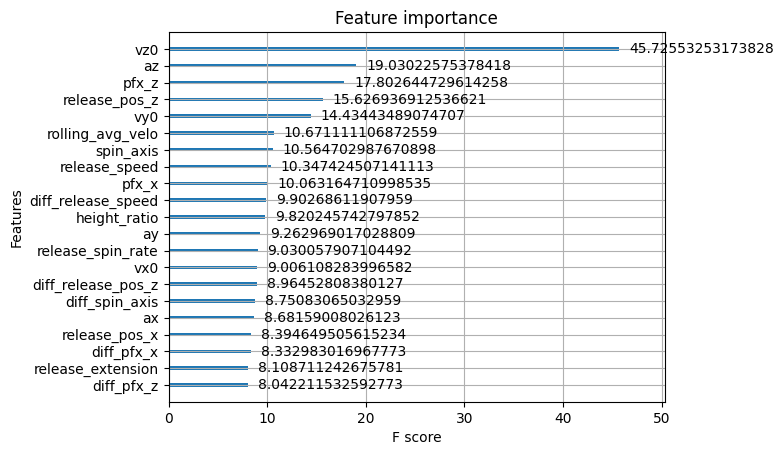

In [21]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

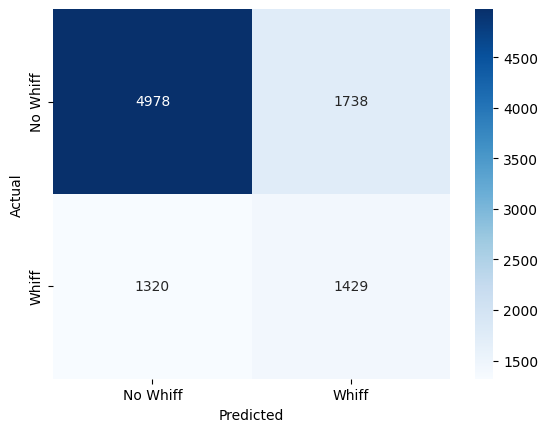

In [22]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Whiff', 'Whiff'], yticklabels=['No Whiff', 'Whiff'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [23]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [24]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [25]:
y_pred = final_model.predict(predictions)

In [26]:
testing_identifiers['xwhiff'] = y_pred

In [27]:
testing_identifiers.head()

pitch_id_raw    xwhiff
32   661032_608070_623474_4_62_9  0.452574
40   661032_680911_628452_4_64_9  0.318223
157  661032_640458_663776_2_49_7  0.568132
158  661032_676391_663776_2_33_5  0.408517
159  661032_642708_663776_2_19_3  0.360107

In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/whiff_2022&3_xwhiff.csv")